# Increase Image Resolution using `SuperResolution`

## Table of Contents

* [Introduction](#2)
* [Export Training Data](#3)
* [Model Training](#4)
    * [Necessary Imports](#5)
    * [Visualize training data](#6)
    * [Train a model](#7)
    * [Visualize results on validation set](#8)
    * [Save the model](#9)
* [Deploy the Model](#10)
    * [Prediction and Upscaling](#11)
    * [Model inference on ArcGIS Pro](#12)
* [Conclusion](#13)
* [References](#14)

## Prerequisites

- Please refer to the prerequisites section in our [guide](https://developers.arcgis.com/python/guide/geospatial-deep-learning) for more information. This sample demonstrates how to export training data and model inference using [ArcGIS Pro](https://www.esri.com/en-us/arcgis/products/arcgis-pro/overview). Alternatively, they can be done using [ArcGIS Image Server](https://www.esri.com/en-us/arcgis/products/arcgis-image-server) as well.
- If you have already exported training samples using ArcGIS Pro, you can jump straight to the training section. The saved model can also be imported into ArcGIS Pro directly.

## Introduction <a class="anchor" id="2"></a>

High resolution imagery is desirable for both visualization and image interpretation. However, high resolution imagery is expensive to procure. This sample notebook demonstrates how the `SuperResolution` model in `arcgis.learn` module can be used to increase image resolution. This model uses deep learning to add texture and detail to low resolution satellite imagery and turn it into higher resolution imagery.

We first start with high resolution aerial imagery to train the model. The data preparation step first downsamples the higher resolution imagery to create lower resolution, blurred imagery. The `SuperResolution` model uses this training data and learns how to upsample the lower resolution imagery and produce realistic high resolution images that closely resemble the higher quality images that we started with. We then use the trained `SuperResolution` model to produce simulated high resolution aerial imagery from relatively lower resolution satellite imagery.

## Export Training Data <a class="anchor" id="3"></a>

We will be using ArcGIS Pro to find the area where high resolution imagery is available on the Esri World Imagery. To simplify our job, we have already created polygon representing the extent of high resolution imagery. We can add the polygon from [here](https://www.arcgis.com/home/item.html?id=f783fe21206a4492b9fe42f585ebc13c#overview).

Training data can be exported by using the [Export Training Data For Deep Learning](https://desktop.arcgis.com/en/arcmap/latest/tools/spatial-analyst-toolbox/export-training-data-for-deep-learning.htm) tool available in [ArcGIS Pro](https://www.esri.com/en-us/arcgis/products/arcgis-pro/overview) as well as [ArcGIS Image Server](https://enterprise.arcgis.com/en/).

- **Input Raster:** ESRI World Imagery
- **Image Format:** JPEG Format
- **Tile Size X & Tile Size Y:** 512
- **Meta Data Format:** Classified Tiles
- In 'Environments' tab set an optimum 'Cell Size' (0.1 in our case). 
- Set the extent same as the polygon layer which we have added.

```python
arcpy.ia.ExportTrainingDataForDeepLearning("ESRI World Imagery", r"C:\sample\Data\Hi_res_superres_data", "JPEG", 512, 512, 0, 0, "Classified Tiles", 0, "ecode", 75, None, 0)
```



After filling all details and running the `Export Training Data For Deep Learning` tool, a code like above will be generated and executed. That will create all the necessary files needed for the next step in the 'Output Folder', and we will now call it our **training data**.

<img src="data:image/PNG; base64, iVBORw0KGgoAAAANSUhEUgAAAu8AAANPCAYAAABq6DELAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAAEnQAABJ0Ad5mH3gAAKLRSURBVHhe7f3blxzVned/89xx4fVb/iPmru9mrueu12p3dc/qi37W9O9nT4/Hv2n7wVlMG8bupt0HzNjYVrlkjubgHtv4oGqKBp/AYLBsXMWhQGAOMgiQUkgqIYGQ0BEkcPfM7Cf2jtiRe+/4xikjMjIy8/1d62VTGRE7dkRG7vzkrqjUZXfe+U0FAOivO+6407j99juM2267XX3jG7epW2/9hrrlllvVzTffom666WZ1ww03qtXVnWpl5Wtqx44V9f+55nl1+PBhtX//fgDAnDDhncEdAPrptddeU6+++qrxyiuvGC+//LJ66aWX1N69e9WLL76onn/+efWb3/xG7dmzRz355JPq8ccfVxsbGya86zb0/wMA5oMJ73pwf/bZZwEAPfPMM8+YUG49/fTTamtrKw3pjz32mAnqv/rVr9QvfvEL9fOf/1w9+OCD6rdRuNeDPOEdAOYL4R0AeiwM70899ZQJ7ja8b25upuH9kUceUQ899JD62c9+pvbt22cGecI7AMwXwjsA9FiV8P7rX/9a/fKXv1QPP/ywCe8PPPCAubVGD/KEdwCYL4R3AOixovCub5mx4X337t1peL///vsJ7wAwpwjvANBjbnDX97vr8O7e867D+6OPPmrCu3vbjBve333vPfX+Bx8AAOZAGt4Z3AGgfy69/766eOmSeu/iRTNOX3j3XXX+wgV15uxZdfrMGXXqnXfUiRMn1LHjx9WR7W118PXX1f4DB8y30RDeAWD+EN4BoMcI7wAAF+EdAHqM8A4AcBHeAaDHCO8AABfhHQB6jPAOANNx5ZVXViJtO0mEdwBoQBrIJdK2VRDeAWA6pLFcIm0r0et+8x//0Yzp4TL9mF5WpT3COwA04A7gRaRtJXpdd3B3w7sO7bffcYf69Kc/TXifcy89HH/V5yd+Iy8HMHnhOJ5H2lby9a9/3awfBng3uOt13G0khPcZdviBHerK/3aV+vYz8nIAk+cO4EWkbSXh4G7Du55xv+POO9VgMFBf+9rXJhbebWjMGqqfCOtjMgjvwPTdeOONlUjbSs6dP58Z48PgrteRtnWNFd5taMy6S+0R1sdkEN6B6ZMGcom0rSQc3O3tMm5wP3nqVPvh/TfDOKR/fVu9lFl+Tq18nSAJYLHocXjfvn3iMk0v0+tIy/KEY3zd4K7VC+/P3BWH9K88qA5nlm+r+79CkASwWCY9uN/5zW8ay8vLanV11YT11u95T4I74RwARiYxvmtvvvWW+u53v2u21fR/68ekdSXVw3sS3AnnADDSxeCug/t3vvMddfSNN9r/g9Wj2+rf6Rn3H7wtLweAGXH/Aw9EWfW/paE4I1qm15G2lehtZje8H3lQfVnPuH/7WXk5AMyIWRzcJxne43urX1YrR+XlZX7yA/e++OfVv3v4nLheeluOS/rA4P4WILONcN+9WSfuf9qX8Nafqvu2hPXD46py3Jm/Hwj6VbjcPQ/e+sGxGvnPX9hPsw+hbWBePPCzn6m//Mu/HI3pCf2YXiZtk0dv1/b4Ht7j7t5Co5dJ24Qqhff43uod6v4j8vIye77t3hd/lfryA9vieultOS7pA4P7W4DMNsJ992aduP9pX8Jbf6ru2xLWD4+rynFn/n4g6Ffhcvc8eOsHx2rkP39hP80+hLaBeTFLg/vOnTsNHeD1fe/6lpr2wnt8L7t8n3uZt9UnbBi0jyWz+H6QTfaRCZjJ9mEgT4Llv/t6FFS9gF20/svR+lIYrbnvvPWj4/pEekzVjjsOzX47P3l4tE3Z8vzwrrfzH5fayjuWvDaAefKzBx9Un/nMZ9KxXf+3fkxat0jb43sY3PV4Ht4DXyXAVwjv8b3s8n3uZZ5V37Zh0D6WzOL7QTbZRyZgJtuHgTwJll/+ShRUvYBdtP6OaH0pjNbcd9760XF9Oz2mascdh2a/nT0PjLYpW54f3vV2/uNSW3nHktcGME9mZXA/e+6cCer6fnf9B6v6qyLtY83DexJEx7hlJg6M2ZnwOByOHndni931DCnsJ6FV/EAh3eJj1xeOoe6+C9dPVDvusvNa4bwXhPfMLH/NY4mPgfCO+faL3bvT8X39nnvEdcq0Pb6Hwd0+HgZ4dxtJhfCeBNExbpmJA2N2JjwOh6PH3dlidz1DCvtJaBU/UEi3+Nj1hWOou+/C9RPVjrvsvFY47wXhPTPLX/NY4mMgvGO+zcLgbr8qUgd1G+Bvu/32yYd3G5Qdo3BYsJ0XOstm9oXlQmh1meBZaf26+y5bX6t53ELIj5Utj+SGdymQh/0qOZaScwzMi7W1NfWtb31LXFaFHou/8pWviN8gpulldcZ3d2wPl7kBPlwWahbebVB2jMJhwXZe6Cyb2ReWC6HVZYJnpfXr7rtsfa3mcQshP1a2PJIb3qVAHvar5FhKzjEwL/o+uLv/SNM7p0+br4ps7x9pSkJfYWCNhDO7QrAPxcGwIOwmMjPZVcJ7Zv0qgTbLbytePzOr7ap83JHkOAzp/FZcPl54Lzn2knMMIPbT+++vRNp2kqqH98LAGglndoVgH4qDYUHYTWRmsquE98z6VQJtlt9WvH5mVttV+bgjyXEY0vmtuHy88F5y7CXnGEBMGsgl0rZVuOFdj9Nt/8FqJgxLcsJ7YdA1Zii8Vzmmysc9Eu8jIfQldznhHUCOSn+wmgnDkpzwXhh0jRkK71WOqfJxj8T7SAh9yV1OeAfm3qTDuw1y9UJreTCOld2KIiwvDJZ560uBtu6+qxxT1ePOikO61M+c5YR3ADkqhXcb5OqF1vJgHCu7FUVYXhgs89aXAm3dfVc5pqrHnRWHdKmfOcsJ78Dcm3h4j5QFS2nGOd6mZMY+UvSHk+JMdhIsxeCZLMuuL7dfd9+l5yFS9bgzygJzuFxYv3p4LzqW5ENLUV8A9Fq18B4pC5bSjHO8TcmMfaToDyfFmewkWIrBM1mWXV9uv+6+S89DpOpxZ5QF5nC5sH718F50LMmHlqK+AOhEF+Fdi8NeEIwtKTQn4TcTZPXjXvC2YTEMkkngDGfGk33l7k9cPy9w19y3fTxcP9pH2pdKxx21E3z48EN/2fJIw/A+Oha/n/Z5DtsGMDsqh3ctDntBMLak0JyE30yQ1Y97wduGxTBIJoEznBlP9pW7P3H9vMBdc9/28XD9aB9pXyodd9RO8OHDD/1lyyMNw/voWPx+2uc5bBtA97oK7zEb+ATi7SfS+kGoTcTB01+36IOCDpZu0DSCwDtaPy+8xyrvO5HZb17497jHLSz3zl/Z8kjj8K6NZtktc9xC2wBmR63wHrOBTyDefiKtH4TaRBw8/XWLPijoYOkGTSMIvKP188J7rPK+E5n95oV/j3vcwnLv/JUtjzQO79polt0yxy20DaB73Yb3HiBYTh7nGJhpY4T3HiBYTh7nGOgFwjvaFs/gy78hAdB/hHeI4hl8+TckALpDeEe78m6xATArCO8Q5N1iA6BrhHeMRZ/HTEC399oz6w7MMsL7ItPnMRPQ7b32zLoDfUB4x3iEP4rVmHEHZh7hfaEJfxSrMeMO9MbChXcAQKHZDO8AsCAI7wAAF+EdAHqM8A4AcBHeAaDHCO8AABfhHQB6jPAOAHAR3gGgxwjvAAAX4R0AeozwDgBwEd4BoMcI7wAAF+EdAHqM8A4AcBHeAaDHCO8AABfhHQB6jPAOAHAR3gGgxwjvAAAX4R0AeqyN8K7XldoGAMyeNLwzuANAT0SB3f53WXg/mRPen3/hBRPeDx8+rM6cO+e3DwCYWSa8M7gDQI/87nfpf4878/78iy8S3gFgDhHeAaDHqoT3twjvALAwCO8A0GPMvAMAXIR3AOixS0//T/XpT3/auOKKK4zrfnSA8A4AC4rwDgC9dVj95IsD9ekv/lQdNDPvW+pOE+CvU/e+SngHgEVEeAeAHgtvm3nym/Hs++2PEd4BYBER3gGgx/zwflD96LruZ963jx5VP//5z9Utt9yivvSlL6m///u/N/+vf77//vvV69E+pe0AYFGdPHVKPfb44+rOb35TfeUrXzHj5rXXXqtuuOEG9c/33qv2/va3ZmyXti3TWnhncAeAeqTB/Re7d3vruOF96x+7vef93Pnz6p/+6Z/UYDAwbzr6DedXjz5q+vzrjQ113w9/qK7/8pfNcn0M75w+LbYDAItk9y9/qa6++mr1V3/1V+r73/++euSRR8y4qelMfNNNN6krr7zSjJ/j5OPG4Z3BHQDqyxvcDx465K1nwvvrP1X/I/mD1Tuf7ObbZl559VXzYULTM0TSOtZwODTjvD6W3zz3nLgOAMy7E2+/bWbW9diux/iimXU9eaNzsQ7xDz74YK1Z+EbhncEdAOqpM7hr6bfN/I+fqIMdfVWknoDRbyh6YkZP0EjrhPRx/OSnPzXb/fgnPxHXAYB5pXPuf//sZ834fvzNNzPLz0ZjtjTe79mzx2RjvV3VAD92eGdwB4B6qgzueqZ99Nge9Y8D99tmJh/e9a9wP/OZz6gnnnxSXF7m5X37zBhfNqGDDm2uqKWlJbVjU1hWRdPtgTmnc7C++0T/FlVa/saxY2Zc1bfLSMv1LPznP/959eMf/1hcHhorvDO4zyEGd2Ciqg7ujz766Ojxw/erL+rwHnzPu/ap2x9rPbzrCRb9G1L9q1xp+UMPPWRugbz11ltNf6V1NH37pH4j0h9GpOWlhmtqEI0nekzJGKypobRNr2yqHVFfy8bDjRXh+AKDtaG4bS2zPr4n+xetbMrbVFbtuaqloL+dnMOJnq+OJGPA1K65mvREtr4LJW8yW98WqcdOPXkjLdf0XSk6G7+2f7+43FU7vDO4t4XBvVUM7vUwuHeu6uD+7e98x3s8/KrISc6869+I6l/fSn+b9Mwzz5gxW38AeSFqO1zu0n287rrr1F133SUuLzVjz23GWP0fql2D6PU3E+9fHTPj1UDtGobL4rFZj1tjXyuTuNZy+9uRSZ6vrszQGKAnovXYrSempeValfCu6TFTj516DJWWW7XDO4N7Sxjc28XgXg+De6fqDO7/8IUvqEvO412Fd92uvg9ff9FAuOz1Q4fU17/+ddM/fZ9+uFxij1nf4y8tL8T4LixfYCXjZTzJNeZ4ulDje6zR+erKDI0B+laYb3/72+Iyq2p41xPaehwuu7OlVnhncG8Rg3u7GNzrYXDvVJPBvTC8R9oK73o81rfthL8Z0Pv73ve+Z/q2vr7uLSujJ3Ok94tSFZ7b4dogukaF3zwm29rfIMXrraiN6L/D32TmtR+uZ7f31ktfQ8m4rNcbrKgd9r9dlcbsnPFd3M9onWxfhdet9Hp3HvPbmMD2xmhiYLRe/Fjpb4+l/XuStoPfGhafG+d8uuqeW0lpf0ey+6h6rRVcU2OeLy3sT95zU7beOK87T43xvWqfJ0GPl3rc1OOntNyqGt41/V5R9n5RK7wzuI+E6zG4N9zeYHCXZPfB4G4syOAuhfef/OQn6p/uvrvVmXf9ZQKrq6uZx7e2ttJ+6T+41X9om0f/0ZW7rX4DyrvHv1DF5zZ+Xt3XQ3aMjK+zQXQMfnv2/cHfR3LdB6+deD/B6yV5DYXtGjWuzZHi8T13P+KYJvc1+5he1293IttL59W+D0eaj+/CtVD13OQ9V1W3l1Tob2vXmmSc81XwHPnPT7X16r3uBHnPi6dqnydH/zZVj496jJaWW3XCu87E+g4WaZlVK7wzuGstveAq9t/H4J5L2n8gcy1UPTd5z1XV7SUV+tvatSYZ53xVHiirrcfg7qsT3nfv3q3+9m//ttXw/v0f/CBzG6O9FVL3qwr921d3e/2eof+hPvexSio9t1ry/CavQ3tNude1vZ6yz3d2PM1e85a/H8OOb8EYYFTuv6tofM/Zj0S6vqXXe9Ju5rxMYPvc85rXRkjaf0B67jOkY6vzXEnbSyr0t7VrTTLG+Yp/zvYnfLzeetK5yrnOQxWel6p9mSR9e4v+Wyb7s/4Kdf13ofZr1C19u7kdJ8Nl2u133GHGdt2Gfs/QEz62TUmt8M7gzuBuTGB7BvcsBncGd+vv/u7v1Dduu83cKqMHeP03RcvLy62Gd2kiRY/P7vhdRn8FZrh9+FglyXNrrulAeL3Ez6W+TuPXRf7y0WPyMuF1lVnXuWaS15x4/dUZM1LF43v1toTzIL3ec8eAvPFl3O2LzqvQV0nuvkaKnucRYX+1nqs6/Y2OOcNeP0XnpOa1Jql9vgqOy2ur6nrFz0el56r0eanel0kKZ8ntP1o6DvsvrdoJH9umpFZ4Z3Bv8QXH4M7gro85g8G9bFlqgQZ3+1WRB6JQbsP7pz71qVbDu77lMfwWMT3j/5WvftX0Qf+9kx6ri6zfc4+3vf5WsTvvvNN7rJJar7lkXIzW914TicxrxeVeB8k+8167mWuy6BpqfXwvvlbjvtlzEPOOQ2ojt92kH2OP78H2hee1znhZ5Rxk1yk9NyXPVen2krL+tnmtSeqer6Q/4XGO1Fwvbb/C605arpU8L3X6MknPPvusmXixP+s/ONW/RdXZ1qVn1u14Hi7TdDu2Df2VkW6bklrhncE93mcrL7ha/bcY3HNVPgfZdUrPTclzVbq9pKy/bV5rkrrnK+lPeJwjNddL22dwt/IGd/0NX5r+V/jsbTNPPf20GW/bDO8///nP1Ze+9KXM4y+9/LK6/vrrzTHoWyTD5UVuu+22zJhfSdlz63HGd+G3NZWvs2SfrbzmavXfqj++x30KtxHGTKmN3HYnM77L56K98d38ptI5D5XPTU7/Km8vKetvm9eapO75KulPqup6kfgYJj++V+nLJOlbxfWYLX0Do+uxxx9Px3dpuUuPxXrMlZZZtcI7g3vxxVLrBVer/xaDe66Cc2AxuDvqnq+S/qSqrheJj4HB3cob3KV73h944AH1hS98odXwvn30qNm39O9zbGxumnswV1ZWzOx/uFxi/1C37GuDRWXPrSN9LWzKz3fmtZJZZq/B4tdu5notukZr9H+k7vie11/hcamN3HZbHt+LzmvV12juvhKZdmqcG/G5qrG9pKy/Je3UutYkY54v7zkXVV2vzusuR+lrqHpfJu2aa64p/eKVOuFd/23pfT/8objMqhXeGdxbfMHV6P8Ig3uu3H0lcgarSudGfK5qbC8p629JO7WuNcmY54vBfTxNBncpvO/YsaP1b5vR9O09u3btEpfde999pm/69skz0X6ldVwPPvig+eNb3V9peaHS5zaRrGef4/jvRPxrKr6WpLay10e8vXTdCddS0Wuoav89Ncf3zGs0YdYPHpfayO1/2+N7znFF7HPTbLwU2q9zbqTnqs72ksL+xlq71iR1z1ckvz++quvVed2JKryGqvZl0vTt5HpiW4/T0nKtanjX/7qqXqfsX1mtFd41Bve8i4XBffztc44rwuDO4J6rwmuoal8mrcngHoZ3/cdMV1xxhXpx797Ww7v9Qyn9/+Ey/e9x3HHnnWb5T3/608xyl57o0RMz+pik5aUqPLfpdeo9v8m141y79joLr/f42ghfA9ntR+sG11GV11DZNezJGQdz95M/rmXGIKmNsnZbG98jZt2cx8K+SvL2ZY83PGd1zo3U31rbC3LPjauta01Q+3wVLNOPu+em4nr1XneCZD+FY0Ctvrj7zH9+S59bgf6tqr7zpGhcrBLedRY2/3jpd78rLnfVDu8M7gzuYt9b2T7nsbCvkrx95b2465wbqb+1thfknhsXg7t9TJTsZ94Hdze862+b+Yd/+Af1P7/1rdb/hVVL/0Gt/oab8N/z0PTX/er78O+//35xuab7qn8Dq2+JlJZXYp83Ufw8xdeJ8Pwn44Z9nuLnVr9ektdTKngNpZLn3l3Xe+0nyl5z7jFIr6cM4ZrTCvcjHVP8mHedSm3ktiuMd02318Ln1Byn0FeJ2ZezbSrvvGgVz40mPlc1tg/lnptQS9daaKzzpYXHrEmvk/L16r/uAkVjgHeOqvbFPXbhtZbsr/S5zaH/JunKK69MvzEmZL9SXedeabmm/wZUf3uj/rsoabmrdnjXGNxbesGJA0YR4YLTCvcjHVP8mHeRSm3ktisMzk2318LnlME90tK1FhrrfGnhMWvS66R8PQZ3X97g7ob3u9fXzS04b7/99sTCux639eyP/gPaKm8iLj1zpH8zqz+olN3j35XRdSYvxxQlr6niSTjMokV83em7TvTYqSenw2V6bNSTLr969NHMMk3fVqnfH6SJcclY4Z3BHZ1hcJ9bDO7+srzB3YZ3/bgO9/p2mfMXLkwsvGu6f/q76PUskP7aMmmdkL5HUx+bntgpu1+zS4zv/cVzM78W8bnV2Vh/I6OegPn5ww+bcVtaz6XvWNET2frbw8r+Lso1VnjXGNzRBZ6b+cXgXm1wfysK5t/4xjfUVVddpX75q1+ZkD/p8K7p/dx7771mNkh/6ND/uJS0nv5Ngv5trF5P/yN+eb9xnRbGkOnTz0HmN1bJb//G/U0W+m2RX3f6Fkj995z6DhP9VcF6LA3X0aFdf4OjXU/6IpgiY4d3jcEdbWFwXzwM7tUHd/3tMjqY22+b6SK8W3qiRfdTz/rr35jq/9b/Zof+OjN9C49+XE/kVJ3E6Rrjew+It7jVuM0PM2fRX3d6/LYTNXpW/cvRGGn/vSP9xS963NST33qMrzKJE2oU3i0GdzTG4L5wGNyrDe4PPfSQCe3uV0V2Gd4tfZujvi9fv9nov2vS/69/1schrQ8Ai06P1zr77v7lL9O/B9WTN4eicVlav6pWwrvF4A4A9ZQN7tL3vE8jvAMA+qHV8A4AaBfhHQDgIrwDQI8R3gEALsI7APQY4R0A4CK8A0CPEd4BAC7COwD0GOEdAOAivANAjxHeAQAuwjsA9BjhHQDgIrwDQI8R3gEALsI7APQY4R0A4CK8A0CPEd4BAC7COwD0GOEdAOAivANAjxHeAQAuwjsA9BjhHQDgIrwDQI8R3gEALsI7APQY4R0A4CK8A0CPEd4BAC7COwD0GOEdAOAivANAjxHeAQAuwjsA9BjhHQDgIrwDQI8R3gEALsI7APQY4R0A4CK8A0CPEd4BAC7COwD0GOEdAOAivANAjxHeAWC27T9xQT34yil19wtvGw/sO6X2Hj8vrlsF4R0AeiBvcCe8A8BseurwGXXVA4fUn/3TfvXRuw+oq392WH32wSPqY/ccMI9d8eODavf+d8RtixDeAWCKSgf3Hw3VL149SXjHmDbVjqUltbS0ojbE5QDatvfYOXXT42+YMf3OPW+rraPvqUNn/kUdPf+vxuFz/6KefuOi+t7zp9R/vmdo1tXbSG1JCO8QbaxEg/1gTQ2FZQCaqzq4f/e5k+rP1/erGzaPqOePvNNZeB+uDaLAp0OfgzGhdWasDc/z0kDtGsrr10d4B7r0xpn3zIz61zbfVJtH3k3HdGvvife9sV6vo9f9xH1D9epb1W6laRTexUGHwX3ixDfVVgd7wjswSXUG9+0oxP/60Hm149dvqI/f85p66eg73YV3bwwYql0DPdbMZgjMHk8/xO+j7Y7fiAzX1EC/N65sysuBCTh+9j315V8dVdfufsNMwNgx/fk331fX/eqY+W2q9dWN42rfyffTdb7++JtmW92G1LarhfDuDjpz8gm/5y/6vr4JzSrOJ7pUd3B/+e1L6sjZ36nDZz5QqxtH1RcfOaSOvH1mCuE9koyNOzadx2YE4X3BEN4xBWvPn1Cff/ioevb4pXRsH575nVr+6etmTP+bh7fNrTJ//fNt87Me8+16epu/iR7XbUhtu1oO78kAOaODe4rwvlA4n+hS7cH9l2+k4f3p7Qvqrx94XX1vzxvTCe/JBI0Z3+04mfInbdLtN1f85SXbmfeVaOy17yVGMhZ7jwmTRP5y+95kf2PgcI5L3sZZVuUYGowfxeHd+W1H2ofkZ295sL3tn+lX+BsToU23/5nnJ3w/L+uTv84u4fyWPY/F10j5/v32Y4O1YYW2gfGdOH9R/cUPD6qfvHo2Hdu1H79yxozl/+Xeodr/zu/Sx+2Y786+63U//s/ReicuiPuwWg/v7ycvpvSF4r24wvULBpGK27U9MBS+6Eu2LTyeFgeM9A1FWKbp50X32TsWZ3375ihtZ9cL10n3mT4vBecsaLusP3addt+wR+3m79s+Xw67LHy+gv4C4xhrcF97Tb104qIJ74dOv6/u++3b6s//6RW198jbU5p5t+NsNP4Gr7XMmKFfO8F4ULad+TnabjTu2t/ouo8lr91wO7e/ZqwKxqngeCptkzkG5wNM8tjG2vjjQ3y8/rg14oxRtg92bLL9Tsbk0bkZ9Tvuo/O+FLYZnA+7ndRW5tzr7fP65KyTbpe+dwjbuec3WW90fsPf6FfZv/OY27bw2DB67sL3FGAcu54/YSZd3LFdW3vxHXXFj19X33jqhPf4LVtvmXFf/72T+/hf//yIWnv+bXEf1sRn3jdW3LBV8CIMBpGq27U/MESk7bQ6g0rJINJkwDDnODhfrtw3P7t/cxzu+R2tM3rewv7Gz2t4TuJ9uW0l58BZr7Q/Ret4j+W07Z6L4Niq7Dt7Pv1zoTV5cwassQb3KLw/ceRCGt4PvXNJffaBobrrqe2Ow3v2teMJXnvxmBGOMwLpNRuMb/Hr2G/L658ZY8MAHI8X9nWcOZ6q24THIG43PjtGedJ+2vcUtw/hY8nzkrtN3s/hMYTtWGXtFa3j7qPoMbudfI3Fz4N9XqrsPyK9jyfv4aP3A6A9+nZIfd+6O4YX0ZMzf/HD1zOPf/2Jt8w3kEn7sNoN7/bFknnxj/jbSC9mWfl2RY/VGRgi0ou+1qASHE/LA4bdp8c55+ZcSf0MBnevP7qPBW3E+3QHy0hyntLz5j0+Ogfl/UnWCa6b+Dn39+ltF+wnFh+b7VOVfYc/y+0CzY01uN93ML1txob3r/36qLryh69MPrwH40w4hmXXGb1eM68rR9F2VV6zhjtmJWOsxPY508Y42yTisSmSc3x1xG3ljTfhe5j8mNdG5v0rXF9qU9puxO9jlT5VWUd4zPYhR+Pwbt/HE229JwPa4McHzUSMNJaH9ESNnnUPJ2y0tb3vmLakfVgthPdA7gvfVTQIjLtdhccqDQzOeu6xjD2oaO0OGEVvipo+b5l9mDeqUb/CNsJtzLl3jj/3zTNzrFp8vG6ALutPuD8td5/2sQpvvuOcC830R7cV7h9oYJzB/dattzLh/Xu/eVN96p6XO555dyVjmru8wuuqynbjjwXSWDSSaWOcbQLpOCG871UVt9EsvMfHkoy55r/d9sL1c96nxLAb8/tYpU9V1hEeK+jDSMW2i9ry3s/ddoDx6W8Q+8kr/i2RIf0lBfqLCPTY/oXgSwusjcMXzHJpH1b797y70hfI6MVRPgiMu12FxyoNDBFpvUrb5hyPlR5XwToVVHlDKQuscV+S82n+2++POd/Osea+eYrH0WV4Lz6PVfZddD5Nv0qfd6CacQb3Q1FwD8P77gPvqP/vd/dOL7wLrz2zftnrqsJ2Y40FydiaTsAIMm2Ms43EHUul5SXiMSZv+6rvdcmHoui8mfa8Pofr571PCR+sjCrbj7OO9FheH1wV206e38Kx21yPwnsEMIa/vP+Quuu5U+K4bumvB9Zju/5iAv1FBdI6d/3mlGlL2oc10fAeD8r+4OhvI70Ix92uymNVBoaI+KIfd1ARNBwwyt5Q9LkqDe8Ru55pLxjgzPl2HhP3mffmF7yZVelPuD9N3GfNN+wq+y47n+HxAOMaZ3DX3/Mehvf/+dRxNbivg9tm8l4X4Wsv+bn0dVVhu7HGgojZzhvjovF4xdkmZwws2ibvGHa4Y4ppd/zxIe5D3vZV3tdipq/mXIZjXri+vL3bhru9fWw0zlbpU5V15MfS4wjff9PnoWLb9tpyn7/ouXLfL7LHBozvq79+Q+3YGH31Y+jVUx+Yf5RPj++/OHheXEfTbXz2Z4fFfViTnXk3g5rzIkwHaruN9CIcd7tqj5UPDBHpRR8Zb1CJtDxgmO2Dvrn081IWWNPHBlHfBtnn0Dy3znHm7VN889PnwNm2Sn/C/WniPk2fR4+J+3fefKvsO/Nzy2/OgDXO4C6F9y/vPqw+86NXp3jbzGgcM/R6wesob/uy7cYdC7R4PBiRQ2zE2a5oG3G/6fuR1WxsCPdvxf2Q3lNy3mfSfgWPZ9bP2d4yz4deboXHV6VPVdbJeyy4RhKj52W8dsz2mWMjuKM9P37ppPnGMOlWGO3Xh+LbYTT939I62mfuP2zakvZhTTa8R7yBKRoEd3nbyC+48bYb7wVt+YO88KKvtG3O8bQ8YEh9cNvU5y48nrgP4XlO+hu+OUXM+a8Q3tNlTj/CfVfpT7g/Tdyn3i54zLtWgv1XOxf2eYvotlt+cwascQZ3Kbxf+aMD6p7fHJ1oeAcAVHf6wiX1X+8bmn+nIxzbNf2vZut/Pdv9F7RD33/hlPpP9xxQR94p/ldWG4V3AEB14wzuYXi/69k31UfX9qnXjp0ivANAjzz4yjtq8JPX1aPCzPpzxy+p1cffNPR/h8v1NnrbB185JbbtIrwDQIfqDu5ueN89PKOu+OF+9dO9xyf+L6wCAOq5+P4H6rat4+qzDx7x/sE9rei2GT1Zc92v3jDb6jaktl2EdwDoUN3B3Yb34an31bW/OKxueWxbnT1/gfAOAD106sIl9VcPHY4cUfe9fCYd3x8/8q75x/g0/d/2cb2OXnf5J6+X3i5jEd4BoGN1Bncd3u/97Tvqcz97XX36hwfUwbfOqvMXCO8A0FcnozH+nhffVp+OxvKvbhxTD+4/p55/8/10rH/p7Q/UQwfOq5ueeDMK7YfMunobqS0J4R0ApqDq4H7j48fNP+509/NvqjfPXFAX3n2X8A4AM2D/iQvmX9a23yKmv7Dg/73vYPob1n945Ih64Vj98ZnwDgBTVDq4P3xYPXf0jHrv4kX17nvvEd4BYMbo37bu2T6rdu9/x3jq8Bn15tmL4rpVEN4BoAfyBvdL77+vLl66RHifQ5f97WPoCen5Afpq7PAuXfyoTzq3AGAR3ueX9J6A6ZCeH6CvCO9TJp1bALAI7wAAF7fNAECPEd4BAC7COwD0GOEdAOAivANAjxHeAQAuwjsA9BjhHQDgIrwDQI8R3gEALsI7APQY4R0A4CK8A0CPEd4BAC7COwD0GOEdAOAivANAjxHeAQAuwjsA9BjhHQDgIrwDQI8R3gEALsI7APQY4R0A4CK8A0CPEd4BAC7COwD0GOEdAOAivANAjxHeAQAuwjsA9FheeL/pppvUjTfeSHgHgAVDeAeAHpPC+80335yG9xtuuIHwDgALhPAOAD1GeAcAuAjvANBjYXi/5ZZbMuF9586dhHcAWBCEdwDoMcI7AMDVWXjfWFlSSyub4rJpMv1aCvSwnwAWkxveb7311tzwvrKyQngHgAUw3+F9c0UtDdbUUFqWyPZrU+2IAvxgbeg8NqYK+weAIja86+BeFt6/+tWvEt4BYM4R3oV+DdcG7YRuwjuAhqQ/WOV73gFgcU0pvA/VrsGS2rEZ/398u8pA7Rr66+vZbxOk7e0sXhDWM+T+Nu8P19RgaUVtJNun22k5Hxxyw7v7mGnXaSsM5Dqkp8vjPhXt3zsm7xjseYln/5eSY0n3A2DhEN6nhXEYQD9NNby7wdUsd0KxDb+j21eSbdI2isO7+XmcmXfTht/ucG0lE7DTbcL1N9ec/87uPzOrb4K/7XPc9mDg7g/AIutzeM9MUmglY+7s6Da8i+cyfI8DgMhUw7t3X3kQvDOhOl3HDmYthnd3sKzyxuO2G+7Tldm/0OfkXOzYHP13K/fbA5gLkw7vbxw7Jj6uFS3T4vHTHdOYrR5X9lzWZN6LojbC9822TLp9AJVN+bYZZx0vmMfrZ0OsG35bDO9pv+I3Hq9fCf9Wl0jabnws+rHMduH+9c9uGw43vEv7B7CYbHg/ePCgMRwO1YEonL/66qvqlVdeUfv27VN79+5Vzz//vHrmmWdqhfdHHnlEXXnllWrPnj21lllS4LRjJeNYPYR3AFUR3r1+RUzAdmeN4kCfCeFhu3ZgK9p/pu0Q4R2Ab1Lh/eSpU+rqq69Wg8EgE9J1cNePa5///OfNbL+7rSUGTjPO2fHbTm5E417yuDcmpuPmiDj+ZdYLxtEmy3OXOX0Pf7bHEraVCCd7Bisr8T4Kgm9ReE/bc7Z3H8tMLkWyv9l2l7t9Lj+u0vYBdKrX4T0z0HnhVwjv3vLk57rhPelbOjCZfrkDXTKQie0G24b7D44xSzgvABbaJGfeX4naCAO8G9yvueYatX30qLitJgVOG/TiccwGw0gwZtr13BAoPWY/DPjBdc0f59P9acmEix23bXCVti9alvbdjv/Osdj17fbOsWWPQdhOUBTeR23Y5cKkknAsRtn5qXhcue0D6Fy/w7sw4GQGxLTNcECKmEHLD96hbHiPmO2SvgT9ygxq0bqjPgbHJew/Pi73sWibFTtACucFwEKz4f2vdx9Tf/WLN9RfPXJUfS7y2YcOq//+0CF19c8Oqqt+ul/95Y/2qSvv3Vv7nvcwwFcN7lomcGZCXzJOu+sYQvj01rdjZN56VrI8GMO9DxBJePU+EFhFyzJ9CX+WHsvpb4Xga9/zPG47Thvx8QXnVNxHhfNT6bgiFY4BQDd6ftvMZjKAJDKDRjIwGdEgY9qQBiBp25jfLyvZLhk47UBn6Mf0gG8HVTugJfw3AXn/4SAdfiAhvAOwJh3eNTfAVw3umhg4vfHUjoHuuBwpCIJxm8l7QVlgDMbfUDyWuu8T4RhdtCzsu3QswWN5/S07joh33MJyzX0vynzgkPZR6fxUOC63rYJjANCNzsJ7XXogywxOALBgugjvmg3wVYO7Vh44pWAYKQiCY4X3KoHSC7I5/fGWhX2vEHKTdioF68BEw3vh+alwXFqltgB0gfAOAD3WVXjXdICvGty1scN73u0lmfXz1rPKlgsq30YT9qVCyLUBN+xP0m6j8O6EZ3FdMVxXOT8VjksjvAO9QXgHgB7rMrzXNX54H80iu+O8fy+2/5gbGt0/WJWWm9BqA2sUnKX2zGNFyzJ9rxZy43PiHkMSoDN99BWfy2A/0oeEnA8Opeen4nHltQ+ge70N7wCA+Q3vhp2RTuW0Fa6XF1Ad6YeCzD6cYF20LNP3iiE3YgN8LDqmzfJZa3+bEX0cdpn0Qcf/UDM6D+K6jtHy6seV1z6AbnUS3u+9914A6A1pnOqrPod3VMQtJwBa1Fl4199LfPLkSQCYGj0OEd7RuWSG371FBwDG1Vl412+cFEVR0yw9DhHeMUkbK8GtP9wrDqBlhHeKohamCO+YNPHedW6XAdAiwjtFUQtThHcAwKwjvFMUtTBFeAcAzDrCO0VRC1PjhPdz77ygju67Xu1/4o9TR164Wr1zfLe4ftsI7wAAF+GdoqiFqTrhfXvvNcbBZz6uDj83UGdPPKnOnXrOOP7ajerAk3+SrpPn1PGHxbbrILwDAFxTDe9bq0tqaXUr+WlU5vHldbWd/Gwrb/2qpbdfXg9b9Wt7fblwH037QFHU9KpOeNcz7Mde3alOHllXly6eUx9Ej7nOnNhQJw59P9frz3zC/L/Udh2EdwCAa7oz71uramlpVflReFutL0cBeWlZ+Tk7frxJbia8U9RiV93wrmfZw9BelZ55J7wDANo23fC+va6Ww5CePLYcBnVp3ZpFeKeoxS7COwBg1k35nvd4Nt0N1DY8Z0KynqV3bqUx67nfo+sn/WSWfkutmuXx7L4U3s1+bBtR+1s1w3vc5lby24KYWWw+bNjHgt8ueMsiebcIOculfvnnwP1gkz3+1aDfusz2wr4patZq586d6vLLL1eXXXaZ58Mf/rC68cYbk7XaD+/vX3pPnTzyz+r1Zz5u1s9z+IXPiPuogvAOAHBN/Q9Ww5nuNGAHYd0NzXFodQNxcqtN2k7yoWB51ZupT9tOyrTphldzG0825Lrl9kOX+dkJzmmgTtsN+6bXcfuVXV6lX5ng7d2CJBx/cD7tOgWHSlEzVddff31hcNc1bnh/+9B3vT9EtY68+LlMUJcc3fdFcR9VEN4BAK6ph3c/dOqZYhuEw/+2QdN93Ckzmx2E12AlP7zL7YThPCwxvHvru31NKhOcg/KWV+mXtI4bxqXjD7bxzhdFzUddddVVaXgPg7uuccL7hdMvqYNP/1kmkNdx6o0HxH1UQXgHALimH97dsOuFWCeMukHTC/tuueFUnlX2wntOeA1/ExCWFN4LQ7IuIbynM/SWXV6lX+YcONs64lXKj7/sOClqVksHeCm46xonvJ849INMGK/r/Ol94j6qILwD06PHC6Are3/7W/E6DPUgvI9CZRgo7c/m/224bSu857RTFmqbh/f4w4oX5t3lVfqVew5sycc/2k/Ocoqa86ob3s++/ZQ68uJnM2G8jib3u2uEd2B69HhxIHo96bEDmCR9nc1UeI/D+apaDQNlElL1H1umAdnMTAfhWJc3Y1115j3bThjOw2oc3oWZde/DSZV+5Z2DtPLCedK3rWwfKGoRSo9DdcL7icPfz4Txuo7vv1lsvyrCOzA9ZfmFotoqfZ3NVHiPw2gUTjOBNJmlDh43QdYLn3FYHYXoCuE9KtNOOAOu9zfx8O4st8ee9iPue1m/xHOw6rchHYbp73Lxbxcoal6rbng/+tK1mTBeV5P73TXCOzA9hHeqq5q98C4F1qSyITUuM1ttgn3MD9DVwnu6X9tOtMHkb5sJ+q4fD5ZX7Vd8bkZG/cgP7/GHhfBDEkUtRtUL73+khns+mgnjdTW5310jvAPTQ3inuqoZDO9UWWU/JIxZmQ8KFLU4VS+8y2G8joN7/lxsuw7COzA95BeqqyK8z1uZ22bauEc9npFv5UMARc1g1QrvT8qBvI6mf6yqEd6B6SG/UF0V4X3GK7wdpo3gnrZZcEsQRc171QnvfUF4B6aH/EJ1VYR3iqIooQjvAOogv1BdFeGdoihKKMJ7u4Zrg+C3hNpA7RrK6wOzJj+/JF8s0cLfkGV+297hb8jjffu/3R99qUb8uLRO3Sr7MhDvizwSdW/x1f2c5duCCe8URVFCEd7bZcL7yqa4rNTmiloarKmhtGxck2gTCy03v+hvbltebvjtbckHgPCb5Nan+KUSE/pGukrh3V2efI12nc8xhPeW6Yuff6EMwLTpcYjw3h7CO+ZdXni3QdHMStdJmG718aubTZ/a+IIMv2qH96jqnlvCe8v0xQ8AfSGNU301q+E9vqVmRW2kjw3VrkH0Zhytv7ES/1o85bTh34rj3oITb79jM2knWF7UJjAuPV5kw7vz77nkhV37jysaeQE9/ocoi/KpDaTebSXCrTrecmF//vLRPt3AG65jg7MUisv2Z4K3XR71d0uvX3Cgpr1ged39lq8fcfZh+ujtM/t8SP2qW9/61rfU7/3e76nLLrss9eEPf1jdeOONyRpx9S68AwDGM7sz73HIHqwNzc9mXXdWXJglF9dJPwDY0B4E9pI2gSbE8O79eynCP4oYzqhvreeE91G4DEOnLRuCR8uzt9qYNtxAH3y9dLwP5wNG1L/15IdM4BU+jITrlO3P9Dmz3O9zWJmQHLSpq8p+M/302gjOnd6+pJ+6zYJuV66XXnpJ/Zt/82/S8B4Gd12EdwCYEzP3B6tueB6uqYEJ35tqR/iHrJmgLayTzraP/tt+GDDS9pOfCe9omRTexZDoJry6t56Y9ePXjxekozJBOEyP3ocD4V91T0JqvFnx7H54LFLf/XWq7C9cHreROQ6n4qCdjCEJf/Wy/VbpZ1Tu8XnnMd5+dT16LA30OW2MWWfPnlUf+chHxOCui/AOAHNi1u95T29nCdcLg7aZZfffvC03vMf/nTDh3Qn8hHe0LBPeg8BnKvNYMsMbXbsFeTVbOTO/YaD3QqXdRmCaCWanw8q0Xxbey/YnbK8r8wEnqOxyYZZc2Kc2WiXsp3TcbiAPP3To9YNz687MT7gI7wAwJ2Y9vNvZeW/GXBPDu3uPfIjwju6F4V2aIbYyIdsEWb0sPzxnKvggUC28F7Rfsny88F5/f/XDe1TuuSjbb1T1w7uzX72vJKjrduKHloVzP7kivAPAnJjp8G5vawlDthYGbWkdD+Ed3fPDezxTKwU6EwLFWdr8beTS4dKfTc6EWjeYBmE/UyXLa4f3MfcnHodT+eG94nFGVamfbpu69M/R86b/oDbdVp/f1XVnVr6bIrwDwJyY6z9YDWba41ts3MeiNlbsNhXDe+HsPVCPF96LAqRZloS9KPyNQp97a0ZQeptggQmxTrg0odcJ89EjJty7gTtexw3c0T6j8GnXyCyP9tvkD1Yr7c/9IGM+bESPiSchrmx4j8+b+1iV/Zb2M/NBKj6f3jfX6HNgvsPfPw+TLsI7AMyJmfuD1YgO2JlvgjF/kOrePhOHcbON8wEg/MrHcP3C8J7TJjAuN7xnQqlXTthMgry9hv2w6JYNji4pOG/Fbdt1hBAcB9WRcJ/+8lFQjdt31q0Q3nUV7y85F3Z51F9xZt2p+EOLs02yXVhF+5X6GbYbLtdl2vSe1+wHhy6K8A4Ac6LP4R2Yd5k/WO24pEBKzWdNLLxfPHNcnX9hXb3zo79QZx/+vHrveLWdAADGQ3gHpofwTnVVkwnv719S7x7aUmd//WX17sZ16sLGF9XZJ29T71+6KK8PAGiM8A5MD+Gd6qomEt4vnXtbXXjpR1Fo/5L6YO9d6tKzt6uzu69VF98emmAfrp8nvJ9x1r4ZINP/iHcPZgm9feYr0wKl3+AAYGEQ3oHpmXZ4pxanWg/vl6JwfuHg4+rdF/9JnX/tEbX93APqzRcfVL87+LA6s3WHuvTuWXE7X/zHSmFYj8NwzW8HmNTXgVVot0r4LkJ4B1AH4R2YHsI71VW1H94vnFbnnv2uuvDYqtr86XfU//3/fExd89m/VP/y+iPq5L2fUBdPHVKXSm6fMSE9JxibZXXCKuEdwIIgvAPTo8P7gej1pIMVMEn6Oms1vJ8/+Jg699jX1MVn7/TD+6Hd6vwvrlFnn/mOunT+pLhtLJ51z729xPu6L71u8A91mOXx7LwJ+s4tKzbk2lDsfXWZF8THazdUFr4zX50WtCNt7+076vOGEN79drNfjbZjM/nNBt9xDMwVwjswPTq8A11pLbxfeu+8Ovf0N9WFX/6d+uDlu73w/q+HH1WXnr5Rnfrhp9TFt17Lv/e99B/OcMN9ccg2Pwsz5DYAj4Jx8n2/aQger91QUXiPA7Z7nGEfstubfrv7NOfK38a0m1nH7ifex2Cw4h8bgLlAeAcAuErD+4XXn1DnHltV7z32ZfW7fet+eD/yqHr/2VvU+d1/o849v6Yunn1TbKOz8B7MVsfb2bbaC++jGXDNbi+0rwX78MO7vI1/LNI6drZ99N95HygAzDbCOwDAVRzeL15Q557+R3Vh83p1ac9NOeH9VnXpqa+b732/+OZL8ldHdhTeswHWbWu8dkPyfiK5x+jv19s+3H/CzLTb8G7aDT8wxNzwHv83gHlDeAcAuArD+7tH9qjzj+9U7z2xw4R0Hd7f2vuQCfC/+cVaGt41fVvNhb3/rC6eOZZpJw6p4eyxw1u+QOE9Z5tseJfatQjvwDwjvAMAXLnh/ZKedX/qTvXu4181s+42vA+f+pH67m0r6qe7vuGF94tP7VRnf/VF9d7R58RvntGhNXNbi7hMCNlhgBVCtti+t9147YZyw3veB5TgA4K3fc423rHktZsivAPzjPAOAHDlhvd333hBnd/4srr45NfSgJ5324x1fvffqgu/vU9dOnvcayumw3M2YJug6s0sx2HUD/PBOmHojsTtuCE23m4UtMdrN5Qb3pNl0rG464fbm23cDwymD24/c9pdsdsQ3oF5Ns/hXfq2BaBPpOu2CWkfgNX422bObt2uLjy+Q13ac6MX3l994l51xw1fUvd8+0b1r4d/5YX3i1tfU2c3vmput3HbGkkCtAnNiSDMx2yw1qLQGt7e4raTbB+H4k2//Uzb9dsNheE75H+lY3bd7PbBOYn2690242wnt0t4B+bZvId3vkMbfaSvS319StdtE1zzyNPK97yffvBz6sKjX1AXn9iRuvTs7eqDl9cj9xjv/3aXt1w7+7O/VBdee8RrqwtloRoAZtG8h3f9pkVRfSt9XU4qvHPNU1Lp66L5zPtjN6jzmyvq/GOrtZz55RfVu4e3vLa6QHgHMI8I7xTVfRHeqa6rlfA+awjvAOYR4Z2iui/CO9V1LWR4B4B5RHinqO6L8E51Xb0L7/piBYC+kMapviK8U1T3RXinuq5ehnf+uhrAtE3qGyQmifBOUd2Xvi7HGSveuyj8K/MOrnkqr/R10bvwzsVKUdS0a9w35GmatfD+3e99T3xcwnsD1dcad6y45557zGtQWqZxzVN5pa8LwjtFUVRQ474hT9MshffHn3jC/DsU0jJJs/eGbbW+vKRWt5IfbW2tev8mxvL6drJgVFurzr+bsbweteRW3G66PNxB0H5meVTF7Zcsr9B+WhWONa5q58pwVyptv+BcSW0n/NWcZcK5mlaNO1boD6+f/OQn1ZmzZ8Xl/bzmqz4PFa+jcIUm11FuCX2pcs3V7Gu2L2V9HX+5vi4I7xRFUUGN+4Y8TbMS3h999FH1n//zfzZvSNJyybjvDW7QyL73rqrRQ1tqNVhne33ZCSfJG2m6QoWfV91gE7fvhhHT/tKoD6avTgeKl5e371bZseoqOlfRQq9vYRW3X3auhNL7c4Jh2bmaZo07VnwvCu/6XH/9619Xp8+cySzv3zVf7XnI33/5Ndv2dVR4TYflXXNlfa2wvLCvzX7W1wXhnaIoKqhx35CnaRbC+4t796qrr746fUOV1pGM9d5gZsZ0GMiGFKn8ICJss72ulpeWlXl/Nv/tBo2opMeckoJRtn27fdnybPntF1cmdJWcK9N2+GBBee3XPlfhsdc/F13WuGOFDe+a/u9wee+u+SrPQ839l12zja6jWn0Rji2osr56y8v62nC5vi4I7xRFUUGN84Z87p0X1NF916v9T/xx6sgLV6t3ju8W12/bLIT3a6+9Ng0sZdx74pu9N1QPMunMmfTm6baTBgO39HIbdITS20wwvPvtF5d3rF7J52qc8J62X/dcZY5jdsO7dF3n0beSudv27pqv9TxU23/2ufar0XWUVoW+VHntlK3jLi/ra8Pl+rogvFMURQVV9IYc2t57jXHwmY+rw88N1NkTT6pzp54zjr92ozrw5J+k6+Q5dfxhse06+h7edRiXQkueTsN7+GbpvhGn5YSX0qCTLR1EvAAc7LP28qDKlqclBgNb8jGY8J48L0bRfsL2a54rL7DZqnkuuqyiscI7ZyX+9E//1Lwm7ba9u+Z1VX4eKuw/qsLnseF1NKrydcRrLqiya85bXtbXhsv1dUF4pyiKCqroDTmkZ9iPvbpTnTyyri5dPKc+iB5znTmxoU4c+n6u15/5hPl/qe06+h7eb7jhhjSoVDH58B4/bvYXhpaCIBO/ycf/7b6ZmzdvcT/6vViH3/DN2D6e9EHYsGy5rbz2R1VwrF7lnSu3kra8lYrar3GuxNASV9Vz0XUVjRVpfyv4D//hP3iBrH/XfFzVnofy60i+Zlu6jrwq6UvBNWer7PWVXV7W12bL9XUxM+HdnBznQNzSB+VeXPFBFj8ZVLdV9PxRVN+q6A05pMO7nmUPQ3tVeuZ9EcK7/l7rq666yrwBVVEtvDtv9oY07pcHifgN3HkfqTILGex7dUv/nP0Vvvx+lH1z9gNA2fJR1X6/C4/VqwrnSlc4K+qW2H61cyW/T1Q/F9OoorHCHm8VD/zsZ962/bvm6zwPxfuvdM02uI78Ku6LfM2Nqqyv+cvL+jr+cn1dzGV4p/pXZS+QTIkDCUV1U0VvyCHCe3VvnTihPvrRj6ZvSNtHj+Y6ffp0ul3Re0N5xW+CpcOPG0jFcFrSjgkb7jbZsJOW2H68vnkvK1vu/FxrXLUltq+r4rnKHGtQue0nJW4fH09m35XOxfSqaKyQrmvr9jvuiI4rfh3o30qF2/bumq/1POTtv+Y1O9Z1FFbRuci55kyV9bXmsZT1tcZyfV0Q3qlOivBOzVIVvSGHqoT39y+9p04e+Wf1+jMfN+vnOfzCZ8R9VDEL4V3r8qsi4xojyJhtghm9kjfXcIwzM3J5Oy0LQhWCUmH7ZZUbisY5V0KVLBffD/LOb4VzMc2qM1a4JvVVkXFN4Jqv9TzI+699zY5zHWWq4FwUvKbL+lr3WMr6Wme5vi7m9raZ8hd1fNHFv4qIngTnCTT7Mo9pwcVsLqacZVKJ65e8SKKyx+D1RQiz+X2Vjq+jY47KXNh2m6jfW+HzZ47XX8c2622r2e0KtqGoNqvOG7IO3Ta8v33ou94folpHXvxcJqhLju77oriPKmYlvGv6FgH9GpaWSdoPMltq3R/kzDrh+8hojCkJi2aMdMZGM1YVjZXJGOx0Kh6D7TYly8va95aXH+uopHMVHbv7ndbJODzavk77UYXnKilzfOKYXnauplt1xgqXvi1M/xZK/zZKWt6/a77O8yDsv8JrotF1lNu+dC7iyr3mar2+KlTONZ9WzeX6ulj48L68vOqdsMyTaU5aEnLDJ2xrPf9k68pdX19MwRNl1vXDu35zGx1H3N/MCyevr+LxdXDMUfkDQFSmvbDv2X55z6/eJnhRlW5DUS1VnTdkHbp1eL9w+iV18Ok/ywTyOk698YC4jypmKbxr0q0CedoPMsn4ocelhPSeYcfhcPzKbj8au02ZcdNdPjJqJu7XaFnwnlC0vKx9b9yudqxxVTtX9c5lyblKqvh9u+xcTa/qjBWuH/zgB4UBrH/XvK6qz4Ow/9LXRMPrKMwqaUnnIq7ca67S66tgeek132y5vi5mK7ynB5LlPgHFg4Ct+OT46+knOXzy4/VGT5g88IiVu76wn2Bd8wIKrzazjt2upK/i8XVwzGJ7OcfjVhjWhfCeqSrrUNQYVecNWYduHd5PHPpBJozXdf70PnEfVcxaeNd/wCo9LmkWZChqclVnrHCdOXtWfNzimqfySl8X3DbjNmlniAVuIB79XFZ561cL79ljcLar2Fd/vx0cc07Yl56/zAeyCuG9cBuKaqnqvCHr0H327afUkRc/mwnjdTS5312btfBeB0GG6mvVGSvq4Jqn8kpfF4R3t0kTZCvMMpuAqsNjxRnpzPpthfei/dcJ7y0ec057/vOnjyMI3mFYD3+usg1FtVR13pB18D5x+PuZMF7X8f03i+1XRXinqO6rzlhRB9c8lVf6uiC8u02agJq95UOuePvy/dhy1xfCexB69TFkjtddp7SvFcN728ec0553PGYdP+Cb57comFfZhqJaqjpvyDp4H33p2kwYr6vJ/e4a4Z2iuq86Y0UdXPNUXunrgvAeNGlCphcSo/XsX9pHgXK0vry9V7nrx/+dmYkOw3v02Gj7eJ3wOHP7KvZP7nOrxxyVaS8M4vr47IZhwDc/S9s4faqyDUW1VHXekPc/8UdquOejmTBeV5P73TXCO0V1X3XGijq45qm80tcF4V1oMg6zI2lbNjCGj+dV4fo2sGtRSDXr+uF9eX0rDvl2PaGzuX0Vj6+DYzYV7ydtL9ph+PyZn+1yHcB1WPeCuNNGsl35NhTVTtV5Q5aCeF0H9/y52HYdhHeK6r7qjBV1cM1TeaWvi5kJ74tW1T6AUBQ1iarzhrz/STmQ19H0j1W1eQ/vB6K+6ucF6BN9XU4qvHPNQ6KvizkP7+7stk+afR6vJrOPfof3Ls4rRU2v9Dg0iTfkSZr38A70mXTdNiHtA7CYee9pMfNOUdMrwjsAYNYR3imKWpgivAMAZh3hnaKohSnCe7/o5wLoM+m6bULaB2Bx2wxFUVRQhPd+0c8Ff7yHPuIPVtG1Xv7BKhcrgGmb1BvyJM17eNfPC0X1rfR1OanwzjVPSaWvi96FdwDoC2mc6ivCO0V1X4R3quvqXXgHAIyH8E5R3Rfhneq6CO8AMCcI7xTVfRHeqa6L8A4Ac4LwTlHdF+Gd6roI7wAwJ2YtvL/66qvqN889l3rrxAlxPY0gQ/W1xgnvZ86eFR93cc1TeUV4B4A5MWvhfbC8rJaWllKbm5viehpBhupr1Q3v99xzj/roRz9qXnvScotrnsorwjsAzAnCe1Rbq1Fby2p9O/k5qa3V0X6WltdVsLh4uWlztHw5bDytbbW+vKRWt5IfnSrbf1o5/U+rUl/ifoj7C7Y3vA4H20oHYyrnWMP2wxVK9z97VTW8bx89qm666ab0uD/1qU+phx95RFxXm+g1X/Y8pTX+NV3tms9vP60614x0Lkq3L7nmK+y/1rnW7PbSskTeIeoivAPAnCC82zdh/817ez3aT/qGmqzjvDOWLd9aXVXOT2pVeGN137zDZab9pVEbZl3xnVnuv1vlfYnbyP2AocOCuG9d4bFnz4Wu/GON1l91g0vcP68vhfufzaoS3vUtYl/+ylfS82b9p//0n9QPf/QjcZvJXfMVnqeoSq/pBq8pXUXte1X5mpHPRfH2wrkJ+1qy/9JjrXvN6/XT9uQivAPAnFj08G7eRKNwu+q9eQsBd3tdLafrlC3PViZ86zdbE87zw3S2fTeExyX3v7jCvsRthC2PqnC51K/wscJjzZYfbMr7N4tVFt7133P83d/9nXetu/70T/9U7dq1y7x23e0md81nK3yeip/nsvYr7L/GdVT1mpHPRcn2Fa754v2XH2vV/scljBdCEd4BYE4sdHhP33D1m6nz5i29ObtvuGXLhdKBWZ7ZlrarGN7z+l9Sfl/K3/gLg0QaqNzK60/xOUpLt7nA4f2xxx9XV111lXed5/nmP/6jOnXqVLrtxK55qYLnaVTCdmXt19p/Sb+iqnTNFLx+ml7zhdtXONZa13zu8+AX4R0A5sTihnc3tAZv3uKbobN+2fKwxDd7WzlBJNgmM3Nf1P+iCvtigkS07Zb+f3tehSCTLgv60XLo0iX+ZiBv/zNaReF966mn1EM//3nqk5/8pHf8N9xwg7f8UPQatNtO7JoXKntN2hKe57L2a+2//Doqv2aKXz9Nr/nC7Ssca51rPn9iwK9ehveNlejgVvIH8Wkx/XKfgMiOTXndWTNcGwTHtqI2kmX6uAdrw8w2k5Y534M1NRTWq2qaxxgfy2h/2qg/8ePSOnWZNgteO5lzqvXwtYbx9D28v/zyy95XQ4bh/X9+61ve8mPHj6fbFgUZP3hUDzLmTbJsuan4zdz0M7OuW/lBxHsDD1Yo7H+mCvpigoj/eLzf4g8bo33Hx+32z/QtWid7TPnHaqt437rC/c9mFYX3UFsfWBtd80FVuUa8p6iV15St8uvIr+w1M9brJ12/zjWvK9i+5rnO7t8p8YOEXIR3a3OlNBxONOBV2P9kDNWugb5Qg9AY9cd+MJnocYs21Q59cQfnY/xw28NjHK6pwdJA7RoKyxqoFN695fG5buXYp3YNw+p7eJ/ILQSZN8/gzbvgzdW8f5YtDysJyEVvzP522XDghaWy/hdV2Bfzc7htUZCISu/fCwxJuEisbuX1RzrWUcUBqEIQyex/9qrz8F52zdS4psufJ+F5Lmu/xv7F9svKvWbKzoVU7vam4j6UX/NJFe5fV96xJpXZf1xmXKh4Igjv1oKGdxP2pnncAvP85/RpnGujj8cYh/dms+yS+uG92vmphPA+dbNw24yeUW/vj/fiN0mpHUO/EYpvlE5gKFsuVc6br7iduG7c7+X1rfL+l5Xb/jjhvWy2L3d53jlKnpMqfddVtv8ZqG7DewvXvKmqz1PVa9pZr9L+beU9XlDpNVPhXEg19jWflLu81rEmJbYfH0vV8zAD4T2eNd2xaWdPNX/G0gYvE0Lsk+aFCD27GMxyOuHJ7M9up+WEn7KA5+1f3J+zD6d/8v6L+zw6L8kstRMEC/vhibctu/Unc9wFx2LoEJcud/af97inpE9m33bb/HMw0o9jdNv3n59Icr1J11fZc+ldO1EfN/T6OdevZtYPlpt9uI+NcexePzSnvfxjqPL8oY5Zued9cl+bp0u/cboBNvw5Ku/Ns2y5UOIbti7hTVtcN36jzp+9L5j1C8trXwoAJaEg91jiyp8NFI41Kv8WhgpVsv9ZqG7Du1ThNVN+TVd/nqTnuaz98v2PSmq/pAqvGWHfYY19zSflbV/nWJOS9l+2TVAzE97DICSF31HwSbZJ29DhIAg+XhCO6EAShpSA3k8YriwTUNztTcBxA/VKJrR4gSmz/7I+x20MBm675f3wFC1zhMddeCxeuI5srsX/nfe4acNR2ic3jMvnwNOTY8xcO95zKa9T9lzq9bPLg+sqYLZxl4d9jox17Oa/o/1713DZMVR4/lDLLP3B6sT+wRrhzdQElfRX29ngXLx8S61778xx2MgP3lLQidp3Hoxvm8kLGEH/zZu6/bm8L94tOfZn99jc7/c2becdS1QmZBT1MzhWr69S1dz/jFT/wrt+6gqu6dLnyS3heY6q2WvKrbLrqO41E56Lmttnrvny7YuPtdr+/ddpec1MeC8KPplAkq5jQ0Z74d190Y1CiNB+0u/cGd9wf5n9Vwzv7nmp2w8vSOXTx+3vJ+D2PTyvVt7jodI+CeG9rG89OMZM+8K6/jplz6W0PLlGy8K7ew2XXPNGlWPX3PWMsmOo8PyhllkK79p7Fy+qb3zjG+ZWmT3PPCOuYzUJMrrMG6y97sMkElX+8vjNOF0WKQ4O0ixi/PiojaLgFPQ/DDIV+hIHeLuOO5uX3d7va7i8aCZQONYkmLjtW/F6ZfufzepjeNeVe02XPk9u5V3TBe0nVbY8rrzrKP+az23KVHguml7z1fZfZ/zI2z5/XMnWzIR3L3yaADEKBZlgZLjBQQgRYQjJBI8seT8RExD9J8dy++3fPhBx91cl+Hh9Fs5LxX746+cEMYd03PnHEvcru8+8xwOlfdLnxbYhnINQT44x035ZeC97LnNCtOlzWXhPl7vn0lf/2CO6z+E17bbhiLet8PyhllkL75aehZced1UPMhTVbdUJ7/qWMfcbld46cUJcT+Oap/KK8G5/DoOHQN5PpDQgxiEpE2yKfi7ts3BeSvsRCM5jHv+4KxyLZtrWQS3oT97j3vKCPnnLK4S/nhxj5tox6/jbeeuUPZc5y+uF90imnQbHHq5XdgyE99bNanivgiBD9bXqhPc6uOapvJqb8J4JLF5wEIJwGCykgBLIBDAr6I+83A8xJmQVBqSyPpefl3JxG0VhT/OOu8qxpOL2s+cs7/GY+HyKy4RzkNGPY8xcO8I+sn0ou6ayy4vOnZZdHvS/ybGH13DZMSTbE97bQ3inqO6L8E51XfMT3pfcdeLZw1FYitsYtZnMLrohJQzzAi9cCcv87aN9riRBJgwx5udofTfoZPZf1mc5+BT2Q5S0G4azqD+2be+4y47F2c7rY97j5udQ0qcghIrHVtiONf1j9NrXTJvusWTXEY/XeS7N8sw1FD0WnDeX2SZcbrZLjnfcY0/byR5T/jEE26MxwjtFdV+Ed6rrmpvwPljbNOul99VmAowNv1oUJjLhKd5PUfiJ9yOHdy0OKiPuumb20i7TQUgHHS9MSvsv6nN+8Cnqh8zZt+X0LTzuwmOxYS+Rbpf3eC6hT5nnJf8cZE33GDPXjvdc5qyTPGbbC9vMHFN0fky/c65fzbSXcx7t8Y117G47epmzj/xjqPP8oQrCO0V1X4R3quvqZXivSwo9ALBoCO8U1X0R3qmui/AOAHNi3sP7gaiv+k0L6BN9XU4qvHPNQ6KvC8I7AMyBeQ/vQJ9J120T0j4Aa+bDOwBgvsM7AKC+TsK79OkCAKZFGqf6ivAOAHB1Ft65xwvAtE3qPtZJIrwDAFydhXf9xklRFDXN0uMQ4R0AMMsI7xRFLUwR3gEAs47wTlHUwhThHQAw6wjvFEUtTBHeAQCzjvBOUdTC1Djh/dw7L6ij+65X+5/449SRF65W7xzfLa7fNsI7AMBFeKcoamGqTnjf3nuNcfCZj6vDzw3U2RNPqnOnnjOOv3ajOvDkn6Tr5Dl1/GGx7ToI7wAAF+GdoqiFqTrhXc+wH3t1pzp5ZF1dunhOfRA95jpzYkOdOPT9XK8/8wnz/1LbdRDeAQAuwjtFUQtTdcO7nmUPQ3tVeuad8A4AaBvhnaKohSnCOwBg1hHeKYqa+dq5c6e6/PLL1WWXXeb58Ic/rG688cZkrfbD+/uX3lMnj/yzev2Zj5v18xx+4TPiPqogvAMAXIR3iqLmoq6//vrC4K5r3PD+9qHven+Iah158XOZoC45uu+L4j6qILwDAFyEd4qi5qauuuqqNLyHwV3XOOH9wumX1MGn/ywTyOs49cYD4j6qILzPm6HaNVhSS0srakNcXsem2rHUVlsAZgXhnaKouSod4KXgrmuc8H7i0A8yYbyu86f3ifuoos/hfWNFB8eswdpQXL//bLCODNbUUFynKcI7gGYI7xRFLUzVDe9n335KHXnxs5kwXkeT+921SYf3N44dEx/XipZpcXgfqF3D8LEWA/xwTQ10QF3ZlJe3ye7L8I+rPW2GdwCLiPBOUdTCVN3wfuLw9zNhvK7j+28W269qkuH9kUceUVdeeaXas2dPrWWWFN7TANzWzHWH4X24NoiPZ23FBPjJ/AaB8A6gGcI7RVELU3XD+9GXrs2E8bqa3O+uTSq8nzx1Sl199dVqMBhkQroO7vpx7fOf/7y68O673raWGN434+DrhW37WCon8KfiYBuHaffxIFDnbBcvd0Ky3X/hB4rkFhSzTt7tKEKb0nqFx+uGd/vfwfnw+hL9nHucwgeBwnMCYB4Q3imKWpiqF97/SA33fDQTxutqcr+7NsmZ91defTUT4N3gfs0116jto0fFbbVseJfD6MaKGyCDYCzMrA/X1rJhNJx5TwLyjk37WBi4bV8iVX4LkLRnPxzY239G7WtOm7Y/tn/OPgqPNwzcwX4N99gKz0/QVtm5BDAXCO8URS1M1Z15b+rgnj8X265j0ve8hwG+anDXbMD1hCFb4IV+Kby6xPCeBOJgX3amPg7c8geJPJkPIkm//H0EYTn3MZ/fdrh+MMuerl8Q7lNBW2XnEsBcILxTFLUwVSu8PykH8jqa/rGqNunwrrkBvmpw18LAmwnAmXVddj07Mx3LBE8pvNvHcvjhPT9Up2x73gy97Zd7PNXDe/7xZtdP77V3z0d6vEXnJ2yr5FwCmAuEd4qiFqbqhPe+6CK8azbAVw3uWjas2/DoBNk0aI8eE0O+F8iF7aXwHsy8+6qHd+neetcoBFcI76XHK7SRbGP2494yY5c768R9stvmHKO4LoB5QXinKGphivBeTAf4qsFdk0J4GoSTYO3fypK/XSq89UMM6smHhMJ72auG94L17L7T/Ujr+o+VH29BG9F+dul1i47LOz8Ffc+sKywHMJMI7xRFLUwR3tslh3AbKJPHkwCZhu90Vni03A26mfCbCdD+eplQXxi0BWH/PKPbUOL+FARv+1jZ8eb1y24X8cJ24fnJ7rvwXAKYC4R3iqIWpgjv7cqdQU+DaBwq4/USdnY5DPeOMGymQT3iBlv38ezyauHd9i0v4KZ9N2G8Qnh3t9HC483tl/2gEJzPwvOTDe/56wKYF52F9wPRm4l+4wSAadHjEOEd/VTlViAA6DC8A0BfSONUXxHeF0Qya85MOYAynYR3AMB4CO+LILn9hVl3ABUQ3gGgxwjv8y29b5/gDqAiwjsA9BjhHQDgIrwDQI8R3gEALsI7APQY4R0A4CK8A0CPEd4BAC7COwD0GOEdAOAivANAjxHeAQAuwjsA9BjhHQDgIrwDQI8R3gEArs7De/oPUqRW1EaybGNlSQ3WhpltJkHva2lls/Yy16T7a/rhnavRP50dLxuduzJV+mqemwrHDaA7hHcAgKvD8J78889h4Nxc8QJpV+Fd71cOv5tqhxOSi3QR3ttqn/AOzCbCOwDA1Vl4N8Gw5J9/7jS854X03FCfRXgHMGmEdwCAq6PwXm02OxMwh2tqkNwuYoTh3wRtu3ygdg1LHg/o/YVh1XusZP9+f/UxBvsy2/sfBPzbhvL7phUFbmlZUdvS+uZY7frRsW0Q3oHeIbwDAFzdhPeKs9lhwByurTgBNLntxgvWbmBfi/8773HTRiDTr3gf9kNG4f4jfn/Lw3vmtw8l50UK3HnLytoO19c/Z9f3jw/A9BHeAQCuXof3DN2ODZzCrLaR97goCNxl27r7j/j9LQvvwvLgw0LIBOx0Jl0b9a1030Hb5esn+yO8A71CeAcAuHof3v1bQSJpeE5mwqPH/PCb97jM3afZVxBe8/dfIRC74d3ObAuKwnt4PsRlFdr21s/5kCIdP4DpIrwDAFzdhHcTFrMzvaFsGI4CaHhrh/uzZtrWQTUIo3mPh9I2w1nw8v3XD+8lfQnUC+/FbVdZn/AO9M8shPfMJEeNsS4c54rGPUuv4+3PGbfiZfXGWgCYJR39wWoyG14SDL1BW5gdNm8QYXg34vazA37e464kdG8G+6uwf/9NRgjvbkg27ZV/gHEVvYllz1Vx21XW1+sQ3oF+6Xd4t7/pDMJyNPZV+c2nFo5zReNe3nvJxpr0vgAA86mj8K4JM9maM8gXBkzzs7O99+YQD+jm57zHzc8yE1qD2ZvS/Sfbjd5kwjeV5HidN7V4P+6bXLTNSv6bTtGbWLisrG1xffe5MB803P4D6IM+h/f8CZXqpLEpb9zLm3gAgEXSYXjXkoBrQm0iNwwHv4rV6+mAade3YTqRbpf3eJEkuIYhv3D/keybjA3sWhSkTV/8GSkTmtN1ivtX9CYmLStqO7t+8FxEod0cL+Ed6JX+hvd4vCubHNG8sTQI3+HYVDTuVdmnt72dlAg541xR3wCgjzoO7wCAOnob3k0w9icnJCYcO5Me4Xb1wvsobOetU7R92JeyvgFAHxHeAaDHZju865nycDY7/q2fnT2vG94N5zes4bq522duuSnvGwD0EeEdAHpspsO7WcfekuJrFN4t275zG4y8fRzKvccr9A0A+ojwDgA91tvwnpnJFlQI+I3Cuxb0Q9o+c3uMVuXDBwD0UCfh/d577wUAOKSxUtLfP1hN/ui96I/cKwT8xuE9+CPWzPYmpAt9qPLhAwB6qLPwfiB6Mzl58iQALDQ9Fs5HeNfi4CzNarth2p/hjkJ/ydfY5oZ3HbiDDwvxH7CO2ve3j/uX115Z3wCgjzoL7/pNi6IoatFLj4XzE961ZAY+uV/cCMJ8HJJHisJ6YXi3HxY8/q0v7vbhflPBPfLusvx9A0A/EN4piqI6rPkL7wCALhHeKYqiOizCOwCgCcI7RVFUh0V4BwA0QXinKIrqsAjvAIAmCO8URVEd1ryEd30MADBPpLGujwjvFEVRHdY8hXe+AhjAPKj7Fb7TRninKIrqsPRYOC/hnXGdoqh5qLrj8rQR3imKojoswjtFUVS/ivAuYJCnKIqKi/BOURTVryK8CxjkKYqi4iK8UxRF9asI7wIGeYqiqLgI7xRFUf2qccL7uXdeUEf3Xa/2P/HHqSMvXK3eOb5bXL9NhHeKoqgOi/BOURTVr6ozLm/vvcY4+MzH1eHnBursiSfVuVPPGcdfu1EdePJP0nXynDr+sNh2VYR3iqKoDovwTlEU1a+qMy7rGfZjr+5UJ4+sq0sXz6kPosdcZ05sqBOHvp/r9Wc+Yf5farsqwjtFUVSHtSjhfWt1SS0tJZbX1XbyeH5tq/XlJbW6lfxIURTVUdUN73qWPQztVemZd8I7RVHUDNUihPft9WUnsMehfKkglbtBn/BOUVTXRXgXEN4piqLimv/wvqVWwxC+va6Wl5bVujT9vrUahfbVaCthO4qiqA6q7fD+/qX31Mkj/6xef+bjZv08h1/4jLiPMoR3iqKoDmvuw7sJ6jqMu1UlmBPeKYpqt771rW+p3/u931OXXXaZ59/+23+r7rrrrmSt8cP724e+6/0hqnXkxc9lgrrk6L4vivsoQ3inKIrqsOY+vOuZ9Mw97lXuZye8UxTVfj388MPqD/7gD9Lg/h//439UTzzxRLI0rnHC+4XTL6mDT/9ZJpDXceqNB8R9lCG8UxRFdViLHN6XxftmbBHeKYqaTJ09e1Z95CMfUf/lv/wX9e677yaPjmqc8H7i0A8yYbyu86f3ifsoQ3inKIrqsBY5vDPzTlFUH6tueD/79lPqyIufzYTxOsa9310jvFMURXVYCxHeueedoqgZqrrh/cTh72fCeF3H998stl8F4Z2iKKrDmvvwbkJ48M0y4h+xhkV4pyhqOlU3vB996dpMGK9r3PvdNcI7RVFUhzX/4V1Pvrv/MFNwv3vu10YS3imKmk7VC+9/pIZ7PpoJ43WNe7+71ll4PxC9meiTAwCLTI+F8x7edXn/wqqbyAnvFEX1rPRYVj28y2G8joN7/lxsu6rOwjsAYEQaKyWzGt4piqJmpWqF9yflQF5Hkz9W1ToJ7wCA8RDeKYqiJlt1wnsfEN4BoMcI7xRFUZMtwjsAoDWEd4qiqMkW4R0A0BrCO0VR1GSL8A4AaE2fwzvfIgZgHtT9FrBpI7xjoegXJ9AH0vUp6XN4B4B5Io11fUR4x0LRL05mCzFN8/I97wCA6SC8Y6Ho0KQDFEVNq/T1R3gHAIyL8I6FQninpl2EdwBAE4R3LBTCOzXtIrwDAJogvGOhEN6paRfhHQDQBOEdC4XwTk27CO8AgCYI71gohHdq2kV4BwA00Vl4H64N1NLSkmewNhTXLTJqZ0VtFDzW1MaK31djZVNctw7TV6edeD/t9RvFCO/UpGtr1RkzltfVdvK4LcI7AKCJbsO7G36Ha2oQvbnt2PTXK2S2Gahdw5LHWmBCtRfWN9WOqL/jfOBwZc4DOkV4pyZZ2+vLTmDfVuvL0TiyumV+skV4BwA0Mb3wHskG5BImqAez1NJjLZD6Zo5hsKaGzmN1Ed6ni/BOTa621Gr0Ad/L6tvranlpWa070++EdwBAE1MP76OZbD2zLc2qx8HcbG9/Fa1FbUmP2W39ZW67Q7VroGf845n0vFtWcsO7+5jpn91HRAj2ph1n+UbQRp1zYH7eXBm1N4HfOMw7wjs1sTJBfTWK8G5lAz3hHQDQxPTCuwmhbnCuEFylWXbhMbMvN0h7+4rD+2CwUhh8M+Hd7Mfv33DNbSNuNwzm2X5k16kc3sM+bK4VHgOyCO/UxGprVbjHPb51hvAOAGjLVP9g1b/fva3wLrSTzraP/rvs3nVvxlyrcruMDufpelI/sh8K6of34PhRC+GdmlgVhPdl574ZwjsAoIkp3jYTzlS3FN6920p8bngv+0NZP2TrvsnbZD6U2PCeE7TD81ArvNtzltMXlCO8UxMrZt4BAB2Y6j3vcTC1YbXN8J4NzSPjhPdIpt040Gdui7E/5/SjWXh3H9Mhvug4ISG8UxMrHd655x0AMGE9CO82gArBNQzAVcK7+TloxzNmeE+2S4O20BdzjN7Me7YfYbul4T33w0jQH1RCeKcmVzqo+98sI/0RK+EdANBEj26bCX9OZrbrhveICcjeY1HbK3aGPN5P/fAeMUE6CddhODc/R9s4M/GmjXBmXq+TG95LzkG0/ajf1Y4DPsI7Ncky/0BT8D3v7v3uugjvAIAmpvoHq5lwnIZVLQqsYTCvGN61OMCPhAF5rPBuw3USyL1j0o/pcO6Gdbu+XSdqL/wQ44d3reAc2A8ICWbd6yO8U5Mu719Y9b70PS7COwCgic7CO9AHhHdq2kV4BwA0QXjHQiG8U9MuwjsAoAnCOxYK4Z2adhHeAQBNEN6xUAjv1LSL8A4AaILwjoVCeKemXYR3AEAThHcsFMI7Ne0ivAMAmiC8Y6Ho0HQgCjY6QAHToK8/wjsAYFyEdywUHZqAPpCuTwnhHQDgIrwDQI8R3gEALsI7APQY4R0A4CK8A0CPEd4BAC7COwD0GOEdAOAivANAjxHeAQAuwjsA9BjhHQDgIrwDQI8R3gEALsI7APQY4R0A4CK8A0CPEd4BAC7COwD0GOEdAODqLLxvrCyppZVNcdk0mX4tDdSuobz8/Q821Y6lNvo+VLsGS2rHprQsK+6Xq6iPWXr7wdpQXAZgdhDeAQCu+Q7vmytqabCmhtKyhA3JeUF3uDZQg8FgKuHd7ZPuR50AT3gH5gPhHQDgIrzrkKvD+dKK2sgsjwN3H8J72peKgZzwDswHwjsAwDWl8G6DbPz/0m0hNnzGM87JOl4Q17ezBDPRwzU1SEK42Z/dTssJ3/F+NuVgnYT/Dd0Hd3uzH6ft8AOC3i5dbvsYhnd77NKHBil8++HdOy9acHzu9uZcBMvN9k6/vfMlHbPdJnef5c+pfF4AFCG8AwBcUw3vboAzy4UwOQqwyTZpG8Xh3fxcdebdfkgI1vWWOUF1uLbi7Dfol+mD06/NteS/bbiNHw+PN2T3PXpstH0cot3QH56bYPvMeSjpiw3Z3jGX7TP5Oe85zT0vAIoQ3gEArqmGdy+cBsHbX99dxwbAdsN7pj2nrTC8Z7j7CfuQGgXmTFgWjPo1+jkOz8Jxa8L5G22ff2zieYyY/aXHXGWfJc9p7nkBUITwDgBwTfm2GWcdE+5GATEMrzE3RAqBMgyItcK7/99uYJfCezwTrQN1It2PnYEOjs+G29z7633mfEntm1lxaXv/fITnL+/Y8kK1t06lfZY9p3nnBUARwjsAwEV4d/eTbq/7N2rbD+96v06Y1qT9mLZ0WLX9ccN70G+BfPyRMcP7qI/Buc9pr/3w7j7mnhcARQjvAABXr8P7aP2EFyKF8B6GzDSwOusE/JCb9GvF365sptosF/eTBHbT/uiYzfph3wO54V0KxOnjo35lt0/O12bQ/5z2vPNfaZ8Vw7uzrnh8ADyEdwCAq9/h3bvFIp7xDoP2qM14eSa8B0E7lAm5Zhv/sWx4dwKp+Tnarw3v0fajPrvH6R9zHODz+5YN3/4yf9tsGJa2N49lvvYyOY/uh4/kHLjrle/TPz7DPVe55wVAEcI7AMDV89tm4q9wNEEyCJMxG9i1KFiaNrIBU942lg25uk0/VHvh3f5s96tDrw67NvzaMJ8oCrdxIJZDbLZfPq8P3n5i4vbBOR5xzpMWHWt4zFrxPkue09zzAqAI4R0A4OosvNdVFl4xBvdDRgnOP9APhHcAgIvwvjDimfFK59TcNuP/9gHAdBDeAQAuwvsC0OfS3K5ScOuQvZ0lRnAH+oLwDgBw9Ta8AwAI7wAAXyfh/d577wWA3pDGqb4ivAMAXJ2F9wPRm8nJkycBYGr0OER4BwDMss7Cu37jpCiKmmbpcYjwDgCYZYR3iqIWpgjvAIBZR3inKGphivAOAJh1hHeKohamCO8AgFlHeKcoamFqnPB+7p0X1NF916v9T/xx6sgLV6t3ju8W128b4R0A4CK8UxS1MFUnvG/vvcY4+MzH1eHnBursiSfVuVPPGcdfu1EdePJP0nXynDr+sNh2HYR3AICL8E5R1MJUnfCuZ9iPvbpTnTyyri5dPKc+iB5znTmxoU4c+n6u15/5hPl/qe06CO8AABfhnaKoham64V3PsoehvSo98054BwC0jfBOUdTCFOEdADDrCO8URS1MtR3e37/0njp55J/V68983Kyf5/ALnxH3UQXhHQDgIrxTFDXztXPnTnX55Zeryy67zPPhD39Y3Xjjjcla44f3tw991/tDVOvIi5/LBHXJ0X1fFPdRBeEdAOAivFMUNRd1/fXXFwZ3XeOE9wunX1IHn/6zTCCv49QbD4j7qILwDgBwEd4pipqbuuqqq9LwHgZ3XeOE9xOHfpAJ43WdP71P3EcVhHcAgIvwTlHUXJUO8FJw11U3vJ99+yl15MXPZsJ4HU3ud9cI7wAAF+GdoqiFqbrh/cTh72fCeF3H998stl8V4R0A4CK8UxS1MFU3vB996dpMGK+ryf3uGuEdAOAivFMUtTBVL7z/kRru+WgmjNfV5H53jfAOAHAR3imKWpiqO/Pe1ME9fy62XQfhHQDgIrxTFLUwVSu8PykH8jqa/rGqRngHALgI7xRFLUzVCe99QXgHALgI7xRFLUwR3gEAs47wTlHUwhThHQAw6wjvFEUtTBHeAQCzjvBOUdTCFOEdADDrOgvvB6I3E/3GCQDToschwjsAYJZ1Ft4BoC+kcaqvCO8AAFcn4R0AMB7COwDARXgHgB4jvAMAXIR3AOgxwjsAwEV4B4AeI7wDAFyEdwDoMcI7AMBFeAeAHiO8AwBchHcA6DHCOwDARXgHgB4jvAMAXIR3AOgxwjsAwEV4B4AeI7wDAFydhfeNlSW1tLIpLusz0+8l345NeV0AaBvhHQDgIryX0P0erA3FZb2yuaKWBmtqKC0DMLMI7wAAF+G9BOEdwDQR3gEArqmF9zgUb6pdg+B2lOGaGqS3qKyoDacNf1lECKtmP87yjbVB5kPDUD+WtjNQu4Z+G66y8O63FfH2NTTHt2NzU+0wy+PjafvYvWPWZvBDEgAZ4R0A4JpqeHeDcxqC01AaB193m+HaihO0s8tNm26g17PRQZg1+8msEwRlRxy05fAe99ndNuxT/PNg4PZ7MsfOzDswnwjvAADXdMO7Gz4/iGenvT8GLQuk3nK9fXYW3d+PtE4chPP+CDUO2i4b1uX9xTPkdp0kvAfhv/1jF34GMBcI7wAA15Rvm3FDrRCGhUCauU3FLvdCc7C+3a9uz93WURTexZl305Y0Y+8eh/zBoPVjz1kfwOwjvAMAXDMU3uPZ6dzAmhOms+FdCtz5+hHeS45d+hnAXCC8AwBcsxPehZl1E8y95cH2EW+/OesUyQ3veW15/WwpvJcdu0Z4B+YS4R0A4Jqx8O4sNz+7s9FxUM4EWr1OsF9/xjzabiU/9OaG92RZpi3vHvc2w3vRsSfrBwEfwOwjvAMAXDN1z7t3z7d+PFieBni7TrQ/77aZRBy6R/LCuZbtp8/rU6atlsJ7pNaxB8cLYHYR3gEArs7C+7SUhW8A6DPCOwDANd/hnVtJAMw4wjsAwDVX4T28HYbgDmDWEd4BAK65v20GAGYZ4R0A4OokvN97770AAIc0VkoI7wAAV2fh/UD0ZnLy5EkAWGh6LCS8AwDG1Vl4129aFEVRi156LCS8AwDGRXinKIrqsAjvAIAmCO8URVEdFuEdANAE4Z2iKKrDIrwDAJogvFMURXVYhHcAQBOEd4qiqA6L8A4AaKIf4X1rVS0traqt9MfwX0pdVuvbycKotteXg+XZdUyZdoP1Vu1e5Bq1PeoPRVFUW0V4BwA00dvwvuwk8ThQj8K5+bkwhG+r9WUpgG+p1eX1aGlOba+rZelDQF9Kn6ei/lMU1fsivAMAmpiJ8G7DuH2sLLyb5eOEXBPeezzjTninqJkvwjsAoIk5DO9banVpSZXcHZOpeHZfvr2maJnt2+pWvF97HPExbCW/AYiZzcwHBPtY8EHBWxZxgnrmVqK6B0hR1ERr586d6vLLL1eXXXaZ57rrrkvWiIvwDgBoYqbCu82rheE9aKtWCTPvcXB3H0tuyUn3n3ywWF71breJw3Zwq48XyMN29DpuG9nl5tiYeaeo3tb111/vBfePfexj6vTp08nSuAjvAIAmZiK8x0F4tDwzE+6GYiG8++v7y7zKhHc9my7cA++tl4T3YCXTZ+8DhvAbgbIwHi4nvFNU7+uqq64ywf1DH/qQGg6HyaOjIrwDAJrobXgXg3lSY8+8CzPrXoXLc9tyQ30c3sPuhB9A/G2SEsJ45oMJ4Z2iZq50gL/77ruTn/wivAMAmuhPeHdCaTb4+lUY3k0Az/nGmF6H93hmvjCsE94pauaL8A4AaKIX4d2E8bbCe1Rm5l5aXje8530Q8NZrKbwLfQvPC+Gdoma/CO8AgCZ6EN6z4bdpeI+DcjCLratueI/KfBDwHgvvcW8zvDvLzc/CTHxR/ymK6n0R3gEATUwxvCcBOxIG9UrhPdnWJQXosnW8ygn34f78vrV120ywH/14ZqY93pdZXnggFEX1tQjvAIAm+nHPO0VR1IIU4R0A0AThnaIoqsMivAMAmiC8UxRFdViEdwBAE4R3iqKoDovwDgBogvBOURTVYRHeAQBNEN4piqI6LMI7AKCJzsL7gejNRL9pAcAi02Mh4R0AMK7OwjsAYEQaKyWEdwCAq5PwDgAYD+EdAOAivANAjxHeAQAuwjsA9BjhHQDgIrwDQI8R3gEALsI7APQY4R0A4CK8Y6FI3/oBTIN0fUoI7wAAF+EdC0WHJv7NAUwT3/MOAGiC8I6FokOTDlAUNa3S1x/hHQAwLsI7FgrhnZp2Ed4BAE0Q3rFQCO/UtIvwDgBogvCOhUJ4p6ZdhHcAQBOEdywUwjs17SK8AwCaILxjoRDeqWkX4R0A0AThHQuF8E5NuwjvAIAmOgnvGytLamkpx8qms86K2nC2GawNvXbqyuw32ddo2Wh/rdlcMfvasRku21Q7gj6ge4R3qrC2Vv0xQ1vdSha6ta3Wl5dUZlG4vbAt4R0A0ETnM+8mNFcIsM3C+1DtGmT3s7G2pobOz5NijnHg72u4Nsg8hu4R3qnC0uFbDOuj2lpNgnnEXzUK9Kvr0f/a2lKr0TrL66NHdBHeAQBNzGd4H66pwdJA7RoKyzoRz7Kn/Z96f2AR3qmi2l5fLg7vZmZ9NYrlcTAvyflxe8tuoCe8AwCa6U14D8O6FN7N7HUy47VUGIbj8Jy9dWXEaz+51SXD6Wf1fSdMm/FtOXnHjO4R3qmiKg3vaVUL7ybsE94BAC2amfCeue3ECcd2HZcN2+EHACts3xXuq+6+Y/GtO4OB7scE7q3HWAjvVFGZ8J5+SI/kpvNq4d3cYhOsRHgHADQxI+Fdz6SHs91xOC6aXY9vV4nfhMOgnhveM7e4jLlvLdl/3ocEdI/wTlWvOKDLAb48vMcfBPQtNn4R3gEATcxGeM+7rSVSGqA1u72zXzm8J7Pl7uNj75uZ9z4ivFO1Kr3HPazi8B7/Uau0HeEdANDMDIX3hgE4mFGXwnvm9hhtzH2P2opDvHTM6B7hnapV2+tquVZ4j79Csui+ecI7AKCJ2QjvrXxbi/9HrJnwbkK6sI9x9p3cLpPOzIc/Y2oI71StqjnzLt3jHhbhHQDQxMz8warZzpsBH6pdK8EsuaXDcrCP+A9YR9v77Qdf7Riote+cmXbTRjirj84R3qn8Cr6n3cy6Z7+nPS4hvJv1l5W4ulOEdwBAEzMT3u1j7j3neWHbhnF33fDWF7f9sN2U08+q+47Xk26zSfokHDu6Q3in8iu55cV5nedPoueFd397qR3COwCgic7DOzBNhHdq2kV4BwA0QXjHQiG8U9MuwjsAoAnCOxYK4Z2adhHeAQBNEN6xUAjv1LSL8A4AaILwjoVCeKemXYR3AEAThHcsFMI7Ne0ivAMAmiC8Y6Ho0HQgCjY6QAHToK8/wjsAYFyEdywUHZqAPpCuTwnhHQDgIrwDQI8R3gEALsI7APQY4R0A4CK8A0CPEd4BAC7COwD0GOEdAOAivANAjxHeAQAuwjsWivStH8A0SNenhPAOAHAR3rFQdGjie94xTXzPOwCgCcI7FooOTTpAUdS0Sl9/hHcAwLgI71gohHdq2kV4BwA0QXjHQiG8U9MuwjsAoAnCOxYK4Z2adhHeAQBNEN6xUAjv1LSL8A4AaILwjoVCeKemXYR3AEATnYT3jZUltbSUY2XTWWdFbTjbDNaGXjt1Zfab7Gu0bLS/tph2nf1Yw7WBWhqsqWHwOLpFeKcKa2vVHzO01a1koVvban15SWUWhdsL2xLeAQBNdD7znhduQ83C+1DtGmT3s7HWQXgerqnB0kDtGrqPb6od0Rv5jk33MUwD4Z0qLB2+xbA+qq3VUTj3V40C/ep69L+2ttRqtM7y+ugRXYR3AEAT8xnexQDdnfAYmXXvD8I7VVTb68vF4d3MrK9GsTwO5iU5P25v2Q30hHcAQDO9Ce9hWJfCuwnByYzXUmE4L5/p9trfXHHadYQBPF1W8sHAfHiwt+TEvwVg1r0fCO9UUZWG97SqhXcT9gnvAIAWzUx4z8xem8Cdf8+6DdvhBwBL+nBghfuqu28b2E37el1m3XuD8E4VlQnv6Yf0SG46rxbezS02wUqEdwBAEzMS3vVMejjbXWFG28yAx2/CYVDPDe+ZW27G3HcS2ndF+2HWvT8I71T1igO6HODLw3v8QUDfYuMX4R0A0MRshPe821oilYKx3d7ZrxzenRlz+9jY+47bYta9XwjvVK1K73EPqzi8x3/UKm1HeAcANDND4b3h1zoGM+pSeM/cHqM12LdpTzhWTA/hnapV2+tquVZ4j79Csui+ecI7AKCJ2QjvrXx7jP9HrJnwbkK6sI8G+ya89w/hnapVNWfepXvcwyK8AwCamJk/WDXbeTPgQ7VrJeeWFB24g32YIO1s77cfB3svzDtq7dtBeO8fwjuVX8H3tJtZ9+z3tMclhHez/rISV3eK8A4AaGJmwrt9zL3nPC9s2zDurhve+uK2H7abcvpZfd8jhPf+IbxT+ZXc8uK8zvMn0fPCu7+91A7hHQDQROfhHZgmwjs17SK8AwCaILxjoRDeqWkX4R0A0AThHQuF8E5NuwjvAIAmCO9YKIR3atpFeAcANEF4x0IhvFPTLsI7AKAJwjsWCuGdmnYR3gEATRDesVB0aDoQBRsdoIBp0Ncf4R0AMC7COxaKDk1AH0jXp4TwDgBwEd4BoMcI7wAAF+EdAHqM8A4AcBHeAaDHCO8AABfhHQB6jPAOAHAR3gGgxwjvAAAX4R0LRfrWD2AapOtTQngHALgI71goOjTxPe+YJr7nHQDQBOEdC0WHJh2gKGpapa8/wjsAYFyEdywUwjs17SK8AwCaILxjoRDeqWkX4R0A0AThHQuF8E5NuwjvAIAmCO9YKIR3atpFeAcANEF4x0IhvFPTLsI7AKAJwjsWCuGdmnYR3gEATXQa3jdWltTSkmNlU1yvSNzGitoQllnDtcFYbRubK6ZvOzbDZZtqx5h9Rn8Q3qlJ19aqM8Ytr6vt5HFbhHcAQBMdhfeh2jXIBt+NtTU1tD/r0Dxwfm6gUXiPmA8IQV9Mmy31D9NDeKcmWdvry05g31bry9FYsrplfrJFeAcANNFNeB+uqcHSQO0aCsusHoV3O8s+WBvGP1fpP2YC4Z2aXG2p1Wjc8LL69rpaXlpW6870O+EdANBERzPvcRjO3ooSk2+niWfrd2wmt6skt8roddNQLW0ffQDYEMK7CfR2nSpB3Nw+M9pnsw8D6AvCOzWxMkF9NYrwbmUDPeEdANBEZ/e82/AcBu9UZuY9Du+DwYoXtMPwboK1u11yz7obtjO3vDjB3K6TZfev+122LmYF4Z2aWG2tCve4x7fOEN4BAG3p9A9W49tP4tnvTIjPC+/CLPvoMT0rn51F92fKpXXsrL77mCDpb+4HDswcwjs1sSoI78vOfTOEdwBAE92Gd0uYHc8L72HA9sK7CdfZWXHvnne7L0FxeGfmfR4R3qmJFTPvAIAOTCe8a+EfgY4T3k0wrxLe64fv0a02cT+8DxqYWYR3amKlwzv3vAMAJmx64T38I9axZ95LbpvJWadQcrtMuu/wZ8wswjs1udJB3f9mGemPWAnvAIAmugnvOvwGM9fxH7A6M+KZGfIK4T352Qv9ph1/ptysE7a94n5QcMkz7Zn9YCYR3qlJlvkHmoLveXfvd9dFeAcANNHRzLv9ukdXeCtLEprT4F0tvHvbJdt6t8042432HbYRrifdZpMcQ9AuZgvhnZp0ef/Cqvel73ER3gEATUzxthmge4R3atpFeAcANEF4x0IhvFPTLsI7AKAJwjsWCuGdmnYR3gEATRDesVAI79S0i/AOAGiC8I6FQninpl2EdwBAE4R3LBTCOzXtIrwDAJogvGOh6NB0IAo2OkAB06CvP8I7AGBchHcsFB2agD6Qrk8J4R0A4CK8A0CPEd4BAC7COwD0GOEdAOAivANAjxHeAQAuwjsA9BjhHQDgIrwDQI8R3gEALsI7For0rR/ANEjXp4TwDgBwEd6xUHRo4nveMU18zzsAoAnCOxaKDk06QFHUtEpff4R3AMC4CO9YKIR3atpFeAcANEF4x0IhvFPTLsI7AKAJwjsWCuGdmnYR3gEATRDesVAI79S0i/AOAGiC8I6FQninpl2EdwBAE52G942VJbW05FjZFNcrErexojaEZdZwbTBW25ppX9jWtDlYU8PgccwWwjs16dpadca45XW1nTxui/AOAGiio/A+VLsG2VC8seaE4c2V1sJxk/D+/nBNDZYGatfQfXxT7YjeiHdsuo9hFhHeqUnW9vqyE9i31fpyNO6tbpmfbBHeAQBNdBPexUAc6Et4j4Sz78y6zw/COzW52lKr0Yd8L6tvr6vlpWW17ky/E94BAE10NPNePHMt304Tz9bv2Iy3tbfK6HUHa8P87aOQvSGEdxPA7TplHyTMhw17a47tR7AOZhLhnZpYmaC+GkV4t7KBnvAOAGiis3vebXgOg3cqM/Meh+bBYMUL2mF4N8Hd3U63owN60cy5Wafovvlk33o/Lf5GANNHeKcmVlurwj3u8a0zhHcAQFs6/YPVeEY7nv3OhPi88C7Mso8e07Py2Vl0E+jT8C6tU2E2PenPrqgtZt3nB+GdmlgVhPdl574ZwjsAoIluw7slzI7nhfcwOHvh3bu9ZcS7593uS1AcyuP9M+s+Xwjv1MSKmXcAQAemE9618I9YxwnvJphXCe9Ft8jk89rBXCC8UxMrHd655x0AMGHTC+/hH7GOPfNecttMzjpVEN7nD+GdmlzpoO5/s4z0R6yEdwBAE92Edx2ggxBsgrE7I56ZIa8Q3pOfvdBv2nHCu10nbHul/HYYwvv8IbxTkyzzDzQF3/Pu3u+ui/AOAGiio5l3+3WPrvBWluQe8zR4Vwvv3nbJtlLojgP8iN+GjPA+fwjv1KTL+xdWvS99j4vwDgBoYoq3zQDdI7xT0y7COwCgCcI7FgrhnZp2Ed4BAE0Q3rFQCO/UtIvwDgBogvCOhUJ4p6ZdhHcAQBOEdywUwjs17SK8AwCaILxjoRDeqWkX4R0A0AThHQtFh6YDUbDRAQqYBn39Ed4BAOMivGOh6NAE9IF0fUoI7wAAF+EdAHqM8A4AcBHeAaDHCO8AABfhHQB6jPAOAHAR3gGgxwjvAAAX4R0AeozwDgBwEd6xUKRv/QCmQbo+JYR3AICL8I6FokMT3/OOaeJ73gEATRDesVB0aNIBiqKmVfr6I7wDAMZFeMdCIbxT0y7COwCgCcI7FgrhnZp2Ed4BAE0Q3rFQCO/UtIvwDgBogvCOhUJ4p6ZdhHcAQBOEdywUwjs17SK8AwCaILxjoRDeqWkX4R0A0ERn4X1jZUktLQVWNsV1uxD3Z0VtCMvaN1S7BtH+BmtqKC5vTh/PYG0oLsMI4Z2adG2tOmPc8rraTh63RXgHADTRbXj3wvqm2hG9udUOnJsr9UPwONu0abimBoOBGiwN1K6hsLwFhPdqCO/UJGt7fdkJ7NtqfTka91a3zE+2CO8AgCamGN4/UMO1QTdBfMrh3QZr6Ry0hfBeDeGdmlxtqdWlJeVl9e11tby0rNad6XfCOwCgiemHd+kx+ytnzVlu2pCW6Zlt93EnqOdtI4Xdon3bW192bCa3wJh1qsyk698wJOuZfoa36lRr1zuO6Pg2gnNXfjyTm/WfJYR3amJlgvpqFOHdygZ6wjsAoInphXcTZP1AGYdNN9wmgdbdTphFH66tOO1U2yYMu+X7tuF61GdzTGUz+t6+4zZ2bLrrlLeb2Y9uUwfygvBujiezTVf3+PcX4Z2aWG2tCve4x7fOEN4BAG2Z3h+sZkKvM0PtPh7OVgtBPCNcR9jGD7tV9h2HbG92W5xJ94mh2v1gUdqu3DdzPnPDu7SN9MFh8RDeqYlVQXhfdu6bIbwDAJqY0sy7DpdBkMydGQ6CaE54928RCT4clIX3SvsWwq/w2wOPtDzzWEm7XpAfCT8EZI/HORcOwjvhnZpQMfMOAOjA9G6bCQNzpQAdyQTx+INAYVjPbNNNeM98oHCMZslL2s3pW3l4l44HhHdqYqXDO/e8AwAmbIp/sBqH1jRw5gXhcOY5DOLCzLQJtnXCe6V91w3vwfE5/P6VtJuzj/B8VjoeEN6pCZYO6v43y0h/xEp4BwA0McXwHjEzxKOQadbxgrgQgMNZ5TComp+jdsLwHgR8L+wmPxfvu2Z4L11m2yprN16ePR7/fFY6nhX/A8wiIrxTkyzzDzQF3/Pu3u+ui/AOAGhiuuFdCKbhrSZecHe3ccKrt41uKzPTnt0mDLuZdiL+8riNquHdHK/XB1fSH9OXKu06/U+OwfTVOZ/S8cQBfiR7LhcP4Z2adHn/wqr3pe9xEd4BAE10Ft7RLimsoxzhnZp2Ed4BAE0Q3meRcBsQqiG8U9MuwjsAoAnC+wwIb38huI+P8E5NuwjvAIAmCO9YKIR3atpFeAcANEF4x0IhvFPTLsI7AKAJwjsWCuGdmnYR3gEATRDesVB0aDoQBRsdoIBp0Ncf4R0AMC7COxaKDk1AH0jXp4TwDgBwEd4BoMcI7wAAF+EdAHqM8A4AcBHeAaDHCO8AABfhHQB6jPAOAHAR3gGgxwjvAAAX4R0AeozwDgBwEd4BoMcI7wAAF+EdAHqM8A4AcBHeAaDHCO8AABfhHQB6jPAOAHB1Ft43VpbU0lJgZVNct8hwbZBsv6I2hOWzKHNuxjgvAOYT4R0A4Oo2vHuhdFPtiILqYG3oPFZiuKYGSwO1aygsm0lDtWuQDesba2tq6Pxc2+aKWho0bANALxDeAQCuKYb3ZBa9Tsg04X1+Ztwn9mGE8A7MDcI7AMA1/fAuPZbeQjIKtv7jflt529iZ7R2b8Sy/e6tN+TbJrHhmubS9Xj9vWVE4j/vlbusq/cCjQ3qwn6JbcIr6pbcbrG06x5z0y3zAsI/N0QcnYEYQ3gEArumFd2HW2QummgmnTmAUZt6Lt4kD+GCwUmM/NrSP+mb67qwfh2C/X7uSAF56DIG4rZzbh/S2blvpB4vov8Pztxn1If3vcLvyfsWhf9Se7ddom+S8BB8mAEwW4R0A4JreH6wG4TKehfbDvBdW9c+Z8F62TfzffjAeYxtvv0Wz5RWOQWLaj89LYV/dfmTOhSMT3sv7lflwJR2n8KEAwGQR3gEArinNvOcEwyTAhtL1wsBauo0QnMfZxuw3Cb9m+4LQLLSree3lsds7IVqfNxvozWx4uizup9i2biczy+73x7LbuvuJCYE/bBfAxBHeAQCu6d02YwJlGMRzQrElhveibfLCe81taoX3kmMo4+5L/6zbNIFZ6Fe6vg7iwXnJhPfifhHegX4ivAMAXFP8g9U4jKaBMQytkjC8l25TEsS9da2SbYq2L227ivC3EkmI3tRt5wXw4FyGIbtCvwjvQD8R3gEArimG94iZER4FRLOOF1CjULoShlA/wBZvIwTxSO1tgvCb2T5abv9gtfQYXLrd4JzEfyiaPcbBwL1lJhKdu1Efgz6b85pto6hfZh+Ed6B3CO8AANd0w3sSOt1AGIfMES9QCuG9eBshiI+zTRDes9sXLQtDsSueZXfXDUO3Iew/fmy0nb+P5LzqZc45L+qXXua3QXgH+oDwDgBwdRbe0QChGVhYhHcAgIvw3nvxLHr+7D2AeUZ4BwC4CO89lt7mkrndCMCiILwDAFyEdwDoMcI7AMDVSXi/9957AQAOaayUEN4BAK7OwvuB6M3k5MmTALDQ9FhIeAcAjKuz8K7ftCiKoha99FhIeAcAjIvwTlEU1WER3gEATRDeKYqiOizCOwCgCcI7RVFUh0V4BwA0QXinKIrqsAjvAIAmCO8URVEdFuEdANDE1MP71qr+V0SX1fp28kCmttSq/ldGV7eSnymKoma3CO8AgCZ6Et6X1HJOet9eX1bLy8uEd4qi5qII7wCAJnoR3k04X1pV2Xi+rdaXk+WEd4qi5qAI7wCAJvoR3te3TEjP5POtVbW0vK621oPwvr2ulvWtNFa0jjtvH7e5bWbt89bJlN5X2uboNp5KbZX0R5e3fcQ/HHdZ0S1EFEX1tXbu3Kkuv/xyddlll3muu+66ZI24CO8AgCZ6Et6TcFwUwp20u72+6gTceHbeXa6300F4dCtOdh2vTPh2QvPWuhfey9oq608czp3fLET7iz6vJP8ZHLf5ECH9FoKiqL7X9ddf7wX3j33sY+r06dPJ0rgI7wCAJnoT3qP/UqtugDaBOg6xYXjPVDJDbzc1gTtcPwzobjn7Cqt2W7q8/sR/cCt3PzhmU3H4LzpciqL6W1dddZUJ7h/60IfUcDhMHh0V4R0A0ESPwrv/325gl8J7PJsdz4obQXgfzZTbkoKyrWS2XAjZVdvK7U/RTLp3q46P8E5Rs1s6wN99993JT34R3gEATfQqvMcz2jro6jA9Csd+eI9nsjO3mjQK70mZ/evwPArb5W2V9Kc0vOcsoyhqLovwDgBool/h3YT2JbW66odxL7wLt7iY5UF4z9zqUjkox32wfSptq6w/RbfYFC2jKGoui/AOAGiiZ+E9KhOM/cey4d0JvOZnf+bbBO7osVHmjmfHszPoSUX7HK3r33Ne2lbl/jgBP1rH/sFqZpne/+poW4qi5qsI7wCAJvoX3k04FmayR+k5/lkHZBuSdeAPwrL9+sl0PWf7TNnAnXD7U6Wtsv7oikO65c+2+8vC80FR1DwV4R0A0MTUw/skKvuBYPxqsy2KoijCOwCgCcJ7SRHeKYpqswjvAIAmCO8lRXinKKrNIrwDAJqYy/BOURTV1yK8AwCaILxTFEV1WIR3AEAThHeKoqgOi/AOAGiis/B+IHoz0W9aALDI9FhIeAcAjKuz8A4AGJHGSgnhHQDg6iS8AwDGQ3gHALgI7wDQY4R3AICL8A4APUZ4BwC4CO8A0GOEdwCAi/AOAD1GeAcAuAjvANBjhHcAgKuT8L6yurMVUtsAMM8I7wAAV2fhfc8zz6gj29tj0dsS3gEsIsI7AMDVWXjXIXzc0tsS3gEsIsI7AMBFeAeAHiO8AwBccxXeN1aW1NKSY7CmhsJ6fRX3f6B2DbPLhmsDtbSymXm8jsz5iezYlNedBdLxpJJzFa+zojacbQZrQ68doM8I7wAA15yE9021Qwe2IKyHwa2SzZXJhP4K7aZhVFivrfA+seA6qfNWkTl3Fc4P4R2zhvAOAHDNRXg3wS0nOFYNdakph/fB2pr5IBIGTMJ7sarP80TPATABhHcAgGsOwns86557+8dwTQ3SW1H0usFtKWZ5PDtvAqCe+baSMGgDnwnQdpkXVMdrN5QGSx2Eg98YSOHd609Bu1ZZcPXbk47H2Zdz/PLxFZ+T9z8Yql0D/bwlvzVxjrewHzlMH4TjD49ZOgeF+zPPRb2+AG0ivAMAXLMf3oWg63PDfVmgjAgzyDacjkJfHDxHYXG8dkNusAzDaBje48DpHnfYpywpuFqmPbd/wXkdrq04xyfsK3N81cL7YOC2W96PPOH5ch8vCu+F+zP9dY5hc80/HqADhHcAgIvwXjW8h8HQC3bth/cwOPrhXdhfuk3+uTDHkc4ia3ZdqT07M+4+5giPJ3N8ZeckCe/eh4kx+pEQn6Pk8fzwXrK/kvMJdIHwDgBwEd4rhOwwAMbctsZrNxTux50V9sJ77jFLYXREPo6IaS8M9jE3NJs+uMtbCO9eKK/YD4k+ttrhvXR/cR9HPwPdI7wDAFyzH95NIMwPrP7y2QrvcbvxY5MP71J7VtyPwrCeOb6yc5IX3ov6kU8f23jhvcL+TL91iB+vb0AThHcAgGsO/mA1P7hllwmBMgxwmRCa07633XjthsKgaSTt7HLDu/eBxBF+YAiI7Wt57XnL/Xbd3wqYxzLHV3ZOhPBe1o8CeddAeMzez7X2F/dXPH/ABBHeAQCuuQjv6cxwEN5MoPNCZ3IbhBfmg3XC0B2J23GDZrzdKMiN124oDJru4+Z2Duf48o6tKFzmtW+XZdpbScJ4GHLNz9H6YXgX+pN/TuLl4e0ohf0oYLYLnn/7uHvM0s+5+4uOadQ/ub/ApBHeAQCuOQnvWhIWTUBMCGFuFCK1KLRlZpWddpLt48C36befabt+u6EwWKZsWA62C+9BLwruWm77iTjIyu15+9KhXYd1b6ZdOr6ic5Ifhov6kcdsI5zX8Jilc5C7P3vew8eBDhHeAQCuOQrvkyMFPgDoAuEdAODqLLzveeYZE8LHobclvANYRIR3AICrs/DeBqntLhDeAUwL4R0A4OokvAMAxkN4BwC4CO8A0GOEdwCAi/AOAD1GeAcAuAjvANBjhHcAgIvwDgA9RngHALgI7wDQY4R3AICL8A4APUZ4BwC4CO8A0GOEdwCAi/AOAD1GeAcAuAjvANBjhHcAgIvwDgA9RngHALg6C+8bK0tqaWmgdg3l5e9/sKl2LEXrrGwKyyZnuDaI+qX75husDcX1Jy0+T74dm/K6AOYf4R0A4Oo4vOeHYh2iB4MoSNcJ75srammwpobSsopMeM/sM/kgsbSiNrzHS7TQH32epvXBoZYWjhVAOcI7AMDVaXg34VwMxEO1a5As70V41+I+dd0fwjsAF+EdAODqNryvbZpAnLkNJAmCG0KQ9m9rGd12Y2fyU3a74ZoauI+XBMz88B7R/XI/bBS03VZ/ysK7fz4iXt/jDxw7Nv3fHLjn3m5nngOvb8GHqnGOFUDrCO8AAFfH4X0Yh88gwHrLnCCYWTcM08Ls73Btxbmvvnz2vDC8mwA7+sBQ2nYL/SkK73Fwd0N22F7882Dg7tOGbfc4dDvRY2lfs/0a51gBtI/wDgBwdR7e4/vJnT9cNQE5DqR+kA7WM+IQmc7cVwmQJesUhnexD46w7Rb6Ewdtlw3rOX1xzl8a3oPwb9r0jjGemfd+A1LW93GOFUBjhHcAgGsK4d3/bzc8e0Fah0MvxI6Uhfd0ZtkqCJmF4T2YedcK226hP+658Zjz4c66W26oDz7cJLJtCh8EhL6Pc6wA2kV4BwC4phLeR7PFOmyOQqQXpHPDqiMTIOMZ5TohszC8e9tWaLuF/vQjvI9zrAAmgfAOAHBNJ7zbkLniB0AvSAuz3hlhgPRuIYmZNgtCZn54jwNsGoSrtN1Cf3LDe9758PbRUngf51gBTAThHQDgmlJ4j+jwF4Vj97EwSOttMn+guRIESHd5GHDNz8EMckAM73Y79/EqbbfQn9zwnizLnA/vHvc2w3vNYwUwEYR3AIBreuHdBEg//ElBOg6sI34bcVg1y5LtTBt2fR023VAq8NZPyaG0vO3m/SkK71rYX+l8tHHP+zjHCqB9hHcAgKuz8A4AqI/wDgBwEd4BoMcI7wAAF+EdAHqM8A4AcBHeAaDHCO8AAFcn4f3ee+8FADiksVJCeAcAuDoL7weiN5OTJ08CwELTYyHhHQAwrs7Cu37ToiiKWvTSYyHhHQAwLsI7RVFUh0V4BwA0QXinKIrqsAjvAIAmCO8URVEdFuEdANAE4Z2iKKrDIrwDAJogvFMURXVYhHcAQBOEd4qiqA6L8A4AaKI34X17fVktLS05VtVWsmxrdUktr28nP7Vfun13f7pG/Ykfl9apW6bNVbmFuP0cyTZhHyZ9XiiKar8I7wCAJnoQ3rfV+rIfSk1trSqbczsPqdvranlpWbW9y6Lw7pYJ6RXXI7xT1GwV4R0A0MTUw7sJtMvrUYTPr+mE92az7FIR3imKIrwDAJqYcnjfUqtLS+kMe15lQqoJ13q2PhGG/63V0TJ3Bj3ncbf90e0yiaRzUlD2183O1JsQbpdHfdxqGN7DPtTuU955oSiqce3cuVNdfvnl6rLLLvNcd911yRpxEd4BAE1MN7ybMFk+wx2G1O31VSd4Jrfd2LAb3vKytR7/d97j+j/DECzMvGf7EIVk90NDcCx6/exyp58FZbYdI7wX9qng+CmKaqeuv/56L7h/7GMfU6dPn06WxkV4BwA0MZPhPVO6HRtaheBtKu/xqDLtl4Z3/RuDcOY6/hARZ25pedzG5MJ7SZ8Kjp+iqPbqqquuMsH9Qx/6kBoOh8mjoxo3vL938aJ697331IV331XnL1xQZ86eVafPnFGn3nlHnThxQh07flwd2d4mvAPAnJvZ8J65vSWdcbZ/ABvejpP3uNB+WXi3s+iCoqBs+iyE8rD0vmqH97I+FRw/RVHtlg7wd999d/KTX4R3AEAT0w3vJuRmZ6jD8kNrfJ985vYQ92ddpm0dVoMQLTwehmIpfGeDcjacp5WzfPLhvaBPtvLOC0VRnRThHQDQxJT/YDWZDS4JtF5IFYJ15l7vtOL2vWBuyn88DMWl4d0sL/jQkbNctzGx8F7WJ6/yzgtFUZMuwjsAoIkph3ddwky6rq2c73kPQ6r52dne2c6GVPNz3uNRhaE4brMgvEelf/Znr6M2V0fHYJaHvx3Q/Rx1IrfMtsJ6Uh8q96ng+CmK6q7GDe+33nqrccstt6ibb75Z3XTTTerGG29UN9xwg/mmm5WVFfXVr36V8A4Ac64H4V1XHCbd+7Td4BuGVO9+d72eDsZ2fRvmE+l2eY9HFbZfJbzrisOy3GbmmKKkPNHbZpLK7VPB8VMU1V01mXkvC+/MvAPA/OtJeKcoilqMahLe9W0zeeGd22YAYDEQ3imKojoswjsAoAnCO0VRVIfVNLzrP1gNwzt/sAoAi4PwTlEU1WER3gEATRDeKYqiOqw2wrv+qkgb3vmqSABYLIR3iqKoDqut8M73vAPAYuosvB+I3kz0mxYALDI9FhLeAQDj6iS87927FwDgkMZKCeEdAODqJLwDAMZDeAcAuAjvANBjhHcAgIvwDgA9RngHALgI7wDQY4R3AICL8A4APUZ4BwC4CO8A0GOEdwCAi/AOoLKlpSVMwR/+4R96PvKRj6g/+IM/ILwDaI009mB6pOfIIrwDqKxsQEH78mbeCe8A2sT43h+EdwCtsQMK1bz+9//+38l/Fdf/+T//x6z7v/7X/1L/+q//qv7lX/6F8A6gdYzv7VXV8V0q97nIQ3gHUBmDe3tFeAfQJ4zv7RXhHUBvMLi3V4R3AH3C+N5eEd4B9AaDe3tFeAfQJ4zv7RXhHUBvtDm4v3rykrr96bfVF355TC3/9JD6//34dfXfHzyibnziLbXnjfeStea3CO8A+oTxvb0ivAPojTYG9+ePv6f+/hdH1V89tK2+/8I7avPIRbX37Q/USyd/p546dkmt//aMuv7R42adI2fndxaI8A6gTxjf2yvCO4DeaDK4/6//o9TuA+fMDMyDB86bwbzIw8Pz6q9/vq3ue+m02XbeivAOoE8Y39srwjuA3mgyuOtBWs/G7Dl+SRzMJXrG5u93v6Hu3nsqaWV+ivAOoE8Y39srwjuA3hh3cH/99AfmvsdwYLe/Ti3y3Fvvq7995KgavvN+0tp8FOEdQJ8wvrdXhHcAvTHO4K5/JfqF3W+oXxy8kBm49R803RYpG+T1fZN/8/C2+t3/rvf71a1V4Z+dXt1Klk63CO8A+oTxvb0ivAPoDTug1Cn9B0x6YJYGbT2w/9k/7Vd/94uj6of7zonrWF/eeFPtHp5PWq1WZnD3BvMttRodw/L6dvLz9IrwDqBPGN/bK8I7gN4YZ3D/1m9OmW8dkAZsO7hr//WHB9U3op+3jsr3TO5+/V11/aPHklarVXZwV2p7fVktLa+raQ/vhHcAfcL43l4R3gH0xjiD++ce2ja/FpUGbHdwt/JmaV448YH6i/teT1qtVrmDe/qYnqlZVt5Ezfa6Wl5ajZaYH9T68pJa3Yr/Xx//Urj+mCUN7vfdd5/61Kc+5bn99ttNOCe8A5gkxvfux/c77rhDnTx5MlkjLve5yEN4B1DZOIO7/uqwvG8gkAZ37S9+eNAse+rY+976n/zRwaTVapUZ3M3A7Q7O1QZ3d0A3bbYwsyMN7ufPn1ff+c530oF9ZWVFDYdDZt4BTBzje/fj+8GD2WN2n4s8hHcAlY07uLsDtKvu4P7pn4wxMxP1OZUZlKsN7t49lN7y8Usa3HVdvHhRXXvtteqKK65QL7/8MrfNAOgE43tUHY/vUrnPRR7CO4DKxhnc/+aRo+qJo81/rapd9bPDSavVyp+Z0QO5/hVp8qOpaoO7t41ZHmwzRuUN7rreeust9fjjj5v/JrwD6ALje1Qdj+9Suc9FHsI7gMrGGdxve+qEWnux+R80bRx+T/2PXzX8g6at1egY3FmVfg7ubhHeAXSB8T2qjsd3qdznIg/hHUBl4wzuL524qL746DFxwLaDe5WvEtPrPvjqmaTVapUZ3DO/JhUGd+8NgPAOYDEwvkdFeAcwb8YZ3PU/4vGZBw6rh4fnxQFbf7/vs8f9ex9DelZm+aevj/ePeHgjc1Rm8LaDczx4j9bRg330M+EdwIJhfI+K8A5g3owzuOvSszNX/+xI5l/aKxvUNb2N/jqyn75Sb1ZGlzi42wE9/eMmO6Ang7oZvAnvABYL43tUhHcA82bcwV3X2oun1N/vfkM991b5gG7pgf1rj72l7tzzdtLK/BThHUCfML63V4R3AL3RZHDX9b3nTqm/fjj/H/Vw6V+lfvbBbbWyeVz9axRg560I7wD6hPG9vSK8A+iNpoO7ruePv6eu+PHr5l5I/U9i639ZLxzU9b2SV95/SD12+EKy1fwV4R1AnzC+t1eEdwC90cbgrkvPtDxx5F21svmm+Uc+PvWj2H+973X1lY3j6sf7TqtL/zL+4DcLRXgH0CeM7+0V4R1Ab7Q1uFOEdwD9wvjeXhHeAfQGg3t7RXgH0CeM7+0V4R1AbzC4t1eEdwB9wvjeXhHeAfQGg3t7RXgH0CeM7+0V4R1Ab5QNKGjfpfffVxcvXVLvXbyo3n3vPXXh3XcJ7wBax/jeH4R3AK3RAwq694d/+Ieej3zkI4R3AK2Sxh5Mj/QcWYR3AOixvJn3M2fPEt4BYAER3gGgxwjvAAAX4R0AeozwDgBwEd4BoMcI7wAAF+EdAHqM8A4AcBHeAaDHCO8AABfhHQB6jPAOAHCZ8H7w4EF19OhRdTZ6M1h0p0+fNm+E58+fx4w6efKkeicKNNLzC8yaM1FA1+OSvqZPnTplru+3335bvfXWW+rNN99Ux44dU0eOHDHj+P79+9W+ffvUb3/7W/XEE0+Y8M74PsL4PvsY34GzcXg/dOiQGfD1wL/oXn/9dfXiiy+Kn3QwGw4cOBDPPgrPLzBrXnvtNfXqq6+qV155xdBj9csvv6z27t1rxqoXXnhBPfvss+rpp59WTz75pNrc3FS//vWv1SOPPGLCO+P7COP77GN8B/bH4f3ChQtI6E/1DO6zTQ/uR994Q3x+gVmjZxvPnTtnZlvcWXg9+25n4N+Irnd9e8xwODRB386+6/AutbmoGN9nH+M7cIHwHmJwn30M7pgnhPf2ML7PPsZ3gPCeweA++xjcMU8I7+1hfJ99jO8A4T2DwX32MbhjnhDe28P4PvsY3wHCewaD++xjcMc8Iby3h/F99jG+A4T3DAb32cfgjnlCeG8P4/vsY3wHxgjvr9z1SfX7v//7ji+p3cJ6bdn9pd9Xn7zrFXHZJNQa3J/9rfq/rtrw3XVMXnfB3X+XPj+/VfcLy9rG4I550mV4Z3x3ML5XxvgOdKtGeH9F3fVJYTDf/SX1pd3Oz0WidX//k3epV6RlOfo5uJ9WN+yQBqtj6oodB9TL3mPoGoM75kk34Z3xfYTxvc8Y34Ea4d3MyNQcmDPmZHB/+cE96v9iEO8tBnfMky7CO+P7CON7vzG+A5XD+271pd///fIZmFfuUp90f+XqDOR6kPZ+Hful3aXb2O3CwT3zq13blsPbX9Tmbr2NsF6ofHA/pq64akNd8ay0LMu8EaS/dt2jbtguWh4Jfi2rfx357x887a/nvbHEs0RXPBv3y50tKmtbWsc9rsK+e79SdpblPG6PI97e9tnOcAVtJOJfxSaiY75f96fCr60Z3DFPJh/eGd9HGN8Nxneg16qFdz2jUuHex1fu+pK66xX7c/JrWHdAFWZmyrYJB/d4YHf7Im/j7cf0P+hLjtLB3Qxe1e7tM4OjOxAH28aDp9tWMtg5A5gd4MKBcbRO/PO/3/Fbb3Cs0nZmne0D6oZkcC/se7Tev/cG9Gg7/d95j0f/LQ3u4eDv7i/8OX3TYHDHgpl4eGd8H2F8Z3wHZkCr4T0jHMyFwT0jWMcf3PUM0SedN4OEmd2x/ZPXMQP+hAb3eJDUg5Vml+mZEmegM+JBLZ79kJZHzAA5at8McuGA5g2iyeCeDpxalbaLZphK+h70MZX3eEQa3L0+Z/qW7b94LgQM7pgnfQnvGYzv+WNkpTGY8T1dHmF8B6prPbxnfuVZYXAv2sYb3HP74Qzo3kA/YvYx6ZkZd4CyMwkCM0DmtuMPbP6gKK3jvmEkqrRddBxlfU/2OfrZyntcHty9dcy5S/qW8yZh3kQZ3LFg+hTeGd+TZWVjZJUxOPqZ8X2E8R2orlp4NwOmMCPi0QNsyWCeGdzLt6k9uOes09rg7g5C4jJ3cM8ZPLXeD+4FfbfM8erBPFhXeLzW4J6zfwZ3LKKJh3fG9xHG9xHGd6C3Kv7BqnB/Y0iYETEDatHgXmEbb3DPe5Nx28lZR7fTyuAe0QOVOMi4g7s7WIXrFS1324iI+/IGv5KB0j6WPl6hf0XLMuL9Z9+A/MdrDe45+8897wEGd8yTyf/BKuO7i/HdxfgO9FHF8K4JsyhaNGCbbykIB1Xzc7B+OGtSYRtvcE9+9mde4jee0TrJG1Fmv9FjLQ3u8QxHNNC4f3CjuYNnxAxGzs9mULsr+KOdcHkwUMbruANhvO/CgTLdrkrbzjpR/+0fNBX2PXpzGe3P2X/e49HPur3Kg3uynD9oAroI7xrj+wjjuziOM74DvVEjvGvJwKkHSssZRM2sivu4HlTdQdbdPhloy7YJB/fMNpFweaaf0b7MNq0N7jE78Lq8AUtYxx1cNf+PobLL40HxWDzY2fW8AU4YKBNlbWt+//zZkNy+m4G4xuNJW6Ofywb30Tq2LX3M/FoVi6ib8K4xvrvC8U9jfBceT9oa/cz4DkxazfA+u6Q3CUmdwb0L/qC42KqeCwZ3zJPuwvvsYnyffYzvQHWLEd7Nr1XdX8XmY3DvKfNrVffXvPkY3DFPCO8lGN9nH+M7UMtchvf4vklXtYFdY3DvB33c6a9UjWoDu8bgjnmig7vlhnc9VoXh/eDBg+q1115Tr7zyinrppZfmMrwzvs8+xnegmYW5baaqvg3uqI/BHfPEnXnXdHg/deqUGatOnDih3nzzTXXs2LF05l2Hdz3zPq/hvQnG99nH+A4Q3jMY3GcfgzvmSVF4tzPvOrwfOXIkDe/zPPPeBOP77GN8BwjvGQzus4/BHfOkSng/fvy42t7eNrfN7N+/34T3l19+mfAeYHyffYzvAOE9ww7ubxw7hhmlbxk4evSo+PwCs8aGdxvg9X3v7j3v+tYZHd71NX/o0CETbuwfrRLefYzvs4/xHSC8Z5yJ3hz1GyFmm56ZlJ5fYNbkhXd9jdvwbu9717fOuLPvhHcf4/t8YHzHojPhHQDQX3fccadx++13GLfddrv6xjduU7fe+g11yy23qptvvkXddNPN6oYbblSrqzvVysrX1I4dKya8AwDmyfPq/w/i/9gJLd+w+gAAAABJRU5ErkJggg==" width="500" height="500">

## Model Training <a class="anchor" id="4"></a>

We will train our model using `arcgis.learn` module within ArcGIS API for Python. `arcgis.learn` contains tools and deep learning capabilities required for this study. A detailed documentation to install and setup the environment is available [here](https://developers.arcgis.com/python/guide/install-and-set-up/).

### Necessary Imports <a class="anchor" id="5"></a>

In [ ]:
from arcgis.learn import SuperResolution, prepare_data

We will now use the `prepare_data()` function to apply various types of transformations and augmentations on the training data. These augmentations enable us to train a better model with limited data and also prevent the model from overfitting.  
`prepare_data()`: Takes 4 parameters:  
- `path`: Path of folder containing training data.  
- `batch_size`: No. of images your model will train on each step inside an epoch, it directly depends on the memory of your graphic card, size of the images you are training on and the type of model which you are working with. For this sample a batch size of **8** worked for us on a GPU with 8GB memory.  
- `dataset_type`: To infer the supported dataset type, in our case 'superres'.
- `downsample_factor`: Factor to degrade the quality of image by resizing and adding compression artifacts in order to create labels.  
**Note:The quality of degraded image should be similar to the image on which we are going to do inferencing.**

This function returns a data object which can be fed into a model for training.

In [ ]:
data_path = r"training/data"

In [ ]:
data = prepare_data(data_path, 
                    batch_size=8, 
                    dataset_type="superres", 
                    downsample_factor=8)

### Visualize training data <a class="anchor" id="6"></a>

To make sense of training data we will use the `show_batch()` method in `arcgis.learn`. `show_batch()` randomly picks few samples from the training data and visualizes them.

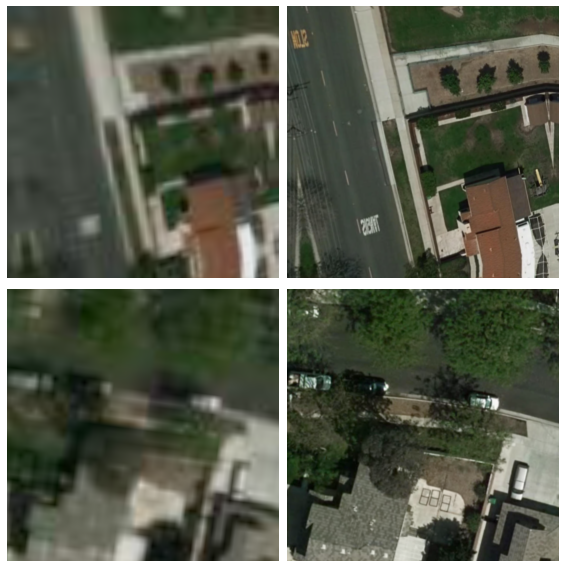

In [ ]:
data.show_batch()

The imagery chips above show images which we have been downsampled in `prepare_data` and corresponding high resolution images with them.
`data.show_batch()` shows a batch of images from our training data. We can visualize the the low resolution training data generated using `prepare_data` function on left along with the original data on the right. You can degrade the image quality more by increasing `downsample_factor` in `prepare_data`.

`arcgis.learn` provides the `SuperResolution` model for increasing image resolution, which is based on a pretrained convnet, like `ResNet` that acts as the 'backbone'. 

In [ ]:
superres_model = SuperResolution(data)

We will use the `lr_find()` method to find an optimum learning rate. It is important to set a learning rate at which we can train a model with good accuracy and speed.

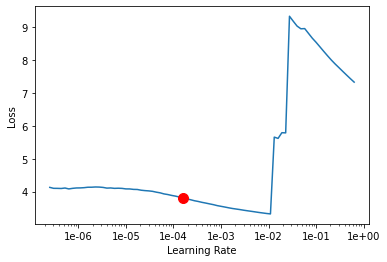

0.0001584893192461114

In [ ]:
superres_model.lr_find()

### Train a model <a class="anchor" id="7"></a>

We will now train the `SuperResolution model` using the suggested learning rate from the previous step. We can specify how many epochs we want to train for. Let's train the model for 10 epochs.

In [ ]:
superres_model.fit(10, lr=0.0001584893192461114)

epoch,train_loss,valid_loss,pixel,time
0,1.764578,1.667279,0.262905,12:04
1,1.460097,1.422421,0.224943,11:17
2,1.359061,1.346903,0.212538,11:17
3,1.313709,1.309428,0.208903,11:16
4,1.283329,1.291093,0.208715,11:16
5,1.280456,1.274125,0.205538,11:17
6,1.245067,1.257469,0.202738,11:17
7,1.239518,1.248023,0.202647,11:17
8,1.230550,1.243982,0.203220,11:17
9,1.232157,1.245707,0.204075,11:17


After the training is complete, we can view the plot with training and validation losses.

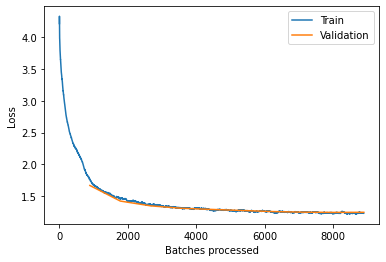

In [ ]:
superres_model.learn.recorder.plot_losses()

### Visualize results on validation set <a class="anchor" id="8"></a>

This method displays the chips from the validation dataset with downsampled chips (left), predicted chips (middle) and ground truth (right). This visual analysis helps in assessing the qualitative results of the trained model.

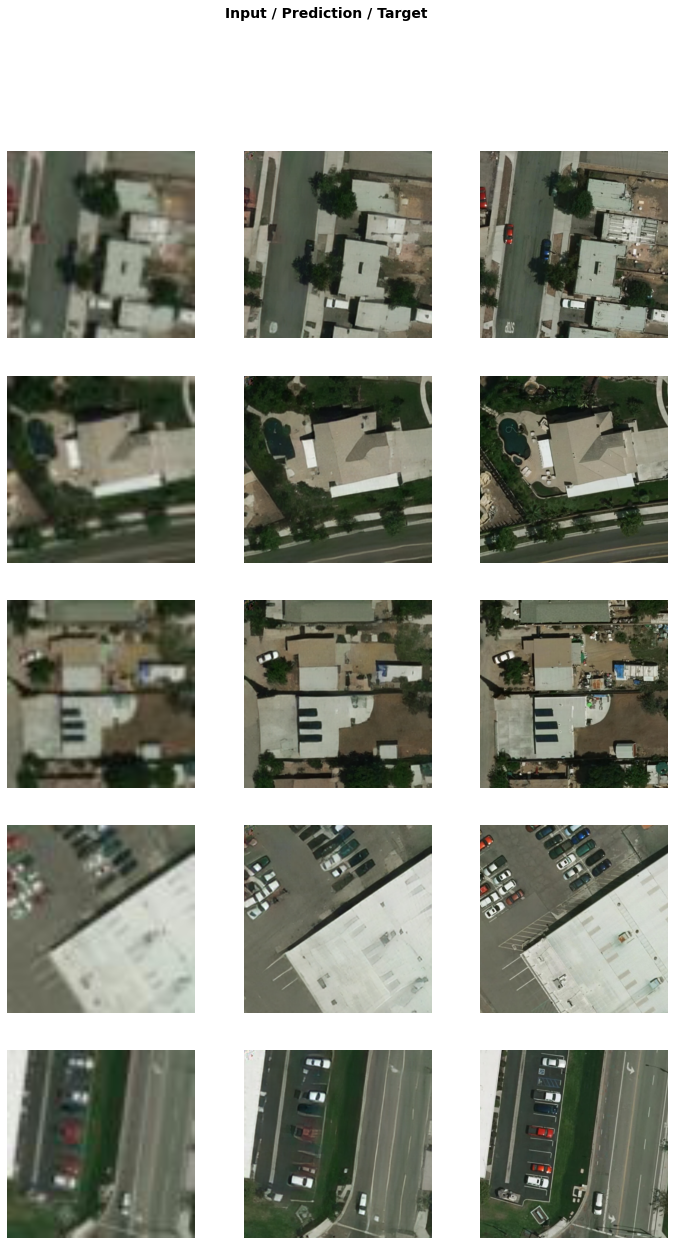

In [ ]:
superres_model.show_results()

### Save the model <a class="anchor" id="9"></a>

Let's save the model by giving it a name and calling the `save()` method, so that we can load it later whenever required. By default, the model gets saved in training/data/models directory, however a custom path can optionally be provided to save model at desired location.

In [ ]:
superres_model.save("superres_model")

## Deploy the Model <a class="anchor" id="10"></a>

### Prediction and Upscaling <a class="anchor" id="11"></a>

We can upscale and improve the details of a single image chip with the help of `predict()` method.

Using `predict` function, we can apply the trained model on image to increase its resolution while also upscaling. It can be done by additionally providing `height` and `width` parameters.


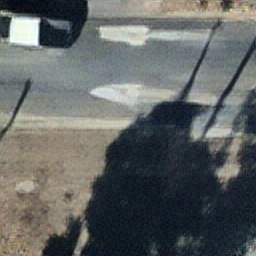

In [ ]:
superres_model.predict(img_path=r"test_image.jpeg", height=256, width=256)

In the above step, we are upscaling an image with dimensions 32x32 to 256x256.

The model is not only generating a high resolution image, but is also removing the [compression artifacts](https://en.wikipedia.org/wiki/Compression_artifact) from a low resolution image chip.

**Note**: The model is not reconstructing your photo exactly as it would have been in upscaled version. It is hallucinating the perceptual details based on its training from example images. 

### Model inference on ArcGIS Pro <a class="anchor" id="12"></a>

We will use saved model to improve the image quality using `Classify Pixels Using Deep Learning` tool available in both ArcGIS Pro and ArcGIS Image Server. For this sample we will deploy the model in Redlands,CA region where low resolution imagery is available.

- **Input Raster**: Esri World Imagery
- **Output Classified Raster**: Superres_Inferencing_arcgis
- **Model Definition**: model.emd
- **padding**: The 'Input Raster' is tiled and the deep learning model runs on each individual tile separately before producing the final result. This may lead to unwanted artifacts along the edges of each tile as the model has little context to detect objects accurately. Padding as the name suggests allows us to supply some extra information along the tile edges, this helps the model to predict better.
- **Cell size**: The model is very susceptible to the cell size. The cell size should be same as high resolution imagery we used to train the model which is 0.1 in our case.

<img src="data:image/PNG; base64, iVBORw0KGgoAAAANSUhEUgAAAvIAAANQCAYAAABKOIsdAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAAEnQAABJ0Ad5mH3gAAKK3SURBVHhe7f3bmyTFfe/7s+904Qv9EevOd15/hOW2vXyxfkt6Hnl7S9peXj+5GlugE5ItYyQhNK0GoQPiJCQQmhYNgwTijNBhWkDDIM4wDHTPGQbmwMBwGvDysmPnNzKjKiIyMjOyjhlV7+/zvJ6ZrsyMjMzKivxUdlb1OVdffY0CAHTXVVddrV155VV9V1zxA+37379Cffe731Pf+c531eWXf0dddtm31erqpWpl5Vvq/7rgSQDAHDvn0KFD6qWXXgIAdNS+ffu0F154Qdu7d6967rnn1LPPPquefvpp9dRTT6knnnhC/eEPf1CPPPKIeuihh/S/MsgzxgPAfJLx/Rz5jwz+AIDueeyxx9SePXv6Hn30UbW5uakefvhhHdh///vfq42NDfW73/1O/frXv1b333+/2vfii2r37t06yMsYb67cAADmw5tnzujxnSAPAB1WF+QffPBBHeQltP/mN79Rv/rVr9S9996rXszGdQn2MtgT5AFg/rzz7rsEeQDoOj/Iyy0zEuJNkJer8SbIy9X4e+65R1+R/+1vf6sHe4I8AMwfgjwAJCAmyJvbau677z4d5F/Yt08HexnsCfIAMH8I8gCQgLogb98f/8ADD/SD/N4XXiDIA8Acc4K8/PD+Bx8AADrmvbNn+2Ssfvudd9Rbb7+tP+h0+o031KnXX1fHjx9Xrxw7po4cPaoOHDyob62xgzxjPADMF4I8ACTg7Pvv6xD/7nvvOUH+jTffLAX5w0eOqP0HDugr8nKrDUEeAOYTQR4AEkCQBwD4CPIAkACCPADAR5AHgAQQ5AEAPoI8AIzo3HPPjRJaNhZBHgBmJzSmh4SWnSSCPACMKDSYh4SWDZF5r7n2Wh3czWMmyEuAv+rqq1Wv1yPIA8CU+ON5ldCyITKvP84b8phMi2mPIJ+4Q3fuUOf+w3nqR4+FpwOYPHsQrxNaNuSyyy7T89uDvAR5GaNNiP/Wt75FkF8Az933vH7+PvV4eDqA6fDH8yqhZUNC47ywQ7zMYy8TMnSQNwGy7Hq1JzA/JoMgD8ze5ZdfHiW0bMiZt94qDfJyS83V11yjlpeX1erqqg7ukwzyJkCWbavbA/NjMgjyQDeExvSQ0LIhoXHeD/EyT2hZW/sg/9j1eWC/5G51qDT9iLrjEkIlgMUig+7evXuD04RMk3lC06r4g7wd4l8/fXpy98g/vp0H9suOqOdK08+olcsIlQAWzzTG+bYhXrQL8kWIJ6gDwMAkBnjx6muvqRtuuEEvK66//nr18iuv6LF6IkG+CPEEdQBwTWucl//LY6F5Q+KD/OG71TfkSvyP/hCeDgCJuOPOO9W5//AP/YGzJJsm84SWDZFlkg/yR4+o/ypX4n96IjwdABKS6jg/sSCf34u9Q91xODy9yZ4f2ffRn6e+ceeR4Hz9W3dsoTcP9m8HSssE7tPX8+T97/fFvz0odt1GYH5/u2K2u/R5A69ftdPt/eDM722rVv38+f3U6wi0DcyLO++6S/3jP/5jf/A05DGZFlqmiiw37gHev1fy0ksv1bfWyIddJcCPO8jn92I/r1aOhqc3uf2n9n30T6r/et+Z4Hz9W3dsoTcP9m8HSssE7tPX8+T97/fFvz0odt1GYH5/u2K2u/R5A69ftdPt/eDM722rVv38+f3U6wi0DcyT1MZ5+zYbmRZaxhcZ5PN738P3xTf5g/qRCYbmseLqvhtqi3WUwmaxvB/Oi5D5jUuy0OqE7br5d2Tzh4Jpy3VXzZ9t14/62xS33XmAdtvZc+dgmabp1UFelnMfD7VVtS1VbQDz5K6771af+cxn9MAp5P/yWGjeOrLsOAd4f3CXeyXfPHPGCfPy2PiCfH7ve/i++CYn1KdMMDSPFVf33VBbrKMUNovl/XBehMz/elkWWp2wXTf/89n8oWDact1V82fb9an+NsVtdx6g3XZuv2+wTNP06iAvy7mPh9qq2paqNoB5k9I4798zHxPmI4N8EUqHuK0mD4/lK+R5UBw8bl9FtufTQsG/CLDBNxeh24DM/IFtaLvu2vkLcdvdtF8j9ntNkC9d/W+5Lfk2EOQx3371wAN60BTrN98cnKeJLDvOAd4f3OUx+fpJCe3yYVf5+skrr7pqjEG+CKVD3FaTh8fyFfI8KA4et68i2/NpoeBfBNjgm4vQbUBm/sA2tF137fyFuO1u2q8R+70myJeu/rfclnwbCPKYf6mM88IP8/YyIaMHeROaLYOgWLOcE0CbrvgHpgcCrE2H0Kj52667aX7RcrsDgT/XND1TGeRD4dzvV8O2NOxjYF6sra2p6667Ljgthgy4l1xySfCryIRMazPAhwZ38wehJLSbMD+VIG9Cs2UQFGuWcwJo0xX/wPRAgLXpEBo1f9t1N80vWm53IPDnmqZnKoN8KJz7/WrYloZ9DMyTFMZ5ww7z/jRfuyBfG14z/hXfQMj35SGxJvgWSle4Y4J8af6YcFvmtpXPX7rabYve7kyxHVpo/0ZOHy7IN2x7wz4GkPvlHXdECS0bywR5+T55GavHe498EQBrw2vGv+IbCPm+PCTWBN9C6Qp3TJAvzR8TbsvctvL5S1e7bdHbnSm2Qwvt38jpwwX5hm1v2McABkJjekho2UmKDPKBYBxSEeRrQ6+WUJCP2abo7R7I11EI9KVyOkEeWAiTDfKBYBxSEeRrQ6+WUJCP2abo7R7I11EI9KVyOkEeQI3oIG9CXbsA2xySc023qwSm14bMqvlD4bbtumO2KXa7y/LAHupnxXSCPLAQJh3kTahrF2CbQ3Ku6XaVwPTakFk1fyjctl13zDbFbndZHthD/ayYTpAHUCM+yGeaQmboSnS+TMOV/Ezdhy6DV7iLkBkMocW08vzh9tuuu3E/ZGK3u6QpPPvTA/PHB/m6bSnewNT1BcDUTDzIZ5pCZuhKdL5Mw5X8TN2HLoNXuIuQGQyhxbTy/OH22667cT9kYre7pCk8+9MD88cH+bptKd7A1PUFQOe1CvIiD35eSDZCAboIwqVQK487IdwERz9UFuHTv2JerKtyfcH5q8J3y3Wbx/35s3X0+xK13Vk73hsR9w1A0/TMiEF+sC1uP83z7LcNYDamEeRFHvy8kGyEAnQRhEuhVh53QrgJjn6oLMKnf8W8WFfl+oLzV4Xvlus2j/vzZ+vo9yVqu7N2vDci7huApumZEYP8YFvcfprn2W8bQFpaB/mcCX8BwVtUQvN7AbeQh1B33ro3DRIy7dCpeeF3MH9VkM9Fr7tQWm/VGwGHvd2B6c7+a5qeGTnIi8HVd0Nvd6BtALMxrSCfM+EvIHiLSmh+L+AW8hDqzlv3pkFCph06NS/8DuavCvK56HUXSuuteiPgsLc7MN3Zf03TMyMHeTG4+m7o7Q60DSAtQwb5DiBkTh77GOiM6Qb5DiBkTh77GEgeQR6V8iv74d+cAJgugjzGLb+yH/7NCYA0EORRoeo2HACzQJDHeFXdhgMgJQT5RSf7sRTWzb35XI0HuoIgj6HIfiyFdXNvPlfjgdQR5Bde4AO1givxQKcQ5DGcwAdqBVfigbmQbpAHgAWycEEeANCIIA8ACSDIAwB8BHkASABBHgDgI8gDQAII8gAAH0EeABJAkAcA+AjyAJAAgjwAwEeQB4AEEOQBAD6CPAAkgCAPAPAR5AEgAQR5AICPIA8ACSDIAwB8BHkASABBHgDgI8gDQAII8gAAnxPk5YQQmgkAMFvDBPlnnn3WCfKM8QAwX2Rc10H+0KFD6o0zZ4IzAQBma6gg/9xzamNjQwd5xngAmD8yrsv4TpAHgA4jyAMAfAR5AEgAQR4A4CPIA0ACCPIAAB9BHgASQJAHAPgI8gCQAII8AMBHkAeABBDkAQC+sQb5I0ePqnvvvVd973vfU1//+tfVV77yFf2v/HzHHXeoA9mJJbQcACyqk6dOqd8/+KC6+ppr1CWXXKLHzQsvvFB9+9vfVrfs2qXku+AlwHchyDPGA0B7seN8aNkmYwnyZ956S/3sZz9TvV5Pd0w69Zvf/lZ3+ne7d6tbf/5zdfE3vqGny0a8fvp0sB0AWCQP/PrX6vzzz1df+MIX1I033qjuv/9+PW4KCcbf+c531LnnnqvHz/37988syDPGA8Bw2ozzw1wMGTnIv7Bvn35nIeQdRWgeY3t7W3dUNubxJ54IzgMA8+74iRP6SowM7jLI112JkSs5Eo5loL/rrrt0gJ9mkGeMB4D2hh3n77777lZX50cK8nJFRlYqV2rkik1oHp907vZf/lIvd9vttwfnAYB5JWH3s5/7nB7gj736amn6m1kwDw3ijz76qPr85z+vLr30Uh3gpxHkGeMBoL1hx/k9e/boCyGyXGyYHzrIy+X/z3zmM+qhhx8OTm/y/N69eqBvusIzko0VtbTUUzu3A9MmTa97Se3YKE/bvbKkp1VNn4ia/ozFLPd1k0lvO7qtQ8+/hGG5NUV+vRqa/vIrr+hxVX7V6k+Te+TlCs+XvvQldeutt048yCcxxotZjj01xxbj/JR16HWOGejQ8z/KOC/k6vyXv/xlddtttwWn+4YK8vIuQX59Kr8GCE2/55579L2S3//+93WHQ/MIuc9SOivvTELT622oHcUg6VpRu808sxx0Kg6qfHC3+jiK7TXVK22/CGzzpA/yMe3r7bVefTvFNvfWtsPTQ2b9Ai/WH7SyEV6ma4r9nuRJctbPv0WubMstKlVXt+XeSRk75UqOP8182PWxP/xBzyNBeVJBvhtjvGCcZ5wPTA+Z9eu8WH8Q4/zkzfr5t4wyzhtya6JcCHnxpZeC021DBXn5dalc+g99oOmxxx7TA7e8G3nq6adL021yRemiiy5S119/fXB6FXOlo/yEbaudvY4M8EHSvzG+qCtedPkg2XIQHFWXB/hZq9w3g5DS+YEz5QG+I+TKtAngoekiJsjLh11/9KMfqX/5l3/RY/Akgvysx3jBOF9gnE8D4zwyo47zNhk3ZfyUcTQ03Wgd5KVBuXFfvqnAn3bg4EF12WWX6Q7Kjf3+9BCz0fIr49B0X6srHQs6wIuxXhGKwQBfrWHf5M9Vl47TAAb4kcmvUSWAh6YZsUH+1KlT+lezMg6PO8jPeowXjPMWxvk0MM4jM+o4b5PfZMpY3HR7Y+sgL4OynED8XxnI4P+Tn/xEd259fd2Z1kSu7oROGiX6hdLiIKt4YeUvKFv4xWWuePT11tR27HRv3aV5i/l3Vg7ExcnAW6ej5kVXGigr+lMaKIs2/ZOQv89Ky1Xs66Z96Cv121cxwNeuJ9Q36zF326rW7f+KX+bLH2s82VTsm4Gi7cCJv3G/R86X75/8OPPnjXo9tRjgY/rszxPcP/39VrwWZD7zvLZ5/mb9/GdkvJRxU8bP0HQjNsjLt9Zce+216pprrhl7kJ/pGC/0c8M438c431e7nlDfrMcm/jqv2DcDjPPB/dPfb4zzIfKmoOmNQesgL99GsLq6Wnp8c3Oz3zH5tK58SreK3MhvLyudrPpQwEDEgOcLPbFyoAYHL3e+/DF74M3WvzJYd9P04LrNNtjr1/MFXjgxL6iaeUoDZaA/wW0o7ePiwLYfCw2yse3b+yhgmAF+qOei2O/+vs/b8tdfvQ9k+cYXeGj9nvI2RO73yPnMfu1lz6+9vebEWHuciaLN+vki+yyPRbwGzX7z+zyYJstEPH+zfv4z8mtWGR8liIemG22CvFwR/+d//uexB/nZjfEiNAY1CD2/kcdY+XXnjh1N04PrNtvAON+fx8c4bx6L3O+R8zHOz/D5z4xjnPfJBRC5jTE0zWgd5G/86U9L9zuaeyalYzHkV7P28nLikL8MaD9WVuxk78CoFfHC0koHYb6u6ieuaXomuO7AAF+xXfkLz37BB1S+6AIDdbA/7rpDg2tVP0qPl9qP2EcBoT44Wj9XmdC268cCy5XaDw2+hao2fMF97/K3O3a/t5sv1NfQST2g8lgbiO1LUGC/m/0bfM23eP6C+7/F8iM//xn51ah8+Mn8LN/NLh8mNd/Pbsh96Wac9KeJH1x5pXozG6clyD/9zDP6w1DjDvKzG+NFeDysFXp+Q0rPbdPYMeTYwjjfKNQHR+vnKhPadv1YYLlJvM6D+97lb3fsfm83X6ivjPP9x8Qknv/MuMb5K6+6qn9fvLw5kKv8ps2Q1kE+dGVFBml7EG8i34/pL+8/VhJ64pqEntggf5BoOugjXhTBdYcG+NABFJ6vJPiiK5YNHtDlfZG/+OTx0EBZM3j67ZXaj9hHAYP+hKeXj4Mhn4uK/eGf9Mo/l+dtPCYr1zXgbnfsfo9/fur2a+M+F8FjzRbfl7DA8nq5inVWtpm34zxfoXmjlw+0583b+Pxn/Ksq5q+ktvX3f//3amtrqx/kP/3pT489yM9sjBeM82WM85khn4uK/TGR13nlugYY5wPL6+UY533mL7yaq/ymzZDWQV7ujfS/kkx+jXDJN7+pVyY35suAXWf95pud5eUryq6++mrnsbL4ndlXc2DlB3X2xFlCB5cWGjyipvvrrhi4/RdP44upUMzX74cR3R9hTgjCezda1X6f1V6o/aZ9FNB+gM8M81w07Q/zHIXW1xd5TFaua8DZ7tj93uL5yduvuFoS0T+zrspjskVfjLjXYEW/Yp+/qnljlx/H85/5wx/+oK/CmJ/lQ0zy61UJuDa5EmMGcn+afJOM/LEQc2vNo9n/P/vZz449yM9ujBeM8yVVry3GeXeZyr7V7A/GeVexLsZ523THeSHtmDbkayjtNkNaB/l7771Xff3rXy89/tzzz6uLL75Yr1DupfSn1/nBD35QGvjLih0fOVBogSexf1A57VQ/Uc5B6A/MddODB1Dg4LMeN+vXbcZsZ9OLztZ0QEv//XXWHtyeyvab96Etnzfcjlazza2ei6b9YZav3cfjG+D11Tqz/2P3e4vnJ983kx/g4/tiba8W2Jd1/Yp9/qrmjV1+HM9/Ru4pl0E79HWOtt8/+GB/gPen+ffI33nnneqrX/3q2IP87MZ4Uez/mPHPCDyX0cdYoXLsaJoePI4Cx6D1uFm/bjNmO5tee7am41r676+zxWu3uv3mfWjL5w23o9Vsc6vnoml/mOXH8Tqv2TcG4zzjvKgb530yHsu4G5pmtA7yR44e1SsP/RGQ3dkJQ+7lWVlZ0b/+9aeHmE/5Nn0fsWh88ftKT2LVE9L8ROW/Fq1ed2l68AAKHHwFvW36gM/niTloGl90tooDur9PN0Iv0Hy/hPpbUvmCGWjah5pup3kgqdvmqOeisr/+c1RzbMQOak37ptRO7H6Pf37qXjv5tIrB32jc7+36XN5ngcfr9lv085eZ9fNfuOCCCxq/uaVNkN+xY4cOx+MO8rMc4wXjvCdizOurOK4Z563HNMb5oMb93q7P5X0WeLxuv0U/f5lZP/+FUcd5n3zxwK0//3lwmtE6yAu5B2jnzp3BabtuvVV3Tu6zfCM7uYTmsd199936k7vmxv56xUHkX1Go4j+JVU+Inq/hiSrmqTzA/enBA6h6gM/7ls2vB9rQgRfQ+KKzhPpTLG/6ExqA88caXvwiuL2epn2o1Q8UUYNRzHNR2V//OSp+DhxzeV8iXuC1+ybcfux+j53P9LW87+v3d1/EsRbVlzavwbr9Fv38ZULzRi8/hue/IPedy5VuCeOh6SI2yO994QV9f7xcJR93kBezG+MF47wj4rXXF+pPsbzpD+O8mMDrvHbfhNtnnDePVey36OcvE5o3evkxPP+FUcd5m/xVV5mn6a+7DhXkzc338q8/Tf7ox1VXX62n//KXvyxNt8mVH7lSIxsVmh5kBqXKJ8c6wEpPYuDJ6rdnP1HZQe8d8O7B2zQ9EzyAAgefP036EnsCi3jR9VXtC+cFGTiBmv3j90ker30RReyjClUvnPAgNeRzEXx+ROA50vNWPBboZ0nVuqr2bd00f79Hzmf2nd+PfF+F9oOnWE/tsRbVl9jXYKbyOaqbVvX8efO2Xr7iMb/PNeTXrXJbSt24GBPk5VtrJGhflwXpt95+eyJBfqZjvOgfE1XPUd3rO/YYY5wv7Z/a126m1D7jfF/Vuqr2bd00f79Hzsc4783bevmKx/w+1xh1nDfkwof+q9g33BCcbhsqyAv5NK58TY7/R0OEfI+w3LB/xx13BKcLOSHJr2fl3snQ9CaDA9bXNMgWg5gzf/6YM8A782Scg7Zpeia47sDBYysOmqgBW8S86AyvP/kLO7Bs0Qf3oA1srz9Ql7Y3Yh/VsV70A6GTw5DPRegxreI58vuj15GvO26At5btC63fFrHfI+fLXy+DY72+vYDg81Fw9lVMn0N9yB/r5AAvRnn+LfJhVfnKSPONBD7zXe0Sfv1pJsjL7TTy69uTJ09OLMiLWY/xgnE+wzifGfK5CD2mMc4HMc7PfJw35AsC5Ct/5QOzoem2oYO8DN7ybkE+fRuzIpu805Bf28q7lqYPBSySwYswPB0d0+YEO2McWxMw5PMvt6TI2ClXq/1pMjb+8Lrr1G9++9vSNAnyv/nd79Ty8rKSvxwo804yyDPGTwavxcQwzi+2KY/zQu6xlzcCod+Ihgwd5IV0UL7sXt41yFfkhObxyb0+snFypafpvp/F0nAVB52T0qDJAD9+w+5TCcjy9Y5yNebe++6rvZfSkNtZrrjiCnXeeefpwV8+7DrpIC8Y48eNcT41jPOLbdrjvPwGU77it+kDs7aRgryQk8muXbv0uwd5ByJ/ySo0n/yKQX5VK/PJXw2s+nXsosoPlqZfwWEW5Lkp/Vqt+DVqm1+3zRID/PAm9fzLfZLyIVC5/US+N1jGUn8eGdjl68dkPvmWGgnW5ltrphHkBWP8+DDOdxfj/GLryjgv84W+MazOyEHekCsv0gG570d+nSr/lz8MIl+dI/dzyuNyZSf2qs6iyF94cj8Wg3tn+ffNJfh8McCPYILPvwzg5qqNXIX5RjZGmj+qJB9olXFTrobLIC8BXq7qTDvIG4zxw2OcTwDj/GLryDgfc+XeN7Ygb8j9kHIjv3RIPgwl/8rPsiGh+QFg0UkolwD8wK9/3f8QqVzJOZiNy2Ye/3vkpx3kDcZ4AGgvZpwfxtiDPABg/LoS5AEA3UGQB4AEEOQBAD6CPAAkgCAPAPAR5AEgAQR5AICPIA8ACSDIAwB8BHkASABBHgDgI8gDQAII8gAAH0EeABJAkAcA+AjyAJAAgjwAwEeQB4AEEOQBAD6CPAAkgCAPAPAR5AEgAQR5AICPIA8ACSDIAwB8BHkASABBHgDgI8gDQAII8gAAH0EeABJAkAcA+AjyAJAAgjwAwEeQB4AEEOQBAD6CPAAkgCAPAPAR5AEgAQR5AICPIA8ACSDIAwB8BHkASABBHgDgI8gDQAII8gAAH0EeABJAkAcA+AjyANARLx1/W939wil101MntDv3nlLPHHtLTyPIA0D66sb5YRDkAWDGHjn0hjrvzoPqYz97SX38pi11/l2H1OfuPqz++uYt/dinb9uvfvXiKYI8ACQqZpx/4KXXg8vWIcij0u6VJbXUW1PbgWkARvfMK2fUdx58WQ/qV+85oTaPvqsOvvG/1dG3/l07dOZ/q0dffk/95MlT6v9Z31KXbxxRTx05TZDHEDbUjqVsTF9aUbuD0wFMQqtx/uZtPa8sE2orZOQgr8OeHhwshL+J217rlff7Uk/t3A7PPwyCPDA5L7/xrr4C862NV9XG4Xf6g7rxzPH3ncF+96G31crvXlGfvOVF9fzLp6cW5INjDePC2AXPpWMd0wnywLS1HedlHpn3U7duq32vxd1uM6Ygbw82czJYbK+pnmzHykZ4+ozpkysn07Fhf2Kajr35rvrGb46qCx94WV+NMYP4k6++ry76zSv616zGN3cfU3tPvq+OZPMdfvPf1OrGy+rrvzqojpx8c3pB3nltbKudvXTH+K6+1svnUoxFx8/lmF/DjPNmnssefFUvK22E2rZNIMgPruDs2HDnTQpBfqGwPzFNa08eV1++76j6w7Gz/YF7+41/U8u/PKAH9S/dd0T/mvWL9x7RP8ugb4L8nqPvqC/edUDd+NjLMwrymWJ8THGMJ8gvGII8ZmSYcd7MJ8t8KXtc2gi1bZtIkH9/Y0UH+d7atvNz+NeF1tUdM58ZZCOX21m8cbDnMW8mcoErR+bFHZjHXTbX35aGZWu3p3a5dppORvK8SJ+dbbHm189bYGDTjxfz+fP019l/Xmr2mdd2U3/MPLKcM0/Rjtt+eb+5093jsX7d5vmymGn+8+X1FxjG8bfeU//z5/vV7fve7A/a4rYX3tCD+Sd3bauXXv+3/uNm0H/+xFkd5A+98YG69bmT6m9u2qeef/n12QT54jevOsg3jGv95f1xo2G58Y8HNa/1ymWsaTHbMMIYobfXW+9A4Lxi96M/3Vve9E/3y2qjqk27/6Xnx3/j1tQnd55xn6dj1u+2n+ufyxuOP2AUw47z9lV5mfcTt2TzHX87uA5jIkHevHjMi373iv0C8W+9MS/GjDcIxi7Xf2HaL2YTJM2L1fxszTcYlAK3A4WWE43LVmxPoL3ttTVr+9rpn1gC00T+vFj7xvTTrF9vh71/B/MMnje/v8Wg6O2TfF12W8U+sOZr7E/dPM5jFW3b+8Lbtph1l/enuy/E7uz5qtrfQKydTx7XV2DMYG2sPf26+vRtB9QVjxx3Hv/e5mt6gH/4yDv9IH/w9Pvq83fuVz/Z88oMr8ibMJaFNGv81683/7Xlvd7yx+uXm9R4ENqeqGVK2zDeMSLf3qYgb/XBnFNMv4tz02DfDPqd99G0YbbLatPbH2a5UFulfS/LV/XJmqe/XNHP4HL2/i3mizrXVq7fesxuO/DYKOdjwDfsOC8fhLUf/+K9h9XakyeC6zDGH+RDLySPu4x5MVYNYAPNy9U9Zl785RAn3AEvE3rxRy1bsT2BQXYUZp0Oa5/rfRXqpzfAOv2RPta0ka9zcHLTiv1kn8wGjw/2QXN/inm84yZ/zt11Ost568nl22b6FLNu/+dwu8Do5L5Huf/RHqzryJWa//nzA/1ba0yQ/9buo+ofbntpBkE+PA726bFu8JrVy/vjRoi33KTGg7jXemAZfxvGPEbk2+bp99OcV+w++I8Vz0vlMlU/+9vgt2M0tVc3j72OusfMcm3OtXXrz+jnyWtrzOdjwDfsOO8/ftlDr+mvrAytwxhTkPcEBvjyfOZFHHoxDrtcxGPmRV2hH0hDL/6oZau2pxiYCqMOIKWTkUf2W2kdoROs1Ya/jN731vYH1+m1OZBvr9mfMf3x1ycq12keKwbkELO+YfaF0P2Rtvz1AyPo3bZfX5XxB+wQuWojV2nkXz/I3/jEa+rTu/ZNJ8hXvLaq56l/bcUsN6nxoNTGMMsUxjlG5G35odqIO985bZTOYf78Feeq0Lmv4PYxpk8x8wQeG/pcG3gsuD3jPR8DvmHHeX/a2jOv67ZC6zDGFOSrBp9M/wU5eGE1DwbDLhfxWM0g5QjNF7VsxfYY/e2qmSdC3clRyL5qCq95X+xB3+2P3t/WtlaeRIPbMc0gX78fY9Zdtz91vxqfdyCOfBXZ7S+490365BsO5FsMZHD/1+IbD/wg/+vt0+p/3Pj8jO6RN4pAZE+Pem01Lzep8aDUxjDLeMYxRuRtVJ1LI893eluKcVf/327Pn7/iXFVznnP7GNOnmHkCjw19rg08VteWmabZ7QCjGXac9+eRrx2W6aF1GBMP8noAzF4kJtCJ5sFg2OViHgucQEKCL/6YZcPbU1IMuMNeCYg5sTQG+YyZT7fnDXR6f1uPBddZ7Cf7eRo8PjguYvrjr08E1ynLmceq1m+JWXfT/vS3BxjWP95xUF3/xKnSgG2T7xGWwVu+1UC+5UAe84P8dY++qpZ/MYtbayyBMUXP3/TailhuUuNBqY1hlgkZcYzQ21u5fOz5rjhHZftNt+f02Z+/6lxVdZ6LWX6YeUKPDXuuDTxWPL/+seTQx+Pw52PAN+w477v+8VO6rdA6jIkHefMC6b+IzIuqv0zoxTjscnGP5ScMq20tGzgCg7s/kDQvW7099onCtFN38qjTdGKJCa/9x3pZ33rl59A/kVatMz8GAvvcWjamP/76RHCdus+Dx4LrX3GnN+4L/+fs+d9hL6On1xznQKRv/u5ltWP34GvGfPtOfaD/AqAM8L/a/1b/cT/If+PXh9V5t2/NNsgX42R/HOuP04PXUnD5iOUmNR6UXuuZpmWqtmGcY0Teh6rlQ+eV0GNFX/W+9Mc9f/7w8nYb9vLmscE5K6ZPMfOEH+tvR6tzbeAxc2zZz1/2XI3zfAz4hh3nfdLG5+46FFyHMfkgn8nnKWQvpp3OMqEX47DLxT7mDnaGH/bseUIDmm0wvWJ79CDvLjPKoBHqg92m7Dt/e0InsH5//ZNURu//iCDfn2b1w193TH/89YngOmU57zHnWPHWH7cvzPOWkbb7wcIY/gQN2G577qT+6rHQr1HF7w7mv0oV8n/zuB/k/+G2bbXryRl9a43Fee3LfN5rq2r5puUmNR6UXusRywTXO+Yxwl+/kfcjdF6pONcE3hSF569Y3tDPh0w3/O2L6VPMPFWPecdIYfC8DNeOXr60bYR4jNew47zvM3cc0m2F1mGMHOQBAPFOv31W/e2t2/oPgYQGbvlz3fJnu/0/3W0H+esff019/GcvqO1X35h4kAcAtDPsOG+78alT6v++eUsdfr3+r7sS5AFgyu5+4XXVu/2A+m3gSswTx86q1Qdf1eT/5nET5H+9/ab69M+31C+ffXUqf9kVANDeMOO8IcvIsne/cCrYto0gDwBT9t77H6gfbB5Tn7v7sPPX/UTdrTX7X/9AXfjAYfX9B4+oM2+/Q5AHgI4aZpwXcoX+ot+8rJeVNkJt2wjyADADp94+q75wz6HMYXXr82/0B/EHD7+j//KfkP+bx3c9d1p9/u6DqveLLbX/+Bn19jsEeQDosrbjvMwj8y7ffqDxlhqDIA8AM3IyG+RvfvqE+vtsMP/m7lfU3S+dUU+++n5/UH/uxAfqnq231HceelUtZ/OsP/maeu3Nd9Q7775LkAeABLQa528/qOeVZUJthRDkAWDGXjr+tv6T3ubryOTbDv7fW/f3f/X6L/cfVk++/KZ67+xZ9e577xHkASAxMeP8U6+0H6MJ8gDQEfJr2D1H3lQPvPS69sihN9Srb76np519/32CPAAkrm6cH8ZIQf6cf/o9xiC0bwHARpCfX6HzAmYj9PwAXUaQ74DQvgUAG0F+foXOC5iN0PMDdNlIQR4AMB0EeQCAjyAPAAkgyAMAfAR5AEgAQR4A4CPIA0ACCPIAAB9BHgASQJAHAPgI8gCQAII8AMBHkAeABBDkAQA+gjwAJIAgDwDwEeQBIAEEeQCAjyAPAAkgyAMAfAR5AEgAQR4A4CPIA0ACCPIAAB9BHgASQJAHAPgI8gCQAII8AMBHkAeABBDkAQA+gjwAJIAgDwDwEeQBIAEEeQCAjyAPAAkgyAMAfAR5AEgAQR4A4CPIA0ACCPIAAB9BHgASQJAHAPgI8gCQAII8AMA31SC/e2VJLa1sBKfNku7XkqeD/QSwuAjyAADf/Af5jRW11FtT26FphXK/NtSOLMz31ratx4YUsX4AaEKQBwD4CPKZUL+213rjCeAEeQBjQJBHre011XN+m5xfkFpaWlG7/XkBzI0ZBvlttbO3pHZs5P/mt7T01M5td365Kq5DtZ6ecUKxDFTuMvlglg9cen1mOVHxJqIyyNuPmUHS8MO5BPb+9LxPdet3tsnZBrNfGIQBDKQQ5N1xLTeW32x2hhmXbd45aFYI8sBCmnmQtwdBPd0KyCYID04ExTLOQFUd5PXPw1yR12247W6vrZTCdn8Zf/6NNev/5fWXrvbrNwGmz3nbvZ69PgCLbtJB/uVXXgk+Luqm5crjuWbCZcMYHFQKphPQYh39NynevO65YYamsb/EtNYDIMrMg7xztUYPEIMQXgrY/XnMyWKMQV4GJiPmpGO366/TVlp/oM/FvtixMfj/fF3FAjCqSQb5+++/X5177rlqz549raYZZgzNxzCPvlAxxJg2jcAYuQ4T4js9Lk9jf4lprQdAlJkHeWfg1wPEIOTK/OWB0w7Ck7giL22GT0ilXxv32zVXowLL+esvTmohdpAPnhABLKxJBfmTp06p888/X/V6vVJglxAvj4svf/nLep32srl8zKweZ834aMbl0PzuPHW36ORvGrL5TKA0nGA52jpcTdvn8fuVCY7njfNZ/TXnDasPfv97Kyt5e945drDfA+1pZnqhdI4anGMb91lpm7y2m6YDaI0gn3H7ldEDmT3ABAbyULv9Qapm/aW2fYH9AmDhTfKK/Av79pXCvB3iL7jgAnXk6NHgsvmYVhWCc3n4tsdtbzwthc6MGU+dgG7a8uYt+jCYd7R1OGLmKZiga++L4R8z/fW3o2Hefj/97Q3MY7bNan939oZgcH4q9mPMPiueg8G5y1s2sNz22pq1LgDD6HyQDw8WZlCRgcIL8n5Qlp+9QdBXXk/et/4gqftlD27FQBps11vWX7+3jWWB/QJg4U36Hnk/zEeFeFEEODuU+vLgOc4g74+h/vJjDPIR25cLrVPE9C00n/nZ39aK5UvbUtWetf3Bx1yl/R3cZ0WfvP1o3nDo81n0fgTQRveDvBkE9Dz5YDEYCIpBqN9mMZjYg5IePKoHKVEO8hm9XNEXr1/9gcwMpNm8gz562xVYf75d3mC6YgblwH4BsPAmHeSFHeajQryICGhuGAwF0WIst8fFYGAMjZ/24+NZhyNi+7Satpy+xc4X6q+oWr70uL98qL3wOvJ+2ALnP3v95rEK+fnMnJ9zBHpgPDof5HtrG8VAUygNfvbgkA1Guo3QQBVaNuf2yyiWK04E5sqCJo/J4G5OEt4g5g5Q4fX7A6X/5oQgD8A2jSAvTJiPCvFaKDTbzBhoxuXEgnzj9hVq2nL6FjtfqL+iWL4UhEvt+suH2vMeM21Y87h9suax+1+zTSX9dbjrATCcqQb5tmQA4V07AEwvyAsJ83EhPlcKe7bSFe1QMC4es4NdRTgMr8sPqaOtw5evs+kCS1Xgj+lbaL5Q8M6YPvvLF/t5lCDv3ApTzBMV5Cu3qUbsbzoA1CLIA0ACphnk2zOB0AvYFaHTD4eD33haIbN2Wfdxs7x9vhhlHWVm+8rnJPt75EP9CIXjuPlCwTtn9sFgXvMmJTNCkC+9GTD7JxTkvX3W379+wDfzZW2H9oH9GID2CPIAkIBuB/lcP8xZwkHNCp6ZwS2Ubmi12zPngjzEZvOZ0OlNHxh+HVVC21d68+L1qzQ9er7qIC/6b2jMshtFwB4lyGecdrMQvlP/7Patap+F9k9/eml7CfHAOHQ6yAMAcikE+WnoB/nANABYNFML8rt27QKAuRAa4yaNIJ8jyAPAwFSD/NbWljp58iQAJEnGMIL8bBHkAWBgqkFeToQURVGploxhBPnZIsgDwABBnqIoKrII8gCALiHIUxRFRRZBHgDQJQR5iqKoyCLIAwC6hCBPURQVWQR5AECXEOQpiqIia5ggf+b1p9TRvRerlx76i77DT52vXj/2QHD+KgR5AICPIE9RFBVZbYL8kWcu0PY/9gl16ImeevP4w+rMqSe0Yy9errYe/qv+PFVOHbuv3x5BHgDgm3mQ31xdUkurm8VPg9KPL6+rI8XPpqrmjy1Zfnndb9WtI+vLtesYtQ8URaVZbYK8XHl/Zd+l6uThdXX2vTPqg+wx2xvHd6vjB2+sdOCxT+l/TXsEeQCAb+ZBPkvFamlpVbmx+IhaX5bvCl5WbubOHx8lQxPkKYoattoGebn67gf4WHJFniAPAKgz+yB/ZF0t+4G9eGzZD+2heVsWQZ6iqGGLIA8A6JLZB/niKrsdrk2QLgVmuXpv3W6j51uSK/cFN/UXV+831aqenl/1DwV5vR7TRtb+Zssgn7e5WfwWIacn6zce5jHvtw7OtEzVbUTW9FC/3H1gv8kpb/+q128pvXxg3RS1SHXppZeqD33oQ+qcc85xfPjDH1aXX355Mdf4g/z7Z99VJw/fog489gk9f5VDT32GIA8AKOlAkC/CZCkYZ9HSC+52gM4DrB2Oi9tx+u0UbxCWV50r+P22i9Jt2kFW3+pTDrx22f2Q0j9bIbofrvvt+n2Teex+lafH9KsUwp3blALb7+1PM0/NplLUwtTFF19cG+Klhg3yJw7e4HyI1Tj89OdLoT3k6N6vEeQBACWdCPJuAJUryCYU+/83odN+3Cp9ldsLst5MbpAPt+MHdb+CQd6Z3+5rUaUQ7ZUzPaZfoXnsYB7afm8ZZ39RFHXeeef1g7wf4qWGCfJvn35O7X/0Y6Vw3sapl+8kyAMASroR5O3g6wRaK5jaodMJ/nbZQTV8tdkJ8hVB1v8NgV+hIF8bmKUCQb5/5d4w02P6pfeBtawln6V5+5u2k6IWsSTMh0K81DBB/vjBn5aCeVtvnd470SD/0sl31X0vvaGuffyU+vru19TKg8fVzc+dVo8cPqPePvt+cBkAwOx1JMgPAqYfLs3P+l8TdMcV5CvaaQq4owf5/I2LE+zt6TH9qtwHpsLbP1hPxXSKoiqrbZB/88Qj6vDTnysF8zbk/nhpbxJB/oXj76gfP35S/cPdL1f6waMn1BOvvOUsBwDohs4E+Tyor6pVP1wWgVU+qNkPy/qKtReUpZwr2bFX5Mvt+EHdr5GDfOCKu/NGJaZfVfugX1VBvejbZrkPFEXVV9sgf/zQjaVg3taxl76r2xt3kN+Xhfiv/PpYMLz7PnvvK+rhw4R5AOiazgT5PJhmQbUUTour197jOtQ6QTQProNAHRHks9Lt+FfGZX0TD/LWdLPt/X7kfW/qV3AfrLpthDZD93e5/rcOFEWVq22QP/rchaVg3pbcHy/tjTPI7zvxrrp492ulwP6TJ0/pD+fKv/60i377qnrutXecbfTtXpExydJbU9uB+bpue63nbsfSitodmG8adF9WNvo/5/t4dv2pUnrurT4DmJzuBPlQeC2qHFjz0lexrYHDDdNxQb6/XtNOtsDkb63x+i6Pe9Nj+5Xvm4FBP6qDfP7GwX/DRFFUU7UL8n+utvd8vBTM25L746W9cQV5uef9+ifKQV3UBXnxo2y5t94L3TO/oXbIGOQF96FC58bKZN4ARLW7rXb2An3Olt2xYf08RX6QH7uR93exz7w+7l4b8Tmc1HEAzJkOBXmqqcpvGIas0psGiqJiqu0V+VHt3/M3/fbGFeTlg62hkC6++ttXdYiXf0PThXwA1t5OoQN7RejS09oE0RkGeR2aOxYeOx/kt9dUb6mndm4Hpo2CIA9EIcinUvrWmnHc055fqR/LGwKKWrBqFeQfDofzNswHXcW4gvytz58OBnTxzd+/pu544bT+NzRd/HzvaWc7zdX4yivWTtCTeb3Qp6fnV8Crbs+Qx3tr2+4tL07IG65dV8N2WJx+VLRXP09+FXtH9tzo32RYvwFw+ppt424vyJt94bZjfpMgQvvBbdPst7r94va/LqjX7ze9Dm//6LZNPySwe+sZtl/5vtmw9kXRL2cftPwNEdBxBPmOln/LzDhCfL/NmtuGKIqqrjZBftzGFeSvfPREMKCLpltrhCzv9E0HsbpwZAe9+sCtfw5ciTXBzg+wg4A3XLuOxu3I5UHSnq98a0nzPPnPvd5KKYg6fTQh12o7D6vefrC23W9je81eR7mvof3iBG0zT82+MeF60C9Lqf28D4OAbT1vG2vW/9v3Kz9OBu2Zfg2WCWw/kDiCPEVRVGTNQ5D/6u+qb5uJCfLyDTZO3xpC3tiCvB++nBA4rSAfWI9w1hUzTxHkneAbXs7f9lCQd9rxt9vn74fSfgn1wwrf/cc8er0SpBu2y+5fXV+H6Ff5OJFlvH43HQdAYgjyFEVRkTUPQX5HzW0zMUFelnf61hiA7TAVCGN+mAsELTe8GnZbw7XraNyOTOU81vpj5gkF44pQq68qNwT5cjvuvuhfmTbs/eDvF91/a16Ls54qZvmKPrvbk/c/2PYQ/SofJ4Hjwm8XSBxBnqIoKrLmIcjLN8+EArqICfKyvNO3QHCsnj5c4J5KkG/aDqHD5ISCfMVyowV5WWcWdv1A3PRzsP8t+Puyv45Af/vzSyiveb4i+kWQxyKaapDf2trSJ0IASJGMYakH+Tv3VX/YNSbIy/J+3yRAubc0VE2rCFZ1AS4TbN9Zbrh2XcXV4Yrt0KrCvn68WFfMPI0BfMDfdjesNrTjrDOn3xj4Adn+uar/reRvIAb9Kp6fjXJ/BvJt6W/bEP1y940gyGP+TTXIA8A8CI1xkzauIH/gVPXXT8YE+cdfDv2F1zy4+SFYh1AnuPlhuVjOnscP4Jm8HT8YlgNt23bLiuX8oJcta9ZdtU12gGyeJ//ZCeAZvZwfsqU/IwV5K8jqn0PrCO1vr/8rFeFX2vSe9/xWnnKbvZ772wV7v5a2ZYh+uftGyPNJkMd8m1qQBwAMb1xBXtq66ZnXSwH9i786pnY997oO8vLvBb96pTTP2tPebTWOPIjZ9y77wT5nQrbIQpkOl144M+0Uy+cBzf1awXLb7dsNC2yHF/z8e87d8BgzT74OP8iX1p31c7Rba7x+yHaUgmx4v+SheSC0jTl7vxv2fi94/Ro8NlgutI/0tMh+EeSxiAjyAJCAcQZ5uSrvf+j1ga03dYg35Gd7+jc2XtN/TMrv1zSUAxqSQ4AGJoIgDwAJGGeQF08fe1t94VfHnLBe5TP3vKx+e+BNpz/TRJBPXX51necQGD+CPAAkYNxBXmydfLf2fnhx1Z4TOvTby00bQT5d/Vtham9nAjAsgjwAJGASQd545PAZtf7s62rlweP6Dz7J/fFXP3ZS3fPiaXX6nfeDywAAZo8gDwAJmGSQH0XoW30AIHWh8a6LCPIAkIAuB3n+RgiAeTHLvxcyDII8ACSgy0FeTn4URVHzUDKeEeQBAGNFkKcoipp8EeQBAGNHkKcoipp8DRPkZUx+ORt7H330MXXTTbeoy779XfWFC/5J/eNnPqvOO//z6jPnfU7//2tf+4a69oc/Vvfee7968aUtPSbLuB5qM9ZMgnz/66iMRP9IhP+X++y/Zjfpr0vL96H71/MG/ckfD83Tlv9XBX2l51LwNWPA2BHkKYqiJl9tg7yMyy+/8oq686571Ncv/qb67Oe+qP75K/+qPvf5C9Tnv/Al9aUvf0Vd8KV/1oFe/i8BX37+/hVXqef27lVvZOO3jO+htmNMOcgXf8rZC+5DBc5J/ZW4qHbNn472+pwta/5U9qSDfEnoz1+PQVSQd6bnz/FYtp2/BAj0EeQpiqImX22CvIzJJ7L51362rn543Y/Vzp03qZVvXabDvIT2b1yyoi677DtqdfXb6sJ//ZoO9xLkVy/9trr5llvVpZddrh5//An15ghj81SDvA59FcGsHAgbzDDI63DbMM9sgvxoV99D2gf5uP0ThSAP9BHkKYqiJl9tgvyb2fi76+e3qcu+/R11+Xe+p6666lr1ve/9QP3kJzvVtVmwlxB/8Td2qEuyQP+DK69SV19zrbrmhz9SP/zR9eqaa36oLvnmt/TPTzz5VLD9GFMM8vmVWnPFusS5oizzeleXraCqw6O5jUMUQdKEZx0kzTQnCA7XrqthOwqlIK/XY7XtB1QJrf3pVh8rHrfbd7ZXePtDt1Nw5/X2RcbZB1kfdw8b5O3Hhth2px/Caq96G/LflOzIgov+zc8E3tgAs0KQpyiKmny1CfLP792XBfjvq0t2rOqr7t/97hXqh9ddr5597nl11933qJt33ap+cdsv1c9/cbu6af1m9dDDm/r++Guz8P7971+pQ/7Xvv5Ndfsv71QHDhwMrqPJ9IK8Dmt1wcoOyPWBW/8cuFprwt8gvBa3wPRD4HDtOhq3I+eH6O21lVLg7PdL98Hq18Za/v+qx7P/++2XtiMwjw7A9rZ526L3X2m6vf/K9DKl0O7u46G2Xf+//FzUb0Pedq9nrw+YDwR5iqKoyVebIP+L2+7QIf7qa36YuU6H8x9ff6N68uln1K6f/0Ldfc+96ulnnlV/ePxxdf0NP9FB/s4779bzXXPtj7LHblTf/Oa39PJ33nlPcB1N5i/I+6HTCYqzC/Il9nr8PhhVj2dK7QfmdecJbHv/CnbV9Ip9atHT9dXvQt2+M2K2XZSei6ZtKIJ83X4HEkWQpyiKmny1CfLfWv22/mDr7t//Xl9p/8EPrlY/+clP1RU/uEr960VfV1dedY2655771G2336EuvPCrev4rr7o2C/HXqRtu+Kl69bXj6kfX/0RfmZfbcELraDJ3Qb4c4uy2hmvX0bgduVBf3FtC7NBbXKXub79R9Xig/aYgr/ttrdui264I1KXbZDw6yPen28+hq/22Z/znomkbnFAPzBeCPEVR1OSrTZD/4gX/pK6+9ofq+RdeUA888Bv1s5tu1t9C8/rp02rn2k36qryMw3see0xdmgX1x594So/XTz71tA77p14/rX7z29+pb136bXX+Z78QXEeT6QV5HRTLV3zD0zsc5Ju2o+D2JQ+4pVDqr0e3LcHUC9SBx4cL8l67torp7YJ8ptTOCNvuz9e0DQR5zDGCPEVR1PB13XXXqT/+4z9W55xzjuNP/uRP1PXXX1/M1S7Iy1dKygdWf3H7L9Udd96tfvO73Xqcfi0bi2/9+W3qdxu/1+OzfMf8dT+6IQvyT+qgv71/v74S//sHH9bh/2tfv0T9wz+eH1xHk+kF+Uwp9FVOCwRuP8QFwmCwfWe54dp1FVeQa8KtcEJ0IGSX7vXuy9svvyFxH3faF01BXk+veQNSMT24Ty3l6V7/R9l2/7lo2oZieYI85hFBnqIoarS677771J/+6Z/2Q/xHP/pR9dBDDxVT82oT5L/wxS/r22bkg6zXZ8H8ttvzD60+8+xz+l74J558Ws8nXy/581/8Uj340Kba9+JL6tFH9+jbbtZvvkXd/6sH9LfdJBHk+1dnvWCow6AT9vJANpivWM4P3IHgOrjNQuTLDQLvcO2WFcv5YTRb1qy7NkTrn63lreWcMFr1ePaz074IBGZ/nuB+Xhlsg55ub5PeF9ljrYJ8Ri9XbO+w295vJ/QcV22DtzwwRwjyFEVRo5d8ZeRHPvIR9clPflK9k42jfrUJ8l/+p3/Rwf3ee+9T1/34BrW2tq5+t/v36u6779NX2uV2m737XtQfeP3Zz9b1t9fIY3L1/rvfu0LtXPuZ2vvCPn0LTiJBXuRhy76/ORwUTcgWWXArBVWrnWL5PLhuuO2X2m7fblhgO6wQnPdlEKKde8RlPgmpZn4TbgvuG4DA4xm//Zggbx4z7fltlrYp2/7Wt9ZoRTvF9g217XY7Ms1aR/U25PMT5DGPCPIURVGTr7ZBfs+ex7Jw/mv1q1/9Wn8rza9/8zv9HfFf//ol+httvvf9K9V3vnuF/oNQ8oHWW3b9XN1336+y0H+T/trJxx57TN3407UE7pGfglBwBYB5QJCnKIqafLUJ8vJtM1/96sX66yTlW2tk3D156nV199336nvkH3/8Sf3B12OvvqZvtRHPPb9XHTh4SId4uRL/ve//QH/YtfvfWjMFBHkA84ogT1EUNflqE+Tlvne5RUb+EJR8f/xvfrtbh3a54i63zzy/9wU935m33lL33/+ADvJPPf2M2vvCC+qGG27U3z0vV+xvvHEtge+RnwKCPIB5RZCnKIqafLUJ8nJ/u4Tx67MQL//KX3V94Ne/0d9Q8+MsqMv98BLmJbz/7Gc3q2t/+GN9pV6uxl9++ffUTTfdrK6++of6an73/7IrAGBoBHmKoqjJV5sgLx+c3ZUF85vWb9G318jtMXIl/trrfqyuvPIadfPNu9Svf/NbfTVe/gjUVVdfq9Z+tq7vif/q176hbr7lVr2sfC1lqP0YUwvyslMAYB6ExrhJI8hTFEVNvtoEeRmTT2TzSzi/6Ktf11fkZSzeu2+fuv2OO9Wvf/s79eLWlnr2+efVTTetqwcf3tRj88Obj+gPysqHYR9//An99ZSh9mNMNchvZRsjOwgAUiRjGEHeRZCnKGqeSsazNuO8jMsvv/KKvl3m29/+rv6ayY3fP6Q/yPrYH/6gx+xTp0+rm2/Zpb/ZRu6Tv+baH6lvX/5d/cFX+QNRMr6H2o4x1SDPYE9RVMrVdoAfJ4I8RVHU5GuYcV7G5JdfOaavrt911z3qxht3qtVLv61vp/nFbb/UXzl5yY5v6Vtrbtn1C7V740H14ktbekyWcT3UZiyCPEVRVGQR5MsY2ymKmqcaZZx/7fgJ/c01cn/8v1z4VfX1r39Tfec739f3zn/py19RO1YuVTff8nN9JT60/DAI8hRFUZFFkC9jbKcoap5qluP8MAjyFEVRkUWQL5P9weefAMyLWX4WahgEeYqiqMiSMaztAH/m9afU0b0Xq5ce+ou+w0+dr14/9kBw/ipdDvIAMG9C410XEeQpiqIiq02QP/LMBdr+xz6hDj3RU28ef1idOfWEduzFy9XWw3/Vn6fKqWP39dvrapAHAMwOQZ6iKCqy2gR5ufL+yr5L1cnD6+rse2fUB9ljtjeO71bHD95Y6cBjn9L/mvYI8gAAXyeC/Obqklpa3Sx+iqsj68tqaSlbbmlVtVuyu6W3qeV+oChqetU2yMvVdz/Ax5Ir8gR5AECdNIP8kXW1vLSs1o8UP89JzSTIb66qpeV1NWe7kqImUgR5AECXJBzk5+dKvCmCPEV1u8Yd5N8/+646efgWdeCxT+j5qxx66jMEeQBASQeD/BG1vrykVjfzf/PbZwZX3we31BSs4OtOs6/YmzY31aqeNngT0LxMuB+m/P7YOby67bz0dpvpWZjelPkbg3zFtug3N257zuoksPen531x1i9G3JcUNe81bJA/cfAG50OsxuGnP18K7SFH936NIA8AKOlskLfDo55uB9PAFXkdPO15dHA18+RtLi+vOmE6Zpm6fuRh1+pH1q/14of6tgPbZIJ2ZJAvb4v9c9F305Z/K9Jm1s/+/7P12v3Iaph9SVGLUMME+bdPP6f2P/qxUjhv49TLdxLkAQAlnQ3yy25KdYN7KcjL1WH7qrFU3k7ebKDNYZZx1ptfkQ7n7qa2Q9OzR539UFWhbQmUHdBL+8uqUpAfZl9S1GLUMEH++MGfloJ5W2+d3kuQBwCUdDbIO3nWv6LsB1NzNTvADp9Om8MsY/fDuUrtVVPbFcFaXwl3VhiqQL+Kyn9DYK2vH9DzZfrrt8sP8sPsF4pakGob5N888Yg6/PTnSsG8Dbk/XtojyAMAfHMU5CtCta5Am8Ms0yrI17RdMX34IJ//dqAUyJ0r7Vnp/ksot9btz9fU9+D6KWoxqm2QP37oxlIwb+vYS9/V7RHkAQC++Qjy/vRSRbRZqoZl6pZvartieptba8r9csN36T73fuXL92+N8YN8U99D66eoBam2Qf7ocxeWgnlbcn+8tJdEkN9YUaXf5q1shOdNzrba2VtSOzZC03K7V2SbV9TuwLQ6+XIVZrD/ttd6xfrbb8ssDLvfgXkwH0E+K92G81jWzqoJqOHw2XoZrx+l5bPp5sOu9W0X00tXwrPHGhNyc7/yn632s7YH83vLB67AD7MvKWoRql2Q/3O1vefjpWDeltwfL+11O8jnIbccpjbUjt6a2nYeS1VzkB8HHUpn+eZne031lnpq53ZgWhfIm8W5OaaA0c1NkJfKA+jA4AOZ1eGz1TJ+P7Jyl6+b5n9ANG+/Pz1b0Sj3yDv3x0uAt6+0m2BfqOyH1egw+5Ki5r3aXpEf1f49f9Nvr8tBXl/BnftwtUhBvsNXtwnygKMTQZ6iKCqFahXkHw6H8zbMB11Fd4P8htqRvdmPDbiD2zZE+cqvOz0cap1bUbJQt1uW6c9nAnfer/5vCXRAdZezw6C02VvbdtfvzGPaNb99EG7/TRvmZ+FvT9N+Kgf5Ybanua/ubVD5tLp9X/+8hPuY748Nqw/F9jt999401GyX87yLog8x+z3c33b7Z7A80B0E+U5W8eHVAK6EU9Tsqk2QH7fOBnkdeOKu4OpwZQdOb9k8fNltFUHLCmE6zJXasOfJl+n1Vpzwtb1m/1zRbtbOIBD685jQNwh1fl/8QFnaniyk7hwyyLfbnoa+6rBshdONrF/m/3qa+3w2Py/hPub7dLCefrju7zO/nebnST/f9vOfadzvFf0dav8AHUOQpyiKiiyCfEAgyPcDm2amydVaKxxpeaDKr1KHpmecYBmexw2/eZv+FdoSLxC6bRScQBdo1wu9bqDMr063vRWn3I9htqehr16/HaVpMc9LuI/lbQnsk0Awd/jTA/OX9/sQ/Y3dP0DHEOQpiqIiiyAfIMGqKvTYgUjPJ8G+TAe7ynasYFYRsPQbBy/IhwK0+wYj4wX5cli2Q2GgXd2fQWh02qjbLzWqgny77Wnqaz5dlim16+/jmOeloo/lfRoI2dK+F8zrnqfQ/HH7vc1zWbN/gI4hyFMURUUWQT7AC7PlaUWoagq2MQGsYp7mIC9t1AfCtIJ80/Y093XwmARWq5/2cyZinpdgH4cJ8s3PU+nnzPiDvP2Yt3+AjplqkN/a2tInQgBIkYxhBPmycvgs2KEwFJRsVdMj2nDXXxXS3DCmw78VCIPb4ITC5vDnBMqq7WlQ7scw2xMZVK153X5bbVct58wXWF/G2R9aQ5Bv3C5v/kLUfm/qb9Vy/v4BOmaqQR4A5kFojJu0Lgf54JVU4QUzHVKdoJaFpJXBMsHpTojKfy4FO1l3Y5C3Qpr+2W0nX7e9XL5N/rrr2vWDa2l7svmH/bBru+1pWCbbZ4Np3rx6Pvs5iH9enPVl/P0RF+Trn6f8+S73r3a/x/Q3dv8AHTO1IA8AGF63g3wuD1CuULizp7tBr3x/tD/dBKv+PFnobb61xmtXgqEdIDN5GHS/KrFtoPYDpXms354fYgP0/E3rzdRvT0NfTUAuOH3W09ygLOqfl3Afy/ujIchnmp4nsy49vdhPof3eur+x+wfoGII8ACQghSA/K6Eg19Y42gCAaSPIA0ACCPIV5Ipt4ApyWwR5ACkiyANAAgjyOQnc9i0T4wjxgiAPIEUEeQBIAEEeAOAjyANAAgjyAAAfQR4AEkCQBwD4CPIAkIBFDvKh7/IHgHkmY3loPPQR5AEgAYse5PnL4AAWhYx3BHkAmCOLHuTl5EZRFLUIJeNdJ4N8/rVhdX/Zrvgz385ftRuO/qtuLdpp+uox/6/EGcN+Xdmgvfyr0/J9E/81ajHzt20TQHcR5AnyFEUtRnU8yFeHXwm3vV67AF5lIkG+1F7xxqNtWLb/FHRo+jBKf8YawDwhyBPkKYpajOp0kNdBPRh8t9XOXjE9mSAv8n636rMO8mO+Uk6QB+YaQZ4gT1HUYlS3g/zahg6+Oza86UUQ3R0IzDpEF7eyaIHQbK72a1HtuFfEhw/ymcCfCK9aV9W2uOvP3xzs2CjeJHht+PM7217ZZv36c83rBTAbBHmCPEVRi1EdD/LbeZj0rh4706xwmQdPOySXr4DrIGu3p4O1O09pnV74DoVem98vh3erTNO6Qlfk3fWbID1o09/GUn+LN0KhfWp+bt6XzesFMBsEeYI8RVGLUZ0P8vm95daVXivYuoHZm89wgnB4Hh1Aa9vJQ6v5zUApGHtqg7zTfvO6YoO80x9vmVJ/G4N8zL5sXi+A2SDIE+QpilqMSiDIu/+3Q7ITmP0r2X1WKK0ImuV25Epz2ViCvO5D0Z+IdYX67K7fC/7CXkdp/kxTkI/ZlxHrBTAbBHmCPEVRi1FJBPlBmJXwOAiKrYN8xTxx7QyMFOTtEB2xLoI8gLYI8gR5iqIWo9II8iY0rrgB1AnMVSHSDsIV88i6GtuxlIKxpzrISxC2wm9M8LX7Xwjum3EG+ap+OX0hyANdRZAnyFMUlXZdeuml6kMf+pA655xzHBdddFExR16JBPmMvkrsPuYHZlnGvZKch017GT2PHWKLdhvbWRksU+qbJxjkdch11yOa1uWG55y7/iGDfG2bFf1y9mXzegHMBkGeIE9RVPp18cUXOyH+r//6r9Xp06eLqXmlE+T11Ww3fIYCs35MAnPBbUPkAbQ/T7Z8qJ08yA74Ibfc7oDfh5zbd1vduiYS5O19UGx3aJvq9yVBHugqgjxBnqKo+ajzzjtPh/g/+qM/Utvb28Wjg+pskAcADIcgT5CnKGp+SsL8TTfdVPzkFkEeAOYMQZ4gT1HUYhRBHgDmDEGeIE9R1GIUQR4A5gxBniBPUdRiVCeDvAzEADAPQmPcpBHkCfIURS1GdTbIb21t6c4BQIpkDCPITx9BnqKoRSoZ7zoZ5BmIKYpKuWQMI8hPH+cPiqIWqQjyFEVREyiC/Gxw/qAoapGKIE9RFDWBIsjPBucPiqIWqQjyFEVREyiC/Gxw/qAoapGKIE9RFDWBIsjPBucPiqIWqQjyFEVRE6hhgvyZ159SR/derF566C/6Dj91vnr92APB+assepDnW88ALAoZ7wjyFEVRYy4Zw2KD/JFnLtD2P/YJdeiJnnrz+MPqzKkntGMvXq62Hv6r/jxVTh27r9/eogd5AFgkCxfkN1eX1NLSqtosfg7VkfVltbRaN0f3qm2fZT8srx+R/6nVpWWl/zuhYp/nNdjns6sU93OK1SbIy5X3V/Zdqk4eXldn3zujPsges71xfLc6fvDGSgce+5T+17S3yEEeABA2N0E+phYtVBIwhyuCPFVVbYO8XH33A3wsuSJPkAcA1CHId7xGCpVH1tXy8rqaZcQkyE+nCPLTKYI8AKBLOhPkJQwtLRWy8LnpBJPAbSISUq3bOkJhqr7NvHQAMvNE3oqSr2tTrS8P2tfN6j6Zx8q3nLjrygSC16h9dvfDEd3HwGp01a+LfW5X/D4vV/Oy7bcrps/U+GvcQf79s++qk4dvUQce+4Sev8qhpz5DkAcAlHQiyOtQkoWRfr7ZXM0DSj+YtA+VzW0WAas0Tzk0+ZWHqEF/+kGt31YeoEvrctouzzOOPvv7Qc9vLW+qeV3sc1Nt97ldMcu23a6YPlOTqWGD/ImDNzgfYjUOP/35UmgPObr3awR5AEBJB4J8+EOZOqz0g0nbUDlkm0VoaspDbjtS0pa3nISrftgK98fdhvH02d0PWXn7Ka8h18U+L6phn/crbtlxbFe5HWoSNUyQf/v0c2r/ox8rhfM2Tr18J0EeAFAy+yAfDJry8HJ9mKoLlTFtmquYAU15qBzcAv2zw5deV7k/znJj6nMoVMpjzjaxzye+z3UNtWzDdkU9d9Skapggf/zgT0vBvK23Tu8lyAMASmYf5CsC10ihMqbNinliaiKhckx9DoZKuy9SMeuy+2aKfR6s4D6XGmrZ4bbLfe6oSVXbIP/miUfU4ac/Vwrmbcj98dIeQR4A4Jt9kNfh0AsuWUnAqQ2VXqBxAlFMmxXzxFTr8FW1LjsYj6nP5b5Jef2LWRf7PP8hos/lvhU11LLDbZfTZ2pi1TbIHz90YymYt3Xspe/q9gjyAADf7IN8Fk/knuF+UJHSgdEOJsU8TsjMfq4KlVnpYFPbZjGP1YZez6q1TEW1Dl/6x8C6sm0ad5/LfctLrtgOHmefmxpHn52+eUG71bK6Ireroc/UZKptkD/63IWlYN6W3B8v7RHkAQC+DgR5qSI06qCYB5LyrQImSIosGOnANAhI5UAU02YRivrt+m2Ea5jwJaXXX7uu0ftc7ltR3v5in5sa8z4PXDGPXlZXzHbF9Zkaf7UL8n+utvd8vBTM25L746U9gjwAwNeRIF+ucsChRqs8/NVlPfY5RdVX2yvyo9q/52/67RHkAQC+bgZ5fauAffV42mVfiXalfNGz9qot+5yiGqtVkH84HM7bMB90FQR5AICvE0Hev/VgtoFyMYp9TlHtq02QHzeCPADA14kgT1EUlUIR5AEAXUKQpyiKiiyCPACgSwjyFEVRkUWQX0Qbaoe+/XBF7Q5OB4DZmWqQ39ra0idCAEiRjGEE+bLdK/5nbjK9NbUdmDc90w3ywX251FM7t8PzA1hsUw3yADAPQmPcpE0yyJ88dUpdf/316sxbb7WaZuTh0w6bXMUeVnlftrS9pnqy71c2wtNHNen2AbQytSAPABjepIL866dPq4suukj1ej21urrqBHYJ8fY0Wae9rBEKn9trveyxJbVjw50X9QjyANogyANAAiYV5KXNq6+5Rod1O8zbIV6s33xzaVkjGD43VnSQ761tZz9vq509mWdF7S4ed269MeHQEnwDUJrPu+I/yvTKaVbf/Z/NtvhtFcybGaO3spKvoyYE1wX5fnvW8vZj/vpEvv+LNmr3T/N2NbYPYOoI8gCQgEneWhMK87EhXjRfkTchMePdO2/mswNh6DHzxsANsWuDIFpMH7wB8G7vMSE2tHzdtMogb81vlre2rbwNgeUC6q/ImzbM9GIbQ2+K/HU07Z/I7apsH8BMEOQBIAGT/rCrH+ZjQ7wohc9SAPQDqBEIos78JmRWzWcU071w6byZKIJs8Apy3bRSX/yfQ49V9DciBOf70lMRpPPt8/ZpcB0R+ydquzIEeaBTCPIAkIBJB3nhh/mYEC+C4dMJeqGQmKkJhc6bg6bwaKZXyINqEWYLbmivm+b3PSLwVvU3IgTXX5HPmQBe7msmtI6o/ROxXXZbNdsAYHoI8gCQgGkEeWHCfGyIF83hMxQSMzWhcKggHxMunVBb0R9nmt/3iMBbtBMVsj0TDfK1+ydiu0RUWwCmhSAPAAmYVpAXsp7Q41WGDvJVt6CU5q+az2iaHhB9q43fl4jAa8Ku35+i3ZGCvBWkg/MGg3bM/onYLkGQBzqFIA8ACZhmkG9r+CAf+lCof++2+5gdIO0Pu4am6wBrwmsWokPt6cfqppX6Hhd4831ib0MRpkt9dNXvS289oTcMFW8iGvdP5HZVtQ9gNgjyAJCAeQ3ymrlS3VfRlj9fVVi19N8glNZhhey6aaW+RwbejAnzuWybNpqvZrvLDMh2mGmhNz3uG5zBfgjOaxlMj9+uqvYBTB9BHgAS0OUgj0jclgJgzGYU5It3+fxqDgCiEOTnQHHl376NBwBGMZsgL1cl5OvNan8VOydk4OYNC4AREeTTsnvFO79xbzmACZhJkJf7/Pr3+837rxgJ8gDGgCCfluC97txSA2DMZhDk5ZP7xZUKfYXC/RCNue1mR3byyT/hP5juDIxZON4tH7jpD4xWu6Ytr/38DcRG8eGdnP4Vp7lSovn98T8gZK/D9NV8IMidXhrITV+dD1Z5fQaAAII8AMA3/SDvXKE2QdieJ3+s11txAq4OxfaVbROGWwZ5Ozj3A7rXH/uqiZ6ntF7TpgnwXnj357d/1n2y+rmx5vYZAAII8gAA39SDfH5V3Ps6LOfXjUWQd77SKhDSMzo0tw3yzrryq/7OGwkneIfWa7/5CPTVW2c4yJev+gNAHYI8AMA33SDvX40OPmYHZXuecvh13wTEBfnGNwh28NZX3+WKe5kd5Mt9tdr0g3yxzKANAGhGkAcA+KYa5N17zV2DgB0IxzpQzyrI1109HybIF/R8su117QNAjiAPAPBNMcjnodcN0jn3PvSIcFxovLXGC+Ktg3zFegdGCPJa9T4BABtBHgDgm16QrwvFxdXpPBAHwnHxmBOIdUi3g3wxjxPs3SverYN8Rr9ZcK6aZ+tZafGmw3szIT8P5g9tKwCUEeQBAL6pBXkdiBuuTOchvCrcFvPocJ7PW/6grAnvIgvPOlSPFuRFHuYHBm1EBHm739LX4k1LuS0AqEaQBwD4phbkJ6EczAFgPhHkAQC+dIO8f8sKAMwxgjwwW7t27QKm5plnnw0eh75kgrx/ewshHsAiIcgDsyXhamtrS508eRKYKDnO5i7IA8AiI8gDsyVBXkIWRU265DgjyAPAHCHIA7NFkKemVQR5AJgzBHlgtgjy1LSKIA8Ac4YgD8wWQZ6aVhHkAWDOEOSB2SLIU9MqgjwAzBmCPDBbBHlqWtXZIJ9/haT3l1QL5b/SCkyfPkYrjsO6aTb+UBkmgSAPzBZBnppWdTzIZ3pratubRpBHJ1T+obENtSM7dnds+I+XEeQxCV0O8nr8dv7OhwhftAFSFQ7yR9T6cna8L69n/xutNle919DqZjFl8pWve1XZazyyvlz0JX88NE/b0m3WbNdgnQPL6+32rPSz7TJdq04H+d7amg5EftAhyKMbKgJ7i78kTJDHJHQ+yA87fstrK3BxZySTaBMLLxjkj6yr5eVltby0rIbPjsWbAS/gbq6P/uZg6JLtGmmbwhUV5O3puh9Lqs17GoJ8YKZx6QecQCgqnQi211SveDemeYNy3taG2tkbzKPDl7NcOXi5V464YoQyObb8UOI8FnVsmiAvbwy840wvHzj+OS5RgyDfAkEeExAK8iY06qvVbdKmXRMKzSOV7tNoV99D1TrIZ9V23xLkAzONix1w/LDknwi211asMLOdB3Zrul7eCjz9INQfvMvL6HnswT3whgIoHxf5sWSu0sccm22CPMclYqQa5POxufx6kvnzcdzij9f9afZryLwei3a86XVtAqMoB/lNtWoCeFXw3Vy1jseqsC7t1F91NuHUufUkcDuPMz2wPnf6YJ12+PXnMSE6FJCb1qdDuJme9XdT5q/ZUN2eN73tepvnz1jr0H101ll+PkL9GqYuvfRS9aEPfUidc845josuuqiYI68kgnweZrwgXjfgeldY9GDtzB+4JcJZJhCovIAG5LxjJXAF3RE4NuODPMcl4qR7RT4/ns1rQs/rv3G1f66ap/+aMQF+8LrR54OGNoFRlYK8hPR+mM5vj3Gynn+lfXO9IsgPgqYfQE2ZQDyYXr4dR7dhh3v9JmLw5iJfh/VmI+vfevFDKfwG3pj48zStT/e5NN3ts1+lwOy1KRWz3lI/nTa8fSfLN/RT2qzpdqu6+OKLnRD/13/91+r06dPF1LzSCPIZe7AOnQj0Y7IzDWtg9tsKBiJ7MNcnAqstC4EJPvv4Gu3YbAjyHJeIlNyHXe0g3T/mG8ZprenNrfvGQPPfbBPkMQF+kA8GRjvttb09Rc+fv36cUJ2VDsV+knTeKFi/HeiX/eai/qq/vy2hvrvzxKzPn563UdoOq/LQXYwhBXf2pvXG9DMre/uc/Zgvv7qePdYP9xVtjFDnnXeeDvF/9Ed/pLa3t4tHB5VMkM8H7PwxNyzljzsDsTcwDxfkrYEeqNM/dvyr422PzcBxWQryHJdolvo98vK60Cdmfz7v9ZO/Jop5PXaQd97o6teU9Trz2wTGwAnyXvjTVXqsuPKbHbs12bVcFVeE/XDvBEyzTIBuxrtq7Vep/aYg37S+wPJSpTc7XpWnB66eB9YpBrP4/Qxttx3O/TcgMr+3b+0r9mMqCfM33XRT8ZNbCQX5TBFkdtonAv/qSkafKCrDkmgI8v5AD9QqjqcN71hsfWxWHJemDY5LREo9yOt5spNt8BxQCvJ1b24J8pgNO8iHrhwbpcCtQ61Mqw7SpfLeFMQF+Zr2G6YPF+Tbr699kM/K3hdN682qfZC31ivrKkK7tJM/tBzY95OttIJ88bh+AThB3hqU9c/Z9FGCfCZfj32CyE4IKwz2CCsdl6L1sZmHjkEbcpy6xyHHJWIkHeT16yQ7xv3Xj/BDd2geB0EeszEI8vkV3FC404EwePW2eplwSdB0rzKXAq4dUr3gX6qG6a2D/JDrC26HVdVBPnI7s4rqp92mlPycPW/yYdz+srJ/V9etq/XTq+SCfD8MWScCc/VGkwE5EMrbBnnRD2eFYH8AIcdPdow4gSEz3LFpjjkTZuzgznGJZnP9Ydfg66HqzW1kkPfaBEbVD/J1YVJPK4JfFgQHAdC+fcMrWcaboAOtFTR1ADbt6sqDvh2+83ns8J2tMwuiZo7S9Gy9o3zYNWp99psa/cYjeyy4E/IqB/l8v9mPxay3sZ+lN1X5/nS+AUf2gf4bAe5+mEZ1NsgDAIaT3IddMxK2dSh3Lqjkb2wHb1bzYK6Xsd4MVL+5jQjyFW0CozBBvhRQnbKCZxHqzTHsBke7TIi0hUL0Zt62mScQiPPQOuCv050+CK15+9a8EUFeqn59xb4w07P+Bq+4W5W/gbGWKZbzq269oX767frTpXSbzvNafhMxrSLIA8Cc6XKQBxaB82HXKVconFLzWwR5AJgzBHlgtgjy1LSKIA8Ac4YgD8wWQZ6aVhHkAWDOEOSB2ZplkKcWqxY2yMuLDIjFMYSU3HLLLdrNN9+snnzqKYI8MGXyOiTIU9OohQ7yW1tbegcAVeQYkWOFYwgpOXHihA7q+/btI8gDM0CQp6ZVcpwtbJDnRUY1lRwjdUGeY4jqYv3nf/6n+o//+A/12muvEeSBGeBCD6ZFjjOCPEVVlBwjBHkqtSLIA7Ml5wdgWgjyFFVRBHkqxSLIAwB8BHlq4YogT6VYBHkAgI8gTy1cEeSpFIsgDwDwEeSphSuCPJViEeQBAD6CPLVwRZCnUiyCPADAR5AfsY6sL6ul1c3ip3D588ifWl5aWlX1S1GTqvEE+SNqfXlJlZ76zdXsuZXntxA4NvLnv7C8nrVEUc01z0FeXndA14WO3VGE1gEYfGvNlGqYIE/NtkYN8nYQd5/WLNyv2sF8U61m8yyvDx7Rx4L1Jk63xbFBRdS8B3m+nxtdVfdHBEfBcY8qfI/8FIsgn17JMVI1KDceQ/qKuwTxPKQ3Pa36ue9fdQ9cxT+yrpb57QwVUfMe5Kc9dlNUbNWdM0bBcU9VlRwXBHmv5MqnXBnNr4hW3NagQ9Xgamvotgf/tojNQEhvmsf0JS8T7vJ/8+WWlXURV1fMeqm4qhuU4wfWuCCfPXHWcUSQp4YvgjxFzabqzhmj4LinqkqOC4K8VyYI+wHaDsNH1letAF2ertuww725H3qIeUr9sMK730ZMm1R81Q3K8QNrXJDXz509U/+KvvmR55GKK4I8Rc2m6s4Zo+C4p6pKjguCvFfBwKSvhpavfvfLuZoqwa3iSnm/3Zh58p/9ID/4OSvnKm1cm1R81Q3K8QNrc5D374c35fxWiOeQiiyCPEXNpurOGaPguKeqSo4LgrxXbng2VQ7JTsgSJshX3AKh5zdhLGaerEJB3slz9huMyDap+KoblOMH1vogr99olZ630G+B5HgrP78U5RdBnqJmU3XnjFFw3FNVJccFQd6r5iCfB7PSLSzmZ++WCFNOoI6ZJ6tWQT6yTSq+6gbl+IG1KsiXw3q/gs9l4DcyFBWo1IK8rD/0eAiBhupy1Z0z6jQFMY57qqrkuCDIe6WvkPrhyg5WgSvfOiw7V+QbbnGJmSerVkE+sk0qvuoG5fiBNRzka58Xgjw1QqUU5KVPf/d3fxecFkKgobpcdeeMOh//+MfVa9lrMjRNcNxTVSXHBUHeKx2wnOCVB7F+gPIDs/45W8a6Qq/b8K/YyzxWcIudJzrIF9Ob2qTiq25Qjh9YA0G+4k3XoIrf+lgL5bfW1C1DUXmlFOQvvPBCPUaFpoWMFmgCY6iUGScLoTfL5ryghcbYgP56/Hn8DkSsvz++m/lq+hD9Zl8vVzOmVE6P74tmb29dX0PLFgZNeOsuPZmzrbpzRh3ZlvPOO0+9+957welzedxnVdl+UfXThzwWdL9aHveh7bXX502vfQ1WrL9pX1S97uS4IMh7JTtzeX2z9gDJQ5W1M+WJcXZ8+QAr3+LSPE/eF9Nq4MVYCoQx66Viq25Qjh9Yq4K89TxZBvMVYb6vZuChKKtSCfJXXnVV//gOTQ8ZNtDYJ0l/ONxctX/7VX696jG0P74XY2zdmOqcD7L5G/74W9P6zTqrwkHz8qEy54qqcaVqen1f9LbXrLx1X/196ex7/+fZV905o445NuU1EZo+j8d9U/t6uvWbab0t/enDHgvFfG2P+7Ed1+H2m/d1/ljodSfHBUHeKzc8p1/ztj3TrLpBediBlaImXSkE+QcfekiHC+OGn/yk0uNPPNFfbqjXnZyEdSCIC7luYAgsU/sbtfyEW7cO96RdLnf9xfxNnbbKXz5UeZur2baFt6NqelNfxttXb1/q/W4HpqxCj82wqs4ZcgyHjm3Dfi3cedddpeXn77hvaj/Qnv1cD3ksTOq496vquA6337yv69YvxwVB3it5AuYm+PZfyNQwVTUoNx1DFDXL6nqQl/X99//+353wUkeCjll2tNddfKDpnwOC4aCmHeeqZEU1zOOeg5oDkl+N57D+Nsl2BAJN5fTIsNais7V99fdT8HxWsQ0zqqpzhh/W6/zlX/5lKZjN3XHf2H5DkB/mWBj6uJdJYziuq9ofZl9YJccFQd6rxkGwwyV9dwcF/+Cg2lTVoNx0DFHULKvrQf6LX/yiN07Vm2qQ9wNCMKBUn1hjzh96nK7qhL9+fZLPTvqb8q/ZJzVhJRhw7LL7Hgo0NdMj+qIDT39apm5nN/S1tC8bA8/sq+qc0SbIi7/92791lp+74z6mfa9PzvKtj4URjvusRj+ua9pv2hcNrzs5LgjyFFVRVYMyxxDV5ep6kJeTjlx1dE6MNSYf5PPH9fr8E2rNSbb6ilt15YEgHECC69dtuo+X26hZ3iv3TYQXKLKqnR7VF7uKfjk7PLKvwX2Z73e7Pd3frK3yczqbqjpntA3ycuuZvfzcHfeR7TsB2tmAdsfCSMd9qYr95qyoZl9mVdt+075oeN3JcUGQp6iKqhqUOYaoLlcK98jLfcD9E3RmVe4brSD9MstVv+6sE6kWChb5PKETfb+Kk2Y/TDRdLbNKn1xrGs+DRn3gKa1f/+yHiopAJeUvb1dpW5oChTe9bV+kpM2qba7pa/W+dJ/n1U2vjzOuqnOGHMOhY9sYHLfuG1dj7o77xvbz/9vt2uE1r8hjYdTjPlRtjuvW65ey9kXD606OC4I8RVVU1aDMMUR1uVII8mKa31qTV37ir8kcedkn6eAJO9ROOOTkVQ4ltWWvc2zhuehDsb9LVtcbpmetDdMXvUxF4JGq6WvU7mpqf8pVd86oY/bzuL+1Jq8OHvdN7dccF+2OtaIPxf4tiTnuQxV9XDetP2uhaV80vO7kuFjYIL+1taV3AFBFjpGqQZljCF114sQJHdT37dvX6SAv35kt350tJ7TQ9JCpBxq9jHcSDZ3Ea07s7q/VI8pZf37CdhcPPWZVMBiEKrBtTvnTJ9CX0PSmkGRV09XgaZccm1XnjDryGpA/jCav0dD0+TvuG9oPHjeD8Bqq+GOh7XEfqGGO63757Tft6/rXnRwXCxvkgVgcQ0jJLbfcot18882dDvJC/pql/FXL0LQQ2b7xBppNte6cQfN57LCgA0n/V9/hMKFDROnX41npE3J9aGhav39LgbuuhuVr1x8IEE6Vp9f3Jds39neH63Xb29K8rVKV+9IvHZbq+j/9GjbIy7c4yeswNE3M33Hf1H7eHzuY58deRZv+sTDW4348x/Wgyutv2td1r7uFDfIAMK/Ovv++eu/sWX3F+5133+10kBexJyEx/kCTnzTtX3eHTsD6RGvmcRvQJdODJ+7ipG+3b+TNxK0/P5GbeewrfQ3LjzXQ5NWmL8Pu6+C+LC1vr7sbNWyQ9z/c6pu/4z6v+vbzfg+W9cJ13bEw7iA/huN6UOH1N+3rqtcdQR4A5kxqQb6N0QINRU22hg3yTTjuqarqZJCX9uuElmlLXhRALI4hpCSlW2vaku0j0FBdLYI8Ne1a6CDPBxXRhA+7IkWpfNh1GAQaqsslx2bVOWMUHPdUVclxsbBBnhcF1VR1gzLHENXVSuXrJ4fB647qctWdM0bBcU9VlRwXBHmKqqi6QZljiOpqEeQpajZVd84YBcc9VVVyXBDkKaqi6gZljiGqqzXvQZ5b2tBVdbdjjoLjHlXkuCDIU1RFyTFSNShzDFFdrXkP8kDXhY7dUYTWARgEeYqqKII8lWLNc5AHAAyHIE8tXBHkqRSLIA8A8BHkqYUrgjyVYhHkAQC+hQny1X8eelKV/3nfwF/kHbryP/XbvT9fnVqNFOQ3V60/p5wZ5xNMUTXFPfLAbIWO3VGE1gEY3CPv1ViCvIS45fUsosfU+IM8NZ4aPshnz+mq/fxvqtUszE/3DSK1qDXvQZ5v70BX8a01mDa+tSZQBHnKlBwjVYNy3TEUqiPryy2OCYoavuY9yLd53VHUNKvunDEKjnuqquS4IMh7ZYK8Dl7mtgg/gB1ZV8tmmjc9v63FYiV0p81MPskE+fzffNqyinov4dy+MVjGeTPi3+JhVPYrct0LUHWDcuuBtdWbO4oavgjyFDWbqjtnjILjnqoqOS4I8l6ZID64Kl8EbCf4rlphtzw9FNrysGzdt569GVi3grwfxBtDn34zYYXuzaw9a/mq3yr4V4b9n3Xfub9eV92g3HZg1c+pfYxQ1ISKIE9Rs6m6c8YoOO6pqpLjgiDvVTBw+aHZLz+4l4J8fo90OMflQd4J3np9DWG6Zp7KIF/aDumXv115f8ic4wvypTdxFDXBIshT1Gyq7pwxCo57qqrkuCDIexUOweXA696O4l1BDwX7yiAXCM5Nbxx0mSv55dAd3obAGwbdL2sbLAT58QR5/caQEE9NsQjyFDWbqjtnjILjnqoqOS4I8l41B/n86npjcJ94kC9Kz+uGxdA2lG6hkartF1U3KDcPrMUbLd4RUVOu1IL8lVddpb74xS/2bT7ySHA+QaChulx154yQO++6S7/+QtNsHPdUVclxQZD3Sl9BLV/iHgTewC0twfvM7Z9rg/mIQV6Xe7W9FOR1/wPttV7PYlXdoNw0sAaPI4qaQqUW5HvL7m83pR+h+QSBhupy1Z0zfD++/np9vH/84x/Xr9PQPAbHPVVVclwQ5L3SASx7cQ0yWH4Fvh+M/fCrf86WabgCn7drPZYtZ3/YtXWQz9YxWMZtww3yXv+9KvVL2nK+A31xq25Qrh1YeYNEzbAI8llVXLww47sW/A3lYHp5zMzH2f48gTfqte3bVXVxxVTU9MG6xtpXr21boJmavnp9CO4P99zVr1AfgivvVtWdM4zt/fvVt771LWfbPvWpT6k77rwzOL/o9nE/6uuieflyVRw3dg11XMb0pW55q4Z5Luyq7L9bclwQ5L2SnbycJey6J9O5P16eCNnhVQeDtazzBPafoMABGRMEzRuIgv3iy7ch/9ldp6WyX6EX8mJW3aBcO7B6z40tOC5Q1BiLIG/GX3cMdX9zWszjjIP2BY38Ashgsj9/efn8vDBoQ4+rwRd8uH+Dapo+zb4WVTrHmarqa/543bnEPu+UVi3rq+tPR6vunCEkcF100UX97bZ99KMfVTfffHNwue4e900/Z4/UHmvNy/tVe9z0q2in1XEZ05e65e0Kr398Y8Sg5LggyFNURdUNyhxDVFdr0YO8Pllm4cT9ggI/oGTVcMHEOcnqee3Ak5XzWH7iLbfvLZNVuH+Dapoeqkn1Na/A/EVV9TV/PNyaLn21UdYXeF6yaly+o1V3znjk0UfVF77wBedY9/23//bf1PU33KDOvPWWs2xnj/um6U3HWuPyXjUcN6aGOi4j+hJ7XIbXP74xwi45Lgjyna78YA294COOJWrEqhuU0zmGqEWrhQ7y/ROjjJ3WSTB4wqwPAxJo+lfe+gHCLnsdkSfpqv6ZappeURPpqylpL3Q1vrKv1cG/XLJsed7YwNS1qjpnvJa93r70pS+pT37yk5rcF28f83/5l3/ZnyZu+MlPnOU7e9yPeqw1Ll9VNdsw7HE5zLaEqs36Q89P5fLhkuOCIE9RFVU1KHMMUV2uxQ3y9onSOwkGw2jNidk/qYdOuHod1vLeMs6VTV01/dPVNL2iJtLXQTnBrl81fdXrz37elH/N81q1LV6/itJBvr9sdd+6VnXnDJsc4/b2yWsgNJ/R2eN+1GMtZvlgVc0zwnEZta01y+tqeA03vu4alg+UHBcEeYqqqLpBmWOI6mp1PcjLV+7ZXzf5//sf/6M4Keb+7u/+rj/twgsv1P0zy9a97tyToncSrAk0g5Can7R1PyrmtU+6en3ZvPZ52Amgzgm6oX9ZNU13a7J97Vcw3DT0VS+TTbf6la+r3I7ZjqrV51Vsa/1Mnai6c4ZtnEG+9rmY+HE/6rEWt3y5wsfNaMdlQ18ijuva9RdV97qLWd4vOS4I8hRVUXWDMscQ1dXqepCX+3/lq/fkdoL+CS1AgrzcV2wvW/m6KwUW7yRYE2i8c2lexUnbvRKdhwfTv9VNex3lEOCc5Fv3L+4krmvcfbVKP+7voKa+6v74fc/XWb6yn/cz+BzYJesMvhHoVtWdM2xjC/KtjyupcR73UnXTY461pvZDlS/jbMNYjsuavjQt37T+pn3RuHy45LggyFNURdUNyhxDVFcrlVtr5Bs65Js6zEnTJt/sETo5hV93xQky0I4mJ045SZaCYH7SDgYaqeAyVukTu3USLs1rTvLet6D5Vteb+99UY+urnRryx9zVR+zrqMBkquE5MGX3v8NVd86wjSfIRzwXkz7uQzXUsWZV1HPtb8O4j8ui7L7ULt/0Gs9aqN0XEctXlBwXCxvkt7a29A4AqsgxUjUocwyhq06cOKGD+r59+zp/j7x8d7Z8h7Z90pLv2Jbv2g7NHw40ofKvZvk/Z9UUGBoCjXO1unVgCfTHqabpXk2ir1GBSsrva96Wmz1Cj0nJshFBvmH7ulJybFadM2xjuyJfKv+5CBxH4zzuAzXa66K5/bxijptRjsu83L60Xd5bf+t9EXjuAiXHxcIGeSAWxxBScsstt2hyxTuFD7tKHz/2sY/pQCPf7CH9DM0nZPuGCzRyHs1CU/9X1/4JdFOtO2fMPChUhY38pGy3n89vBxAdAipPxE0naW+6czVwOn3Vj5VuywhVeVvy9gahpbqtvC+lcGT/UUK97TXb16HqXpCXp3+Sx71Xo74u/OWd496u0HHjV3lfxB+XWQW2tdXypfW33BeB/oeqk0EeADC8s++/r947e1a9+9576p133+18kBfShyuuuEL3OTTdGCXQSJkPr2lOCsgDjh2u3DDjT/evrEkVJ+q+upNw00nam+4Emun0VfZVXHgOb0seUur6IJX3oxTkve2rD2zdqdggL78tMx/oFpd885vB+YzuHvejHmsNy485yEtVH5cx21K3vF+h9dftC7/C/feLIA8AcybFIB8rPtBQ1PQrNsi3xXFPVdXCBnl5UQCxOIaQktRurWlDto9AQ3W1CPLUtGuhgzwfVEQTPuyKFKX0Yde2CDRUl0uOzapzxig47qmqkuNiYYM8LwqqqeoGZY4hqquV2l92bYPXHdXlqjtnjILjnqoqOS4I8hRVUXWDMscQ1dUiyFPUbKrunDEKjnuqquS4IMhTVEXVDcocQ1RXa96DPLe0oavqbsccBcc9qshxQZCnqIqSY6RqUOYYorpa8x7kga4LHbujCK0DMAjyFFVRBHkqxZrnIA8AGA5Bnlq4IshTKRZBHgDgI8hTC1cEeSrFIsgDAHwEeWrhiiBPpVgEeQCAjyBPLVwR5KkUiyAPAPAR5KmFK4I8lWIR5AEAPoI8tXBFkKdSLII8AMBHkKcWrgjyVIpFkAcA+Ajy1MIVQZ5KsQjyAAAfQZ5auCLIUykWQR4A4CPIUwtXBHkqxSLIAwB8BHlq4YogT6VYBHkAgI8gTy1cEeSpFIsgDwDwEeSphSuCPJViEeQBAD6CPLVwRZCnUiyCPADAR5CnFq4I8lSKRZAP2VY7e0tqaWlF7Q7+HGOYZebJhtqxtMjbD6SNIE8tXBHkqRSry0F+94oEQU9vTW0H5h2v6QT52W3fNBDkgZQR5KmFK4I8lWJNMsifPHVKXX/99erMW2+1mmbkQbendm6bx6YVDqcZ5GexfQBQjyBPLVwR5KkUa1JB/vXTp9VFF12ker2eWl1ddQK7hHh7mqzTXtYoB90P1PZaL3tsSe3YcOcdr1kF+WltHwDUI8hTC1cEeSrFmlSQf+/sWXX1NdfosG6HeTvEi/Wbby4ta4SC7vsbKzro9ta2nZ8H7PmtMG3mM7euxC4X/LmwvaZ6Thv29OGCvLt9Nf0XpfVXvAGo7eeI0yun1exDZ99768qYNzNGb2UlX8fKhjMfgMmZuyC/tbWlgxhQRY6RuiDPMYQuOnHihA7q+/btG/utNaEwHxviRcwV691ZyBsEQf/WFBMeM96953HLVf2cKcLoIDg3tVHWvH3V/Tfz9d/QVDzWf8NiheDttbX47TBBPbR83bTKfWjNb5a3tq28DYHlAEzc3AV5IBbHEFJyyy23aDdnoXoSH3b1w3xsiBeloBsIfj53GRMCvaveAeHlqkJ5EXa9YBkO4S2CfGn7qvpfrL+0Hyr6Wbm/IrajCPrOmwOjblrjPgw9VtHfwBsGAJM1V0EeAObV2fff12H73ffeU++8++7Yg7zww3xMiBd50PUEwlx5vqpAPuxy3s8mWFZoF+Q9zvZVtFETbJ03B00BOGo7inBdcEN73bSGfRh6rKq/TdsBYOwI8gCQgGkEeWHCfGyIF04oDUwfBNFBOHSXaQjC0ctFBk5HxbotjdvX1P9xBfmYgNzfZ6KiP860hn0Yeqxop3SFv00/AYwFQR4AEjCtIC9kPaHHqzQFXfdWllxMkG+/nP9z0y0rIrxu29BBvnL9bfsZsx2e6FttmvZh4DET2P3+FO0S5IHpIcgDQAKmGeTbagy6fsDrXxmuD/Ltlyu3Y94MuOEyC8b9EFqxbsvwQX6wfjtQh96ghPppf9i1cTuyfRVqTz9WNy1iH4Yey/eJvQ3Fm41SHwFMEkEeABKQdJDPmOCnZeFzp7NMdRBut1y4nX4ItgyCdfW6jVGCvGbekPRVtOXP513xrt2O0jqskF03LWofhrfPeW5kmza4tQaYNoI8ACSgy0Ee0LhHHpg6gjwAJIAgj84rrvzbt/EAmCyCPAAkgCCPLtm94t0eVPUBWAATRZAHgAQQ5NEl7v3xBW6pAaaOIA8ACSDIAwB8BHkASABBHgDgI8gDQAII8gAAH0EeABJAkAcA+AjyAJAAgjwAwEeQB4AEEOQBAD6CPAAkgCAPAPAR5AEgAQR5AICPIA8ACSDIAwB8BHkASABBHgDgI8gDQAII8gAAH0EeABJAkAcA+AjyAJAAgjwAwEeQB4AEEOQBAD6CPAAkoMtBfvfKklpasvXUzu3wvOMg6+utbVf+3KRp/mlvzyTk27CidgemjUt5Py2pHRvheQFMBkEeABLQ9SBvB+PttV4W6iYXfv31+T83aZp/2tuTqrb7PcrGilrqrant0DQAJQR5AEhASkH+/Q+21c7eBEJewV9f20DZNP+0tydVbfd7FII80ApBHgASkGyQ315TPfv2Cyek5fPtyPq4Q08vbgWpXaa8vlCgzK+imzbcq+lNAbR2e6r6nHHXmVnZsNoIz2PfilLXZx1wQ9MqHne3wfQ5/zfYfrFMv61sn++W/gS2wajcjw3PnwjtB2f9wlp3/b6tfk6AeUeQB4AEpBjkJZxtr61YgbEIkv0Qlv/c69nzNC1TXp//sw59dnjUYXcQ7ioDaKFue6r7LEHTDpDlfpfmyQLvziLI1/ZZB2M7vGfLyf+rHs/+725D0Rcv6Nvr83/uv0FwArOraj82PX91+0Gv1wv+zfs2/JwAi4AgDwAJSCnI61DoBC+LE9SKAFYTqjUv3IXWN/hZrsr6V5vz9Zir31UB1KjfnlCfQ+vM6KBtlsuvFttX4Aca+uy0Y6l6PONuQ6DPpb6V+6+3uyHIO1fJK/riPn91+yFTCvIx+zbyOALmEEEeABLQ9SDvBLrgFdXQdDdg26qX8UOq97MEQXs5S5sg7yzrbE+gz3qdoRBrhdDKecw0b52FfD35Ogc/G1WP+9sY6LMOwkXfKt4Q6OdgiCvyovL5q9sPQqbb+ztm39YcR8C8I8gDQALSurXGyK++loJZ/+dQAGtaprw+5+emoJipC6CifnqgzzFhs65fEX3WdOCWYOzNG3jc3YaGIF+x/uGCfMPz17St9rzm5+D8BHlAEOQBIAFJBvnAlV4dDvtBrSpg1i1TXp/zsx1Qi+m+yv4W6qc3hGJ7Xntb6voV0eeBfP3l/rmPu9vQ0OeK9UsbrYO8vc0F5/lr2lY/yFfN76wnsH3AgiDIA0AC0g3yVgjTP9tXayNCcWmZ8vpCP7tXcbP1rFQv76ufHg6NwXVawTo4T7Zt5kOetX3Owu1gfdb6qx7Pfna3IdBnZz/n050Ara+EZ48NFeSbn7+q/RC6Ah/cN86+DWwfsCAI8gCQgDRvrfHulZYw51xxDQew+mXK6wutPw9/A03z2+qnV4dGp9/eOg23X+6V5so+mzAc+3jR1uDnQJ/9wF3MY9qSAK+3Z4h75JueP1G9H6x+WOuu37fVzwkw7wjyAJCALgd5zKeqoA6gOwjyAJAAgjymKnCLC4DuIcgDQAII8pgk/7YeQjyQBoI8ACSAIA8A8BHkASABXQ3yu3btAgCM2TPPPhscc30EeQBIQJeD/NbWljp58iQAYAxkTCXIA8Ac6XKQlxMPRVEUNZ6SMZUgDwBzhCBPURS1GEWQB4A5Q5CnKIpajCLIA8CcIchTFEUtRhHkAWDOEOQpiqIWowjyADBnCPIURVGLUQR5AJgzBHmKoqjFKII8AMwZgjxFUdRiFEEeAOYMQZ6iKGoxiiAPAHOGIE9RFLUYRZAHgDlDkKcoilqMIsgDwJwhyFMURS1GEeQBYM4Q5CmKohajCPIAMGcI8hRFUYtRBHkAmDMEeYqiqMUogjwAzBmCPEVR1GIUQR4A5gxBnqIoajGKIA8Ac4YgT1EUtRhFkAeAOUOQpyiKWowiyAPAnCHIUxRFLUYR5AFgzhDkKYqiFqMI8gAwZwjyFEVRi1EEeQCYMwR5iqKoxSiCPADMGYI8RVHUYhRBHgDmTJeD/NbWlj7xAABGJ2MqQR4A5kiXgzwAYLwI8gAwR7oa5AEAs0OQB4AEEOQBAD6CPAAkgCAPAPAR5AEgAQR5AICPIA8ACSDIAwB8BHkASABBHgDgI8gDQAII8gAAH0EeABJAkAcA+AjyAJAAgjwAwEeQB4AEEOQBAD6CPAAkgCAPAPAR5AEgAQR5AICPIA8ACSDIAwB8BHkASABBHgDgI8gDQAII8vNmW+3sLamlpRW1Ozi9jQ21Y2lcbQFICUEeABLQ5SC/e0VCZFlvbTs4f/eZkJ3prant4DyjIsgDGB1BHgASMOkg//IrrwQfF3XTRB7ke2rntv/YGMP89prqSVhd2QhPHyezLs3drvEZZ5AHsKgI8gCQgEkG+fvvv1+de+65as+ePa2mGaEg3w/D47qiPcUgv73Wy7dnbUWH+cn8ZoEgD2B0BHkASMCkgvzJU6fU+eefr3q9XimwS4iXx8WXv/xlvU57WSMY5DfyEOwEb/NYX0X478tDbh6s7ce9cF2xXD7dCsxm/bVvLorbVPQ8VbesBNoMzVe7vXaQN//39ofTl+znyu0MvCmo3ScA5gVBHgASMMkr8i/s21cK83aIv+CCC9SRo0eDy4pykA8H090rdpj0QnLgivv22lo5mPpX5IuwvGPDPOaHb9OXTMxvB4r2zBsFc4vQoH1htWn6Y/pnraN2e/3w7a1Xs7etdv94bTXtSwBzgyAPAAmY9D3yfpiPDfHChF2HH7gDnDcAoSBrCwb5Ihx76zJX8PPwHX5TUaX0pqTol7sOLzhXPuZy2/bn966+9+evCfp9XltN+xLA3CDIA0ACJh3khR3mY0O88MNvKQyX5rWZ+cwV61wphIaCvHmsghvkqwN2n2nPuXJv+mVvT3yQr97e8vz9e/Pt/dHf3rr947fVsC8BzA2CPAAkYBpBXpgwHxviRTm4myBphdp+6B48Fgz8TjgPLB8K8t4VeVd8kA/di28bBOKIIN+4vYE2imX0euzbasx0a568T2bZim0MzgtgnhDkASAB0wryQsJ8bIgXoUDeD8VFyHZvd6lers+/PSQY2os3DLX3vscG+Zr5zLr76wnN6z7WvL01bWTr2Snz1m2Xs39q+l6aNzAdQLII8gCQgGkG+bbCgdyEy+LxIkz2g3j/avFguh16S0G4FKbd+UoBvzZ0B/j9cwxuVcn7UxPCzWNN21vVL7NcxgnetfunvO7afQlgbhDkASAB6QX5TD+U5gEzn69grjr7Qd/iB89+aM/YIdd+vDw9LsibvlWF3X7fdTCPCPL2MsLf3sp+mTcN3v6s3T/lIF89L4B5QpAHgAR0OchjnGJuFwKAHEEeABJAkF8QxdV0rqADiEGQB4AEEOQXQXGLDFfjAUQiyANAAgjy861/nz8hHkALBHkASABBHgDgI8gDQAII8gAAH0EeABJAkAcA+AjyAJAAgjwAwEeQB4AEEOQBAD6CPAAkgCAPAPAR5AEgAQR5AICPIA8ACSDIAwB8BHkASABBHgDgI8gDQAII8gAAH0EeABJAkAcA+AjyAJAAgjwAwEeQB4AEEOQBAD6CPAAkgCAPAPAR5AEgAQR5AICPIA8ACUghyG+v9dTS0pJlRe0OzBeye2VJ9da2K38OkXmc9a1seNPi1w8AKSLIA0ACuh3kt9XOXiA4b6yoHRvWzzXaBflifVZwF7vX1tS29TMAzDuCPAAkoMtBXl+J740WolsF+e011VvqqZ3bgWkAsEAI8gCQgO4G+Q21Y2kp6sq7e+uNG8TbXZFvXqez/MaKtV6LdUW/rm8A0FUEeQBIQGeDvA7Jzfeil67ae8u1C/KD4F01T93yfl+a+gYAXUWQB4AEpB3k5Qq6f5U7v8/dXFVvG+Q1fYtNfhXdn7dy+dJtOc19A4CuIsgDQAKSDvJ6HnPbimukIG+Y9r1vrSkvnwd05/GIvgFAVxHkASABnQ3yMR88jQj7IwV54fUjtHzpFhoR80YEADqKIA8ACejuh13DXwXpiAj7Iwd57wOwpeV1YA/0IeaNCAB0FEEeABLQ3SAv8hAdutptB2v3ynf2BmBlMH+rIC/h23vjkH/4ddC+u3zev6r2mvoGAF1FkAeABHQ7yIviynxxf7nmBfs8MA/UBffaIG/eODjc22Ps5f319nn31NvTqtcNAN1BkAeABHQ/yAMApo0gDwAJIMgDAHwEeQBIAEEeAOAjyANAAgjyAAAfQR4AEtDVIL9r1y4AmDuh8a6LCPIAkIAuB/mtrS118uRJAEiejGcEeQDAWHU5yMvJj6Ioah5KxjOCPABgrAjyFEVRky+CPABg7AjyFEVRky+CPABg7AjyFEVRky+CPABg7AjyFEVRk69hgvyZ159SR/derF566C/6Dj91vnr92APB+ceJIA8ACSDIUxRFTb7aBPkjz1yg7X/sE+rQEz315vGH1ZlTT2jHXrxcbT38V/15qpw6dl+w7VgEeQBIAEGeoihq8tUmyMuV91f2XapOHl5XZ987oz7IHrO9cXy3On7wxkoHHvuU/jfUdiyCPAAkINUgv7m6pJaWCsvr6kjxeHUdUevLS2p1s/iRoihqitU2yMvVdz/Ax5Ir8gR5AFgAKQb5I+vLVnjPA/pSTUK3Qz9BnqKoWRRBHgAwdukF+U216gfyI+tqeWlZrYcuy2+uZgF+NVsqsBxFUdSUatxB/v2z76qTh29RBx77hJ6/yqGnPhNcRxOCPAAkILkgr0O7BHO7YkI6QZ6iqPHXddddp/74j/9YnXPOOY4/+ZM/Uddff30x1/BB/sTBG5wPsRqHn/58KbSHHN37teA6mhDkASAByQV5ucJeuic+5v53gjxFUZOp++67T/3pn/5pP8R/9KMfVQ899FAxNa9hgvzbp59T+x/9WCmct3Hq5TuD62hCkAeABMxTkF8O3ltjiiBPUdTk6s1szPzIRz6iPvnJT6p3snHUr2GC/PGDPy0F87beOr03uI4mBHkASABX5CmKoiZfbYP8myceUYef/lwpmLcx7P3xgiAPAAlIMshzjzxFUYlV2yB//NCNpWDe1rGXvhtsPwZBHgASkFyQ14Hc+4aa4Adg/SLIUxQ1u2ob5I8+d2EpmLc17P3xgiAPAAlIL8jLRXn7j0B598dXfhUlQZ6iqNlVuyD/52p7z8dLwbytYe+PFwR5AEhAikFeyvnLrnY6J8hTFNXBantFflT79/xNsO1YBHkASECqQZ6iKCqlahXkHw6H8zZG+aCrIMgDQAII8hRFUZOvNkG+CwjyAJAAgjxFUdTkiyAPABg7gjxFUdTkiyAPABg7gjxFUdTkiyAPABi7Lgf5ra0tffIDgNTJeEaQBwCMVZeDPADMm9B410UEeQBIQFeDPABgdgjyAJAAgjwAwEeQB4AEEOQBAD6CPAAkgCAPAPAR5AEgAQR5AICPIA8ACSDIAwB8BHkASABBHgDgI8gDQAII8gAAH0EeABJAkAcA+AjyAJAAgjwAwEeQB4AEdD3I715ZUktLlpWN4HzTUupPB/oEAONGkAeABHQ3yG+rnb1ySN69tqa2rZ+nTQd5p08bakcW5ntr29ZjQ9pYUUu92W4fAAiCPAAkoLNBfntN9ZZ6aud2YNoMlYP8B2p7rTeeAE6QB9ARBHkASEB3r8jnV7p3bISmifyK/Y6N4sq9vs3FC/76zYCZlvFCsoRyuZKug3jFPL7KIG8/1rBeHdj70/M+l27Zsdpz+udso9kH+b5aWlpRu806AGAEBHkASECX75E3ATZ824oJ8INgq8OwFZq311ZKodcOyCY8D9ovz+MrBfnAbw5q1+vPv7Fm/b98Rb50tV+/CTCBPW+717PXBwCjI8gDQAK6/mFX++q2G+iLEGs/puetuSrtBeXQ1fVQMLeVrpz7V9tD7PXW9bEU5OVKu9+XfLvz31QE9gEAjAFBHgAS0Pkgb+gr0XbwtgNtIRDC3dtS3OAtobwcgkPhecAN/9W3/1SvN++3PFZazg/yZpsD7CAfWj8AjIIgDwAJSCbICyeoNwX54r5xPxiPNchndNi2r7A3r1fTfZVQbi0bDPI1v2EgyAOYEII8ACQgqSDvXAFvCPL6/24I9u83L4Vy0RCey8vk/ei/IYhY74C3rB/knTcmIQR5AJNBkAeABHQ2yEuI9UJ2fruKCckxQd4Kwfpn90q5DuX9NwYif6NQd895dfiPXG8272B93jYE3kTkfbQfy5ZZMdtAkAcwGQR5AEhAd6/IF7eoOLxAWxfks5+d+9QlSHtXvCUk99Y2dDv9+fyQ7gkG+aIvpu3a9ZpgX3DfNBTtyDRrHeYNR3kZgjyAySDIA0AC0rq1ZrzyIF999R0AFhVBHgASQJAnyAOAjyAPAAkgyBPkAcBHkAeABCxykAcAhBHkASABXQ3yu3btAoC5ExrvuoggDwAJ6HKQ39raUidPngSA5Ml4RpAHAIxVl4O8nPwoiqLmoWQ8I8gDAMaKIE9RFDX5IsgDAMaOIE9RFDX5IsgDAMaOIE9RFDX5IsgDAMaOIE9RFDX5IsgDAMaOIE9RFDX5GibIn3n9KXV078XqpYf+ou/wU+er1489EJx/nAjyAJAAgjxFUdTkq02QP/LMBdr+xz6hDj3RU28ef1idOfWEduzFy9XWw3/Vn6fKqWP3BduORZAHgAQQ5CmKoiZfbYK8XHl/Zd+l6uThdXX2vTPqg+wx2xvHd6vjB2+sdOCxT+l/Q23HIsgDQAII8hRFUZOvtkFerr77AT6WXJEnyAPAAiDIUxRFTb4I8gCAsSPIUxRFDV+XXnqp+tCHPqTOOeccx4c//GF1+eWXF3ONP8i/f/ZddfLwLerAY5/Q81c59NRngutoQpAHgAQQ5CmKokariy++uDbESw0b5E8cvMH5EKtx+OnPl0J7yNG9XwuuowlBHgASQJCnKIoavc4777x+kPdDvNQwQf7t08+p/Y9+rBTO2zj18p3BdTQhyANAAgjyFEVR4ykJ86EQLzVMkD9+8KelYN7WW6f3BtfRhCAPAAkgyFMURU2+2gb5N088og4//blSMG9j2PvjBUEeABJAkKcoipp8tQ3yxw/dWArmbR176bvB9mMQ5AEgAQR5iqKoyVfbIH/0uQtLwbytYe+PFwR5AEgAQZ6iKGry1S7I/7na3vPxUjBva9j74wVBHgASQJCnKIqafLW9Ij+q/Xv+Jth2LII8ACSAIE9RFDX5ahXkHw6H8zZG+aCrIMgDQAII8hRFUZOvNkG+CwjyAJAAgjxFUdTkiyAPABg7gjxFUdTkiyAPABg7gjxFUdTkiyAPABi7Lgf5ra0tffIDgNTJeEaQBwCMVZeDPADMm9B410UEeQBIQFeDPABgdgjyAJAAgjwAwEeQB4AEEOQBAD6CPAAkgCAPAPAR5AEgAQR5AICPIA8ACSDIAwB8BHkASABBHgDgI8gDQAII8gAAH0EeABJAkAcA+AjyAJAAgjwAwEeQB4AEEOQBAD6CPAAkgCAPAPAR5AEgAQR5AICPIA8ACSDIAwB8BHkASABBHgDgI8gDQAK6HOR3ryyppSVPb01tB+ZddMF9ZVvZCC4HACEEeQBIwKSD/MuvvBJ8XNRNE3k47amd2+axDbVDB9MVtdubFwPbaz0d3ndshKcDQBOCPAAkYJJB/v7771fnnnuu2rNnT6tpRjnIE1JjsI8AjIogDwAJmFSQP3nqlDr//PNVr9crBXYJ8fK4+PKXv6zXaS9rhIL8+xsrOqT21razn7fVzl5xhb543Ln1ZntN9eQxSzDclubzrviPMr31sn4fG7YxoBzkTRvevjS/4Sjay/d3th6/T6Hbcpq2C0DSCPIAkIBJXpF/Yd++Upi3Q/wFF1ygjhw9GlxWNF+RNwE144VbM18e+KsfM28M7LC6vbY2CKXF9EEo9m7vMYE2tHzdNP3/mD5Wb2MVdx8VnDdA7mNmvnx/CyuUB/ZP4z4BkDyCPAAkYNL3yPthPjbEi1KQN8G4H2jjrjQPHreubtfOZxTTvSvSTlAOBWSjblp0H6u2sVowyAfW178C7/zsr6din9XtE+txAGkiyANAAiYd5IUd5mNDvBhcIbY4AdIPmYXAlXDDCas182lmeoU8tBbBtuCG9pppsX2s2sYaVaE6f9y0Ww7kfrB3H/f2WQWCPDAfCPIAkIBpBHlhwnxsiBduoA2ZUpCvmm5zAm5Ff+xpsX0cY5A369RvKEq3x7QM8jH7BECyCPIAkIBpBXkhYT42xIuhg3zgNpLw/FXzGU3TA6JvtYnt4xiDvGkrW+dO2bfeusP7u+0+AzAPCPIAkIBpBvm2hg/ygzBrB+pQwDWP2VeYQx9Ida9AZ2HWBNksnIfa04/VTbN+ru/jOIN8pngz4a9X5Ps7Y4X0uj5W7hMAySPIA0AC5jXIa1ZozVW05c/nBdJ+cLX0g21pHVaArptmNPZxzEHeXFEP7It8f2fr8frkB35Ru08AJI8gDwAJ6HKQxyRU3xrTD/Le4wAWD0EeABJAkF8wxdX20NV6gjwAgyAPAAkgyC+S4jadinvZCfIADII8ACSAIL8Y+ve013wglSAPwCDIA0ACCPIAAB9BHgASQJAHAPgI8gCQAII8AMBHkAeABBDkAQA+gjwAJIAgDwDwEeQBIAEEeQCAjyAPAAkgyAMAfAR5AEgAQR4A4CPIA0ACCPIAAB9BHgASQJAHAPgI8gCQAII8AMBHkAeABBDkAQA+gjwAJIAgDwDwEeQBIAEEeQCAjyAPAAkgyAMAfAR5AEhAl4P87pUltbRk66md2+F551l5P1hWNoLLAMAoCPIAkICuB/ne2nb/5+21XhZeFzPMGzrUE94BTBhBHgASkFKQf/+DbbWz5z+2WAjyAKaBIA8ACUg3yOf/35H1Y4e+zWRF7S7my6/cF7eeVNx+4s+zY6NqmvcbgI2V8LSqx0vtZZz+VG9HiB/kQ8Fer6+3praL6bK/nD4U00rLmOkL/lsPAAR5AEhCikE+D91FqO+tBEKzHYbz+eywW5pne03tLIK8HYL1NB3Qi3mz+XpOeM+Wk/9XPZ79v7k/4e2oUgru0j8nmNv7qJg/C+eD/VixP6q2GcBCIsgDQAJSCvJ5KDUBswjATtCXq9qBq8k6aJvl8ivf9hX4gdDyVjB22rFUPR7Vn9B2VCsFeX8dXl/K85t5zDIN22wvB2BhEOQBIAFdD/KD2z0yNVeetcoryVZYrbvarKd56yzk68nXOfjZqHg8pj8tQ3MomMtj5o2AvrpuTbenDfj7Y7Cdttg+AZg/BHkASEBat9bYJhXkK6bZ9BVtCbvevP7jUwryej36TU65rbggH7HNABYKQR4AEjBXQd65ZcR/vAirVfM0TSvJ11/un/V4TH/GEeRNMN+w262Z3w7vrbYZwKIgyANAAuYqyGd0cHXCbDlwl+bJwqz5sGtw+ZXilp4sAA/WZ62/6vHs5+b+uPM30e2Vgnz+eK/n3lZjHndvk5HQ37A/7G0GsJAI8gCQgHkL8iL/ppg8wIpQGybg5twr0u40a3l99brF44X6/ownyFddWc/34YZeR78PFW8EqvsIYNEQ5AEgAV0O8mihf5+8+3ge5AnlANohyANAAgjy88C/XWeAIA9gGAR5AEgAQT5t/VtiQrfbFNMJ8gDaIsgDQAII8gAAH0EeABLQ1SC/a9cuAMCYPfPss8Ex10eQB4AEdDnIb21tqZMnTwIAxkDGVII8AMyRLgd5OfFQFEVR4ykZUwnyADBHCPIURVGLUQR5AJgzBHmKoqjFKII8AMwZgjxFUdRiFEEeAOYMQZ6iKGoxiiAPAHOGIE9RFLUYRZAHgDlDkKcoilqMIsgDwJxJOshvrqqlpSXX6mYxUSZ705aW1fqRYqI6otaXl5Q1+6Ck3eX1bA6Koqj5KYI8AMyZNIN8HsKXllaVm8M31aoVwCXILw+SuzqyvmyFeYI8RVGLVQR5AJgzKQZ5HcgjgrYf5E14zx8jyFMUtVhFkAeAOZNekN9Uq0sVAdwrgjxFUYtQ1113nfrjP/5jdc455/R9+MMfVpdffnkxR14EeQCYM8kFeX1fvH9LTbiqgnwe3gnyFEXNTz2Xjcv/5b/8l36Q90O8FEEeAObMPAT5/N5384HWwTQ/yMvPg+kEeYqi5qvezMbtj3zkI8EQL0WQB4A5M1dX5I+sq2UvyDvfWuOEc4I8RVGLVQR5AJgzyQV5Hdbtr5G0KhDk3Vtr7MqDfHA6QZ6iqDksgjwAzJn0PuxaXGkPXUpvFeRl9uVgO5XtUxRFJVwEeQCYMykG+Sxq62+uKV01bxnk8/m922v0rTsVV/wpiqISLoI8AMyZNIN8XvrKuX0PvBfKG4O8VBHmB20Q4imKms8iyAPAnEk5yFMURVHxRZAHgDlDkKcoilqMIsgDwJwhyFMURS1GEeQBYM4Q5CmKohajCPIAMGcI8hRFUYtRBHkAmDNdDvJbW1v6xAMAGJ2MqQR5AJgjXQ7yAIDxIsgDwBzpapAHAMwOQR4AEkCQBwD4CPIAkACCPADAR5AHgAQQ5AEAPoI8ACSAIA8A8BHkASABBHlgtkLfLAJMCt9aAwBzhCAPzJaEK/5mAqaB75EHgDlDkAdmS4K8hCyKmnTJcUaQB4A5QpAHZosgT02rCPIAMGcI8sBsEeSpaRVBHgDmDEEemC2CPDWtIsgDwJwhyAOzRZCnplUEeQCYMwR5YLYI8tS0iiAPAHOGIA/MFkGemlYR5AFgziQR5DdW1NLSkmtloz9994o3bamndm6b5bfVzt6S2rFhfrZIu701te0/XtDtWuvZXut568n11rad5YA2CPLUuGpz1RqbltfVkeJxUwR5AJgz3Q7yeQhfWlpRu53HN9QOK4BL4LbDdB64TZgfc5C3fs5lfdEnTr+PQByCPDWOOrK+bIX3I2p9ORuXVjf1T6YI8gAwZ7oc5HVwrgnahh/kTXjPH5t0kBfFG47gNKAeQZ4avTbV6tKScnL7kXW1vLSs1q3L8gR5AJgz3Q3y+ZXuYAD3zD7IZ/TtP1yVR3sEeWrk0qF9NYvzdpXDPUEeAOZMZ4N8i2BcFeTz8D6lIL+9pnrOvflAHII8NXJtrgbuic9vryHIA8AcSynI6yCt70cXg2l+kNcBvD99SkFe/waBII/2CPLUyFUT5Jete2sI8gAwZ5K8Iq+vfrtBfhDwM04454o8uo0gT41cXJEHgMXU2SBfF4wDQd69tcaWB/ng9HEG+Ya2gCoEeWrkkiDPPfIAsHi6+2HXcpDuaxXkqwN4ZfuF+CAf/8FcwEeQp0YvCe3uN9SEPgBLkAeAOdPlIN//jnb/SnfLIJ/P7wVtfetO/a0wUUG+aLvuDQFQhyBPjaP0H4Pyvkfevj9eiiAPAHOm20E+pwO1hGWLHcobg7wwgbuv+X72YJB32hAV9/EDkQjy1LjK+cuuzpfK50WQB4A5k0KQB+YZQZ6aVhHkAWDOEOSB2SLIU9MqgjwAzBmCPDBbBHlqWkWQB4A5Q5AHZosgT02rCPIAMGcI8sBsEeSpaRVBHgDmDEEemC2CPDWtIsgDwJwhyAOzJUF+a2tLhyxgkuQ4I8gDwBwhyAOzJUEemBaCPADMEYI8AMBHkAeABBDkAQA+gjwAJIAgDwDwEeQBIAEEeQCAjyAPAAkgyAMAfAR5AEgAQR4A4CPIA0ACCPIAAB9BHgASQJAHAPgI8gCQAII8AMBHkAeABBDkAQA+gjwAJIAgDwDwEeQBIAEEeQCAjyAPAAkgyAMAfAR5AEgAQR4A4CPIA0ACCPIAAB9BHgASQJAHAPgI8gCQAII8AMBHkAeABBDkAQA+gjwAJIAgDwDwEeQBIAEEeQCAjyAPAAkgyAMAfAR5AEgAQR4A4CPIA0ACCPIAAB9BHgASQJAHAPgI8gCQAII8AMBHkAeABBDkAQA+gjwAJIAgDwDwEeQBIAEEeQCAjyAPAAkgyAMAfAR5AEgAQR4A4CPIA0ACCPIAAB9BHgASQJAHAPgI8gCQAII8AMBHkAeABBDkAQA+gjwAJIAgDwDwEeQBIAEEeQCAjyAPAAkgyAMAfAR5AEgAQR4A4CPIA0ACCPIAAB9BHgASQJAHAPgI8gCQAII8AMBHkAeABBDkAQA+gjwAJIAgDwDwEeQBIAEEeQCAjyAPAAkgyAMAfAR5AEgAQR4A4CPIA0ACCPIAAB9BHgASQJAHAPgI8gCQAII8AMBHkAeABBDkAQA+gjwAJIAgDwDwEeQBIAEEeQCAjyAPoJWlpSXMyJ/92Z85PvKRjxDkAYxdaPzB7ISeI4MgD6CVpkEFkxG6Ik+QBzAJjPPdQZAHMFZmUKFGr//4j/8o/tdc//mf/6nn/z//5/+of//3fyfIA5gYxvnxVZtx3i/7uahCkAfQCgP8+IogD6CLGOfHVwR5AJ3CAD++IsgD6CLG+fEVQR5ApzDAj68I8gC6iHF+fEWQB9Ap4xzg9508q6589IT611+/opZ/eVD9/287oD5792F1+UOvqT0vv1vMNb9FkAfQRYzz4yuCPIBOGccA/+Sxd9VXfnVUfeGeI+rGp15XG4ffU8+c+EA9d/Lf1COvnFXrz76hLv7tMT3P4Tfn96oQQR5AFzHOj68I8gA6ZZQB/v/8p1IPbJ3RV2Tu3npLD+h17tt+S33x3iPq1udO62XnrQjyALqIcX58RZAH0CmjDPAyUMvVmT3HzgYH9BC5gvOVB15WNz1zqmhlfoogD6CLGOfHVwR5AJ0y7AB/4PQH+v5If3A3v2qt88Rr76t/uv+o2n79/aK1+SiCPIAuYpwfXxHkAXTKMAO8/Lr0Xx94Wf1q/9ulwVs+BPWDTNNAL/dXfum+I+rf/qPd7143VwN/8np1s5g62yLIA+gixvnxFUEeQKeYQaVNyYeeZHAODdwyuH/sZy+pf/7VUfXzvWeC8xjf2P2qemD7raLVuNIDvDOgb6rVbBuW148UP8+uCPIAuohxfnxFkAfQKcMM8Nc9fkp/a0Fo0DYDvPjbn+9XV2Q/bx4N31v5wIF31MW/faVoNa7KA7xSR9aX1dLyupr1EE+QB9BFjPPjK4I8gE4ZZoD//D1H9K9MQ4O2PcAbVVdtnjr+gfqftx4oWo2rygG+/5hcuVlWzoWbI+tqeWk1m6J/UOvLS2p1M/9Xtn/Jn3/ICg3wt956q/pf/+t/Oa666ip14sQJgjyAqWCcn804f/LkyWKOvOznogpBHkArwwzw8jVkVd9gEBrgxf/8+X497ZFX3nfm/7tf7C9ajavSAK8Hb3uAjhvg7UFdtzmGKz2hAf6tt95SP/7xj/uD+8rKitq/fz9X5AFMDeP8bMZ5v+znogpBHkArww7w9iBtazvA//3tQ1ypyfrcVxqY4wZ4515LZ/rwFRrgpd577z114YUXqk9/+tPq+eef148R5AFMC+N8VjMY5/2yn4sqBHkArQwzwH/p/qPqoaOj/8pVnHfXoaLVuHKv1MhgLr8+LX7UFTfAO8vo6d4yQ1TVAC/12muvqQcffLD4iSAPYHoY57OawTjvl/1cVCHIA2hlmAH+B48cV2tPj/4hqN2H3lVf/c2IH4LaXM22wb7K0s0B3i+CPIBpYZzPagbjvF/2c1GFIA+glWEG+OeOv6e+9ttXgoO2GeBjvpZM5r173xtFq3FVGuBLv0INDPDOSYAgD2CxMM5nRZAHMI+GGeDlD4V85s5D6r7tt4KDtnxv8B+OufdI+uQqzfIvDwz3h0Kc0TkrPYCbATofwAfzyICf/UyQB7CgGOezIsgDmEfDDPBScrXm/LsOl/6yX9PALmQZ+WqzX77Q7iqNVHCAN4N6/wNRZlAvBnY9gBPkASwmxvmsCPIA5tGwA7zU2tOn1FceeFk98VrzoG7I4P6t37+mrt5zomhlfoogD6CLGOfHVwR5AJ0yygAv9ZMnTqkv3lf9h0Ns8mvWz919RK1sHFP/ngXZeSuCPIAuYpwfXxHkAXTKqAO81JPH3lWfvu2AvmdS/hy3/CU/f2CXeyrPveOg+v2ht4ul5q8I8gC6iHF+fEWQB9Ap4xjgpeTKy0OH31ErG6/qPyTyv36R+9tbD6hLdh9Tt+09rc7+7+EHwBSKIA+gixjnx1cEeQCdMq4BniLIA+gmxvnxFUEeQKcwwI+vCPIAuohxfnxFkAfQKQzw4yuCPIAuYpwfXxHkAXQKA/z4iiAPoIsY58dXBHkAndI0qGAyzr7/vnrv7Fn17nvvqXfefZcgD2BiGOe7gyAPYKxkUMFs/Nmf/ZmDIA9gEkLjD2Yn9BwZBHkASEDoivxbb79NkAeABUaQB4AEEOQBAD6CPAAkgCAPAPAR5AEgARLiDTvIv5mN236QP3L0qDpw8KB6bu9e9fvf/54gDwBziiAPAAmwr8gLCfJn3npLB/nXT59WJ0+dUsdPnOhfkZcgL1fkCfIAML8I8gCQgLog378inwX5Y6++2g/yzz7/PEEeAOYYQR4AEhAT5E+cPKlefe01fWvNwWxMl1trHnzwQYI8AMypfpDfv3+/OpoN/m+++SYAoGPeyML66dOntdez0H7q1Cl14sQJfV/8q6++qo4dO6bHcBnQt7e31Ysvvqj27NnT/7ArYzwAzB8Z12V8P+fll1/W/5GTAACgWw4ePKgOHDigyVgttra21EsvvaT27dun9u7dq55//nn17LPPqieffFL94Q9/UJubmzrMS5BnjAeA+SPjuozv51x99TUKANBdV111tXbllVdpP/jBleqKK36gvv/9K9T3vvd99d3vfk995zvfVd/+9uVqdfVStbLyLbVjx4oO8gCAefWk+v8AfnHrGk5+qfgAAAAASUVORK5CYII=" height="500" width="500">

`Classify Pixels Using Deep Learning` returns a raster layer. We have published the output from this sample here as a hosted [raster layer](https://deldev.maps.arcgis.com/home/webmap/viewer.html?useExisting=1&layers=746deac40312405b980e757da8d7650b).
<br>
<br>

<img src="data:image/PNG; base64, iVBORw0KGgoAAAANSUhEUgAAAh0AAAMYCAYAAABv2lXgAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAAEnQAABJ0Ad5mH3gAAP+lSURBVHhe7P1XcCVJlqYJ9sO+rszLys7IiGx3V1VmRmRw5xQOB+AOwME5xwXnnHPOHZwDDuqck+A0IyIjIzmJSJ4ZSaq6unplKmt3eqsr+/ns/x81vdfuBRARVb07K7KSEPnF7KrZJTBTO/rpOUdV/5385e8vf3/5+8vfX/7+8veXv7/8/R/w9+/+6X//Zyl/8Ef5dw2fyL9ve1vGb70m199+V6699aHcfPvbsvPGO3ILr7NmXpb/U9O35d+1fgL9ZH+1/ET+z30/kxNLv5F/1/zj/c8JFN7zH0d/Lr/4+/9d/oTf8r/9P/+iv+gv+ov+or/oL/r/F/2//vm/OchB6Piv/yzNr/xR/qe+T+V/GfxU/tf+H8r/2veDvRr4sfzPgz+V/+uX0P+l3+7/zK/clv3P1NDP5H8Z+jn2fy5PTf5K2l79exl46z9L/+fp7QPKDtJ+57jf+2/Rv+Zz/j/1nV9CfW/9vfS9+f8t/Sfpe8On3n30Rcf/bfo7l/Y7/kVyv/+gz7FlX3SeT3o9eF3s9cc9HlD9gwxS7/yD7huZ49775L6uuGe2nOfZ9w6+818+R4Gfb98T8N53/4sMHSAec3+m3291fk+//rZA7S3Xeke5/6//X+mA32XKvuj/Okj7nf9vl/d3HaB93xP4fx4op17+Hyb7LBwg77PyBWWq/T4/UObc/Z7J/1H5ftd+30vZ427td96/Rft9NrXfuQeI9SSw3lg5x33H9qvnRr7PxPc712W/6/WvUd+bfyd/94//1UEOQMd//ed/lnd+9JmM3PiGjN18X0ZvfsMIr0dvvOd9PX7rfZd4rlN2B9vb1HvO1vd67BbL3pMJnEOxfPTGOzJ49Q3p33lNejdfls71R9K2+kAalu5Lw+J9aVp+KI3UEstMeT3KqbqFu1I3b1Q7hy3ErVezjpzXPF43fw/vw/sdNSw+0M9uXHbLfCe/u2nFyPvaEc+rX7wH3VU1YP+LZM9VLeG3uMTXqmWct4zfRa3gt+BaNK4+lOa1R9IEcdu89thf60YtqifScuWJtF55Wdo2XpG2zVekHerYfFU6tl6V9q3XvOqAOrdfl66dN6A3ddtJoYzH2/Aen16RVn4WjnVffUt6rr8tfTfelb6b70o/7v/AnfeNcE/7cY9Z3qvH35N+aMAR9/tRj/pxzJap8L5BaAifMXL3Qxm5900Zvf+RjHJ770PVyL0PfLprNEzhPUOoT1b6OdCwfs5HOM9oFPtG33L0TT1n+M4HeJ/R8B28voty3XeL5+HzcMyK5YOo8z1X38Y1fg334gnu4QOpxb2unr0t5ZPXpXTiqpRApZevScX0TS2vW0B9QB3i+a1XeI9wP6DWjVelafWx1KFuV83ckjK8p2hsRwpGtiR/eFPyHHE/f3gL5dt6vGT8Ks69Dt3A993A6+sov4rjO5I/tC2ewU3J6b8i2X3r+ypn4IrkDm6IB59bMLotxfi95fitVfN3pJbPHH5T09rLqGOvSDN+L7dN6y+rmh21WPH/Qb3j/9Ox9bp0brE+oX5Bndtv6r5POO7I1ME3pBv1sHvXJ1vuVreKx/yPd+68rnW6HfW1Fb+hZYO/x4jPA8u0HPu89kau326Fcsp3jlt8L67Bl1ALrtP+etXoCu75F4jnqNZRv668jv3X8T+8gTrz5sHaehPP71u4FtAO9aafOnFdrWxZO64f1YZ71opraNXmUuDrdpzbwfuH93Xje7rxHPBZ6L0GYdu9izKo9+o70ncNug57cI16B+c4ZfoatoJlfP8uxM9CXaG6tA5Bm0bd+L4efF8vfnsf7FA/vqsftogauI62BLZlCG3RoKMhtFuDqvf2ld+5aO+G8Dzz/H7+Lv4e57ew/upvwrXq5f+kgg3EOVa+8n+d7HVyq0flXA+V6zh+k6n7uIes986zxOeNtrrVqf+0LXwerfjaPAPO86HlrPNP8HzjGV99hLbGiK95jM8Tny3e0z5cX9pttd0qXu93vTJlEO6zv2Df9XqjncA+bfDf/2//Dwc5AB3/7b/9N/n1zz6V+5vL8mBrRbd3ryx6dW9jCeXL8mhnFVqH1nT/4TZeX12Rx9dX5NG1JWhRt4+v41xsH15dlPs787p9+eaqiuW3rkzJ5vygLI13yFR/vQy2lUp3Q7501+dLT0OBDLSUyEBrqfQ1FUpPY4Ee66rPk666POmoyZX2qhxpq8qV1kqjlopcaa7IkebybGkuc4TXLRCPt1d5pL0a76Vq+D0F0ttYqOprKlL1Nxf71OLbt8cp/pbOulzpqM1WddblfKHsuR112dJeny1t9VmO8LrBpUac25QjXc0e6W7FdWjDb2svlP6OIhnsLJHB7jIZ6ilXDVLd3K+Q4d4KGemtlNH+KhkfqJHLQ3UyOVwvUyMNMj3aKNNjTTIz3irTELezE+0yP9UpSzPdsjLf56hXFme7ZX6yQ2Yvt8vM5TZs22Qamplql8XFPtncGJNru9Ny8+ac3LmN+3oP9/wh6sHDdXnwYE3u3V2W2zfn5datBbl7B/XlDuoA9PA26tRtvL61JPchvn50B3Xm7qo8ubcmL99fl1cfbcobT3bk7VevybuvX5d3X7sm7712FdtdaEfeedWnt1/Zlrde3lK98XhDXn90RV57tC6v4Xe89vAKyndx3g155xWjd1+7Kd+A3n/9tnzj9Vv6+u2Xr8kbj3bk9YfUtrz5eFfeenJVtywP1FvOcYrnP7q9Jtc3pmR5pk8m+hukr60c97BQ6sszpSgnVnJSwyUr+YLkZVySsrxEqSvNkNbaPOlpKZXh7hqZHGqWmTFcY4j7g51VqA8FUlWcKvkZUZIeHyLJ0UGSEHla4q0iTuH1KS3PwHFPWqQUZMZKUVaCFGQkiCc1RjITIiQlOlTiw4MkOvSUhJ87JmFnD0nYqZckBAqFwk7jNXTx7GEJDzkiUeEnJTH2nGTiNxd64qUa/0NLQ5F0t1dIf0+tDPXVqwZ66qSvq0Z6u6qkH9uh7lr8L7UygvKxvgaZGGiSqWHUr7EOWbjcLcvTfbI6OyDr80OyvjAsVxytL/B1v1xZGpDNlSHZXh2WnbVRf62OoNxfO2vY4tgW9jfxno3lIXzGoKyi/i5Od8kc6urUaLNMDDXI+GC9jA3U65Zi2RjszEhPjSP+bn/xvlBDXdUq3pOBDqtaGeyAnXJpqKNBhjr3UVeAuhtVwz1NeE6bZbSvBb+lFWrDb2zDM9sOYZ+vVa16zkhfqwz3tctIf4eMDXbJxHCPTI72ytRYPzSg28nRPiPsT48PyMzEkMxNDsvc9JDMzvZDfTI316+anx/wypT1ycxsj0xPd8vUZJdcnuiQ8XH8lnHUSdgIq8t8rWqXKbyevtwps3jPIj57BZ+1vjiIezEsWyujsrk0qvd6YxH3amVcrq5PyrWNabkGe3+dW+jG5ozc3JpV3YBYzvN2lsdlewGfMYv7OtMva1O9sjLZI6uT3XjdI1v4rqvLI3Lzyrjc2bos93an5MHVGXl0fU6e3FySV2/Djjh65RbsitPe7KdX8Px6z79zRcU2697WnNxYnZBt1NkrqLtrqMMUf88mXrN8exH1Ff/nLrSD/e2FwX+1tqArfC78ZJ6PDef6bSyMmOcFx9YofP8KtIzfsjTTKwu4B/NTXbDnHbDxuD8jLajnTajvjahXFOq8I5b7juE56ENd761CG1IhfR1l0tteqhrqrtRnhZ/L5+va5oTcvjord6/Py/0bC/Loxrw8ho1/cnNBnsDOq1D++Drb/QW08xT2KYcDnlxflcfXlmG378if/vQnBzkc6Pj5p5/ItZUFub62tEc31pdxs1fk9uYabvi6V/oa8HF3dwXbZWhJ7uwCWAAi3N7G65tbC7q9fx0NE3Qb5TurMNjTg3J5sAUGu1JaAAL1AIba0kypL8uSJkBCU1WeNAIYGgAOdSizqi3JkJridKkuzoAypaooQ1VZmC6VBWkupUsVywpxXlEm3pOlqi3JxudQ5vP4vXtUYbb6ffhNVjWl+Ew0DJVFyaqq4pQvlD23sjhZKkqSpbwkyVGiqqzYXzxWAVWW4vxSfEZ5qtRUpUtdDX4TgIeqq8U1geqhBoBNQ51HGuo90tiAawZAa24qkJbmQmltKZI2wFt7OxrFjgrpgDo7K6UbhrePsDfYJENo9IaGm2QQFbUfFZTl/aiYA9jvH2yQQRybQCWcXxqS1SsTsrkzIzvX5uXqjUW5cXtFdQ0P/e71Bdm+OqfHruHYzZuEENQZ6NaNZa/4+s6tVYAL6sMdal3u370iD+9vymM06E/QyL/yeEdee5na3aNXASfUK4+35eXHW/Lk4aafXnmE857ckFcfX1dx//WXb8qbr96WN1+5La8/uYlzrsmj+zvy6O62PLy7JY/ubctjvsbWLR6zsmX3b2/IzavLsrk2JXNT/TI62CpdbVXSUFMgJQWpkp0eLSkJFyQpLlTSkyMkLydeyytLUdeq89Ggl+j5vZ210tNRI52tldJUX4TGPlsKcxMlIzlSEqKDJTbyrERHnFHFuPbjos55PzsrLQbfFy9ZqfGSnhQjSbEROB4mUReDARRnJDTohJw/c0yCTx+RcycPS5Cjc6cglJ0/d0TCwk7IpUtBEh8fJhkZMZKXlyyl+K3V+K11dUVSX1+sW76urPRIeXmOVALya/B81lXhuUV5Q02hNOO8tsYy/D/83+oAKs0yPoxGaqIH12kAjdSILM1Rw9iH8YThXV0aljU0JOsrY35aWx7dIy2HVpdGZHlxWBbmBtD49aJh7JDR4RYZABh1AxQ6AIBt6LS0NhVLi6PW5hJpbiiWxtrCA8X7R/H/oerw/9Xi/62txLaiQGrKC/dXRZFLfO1/vLaySGqrilX1NaXSUFsqjXXluOdQQwV+V6WfmuorVI11FXimq/A8V+N5rsOz3CDtrY3S0d7sVXtbk6Nm6exoka7OVunuasPzjW1fk3T3N6p6AIRU72Cz2UdZFwVY7Oypl/auWmntrJYWABbVCrUFqB3qwDmdAM7ubgBob4MM9MN+DACkYMfHhgAsw4AmbCdGOgFBPTI7CdiBnacWZodleX5EVhfG5crypGysUlNyZWVS1pYmZHluVBYnB2VuHDA02iVTQx0A2VaoBfutKO+SJQIA7v3O2rhc35ySW7BFt3fn0a6gc3PzijyCuH1wAx0htDUHCsd5nj333rVVbae2ly/LCn7r7Fi3fvdoL0Cxp1E11tco4/2AWvyeyzg2OdSG9ou/j2VfLLZ1VhPQaH+LDFP4vBF8HjU62OYnW67nQXymBvGb+ntgp7vr0QGoQ52HDWnHvWmtQP0oR10vQ90vleZG1HlHWga1oLwJnaOGOtRxdIJqq3OlujJbVYOOfBM6/F1oI0bQJvDZWsVzt705LbvbgENc51u76HBenZe7AAzqHmDj3rVFtPds9xfRzlNLKrb/ygJgg9s7K/LKkzvyj//oBx3/Ij/95CeyMTcFkpuV3WU0KgCQa6uL+0LH3e0rPu2gTD/YfBm/hNBhwePWtvkhhA6K+4SOJRgi3sRuXAzCRTVAoqooTWVhQBt6QAaPUXbfnMetDzgqABrl+al7xHIFEsiez/faz7Sy360qTMP7UvD+ZPRUk7wqRa+1NC9+j8ryE/wUeLzEEycleVBBvBQXxKmK8mOlMC9GCjzR+4rHCvNwDs4rKUqQcgBIRTl+F1Rehv+tDL9Pt6lShmOUfc1zKivwP0NVVWhAanIgXOPqHKmpBbTU50tjc5G00Di3lUkboITblrZSaQGk2LK2DsBKV6X0AT7GJztlZr5fFldGZGV9XNY3JxVAqCtbU/p6beOybGxPK3hcv7HkBxuB0HEX0EEROqwIHw/uwXjc3/ADiZcfbe2RPfb4wYZLOPfhrkLFy4+u6pYifLxO+CCMPLqu8HDv1hW5dW1FASJQLKdug9Lv3MBvxLkUgePuzXW5sbuk0LEwM4geaIcCBBusUtSbHDTcqYkXFTwyUiKlACDBckIHGzI2cASPtiZcb2yb0KDXArLLUS/zsgEPgInE2BCFC6t4QgjAIO7SOUmIOa/Qwe/ISImSTHo4UmIlLTEa5REAlguAk/MSeSFILp4/JWHnTkjI2WOAj6MKH16dJXQcldDQ4xIeflpi8LnJ+O7MzFgFj0L85pKSTCkG3HOfZTk5CXo8OzNOPFkJ+L2JXhV4kqU4H/UTUF9bSbgqA1TVwljCQI8RPAYBHKOyhIZnaX4Q0AGIBUAQKK6soiEKkAUQdxnPXcL75tGLn5nqQS+8A40eGtWuahjcMjWodTUeNaJVFVlSWZ5pxP2yTPy2g1WO/5Mqg22gCIpUMWxIcV66FHkyDlShJx3AeIB4jO/PT8dznyklhVlSWpSNDkYuOhi56Fh49ojl5SUeKSvJx3NfiOe5GP9DiVRXlUlNdfm+qq0pR0ekApBYBVVKfWOp1DeVSB1U34x9qKGlzNk35XWNxVLTUCRV9QVSUZsvFTV5XlW5VOlsa3BOLRuseoAaQNk2aG1Qe0u5dLSgUwPo7Gmvlb4udGrQQLKxZAM6judkEo05AZTwubqI+wnYoFYAIkv0zowBIoc70UibBn8InzGEhnUEYDQJ8JgFeKzg3m8CVK9euSw3tqb9oMMtwoRtc6wURlzAQdk26er6jKzPjypw8Lt78X90AqLb6/Gs1gGoAdUdDaVa1tVUjnarAltANq5BFxrzzxPbuEB14DPa8RlUR0ulI3wnv5fCvq+80ntuW2M54LREr39DXSHgoQDwgHsDG1IDSK5GW1qFjnol2s9AlaM9LS3Gc12UIkUFSWhbElXcLy5ExxjPCp+hvp5afbYW8ZxeWZtQ8LgG8LixM4vr7Q8edwkd1wx0GPAwHEApeOzAnm4vo5N4W/70T27o+Jd/kU9+9ENZGIMhmMIDPjMpW/MzCh8Ej/2g497OhorQcVs/2HwhYYPkSHHffrmtBHy9DbpdnOwHPTbpTaE3g409G3k29oQLN3DwGLf2dSWMYCB0WMgoy0MDHCCCh1uVheh5OuL3BQJGqSdRitFDLcqOk8KsWCnIjJH8jGjJzwQMZMdIUY5Pxbmxe+Q+ThVm433cV5AwIljk50ahJ3xJ5cmOPFD5hBAAS1Fhgm4L8uO8ygeYUHke9lLxO7HvPl5QkCAFhUleFRahcShJldIygFoljHEVKiRghPtWLKtCGcurACuNLcXoEVVL/xCofxwGBAAyOdMt03P9MrswoDBCzS2iMVkbkw0Yg6uomF8GOqzcHpE7N5fl3m3UI0f376zKg7swGtDDezAa0KP7hJO9evxgG+BxVZ482PWKrwkf3KfXgiBxdWteNtcBS8sTMIBjMHyjqrUl1P+VywoV21dm9LzrIHhCCIGD77XQsTg7JJdHO7XXQXhgo+XJigMIXFJ50DgX56NuobyqDL2JilzjGYChIKQQQlhWBcguQR3MRYNO6EiKC1G4cIvgQQDhPqGEUJOWFIHzoyQ9KUpSEyLxvouAjjCJjTwvUReDJCLstFwMOSlhwcclJOgo4OMo4APAQZ09LMHnjkhIyDG5cOGkejvi8L0Ej/T0aMnC/5ENCCJkpKVFSVJSOI6HSjR+R3QUfwvByKf46FD9fv6e3EyAd2Em/tci6WqrlZH+dplCD3ZhxvF2zA8pdKyg12qhYwPGzcoNGu6yFUAKPRwEjomxdhnsb1DvBr0ZhI2KsgwY1VQ1ogV5CXhu4r0q8OA5AADup3zAFEXoo3gPeS+onAwoPV6y0xL2Fb1MVGYKhXvvKCM51iglRjIIhmlxksXPyUiQ3KxEPNdJeO6TVfm5Kfh9qV7xdV5uquTmpIknFzDqycJznY3nOQfPf+6BKir0oEHJw/PtkeKyHCkuz/JTSUW2yr4uAogVlmZIPhoiT2GKUUGyePKTvMqjUJYPFeB4YRGuLxsuqAz2mA1ZhQp2oxS9ZtRnesCM9wtQgkaajSYBlBBC+KAHZFE9H3zm8OxhuwAYmQJwjPehV9/dIP3tNdIDiOluLldv+HB3nXoJ5i93ydr8gHo7CB23dua00XuA5zIQNGw7ZGXLLXxQbKPYdrFNovd9HJDUg9/bXI3GHP+P7dD62g7T7tDLTm+77ahWWzmdWIrtlZXbY65tG+5PTQVAAVJvGsTrtp/scYrn81rz2pfiO6gSfG8x2rIi2JBCtGNUAdoxKh9tGZWXmyAetGk5WTHoNERJVgZsVHqkivs5WWhjACAEdgL88GCT19uxeWVSdgEe17dmcL0DwYPeDrb71tvhgw4VgOPm1hI6gbflH//0jw5yADr+BdDxw+99V4bam+VyX5fMjQzI8uVR9XwQPA6Cjvu7m3J3Fw3GNnq1+0AHpS4WlNkKwfO2li/LwuU+EGWjUp+FDgsCvCl1vDG8Ya4baMMd9kaam248F6ZSGPAoh6Evo7F35K40puLsDx3lLugowU0KhI4ChQ6fAuHCLfd5BVlRUsCty5NB4HBDx37SczwQQQWwocAB5TuwkWdhA/JQudFm65SZchjPPDQgFPZzsPXk4zMKQbnFqKDFqKjY8rUnP0GP53rMOTnYZuUAagpxbVAZa9jLaSqSptZSaWkHoXdXSReomOpluGakWSamumURPZFNVlJUxJvohbih49YN1KObqBcMsdxCfXLEcp5/bXcB23m5ec2n2zdQt6A7N1Gxobu3UKcgN5hYPby74Q2FWNkQCb0VBAgLDJNjXTIy0CIDPTByAAdqEHWSIRPCxOxkn4YD6Are3Zzzej8IHVvr03qM5/F9rehZEiCK8tCQOI0XgYO96OpyGphcGA0PjEie143PfR6jESF0eFDXMlIjJCUxTJLjQ1VJ8SEOhASjYSd0BAM6zgM6jLcjNTFS0hIv4TVhBdARE6YQEB1xTi5dPKvgceH8CQWP0HPHFD7OEzhc0MEQSwTDNwCKBMAMwSMV0ESlpERqGY/xHALKhdATcjH0pAINdSEEr7GNvHBGYi+dl+SEcAWPsqIswFip9HY2yNhQp8xcHpAFXHcLHPR00JvhBg4LGIFaX0FvGLAyM9kt46Nt6uEgcDQ3FqlruLw0XY1mXi7qLzoG1rBS2apo9UIpTAAkuCUUWrgwgBHjFcNkWYCtrDRsU2O9cGEAYy9cMLxlRa8TlZoIGOS94T0iHKZEOwASi9+D5wvXyAJIoHKykiQrM0WVnZUqOdlpgJB0FUHkIOXlZoonD/uwhV6QgPIAC1a2LBcgkQOoyAKQUZm5+N9y8D9l439CXczElspGeQ6O50KePPxeyDZmtnEr8KBDAxWhk1cMG1sKu8y6TxBhY9kEAOlqq5YBPF8Mv5iQmwEPan5yQCYHO2S0hzlOddrwdzaUQXgfOqb97VUy2teguVDLM72aQ3JtYxLgYUIsd9WVb6Q97ACxDbIKbJ8YWrFtEkMp9GgQOEo9sI9ZsJWoL1QB6gtfF2UnoFOaqFu2D2wn3GKH1YrtyB7hupWinSoFwJThOlHlgJgvI55LuCjAfSsgXGAbCBkEDAsZufg9OfiNVDbasayMKC9spKeGe8XXhHM+R3ymGK6cAuAxlElvx87GlFyDTb+xbcDDBx1LuI6wxQdCxxLu0SKg45a/p+Nf/uXP8p2PvyVN5cXSXV8jwx0tMjPUp14PhlsYYrm1sfqF0MGcDt5US5SUvckKHdf8oYOejp6Wcmms8ihYWGrU8IqTd2HJkPuEE5tr4QMQS5x4P93YLpAwIlw4YZPPUSCAWPBwezy0ggEo9vNu7Cc3gBRkAx4IEo4UKlxg4QWSPB+YqFeEYZgCfD+9HFABlE/wgPIAHyrAh8cKoJHrUg6UlQtDR+XAgGJr4SMXkKGgAbhIz4JxTA+XpJQwSUgOlURs4xLQeMWisUMjmEYyhgHKQcXMpeGBwSokZaPHVIbeE92vTQDIHiYVMpFweVx2t+cVJG6gUt68vhKgVYAG6tRNAscqXi8DOBb1PVdRqa/tzMj1XcYSZ73wcev6glcWRNy6A6i5dwv17PamPLjjkzssQi8GczGG+5vRA6vQhp9eCHojaCRrynOlviZfIaK7vVoBhPBBj8i1bXy3E5KhF8QNHczNYOiEn0HYoGuen2m9G/weSj0dAdBB138JGoMCXluAbQaMQFryBVVq0gU0Wrgf8fRwADjiggEXbNhDUM5jgBQABxv6pPiLOMcHHjGRwRIVHiSRYWckPPQU4MOCxzEJDjoC6Dgs58+bEMvFi6ccbwe+CzBD8KC4z7LIyLMKJzyf72N4JvgMc0MOeUWg4ffwe9OSLkkBeuy1lQXq7Rjub1Nvx/yMCa0cBB0EDHo/eMwtnj8/0yeXx9oVOHq7a4S5GoxLl5Wk4blBowjYsD24jLQIr2hUM1KwD4CyXigDFAfLnpeZiteADn+vxv7A4YWNBHqeoiQl/hLAETAYH457FI57aeAjIzUa4IHfmo4GwQsfBkCMEtBAAALSkyQDykxPxv9F+LAAAmWlKYi4lU2xPAewAvuVw2cbjRKVDSCzyoGycL0yAREZhAxH6Xi+09ATTkMdTGNCM7YUn/ssHM92lAObmMOt05ipLLSlw75kwLawsc6hdykJzwJsLHr29HzQ4zE22C6zsP8LM0Pq+XJDx0hPkybuMnzRAeBory/Ctlh6WytkuKdOpkZaZBEdmyuLQ+rtsOBBcLBiGxOoPY2hSzfxXG+iTZq/3KteFoZT2JklYOTi/mcnR6pyUi6JBxCah/+REJIHMPWksWyv8tJh1+kdd8SOq0+w6Whb2EEpdERYK4LdoDSkt5+ccJ/bg2HBz/faBxzGs2FgwwAH7H8AdKSlXFRxn88PPYWNHGiB58uGWNbxTG5duSy7uNbXAR43AR70dvg8HRY6jMx1tdce9n9zQR4/vCn/5IaOP//5z/LR++9LQWqSVBfkSlt1uXo96PGgt4Mhln2hQ8MrKLfQAWokYLhdWPragQ7us1JsLI7L3HivejoUOhiHQsPPBp+NP5NFLWhYETYIHV7wKGVSqM8bUuV4LiodcKig5wINo/1MHvcK30XIcYMOpe+H+B6bw2Hp1JArSBY9//0Aw0ohw0phA8qKkrzMS3gQI1Q5mbjB2Hogt1fDDzYg5n1o7gfAgsCRz1AJZKHDBx6oYBY68NqD97jBQ6EDwGGhI8cLHaiU2LI8Oe2ixCagkYo5I5HRpyU86pSEhqORCT0qYRfRE750ViKjguQSettUFHrcseiFJ6BRTKJBR+UuwDWsqSuQ7h5Q8lSfbKxPy87WvMLEdTTUN9Bgc0sQMa8JIwSOFT1moePazpzcuGp0E/o80HDrzg16QlYBGCYHwyu8vgX4taBA7wahgoDAHi5DGgxXmDwJGBcYT7rdeZxhE3pCZmCQCCwED0IHPR8MxxA6eJzJoUymJMAwh0PzOEpMHocFDJOY6NHXFPdr6OUDuJWj4SxCY5DH0S/opWeisaQsgBA8qNQkACCueToMhR5LisDv9okAwgYuKe4CACRU4qPPAwJwv8JxXy/gvtJDQc/H+WMKGwQJei/oxSB0xMbinjreDgsdLLPQERx8RM4FAToUOJiUekiCICannj97TC6GADoizqPRRZ3OTpGasgLpbOEoGEDHWJ/MKXQMy5oDHIQMN3CsLzvJogATivkfVtOT3Zrk1t9bpwmj9XX5GlKhh4PuYQKHhQw1pI5BTXXgLTXB5NqkJeI4lM7wFMR7bpWJhoViQi/rBcssdFjw8EJHkgGOtEQDHAoaUHJ8pCTHQdgm0vvEexGPa4rvTMXnpvHz0ZhlovHKQuPFHBkqJ9MACKXQkQEoyAB4QJmZ9HwkAyoowAfA40DlAFLQAGUDLLJhw/aT9WwobFAACxWgw8JGBvYpBQ56O1zKhT1096IJHdn4fzL4v/EaEtbQQDM8lZ/DvKZ01HnUhdYqTY6cnujdCx1DHTLW26KeDptTQfDoaiwx0NFdK5PDLbIA6GCIhd6O3XV0BnR0zJxXNzbnASKOuA8RLLxyAQobSLZd7AgHQgc9GYQMwgZFAMlL93k8CA+EC7fyXbBhIcN2WH3C+x0gc6uQnpXPkwMo1qtB2XAKvR/e8IpzDiEkD99jPR7mfsH+41mxnkAvlGNL6GC+B5NM6UWkR5H5UxpiwXVmHg0TePeDDoZXTIjFB3NfCB3vv/uOJIaHSm5SnFTlc6hnpUz0daq3gyEWQgeBw8okkV7R0Sv8YIWOHQMdFjgsaNgyf+iAAUHjRNcZIYKN/X45HVYWPKyHo7bUHjPwUImeYmWh9W4AOPSzjFhugYKqwrlu2AiEDoqfw89w53mU4EEldNiwyX6ykEHlAzSovIxI8aRH4KG8gN7NBfQELqoMfIQL8zbyKBeAuCEkH+DAkEpegZUPOvYCiJGFELenI4PgQU+HAxwUj6VlRkp8cqhcij0rFyKOS8gFNCwhh+RM8Ity+uyLciboJTl3/ogEBR/W/VNnUH7mBTl77iUJDjkiIWHHFUoSk/G/4JrVoncygIZ9AY3y+uqkbKOBvgryvYYKya2VG0YskFzdWQBsGMhQ0IACwyqBsseNUE9vrKlnw0IHXzOsQmjgaAqOGiEcEC6YIxGJRvciGuFwNMLc5ygRlrPRYW+EHgyGXZg4ytAMwYMAQ+iYQj0eoscOn2lDLPRw2DwOH1zkqleD4msfhOTiGOp/WbqU4oEvRENB8MhF/clB3clG3clC3SFgUAQRlvFYDnstMIQZKUbcN68v4bdHAkLC0fDthY9LF05JBMQEUsIGgYLAwWRSt6eDoZVATwdDMkFnABru0TBQ8GnmjByX8PNnAB0h2gDnoXGsBnR0NDOe36bDO+enfJ4OOyrFyno4eHxxbkC1AKNH0csxNdGpsWYmjtLLwfgzE+A8uF7WgNqemxc2oGTAWhJDVfg/qOR4hq/CFEBMbgzhzYj33F8EETxDLi+H8W5Y4PB5NxQ0XGJibyKAIyEuDNCB78S1TMVnphFw6E1hCIehHDbYUA4aI5/wfVmAA4ZZXMrOBnRA9GbkMu8jQCzPzsU5Ch37w4Y3lOLI7e2gbFiFsEFpaAX10oZWqDyUcWSWNmZoSAnvFjpMrhEhzsBHLhpp9tAZZmF+h4UOd3hlAfViepSjRtrQ8DdqTodN1uxpLtPwiiaUEjomu2R1jgmlw7INUNWhuVdmvdoDIAfIQgfFnA4ObmB4hcmjNrxCwKBnw4IGwyolAAQeK0HHJDCc4pY3nLJHiVKs4SgDEwxNfSnooOgVcQCDYi4HxbwOt9w5Hm5PSB7utwf31INOsQV1ej245XN0EHRsADp2A6DDhFh8OR2B0GHE8NWiPHkYEF75M6Dj3bfelPDTJyQp8oIUpMPQlhVpmGVxnOOS0dvcDzqgO9ur3i+wno4vho4xHQI1jErE7F+ChG3k94MOQoX1fFjgMErXYazV6CVW42JVUjBCVIUjfY3yKpUFDjeA7IUPyoKH/V1UKXpUnwcdFjYoN3BQuRkRaCR8sOH1dmRTPuDYTx4ACD0WuYCIXHoxIOPR8Jcec2AjNw+VCsrKRY8lO0rSsmAMIO5neWAgAB5eL0d6uMQkBKt343woYeMFORX0rJw88ywA43kFD+rk6efl6PGvy5GjT8lh6Mixp/X18ZPPAkAOyYXwUwoe9Hi0tFTI+FiXLMyxcZmQrY1Z9Xq4tYvGmyDi9oIQRG5eJzz4oCIwb8OtPeDBnJHr9HYwzLLhF1pZXx6XiZEOaW8q1/AHG5lLF09J6Dn22l9A7/1FCQk6pK8vhhzToapseHguR5qMDbWpp4TgQTEBlaEXhmA4gsVCBz0kFAHDJIJ5dJ8QUgVjxhAOywx4EDoyFTrKS2A8mOybB4jMRS8K98aDekUAoTy4d3kwFgW4f4W4dwzHeGj0YRA9MIhusYy9TPY22QCkoJefhMYvIYaJn8ESCxEyKOZrWOCgl4NJowQOCx30dBBO6BkJwvU5fepFOXUUdQQ6fexFOXv8EMDjiA7PvXj+tESHn9fQggc986rSfGlrrJGB7lada4JJhIGjV6xsGIXHLWjMTfeqZqd6ZHK8wwsdjDtzhIr1cniBIzkANhJCJCH+vMQzTMicFfyfTMSlLIBY+DA5MvgMN4QkofFMBqwHhFPcsGFDKRyy7K9whQ4CRxI+30JHeioByUBHNu7RXuAwyqK3IzNxjwgfhItA8FDgUOhgnoYPMNzyg40A4KCng/kczOtwA4eBDh9waG4HGk+/nAGFDtwHhY5ICPfDgQ/WQ4YPmATJURkczTJzuU+hY2V+TKFjUUev4B4PtuvoEevtoCecXo6BzmoZZZ7BSKsXOjaWCB1jsrt+eQ9wuMHi86RtFzrNOqJyelDG+lo0ebURgERvBwciEDAo5gu6E0kZ0rftyL9GFVBZAeAAcodPNMTyOeI5fI8FC5tIahN63bKJpm4AKUIHvAD3j7kbzH0iZFivB8Uyhlfqa/P38XQwvDIl17d84RWFjqtmyKwbOsgBXu2s4PwleRKY0/HnP/93eefNN+T8sUMSExIkWfHRGmbpb2mQ+VFOZjLjhQ4FDRd03FXoMHNyaD7HNV9oxZ3TYfd5o684no5/K3SY4yiDoSZ01JQCFALnxXCJ5dUw6FY614ZTAfYDDspbQRzwoOjxKMaN2Q84rPaFDpCkB9DBcAoBw639IMPKnpOL/RyAR7YHFQQiTFj4cIvlVvbcjBwYxSz0ejON0rJh8BhmQcNFpaMhS0y9IFFxQRIWcVzOnn9RTpx5Ro6dfFqOn3oG4PE8wOMFAMcLcuzEM4CNr8mLh74iL7z0FXnp8FflpUMQtoSPM2iQ6PFIy4iWCjSqPd31qLhdMjeDBmb5smzCKNDrYUXwoMfDQMcqtgAPVNpb1/fCBkewuHUgdOC9dpgrgYM5HYQOeifomWBohZ6L/JwEbXjCQziygyGC570igJw/+5J6PthQsRdHmCBY0LOh8w0AOLgldHA+Co6ZJ3QQJhQuIHc+h4UODp3183ZUETo4pDNNKkphjIqTpbggQYry42EgCBaxXrGMx0qLkvS8UgB1IV2pTq+JXhlroPiaISImtNLos8fJBoANKRvaJIhAQcjgHB1WLEtCY2HDKzxOIKFXhPkcZwBmJ449K0df+roce/EZOX74OYWPMwSPU0cl7NwpuXQhGA0uGpv0JCkv8khLfaX0djTJ6EAXerhsbAYULGxehxs4rJfDAsfslAEOCx0jLujgED/mctBg2pCKBY6UJHoWAFFxgI0YDjs2Q48JHV7w4Ggd/M8WOtzg4YMPNJxJUYAN/0RRN2xo7obj3UiMAWi45UBHMkM7+LxUgByhI5O5I3hOGGvfDziyocyMeElP91cGyjIZfmGyaY7P42EhhOVZ6I1nAQq+DGi4gWM/6AhMIuXWQIc/cNjkW18980EHPSCsj/R0MLxC6FD4nMM9X8BzhO2izo9B6OjwQkefQkeFQsdgZ41OQjc92qo5HcbTwYnjxryeDjdwGNe+v2zneL8ynTtqZlAuD7Wrl4XejgaOLinB8wrA4Jbej7oyhvc5f5QHW/85pFRon0zH+PNVBTtQgc+k3EmiDEN9rgA6btjwjiDCdwfKDR8GQFIB6QzLmJFdFjwYVqFYxvyoBk7SiWeMI8Q4WoxeyK0rk3J1c8qbSGqh487VBS9wGOhwAQenz9g1kZA9o1f+/N990BF9/qxkxkVJZV629DTWyuxwvxc6fKDhks7T4XwJocOVz7EvdGza8EqPL7ziGr3CLW+efyjFyL6ucbwchA4DHmmoFIQJAx5uETJ4zJ5LVRf7AwahJlD296jQ01XowA0r9jCvw3+kitWB8EHwIIAAHmzoxCuAgQ2jaCjFKQ+EjmyUWZCw4BEoeywL51KZeF86gCMlHQ1IOnqvAB8DHjCiAA+KrxlaiYw5IyEXj8rpc8/L8dNfl6MnngJ4fF1OnH5egePEqRdQ9iyg42lAxlMq7h86gv1DX9PtCTTY59FQx6JH7YGRqa8tlp7OBpkY7ZFF9Gg21mZQeedkC4aB2+2NedndWgJorMiNq4AObK+jHt28hrrkQISFikAI2Rc4qBsAYNQ1QodNJL2DurgLyOGIFeZfsMG3oRVCBz0bhAx6OrglhISdP6JhCDZOPJewwGRRejWY3zE/M4BGsV/DNfSA9AE62prKFDIIGxY4mBPCxFF+pwUPHiNwGOhg6AVGqBy9Jgc8ykvQuwJYlBQmKmRYWdjgcXMeez62B2RU6vSguM+kNLptDXjEqNeDOQpsTNkApjhgQc+GBRBuLXBY6KAnhImm53CdTp18Xo4d+boceu4p1eEXAKiHCB4vytkThyXk7AmJQMclPipcMlMSpCQ/Wxqqy6SrtUGGejtkcrRb5nHdluYNeNhQiwUOt5fD7emgmE3PicCY5MZhsvR0FOQn+kGHlYGOEIWOuGj8HoBHoJdDPR0J/tBh5YMPfG4inqOk6C8EDno39oOOJHwHvRy85mm4pv7Qwd7mXmWhPD2dw5VjJDXViPtpaSwHkCh4JAI0LHww7JIEWEmUzGyARo4DGQFQYaUJoy7ZMm4DwyuB+RyaTKpwZH6rJioeAB2UGzo4goUTiM1Z6IBdWJwb1pyO6ZEumehv1RBHf3utAgdHN9LbMdBRDRghdLQpdKwvoDMckNPh9m64gcK/ITRyH+N2d21aVmeH8Rs6Na+DoR3mdjRV5avXw4qvKQ6p5WubZ2hzDQPlhZEA1cAWVANeKCbZcpQP5QaQQHmPuWDDipDhnpPDDR4WPspK0sU9PwflBhAeqyzLkGZnro7JiU6dF0dHr2xNyTXHy+E3bNZ6OnaZ08nraa4p2/q7sOn3rq7h3BV5BdDh7+kAdLz71hsSduKIxJwPkvSYSCnPzZTuhhodxcI5Oyx06NwcDnBw/96ugQn7RRY6uCVsuMsVOlAhCB3zMNYjTMCDoXZPDsYtb5Y3YRQXzgIHXyt04AIGQofbkxEonlNXnuGVJp5+DnBQbujwejoAHSW4QfslkFKB8OEHHlmAjmx/T4YFjEDosMDhTTzFfjbKCBL7QYcbNggaGTifSsd7UzPRs+WolDT0YNOhDLzOjJAUwgiAIxHl0QnBcuHSSTkXdkhOBqEXe+ppOXzia3Lk+NNyDKBx7MRzchyNzdHjhI6vq7hvyyyEHDn2jJxGgx0eGQQjGY1GMgsVuFwG+1rRUx1Cj3ZKNtcJHJwjw2x3t5fl2g6hYw3Asar7N6/BIDAx1AUTbvgIlPs86+mwXg4DHauyfWVaXbockcLQB8MmsZfOqjeDgBEafBi99CMSFnxEQyvM7eCEXGyAOG8D30NPBqGFng0Ot6W4z5EwhI725nIvYFjgaG0o1S1fB0KH8YIAOioNdLjlBhCChhs2eMwc59BEk7RqJ7ViLol7git6P+jV4f+g4MGcDzYKhA80fBwW6wYPbi1wcJ/eD0IHk00JHSdPPSdHDj0tLz7zVQiw+dzTcvTFZ+XEYYZaDknw6eNyER2X2MgLaKRhyDwwspWl0t5UJwPdnCSqS70X87N96tGw4GEVCB1e+ICYSDo20qoGkTkdgeEVgofb42E9HQY6OOrn4LwOtwgimgMCpSiU4Fo54RQLHXuAI47hlAOgA9/D8EpKEn8Xf18Efi9j6XRr4/lVb4fTeDtikmkaQCMlJQr3gvcI34l9ivCRkQEg4CgXL3gAvrCfmUlPyF7YcANGaiY7G/6yx5hIaqHDyOX14BZlKoZT7O8lcBCgmKMCsM3EbyR4KLABOlhG+PWDDmeSMA2toLGfu9zvHTI7YIfM4nlzD5kd6a0DFLTK0nSPb/QKgWNzZk845daOgQ5fA+gvllvxPDs52NxEr05OZn8Dh89yYrC22iJACJ5ngEgr9qkWPOtm9myPtmF2Bu39QMQNHDojNmwArwfFsJMbPqwH5CC5QcPKDRxuuc8x83ugc1KUIiXokJcWmX3mRRE46OWg57WtBXaur16fN86Nw3k6rm7NyPVA4GAiqQMdZnIwbn3X/N412OHrV3Dumrzy+M7enI733npLIs6clLiwYPV0EDq66qtlZrDXz9OhoOHW7jpoxh8uPg86buyBjtI90NFQmSON+Ofd4GFlwi0OZBQbqVfDydswORzJ5rX1dMBQE1IIHD5Ph39opVIFg07BWHPkC8M95TDamkzqYfIQepwg/f2Ag3JDhx9wQAyvMKdD5c7pCAi5KGTgGHM/mHRKZWKfMGGgwngxmKuR5QcbBjTS8N5UnE+lQMkQYSMBcKHCfiLhA+clAkbiksPkUnyQhEYelzOhL8mxs8/I4ZPoxR7/qrx0jB4MAAggg0BxxAEOQgg9H6fOvKRbHuN5FF+HhKEewdhy+F91Rb50d9TL5HgferOXZWNt1h86tpbk2jY9HAY4rjHxyIGO2y6Y8EEGjAa29HTYMIvvGIEDBsUVXrl3i9OWr+hcGwyNEAzoHWDjEhXOOSyOQUcBGtQxiQg74U0kpUeAoZVinE9QaIMRZBiFkEGPBzXU36QgwkRS5orYSb905tF6M/MoR7UY6KBhMdDBXI46NTpMJuVcBpl44ClANkQQqa7IcAAE4Is6HCh6OspQb93AYaDDgIcXOlxhFg4HpbcjnUKjlwoIYe4GIYPQ4Q6vGOjghGDnFDqYz3Hi5HNymNDx7NfkpWdRT17YBzqCmUwahgY6Fo0NIL8CRrupVvq7OE12p8xM9gAiegEXe8GD+/SCLMy6ZZJJOVkRXb4DfXVqGDk/R3FhkibFZWVwGKBJijPDAQHWSUzgZD5HkCTEnveChAUOt5jvkgwRSHguZbwifA+eqQQ3ZHDLHA56NxhSIWxwNthwR3jOqBiISbz4nAR+B8GD3hNcV5NQSlDC73UAxIj5HpckHUpNIWw4SsL3QSkoI9DT2+GGDm4tdGQAMDMACxY43NCxH3BQbujQEItbACIqi8LrLJxD+aDDAQ56OphDpHkdvGZG+0KH4+nQJNKZIZlBYz/ej+epq0H6cA5HrrCRb6sr1GGz9HYMd9VqTgehg/kcV69MoOc9jTZlFuDh7+ngkE0LFWx33LLl9hih4/oG7NLShCzqJGUcutso/XimCR5djeWAH4Az1IFnur0OzzWeaS7f4YUNtFnaXtklNMrxHJf5vPT0ztfg2VShA1MLW8CZewOhQ6HC8WioV6MQz7IjLWO+GNpBzjrqlhs0qti5cco5QyknbKP0OH5TOX4LQ5Mc+UVxbg4CByGeI8I62yuEuVME/fXVMdnZmoZdxvUFcHAqdD/o4IykftBhrqmNbjy8AWYAfLxK6HBPg07o+MY7b0sUjEXCxRDJToiRCo8Nrwz4oAOQcXebw2QNfHCeDkKH+RLzRWZuexIObzB/AJNLOTkY3n9tWW5tobFZHpeFyz0y2svwSjFuWjbggMBhQiH1FZm4idlQJm4gpB4NUBgMbTV6fJVFSVJZTGEfqsBrq/LCRCkvSjSvnXOqSpOlGu+twWdUw4ATLCoKUwAWFMACKvMKgJFvhstacdQKVeyJlyLChQdwYeUARyH2C3PwcGUDNOjVyGJIxSpCcjMckMjwjV7JznQAJMslvkZ5Fs8lcKSHwZAAOrIjFCyyqNxIyc4lhBjxWDrem5YJo4b3JKfBgLqUiLKEtAsSn4qtQgeAAxCUgG1sSphExgXJ+cgTcjr0kBw5+6y8dAqNyomvyQvHviovHHlKXmRI5djX5RDg4jCA49jpF+Xk2UNy+twR3R498YIcPvacHDpKj8iLcjb4uIRHwmgnAbzyM6WxoUIGBzrQaIzIysq0bBA6NuZle3MBFZojWZY1n+OaN7wC4LgBw3GTQqW+tR98+MItvjwPwgbg9qaBDoqhlqv4jtXFCU0ibW0ow31LQWMC2Lp4RifOigw7rSM74gEayWgYMtD796CRLilEfcODyymH21sqFCy47gFHqyhs9DZKX3eddKEXxqmgeV5ttQeNoUeTsZob0CMCVHNtlToYqCqOUoExojGoAVQztKI5HdU5eB+gugaGylFNdaZUVcE4VKZLRUWaVJSjzkLlhI3SFClDnS4tSUZPhWEY1FdANlXGHoz2YjhXSJIU5yd4E1M9TBrLQJ1JA6Cmo9Fj8mUawyyA0ySGVtAwJqL+4HUKeuTJ6JmzsYyODgJ0nJBzQS/JyeOoA4cYWvmqHAJ4HHnuKTkK8Dhx6Fk5c/QFCT51RC6eOyUx4YC2BNz/bD53BdLWUC0DXS0yjgZn5nK3hksIEj7o4JYCYMz1qRaxvzRnQjGL0NwsQywdMjTYIB1tZbjGOfr/5nvo6qfX4BKE5wPKxP+XnkJvB8AhPhjgcB7QQM8FQypuEToMjHASNgMaZgZYmwOSFIvnKh4Qw6GwkN0m07vBESqxeKYIGNF4vmJwHbGvZZwzBZ/HJFYmsybx+3CNUzh8F9eYHhn1ztBLo54aozSUpabw+ocr+LmVDFBJQ/3MQEOfBbDIzgFMqgggVDwAgdCBxh+2iGI4NQ3XJxV2KTUTW0pfoxzXjMes0iG+NyOb8EFhn54kR5mADRW9MbpFGX4LZaADn4ffyFASnyWKYMWhm2z0WgH9w4MtAE/c/7khWZgfltmZfvUajgLmBzprpRuA0YZnpxnPUFONB9s86UA7MdBVBeholqXZHtlcGZbdjXG5tnVZcw2uXpmWqxvojaNHfmN7Tm5tw3agIbyNhvA2euN3IG5v7RBIXOIx2JzraJc2Vy/LCn7TLNqmiaE2GelrxHfWSl97tXS3VkonOhDtDWZK9FbAUFNNntQpZOCZRTtFyKhBI16NRr0aDXkVG/ISbNmhRke30it0fNn50JArYAOqxGs702gZwERzN9hxKEzzijkdGmYBxLghw8+bQeFz7DEveEAKJ8wfw2+tRIemEp1wqsLZ1sIOtTQVSW93lYyPtWo+xxWOWtnGNd0FzBE6AB+3rgI8NJ/D5HSovNcaMHeVbT1sMtMsbqLjd31dXn1yV/70p39ykMOBDg6ZjQ05J8mRF8STHC81BR4ZaG3U0Su7K/jwrXUFDXo7bCKpFzrQWFiwMNPRAjo4UdP1JUDIijy8uSKPbvNHMI42KztrY7KMijPax4Qd0CKMay1goLoYPWOAQm1ZCm5mCqADAFLJ/WTczHjcQMBQUbRRSTwuLgCD0sXTEnDDoGKz5Wstx/GKMsaqAB9QZTkMcwmMNOCERrmkIFENs1cw0EWQ3Wrynvd4PAw44CI/GuUADqiQk3nphF6ADQABR6NwGGwugSLrotl3ycKFvua5B0jPywaoZANOuM01yvHgWB7OyYvEPuEjAobhgqRlwJilh0hyaogkpcC4UakwqFACFM9JvyACRzJ6hckwNkkwznFpFyUy4Tyg45ScCj0ih8++IC+cekaeO/G0PHf8KXkOsPHc8a/LCyeekRdPPS+HABxHgw7LiXNH5eS5Y3L87BE5duowwAPAAh1Do3Mq6LgEh56VcPT2UtJxjUvzpbWtQUY4ZHL+sqyt4wEHCGwzlgrguIqKep1zdUCctdR4OeZ9uuHTreu+ScJ4HuHj/h3UOa7bcpchFY5Y4YRgTCC9goeFE3nNofEak9HBTmmprwB0pGnDcOnCOYkIZf7BRR2V4EFPsRgPNx/OJhiWrg40lDA8o8NtMj7aIWMj7bpPoznQ2yA9MJAdXLCQ61vAQFah512Gh5eqrs6VetTtJjzE9fUFUsNpuvHAUzyPr2u56FIdIKUO0F2XqaqqhQGoAWhUp0l5FQADz0AZnoHSCtRZPAel5RT2oeJSThiHOlgQJUXYFhUBgItjpaQ4zquiQgBxQbTk50dJHupLbg7rFYAWgJqeFgK4AGgl+ZSSHIKedBgaNjSMaLST0GjHRgXJxbCjcu7s83LiGCDjxa8ANv5Gjjz713L4mb+Wo8/+jRx/4Wty+tAzEnz8Rbl49qjEXDgraXHhUpCZJHUlHvQUy2Wou0kmhg10MGRC4FhZZEIpvRwAC4DGPOzC/Ew3DF43QKNHlhZ6caxPlhcBIvPdMjPTIaMjuPbd5YBZD4xnKv7HOPEAvjUMieeGyiKoA7bTU0PRwOP/wv+Wmghxm4T/UcV5Tzizq5kDhROucQbYxDjf1PMcakxvR0o8Qy+AgUQ0+okMHUDOnChMEk1iGAUgy21yHCDO6eUnci6b+HOqJHx/Cr8XzyavbzqevQwoHeCXjk4BxfI0XP8UPKtJODcR1z8pGUCUjGcZZak4Pw3PcAbhCkCQjY5ODoCSyqU8sbAJaPxhi9JgR4zwW3BN9hOP8Zz0HLciIQCI6pKKCek2D0xFIAF0pANEqAxASAYAJCMD8AKA4u9NxLVNSsJvBkRl58To8gt8Fvr7GuTy5S6Zw/2nppxp7YcHAfEAi/bmYmnGs9NQw7wodD5rcqS1sUB6u8rl8lgTIBTQsT4i2xscVTEEDeMZH8drNJBbk3J9Z1puXkUDeY2zCMNeYMv5fm6gjMeub/t0A732m+ixc22RrbVJdE5GFIan8fsmRrjoGj2ZdehwVEsnF1RrLJKmOi5jwJws5mVwaLwTDsX/Z8Oh3vwrQLFVWRE6tSqGSdnQ0/NgRFCwuRe+xE/ChhkSqyowW66fsue8ALHc5HHQo2EBhFtChlm/y7dmF21ehtTDFrW3leD+1OD+tMkinsmNKxNydRcwh2to503yF2AE0EHdurYEwX4zwgEG0GkLYINph1975b780z8FQMcH772rXo606AjJT0mU2qI8GWzDDZ4Y0cXfPhc60Eu9f53A4ROhg5BhgGNFntxdlYfosd7GP7B7ZUxWZrsBHdWgRo9CRx16cVWAjipAQ21ZooJGQ1UyoANGqyIB0BEL6CBwXJLyoijc3FjcJC6EZqTAESB7rAKfZ5Sk4mquJU5yXlE+DDOki6tB7tECpswcN8JrAEegCvIAHB70jvHAEjSobBh1u5+LBzsXx/7tInDgszz4LAUOIwKIDzpgGNPRcKSiR5WCbQoaFBjcZCgBRo7JohylwtyOZPR2U9DbSULPJw4GIQK9sOCIU3Iy5IgcOvO8PH8S0AHQePb40/LsCUAHhbIXTj0nLwE6jgA6jgE6jgcdk2NoYI6dPipHARvcHj9zTE6dOylnQ87KedSn2ESOtEFPoKFKegc6ZWp6VJZXp+XKxrxsbS/KDsHj6pJcvU7w4GRhqCM3Ud9uAXQpF3gY4EAl1xlKAR3X0UvRdVoAuXfWdQp0G1Kh7ty4AmOyLBurMzI/PaxrgBjoyEADESExEaESGxkG4CBYosdSU6QrNhI0JsY6tSe2ujwuV2CMNtanZG1lAo3ioExOdCt4cIVHLnhVDyNUWZkNuEqTQhibQhibMvQmuMAeF9errs3V9WzKKzJVXNemphawAfFYdR1ApA7GoAaGCyqvhkGoAmhUJksJYKO4HDAEFZWhvrpUWBIn+QCO/PxLUkDwAIxTxcUw8I4KC6Nw7JLkob54PKiHqEfZ2fSe4VlPQwOcHAzQQGcjySgV9YaNX0Y6e+HGUxAXEyThFziL6QtyEvXi2KGvyrHn/wawQeD4azkGADn54lflzOGvy/kTL0h40FGJvXBG0tH4FmbieS7JUejg/AuXAW0WOujBIHSsLhE66PVgwihHO/HadwE4egAbgA5Hiw50jI02SG9PubQ050l1FYxscbzk4xk0UGWeGQV2PHuEq4z0UPxP+L/4v6nwWhXmVRoaSQKIhQ+ObHEnnTIcZ3MUmK/gTZZEGYcjay6IhmoIJ75EVEJbYgKBI9gLdYQKe42tfNBB4CN0sMGmtxDPM97DTkQKj/HcjHDJzCJ0XEJjHqXKAWhQuZ4Y3RroAKC4lJqF3+WS+1g6bIyRhQ6jDMCcUQB05DBsw8RTI29oBnaF3jMvdPC64jUBqRANLp+H3r46mbjcKXP0XkGXJ7tkZKRFBvvrpLsD9xWAUY/nwoQa0TZUZ0ozALO7s1QmRtERRj3YAGhsbY7IxhoaxrVB2UKbsr0xDui4LNd3AR3XAB3XObEgGkbsUzeuzsg1QMfV7UnVtZ0pbUhvo53iKqo7m7BLq+Ma5qMnjrPfjg41o4MB6OgEDLXQawngYGcBwFHFEIWGOelZNInfNvm7iJ1UbG2ZX1I49jk0lWEOK5voaUCC0GBUonkXRsWFKboNPMZyOySW++7z+NkVZfSMGA9HRXm6Aod6SdHBpwgeVZUZulJ5R3upDA7Uy9RkhywvDcomQM4LHWp35/WaeSdvdGwxvdMcdXgLHUe7UKadK+ku9PqrB0BHUgQMcCwMGHqn9SUFOiupQsfyvwE68AMOhI71/aCDORgWOggaSX7QUV0aK5XFgdDBueIJFtzurwoYZ58IHgASfIdZ8ZWeDAsXMQANipNx0XNB0ZNBETacc2DcApUP4KAsdBA43NDhwcPMY57cyD3yh4sDpF4OfJ7nAmADDcdB0IFGhNBhlQJDS8+HFzrYcwVkJKcbT0ciFJt6UcLjguVc+Ak5cf4QoOI5hQwFDoiwQfCgnj/5rLxw8nmAyUtyOOiQHKWX4wyA4/QRL3ScDDohp4NPATrOSPCFYImKY/gnTSqrS6Wju0XGJgZkfuGyrK7PysbmvGxvLwA8FuXq1UW5hop7g6EVhQ43eNCrYeSGDhOGWcZxhlkMeGgld+j69nUOlV2CIZmWuakhGe5rk+a6coUOJgMyHp+agPubmymNteiJD3Bc+qDCBWdGvXNrXR492JEnj67q9u7tK1q+sjSmUNLbXacrbdJ1WQqDwQX1PHnxqiL2bhzAsMBBD8he6MDxWh9wHAQbhajLBYAMKr841hHqKoAiPz9SwYKAYcHDiuU8TuiwwJGVFYIe6XlABaAjhdDhkxs62AtPQcMRH3tOIi4el/PnXpLTqAMnDj8lx18AeAA2CB8nsH/qpack6OizEnrqJYk4d0ziLp5V6CjKQgeiNFc66stkuAvQ4YRX5md6XdDB8Ao9Hz0w9miMvNDR7Qcd9HTMOtDR11uh0FFTDSONDkZhARc7JHgAsPgsOs8W4YPgwbCmzZHy10XJpMeBngc8Hzr1PKeX17CLTxYkmKugOTEKHoAOgAfLLXRw64YOQhuBg7CxH3BkAiD2Aw96mwgbB0FHRlbEHvCw8MGRbhn43wkRbrD4stCRgWvngw08v8wZI8g4kwwaxSp4GPhw9DnQQU8Hn4m6ugOgY7hZ+nuqpaO1BA17HkCDi8dlQGlSU5kujXU50tVeImMj9eoFU+jY+LdAx5RLPG8ejeIKzlvCa+aZTerwbUIxJ6MbG6ZXkyHUCmllKgB+fx2XhGeYoixdvRk+0KAnnB1YI762w9ztvrcMtqIM4MFcCpUDEj4RGowsXBiQcJcTLmwiqEkGNeDBsCvsCM5hvoYBDyN6NQgZhI3iIvxuiADihg6GL6enOg+EDn/Rw0HgQNuONt8NHP7QcW8vdHz4/ns6aiUnMVaKM1OlobTQCx27yzDADmhY6AjM6fgfh45UqS5JkqqSRKlRTwfAB8BxMHTE4GLGeVWhgPH5siBSWsR4PW885z4gVMA4Q7q4Gh6wfDxoKl0ThSKAUD7ACFQejRwM3L7QgfJA2HBrD2QEitAB4KBy8ujtYJiFIAKDmgODlQVjBOhIdTwde6EjRKFDwyuAjKT0CEnKiJTEjEsSA0N7Me6cBKFROR78krx46lkNrTxz7Cl5xvF0UNx/7sQz8vyJ53DOCwoeR84c9gMO6+U4c/60ejrOhQVLZAyMMkMs5YXS0t4gwyM9Mjs3DuiY8UHHLqEDDz3A4wY9GMzjuL0IkDC6e4seDQsdhA2ftLIzefTmKir4Gir8Oio+K70POjYc6BjqJXRUSGlBts4umZ2WaICjpkJGBrrQAE4Ip2h/cG9LXn35hrzz1n354BtP5JsfvKLbt9+8J48f7uo5Swsj6u1ob61Aw+eREhiOPPRuaFypfIbtSlJ11V4LHG7oqK7JdVbyzZYKNJz0blBu4HDDRj6UVxTjlacwWjwFaGQBFPn5EX7g4ZYbOHJy0MhmhUpmJoADdSUNdYRKTfEpLTXU1RiGSyoaDY4AuRR+UkIBpWc5b8uxr8vJF7+msEEPB4Hj7BGGVp6XC6gTl86fkPjwIMmID3d5OmDMOHxahxx3OdDR74RXmDzqQMeMz9PBHq3xdjDM0gPo6JKZmXYZH2tU6GhtyZfaGhpSGlAYeoJHPkNJEJ9nB0Jy0WO3z6YR9yHNnwKYYJuF/zUbykQDyZlfdQp15l0w/wIQYoFDp0nnkFeXDIQY+HArjaNV6D0BNJiQyl7gsAoED0JHMt7nBo5UAgnP4XsAHBY63CJ4ZGk4xECHGzy+PHS4gAM2z8gNHFScVwY+mEeyP3Skwd54oeMAT8cwoKOvm96EYmlwvBxV5eisMOwO8GiozZbOtmIZHa5Dx6BTrqwNGehYJ3Rgfx/oCBShg8cscFxHW0Sbcu82Gkq0U5wJ2Xo7GPojdNDT0d9Ti++mB6ZI6ms8Xujg6DELHGayPuMhz8f1oYy33Acheo6jItgHCw37yQ0XB8mea0efuGXBg0BjwMOorBTvBWQQNrhqOcXXlRUAu4Y86e6qkNGRJsB9t6yu0Jt0Wa7t4toFwAbtsBE7frTBpvN356YPOGzn7w72X39lH+j45gfvawJpfmqilOVmCBd/I3RoTgegg+uu/I9Ax+MDoKO9wUBHPSqWhY5qQEdtuQUOAshB0EFvhwMd+0CGlTmPisFN4KI2nO6VNx7A4QqP5HtgoAEBeXjwVLlWTrnKV+Y9H6InIxcPrwWOvdCxv6fjyygX76WXI9sTBujA5wI4qKzcC5KZDSP2paADWxoCDbHAKMAQJMB4RaPsQmyQnL1wTI6de0FeOEkvx9fk60e/Kl8HeFjgMGJ+h/F2vHT6RTl0+pAcOXVYjpw8rNBx4uxxr5cjKDRIoSM8CpCTgoazOFfqm6ulf5AhlhFZWQN0cFZS9XIsydVrS6BpLg5HT8cSDAF0x9lCBA/mcLCSs7IrdDCWyDgiXXqocyRsAoeFDgIIR8RsrMwY6Ohrl9bGKqksyZOCHPSQC3IMcPR3y9rSLM7fkNdeuSnvvv1APvrwVfn+d9+Rn/zoA/nkxx/Kj3/4vnzvO2/L++89lpcfX5OdrTmZnuyVvp56PKxFUopeD6GDbmSK3g66k1lO2LDbckCIGzoqqjIBGwY66OXYFzhQXwkZuYAMKif/klEe6gbqQR4glGBBETLc2gscjpcDdYUhhzTUDwse3KanhbkaQh90REWekrCQI3LuzIty5sSzcvrw03L6kJEFDuPlOCpRISclIeKcH3S015XKYEc9oKMF0NEJ6ABIKHTQ28EEUiaWditwzM10ONBhvB1WLJuZNtDR31cp7W0FUl+P6wlQKytN0DAL4cMIBh+dCoJIgd8z7sjpWJjh6Ua5WbimmUbZTLhNN0m3mano+QMsmCTJURoc0WTFYciUmaPCByCcj8PMyWFAIiPdwIaORHOubxaAx8qUBYKHhQ0fcARChw8+jDIdZXghwgcenwcdPvDwQYcFjiwAXBagw04oaOSDDgMeDnwcAB3MOWH4sb6hQPr66xU05hYGXZ6OJuntqpS2ZjbseD6Y6IheeWVZCuAjFWVZ0tFaJCNDtVo/1lfRC79C6BhSBUIHAWN/6DDgYc+5gw4OPaR3b63CjsAObc8KZ99kcjPzOggdfd01+O4ynb+C0MHQCqGDo8cYRmGiths2OJMwZcFjP/E9RfkWENwysGDAwwcfXo8I9GWgw3wu7A8+g8NkzXsJHPjMfaCjGnaopbkQMF8tE+MtsrjQL1fQTu8QzpgTQ5vrBQ12AI09ZnibsMHrd1eT+A1w2ER+a4dfC4SOfwF0fPThBwoc9HJU5mdLS2WpDHfiy+006Jsw6n7Q4YRXdvBFu74RKgocCh1oLNBAPAABPboF6LiD47jBt3b8oaOjMU+aqjlKxYEOJpOW+kNHbXkgdEAlAA9AhMJEWYxUluN4RRwqaLxXfF1RTigBaJRG4+JGoUcKMe5Ng0RjlA9jlGeBg2EQiiERnzQng/I7BkOP893vyUHjn53prxw83B480B6epyJ8HCQLGv7lbFhyABzZnlA0NPhM3UcjkoNGJDtU0tGQpKIhsTkdBjiMkrCfkBIM6AhW+DDeDo5mCdfRLFFJIRIac1ZOhx2RI0HPyQsnnpJnjn1Vnj7yNwoehA3Cx9ePovwogOSo4+04+YIcOvmS6jCTSAEegdARFHpOLkSGSXwSDHReplTXlkl3bxuMDHq3K9Oyub0gu9eW5TrqCPM5bqDO3NQ8jSUYAkCro3u3OVrFjF4hVRM8GFq5eZVbJi/54ohGrPR2uOyabK3PycLMiIwOdOriY/VVJQCPfABHuQ7jXJ2flvs3d+XN1+7Jh994It/5+E350Q++IT/79Fvyq59/V/WLn31bPv3JN3HsLYUShlqY78Hk0rbWcs3pYHgllyMpYGAJIOzZuaGDXg6GWggclIZdKgEdVS7oQJ230GGBg54NN2xkAzayGFpDnc1h/QR8Eiwo5m1QBkS4b46bsIqBjnQHOjLSGUox+Q4GPgAkaBy1AUTjpuEVF3RcCD0qwUEvydlTz8sZgAZzOIKOPCvnjj0nISdfdLwcxyU69JQkRgYrdORnxEl1UZa01pRIf1udjPU3y/REB6ADIDFnk0Td0NHhQAdXuOTkRAQPo/m5TkBHK6CjQQYGqqSjo1AaG7OlppqjexibhgG1KonHsw4xmRYAYjsY7jwsBZFcNg5UFBoKI043n5vF6eej8fxGAUCMcjJjxJPFBcw4GsinPDS4nmxOlIXzeS6HwBJWuGXSpws2TJKrAY1sDo/P5taU87jxeDhhFsIG9tMyKEBBJoVzoEwNr7iFcn4Gt7BVbuA4CDpU6LRQbuhw53IY8Phi6DDgAejA9WI4hbBBpRC6MmDT0MjyGWhsKpL+gQaZnOqWeUAHNTllPB0cNfF50NHeWiDDgzUyC/BcWxlwgAPwwVDLlVHZBnjsADpMroYPOphAajTjkjlGe8LQLBtN9tYZYiF0MK9jZhJt1D7QQU8HwYOeDg4u4IADgoQbOCh/yHB5O/ga7ysksNBL4lIRPSdFsAHMEWGnRcGDoMAEVUIDgcOU68g1nMP30HOi77eCLdJy5xydlwNwodCB9zOvhMBB+GBiaV0tOgZtJTLQXytTkwytDGlo5RqvE/Pp2Ha7gMM3mtAAh4a2Nby9LvfV9hroYCLpgdDx8Tc/lOKsVJ2fg0mkXGl2pLNVFsaGZHsBX3xlxS/EQk+H5ng4M5L6QQd6nhy5YqHj4a1lF3RMAzpGFTrG+nEzm/INdLg8HQyv1MLwMsRioaMKcFFRHGWgo9iBjjJASDkF6KggdMSi1wPwUJnXPFZWCtDAe0qKI3GRocJLEI3PJRgeeizouTDgkIsHkPDwxYKhx7nmfPOerIyQPcrODIXxCgOwAD5cjcJBcvdarTwaUsF35oUqeFCZAI6MbDQaWWgsMtFLJXQ4oOEWoSMe0BEH6IhHb5b5HRzNkgDgiMV+ZGKwhEafBnQcVuh4XqHjKwodTx/9igEO6Omj9H48reARCB2HTrzk9XaYnI7Tcub8GTkXEiRh4aESEwcDlo2HpqJQOjobZWy8XxaXJ42ngyNXUHeu3+DoFZtIaj0chA7maxA8WLnpvqNXgwlLEDOlUdcsaLjdeg/ubKmYTLq7uSjL8+MyPtwtPe0NOi13U2059ptkenxIbgCg33r1kXz0wRvyg+++K5/85EP5+U8/ll//8nvy21//QPWbX31ffvHzb8uPfvgN+eaHr2iex9bGDHpDvdLTVSu1NXkaTmFYhcBBAGHPjqBhQywWOGrr8jSfw5RneKGDo1U4QiUQOujlcMOGV6ivWahb2YAJQgVFjwZlIcS+tscteGSp6NUgZIShoTPia9PwofeLOpKM3ipzOi5FnFToOM/F/zhdPECDORwEDiaPhp0+pAmk9HIwiZTQwZyOvDQ8k4XoRVUXSV9rDToaTTI10a4JowynLHN0yiKHx/aoJ2N2mtDRDsAAeBA6XOAxP9cuMzMtMj5eL0NDldLVVSTNzblSV5chVQC2SgBbBewFVY5rWA67UY7rWFpGAInTjoYVIURBRHO2jJjD5eutcu0bI082YAPKR8PK9W4K83B/8ikYdt0mopxLihM+AIiZuF/o8VPZChgGKixk7CcLHhx1oyNveB8yAR/Yz8iiABSAiYNlz4O8AOEDjgOhI0DmXI548SWUKoAAxphAul+IxU5Exvk91NORHiHJKRcUOLifmQ2ow3PBZ6C5pUQGh/DczfTK4tKwamq6R8ZGWzSng+EVJpFW87lR6DDhFSaTtjXny2B/lUxdbtEcnytrg5AJr2yiTaG3Y2dzQpNErSdjP1kYuYkevGlAjV2xeR3bG1Oa1zGL3zU+0uoLrzg5HUwkJXxUoTMRmM8RCBreHA6cY6XnFuwv632w+RY+AIGYP6IyZcZbQRFY9n6Gke9z+D4DHuYz7Gt6OZoa872hlbnZHllbHZGd7SkFjtsMb6MN94cNY5PNdAXrzuhB2l2bzO8PHczp+NOfXPN0EDq+/c1vSgWAgyvMMp+js65KRtELJHRsLuBmrS8DOkCEe6ADPUwHOggbRngN4LgHKnrAEItCxzKgA6QE6NhZ80FHJ6CjGRTrhQ56Oko4WoXQYYBDoUOHywI0CiOlHOBQXgLwKAOElFPRAAyCR4zChgEOnI/ystJLuLARuOjhRoXhuBERMDgEjggAB3pj6A16aKhptGnAYZCNzrv2/cty0NgbheqWZZnpwdA5l4IBHuZ8frbpkfrL46EIIz7ZXqq3t8qQCqDDAAe+Jwc90mwY9axgAAeE70jFd1F7oYOwcQ7QYUTwiE8JkbhUwEByiEQmnJOQqJNyypmj47kTgAuFjr+Wp9Tb8TUFDgsdzx57xoRXTr0oh069JIdPHvJ6OpjbQW8H8zoUPILPyHnmdejQWTwAJR5pbq2V4RH0aBfGZX1jVrYZXtk14RVvIinqDD0bFjY4JFbn4LhNFx49GuyVQF7vBgnbqeSqDXl0b0d179amjmBZXbisq5z2dzVLR3OdtDfVyGBPuyzOXMaDcVXef/s1AIfj3fjFd+Wz3/xQfv/Zj+UPv/uJbvma5Qy3fPzR6/LKk+uyvTkLA9ijo1g4/NWMXklW4CCA0MNB0LCywMG4NsWysgoAR5VvxArDK+7QivVyuIEjE4CsAvBmsN7h/itIoC5SBj58ALIfeGQrrJgGjomWBj4gJwyg7v0UzttxXkevRIaf0PCKgY4X5Nzx5zWkQuBgWOXC2cMSEXxMvRwWOtJiUbdT8Rzmp0tTZYH0tlQDOhoBHW2aMEroMENizciUhblO7cXOTjOhtx3Q0SGLCx04h+DRKfPzODbbIhMT9egZV0lvb7G0tXmksREdpdpUqalJBnzAhkCVlYmqiooEVVlpHAx3DBoJo2KVk9Nl5YUP23CwEbGCQc/DfYGKC2Cw6QZ3iWU8RjBR8FBPCcAjywzjZULrfrDh1h7wAAAQKLIADlk5hMy9stDhBQ4ondCBsv2AIwWgeZB88MHz7ZBaB0CyASDZZhitewTLvomkAA0CBz0e9HIwn4PPBcOJrW1lMjLaKrNz/bK8MipLyyMKIONjbTLQW6uJpMzpqKmkp4Oz76YAOlJ1FEtzg0f6ustlYqxRAXV1uU/WVvrkyirBY0TBg94Ohljo7bDg4Q6nuKGDSaYmQZ0NKjsyizhvXnY2pnU9ICaTcgTLYF+9dLdXAHqY5FrgBY8adBrs8Fg3eFgFwoZb9Ebs9XL82+QGjv3BA9/pQIwFDW6ZUMprXFebLa0t6BRoaKVVQysbV8Y1gfQmrw+9zLDFbuDwQQenK9gLHW7wYCfw9dfuB0DHv/xZvvPRN3WRt7rifM3n4BToo90OdMzjhil0+DwdBjywJXTsmEnAfNDBeTsO9nTsBx0NlZzOHBWzOMGBDsKGgQ7fHB1u6IDKLgEsqChABsEjGsBB+DD7PF5WGokLTOC4gIvvqCAcNyYCFcMARx4b/xzAQzYhgpBwHg89gSEY+5Qp03KUmXLz2gCHKSdoZKQFecXX9lx+bi6+IzeX8OEvAx4+5eURPHwy0MHQCr7LgwYm5xwe8HMADqPUDMiBjkDw8EFHkCPsAzyo6OTzEpEQBOg44YWO5wEdxtNhoMMCB/WMztnxrEkkPf2SHDl92JvTEQgdp84Zb0dw6DkJjwyTxORYyS/MloamKhngrJRzo7K2PiNbTCS96oxe0URSCx2mUhM0SNKq24QLgO9NXxjFxA9ZwVnROTeH2TfQsYuyLQMdi5dlaqxfBrtbpbu1Qbpa0XD1oeEDdNy5viPvvfmKfP877yl0WA/H7377I8gAB8sYYvnxD+jpeFUeP7oqm1emYSw7NLzCuTcIGgQOGljr5aChtaJ3g7DBuDa3LCN0lFWmeUet0MtRuE9ohdDhhQ0oI4cNTBiMOkMi5zVPw4JHdrYBDwMf+4NHDj10aIwCe9cWOnQEBUc8JZyX2OizPug495IEn35BggEbChwnX5KwM8bLwQRSCx3M6UiNQf1OwXOYl+aCjgZAR6sXOoynww0dbVAroAO2Z64dsEHoMPCxMI9js81y+XK9jIxUSV9fiXR05ElzM+xHQzrAI0XBo7o6SVVVlaiqBHQw70uhw5EXOujxAHCY4fAWPNhLdbvE2ZjAuEPWs2FhoxT3mlLoUI8Hwy3+0LEfYOwnCx1e+HBgIzuX8/H4KxA63J4OAx0GNvYDjuSM0D1yw0cKIDQF9cHKAEikpKkuGfjI5uRjvuGyZsgsQAT/M0EjBcCRCvjIyLykIUc+G6z/7R3oTQMwmMuxsjqm4DEz24fnCI17f510tJWiUfdoeMXMvMuGkeCRJg112dLZXiTDAzUyPdWqicXLC90ABDSSa8MKHm5vhwUPt2xYxY5sMbkJFjqcobNbM37JpFxksLeLI2vKNJnUN2yWeR0Me7AOoFEnODieDTdw2CGzVsWEgAAocMsfIFD/oIJ8f9lyI/f5PhUV+sNHIHhw6Cy9HI0N+dLZUSZDg76hslsbADcNrTjQAXu8Fzhom/dCB5ee8EHHhkLHG6892Ovp+M63vqVhFXo5WqrKdDbSsR486A50XN8HOqg7gA5OI/tloOM+Rx8odIzIMqBjfKBWupoLpAWkVe9ARzWho9RCh5GFjso90BHpQIcFDyPuW+AoLbHAEYYb4Sj/AnRR8ilPGKAjFNBBbwThAJBAKWw4smWQhQ43eFjoIGikp571yoIHpeBBqCHcuJSL7zbgYWXBwwcfhI5cL3QAbnLwPVlBAI4gAIcVwcMHHylpRompBjhik86qLHjEpgQDOoIBHWcNdIQBIoKYr2Gg4+tHTXjF6+XgaBZAB0MrTCI9zJlIzx6Ro2fM6BWOYjkRMHolKCRIzl8474WOPEBHI6BjENAxS+i44kAHR6+gvlzHQ38LwHFbl7W3wGEn/rqCfei2Q88OQfuAg+GUbexvqggdj++7PB0KHX26xDqBo6O5Vvq7WlE2JFtrS/L43k35xttP5Lsfv6X5HEwe/eknHymEcEsPxw+//556Od59y+R0LC+O6pweDfWFUlqavie0wvDJftDR0Fio4OGDjlQFDptESi+HBQ6OUGFoxXo4FDagdEBDOgCD+RkEji8LHX5CY+Vt4BzwyGAyIyeg2gc6GF4JCT4s58+8JCGnXpQQAsfpQ3IR9YDDZL3QEXZaoSMlGnXbgY5GQkcroKMf0IHeFPM2CBrLzugUJo3Oz3bI7IwbOtpQ3g7goPB6Hj3kmWaZnGyQ0dFq6e8vlc7OfGltzVHoqKsz3o490FFJ6GDyeHQAdJgQi8n3cOR4O/yBwxFj8MzVgXSyQNxvK5axoaGHhDkhJiEVwJEJoMD1NZ6Og+WDDQOCOiEglUvo2CsDHT7gMNDBOmG0Fzj8ISMpPcRPfscywlTJgFDKwAcgAv+PLhgJ8DAzmHL6dKNUZ6vQkY7zAB0aWsFrPhN8Hujl6+islLHxds3lWF0bV/Cg12N8vE2GAB2dgA56Ojj9Pxv0cjaOEMGjtjpDQyz9vRVyebxRAXUBdWYF0Lq+OuTzdmyMa26HBQ+3CB4+Lwfn//GHDo5gscmkXISQqxszxOIeNsvcjoY6TmHOESyp+jvdCzS6ocMPNhwIURX5ZODAyAcZsap81EUzEita8jxma8RyR865lBtG3J9rZL7P6+WA7WEuB70cvT1VGlqZme6SlWXYxE1cv90ZucG5kW7iGgE86H32dQZ90KHhFdhmI5+nw4CHgY+90PEv/wLo+Ejn5qCXo72mQnqb6mTcDR0wzHuhY13ubJu56/2hAz8MPVbOza4jWPBDHzE+D+i4aaFjpkuho7sFkONAR7V6OmAoXNBB4Kgpi/sc6HCDB8qosghc1HAAx0VcYAscIbgpVqFQGG4YgMMTIp5cAEcOoSAYAiBk7RXLedx6QFSOF4T7xsthYCMt5YwqPRVCGeFDz6cXBeCRDbjhNgegQ1nw2M/zYaAD5fjNOXn4rlzATTaB4yxA44wj7lvwcHs8zgE6jIcjJvGMyoJHLMAjGoqIPyMhl47LaQsdJ78mzx7/CgDDJJLanA7q2eMmtKLDZTlBGHq3x88eU+8GcznMpGCcn+OcwgYnBwuLCJVIjmBJRUNalCONzdWAji4YmjHH08G8jiW5xnwODn3VLGhOae6r0A/vbUCbAA+zgNsDnXHUwoaZfZTA8fDujtwHZPC1Da/Q83F1a0lWFibk8miv9He3KHBw6KwBDzRyl2Go1hnO2ZJXX7mpQ2U5SuXDD17WUSwcMvvh+y/LN959JG+9cVfzOThfx8xUn85aWlWZIwXo6eqskOjV0cgWs5fG2Ucd4NDwCoyp29Oh4ZXyNCmtsNCBxsvt5UCj6PZy+AGHAx0WOPyhwwCHhQ6b3+EWE1ADGzz1djC04ng6UhQ6ghU6mEgafuG4hIUe04XxQgEbBA6GVejliAw+rvkcMYCOGBd05Lg8HZrT0d8ok5dbZA6NhXtI7OJcp4ZUfNDBaZgJHY4WUAbomHGgY2ysRgYGyqS7u0Da2nKlsTFD6uvTXNBhgKOqiuGVeNgDQodJIjfQwWTyaAc4fAmmFjp8EwLCWDvS5D8vjPgf0+MoYz6IgY5IHYbLa2pA4l8j577gnu8HHJTxgvgDh0JHZhhsgztUYjwcyYCOQNBITDvvL5ZpOe47lJTuhg+zSrVdqToVUOWdUl0F6MA2HeWEDQ2tAD44kisvj8m96QodnV1VMj6BdmVxCM//hELHDKBjYqLdCx1MJDXQkSycyNHMOI17iuekqSFHujtLZGSoTqYuN2t9WUI9Wl8ZlCur/t4OhlnsRGBuz4c/dDBkYKCDYoL6dSevg96O/UaxEDzo7ahl2LQMnYsDwMMNHQZOYRcclWjjTwjAeRBn1aUKCwgPMSoDGhz2HYU2inPPGNkyKw4N57n2ffwMAx2B4vfwO3E9y1KltiZbmpsKNJeDXo7LE20yP9en+Rw+6Jgz3o6bsI8u4PCHDmOnjTeaHcO90PE6oMM/kfRf/owe3rekobRAmitKpKO2Uvqa62Wit/NzoYOvb235oOPeNR94HAgd21N7oKO1Dj0VG15BBasqMd4OH3T4wismkRRgUWqBw6i8LFxVVnYRFfyClJSE4eKG4iKHSGHheTQKUH4wqJAKwU0KwQ07DwXjRgYDOgxYZGcFuXRWtwY4jLIyGTJxxP1MAAW2mWj009MIG6ckNeWkKo3b1FMoPw1jfhYNAs5XAVYAMFQOYcdRLuFHFQrgsAKE5AFK8JsNdAQBOvA9maclJd3KBR2Am0DoIGi4oSPWDzpOe6HjKKDjhVNfk+dOflWePfEViFszXPZZDpc9YUIr6uVAw3M8+JicCmb+hhmxci4sSEIjQuRi1AW5cOmChEVe0CGz0ZyEKx0NakmeNLfWyTCXN1+ckCsbszoj6bVrK3Lj5prcRuW9R1p2PBuEjUf3N+Xx/W31Wjy6R7Cg6NUwcEEPx/3b2wodD+4AOvS1P3TsMJF0blwmRrqlt7NJgaO2oggq1iGz3W1NMjbUg17TCIzWlFzdWZBbN1Z1crB7IHd6NbilbuN3cp4OThDGKdFbmkvRoGXgPnHNCwAC5+hwenb0dHiHxjpeD5vXwS1zPophrErKTWjFBx0+T4cdtbKfp4M5HW7ACJTbq7EHOtBQ6RT7DnBY6FBvhyu8kpRwXhNJY6LOKHhEXDwp4SHH5SJAgx4OAofby0HgcEMHPR3M6WAi6UB7rYwNMKejBWDRrnH55UVOAMYpzzsUOuZmeIyNSQuOtzrAYaBDPR2zzTI11YCecY0MDZVLT0+htLfnSlNTpjQ0wJDWEjgSABvxgI04KBY2wYxeM8BhZICDoBHlDx0qE24JhA4vWDDh1OZ94LUVyzhqgUNvs9E4K3RkmJyZz1MgdFgYtGCxn/aDDQWOjFDYAAj7JlQSqsCRnG6gg3CR4EBGQmqwn+JVPB7iVSLel5xO6OBMxoHg4YYOiFOgZxgvhzeJFM8ER66opwOgbaHDejq84ZVxf+hgY17GHjka5jI00OXsjJanSkNdloZYhgZq1NsxM9Uii7MmxLK+MqTg4fV2OODhhg+CB/M6THhlr6dDoWN3HufOKnisr4yhHg7oMu/DqLs2zELwaODkfhVmUUaCh83vsOBhgcMHHgY4mM9hvByfDxwWOtzAQem8M5B9bcDDnP9F0MHvZWiFk4FxXo6uznIZHKhT4GACKb0czOfY3sK1csIr9HTcceXY7Q8eJvxtoMOAhwEOCPtvvH4AdDSWFUlrZakmkfa3NHwudHCfc3fc2sIN+wLoeABKOgg6eix0VGW4oCMe0GFgg6ouNZ4OCx0VxRC9HBXhqvJy6oIPNooBG0UGNgoLgwEc5xzYCDLKC1bgIGz4gINwYUHDKCebCsJx6pyKXg8DGv7KzDircEHYSEk+4ZUFEB7LwDmZPJfv8QIIPvMAADHQAQihFDqCvdCRkn5KlZzGLb7XCbOkucBDoSMFgEHgSEBjkEj5wCMaCo8/JSFRx+TMhZfk2DlAxZmn5PlTX1U9d5L7z+ispDoN+snn5MXTBjqOo6E5iYZGQymhxrsRFhkqETHhEhV/SSIBGhejwiUiOlxi8TotM1mKy/Kkta1ORsbQwC9NyMbGnOxsL4iuveI08g/o1QBoKGw82JLHD7flycNdefnhVbw2IRPCBOHDDR1GO47Hg5Cyi/N2hXNv7Gws6Nor40Nm9EpjTZmUF3mkJD8bAgiUFkpzfZX0djfK2EgHDJlZjIoTgDGEYrccIsvZSgkcnKOjv7dBQyslxWm4X3Fe6GB4xeZz1MAwcWtHsdC7YT0fjHNz2vQSrqlSBegoN9BhE0n9wCPPjl5BgwP4oNgT3gMTLsBwQ4eVF0rQUBkZ0HDLDt3kBFWcFpwrtTKZNCbqrERfOiOXLpyUiODjChv0cFjgiA49rfkcNqfDQkdlQYa01ZbIUGc9nnlAgxc6mCBK6OCcHISONpmdasb15wqXzTjO+QKY2GZkoWN6mmt31MjwcLn09RVJR0euNDcTOlIAHfRuEDhiYRNiABxmqHxpCbbFBA56O6IAHVEw/pcAGJQ/eJgcjzg0EBQaTBV7rwBCCx25jix8QG7oUE8HriMXbMwABBwkjiAyI5AIHLw/uE8q3AcHKPaTGzLMHD0hKs3l4hZlgaEUAxfOEPqUc96tv1hGIOH5xutBj0cy6kMyIMpCRwrzNricgldRuiVwcOQKh8tymwkYIXSwrqunwwmvMKfDJpLq6JWxNoBEveZ0uKGjFI0koYMeD4ZYCB0dbYU6dHZywkDHwiwn9uuX1aUBBQ/r7SB4WPjweT7o7TDJpBY87BB8zqzJLUMsFjw4Q6kmlQKMmFRqwaNTh9DS22FWhLbgETgl+r7QQYB1IMCsjUTg8IcNO7HdfrBhvZM2F4jTLPBcvodz0vCzCB78bH6PmbfGAEcJrqMdIsuwCtdZGR/D8ziD53Bp0Asc7tDKHZ0zyQKGkYUOO2TWaA3yT+pX+IBe3xteMdDRBOhoq/aHjsVxN3TgQ73QgZ7p5qoLOvDDFDqM7gE47l6dV/gwI1hwnFNYHwAdnCDMQAdHquwHHWaODgMdAI6yCKmsJHRcdIAjFMARCuAIwcU9j4sdDOA45wAHYeOsoyDJc0GHhYm9wGEgxECHOSc3B3CQZSDDDR8Ejoz0M+gdGi8HYSM56bgfePBYOs5xg4cbPgLBw+f1cKAjz3o6zgE6zsKw4Htc0JGCz9YwiyaWAkDSg1zQcVqiE9ALdUFHTDIaEEIHYCQk6rhCx/Hzz8pLgI4XThvoeP5UAHS4114JPiqnQk4qcJy7ECQhESESDuCIToiWuJQ4iUqI8kJHDKEjIwkNqUda7OiVeTTg6zOyuTXv5HSgp8Gwyt0NeQTYeKKwsSMvP9qRVx5dVeignjzY1TCKejYAGvdubfnJAsfLD69he1Xu3tyU3Y1FL3R0tzXoPB3F+VniyUyR7LQkycuCgSsE+NaVSKcu8tYgQ4PNOuMoNdRv9jknx+XxLjSaPTIy1CbdXTVSX1vghQ66khle4fwchAoCBw2thQ4FD04qhC29HEw4zae7k3NMVKXsO3ol0OORkx+p8GH3PXYSsHxniLUz9JoKhA8vcGSbUS6+3vb+0KEjWNh4ADw4V0dczDmJjQashgM8ABpWGlYJI3AY6Ii7eEYSAR0cvWKHzLbXleo06ONDLX6eDgMd1tMBqCB0THPYXtNe6IDm53F8phHQUSsjIwY6OjtRr1oypb6eiaTM4YjzAgdVQugoptzQwWHze6HD5ngUKXDEobHgDMaJ2pDYBsMAhoEOXTohjx4PAx55udHCicYIHdkKHYALdADS95EJieGZ5r0AeCh86P3BvcL9ykB5eub+SssIUXFCQCPTyUimsJ+MY37A4Xg2LFyY3K79xOMc4eYDDw2zONDh83YY6KCHg+s4WehgAilhI9GZGIxJpd5E0jqPtHeaRNLZeTN6xTdktvWA8AoAvsSoqpzQkW2gY4DQYcIr6jFb6FPwWFs2YRY7hNbChzvc4g6xcHbNG2inCBkUgcOKr3e3YKOY37E0ouuxML9jEPaB4EFvB6drJ3jYeUUseNDr4Rbrjw9G6O0woGFlPBwGNixweKXQYeZwInQYr6TpMBBAOJcT1x2y0GG8HajDgA7fZHkUR3GleIfIdnVV4BkyeRwEDk4GZoGDE4IZ4FiWuwSOu6vy4C49Gnuhww45vnsT4OHMSOoDD+Pt2LP2ig868qWtskS66iploKVeJvs7ZXliWLYXOHplUW5vLMsdThKmWgF04Mu2ASNoNO5SVxcBGUtyHyJw3OG6+9Bd3FgOl73Hmc0AHduoFEvTHYCOGulpZU5HltRVpAIuTGiF+Rw+4OBCb1SUVDKXoyhCyosBHC7ooMoUPMLQAAA8ikJwwY2nI78gGDeDoOHIE4SbZCFifw+HW274IHAQMBhKUdBwYIMwkebyciQ7UuhwPB0MsxA8eB7DMHwf32+BQ/NJCBsu4GCuCaXQ4cFxDwCFno4sfGcGAMfxdnjl5HekWKWfRU+FXo0zEpME4EiGkrCvwHFWoqAIwEhozHEJCgd0hAAqggAap78iz578aw2vPHfqaew/Lc9w1dlTz8qhsy/K0eAjcjLkhJxBQ3Pu4jkJiTwvF2MuKmjEJsfDYCXge2IlIjZSLkEx8VEwWIma08HRK/2DHTKtiaQcMsvhsity48YaoGNd7t7dlIf3AR1c8wTQoQJoECRsiIXzb9DLYZNGGUKxeniH3pBreM91nHtN7t7Ykt3NJVmem5DLI73S19kkTbVl6Llm6TToqYAkbovyMqW2mvkBbMg4JLNFRoZbZXSkTTWGXs7ERKeujsktj/d01+pib4QOhley0QB50BOm96KURojrR7DXVp0lFZwEzKt0KYGBKsB5hI6iUoBHBXpCUCHqfAHqfD7qfF4xPq8IjRh65TnolStwBMiTD6Njlcd1eZytBwbJA9jIJXAw1OIDjuwsztHBUVdo6NCAZaJx0sYRvVoujmZGsQA+IE0qTbkoKVz2Pj5UuBBa3KUgQAYgNtTmcJzS5FGVQsdZSeLkYHEXpSADz3FxtnRy7ZVudGSGODmYgQ5OZ63JpAodnPrcF16Zm22WeRd0LC22QQQPNDSzDTI5WQODWSa9fQXS3p4jTU0cvUIvhz9wlJbSy8F5evxhgzKejkgHPNwAgmMEEAshTn4HR7ToXB5M6LOTiunyCGbL154czmyKHign/9IJwUIMZGQQMgJloMPk4vgrE+J70lwy4dMAafK4I6csBZ+bBCUCRigFjjRAIzsgAAs+/2oHHEW7FEMvKOf1IXjQK0LwQJ1IBHgkpl/A55owi8IHwMoIsJEFMeRCMEkJkwQuVsfp31GHsgFnXASxui5X2jrLZWQMcDnXJ0vLw7KAxm5yultGR5ulv7dGzDwdgA7OX8MGHI0kG/JKLpOB56Zeh3cW4NxKgEqjjmKZ08nkOPwa4IHPW1sZlitro7KBRnTTWX1WE0uZTMoRLAAOztFxE51gTu99XQHDkR90LOA983j/tKyvjOM7BnU0yyjAeQA2orOtQprQqaiv4RBfMy16GToce2HDgIZbxYUmnPJloMM3aaSR8XQY4OAyGZwN255r30/xcwkbzB3h+kTlZclSU82wCtdYMROBXZ6gB7FP1nG9FDh2ABxczI1eDua70JNxm51BAAfAI9DbscfTAeCwsuDBadB1cjD30vaEju8xvIKeaGtlIaCjTIZa62RmoFPWJofl6tKU3Fybl9tXCB5Gd2DI726CgujlwM25Cyqk7uFm3b8G+MAPv7MLmtyeltv4R+6DKu+RLkGaW8sDsjgJQz5QJT1tBdJckwHA4EykxsNhpj7nJGFxeB2jXo7K4ktSyeTRonAIoFEWDgNjwEPhoxzgUWoSR32jVZgwytwNhlHOqQ4CjazMM1+oTMhChgUNhQ3ABOHCwoYXOhzYUDlAYiGEAMLPoreD0EHYsJCR5wn1k8cDEAEs5ebit+YAerLxOzIBLxBzO1IBIOr5wDYZ4JGccdrZoseJ74iDYlNhUKgUGBdASBR0CRASngjoiAV0RB6SE2HPyaFzT8mzp/5anjr2H+TpY38lz5z8mnz9xNewz3DL1+VQ0Is477icQW83KDJIgqPOS1gsl8c3wBGXkqiKTY6T6MRoiUZ5DLaJ6QloNLl8e5l097XK1CygYwM9iWtrchMAcfvultwGTFD3ARYWMtzhFB9sEDBQmW/4y0wKhvfcu656dJfQsS1XAccr85MyNTYgQ73t0tpQpZ6N7LQESY7DQwzoKONw3jrU/e5q7Ylx7gBm1TPhjT0yJrytML6L14xBc+0IzqzIkSiMV3vQA87JAySgccqHkSlEL60EhrK8MkMqqjN9Qi+DI1Z4rBC9twIYBHo0CsoAGqjreajrHjSQuUVovKAcNI45BQSMCMlSoZfjUnY+jE+eW4AMR9mc2yUXwEHl2FEtgA1nWLiBj/MAi3OSnnoOcBEEoTFMQzkaGM1HSMd3pvnWFuGiZgnRaJQuol5dOO2nWMAHt/E4lox6kZ0YISXZidJQ5pHuBjQ2AdAxp9Bh11ax4NGm4EHNzxroIHAsL7XL8jLAYwnQMccZLatleKREenphs9oypL4hWaqqARwVAI0ygAZhA/LCB65pEa5joApxTY3MPufusSp0tu7lDoycadRp5Cnss4xLJ5g1XqBMNLbojXIOFQJGZmag6OEwMuBhyu253KbRW+kndCTQiVBxH2XesGom7iHfl31e0vCZhI54wE48YQP3Nw73NyaFnQ3CxWmJSvTpEjoeVnwdk2JGt8UCOuIALPGoD/EAD8JHQgbgA/9XEv6/ZPyfyfh/k7MjJAVKhdIAXClpFxQ6EpI5O3KYZALECpiTAZho6wR8jjXLzFyvLCwPyvzSgEzOdMnIaJP09FSqy78ecMLeOMMAVCXEHASWMfmRvfTOjlJtNMfxWVOTTEDm5HG9qCsDumYIG1H23BkuYFIkJ7rSHAUnMZKTXrFh5VpP19FZvo5O8zVI968uOWLZgs7Hw5WmGWZlWJWLPY4MtUpfd520NZVKY22+cFp0zhhqhlKbcIr1bDBER68ZwbUEsFGioQ6GV0wIxIKHWTPIHzrcsGFfEzaMh4Nlpny/8wkx/HwCR2VFitTVcqpz5nEQOBhWIdxzjZUhnX10d2faeDkIHbguZiQhk/sBE5yuQJP7/cMsNpHUzKNE0DCw4YWPG2YtrFdfvit/CoQO9XQAOtoAHd1oGIbb6mQWPdL1KQsdc3LrCsFjQXUH4HF3a1nuAToIGvtCB2Dj1taU3AZ43Adw3HWgY1Oho1XG+gEdrQXSVJNuoAO9O4ZSvNBRDugoORg6KisJHRFi8zqYRFpSfNELHRylkq+jU9io+5JF3cCxH1zsp0w05NR+wJGaigY/xR849kCHAx4WODTHA5+TlUlvCn+T4+VwwYd9rb8dwJEL4MiBsggeWQdBB4HDpyR8RzwMVCw9HmkGPPyh46SExh+Xc1GH5eSF5+UlQMczJ/9Kvnb030P/EcDxVQWOp459RZ479XU5EnxIToeflvMxIXIh/qJEJEZKdGosjFESejtpMETpkpiRCqOXAsOUhG0ifkeSZOSiZ1+KXkFzjfQPdcvM/IRc2eKS9lfkFmEDUMEtAeQe9h9Z4LjrAg6FDuOuM9Cx7icDHYCVezdUj+5el3s3d+T69pqsLkzJ9PigDPd1SFtjtVQUeyQnPVFS4vGwZqVIbUUBDFmNxpsJGZtb07JLtysevJugeera9UUt53ECCeGkrb1cPRpFgIy8wngVDWxRqYEOzsFRDtiorMlSETzK6OlQ6EhW6OBibvmo53uBAwYGyi5Ar3lf4KAIFz65oUPl8UGHAQ9CRwgaRQMevqHeBA6OvOIoLEIHgAW92ewMfH+6WVOEC55xBdXEGDQo4WcVLrhNuGj2LXywLCUK35EUKaU5SdJYnifdTRUyyqXt0UucvoyertfTQejgXB0ED+Z2sNyOXjFejuXFdllZ7gD0ATqWYSjn94OOJEBHbAB0EDhi1PPBnA7r3dgfOowKOHePW55wAAUMvNOj1F4lDDoVCCNm/SVCB+CPORoauvIBhZWFDR902GO49hlG6erFcEDDpWQ8wxT3LXB4oSPLDR0ADkCHAgcUi/troSMK0HEJnQ2ryISTXl0CdDDsGgPooAx4hKgIHgofFjzwP1IGPMINdBBA0rj0Ab4fSkrl7MkAs6IEQEe2tAIWhgAY03M9AdDRrMM221qLdbXTmmo8L4BzhQ5sLXSwnFDCdULsqAtOaMVVUZkIyYmtmAzJERgWPNig2sRIm6dgwGNB5wWykGGgg+s/LatuXl/RLRPLOfvw+upl1NFh1N0+mZzoVvDo7eSEZmU6YZhZBM6X22HCLAQPAx0argNslBbH6zYQPA4MrwTIDRZ87X6Pu7wAn8nlAKoqU3DNMqW5CfDfxVVkCRxc1K0T12oA12ccUDat18esJotro9MXLAM4Vg1w3LHQEShCx7pKoYNJ927ogG5dX5VXntzZm9PxvY8/kmb0SNzQMTPY6Q8d67hhjggd9wgdu0ty34GOexCBw0LH3d1ZBY7bICjj6QCEeD0dPuhorE4DbDCXg56NODGryyZKrdvTURKFLfM5IqQM0MGRKhUVBI4IBY7yco5aMcBBGS8HoCPPQgcbdoYx7AiVzwcOCxmBYkjkXwMdFjzcoKEeDnwO5T8s1wmzODJzgxhQMsmsDnRk4/1QOsDDQgeVbD0d+PxkGigoCQqEDjU+UBSkng4HOk4AOl4MomfjP8pXj/zfoP8gTx//igIHweOFM88BTI5LSOx5uZQaJfGZCZKUkyzpBRmSVZSDBjMfjWU+Gkk06IUevDbKK/FIcUWh1DRWSVdvm4xPDssS6tP27prcuLkF2NhW2LgBmLgBcLgLuHikng4mg/qgw+3psODhr015COh4cv8GdFPB48Htq3JjZ13Wl2ZkZmJIRvo7dTbSyuI8hY2M5FjN72hpqJTRkQ5ZXR1XwHj8ZFdefe2GvPHmbXnzrTvy+hu35MnLV3WEzfbOrGbe0xvCFTM5BJbeC3ouCBvFZczN4JTmaQoYBA0LHeXVGVIKECkuS9VzDXTEKnB8LnQcoJyCcMnNv3iwAB65AA8OxVbwyKY+HzrS0btlAiSXfd8POpIAHUmR5yTRKiLICyEUX6fFhIonJUrKPSnSXJkvvc2VMtbTJJMjzNtg/oYNrdAlThE8umHU6Sq3c3SYkSv0cqyudELtgI4WhY6paYZXSqWnLw/gF+DpcAFHWRkTStHbgx2x+RzuMIsbPAgcCh3OhIFGFwETuI7sWQZAR6AsdPjAg3F35mv4Q4YZNm/kDx30cDjQ4XgxvB6OABFI3MDBmYkVOvB5XwY6AsHDiuUc1UZZ6DgIPCx0WOkMppkRgCIfdCSmcPZkABqgo9JCBxo8N3RMobc9Ot6sSY1cWp2ejFo8K1UOdFRgS/CwIngQTLhWCGfRHBnmMOx2zU1gqID5CfR2EDwoCx7syZsRGT7wuMFZSDlHkAMeBjZWdZQawwLcEj4seKytADwWR1B/OZS2R0aH2qS/h7ko5TqMlqGWWsIRR7VongcBxCTEmvwgCM/8Qd4ON3jska4TBrigABVu4NByp4zQwc9h8ig9HPV1sG/NeehUFcvgQLVc1lwYAxwbV0ZxXabMom4KYosKG8bDQeAAVNzdMLpDwNgfOg70dCh0rMjLj2/LP/7jPzrI4fV07IWO2YG90GE9HXc3ARvbK3J/d1keEDQAHtbL8QCUdP8aPR8GOujxIHRYTwehY2GyRUb7K6SrJQ/QkaqzkFYWM3cjwNPhQEcVoaPUQId6OzhEVmHDGSarc3JcVA+H9XIUcFhs7nkYXOPp8DXmgI7MvdCRiQbbrYx0QoJLgI50PPBUaiqBw0BHcvIpSUo6CRnY4NbsM+RC8CCY8DOCYOSNmBeiiagwMNkwGpqYaoXXZhiuGYqbjfNys01Caw7gIyvbCbFkAX7o7cBvTcVv84ZV8Pv8oSNI4ig0LjQ+VtF4HQkjdAE9nODoIwCKF7zQ8ZXDgI7D/0E9Hc+cfEqeO/11OR56REJjYUyy4ySrNEsKqgultL5MqlpqpLatXhrbm6ShtUlqmxukvrVRmjubVS1dzdLZ1y4Do/0yPX9Z1jaW5OqNLbl976rcu38duiZ37u4qfNwCVNzFliNPjAgdTuIoZEarMGnU5nMYcZ/lj+5elZcf3IQACQCPh3euya2rG7KxPCuzl4fV00HoqC7Nl4KcNMnNQA8Z+31dTWjgRgAcqwoaH37zZfn2d96Q737vLfne99/W/fc/eCyvvX5T7t67ol4Qejw4pTO9HTXofREw3Cqv8oVW1MtRw8XdAB2AEYIJISUfhkETRQEZmrsByMh1YCNnH8hwi8cVOlRo8LxygUge5OGIlgDwyGJOBxo8NnJe6KDQeKGRyUxDDzUNPXWGV9LNKqsWOpJjQzV8knwp2LslfKjXA0q6hM+MC5P8tBipzE+TVtST/tZqGe9rlukx5m2YZevp4VhZ6pfVZaoPoteDMNJuBOBYWjTAsbYK6FjrxDVvk/mFRgMdY6WAPkJHpjQ0Jkt1TYJUVHKIrA84KF30EdvSYoZZjBQ+nBEsFjwMcLihI0y3FjoMeNDzQfDYDz4MlNjzFDx0WLMNbVlvk1shgA0DHibPw0LHOUnFfVHo4NaGVZwyhQ7N5XByPfB+k/txXlKwTWBoxQ0duLd+4ZUDwMNAB0e2ucAjxQEPBz684RaAh3o98H9SSYAsTiRG70ZcIr4XYoglPStCc5f4DLg9HYsrQwoeCh0TLTIwgMa7o0yhg2BRwWRSQAfnlHCLXg+OvmhuoneyTMMsY6MMs3R4vR0ED3o8KAsg1uNhEyWNmLvhAw4Olb9Nryl77PSq3tlA43tFy6/hPIZaNtanDHzMj8gMwGN8pE2nSufkYVywrqk+Tyc4Y5Kpmc6dXg8O/02EEqQMbZ17ReRA6PADD4CGLQs8J1A83+6bkEoq4Cxb2tCxp4eDwME5cubnuh3gGANwTAK80C7fNDOP3r4F4IANvEOIoAfjLrUpD+7BvqpH418LHbh2gLgn+0PHN6WxJEdaK/KlqxYVwxVeubY07fVuEDYscDxET/XhtVVABsADoEE9BCVRD64TQkyIhfBx/zpHsjjhFRiaedDWSC+gAwRWX5kCqACVKXTEKnDUQ7Vu6EDPpbosyoRYSvaDjnAHOnyhFePpYLjCF7qwHgQ78sQ3AsUmiRpZj4RbTABNTSVwcHsGMIFG3gscJyUx8YTKvuYxiuel4X12WvQvq0xHOTAo3pwUKDvXgEdGFgBIwYPQYZNIYZRcSoZBSsBnaHw3QLEwUFGp5yQchiYk9picDH9JDp1j0iih49/L1478R3mWI1jOPiuHz78owTEAl+xYya/Ok9rOWmkdaJPu0V4ZnBqS0dlxmZiblPGZSRmbviwTs5MyQ+8CNAstri3I+vaaXLu1K/cf3ZYnrz6QV15/JK++9kCevHxXHjxCY074AGTcV9i46oijVYyYr2Hm4rBDZH0yQ2V3ABrX5eWHt+XVR3fkFWzp7bhzfUs2VudkbnJEPR2cFKy6rECK8jIUPLj428RwDwzSvLzy6nX51sevyU8++UB+8ctvy69/8z3Vz3/xsfzwR+8pjBA87t3fUI+Hejv666SppUhq6nOlui5H3ciU9W5YET7c0MEwTB6MDpNF3Z4Nal/IcB3n+blF2DrQ4SlEg2fF11YADy4YyInmLHhwOn739P3+0IFes0IHGkMXdGSmMq/DgEdq/AVJBXikRoeoUgAeTByl94Pi68z4i1LIFWYLM6S9Fj2s9lq5PNAqsxOAChg9TgpGD8fayoAuU76+2g8RPAgjHErbgW0HjGOHAx1dsgboWF1tk4VFLhhWJ6Nj5dLXXyDtHVnS2MiRKzC0OnLFwIbxcnCujnjd6orUjspKYhQ+3N6OvZ6OMMCDP3QYoDjY20EZj4g5jytLm1FEvP4XAB3+Inhw9AqTSe0kb0w8TYNScE+SIY5KccvOw7OfUmBjOIJlD3Tgc7zQ8TnejigmlAZAx34eD+v1sOChng/OXpphoCM2AR0byEIHw46s/xY6ZuZ7ZWl1WMFjBgAycRkNtws6GEohYHC0hVvu6bvp7WAOSHdXJd5br4vGTU/6cjt8GgSEMNeDXg/meExqjscu2qarO3MQczcIHity8/oaevmEDgIHG9ot3WcZPSD0eOzATmxtzMo6wGNxdkhmJ+2olnrp6aySjtZSaW0qBHzkS30NwSNd5xipKE2GAB8AAkLBfuDhhggLGdYb4j7XX75yfmZZaSKuT5oCR3tbofT1lMvwUC2Ao1kWAPtreN4IHDvblwFdMwocdpSKigmiXujYAHBs6eSMB0MHgcMfOrjQmxs66On40z8Frr0C6KgvypbmsjzprCmRodZaQIfxdFxbnvbzbjzYWZVHV9flyfUNeQwqfHgDZS7oeHQTQHKDYRbj7aAe3HBDx4DMg7hG+sqls9mj0FFZDOOAHl9lcYxOCqbhFQc6NK/DBR30dnDIbEU5QysRMC6cfTRCocPkczC84uR05IXiwbc5EhBnA6WbEw25neTLeBQg9B4oeiR0dtFAETYAEISI/YHD7FvgsOcRUNLwfhp3Oy26VRYMg4UMTe5ziS5wir+b4OTxBOsolmz1dnC+DvwmgAdnJ6XMqBVmr/uUjM9NxGckwKglqkLRKzFKgGIzQiQSjU1o/Ek5E3FIDgc/I8+e/Bv52uH/IF87+lfy7Omn5aVzz8vJi8fkUhoMaEWONPY2yNDMkEyvTsvS9rKsX78i24CJq3duyLU7N+Xq7Rty495tufPoruruo3vy8JWH8sqbL8vb770h73/4jnz4rffkg4/elfe+8Ya89fbLaOwfyCNUzAcPr8tDjjwBgFjwsNDhBo9A8RjPffLghsKGhQ56O+7c2JbN1XkvdNDTQe9GSX6WihAyNzWio2feefe+wsUvf/Ud+d3vfyR//NtP5G//7lP5/R9+rBDy/R+8I994n7B0Q27dXtV5BoZHWqS9s1wamgukvilf6hoBZTCIgQBCo0sPiOZzwPj4oMN4ODRhdB/YsPLBhpGHW5Rb8PACiCN6Ogx0mNltvyx0GE9HAHSkGW9HelKEpCdclAyAR3psmIZRCBn0dhA4uCWIZCdESFFmvNQW4/rWwZ501MnkYJvMXe5CD9HkceyFjn68Joxw0rBObOkCZljFQkeXrK61y+JSs8zMopEZrwB0FEpHR7Y0NaW6hssSOLglbHDOjgSzT+BAp4bAUQY7swc68vcLrxjoMCBhZOHCm0i6R75jTPTzePA+71BmAoiRAQ8OlfVBhx1OmwpQSAYkJEEEDzd87AENp5zieUnYflno2Cse98GGGzj2gw63EgEenEiMIRULHQyxpGWyPsK+HwQd830yDugYGKjV8AphgmEUuzCZXSvEyu3taMLzxrk9ertrZHiwUS6PM6m0B43rgCxC3C4wIXy+X5aW6PUAeKyNo9GdADhMyvbmNCBiTnY5XxDg4/pVG15xwOP2pnD+oFs31uQGOtg8h+cSOjiR4OrCqCzMDOispQSPof4G6euulq72MuFInBYAFEfccME6rh9TWU7wSPR6Oyx4WICwoOEGDh5nOIag4oMVI1tG0KjAZ1dVcqZRk7/BcEp/X6WMj3GUD5cR6Jb1tSH89lEFjqu7U35eDoKHSkesWOi4ol4Ola6xwmUp3GEWCxwB0OESF+bcm9Oha698U+oKsjSZtKMaPZOWGq+n4/rKjDeHg8DxcNcAxys3t+QJSOaRFzoMcBgxxMJcj1m5d3VmL3TQ09FTJp1NuQCMZPVylAM6KhzoqNPZSJlYSk+HAx2lLugo5Uykl1ScDt14OtzeDgseYXjwCR4Uey5hMLjG2FoFgoAxwoQMf9FbkZJsYMPKBx1GSUks94eNNH4exM91yw0dXtBAY0DlogfE30pxbRidV0RHsTCp1IBHJsCDa7CYdVjw2zKthwOGyAqfmQSDlgTDZgTDkH1BkqBEKC4zTC7BmITFn5GzkUflyPnn5LlTX1Uvh0LHqaflUPCLcjYK/2seDHhLmQxM98vizpJs39uVW6hMD15/KC+//aq88Y235K3334Hek3c+/EDe//hD+QD68Nsfyre+9y35zg++LT/88ffkx5/8QH70yffl+z/6WD7+Ds57/y15860nCh6PAR6PH96Ux/c5AsWAx8O7geBh5C4zgMKhsjfl5Ye3vNDBMAtHsGytLih02ERSQkdpQQ7qkkd6O5plZWFSHjzYUU/Gpz/9pvz2sx8ocPynv/+Z/Od/+IVuCSE//dlHGmohnDx4uCXrVy7DYHZId1+1tLSXSHNbsYEPxqUbfOBB6DBejnQnn8MHHblOWGU/0LDy93AAOIqjHOjwBw4rCx0MrwQCB+uWGzpYDwkdRqj/qA8ZaWEOdIQrdGSlmbwOjmLJSAxXT0ZGnAEPQoYbOggiHLlSnJWg0NFZXyrDnfUyNdiu0LEM6OB6GSvLhAwLHdwSQnrU20HwWFkGZGguhwMd64SODoAeh1wa6OgfIHQAhBvTvdBB4PBBRwJsBIcLGuhQ4HC8HDa34/PzOrjF9QyADn/IgPK4anXUHuXnAVDy8B7IDR8KHoCZHJ2fgxOF+aAjLc0FHckGOtxgsRc6DHgk494lAxwTsbXezH8tdHAoPUev7AccgdARCB4cVqvQkXxeYuLxOVAgdPAZMdDRo9BBzS5wNFi7hlfc0GEXKKPc0EGPB3M9NLejzoMGFnWAQ917amV0mN6ObpmfBWjMETjQ1mDfvl5eHEb9GkU9G0N9A3ysTylAbG9yTo4FuQa7dsPxeNxCh9poVYHj2i5zOxYBKYSOOYWOtaVx2I5hWcDnz+B7L4+1yQjgZ7CvVnq7KqWzrUTBoxF2oK6a4JGKDnMS6iPXPwF8lPp7PSx8eGED5RYq+B7f+8xrCxo11emau9HUmOsXTmH+BkeJLQPwCRybG/RwML9lEv/PNP5PzsdhQytGhA6OWNHkUc4QrdBBj4cPOvzn7Pg86NhAp8+OXtkDHR9KbUGmNJa4oaNTrkyPKHR4Qyo7axpWeYLe7cuAjscgwocB4RWFDs5E6oRYKDd0MKdjfqIJ0FEO6PBIXQXoDxe4vCg6ADoCPB0WOkoIHQY4DHRApQQPejsMfBQVAj4KLkohjG4+enr5MLx5FAwJl5rnkvNWZkl69vgoQocxwqbnZ3VWUqEUFUMrZxQuqCQ8rAY2TLkJwcCA05jzc2HYOUGQHZqohh375nsJGwQNNgRsENAwQHTrGoPnGD8HOujtyFFvB96bjc+EdMVZSCcGy4QhUp1XETqSHdgwwGGgIzn7IqDjosRnXpBLMB5hCWfl7KVjgI7nAR1fk6eO/JV8FdDB4bKHgl+QoGgAVGGyNPSix7o6KTv3d+T+6/fl5XcBGx++Je99/L589P2P5Ts/+p587yc/lO9/8mP5wac/lh9CP/rpj+WTn38iP/3lT+WXv/m5/Ar6xa9+Kj/59Afy3e99JB98+K68BWh59bWH8uTJXXn8COBx/4YLPKC7Rg9VBkSYv6HlzjkcJmug47YCh0LHfQc61vyho7q0QIfNVpbk6SJwV1DHnzy+Lh9//LqCxWe/+6EXOv7hv/xC/v4//1xfW28H8zuYbMrRLJenuqW3v1Z7cTSqjS2F6vGobcjTkIsXOhxPhxs6PAodl/YFDat9gcMFHTmAC7e8+RwU6r5JJDX5BDaR1EKuG7pN3WQ9pZeD0MFkUuPpIHRkpjoCeGQmGPD4IuioK86WLgsdQ+0yT0+Hs7IsczkIHUbc90GHUQB0rBE8Oh3oaJDxiUpAR7HOSMq1V2pqkgAd9GoQOuJVhA6KS9sTNKxsQimBw8oNHoQOI+77h1Py9wCHDzLcM5tShJE8god6PByvR24E7gfuW064cCIwzkrKuVIy0kPQOTlvoAP3gQCRBABIxr4BCzsRGM4BpAROEKbn4B4mYftFno6DdRbnHuzdCAQNtwgdnEiMw2Wj4/BZEPM6UjNYF9GpBHTz+dAhs/OoA5wkEppb7JfLk+0yOFgnnQ50ECq8q6NybguXt4PQYb0dHELbUJ8nrU0l0tNVLcODTTplOSFjcX7QT0sLQ17osOBxBbZsc30WEMHVZbnYG0exrAA8VuUmh/NDPuBYApgAOjYNdGyuz8BuXJb15TFdHI6r0nICsamJDhkfaZbhgXrp667SCc9aYQ8avB6PVE3wtCI4GJjwAYgbNHic5xEuKPs+hlBqazLw/5tEUYZSerqZ48LF27hiLOfg4JBY5m9wPZUx2d4aB3AYLwdDK/R02MRaH3j4PB2EjvvW0wHoeOjoy0CHXX+FCbmvvnJvL3R8G9BRk58uTSW5nwsd6ukAeDzaXZfH167II9wUwoYmkEIGOpjXwYRSAx13r87iNfZBVbdBWAY6jKejoynXgQ5UykIOjY2RGhgJs+6K9XQ4OR2EDq67op6OS7jwXFHWBx5mVVmCBwxeUQQMyd7eSz7dmkzgUvCAccWDzoafMtCBRhwPrj9wBEkqHkbKQIdPBA2fcB5hhXChsMEYLTPUOeESDIoDHAodeLD5nVl4WLMzCRyEDbpyjTuXvSsaOyO85tBfL3Sch8HCeyEOkcvIInjAUGUZ0HArBf+nGzqY7EUvR5JCR7jEwSBcSg2RC17oeAHQ8ZQ8dfSv5auH/0pHrjC8Ehx7VjJL06V1qFkWtufl9ito1L/xirz9rXfkG9/9QL71QzTGn/5IfvKLn8pPf/1L+dlvfiU//dUvVD/79S/kl5/9Wn79u9/K7/7wGfRb+c1nOOfnP5Ef/ug78tG3viHvvPu6vP7GE3n55Qfy5NEdhQc7AsU9BDZQ7uMUPRte4HCSSQ+CjvIiAEFpvs7dsbU+L6+/dlu+9723FSw0tPLHn8h/+k8/VU8H9XfYZ37Hj3/yvnzzo1c0/4N5HVPT3dKHXhrnIKBRbWotkoamAg2zaJ4HJzuCcWRPT0eulKc4I1cMdHAujv1gw0qBw4EOCxw60uUA6LDgofuuIbPeUROoJxY6fOBhlIGGzUCHfyJpVvolgEeUUQpeAyoIHWkKHQyvmFEs3Gp4xZmjww86BjsMdDC8smTCKwY8rEwy6ZeGjvEq6e8ndHgAHZmADhhnQIcFDjd4lJbYBd/2jl7ZAx1OmMVnN/gMBoCGW58LHa5RBYQOQItCRw7uK54/jnDh7JIGOkIBHQAJNPSpKYQOAIQCB4ECZbBVFKc9NzOT+qZBN/AB4bxk6CDo+CLwiIGt2w80rGwS6X7iPB5JqWbkSlTsaRVDLCnpAF9CByDBQscsR5k40DEP6Jic6pShoQbpxDMUCB1UYIiFsuBRU52L9xRIR3uF9Pc1yMRYhw5rtaDh07AfdBjwuCxX1mZk6wqgY3MRUAHo2FmR67urfrq6vazHKJ6nAqhsX5nGe6d01lIuEMcp05fmCR/dgI92GRum16NGervKpa25QJobctUjwXwLivsczkpPBSGiuor5KmbLMorza9TzXCt9j/FqtLbk4//2hw2zoCKeE4C9hlMAGwQNn5hMezB07B9eYV4H18Pyh457ftABeaHDLvq2KVwR/PVX94OOjz6UqtxUqSvM0hEsA83VMjPQ4YUOE15ZMsNkIQsg93dRtus/csUkk/o8HZyj4+FNHFfomHKgo0VGek1OB6HD5HQY6NgbXgkYvaI5HQY6DHhEK3iU4XhZySVUyEswLDQqNCROvBa9DTPRT7h6EtjQcxZGAx0hjrE9DyAgdKC3hgc+FRCR4sjup7IcBoFKwX5KMnoi3nNwjO9V4bPwgLL3YnsxHBlgYubGuPN7s3GMhicXEGCSz3zyZckTOhhiIXhwdlIfdGQSOqD0LHy+Fzq44JMRF3xiHkcCvicBRsrogiRkXYTCJTbjgkSmhEhYHKAj8rgcBXQ8f+ppefrY38jXjvyVPH38q+rpOB8XJNnlmdIx0ibLV3HP37gnr3/4hrz3nW/IB9//pnz7J9+VHwMifvqbX8gvABe/+Ow3Ch4/+/Wv5OfY/gqvfwPY+MMff6f67Pe/Vm/Hj378Pfn42x/Ie++9KW+8ydyOh/Ly43sABh80uOHDHzgOhg6GWPZAx9SojHD0CqGjzA0dHbJzZUneetPkcxAs6NXweTp+qeI+wy6ffPohQOlVL3RMTvX4eToUOmBgvNDhhFjcOR0WOkx45fOhg7KeDq+Xw3o67FwdLuVY5QE2FDqMl+Mg6DDgYcBbpcBBL4eBDg6ZzU6PlpyMGMnNiJWctGjJTorc4+kgdNDb4QcdJYCOhjJAR4NMD3VoeGVRZ4+k6PEAaOgIFgIHvR8u6FihABoEDm9OB4zpUpvMzjYCOri8vYEOLvhG6GD+BkGjtNSIvceyMjZanNqckGFk7IIPNNxyA4faDNgOH2Rw3y0ffBS44MMmA/pBhzOdtVlDg9CBa4vnkDPAZqSHwV4AHtABMNABeCB4YN9AhwMVsFkGOrj2CtdgMUrDZ1CEkRQACGciPQg6Pg88CB2cEGxf4MD3+yAD+yxzKQG/PxG/n94NCx0MsTCxlBPnEbi90MHZQ9dHVQtLAzI90yWjo01oPCs1kdSGV9TTERBeced5GPDIkrqafGlrKZPe7joZHW6Vqcs9MjfD8MoQ4APAMT+s0MEJvoyGUT4sK4vjsr4yrd6O7Y0FwMT+0HENbZ3Zrvi0vSRXt+bl+o6ZQv3a9iyghJ81AfjAd833yyxg6vJYi4wO1Ut/T6X0dJYAEoo034LiPj0UhAd6K5iL4RbL2loNWPBcez5DKJzkq7enXAYGDGyYobAdsohni8mim5q7MQHAmARgTAeIc5YQOHzhFZtMeu8OgMJZdNOshQXgUO2FjoM8HdbLoVMcYKvToPtNDgbo+PjDD6QsM0mq89I1mbS3oUKm+9tlbXJIh8zaCcGs6PkgfNzdRvkOR6lwXo55HTprQi0+T8d+0LGgiaQVByaSWujQOTpgYN2Tg5UVXtRwSkU5oYPAEeV4OggcUSrbmzEGxkjBw4MHHg96Ngwq5yKggdXpn/GwMIEuHQ97GpQKWk9JAlQkAihcssCh0IHjyUno3UFJOEbZ1xSBJCWZ58JoEE4Sz0Iox/vMzI/W00HoIGj44sY+mcmJNETEpfi5zD0aESobDUkmlY3fnwVDBKVloffjUgrkhY4Mm2kO6MgEdGQCOnAdFDpgHIIiT8ix0JfkhTPPyDMnviJfh5jTcTT0kITEn5McL3Qsy4M3H8hbH70N4EAD/OOP5Xuf/kB+8stPARu/kt8AKn79h98pePzit9Bv6OX4TH77h9/LH/72D/LHv/u9ejsYZvnJJz+Q73znm/KN99/WEMtrrz2WV19+IK8+uuuESQAODjw8Vvhwyx84/KADWwsd925uAyoWZWF6TEYGTCKpGzqGe9tld2NJ3n7rASDoG17oYAIpwyoWOujp+M1vv68jW+jp4LwdG5tTJqejt1rzOSxwMKejzgmv7M3rcA2ZLY7XnI79QCNQgeBB74dOEIa6sd8EYToj6b6TgzF36DzqHMN5Bjr4miCehXqic3SgnnAab87TkZOJ78qMFU9WnORl4femAz5S8JsBFgdBR05ipDMbaa5Cx0iXGzo4+yhlE0oJG0ZrK1SPrK+ilwboWKd3w4GO9VVACLaLi20yM9MkY2PV0tdXLO3t9HRkSHU1GqFyNlB0TxsXtZWBjr1eDS9k0LsB+cIqNrRC7yjAwwmtmGfSbv3lDsH4QMNChk92oS67uu9+0JGSfF6SYDuSYCeM8JogAptBECF8pOI9abhPlBdA8Flc7O2LoOMgxaYyHwQQ4YULt/whxB2CoXTadPxGejcuxZxSMcRC6Mj2RCtwu6Fj9cqYyo5g4cJjnHeDQ2HpwbD5HFykzAKGGzoohloqy+ntAHg2oCFvr5KBPi7c6KyTBPjgLKIzk30yM2XE1yyfnOjB635ZmB2V5YUJwC9XleVaK3OyjfZuB+0cIWQX7Rw9HFfR0VYgUQBZkxs7y3Jjd1FuXVsSrlBrVqlliGYGAEPPxyg+c1Ahe266UybHuX5Tg44ksRoarJWBfsBzXxX+9wr1WLhFqGA5E0KZo0HRo0Fxki/r2SBsmJEpJpTCMIqFjRvXZwAXBAy3CBvzgA2OXEF7fgftOac5v7cG0ABc3OdyFJu6DtajB9vQDsSFOK+ofHkdFjj2QgdXAufcSnbBN/+1VwAdH33wnuQno2JkJam3g8NmL/e0yOrlQdldnPQOmaW8M5LihtwB6d0G4anQ61PwUI8H4ePzoWOU0NFyAHSgx1JT6oOOiiKTQErgKCV0MLcDsGFVVmpgQ70cAJRi9XQQOsxaChY62DvhNMU0qjZunYGHgkpH40ul4YFX6ACxJ+MBcssfNM5KQsIZSYg/rYqLPelVbMwJ73583Cmzj7J4bBNxLgHETjnthg6f4TKGjOVe6EDvldDhcSZ7ymbmO5SZjf9BoQPGB/tu6EiFkrMuADz85YOOi3IpJVQuJpyT4KhTcuLCYXkpiMmkT+vcHC9i/1jYYYWOrLJ0aRtqkaVdQCWg4+2P35Vv/ugj+fYn35Uf/OxH8umvfya//N1v5NcKHb/HPsDjt79V6PjVZ7+V3/z+M/n93xI8fi+//+NngI5fyCef/ki++72P5f0P3gF0vCavvf5EXnv5obz2+J6CxyuPmBB6BwDBkSjULcDFwVJQwXsCoYNQsTQ7IWND3ahzdVJTXugXXiGUvPXGPfV0/OrX33VBh8npYHiFr3nsBz98V0ewPHq8I2vo1XAtiU720AAcNp/DDRxu6Njr7UgQ7+gVQsQ+sGFlocMr1O8cNJSBoRXKhFcAH64kUgseOUxURn0x0GFkcoroASRsAFgUOPDZmfiOzGgFjvycBFVeZpx4UqN1xlENscSEeqHD5nTkJqMTkJssDeW50uPMRjozDOiYdEEHemTLTn6HBQ9CB4HjylofhO16j1frkA860LAodJRIWxtsSH2mVFUROggZZlSAkfO6iOuo7BNKcTwaFjTsiBW3jOfRBxdm6KyZcdQtltvZSPVcnoethQy3LHCYBfYCoSNEOyuJ6KDEw064lYCyBNoeB0asJ8RACN6PzyF0JPwboIPnxKUxLOODDjdk7Acb7lEuXKGWQ2QJHZHRJ1WEDo5mOQg61jbGZQnQMavQ0aqzkvo8Hb7Qik0eJXhwnzIgYqCjuophi0Jpay6X7s4aXQF6sL9JhgaaVcPOAo5cyJHlPN7XUw9AoReiWyZG+wAFgzI7xaTQMVman0DdnAQ0TMva8gwAgjkc87IFO7GzSQghgAA6ri7J7evofHMiLc5vcZNl8zg2g3OmcO5lXXRuY3VY1pcHtb5zgTqGPwgKFEeWTE22qKeCI03GxxocNcrEeBPKmxQseJ45lzOw4hmwSwngOVpd6cczMuTN2SBsWMC4dZOA4RZhIxA4Vgxw3F+HzKKbPhnoeOyCDp+344ugYxvnbcmbrz/0h44/Azo+fP9dyYq9IAUpMRpmYYhlrLNRlsf7ZWfhsh90WOBguOU2oOPmJkhqc1pubXFODkIHQy3UPKBjFtu5vdDBycEAHZwc7CDoYGjFAMclAx1FDnQUXJCykghUOHo4jAx0XJJSAIcJrbhdqY6XQ6EDDz0a26y0CwAOitBhwCMdjS+hIzWJInTgoUZj7BMedijRAQ0LEzHRx6FjEnXpiFyKNIqMOKyy+5ccReN1LM5PwHsJHvSuEIAMXBjgUHets0/jRQApyLuoInx41NtB6LgA6MD/QOhwlJ59QdK84IF9GMAUfDanKU6CkfMpQhKhuMwIiU67KOGJ5yUk9qycjjguR0NeUvAgcDC0cvzCEQ2vpBenSlNfg+Z0MLzyzrffkW/Ry/GzH8iPf/mJ/Oy3v5Bf/v43jqfj9/IrQMcvP/sM0PEb+eVvASO/Yz4HgYOeDjd0fEuh4823GLJ4ZKDjyQOAx315lXp0D+BxFxBxxwEPzr+xP3QQUBRWXDkdnAp9d2NZVuYmZWK4V7pa66W2osgLHYM9bZrT8dqrt+S7331Lczo4RNbt6eCWZXb0ytvv3NNJwjhB2NBwk7R1lHmHy7qHzH456EAD7kDH54GHPe6DDuy7oMM9esU/kTQAPBzQsKOjDHhwi+OoM9loCCk+JzmAjtzMGDSgBjoKchMlPzte8tJiFCy+CDoayz0u6OiU+UnAhtfTYebrcEOHejigjfU+oyvYhyx4MOTi7+kgdMCGuKDDBxwGOrgthm3ZL4cjEDj8r4mVCX0a2AAsOJDB5zZQbggxAIJriPccBByUBQ43dCQDOuLiz0g07ItbMbGnJIZ2BzaIIogkoiOUmHzOQAigIAkQogu8OcDxZaCDxxU6Uvm+vdDhBg03bNj5PKg4/OZ4QEdMwtl9oYMePoK5hQ4Ch4GOYfV0jKGc4ZVGALs7p8MXRslQEUgsgHBbWY57X5EjtdX56u1oBXi0t1Y6qnBUKR1tldLWUiEtTWV6XmNdEbZl0tpULR2tddLTCRjpaZXhgU4ZG+6Ry2P9MjkxIDOXOfX5KGBkXEFkbWlG1ldmZfvKvNfToausKnisyC10tm+gs32D06474qq2XN326vZlgAHXhOE07RzCO6CjuJh/QU8FIcICid1n+SLhfImzrfqko79WuTrssGxtcmbRCbl2lcNgOfeGAQwDF8zZcL9mOMUAB5etv3tn2eflAHSoR8MFHQ/vb2t45fGDDVUgdHjBgyNeAB02tELo0NmkCR1vPNoLHR+8+44kh5+TnHg07FmJOnR2pK1OFkd7/aCDsGFDK8zroKeD0HHDBR0mv+PzoGMQ0NEK6KhU6GioQoXSycEMdNgVZjlU1kJHOQwsQysEjhJCB3M7OGplD3BEqZfDZ1gAHPkGODQ+iwbcQAd6GA54ZKRSePBT0FAn48FPRk8DjTCVnEDwQK8C0JEUj14GDEEcHnwDGyckOuqYgkV4+CG5cOFFCQt9QUJDn5fQkOe8CjlvFIbyi2EvSATOjcH7CB7MA2FuCQ2UFzj2iL+d3g5ChzMEEuIKohY6KHo5CB1eETpg8NLwP6fgs1MAMCnZkQAQoyQoIStSYjMiJBL/d1j8OQm6dFJOADKOnH9RDp17QTgpGKHjXMxZSS1MkvruWpndwH1+7a68/fE78vFPvi3f//kP5ZNffyo//+yX8ismiVro+L3j7fjNbxU66O34zIGOz37/mfzy1wyv/FC+892P5L1vvC2vv/GyvAzgYHjldQrgQflBhwMejx3weETdvamy0PHa47t4j/F2EDrucw4RXfRtSiZHB6SnvUGhg8NlDXS0y+bavI5e+eijV+XTn37kHTL79+4hs7/7kXz66Tc1n4PTonOeDi4A1z/YIM1tJTpElrBBD4fby/G50FGSIHnF/+OTg7nlnqeD0MH64jdslsBBOQ2saWQpnIM6o42lAgd69Vn4nqwYyQNo5AM4Cj1JUkCPR7qBjqwE1C8HOuzoFYZc7BTojRV53inQZ0YOgg7OzWGhA6CxRtjod+QDD3o6VhQ62hU6Rg/wdBjIMBMmcS4DhY+iWEDH3gRSCx15kAfPU64DHPQGUZzG3ORc4XoSHnBtCBfM0zLL1pu8LXosNQEXZZQPQgBwDmS4ZYFjPy8Hw7FJAIkY2JhI2In9FBUD20MbRAChTUJDTy9IIjpLCfQ6uIDjXwMdHLnizunYDzRUAAyFDfxOqxiCB76feRwWOqIc6MjKjUadB3S0+aDD6+lYBXTM9sjISLOup1Jf51GgcEMH4YITgllZAKmqzASEZAE88JxVeqSupkA9HhT3CSI1VXl6jKoEnJSXZaFOZOD+4zsK8CwWZkt5CY5X4H21ZdLcUCXtLbXSBTvRqyDSIoP97TI61AUQ6ZPpy/SIjMjq0mXZ3QZc7C5oaIVeDuo2pxIHeFB3OHUEGvUHd1dU9+4yd4LTr89o+IM5F/ROEEIID4QIBZGVft1ShBMeY46GW3Y0yg5gwxdKMZ4NCxv7QQe/32g/L8cVL3TYEIvN6Xh8/2DosKvMGujweToeAjiot954vBc63n/3bUkIPSXpUSFSmBIjdQWZ0t9YJXMDXbI1My43V+cc6FhW3d/CD91aBXQsKHTc2vaFVowIHGa4LEeuPMGFJ3jcAe1trw7p2isjvSDSxhz1dNgZSSmuNMvp0Cs5bwcgggmmRgAMGN9iGNOSootSWhoO4ECPiuABACnFvgmtADZgdAtxbqGCB4wLezWQejrUcKCxTscD73g66OVgLgeBg1KvR2oooAC9jkT04tDTj0PDG8MEqZhTePBPSHjEcblw8YiEhL4k586/IOfOPSdng56VM2efkVNnHJ3+upxUPS2nzzyF409L8PlnASgvSeSloxILo0EDkwajk8HfRXdsLgy9J0ry8qJVTEaz4/1zPTB8MJDZMJDZuTjfUWbORUkHgKSh4UhFA5KKLffT8HlpAI40wEsqPleVcwkQEqVKyr4k8YCOKACXDbGcvnhUjoe8BPCgDsnR0CNyOvKUJOcnSV1XHaAD9/rVe/L2t94FdHxXfvjLT+XT3/xSQykEjd/84Q+Ajj9g/w/yy89+r9BB/eqzzwAdfwB0/EF+RyD59a8AHT+Sb3/nWw50ME/iobxCT8crDwEeELavAjyYXPoE4PEI0PEQwPHwPmAD20cPqDu6fQy9gvNee3JfXnl0F+ez7BYegKtybXtN1pc4FfqI9He3SVNNOepZIeC2UIYIHauAjofX5JsfvCI/+fE35Te//oH87R8/lf/897+Qf/iHXwI+fi6///2P5Wc/+5Z8+9uvy+uv3cRDvojGr1e6u6ulnr0zAEUlVFWdJdU12QobNfWQggcnCSN0ZAA60qS0PEWKSxMBHfGADq63QpDwQUVOIUEDDZQjM+W5kU4IhnPM7KNoLB3lFVLhZovXDMepGJrzhEkBlJ8bqspD45qHepKHOkJ5KNQ/5jt50Ch6OIskgDQ/C3UvOwagESdFHjQCHvxmAIhHk0kjdLrzlGj0rjl6JdJ4OtJRxvBLeV6qNHHdlZZKGQV0TDvhlQV3Tod3+CyHy/YpdFxZ65fNKwMQt4QOo/X1XllZ7QbocRXgRoWO3r5iaWvPlbr6dKmsSpKy8ngpgg0pgu0oAmhYFeJ1IWxIIWxIIeCjEOBB5cM28Lmyc2dwwq4sQEdGJiDCK4AE4CMzC7ABAMnMhM0AdKQDNlLRMKegQU5Gg5ukYVeAFxpkKoWhWnpR0cHJwjOWBYijsjMBlZkANlUkoOMibA/ALTFEEuMBDLFBEh19Ch2ZoxIadtgo9JCfwlB2Ec9pROQJicIzGxMD8ICNSkAHiaNH6LEwQ199ivkcMZcjRsV9F2i4YCPaBR3RFjpcIojEqqcjSCJhJyNjzzjQAQgDdHCOmqa2Yhka5ZBZjl4ZlVWFjhGZmevTJQW6uioBkHiWKjKluDhFSkro0SBcZElNNZ6lGoA9VFML1QDmq7IAmjw3Q1VUnI77zdBMOu5vOmx+CmAyCTCZINnZCZKVBWXEAfJiJCUZNjApSlKTotEGxElWegLqfzKejzQpRvtXVpwjlaV5UlVBcOG6KsUAkgrpbKsFiDTJ5dFOWZ4fAiRflqtb9GaggVfgWHRgYwWdojXYlSuwQ+vQGuwW2k0FD3TWb3L0CJM6pxQa6KnY3iZI+LSzzcXYCBaOACn+MqNR6OG47uRuHAwd3EcbfMvxcHgTR1fxmwAPBAmAx0PARSBwEEICPR2Uz9Ox6oRY8BrQ8eAOzrmLz7mLz7i3KW+9+ch/9Mqf//zf5f133pLY4OOSEh4knsRIDbF015bKdG+bXJkckRvLgI4roKIN/MgN/MhNfDh0Z2tR8zno3eD8HI8hjl6x0PHg+rw8vrUkr+LiP8Y/yrk6dteGZXGqTYa7y6SFw4XKEgEUHDIbq1uzHwPAgOEqJGwQRgAhUCnKitA7KS68IMUlF6S0LBKV7pKUVwA+sC0piUClA3BwcjCdIAzgAeOswn4+3dEwtplMmqMxofGA4bDJnql4aNjbYO+DUEKjkZQE8o85LZcunZTwS6flAhrgkIvHJTj0qJxBo3zyzAty7NSzcvTE1+XI8afl8LGn5NCxr8mho19VvXTkK/LS0a+g7K/lyIm/keOnvyZnzj0j58NekouRRyWKnhOuU0C3KmCIy0NnAgiy89GbLIhFg4KeZn60ePIuATR4zEBGFgxlNiAqE8rAfipAROfhgHFMwjYFDUkqzidwpANcFDwAM1QaYCYtDw8evodhlhhARwQMVggMWBD+t9P4306EHJGjIUflCLYnLp6QRPRy63saZW5zQe6+9kDe/ug9+fZPvi8//tXP5afM3fgMsPG7PwI6/lZ+/fs/Ajj+CBD5vfz81wyx/A7QwbDKH+UPf/xb+T3PAYj85JOfoBH/trz33rvy+uuvAToey8svP5JXXnkkrzLU8tpj7HP+jgfyCCDxAGBxH8BxD3pA2EDZY4DGIwr7L78M4HjlAc7H64cGRu7duS7Xdzdla21RFmcuy0h/t7Q11kp9RanUl5eiQeySzRWA8YOb8s33X5Mf/xDQ8csfyt/98efyf/+HX6v+4e9/KX/8wyfyy198R77/vbfkDUDH7s6cTE50SHtbmYJGCePM5alSwR4YXtfUZkstoMOqpi5LqmoypLyKi8FxYbgEKSzlYm+AjmJAB0X4QF3NATyYfA0jhlHc4kyjeVB+AYAC9dwnwAW2BSgvAnAU5YcZ5VGhgAZHhA/Uj3xARp5bmej5oz4UADgKAKSF2Wioc9CA58ZKsSdeVZAVI9nJaCzjL0pKDBpKAEd8BHragI6kqGCdrTQ/Hc9xQZo0VuVLD6BjBPWG83TMXgZ0zAI4dASLb/TK2jInB6P6ZWN9ABo0W3o71gEi0NoaIGW1S+YXW2Rqtl5Gxqqkt79YWttxfRvTAHSJuP5xUgiIKwBc5AMuvAJ05AM6/ATbklcQhecLkA/40GeJ8E5oh21IzQBQUJnnnVFhsA1O7lQawIPHdXgq7EZcIjokcaclNv4MdFbzGuIZnk3CeckR6MDgGU2LhE0BaGREQdGqzHQ8i6nhel58bLBERZ6VCDxrYQD94HPozJx9UYLOviBnzzwvZ04bnYWCUH4+6CUJxfMZfuG4XIo4LTFRZ2Gn8FsALtGcKwM2jVJwgG2hYmHPYtGZcsscI1zY9xjA8JOFi4By89kuAbSiAD2X0IGJjA+SS/QO4zsyc6KkBNDR2FoiA8NNMslZQ5eHAR5jgA5n1ebRdunqxnPZUARo9+A5ygZI5mI/D89SvtTW5eNYoTQ0FkNFAM0CPGe5gPdMPAvJkp0TL+mZMZKO65qaESNp6TGSnBqF63ERncVQiY4JlahoKgwdvhBAW7BcCDsnF0PPSuTFc3IpHNc/Av9/ZIjEx4ShoxkOKIHNTKZ4Dy+hwxqHtiddPSgM24wNt8j8TL8Ol2UCKcMq9HDcQ4P+CA34k0cb6AhtYkvwWEUDviIP7qEdvLMgt2/j3NuAlVuAhZvTcuMGwWES8m1ZdgPba9cIFpxfwwx7JXDYIbBm+KsZlWKTRt2eDZ/sJGB21lGAAoFBtS73uM4Ktr5RK8bj8fjhtjx+ZHI6AqHDl9dhRrJw/4F+Bo/zPOaAbMjbb+6T0/GNd96U6KCjknThjOTEXZSK7CTp+n+z9lfvkWRpljf6T5yZ7qrMDA4xMzMzMzMzhaQQhBQRUjAzM3MyVxZ2F3RBFiQWTvdUzzc339yvs9Y2N5dLoczqOc+5WM82NzN3uczN9v69sN/d04L906M4S+vwOq3EO2ePG+C4d55f7oIlhVnuXCJcXDtB4DhNsCBc8J9yQoe8HLdP4QVJ74ncS4SOq2d34+SBCQMdI33soGntCTDaGnhjcmA121RrQyb3ZfO1wiwWdOhYCy0TU3W0JQWt7Wlo7yR4GOjIIIgQOLi/oZGdqlaaZefbSEuxkcChtoEdtRIwZblY5YfZiRA8LIslHqV8cOR1UBZ4OaFD1koBH6CsrAik0LKIZ2cQkxCEyFh/woMPgggaASFu8A3aBp+ALfD23wxvv03wojx9pY3w8NnA9jXue43nbCCEbEZwxHZExHgjNtEfSWnBSMsKRyatglx5VdgxlNAiquCDWk0wEHg0EMjq+b/X1LHjqklDRXUqj8u7kUZphUfCRgUfFE2Xq7IqkBbTaiutTSNc8KERdBhlOtpslDfksuWDWZOJvPI0ZBUnISU3BgkZEYhhRxaZHIqwpDAEJYQgLMWCjkES/tELx3H3+QO89fG7+P5PCR2f/ga/Uu4GoeO3go4v/kjoEHh8bYEHgePTPwhICBtf/RFfff1HAx2//S2h42c/x/e//31Cx3sEjBcEiCd4/OQRnhA0nhI6nj0nhLzg66cqk34P9wURKvh176bZfkjQ0H61DwQZDgh5yO0HBkwIKHevszO4hEsE5tPHDmHf7nlMjw9jtK8LIz3sOGZ34tLpE3jx+A5+8L238W8/+z4++93P8Oc/fkrg+L3RX//8W3z95b/ht7/5Ef7lx29b0EHY3r80aaohdnbKyiri/VfM+7CMnWWl8XYINvoHLfUSsLt7abl1CU4K2Vla0FFH6KhpzUCdgQ55MQga8m7wXnVNDLVlA4cFHYKM1WqSuL+ZaiVw2GqRCB6SIKSJ8NpYzWejis8F77cGAQcl4GgywJGF5hpCPqGjRdBBNdcSgDloVhQSONiRFxIyBBy5qVHIS4024FGWl4z6choLa6Bjv6BjedIJHSc1bfL4HKHDLhC2C+fOzBvZ0GEllFoy0HFmB46cGCF09GNxbyd2zjVhdKIa/UMl6OgpQHMHnxVexwZ5gggSRoQKwUW9IIPGjK06Pk+13FfDYzXsa6rYr1TyeVFo0kAHZaCjwhU6Eg142McKywhcRSr5HWPyF+xKnIIOGRJFBjr4DJYQ/tdI+4sLU1CQRxjI5iCdFomUpFAkxAUiloZMZLgXwkM9EB7igbAQd4QFrygixBORYV4GQOIFHwnBSE0OI7BEICODBpIGfA3+VBYNqWz2YzmCjDJCxxrllHBAFiwUSwmU3sM+TyriYMz/L9O0q6XjLwMIIYafJejJYl+WJWOKBk0576WW9nIMjDRjdtcglg9M4cjxXTh+areBj4OHZ7G4e8xAx/BImwELwcfgcCuGRzlOUKNjHRgb78TEjm4j7ROMtLZVsE8vQBGvaS6vZVZOPDKyeD2pNN6PiUmRiKNBHRMbiuiYULY0qqJDER4ehLDQAF5ff0SE+vN6BrD1M4oM80dMZCDiY4IJdwTAmEAkxusaazKAwmg0iPl3pye7zIJvJ4/tMrU6lEB689oR3OXg/tDh5ZAePZAn4YQBDrX37h7DnTsEAYHHLUGCYIHQIsi4oSRQvWZ7U8mgggnLIyKPhiBjpd6GYMSeBrsCHdbsFFfokIeD0KHwz017BVmO33fOOaTtFblCxxMCh/T4oQUczvAK/z9BhyULOuzXNpRY55/HO4SOlzwd77/zlhM6qnNT0FFViMnuZuybGsWZ5UUHdMjTIS8H/+BF/uFL53D/spa3P2bqcjwhcEiP+Q89uG6FWFQO/Qm/jKDjqeJaN47i2rk9OHV40oRXBB2CiRYOpg0cPBs5mDbTOhd8aJ9awYg8H7YHRDCiaqMGOhRiIWzY0NEs6Gh2QIfWXqG1Z0OHvBz19VZoQrM+rHwIqoqAIctF7lKqRC0fnmI+PPl8aLJzokjFwYhL4M0Z7YNgdgaB7AT8ArcZyPAkVLh7vQo3arvnK0bbPKTvYpv7d7GV2ubxHe7/DgHkFQMffkGbERi6DSERHgQYH8QmsOMg1KRmKg5KK4kAUFSWxs6NnWGdLDJBBy3MukwCh5aQVsdI0DDiufzOSh7LpwrYGdrlzkt4LUvl4eB1LGFrq9QBHRZ45KKIgCPwyCxMQHJODOIJHtG0uMIJG8GJfEBTIlBUV2yg44gLdHzy0x/jp5/K0/EZfv2Hzy3o+PKP+MNXfzISePzW4QH5A0Hjy6//ROj4Ez6XJ+S3v8NPf/YzfPLJJ3jnnXfw/PlzAoNmhTwgeNzHU63XQvBQux50qNVrwYa9X56Qh9R9Hb97w4DHfULHreuXcfXiWVw4fYzW9h7MT09gcqgfEwO9HAzncPXcKbz1/CH+5Yfv4ze//DG+/Ozf8Jc//dYAx9/+8jtu/wZfffELfPrrHzqhQ4tFHaDlvmOC0NFRwQGfEKGaAkpwE3QYT8eKuvsUfiF0dFrQ0erwdBjoMJ4Oh4fjW6DDztdoMPe0w6PH+91VzRL3K/fJVcqHstXK58fAey0BoyaDoGFDh+XlaCKICjhaCBkGNuTtoBqr+F01YLLjtT0cOSmRyE6KQHZyBPLSoo33o5YWZnt9CYa66jFtezoWdxhPx9FD0wY8TqgqpQ0eJy3wkLfDhg4LQFyhg+85zc84Pox9B/uxsKcDUzONGBmvQu8AYa8rj9dTYJFO2CC8KRyp0AnBo5Z9Ri37kVoCxloJOKrrM/icOaBDYUp5MyjBhSDDgg1Lgo3i8gSr8meJBR15hQIPCzQkeTnyOfAWFfEZLEo1cFFUQKMgP8lARn4uB2iCRlZmDNKdsBGAGAdsCDKC2L8E+G9BgJ+0Gf4OaTsgYKs5HhrsZsAkKpJ9CN8bLw9IYhCSaSSlEX6kdIU7+J1c4cNV2pe9HnBQFnCsKKMwZpVcj+m9ufys3FJ9ngM6dE3Yl5VWZaKxtQR9gw2Ynu3DnuUJHDwyi6MnFgx87D+4EwuLY9g5M0Cg6HGARQ8mCSHT0wOY3jmAmdkBzM4OYW5uGLNzQ+bYMKGkvaOafXk+r3kK0nk9k9hnxbPPiksgYMSFIDIqEGHh/ggO8UVQMA3FYF8EBPrAz98Tfr4e8Pdxd4jGoxf7dA8ajpSvF6+77zYE+vF38N2CoIBt/F08+TsFGY+UZnVpOftZfo9D+6dMYbDLFw7gulZXp7Gt8IrA4+E9hVROcpA/xgGdhjulbcGAwMCeZSJgWIEGgYjtsbBeGyjh8atXtES/AEStYEP7V+pu2HKdpWLp+CroEFyoHsc3aZW3g3rk8HLY0KH/bQU6Vms96Fjj6XgZOtorC7CjqxnLkyM4vbSAa8cPrQMd5/HgCi/otRMmtPKU/4T05PZpQog1bdaCDsvTYUPHjQtLOHN0GnvmujDWX2VAooEPeHVpvFEDIaCJFrzgwwYPK9RihVxaabm0sGNu1nL2a6DDeDqaCS+yANmxWpKXwxU6lDshpXE7zWxX8G+q6I6K8BSXJJiErDxZC1nsEAQc8STgKG8TOvEN3A5vdgSePhsJGq8RLF7Flu2vUN9ZV5u3Sf+MLW7/jG2e/8z3fJfw8RqBZSPBZQvhY7sDPnwRk0CiTg1FenY0svP5HYoIP4SBSg4MVRwgyqtSUVpBoND3JGgUCTAogYaZ7iZxu1DQwf+rhB1pCTvUYl7DYl5LWyUNhI7GPFQ0F6CCg2VpQx4KCR45mslSEI8k/v1YWkyR6VEIpQUVyY6xWIPIzhEcVW6PEzp+ZKDjV4SO3xA6PiVc/M4FOgQgvyd4SJ85oOPLr/6Izz7/Ep9+Suj46WroePSI0PHIAoynzx4Y6JBs6BBg3HMAhqsEIXcJGZJg4+6d6yvQwWN3bl7BjasXcPn8KZw8cgBLu2YwOzGK6ZFBHNqzgBsEknffeIKf/eQjfPqrnxjokKdDwCEvx5++/jWh4+eEjh/gJz96C68/v2F5Omi5T4y1o72tDPW8hgIPhVlWPB2WFFrpIWB3dpeivbOY0FFkoKO5LQ91bZmEDgHH+tCxFjjqdS9TJmSoUOJa4KC08KFCkOsBh6V0Sp5FWqC18moof8MGD8I774WW2hXoUJilgQBcV86BWQMorUgBhkAjMyEMGezgMxPDDIAIRhR+aa0twkBHLaZGOi1Px+IEDi0LOqwQyzdBh0IsFnCoXYGO04KOUxM4fEzQ0Yddu9sxubMBQ6MVBDpez45cNLbwO/Iaac2ZGpP/ZKma8CGwEGCslQ0cVSZ0mWZ5EAnsNnhYCdralofDAo7CUlnwhItiLWpmQYcTNqg80yagoJCgUSBvRhJyCRpZmRy402TERCBJoEHrOYagEEloCCM8BAVtJ2hsha/PJnizb/H0ePVleb7KYxvg473RnOcvKCGEBAe5IYSwEhHphZikQMSlhyAhMwyJWeFIyY0yACL4cPV+uMqCjtXg4QoVNmikF0QbpeXrM1eUXhBjQiuCDYVW0vN4bi7vESXil/P+bSpEV18tJqa7CYyj/A2nTW7HoaNzhI4Z7NmzA7t2jREoRjA/T2mK68IYFnnfSLv3TGBpaQrLy9PYu3eS54xifKKbz1kDGppKjacjLSPaAEd0bCCBIwjRMUG8HoEIDbOhw5Kgw9/fi9fak1BBcVutn7cbfDx5/b22cnsrQWQb/H257UPg892MkEA3xET5IY1GWClhsqutEjtGO7BsvB0LuHhuH66yX7hx9ZjJ61CY5Z5miRgvw1HT3rVfu0CHDRw2dFiwsVo2jOgcgcaKXgYOGzpWy4IOy8txxgkWa7UWOizwoFYBh6V/DBz/wNNh53TU5KWgo7KQ0NG0CjpunyGpsdNWLoeg49Flfqkrp/Hg2knj3XjGLyrJ2yHYEHg85j/51OHpeHaP5xI6bl5cxrljM1je1YvxwWoDE4KNsoIoI23X08KQ18OGD8vjoVBLNtqaVPyLQELoaGtPJ2wop4OWlSOno6VFFqCkjplWG2VDh5b5rjGgIeBgR8O2kn9Hng4Bh6aeKRM8mw9pemY4qTmIwOHLG9cTwaFu8CPtCjg8vDfBzXODAY6tbq9g8/bvOuBiRVu4T7K2LejY6k7wMF6PV+Du/aqBDy//TfAN2mryQELYYUTG+iEuKQTJ6bRWsgQf7ODYGRQShgocnVw+v2dBKS0pgodCKoIOa359AvLZMRYqt8MBHcXsVIt4/YoIG4X8n4sILyUKsTTmo7KlEFVtRahoKSJ40FqgRZJZkowUAk98TgyiM6MRnhqJKD7MJQ2lGJohdDg9He+sgg5XT8fvvxRwrIaOP3D7C4KIcjrWQsfbb7+NZ8+e4eHDh5QVLhFo2NCh8uiPnljQYXs1bNi4Q7iQbhM07lACjju3r5nWhFgEJLeu4tb1S7h+6RzOnjiCQ0uLWJyZwvzkGI7t24vbVy7g/bee4mf/8rGBjs//8AsDGn/506dGf/r6V/jy85/hN7/6Pn70gzfw/Ok1s0Ll8t4JjI22oq21lPcWB72XoEP5HBZ0dPWuho62DkJHex5qWznw8X52Asda6HDAhgEO3tNSo7mvlb8kj99qtUhKtHbUtLGl6ea2zGywJoU0BRZZFnQ4wiuCjiYndBA4HB6OehUKK01FWT7vM4eHQ6CRHh+CtLhg02YlhZsQS2Uhn9vqAvS312BquAOL04MmvHKIkHbkoOXtOH54pwGPU5rJoLwOAx3WarP/CDqWD1jQsWO6HoMj5by2BWhpV54Gv2N9CqrrrERrW8p/MmBBCTJcZe+3gMMFOhyyZ4MphCkvh9PDYT+LRvJ4yLthAYfCpLkcbHN5rXJzOaAT0tLTo5GcTCucoBEV7Y/wcB+EhnLAIyz4ETR8CBBe3hsIFa/BTd5R9hnbaKy8JBoybuxX3N1fgYeBEPYhhBBvQog+wz+QABLthfAE9luJ/ohKDkBsWjDiM0JpTEQgVTCgnAt+x0zlfhSvhg87XGJBhwUeGYQqAx3sGwUcqXkEp7xIo5RcKcK0+uzUvGik5EQhJZv7s6OQwX35xcm8xnlo767C6EQH5haGsLR/0oRVBB0HD89j/4FZAsVOgsW0affvn12lgwfnceTIIo4e3Y3Dh3cRPKaMF2RgoIX3fQWKSzOQSiMphvdiRBRBLjoAUYSOyCgLPMLCBR8BCAkNIID4G/gICfJFaJAfwoIthRBGggggwQFe3PZCWJA3j7PvD3BHUIAbz/FALH+7VEJHYX4ygb4UI/z7ewhIx/k/nD+zjCsXCQ9Xj5qk0jsc6C0RMjj2qb2rRM410LECHta2BRq2p8LSCnwcMee5ai1w3OTfehk6BD4nHNBheTlsqLC1FjpsGfBYBzqkbwcOS8rpWAMdmjL7FgqTIlGWEY+6gnR0VhdjsrsF+6bWgw5+8KXzhA5+0av8Q9dPGdCwoePpHUHHSTziRX9y68Qq6NAMFmv9FdLtYr9Ze6WdnV8lH+Di3HAU5YShoigGtRxA5fFoIBAIPuTxaGvQ7BWChzpLTZFVEqnKoHdlG3V0cn+7wCODHa+USWWxY7ay1RsbrUz1anVAAg91Mvzs0ook3rAcrPlwZfMhSqdlkKyHNIk3bRwtkEjecCGk3sDN8PHfAi8Sr7vXauhwlfZJ2z1eMzKvPaywiy2FYgQd7upkfNlhEDx8aK34B29HcJgnwqJ9+LfZWSQGIzFFABKClAwqMxRp2eHIpGWRyw6hwECHqo6msKVFxe0Cdo5aW6VYU2R53YyXgxJwGOgw+wgdTXmobC1ENQdJqaK5CIU12aZuR2qB6nbEITY7DpHsLGOyYlHaVI7hWQ7SF0+YRNI3HeEVJZLaOR0Kp9geDpPX8bmkPA/up5TToXyOzzSrhdDxM0d4RdDx5MkT3L9/n7pj4EIhFjObxUDHQ/NaMOIMsdxfAY5bhAzJhg1XT4cNHbcJHTcIyudPaR2WvYTeWewheJw+fAD3b1zGB289w7/++EP86hc/NDkdX3/5S/yZ4PHnP/4Gf/zqV/jis5/h17/8BD/45HU8fXwF58/uw56FUQwPNrHTK0JtHQfnb4WOsjXQUciB0oYOQvAa6Fg7DdYGDg2sAunmZqqF4LEWOByLHrareq+LNOV8RRZ0tAs6CBgKr9RXpBo1VKSZJFI7vKKwimaxyMtRXcLBlxZ7Hq1128uRHrcaOgQk5fkpaKzMQ29rFXYMtmHXZD/27Ron7O0w1Rktb4egY3YlmdSxBosFG+tDx3EDHUOEjl7ML7Y5oaOzJx/NbQQjGheCjqpaK3xqVJtigEIJ15KBDMGGAzjMfvUFthzQ4SrBR0mVwpgEf1XtNNBhi7BBo0ASbMhIyOJAm0loz8ymxZ8Zg+TUCMQnhCCaA2FYuDdBw90CDeV9sQ9wV/9AiNgu2HD7DrbKSNn6Tyva9k/YaiTo+GdsJ3joXDe+R+9196QBI3kRQHwJH8Fb4Be+Hf7qu6I9EcJ+LDzBjwBCIyo9DEny4Oba8CHvhsIstmxvh6DEAg95SAx4FPD/IXhY0EGwoHEm2EiWciwlZUUhKZMtlcy/k87rkFeUzGuci7ZOQsc4oWMXwXH/NA5pkbTjCzh6fLeBCUHFiqzXhw7tMtL2qVP7cObMAZw4sYwDhJTZ2WEMDLaisbkcBUXpSOQ9GRFFeAjj/xtJ4IoOohRikYIRHmHJBhArpyMAkWE8L5wwGK42CDGRIYiLDkV8bBjbYERHKOfDl8d8TY5HegqNsII0wnwZRvn3BR3HCB3nTi/jMo0RlUW/fYP95C0VDpOOm5CL2ntm5gjBY1WIRVoBCBsUVkOHJQHFf1W3XOXi6Vibt2Hr28DjkUkKXR88XOUKG5KST995ax3o+Oi9d1CaHoeqnGQ0lWSjp64UU32tJpH09NIuXD12ELdO86KdWw0dWvDt0Q0LOp7zi1nQcdYkk8rbofbp3RXoeCTKu3IAl88s4PDyMKbHGoynQ6BRmBWCgsxgp7ejjjBQX5ls4MP2dlhhFnaW7GBs4OjuyTXq6spBO60dqbU1i8pBW1uuaZubswkd1hS5GoKHkjHlOlX+RiE7kJz8aHYS4UhJD0ZCciBi4n0Rzoc1mA9uAB9g3wCCgd9r8KQl4ekj6NjogA4HVBhZkKH9ks6xzlMYRq9fM5BhSduWPPjaw2ejSTz18tsMP1oqSk4NInxoVkxYlLf5LhExnoiK90Zssj8SCSDpBCRNX9N8esFGvi0CSIEDOkw4RV6Ob4GOmo4S1HaUoaq1hPtzkVORjrTCRCTmxSOeA4zAIy4nHuW0Jkbnx3Hs0knce/HQzF75vpaq/+1v8OvPrNCKZq7Y0KEk0t8aOXI6vpCnwwEdDk/Hz372c3zvex/j9ddfN8Bx48YN3Lh53XgtBBaCD4GGZHs2BBc3CRE3bl7BdcLCNcLE1WsXceXqBVzn9k3uu+Fob/GcW2yvXzmPa5fO4sr508bTcZTQsX9xHsvzMzh37DDvy2v44O1n+JcffYBf/uIHZvbKV1/8m/F2rIKOf/sevv+95yajW6tUzs8OoL+vDs1NFnQ0NOabZFLNYLHDK/asla6eUkcSqQUclqcjl9BBi5sg8G3QUe+AjgbCQiPVpFo0bAUYCim6qpXSwoemlo2LVNHXKb5fxfjk6WiuIYwTNmpLk1BbxmdO4FFlhViUOGqgQ0XCygjqtFhLeC/kpkYawFBYRcDhhI7EMAs68pLRWJGHnpZKTAy0Yn5HH6/1GA66QMdxzWBxgQ578bdvgw55Og4JOvZb0DExVYeBYc1csaGD17GOwEHoqHTkbZncLQdQ2OCxVk7gcEjJ2bbMNHT2FcUKW7pCB589U4WzlM9fcSIH1kQTEs3gIJvGwTY5PRxJaeFISApjf0JrO9oPQaGeJhfMhGYJCcr5ssKw/wyFYDcTLIy2/neHtG1pC49LAhKBiRHfL/hwyhg3r8KNhox7wEZ4BLK/CtoCn9Bt8I8QgLA/ifdHdDKNqjTBh6BBICHASHRI2y5SuMRARxzP07mxxpthPBoGOqKcwJHA/zshw1IilZwZReiINdBRUZOH1o4qjIxZ0LG0bycOH13AsRN7cOLkEk6eXCZMLLloGceOLVF7cPz4XgMc588fwcWLR3H27CEcPryAubkR9BNq6xpKkZuXgjhCcGi4D41EL8JFgEkajY2LcComNhzRMeEEkTBEED4iCBqRoYSMCAJGdAQSYiKQGEcgS+RvmML/OTUBacnR3MfjMUooDUYqjfNsGucVJZnoaqvCxEgHoYPGGMHoLP+Hi+cO4tplQYdgw0quVH6HQi2q1fGQ4+B9tqqRoVoZyrewYMKCDxsupJV8jJV98lgIIP6RbhJyXKV9yuewF3MzIOGADTNDhdK2DRk2eBj4oNbCxHqAYcueXmtL0PHS7JWPP3jXhFUaijLRVpGP/sYKzPR34MD0GM4sLxjouHnqKKGDA855O7wi6OAfvnF6lafj2V3ldZwywKH8jme86C8ensPz+9a02fukuevneaMdGMPcjmYze0WQUZgdaqCjND/SeD7k7VgXOthZdhAsOjuz2ZHnEDjyqHx0d+ej0yxrLeU6Wt7orbnsnHMMdMjToditqnUWcbDWVLcV2OBNqlCKLAMbNvw30nLYQGtEVgTlLZDYzAd7I7Z5WNCxlcCx1QDHBiNBhjwhtsxrT27zvQrLCFzUWtI+Fwk+5Gb1Y0cRsI0d1HYDIb5BG+EXvBGBYZsRErUdkQne7DQCkcLvnkb4kOvTxF7ZGWaX0eKSx4PgYUNGIa26QnaulhRuyUKpoKOtiNBRitrOclS3laKkIQ+5lRlILUxCUn4CEvMTDXAk5CWiglbr2K4JnNBCf288xtufvI8f/Pxf8PPffYpff/45fvsFwYLA8dnXfzbtbz9XEimhQ3ke3wAdP/3Xf8UHH3xgcjmuXr3KzuQMzpw9jfMXTuPS5XMGJmyouExwuEhwuHDxjDl+7vwpnOX9eObsCZwiEJ/k/XmG7dkzx0175vRxa/sUjxEsThw9aPI5jh5Ywv7d81ia32mg4/zxI7wvb+DDd55b0PFzQcdPjadDoRXldAg8BB2/InR88vEzYxFoxcrZnX3o661FU1PhKujo4PU03o4+zVgRcJQ7gUOzVlraeF5bHpoIxJoquxY6NINlFXQ4gMOCDgGHvHgvQ4eAQyFGQUeH5AIcWrvIViehvIMgrpyOxup0AgUHaA6cUk1pMurK2BeYpNJMK7RSznNKU1HJwUPQYXs6BB42fCjUon0WdKQY6OhursBYXwvmJnqxNDeKA3snXKDDkdfh4ulYCa3YWgEPK5HUDq+sQEf/UBk6+OyvhQ4bOKrrUs3MFKd3w6FvA4+10FHCfsiEMjVFln2VQpuFBDRNB5Xyed1yOHBnZMcgJYODV0oIYhMDaSQEIjwmAMERPvAPcYeX/xa40cjYQjjYRNjYSJjYuPWfsZEwYWuTxGMmZOu2oi3urzi11YN9DrXtJfE42y1ebCVvnuvzKrYbCNkMr+Ct8At3wEdcAKI0NZfwkSj4IByk5sWyP1G+hpWEaieiyiNiA4ctHbPhwwIQhVVikKxrQKVm8xx+Zhb7kYISAl8t73lCx+BIO3bODmLP0iQOHJoneCziGKHi+HEbMizpta2TJ/cb0Lis5eWvnMS5c4cJHXz+ZkcJ9838nQuRlZNEsAhFWIRCV/6IJXAkJvH7EB5S0+LZWkpMikVcfBSiCR5RkaHGwxEbyXNjeQ0S+L8lJyArPRm5WanIy05DTmYywYP/U2IUgYP3fbrqNqWirroAg72N2LmjF8u7dxjoOHN8CRfOHMCVi0cMdGgK6WMTmrCSMDUAP9EsEBrh95VgSq2Fj/UkGLFCKYKS1XDxbVoNHSec0CGQcPVyuELHWm/HN0GHLVe4ePLwwrp6962X6nT8H3zy4ftoLM5CS1kuumqKMdxag7nBLhyanTB1Oq4eO+TwdKxAx8PLvHiCjpsWdNiJpFYyqQM67hA67hE6eJElQYfyOm5d2oczR6fMom+qSCqwkIdDIZbywmhUc/Cs5QNuoIMPvcIrAg67Zkdnhzwb8nKwY+vNR093AV8TOjq1lLWrCsxqkyoY1NBAa42DsEIqxeVJJvkrI5s3W2oAouN9EB7t4fBscJCnhaBZJh4KgSgc4mFZEcZrQYDY7kHocN+ArW6EDoe0T9JxN087BGPJeD1Ma8GGvCW2VgBF77Wkbev4FjPt1t33FXj4fhee/q/CJ2gD/MO3IDTWA5FJfohOCUAcoSk+MxRJhJDUgmhk0ALL4bXL4/9awE60gJ2swKOI16CQKqKFW9KYS5AoQLU8HV2Ejo4ygkgBcqszkVpE6ChIRGJBkvF2JOYnoaq9GhOLkzh19SwevvUU7/7gQ/zo336Kf/vD7/Dpl18aL4eA44s//RWf//HP+J1j6qwzkZTA8eUfV2av/ObT3+InP/mJSSK9ffs2O5aTWF5ext6lPVha3o0DB5dw+Mh+pw4eWsb+A3uxb/8eLO/bzXMWjfYuLWD3nnksLM5iN7Vn95xpbS0u7MTczA7M7ZzAwsykmbkyMzFqtDA1YcIrD2/K0/ECP/3JR/j1v/0If/jdz0ydDiWSWrNXPsWXn//cQMfHHz41D6KgY26m33g6WltKnImkgo42XksDHoSNzm5Nky01wNHaXohmQnYT78cmgnBDc5YTOlYBh0OmAJgJqawHHZRymGzgaCOYO2Q8HVSnAQyCRpusskxopWZJCyi2E8I1e6VeVTNLCJW0aKWqwgRUcxCtJXjUlfM7OIBDXo6KwkSU5tLCT482iaSaKivlJEeaHA/tK8qKR3mBFV5ZFzoOEDoOr3g6Tgk6HHU6LNDQdFlNQaRMgTDV6+BxFQc7M4kjx0dMTocFHfUung7N8lKyKEGjXuvOWMmktQ3pqOH/WtOUZakxC1V8Xc3noFJeTxs6uF2h/kHgwfdJ5dwukYEi4DDQYbcKtaRwO8VMCc3hNcvIjUFSRjjiOJArLytUiecR3vAP9YRPsBs8CBxbvTZgE6Fhw/Z/xmsEjle3/nfTbhBwcN9GgsYmAobO2UxjZjMBQjIg4emq19aXx2s8n+9lf7XJ4ztObfYktGh2HeHDI4B9WxDhI4zwwe8YFm/Bh+rzKPSSkEFlhhNEItifKAwjbwbBIt8CjTTTvgwiZn8eB/hc7uc9ImXkJSCbhkteEeGtKgf1zaXsrxswMtaJaa2PsjiO3Xsn+RzTAFiexdLSjNG+fXM4eFBhFYVY5OlYxunTB3HhwjGjU6cOmHN27Ojnc1aP8sp8ZOckEyiiCBThiE+IRFo6/3ZOGvLyM6ks5OZl8nU60jNSkJwcb8AjNiYScdERSI7nWJCShJwM9pc5GSguyEFZUR7Ki/NRUphtAETwkZuVzGOEVhrmbc1VmBjuxK6ZYRxY2onjhxdwmvB07uQ+XDrP8VILn97RlNlLePpIuohnjy/h2RNNQb2Ahw84jtIQt8DjpBM8zCwToxUIWQsd9jL0dt0NIzMz5YQ5vp507LZj2fr/X6BDNTcEFgY0KBso9H9J2jb/3xo9eXjRQMcqT4dZ2v7jD9FeUWDqc/TWl2Gsox67hnsIHTsMdCin49bp1Z4OQcdDQoepz3FrNXjY0KF8Dhs65OlQqOUxL+7dawdx8dQ8DuwZMHkdCrHIs1FJa72KA2aNgKMiyQBHEx985XMIOEzlUlqIXR1Ul8CDHRutHEnQ0cH9kpa3luwFoJpV56KeHU8NOxIOxvmlccjMoUVC4Ijk4B0cvg3+wcqr2GDBho9CH68QIuTCpNQ6oGM74WGb+z+CjtXS+fKC6D06x4IMAYellXOtz1j1Od7c9uF38SH4UG4CkIDX4M3v6xe+FQGR2xEY7Y7gOC+EE0JiM0KQqNyU4nhkCzxorRWwUxVwSMXsdIsd0FHeUkCYWA0deYSONA4wyYSOJMLGCnTUEDqmcFqg+fZTvPfDj/DjX/4Uv/zs9/jtV1/h9w4vhwUdfyFk/Bl/EGBQn/HYFzz21Z/+YqBD3o7f/Oa3+OGPfoQXz5/j4sWL7GyWMDY2hqHhQQwM9mJktB+j44MYnximhjA6NojhkX4e78PgUC/PUSVQqRt9/V20eDrQ09OO3u42o+6uVqOuzma0t9TT4q9Dd7uqkDajr6MVg13tZsrs4b2LzkTS1dDxK8LGbwkdlqfj8z/8DL/42Yf48P1H5kE8dWI3FuaHMDLcbABDeR2SKRKmhak6lL9RYtTWIRCRl6OQsJFPcNAU6CwChabKcqA04uCuOh2mVocFG+tDxzeFV9aHjrXAYUGHZq7ws6oFFSkEigSUc9Ao56BSzsFE8FFZJM9HssnjqGZbSRAtL0hACQeTwsxYkzAqr4ak7YKMOAMcpblJZvaKEkmV02GHVyzoGHdCx1FCx3FHIqmVRKppsgINacG0F8+v6Nw5AsrZKRw7OYr9hwbMlNmV2SuFaO0QxDlmr5gCarx2DYQqgkYdAa/WVnMOapqzCSDZBj4qBR88r4LXo5zg4aoy9j2afq7cKa3UrPypIj5Typ8qrOBzRTDLLUlCBq+ZchhiOHiHxfgiMNwDviHb4Rm0jc/qVrj5bcZW7w3Y6P5dvEbAeIWw8coWStBB2NggrwePCTY2GWggbKwFCq//mjYTSjbTUBJoOMHDnUBDWfDxCraxf3NTPSHBR6gbAiI8CSA+NGT8EJlICEkOpDEThBjVJiKEqGhgco7lzTDeEAMcCrtIBC6J90Z6fgIy2WYSNJxygEd+kab5Z/M30fNQjZ4+rcasOhyqv9GN8fFeo4mJPkxNDWJubgy7d08ZCNm/fx6HD+828HH06F7zWl6OgYE2NDVVoqw8j2CRhsysJIpwkJeBktJ8VFWXorqGfRtVWVWC0rIiFBTkITMznYASj+TEeKQlJRI22D/msT8sLkR1eSnqqyvQWFuJxrpK1PEzKkoLUF6SZyqX1tfwmW6pxWBfK2YmB7Gk1ZMPzOPk0T2EjiWcObGEi2cP4sYVzV7RQE3geHyZA/AVvP7sqtHTJxzgH3L85LioKqAqRW55PFxhwgYGy1Nx45rA46iBCxX3siXvxYps+FhPdn0OhXuUf7F+eEXQsVaPKLs42FrYcAWM5wSqtdL+d99+jL///X86kMOGju99iO7aYgMcA/wRxzsbsTjKDnluEucP7HFAx8uejofXzuDhDQHGCnhIj3kxXoIOJ3icxIObR3D1/G4cOzCG+SkOAN20BAkW8mzYIRW7Zof2y7uhyqV9VE97gQM6VoCj+yVPR4FD1lLXBjrqaN2wky0pJ9EWxiKZg7NyJILCthI2XoMnB3N37+8a2HDjg7mdD6iptWGA4zsEAR433ovN3Ja3w4YPSxYoCCDWyjpvq5sgReChc63PsYDDkv2Zq6GDxwQdvuwk+P1s8DDy4/fxfxXuBCWP4I3wDtsCf8JHaKIvog14RCFdFQYFHuw85ekwwMHOtrgxZ13oKGspRH5tNjJKaQ0UJpmwinI61Fa2ydMh6OCD9PYzfPCjj/GTX/2c0PEHB3T8cTV0fP0XAofEfdSXBI6vpT9ym+cKOr7//R+Y0Mrx48cxOTlJUGxHfUMtO4kK1NVXoaGhBo1NtWhorOH+arOvlh1BTW2FU+pQqqrLUFFZgoqKYlSUFaLcRWUl+SikpVNMVdByqS4tRF1lKVrrqtDf3sLBcCeunTuNd15/hJ/88H1THMyawfJzUxBMYRaFVqwaHe/gvXfum5jo2dNLZvbK1GQX+rVeBMFDhcGkjg5udwo6VsDDgg8rvNLE+9kVOpTX4SwORtVJLtCxOrwi6LATSV2hw5IdXvkm6OhpJ8C3ZFrQoZLnZQKKeJQROEpo1RbnRLGNRikHl9J8zSoTkOi4JUFHcXa8AYzi7AQj1eYoyUkyhcE0c6W+PMfU6dCU2cmhdpNIujanw0okJXQct2auCDgsL8cCIcNVFnScPz+L0+emcPzUuKlIquJgqtMxPFZppsy2dSpclW2mzQo+GgkW8iY1t+aiiQZII/uDBqqe21It91fznCpCSSXho0LgQa2CjjotlqgEbQJHZQoBJNUpQUdeaTIHWQ5e2bSaU4IRzkE7INwd3kFb4O7HfsF3E7b6bMJmLwIHQeI1t+/iVQMd/2SJ29q3gbCxkf2LztkkERw2CSBctIng8Y1ynrfB0drgIYgRfHyX0GF7Pr5r9tueD3f/TfAM3EIA2QZfAYhm6sV4IyRWyaf+iEwKRKzgIz0cCVkRFnwIPPJt8HBAhwGPRKNMGinpNFbScuKRmhWL1AzCSmYMMuUlK0plH5yNymo+i7V8FgkhDY1lhIcKo+bmSvYDdTQgmjA0RCAZE4j0Y3p6GDMzo9i5c9iASR8H/SaeW1FVgILCTIJGGnJy01FYlMO+oJifWU0AV/GwRj4XjexH6mh0VqK0tBg5OVlITk5EqvFupKOkgPdDZQVaG+v5rNAo6erAQE8n+mi8dNFQaa6vJmyUU2Voa67h/lZMcHzcs2sHDhGATh3bi7Mn9+PcKWkfoeMQrl+mcX3zDB7d42BtvB2X8eKpoOMaoeOyAzrOOaCDMHCHUHBbHg8Cgosnw/ZUCDhuXj9mAELwIK0Gjm+X/R7XnA4DFA7wsOUEDcdrG0gefwNs2HDx4umV1XLsf0bgeu+dJy97On74yUcmebSvoRyDzVXY0d1E6Ogz0GGFV17O6TDQYWavKGmUkCHxn7L0MnTYen5f3g7S2+VlnD2+E/sW+zA5Uod+dsgKoSiUItiw8zgEHH08pjVa+jsJRgSJbsKFDR09PQUO6CgkdBQ4xG2e18n3tbUWEDrYyQs62FkUl4q+oxCfEoDQKDd4Ezjcvf+ZkPFPjjoaFnRY4GHBh9XqPE2X3UpY2EIgkAQLlrSt/e5eWx3n0MJxnLfNnZ2PgQ4bUBxAYT5ji/MzLJBxwIf9eT6b4eFPsPC3wGObz3doNX0HW/idpc0+El/7E0Lk/YgieCT5ISYzFMkF0cisSLSgQ14OAkcJrWxLeShvLURlRwlqustR01mG8rZiwkku35OOFEKHvBzR7CzUVippanHym6HDkUQq4BBsrIIO7vvqj3/FH//8N/yRUKKqpJq98sn3v4+7d+/SctnPgbuf0FCOvDxCT2aqcYXKJWq7RnNyM8y+rGxZNKmmtbczMlOQnpGMtDR1JLRelADmkEodJ8RZCWLpSXHISaelmp1BK76AA2MNrfAxXDh51FQk/eSjN01ex8//9Xv49S9/YCqQ/vY3P+b29/Gzf/0An3z8Am+9cds8tBfO7ceRQwrfDNNCa0O/Fnvrq4FKoHd2VVJWaMVVdl6HQiwqw13XRMucg6RmsNRTAg+jdaDDFTysqeCrp8yuQIcjkfRboSPLPGeu0FGaF42i7EgUcmBZURT3RRNEBCSxDhE8cizQkFdDoFFRkGpgo6qI37cs23g5uprKYYqDDXeuM2XWBTpOzOGsqUa6YIBDXo5LFxYd0ral8xcIJ+c1g2UcB48MYvdSF6Znm0xxsL6BEpPX0dJOyGgjbBA+BBvKm2klYLR0EfZ6StDcXYwmbjeyf/ivgEdZXTqhg4DhAA6t1myv2FxQnoKc4iSk5fL5SAtDRLw/AsM94R3I556D+TYN/IIFgsAGAQfB4lUCxivbv+MQAcTtFQLHq+a4pdeMNlKbvDaa927yJLBIjv3rin2TztF7BB5blDfCv73i+RDMrACIJUGJdUwAstX7NULIRngEKvdjC3zDthNAPAyACD408yU2LdTp9ZDHQ9DhCh7pBI50AkdGHq8L75GkjBgkJEcgNiEU0XHBiIkPRnxiGJJSIpGSFm0qhmZkxiErK4EgkIzsbEv5+QSBkhxUVRWjro6DfX05DRBBSSUlY4TGRnWxOSePsCEPR1Z2CvILaFgQOJqaazketBoPqOUF7eSY0MbnpQGVleVO6EhPTUFhbg5qymkkNBNy+nowOTaC2ekdmN85iZnJcYwP96O3sxUdrfUEDi0M14yRwS6eM4LDBjiWCRmHceXCMeooLp07jMvnD+MaoePWtVNmqfcHdxWWUPhBA7Krp2N96HCVDR5WbobCJJbX4pug4h9pLXR8k2zgsCqSKkwi4FgJobjChu3BWU86/o3QIS+HEkiHWmtMjY7FMQs6zu7b842JpIIO1elQRVKBh4EPB3AY6LATSV2h48EZPLl7woRYLrOTObJvBLum2zA2wM5D67AQPAQbdh5HDy1DAcdwL4Gom2BE8OghYAg0enoK0dtbxLaIr4t4o7mI50ntbYXQipP1dVlmhcfCUj4cuZGITvJFYMQ2uPl9F1s9/zs2u/93bPMgfAg4fF615E1rQBYBoUMzUDx8tsLTe5sBCgMVDmiQbOBwlfYLIozc1AosBBkr73Mzr7mfx3TcQIfO87Q+w0N5Hf4b4RlAq8TPBg9aKka0Wgggmwgdm/l/bA/aAO8Idhax7ChSAgkLEUgvi0duDTtOQkdJcw5KCXGW8gkZK9BRzUGyor0ERY35yK7KQEpRMuJy4kyNDiWTKpF0YkHQYYVX3v/RR4SOn1nhlS9VFOxrM2vFSiS1kkklhVYEHl8SPP5E6PjTnwUdfzKJpN/75BOTz7F7927j5cjLy0MKrY/4hBiT8JVCaEglSKhVElgSAUL7ExJjzbZ57din98THRyGOcJHANjEh2ig+NsJMg4umlJ2exvfmZqSgvDAXbXXVFnScOIrH92/gvbcf4+MPXjfl0H/yo3fxrz953+jHP3yHwPGcD88DU6NDD+7li4dw+uQeHNg/hdmZPoyOtWBouNHAh2auCD6URKpkUpVAl+wCYZq9okFROR2qSKoCYZITPAgW60GHAQ8Ch12nQ4Xwvgk6lEjqmtNhQ4ckT0dLvR1eWYGO4pwIFGSGIS89FLlpIWy1HY4CwkehDR+8J9YCh2BDIRUt9NZQoevKZ7KlEqO9TZgZ68aemWEc3E3gMBVJVxcHUxl0K7TiCh27HdCxAh4XCB1nz+/E8dPjOHR0CLuXu7FzrtmUQe8bLEUnjY/WjjyCB2GDEmxohlA7+4I2Akdrfxlae0vRzO1G7quncVLXnoea1hwDHpUu4OEKHSU1ggwHcGgaumaFcTuf0GEq+HIQjk4KMrUxfELYN/htxFb2GRrY5bkwIEGwEGBIgo0V4LAgY5W47zWeb0OEAQ7qpfNcZJ9jQcdGQsQKdKwPH6u1we07Rhs92I94sT9U36c+J2gz4cMNgVFeCItzzHrh/aDEU1UuVg6HBR4CDoVXOJATOOTlSM3mc5kejWgtoxDlj+AwbzOrJDjUCyHcDovwRXikn5GpqREVhMjIQJMEGh3NvxMfTjAgmKTFITWVfUFKjGnT0+MJKTQcM/m3uJ3K42lss3NSTUilsamG8K+QzSAmp8YwsWOERsEwhocHOEZ0o7GxAcXFRcjISENuNiGllM9jE0FiYAALszM4tG8JJ4/y2T5+BMcO7ceylk3gZ2j12f4eaxXaybEB7Nk1iVNHl3DpPGGAfeLt62cJGWdw7dIJXL14jO0xE2K5dZ1AcPO0CWmosqdCLU8eXXQCx30a5d8GHZLt7bCSQV+GjvXg4s6tMy9J/ZYrdHwTeLgCh8oD2N9ZsoHD9mgILN54fu0l/ZegQ14OAx0t1RZ0mPDKDkLHojVlltBhLfq2GjpUkVRlz7XQm2TBhzVl9gkBRN4OhVUEHK8/PMf2DJ7dO4kHt47g+sW9OH10CksLPdg53ojhvnL0sUOWd0N5HsbLQXAYInCM9lcRPCow0F2Cvp5iAxu9vcXo6ytha0nLW1vSdqlRR0cxO+IC0jE7l5oMk3muWR8R8T7wDeEgz0F7s/t/wya3/8aHk9DBB85dbkfJZ4PJNt9OK0CtoMPDZzs8HODhBAdqLXRon2BiK2FDEly4CSQ8+V6H3Dx4nqDDnXDixu9iZL0253rxPP1Nv03wYCcgubFT20742EZt9WPn4svOhACy2e8VbA3kdwzdCj/NwEn0R0xWGFKLad1Xk+gNdOSijNdCEnRUtBWhSrNXuitQ01VBACnlOQWElGy+L8VRpyPKtBUcRMYJHadcocPkdPzBJJKaGh2EDoGGCoMpkVTrsGifndMhL8efKIVYDHR87xPcvHULu3Yt0AppZkeSSaCIQwxBQYleCYkWfFigQfhR8hehIoaKi+NrQQVhQ/vj4iMRy/dJ8Q7wkOJiwhEZHmjAIyGa14PQIW+HoKO9odYkk8rTcf+WHqQ7ePuNh4SPJ/jwvaf46INnRh+89wTvvHUfrz+/aR5EPbgqg65aHceOzmNxcRhT050Yn2jD8EgTtOps30AtraxqQoi9/oqm0ApENJOF9yQHRM1eaaBlXteexTbLQIcRwaOe4CHIsKFDeR12a1XZtcqgazmAtdChOh1t9swVQcca8FCdjlYOqq45HQqvFGZHGuDITglCVnIg22BK8EHwyJQXROARa6DD1cMh4FDpcwGHvBwdDSXob6vBeH+zSSJVaOXw0jSO7t/Jjtwqg658DjNz5eQ8zp0WcCwSOAgZ56mLuwl1krYtXbhIOLmwEyfOTODw0WHsXe7B7HwLxnfUmmTSbvYHHV0Ejc48Kh/tnYV8XUTIK0ZHXxnaByvQRvBo6StFE/uPRhou9R35qGnLQ3ULoYMAWNlE6GgkdBA8yhoIHbxGWkrAho2S2gwU12aiqDodWrdEyZNxGWEIj/c3U1I9A/n8+ijkYYUzFDYRQNjA4SoDFh6rgcI+V14RGyJsoHA9x5a9zz53k7dCOQQPzxXIWAsfawFkI2FDeSWW/on67wSQf+JxGjHsAxV6UdhFSafh8QEEDyvUksR7ITVXyaOEjnwpgdcjka8TkZpDGMukIZAagci4IAMZfoFu8PHbCm9K7Wptg6/fdnj7bIOn12Z4qxqoP2EnwBOBgV7cdoefn5tpg4K8CCYWpAhO4uIizAyV3Lx0k7fR0UkQHRvEzOwkdi3MYG5+J7enMDk9QfAYMsZNZWUlcnNyUFxYiIbaOgz29RE4ZnHiyBFcvXQBd29dJyTcxM2rlwjEx7Bv7y7MTI9jbGQAk+NDmOX2geVduHjuiAGOB3cv49H9a7h/+5IDPI4TPI4a8LhO8LhJw1wgoEH+8cOLePSQY6cLdKwGDuV3rMi5n0a8WTqfAHPn5hm2lsz2S4Bxln2UQ67bRg7ouGtBhwEPI34nygCHC3Q8e3wVz55cNeGhp98AHG9KL647dMPojefXnfDx3jtrczr+X0LH9wgddeUYaKzESGutCa8sEDq0yuzppXlcPrJsrb9yRou+ncLDS2fw+PI5U5H0/lXuu3qM8GEta//g+gk8NBByDI9v2LU6ThE0LPiQBB2P7h4hHSr+NYcjB0dIjl0kykaMDVdjqJ/fpacU/YSGQXbSQ7QWhwkdQ7QUB3rKCB0WZPSxA+ljRyL1sGNRLYRuHtPCWj0EmJ5+a7piWyetGw6ylXVZyC9NQnJ2OEJjveAVSKvA85/54BE63P8JW5W/4e2Y587B3d2XsEBtI3Rs5YO8TeESAxTbjCfCBo7tkvabY1vNsW3ct03Q4UHokAfDg5Ah0PDabknbRtt5/jZz3NZ2yXHudj6A23z4HQgY2/35ffw3s6U15U/gkAQeBJDNApEAfucQdhJRHoQOP8RmhRMe4pFbnWpmrJQ2W6BR3kqpEmlbCaray1HbVYnqjgpUtJahuKEQuVU5SCtORXxOPKJprcRnxaNKhZ4Wp3Dm+jk8eec5Pvzx9/DTX/8Cn37xOf7wNeHCkTBq6S+Ejb/iM+kLbn/BfdRX3P/114QOAsinv/k9PvrwE1y/dhNzs7vQ3NSKvJw8WjMphIx4JCs0kpZESyYJKamJxqMRT2CIi49GrIGMGPNaXg+18QnaJqRw21a8oIQAEh9DEImNRAoBJTMtEQXZGagp4z3U3oK9czO4eOYE7t6UC/GGAY/Xn93FGy/u4s3X1d4mbNzGi2c3+fBdMysu6qG9znteIZZjR3dhz55Rdmy9tKxs8GjG4FA9Bgge/QMr9Trk6TDrrxA6ZIU3tRE6WrMNaDS0CDoIGgIOB3SYcEqL8hMyTfKoPByNTuhI5zWzC4KlOkDDUjvVYUTocKjLSOFK1egQdFiejvoKCzpK82IIFuHISQ1GZmIAMgitGWwzacXnpIa6gEeMyekopUVb6fBy1JRkmrBKQ3kOmqo48NfRGGivxvhAK3ZN9pnQypF9BI4DMzh2ZMYJHKdOqj7HLnbsWiJ8AedMAilF8Lh4YYHaxW1pntAxh/MX+J4zO3BU02b39WJ+Vxt2TNZxMKng9S3mtSXwGODIZ8ttGzrYJ7Szf2iTekvRQuhQmEU5HnUGOnKMp6NC0GEDB1Uq6FBeR02aAQ6tY1Qiw6UyFSoZnpQdhcjkIARGe8MrhM8sn8/NNE6UY7GRg/oG9hkbCBavuW8gTLxm9JrxZEgKmQgqLK133gZznMDB/Zas99ly7he82J8lCBG0uAt8rDCKtBZCVoGH49wNbv+MV7f9NyMlnirp1AYPn5DtFngkBJiZLkmZUYQLCzqMBB0FAo94GnVxSMjkc5pCIIsNMLN4/ILc4O2/BV4+m9fRFgMbmuHn5r4Rnmw92df60LjzoZHnxdaLBpjk7SP48EJAgDcBxBfhETQmkqKRI+ioVu5UM4ZHBzA9M2GAQ5qdm6ZRsIPP5RDaCB0VVYSOvFzj8WhpbMLUBO+pw4dx49pVDrQP+Mw/xRuvP+Mgex/Xr1/G0SP7sbBrJ3bsGMb09Bjm5wnQh5d5vgZweQFucFC+iYf3r+DG9TO4Qti4eP4Q79/DuHrlGG5eJzDcIWQ8uGT6j0ds5VHQgK+kdPUngoE7t63wh9GdldZeCfY+oeH+bYLCLb7v5jmje9INR7ueeOzuDX6+dJPvJ4RID/g5j+5ewON7F/H0wWU8f3gFzx9LV/H8kYvs14+vWdsEEFsv2B++/vQa3nhK0Hgu3SRw3LL0utqbeIP95gfvPsN/uk6ZtWavfITe2jJCRxWGW+vMuiuavXJg5yhO7pnFpcNLuHFSVUlpEV44Seg4jUeXz+DBlZMEDgs6XKXF3iSVQn9087iZKvvkjgUfFoCcxJMHBJR7hzno7GGnM43DB4exZ6ELcztbMUX4GB+tw+hQLYbZYQ8SOvoJH/0EiD522j3Gk1HMTryUnU05JTc2LUhCRyePd/HcblqVPbQuu9jZt/N9je1FqGzIQT4tFC2IFMKOQp6DzR7K7CbZEzi2enyXYPEa3Hws4HBX9VFqGzuPLXzgtxAitnls4XkECgMWlrbzYXCV67GthA+dv9WGCkKGtN3LjUDhBjdvd4otX7vKHKe2EmQ2eROOBB18+LcH8jMJHlv43bVvK0FDsCEA2RqwAW7Bmwkd7ghLDiA0RBIeEpFXRQutIQ/lLUUmcbRSaitFVVs5qtsqUdNRxe1KlDeXoaiuCDmVhI6iNCTQYolRXJZtDS3X6d07cf7GBTx/73V88i8/wM8//SUB40uTJCopjGLpb/ji6//AF1/9O7748n/gs8//gs8++xO+/ILA8dVf8dWXf8Gvf/k7fPDex3xAr9OKmEdrUweKC0qQnZWF9Iw0ZGSlIysnE1nZmdxOI4AkIyk5gR2MBR8JifEEEXb8lNrE5ERaPArDuIZiBCExSOL5qcnxyExPQi4/tzifg311BQZ7OrG8OG+g486NS8ZaEXhYnch1toQMPoxP+NBJT/nQyd2ozuIm4dpAx5F5LC9P0KoaJDwp4U2LVbVjZKyZFnid8XT0mAJhyvFQpyjgUEJpvpXkSOgQWDi9Gw7YUEJkY2uWWcSshedIzabCbiZhIwPNhA55MxRKsXM47LoctpzFwKiu5hV1ElzaGvg5HEAbHFNmbeiQlyMjwR9p8b6UwEMeD1dvh5awjzPhlcqCNNQUW8AhT4cBj4pctNQUmpkr4/0tJolUi70d209L8tAcjh+bwQkBxwnLy3H6FKGDwCGdOyvw0EyVXWaa7Plzc9ymzs7iAoHjwsUZnDk7ieMnRrH/QD8WFjt4vRswNlZFwCtFT69Cq1ZelxLJTW6XPB7sK9oFHlQbt1sJfc0dhWjkb1DP36CmOcfK61BoxcBGmlFJXSphQ6EVtjXcT/AoqU43+RyauaGFEUN5jXwjPeEexOfSbzM2KXHUiNtemwgCmwgF0kaCwoq0b6PnZhetPu9VNwGI4OLl99lae+w1nS9g2f5dp/fCGTpZD0IcAGJLISEBxytb/z/G26HEUwMeNMA8AjYjINzTzHCJSQl1eDriHB4OCzZSC+KQnB+LJOW58F6J5n2jsIxgxT/UHT6BBAc/VXW2ZXk+vLnt6S3w4D4aWfJ0CDZ8feUd8YAv5eNrydfXk8cs+foqXKP6SpHIzElFWaWeqwYMDPVifMcIpggeMwSOnbMEhqkdNAQG+By1oKyiHDm5hI7SErS2Eox37TIz6J48foR33nkLH7z/Lt5//x289fYLU5RQdYD27J2nUSHjYgd275nDyZMHCRKCByWG3qJu4+HDa7hx4wwuXTyGs2cP4hzB49LlY7hxkzCh0MUjQsdjrdhK3Wd/wwH/IQf+B3fOEwgIB4QCSXkg0v3bEiHjts7h++9cxKNbF/H4JtubfH2Dx2gESvevEyZcdY2fc5WwQt29chp3rmiV99O4T/i4z+/4gH/nET/76d1LePHwKt58cgNvP72Jt55YevPxDbzx+DpeZx/4OvvC17nvdcLFC5734sl1AsiKtP/N54QMGmdvvbhj9Pbr0l2z/dH7r68PHd01peirZ0fcVIOJziYHdIzh1N45J3TcOUugWAsdJLl7V7WU/f8FdNw/iWePCB6Pj/OH248rlxfYAU0RPEawtIcWzGw7piebMTFWjyG5pxUb72KnQnV3lbBjoVVDS6WbVovxaNCCNG5rVX000MHzZV0O1hI+atDeW4nGDg60jbmEjhQTh3WFDk0pM9Dh+YoTOtzYcbjzYXAjhW+htbFZ0OEuz8Vq4JDWQsdL4OEhbbPAY13oeFlO6CDlqxPbSivBLYjv44O7NYDfSdBhQIPQEbjJuS3o8IlUMmkA4rTWQlECISIdRfWarVJkZqlUd2i2SrmBjdqOatR11qCmvQoVLeU8rwi5lblILUxFHAeXqLQo01a1VmNq9zTO8UY30PGvP8AvPv0V/vDVVwQOCzZMeMVIU2YFHP+OL9l++eXfLOD4+t/xJ+rrr/6GX/3yt3j3nQ9pEVwhZM6gpaGNMCDoUCKpBRzZuVlGmdlaV4G/W2qSAYyEpHjKgo2klEQjCzxU/MfK8bBCMgQmKpn7UgkjmenJyMlMQ2EeB8hqedM6sHfXrCmNfvuakr0s6HjqgI7HBA1Bh9qnJH1JrkZZKYqlXr5wyEydPXRoJ5aWx9kxjRr42DnTg4lJgYemBdYaL4c8bprBolodLaZAWN4q6DDgsQY6mggdSoxsbcth56hKu4QPJYESPFpolbe3ZqC9zaH/G+ig7DodDVUEh9IklBUQJni/5MrTwXsnPcGPWvF05GeEOxJL41Cck4jy/GRUF1uJo0alVquZK4IO5XSM9dF4IXTI03Fc0HF4DieOsTVejnmcInCsgo5zCwQN6ry25y3gsEXoOH9hpwM6xnDw4AD27OnC7GwzxsdrMTREo6Rfxkgh+wYLNiT1E/J4tMm7pLCW1Fm0Ah0teVZOhyOfw4RUBBsO4DCqSSVwOKCD8GFBRwLiMh3QEeHhgI5NFnTQUDHiQLqJA+kmQoUrLEg2bJjjDrnChw0da+HD9TNcgcN5nqBDM2IcsIvvucAAAP/0SURBVLFWa+HDSB4PSsdf2boCHcrxEHQopCvo8A/3MNAhT4eKgMnDYc9YUU5HCoEjkcChyqRKOo3ivRMaq9w5T/iFuJkk2xXo4LaBjm2Ejm0Eiu1Gvn5ulMrEe8A/wJMisLjIz9+bsOFN6PAybWCQHyKiQ5GSnoCi0jw0NvN5G+gidAwTNnZgdn4Gs3MzmJye5LM4wGeqGaXlZexfslHGtqur20zXv36dg+frL/Dhhx/ge9/7CB999AHeee9NgsJdU4Rwed8in+sJzO+a5jbHq9NHOHZdJmiwr3h6B8+e3cEj9hu3OZBfuXKC9/Bh3q+HcZnj4/Ubp3D77nkCzAXcf6BZIYKOy4SOSwYmBBiCjTuEgbXgYcHHeYeHQ6BBXT9v9IBgcV8pDoKLKysSZNy9fBq3L53ErYsncPPCcbbHcfvyCdy9esrovmaeEnSeEGSe379iIOOdZ7edevvpLSMDIYKRZ7fwBvU6ty3wWNEbPE/A8aYDOGy9+ZwtJej4X+vV6eiqKkZPbRmhoxrjHY2YH+o20GGHV26eOoy7547jwUWFV04b3dc/8X8NHQQOQseLJ6fx4jnh5ZEKoCybZLHTJ+XxGCV49BE8OrBjvJHQUY0+dthdHcXobC+iNCtFHQqtGlouCqt8I3QM1a0DHamEjqhvhY7tpjbGJgMcBjo8NmATH+YtSgh1gQlb/wg6pP9b6JB0zjYS/1Y+nNsCthE63Ni58b0B/Dx/gcjGVdAhj4db0Cb4RLibnI5YWq4ptMhU2lzQoYXdajo1U6UCtZ2VqOuqRn13rVEtwaOytRIl9cVO6IjNjDXQofBKtQt0PHvvhYGOf1sFHUocdRQE+5zbn/8Vn3/5P/DVV/9BCTT+B/70x/8wkqfjFz//Dd54/R3+5ucwNrID9dUNyM/KR2ZGJtIJBgINGzoEIGkZ/N1coONl4OB+R0jFhg17O8kBHelpScgyBYAyUVPOe6e9BQtaf+XYYdy86gIdjxVKkeT1UEjFgg6FVwQdinsqRnvtylGT13HixAIOH5nBgYNTBj4WFodoEQk8WjE0ovyOahNWkZfDLhDW3CroyDHQIY+GDRw2dAhCVqAjG20u4NHawteEjzYX6Ojg9n8dOvieRs1gsVaYVUVSJZNqqmxBRpgBD+V0ZCUrtyMYuWlhhA5rNksJrVt7aqy8G4KM+rIcs217OxRisaFj3hFeObbvZegQcLwEHQQOS/J4uIDHeULHeQs6Tpwcw6HDgxwsejA/34qpqXqMjFQSOtgXrJNU3sG+QqBhq0WJvGugQzU7XKGjuDbFyIKONJTW8Rivlw0dWiwt3oYODsaung4neLDv2Eyr3cCEhwUeGyXBhgM4dFxyBQ8DFK7AIdnQwT7ICR42dLitho4N3wIdrrIBRNJ75BmxoOO/8fVqT4dCLIIOeS4EHapgaupyFCYZyduRlMNnTsBBQI1OCUZEYgCCo33M+3zYb3mx31JVVgs4thl5+xE2KD9/d0KFBRoBAV4ICPQ2CgwitDik1WEDAn15DuUv+SGA0BEaHoiEZK30y/uvQTVAOjE6PozpmUkLOigndLQ0o6Ss1EBHRWUl+vr6sG/fPkLHDbMcw4cffmiWZvj4ex/i3ffewqPHd031YxUmnN+103g5Dhzcg9NnjuLmzYu4e5f9waObRvfvX8WNG2dx6dJx3rOHjLfj4sUjuHL1uPF23LpNsCB8PLx/aQ10yNNxxkCHK3hY3g+HB8QRIrlnPBiWF+OuAINwcefyKaPblyzZoHH93FFcPXMYV04fMu2NCyrMSfi4pHGb4HFdBTsv4Nm9K3iDRtbbTwQcd/AuQcFV71BvCSoogYdkA4cgxACHi5fDvCa42Od+RCN1XejorOTDWlNqQixj7Q0GOqy1V+Zx5eg+3CLZ3TtvQYcNHjZ03GXne096CTqOkaYIHrdcwcOCjtefnsHrL87g6ZMTuH9PC91Y4HHqxBQO7h/CwnwXJicaMdhfiW7VOWgtYEebb6TtDsGHwiwmf8OCDoVWOgUohI5ewQqtzO7+arR1l6O+rRAV9TnIK10LHVbxnC0O6NjqgI7t3oKOzWzZebi/5oAOhVoEGa6yIMPNmzDg/U3QoddrgINyBQx3H3ZcDrnu307o2EZrwC1wOzyCPeARxP0B3BewxYDHdlog2wkdyvHYRrlx2zt8O4Lj/RDDASSlII7QkWbWValoKSZcVBA2KgkaFnA09tQZ1XfVorqtCqUNJcivykMGrViFVQQeiblJqOuox869M4QOR3hlPU8HoeP3qkRK6Pg9oeOzL/6GL7/8dwMdXxE6/kjgEHz84fdf4cc/+hkH76eEzGOEykFUlFQhI4VwkZpmAMMZXqG07YQOF8hwhQ6BiMn3UA6HC3i4QkdaaqLxduTx86pKOSC1NmF2cpyD4X7cuHLWQIdis8+fKofjNttbhA2CB4FjJbxiQYfircrr0GqzZ88s4eQplXOe52C4k5bQOHYtDGBqZ4fxdgg6NGXWrtPhCh2NhAjb0+E6W8X2djQTPOTpEHQ4xfe1833tSgptd0jQQdkzVlyBw0iw0ZRmpFVmNTNMZdCba/i3Ky1vhwqDqU6HwCMnNcShlXwOTZ/VlFkt6KZcDhsy1CrMooRS5XdY1UjLzewVFQbTYm9H983g+GECxxroOHN6JbRiezkusB8QdJw/P0/NOTTLzn+aVucOXutxHDk6gv37+7G42IGdOxsxPl6DoSE+971KJF8HOnjt14eOXFMwrNqEVzLNrJVS4+UgdNRY0FFap5ksOpZlvB0FFakWdHCADU0IgC8t+Zegg33HFhksggpPy9uxieBhxG3t20zI0HGnBCHmPAKFAGK7Q9zeQLAQZGwkdKyI+7Sfss/dYKBDM1IskLBlhVyUNPrNUg0RVUl9dZuSSWmMeXyX3/FVGj4b4MH+xj/ck9ARgLi0CEKHvByE+MIUI0FHPPvVmPQwRPO+CU8MNF6RwEgvk4jqHUTI8JenYzVwSL4BBI5AwkagF+FCoOFjZC1F72ckj4ZRIEFDCpD8uc/fgo6kGOTmZ6G6tgIdXW2E/QFC/zjBY8pofMc4evv70Njc5ICOHJSXV/D+6MaePbsJCpfw9OlTvPfee8bL8dFH7+PtdyxPh5ZdUEXkRQKHqiAfPrKP9+Bh3qcqy85+4Pp5oytXThM0DpsiZirTfuToollXRgBy9ZoFHrcJHg/uXSRwXMbDu5eMB+POjXO4fZ1Qco3H2d6+fsZIAKL25tXTuHnlpNFtAxgCDUsroMHj/D43OEZfO3sUl/n9Lp04iAvH9uP80f2mFXwIRG5eOMbPOUmAOcOxmdBxl9Dx8DreckDHe8/v4r0X9/A+pfZd6u1vAArJhg37uPa5ekQ+oJH6rdDR31CB0bZ6UwZ9NXQQKs6fcEKHdN8QkwUdBjzWQMeD64QOgocrdEjK6Xjx+LSBjufPTtGS5Pvu8IJcXaLlOIcjh8awON+NibEG9KqzJmg0NdAi5EPfyFbFvloEHx1KHnOFDgs4ujVNcbDGeDq6CB0tXeXsWApRWpO1Cjo8OWhv0YPlTqL3IHB48gHz0mwVDuaEDSMvdhAeFnRsZYdhQ4WrBBy2XPevho7/GnC8BB4+PN9/O9wD3eAp6AjmPgKIvB3b/DdzezOPEYYIUJJbAKEjjNAR52s6gJR8Qke5oCMPlYSOOkJHQ3cVQaPGwEZTbz2a+xrMdm17Ncoby1BQnY8sDh7J+clI0PS3wlQ0dDVgZonWJule0PG9n3wfv/iNDR1/MbU4jLfjS4EHWwKHwiu2p8NAx9f/bsIsv/30c/zgk5/wN3+IfUsH0dXRi5KiMqQlpSMlOcXkb6RlsmPPzjCS58MOr9iQYQPHWugwM18SrJkvkhJKk5Ji+bnxSE1NQEaaVe64ooQQ29SAqfERs+rsNXnvCB3PHvOBeeZIIiXhP+fD8/Sx8juU23HZJIIpvCLoUF7HlcvqfPZzMFyi9bMHx0/sYgc1jT17R7BztpsWVxP6eC8KOmwvh4qDKbRioKPFkdNByBBwaK0VVdWUBB5NCqc4YMNaUygXHW1S9gpwSJoK+63QYQGHJWuVWbO0fZ3WX+HfpvVeXWKBh/F40IpXjoc8HAWSAzpK8+JRUaDkUwswBByCDXk+zGyWojTUl/O7adnv7kbn7JWjyw7oIHCcPDG3BjoWCR2LhA7KTI9ddICHoMOWoGMnr/MUTp3egRMnxtmxDzu8HW2YnGzAyEiVmc3W07MCHsr9kldUwNfmgA4BiMCjidDRQPhrMOCRjerGLIe3Q4mjBA5CR2ltmpk6W96gY9kGPgodiaQKI6xAx7ZV0CEJJLYKJgQYAg32H5JeS8rX0vFtNFbU6rX2C0wMTAgiHNrI19ImwoYtQYe9f+VcGzpWZAHHCni8uu1lvbJVwKFEUs1gUS6Ict1USIx9ou8mU1nVP1xTZwMJHZFIZb+QUZCMrCJeCyo1jwZKegQiVSQtKZD9jwUcKrfuHbQdnoFb2d++DBw+/m7wI3QEBGmZf28Chg0btizoCCJwBBEwAgMpwoaAIyAggK8DEBIWaJLLM7IIiOVFBIs6Pm/t6B/sxeDwIAFkiODfz/GiAzW1tSgsLma/koPCohI0NbVgamqa99MJM33/+fPnePPNN4yePXuMW7dv8H47bjwdWmphz95dZvvgwb28//biKMfG48f3sdXKt4vYvXua9+O4WQF3164xs0y/VtBVfseVqydwU4mcdy3oeHDnouXlMNAhuCA8EDAEH0bcvk7D/uql46YGyJXzR3GdUHGD47CrtO/6uWMGNq6cPoKLhA2BxpnDSzh1cA9OHtht2vPH9hFGDvK8I8YbIm+JckOc0MG+z4IOAcd9fPD6fdMKPN4ReDhyNJzw4fBurN0v4FCux1MZatR7b39DIml3TQl668oJHZUGOmYHOs3S9qf2rvZ0KKfjAalKuseLYQOHgQ4TaqH+AXQ8vXfC5HQ8e2rldTx5xM+9ywtx44Dxdhw7Mm48HaMqkd5WiAY+6NWV7Ogqkk1bV5Nu4KOltcC4rNWhK3lUwNHVW4kegkbvYB1Vj66+GnYwZexQClBSlYm8YuV0RCM02geeAZuNd0NrFVizU1TUxxU6NCuFHQUtjU18oJUU6goVkitwfDN4WNBhA4crdKwHHJIFHJQvxQfTPdADXiFeBA92cAQQQcd2Wh9ufJhlZRmPB4HDeDoIHUGCjrQwpBcmIL8yAyWEDq0kW99VuQIdBI4V6KgndNSgorEchdUFyC7LQho7E4FHOq3aRg4gs8tzOMeb9Mnbz/Hhjz7GT3/1CwLGF/jyj1YBsM9Vn+MLTZH9C/f9T3z9p7/jT3/6T+rvBI7/MPkcgo5Pf/M5vk/ouHv7AfYvH0R3Vz/KS6qQnZaDtBR5NBIt8CAcSK7AYUOGXtvSPkGHPX3WwIYjr0MSdCivI4XvSyd4ZPPzygrz0dJQi4mRQRxYWsRl3dd8+J6T9t/UA/bGfbz1xj0ndCi3Qx4OAYcyzm3o0NTZixcPsFNZxpmze43HQ6GWPcujmJnrxthEM6FDno5S4+VQGXTLy2GBR6NmrRAuJAFHTUOqpfoU4/Ew3g6FUhzQ0bFKWRZwUJ2CDlfw+C9AR3sjYaY+By21BI+qdIKH1lhJdIKHvB4KqdgydToIHfJ02PU5JG0r5FKam4gy3i+CEc1gGSaoroWOk8fnDHSsBxyatWIBhwUdFy64ejss6LC8HVM4fXoSx46NsaMfYEffiZ07rdyOwcFyAx6CjRVPR7GVwGvk8HpQze2aQZRvPB6Cjzp5PBRmqU9HmTwcVDmBo6IhE5WNyvugdUzDR8XBskt4H2ZHGYveL9ITbnwGtzhyOmzZQGFDxnrQoeMvQ4fl6fg24HDKjfCxCjwEHcrP+GbwWA86LNlTZ60EVDvhVCXc3f23ECA8ESroSLU8HSoEllmYYuAjOSeO/U24AY6QeIIB+1cDHMEWcHjQQPIwuRyCDgGHG4HD3cgvwMN4OUxIJUBhFYVRHFIoxRlOsUIqRn5+8KP8AwQl/oiMVtGxOGTlpBMqClBRRUOzvgb1jfVUI+rqG1BZVWNAIyMrB0nJNGoyc1BaVkFI7SMgLOLkyVO4du0abt26Rd3A1SuXcOrUCbMe1MzMJMbGh0zdj+mdE5iaHsPkjmFMTY6wHcLoaB8GBtp5vzWgtbWaz2s1P1ceuG7enxMEk728n4+aRNN7ty84vBw2dKjOh8OjQfCQblw5aYDDLjh2/vQBnD95ABdPHTJeDEmAceW0vBpHcOnkIVw4zn6IY/XpQ3txYv8iji7N4/CeWRzaPWPakwf4vB3Zy3MPEFY0VrtCxw0TXnmXBpeBDkrte3z9Ltt32RcKLr5Ngg7byyHYsENIb7/++BuKgzmAQzkdY+2u0DEHO6dDiaTydgg8pHsq9fqSl8OSAQ5pnfDKU81eeUjYEHA49PC+Srxa0HH08BjmZtpNaEUejsryJBQXxqCogB0h2/LSBFQJPggjshplxXR2aeZKObr7qtCrGgmDDVQjoaOO0FHBzqTQQEeuoCNT0OFrEptUOVArNtohlW1eah3AYaCDHQEf7M3bN2Kb6mo4wMLdhyCwRuuBh6DD2l4fODx8PdeVE0B8CSB+PJfWgGeQFzwC2cERQtxoNUgesiL4YAs+5PVQ6x3mhqBYXxNbzSxOIkRkoYzQpZVkGwUc3dVUDZq6a9FE2GgmeDR216GO0FHZZENHtvFwGOgoTiecNBE65teBji8JHFbxr88cno7Pv/obvv4zgePP/wt//vN/mrCKgQ62X37xF/zm13/A9z76IX/ve1jacwDdnb0mvJKdnoNUQoftyRB4SAIL7bM9Gq7HVh0nXJhwSnKcywwWSsXGqKTEOGsWC8/XDJbG2ioM9/dg78IsH2rex7dUAEdzzPkAOaDj9We3ue8aHij+6pjiJuC4deOkyelQkbDz5/c5PR0nTi6YEMveJWW692BkvMkkkiqJ1IRWeL+2tOajlQNeS7usbCusovVCtFBZVR3BmhJ01BI+VJdDM1aUy2FBR55RJ7c7O1a8HZ2UXX10XfBwCa908fO6OMB2NucRPPj8OMFD+R3yYljgoVLoAg27KqlVo0Prq6wUB5NUt0Nl0QszrcJhAhElkw501JniYFp3RdBx4siKh2M1dNAKO7cHFy9QF3c7JPDQrIIFivChKbMXZ8wMFiWUnj07zUFiB44cGaE12Uvrst14O4aHK9n5l7PDt8BDXg5NUe7ssmYOqW5PuwM6WhVmkfeJv4UNHvJ4mPwOgkd5XZoJuVQROKqbVb00z4CHps3mlCQjKScaEUlBhA4vQgfhgtCxkf2IpJoZW9l/bFP/4UHIEHC4W9K29smI0XHJeD0EI+a8FZDYZMT+Zy1suIrHnfBhwONl6NiwXeBhSdsbtgk+LL22jfsphWFW8jysqbSb3F+FKpy6aeXrEE+ExAQgJiUCSVl8lngPCDxUmyMxKwZRKaEGONT3+Ed48nw3Asc2AgsNI8dMQE+TPCrg8DDyDfCEr78n/FbJa0V+3vCVfG35UL7w8fE1ra8f4SZAy9kHICIq1Hg7k1TiPF2eUiWjZ1O5yM7JRXpGNo+lISY2ARGR0YiPT0J2Vi5qqusJqoOYndVMtH04ePAg9u8/YMIu08oFGejjs9eChkb2l831aGtv4vPYiJbmOjQ31aGhvtJUTy0pVoXUFGRnJyI3l4ZNWS7Pq8LYWBeWlnS/LuOKKpUqN4OwceeGHVo5S9A4Q8g4RZ10ejZU6fTcqQM4fXyZz85uHD9EMFI+ycG9BIslnDm8TIigsXOYfY8Bjd04tsz+Z/cs9ivhdW4H9uwcw+7pUeydGceBhWkc37eLYLKMq2ePGOh4fOsSXty/hjcf3SR03CF0CDbuOyUIeYf94bvsD9998z7eYZ+odq20X+DxxnMHdDy0oEPhoxfP7uM//74GOn70/Y8JG1UGOIZbaP11WomkCq9Ys1eWcePkCnQ4wYMkZsOGBRx2rQ4HdHzjlFm+JnQ8fnzMCR2PHhzDnVsHzToLhw6QJiebORgVG8+GYCM7MwRZGcGmzVXlxPxoUmoStFR9g8ItbXKfKqdDng5Cx1Aj1YTu/nq0dlaipqkIJdXZhA4OpE7oIAzwgRJoKH/DKVodlgQL7AzUSfDh1mtXyPDwFTisDx5rPR02aLgCh4BiPeBwlYEOWgaSJx9SDwKImx9fK89D0BG4HV7B7my3UYKQrSaGGhLrh/j0CGQVJ6OoRhUXCwkVZQY6mggdTV0UoaOZsNFC8GjqInSQzisby1BM6FB4JSkvCQkcYDR9tpHQMbd/HhdvX8Kzd1/Hxz/5BD//zS8JGl/jqz//FV/+6a+mRodZxv7LP+MreTr++HcCx9/xNYFD4RXlc3z+2Z/wy3/7HT54/3sctG9iYdcetDZ3oKSg1OR0JCclIz4hHvEEBHuGikBDU2TjE7RvNXSsDrtYM1cEHKpiKugQhKhSaXwcpQ5Jy1fzcwtyslBbUYa+zjbM79yBk0f388E/SwtEc9BvOet0yNMhL8eDexfMAk5KIBVwKJ/jysXDZtrsmTOWh0PAcfTYHPYfnMTi7mFaRF0YHm2AqpJqwLPzOTRdVnU6DHQQAGwPh4Cjso73tAM8BB31qsmh2SqEDqe3w4RXCA0dLp6OdaDDLGPvgA7XRFIt+NbVohWb8wke+eggeLQSPJprslBfofwOLXWfYBZ4K82T14Ow4VBxtjVl1l57Ra0WfNMKs5LAQ56P5poCDHTWfiN0WLCx28DGhfM2cOzBpUu2FGdfdECHxHvv0qzRhYtKKp3B6dNTOHp0lAPEABYXu4y3Y2xMM1nspFJ7pptaGiUEP0FHWzuBg7BhZhI5oMN4PJzejixU1msRuHQCRxZqCBw1hMUaXq8q9jWltTReNAuOICbo8I/yMuGVl6DDi1DB51+5YNJmBzzYr11nwtlT6+3zbJAw7zHvs96znuxzrPcIPF6zPB6ucnuNULIiyxti75c3hVLumtGr3LaktWBUWn0b+0XvYA8ER6tAWAQS+TunEDClZN4H8ekCsBCnl0PJtV40iDyUAE9gUUK+O2WFVtZChzUtdpXY99lTYzVTxZJmrfjA21vQ4Wfk5e0NTy/+LU2h9fdBQBChJyQIIWEhCA0PQ3hEBBVlFBoWgcCgMMJMMLx9AhAcHM5+IQk52QWorKjhM9ZOUO01no/Ozi5TsLCqqtK5SFwq+5l09jdZWenIzSZ4aimGzBSkpbJvio9EZEQgP5MAZAqY+SM5OQol7EfbacxNTQ3wPp0laB/AFULFjSvyZpw2EmxcvXgCl88fw6VzRwkaB3HmxD4+L3tx9OACDi6zT9m7E8uLU9hHmNg3P02o2ImDizMGMA4uzhIoeHxuinAxgYXJEcyND2FG9UqG+zA11IudI/1YnBrh+6ZMuEWekruXtVbaZbz+4Abeeiwvh8IqD/DB6w+pR9x+iPcIDO8YT8dqyHjvrQerpH2CDju8YkOHEmGfPr6Dv/+na3jl//0/+DGhY6i5BiOtdWbmylRPq1l7RUvbu85eEXRoBsta6LBhwwIOSwY4THGwFeBQgbBn907h+X3Cx6MTJonU1qMHxw10aCnr/cuDpk5HGx/00qJYAxopSb5ITvQxbWqyP9LTgpCTG4mikgRUVqWhlp1mQ7NWmyxDR081waMevcbTUY+WzipaMCUoq8k10JGUIejgTcuHwpqloumxqvxJqOBD4e4jyZthAYTpFNghaNuGCwGHq/5voMP2YqwHGWtloEOfye8i4PDgA+vG7+em70l5BihJy3rAvTQPnvILcUcI/7/4tHBkFdGqr1Y8ugC1raVoIoA1dRE8OqvR3OWAjm5CRyeho7UaVQ02dGQgicCRSGVwu3WgDYuHduPKvWt466N38MOf/xi//sNv8fVf/4o///v/xB//+u8mxKJl7D//Suus/KfxdEh/JIAIOr768m/4/e++ws9++iu8+cZ7OHfmIqYmZlBb1YCczDwkxxE44lbgwpYAJI6wIGk7KUWFwyzgkLQt6EhyTJkVdEgCDoVbYqLDER0VhtiYCCQQPpL5ObmZqagoLkBHcwN28OE8sLQLF84cwQ3Sv8Is1uwVVSC9hod8eO7dOQ9VA7Q9HFcuWcChJFLNXhFsuM5gmd81gB1T7Wb2ysvQUeCEjvqmDGdIRbBRVfsPoIPAIa3N6VgbXjFVSG21WOq2xc/q5gDb3VrA1wUEkQK0N9Aqq8tGU3WmAQ/ld1QUJphF3lzBoyhbq8qurC6rVsvbZ3Mg0vL22ifokKdjkPeUDR1HHNChYmDycEiCjgvn9xI4LF26JLlChwUely4tUPO4dJkGEHXx0hxUt+Ps2Z3G23H48AgtyT7j7ZiaanSARxXBoxy9mlbfTQBRCJbQ0WlDB38D/Q5GLmEWk1jalO1Y+p6/DbdrBSM8r5bXq6qJfVJtFqGDxguvR0RyMKHDm9CxndCx2QU6VA7dggoVB9ziJhE4jAgc3LdVlYg9tmI7pfo/2/jaOtc+b/W536yVz9/s9Ha4hmds8Xu5rye+z0PitvLXTIGxFW+JXm8lRAk6gqL8EZUUTuiIJXCourOgIx5x6VG8FhZ0BLhAh7wc2323YLuBDuV0KLSisArBwt/ychgAYT+3WhZweHt7OWQBhzwcgg1fH3+Cib+BDndP9ote7gY8vOUNIXz4+vsRLgLgHxBIBXE7iJ8ZQEDxhZu7N7Zt12cHICQ4gv0C4Sk5gwCRh7zcAuTk5CEjQ+uzJCMmJgahoaEEiUCTTxIcHIQwAk1UZCj7lFBEhAcjJMQf/n6e8ORvvX07DVheZx8aqBER/oSVeNTwWejvb8Hs7AgOEDxOHlvGudOHcJ4SYJw9KW+GBRlHDiywL5rFEgFjcXYMc1robnIQ0xP9mBrrxdRIrwEJQcTs2CDmJ4YNYEjap2MT/V0Y6+3ASHebU3q9c6TPeDyOLe8y4Zg7BjquEDrk5bhL6FAOx0N8+MZjpwx4PCdUuEDHWuCwoUPeDoVYBB3P2G8+eXDFzLx58vjWy9AhT4c8HGMd7IC7mk1oZXlyCMcWpnFuv8qg0wpcCx0XCR1X2NqwYYBDJdFPGOCQVI30yW0Cxx0bOFSVlHpI8HhMPXPo6Sk8eqjwyn4ORLzge/owPFiFhroM5OWEEzZ8ERvthpio7aaNjXFHXJwXUlICkZUdgYJCdozlKaikpVbXqI6E4NFdY4Cjs7fWQEddcynKavMIHWkO6PAndBAe2FGoHoen/3Z4+vEh4UMhefiugIUNEWthw5NELtmvXcHDhg5b6wKHnxffv76c0MFzbZCx/4aqlFpeF2WEK1HLA94BmpLG15RvMKEjyg9xKWFmqenCCq0nkY/alhI0dlRY4CHooCXaQuhoJXQ0G+ioInSUoriK0FFseToUXskuz0bnSBeWj+/HrSd38P4PP8TPfvMLfPb1F/jb//w7/uN//W/89T/+jq/+/DcTXvnij/8Df/7b/4O//O1/4y9//d8mp0M1Or5w5HNo5srjR89x+OBxDPQNo7iglCCQiujwWP62VuEvwYbt5RBsxMbHGGlb++Xd+EfQoVksKouuDiIqMgTR0WGII3gkxkWbEEtRXjYaaipNvY4FAvaxQ3twXlPLrp7G/btaWVEzVa5w+yLvzbMEDlonvM+Vx6FZK+fOLNNy301re86EVAQcy/smjJdjZq4H4ztaMDhcB63BYkOHpNCKgY42DmZrocMBHM7wSrNWk80y4RUzc0XgYWavCEBoRbU5psxSTuBweDyc661wn5EDOnpas9DDAbantdBI0CFvh8Is8nY0VKYbb4eWt9cqs66ejqKsGKdXQ7KBI4sDkVobOlpri8yCb7PjPc6cjpNHVpJHV7wcDuC4uESw2IvLl23toWiRUQY8Li/g8hUaQJQBj4uaSjuDU6eU2zGOgweHsXevFWaZnlZ+hyqVVmNgoAJ9fRXoVei1q9SAR/ta6KCaKZNYSuioE2g0ZhnwqG3ORT2P1bcXEjwKjbejvD4beeVpZrVVJU5a0LHW07GRwMHBVjAhcJC2b3Isi7DZWvKAwCDgsMRtvjbnOs6zzrHP+xbpfY73CjyMt8MFNFZgg8fWyIKNzQ5xn8oDOKDDzgHR9havjYQIdxfosDwd8nIkZQk6ohGZrPBKIKGDYBDOQTiQ/RahY5uvFa52Z5/lxX7Vm32mjwEOLyNtrwccaz0cBjYIGpKfX4CR9nt4sT+lPAknXjrXT2EXnkfoEHj46jwDHH4GOLZu88DmLexHtxNmvPhZvkEI8A9BUGAYFQp/AQrhxt3dA1u3bsPmzZuxaRN/k63sd93YD3u48bgn38fvyD7d04N9/LaN2LL5VWza+F22r8Cd1zI42AuJiREoZl+qMMvwcAdmZlSLaicO7d+Fw9ShffM4uDSHfbt3YnFuAjNTQzSCejDc346B7ib0dNSju72Oz3OtUXdLHXqa69Df1ojBjmYMd7U6wWKoswUD7U3mWF9LA3pbaHg7pP07BrqMt0O5HoKOu1fOcmy+ijce3jLQIbiQh+OjN5/g47eeGhnweP3hP/R0SHaIRbNbTCIp+0/VGVkfOj6xPB3yckz30qId7VtVAv3mKasaqYBjNXRQZu2VFWnxN2sBuBN4rPVXbtshFXsNFurhabx4atXpkAQeCq/cvL6PltA0Fnd1oZ8WSnVlMjLTgzhQuCMibDPCQzeZNjJ8K6Ij3Tmo+CBFxYyyIpCbH4uC4iSUVbIT5wDbSKteYZWWjipul6O6sQilNbnIKZKng/TqhI4tFAk8wM0M4J6k8BWtQIU96Nuyj7lCh7Set8N6vY6HYx3YcNU3Qof5XAs89D29lWRK6PD052s+5Pq/giJ8EJUYjNQcWqIlKSa0VN1UhIb2cjR1VBIyNKvHAg4bOur5YFTWEzoq85FdnIEUAkdKQQpyKnIMdCyR0K89vIG3Pn4HP/rFT/Cbz36HP8rT8T/+A1//5W8mvPLpH740iaR/+uv/wp//8v/gz3/+XwY4Pv9c6618iX/9l1/h3Xc+wrWrt7EwvwdtLZ0Ey0KkJKQhPjoRiQnsyAgEKyGThG+EDjvEsnLuCnQotKK1WVagIxQxLtCRzs/IzUxDZUkh2prqMDbcg8V5Ws1Ktjp1ANd4b9/hA3NXU9rYap2D9aDj5AlNjZs10LH/wCT2Lo1ZBcJmu53QYXk6lNNhFwazQiyavSJPh+BC0KGcDskGjrWJpC9BR6sLdNjAwX1roaPHFo8Z8TMMdPD79LQWsSMrRGdTvvF2rEAHIb5IRcPWQscKbOSlroYOy9MRZ2aymETS7gYzZdbU6ZCFd5TAccrK45CsPA4HcFCXL1GroGMFPC5fWcSVq7ss8LisUIuVXHrmjJXbYYOHPB4LCwq1tGLHjkaMjtZieIjw0V+FPtXvIXh0EDra+DtoTSYLAq0wi/F4UA2t+ahvzjEej7rWPDR0FFJFBI8iQkeBgY78CkFHHKEjhNDhs66nQ9Ch9ZUMPBg5QIISKJg1lnjclit0rBxffY60eu2mFel8eT3WgwtXrUDGWvG4Sqq7W+EXO+dD21s8CR2BhI5IQYfCKyp3zmeQSs5ORDxhMyolHKEJQQiMIRyEsw8jdLj7sa/y4f9CQ8lAh0Ir7DNt4FiBDlfZsCEph0NS4qgFG4ICf0JCQACBL4BQ4U/IMOI5mtUSGIDAIH6PoFAEBYea1j8ghPARBC9vfwKBL7a7ecON0CHw2L7NE9u2emLrFncCgxsBYxs2btiMV155Dd/97itsX8Frr71m4GPrVv4v23n93fm/eLLPJXC4befvSejYtnUDP+M14+3wZn8dEuJLAyoC+fmpqKsrQWdnPcGjC9OTg9g1w36Cmt85ilka+JOjvRjua0dPez1a6itQX1WM6rJ8VJbmso/K4XYeasoLUFdWiPqyIjRVcnyrqUBHfTW6GggjjQSTxlp0NtRwXw06qe4G9j1Ngo4GDLa3YHKwB7t3juP48m5cOaXJHkoivU7ouE3oUC6H5eUQbHzv7WdsnxkAef/1R4QOy5vxbeChfQIP1xksD+/wb7wUXnEkkg40VBrokJdjaYfl5Th/YDeunzjoyOVwAQ5HIqkqklqgYS32Zi34ZslaaZbAYXs5HOuuCDpef0Q56nQIOp494efcO8KBaC9OHNthkki7O4tQXhqP1GQ/AsY2hIVsREjQBrabEB62BZERboiJ9UZCgj8HmWCkpdOqz45ELjvJ4rJ0VBIwagkadU0lbItRUZuPooosZBemmNUPLeggKBA45OXwCpC3gHTub4GEFx8E7wCSMKVtGypcYcNVrtCxFjzUuvtY0OEEDskFMLz8vZ1aDR6CjpWQjlqFa1ZBB7+7l78Aahu1xXg7AsK8EB4XgMSMCMvbUZ6OCsJYfVsZGgUdXTVo66lHe28j2wa+tqCjgtBRVJFH6MhEWmGqSSZVUmlLfxvmSebnVA2PN+a7H7+PH/2U4PH73+P3X3yF3372JX712z/g57/6FL/69AtTHEx1Oj777C8GNv7tF7/DT370C7z3zvdw7+4THD1yCqPDO1Bb3YDszDykJWcSBDKQnqYpsunOabJJqdbMFAFHTJygI8a8TkpZDR0CEdecDgs6ohBDyIiKInQoySw2EgmxUUgidKQmxiGL7y3OVW5HKa2JBoyPdGNhbhyHDmjl0wOEi+OEjFOEDYVVThOKTzlnrKyCjiOzZprsvv0TzqqkyucYm6DlMVxroKODg50Z3DjIWdNmc9DYnEWwsBJJbW+HmTLL1+vV6TBTZhVeMcCRRWU4y6C71uhwhQ4tZS/1trmIn9PLwdUVOroIHW11/wXoyFZoxQIPhVbUCjYEHgIQ5XhoCm1HQ6kpDrYwNQCtMHuC1/T0MYVVCBxnV/I5Ll6wgWOZMLGEK1ds7aVWoOMKoePqtQULPFygQ96OM2d24tSpKRw/rlDLKPbtG8TiYg9mZxVuacb4WD1GhmpNoUFVN1bdH4GHVqCW16OdfY1Wo23vLrGqlnY6kksJHI2CEAJHY2cx22JCSAEqtJxCRTpS10IHLXobOiSzVpNc7g6YWA843HncFSDsc+3jtmzQ+CaZ8/ReSvkf3wQZrvvX00Z3eUeUB0Lo2ErooLS92UCHB6EjEDHJ0UjO0rL+qUjPSzNtUlYCYtKjEJ7EgT42AH4R7MvYv7r7sQ9UOJjSYpne7MN8/Fy8HNwWaKikuS1XD4dJFqUEHP7+AQSNICoEgQFhCAqSuB1MwFilYASHhpocjtCwSCoKwSHK5wgnfITys0L4N4MIDH4GNjZvcsOG17bitVc3G736yia88t0N+M53XjXQ8eqrrxpPx7Zt/D/c2Le7sT93F3BY0OHhzjGE19+L2178LXzZ1wcF+CAyMghJSYTzvFRU0pBraalCT08TRgY7MTHSi4nhXowPdWOQhn5PWyOa6yoIGXkozGafm5aA9KQYoyz2Z7kZSSjg/pLsDJTlZKIyPxc1Rbw3y0rQVFGGlqoKtFZXoIVqq6lCR51gpA69zQ0YaGvBSHeHyfFYnp/C6YPLuHFO47RCK7fx5qO7BjrefaZcjicEjWeEjudG2n5f/b0DOgQV0nrgYR+3Z7GoRofyOl5/dh9//5/rTJnV7JWx9kZnfQ4lkF45smymyt6/oPocFmjY0PHg0ik8uHrKBTaspe0le3l74+W44wocWmmWInSoIqk8HJo2+/gRgeb2QbOq5JFDSiJtYoeah9JizTjwRmT4FoQGbyB0vGbgIyJ8Ky1Xd1qx3oiP9yNNBnCQ4Q+cGoI0DrLZufEoLE5FeVU2KmvzUFGTh+KKbOSVpCOT1vsKdBACOFB7csD2DuTNHyjI8DSQIdjwDfLhOd7cFggQSNaAhqu+DTq2Czq8X87jsMHCFTjWgofOs4DFAh6FfhQnXgsdHkoupUWhRFgP/63wC/EwIZbopBBaI5a3o6w2l2BRajwdLV21BI4GdHBgaO9tMnkd9a3VBjoKynKQWZhhQivK6UjR9EgeG5Zr8Ng+nL12Hjd5sz578wU++v738cN/+VfqZ/j+j/+Vr3+ED7//E3z8/Z/h40+oj/8V77//A7zxxgd49OAFrly+jUMHT2BifBoNdc3Izy0iWGYgIyULeVn5yM3JRU6eMs6t8ucpBI8EeTviLW+HWgs6VntETDhGImxY0GGHVyINeJh8DiWS8jOSKUGHvB0qFFZezMGlrgw9nY3YMdaL3Qu0nI9wUDxzEFq86frVk7h5Q/BhLSWtJNLLlw4ROvY5PR0WdOww0KF8jukZCzqGhmlpDKgMupa0L4ameTe25KKhicDRmOmAjgxTl8MGjvrmTDOVVhVJVaOj3TFjxWpt8FB10gyz0JvU3uKoQuoCHk7gcKivPRv9VB8/p5cA1Putno6XwyuawaIF3xRCkZQ0qtb2fAhCNHtFtTu6msox3t+KxekhHNo7jZMHF3D6OIFD0CEvhzOfwwEc3wAdNnhcubrbCR0Kryinw4aOc+epc3OEjxmc0HIKh8exvCzw6MXcXAemp1pMzR+Bx2B/lan9Y+d3KLlUU+47tW6To8BgRzd/K8JHC+GjiUDSyO2mLi2JX2LCLKpsXMBr9BJ0uHg6NnoJOlaAYjsHJhs2XIFiLTisnGMfY9/hOO7htR0e7Es8aYRIeu16TK0Wm9xCOUHDc2WqroEOeTMEF46wi2vuhyUBx2uEjVfw3c3fwSubv4vXthI6+D4v9pEhWtk1JRapOSnIyGd/WsBnl21yThLiMmMQkRyO4Lgg+Ef6Qgnu7gFu2O7rgA4TWmE/uwo6HDIhFFcJQGwPh6bJCjiUV2GFQYKDIkw+RnAIwSMk2CggKBABgZK8HDwvmMd4TkhopIEObUuBgeFGvgQPDxfw2LxxO9vtDo8HtzfzWm7ZStgQZLCf92S/7UEjkODh6elOuPCCH/t0yZ+wFMD/I5BjRUiwH8eoIBo5EWZp/nxen8rKAjQ1VfB+IwQQMkYHujDS34nBnjYaBzT6BBwleeyPaEhpFe3IYESF+iM2IgiJseGEj2hkpcYjj/1dQVoKSrIyUJ6Xg5pCgkcp79HyUgMekqCjs76WwNGIwXaFXzoxOdCLxalxHN67Cxe1eOvl83h+76YDOO4bvfOU8PD8kRM8PnrzOT5846kTOgQUCp84wcMRcnkJPBwJpQIPhVjeevHo5SmzKg6mEujjHU1YIIEpgVReDq23Iu+GAQxTEIzgQWn74WWKVuBjV9gwwHHa8nA4gOPpXTuXg+BB6HhhoIPtkzMGOJ4+PoFH94+xQz9Ay2cXDu4bMpVIW5u19LBmG5AYCRmhwZsoAkfoZgKHG6KjvRAb58uByI8WrT8VgDjCR0JyMAeqSGQRPFSTo7A0HUVlGcgnhOQUpiCdD0d8agxCowLhGyzA4IMQQPomcPgSMCSfQLW84Sm/IJJ2oA/PkSzPx2rpM3hDOkIzdi6IAQ8HfCghVR4LC1xsrYYNgY0t+7WnH8UH036PYMiTn20BDTslQYeSsOTpIHRo6X2Bh0DKl0AVHMFrFx9AyIpAljxAVcrEZwfaUYW23np09jehe6AFXf0CjwY0tBE66ood0JFmEklVkTSOyqvkwNzdhKGpYcwt78L+Y4dw5uJ53Lp/Hw+fPsfj528YPXzyAnfuP8X1m49x/cZDXL16Hxcu3sSpkxdxYP9xzM7swUD/GOpqm03WeHJiGhLjU5GRmoOiPP7t/ELkkeIFHqpGalUiTXQmk7rOYHGFDuPp4P5kQoeqj6YQPExZdIKGZq4IOJL5GSlJPM7WlrwdBTkZqCjNR3NDOTuEFuycHMD+JVrPxzkonj+Eq1fk8TiJW9cJHSbEcswUBVMJ9NMnd+PY0TkOdDtx4MAklpYVXrGgY3xHM4ZGtOhbFbo1mNFi1nTZxpYcCzgaM0wIxarTYbXGw9Gaacqft7TnEFRy0dFJ2JA6BB6EEHk+CCTycHwTdMjL0duRbdTnUH9HjlGf09OhRFIrp0NTZzWDRYmkqtehRFIDHfmawRKPEjN9VrJmrtizVwpp4RZmWPChfWV5KaY0usqg7xhsw56ZIXZ00zh9eAFnCWjnbOA4u4fXdi8uOaDjikTouErguHp12RLBY0V7cO3qIiGE0OFIJBV0XDiv7XnCi7Ui7bmzWoxrGkcIHvvZl+zZ3Ytdc52YmW5lv9KEMf4eQ/w9+ggYJsGUv0uvcj6ovv5Ks3hkN7e7egUfJWilmgUgBJHmrjI0tBejmteqqDID6QXxiE4NRYCqGyunw5eDutcGAodWmt1Aw4DPIo0Oy5thQYYBDQds6JgnYUFyF1CYcy34cOe2h9z3LpDxsqzjBkbM+Xwv/45JXtWsO0mzYlzBw+EF2ehGbSd0bCNo2LKhg5Dx6hYbOr5joGOL52Z4B3khLCYECRxI5eHIKsxEdmEW+5YMAyEJvA+ikiMQGkcAiPB1GHXqB/l/UZ7sB73k6VDeBvuzFQk6XGWDx0pYxQIOwoVgIkjQEe6EjsCQIAQEB8Iv0N+EV+xcDiWQBhBSAoJCEWgAhEAkADEQEsnPCbdmsnj5w8Pdh0DhQ5jwhbe3P6WZMdzW1FyFdfzlaeF+fifBhy+/n6qj2iXaVcBMCaVhYYGIjAimkRPOsSsGGZmJKOR1qqoqInQQBjoa0E/QGOnrxHBvBwa6WtHZXIeGqhKU5GcgUx5agkYEPzOUfX9EMMc4AkySwCMxGpnsA7MT45HPfq8oM43gkW15PEp5n1aWo7Wm0gKOlkYMdSiBtAuTg32YGx/B/vmdOHmAz9IZTf64iBf3bxE67uGtx/epe2bbBo8PX1c+x1N88OIJ3nvxkCDh8HK4QMc7b6wXauF5bwpO7uDNF7fx/Ml1vl5naXt5OvobqjDd247lyRGzsqwKglmryp4gdJzEvQvHCRwCkBN4fIUwce0snt6gbp7GE3bGj6+fNHrCTvnZbYKGgIN6cufUynRZwYfCK48JHk8IHk/P4vnjM4SOE+zQD5nlrfftHcb4WBOam/JQXBTPwSMIMQSMiAg3hIdv5w/qjii+jo71pWjJx0n+iHIoJkElcWndEzzSs2ORxQ4zpyAJ2QWJyMzjQJUZj9ikKEIHaTzEh4DBB4DA4RfsA38pxNdsGznAw8CHXvOYfyjPWasQbx4XqPCBCfI0XhOBjMkRIdQodGMBDW9gfpaPE2L4YBnQcPwd7jcyf5MPbSDP1zHCjZlaRnkrcdTERd34cKmwDgmbnx3Av+3H/0UlhVVsx5/fIyjMG2HRfohNDkGa3OKlaaisV9yaN2ZfA3qHWtE/3G7azr5G7q9CdX2R8QplF6UhhYNKHAEtOjkSSXx4ckpyUNlQiRY+NANjQ5iam8Xe/ftx8OhxHD15GsdPn8OJ0+dx6OhpLO07yg7/EObn92FqaheGhyb5wA2gvq6Vv2slsjILkJSYQSBI4cOZjoz0POTnlSAvrwDZOezItLqswizpqUhVCIVgofn3agUaqaT9NO5PS0822zonlcdUh8OWCoIlEzwkwUYawSSNYJLKh1bAkcIHWG0GIaUgNw3VFRzUW6owOtiORU3zPDiPc6f3mamxN64cw42r8npo5sohXDy3D2dP7SGYLODokVkcPjSFgwd30MIepYU9gJmZTkzsaMLwSC2howI9vbSouwrRTnBoIVA0NREwGtMIHamoa04lcKQSNtLRRFho6SBQdGZTBIyuXL6P0jbBob1dsJFJKbSyEl4xC75RnW0Z6GrPQE97pgUb/BwjbRsvB0GE4NLbnm9msHQ25aJdhfZqrXVYVBJda7EY6ChMQnm+wIPis1OWn2RqdBRnJ6Ikm9s5KgimOh1JfK3aHcmoKuT/UJWP/rYqTA63YS+h48jSFKGDQEDouHB6ERfP7Mbls3tx5TwB4+Iyrl3ah+uXVYpe05alA46W0j7qmmDk0m7+Fgu4fH6eInxQl8/z9cVFfg6PXdjNfQu4cGYOp49P48ThHTi8fxT7lgaxZ9EVPhy5HsPVGBqsxKBD9rZ+r75+LSRZZioedxA2OrrLqQr+HmVoIqhV1uYgrygJCelhCCV0eAVswXbv1zg4K+nyVQ74G+DmtZkgQPDgYO9OmW3KkzDgSYNBcX9vhRwc8pJkSOgYDRYjeQdc5TjHOo+fo8+i7M92p9YmmjpXxna3cj6cInhs2e6qjdhM8Ni09TVs3PwKXtv0XaONhI7thA4/GmNaXC2JFncmn5fcgiyK4JFHAMtORmJaLGISwxEeE8S+h/0o+yP1V56a7u/4vyQv/t/6X/X/+RBCfAke9iJu3t7s4ygvL20rvGJ5OVaAQzNJCBoBbKnAoGALOkIC2X8TNhzg4RdA6AgMsLwfwXxvaAiCw0IRGhGOsMgIKhJhEREICROMyEvC8YDn+rPVtv1a7w+UJyWU/1Oo428RcAL4twIIGUGhAfxcqypqCGEhlMChaxQTF0EjKAbpmUkoKMxGJaGisamahkMTBgkb4wPdGOvrwlB3G7qb602ORmleJrKUl6b8M35+ZIAvIoP8EBNCgzosGIkRvPaEGXlC0uKjkMU+LZ/9X0luBqqL8/nsEpLrKtHVREOnvRmjBJup0QHMT45haW4ah/fsMqGViyeO4OaFs3h04wrH6Bt4dvcWnlPP7t3CGw8JDE8e4v0XAo5nePfpI7xNEHmH4PHum/Jk2K0dTrFgxAIPSdsqFnYbbz5XKfRrePftdaDjh4SOwcYazPJCHJyZwLn9C8bL4QyrqNz5hSMEj6N4ePkEnlw7jRe3zlPn8PzGGTwVdFzVfsIFtwUdz+9wv6DjtrwfBJXbFOHjmRM6zlMX8OLxBTy5rxrzRwgduwkdo5gYbUGLypaXJiM9I8KET6JjfAkbPohSGyvACDBtJBUR42daKTo+ELGJwYgneCSmhiOZ8JGWxR+fAJKWFYuE1GhExpGSI3nzhPpxcLc8HAY6CBXaJ7nCh7YDQ/0RHOmPkCjeYOtIx4IiSL7hPJcKCBOQaElnAgEfwKDwAB7nDcybM4Cf5R9CgifFStrWPimQN7CrgsL4d/l9QkJF0yoRrFLB3iR1H7MvNMwPYeEkbKMA81rHdE4Iv4Ouja5HSkYUcguTUV6dy4GN1lx/IwZH2zE83omBkXbzupkwUtNQhBJCR05hKlKUlZ5sXS8phqSdlp2KgtICVNXX8HNa0d7dg56BIX7GOEYmpjA+OUPrfgd6e4cNZLS29KCuthUV5fXIzytDeloeEhMyaAmkECY1RTaVcEDA4P7s7CJkZeWaOfEZGWkGOGylGchIWbVP50g637yH4KGQiSS4kOzXUgahxD4m4FCYJSEmEolxfIDT4lFamIYGTW/rrsfMZB8OcLA8c2IPLl84iOtXjuLa5cMc+A4SODTlbQ9On1jAyaNzOHp4GocOTuDggXHsWx7B7sV+zM52mkTG4WEtu05rurcYXd2FxlvRRuholkeDwFHflELoSEZDSyqvZzqaOzPQ2pXFwS2HgxzVI+jIRkcn93UQNggUrYQLeTc6uN3O90gdVCcl4OgmcPQ4YKOfn9NPYLGgQyEW5XVko6eNwNGcg7aGDDTVEH4qU1BbkYwaGzg4oFYQ1ssJGlpRtrzAqkJanpdK2EhBGQedCrmNaeVWFqhNR3VRBurK+Jl1RRjoqME076u9syvQcZ7Qcek0gYPP+RVCx1VCx3VCx81L+3Hr8gHcvnIQd64eWlc3L+/DtQt6D997zpK2r13Yw8/YixuX+FkSt7X/0pl5nD85i9PHduLEkQkTtj2wbxB7d/diYb4TcztbMT3ZiB3jdZgYq8X4aA3GRqoxyt9reLACQwPlGOjTlNtydBM2eror0dtTZdTeUYr6hgIUlxJ2M/hsqPpmAMFC65R4fJew8SrcvTcQBjbRKiZseFit5OW1hYOplm7fRgt+O+XmlC8HZ1taAG2trBVYBR4auLcaaTl4yUN/h3InXEjK7/i/1XaCyDaCx9ZtG7B5y6vYRPDYtJkQxdcCGlUMjeKAqvBlFvuBXMKGlJ3DZzUjiftjEBsXhojIQPZZ7NdkbNHo0uqx+p8tSLK+r1nG3ofXgSDlR+jw86NxRfCwgMPTeBNcoUPAERwcSsnLIegIM7kdCqUY4ODALPkFEzhcpH06HhQWhODwEIRGhiEsiuARTThySNsh3B/CQT04gmATTsiQONCrDZEIAvZ7w6MjEBzFv60+neOIFEyFROq8YB4PpSEs6OCYk5GM/MIcVBAIGjjGdhAGhuV9GNDU1h6Ta6EwiLwU5bnZyKVhlRIVgXgCTkxQgFPRhCm1sfw/FHqREmPCkMY+OS8zGWUEm/rKYrQ1VtPgaMBQXzsmR/oxPz2OpYWdOLS0gOP79uLUgX04c+gALh4/ihvnzuDOpQu4d+US7l+9jAfXruDZnZt48yHh4eljvPfsCd56/BBvPr6Pt18IMh4RKrj/LbUPDXgYD8jrAo17Bjjee5vbb8kbIk/HTTx/cpXQ8WS98MpH6K+vwk6SkWataJqspsg6wyjU/YvHqJeh45kDOgQcFnQQLG6dInQ4PB2CDgHHt0HHw7O4c/MYLrAjOrA8QUuknR1pCQeqdN7cqjDHixzPix5L6hNYCDioSMkBG67QEZMQZAbaOIJHQkoYFW4ARG1sYgQiYnnjEgAEE/Jy2KEVV+iwJAggTIQHGs9IRGwwIuNDVykiPgQRcSEI5zFXhUkkfkvc5o0ohfJmlawbVDfqys1qH9N5EbG8ufk9o6gYPsgxsbyRY0L40Ac7pdfarwddMsf1PfnQh0cEkLh5s8YHmWsg6FKIqbI238BFzwCJ2wEdavW6uaPKQEdpZTayOcgkpdNySYqg5aL/hf8nv0ss6T0lMxVZ+bL0CvmZJVQpCksrUFxehdKKGhSXVCE/vwwFlEAjN0dL1hcZ4EhJzkZCfDriYlMNeMTHpRkI0f70tFxCRPYKRDigYi2ArIUNW1pBNpvgoZCJpGmxtgQcrtAh4EiMjUI8O5CEmAjui0J+dgKqyrLRJSt9rAvLu3fg1DEOlOcPEDiOEDgO09I+wPt0CWdP7cap47tw3PZyEDgO7B/D8tIwFhf6MDPTgYkJPvymXkQptPppV1eBI0SSjZYWCzoamlNQTzW0pqKxndDRkYE2Ax0EDUGHtA50tCmk4gAO4+VwhQ6e1+PwchjoMOCxAh2aMtvdkuNYaZagVZ2M2vIkwkYCKosTUFEYT8hQqETVRxOMd0OVRwUdFQU2bGSipjgHtaW5qJfKctFYwXurpoCWVhlGehowO96FfbtGcWzfTpw5skDoIAwY6NhD6FjCtfPLuHFxH6HjAKHjIKFjfeCQBCU3CCiClOsX+F6H9PrGJX7G5f0GTLSt41fP7eHfWsCFU/JWzeHMKcLHsR2Ej1EDH0t7erG4qxPzs22Y2dlMAGkwADI2UoMReT36BR2ExR6FYSzg6OutNursLOcAQqOojPdlZoQxhPwDOZB6vwY3z1fg4fMarftNhAILMmzZsGGggvDgT5AI4MDsKn9/rbTqQQtei5+pNLgWQtMS79Z+wYcZxPk5liz48PJeGcxN+Oa/qLXgYQHLCnxI290ITV7b+H18EMn+KSk5FplZKcgheAo4tJ2apmJ8Wvso1PQ9MnxsUNL3dYUke1v7dR3MqrIBggtfAx6Wx8MKsyifQ2usBAUFG+gICWHfrTCJ8jICQg10+AcRMAJpxDnkGyAPsSW99pd4jrwTgQKQUEER+13CRCghQ9J2MCEjmIO65dWgBCrcFxLB8wgdYYSOcEJHBPsM9dMBHENcocMGjzAlrrP/Vp0gAx0FWtHWAR1tzRjqoUHS34uJPkJHF6GjyQEdeS9Dh2AjOtDR8nWUSr7TSDX5HhyXkgk3OekJhI4sPsel6Gqt5+cTOEYFHKPYuzBF42keRw9oDZZlAx0n9i3h5P5lnD2sBeGO4PLJ47h6+qSBEMHHszu3DHi88+QR3nZAx1vP5dF46IQOeTzeEXQYT4fl5Xj/beqd+wY63n7jtoGOF0+/ATq+/9GH6K4ux2R3G/ZPjxlPhxJItZLs4ytn8PjqaQMbDy4dd0LHsxvn8Pym9A3QcXslvGIDx5O73E/oeMMBHDZ0PH1wFndvHadFuYwjB6cwO93FTroKtTXZ/ME4SKSHG/BISAxCPGEihmBhPB2u0OF4bUOHDR72tvZrAI4UIHAAledBXgzlZEgCDxs6BBqCEgFBeAzhwlj5kYhPiUZCGq1jF8WnRSM+NRpxKVHrKl4tH8bYJCnGeAtWRMvAZZ+245L5uSlxSEhNQCIf5JQMDpSZHDCp9IwEPtxxSEmNNa2Uli7Fm21ZGokcPBP0XRPCEZ/E65ZmhZkUYiou50BBqGjrqkHvIG/+sQ6MTHSZVtCh6cVO6FASKf+/aEKaASkHdOh76nslZ6QgOT2d3zMV8cmEh2S1afzu6fyN2BIsFD6xYCIPmRkFyMosNK1ep6XmIjUlm8ezqBy+zjHQkZnJv52dRWWuUlZWxirZ+3NyspzKo/JzMk1yqKQpsZIWeJNsEBF4KKyiWSyJmtESE45kXq+cjBiUF2egvbkc48Pt2LNrjFCxi5ChEMsho8sX9uP8mb3GyyHgOHKYVsTBHQY49u8bxdLeISzs6sXOne0YG6vHIK1maxEyQUf+auho5oDfTPAgcEhNhI6Wzky0CjAIGrYEHTZwuHo6BBxtrWlGHdQ/go5+4+3gsbZMdDZnobU+HU01KQSORFSVxBM24lCWH4PSvBiU5MagODsGqj6q3A0bOioL01FTlI260jxCRiGaKovQUl2E1hpaWbUl6GwsQ397NXYMtmDXZC/2L/Aa7p/B2aMEAEKHAQ4CwdVz3wQdh9eVjgk85BWRBBfWe+Ul0Xst2edcv7CPn79k/tYVeUdUWv3cAgFklrA4hWOHx3Fo/zD2LfVjz2I3FuY7MLuzBVM7Gp3gMWjAo4qqwcBAHQYdUt/U0kKjqJL3YI6mcsuNTxDw3chB9TV4sfX238xB1QINaS1oBBIkgmjoBMsjKa+lQ3pt9oX6OqUB3PZeCkRs+HD1fqyAiAZ4N6fsnJFvkvJAJEGFXpvQh7f22UAiD4ogYTv/vq8TOuTZEGxk0MpOS1fYU/V1Io3hI6+rvuvq77XindG2AQ5+fy1lHxio/0t5GwIPy+NhlzxfDzpCBB1B4Sah1Hg6OCAbsHCRn4CDsl+rUqkUKPCggggfIQSKUHk/KG2vlX0snLARQdiIJGxExfB/pLESwT4jJJrvc8g2GKXwaBqADk9HRmYKCgpzUFlV6vB00Njr6cB4XzfGe7st6GghdFSteDqS+ffi+P2i+b2jeE1sL0c0v39EoA/CeL3Cee9EcbxK4N/O5ngh6GjWUiadzZgY6sX8FIFjF40hAsexg3tw4tASTh3ah+PLe3FwYR7752eNDnH7yJ5FAyLygFw5dcJ4P57cuoEX9+7g9ft38frDuxyz7xrweFs1O1xCLFZeh5XP8f47EgHE4e146/VbDuhYZ+2VTz78AB0ksQl+4aUdwzizvMt4Oh5eJnRcPUeYOItHV04a4LCh4+n1swY4nt88SwAhXKyBjmd2Iqkjp0PAYXI6Hp59GToensM9gsmVi/tx4ugsFucHMDzUgObmIpTRmsjNi+NNHsmBNQLJqRpMQxArmCBEWDBhyQYMV9lgEh7tSwL1ZRvEGyPIhEss6LCmytp5HQIOGzaiEwQasbT4CT7ZKciilZdTZClbU0m1rHMBBzIO0Bl5tKbXkXUsGanZkhJZaR1RGbm05KnMvIxV21IOb6C84lzkl+ShqCwfpeUFKCtnW5aH4pIcp4qKs50qLOKAWyB3p6wPfi/+vaycJMJDkvFwCDiq6lQAqQJdfQ0YGGkzwDE22WO8HYKQls5qM71Y0GGHVwRUsUmRRgKiZEJQWjatm9xMwkymAY9EB3jEJaUigeCRmJxhgCIzQxX+ilFUWI6y0hpUlNehqrIelRV1KC+rRUlxJY9VGI9IQX4JlNNRUFCEwsICKt8plSF+WSvHpaKiApQU8RpRJQW5KJbylZzK60MV5mYZ5WfzGhFEtOibPB9pSQKQWLaR3Cfo4EDeWIrRoVbsnh/BsUNzHKiWTYhFunR+nwmtnDxG6+EQgePAJA7uV9LiKDWCPbsHsWu+B9NTvL4jtWYdEBNa6SqkhZxP5Tqho4nQ0URYEGwYdWQ4oIOAIcggfEjtam3gIFjY0GEDh9RO2eCh8EqvPBuroINy5HXI09HemInmWsJOVRJqSgkcRTEEjijCRhSKsiNRmBWJgkwtc6/S5yvQUV2UiXoHcLTWlKKjvhydDZa6myrQ21aFoa4GTBHaFqf6cEiLXR2YJXQs4sLJPQ4vx14DHAKDG3zm/yvQIW+HAQuFYXjuLQMbjrCMC3TcMec44IOfbcBE511Tzgj/pmqBnFdeyS6cPTmDU0encPTgGA4uD2Npdy8W5zoxO9WC6fFGTIzWY2JEbQsmx9swOdGGHdTIcBN6uqtRX5+P/ELNnNIgpXyqzfDy2QAfv80cUAkaSujm4LoaNLw4ePoglDARFuaHCHkkqcjIwFWSt8CWHT5V6NSGEBtA1npCNIj7BwhMvI1WrWPikMmhcMoqyGW/9udxf39tuxMOFMoROAhsPPi3/U14JZHQkaYpnQQPCzg0VV1rmYQbD2yIvMT8TjZwKIxig4ZAxIINy5ujkHGwwtdBNPgCFZKRh2QFOrS4mwUdQbxuCrHI0xFK6FBuB9sQ7pPXQloDDa7gIIVFhPI6rmwLJgQSlgQVFljYsgHDrg9kLc2gGXIJHIPiEMP/2TYYoxOijGLiaWQm0DhVwjqvT05uBkpKC1BTW4Hmlnp0d7ZiyEBHp9FIdzv6tI4Ljf6KfPa7/OzkSI5vIbwnCBhR/A2jeF1iggke8nIIOHhtw3n9IoN8kMCxKotjVEUhDZPGSoz2t2NucgjLC1M4vDzPZ283Tmq12cPLOLl/CYcWd2HXxBimBvsN9MjjsnNYlU3HsHdmygDIuSOHcP3sady/egmPblzjGH4Tzx9pTRWtJCvwEGy4ejkIG28/wAfvWhJ4vPOmHV65gnfeWjN75f84oKOFF2aktQG7xwZMIum14wdMPsfjq2cd0HEKjy5b4PH4qjwb8nasQIe8HZYIHjcozWARdDhmr2jarKSZK28ovPL4HP+R83j2iFDz4Azu3TqOq+x8Th2fx9KeUUyMt6Krs4I/FgePkhQDHtk5cutx4CN8JCSH8ocPNSEUO5SyVtovGBF4CDpCI6koeTACndDhwx9Q0KHcDuVWKO9CwCHPRBIfqAwlTNGyK+SgX15ThMr6YlTUFaG8thBlNQUoreYgV0U4qOAAt46KK9XmokDzr8sKUFReiBJah6VVJSirLnVI25bK2ZFX1vP/biQANNWgsbUOLW11HGzq0dJayxu3moNVNRqbqkjOlUb1DRWoY+dfW1eGqupiUnURrbBClFfyO1fnmZCKapYIODp769A/3IrRHd2YmO4z0rb2tRE6VNekrCrHQIeSbgUdCrHEJgvAYpCaRZjJz+Q1yaXykU0AyMzNJYDkGGXk5vG3KiIECDSqUV3VgPq6FjQ3dXCg7OIA2W3aluZONDS0mlks1VWNThiprKymKqhyo4qKMqPy8tJVsvfb0rnVlWWoqShFdXkJqsp4HUr5e1EVJYVOlRcT4BxgIhgpyMkkiKQjhzBVkJPA93JAbq7A2HAbdu+yoWPJhFgund9vQitnTtIyODqHIwencXDfJGFjzORyKLSyZ/cA5ue6MTnZYhIV+/pK0d1tA4c1+0Q5Ha2aodJKyCBICDRWicBhpGOSQMMWwcKI0GEp1aiNaqdsb0dvR5aBjYHuXEtdFMFDUq0OGzrqK+XliEN5YTRK8gQcWsZeS9pT6RGmJoe8HWUE6EreE7Wl2QY4WnivdvA+7eZ92NNsqbelCv3tNRjpabSgY7ofBwkdJwgdCq9cOGGFVa6e20tZ0GEBhwMorqwHGyuyvB0WeNykBBa2bvMzDHAIXCi1ThC5dgh3b3D/db6+xvdeUeLqMq5eIASdXcA5k/sxzd96HIf4G+5b7Mee+W4sznYRQggiNIJ27xqk5MUawMx0N6G0Ge1tZcYoStXqqpEc5AO3Ejg20cLeyu1tHEBtz4YFGyEcXAUa4eEWZCgUGhMTYhSrMKmL5DGwZYdTI11CpzaE2LJhxPKOBDgVHOK/SlqR1blcPBUYtHoGRrBD8mooh0MAoxVgFVoJC6dxFxNmEiRTZYixf7TCKvJycHCOC7fyOfg9BBU+viseDsGG9glGbNjQd1UemiSgsb6bpeBg7pM3gjARFkZACOdnR0Q6FR6uNsralifC9kZQUVGRFjDEEAQIDTHfoNg4GlTx3yQLNAQPSSkqRpiIlDRVQRZoJSOFbSKvgby+UkJqPBJSCCQEsCS2qbw2mdmpJrRSVlbIvrmSfWA9xzSFVyzosMuVq1poG6GkiuCQmxyPJEJHDH+DSAKHJOiI5W8XRxCJ4T0UxesXyd8kKsgbiRyvspOjUcUxqovjwuRQF/bMjuPw0py1ONyRJaNTh/bi6NIilmamDWj0tTSho64GnXW16G1qMDNdFO6ZGxvBvrkZnD6433g9bl04h/vXL+PJ/et4/vgW3nim6bCanWLNXjHQ8eZDQsdDAof0wHg6FF554/kNPH10GW/z+N/XLm3/8QfvoZGDyGBTLeaHenBkfhKqRHr3/HHChrwYZxzQYXk6XoYOAoUreBjooAgdzwgdZrqsy5TZF4SO54SPZ9xWEunDOydNIukVWiWnj+/C/qVx7JzqwkA/B9nmYg6k2aTFVFrzio8RBLJjTYJoEuFDsvI2VqT8DSuHI8zAh8BD3o6IGFoM0coyVkKnkoysnA6TSMqHSvtCowgqCZG06BM4uGYQEgpQUVuGOv6grbTgVEyrtYcA0FVHy7QGDbTs6lsrUdvMQZ+qaeLA95K4n3BQ20TrqKUWjQSI5g5+TlezUUtnk1N63dHbhu6BLvQO9WJwtA8jYwQDakRV60a6MTTcjUHeXAODnegf6EAf6ba3rw09vQS1br6/sxHtHfyuHYSVjmoTTunoqXPmcYxO9mBqdhA754cxPTeE8ale4/lo7651Qoc8JAmpfHgTlK8SiIg4XpfECKRkJhA0MnldighJ5YSaSqraoRoCTh0hqIUDYzc62nv5kPWjt2cI/X0jRn29w+Z1T/cgOjv62HH3GAixQaSlpY3iNeFDITUryYpq4oOxVvYxpxrr0KwE1zqCGaVVZCX7tX1M+1T+vK6q3Ki6nCBZkk1AyeKxQvR21mJqvBt7F8dw7PA8zp7ai4vn9psZK6tCKwY6dmD/sgUdCq0oiXSOg9UOTZcd4kDcq8XGCgx0WKGVXCd0tFCthAMljkqroMMBHM2EiGZCRouLXIGjpTnFyBU6jKejw/JyuELHoAM8etty0NEkd6wSSC3oKCuQl0MeDgFHKPLSQpGbGob8NIJIZhy0qqxWj1WiqEIq8nJ0NlQ6gaOnSduVtNqqMcRnY8dgqwmvKKfj6LKmzO5yQAcHewLHtQv7cf2iQiECCQGFwOIIdfQbdMSAhKBDoCLJS3JDoZY13hIDHk5Y4etrFmysleDjBuHj2sW9uKyl9U/ztz5heT+OE0COHpQmjUfr2OEZI4V/l/eMETx6eT/Xobaaz0pWtMnrCAyWJb8CHQGBBA4V1DLA4eOEjWgChMAiLo79VUIEEhMjjVRISlKINJ777VytuHirtaW8iZjYFSixwURQYgFK2EuKjAo1ioiUQpwKjwheR0FGoZqVQRiQtK3QSmxchPFsCDikFA62go549pn6boIOAYW8GbZ3Q7I8G94GSOQJETQJniyQCjbfRd9P3zU6JgIxcTRylHeVyIGcSkpKpJKoZIdSuD+F58QT2ggRMQSFWHlbBEAc+OUxUAFBzXRLTXbIem3EY8mECbMKtauS9V57KYUEnqv/UxMaFEpKpdErpSGdrQww48Fmm5ZJGKFSabxoxoqV85KBwsIclAs6CBWNjRzk2xox3NOOHQM0TAZ7DHiofHlHfRWqOQbnaaFKB3RE+BMsAnwQTQCMI0DGhwUinvdQPMepGO6L5fi1Ah1ZfP5qMMPxYr9jUTd7FVqtQHt8/yIOLc5h1/ioKRamHJLqwnxngbFW9uMqJib4mB4awPLsTpP3cenEMdy6dA4PbxM8HljgYXk8NEPFAo/33pSng8Bhh1ecoZVrePLwIt56Yw10yNMh6KgvyEJffSV29rXjwE7ldVjJpJoq+8gkk1rA8TJ0WHJCxw2HBB2aOnt3BTgs8dyHfP99Qszdk7h/6xg7gMO4SuA4d3q36cyX9/Kh3snBdUiDZ7nJFK+sykJZuVxV6cgr4I+aG4/0HM1IiTEzM2ylZkY7pdc2lNj5HZrOpfCJcjqUvyFvhyQA0T55ORRSycgl5JTlo4rWXGN7Azr7WjEwyhtkogeD413oH+1EL6257sEWU+9CdS5U4bPVrGViqY0DvaRj7b3NPE8wwfcRGPpHejAwxsGeINE/2mM0QA2OEy4mBzGxcxRT8xOYWZjE3K5JzDs0N78Ds6rRT5qVds6MYVrnTo9gx+QQJnYMYnxiAGPj/Rgd7yWwdJnwibwZgosdMwMGNuY4oM7vHjetAER5HQKTeq1R44CO+NQIwoYSpGhFRbKj4LWTtyMzNx3FFcWo5iBez8G+sZU3cXs7B8tOtGk2Sx8/b2gcI8MT1A6MjkxibHSS7Q6zb5jHBgfGCJUWiKgd6OfDMMDX/YPcRxIndff2dqOnR/k9Xeju7nSqq6tj1WunOnl921vQ1cZr3dq0StrX3dGCno5WI9fz2jVlra6MKubrSgz1NWF2qh/79uzg/WhBx4Wz+6hlJ3TI06HB6PD+SRxweDpWQcdEkxM6bOCwoEPFvizoaG1zhFC6s42c4KEwiw0c/3+CDgGHBR256CP0CDqURFpflYTq0lgDHUW58nKEITctGDkpUqhzEbfV0GGFVjobKtBNmO5urOB2GTvOMnQ1lvPzqzBKOJ/hfbc8N+KEjosnlcuhXIv9RjcuCiAIBQY6vg04jprj8oi8BB0OmX0mrGKBh6uHxIDHVYIGdYcAIs/HnesOCUg0RVfej0tLDu/HIi6aJFSKfdIF/uYXzy4ZKbQm+NizMIKx4RY0NRQiPy8ecbGyzBU22ExtJWxsR6DKhhM4FErRqqM2bCQk0ChyQEaKvIfK0aJUSCo9Pd60dn7WiqIdLQHF0SqHwpYgxZJeR1Mx3OYg7FQU4cVSLAf0FXGAj11RdEw4pYFfoCIwEcwIaizgMF4OR2hFcno6BB2xjpkrTk+HFU6Rd0P75JERaESw/xUcCZZilJweF26+n3IgtDp0ekYysnPYz+dno6AwD0VFVvhUKiwsREGBVGTa/Px85OVpSfkcbudaodbiAo4TRSgvL1nXK6p9ZRxoS0oLUVyikLWtfKdKShXOLqAKOe4Uopz9XUWlVGKmv5ZXFbOfpOHlULlkvMuWKgnm1XxG6jmmtjQpgbQRPV0cQ3o7MD7YjekRLdqmFWA1g4XGYmM1ahRS5/VMFtyFyNPhhehAH7OdEB5IGAkykJHIaxjHe0pK4vXO5v1QVZhJ6KjGLI3TQ4vTBI69OH+MfdbRZZw5xHt2eRf2zU5jJ4FCcFFbzP8rJ8vkkQg+BB4qLKZjw53tmCecKBRz5vBBXDt3CvduXMTj+9fw7NFNQoc8Hivg4ZrTIS/HSmjlKh7dv4A3X7//cnjl4/ffRW1eJrprlEzaYsqgqyKpQiy3zx7B/YsrSaTK7VgLHQKOl6GDunMaz+9ZlUht6Hj2gO+9R3i5fRx3bxyhpXEAl86pI1eMXJbjBHYvDGHnNAfL4UZ0dlWisanIhFkqq7L542ehmOChPIW8wmSTIJmVl+BUdn6i2Wdqc3A7g3CSqpBMusIDfJDiVmaO2OBhJ5AqeVRJo8rhyC3MNh6OJgJHV38HhggDO2aGMb1rBFNzw9gxO4TxnRzYp/owzAF9kB1sPwfu/tF2pwb42ojHhiYIAJOEgSm+b4aAMDtKjTnE7RnrtUBjdvcUFpZnsefALiwfXMT+Ay9r3/4Fo+V9u7C0PI+9S3PYvWfGaFGLB+2exsJugsruCQMWNmQs7N2BxaUp7Nk3jb37ed7SJGb4Pym/Q7keDS1lFnTw+iUQ2OTlCAjzhl+Ip6lJEkmrKzUz2YSJaptqOVC28foQEAYG0D88jKHRMULPFKan5oymJmcxuWMGE+MzGB+bxtiYBSC2VJlUx+3zJyenMDHBz+BNPzbGjp0aHR02GhkZekn2sdFRvh7sIzCorHDXKmnfML/jKI+7amSg1+zXvHlrYaUabjdiYqQDu2aGsH/vpPF0nD6xm4ONgMMadAQdyukQIJt79sCEyelQeMVAx4wFHar5oOXVXaGjo8OCjrY25WlQShLtyXkJOmzgUM6HK3B8E3S0UgY6eLzLAR1963o6cs2U2c5m/q36NJPTUVVqeTqKcywvR05qELKSA5GVFEwrSmEWq9Ko1lRZHV5RLofWfygziaStNUXQmiuavSJvx6ops0cWCB0Kq2jqqxI9BQ1roOMbwEPH5AlxBY5vAo+10HH3mj5Tn6/puNaU3Ls0cu5dl46Y9q7EfRacWPkgJifEiKCjv8/vcYu6zte6Bw7um8LUji7CXimKChKREB9IuNAMlK0WdAQIOjwIIt4mpCIPhwUcES6wEecEjYyMBGRmJiIrS1ayBnMLPJQ0vlY69k1K4WdaVvqKZLnb0sC+nmxIiYu3QMSCkXCn9DqBYGB7OVYnkcbx/YKZ1dBhh1SUfyLPhu2JkafG9too4V2zXvQ5moarcIQG+6rqMhqbCiXXo0WJls2W17OpiUZO44qampoI8M18nlr4XLXyWWtHFw0QGSoyWvr7adS5qI99gW3MdHW1o6Ozmc+kvMM0QDppQHatqIuQ0EUg6FbVUKqnt53qQG8f+wsa5900RF9SL40aSp5neaGHh7ppbNHYG+vHNMfVmclhzLKdGx8wkmdiTGXQm2tQS/Ap4NiTQsCL43gUHeSNWBrE8mwIOFJ47ZJ5fZMi/BFP4IjndU4igGQTOqsKMtDbVIU5Qsdh9v/njhCUj+/HBYLHmcO7cZTjw57pHSa00l5XYzwcBjpU1ZTb9aXFppx6Ry37QF7HGfatSjQ9pTDLmROE8/N4dO8qnj68gRdPBB2qw2GDh10gbGXmyuvPrpvQysN75/DGi3vreDoEHbkZ6KouNeuv7OYF0torF0lLWuzt3oVjq6DjyVUBhmBjNXQY8HCBjmd3LC+HoENSTsfjuyfx4BYfYloYV87vxdnjtBgPTmLf3hEszrPD3tmD6UnS4FgLrd863gwr0FFVrfnOvCkFHuWZRqo2alcdLanINEmQGjSlEp5XUJJGgEhCRg4fyAwl/WhetqalKtN4BT4kbUfFR5hkybxi/hgNVSbUMcAbQ56H2d07sIuD9DwH7jkO5jMcyHc6IWQQEzMDBkQkvZZXQfsEKJNzo5ieH8fOhR1836QBC0nb9uu5PdP8fFpRhI19R9ixHV/GkRP7cZQ6fuLASzrGm0o6yhvrCIlWOnx4CYeP2OJnsLM/wIFz36FZAsws2zkcOLILB48uGGmfYEReEIVftDheeU0u//9UpGbHIjoxBEERgg4PystMD05lp1haXWxCRD2DvRgSHEzuwOTOaUzNzmJ2fgELC3uwsGsPds3vxvzcImZndmFm5zx27pwjUFJsZ2fmMcdju3je4sJeDthLmJ/neTM7KVL5TsLL9KTR1NQOo8nJCaempiRr/5T2EVQmCB8TI4MYH+Zv4ZBeS5M8Njk2bLSD25L2jw0JVtoJHM2EkTYTWlmYHf7/0vaXb5IlZ5Yv+ofce8/09IhKRckQkZmRwczMzMzMzMzMGREZGclZpWKQVIKqErRaUnerh87znOnpr/f7e9cy2+a+3TOyqqTp+2E9G909wn2b2c9eMgUd0/i+Fli+e2EQgw01oNJllwAedAXOcUn7iVaVvUJrB2M67JaOl6HDBh6QylD5RugI/AbocIKHsXQU4X4V02EFkb4MHXSvGOgIVNCRakFHTOh1iQhkNPxFCbp7QQIxkAbdpcXjprDaaGKkn6TGhkhWYpTkYqZHa0dBOheeQoeVHAUYicSWa7jESlUR/cv5Cjpo6WAg6cbiEGZNAI7VMdklcKxjQN8AEGwSKgAY1PaMJQs6cI7XeI+2dLhqf2NcwcueghACA8DBctUc7UwDKmYgbNX+tJxQezM28TzupRR4aPjQwj5ed7SD99ibwyRpVg5wvAFwmhpvl/bWUsxgEyUWkx9vr0ty/RozMb4nFy98Ty5d/L5cuvSacqswUJRWDgZaugOHHTZCQzGJCvNTYrZaAK0ebmIGm128zy6eo7XALroJzoMQ57E+p+FDW0XcxfO0aNCyQeAgIHBLawddLLxuoIOxGiq49W0dLEoLB+NXaAlxWmScIlwFBftIOC2oGHjT0hMBG+z789QgT1DQsGCsngQGrdIyXMN5WkYJFVVVFYB9JiJUvzRBqcEsv7q6UqpxTxUmHJWVfN9irUqtysoSwIJTVVWYxFRTmJxANTVUuVRjW1VbahPurcEkB6qh6sqUO7wRY2kz4KK1qVpDR2utdLfWSS/gowfHnfUM6ATMADoy8L9H4/fzp7UdoEH3CeHDG9+pP0AtAPLzAHRcf0vuYgJ4F9+zHybKEXim0qKDpCI3RboBHdMD7bI2PSSbGDc2ZkdkeXJApgY6pacJk8uSIuVKSYuOdFg5TAn1wvRUVTOE9zC2Y6wHfd/YiGwtzsq93VUAxJY8PN1V0PHs8YGCDkpbO7TsVo6Hpxtycm9Znj05ehk6PgZ0pAE6mMHCYNKe2jKZ7G6WFcyo9+YxO1hFQ123QYfKXtHQQdCwu1gevwQdBI4VBR3MYDk9QIeigAMzxpl2GR/CD9BRChLkQjiZUlOZKdWV6VJZkSqlJcnoZHUhHg0cIZIEkEi0gQWLXTFQMjUzWsUjcNBkHQoGTdJVwIwNFruKjPGXoHAG/HgqsDBiGihdKgQQggjjOZipQtdKZm66cofU4eFow/fRO9QOIOiQfloIRtqkF7Od3uEWBSJdA01ODTYpMHGKoEKgaFdQYdQ9SLU7ZKwbCjjmABGL4zK3NCELS1OyuDQtyyszsro2C83Jyuqs0vLqDM5Py9Ky1iLudewvT8rCypjMLQNOMFOfWRhyaBbH05h5Ejz6hzFr66ySihq6SZLVWjVRALngyLvC5fGver4pb19FJ3LlNQUdAWE+kojBpgAzgZpGDN4dgCc8oN39fdI7OCD9Q0MyNDSqNDg4IgMDw9LfPyh9fYALhwAZ/UO4PizDw6MyMjImw9Dg4CCApRsggvcDaVNdXR1KnZ3tSgSScwX46GhukLYmAB7U2gggtMmct18jgDTVVQE8igEchQCREmlvLlfQQffKJH7vOa6OOkfYGFDQYcCDWpzvlZnpDoCHTpsdHKgGZJVIyzkxHVrhCjoUeBRp6Pjb3SsaOigFHbim3StBUlYU8pKlwxlIej50RAM66FoJ9rkgAV5voaOjLkqw9zVt7QintSNQMuLDFXgwtiM3hSteYqaUEI7zYdiGSW5qlJTnJ6m02UHAN6FjZaZfNvHM7ayMAzomAAqTgASAxAaBAn3CFkFjVo4scf/eFjWjrh9uEj60RcRdjAnREMLrBjgIG7OAijm5vz+HfkfrgdK80unBLK4BPAAitIg4oUNLnyOU6Pc52Z9H5zuLvguTAEB8Z1s5AC9J4rly9d0rcgPQcenCf5HLAI4rl34oVy5r1wqtHAwWpZWDwGFgwx04wsP9JSIiQC0Qxuwzd6CgBcRFoT46S81FDHR8GTy+iwggdJ+cJwIH4YKQQeBgfQ5ujYuF7h9aROg6IXSYzBpaPehS0VYe4xrSaf1GtHT4B3hJOP5vujXSMzAAFuVIOWCgGgN8bV0lVIX2BGAANBAsqMrKSgj7BjYsES5qbVKwoV4DUCC80ApSBsiAymm5KAPYEG4U4AA8KAUgGkIIHkbVlqoAIoSMKvQbStVOVUM1uFYHGGngwm6YtNLS0QL4aAN89AA6+tvq1TLznQ2YGFUSOlIlPS4c0AHYxJhEN8rd69rCQQgJxncXgu/Kn9YOQIcPQM4f14PxXMXiecqODZWa/HTpw2fMDnTIBiagW5iYbgI6Vsf7ZbIX/Sa+w8r8XGXRSI2OcrhVCBtlOVnqWn1psYrpGMBEb3oQk6uJMdlZnndxrzgsHY8t6HjKYmC6IBhjORhA+vhsS7lWjg7AB48Oz4GO9zV0FCbFAjoy1KJvXH+FcR27gI4jd+iwLB1a7tCBa/s26DgG6ZyuaCvHvXk03knMcoZkabZDRgdAei0FUgvAKMqLltyscMnJDMc2ErM31qqPVsCRmga4SAqS+IRAiUvANlFbNDg4EjYIGqb2BAMl6SpgHEMFZlqFpekKPtRAGheo1l7xxgPuzYaCLeM3bnl7KLfKTcxEbqMBBIYGSGxStGQVZGImXyINeDg6elsBBJ0yPNmlNDTZqYXOZ5Aa75CBc8Tzg+NdUDfUg/foArR0Alo6ARlOAKH6R/jevTI2MyiT8yMyDehYWJlUYEHQWFufl43NRRetbywora3zur6Hx+ra5rysodNexSxxGZ380tqELK6OK3GfQEIAGWYH2lOngknzi1MVqBE6giK88H1clSseb1iWjh/hO7oigeF+yvVUWIrfronBqG3S1d8jfUMDMjAyLEMjIwokjIaGRhRcGA0MDCnZzzmvAVr6ewElPQo+DID09GgAMRDS2emUgZLuzjbpbm+RztYmqFE6WhoBEA3nyg4fzfW0hAB8ARxtTWV4baX0ddXJMAByYrRNZvB7K2vHvBM6GNuxujiowGOO1rqpVlWVlC4Wpsy2MnulBjOHl6BDZ7Go1FkAAMudO2DDyC2QNM/N2mGAw6TLEjrsKbO0dJQVAzqMtYMicKiUWRYHC5WSPICOqkbKOh13VcpsbPgNCQ+0oOPOm+IL2PT1fFsC8ZtzQTemziZG+Cn/MTvITIA54SMrMQLHmDXFBEtaXIhkJ4dLaW4COtMcGeioVsXBVmeZLjsK6JhQ0LG/PuUGHRoyjrbnlMyxEzqc7hcChZG2hgA+LBcNZe4hKJxy1Wv0RWcqdZ9i7SCts0NeA1DQGkLAYCCrgpYJOcKWx0fWe9HSQeg4AnRsAzrm0Pa72yuktChZEmL9xM/7ity89mO5fOF7cvXyD+TqFUDHldct6OAs/6r4+GDQ8L+t3CkaNgAS2BoLB6GDi4NRPHYHCqbC2xUS9vK5YAY3Mi5AWTeccgcM/wBmnmgFqIwMZ3wG3SXnSVs5+Jm6KJgrdOjsFbpQrtJVDdggeBBAeI4WDcIFrRo+vgQZU09IWzt4LRjfR3QMniNa0AqzlZWjitaFWoBELYCjBuBQbawUBjQqpQYgYoeMOm5rqx3HvK6gg+6Vcg0dZRhcCRvlZYVoowzELwRsFOF98ZmAjSpMNqvR91M1NaV4H6rMqTr8XfWlUlOHe2ot8Kgpwv1F+DxMVHGuAdebGyoAG3StVEt7C8a71lrpa6/HoE7oqLXcK/lSkpMkqQCHKFqz7lwVX3xnPjfRDm9fAXCgXeJ7i/C/JaFe1yTo1mUJAWyEY7yKxbm0SLT71BhpLsuVIbznwlCXbAI6tmdHAR8Ya0d7ZbyrWVoAXaXZmcqywZiOjLgYtTicgQ2m0TKWgxkuBA4WD2PhsP21Jbl/uGm5VrhsPRdz0+4V7WKxxNLnT/cdrhVCxz20mUdn+/Jv/2Yrg+6EjkAFHbV5TuhYtSwdpvw5YzlMPIcGDsAFZLd2KPjYx3VChwoitVwrx4tqZnFEK8dKv0yPNUp3W6HUVKRgxgWoiPOWqHBPiYm8I/GxmFElBkhKcpAkpwRLQiLNbn54IFnH3le5TOhOoZWDQMEAyBrABjMxejBQDKCTY6xCZ2+9CqBkiW9aPpLSoyQyNkRC0KiZmRIcQQjxV+4UwocqzMV1BXA+PoULo2VJRW2ZNOIB6epvA1x0y+gMFzs7R9PdMmJpeArwYNPIFF433YdtHyClRwEIwaN3mJaPNrXtGwGkAEh4z/jsoEwtjMjsMgFhygEchInNrSXZ2l52iMfUxiZBQ8OG454dbPH7bO7OyTpmjquYLa6gozciiMwtjSh3C10sBDVCGguEReP7DQgHkPlekcuAjgtXX1PL5Xti1hsc6S8pmYnK9aStQBjsB3oATQMyOKqhg6BhlytYaOigaAHp7e13qL+/D+e1DHy8DCBOKwhlzvV0tUtvR6sCj662ZjTwV4OHAQ7lbgF0tKBzaG0sU+XPu9urpb+rHtDRrKCDwaTaxWLBhk0Mfl6Y65LZmXaZmmT6LDqT3gppa8uXuro0zJx0yizBgyotjVQqKYmQIgUdbsDhBh2USpW1ywIPteYKjgke7hVJmTJ7fnEwQEdBqJTmh0tRTqjkZQRKZrKPymCJj/SQyOBrKp4jwEtDhw+gI8BLu1i4qizXWWEJdEdF0jiKi04Fq3VXUmKCJDMpVIpzuLR9tvS3VylLB6FjC9ChrBxrk4COaQUcBxsAh01X4HAHDw0dkA0oaH0wIhgY4LCDB6/dBywQOtSK1+iP2Cc9xkSIYswZV8M+3bPAg5BB2ADAqC3ex0CHtphgxof33Fkbl3mAaA+go6zQgo67gI7rgI6LhI4fyjUA+lUVz/Gmci14YbDw5YTGARw+DhnooJWDwBEVFaT2wwAh7nIChtOyYRctIrQa2N0n1HmwYQcODR06G4UiSLiLgME4DuNaeTmmg5kxF5U7hdBBMZaDAaOEDBOP4oeBkseEDWdsxw11LYLVbtH35mIcYjxFBQEA4EFVVpXimK4UukXKsF+uoKMOgEHVW1LHFnDUVmvoqLFBR0WZBo8KZeEowHtpVVUBGgAbhIaaGsYUluK9ytCOy6W+nqpwqKERYpxeAwCECQZ1eA1Ag1LAUVsiTXhNa1OVdLTWoE+pk97OBkxmGmUA24GOOukhiPAzSnOkMDNBwXxkAKAU36M/wMLP85IE4bkJ9/OU6CAviQ2+KzH47qJ9PSQO9yXj986IDpLClGiM26nSjc+c6G6S5dEe2ZoZli0Ax9p4n8wPdMgwJs5N+H+5GByhw8RwEEJYqIzulMH2VplEn8t0WWatsELp/toK2sC6nB3bU2aPVCyHU67QobNWNuT+0YocYOx5eLYn//vfz7V0OKGjG1Q3CTJaG++X/cUJtcgbU2YNcDihg/tu0HGARn2wqIqDPbFBBxd8oynzYGtU1hcxSA/USFNtphTlRkkSgCM08Aoa7lsS4HNRQoKuSVTkbYkFfBjYYGXScMy8wyLuqiDRSDR0WjsY+Ei3ADMwBkbR8c8NaJcCBtOJ6V7pwWBK8NDxCkmSACKk64SpsNwydoOQ4RfsowJIfdFow2JC1Eye6as6nqNB6AoZmeqVifn+czU+B1iAxmZ7XWCEEDI6g9fNDSqYGJ3uV+BB6NDuFid0EEZGHdAxCuigZQLQsQ5osKwXhImd3VWl7Z0VG3gANmzAwWs7exB+k619vHYX0ALwoOWDUvuAEFo9JmfoFmlR31NxeaZyU8UmBUtQpJd4BVyT63feVi6W67cviHfgLYnEIJORlyalaJwNrfXS3oP/Y7AH3/+gDI2PyPCY08JxHnS4y+l6IXT0AzgoDR3nWz1eoa4OQIe2dmjoaPpu0NEAcGLn0ALSB3DQtcJqpCP4TibH2hV0MJjUHToY46FdLN0yP9eprB10sTCYtL1dFwerqEDDdoEODR4aOsJV9VGWPqfs0JFvk6MomBEgw6UMOvQydLgXB9PAUVHAtVe4Fksk4CNcCrNDJCfNX9ISvCUx+paq0xHmd0m5V/xuvSW+t2jpcEJHTAg6PrSVeMB6EsA9GZ1eCgAkCbOtJMBoclSAZCSESFFWnNRXZKlaHQwkXZkhdIwBOiYBHVOADqbiESYIFgQMgsa8i8x53kPoOKC145ugQ7lZtHjshAX0X5ACDxXcvuwQIcSAx32AxwlhBa89AYCofSumg8BxCnjh+zEIdgHPRE97pYKOxBgbdFz6nly59AOAB6HjxyqI9G+FDhb6M7JDh7F8GDeL3QVD14qO03CFDlo7zgMNZooY8VjDiYYOAgVloIP7BA8DHNznvXS/EBoYIOoOHXSt8Lx2oZhgVwavMpOGQao6qJRWD8as8H9nraG8/AwpLcvXcRU26GAcRmWljt+gq0VZOQAWdS7iOYhWEMBGTWWFVFfgfsZ9ADi0AB2lhVJemqdUWZ4nVQCPaiYNMACU1goGgQI66CJpxDighMlJU0OlNDVB6C8UeNDiAdCoVpaOQry2SEFHc0O5tLdUSxeBg7DR0yxDvS0yCDDox7me5ipprcHrijJVXBTbEK0ZhA5aOLgN9bkpUYGAfQBGYrifpOD3T4Oy8T0VxIdLGV5Xh764A3/7cEuNzPW1qXF7a2pYNicHZHm4S6bxuQON1dLAoP+sDJUuS+CgW4VBo531tao2B6uSqhTZ1WW5v70pZ/u7cra3I2eHAI5TDRy6OBila3VQDvA4Fzpm5ezBrvy7O3QwZZbZK0XJdK9kqpiO6Z5WWZ8YlIOlKTndZMaKho1vgo6nBwAM6IkFHcrSgYZtoINBW1w/YXkWA2x3mVSXJUtmSqBEhlyXu7d/LB7Xvye3PV4TP+8LEhJ8HQ3vNmCDvj4WBmOwkQcedCj0tspMiceMitBBlwotHIxR4GxeDbR7C7KCmTxjFrp6G9SAWlKZI1n5qZKalQQlS3JGorJoRMaGqyJgKt86FI0/JkySAR0FpblS01gpLZ1N0jvUKWPTfYABAsHLmsCgpMAD0DEGyBhzWEB6sN8nk4COibkh/D0DDuhwWDoAH/0jdNEQOgAxs0MybYcOZemwrBjbSwootnfcoQPa1NutLUDHNu7ZJXRgH7/P5s68bGD26BCO1wEfS5h1Ts1g0B9slYbmMkBHFqAjXsXBhER5ize+b09vrjlzSQWVBoTdldjkSMkuzJRyPCcEss5eDPZDhI4BGZ4YlmGCxzBgY3gYwKE1OEh3irtLRcPIQD8tHtrqQfeK3dLRT7eNAzoMYNC6odVtEy0dPZaL5TzoaGuu17JcK21NOs6jHedo9uzuqFXA0d9dL4N9jTKKwXJqXMd06AwWO3AMqCJhjOn4Zuhwt3TYoSMMgIFBH8BBOcDDDTryARIu4JFvrSyL/XOhAyrD6wgdDtHyQeiAygsBI8WR2EZIca62dmSl+EpKrJeqSMpg0iC0wYA7F8QfoBmEAdWkzkZjtsUIe4JHAgZBrsPCzpILwVGsWpoej74kK1bq8SwZS4eO6aB7ZRLgYaCDMEGoIFwQMggbC0rmmNL3WNBhBZsq8Nih5RT7dMEAFAxw8D4GnyrowEzrPjq+U8AC4eKhSeM/XlGi9YMw8oBQYcCDkIHXUCcQwYbAcYrXnuzNAzrGZWFSQ0c5oSMa0HHnkty4qmM6rlz8gVwDdFy78rpcxwDsqaDj+rdDB/ogB3Rga2SgIxSDTigrIzuAwwkbOrCUsEDAcA0UpfwtK0dAgAUbNuAgQARxH+ccgPEt0EHx+HzoYG0PXcKdx4QKnaHCv88JHTyv02avqtfzf4jiMvAWdDgtHYyhMOCBbRWBo8KyZAAsABVGtTbpc4QNDRxV5RCAg3JAByaWSujrK8vzAR6FFngAOvC5hI5GCzoYm0HgYHxGM6GjGdDBsgSAjlrAQ41yrWjoaKwtxWSmHP1PNfqjevQpTQCOVhkBFIx0AwIAHcw0aarIl3IWe0yKVKs2h/lhfANsBOI7CbqrrRyx+H0T8Wyk47vJjQuTYtxbkRYntdnJ0lKUJd1VhTKMv2cGn7ECyNic6JftqSFZH+uT+f52GW8D4NSUSX1RnpRmpUseoKMgNVkVBWNBMMZvsDw6XSlHm+tq7ZXnp1zu/lRePDiR5w+O5cUjAMZTViE9hXQ10r8ZOlgc7NMPP5CcGFBTeqI04wdg9spcf4fyC91bmRFdIMwVOB7vsVKpEzoIG88OV5TUuis0aUKcWdihgwsxzY43SndrARos6C4WjcXnbfG88X002r+XO55O6AgP80SDu41Gxgf2Oh7Uy3g4L4mP33UJDvOS2IRgycpNkJr6IunHrHSJQWoAjuP7m3J4vK5cC3NLmHGPdqiYhYbmchVlXIaHqqS8AB16tqRnp0hsYpRwqWZ/dKQs8BIeHSJJaYCOkjypa6qWDgDYwCgzPvqVJcVdkxiQaC0wGSHjGKS0zDGuTQ3IGMhzbLJfRsb7ZBjvN4gHpB8w0894DmwHR7rUtYnpIZmZH5X5pQn8T9OysjIrq6uABILHxqJsbS4rsHBIHQNAjHC8uaEhZAuQsgVg3FRasInxIHOyuDQpE/ibevqaVeMpKsmU9Mx4fLehqnz73UAPVSCMxcG49cNMNzoxAtCRIRWMg+hokC6m6DJtFw/50DjAY2xQhkcgPMhDQ4MyOESQYKwGxQBSI4BG3xCgghpWoqWDoNHf341jgEZfl4INBRy9BjQ6pLtbq6u73aHurlbp6WgBPEDtzZhhNElnG6CjhZaNWmlprJVWS4SPDpzvwn09XS3S14XZRzeAgcDR2yhD+D7GAISEjnlA5DKA1g4dBA4u+MbslfnZLpkDSLu4V1rz0RE5Yzrs0EHgUDEdRaGSC0DILgjQshZ8U/CB80amBLoSwELJAo/zyqAb8KCLxcgAh4EOAgddLISO/MxgyU61rB1RtyQ65IaE+V+RYLQ3AgcDScN8b0pEgDbzxqATjAWgq9VmCRp26IjU0FECcG2qypWhzhq19soqoGNjYVi2lsZlGzC9oywedK+8DB7ni9etgFPKZLko4GBciCUFJQCFnTkAA0Bin0ChoeIM/dEZJkQEj0f3CBsUXSz6ugaPOSXHMV57f5/3LMkD3H8EiNleHpO5MTyPmOmW56eorB4fj4ty7e0fyMUf/2e5+hb6skuYRAE4bt28JHduXRVvug+YpYGBNyTIW0LRz4QCHMLwPYZzooPvMhJ9UFQEoAOgEQnQUNYOm4WDcEIZWHEBDwzYjkGdoOHrpbZ+jOeAAgAdCjigQMqAh00BtISo+9AnEzAIHQQVAos6z3P4zGA/fJ6fuu4P6PD1uQ2ouim38H8yfkNXGXUW/6JFw2npoPtGQwdhg9eZRst4EF6LiAySxKQY4TLwheifmapagf6aVg5CBwNLa5htVgvYYKxHNYACIGJUAyDhOSXCiblWCeCglaSixKEKxnKUYdAvy5MKbOliqaws1G4W5WLR7pUGZeEAZDRWSVNTFYCjWlk6GgEVDfUYzOsgQEY9xpZ6vKYRr2nBa9pxf1cLJjKYmA10NstQd4uMYCwZg4Y7GqUTMFPDStNJ0ZJE4PTDZNrrhgQxcPQ22hz2o3AuHs9ICr6X3PgIBRuNOcnSXpQpPeV5MlhXIuPNVTLT2ShL6IfXx3oBHINKKxhjpntaZADX2ysARHmZUpKWJPmJsVKcmiT1xfnS01gnUwM9sjo9oaqPnh3sATLuyztc7O3xQ3nv2WP54PkT+eDFmXCVWYrQ4bB2PLUsHs+ZKqszV+zQcYi2xJiOl9wrpgx6ZVaqtGEwttfpYHEwWjm0ZUOLwMEF31TQqBXTQeh4frgqz++tAjpwHxu5ZdI00HG8MynrCz0yMVgjbQ3ZUpQbKXGRnuJz53UFHNcu/2cFHf6WiyU01APA4aGAgwu+cZVZD8835Q7AIzDIU6Ji0cFhRlXNktUWdOzh7zg53VLgwf3V9SmZnuVA2KnqVnSCMlvxgze31QNWKqSoNE9S0hMkAqARiAYdAJIPww+clBonhQCwhmaQal87YKAfMADoQOfprklqCnAxCdCwNEFXDMRrE4COsYnzam3oGhsDBI9BQMcQoGOUrwN0zI2pTJTl5RloVlaW52RtFdCxvqQFqOB2cwOAsbki21ursrO9praEDl5bXwdo0DpCt4xyuyzJtiUer6/Py8LChIzhb+kCJdOPWViYKWnp8RITD+gI91UL2nE1XS76xswVn6A7EhkfJlkFaYCOElVjhJk3/aP4P8YYKIv/aZT/Wz/Aox//Xx/+rz7pV5aLPoCEid9gSu2gpSEI0NE7rK8RNPrwe0E9vR0u6u4BXEBd3W3S2UW1OtTVSeAARFhbqqutSTpaG6QV0NHcUK2CRlsaawAi9dLVAdDAew3icwb7WgEbTRZwNKkVZscwQ58e79TQoVwrQwo46FIhcLBIlKpWOdWurByTE00yMqwDSVtaXs5e0eChrRyEDqbMcjl7s+BbFsCDa7DkcuE3QMO50EEVQAo4rMwVN+igSnEPVcaaHUo26CgIU64VAx10seRmBEpGkp+kYBIQF0HwIGQAPnyvq1odob43VDBpZOBtAIePgo4YbOPQZggeBjoSFXSEqFodzF4Z7q5TZdBXZ/tlfX4I4MG8/zEroFRbPLT7RIOHE0DcrR/cmuBSW5wHLSC2YFTGghzvzAM4AAvolx4AFggMGi5sAkxQGkhcZeCEr1OwgX7kDH3bGSZUfP+txVGZGQH8NldIeV6qJKCdeN/A7P6N78mFH/6dXH3j+7rGAgZdL88rchcDqu/dmxKIASQYAyuhIwzQEYbvL4LAAUWG+UuUBR3REKEjHMcKOizgsFtH7KLlREEH3psQoGAD0OFPl4oCDg0PCjbcpK65yAYd6jX6nD/ek9sgQEcIoCOYFhKCCs75+d5RNTxY6IsAQeuGEY/t0EEwskMH7yF48LW0znDlWtbpyGBRrfxMYf0M1seoqGJQJ4NKmc1SIbUquBRQwdRVZQnRUqmtOGdkv8bsE5UKy7iQSqbKMoAUk19IxXUAOCoBHM4MlFJ8DoAC4wSLLTYRNjAeNGN8JIAoC4ibmlnwq75S2tHXdDbVSE8rJiGY+AygLxpCvzSCPmscfddIe6O04W8oz0qR9KgQicH3GwZwC751TSkEz0zEXU+JxfefEo4+Ii5ClbRozU+TAcDGaE2xTDaVy1w7xuqeRlnub5N1TFq3MM7sYNK6BehYxtgy0dUovQxmxThXlZkqRQCOnBj0P6kJ0lRaKIOYeM0N98vm3JQcrq+inezL87P78uLRA3nnyUP54J2n8tFPnkMAj3cBIYCOdwAajOvQQaTMWmFlUoIHrR2mEimhY1Xu7c3Lk0cH8r/tgaRmwbf8hGipykqT1rJCGW6utUEHA0idwGGggyvMMmVWQwfAgtAB4HiBD3pK6DjgzILmzAUV18HMFRboWZntlGHMBBuq09DRhUh02A3xvv2agg7K69br4u97CQ81vvxgmtxu4CG9Kne9Wff/DTykr+MBvSC+/ugEI30kJS1SyiqyARN1GKgHZQMdzwH+jsOjNQUdm+gkljGrml8cwfUhGcePMYLZOAfG7t52QEWNFJTkSEJyjISisQeiMzXQQSDh9Z7+DhnFa14FHRQB4zzomKJrZaof0AEBXIwIHc7CXp0yYEEHz7PexjxggCmxa2vz0IKsry06gcPSuoGQjUXlTiF0UFuAEMIIzzuAA9pmrIclnl/Dbzu/MC5j+C66Ol2hIxrQEYjOlCvpGuigvDHoROJaZj5m8bXFCjpYX6QPD7yGjl58tyxahv8PwGGgY2CArhINHRo8bNDRbcAD294+B3Qoy8YrgcMJGw6hUXdZsGHUicbdAcBwQAfU1lynLCA9na0ygM8YHuiUITRaWjcIHNQIoGMc0GF3r6haHYAPU5F0ihVJx1uxJXDolFlWJeXaK87iYJhV2DJXCBwaOsJegg5aO86DDuNeeRV06OwV1uhwQkeJBRwaOjRsMJBUqZBps7R0GGsH/pasEGXtSI/3kcSoOxIbBqgP8gB43FSuFZp9FXQE0MXirVL7opWbxVuZhelzpli5NDU2SMV00NJB6Jgd61DulTW0v42FERVQurPM1FkGlNItoqHBLgMXBiQ0dBBEXKHjgDoHOggcp/uEhmX0QcaqwWM3+HiFnPefDx2zjMlqqZIKDAKELULHVTt0XH4D0HER/dlV8cGg6+ftoaAjBN9ZqAUdEQAJAxwGOggc0bR00LViWTrs4OEuAx0U3SsKPDCAGeAw0HEecCidAx08R6CgDHQY2aGD4nV+HqGDdTgIGTc9NHAQJug+OQ86GMNhoOPGDdznybgPzPTDXoaOUkCHju1g7ES5Fgb388DCDhznXXeARxXrchQp0DBSwIHzCjrQF3K5CWapcAkKQgcrPVMEjyYeW6Ch3C6WuKR8W0OVdDRWSxfG0d62Bulvx2TGgo7hrhYZQp/Ug3saWJgMIEGoiOL/fvuGBHlclWCI+1E+tyQJ33UWIKEEkFCP72OgqlCmmypkrrVGFtH3rvQ0yWp/q6wNdcgm+t/tyX4bdHTJRCegg39jUY5U0MoRFyWZUaFSkBSn3C29DbUyif52aQKTgQW0s60NjNUH8ujkSJ48OJGfPHss7794Iu+/Y4DjRF48PlIZLDqLRYPHu890UTAXS8cxoAMA/+TxOSmzytKBP4aWjtYyBqTYocNp6dAWDg0cduigGNNB1wrB4+k93MNGq9wrhI4llbmyvz4iC5gR9neCIssTJTMlQCJDron3rdfE8/r3xOP698X7zpsS4HdZWTqCg69LQBBmCX6YLdigw/PW2+J194oEhdyWuAQunJUktfVF0se6CtN9yuKxho6IAEIRPLbQEdGtsL61IKsbC7KMwXx6blz68H/S4pGWmaStHWjEhA9CSEFxDqADDw4GpbGJAbx3v7KaTM8O2sTjflwDlEz1WbDRo/4O3j81o183gYdgYlJrHO+lwYODczcG5i4FHIQQXpvB904rh0qRpZtEiW4Uuk40UBBCaPmguM/zBjooZfFwuGA0dNi1ge9gFVAzNzcmo4CETjycBjq4cFxMfBigw0ctz0/XylXPi3L1FjpRf08JjwmS9NxkKa0ulMaOWkBHq0oB7h/D/6EsHa7QocBjGNAxyABRBoxChI5eDR3dXQOW+qWnp+cbYeObgKPTcqfQrWLE4w4Gu1rgQTcLLR8EElo5hge6ZXSwW0YY4d2PTqFfWzmUpWOoVSZGdSAps1cIHktzfaoaKa0ck2O83iwTY00yPtaoioP19zmLg50HHVq6VgcrkhroMMDxrdCB+417xQCHhg5394rOYHFksUBV+EyVOlsSLhVFUYARxnVESmlehBTlhEluerBkJPlLSqy3JETclpjQWwAPT4CGp0QAOJQAoZEYOCIxuEX631EpfgSPGEbWQ0yrZeXSgowYVQqdxcFmRri0fR+gA5MC5WIx0KFTZ7Vr5Nug4xUZLdA3QYcGBgs66FJRIogwewX9lxGOeU5ds+7j62gpMe/DLT+Df//cWDdmsNVSVZghyVGB4kv3ypvfl4s/+s/Y/kAtzHXn5iW5i4GYVg5/H08JwvdF6CBwhGNyE0mXirFwGOCAYjDpiY4OVrEdGj40eISHs3AY4z90DIjZEj4MeCiLB+DAxcoBETCCAmmd0DLQYd+n9L1O6LCDhzlP6HC3dnhjVm6g48Y3QAfFtFlCB6/psujs2y3oOMfSUUJLhxXbcR5UUA4YUdYP574+1vfouBANHwY8KjGIO6wb6P+Y+qrXttLAwQJfdRgfCB5GBBC6XJoUcGjoYFpsC0CiFbDR0YSJB4t/MS22oxFtgMDRLCPop4bRT/VhTGnH/1OdlyH5SdGSzGfA95aE3rkO6LgC6Lgi4bevS4zPbUkPC5TCpBid4IHXTGMSvNbdJOu9LbIB2Njsb5eNwQ7ZwBiyjfFkd2pAdpkui3FmCZPZ8Y566cH/0lCQJSXJcZIdFSZpeM/c+Cipzc+W7toqGetqk5mhfr267MoS2s+W3D/Yk7NjQMVDgsaZ/OT5A4DFfRVM+uzhoTw524MAGI7qpAQO7D/Zc0DH6dGqHB8uyjOAyb+fBx25cZEO6BiyQ4dt0Te7lUOL55zQYawdz9Bwn6LRPr7HoK1FDR37M7K7Niyz4034MQrQCcZJWqKvhAddEe/bP5bbN38ot614juAAkF7IDVC809Lh7UMT3Ft4kN+Qm55vieftCyq2IyTsrsQnYsaYl4iHJ0+aWyuku7dBhkc7FBAQQAgctHzcP9uV+w/2sT2U49MD2d5bl5n5CWnFgJuTnyFRsWESwMaLhyA+KUrFfNDSYaBjapqQQdeHqwgfhA4NFxSBA/cDOBikOTUzhNeOyOQUNQzwGAJ0DFouiF4MyrR49OAY0IJrs3MTsrQ8a7lHNGgQIpQ2V3EO0IFrqyvzSgQPggivu4MHLSCvgo6VlRmZnWVhLlYBbbBBh3avBIZ7Azp0KfQrHm/LFc8L6jiES5xnJ0gJvu/G9mrpxGDda6X8DqIzdkCHi/oBVgMyOOiM72AVUg0d/RioqT7p7u7+zsDRgQbsIkAGgYKgYRdjNwgdtHBwy3O9eP1QP35XwNA4/r7R4U6ABzoFBR4aOliRdHykTaYnOpW1Y36mR7lVdPnzdgAH111pUmuvmDLozoqkryoOpl0r50IH9r/JvWICSU0sh6MEOqCDVg8HdNC1UqShw2SwsFaHY/2VErT14igFHlRZAf6u3AgpyAqT7NRASU/wk6RotKtwAEUIwCLotioOxpiOcH9sMWiEoZMMxyARif0oDCS0gFBRQVyR1lfy0qIBHZiZWXU6NHQMyPq8ho5tq0jYq6HDCR7fDB069Va/5hzo2NfQcaZAAkBxpPXoaEUeMZDUiMdKGjx4v4IOvIdy02B7ikkW03vpHlqY6MX/Vis1xVmqPglTHG8wpsOCDq6X4eVxGZOoa+LzCuiglSMKMKHdKho6CByxXFAR0OEKHrpomLF82OV0v2joUEGj3wAcwUEEBi37eQd0QEGBTvBwhw7ChhM6dFyHt1WRVFs69Gq4rE/i6XlFBYm6Q4eXHTpucBE8DR3nuVdKS01ch7Z2OCFC7zsBgy4XLeWCgezwQRno0OL7uVo2jJzAcZ4AHtg21ZepDJWWxgpMaCqlvUnX4uhqZRwHJiBMje1skqEu9CfQSHcL4KNJugkspXlSkZ0iuQkRksTnAM9HGEAjBM8MFQEAifO7Izl4FqrSk6Qd38EYYGa1u1X2MEHdH+6WXYIG+q0tbLdwvD3WJ7uTA7KHMWZ7AtABGGEQaTf+v7rcdCmIj5S00ABJxm9HF0tNXrZ01lTKcEeLTPahfxsbkY35WdlbX5V725tycrArj+7TqnEfUHGigIN1Oh4DOB492FF6jDH16cM9XCNw7GvosKqRsk7HCdrR86duFUlNIGlubASgI0XayvOVpWMR/9gOBiQNHTpV1rhXCBxP91exJYC4xnWoYFJCx5GBDmxZo8OCjrmJZkAH6LIkTtKT/FRdAP+7b6Jxvi7eXm8q4AgPxYwqAp1auCcak6cFHszlvgjweBvA8bbcunNR7ty9rINKQ+9IdCy+zNRwycqJl6KSdKmpK5SOrlrAQreK67h3vC6Pn96TZ++cyfN3H2P7SIHH0uqcdPa0Sm5BpkTGhIovZnB0scQlRilLRyMDgRR0aHiYmRt+SQQRAokGDwjgoaFDQ8r0DO6ZGcU9WhOTwzI+MSSjYwMWeOiBmceTkyMKOhaXWBCMgaM6ZmMLsEGI4HZrY0U21pzQQdHN8pK1Y1tDB90prtCxqOI5XoaOYpeYDlfoeEvpti++70hfScmKk+LKXGloqwJ0NAM6WK21SwbGu2RorAf/D8HDDh/4P01g6SCzVAY1dKgy6f3SCeDo7OiVrq4uQIYTNr4zcHQ0Swdgoh3QQfCwi6BhROBgzMcAgGZksAfggO8c3/s4Gu7IQJsDOJSLZYDWDp02ywJhc9PdysoxO6VdKwo6hhtfgg66V1gcTNfpcKbM2qGDC7/lFwb/VZYOe/aKLhDmhA6WQDcVSR2WjmJreXsFGuFSU4qOhsLfUlUcDfCItiweUVKaj78vJ0Ly0kMlOyVQ0uL9JDma7pK7qgQ6wUNDBzpHzsrQSYZ4e2CfVpBbDhFO6GLJTY2UurJMGQR0TA87oUNbOkZkZ4Xps1xLxco2UeDhlDNglCBhdI57BcDxqpgOQsepgg5ChGXFUGCxij4J/Rc6RaPHlh7hvIYODSun6N8IHUaMPyF0LE5istBZj/8xR9UpYYrjjbd/KJde+3u5/hYmUC7QcUMCfG5JMKCDrpVw5VpB36esHHa3SpATOmJCHNChwcMZWOoqbfGwQwcBwQCHO3TYgcMdOgxgGLg4FzqCtKUjlCuuMusF1+3Q4Qn4YoqwcpvQggEIOR86uLicDTosS0d4RJBaYI3rruRjds41UFRMB2b57tChZcV4fIO+CToIG3bgIGx8E3DU1lFlKni0GdDhAI6WavQ1AA6mx3bUq+XlB7sAHN3oTyACh4KOjkZAB4ClNBfQkaygIxnPQjQhHqARCkgLh6K9bkoyvtfC2HBpyE6TvspSmUXftYWJ0j1M6qiDEYDHUKdsY6zegrZxbheTYwd0DHTIGACokxk5gLicqFBJwu+VCFjMjYuS+kK6V2pkHP3tzFCfrs9hQcfh9oYc7+/Iw5NDeXp2LM8fHQM+jlStjkenu/LwPsACegzwoNXj2SMAx2NdGIzQweJgZ/fX5T4g/sWzc9Ze+ewjQEccocPpXlkc6laWjqPVGTnddNbocEDHgRYtHAQOylg7GNOhLR1MTYMs98oe3SuTdK/ghy7T7pXosJsS7HcRM4G3JdDvkkSEeKDh3ZHYGHR2Md4SFe0N+r0twThPiwezV+54XZLblggf3Hp5X1EAEhB0S61Cm5yKzr00Q9q59sMsfgj8bY+eHMo77z2W9z96Ie++/0xOHx4pN0sHHobsvHQJR2P39rutMlgIHQwkbWLJWnwX45O0aGjImJ0HGFji8RShg1VEDXRY4jltCRmxoGNMQQctHgQPWjsMeFBjjBsBdEzPjMn8AsuZM6ZDx21o1wrBA1tCB87RwuEOHcq64RCBQ0OHO3gwE0ZDxxhggGui1KvgqYKCjJeg49qtC9ZKs2/KLR8WB/MBdMRKUUWOAzr6FHR0Ajq6AR10GXW7QIeGK1tGC8CDpdC5Potem6UX4NDjAh06K8UVOAxktAMyXpINMOhSMW4V5zlmqzQpKweDR0eHegEUgEk00AmA1+ggLR1WXEcv1A/wGGwSLu7F2A7CBmM5XmXpoFgGnYGkbW0FUl+fIVVViVJWFmMDD1dLR26BM3vlVdDhbukwxcGMpYNiGfSX3CvGylEaLtWQAzpKAR0lGjo0eERLWUGUlORFSgErAqeFSGZigKTGMjAUbSHMS6KDtbWDKXwEDQKHgg4fD3WOigCQRAa4QsdAp2XpmNLQsbk4JFvLXGl2TPbWNHTotVdcpVNjnemxR0yPPc/SsfFd3CvUCmCCWgVYEDDW5cn9DVfh3GNc431nFF7H9zBBqdzyc5i9soT/Z7i7URoq8lQJeKY53uTiZhZ0cM0MDR0MIgV0YFAJxoCroMOycri7Vggcfw10aBeLM8iUwBEYCOBQkOAKHZQ7cIQQHGzHBI9vgw5aN0JD/B0uFl5X7hVAxx38rwQJD89LysqhLB04Nou6MZbj1e6VazjP4mDBajXX7Jw0VQqd2StcYM0JHRo2CBBmS7Coq688V3bwIKDwNQY66EJxWjfcYcPpTnECh1WJVGW0EDhY/IvAoQuAdbbXSg8mb/0EDsJGT4vSCGWgo7NJeuiKYXpuLsAqMVJS8BzE4juJ9LohEYCvSHwXcXc9JQ3fbWl8lLTmZcpIbYUsoo/bGeiSIwUdPXJIawfAYhvaomcC/e3eeL/sTw3JDuBjsa9dRpsBQ6X5UpmWIBlhgRLvd1dBBzNYWstLZKS9ReaHB2RlckzW56aVe+Vwc12OdreUpePhyRGgg1YOQsc9B3ScnWwpPTq1Q8eew73y+GxTu1iOV+Sd5yevsHRY0MHsFQMd2xiQmDJ7f2NeXFeXpYVj1QIPxnk4rR0EDxYIY9qsvU7H2b05FUi6OocZZX+lNFanSz4rkcZ4ATRAeIFXJSz4GhrdbUmI9ZGkRHR46PgSoJhYNNJIL1Wnw9ePQaVXlJWDwEFXy/Wbb8iVa68pcZ/nA9FJJqWESXlljvRi8FhER3FwtC5nj0Frzx9geyK7B5syMT0idY1VKnCUFo476EgJHVyqmGm17V0YhEb7ABCAAcDDzJwTODR08DwXW7NDB/ctywiuTc9yUTYDHQY8nBYPAx/cjk8MKygheMzMTsrCIlNmdeaKPa6DkGGP66Dlwz3uw6TWauCgNHAwiHQDv6mxdBjoYBAVoSM1LU6i40IkMOwuoOM6oONtuXTjDbkMeXpflaAIb0nOjAF0ZEt9a6V09DVK33Cb9AM6BuliGe0CdFBO8NBgNSgjI0P4PNbr0AXBenr6ABoWdLR3S2dnpwtsfFfgaANMtAEs2prrHG6U84CDVg4TyzE2jN91HMCI32AcswbtXmlWGSxK+L+GBxpxn7F20M3ihA7GdIxbMR0sgW7iOmjt6OwslqamLKmpSZaKijiAR7RKl3VaOkKVpYNlzl+GDidwGLkDx3nQ4bB00L1it3TYoKPWsnTQveIKHYCivCgpyo6Q/IxQyUoOkrT4AEmK8lNrrrAwWIQNOl5p6XCDDrX2yggXfOvV0LE0KFsrmIlxafs1ruJ6/noqGjh0rY1vgg4Gob7K0nGf0LG/LA8AHISOMwCHhg7AxckG+qVNh55QOMdrvI/QYeI4+F4U35efpaEDz3NPkzRVFqgy8KwcaYeO2w7osFs6vCQ02B06nJYOBRwYdLV7xQkd5wWVugOHiedQ0HGOpeMl6ABwuEOHCgxl1goUrKwiTuuHu6XDyKTNMqbDAR0eAA5LCjqsmA47dND64YQOus6v47qXWmU2JTVeVSR9lZXDWC2quf0G4DD6NujQMKHBwoCGXe7QQRE6WpvK0deg/2tlATDW+amTvq4GVfxruBeQodQqoxTAYxTQMQwg6WchwqpCqclPk4KkKEnFcxAHKI3C9xR5G2Mg4CPZ945khwZIZWKMdOZny1htpSyhn9uhpWO4B+qWA4DGbj+ho122BztlF33tASauB5gg72C72NsmIw1V0laYI+VJsZKK3zgO75sCaCxNT5a+hlqZH+qX7Xm0o9UlVaPjwT5A4+hQzo4OAByAjAenAIpTAMWJBR378vD+jgM6jLVDu1g0dNDawbVXCB1n99fk3Ren5weS5sZGSlV2qsrnHcHs3lg67q1Mq4qk9mXtCR1PDwgdq7ouBxrmQzRIAx6P97E9wNaq/qfWXjmmeVLX6ZgZa5COZjxQhTGSkewv8VG30fA8lOJj7koygCM1JUhSU0PwAHI5e8wAYtHAwmieuynevteUZYNxHTc8MAO/+iN5++L35C0uK43tpSs/VOARghlaBmbkDDLtxyx2bmFMWFxrZ39D1jH4TmHAZfosYzeYsXIXP/wt/OCEjuS0eCnHIEzXyxh+RMZ+cEXXGbXiq6tmACNT01zVFbChRHcLNaxeYwcOwgTFfQ0eowCNEQAHLR8EEIowwtgPwse4LMxPqZRZQoYBC24NeFDc36Rs51VNDwUdTguHkTOmw2npYH56QUE6oCMW0BEsAfj+bvtdA3S8JZdvvq7EQmFBEfiNMqMBHVmAjnK12m7vcKuydAyOEzyg4U4beBA6BmSU0AEZawfjOpgi293NQFZCR4+CDvdU2POAQ0GGTa1tjdIK2GhtqlFqs4EHgYOBo7RwEDiG+rtkdLAHoNEPeAAUAjomAB2jg20y3KehgxVJB3rrcW+DjA5x4TeuweKEDgMeUxNtMjXZqmp0UAQPZrD0dJdKS0uO1NWlSmVlvMPa4R5I6m7pUHU63KHDAg7XtVf8JTfHV+k8SwezVpzxHDboKItUlo5KK57DqLwQUJRvoCNMctD2MhKDJCXGXxIifJSLJZJWRIBFuN9t5WIJhyIxkLBiIrdMp1UxHZGM6Yh6OaZjntAxpJa3N0vbm+qhBjLsMsDBImCqENh5lg6Cx7dYOggdD5T1AjBxBPA4XpNHtHScAjQsPb6/oUBEQQfu4f183SkmUMbKYaCD7pVlTC5Ge5ulGYOHgQ6Piz+Syz/+L3Lj7R/ZLB06kFRbOrxc4jkclg66VmzxHJTdymGAwwkbL2evKLcKBvQAlTb76pgOAxgEDnfxvLFuEDgMdBjwsFs6jLWD1wgkPoAqBowq6LDiOhzQYblX3KGD9xno4NL5LDYWHROmVpmla0XX6DgfOHTshrZy1GNgPU926KD4ejt0GOvGNwGHkQEPo6bGcmlvrZCOtirp6qiR7s5a6e2uR/+C9g8YJXCMUn3WltDRw9gOTGYY91FTInXoawuToyQNv2MsID4K0BaD5yUeMJ+O76IgIljqUuKlpyBHJmoqZKmtSbZ72+VwoFPpAKCxB+jYw/7eICAE/ezRxKDcI3RgErvQ3SpD+I5a8jKlNCFaUvD7x/liTIwIkdq8LJnE5G5nflrO9rbk6fGhvHhwX957/FDef/pYpcs+f3Qm7z59BD2ECB5O98rZybZl6QB0mLgOK6aD0MFVZulieXi6Lj95xw06jKUjL47QkSYdlUUy2uaEjsNlLvY2p8DDLG9vrB0GOggahA4FHnsADgUdC/KIVUmPl+T5KQCF1o6jBXQwY7Iyh0GpBz9yVZoU5kRIWpK/JMbeBXB4SXKCv6QlB0t6Woikp4dB4ZKcEiLxCQESEYmGFOgB6LiqXCoGOq6y/DDA4+LlHyhx3wOzcz8ASmw8OvH8JBXj0c5qk4MdMgBSZO2NusZKdPo6gNQLP/oNzytKhA7W7qgECfO+8alhmV2YBHAAGAge+F6cci4tb5aUZ4aKBg/GcgAcVCwHQWMc+5YAEzyemhqXyckxQAbhY1hGx4a0NYCuiBFaP4Zw/5gsLkxrNwpgQsV1EDwoAAYhw4iwYdwua6vzyqrhDhyu0OG0dFTit8/LS8f3HS2RMYESEHJbbvteUSXQvxt0sJQ7oQPf8VC7BR6EDh0kOzKmrR3GzaIzWZixwlgOgEcHoaMDcOGEjE5r3x02CBl626DUArBoAWiwBkcrZKDD7lIxNTkYyzE21GvFc+B3wnfsgA7L0vFN0MG4DgMfqlbHdLvMTOM6xNRZWjv6euliyZP6+jTAXIKUl8daLhY36AAguADHOcXB3KEjD4CRl/sydOil7QkeQVJaYAskZeaKFdNRXQIBfAx0mAwW7V5hXEekFGYxkyVUspJCJC0uUFs7wjAghAAuCBgY2CL87yjp6qR3VdGw6GAGnt5VVUkLMqKlsTJbhrpqbdDRrywd2yvDgI5RQMcYoGMCsDAJyKAIH1p6hVeKa6iwHDkA5P8AOk4VeNCCAdGFArh4dGLBBvSQwAEQOTvCbO/eGl6zql5zitfzvSi+NwNfGQi7PN0vYwDU5upCVU0y+O51uXnhtVe4V5zQ8U3uFTt4RDvcKjp7xVg1QkN9ABoAAvRRBjYMcHAFW7VsPguD+bpmsBjwcFo1XoaP86DDgIeycljn7dDBY14jdHhhwsY0WBXX4amLfvGYq+sa6KC4b6CDRcSYMnvH66aw2mlMbISkZyRbq8wyq8RYJQxsaNAwIlR8E3Bo6GAhMf1a834GOtxhwi4ndPAzKH3M7JWWlkrpbK9Cn4UJBp7xni62eW0h5cRFwYYR4JRWsRFaQDobZLAN0ME1WgrSpCAxXFJCvCXW+4ZEAzhiAW4peFZy8BuXRodKU1qi9BfmyhT+/+XWetlBH3YPkKHVJYeDEMbqe8N9cgTQOJ4cBngMyS4mVAvMmsH/2ZyTLiUY31Px+yfhOaCBobWsSFbGhuVsZ1M+ePxAPn3nmfz0vXfl5x99IF98/KF89v5P5MN3X8hHP3mB7VN5/8WZSpfV1o49BRu0cmjocLV0OF0sW/LwwYa89+4D+fd//3cLOWyWjvz4KKnGH9dRWSJj7Q2yhIF5F4Ps4fKUHK/NADzoZplVorVDx3YQPLR75ZXQcaSh4/mDVXlyH7OGgxnZXh2U6VEMBq0FUlOeLAWYXWWkBkoq4CM9JQj7mGUp6AgF9eJHwTEXfYuMQoMI9nRAB60ZBA8CBsV9I1pCfP1vSmg4s1vwXpkxkl+YKkWlOar+BrNVElNiJQQNni6VK9cvyCV0FNfRUdiho6u3TcbxQ2roICwQOpziMcGCWSkaOFyhg1krOoB0AprEAOWqqalJ3DsB8BiX8fFRGR3lUu+MeeiX/gFmtvTj2rDMz03K8tKsggoTVEoZq4fdwuGAjjWm3C44wMPEdlA8Z1JmGUiqoaNAcnNTJSkpSiKiAsQv5Jbc8mW6LKEDYAfo4AJwIfgdUrNjpaQqWxraK6Szv1G41L+GDsgBHR0yNNLphA66WBhQCpgaHtaZLMbaod0sL0OHgQ136wahQ4GGXYQOpsVawMGgUbtLhRYO41ahlUNDxyCgA9tRQMhIh4rrYEyHAQ8ndGj3CoGDUtVICR7TnZArdKiqpH2sSqqDSWnpsFs5DHSwImleYbDTrfI3QEde7nnQQRdLoK7RYQcPpssqMWU20gEdzF4pzWfqLP6+nChAB60d4ZKTEqbWUUkBgDIjJTYMcKEAw1vBBhWLDtPU6FAKQ9vB/UWZsWqVWabMTg+3yeJkj6zN9cvW8qDsrA4DOEZlf9MdOpz6j4QOBQ+HhAiIQAERLggeD48BHBCPDXA47oWUlcQCD74/F6tjMCxjOjiYtFQXKegIwmBB9wqzV86DDpO9Ymp0EDzOS5lVcR0WdNjdKu6uFDtwsLS6gQ5f39sQ9hV4OOt1nGftcAeP7wIdBI2w0AALPL4JOrReBR20ijig4yZXob2pSqtzafvMrBTlWqGFw8CCu74rdJj7zOsIG3xf/d7fDB2UgQxTo8PU6WgHONC6QdighaNPTVLokgVYuEHHSC+AA9DBGCAGHw+0AlZqC6UmL1nyE0IlGbAe631dYryuSQLgIxNwWhQeKNX4LtozU2SoOE9mAB2r6NP2utvlGLBxDNA4GeqRE/StxyN9coy+7ASTp/sYK04wed0f6pMl9H1DGM+bs9KkNC5KMkICJC00UIqT46QHILY7PyPv3j+SLz54V7767GP5zc8+l9/94ufy219+Ib/66afyU8DH5x+9L5988A7A45GwBPqLJ8eWtWPHJZiU0PEM0EErx8uWDjfoUJYOVRwsSmpyM6QTPwahY3mkV3Zs0MGVZilCh1reXlk7CB46bfYMjd0R13EAsdSwFddB98ozQAf18GheLfrG9VeG+6qkrTFPqspAtnnRaln7rPQwyUwLlXSAhnGv0NKRkBgk0TGgbLpYAj1U0KgRLRoBQZ4qi4UKwoyMNTyM6GaJjPaT6NhAiYoNUfU4mBbLoNGbt67K5Wtvy9uXXlfQwePgUH9JzUiUiuoSm3sFkDCroeM8mVRYI4ICYzM0dIwBMCbOBY4pAAd1LnT0AzqwnRgH9MyMy9LizLnQYXe3GBE81lX2i5Y7dPCYxcHs0MGqfDk5KZKITjQcs1XfEE8NHbcs6PB4XW77XZHQaB9Jy8HMvTpHGjsqpWsA0DHapoFDQUc7oAPHw5a1Y8QeVEroYCYLoUMv7qaLhfVZFg9CB2ADlP5XAQcaJEUXSzt0rktlqFcBh4ENpwZkerxPpsa6ZRx/sxM8GlRMx6uggym0BI/pKbpYtHuFsR20dPT26KqktbVMmwWglUQCNAgbGjiUpeM/GDqMi0WBR76uSuoAD8gUB6vA3+CwcgA47NBRkksXCwNKIyQvDe0xKUzS4oIlOVq7WQgVsTQHY9CkEsL9nNVIqUg/dX9xdpxjaXsu+LbALLK5Plfo2ED/sgXoeCVwoO8hcPyfQsfBipworcp9gITR6SEBw8j1mr5Xu1gYD2Kgg2m+TPvV0NHksHQEYpbK7BUWB7NDB+t0vJwy62rtOM/N4h7L8W3QwSXzubaLLwZ/liX39bmjZMDDxHW8CjyM/jroIKhY0IHZOa0X50PHzXOhg+4XrtNyHnSUsIKmG3TomAxX8PhroINBqAY4FHRgUmngwh6vYWSgw4BGc0sN+ppa9D910tlhYKNe+tFPDPRp4NDQgT4A4DHCrQKORgUcw90NgPA66WccXA0m3BZ0pIZgYuzjIYneNyUN4JiPZ6M8OlQak2KlKyddRssKZR6QsIF+7wB92clgt5wCOB6gP30w1i+n6MNOARyngI3TyRE5xnaP0NGGv6WyVFqz06U8IUayI0JUnQ7Gbg6jrzxeW5KPH5/J1wCOf/jlz+WPX/5K/vybr+SPEMHjlwCPn+Pa5x+/Jx+//1Tef+dMlT9XabMPdh3QQWvHE7pYHlE7CjjsMR0/eXH/ZeigpaMggcvjAjpAguMdjQ7o4IJvR6vTEOGDrhZms+hl7nU2iwYOB3TsEzgAI/cAI/do6Vh0gY5HJwtyvDeplrefm2yVwZ5KaW3IlepyPGiFcVKQGy1ZgI+0VHR0yUGSlBysYjpo6WBAaThXmQ2/qywYFKuSMl2WRcISU8IlCUpMDlNulYgoNFIAB4GEYOLjd0O8fNAw8MDTomFg462LP1bbqzcvKjdLeGSwpGclK+hgZosDOpRLhJDhjM3Q8RnOjBQGhlLc13U5DHS4AoeGDidwUBMTYzI2NqLcK3pAxiA99DJ0EDZ2bLU4HK4Wy+LhsHqsM67DFTp2uPosF4qzoGN+flxBR1ubho7s7GR81xESFuUnfoAOT190DIQOjx/LFc/X5Y7/VQkF/KXlxklpTY40dQI6Bgkd+C0nAByUBR0Oa4dysbilz0JD+N80XDnBo6ur81stHO7Q0YwGRLVCbRZwsDIpgYOpsQY4nJYN7VKh1DE0M9EP9crkaKdwzZXhgRa8Do12oOmV0LGgoKPTUZHUtSppiTQ1ZUt1dZKK5ygqilBpsgY43C0dduD4m6ADUmmzFngUQyV28IBMGfSKQoKHcatEvAQd2sUSKfnpkZKdEiEZ6BhpvUjEM0HIiMcgyFVm9UqzAZLClWYhFslKjmadjxAFHQ2V2TLQXiUTgy1WKfRe2VoidAypTLb9jXEX6DjacQUOAx1cs0mvJvu3Qcd9AMfx3yDCB10yDD51hY4hYcrsKGavJqYjAIPr9bd+oKCDdToIHXcMdHjdUBVJDXQYF8ur3Cz/p9DhA+jw8dbgYSwe9oDSbwIPAx3GdfK3QceV72TpOA86WKMjKztVStQKs3SB2IHDmSrrBI/vBh3mdRo4WI2UtTmc0OHMYnGqrr4M76Whg8BB2GjD5Ky9AxOargYFGwY4Bggc6C9U5puCDvQddLVQPZi8ADiGuupdoKM2P0UKk8IlndbBgNuSBmXjdy3B718D+GqlayU/SyYrimWpoVq20P8dAjruD3TJg+FeeTjaLw/HB+QM/dgZQOMBhXHneAzta7BPlnH/KL7D9txMqUqOl8IY9EGAj3q85wT6xgdb6/L5iyfy+y8+lz9/9Sv5l99+Lf/6h9/Lv0B/+PrX8tUvfia/+hnA49MP5NMPnqsy6Fx3hZVIDXToYNItnTr7UAPHEwCHTpllrY5VeReveSmmQ0FHIqueZUrXOdDBYNJ7K+gQLPBwQocGjgdojAY6VNqso07HgjwCdDCew4DHY0DHyf607G2OyNpij0yNNkpvR6k01+dIVQUetsJ4yUWHlw7oSEoKVLBhFBPrL9ExfDC5KFCoggumxtJ1kp2bIPmFKUqM4UjPipEE3EMoIXTc9bmmXDLXPS4qV8rFK28q0DAWDkII3SxB6AhiE9DZ5qVLVW2Zdq9MDcvcItdw0dChpWHDyA4cBjoMeDAm4zzgMLBhgMNAh7F2DA0NAAgGvzt0QC9bPjR4uEMH91mrw0BHe3sdZuT5kpWVJAkJ4RIW6WtZOi7Jtduu0BEG+EvPi5Oy2lxp7qqS7qEm6R9rc4MODPgKPHA83IX/52Vrhx06NHhwDRhX6PiuwEExe8XEcJiKo3bgIGTowFGnFHig4c5ODcr8VL9Mj3drN4uVyULosGevuEAHNDvVgddr2Bgfa3Bmr3QUS0NDllRWJqpU2cLCcCkoCFOyQwdXkXUHjm+EDgs43KEj3x088jR0OMADKmecB1RRoKHjJfdKfpSCDm3tiJKCjCiVheK0dgSotVUSMDgaETRYHCvVAo8UQAchpSQ7XsV0cJXZiYFmtejbCiBtc2ngXOjQwGEXgcMOHX+7pcMOHUf7300GOs7uraEPW1PvxfffYbXjOQ0dnME2VRWolFkDHW//4D9ZxcGsiqS3roq3BR167ZXvVgbdxHScBx3u4PFN0GHAwx5UagcPd/ggWBAk3KHD6FXQQbcOwcFRq+M7Q8dbCjoY08HVbmnpcEKHtnS4A4fRq6DjPCsH73e6Vlyhg1YNQgaPjXjM83boIHB0dDZKZ1eT9AI4NWxoETjs0GEHjiGqu94FOuheqS9Mk5LUKMmO8peMEG/JhPLxW5fHhEpDUox0ZCbLUEGOzFSWykpjrey0NyvoOOnvVJaOM/SlZ2OEjkF5gH6M0EFrx5EDOpplvLpcuvKzpS41SUriY6QE8NFUlCtTPR1ytrMhn7/zVEPH17+Sv/zuN/Kv//gP8hfoH3/zlfzmV1/Ir3/+uXzx2Yfy2YcvLOhgNguhY88BHc6AUgKHcavo4mAmZfacmI4PhGuv1NDSgS98zIKO7dlRQAdmITboOLGg48E2M1koulss6NgDdBwY6FhW2Suu0MHqfwvy4BCdyN6k6niWZjCzHKiT7jbMDGuzpao0RVk7CB2JCX4SFwcIiPWROAx0sVBcXICkpkdITl68FBQlS3FpulRU5UhtfSEejlJpgGobilSqbF5ekrJ8EDxo6SB0XLtB4HgLsPGG0sWrb8o1PPS3aQINxAwkMlgSUmLQ0Wep8ugMJJ0EVMwvTcusC3Q4pSwa3wgd4zIzMwkBXGzQYUDDLrpYKAMfE+N4/dSYI4NlY53ZK3StEDic0KFld7usyuYWwMOydOi4DrpWWEBM1+8gdMzNjWPw75a21jopK82XjIxEfMfhEhoB6Aj2kFs+VwAdLAz2OvSG3PEDdMT4Sga+fw0dlYCORumnpQMDs9O9YqDDcrEo8OiBLGvHsIaOoQFWKLXAA9DR09Opg0fdoMMBHAALBRzcWrBBcb+jjRaOJr1qbDcgCI1zBI2Ta8tMomFO4/eYmRxRmoaYKqstHoOAhyGZY8VZY+0YbsdrWyEAxTnQMU/gmOmSGUDH+JgOHjUFwrjKbEc7OpX6DOHS9ozlKLCgg9YOY/HQ0BHihA0AhtF50JEL6Mh1QIefDTp8ndBhgUcRVKzAI0Bv8wAglsryuOhbOGBDVyN1WjqioGhAR7QU50RLYWa0ykLJTg4HSARLGgvwRRE8AiURg2MSRNBIiw2BAB6xQQCQQMlM1JYOZq/0tVbIeH8joKNdlvG9bS7126Bj9BXQoWFDC32OG3QcQvub01oADkoBCK/xHkDH0Q4zTrgU/TL6mhW5Bx1aW61lOdpbtQmwYYn3H++vAlbWNHQwzgP330O/x0XqNubRb3G1aAw8TJk10HFNQcffyRW14Nsbcuv6RbnjCei4zbgOAx1eEoJ+RsV1YJAldESE2lwsFL7XqKhgicKMV0NHgIKOMNxroCOEgaSAl6BABpF+O3QwsPRV0GEHDw0XgA51/CrosAJJVUwH3++ugg7W3iBMEDQIFBTBgyDCa8xacUAHA29x3cR0GOiIjYuUjEzGdOSi7QAMbAu4mQBQV+hgcKcNOuo1dNiBwwEdtnVXKAUdlitFFQljZVJHddISB3TQtdLaVqssHFwuoru7GROkZhnEhETJAg4ndBA4Gl4CDiVCR0sFxlkNHWWp0ZKLNpQV5is5+I0LAZqV6H8bUuIUdAwWZMtURYksN9TIVluT7HW0yCH6tmP0bffpYkHf9gCTJkKHcbFoS0evrLS3yER1hcp+aUhPkfKkOKlIT5K28kKZ6++WR7tb8tN3Lej46lfyz7/9Wv7yD7+Tv/zh94COLxV0/Opnn8nPPv1QPv7gmXKvvPP0vnKvPDzdBVRsAyo2AR2W7hM2jIVjTS34dh8swOJgL7lXPvnwA8mODZdKEGZbZZEMt9XJwlCXbE6jY1gEdNC9wriOjRm5j4Z3umVBBxr32R6Ag2vmY8uVZbnQGy0cTwgbAI9nJ8vynNCB7bOTJXX+0RHuuzcvp3jd7sqwLE60y1hvjXQ3F0ljVSY6xHjJTguRlDgfkD/TaT0lGoqLuiPJAJHsrEgpAZzU1uViQCqXPgb7YVCYmOzGgN8tI2MdOIeBCkRZUZEjmVmxEh3jL/4BnmgEV+TylQty+eoFuXr9ktzwuCK37tyQu2icAWhgEZEhKsCU0FGLh7enDzNZgMXC0ozMzE043Cnu0KEhwwYbGNS0a4XuGELHlNLsrN4SPNytHAY6uCWU8B7ev7RoVpllaizdJ7RkvGzd0MChLSC7oNjtrXVt8djg6wAddL2wdod63bKq/zGDv21goEuam2qkuChH0lLjJTo6VEIwq/ILui13fNE53MaM5OZbcvXGG3Lb+4qERHpLRm68lNfmSSstHQwkHUYjHGmVIYIHNUzgMHEddLF0qvVlBge7LfUAOKD+Xhnsg3r70Fj7pJ/L2Kul69ukq0vDRxuBg2DRXIe/s1aauHhbc60OHLWAoxUg0kng6G4FvOAzBwEcgBwCxwQDRScGtRjky2Jg6tg6j3NTGESmuSowZrCTeIbGxzoBfR1QGwAQzxZgamqqC6AB2CBwQDOAjilAxxihY7RBRlgcDNDR01uJ57IIHWAWZlRJ6EBjABhRAA/ABwCkiPEdUGExQATwkV8YIvn5gAu7CnQlUi2npYPQkQvIyM31AWh4AzKMfCBfDR2AkqIcPynCthBbpWxAiaXCnEApyg6BwgEHEVKc6wSO0rwYJYJHUXa05GdESnZqmGQmhQA8CBWs3eEPAUCiA5TbJS02EMCB/Vh/VVCM9xVmRUltaSradLGM9dfJPNr46ly3bC07oeNgc8wBHMaqcX8ffcz+nEMn6FcIHMe7gAlMag52MPBvTcvOxpRsr0/KNrY7gI49AMce+qR9pQXZ36IWcW4B9y/KDrS7tYRjwMMuwWIdULGJCdCWPDiA9jcBFhtyurMup2g/3D7YBXTg/EPeh+PjrRU5QDvaQV+wNoOJAZ6zJsyYMxOjJMDrhlynm/a1v5eLr39Prr79mty8+rbcunlVvDwx07/jIQHoY4L97wI6fCQMg3o4Bu3wYH+JoEICnAoNlMjwYImMAHSEBUp4GKEj0BrsXV0euiYHg0UJFoAMAIavz8vy8+XCbExv5ev4egKGv008pvQ1DSEmuNQJHvxsY+Ug+NDSQujxA1CZol+EDhb8IlAwJZaZLIQRbx8WeNT3eXvbl7a/guuAMrw3s1fSMDAWFHJZe9boICQQNgx8aIhwljuvlHolAAe3tHJgq1WhxfsIKGoZfECLWQYf0FFby22JKhdQxUXfIO7zXH19OfqaKvQtAI72egUcXV1NGjpoBcVkZHDIAg8FH4zrAGT0AS566gAd9TLShS2gYwQa5bYTk5KGUmkvz5GanEQpBrBmR/pLZqiPhg6AZnlsmNQkRktzWrx05aSpQNLJylJZwP+01lgj2+jv9jGxutfbISeYMJ6ODsgZxpyHU6PycHpMTicB86ODstbVJpO1GMMKch3QUQWg68V3soLrT/Z35afvPJPf/uxT+cdffyF//vpL+TPA40+/+Up+9+tfypdf/FS++Oxj+ezDd+W9Fw9VrY4nD+8BLPblwfE2oGJTTu5tYssVZVl9lGXP1+RYrbkCgD8E2B8sybOnbtBBS8cnH74vGTFhUpaVIi2gIOYRzw50ysY0OocFzERWCRyzcrI5K/cBHJQCD3QEZ3szaJgQtg/3AR4Hc/L4cF6eADyeMV0WsPGC4EHowPFTQAev0f3y5GAB7zshm7O9MjfcJMMdIMD6PKkDUDCYLZMFwiJvq6W24wEcKfE+kp0eIiXFidLQkIfOvRoDe6esrY/L7t68HIKqDvCP7qJzWl/nAM9VS7mQWYFkATwio/zUg38DHcFNj6t42K/hwb8hXnc9Qd931EMfGcXA1Xg89Dkg5ip8BqADP+L8wrQqT04piFBWDyeAKGuHm8w1DR3a0mGkrR0aPOzQwWMNG9MyNzcji4tMfWUtDrpKCA2rTuhwlwIPQse67O1sAjzWFYjYYz0oBR3YaugYk4H+LmlsqJZCUHVKMr6nyGDMOnzEN+COePncFE/O4m4S0t4UzzuXJTjsrqRngZprcqWlsxLQ0SC9aHwDFnQMYVZL6HCKxxoElAA5gyDtIaoP4AHoGAZ0DPf2Az56AB6dAI926QZ0dNLiYVk4CBzNjYAONLxmAgfU1loPNah7eH9/v/4cLqQ3PtaP7xRgQdCAuE+Nj/crTUyY6zwPOJnowT7Bowf7BFiAB+EDEDsx2Ynfshu/f6/MzkNzGjompztlfLJVRhlAOoZOZ6QOoAro6CiWukZAR1WylJTFSSHBozhaCkujpMiI8AHwoOWjIJ/gQQUrACFkULoaKbeEDgBHnp/kKOjQsFHkkA/kCxE2NGgUZPsq5WfZlOkreZn+2OL9M0OkIDNMZaswa0WBB2DDYekA3OdloFNMDQF0BElGIuAijrDhD9hgxVIAR1ygpMcTPLhQnJ8qn56ZiL8Z71lTmiydzQUy2lcji5PtsrYA6Fjpk921IQCHtnLYgeMEfQhB48EhraGLcor+4QQTGRXPgS1XrNzbmQU8T8rm2oRsrI7L+iq2a5M4Ny3b6J92oG1MjLY3qHmcn8PzvgAt4vwSwGMZULIK8FjHewMm9jV0sFbBg10cb2OWxiJJ0BmgnSmFZ5gRnqJNnWyuyT20nd3VeVlHPzCG57QB0JGRFC1B6ENuXH5D3gZwXHj9+3L5rdfkBiY3t24QOm4COm4BOu4COnwkFIN6GAb08OAAV/EcBfAIDwtyKAwQQoXivDPLhG4NvVYKxWBRWjO0vB3yxWdSfr4+uIev8VMiaAQHBbiI58y1IJfzfI0FHfhclkAPcYGO2zpzxoIOU/Tr8pU35MrVN+U6AITWDjt08D6zVouH51UFHZz0RccQOhLxrGdhYslqpMXKQlEFYDCQYZcBDA0erxbBg6oBvDhEN4qShg4ChxM6StEnMjW2WrmejYXDQEf/QLMMjWCiRegYbMQECrCBfnAQwDHYWydD3bVKhA5qFBoHdIyxbEN9ibSXZUttNqAjMVxyIwMkOxxtOhyThShAR1y4VANk69EXt2YmS09+pgyX5ssUAGwB8LReXy07bQ2yjwnW8UC3PAB0PMJ482R2Qp7MTcrZ9LiydmywvHlDjfSXFEhLVrpUpyZJXW6mDKHf3ACgPDvclc9fPJUvP/tIfvfF5/IPv/oC+oX87pdfyFc//6n84vNPVPYKl7Z/8eRUHj8gcBzI2cmenNqg4/gegJywcW8VoEHYWEFbBdwDOO7tL34DdESHSDn+wZbyAkBHLaCjQ9anhmR3flwOV6blaH1GQYcLeKADoIXjAToMBR8GPA4BHvfmFWAY8LADB6HkKddlsaBje75flsZAZX11MtBWKm21oMCSZNURZqcGSVZKoOQANgpzIqWyNAmDTgFIs07m5tGB7eGznuzKe++fykcfP5aPP3kiH3wIKntxJMfHG7K0NKbAo7IyT1JTYxSh3/VmIRsPPPR88AkdHmgQtx3QkZKagJlprtRjIO7pbVe1MmbxY87OT+IzsbXgg+BhDyQ9Two6XhnT4XSxGAsHoYNQQuBYWJiT5eVFdKqEBe0+Ma4Vs/8q6KClg1sFHRZkGODQ7pcVleEyhwd1EA+ugg409KTEGIkID1KVBn38byno8Lh9BdDxtlyxoCMo1EvSMmOlvDpHWjps0AHyH2IWy4gdOLSUm8WCDkLOIDTUR+ig7NDRLX0AvR5aOjpbhIu4uVg5ABwKOrDP84QN3sNVZnvxOgUcw90yNtYLUBjA9zzkkAEPAx0aPDSI2KFjwkDHeCd+e0DFuBM65gAd8wt9Sgo8ZrsBHrg+xSwnzH5GG6RvAB1VJ2ZKjdlSWZ0ipeXxUlwaC8iIkeIyDOiQEzoihBktOuYj9DtCh4/k5tCyYUDDVa8EDiiP0JGB90nH+2XgszJCFXgUARII+jpl1speSY+Q3LQwyUoOVsCRHk+wYOAoLRwBFnDgWkIwtjjG9fSEAHU/36u2LEW6motktL9WFibbZG2+WzYBHTvrhA5aOc6DDvQn6B8IHgo60L6VawXbQ4AHoWMT0LG+OiaryyOyskSNydrKBM7x/CRgZBpQMo3tjGyuAz4AHIxj2t3GhATQsbsJ8NhCx7izhs8HTABATtFe7qO93AdonAIuTjdWsV0FhABAcO0E7eoYx4doQztcegATiRGAcX1FEf7/aAkEdNy8/JZcfOMHcunNH8rVC6+Lx9WLcscDM/zbGGzv3pYgP28JCfB1AEdESKADOHjOIQzq4YAMd+BwQgctDxo6DHiY1Fh/fIaWjwt8UAH+GjoMcIQEBzrkCh20ctihQ3+WtnQAmkLo5mHch4GOOwo6dKyGs/6GAzoAILcIHZaLxcfX1SJyk/F0ytLhA+gIl1RVHExbOoyVw27Z4GSwto6ywEMBxfmwYaSsHTUU4MUFOrRbRVk6IO7zHN0uxsrBdakIGz09LQ7R0jGAifLAUKMMADoG0AcOADgGABzUIKGjS2vYBh6jgI7BpnLpqsyXxvxUqUiLkaI4tPsotHGoJCZEKhIiFHTUJcdIC74LZrAMFOXION0iVSWygv9ny7J2HA92q7iOJxhjnmKMeobJ8aPZKTnBRHkH/fpia6OMVpVJVzE+D8DRWpIvE5jIbaPff3a4J588fSS/+PAn8uWnH8lXgIyvfvqZ/PrzT+WLTz+Wn378gXzy/jvy3osn8vTRiTx6QLfKgTxwQMeWgo6TI7QhpTUlwgdlwOPZM7cy6Ao6PqClI1TKsyzowBftgI4FQseUHKER071iBw9CB4HDyICHsXYY6DCyQwe3T9Cx3N+akv2VEdmY6ZFFgMfUAEixo1zaG/Iwi0iXquJEqSxOkOqyZGmszpDO1kIMkvXo8DVwPH22L599/ky+/Ooj+e3vPpff/f6n8vVvPpNf/vJD+eijJ3Jysinz88MYlOqlpCRbkpPjJDwiWIIBHwFoRLRwUL5osDzHh57FaYrx4zRgcOMaIKymSasGgYNrolAGPuwWj/Ogg9LXnSmzBjhUUTArhsPuVqGVg8CxtMQS53SPuAKHhg4NHi7QYd1nwEPL3EfgcEIHxaBUB3SgIefnZUpCfBQ6uQDxD/ASb3QQd7zRiTig4w3sX5LAEC9JzYiRsqpsaW6vkC40tp7BJumnufEc6FCxHYPtUIcMDGjoUODRZ4FHby/UJ0M9fdLf0/2SlYNwQXeKsnRYUqmxyqWC2QeAg5AyMNglXKafMEHrBUFjmgXaLJ0HHRo8KMAGQEMBBzQ+0aWAg267MUDHJKBjegbQMd8rC4v9srg0gC3hg5aPbpmZA5TMtCuLR/9gjXR0aeioqkmVsooEZe2giss0eDihAyrS4MGYD4e1g+4VyKy7wuXsXSwdCjrOB45vtHJk+AE4qAAoCAoGXOAzAR+sRErlQSwOlpMaCuDXVg7CBKGCLhTtVrFDB67T2gHw4H3ZeA0DUTV0FMqYgo52F+jY3xqTQ1vGionhOAF0EDaMTvYsSwehA/s72zMKOJYXhmRhrl/mZyn8FgzuZCrrwgiuAUiWACGYLG2uzeI1S7K/twZgWVXQsbOxhL9hUXax3UebOEJbOEabIVjcpzag9RUtAsg2oQOzOLSdg/Ul2V7GZAAzxWE8c3UYCNITIgEdHuJx5S25DOC48vZrcv3Sm3Lr+mXLteIp/t50rVhWDgs4DHS4AIcRAEMHbDphw7WexjdBB60aWgY4tGvl1dBhBw9z3QkdNksHgMfhXgkhdLBGiLZ0+Ph4qFgNO3ToQFFt6TDBpO4WEUIHJ4Dsj9n/avdKjpSVc2VZulQIHMa6wZgNG3Qo4DA6Hzioc6Gj2gkdRrW1pcqt0qgKgNUot4oBjt7eVof6B1oAHY1o61SD9PfXS7+Bjh4NHYMO6LBZPAAdwy2V0ldTLG0Yj2jtKEuOkmKAR3FsqJTGhkklnqcqqBbg0Zgap60duRkyhInwJJ63efzda001stPRJEfo8xjT8RiT32fzU/JscVoeAzweAIr3RwZklcvWN9XJMP73nspSGaivloWBHjlcnpV3jg/k02eP5ecAi198+L784qMP5Bcff6SKg/30o/fl0w9YIOy5vPvskTx9eCwPHxy4WTq2NHgcoX04wEPDh7Z6oG0dcpXZ86ADH5gZEwboSJHWikIZskHHzvyYHCxPyb01gMe6EzyUtQMdwCk6DCMDHrR2uEOHAQ67pYO1PBgPcrI5KQcAD1o8Vqa7ZGa0WUZ6q6WvvVQ6mwqko7lAetpLMDBVyeRIk8wDOLZ3QHSPd+TTz57Ib377qfz5n34lf/nXr+Vf//W32P5W/vSnX8tXX30qH3zwSA4O1jAA9UtrW7WUluarPPAkwAeDlgyAUGGY4cdh0OUKh6TsRgxuhI6h4T4FDwSNBfyo1Mvg8Q1uFnRQhAkjDRy6LgcDRg1wGNcKrRwEjlUAxzo6PjtsaOsF5YQOul3ssR5O8DD3G+jQwGHOM7tlHn8/oaMBDTkPD3Y8vhMGi/n63RZvzlwUdFyWqzfeckBHQPAdSUmPktLKLGlqK5dONDQV1zEE+h9pRWNkEKldbWiYgAI8Uxo6LGsHoIOWDbpUhnoAHlBfd5f0oKEYKwddJyp2w7J0UNqt0qCuE04IKf19tHAAFhi/wRgNCzhmZkaUNHScb+0YH+8DZBA0CB1aGjo6AB1tSrR0zMz2KAsHgWNpeVAWlwegPllY6pX5xR6Znu1Q1o6BIUBHZ4k0NGnoKK9ExwLwKKuIl9KKWCkpx+ymzB06IhR0aGuHEzwc0OHmXmHwqDt0GODQ0KHlauHws+Qv2Wn+gIoAKBACfKQFWwrBcTDAIVhZLOzAkRrnB9jwlyTLvaKgw7hXbJYODR3RLtBB98o6oIOp8ru0dAA6jtzSZHVMBy0dTvfKfZt7hdCxvTmlLBzzs30yNdklE2OdMj7agW2XTI53yxR+x9lpQOHcqKwsTsjm6qzsAjoO9tdlf5fQgTawtiBbq3gvaBf7BIl7aDe0ZJxQ69DastYG9tGWeO0I9xwSOpZmZWlyRAbxjNagP0mLt0HHWz+Sqxd+LDcuvyW3b1yRu7cwu/eia8XrJSuHO3QQSBwCXNhhg6BhpGMsXKHDKR47ocMud+AIDQlS+quhQ/1t2trhYulQ0OG0dNDKwS2PmU5L2GAZdIKHsXQ4y6Ab6GBF0iRlaaZrhTEcdtiwS1k+XKBD66+BjmquNKuAo+RbgaOvr80pQEf/EPo8AIeSgQ5a61+ydECEDaoDANJajcG/TDrLMbHOT5Wq9DgpS4qUsoRwKY+PkAqoEiJ41CVFS1NqvLQDPHrzMmS4OFemMUYv1VXIZnuDKof+YHwQ0DEuTwEbzxZn5Am2Z3OTcm9iWLYAGMvoT2fbmmSytVFmezpkG5PgM4wB7z84kc9ePJGfvfdCfg7A+PkH7wkrkv4MPPAZjj95/1354J1n8s7Th/Lk7EgDx/19Zel4cLzjcLFQpycbSveP15UY22HcLM+fnZO9oqGDlg5CR5EMtdXK3GDnfwh0GPB4CTpYqfR4BcdLKgD1wTZmOYCP/dVR2eRMcqpDpgEY4wN1MjZYJ1OjTbIwDRBaQqeFe08fbCiXyi9++Z78wx9+Lv/0L18r2PjXf/2d0r/8y2/lH//xV/Lzn78vT54cCRc4Gx3rkTb8UAxIKiktRCfOZdyTJDEpRgFIQmKMcq3kYsbPAKYmDG4GOlRVUgzQdkuHgQ7GbHyTm+XboMOAh3GtzM+jU7OgYwOd3svQYawdfx10aPDQ0LGL8zxmpVMO2GyMWZkpEh0Vik7krnj7MM3YQ24zyvwWoQMzl2uvY/+i+AfdlqS0SCkuz5TG1jLp6K5RLhZCB60d/S7AgVnBIGcGAAOqvwMCdOAzB3o7ARwAj54eqFepr7tTuju1laOjvfFc6DDAQTAxwEFwGh2hi8TVwmGHjilWjT0ntsMJHV0OaStHm4yMtlrQ0aFcKbRuLAE2llcGIcAHBlGK8EFrx/gkZkBDtQ5LRzWgo6IqyQYecYCOWGXpKCRwKOiIBGxo6MjPt0NHMM45wUMHkxI8/FW2ionfsMdx2JWfZUGHiuMwwKEtHVmpUIo/wILuEIJCoHJjZiVrZSYFSEaitlxQBA4qOdpP1etgaXTuGyVF+0hyjI+kxPoqUKGbxgU6pgAdCz0Y6Ptlb2NYuByCe20O7WJxtXQY6DiEdtHfrK2MytxMr4zyOeutVyWouztZF4XlqHVlyCEMCFzAbwa/9dLCONrGnOVegTYBDYSOlTmlHYDH/tqigglCxTF0AtA/BnBQ50HHFjr2RXTo/ZhpVmEQSI0Ll0Cvmw7ouHYR7eTK23L75lXxtkEHLR3fFTrskOEuDR0aOF4GDydk2F0rFC0dQQAPAx0GPL47dOhUWmWBUVYYX5W2y5RdlZVC6PC6riwYtG4QOLglXDCeg8ARCEjhlsfGveICHQwkBXQUFeepPphg4Q4bRn8rdDjBQ0MHrR3nAUcnV4SlKwWQwVgxFw1a0GHAY0BbO4yLRVk67OBhoAMaweR3qKlCuqsKpaUoU+pykhR4VCRHS0VipHKvEDooBpQytqM5PUE6s1OlvyBLxkvzZB5j2HprveyjPz3FROsRxqAnGJeeLk3LE0yKz+bRngAXu+NDsjnUK+uDPbLGxd2mxuQUz/C7x/vy2dNH8vP33lEVSb/40IIOsICGjve+GTpONHRobcmD+5tKpycaQAgeys0C8Hjunr1ioCMrJlwqVPZKsYzgC58f6pINdNQ78+P/IdBhwIOxHnSrPDtelnfur8mLk1UFH8+YYovZzYP9OTnensIMZASdVJ8sz3TJMjr7dYDIzvqI3Nubxj+3Js+eH8onnz6VX3/5kYKOP/351/LnP38p//RPX8k///PXgI7fyJ/+9JV8+eVn8sEHdLPsqLVGxicGpReDFGtB0H3CB7uwMFeyc9KVhYNbHtOXyFRMBpIOspIlfjzCBSHDaGbWNa7j1dCh3SvfBTqMa4WxHGtrAAoLOuzgYYCD+mbo0O4VV+hgyiyzW5zQwYG7Ct9DelqiiudgRUOWNKaV4zbz6R3Q8YbcuHVBfAM9JSElTApL06S+uUTauqotF4u2dvQPoUGyUTqEWcKADvJU0NEHATgGeqguqFuDR3eP9HZ1OKwcyrUCwGht1jEdFF0tdgsHLSZDaFAjw/iNxpxuFXfXioYOp6XDHTrGMEsmaGjRwkG3WqsMj7So7fhEu0zPdsn8Yq+CjOVVgIdNPDc7j5n3FEGr1hHToSwdFnSUVxroiJHCEoCGKhhGRQIyIqAwycsLgYIhQAbAo4DgURiMmZ8TPFSsB1NhrXTYYqbIMmNFZatoaSuHJQKHAzoYz0HggJIpf0CCVkaiHwBDiwGhWv6SZgEHgSIpylfiw72VEiK04rnUQLiXJER6AUjuqtcwJoTQ0d1SpCYOTugY+BboQJ9yMO8CHVz0bR8Tjc31CeVSYRpzV0elNDUUSl1NnlRX5kh1Ra7UVObhuADnS6UTE6eBXsDHKEBxblQVwttcm5ft9QVoUYGHsnSsLsgedLC2JPfQho4AHE7oWHKFDuVeWZSthRlZQH/Qh2ezoiAbwBUq/nduADTelMtvG+iwLB2We+W8mA4lCzhegg4beBjLhpEdNtxloMOAhq+PFvfPs3bY9ddAhwYPJ3SYlF1TIIxZKQQKWjkIIrScBgZ5S3AI/oYgL+VqoctF38clLTR0mLVXDHTQysHYOrvs0FFjQcRfCx0aPGjl0NDBGA53C4dyo1iQoa20NnEyRfcKoEO5WBR0WHEdFF0sELNYVFCpDTxGOgAdLZXSW1ssHeW50lSYLvUAj5qMeKlKi5GqpGipSoxSlo4a7NenaOjowKSwDxPi0ZJcma0pldXWOtnra5cTQMdDjEGPAR1PAB2PAR0PoBNMiu/h/D4mvfsAkHt0u+AZf+doTz59cia/BFR8+fEH8uUnH8qvoF9+/KH84pOP5Avopx+xIJjTvfLk4bEjpkODB1Nmd7C/K2csif5gW+nsdEtJA8gGwANj+9Pj89wrH0g2aL0qN13aq0pktKNBFoa7ZRMdNWM6DpYn5XAV/wDAww4dp4CO+wCE++g8Ti3weJV7xWHtoO4ROlYUdLjodE2enqzIQ1xnbj6j23fXR5Xo/z05mJWH95fl6WMdOPrTn70jX339ifzhD18odwr15z9r6Pjnf/4t9n8jv/nNz+TTT9+Vx4+PZXdvDbPUWQUPXMGVFgwund7YWKtMeXzQGcDErYGObht0ECoIGEYmlsO5PR86JgEdzngOE9PxaksHoWNlZVHW11cVdGygE9RAQdBwAoeBDgMUrsBhCyTFNcZv0J3CuA4DHes4np0eB9E3S1lpgSQnxaIT8ZO7DLK9fU1ueV0TTy90IDZLx3WPt8XH/6bEJWE2XpwitY1F0tpZ5XCx9A6isUJ9A82WWqS3vxnSM4Y+NJLe3nbMSNGYuwEf0EBXl/R3dUt/Z7f0dLRbVg7tWqEIGhT3CSJ2C4cGDkDDqAYIAxSEC3cROsx1LSd0MEtFw4Z2qWjgaMYz0iTDo80yNtEqUzMdgA4MYsu9AI0+gAalAYSWjllaOibwfw5US1tHkdQ1ZElVtY7pUMBRGQ/giFNWjvyicMlTlo1wpdy8MMnNDZGcnGCl3NwgBR8FBSFQKKCD4IF9ZfUgiARJcWGglFoFwAgfRbkUoCOb2SkaNvIBGfkZAQo2jHLSABnJPoAMyheQoZUW7wu48HGIkOGuxChviQn1kpiQO5a4sqwndFOiQzwkNuwW7vORvPQwqS5JAnQUAjpqZWm6UzYWezCZGJD9jRG07XELONCvoG1rACF4oE+xoIPAwUBSQsfuxoSsLA3LBGCQwFFbnSNFBYmSkxUjGWmRkpaCwSo1UjLTYyQvJ1FKizOlFjPJtuYqGRrg2jiM95iUdbR/QgfjOfaw3UO70NCxKIeAjCN0yoQO7V7BFm2OwGGgg5aOTXTec6MD0g0ILmMcVGSw+N66JtdZ98cR0/GGeFzDDP7mNeViIXjQ2uEOHgY4XoIO3OMOFC/LWDfsugvAuCs+3hjYbdIZLLxOcHGChytcOLNXXM87oYP9A60cKn3XqhtCF4tZPVZlpaDvIGzcJEzcuqrO8XoQAIWp+IQP3msKhDGmg1mE/vh/7DF17IMJF5wcGhnoYIyHSp+1QQT1zeCB58bF2qEtHUybra+vkOZmtFuWOO9sVBYOAxsmAN4u5TJG36CkwIOxXIAOwAfFLJYhLhhpwKMHwEHwgEbpYmmrloHGMumpKVLg0YrntbkgTRpzU6QhM1HqARn1afHSiG1LZpJ05KRKd36GDBbnyHhFgczVl8t6e4NaYfYYfdkZJr+PFqfkEaDjIXQGnUL3lWbkwcq8PMZY8O69XQDHqfzyvRfym88+kt//7DP5HfQbiEGk1Jeffyq/+PQjlbny8Xs6kPT541MFHo/P7lnwsQ/tATT25dHZnjx+uKv06GxHyQDI/eM1QIdbTIejTkdchFTnpeviYJ1NsjTaK5szI4COCVUg7HDFQAfdIE5LB4HDiNBBa4c7dJjsFQd4EDqOlpSVg3qHi8I82JCfnG3KO2cb8vQ+12hZVFHsDCyjHhwtyGMWGHuEe14cygcfPAR0vOsCHdrSoYHjX/7ldxZ0fCGff/6BPH/+QI6OdmRre1VW0MlQi0uzChj6B7qlCbNpPuQEjqKSPAwSxSqmg1Ci3Cuq4Nd5QOHUK6EDn2GgQ4OHK3Rwa89c0dDBMuYEDgZ8EhqslFkLLFyhQ8tYN5i5srfLlFnW6lhzgw6npYPZK5MTw9LW0oAOPFvFc7Aju4MOwNPzqoo497xz1RFIaqDD2/e6xCZiYCxMlhrMNh3QMQDoGAB0UP12ATr6WrV62xQw9HYDPCBCR19Xp/R1din1dLRJZ7uGDgKGXTxHIGHQqHGpEDhGRwAOY4PK0jE2BgCBnFYMp1yBw4iv1dAxMqrjN0bHWrHfYkFHI6CjEdDRogJFac1g/AbBY2EJWyUd0zE1C2AZb1Ips63thVJbn6lSZgkdzGApBXAwkLSwRENHbn6oBRsaOLKzqWAoCOARhHO0eNDVAugoJHiE4PnUKsZ+SUGwBRwWdNDKAeAoyLLcKEr+lgIcyk71l4wkH4CGVlq8lgYNb5tcwYPuk4RILvp2B5BxSyIDPSUi4IaE+V2Hrkp4wDWJCr4JMPFSsSEaOopkYrBOVmY7ZRNgtrs+qNJlTebKy9DBuI55hwx0bK2Ny8Jsv+rMG+rypSAvXpITgiQ60lvCAD7B+FtC8DeF8m+L8JWEuBDJSMV3nYeOvL5MAe8EnoHFuXHZXJ2TPcD3AYW2sQ/4cEAHYcOydiiLB9qVgY5jdNrMXiF0zOKZ62qqkRJM1OLCA8UH7eX6hddV9oqO63hdpcx6Xr/iyGBhMGkggCDY30eDBwZzd+BQ+1DQd4COl4GD1gwNHN5377wkgoe7tcMJFtrC8U3QYYJIwx21Qwge2trBuA6ChLF0KOgAUJil7e3QERR8V917227p+BboYF/sAh2ACAUd1WUOiDB6FXTUAzoMlCjowFhH6KCVo6GhQlk5OjpcrRyvgg4VII/+wSFmskAqhRbimk3DmISN9DXISC/Emh1Ud52MddfLeGeddrO0VMpAQ6n0AT56KgukqyxPOouypLMwUzoLMqUL216AxkBpngxXFMpEdbHM1JXLUmutbPY0y+FIj9zHZOrh/IQ8WgZ0rGDSvzIrZ9ADbtfm5REA+9nOmrxHC8dDAMdPnstvP/1Q/viLn8mffvWF/PHXX6g6HX/A/u9/+YVa9O2rn7ESKWt0vCcf/uSZvPvsTJ4/uS/PHp/I00dHAJBDAMgBQOMQ+wfy9PG+0pNHe0oGQB7c35AXz07PKw72vuTEEzpYkbTMBh2jytKxtwTwWJlwsXYo6NgCgGxNKNnBg9DBDBbChd3awX0FHYfMXMH+PZw/Yh0PgMf9NXkX8PHiwbo8p8UD4PEYsEL4eHiyqIDj6dmavHi8JS9eHMh77z2Qzz5/Ib/+8mNAxy8UbPzrv/5e/ut//YP8t//2R/nLX/5B/vjHr+WrL38mn37yE3n69IGcHO/J/h4GYgy4e/tbsru3KWsYiAkejN2gKY/QwWWVS8sKVPAS3TCDw72AjmFl7aB7hgCiIcRZddSpcyweNuiwWzpMqqyBDp437hVX6ODqsRo67G4UuwyEvAwdtJbYoAPHBA6KBcfGMGNraqiR3Jx0Fc/BAkO3MGtjwR7W57jldRXgcQWwcUEFkl67+ZZ4+VyT6PhAySlIkup6J3T0oKEpobH19NnFgRjggYbc29OKWQTAw4KOvi4ASCehA+rQ0NHV0aLgwoiWDYouFQ0c6AgGtFuFwMH/wUAHs1dY1p3ivpEBkfPAwwkdjN+g6FIhdKDzGDHQ0YzfsU3FbRA85ha6sOV+pzrHIFLGcwyN0DqGDqzNCR0EDp29wliOaOVaySsEaBjoyAkDaIRKVlYwFKSkwYMWD6bQhgA6KIKHVhGOSwqCHMBhd6kwaDQ33Vdy0vxs0haOnPQA5VpJT/QGaNAVQtjw1rIBR3IMpeM0HIqmO0VDR2TgLQDHTQn3uyGhvtckxPcKwOOKRAbdUC4WZr9UlwI6WotlcqheFwZb6ZfdDUDHlh066Fpxhw70LS9Bx5iK5ejtrpGqikzJSAuXyAgvCfS/LnfvXJTbnm/LLY+31Pbu7cvi73tTwjC4xccA2gAe9Nf3drfIxGifrCxMyc7agspcUeCBdkGpuA6bpYMuFkII3S4aOtZUwCljOhR0YBAszkmTOAzA3h4A84uvy4U3vq9SZq+8/WO5fvlt8bh22WHtoIvFDh12y8Z50HEeVLjLmbWixeqjPoAbQsZdr9sOGWuHgQ53uPg26FBWDjt0hAdATuggVJjy5gSNl90rt1Q8B90rAYH4G3GvM6bjIvocV+gockBHJWCj+iVLB/tqQgcrlrqDx3eBDqoGYx1dKzqWQ6fHdnY26OJfVhyHcqXYZKBjANDRP2qDDmiQGsZEZahZhgfdwAMa7tXgMYk+cRr94XRvk0z1NMpUZ71MtNfKWGu1jDZVyjAgebi2VEYAReMAjMn6Cplpqpb5lloFG6sdDbKFvnR/uFuOpwblwfyYPF6ZlsermOyvzclDiLDxcAPj7NayPN/DpJ4Wjocn8ot3nspvP/kAwPFT+cvXv5b/+juMm9BfoH+GWByMC76Z4mA///Qj+fSDd+T9dx7Lu8/P5J1nDyz4OAZ83LN0KM+eHLjIQMjDB1vyzotvgY6u2jIZB+ktotPemB5RgaS7S+OyvzzuAA/GdtDacbKJTmJzXMkOH+fFdTiAAyDCqqWqcukBoMQCj+fHq/ICsPEc4PH8wZo8g56ecjn8FXkC4HhytirPHq4rS8ezp/sAjxP56KOn8otffCC///3P5Z//+TeAjX+U//k//yz/43/8E6DjD4CRr+SXv/xMPsSX9vTJA7l//1Du4cu/B+I7fXAkD86O1P4qBmRaMxoxcyF0MJCUKVvMD2cpbl6jlYOgMTaOwQ2yg4cdMM53s+AcgMKIwGGgw4jHvGYKgv210EG5Wzr2DHSgMzXQwWMCB+9bXpqVYQAVg7EYRMp4Dh/vW3LL04KOO4QObe0gdDCmg5VJ7/hcl6i4QMnOTwR0FAA6KgEdtSqY9JuggybLHkIHwIHqBXBo6IA6CB2dyr3S1dnqAhoGNoxLxRnHoa0cGjoGsOUxS613u2hkpNuRSns+dABMVBEwJ3SMqiqjVKOMjjcqoJicblVwMTPXoWBjerZdpmba1Hlep5VjcJgZT4COVgs6Kp3QwVodhYAOViXNA0Dk5AE6aOXICZfsrDDARohkZgZCTvDQ0GHcLBZ4UAXBUgTgoEvFAEces1QyABvpPpKT6gO4MPLVMRypfsrKkZXsK2kJdyUl7i5gA9tYuwgbdy05wSMJwEHXSjwGeqelw0PC/W3Q4X9VuVj4OqbeMqajt61EJocbbNDBzJVRgIRVo8MGHdTL0MH1VJzQ0Q3ALStJleTEIAkOvAHguCA3r78u16/+SK5c+oFcvvh9bH8kN/Cs3vG4KAG+HhIfF4bvK0Ma0IEPAHhn0WY3lmeVe+UAs0ADHDqmQ0PH8SoAZHVR7kHKAqLcLK7Q0YnBsCg7VWIJHWgv1y78WBUGI3SwONj1y2+dCx3GxXIedCgp6DjfkmGXO3AY6PDG59iBg+I5ggdTat1TZ92hgzofOvC3sYoqoIN9BcFDu1hehg6ChE6HZZCoTpclbNDawXtNICnvuX6Dlo7rCjqionXKLPvh82I6FHBA1eizVJVSCzpqqv966NDVSE0AqYEO9FcqeNRp6XAXoaMf0NGH/qH/POiAHNChwMMGHdhOD7bIwnA7xtgOWRruhDpkeQjHA62y0Nci891NMt/VKAv4W5a7WmStt002+jtka7BLdvHZ+0Ndcm+8T06mh+RsYUweATiebszLE+gx9HB9Xs7WMc5uYWzdw2T+aEs+enAoP3/+SL7+8Cfyjz//VP7lq1/K//iH38r//OPvlf7HH/9B/jv03/7xH9SCb38EfPzmV79QK81+9hGtHU/lvXceKvB48dQJHbR4PHlEyHgZOKhHZxo6zq3TkcUqaDb3ioaOYdmeG5VdgsfimOwBPggextpxvAEA2RhTssPHqQUe9uqkFPcpnmfGCqHDbvFQAaX3V5WVQ8GGpccUwOPR/WV5yO3DLXmCf/Ldd0/lk0+ey69//YnKVPnLX36vwONf/+s/yh//9Bv5+usv5Gc//Ujef++FPH/2UB4/ui+PoMdPz+RdfInv/uSZPAaM0OpBqGAMB1O1cnIzhBXx+NBzvY8hDMx26HABDpvLxQCHHToc90xqsLDDhv0cgePlzBW6RgAdCjac7hVT/lwX/XKKlg6CB6HDyD2IlMCxt8tr68IF5Dh4szQwg0gZHObjjRmIgQ5l6WBsB2YkntrScfXm23LH+5pExQYAOhIUdLBAWGcPYzrqHdDR3YsZgxL3KR0J3oPZZnc3IKKL0AEBOAgahA6qB8fMXjGwQdDo62XwqYYNulRM4KgBDqcAHaN26LAWmoN4XmWpuIGHdr1o6Bgbb3XR6LgGCVo5NHTQ0qGhY3qWsIGZ81SzgpJhri47Ui+s0dHVU/6SpYPAUVyqXSsaOmjpgPLCndCRSegIcojg4bR2uKogLxiwEaBTY411IwOwkeYNsPCWzGSbknywpXyVMhK9ARx3JDkWivFykwaOpGgjbws47irFR9zFzP6uiueIDr4F+PBQFo8IAABdK/Hht4WBpCwOxjo7THufGmlU0MEg0n1Ax6EFHce7ujCYAQ4HdOydb+mYne5R8RwlRcmSGB8ggf7XxOv22+Jxg9DxmoKOSxe+B2Hgv/ADuXb5x3Ib4BGCGXZyUhRelyWtmDGODnTJ0vSYbCzNyA5mhIzrUGmzFnQoC8cKYGN5HpMtaGVBX0Mbu8d2ZKADgyChI8bF0qGLgzGu48blt8XzOmb6pkCY97dbOoy+DTrskGEX11pxt3JQPoAOlkO3WzrsYKHh4q+HDq4Jw7gOule8AXgGOq7f+PbsFd537foFuUbosFk6CB0mZdZkr7hABwCCtTv+auig7C4WQAezVhoadLlzHc+hK47SDWysHe7ZKwQPZuj1jjRJH2TAQ0EHdB50DLtAR6ssjnbJyni3rE32ycZUv2xSE9gf65F19Fsb0BbgYheTpX30UfcmhwAZI3I6MyJnsyPykLCxNCFPVqfk6fqsPNvEWAo93qSFg9CBcRbQ8XR/Xd453paPMcH+4sVj+Q0A4o+Ajr98raHj/wZo/N9/+gf5n3/6g/wP6L//8Q9qwbc//u5r+e2vndDxAcbLn7wgcJwq4CBsPHpgxXWc7So9NrLiO6iz00158dxtafv/r4GOmDCpyk0DdJQAOkBZ6KjXJgdlC//g9vwoxPiOUWXx0NYOdBbrE5gFjEIj2B9VOtock/tb2s1iBw8FGhAtIMr9YoMOAx7UY65Oe0wtyyNsqYfHi3IGnd5DRwQ9uL8O8NiTZ8+O5L33HspPf/oTAMbnAI8vVRwHgeO3v/2l/OKLz+TTT96XD95/Ie8BMH7yLmjtvefy4Uc/kc9/+rF89jmA5IN35P7pPZmbn5LW9ib1sGdlpynw4EPPxcWGhlingy4Q7U75Jtg4DzrGJ3SwqInfsMdwGOCYnna6VkzmyubmOkTw0BkqdrgwMueUABWEDmPx0FpTsEERQOheOqBryYIODuSV+D9TkuNUZLr3XU+5fYsdB90qBjquATouypUbXBzvLQd0ZAE6qupo6dDulS4LOmjxcEKHBR49Nuig5YLqJHS0aeho74As6ACM2C0bBjSGh3qVdcNu4XCVjumga4WgMYRGS3Gf51il9Dzo4HlVeXSCqbFcw4dqA2gAPizgmJhiTIeBjjaZnmnFuSYAR72ybhA2WJ+DQaQaOgpego6ikmiVJltQHGEFkkJ5EZKXG2GBR6hkZgRb0BFoc7XowFIXATgcrhQX2LgrGUlekpZwB+KWuqtElwqVGu8lSTG3JDH6FoDiNnTHkgEOXIcMaDArxSFAR3y4j8peYdZKbKgXdBuz/dsAkjuSEuOjanyU5sVKc02WDHZVqLo7a/M6c2V/k0GkmKgo6JiSIws6nAu/cYE3G3RwzRVAx8bKqExPdEp7a5kU4rmLi/EVP58rcueWhg5l7bjymoKOi29/Ty68Bfh4+wc49zoG3WsYKP0lMz1eqssL8Lw1yhSelZW5cYDHtOyuzKuYDgLFEa0cgI7DpXlMtgAl1OKsHNDqgeuM6TDQ0WFBRyxgnZaO64AOU5GU7hVnGXSdwRLgrQNJvyt0vCp+41XAoaHjfPcKj8+L6XDPXHFAR+CroEO7VyLCtYvFDh3G0uFx67KCDXfoYFqtynR5laUD/1tUdJik2qDD1OkgbBidDx1OF8s3QgfkhA7cr6CjQkEHy513dWlLh70uh3IL244ViAAcCB3ngse50KGDSkcAHjNDbbI03iVrU32yOTOIiT0rf4/I/uyw7M0Myd7UoOxDB1NDcoyx5BTP6dnCpDxenpHnq7PyHJDxfM3abs7Js60FebaNcXRrUR4BOs7W5+QBYPoM0PFkfw3QsSMfPzxW0PH1h+/KH376ifwzgOK/ASz++x9+K//9H38HYcIO/Vcubf8Pv1MLvn39y5+ruI5PPnhXuVcIHE8fnwAsDuXsvq1A2DFTZHWdDsqkz1In5wWSKuj4UBcHq8xJk45qZq80qpTZVXTKmzPDCjy28IVszw3L7tIYyF+7WQ5Wx7E/DA1hfxgNl/AxJsdb48rN8mDHmUL7CNL7+twjulYIG0fLDuB4wlVpDxdU9oqK5ThakDPs3z+ck+P9GbmHmdEh3pMRsYSOR48O5PnzE5US+/nn78mvf/0Z4ONn8vVXPwNwfCKfffqBfPLxe/IxIIP7PwNo/Oxnn8gvfvlT3Pcr+Qq09zNQH60dS8tzKn6DZj1CB1NnWRGvuaVBZa8QOrgGy3mg4cxmcYMOgAkXgWMsyMiIFleOtWerOKFDFwWzu1a2tjYgprZquLDDhh063N0uTvDQImxQ3D882JR7h9uAj01ZWphWVoTyskKduRLki87JwxU67l5X0HHz1iVVIIwBpV6AjshYf8nKA3Qo94rJXtHuFWaxuENHVw/BoxmzCJvLpBPqcIcObAEcxroxOMAMFUCDG2ioGA4HbEC8NkarxYBypRjwcFo6zovr0JBCKwgzVwx0sKz55DS2UwQPDRx0oRjo0G6VFlyjhaMOwFEtvf1VAI4q6cG2q1tbOpi94loG3Q4dESplNj8/EtARKbnZFnRkWtCRQTcLwUMrOzvAEvcDJSfbX3KzABsZgA0CR8pdDRyJhIzbkhp3S1LibiuLBkXQMKKFIyHKE/IAVNx2yMCGBo47kBM24sJvKxE69IJvrNXhK0mRPpIYSWuIj6TG0ooSKPkZEVJZlCgtdTky2F0ps2MaOrYUdAwDLggd2sphLB2u0DHrYuk43J6WtUX83iMt0thQiP87WqIiMLjevaigw/Pmm0oeN96Qq5d/KJcufl9Bx8W3vi9XLv4I1y6qlM7E+HApys+QloYqzDg7ZG58UNbmJmR7eVbV6jB1Oo7WlmQfoLE9O4V+D5qflr3leeVmOUA722IgKZ5HAx2M6fC55cxeMdBx8+oFp2vF65bDyhEK4GAQ6XmwQRFIXgUd32Th0HJChx08vO/qmA6dveIKHHbw+HZLh7+ychA6IizoCA3F38haHVYg6XnuFbulw8R08PxND96nA0n9/O9KVBSgIy1RubfZ/75qzZXzoMOAx7dBB6XBA/eqINJKlblyXvVR7tPyoSZMNhjpHUBfNoz+brgR4NEI6ODaUxZ4MKh0sBF9l7UWC4X+cYCpswCP6YEWWRrtVNCxNUvgGJWDhTE55JbCWHuIMfdoblTuz0+obJQnK4SMeXlve1ne312Wd7eX5B3AxjvbC/IcwPEMx09w/HADwAHoOF3DdhPj6e6qPL+3JR+cHspPn57JrzD5/g0m4v/4888UePzL17+Wf/4N9aX802++Uvrj11/Kb3/1hbJyMG32/XeeADgeyNNHx/JIAceugo2jgw053FuFAOP7LHmuZdZfObJKoT95fE/+97+5QcfHgI706FApz06R1koWB6uTmYF2WcIMcA3ExYXfNkBkmyCy7YURDR7LAI7VUQ0dq0MQSA3QcUCLB90t6ETuK+iYlYcH84ANvSLtKVPiMHM5A3Q8VpYNLoGPLQDkEcTzDyjAB/P16d+9h/c52JqUXQDNzho+e3dB7t1bl3ssvwqKe/ToUJ6/OAN8PJePP35X6f33n8u77z5R1o0P3n9HPv3kA4DI5/LlV7+U3/3+t/LHP/1B/gDC+xW++OcvnsgKZjJd3e1SggE4OydDxXWUV5RISyseHgs6GHBqAIP1Oewy5xWcWBYOhwAdozboMOBB0eJB4KCVg64VWjmMa2V7exPSGSgU02U1SKyrfcoAiZIFIYQRO3gY6GCMB60chwdbysXC5fI5uJfZoMPrjofOXMEshIXBbt+9BqET8bwoV9Gx3/S8IHd9GdMRAOhIVJYOulc6empVrY6uvgbpUqDR5KKuHpottWvFWDp6AR3K0kGLh3KxdChLR08X1IMZhc2lQiuHsXSwCBgBxEXKyqGzVIy1wy4T06GhQ8vcq9ZpmejC7wbYgKYIHEqAEIAHt9Mz7fidjWuFQNIiYxOEjnoNG32VatvbX43/t0LaO4uloSnHUQZdQQcXfCuOkgJmrwA+8rnqbGE0wCNKcnMjABPaxZIB8MgAcGQ4LB74rqFMKtMf5zFrz/QDcPhKdrq3ZKX5SCagIz0ZUJFI0LglSbGekhhjxGMKYAElYj8ewBEX6SHxEZ7Y4tgSYSMhkvLCsVNxEXeUEqK8VVVSriprFnujMhJYUCxIclJ1CXQu9tZWnyvDgI6ZsSZZne8CdPTLHqBjfwv9BiYmh9uYvCgROiADHWjzp2j/99EfcMG3A0DHCqBjeKgZAwUmBZlREhmOmfXdS8q9csvzLTyzb8lNWuKuvCZXAB4XL/xA6fKl1+Tm9Qu49yZeg+8vLV6qygqkq7VexgGzS2ivGwszskd3ytoKJk0rcgjo312Y1cCBicA2AGTfiu3YhzZx/8wws1dqpTQ3A99hsPhi0Lx++U2Azo9UPMfVCzpl9o7nDfG+4ym+zFwBcLD+RkgQM1YwYDNoFAAQwkEeoEEgoYKgQBV3YYcODR66zDmhwy5t4TAiYNxVAnRY8OHrzfvwWls8B0EjNMQGHZALdFjnCBtBkKrRAcCK4Oq3+J8jIgIlLBzvE8o0WLy/VWmUMMEAUoKHXmHWNaaD95qUWd5HV+6ry6CX6oBRSNXlqK20thX6nIINbi33ioKJ80HDXXV1Bjq0pcO+zgpBw8CGK3Roa4cqBQC40GJ9oialfksDgxAmYAPoD3XBMMiCjkm8dpHQMd0PoB2WvUW0hSW0g0UK+/OsqTEux4uYuK9ggr46J0/XF+TF1pK8v78mHxxuyHv7q/IO4IPA8RSw8RiA8VBZODC+rs7ICV53YoHH4901eXFvRz54cCSfPnkoP3/3mfz6w5/I1599LL8FWPzmZxTTZj9X+hLnvvjkQ/nkvXfkJ08fybOH9+UJ02Tv78sp3ud4H7Cxsyr7AJ29zQXZ3ZjHdk72trS40vPeNvahnXUwwOmu/Pu/u0PHB+9LWnSIlGQmSxMaZD+ob6K3ReZHumR5ok9WpgfwBQ3IxizAA1/S9uKo7CyPyd4qAGAdsGFpD8BB7UOHmxNyAsB4sE/LxZI8PFzC/pKc7MzJ0Ra+kF18IQdMi7VkwcYpzt3Ha473FtAJzWNmRL/rpGzh89YBPCtzw7KIH2UBP9Di0iRgAZ0D6G8f1HV8vCf3Tw+gQzk5OcTxgZyeHstjfNHvvPNcPv30Y/nqK5Dcn/4s//wvf1HbX3/5pTx78VyWV5eks7sD0FEiufk5GBDyQNIV0tbRogJJFUzMWCvGAjJmXYqE6TLo2pVyToaLzb1ioMMACKGDGS1mgTfW5zCuFVo6tpWMq+Rl6ZLoRho07LJDxy5AgxYOBpnyWBUGA3RUlBUp9wqhg1aOG9cvoRO/DLi4IV6+V8XjDmYj6NSv3URHin3fQA+JSQhW2SuEjqb2SmlHg+pAg9JbzAA4S3ARXSbYWkGkOpDUkoIPrR63TBVj8SB82OXucqFrZdQKJHUHDg0dTveKEzwsi8dkP37fHgUctHQoiwekLR9t+H1YjZRl0Lvwe3fhGSCccE2WFrw3OpWhGmXtoJtlYKhWwUdXT5k0t+ZLTX2GlFcmAzriARyxUIwUFAE0CgEeUEERjgtiALmRkpUTBqAIkXRARzqAIyMrWDKzgyULyszB4J7lL2kZfpICyEhL85ZMQEcWjjPTfCUtxVtSk7wkKQFQEecp8TE3JS76hsRFUdy/KfHRgIwYKBrXozwlNgK/Y9hNibYUEwYQCb8NyLhjwYaO4eA2IcpHEll9NIZFwvwUZOSkhqpF4fIh1uXgmi35GeFqhdqa0iRARw6gg+4VQMdcp2wCOnY2MXHZGJatdb3d20IfAtg4AGwc0t2yPyv376E/OF6Ws+MVOcH+PqBjeXFI+cpr6/LwHUVLRKS3+OLZ9PJiPABm1ASOaz+WKwo6XpPLlzH4Y3v1Kp7ZGxcBJzcwmHvju8DfmZkqdZhQ9KNtz6Adrs1NyzZgfw+wv7+yLHtLi7KzOIcJFjpPAMjhOmZzSiuAD0wIMDmYGx2S3tYmqSjIk6ToSPH38pAbly/IxTd/DOh4Xa5eBARdw2DqeVPu3rmlYMBYGUIwoIcEawVbLg1eC/ADWCh5S4CCDcKBU1ySXkMBM1sodxjhd3IXoMHifloGOnx8MNCzYBjen+ARwPehxcMCi5CQILXl6rJqhVmesxSMvzMIwBHCpSLoWlHQESThLtDhBeiwrR5rZbDQ6mFKoDuhA3Bks4rcun0Nr7ullqIwy1DQvVJWzgXfuLS9Xt6eUtYNC0BqHfEZ3Dphgks6fBfVq6XvWaNDVyI1dTp0NdJGwAatHlbWHWR3r3AtqSFryQcWQ+wbAHT0Az4owsZgswwCPIYGmiFMXPsBIT20eDTIxECbLKA/WsVkfgtj2d7KlBysYGK9NCX7AA3qEGPbEcDhlLEZtFhsLsnT7RV5F+Pce/e25J2DdXm2uyKPtwAbGPRP12YVaBzjPe7h9dQR9o+Wp+UEEHK6AfjY25bnx/fk3bMT+eDxQ/n42RP5+PlT+eTFM/n0Heq52v8I597D9RcP7suje/sYt7flPsaN4511jOsraumA7eUZ2Vyeks2laWw5PkMr3E7geAIgPyprXAsJYHW0tyr//r//zUIOCzroXsmIDZey7BRpqiiQ3pZqGQd0zI1gJoDOeRXAsQ7g2JgbckLH0pjsrrJwF2HDAMeIqiRK7a2PqdnL0Q6+jD36ZuflCORzsDGN6xO4jo5mCx0NOhTqYGsagDGF95sEZOCPBmSszo/I8sygzE/0yvQoZqJDHTI+0C7Dgx0ySH89zeaYqU6w8BMGfQ0AWtMQV4al5YAWg2N82U+fPpFPP/spQOO38pvf/l5+9euv5KOPP5Wj4xMZn5zEzLQRA0E+Ov8sySvMxSwVgylm4UOYSTPtVaW+WlaO86DDgIY92HRyitYOxnA4C4EZ8DDQYSwdi+joDHSoIFIFHhoo7KBhDxS1ywki7vBhlT63gkgpBpZysTcO6pXlxZKaEq+ggzU6rl/TMxRvv+sWdFwAdKBT93hDbmF26R+M2XFSiMpeqazNl6Y2zOy7axR0tHUBOrrpSml7WQAJh2sF6rVE0OilMAh0Q11WmqyBjvNkYj0IHcrtYrJXRnH8Chn3ioYOewExLuhH6Oh0QAcDSY27ZWqawMFl7XuUprmyLECE9wxjQB0croNq8JzUKcsHIaS714rraGBcB10sCVJUEmeDjmjJK+A2Rm2zcyMAGGGAimAoSIngkck02hxss3GcFSBpmRj0030kFeCRka6BIz0Vx8l3JTnxjiTG35I4AEcsgCMm6rqLeI6Ki/KQ2EhPiQm/KVGh1yUyRCs6FOcVdHgBMgAbUd4WbPhKcmyApMbjb+PibgCObABHQSZXpY1RonWjKCsS20gpz4/FoJ4qHY15MtJbJbPjzWjLgI41QMfWiGxvDsvm+qBsATp2aPXYQV8A4KDu7WNCQug4WZGz+6tqf09Bx6AMD7cAOvIlPSMKAx5L9V+VO3cIyG/L9esY6K8SNgAdV36sYOPaNQqD//WLcuvmVfHx8lSui8TYKCnMyZSW2mr8fd2yOImOcpHl0FlxdFUOVjGLI3ysshjYmhxtbsg9iPv7OLeBycH8+CigpVWqSwolJS5G1eC4eeWiXAJwXH77DQd03AJ0eAE6mDlynmuD+8a6YMDDPa31VXJ5nSWCBUHDBTrw2X8TdPBciA06WBAsLEDBRrgFHaFhflaVUW3p8Pa5qSwbhAlaMc6DjoBAbekw0HH7znXhopuhAJr4hGgFHXRz09LBYH7qZeigpQKQcQ5MfFedBx20djihw5lxZwcOanC4XUbGOtDmuaDly9DRr6CjBWMVJq0ADwUdAI7BnkYZ6wfsDnWqsXWd4QuL4xhPJ2UPoGB0AFg4Xp0DdCzIGYDjjJYMBoburclzAMcTAMdDAMcJJt2HuH93dlS2p9Gu0J9toG9z1xauqdgkPONHGFfu72zJg70dOdvflYcHe0qPDvflEfdx7nR3W44x4d1fW5bdlQUV98RYpnWMqSsYB5cwmV6aHHJoBQC1Mj0oy2CFxck+mRvrBtCjPx1owXg+K//732zQoVJmP/pQshMipSI3XVqrimWwvU4m+0FjYz2yMuUEDnfo2FkZwRtitmKBB2FjexVf4jLuW4Kw3VrG/Sv4QgARm4sjmFUMysosQGZuAB2R1gr2l3FucbpP5id7ZWYMf+xQq4z04YfqrJee1mrpbKrAzKlUWupKpKWpSlrwcGjVSWtbvdo2NesCMibgqLGpTrlMOLjTirCzsy0Pzh7J8xfvybs/eV+ePH0uh/eOZW5+QVrb2zAoFGMWmSqp6SmSk8cS1pXSgZn48AgGKEIHy5lP6RgOgoaRdquMOIDjfOjQNTncwYPnGNNhr8/hAh2QO0S8CjwMdDh1PnRwS+iYnRlXwZoVaNyEDppPCR20dNihw9Proty49ZYCDwMdLA5mh442u6UD0NHV3eoqwEVXl7ZiKEsGocJSNyCjxxL3TW0OwokqJNbTYYn7zmwWQoe2cugYD5U2q9wl5+t84GDJdBxPaZBwhY5WB3QY4DgfOmpt0FGHToguljILOrIUdJSUATqKCR2xyrqhoSNKAUduvoaOjKxQPHtBUKBSWkYgwCNQAQeVkW1ZOwAeaRmAjXRfSUv1toBDWzkS4gCEgA5CRnTkNYdcwCMK1yNo3bjhAI4oSFk6lAvlLkCDsOEjSTF+FnAANhJDJCs5THJSadGIULBRmhenROsG11spzYuRyqIEaarOUNVIx/pr0KZbZG2hW7YBGnvb6DMAGgSO7U30GdtjDujQW3S2dK0eLyvw0NAxpSwdw5hV1uB5I3SEhdN9cFlu3Xpbbt7UVg5aNy5d+pENOngeQHL1gty8ekkFdTKgk6XHUxPipKK4ULpbm5W1Y31+VvYBHMeYoJxsbykdb2GysrmpoIM63FhX92wtLqBjHZfBznapKQWwJ8RKoI+XeOAz7NBxA9Dh6XEDbcpTWRsIE4QFd+ig3CHC7BudBxtGduigC+VvgQ4jO3Q4hc9F3xAc4mdBhwaOMKbMWtBBoNDQ4cxgeTV0aEuHuc8dOhhTR+hgIKmBDQMcdksH+/j/U+jQ1UiQOvSqAAD/9ElEQVRdoYMuFjt0uAPHANNmMQEe5oraanFLQgerLwM8oH5IWzpcoWOwtxHQwUJhTTLe1yqzw12yON4nawCCDcZNzmFMnR93gY6TtXkFHvfXsd0AgAA8zraXlOuERTu3AC2r6NsWADGzeM+pnmaZ7G6SyS6bcDwFcJoZ7JE5POuLGHOW8fyuYbK7NjMlaxh71qGNuRmM77NK3Oc13sf7udbQPPrYGVr90e9O9Hfgf0BfCU3i+5gc7JCpQewPtsk4oGq0t0mGuxukr60K4/uo/Nu//S8LOSzo+BTQkZMYLZX5GdJaUyIDHfUyjTfhF0IT0PocCAqwobSgoWPbBh20dlAEjo0lQkUvOhp8CWPtMj2CL2IYM0ZABKlnDCDBCm3DPSwTi866p1b5uvo6q6WnDYN8M2aIDSXSUIMOuzxXqoqzpCw/TYpzk6UgK17ysxJUlcGi4hwpKc2F8pUZjsW8iopzVRlzBoHqDJRMKSkpwkNVgwGvQ0ZGRmV+flHW1rdkfWNLFpdWZHRsAsDShoGgUJJSkiUyOkri0IlkZqVjsCh3WjpUrIaO16BVw8RwUK6ulZctHQxAnZh0FgIz0MHtq6BDl0AneKw54jfs0EF9F/B4JXSsO6GjvBzQkayhgyXQPW6is7h9BdBxQ+76XZPb3jgGeFB3fK5IQMgtBR0MJK2oyZPGVnxPFnRQnYCOTgCGuwxwdKotAIMiYHAtFUtd7a4FwbQrpl3JQAdloENZOQAdE/iuJyac66pQBjKcsOEKHCyLroXjKS5p74QOI8LF9AzdKjbowLEDOkaMpaNWQccQ9ulqoXulpZUZLBZ0KEuHdrHYoSM3PwrPaZRk5YS7QEdKGgb69AAFHhlZGjwIHVoBKq4jPU1bOFKUWwWwEEcrh4cCi+hIO3Rw31g8aAHR0BFlg47IULwmHMAS5SWJMd6SFOsL+UH+khKPvwO/d0ZyuGSnRkh+ZoQUZkWhTcZKiQUdhI2y/FgFHPWWlWPIcq0szXSgX+iRnY0h2d9Fp7qDvgPgQeDY2xnHOQ0de9sTAI8pOWIs1xGg43gFAGKgg5YODR1p6ZEYoO5g0KKVAzDMVG5l5SB00NLxugUcbykZ6NA1M66K/93bEhMeInkZqdKEicVoX7cso4PdQ7s74QwQM70zzPjO9vcwG9zFrHAb57flCCByCPjYWl6QBXTG/YCOqlK0HfQXzEzhZxA4DHRcx+d53ET7ueWhgjmdZch1PIULeHwDVFDm2nnXDXAQahjj8X8CHTxH2cEjyIIOY+0IC9fAYVwrdpDgIpEu0OFJ6NDFwVyhw9T04LL2Tujgopvsu1mR1A4d7sDBYNL/f0KHa0CpK3BQQ27QQcsGYcMAB88NQYQOd/AYRv84SjhgeX7AwgLG2RX0Qeu0VMxiQs8q4DboOAFwcP9oZVaOVmfk3sq0bANQ1tCfzWOcJlQMtdRIL/6PrtoS6awulo7qIumsKZIujOfddWXS21Ap/UyKaMdkvhN9V0+XjFO9XWp/rBcg0dcjUwN9GPv7lbg/jvP6OsZP9MWD6Jv72xqkt6VWevCZPc343NYanKuV/nYKxwCN7uZK6WoqB0/ky8xYr/yv//X/WMhhh44kzFAKMqUNf+RQO6CD5p/JflAQQWNEWSmoLQDH1pK2XGyv4gsicGzo7eYKgGO+F7BBK0U9PrwCnU+xtNQWoHHnS2NVnjRU5kpdRY5Ul2VKRVmaVJSkSXlxqpQUJEthbqLkZsZJVnq0pKODS4kPRQcYInGRAegQ/SQq1Eciw3zRaQZLXHyEJKfEogNKlMzMFMnKSkVHnKJWieWDGxsXJbGx0ZKUlIDrGVJcXCQ1NbSMdGAA7JWOzh5pbmnDA12DhzxHomJiJCgkWPwDAyQiKhydPZckL5O2jlY8UL0yptJlGaNBkHDNXlEwYoMOIxNIqrJeAB3u1o7zoMMEkjqgQ4GHa8bKt4GHkb7nWywdGMyNpUPX6bil4jrYIfgG3BSfAILHdQUflG/gTQnGLJPuFUJHeXWuNLZo6OjsrdfqAXQAKF6SZcXQYklzQgbUhvuhrjZ9bIcOV5eMjgWhpYNxHYzpMFYOlnPXS9dTGirsAKJh4zzg4MJwTuiwAwcB5FzomNXQwXtYRGxomGmz2rXCbf9ADcCrXJod0IHnuzxRiksBzMVxgI5Y7VbJj5acvChAshM66F4heBjoIIDQ2pGRpa0dytUCZWThWgrgIAGQEE/guC3xsYDBaA8FFVER112kwYPAoaEjOtID5z3Qnm4qRYXjdZF4j+i7kkjgiANwxPlLEoAjOSFQUi3oyMGAXwDg4NL1CjogQkcZVFEYL3VlqdJal4POp1SVP1+YbJNVtaR9n+xuDQMuABaQhg3uEzg0dOxu4TyDSQ/mAB3axWLcK0sLg6oTr0E/kpoWicEO0HGH63YQLl4HaGjXyuXLjOvQbhUj5V65jkGQEAAxhZVulrTEOAUNvWjjcxPow1aX5JjQQRPz4b48PHDq9GBXTna35d72JqBjUWZxf3d7i5QX5QPMolThLwMdVy7gb7r0tly7cklu4HM9PdCebnsqF4txnRhrh7F0GGvHq8DiVdfswKGhw2np4PbboMMFLrBvhw6jwCDcG8S4DV8JDvFV1g6Ch921wswUgoW3t4daJJLQcdOydLAvYSAp72EJdFdLhxM6wsKCJDEpVk0aCR0VlU7YMMBBqQwWQMN/BHTUvQQdmDi5QYc7cLhAB+M68FzaNQgNY6I9YkSrPQX4GOnHtV5MvAEdY70tyqNA8Jgf7ZFFQMQaJvnb82Oyz3gMgMbxGoTt4fKM7C1MKthgYgcrhk/3YUIMSOquLZXmsjypK8yUKkzIK3NSpDI7WapyU6UGE/a6okxpLMmV1qoy6ajDBLyhTnqaGpS6G+vVcRe2PO5rATi1Aiws8bi3Gfc2854a6cD31lZbLi3VJVpVetuGv6G9DqrHfh3G/JpCaarKl5qSDBkfbJf/9f/YoEPFdHz0gWQlRkl5XjreoBgdRp1MgaCW6VqZI2yMATSMLOCAmEmyA+AgdGyvDauVYOfRcQ/31kp7Y5FUl2Kwz02QnAx0qinoVJPQqSaEACaC0bEFYFblK7FRPph1eWPW5S0RIaDdwFvoEDwl0Pem+HvfED8+sHeYdnZFiznf3jfFz/+OMvdFRoVKfEKUeliTkuOUeS4mJkIiIkLxEIdIZGQ4jmMkMTFRMjJY9KtQCovKpKCwBA93Hl6XigYUId6+viBypnL5ADpo6gYQVZUr6Ogb6JERmu8tkFDpsO4iYLgBB8/p64QOZ1Gw8XECBy0d2r3Ca6+CDi745shOYWYKAMIOHTsuoMHS507pRd80dFAEDh1IqmM6CB0cxAkdZoXZAH98B3c90UF5SkDIbQkM1aJ1gwrEDDMs2letMmugo8GydKjMFagTjaoDkPGSABlcP8Wok8DBLaGjFdABdQI8XOGEAoBYlhLCBxeLG+jvVPEchI7J8WGZmgQITumVZJ1bJ4C4ygkcWjxH6KCVQ8PE2Dj3Wa+jE2DJ4NEemQFwzMzS0tGN13Tht+RaK62ADmY4YRYx3IBZDmC7vxr/b5k0NRdgVpaNzhPQUZYC6EgEdMQDOuIlPz9Ou1UIHNmRUIRkZjGQNBSQEQL4cHez2AJLc5jdAhhIvOuAjbgYTwdwEC6iABkKOLi1gCPaWDkY0xF9C9tbOK8VA8VGe+G9fCQxjsJvHOunlMgl7ROCJA3tNyslQvIzIpWlQ4GH5WIpL4iXmtIUdDbZ0tNapNwqc+MtqigY11zZWR2Qva0ROdwfl4M9DR4He4CNfQ0cBzuTNuigpWNJTgEdx5Z7ZWG+X80iK6tyMbGIkBA8m7dvAzpuYnB3QAddLIztoJXhgly7+rZcvULouCSeN6/KzWuX5PoVHd/BxdcSYiKlOD9H2prqZGIIHf48Onb6vAEW9Hmf7tLnrQGE1o9jtKk9tMGVuRkZx/1tDbUqNiQGfQ2Lf/G9LwE4aOW4duUCPvsi/obLcvPGNRXbQWuHe60MO0QYgDAy518lc58BDorvT1eOAY5vg46XAMM6Z87rfXwWl9IP8gE0+CprR0gogcMX93hjonZHuVYIFvbsFRVIiq0dOhSg4H4fh6VDu1d8/dCvoP/R0JEhJaUFCjqYGmvPVlHAYVk5DHTYM1L+GjF7hZYOxnU0NtoXfMNgrFwrxsrhhI2XoGMY7X+E1nACiN4OATSGR9E3jHSgf4KG22VsBML5sUFASF+zjHQDPCyNQgZAGEe5jAnS5iyrgY+rtc92ABqb0yOyNjEoi4CNmcFOGQMUMeGjrapIaguzpDQrUQpSYyQnMVJyEiKwjZCClGgpSseEIDsRMJIhjWXF0lZTpcCjsx6TRKijtkada6uGsG2vrcJ523Xcy/Ot+B1aAH5NlSXSUF4o9WX5SnWledjmSWNFvoIMyhgX6stzpLIwFaDVdg50fPiBZCZEAjrS8MYWdOBLXWa6LAuDLY/Lzso5AnQoKwe0BehYnu2VyREMDq0g1NJ0yU6LkASARUTQLQn2vS6B3lfF3+uK+N25DIBgDvubcuvGG+J5/XXMQF6XG1d/LKwieO3Sa0pXLzL17McOXbv0OoRZDDoT5nbfvqNzu2mWY1EZLovMMroEDgZB6YZEig+W0NBQnI+U2Nh4iYtPwr0JEo7jgMBgPPx3QeUe4nn7FhqDr0Rj5sKYjpo6Dh546AZ7Leh4BXB8g7QlZAyD2qstHVzq/rtDh7PcubJ0ACwIHKrsuZvs1g6CxsH+phwe6BodLCRm3CssDpaZkazWXmEwaSC+U64cGRoJAIvxVTU5ImL8HOK6K8mY8TJ7pbI2T8V00K3Sg0GhZ6BZutGovg06DHAY6KC1Q0EHjx2wYYMUWkUUdLRIX2+7jucAdExYVo5pxtrg+7YvY/9q6NByhQ5WnWUgKYuE0XXC7BQNIZMAjKnpbgUeFPcZdErxHi7w1NffgEERwMG04W7MmNrKpb6B60egQyhLA3CkSFFxMmA3UfILEiQXA3VOLk3J9GETOpi9EoFtOMAC8JGl4YOZLDqw1BnjQatHWrq/snK4AoeBjpsADbpYLCnQMLDhgftv4XV3sIWi7bqroCM+xlspLtobkwJufRR8JDOuA+DBINLc9HDtYgF0lOVr4GiqypTOpgIZ7qlStTlWZrtkc6lfFQXbWRuQ3c0hwIYrdNzbn5bDPR1ESuBgTMfJvQVl5aAY37G9OSEzrEbaVSulpZmSlBSGNq2hw8MDfcF1DPRXCR50s3Afg/7VC3Ll8ltyWfUXzG65gi0gADDggX1fuljQT+RlpklDdYX0d7XLNCYBy/RtL84ra8YO2uHB5pqCkINNtKO1ZVkFmEwzc6W9RarLSyQjJVGtFsuqo1cvvy0XL7wB8HkLwPHN0GGg4jxwMDL3vErnvVZBh/f/OXTY9wMCcf8roMNu5SBYeAE6bnGRSMDGDQUdrpYO3h9A6MAxz/M+DR1eEhaByWiyhg66zGndIGAY6HgJOFil9D8AOuyWDrPKLKHDZKy4A4cS4MEOHNTwaLvSCKSKDY5ZAngoAULGASCjfS0y1N2oXBI9LVXS3VQpXYCeXq6IjLF3vKdFZjHpXxjpUZXBF4a6ZLa/XSZxfgR/2wBe14W/uQkDfWV+mhQCLDLiwyQ5MlASwjBJCPPFfoCkx4ZINiAkPy1WynJSpb606GXoMFBRXSktVRXSSmGfEMJtcyU/pxRQQdgoAmQUSG1JntQU50I5SrUlOQAPqCJHGioAG9gSOOrKsqUK0DE2cK6l40PJpKUjPx0zFUBHR51MD3fKyswQGuAYGh9oS2lctgEbWytjaJQAjVVaOChQ2NKgzKLDHuqtk8aaPMnPjpW4KB8FG14eb4nHVS73/EO5dvEHgIkfyCVWDXzj7+Xt1/+zvAW9+eO/kzdf+zt547X/DHEf5177e+h7uOf7uPeHcvGt1/C61+XSxTfkEho2wcPD85p4YWbuwyI5GCx9/e6qBubtTd8m5Y1jRnX7ocEF4IEPgUJxbxCo3Bevv433uSnXrl9HY8GMPjhIEpI4Iy2UhiYMID2deLj6MaOl9cIdKpwulm/UOdDxqpiOl6GDLpZXWzqMleNV0EFXCkXQIHDcO9xRtTpYoXR2RmevVIFeufZKHKCN1QZVASA8tLEJwcqikZgarsR9ulW4Tc2MlryiFEfKLN0qhA4WzelBo7LHchA4XnaxOKFDia4Vm3uFImy4rDBrLB34m00Q6cQ43ShO6DgfNoxrxV2261OsxdLlgA5aOezgwfO87npPh1okjsDR1V2j1NmFjqu9QhqbWE0xF8CRIYX4ngoKkwAbiYCNeMBGHDrWGMnEoJ2ZFelQVg5dLRZ85Bj4cFo9tMvFHwqQ5FQ/SQB0xMXeVhBBy0VstKcFHh4KPDRs6GNeo3gvYSMhjsCC12M/FsDh1F2AhpfERHpJVMQdVQ+DhbhimD4b4w/w0PU4ctPCFHTQylFdkozZTaZ0NObLYFelTI80yvJMpwKOXUxGdtaGFHTsbAwCkkdVTAfdKwo6Dggd09raAR3uzSjXCgNJqXv7c7KxCkAfaZWGhhLJy0vCxCEQg6anBR0X5cYNWjsAG1coDvi0cLyt+okLb/9YLmJLELh0iXpTrgM+vG57SEQIAC45QblImjDB6AFIDKG9j/b3yvhgn0wO9csMQGQO7XYWbXVyaECGe7sBx01SV1WOPi5T4qMjJAB9j8f1KwCct/B5r+Pz3sTn8W+4KNevXRGPm9dVXActECau4zxw4DUjc95+r132698EHQSOV0GH3cXyrdARwFgMQIdysfhbcnWt+Ph6ADpuuCxtr6DC3dKBrYEO415xWDoAHTm56Wg3Tuh4Sf9R0KEqkp4PHdq1wiBS7Vp5SQN0u+vYDeVSsQBkGCJ0MLOFVg4X4KCGACa9zdLXXivtDWUA9UKpKeHgnCFVRRkY1HOkGec66kqlhyCCv6tHxWqUSntVMcAA41JZvlQXZkpJdorkJEdLanSwxOK3iPS/I+G+t9Q2NshbkiIAHnFh6p7izGSpKy4AVFQ6oINuFe6312KSZEGHkYaNMoBGCWClGFBRaAFH/rnQUUfooAAbdlUVpaEtdb4c0/HJxx9KNv6wCvzjrfhnB7saZWa0W1YZQLo8IbvrOpV1e21CAccmgGNjaUQ2lkdkfWVY1paHZHEWDXUEgww63IrSNElPCZWwIJCvJzqESz+Qi28SMP4O+k8Aif8kr//o/5LXfvh/yY9+8P+RH33//y0//B71/5If/BdueQ7Xf/B38uMf/j0g5PsAkx/KhTdfA3i8Lhcwm7iIzoPgcRmdy5VrmFFcuwxdwaznqtKNGzfw0N8EaXtCt7Vu3YHQQXh6yU2PWwCNm3iPq3LpyhW5ev2a3LnrJaHhTFtMl/IqZh8wIrkX9DqgYjoIECZw1C57UKkzo8VZMIxFxdytHOdBh7042Cuh4/9H21/uSbIkWb7oi5zu6a4NScHMzMzMzMzMEcnMOzlzQ1XDnHPvNONMz5wXudPzAF39We5aoqZu6hYemVnVMx/Wz8zNzAPczVT/ukRU9HUgvOI5HRHBwzt+DjqwNdBhnI65uUnp7+uUluY6dFRVGCVXSBPIuaO7TroBj72DzSrud/TUKXD0DDTJyESXcJXZjR1WJMUoHw+hQgceVjtrxYUPm6dBoOC0WCaRhrQNKXR4UALIIGhsba2EwIPHg9DBGSsMa9nwigsbwZyOi0TouKfQQQfDhwoCh1nq3oRbbt4yrwka1HXGc08BQ3sLsrE5rVpbn0RjyEqKQzIx2QPQaEMj2gyYAGj0NwEuGrTOBGdgdHXXQCyGxJU1GV5hqMWARz/Ao7ffz/Po6CqVto6ikFpbCxQc1K1oyAYsUACPOoZNCB9GBkYAGjjP65pxfXMTlQdgyZVGvG7AuXoVAKM2W2prsgCfmYDPdKkoS5eqikypqcZ5Vh9tLJbu1lKFDoZXZgBTBI7dtVEteX73bEWe3tvBYMUAx8fXTDI/U7fj3SuAxxtOk/VmrXzwoEPdDgjQ8cuPDwEbzxQ4mM/x4e1defqIq8suytRUn3R21kpVFQcSGCRkMbxC6IjDs0/YsEKbgLaBwBGNwUp09GWJxoAlBiIU0IXIyUqTyjJ8jnQ1ezplYhgNJEaCixjVLeHZp/tBrS3OyTqAhFpdQIeH84SUob5uAFiDVJWXSF5OJuAiAZATLbExV9E+GfBI1pyO5NAMFs3pKDzvYFhwuAg6Il3vygIH32egwxQGCwJHOHRQ4eChgOEdC4MOXMt1URQ6ygtCLofOWmF9jpJsDzrQ3ucBOmxxsAxCYYLk4PV56MjQ6xiCyQKkqNNhwyuADhYsZDVSrvT9fxY68H1reAWd7gY64G0LHb7TQciwM1isdAHLoxU51CmyawogCh5QCDxuoL1gWMUVHZJ9DFLWZmVlblimhjvxLKFNaEEb0FQpfS01MtTZAEhokan+dpkegPraZLKnRca7W2QM2+FutCdt9dLVWCXNVcWAjFwpz0uX4uxkKcpMklJAXCU+7wZ8Vx11FRrFGOluBagMKUjQxSBsEDp2A9BB2LDAsTqNtgzAsTRhHQ4Cx3AYcFgRlhQ8AtDBnI6713flf/2vf/WQw3M6/ts//6MMcV0CEMsO6IpJLo9uH8oPT26isbiLRuO+gsf7H24rcLx6CtB4fCYvHh/LMzQIjx+gsUZjfHSwIKsY+Y4OteBhLpXy4nRAR4ykslBP7LeSEPMrhY/46G8kNuobNAjfStS1b+TatV/J1St/JFcu/xEghPpjAMkfy9XLOHeF11ySGABHHIEjFqMXDzosePABj4ujuB8LxUsSQSI5FY1Rqm6ppKQUjEBS8L5kiY1LQEMUJ9eiYrDFqCiJRA7arsGX30vomJbNLZDuKaHjVG6zU9M6HT5MBOVOo3XBg44I63S4LocVYYTFwXyn4xmgw58ya9desTL5GRclkobndFjg8KHjvfzy04cQdDzA/8OcDjodA/1d0tbaoG5HI9TeUS99gy0yONYuw+OdKoZTCBuED+ZzjGEUv4AOdnN3XnM5bHjl4HhD9g+c6bIefASnzKoAEna67AGAgzBiXQ6Fjk1ChwEPvo8Fxo4BHWfMs7nhQcftMyeR1AWK8Nkr/gwWM4vF1b17R/h+WauD4LEP8NgDeHDlWdqljNMSMEyG+tExwyhLgCuMFHbnZGWVrgZGHwCN2dkBjNK4SnEHwAGg1l0vHR01ULWqrb0aDWultLRUSHNLGcSMfQBFO8CisxLwUYX7D7DRG57fQZejtb1IWtoKpKklH1BooMEPkVjwgBQ8DIDwtQEOgIZVI0ZCUD0gpA7X1AJOqmsz0OhDlelSXp6KziYZnVMSOrIkdDop6GBwTU2ehll62sq0Rsf0SAuAow/AMaYOx53TZXlyd1tePWEOx5l8en1T9RHw8e7lMQYtAI/XABAFD5z7cMcAh4UOiEmkhA4Cx6f3rEQK4L++LitoV3p7m/D3FqPjTFeXgw5HaioGNSmAjKRoBQ0jCx3X0MYAONB2xABAYj3XIwWDlOzsNCktzpfa6nL8T3XS0dKoiaWcidIBmOhorpf2Jl88xnOdLQ3ShteNddXqlBQX5EpWJtuXeP3ZBJuY2Cv4XYSb+FBohbU6bGiF4BApn8PCg5ULFhfJXmthxUKHq6+BjqBc58OGVzTEgo6sXFeWxf+gTgfXUrHQkQHYSdNqxukZdDriAR10MkwZdF17Ra93oANwwnVXCm0iaasXXiF0MIfDAwwXOmx4RaXw8PuISaQGOozTMReCDnf9FQse3PKY1R7AYQeDDS50uccBlwcfOlXWSyY9O/VnrzCR9CaTSY8BM7uLsrE8KbPjvTLQ3SCtdSVSW5ot1UWA+xI8u+V4zrwQSUdtKVQibdUA5OpiaakukWZs6/E9VONzLGN+Y1aS5KbGSXZyjGQlRel+Eb6DyiK0BYCS9gZOdW+Qyf4eWRwblRXAhDoeiwY43PCKhY5VwLV1OZYm6MYQNuhwDMn82CDU76gP5/tkcdKIYRUrAx17Aafj3wAd//WfZBRUtTQzLHsbc3LzeBONxzFGK8zbuC8f3zzAiOU+Go3b8sOz64CNU3n28Ege39+XBxwVYtR3ioZ4a2NS5tDg9mOE3FCDm7QgRXIyYiU9+aqCR3L8JU+AkPgrGBmgEYgDTMRdxsP6PRqI7+Ta1e/kqup77F8CcKDRiMJDHH0NowjapR5gADQIGwSPWLyOxfGYGG7R2MTFSUJCAgAjGdtkXJeE4/EKGVHRcXL1WoxcvnJNvr90RXX56jWJwXsysjKlooojyy6ZmmFxJ+t0MJ/jhkKELQYWBA5bqZSy1zzAsXsPmNNxHjjciqSmOFjkiqSs0xFce+Vi6AjKXuNBx0/v5JefAR2f3uLnPdeQBJ0D5nQQOlgKnW5HWytH4s0yNNapYDEx06dbggdrc9D1IICMT/fK4uqEbOHh43ordDoOjtc0p8MtCqbggd/D3+XK1ulQ7djiYOGhFQMdJrxioAMjj6NdAx1nR6HZK7cZZtFQy/mpssE6HVQYdNDpuE/oOFSZ6qQH+M73AB07OnIhbBxwZg7+163tWVnfYKIoRknLozI13Sejo12qoaF26e9vUdhoa6tG516Gzr1EGjzV15dox1lbWwgVoMPnIldcXbNQGpvQqABAWtvR0HQSNMqls6tM2gEcbR0411Yoza350tCUKw2ABgJEeE6GUWMdwcModFyBI1fFfQJHbb2BjcrqNHQkKRjFpqBjwWipKAGdRBxGrbGSmxuLTisBHUYqwIMww0XlytXlmJ/okK3lYTnZmQFwrMjju1sYjBzKuxenWrfnxze3FDo+vDLQ8RbQ8fb1Ke5hAx0fFTpYEOy+FgUzeqg5HT99fKhhlXu3t2Rnc1LGRtvw+ZWiw8xUhyMtDXCRxKTRaElBY5uUSOiw4MHQBtoADkbQ+dN5iAMQxCcYZzQtPQmj7wx01nlSUVYkNZVlmpfBGS1cH6UwJ1Pys9IlLzNNczVyvVVieZzTbVkIjMrPzZJsXMN8kaTkWPyeKHVUouisQEmJzCUJhw6CAmHDnbFyEXhYsLhIQeCw0EFH5cvQYYDjS9BhwAPXETicnI7yUHglAB35aZocSgeDZdDdtVciQQfrAdHpYHjcdzp6NLzCxFEXMC6GDgLE7yM3vGKhw6y/wiUbXPBQ0MBxI7RLOwvoH1ixek529xdln+CBgReLg4WmznKKLHQG0OCU2RsnABG2jdsYnC+OyvhwByC2SqoBHMxzzMU9nZceC4hIlNKcZCnPS5UKR3xdCpXkpuJ6fKYMXQG4MxIB0rG432LRt0JpidckJy1OinPT8LPzpBGQ0tlULcNddE4ACGPDsjI1IesYWAfDKUGng9fR6eB7DGwMytzoAMSQUJ/RWC+O9wJIoAn0CR58UPPj3XLn7ALoGBvskKVZFsuZl1ss08qy50wgpcvBUuRv7smbl7cx8rguzx6dyCOMCrnqI0MqBA6GVRbnB2UUnVJ7a4VUV+RIUX6yWZApLVoyUqMkPSVKV31UaYZ5rNdgxGj8NR6NQyweWh2dqLCPUUp0NEYpMTyHRgSKicbDzWOes5GQEAvAiIcIGlQihIYgCdARn4z3JQBiABqXoxQ4rkXFyqXL1+S77y/JN99+D/C4LNfwM9My0kHyZVqvYxyEt7YB4j3a1/AKnQ4XKCxs+CEWHzqseP7ufa7DckNu3Q4HDh86THjl0SNbkZR1OgAZFjreskAY63ScBw43tGJlZqwY2dLo75lI+vG1hld++em9Asib1880JMEOnrNXCB0dHc3S2oJRXTvrlLTKyES3TAI4puYGABh9MsLkYBc6cG5pzYcOOh10PHRhtyB0QF8DHVqN1IMOAsd56DAzV8zy9mYNFoIH1165fcsAhgsariIBRygcc+84BB33HhjwsNBB25QNyjYaGILGIkbds/hMbL5Gf1+zdHXVS2cnQaNGmpsrFS6qqzEqLM9Bo52NxjtH98vKuNJmNhr7LIjrUWSgIU5HY56BxjxLKqsAA8ypaKSbUQjQKJa2doxyoGa6HM2Ejhyp05BKOGxYNdb54BF+DsABNdLhaMiSmjoAR40BjpKyJCkqMbCRkxuNjuMqOo3Lkpp+BfsYPeVh9FScInXVudLTVq4JpEvT3bK3Pi43j5bk4a0tefFwX8Mq71+agoEhpwPQ8eHVKdqSU3kH6KDT8c5zOsKBwwePd69vq4N6uDcrs1OdAOJy/bwIHKw0mpBwFeKMlShtPxIx+OCWyaIMdWQALNJSE03yKGet8DWUnpGMzi4d/yfgoQTfD6CDKi3Kl3yACAuIcbprAh1VtD9UPGSLfvEcZ6nwd1glp6DtAcwQbAgd16IuqeK1VofJ6QhOmbVORxA6XJhwASOSgtBB4AhCB4Hjd3U6CBph02jLcC2dDkBH0OlgeMVCB8HC5GnQ6SAY0ukIhw5Ol+X1PnQYpyNsyiygwzgdU7K4TNCIEGLxjv3vgQ6z9srGBhd98xNJCRrullNpjZYBHGgLMPDY2GLVatblWfbCLQY8FD6gkyNTAt2HDtYjmlfoGMMApa2pXMqKAKXpMYCHK5KRcFly0D/mpkRLfhqAH/BQgG1hOrd4NlPiJAuAm4l+Mx2QnRLHsvu4165+K7FXv5E4KDEa4JEQBYBJkJK8dKkqyZOmmjLpbWmUMQyoZ4YGABEjChQECyt9PTOpwGGhg1qaHANUDHmwEQAOaHakR2ZHuwEfRvPjPRiQAEAAHczpuHM9Qk7Hv/y3f5LRwXZZnB2R3c05uXmyCag4lh+e3cbo5D6A4wEagbsYedyS509O5cnDI3lwd0/u3mJJcnyIu/gCVsZkGp1SX089GkPckCUZeIhxw2XGShY/UAWPaElL9sCDM1CYi5HMLG9AA5O88NAyDsu4KMMpMQCLmOhrChmx0QSOGN1eu3YVEEF3BKAC6DDAQdBwlYSfl4iflwB4iZfLl6Lk0ve0W+MkBscIH3Q5vv3ue/kO0HE1CqOm1BQpxkPX0sZ6CiOyyvnJgA7OXGFF0oeP78rjJ/dCQEHY0OmwTGL01mWxIRVzzl9l9uZNf6XZ69dZ6OhUocPmdHDtlWfPHgM4nmtoRdddeccF3yi/Kqk6FxFgwwCHgRF3LRa7pD3dDrPY2zuMMF/Lqx+ealiCnTlXmWVOB9dfacND39nZLH397TIK6JiYNdBBt8NCB0MshA4eW1qblO09kD4eMIq5HVxR1oAGgcOHDq1KumvkViQlcBgBVqCLnA6+x9TocKHDLHWv+zfPg4aVgQ0DHG7ehz97hQXgCB1Hct8TwyzMQqdVun+whEZpWutETNH1wf/fh8+BNSMYKmloKANolEptLdenQONcmoNGHp1bfork5iZLXh4aXuxTeXks383RNqcTJqBDN8ovSELjnYxGHiObygypIyA0FUhza5G0QM2tFjpyAQ0AizCggBQ2wqEjkhoAHfWADoZVFDqqMHoqS0TDH4eOIAodwRV0pN9KQuKvJD7hG+x/j07kKv7WeKkqz5SulhJ1OpZmeuRgc0runq1qHserJ4fy5tmJvHt5pvkcFjo+vaEAIoQN1Q358PaWJpL+8uMDzeOgmETK2SssEPby2SkGNOuytjQoA701Ul2ZI9kADrobcXGXPF3W2SnG3TC5HASNzIwUraybk52O99Du54wKIwIH1/lgDgE704pyug7ofIvyJC87Q+t4JNI5vXZZoi5/F6ZoKObKJT0Xi7ZJk0bjCEAM8xI6MCDCwIlOx1UMmuh8JAFQbF6HLYdugcIFDRWPe/oa8AhCR5EHGBY6LHAYhUNHcbEBjiB4+MBhyqIb8MB5zmpznQ4KAKI5GsU5OgWWYMGcjizP6UhFRxl0OhQ6eH2BWWXWOh2EQFscTFf4tuGViMDhaZGKBBNfKWfBNzod6+sLoURS43agPYK4z2N0QXieBcTWN2YBHZOyucXFHQkdSw50MAS7BuhYk1NABp0Ohlhunm7K9SO2c4uyumSgo7WpTEoK8JlhUJ4Wf0lS4/CsxV8GfFyRrMSrko37PQd9Zh4gJDc5GufQT+lsziuSFEsYBnBEfS/RV77B/fkrVfy17yQJ12Sgj83PwoAiP1Nq8f11NtTKUAfa7T5AwjDzMkZMvoanxfFRDacQPhiC0S2dDhxbsNAxZuVDx9xIL7YedBA4VD50MJE0PKeDTgdzOvraZG56SLbXZ/WDeXj3SF4+vSVvXt4DcNyXt6/uyqsXNxU6HmMkeJ8x7xsMq4D8tmdkeXFIRofbpLO9ShuIIq6LAOAgbKQ7sJHMMsX4UJN0hGJhI1ofXj7EhA11OKKYBAZIuIZjUXQ3CB2xeNhj5MqVy3Lp0neADyaH4XhcnCo2NhavYyUa10RHcz9OISPqWpxcuRyN9zEckyLJyRmAlWQ0DrFy+cpVuXz1qkTh56SkpWK0V4zGnZUjDXQwvMLQyoNHBjgeATzCocPMZOFrK+Z+GOBgwTDAxa2Tc8BB8XU4dDzR0Aqhg7Dx/v1biPU2rLNhFAk4KJ6zcGKAg2GZ5woedDtsMikB5IeXTzQswQ59anJEZ68QOhhi6QJ09FvoAFhMzvZrKGVkvFNzOQgdhA+6H8vrE4COhVCNjh0QPyuShkDDFaDBKmIZdCaTfg469gx0MInULvRmdf26v77KeeCIDB12psv9+8wFAXTcBXTcI3Ac43s8xj6/+305O8PfDrBaXZ2QmZkBnUHR1VWnsEFHg5BRUZGHRjgXjWo2GnbGttHRZKLRTUdHmIZRCbYZGXE62yIdjbHmI+DZSEtHY5N+TZWeEYVRIhoXdRWSFTxqLXi0eNDRUiCNzXnSwCTQAHREAgxXrMVh6nHgWs8tYXiFTkdxaYLkFWBwkHVVUgAccfF/BDj/QzwjfyCxcX+Ekfy3+PuuobNLkfbGQp25sjjVBeiYBHSsATp2NZfj9bNjefv8VHM6GFYhdPwIwPj5HSDj/U3ABpNIsfVmrxjoMPrxowGO92/uYGBzIMcH8zIz2Skt+H1FBczP4rPOxNBv8Wx/Z6AD7QiTR43LEYfOPUlyARlc5p2rr7LD5WyOnLwsiImOnOmWg442XyrRcVZjdE1VAj5KCnFtlgGPZDqoMddUmrwO0IhhuBfgce3St3IVW4aAGUaJZeIowCOOoV66HRg4RXHQxPfGE4ZMQqmdNltQkKuQYKHhc4oEG1b2Gtfp4M8OuhxU0OkodoAjEnRU6JorFjpwTqGD1UcLFThMiIVwDYgo4ewVAx05eUzw9ZwOL7ySdc7pYHjFLm2fgHv+PHS44RULGcGps7pvAeL3UWCVWRteCUIHX9PhIHC40LG+OS2b27Oys8u1lkxeh4ZVTtdNbseJCavYnI5bZ1tyAwP6w90lwPS4Bx3luO8IHdGSCuhIAXRY8Mj0wIMieBBAUgEbibqSsVE87r84QEeMBx1RUMzVb3EcPwdAnpOOwUROmlQW50pbbZUMsG/r7pSpAQDBMEGCGjbbEeZrDCt8EEJ01gq0OIHvAtCh4ZVxasDIy+mYY1GyUYDGmAWOnlCYhSBybvaKTpn9p3+U3s5GmcCbVxYn0PAvy63ru4CLM3n+9Lb88PwudFuePbkhD9Eg30NDzEzcE3zIe6C8lZUxdFzd0tNdh0YYN3FxOkYZtNZiJZ0NLhrYNFYHxAfHpabjY/Fh4cNjOEXjrZTncGg4xQKHygBHDEAiNiZG9+lyXL78vVwFdETHRGmYJSYWAjhE43yUigmiPBZn4AOAER0dJ0nJqXgYMjSxNCExESMTwAlgJS4eHUF6mj6MTc1NGMkOyfLKojodN29dFy4g9+ixgQ4DHnccyGCIxd/3gYMuB4Djpg8droJOx9Onj0MzVxheUfAIhUt8oPAB5Dx0WPngcd7p4P7LF481LLG5sSwT40Nap4PAwWTSrs4WGRhol7FxPvy9MgGNMpF0qFW6euulq6ce+y0yCRBZodPBhw6wsX/IqaOMiWK7ixGCBxiaQAqFkkehkMth5YEHS6PzvVqjY4sP+jKgg2DLhmAd0MEaHXuADjodAA86HZ6CC7xZ+fDhh1aCTgeB5DZA24RZTvBdngI+mO9xJGfXWcV2GQ3UhIzjgeruaUSnXS5V1Rzpmfg0pwqy3LPWKMCInKO8JHSSibzn0VgkJgGyua+vOeUbHVIinoEkjNgTv0eH9T1GzN/jHEY7AJCcXIBHSapU1QAWWKirjbkedOGKAR6FgI58aeD0Vg2XWOVJE9XobVXM4SCgGEihC6LHmvOlHuBSXZeFTgT3fWkSoAOddhYdP3TogI6omD/AiP3/Qif6h+hM/1gdj4L8eGmszZaBnipZmO6U/S1Ax411efZgT4sDvn52Aujw3A4vxMLcDoLHJwLHWxx/CxgBePz44bb87OR0EDjevbktL5/jubi5Keur4zI40IhBTLbkqMvB/C0mal7CFm0IRn1JnK1CtxTimkFM6swDYHCV1jJ2knQxSgqlkNPpPRE4WNK7srpMampZQLBSqrFfXorr8rPVKWE9Dx0IoU2iqxETdRmDnO8xcPkWbc830LdyhblnUQARjDhj8LfEADi4jcYoMwrtWTRhBW1TEqGDuR2cNgsAKuKKsAQHtDXGdaAIA5Fkz/vXFFGEDcjCBKWABejI85TP1wQpqIDX6HsBcDobBb+71IrJogQLFzrKVOWAD5ZBDwGHt/6KgQ4e46wWf92V3Fw8A9l4BgATTCTV4mCACzobdDiC0MHrsix0VOIet9AxiY5unlBg8jZCzoa3r8dCCaG/h3Sxt6+DDpPHYdwOwgeLh23vLKLd8/M5jrmy7Bkg4/qGmcHCAmEADSPAhmpbrgM6jvZXZH1lUsaGO6SlqUKKC9MButGSBKBOBEwn495Ojb8qaQkYiACq07HNgNJwbyXiXosjaAA4VIReQse17yT66jcSxTITDLUAOpLwMzJSYyU3KwlgkykN1aXS1Vwv/R3NMoJB5sRgjye08dwygRfb6WE6GMbRmKdG+7VauYELJ3/D0zxDKmNdRuNGC+g7FiZ7cH1nZOj4p3/8B2lrrpWBfhDQ5LCsLs9qx8CG/S46Ti26xI70Nkbn1w8AGztygE5kc5uLq43JOH54b1+j1NUX44bizZSIDpwJWxzpkXbjlXqTUzB6wIcYy4cUH5jN9GZmeQxDKsznwAMezZAKHtiYaDzEBA6FByNCxTVAyRWMPK5GXZFrvD6WowtcFxIABQ97HEYrcQnxGIXEK1Rwm5KSggYgFaNMNCwpyWisEtEoYGSTbFaE5MPd0IhOdQAUt4CbapfFn9BZ3b0lDx/dlSdP76vjYV0Pk+PhA0g4cODzunl8Djpsbgcrk7J+BxNJ7dL27pRZm9dhQcLmdligsADigkc4gJhrbCIpp8tSfP3i+SN1CNbXFmV0pF8rkhI4KO4PDuCmxM00OYGbETfQ0GALjtfifCXgBMTc34R7pVfWVicBBPOyv7ckB4xrEj7wcIaKfxEkCBQEiz1Qfkhbnkj+Tn4H4WR/A5/7Gh5sDzrQENjSxKwQeIqb+DpXGCZQOCEVXdr+Jme1+ArCRzCvw8LHbUDHrbs4x8XfANv3H9Ldwnd5/1TObuzLzt6qzC9OytBINzr/OqmsKZLCkizJzk2RVDScialxnmIlPhn3HjrIOMBFLO93AAYVg4YjJgH3ORqDaCgKjcvVuO/kciw6sZhfqa5iPzYRI570aMkrTNGS8w3NTCTF595Zqdvm1jKASJHUASrqABANTfnS2MzQCx0RAEoLa3gUSnMzRJcE55uZIwJp0S9sG3FNPc5VA0LKqzKkuCwFv4/r62DElY4OPQkjp7j/hOfrD9CB/iH+5j+ShOTv0IFES3VVuvR0lsnMdDsAcRKDkA159vhAXgE2Xj8/1eUQDHQwt+OmfNS8DgDH6zN5//pYPrxhddIzQAbA4+Md+YmVST/elw/vMLj5gQXeWAhsAfdeLzqhKgxiMrQNSUg0iePcJtLdSI5V2EhJicfzzHVOWN3S5GswB6G8gquiogOtLJEy7JcCNCjuV+A4i1HV1FVqVWPuE0T4XuZ9JCRhkIL26ApA43vAxfdoyKlL2L+EBv4yAST6klxFO3YVbRjBI4qwgQHUNWypaEJLPP7OFPxtaFty8pj7UIC/jX8H/iaIHT1fa+evMGBEMFC4cERo4PsLuYQ9RJAoUKAwssCRSxVSeZJXhOPFuA4QVoCfWUiwwu8qAowV4XdbFQMsigPQUVlZjs+OYRb+rfjcHOiorOJna8qgEzwsdDCnIxvQQdiguM8ZLUVFWeqKaHEwDzoII3oNoKMAsGehY6C/G22LDx3LCh5G3Fcte8cJIgzDeLJQwSmxKzj/OZlVZqcVOuy6K6atMQMcAgfzOdyEUrY/nM1yfLwux6esQLyG/mFdrt/Y0FluzAG7dYuz3qCbXO8LwqDlOnVGlxZt3sEa2t0ZGRvt1vyvQgxa1MUjTAMWEnDvJLGoHd07hg3jcb/TTdOBudd3AjZ0KriK7h/gN+o7ibrG2Z7f4vV3gPLLkpJK9zQen3c64J2F/yqko7VWerobZaCvRYYG2mR4oFWG+yGuazbQImODrTIx1CZTQ+0yNWw0jQHnzHAb4KMNINEBqOiECBdUJ4CD6ggTj8+OtMutk53z0PEP//B3Wo2S628MMp42OaK16Wlps44D17mguE/rm6Pj1ZV5mZsncPRKD4CjqaUMD1KOZOclSRprc6TFoHNnTM9YbISOJDQQbDQIGlH8kEK67AtAQRE8ojVh1LgXIeiIoYuBBxuwQUUBTqiYOFzDWCwecgMbaPwT49B4oLHylJjMpC/W80jUWh6s62HF1xyJcPTBNVsGBwEdnM+8w06OndRNeQi4cIHDQIcBj0jQQd28zSRHyoAGZWt1mOmygJYH+HkXQke4e+EmlLrQ4dbncKGDMtVI3+rMFUIHX794/tBAxyqgY7hf3Q0mkbrQMQ5ynYTGRjqkv7cRN2sVyLxMWpvL9fUUgGRtZUJ2uMDP7iIAYkkOQfEHexgNbOHB9cDDQocPHKR9PLwQ90PAAe17D7sbQ6W4z6xxPvgnuIktdFiIoAgVLnC40HHr1tdAxwmgA68fXJf7j27K/cc3FUBOAR3b+N0zuN97B9rRWaOhKMGIOCdZknCPxwIwYgAX0YCKaDQWuuWIF9sohQt2QgBk6CpBI9boChqZyzHozKJ/Jd9d+2PVJexHxX8niWlRklOQDCAgdJQCOKqlo6tGt82t5ThWLHWNBVA+9gsAEYXSpHkfxg1p4ZZSACnCd2vUrlu6JcX4Pwqlpj5PKqqzpKQ8TfKL0AHkxQKirgAwvlXQIHD40PEtOvUoqapMw/1S6kPHXUDHk0N5Bdh4DZ2DDk+aTPr6SKHjk0LHDWGF0k/v78j7t7flFYDjIcMqx6uysDgqPb1NGrpi/ktySgyeZwCHNwOFbQnFJM6U1AQDHZkp6PQy0MCyHgTXCClVJ6MaQEFXI6hqnCN0UJU1ZVKC9+QBOph0Goffcw2N+/cAjG8u/0q+vfKNiq8vYWR5Ge3WFQ84rCxshEEH2iFCR3pWmuTS5UDHr8BBBwHifgk7fQsennidQoajAoJGQNbJoBQ4FDYgwAaVB+DIJ3AANqhCwAZVBMgIqph/VwA6qPKKi6GDC74RPOhecN2VnBwXOpi3lILj6SHoYKVjQgeXWaArYsDEQEcVoaPFQMd0ADpcmbVT5s36KRdAh11f5WKxVkdk6KCTYZ0OAx1+vQ62PRz0nJ5xGr2BDQMcmwANFhNkfZ9dtDV7EMFjF+0QB0m7Wjr9BNBxAOhYW5tV6GhpqdLPgnVmzCzOSxoBYMoB0w+oBPRpdN045ZuDc8KwnSVFReM+pKIALFGAjWssRYFtHKAjGdCRkRUHIOTss1ypqy/BwKRK69309jZIX18T4APCfn9PvfT31ctQf72M9jfK2EATAKRJxqGJAbT32E5DM8MtgIlWwAcBhCDSqprxtlZz0NRQi9yMVAb97//+b3WxL9ZoIHhwJgMtd9Zv4BdIwFhdMVS5MD+lUywnJ4ZlaKhLunoa0IDxoeaNn4p/EI1AWjT+WYyYMOqzcT0fOqJC0HEVD2+4LmmeBmXgA412lA8eKoZQYqIUNIzDgZ/nwYYCRwA2CBpWSZ4Scdw4HLRsKVNYzEJHU1MD/rcB3JDzuPlYZ582O6Hi/AwVKx86/PCK73gYV4OhFIqwQbH8uZkuawqDMbwSvrQ9Z6AQIAxEfA10GODwrw9Cxy8/B6DDczosdFAaXulvB2x0yvhop4yAerkIX1tLhTQ1lCh4WOhYXR6X7U06Y4uADULHMrbhwBEJOlyFgIPXMrziWZlB6OAxQgcfegKFhQgLENy3kOGK15lrI4dYWN/jtgccd+6fyT26HI/xfUJ3ACAn1/dkY3tJJmeGpaO7CZ10oWTlpkhSKu853KsECw8u7H4IMixgoDEJ6nLM93IpBqPomG/kuygLHX8cDh1cXA9A39ldi2etTsGjpQ3fQwsrxhI0DGxYKXR4aoXaPLW3lUhHe6l0cjpuO6vulgJWiqS2IR8dbraUVqRLQXGSQkd61jVJTEGjlfgrhQ2K+zzGmS01NRkYKZWjHejA90Xo2PSdDgDHWwAH12LiIpAfX9+ST5C6Ha8BIW9P5dM7CtDxAee54uybm/IG1z95dIhnbV1WV8c1b4ZTZAsK0vBsRmPUdhWNqKnLEyoK6EAHZ6ZkZqVqzgaTROlyEDa4PAJl4cLKAge3dDnK0f4x9JINaEnGz+PvuoYG/WuhIwgcvyt0BMHjc6ARVBh4QCHgcKCDugg4igEVVIkHHcznsMDxeegwq8yGoMMLr2Rnsy01stBRXMxZW+ehI0uhI1VzcAgdbYCOQdr8gI4FQEcQOAx0EDiM+DqiyxERNPh+t0CYDx22OJgJn7jhFeNyfA10WKfDuBwWOOh2+NBxerqt0LG6Oi1jYz2Ajmp8HtkaEeCMrDi0Fcxt5KQK5juanEeT98jEZAUPDd0Z8LBinxqNNoWwQUWjbfGhIx5AmorPPkcT3ZuaKqS9nYUJ66UX/Xcf1VUnvQCRPi5vgXZmCPAx0tcA+KAaZRzbCa6z5MGHAshQs8q+nvS2ofPQON57drgO6AgUB/vbv/0bKcEDxxLYDXhAWauBHQ9nNAwP9crIcJ+K+3RCeLynuw2NWo3U1jOTORsNVppk5TCWHaP/KOPZKWkYNeHDJHCkphE6AARB6LgW0FXGTi14GOig1OVQ6DBuhw8c+CLinHAKBeggeFj4SEw20n2d6eIrIQEjJoAHoSM7O1MfupaWJhlhTsfyAm6QPdww6JgICfds/kYk+edc8NCF4LxVZrmwm9EddTgIHK7LwdkrL18+k1evTJ0OhQ4ChFfoywePi8MrfG2vs4XEPn4w+Rw2vMJKpYQOJmOurS7IKL5bHzpMTkc/p8wOteNcuwwNtEh3Z53CRkMdOjeARy9u2ImxLllZGpOtjRnZ21kIgcc+Rwo7HnAAIgxUfAE2IBOO8WOnnL7G0QdF8PChgw/yQQAgDHS4boZV0OEIL4FukknvYP+O43IQOii+JnSsby3K+NSgtHbUo3HOk7TMBIlNuCJX8IBfjQUsByDDBY3LGIFQl6LYYfm6DOC4HIv9WEAHYOO7qD+S76Frcd8CaKLQUKRIZW2+QkY3q8CiESB4tHXgGW0rV3Boacf96qm5jUnQAegAbBA4OjvKpKujXLqhzs4KaQN4NLWWqFtSVZsjZZUZUliSLLkF8ZKZg0FD2qUQeFB0OXgsLz9W6mqzpK+3EoOSDjnYn8azsSFPH+/LDxpeOZE3L1j2HIDx+oZ80lodnt7elB/fX4cAHICOj+9uanXSNz+cAVoAh9c3ZHNjUqchNzeXY3ScoUm4cXHfmxwOtB0GOmIVOhKTmMthoCM9nVNh0zQ8wuqZdDkYNuF6TI1oz7jqdENTbUh1DdVouwyMMNRSXFqgLkd6Zgraiji0K9fkCgZB31/51oMOAx5fCx0MsxA6OBDigCctM9WEVwASBAzCRtDl0JCKp0hAYeUCR/A6Qgdhw7ocrtMRETgAW1YlChdm9duLoYMOEoGD4BFwOgrSFTLodFjooIthoCMLbauBDsJHUVGWgQ4FEwc6WhvRx/TqNP7PQgcHwmif+XpxwcAGB8UWKCJDhs0BMVtOl6UsdJjZK34o14JHOHR44OFBh5UBDwLIFrYsKMj6PtvoOyg6swY8+P7d3WX0LZPoY7p0ij1hgI4P1w6KQxvC/Ea6HTozygMOO+GC+Y+ajuCBh0lPsLqEYxY66HTgGU6+qpGH3LwUwE2WVGPAxJl2DFvS7WBCfA/U3VEjXNm9u6NaeruqAR61MoS2ZriXqpdRbHWBR5UBEKNGGQOgULoIpArXUDg/gp9xjEHo//rX/+khhwcdf/M3fy15IHyCRxkePq69UQv6Z8ilGQ8oIYTifiMeVoIJS2VXlPOGT8PDlCgZ2XGSluEBB6ROB6EjjQmadD9oh7KmBpPB+KEZ8HBDK5zbfvXaeeiwLgdnp7D4l4ZYvLBK0PGI5Hq4SogIHYma6MXloGktcjn8Mc5jXsHI/ZA2PuEBo17CA2DiIoVDiCsCiYEMK8IGHQ4fOJ5EzOcgdHx0Koz6QHEeOlzgCDki736QD57TEYQOOh0GOhyno9WDjt5WGR5sg1plsL8ZHVaNNDeWSn1toTQCNHmj0gVZXhxV6NhlXseOgY4DwIEFCioIGy5wUCHgCEAHQSMSdPChN9Bx5EAHC4RFhg4XTHzYcBd8A3RQnMXiQscTFne7oeEVQsfY5AA69lopKs1BBxwrUbHofFhNF0Dxe0EHGofL/Blx38n30ejQov44BB3JadGSj2erpr5Q2rtqpJ+1UYZadduNBoCOR2cPS9VXQoCIznIIjUl7qbQCMqg2dTVKDXDgfLeqAq8JHeUKHQyxVNflSnlVphSXpYZCLHQ7LHhQSanfa9iF02rr6wx0zM91yf7epAMdxwY6PKeDi0F+enPbh443hI4bCh3M6WBC6dvXXEbhRB7cxQiQNTlmejVvqLiYwMFnHo0oqxejg7cORzC84oZW7FRYuhz1aKua2G7hnm5pa1Rxvwn3OcGD0EGXg3ke+YVo+LPT1OXgDBS6HJcAHN9d/uZipwPXXEE7puCh3384dFBsjzjYSWOtDs5cASAQMAx0uA6HDxwWOlzQcOXCRlD5UDC0EnQ5rLOh7gY6eqtSui9eeKWy0oZXmEz6lU6HE14xwJGENjVFCgoy1OkgcJSjzyB88DVzPfQaLtxZmCs11eUA5CYZGuzFfTCmMOG6GlarKwue+JoOvHE3XEWEDgsboXAMoWNSoYPhDptI+jnoCLkdAejwZcqgG9g4Dx10Oggdi4sTDnTk6WfGQnfq6DnQYcAD95AndTtwLhr3nA8dV70+lWEW5nd8r9ARa6EjIxZAniRFeKYqK/Olrg4DlGa0AW3VaB+qpZNqQ1uC566zFQOc9krp6wR4oI0Z7K6VQQDICGECwBHUKOBiuK9WhntqAClcgdpbhbrXvGewu0aOMAg9Vwb9r//6LyUzIxngwQI2WbgBchRASpnlDQip4M2GG5YrkPJ1aUmeFOOavLxUPKjxGB0w+SwKYEHYMNKcjvQ4hQ6r5JQ4NBgxOmKJi7+mH5T5sJw4lZfTEQyv0OnQKbEedNicDjevIwgfLoAohECRoIOhFuZ0EDq4HH5nZ7tMTIzhRlwJg467gA4bNgnq7t2LAUTDMg8MaFjYsMDBsEoQOvzwCgCC0HEuV+Ni+fU5DHS44ZWff/SgIxReMU4HXSwLHXb2Sh+gY4gJRhChoxPQQYfjs9Cxx7yOZQhwEAE0rILAEQYdu4QOriobyelY0fiqhQ4LGBYquM9j5ni4u+GDhw8drhhaCYZXHgI6CCDXbx3K5s6yTEwPSUtHHTrnXEnBvR2NkcUVdIjXOI3T5m98ZXhFQSTme3RaEKDjUsyvFDpseCUlPUYKSzIABaXSjZHFCEb/YxNdOotocITw0QQ1Su9AvfT010o3HvyuXgMinV0AEcAF1QV1s7y6oy5CRwegow0QybyOOpPXwRBLUSkTShMkKxfPb+ZVBY2U9MuSknFZQaQA5+rqsh3omApBhxteCQutaD4HX1/XXA4CBxd/Y0n01z+camiGNTnW18Ywym3GiDcXIz9Og/8ez/+3EEZtaCdc2DgHHRkYYeekh/I5WN2yrq5KGjlowj3dxsJ37U0h8CB00OVwwyop+DnxABsXOL4FcBA6vokAHZHyOsJcD7Zr7DQAHanp+PtysxQMCBk2pPI56LCzUHxdDB1uOOZLTkck4AhBxxedjq8Pr7Aj5WtCB0MqBA4DHaztYaHDXFMMWFToaG/GQKdPZmbGQ9DhQ0a4VqgIbkYkhdwNDziYJmChwy8O5jodfoiF0BHudpyHDq40ferMXjnjeU+RoWNcoYPRAkIYPy9Ch6nSTeAwIZZ49GEWPixwuNAR7nYY6LAhlhi0K/GsBI7+mCGW/Pw0YWFCuh2c6t/UVI42H20BxVw9DCrbse1o4WrSFdJL+OioAnyYFaUJGXQ6fOCo0+UQhrqrdS0mK74mfPDcIMDleC8IHf/+7/LXf/UXOt2MU8WYSZydxQp6LGbDeeVcHTFTxX0e4zlOc0rPiMODyil2VyFuLXAQQszsFQscKakGOuh2EDxsJjqr+FH8IBU+ogkaPnRESiaNiuFIxIeOSOAREUDiCDz4/R5sWDG8kpqKxjYvB18IGmbOY56awE24hhuNyYi/O3S44MFy6A8e+rBh9fixDx3M5yB0hOd0GLfj44e3HnScr9kRlAscZrosZ69Yp8Ms+GZmr/jhlZHhXs3laWkOh47BAWY3twA6mpSGI0HH0sKIbCp0eMmk+4SOtXOgYRUJOILQwYc9MnSYNRH44F+USOrKh44vg4fN6bCJpA8e35ZHT+8ofNzE+5lIypwOhlcIHakZ8RITf1muYUQRDbjwE0mNPgcgIQghtKBjNdDhOR2AjuiE7yU1M1aKy7N0VV/WRJma6ZPZ+UGZYSXU6R4ASCcApEOGx9pkaBTf0UizDAw3ycAQ166wS+YzMaxO+nvrpA+jjz6MOmiddqFh4DovLe1lobwOhljodjCh1IZZCB4EDYIHlRGCDhte6USjTOhYB3SYnA4mkVroUKcD0PHhhxtapZSrzX58c4bjJ8J1WN4COOhyPH6wJ2fHaIjxv/E+KyjgGkl0PH8FfYPBxiW0F2hb0H4QMkw7Eg4ezOnIQrtkwyucsWLdDoZXLGwYp6NOwytMJi3CtazfweRRAgdrbFzmbBUAx3eXfhWCjkhOh4UOlX6v4fBxlYMotEl0WFPSMPpneXVAA6EiHDjCQyuEB153HjpyL3Q7vgQd+UHoYDjl94YOAxznoCPfhFfYgZ53OliNF98LrnWhIwfQkZebDujIk5oagDKgY2gI0DE9jrZlVkMokYDDilASCTKCMsBhoIPAoVqY9KBj2oGOpXNOh5298mXooMy6K6enPngYt+M8dAwPd3o5HX54hU6HBQ7rbihwsJw/ZKHDHaiHQ4eXTBr9Le7lbzHY/t64HeiPc3K5nlImvtM8qa0t0pypZkCGCm17M9r1lsZiaWsulS6CR2u59EAED7oWDJdQLnQQLggaAxTaFMqCxwgGQYNobzS84kLHvwM6/grQwWp+rBCaDtqnOP2M7kdWJtcOMOJrHud5QgrDJ4QOI+N0GOCIUaVwMSaIU2UpAoeVgQ4DHOHQYYGDIoBQUSoDH9iPMHslEnCEhC+Nss4Hq5hy/rwVwYNOR14eaLumSnpYKnZmCp3dOm4yJiICIjzoCIJFOHg48s5bp+NhBOhwnQ5CB90OQocNsWiRMA86Pn004BEJNFydh46XChnnp8w60IGH3EAHw2j1ut/XQ9jwoINlvtt9p4PboNNhczoUOvYjQ8dFwBECD253oT1/9ooBDmaVW6fDQMfZ2Z66HW6iKGeonE8ejQweRvY4gAXQYWev0O0gbBA66Hbw+O7BukzNjkhbZ4PmdBA6mNPBEAunwBI6QsJ9HYQPCx5h8BGHziqO4GGggzNX6HjEJF5CZx+PjiAbYFApw6MdAI4hWVwelaWVMZlfHAZ89Mv0TC9AiKXqu2ViustoytNkpxHAZGKUScGtMjLYJEP9DQoi3RiFtHdVSjPAw85iccGDYZac/DjJyI5Sx4MKQUdtlvT2VBjo2Jvyp8xy5gpDK1r2nM6GmbVC4GDBsHcvT3EM0AHwePcKcOJBx8P7u3J8sCjTkz3S3FiCQU88nkvmd/0Kz/332gCzzUhJJXDEh0IsblKpBQ9bcbSITm0ZO0R0jt5MFSudHovjFjjSvCmyUWjAOUVWXQ4Ah4UOCxzfXcVxTpvF3xQRPFwx9BJFKL2qYd7kVLSn2RkKDoQDCxsucFhwoBQ68gEa1FeCB+WGV9wQS9DpCAIHVQr9h5wODzrcnA43kZSw4UKHud6HjlpAB9ueYULH7Dg65ll1MyLBhtXXQAeBw7ocIeCYnwyDDnftFUIH2x8LHZGSSU8AFT5ouIoEHeedDtb8IXQ0N1fhs8gKJZLG65pkTCJ18zjQP7KkRLRZSFCdDgIt7jEze8WFDuN0cAYLwcN1O7iEABOzmUPCJRrqARmNjQAPCm16Uwg6SqTTAQ86HsztCMGGJ3U5AB0Ejn7ARn8HBkiUBx6DPdXYr5LDYHiF0PGXf/FflKYseFCECgsfViHYwHlW/2NWOUGDoRUjHzhS02LQEHAufbSjcOhgiEWhw9IbPlgLHCavg1sAhitCCN2Qr4GNCGLpdMoHGzQKAA8mktLpqK2tlr6+Hpmbm8UNyKRFjqA96HASSW2yaBA8QgASBh1cgdbMUgnqohCLhQ5Omf39nA4uEAfowP7791x7xVQj1eJguO75swfCUuKMiw6HnA4XOrzwSjCnI5BIurzoJ5JyyuzRwYocATrsdNivBY6QABwHWqeDeR2cvWKcDkIH58+zEeDDb2t1WPCwcl+fBw8TgjGyoOIJ5yx4EDoYViF0UASR3cN1mZ4bDYOOuETcP5zmBrjgtFkr1/VwHY9z8MHps4AOJpNeRgNB6LgM6IhNuozOPgGdQK60dlZrSIWgsbw6LitrEyHwmF0YgPpDmlsckIUlwgmuBaCsrIzIytKwrok0P9uHTp1ToDtklOGZoUYNyXR0V0mzN5OlriEfnbIBDze/IyMnSh0PCx21tZkGOmY6dMoswyuEDg2teLNWPrzhbBXjcrx7cV3Lo7/F+Q+cwaIl0XH81ZlCx/07O/juZwGx7Qq1rN7KOgOEjlh04Fy8zQAHw7NMRjcOqR31cZ/wQdeD4MH8Dgsf+QXoDAtz0CGzszfFwQogJo2yLDpDKpweqw4HXQwHOAx0hAMHnQ7rdrjgQdljzNfhNZevXZKr7Cgw0LHQwRkshApCxkXAQeVx2iuutYoEHfnoqM9DB2AD780JTJv9UniltKoslNNRVuZOmWVOR3EIOrhlRdLz0OGHSwgbZsosZ6YkR4COfAc66DCnazi/trpCOtqaZWiwT2dIBsMr3A8Pt5icjkigYeUChwsd83OADoAHocPMYGEi6bw6HXamnHU7IjkdF0OHt8psBKfjxo09vMa9vr+K53NKhoY6pYnT7wszdaYngYOJpLa0P+97hQ72WyyaCcDQelYAj4uhw06b/QZ9G3OhjNuRkHRF0jO4gCMXdMzE9+C5HQANtucEjqb6IrTxRdLaVCwdgA4LHj1tFQoXdDsIG8N0OAgcDJ90EywYhmE4hoBixNd0PXqx3d9dkn91E0kJHX8B6CBJkawIHgSKoOvhQocCB8Vk0YwYjBSiPQFa6HDolFlTfZGVF424b4r6JOIDJXCYD4ofoh+fcmEgCB1Xr3rHAtARlBt2Ccr8XDT4V9HgeyKEMK+D0FFXVysDXInPKwzG6bKc5nr3HpMK/amxdraKhQ5blyMydDCng07HeVnoePzYuh1PQyEWm1D6wc3pYN0OVwHoiAQeHwAdtgQ69f79K/weDzrU6YgAHb0toUTS4OwVwodCx3i3N3tlNgAdAAOnDodb/CsiaFh5LgfBwnU6bHiFIxCOOlzoYDGw3wc6eNwUE8N7eK3jdtxhcimTSZ/Q6SB0GKfDhleYSMqcDoZXopjoiMbCQoYFDa3TYWFDY/y+w2HzOjjr5TJG9DqDRZ2Ob+QKi4MBOtKz46WkIhtAgAd+pE3DKoue08HtwtIIwGNI5gEZCwSLlVFZXhvT9SC2tmdkd4/TvaHdednZmpHN9SlZWx6T5flhmZnuldGxds0JseDBUEtji6n9wcRSzmYp8vI7CB6c0UIVFicCPE1OR8jpuG2mzL5+eSrvvARS6uMbQAcAhE7Hm2dc2v5Ufnx3U356f1t+endb11+hO3KXK8luTeNea5GaSgAdBivM5bjKBazQNphF3OIlyQOOkCtq2ww2xnjtwgedD1u/IzUtSeHCLPqWrOJrzlJh6XLmcFwhKHghlZD42gGOSOBh9yn/Gi8UcxXgEXVJHVbOYMnISleAIBxY2PCBgyESI54nXEQCjjDocODDAghhJQfXZOVn++CBDj2/FL8jAB3nwAP6KqejMrLToRV5PeBguX8XOoq8Oh1uIimPsyppXh4nMeRLTU25LjqpTgfDK4uzDlwYwDAy4MHt0qKdMhs+e8UFjkjQ4bodBAAfOjjAMVVHmVsWCToUPCJCh13WnsBB2URS43K40MEps3Q6CB0MP9k6HbFoHxIUOtgPx6NPxj1Pl96DDtfpMLU5eO/70MEZLBY6FDwAHTFx3+I+v4Tnwbod6fgOOMAuCEGHDa+0BpwOAx3l0s+QCcCDGqQAG+pwdBE4ABe4pqeVzkgptlBbmfQBPvh6d2vhS9BhgCINI4v0NLNaI8MqJrQS7nRoxdHMGE+xKoIHoYMzWBKZGKOwYaGDVqgPHbbRMOBhCI7L11s3gmXNmcNhczpMiIWOhT9lNpIugpAoTy50cJ/L4tPpYBlhFgYzNToWcHPwRgFI6PLz6IAeQnaVWSjketw973YY6PATSe87iaSuCB1UeF6HcTpevTJ5He7sFAKFKx6z54PX2TDLey+ZNAQdeE2ng+EVdTrCoKNO9/t720JTZgkeDKewKBjzOQgdnNs9GYKOi8MrX4INe95eT+jgg26Bg5YnZdyOZQUSN7xiwIKAYSDDBQ4XNlxZ6NBwzA1zPYuD0dEgdNi8DjuLhcd28T8ROprb6nzoSMD9E4AO19WgQq5GADgoJpLa2SuXAR3UlVg0EomXNKeDiaR1TSUAgwZNImVIZW5hKJTbwe0cXYxFQseYrKxP6FoQe/uLusrlibe89vEhC7Ytys4m4GMVIzv8jPEpJqQCLgcbFDwYaiF4RJrRwvodzPGgSstTtMz6QH81Gu1uDzqYSGrCK28ZWtFZKyx9flu3dDsYXqHL8fOHO/LrT/fkl0/35dM7rueE5+vmpmysTuCea5CKsmx1UKPRoUehI6cLyjaJU2MT0RDHY+THtoKNrTvV/hqut22JdUBU6oigLbH7kFmYLQptA9sFfA/M4SAkONDBfT1G58MBjqBs6IXShFPoV5f+WPXd5W/xsy9pm0ToSOdS+XnobAEKrqthXQpXTBoNwoarc+AB8TghJQu/g9BBZRfkKHzk4WfaMAvBI6LjoXDxe4ZXABG6wqwChymBThFC3IqkdDvslFk/kdQPrzCnw0KHO3slOG3WiqBhgcLKhQ1X7jUKHQCOhYUJdTrMlFkLHcbpcEMsBA9CR8jtCEAH8zpMzQ4ze8XU57AywEEx1HKAAczq6oyMhiqSmuJg1ungDE9CB+97brl+j4ZXcH8z1OKmI5j7ncBNx49bPANoW+gUXsMgJirmV9A3GmZJSr6K7yYOsMeaHdmAvAJpJGxoiMVLJAVsMJG0SwEC0MAQC4CCjoWGUKwIG50VerwH7UZ3GyAFbUdnSwlABcI+gaOjuVi21+fkf/1rILxC6EjAP8F/MjXFuBw2vOLmdbg5HQQSVhvNyIpVudDhh1fw4QE8uNZEYpJxOWx4hfkcZvaKsUc5guES9VyV0S3axfLkduXYhIQEgEsCro3XOGkkubNVdE0WJ5GU0noePA6oMeXWAUMJgKf0VDw4LCHdhJthGDcFS3rvoUMiRNDdIHDYsuemIFgk6LD5HAY2jCvC97rTZe2UWQsdbl6Hm9NhEknDocOCRGToCE6rjQAdn97qaze8MgTo4GJvzU0OdPS1ATg6LoSOYJ0Ozl4heGiBMG/2igWKi6AjCBwU113ZCQHHPBoCrv44fw46LkoktcBhocOChk0YDYLHTc8ZsYmkLnTotFkvkXQnBB21Wo2U0KE5HXEYWeBBD4MNz9mIBByXvemzKoUOAIdCBzooBzqSvOJgZdU56nb09jeq48FQixFzN3plerZfAWTBC79sbNHlWDDQcbqB7xijL656ebAse9tzsrXORnlYxicNdHD2C2e90O0geLR2lOP3hRcOo+vBPA+qujZL2loL0THU4uf0yOHBjJm98sjU6WASKaGDwPHTuzvYQm9uK3gQQH75eFd+8+MD6KH89P4e3nMmNzE65FLfPZ21UlqSiWeezyah43udPsiGN4lWMwZFbCtc6OD6J7oGioKHWVKe5yidgu+JuRp2n86Guhs4RuBgSOUccCh0mNLnn4MNCxp//P0fqf7ou/8Eme2333+Dnw0YInRw2qwDHQSLi4CDigQUXyP+/My8LFU4dODnBMIs51yP/yh05Jiy5oQNrUaNLV9zdgo7ViZMWugoLDTQwXVacnPTQrNXNJF0EPf1FKGDU1994DAzUMJFMHHdi8+Bh00kDYHHAsFjwsvpMNBh25lI0BHmdpxs4PlaDQGHgQ4WCDM1OmxxMCP2I/sKHXQ6Dg/X8btmtThYa2ugOBihA/d4kmcAWPCwCaU2j8kFD9N/WqE/jTNhFuZ0XGOFYw86WBY9NTUan3sKvoMsQJ6BDltlmjNY2gEZnYSNgLrayhQuetA+9AA2QsLrLhzvRJvRAdBobylWdVB43dpYKJv4X/81CB3M6WDiinE4EkLAQcAgbNjZLBT3qaxMlrqlZRgXBh5pmfgZAA+FD521YpJJTUIpbU8jM3XWgoixQ2mDcupbRkYafnY6lAFlhpSRkSFclC01LVWYDW7FeKkVq/+5stVIrUwZdFwHqCFscCYLk0hZGIzz0zs6WnW67Pr6Km4wdkiACZYrv0/Q8KHDOh13HegIAoeFkwdfAR1uImnYlFkNoZx3L85BhxuCCVz/HlvW5vjpk4EO1u54/tRAB+3K4cGec9DRB+gYAXSMATpGBtvCoKOpwYcOJpJuoiOz0LHHAmFM+PwCcFAudJhwDKBjZ01DKXQ3mFFOETxskhcbABbYuXFjX6HBhQoLEi5wWNhgLQ4XPFxIucnreQznCBgED3U6POhwnY6WduN02JyOaDzIoTDKF6DjHHiEQQdlwiucMhuffEXSs+OkoAQdfV2BtLZXAg7qFD4o1usYZoLoBOGjR+FjbmFYVlYnZHOLbgdrzKzI8SHuY10PB43p5oxsrDCWPQhoade8jp7+uhB0WCl8dBr4oOtRW5+nzgfFdV66OstkbLQJHUG/HB3O+tDxzNToUOgAcPwMqPgF+vndXQWPnwAgPzvQ8eP7u/Ly6alcByAtzg5pmf3iIi7GCLCIxmgNgMAKjHRgteENQAfdDQseFjis7PHLAAcFE752ZEHEhY5zAlR8DXTQ1SBo/Kdv/1D1h9/8gfynb/5Qvvn+V/j9gKAYOr3oiDPQduaiswUcKFz8b4YOuhwKHbloKyEXPHQdFoUOE2aJBB5fDR0RwitFRfg92WYBNwsdVBA6CBxuRdLsLFOnIzRllnU6Bggdpk7Hl4BD4cGBDqPPgYcPHYshp2MqDDpsKNdCB9dh+Sx0nNniYKYUull/hWXQjSx0UAY61hQ6xsd7pR3tCcNN/Jy4YjJnr9hEUoVtyIKHKskkUdu8JgMcjCgwimAG+Op2xALaMZAhcFDRaGdYLCwlBYOZnCQfOjCAZLve3lKhdTq6MMDpbqd7YabMMp+D0NHZymrGZdLdQfBwoANyoSMMPELQMXM+vGJnr7iwYcMqBAxOkw1TdjoAhPE7XOtAB/fTuZy3pwxACUugmzLojK8a2aQwwgb3GXflIktZ+Lm5eCi5EqO/HDMeksJCvC7A8XzJy88TFtnJxkNlxaloTNJyxfipK1qbFOEiJxsjAUAN3Q0WBeM+l4LmdNmurg6dLuvOXDErwRIi/PAKp8GGnA4vfyMIHLzWXA/QeHAxdLizV1yXwy+DTvD4PHQQOKyCbod1On70oIOvn3nQEcnp4D6Lg1mng2XQw6HDn73CKbMba1O6/srujikQxoqkQeAITYmFgtBh8z+o3Z3VkMPBjHI2BgY8TJKXgQ6/TocFCsqCBLcudNjzVETw8KCDcEHooO7g2rDwysGazl4xFUlzJQ33fmIKHnyABxNJgzkdVpHcDl+EDgjQcYXwEYsOEtDB4mCxCZckOT1asvMTpbQCDURdoTQ2o4FAQ0B1dpuCYUMj+H7GOmR8slumZvplfnEEn9kkPit8H3sGAvfwvbBU/TqOryyMyux0H97X4rkctdLZUx0CDgKIFV9b58OqHTDS11slkxMtsrY6KMdHc1oG/Qmg4+WzY00mZSLpp7e35ecP9+TXH+6rCB4/AzKoX3/CsU8P5CPA5PmTYzkBFM1N9Ulbc4UUFaRLChfKi7msi1ppSWjABkMrGl5BA8sRns3lsIDBbZjDQbgAHBA6uM+ZKdbhoFwH5Mo1fPYR4IM5HbrQW4S8DRc66HBY2PiDX/1fqj/81R/Ir777Y3U6CB3x6DiC0OE6HRYu7Gv3mKsw0ECbZfM+VHk5+vMJHOego8hAhzuTJQgeFjq+fu0VBzqK8Xu4wjJgPDWVswHRnwA6CCF0QGyBsCB0ZOI5YkExnTKrdTqaZHCwV2YAHbYiqQ8ZBjTcfV7DpFArFzouAg8r1ulgiMWGV9bWfKfDhw4qAnQcbwA8VsJCK6EF30Jrr1gZ4CB8uNAxMdEvnZ31+KzzNcxk6nTYGh0ACA+2CR3M76AYZmS/yaq8fBZ84LDiMYYW6XZ85wGHcTo4Iyw55ZoPHZyJCOhgMT4tDNZWCagAaDBHg7LQ0eZBB55/AoaFjV4MTnqxZcHBIHhYtTYWnXc6bJ2OdABHTlaKKpvhFEIAoSMDx9BZ56EjZ/GwfCgvB/tQdhZzPVjfg8vYB8XjABdeg5+ZBQrmlsrITAZkJKHTx02aCXjJ5rLgWVJQmKshjtLSYu/G501fodvy8jIcB5EX40Fh8hUeHqqIWzxMKjyoYcJDSnEFRt3Hg2q3BJs8jApYEKwQgMPlmxsbaqWX02UJHRsYIR7ihmGNjjsACXU6mNdhgMMkkxJGKMCGzd+4D+Cw0KHCezSfIxw6FDzu38O5e8J6Hc+8fI7w0IpXBj0EHUb2NWWBg1NqrRQ89H0WTMJzOuwqs25ORxA6WKfD5nQQOuhssFMIQsfi/LAPHSwQhk5ufxcjaw8sXCl02PLokIUOrj5rAWVrcwmd2ZywSiBtT8ouyETo4MNvoSMIFeehw5y7f/96SC58hMCD1+K1Oh23ASEsLMaf6xUJs07H1MyIOh2s05GOxjIZDWsCRuVxoRVkjXzng2EXhmAIHujsFDzQyUUDMqKgaIy48foai2BBzA+5RqcDDYRWE0y5ImmZMZJXmCwlZRlSUZUjNXUFUltPAOF6LHXSN2DAY2yyR6GDOR+Ly2OysjoFeJuRLXwn2/huNjDaWFmekPnZYZma7AOotMvAMHM6WGCsQXr6G3TbP8RaH6x+insA5/p4bqBOHRHmfwwON8nEeAsa7B7Z2R4HuC4COrY86GBxMFYjZY2OW/LxjQmv/PQWsPHunjobn6AfASE/vr8vb17dlkcPDjXfZAZ/U2tzpYEONL66EnU0S0L7DTBj23FxAL04QAmOayY/rglfcZPgcUm4DP1VwAGXomfeBt0RzlAJwQqk4KHQYRwPCx6XLHh4TkcIOnBeoYPAgfNaw4P5Gwyr0OUAdBA2/hDQ8Uff/CHOA3iizOwVuq4c/Gh4Be1NECz8HA7zOhJ0hAGHlQseFjowCEtH+0zwyEK7eiF0BJwOitDhLvrGdVgIHZzBQuAw0EHgMOBB6KCC4RUfOuL1uE0mJXDwWkIIj3PtFQ5gWZCyuqpM2tsaZYjLqzvQEcnpcKHjIqfDlw2tuMLxRWoKbQzLoHNgw9wxzl4BcGDwYxNJ9/fQRh1sAhYwMNJVZg10nJysyump53ScbaJN2gRYbKPPAHjcBHh40hCL5nXs4HnZxs9jIimho8+DDi5qmIL7nuUbCNlRkgSA0MkaXrpDKgbn3Ke4sjIdDxNqidZrTVkKbgnoABe0O7FoUwgcCh1QHNqV5KQr6N/jpKQoHZ93ns5aaWNb0gpwAHT0dFQBJqqkr9OIjgeho7vdAIc6HRh4WPAw+ybE0sXqx1zjSYGDTgdD8QXa9oQ5Hb/97b/L3/z1XwIuEqUgN12VTzeDYRSCB8AgB4Selw3gyEEHzVK+2PJ1blYazgFScA2vy0oDZNAp8dySTMILr8HPzM3LgPAeiK+zADF0HXL5EOLBIWzwZmdFUNbKaGio06ROqr6+Vqey8lw5HoRy3JwV1RSgBKqqMatGsgphmHAdxZu5ptKoHA9ZWSmoHQ9eGR688rJinC+Xhvoa3PBcZbdHk5jW15bk8IA3z4ncv8fGkVNeARGciUKwgO4rcBjdpxOiwGGgROVdQ2AhXFAPLHTcvY3G+o6+fvTovjx9YlaYtaGVt+5ibwALDaG89+HC5m9Y4CBMsAYH3QzOVLFuB4HD1umw13D/h5dP8CAc64JvrEjKkArL3BM8IkEHE0fbQcOa6Qw6JnRw9VkXOvZ2TU4Hl7a3joYFC4ZQLGxYhaCDD/f2qmxvLOPvmVfQoOVpRehgeIWjD442mERKuCA0GBlXQ10LL6eDMGGBhLDx4AEAAnLhw4IHdY/HIALHjVsmV4SvHzy6qTNbdjHamZwakuaWGs3UT0djydL+yal48Glp4kGn6xGrS9ej8wuKIw/mf2D0cTUaI/Br3wA8WMDnEjolNhDoPHGeI5KY+O+F2eYJgI6UdC5NHYdOBc9nUYqUlmfqWkeED67JwvVY6HSweNg8E0qXR6FxWV6ZlFU87BtbgLWdRVnfNJ/r7OyoTE0NysRUH0ClV0bHu2VEK512yfgk1a0aw/7oRAdEoOnQxFPWA5md70MnMACQGUcDPI97aA33+Dag40BePmdhsBvy/tUtgMdNefuCCaTX5f3Lm/LjGwAHwOMDoOM9gOPtm3vy/AWL7e3he52XSfwtrS2AjiK74iY+k5jLOuojcHANirgYTh+0ipJ4bHleiyYxiZRS8MDnDKhjYbFrXOYbP8fGv13wIHAYR8TkhVykS1YEEs8N+Q7A8d2lX8m33/+x6lff/ZHqj7/9T6pvsM8pszH4uxnWtS6HBQrrcihMWHAANHCrtTkigIaFC+6bc+fPZwMyMgAcFjrodrjQEczpcKHDOh1m2myJDv4UQBQ6SgAXBjaqqkshbvmaEFIoJaX4G/LQrmdxMOmHVzj4dGewEDi4zdeS6YQUnMfAtLDArDLL2XO6yqwDHTaZVPM7dIqsTSC1AGEhhDKgYWDEKgglnDJroGNlyZRMX1udR+e4iEHPMmAawIH2aY8DIQ6IqIMt9AfUNtogQMfRppyebMjZyTpAYkOun26qbpxtQdtyE1srHtPznNGC99AJZps2Pt4nHR0N6JPyDXTgvmeBMG65dAgBjiv1ZqBv5meZQrBI9gToUAFUFPBS+XkT9Fj+IVqSkhnSuywEjVgAR2zMryQh9ltJxbHsjFgpLkiRqvJsaajJl5bGIgACgaJSgaO/p1r6ugEdEEMpXD6ht4vOhgGMnk6GWEpxPdReAtgwInB0thE2uJp1obQ1FaC/yNPwe1giqa69AujIw41RXJAJ4abIzwJ8ZOBYmuQBGvIBB0W5INT8PFVRXi7gI8ccAzRQRZ4KcZOrGwLl4sbP5T5+Xl4+CZ8PDIvIAFzwYDF0whubRG1Bg4mc7e2tGuZgZVCKZcl5jOcam+qlATdmfQuApKVOqwtyLQWq2RFLH3PxMqoNaqeaG3Qk39RYqzIje1bhbJSuzlbp7+uSsdFBmZubxA24rNBx8wY6JIDDo4eAgweAhBB0EDQAHHfNlscIJEZ0N3jdbQMdCiR3sKXu4j0EDqNw6HgCGHgur7ngm4IHE0dfyTtvgTeChHUyrD55hcO08NePBjp43DgjNvziQ8cvCiZv5dUPz+T2rVPZREfPVWYNdNTh8+Jif5wyy+myTCa10NEI6KiS5gY0DI246SJAx/6uWWWWxWD2tlYVLGyCKEMn1s1Q4NgBiHAROB4DoHAp/C1CBx7+FYw8rMthwyt0OTjqsEmkrqOhboUHHDbswmN0OrigmwWNBw9YHZbgYeCD0KFggmv03MObGmbhVFq6H/peHOf+3v66TE0P+9CBxpR5SokcneAhj+f0cIUPgAcgg+DBrSoBHSjlHWdBMYIHnQ3GXzm6MZnn7By/x3WEju+10WCl34ysGIyQE3zo8BwPQkdvX6NCAh2O1fVJwMW0JpNu4PvY2gGo7S3L7v4KtiuysbmIzxSjw6VJgMkEtuN43yhAYliLj3HL8IxOx10alrlFPAuLA9gfVC2uDON3jAE4JvBszMmN66ty5/Ym7uFdefroUJNC3wI2Pry6I+9/uKXQ8QbQ8c6BDgLHO+g1Xj9+cqaJd+sb0zKCe4kLUXE6n4EOfI4ABCbPMb5toAOfbwg6IE0KxzEK11KEj1jmg0RjlBf9nYquica/1SEx0GHAwzgdruiQMFfE5obwtc0DYR2PMEfEAxCFEC8J1er7y4yno+FPwgg1LTlUo4OgEZomS+gAOFiYoAuiwBEBOuw1FF/znFUIPvC+bPyMEHTkZEoGBnkMsTCZlOCRz9/tQYfrcPB1CeQCh4EO1uigo+EDRzUGedxWquNhFn1j2IRltgkY7CQNeBjHOzJ0mBodCh04z+U3KvF3sD1mO+yuMuvX5TAy0GEWejsPHXQ/rAPC0AsBw4qvrZh0anJG6PaySOLG+hKgA88K2iILHXtoo/b30Hax/drf9rZbcszBz/GGnEIEiXDoOC97nqCy50HHxMQA+rkmqQa8MdzEz4Ggwc+FSbZ0gwhnTLQlzPFzzcgwqQ9GHNwneHCSqOkOnBKbmcmZQ7GAETomVyQx8RKeoe8lBdvMlKvo1+OltDBVaipypLG2QOtydHLKayeBo0YG+mploJeqkd5ugEh3Bdr/SgjtTTeu6wKgdJZKF6Cjk7DR4akdwAHoaAd0tAE6WprypbE+V9YBHQGn47fyt3/71wocFaX5UllWqCrnuivFeVC+lOMBqSwplqoyEC5VWiKVUDX26yrLpK6qPKRaiMvkc62WUoY/WJQH4poIDJ9wn5UAuYQ8YYMORhNAglDBSqCskcEpq1zllbNIuPAat8PDgzI42K+Fu7r7ACK9HdIFdXvqxTGqr79L1T/QrcRM52KI6u+RYcp7zeP2PKdojQz3y8Q4GtrZSSXq7S10cEe0xU7k7h2MkhleUTkux90bKhc6Hj28o/IBhNcSPnzQsCKAPHxwX548fijPWRiMOR0vngI8nil8GD1TQHjz2pQ0J0QQKozzYaTw4TkglC0iZnI6wsMr1ul49cPTMOhg6XMCGcugd3cRwMKhg0vZd7RVhTkdPBcGHZy5omXQfafjQujAvj3H17yeTsfG+oKGV9zELlOfwxQFo8uhs0082LDAERk6/PCLgY5wp0PlrTL78CG+Vw86WLeDeR4MudzHe3jsAI3MzOyotLbV6aiO0KFTwgEaXFE5MRUjWmxNuAUdoKd4Kokxfcg7RgAxUHIFxzCSx8/gVhPAAB10OwgeppLgNXRYsehUkjTEUlmdq8DB/I52Lso01KIuB2eubO/Oy97BkuwfrsrhET57NIhHJ/jsjzFSw8hs/2BDtvFZbu8s49pl2dzGZ70xC5DAiG8N9z2+xzUAAKFlcxvgso397amQNnem8b4ZjPrmMLpbVuC4f28HML4vTx8DOp4xtHJLPgEoPr424EHg+PCKSaT35Kf3D+Tjx4fy/sMDeYXzDx8dy/HJmiwsjODZb5SqKo74zBoUbjloAx0ObISJwEG3w0CHEcAjFp8vXSRIf5YX/yZ8hFwPz/GIJB9M/DyQz+kqAcbLE6F4jEXHEpMxSs1I1bwzggFhw63P4YKFVThQ/A7QAdlEUtfpCIcOk0gaCTqKoVICB0DDQoeCB45rZdeQy0HgCA+v8JkwIJGsnR9hg9BhO1Gb0+GGV5jTkZWVrOGVAvyN4dAB8AUYBKHDOh7h0OHLBQ4XOtxjVnRL6HIEoWMb0LHDgZAHHnQ71PHwgIM6wrN0esyZYUYWPG6cXgwc1AmeSULH6sqsTE0NSX9/mzQ3Vyt42HwXOh8MuVTicy0v58AcA30FtUx8bllSgO+UkEYgyc9L18/SqrCQr5mjmIrPlxBCtylGMiE6HPnZCVJSkIp+PEsaagAcjUz8NC4Hl0kY7KtDX1nvqU7Bo78HMNJbpQUBewAd3YCOLkBHCDY8dQA62tuKVJzh1tqSLw31ORg0Tp2Hjn/8x79HZ1KBX14H4mmA0MGg8+loMepsbZJuQkFHu6q7vU26Wluku61FenG8t7NNeruMerDfjutp1XOV2qoqVrkrwk1ZoLKliauryzVswhVde3u7FSomJ8dldhY3yvwsGiLcVIvzIfEYz01NT8j41JiMTo1gOyITU6MyMT2K42MyPTOu5XNnZidw7SQAwtDtAq00aGkONyZuSoo3Is8TMuyNyRt8bZUWG0bpoNuT432Fjju30Umpo+EDhwsdBjzCocOAh+t4WKfDuB3qcDw0wPHs6SMFDuZ1GD1R54Pnnj4x5xkOseDhAoedqWLhwwKJDx1uIindjvPQMTYK4nYWfCN0DPRxqqzrdDC84kNHd2etnluYG3KcDq9OBx4qOhf7O369jvNOBzpFggePeU4HoWNzY1HBY3PTzFZhMpdd5M0Ah63N4UtnoDgKQocLHiHYcMTjDwEcLnRQ3GeIhdtDdNpz8+PS0dmIRjhfMtCYWlhIxMicq84mMdTCDtNzPCxsEER8GTDhNQQWM50c++p2XDbhFQ2xfIefzYI+VyUrOw6dS7KUVWQpcDQ0lWgyKZe7Z2iF9TrWNqYAG8tyfIqR1w3A2Y1tOTkzOj5ltr3RIcCN/8shQGT/cE2dkK0dwB2n02K7s7cgu/sAl6NlgAp0vBTS4Ql+/tlKmMPx8MGePHp0AOg4kpfPThU0fgRgWBE+PkEh6PgE6Pj4QH7AsXv3DwGTyya00sqVZTPVRk7UctCUgQ6KC199DjoIKCp9D4SfYZWoRQkZAzdxcIUPB0CCsrUQQoDiifU+wsTzF4g/P4mx+HSM5rMzTC4HE+MJHKUGOkLhFQ8YLEy4+Rz2+Oehw7umwLglNpHUyoRYAB5fgg7ChgMcHBiWMhSN65lIat0OHziMy2GLg+UBOsxoPUGhg25HEDrcRFJbp4OJpAY6inXg09/bKZMTo6E2mZDhAgePLTvQEQkoviS+j6vOMlzzOegIdzx8HR6sy8nRmsqFDqsgcPA8dYrBAKGD7u3c3DgG1X3o/1o1zNLSUqMA0tpaq2rDAIfHGhsrpa6O0YASiFuomipVWPFVhHNF2BZChJY8fHf8zDOlpDhdSqGKkkyprcyVproircvRyUTRjiq077UKHMMDDTI61KgaGWxQ8BjsA3j0VQM6Ks9BB0HDlQ8cABqFjmxZxYAmDDr+7d9+K//yX/8Zv6xTJkb7ZGp8UKYnho0w8p+eGJGZiTGZm5qA0JFDs5MTODaO86MyM87z1Chej8jk2BA6KX6QnfgDmvCB1eCDKAcdl+FGpTVXLrWAkYZGAxx0LsbxcwgVrI3BWSMsP07t7GyFxNc8t7a+Kiu4OZbWFmUZWoFW8XqNo2TcMJu4Yagt3DQ727xpcMNA+zsgVWgfNw9vIJ6jm0HAsOJrnqONdny0J9fP0KEBOm7fOlO34x7rdUQADgMdN89BhxGhg7kbJn+DYm4HgePxowcKF5pE6kEHj/E84cS4IfyZd3HuoToeDLUwSdSHDjeMcv44ocOuv0LooNPBkug/BKCDoEHoYCJXT3ebDPR3nIeONpPTQRE6eJzQwVkR21uzmhBI6DjYW/Wg47zTEQIP3cc5Psx8qD3oYCIp3Q3CBt0NhlN8d8MNqZyHDcqHEQMdQfC4SHQ0GHbh+67fOFDouHUb78U5hlfYWc8vTEh3TzPu4yKAQLKwBg2hIyk1Vut2hIOHDxx0QHic4jVWeoxxXIKIOh0+dMRa6Ei7hlFyHEbFqZpIWldfKE0YmXBp+76BJp0yy9AKoYMux8kZGrebADTo9Pq20Ok4PALcETTwPxzpdD8e33KgA5DnQQeB4+BoFaCCRpULWd1Ag3pzQ27c3pKbd7bl9t0d3JM7ChtPHh/i/j0yWwsdr27JT+/uyy8AjJ8huh4MrSh0fMBrQMeHj7iXFTr2ZWd3XkMrdXXFGJlxKjvB4YpChw8cBApuYwLAQfnQYV2RJEAG3RKKoRozTd+s28LMf4oQEkn2fOg6iOuyuOKxoAgYrrhEPoGDyaPM5SAsaC4H3V/P6QhCB/f1Gs8BCQMKFzryL4aObM/pOAcdeF9OEd73ldBB4LAqjQAd3LfAUV6Rb6DDgwiTh+BDR6Q6HWbkbiAl23M6KsoxoGmuR59A6PCdjhVAwTnoWLKhlMhQEZQFFFf8GUGnYxN9iA2xuG5HUAdsmw5XHfAwUOFCxzngAJwc41pCB9s4ho/n5sY0zDIy0iNDQ10YfHfrPsX9gYEOhRKGYTox4GHomwNEqrODqQhol9sZKagHuFB1qvb2GoBLFT7PcmlqKpPGhlJTY4mJo3jd1VYlvWjD+7vpZhAs6sEAjTI21CzjI80yNtyk4DE8UC+D/QY6+noNdHQBOjo7SvF7wqFDgQNq9aCjpTlf6utyZAX9w//8n/8/Dzk86Pgf//2/yczkoCzMjsnS/KQsL0yDAmdkBVrl6H8JX8jKkqwvG60tobNfwA2wgBtiHl/e3Iws0VGYAZBMjcsEwIMFXrq7aB3V6xLTNbXlIeDgyo9NON7Z2aahlDm8n3Ux9vZYrW1PDg/3I4oVQnf3tmV7b0u20JFtQzvQLjq0vYNtOTjE+w930bjuyhGggeBAt+IUOjs+kOsQ93mM54547QHes2/EfR7judMTdDzXj+XWzVMHOgxccKs1Oe74uhg6KAMaLmwYF8M4HEaP9TWvIWxw1sz1sxNszwAqt3EOo8OXTxUkIsNFZPDQ9VdC0GFyP6zTcef2mT5g42MDuJla1eVgEmlvT7sM4mY3iaRmaxNJ7ewVrsVioGMw5HQwiZRl0IPhFQIHdcgscD6wniyQ8LpdQqKOMsx0NQscDJcQMiw4UAQJ63DwvFU4dPhuhwseVkHoIFzcuWtcDgsd1um4BcBhh72wOCk9aACqMeLIRQPLZC/mdaRzZJedpDNaWL8jBBQhyIhTKOE5Kg3XU9xnMip/hgWP+ATa8pc0tJKUclW4vADzOYpK0jS0Ut+IhqO1XDq60WAMNqvTMTndG8rp2NqZU7die3cRIIHGeh3P5woa7xU80ytcwhsN7Dqe2zU8syuTMr+IAcXCiOZzLCyNyvLqhIZY9Ofsz6vDcXy2KtdvbcotAMe9B/u4fw8Awcfy4vmJbhlaeRaCDhYFuy+//vhIfvnwUN0OBQ6IM1Y+fnyg0MGcjvsPDgEdCzI80q7T93JyWKuADgcLJLE+hw8dmjgagA5WL46NoTPhQ4euWaHJdSaR0eQW4HuJpNREfPaczs/y6FSibjl934qLwbF8+u8qvi8jO13DKpqrASggTLgy0GCB43eADr0+EnSY8ApnrDCXgyJwuMmktiJpqAopFIIPHP8cdNChNrAR7nLQ+eOUWZunYfIPjNsRrEgaLIPO63Ny0sJzOnq7ZMpzOpYUDAxshEOHcToIFNappr4EGlYMrUSEDh34OG6HBx5B7TO/zKuDc5HbEQQOXncM0LfQwRAyczvm58cVPmZm8BzOUhjMY39mZlgm0S+Pj/eHIGRkpE/D4Uz+56xDgoqvTqjDUzuApRUAh/a8lwPJBunprJNeAEl/N0ACx4YH0H5Qg02qseFmmRhtUVnwGOaMtf5aDEIxyOnjYqgVCh0dnaXS3gGAAWy0tQM2oFYCR1uhtAA6WgAdzS15UlufpW1KADr+Tf7f//EvAA40OAtTgAwAAL6EDXwJW/gStjdWZHeD9veG7G5uyM7Gumytrcrm6opsLC/K+hIatoVZhY756QmZxs0yNjKg+RJMzqRdVgfQIHBQNbWVGK1V4w8CtXV3aM4GS45znZOTkyOMak/k+vVTXWjNFWtmsFjXwdE+GsI92TvexT6E7SFeH50AJE4P5AQ6PTvEz0HncXak4KDwcB0dFXQT+zx+doprVLgegOHKvo8uh4UOhli4yqwCB0EDHTY7bYqvedzN63j86G5A4bBBV+MFS55D1uXgOToht2/dUOA4xv96dnqEn30T77nvQIef0+FChznnQwdfv3nDuh4v9DqbTMrt6x+eOdAxqO4GXQ4tDNbbIYODnQobTBY1Tke9tLWYKbMUoWN4qBX3zaBxOjZnNbxytO9ChwELAscxs76xHxk6cG950LGr6x6sAjIxUri+r8AQCn88APjd4/dgCoF9DXRcBB5B4KCbYYGDMtNo8b57p/pzmdOxsDgl/QOd0tBYqTFsgkc2RnF5BRmSX5SJRh8jt7xUyWS9AkCIFV9n5VIpej4nn5UpzXvpmDBUQ3FZAbtgIovrsdYNgYMuh52xwlwOJpBap2NwuFWLhLFKKYuEcdrsDEBwGt/LxBQap7FuXIPvcxiNEhqt0TE0WqO9eI853j/YBqFx4mrCw2243lQ6nWWV0+VhWd0YB3zM4dlalRt3thU66G68eH6K+/G6bvlaoeMpl6wHdLx/IL/+9FjB42cASAg6sG+h4w1eP3h4DLhcwt9Dp6MInQ/zOUxoJDHBzloBbGieBsHCAQ5ASAg6cD4hzrgcumhlanwowY6dnpm2z5oQkcUp+1ZcKM4VF4XLxPFIysB7P6esXBNWsc4EgcLKwIIPDBYk/kNOB87l5BvosLBhxFoduIZlBQAQBI3S6jIpr6mQ0poyKanyAKTcTyD9Gugor+ACcIAIDzp8p4OJjQY6+JpwQcjwF3xzV5kldKRiP0sqAD1MZu8DdFinw+RdnIcOLntvgCMcOix4uHBxkSx0WPDgTL4gdLhhliB0cIBloGNVoSIIHi5w8DrqkEndO0uysbmgOWsMsxA8bOK8K07ndYFkehpAMoNBwuy4Log3w7SCqWGdjeZrwFO/TskdH+9GH9sFUEF7Tucaz/o4nvMJtOsTeO6M8BqaHGuXqfE2lQUPE2LBAGegRnr7q6S7t0I6uw10tCl0ADQ8tRA4oOZWAkeBNDUDOuqyMdgZD4ZX/k3+x3//F5mdxEjHczrocKzhi1DwWFuW7XV8CetrsknYWFlWt2N1cUGW52dlcWZKQysTI4Ogph4Z6OmUbsBGW2ujzhBhaKUCNytvWuZzcMuVCxle4QwVhlZsyXHCBiuAcr2TszMLHEcKIxTB49CDjn1ChycDHXs4DxE+oBPIQsTZCToT6Aa3HlBwa/bN1hXBhMARDh3ooDzg4P7tmzzH0AtG3h54uG7Heeh4oLoIOuh0PHkE6LjnQ8fRoYEOhlieP3uk4RXCg83dOJ+/YZ0OHveSSQEcPnS8lZ88p+P1q3Do6O1pkw5AB+27/j4QM6CDoRVCB7cWOrjgG6Gjs70aFNwq80Ho4IJvnNu+7eVtfAV08DpCikLHDoBlH6OCY5YSPlQoIHA8egSge3jLQAKggVBhYGPf08XQ4cOH63Y40IHXTBw9A+QQOEJJpPcN5FjoWEJDMIwRR3tHAx6mMqmoQsOL0V5VTbFU1ZZIJbZllQVovNGocjRXmgNhy32Ix63MeSZVZ0shRoFUQVEGlI5OJwPHM3A+U8oqstXhqGso0rBKW0eVAgfzOQgdFPe7eupwvFbPcdsGKGxqrcL7SqUaf1s1/jY6NIwN19WXAmDwurZIVYPvtBaqbyzR+h/NLBaEn9PD5avRAHEGy/rWpOwfLeKz2dQcDhc66HZYp+Pdq9saVvkNoOM3hA7Cxpu7mtfx8d1def/hnkLHWwDI4yeneGbX0ED2qg1cWJgmnPZnQiOsUxCrzoVxOqigy2GgIzbmql7Da82aUIANdHwmX8CMpF2QyCEMQJy+b2bWnRc7QW5zoZy8DMCiJ7zPikBipRCS7QMHX2fn4P15dCYowEEQInCOUKLXcMaKQghAgrkXEYAiBB14HQ4d3nX4GYQODbE40MFEUutyEC4IGxUY/FXWVUkFBoQKH1VmldlgTsdF0GFqdhiXoxQQYaADn282nQ4zm4Lid8DERjdBktviYn8pfJPT4UKHCa8w545wEAk6OFPFQMcUOmUHOOi4nwMOM9vFf+1Dh+t2BKEjmNtxMXQYp8NChyseOzlcM7luEGf4bW1hoK4uBzVzIXTYkgGLixOAjzH8f+P4n00BNBZCm59j7qIBEqvZ2WFshyAMPKb78Wz1ac7UxESPTGAAMjkKoMOAYwogMg0gmR7vAmR0Qh0yPdEps1NG0xPtgBAACsBjeLA+BB09fSxMyPCugQ4XNlraABsEjtZ8tFVQcz7alixdpPKc0/Hf/+W/gmz68IsGZWYSXzYX28E/tYIvbm0JNLa0oJCxMj8vS3MAjdkZmZ8GbAAYJoYHZAhk2tPRqlNSmxtqpB43NKvL0S4r5bxwxhILQLYQZ7EUlxSgkavyoGMMtIcv5NCUHLfQQeCwsBECDoZYDnbR+EGADQUP7BM6FDwcKYBAJxRA5ZSuAXQdnbh1Pz4nCx0ufChsADIIG6xxQWDh1sIHwYNuh4WOJ4/vqR4/MmGVi0MrRup0PLiLn3MLPxefAf7vmzdO8b578vLFE8DDSy8h9C1Ex8KfqUIROFwg4WqyBA4qFF6xiaSEDvy9fLAmxoc0pMLQCmOF/f2dMjzUpWXQbU6HFgfzoIPiTBauPjs3MyBrKxMGOnaM08Gl7TVZFGBhQysWOlwd7ZlzvI7X72wROtaES9szcZQgce/eqUKHcTpu6mvW5SAI0AmhLHRY8LDwEQ4cdDqCYRYCB4AS5wgbhA43rMLEUq3d4UHHMhqJ8YkBPIAd0t7ZoDNZWiDut3c16rL3XJulsaVaGpqrpL6pMlw85hyva6yQ2vpyPJilCjG13NYDDAAK9Y0A86YyPLzl+B2VOlOFYMG6HH39TRpa4cwVQgcBgSEXgklVTR5AKEdKygAygJe8fNaHSEbHCGUnqbOSnYMtlJ2bhE4vGR1WCjqvFABPKmAHHURZBn4Gk1bzdBG4geEmmZ7rlbWNcTxnS4Dv7ZDb8fLFmbx4xjDLCaDjzIOO+wocv/7wUB0OAgf1AfDx/v09nb1ioOMM3/O6zMwOSBvuJ1ZJNDMfTDEkLjpJiKCDEeZyhIDDOh3XJDEeoJJoqipzKiFnRTCXgB1bXn44XJi2iLPpcrRt+px4TR6up1jAUIWfYWCEoRNWRSaEhLsi3Gcuh0KFAwwUjwVlYcLod4UO/5ociJChws+luOosczkYVinDILCqvlqq0U7XYODHLeGD4FFeVQ6IMMvbW/BgIunXQoeFiGzeZ1lGfM0kUgsdJrzC2Ri+M2JyOgx0NHnQYWcSGjgIuBw4toiBcQg6nMkAPOZDhQnDhBQBPMx1XM02stOhkIH2KaiLwithsKHhlFVtE039okX8TP4e/M4AWITr/HEuwU/nQwuaaR0S/r8T6oJQDMnMzVHovyEDHwSPPgMegI6p8R4FjVlAiK8eQEY3+vwemZ/pRb9vNM+aPKzNA/AYHW6UgcFa43R40NHeWSKtHQAOhQyjJoqwATV6igwdv/2t/Mt/+2cZ6m+X4YEuGR3qAd2AkNARzUzhH5ga17CJTR6dHB2RiZFhGR8aBGz0SE97q7Q21kl9dYVUgZI5vba0GCQLsi7Eg80RA21L18rkQ8/ZK6y/YZwOdFQAAgsddDwsaLiiG7K3vyN7hI6TPXU8LHAEoUPBw8vr0BwNiNBxg04GQCEIFVaRAISy7yFgEDaMQ3KILYWRNY4TSuwsFgsdT58Y8NCqpF9IJOU+j/Ma5nXcuc2k1Ts491hnrhAqCA6cgRKEDgscPGahg8eMA3I+p0OdjkjQoYu9MSaIe+F3hQ46HXgQfejw8zkiQod3TpNJARsmvMLcHowijmx45VjdCOM6+FVHCRiRoMOAhz9t1gJHMLziyoUOuhymPscNhQ6GXniO003X1udlFg82wWNouEcGh7tlaKRbRsb6ZGS8T4bHemUQr/uHOqV3oF16LlJ/Gx7eVunubQFIQN3NKiapdvc2ASya8YATKFoULAZH2nSxN4ZRmMPBUAoTSLlleIUwQheEjgihIScPo8ws5pDESrKu9oxOmUmtmjNyFdureoznuCI0wzlcxiAzOw6dZZxuc/LiMeJOkvLqrBB4zMz3yebWpJydreC+3FGHg9BhwONUXj3nCrMMrzg5HdblAIx8eHMH9+JdAMc9TSRleIUL083M9ktHRy1GwehA8wBJDEuxHgFEiGDIhHU6/JBKOHTEEzoAJupycGVsvI+dGTs1jrILCukk+SBRVMxOMg+DHyZAfl6FuK4A78kHfFgpgEQAD9f5cKEjknjOPe8ChdHvCx342RY6uO/lcmhYpapUAaMWHXtdM2sdNeiW8EEQqSB4sPhiADzslNmLwytB6ADgAji4dZNILXTYRFJbfyIrC9ALmLNOR29PRxh0uMBB8RjdjHkPOlzg8PM1AsDhyYZdzHVGxu1gXkdk6NhDWxXU+UTSyNBhEuuXdF0qVmxmO7m2ZpyN81CB/9c5ZuVfy5BLZOgw4oQMAx6zs3Q7BhQ6rNMxOeY5HBMGPOan+wEXfTI/2wfQ6JflhUFZXTJawrO+MNsDBuiQ8TG0QUP4XgYMdHQAOtoAHS3tRRhkMbHdh4ygauoJHYHwCqfM/vM//6N0tddLd0ejqrcLjV0vOp5+jHYHeqBeGepDgwrI6O3sMNNm29qko7lRmutAzCyVC9hgcbACPEgsDsabiMXBWJE0LS1JE7Zs0hatzcqqMjQ0FjrodLDjOFMxryMIHJrPAejY3duWvUMPOqDPuxwmaVQTSelyHKNTOiUkRAaLL8m6G4QN5oJY8TXP0e24f9cPsVjoYD6HXxzs/JRZ1/UggPC1hmNw/hn2WSzMAAfrbHxQKXR8IHSY8EoQOuxxO3vFLvj2888f5BPgw0DHWQSnw4RXhpnTAeAgdAx70MG1V+prCwEdhSHomMWNvbo8LlsbBjqOGV45WANwcEqsH1ox0MFk0ougAyMK/C0KHbt4WA+3Qm6HDw7ngcNAhw8cVnQnXOiIBBsUz/EaCx1aFIyQw/wRb7rs6RnvuzVZ31iQRTz8s3jApxljpTDCmF0Yl7lFQPk8juPBn8IoY2J6CBr0tlaDMj41KGOTAzI60a+gosAy2qe5FmN4Pc447GSf5mNM0h6d6dfF3Ky4oiyXuOeW9TkIHwODzdLaXiXVtcwXoL1P2LiqyahWnBnD1SdjWL8i7pImrCYmX5WklGsAjyiAR7QmrRpFSXpmtGTlcnn9ZDQcedLRVSnD4234/wdlf38WkL2Oe9SEWV79cENevbwub17e0NLnP717EJq94kLHewDJ6ze35YdXt+TJU4a0tmV7mwtfdavTQehggalcOjPMw2AyZ1qiwgTrdJwHDs5cYYIp8zliJAVwwuu5/ALrRVjoKCxkCOs8bNhp/JH0JehgscNw8HDCLrkEDu6fhw4LGy50BIHC6DPQcS6nw7sO5+h0uNBBl4O5HHQ5GFIhcDS2NUlzR4uqqb1Z4YPgUVmL74BrrQA6LHhQrOJcHgYcFjqM0+FDh6m9wc/eOBiRoYP7PEZAYQiGi4fmOdDR1xN0OsLBIRJ0+HkcXwYOXusDioGOVUDH+qoDHRY41NVA+xQqEGZ0pFNmI7scBjqMyxEEDi5+tr4aHlKxcEEnw+4TMOx5V+HQQYdnHJ+D1ZgngofvdIRDR7fMYJ9rHS2g7V5EO7I8T9AYlvWVEdlcG5WN1RFZWx5S8Jib7sJ3wXyvekBHNQZFPnQocLQVRISNhuY8VXVddmTo+Md/+DuprylV1UENtRXSVF8lrU210gYSbmtqkBaWJa+rxTXVUldVqaqtLJNq3ChlIOkiPED5XJ+FAmywImlOdjpGHSlhU9W44BvjqiwM1tHRpomkbk6HTSIlZAShw85esdBxCDGB1Mrmc5icDi+fw0sYZT6HKpC/8buIroYFjlP8Diu+tm4HV5x1QyxMALXQQfeCsvDhgoeFDpvnQbFQGIHj/TtTiZQOhwsdLlxYdyMcOIzL8d4pDvYLoIOOx5vXzzQc5EKHm0hK6CBwqNPhLG1P6KA4k2WovxnQ0Y8bdNxzOhZMTodCB3M2NkLAcXK4YwADD/A56OCsFgc6TG2ODXU7Tk93z4EFX3MarT1uQyr2HJ2PSNBh8zdc4LDQoUmkNwE4PMbzdFWwTxjhzJUd/E2EjpXVWQUPzmRhYinzPFa4ON0GRmPYLqFBWVjGeU+LK2gkPPH1/BIaCoiQQliZAcCw6BhBZm4BDcbimFYKpVjOnFpaYWnz8+KMFYIH3Q/mdbB+R3FpBqCDUzh96EhIugoZp0MrnyZc0WMEDrodBI70TON2UAQOKjMnRvKKEqSiOksXe+MCcVPTnbK+Por7fgn37666HG9e35Q3LH0OqPj09p7ChpWFDorQ8erVTXn6jJ/xDp7leZlDg9fX1yj19RxVZ6nToQWmuIo1nQ60F1zwSp2OmGsSE20UhA6bz6HQgfeyQ+PPMgWTzkMHwYI5ZlaRgIPX8n3ngMPKAQ9d3sGDDyPuG6gIgoZVqOy5Bxbh+gx04HU4dPjXuOEVuhwsCsbQCnM56GYQMFqYc9eN572nQ1q72hRC6HhU11VjMMgcPON2GNkS6EbulNlgIimhg/kZFjjCocMkklKEDn4vPK/TavE9s79gQcmmRkJHBzpJAx0EgyA8EDpMrSUDHa7DYSHFuiNhDomXB+JDBzr8kNPBFa0XQtChLocHHIccMAXEiqQWOCx0uMmjPGehwweOaVlfm8LzY6osU3YGiwsWNs/DF69hSIb/o/m7FTy8pfmtS8LcDyMCCNoUdTu8vA5CB8MrgA7rcizNDckyZ70BODZWx2R7fUJ2Nidke2McADKMc/2ADgJgq0JH30BNyOlo7SB04PtqLYwAHQY4FDrqAR2rE+eh4x/+/m+lEjdOZVmBVOChY0XSapBtXXUZIKNC6qsJGOVajbSihCGUIoAGbriifCnFzV7IansAjLwsT3yNmyibLkd6ks5tNxUBYxQ8GGIpryjVKqSEjpUVrh66qw4HdXJypM4HYYP7VAg6drdl9wANFsCDYRab06EuhwccQei4TuhgLocCiDnuAklQkYDDiOcNcGiuiCe+vgg6bE6HgQ4rvyIpF32jq6GJpc9YjfQ5Ro4v0Ihz0TdOgyUsGNj45eeP2FKmlDnhwoUO1+WwwHEeOsx737x+Hg4dbIQc6LCJpDa8EhE66HTg5mV4ZWtzJuB0ADp2N78OOnAdy6KHoIPJpExG3V/XDp9L2Z+c7iiAuHKhw3VAXOhwXQ5ChwseFjgoBRf8DDodlE0stcDBEuIMr6wy25wNhSe+Xt9alI3tJd2ubS5AaOw20KBga177Ipys4pwCyhoaSTQqi4zh2gZnzRcrha6uT6lW1ibCxAqkLFdOx4NTZvsHW4S5H2WV2YAFAx1xhI6kKx5coFP2puYy1BLucsQodDCsQrHsOqXQURAvJeVpUtuQj9FNhQyPNKFR68dobxb37468eHEqb9/clndv7siHt3d1hkoIOrDvQgeh5MVLfAf3+bwu438ekcGhVmluZifHKpXssAgNZuaDdTmSE2IlIY5Ox3noiAd00AXhapypKfjb0d4QWAgd7PCY3Mgqjl8LHRY2LHC4OR2RFIKOEHxQXFOKwHExdFiHwwLDef3vgQ6bQFpWXa5uBp0NwkZnX5d09XfrPh2PhtZGqamvAVBwgc2yMPCo8KDDAkewTkcIOgASrtNhwI/TZcOhw1YkZWjFrM+SiP4iw0AHBrqaSOo5HRdBByuPWuAIhw4zGyUMOigvn4PXhrkjFjpW8BwHoMO6HISMI7ZfIbGswqacOi6HnbFiwYPHOQDTPA4uSbAxg459UtZXDXTYmSufgw6es+cpthHW5VB5q+T6YRluDXQsLNDtGPKTSZnTAVngWJwdlJWFEVlbGpWNFQDHxiTa32kVwYNuB6GDeR3jI8bp6BtkcnmVdPaUG6ejvUgaW8OdDgsbVjWEjrVAnQ5Cx9//HaADNwPLoJvS53lSVV4E0Cj1SptXSHU5bkQAR2kBHliqEDcaSL2AzkZGquRyUTgAR35OhhTgxmexFzodnAsfR2s0jhX9OOJCg5aZihu1RIuDjY6AqJYX0cnshACDsGGh4/j4CJ26mTJrwyus07GNzmrnYAsAsq01OvZxM7BOx+GRH2LR0AqAwJ29wqRSN9fDlbneh5EgdBA4zk594GCZdIq/w4ZYQsmkD8Khg8mgNqeDLocFD+t2MKRCd8OsvcJprnQqGDJ5J7/+5ZP85tc/yp/85ifdV6fj4zsFEgLHOejAcUKHWQLf5HMwj+Nnx+l4DegI5nQQOjoAHb2cMttv63SYyqSRoGOQTgdu4NWVcQMdTCQldOxbp+ProOMI+za8srNNa3NZO3qCh1lSegufM37OMadV8z4BgJx9Hjpu3LDQEb7wm4EOAx48x2v4XkKGFV0PAgcLaTGssrm1pHARLgMgq2g8NnB+c2fZgAe0RvjwQITHw+XDiQIIa2ZwVV0KELK6gVGQJ9bYYM0MimuquCJ4cIG3aS/MwrwPJptWVnOl0XiFCl00LvGKAkdqepxZLyYN4MFy7UkmryMpJUpSPKeDeSAmp4P5HTEaXskFdBSXpUplTTYalWLp7a+V2ZkufE+TuNc3Nbzy/t1d3HP35BMgg/kcP394qNChSaQAEoIHV5oldDzD9bdu4/ndmZHJqW7p6KySqip0ngXMBSBssLaGqbGRSuDQfA5TACwmmqvKWuhgAqlxORJYEIxTZXE9F5vM0pyOz0OHBQ9XChwluIYdNWCDYv7ZObBA2xYJQPIIKI6+FjgiAcTvBx25YTkdbj5HeW2F1LXUq7NB2OgZ7JXeoT7db8WAg9BR21ArVRhgcjn7i6DDLYPuhlhYHIwgYaDD5HVQBjqYSGqgg/kchA4eZ2iFi5WlpxvoYOXTRkAH2x8bXjkHHSF48KGD11jo4DUEjWDZdFPB1IcO/mx23OzEQ07Hqg8dnMJvcjfQPnmwYdv7k2NqKwQc56HDhF6YQMpFMHc254zLgcHZ2grAY431ctB2hAGHCav44OHDB/dN+IV/sy+GVxbmjdMRhA7rdJips734PHtkRoFjwAOOYVlfHgNcoO1GW7KzOYU2mG34TAg6GF6ZHm9DH90oQwyvEDr6HOhgeAXQEQQNV+p0rAcqkhI6/u5v/0ZKC7OkojhXylV5UomHsAo3AVVZgpurCA9mPm7gHIIGSDU7S/KyMyUnM12yM9NUOVm46bhybA4erJxM3FSpuKmSMAqJQ+OHxgPb5JQENG5puMGKpaWlUUZGBvEhs04Hvlx0+oeHe4AHigW+CB4MsxzgS99HB2TCKywGtqvAwaJgW7KPTu3gcBvAQejA+wgEJwADwMApQeGMMo4H8ztCoOHBSSj/I3Q9Oh3quiN1OQxw8MY7gg4JOd7NyPfdAHSwI+fy9lzS/hGA4wnDK48pM2X2IQDD6sEDgAhkE0q5yqy6HFzs7S0dC85SeS+//PQRsPHRczpMEqlxNAxwUHQ3mLdhnQ+6GwSPD3Q53v8gnz68Vuj49c90Td5iZPpc7t+9rs4Ck4Y5Zba9rUG6Opo0kZQVagkdnBZLR4PQwaXtmURK6GBSKddjmcaNvLrMm5YVSZdMtvaBSSK1YGGhg1s/r8MDDsge01ksXHEWwKFLS+/goaVw7GAPP3N/A/cBRhiAgeune3Lj+oHcIlzcPJI7BAZAxw3Awk1Axy06HaxKyqqid5hrcyYP7nFaM5N9scXre3Q86ITgutu3GKIBrFzfw3eNRuYIf8v+KgAI8AA4YPLXOuOxqlkco9CYbLKEOCt64rqtBdU6jq9B62hsuLrrJo5tbgFO1PkgTKCxCbkZaIBUOKaa8uS7HCyuwwxwhlS4ZREwlhZeQqOxCPBYWBhCw9IlPb31UlObj+ePIQlW9fwOnfFlNOoAiKx4DALoAnARrljN3UjPNOEUllknqOTmJUgOttzPyuUxrm4bLwVFSQCPNHQ02dLWXi7jY22ysTYqN87W5PnTU9yLD+SXH5/Ir396Kr+hfnyq+6zVQQBhyIULwT1/Avi7jWd4G8CBv7e9rRKj2yzJz+MS51ykCqCRymJpbCdMpU+2G1waPiYuWqJjoFijGM5i4WyWuBhJgJIS8N4kQEtqMqADgyC0PVyssgDtEAdAheh8i5ngzlADRv6clVGCfb7W48V2S6Gd4zpRUAGT4R0xpGKm1GJk78ke87dG1u24CDwoCwyhvAxna4DCyl7nA4d9TdhQICHkYCCYmZerykZ7nVdcKEUEh9pqqWeYvKNVunoBHX09ULd09XSiA2lFB9IkdZzNoiUOABsEDQwMFTggQkY1K0oDOGpquOWxQqms4DTYfCkt5kAz6HQQOhjiysRn6pdAt9BBp4PfOWcbcYDKtboaG2o0p2NSwyuEAj9sYsVj4aEVc4wuh4UTCxsh6MAxu16LAZZwh8TP6TAuhx9WMe07QUPbfXU5MLDlQOhwA8e5ngoA5GTbiBV/Wf1335Q7395Eu8DBBMBhGUCwBEBYWTIhE4ZLlrFPLXnSY8s8RxAy0vMMq0Aml8N3auh2LKrjQZmptUwo5eyV6WnW7aDTAU0OyJwCxzCAY0wBaAttzDYGMDsYMO5szWDQR+CYls21cfyNgzI/y5BMm4wMc7ZcrfQwp4OzVwgdXaW4l0wiaWNrvjR4IZV6Va7UNRlVMZE0EnT87d/8FWACIABaL8OIoBwPKMGD2zLc3KW4qYtz8QACNPIzARXp6ZKTBtDIIK2m4+ahVeaLxzJwLi0tJUzp6al6nMva88Fvaq6TkdEBjPIAHeyg8MUSIAxEWIBA546tPW4BwxVhg9dRChuEA+gUsEG58MDX9rwre23wele8ziar8m8yFVDN38miZGcMsdzGKPreTbnPdVce3fXA4wH0EHoUpsePH8pj7/gz5nQQOjSsAmgAcHz69EF+/NHkb9CdoOhYUAyXUASPSDLnX8knAsf7l/Ij9n/58Y38yS/v0SG8lY/vXsij+zfQ0a+BgIekv6dVOttMMvGgrrtiyqAPcgZFX5N0Ezqc4mB0PVi7g5YdE0mZLHV0YIrknLDstoLFeegwkGHOueI5e/4IcHGwA/jYRgOwuQQt4oFYln0AEs+dsYbH2b7cAWwQGO4CLO5Bt+l4AERuAz7sOR6/T+hQ8DiVB4QPT3zN4+a9LHu/pStH2qxz/k/WGuVIxRWPEbR4fpsxW2gL+5s4xlUVKS505Gp1FQ0ORjrLzNNYGtMt4cG6GYQJJl1RBI1lnOOWK78yiZRFu6aY/AX44AJtq2g41nF+DdfTcRrsb9Ik3/w8jCABG4nx32L0fxmdcLTk5cRLYV6SbnOhPABGXn4iOtIkjOiT0SmnqArwmsdz8xMUQij3urq6AhkabJIlgM7h/qI8fngMoH0kf/Lrl/Lnf/pa/vQ3P+Aee2G2OPbLT8/k/dv78vQxvqObeE52l2VuvFfaG8swiEH7kRoj6awgqjLlyllGPCE5XuKgaEBHFKDiGhQdH4d9voZi8RqKjcFgJhbvi0+QtCQARwo6vdR0yU8DbKRnSWFmthSh7SrmitYYPJWVFgN0uCBlib4uxmCqqBCgwUEVOmgre7wI7V8R4MOKM/IogowrJs4zpOwqJwJsBGVdD+tg+PKdjIvkQ4dxVajs3BzJyMmTzNx8QEeB5BWxvDlAorpa6hq4AneztHW0S0dnh1m9u6NNWtuacbxBK0VzqYry0EwV43BUETYgwkZtbSkGHaVSB+ioBXRUAziqytlfcBGy9HPhFb7mrBbOViFwWOigK8LzdDvMbKM0fO5cq6PGn72CkbwLHdx3oYHyzztuyAXQYeXW7LDv5zVm9gqn7aP98ZbCoItN95uDUgMb6I8AIka8xsCI1RGOM+mUSah0TOiecH0X5o4YWOD/ZHJJrOi0qNuif3e47DkVrmUui8KGB0zm8+BnMSksHMZaHVxIjiJ0sGYHAYSJpfOzdC8IHGi/MMDZxWBol0sfaM4J2zm0WwCO1eURnc0yO03o6JCRkWbpA3R0D1RJVz+go69COgge3SXS0lksTe0Aj7YCqQd81AM+6gAdtU05qsr6TFlcj5DToUvbZyYDLAADIPRSPFRleMAo5myUADq4jH1BFh4uQEdeBogW4JGVnqYQQchwxWMEDIJGKkYeVhY8CCas30HoGB0bVOjYY2eDztx25D50hHfw/jlXPnBYRYIJo/PAEfm68/BxcnqIn23A42LoOJU7dznz4ZY8eGjAwzodkaDD7j99aqDj5csX4dABcbaJhY1IwEFXg3Khg6LD8RHAQeigfv70Wn7zC90OHzr2d1ZlemJA+rpbpKO1TrraG2SAy9oPWJeDs1kada2V89DRAOig0+FAxxGgAyOAAw8mFDr4AIeAwocOuiEmDMPj9hq+h9CxKnssib5B6FiSXWgfEKLQge9coePGoYGOW+jQIL7m8VvX9wEeOHcT0MFzFjoCImxQd+lyXN+VsxOTHEa35nDfZJ1/Djq2KZzn3HsXOjZw3IJHEEAMeAAo8JlRDJPQzVDooHvhQoen2fkhBY7R8S4Z43S3uSFAC8BjeUyBYxXbuek+/a6aGoqlqCBZMtKuSUrSJUlPvSo5WbFSABDhcW7zARIubBQVp2LEn6bifgFrduAcr7HX2WsJHQN9DbIwNyD7u3Py4N4BoOIB7qnnChq/AXAQNPj65x+fKpC8eoln4S6escMV2VyekJHeZqnnTBWWgk+8KimJ1wBJ0Tr7xK53Eg/FJcVJdEKsXANcUOHQEavQEYetCx2ZgI5sQEeeAx2FgA4CRClz0T4DHcVFFjgsdBA4IkAHOnkXNqzOQwen0kaGDSuFDi+hNAgekUDDyr3Ovpc/KwvtdDqgIwPQkZWXL7mFRVJQUipllZVSU1sr9Y0N0gTwaGltllaoublRGhvrARw1AIpKhYzPQgekEw6qi6UG0FED6KgGdJSVECQIHSz2ZaDDhLhSNMHUhQ7um+m1XAafITUWEbPQwYXFIkOHhQS/szVbe84Fi89Dh//zrFynY3d7XfbRHnEpDRtyD0KHG25R2GA/gPbLB45VLau+tsLfb+CBgHERcHyN6IQYwPBcDg88FhRm0E4odNDhYJVSJpFa4BjBtaMAFrQZiwydONCBdmt3GwMntFubaIfWVz3omPegYwz9wEiT9A0FoKO3XFqD0AHgsNBBl8OHjnOzV/5d/uav/lKy0xKkAF98EcCjGA9QCR6oEtzIKjwURQyreNBhwSM7I10hgpDhiscoCxspKUnh0JFtoKO5pT4EHXQw2KGzA3fldvDh5yxwhLscXwIPFzRcuddYnWHUfB48DvTvNH+XDx3HvDmZ13HrVG7fue65HbcVPB49umdcDQcygtDhOx3h0KH6CuCIDB6AjncvFTB+/PCDOh2/+fk9OoR3gJAX8uThTXU6psYHpLe7WdpbatXtIIAM9RM8AB39gI5eBzoaSlQMtRA6THjFQAeL5ZhOG9Dg5XRY0PBdDhc6zHWUe40LHbQn6XTsbDnQcbwdcDqM6HTwOEXoYMiFx123wwcNwsqR/gy6I9eZrApgMuEhU8wnBB36QH4NdFjwsGGYcPCgfOiAsOViSBY66F4EgWMRQDE9OyAjY50yMNSqGgd4sKDWwsIwRj8jqllAxzCTSZvQwZSg8WdSaHqUZGfGKGgUAySKC1MNeOSHA0dJabqUluGZ9MTXLoRY8XVdXT7uhzptkHa2pgF0u/L29V0FDAscP358rPr44aG8wTm6HDevb8gO/v+ZsW7pbKqQsny0FSlRkhj7PYDhCsAjCtARozkcXHgtHlLoiAd00OkIQEc0jsVY6IiLl5SERA860kJOR2FGthRlAhRyAQ4FgI4ITkeJAx0lxdbtIIBc7HQw5PJ10BEZNFxZhyIEHRjguUDxJeCgwqEjW6EjPSdfMgEdOQWFnttRJuWVFVJdWyN19XVS11Cnq3zX4XVNTZVUsZij43KEQQek0FFtnA7OcKz1nA6FDqhcoSM8p4NQEdnpMNDBaxQ60gEdWbjfivMAHVxCPTynIxIk+CEVe8yHCurz0BEOHvZ663RwMVCTy0GgMOtwBaGDoBEKtaMP4PVMPLUOhwIH+rVVQAfluhfm9/5uwEHxPSHo8MJD9vXcLKFjVGamWS7dgEcIOBbG8FmNydICgGJpUjbX2HbNATYMdPgDKya6jsnKEt6DQQWf8YnxDkBHc0ToaOsuDYOOBsfpsG6HdTr+57+6iaT//u/y13/1XyQjOUZymUWciZFOdjoe1EwpwoNEACnGzVyYg5sqK0ul0JGZoU5HugcSQQVdjjDo8JyOEHSsGehgh87OPCgfMgyEWMhwFQQOq0iAcZG+DB5HOOaBR+jvMuLv4rkbN080xGLdDoKHhllYd8MDD1c27OI6Ha9f/yDv3gEwPr4HdJhiXszhMLoYOKxC0MF9Dzo+ATp+/vE1oOOd6hOOP3lwy4eOrmaARI26Hdwf7DO5HEwWDYMOz+lwczo4e8VCB1dRNDkd58HjIuCg7DW+07EG6DAxUYUOdTpseMVAx+0bHnQwjAKZ8IrvdNyx5wgad4z4mqDB8wzD8NobnA1zhL8BsGGL+TDr3D6QHAVYt4NbVzznOh1bW8bpsApCxxrzODzwUAEsNFSCc6trU2HAQQDhDBWuqULY6OphuXNOXWuWkdEOmaLrAdiY47Q47NPpaGspl6qKbIUMwkYhAKOkKFVBpLwUz11xOjpVAxSEi7LyTHQwWehcstHp5Ep1TS46oFzs5+gxnuM1Fkwa6gtloK8ev7MXn8+MQsebV3flp09PALMvFD4IHHQ4Prx7IK9/wP1/H8/L4ZIszQ1KX3ut1JRmS156rCSzXkj0d5IUdx464qBYCx2e0xFyORQ6YgEduC42ThI96EhPSpEshY4MyU/PAnCgg8sCLAA6CgvyFCgsdJSVluC143SEwKMQnR+dDgscPnT4oZXz0JGXFw4cFjq+BB4WOlzwUPgIAwuCRmTocN/Dn6HhFfy/dDpsiIVuR2Ex/t8yQAXAo6qakMEEXjNThcmituJoUFzColLdjhJAB5dWLwF0QBGcDoKEhQ4rAx2RnQ5CB6fMcp2c7CxAbRGgo65KerrbvwgdkeSCxeehI/x6nmfS6foal7ZnMrsHHWzX0c670GEggzDiQ8fh/rYCB3NBmIjKWTAWNlZX5kL7hBDqXNjkC/L/Rz+XxRU/J0LHDKFjxpZDZ2VSFgtj3hcGMktoZwAcNrSyszkvew50sH7IBtqhtRVCxzCgwzgdE2OAjuEmDa/0/C5ORxh0BJyOfwd0/NVf/BdJib+GUUKcZKclAj5SJB83gcJHTgaEUQOTRx3ooAgdaR5MWKAwMq8jAQedkOzsTDRgRSHoWAVh0jFgp22nvFr50GHhgsfDweJ3VSTgsPoceFy/cazgYd2OcOgwTocLHXQ7TJjlLsDjvoKHVTh4XJzT8QngYWHja4DDKggd1ulgTodCx/uX8vihgY5JQEdPZ5O0NlUreHR3NqJjaTFOB8DDQgdDKgQOrjLL2SsMu8xM9TnQwUWNDHTYMugWMgx0hAMHr3GvC4MOzl7hLBbN6VgyOR071umInNNxJ0JORwg6PPE1gYPvv36yqz/r5BB/2/6qggbF/8XYjuHQEUkWOnbwHgseLnQE5YZY1PHwoMPkdBi3g7LQwdAKXY7u3gadEsuy6G0dLNLTIIOAjNERNNA4P4YtoaML5xrri6S6EtBQlimV5Vm6XwOgqK3O0/1KClBBuKiuydPkUy6ZX9/A2QPF0tBoxGO1dehUcI2FkCacH+xvDEHH/bt78u7NvTCngwBC6GAux8vneA5u72goZmq0U5priqQoO1HS4i9LQvS3Ehf1DaCB0GGKeyUzvIJ9QgedjpgEAxmRoCMWiosjdCQAOpIkPTlZQyu5aRlSoC4HoCMb0JBHcIjsdPiOhg2xGPDga4JKEDh88AhARwA4qFwPKiLBhlUIOJwQCxV0PKxc6HCvV/F3aSIpXY4CDa8odBQUSn4RPnfOPiwvk7KKcgAFtjo7hZVHTVItpw5HAg+FDrodDnTUVhV/1umwYsKoTSS9GDqM02HDKwodYz50uMAQlN8hhx//PHSY99nrCBx0OTbWOXOFCeycKou2KOB0uG6HmcGCth+DZQIHi4nR3SBcuMBAwLDAwfORrvmSCBtW1tkIAgcXgDPhFSaRcrosi4Qxd4ztDNscDHqgzbVZ2d5A27a1EGrnTPvG8xOyynyxpaEQdEwCOpjT0T9Up4mkLnS095R9pdMxLmFOh4GO/68kxV7BSCEGI4V4gEcSwCNZXY983Az5WRg5eMCR54RXstTR4FxrKJ03EMHCiK9T0yBsua/nATOcLpsDkOEN7iaSWqfDVRA8uDXnvhY8CANBmXMnp1ZfCx4EChaRYoVK43YY18WIrwkkbnjFOh0MsTx4YGar2JkrBjwMfBin47HndDyX169fybt3b9Xp+PjxHQDCzlQhUJitqcMRLgscrj68fXEOOv7Eg44nHnTQ6ejuQKfWUCWtjaDZdoyme5rQiRno6EMHx1Vlg9DBBNPZqX7crJO4geeFNToMdPhrr5i8DQMbVvsecOwFoMOAh4WOCImkO+FOx3noMKGSYCKpCxwWTAgcp0dMcCXo4O/YNUV8VAAHxjkJHF+CDoZethgThWxOh83riCTjdji5HepqeMmkm2aKrJ21QujgirGDQ20KGlyQrboWIwpsm1vx4LdjVNhVi++hUZNICR293XXSieN0PFqaS/Gdlek+xf3mxlJp4sJuTSV4/koB/mg4WnG+vVLaO6qko7NaOrtqVHzd2lah1xFIausKpA2vR4ZbZHF+QA725tXFIFwQNpg4ylwOQgfdDsLIsyencuvGJj6rSRnG/VKDzik3DYAR971CR0LM95rTkY4BD+tssBCYCa/EaSJpXCLBw8nl8IDDQEechlaS4pkbkiQZSRY6TGilODtXSjDaL/4docMeI3QUonMPhw0fOD4HHblfCR1UGHg4UvCw8kDDVWToyJVsQEZ2fpHk5BdqeCW3ENBRXCyFJSweZxyPUshWHFXo4Iyei6ADqqoslmrP7TBJpF+GDu4b6MjwoMPMXiF0uLNXOGWW0FFakq+zV4LhFRcYIuk/Ah0WOOhy6HRZnbaP9oCu7D4GJIAMFzj8EIsBDs5ysQ6HJo0CEvg329wN/R2rJl+EwLG5wTwPc11I/FusAsdd4GBNEQUNqxBw+NBhgGMc16JdWZ5CG8P2Bu0OYMMHDrq44aGVDbRJEaFjvAMDG/QBg7XSNVApXSwO5gFHaxfaj04MVNoBHG0OcHj5HLWNgI66DFlcC+Z0ADr+0oGOTEBHVipuAoBEDkCBrkduRppChk0gtcqgm5GWqFVGuWUhMFfmnBFfpwNkMjJTtCIp58VzTvbQcJ8s4gPeQcdjIYMdODt227lb8PCPG/AIKhw4LgrD+OBhFelnBaGDv5dOh3U77N9mxWMEkmA+x4NHXGPiLoDDygePIHTQ7fjhB0IHIMILr7BOh5kG64OEgQxTg8OVew1FlyMSdNjwyqMHN7Uj52J/zOVoqq+Q5gbcVBpiYUdmwivM3eCqsi1NZdJYV6TQwTLoPMe1V3jD0iFgeIIhlnDoMPKhg9NiPejg1LRz0MFQi4UO1+lYcqAjstNhoMLkaXwOOG4ANgkcxwf272FRskWFC18+dFjwcMUHNRRu4YMLubDhhlQoezyS00HA2NhCowBw4XadOSEQzxE6WPiLK79W1aDjLM+SiqpcqQF8NNQXKUh0d9YoeDCnY2SoVYu5cT8oQgmvI0T29WPrqZ9L5A/h/DDey2XyMbqhhkfa9Byn4hJGCCA9vXUa56UFe3TA2StH8vH9Q3U5/uxPXil42ATSN6/u6Pmzk1U0tKPSB0AqL0yT7OQoQMd3aHO+laS4y5KWHC2ZaWaRt2SAhkKHJpMmADwSJDYxQfM51O2INeARg9dx8fGSABE6UgAdZvZKmjodhI6SrFwpzQVEYMQfFl6BuNVQymehg8ARhI6LgYPLPrjS8EoE6MjKyQyTPW7hIwQgAaj4EnToewEoOQUAjsJiwEax5nNQBjqKz0GHqcUB+PBKnUeShlggAx6AjWoCR5HUVBaEQ0doyqyFjnCnw06ZtdDBmStp+N4JHZwyW8bJBY21HnRwldlw6AiChIUJ63bY6yJd656z1/O4hjzWOK11Cc/nCp5js5z93i6gQxNG0V8obKD/UNhg/sZ2KIfDAod1LwgbtniXrQHCEIvrdKwBQly4CAMLvMfKPa7CMd/dMCJwEDxUc5wyS+DgDDm2M2yHvKn9gA0Cx84mYWMJbasNH7MtQ/uk0MEkUkKHG15p1/BK7wAGIn0VKgIH8zlau4qluQPQQZejJT/kblA1jdmqCoWOscjhleS4qxgpxIZBR3ZasoJHTjpuorQ0M002ldnhRhmpSZKC6zmvPgUNhoEPXzxmxdfpGRiNZGI0ksOYch5GT9Vo1LplDl/QJggzlJQJyLDQQXHZet9NMNDhyoJCECYIGW7CKWXAI/w6ygUOq/Dfcx46KBt2CTkc3qwVE1IxU2a5vX//rtxj+XMWCPPAw4ZZwqEjPKfjA6CDq8VakIgEG1b2GsoPrxjoMDkdPnTwGGev0E0YG+5R0GioJVRg1NtcIz2dDQoVAxDXXQlBh+d0GOgwC75Z6DDhFYDB/zboWPFmr+AB2XSdjs9Dhx5zoMMeJ3DwfTakEvZ7WE/DQgRk4eIi8LDXUUF3w85UoYLwEeZyEDwAFnQ3Nnfw83cXVFvYJ4AwzDLLPAjAAlec5eqxZhXYTHQU2Roq4RTZ9tYKhQmGWZjfsbQwgsbDn9lCrSyN4jgbk0E0UANaftxqfgEjm8VhwP8I/iZci8aH4muen5jsVhgZAICMjLTKzFS3QsTx0bI8eXQsn97bKbMGOn769BQg8kh01so9DBgAJ2zEuturpDQfg46UKEmNv6Q5HamJ19COxEoW2oc0tCVJSazNEaOJpJGgQ6fOWuhIcKAjwbgdmcno9FLTdeYK8zlK6XSwvhBEyLBuh4UO62gY6LDgYSAkstNxscMRhI6LnI4gdLjgYeUCCGXB4ovQkUfooLtRIrkecFAFAA6GV1zoMIW/yqSyEqpiwS+8rjSzV5jjYVUOVUCVlUWAjiIFDgMdX3Y6GEYpLDT5HBGhQ4uDJeDz8qEjtLQ9Z6+gs40EErbwlw8RPlQEr7XXWVmng8cVOuhCWOjYtNCxqXBhwcMFDjNDZSOUMErgIBT4NTTOFx7jNRR/n00oDUKHhQ37Xlf2vP0dLnhQ5neyOBjdDbZBbI8Y7mXYdxH/EyFjEW0dE+Qd6GDhMoUOJpHS6QjkdIy3YzDSKD391WFhFTeJ1A2rWOCobshSldelXwwdKXHX8MD60OGCh8oDjawUJmul4LoUNBKJWsSHcgHDyp6z5wkeaaDazCzWBMAfV1shXd1taNTY2IHE0AExzELAYMduFcnpcGUhIQgSBjrCweMi6KBc4LAK/12EDP/vosKA495NBQ4LG1Z8fY9l0FmJNAAeNq8jktPx/v07QMfbAHR8yeUwOR9GEXI6OHvlp7fy4e1zeXjvTMMWo0PdOnOlvoZl70GwTdUYPdfLYB9GwJBCR1u1WvONdcU6e4UWPkMv87OD2llbp8MkY4ZDhw8cRjzG81a6OJx3Liy8suWEV34P6LDiMTePwwLH4R5/v80dMTajVQg6XMcD+xGhA7LAYcHiIvAgcBjoGDfQwYd9E78PsLG7vxTSzt6iwsjc/LA6HQ1N6CjKs7zl59PQgGdg9Jmt0MHvgg7H3Gw/vospfP5LwqqIN85YIRGfl1chUV0onDuA9g+M9vbREKlw/HAZzweuO1nTLc9vA4BWWf0UYDI13SvT0CJAhGWT6WAwfMJQCqfL/vmfmTod1un44cVNTTRlPgcbsI6WcinNQ4eUEi3pCZclLeGKpCdHSSYGLZnoeFinIzExFjARLXHM60iOl9gkCHARHedBh+Z2xEksoCOe0AHYSAR0cMqsSSZFW5WSprNXmNNRkgOQyMtDh4gOjytge9DB1VPV6XCgw4CHgQ4fOL4WOgLAAX2t02HlXuMCh5WFi89Bh4ZX8gsku6BYcgqLNInUdToIHiUADx86yqWqqlyqa5hgWvZ56KgowrWADQUOx+kot06Hm0ia+lXQ4VYktQu+9fd1KXSwc43kYJgO3CRr8vV/BDpseMXmdGwrdLCwlw8dVhY4eI65HwSIcOAwnT9lQcFCx0Uy0GHAw8xGMS5JJPCg3JwOAxz+9VwkjsDBEusbGxi8bC0a4ABk7HoKQgcdXbbfNrzC2Stmyqw3e4VOx5CFjnJv1gqho0SaI0BHTZNxOELQUQvowM88Dx1/+V8kNSFKMvDQZ6UmOMBhlJVK29KDjeRkVQaUilEIE7+SHLiwSgLAUIlJMaF9Cx90PPLyM/UGb2tvkuGRfjSuaKBBjQQPgkKkxE0LHdxGAoQgRBAwLlLwWqtIP9eK4PE54AjNVAFoPGYlUkih4yFdjttyl6XPvwgdxul4+/a1uhyEDoZX/JyOi+XDhkk6ZXEwW6fDDa8QOt6/eaYFsrY3FmVksEvdDcZqCR0tjVXS3VGP0TPt+CatRkpng9DBiqR0Ouh8EDoW5oY+Cx0+TIQnklq3w73OAIcDHb+r06HgYcIrVoQN63DYPI5w4FjVGiC0Hl2Q+BJ0WPAgcAShw4IFFQQQHzpMeIWhlU38bILGAcDAau9gWUMtLAzGmSuNzWUh6Cgs5kySTKmqzNXvgnkck+Nd6mwQLu7fPZCnT87k5fNb8uLZTXn+9IY8fXwmjx+eqB49OsF9egJAPgYMH4Z0/8GRHnv46DR07uYtgvqqwoc6ICuj2jARJG7f3NJEUUIGQyv/95+/1S3zOggidDoIHXs7szI92SXt/B/yMQJOjZaMRABH4lXJAIBkcf0NOqNJsVrSPC4+CqARrbNXYpnToS5HeL0Ogkg8gMNCR1IcBjnYpiWgvUpKlbxUL8SSnaeFDW145SKnwwUPe6wgPxcKD6lcBB3ngCP7y9CRiWtc6HDlXh8JPCLKgw4mkWbmMa/D5nQUATo4g8UkkxZ74EHoqKwEcFRX6ACQ1UjdabN2XZoy5npAFRWFuOcKPeDg9mKng1uCBWeu2NCKCx08z+mydDqYSJqflwmoKZHWlgYZ6O+WqclR7VgjQYeFBet2/L7QYa+z4OEnkqJtYDvlQAf3CRt0OLa3TNKodSnY4RM06MwYx4F/dzhw2GsJDtw3wGSOuz/H/iy7T8gIQocLHqZAmgEcVjk1wEHYQLtJ0NhdVu1RFjoguh7WvWX7zcGKcTvG1cVcWhgMC68wifT3cjoiQQdzOggdaYl4+AEE54HDUwA4MpKSQtBhQcOWL05O8YHDKik5JnQN3Y4cJ6+jr79L3Q7mdqxv4MNBB0W4YKdOcZ/Qcaydv82jCAeCSAARCTZcRXoPFfzZVq7bwb/LzlSJDBy+y3H/PoHjlkKHAQ8TbiF42BBLJOjgDBabRPol6OB5O8PF6hMrkgI2XOhgaIXbd6+fake9tb6gJc/pbhA66qoD0NHrQwc7uBB0tFULi4cROtj5MhHTAAc6zT1o14UJOgvh0OGCR/h1BjpYDn3XSSTd2eJDE4QOrziYhQ51NggbnA5rps/yOuZwsKDYyUHQ4VhRp4c/31TkCwcOKgQc3gPqyl5voSPoZkSCDgseCh08vzEtWzvzsk8X4mQd9/gmtKH7dD9Yp2NwuE1nrZRVoANUpyMdnUK21HuhFSaRzs8O4PMiCOwoaLx/+xAdPx2HJwDPx/r63ZsHRth/++6hvH5zX354dVde/nBHXrzkYmy3dd8ee/b8psKJCx7bLJW8PQO4WdaZKwSLX//0TP7zn72R/+c/v9Mt8zuYTMrpsoQOznKZmugE2JZKSV6y5AA6MpMAHMnXAB0xkknooDsaBh0xgI5YiQF02PocV2MMdBBCFDoSPegAcFAEjxSAR0ZisuSmmBBLURaAg9WUC3LVxTDQUaRbP3cjAB0FFjoIHOehwwLHRdDB/AQVjgfLoLtgQei4CDzc91BfDR3OlNkswIeZMmtmr4RDB8CrzDgdBjoqpSYEHQSSCNBRHoSOi3M6uM3NZT6HqdFRWpqDn2Ogg6vOWuhI5fefnqCfa1VlaQg6pgkd6FyXHFiwsqCgMIGO20BHZDixcs/Z64PgEZoyizZpb49L2BvoONhnldFtdUC4VhXhhC6HhYh5roPi5VUoMCxM4eeGOxx8bcEhDDqW8XfwnAcdfL+VBQ/7PspChyv+H/xZumAd28odggbaNmhvz4rtJ2ShY8vUIGI7ZqHDgIdxO5YXh3SGWrjTEZ7T8XXhlQxZWBsLLPgG6Pjrv/oLQEQMGoMEyXGAIwgdIfAAcBA60lKYuxEXUXZFS1+EjlgPOhIkKxsjNi/E0tHJJLY+mcGXxpksO+iECBamY/ehgyEWAx6+IkHDef2fgQ7rctjqo0GHg6XQ7967JXfu3pQ7dygDHnQ7mFT68OF56Hjx4rlOmyV0cAbLe4WOz0+VtecUNJxCYp8+vgZsvFLgoLROx09vtTKphY7NtXmFDoIGM9IJHs2cweJBR7/ndLQHoIOzWZiwuDg/rB0va1sY6GBhLUJHOHCw4mgk8LDyr/OdDoUOz+nYieR0ACyC0MHaHX79DcAGrvWTRsNhwwAHXQ5Ch4lvhhQCjfOw4UoLh0EGOr4cXrF1OiyQbGyiE99bVMg4vb4lZzd2oG3dp9vB8AunzLa2V0llNTpO1trgNNjqPGluKtUkUoZWmK/BsApdjjev7slPPz6TP/kNcyxeAQIAnD9xOusLQOdL+c2v8Rr68afn8vHTU3n3/pG8eftARRixevX6njx9dgP3L+/9DdnF37m7O4cGeF6un67JoweHWhiMkEGX4//zf79X6DB5HQY67gI6tjenZGK0XVpx3xTnJklOSpRxOZI4TR+DnXQbXsFABdDBFanjGGZJilPoMMARrdLZK4AO5nModAAyWJGUSmRlUoBHegJ+R7IJsRRmopPLMWESQoZ1Oyx0WOAIgw4PRCJBhwsc56HDg40QdBAWfHAIgoWFDlfu+d8ZOiBOmU3PzoXydOrs56GD66qUab0OQgdDLG5ex0VOR7XrdHjgUQGYcMMr3Jok0nRhMTBCh3U6CB28JiMDkAjooNNRWJgj1VVluujk4EDPhU6HhQQXJgxAXHyNvc7KOh1WPBaCjg0DHftOeMVAx5Y6HKYOxxJ+pg8dCwAEuhwWOlywcB2NBQ8cQucUOiD8DTyu8OIBx8Xgwd9JQDGyibaEoE20kTtcq8pboXufjjMGgQoddDzofHDmiioIHRY8IkFHkyaScrps+OwVv05HEDw4c4WqqEuPAB2/pdMB6AAU5ODBz0k3s1Zc8Mh2oCML0EEROjJwLg20mo6bhytYpmdy3ygtnXkdDKkYcZ8wwuMZmSavg4si8QZvaWU2fZeMTw7LAr7Ire01dP4HChzs2NnJW+hQ8IgACl9SJOiwCl4bCThUGl4x0BGqx+G4HKFwCvYJIXRACCW3bkO30HgDOgx4mBCLCx22VgenzNpaHZGhI1zmuOdshAHHG4x0AR3QTx9fQa8VNn758a2+fvPqsYYfNlbndK2VpgaMdNCYEDyaG3FzWejoBeV21mJEXam5HJGgY3trFh36kk6ZZXGtQ9zkLnSw0qipNhoEDyO7+FtYRVLOKPFcCON0cPbKip47tcXBQk6HSRrl/2NDKTcAmgQO5m+4wBEGGhCdni1mdW9xuqyZKhs+XTYydITOQ+7MFQMeFjZ84DALxNlrPDBhAineuwu4OGb+xU3A1O1daE/3D4/X9BqWPm8HXNjZK0wo1emrrRXS11svYyMdmjxK6Hh4/0jdDALGn/3JG/nT37xW8LD6cxz78z97K38KSPg1zv308wv58PGJggf1/sNjVRA6Tk7XMRjA57Qzh9+zIDfO1kPQwXAKYcMNr3BGC0MvDMFsrI3L6FCLNNUVSmE2Bhx0OBKueNARK9kchGQkYtTLRFKAB4DDTJllEmkE6EhwwisedMRzDZZoDHRiMOiJw89LRMdHtyMjSwpYTRkQwfVXIkFHARNNXfDgMT1+PrwShA0XOsKAIwQdBhZc6IgEG0FFgg+FjgizWlwxvBKCjlBxsIuho7yciaTlUgPgqKktR3sc2ekoKyvA8QKphCx0VHMfwEHoKCdMeOEVK7PCrxteyVPo4DFCB2t0EDqY21FUhM6qplw62ptlaLBXZqbHvFG8Cws+gBiY8I//PtBhOm/rFDDJcxHPsVl7hZBxYEMraJd20Z6ZsApnqtiwjl1AbkpnjhjoICAABPC3sQS6SVQ1yaMGUgwk+DBijzNkYkDDwosLHuHQwb/diH8D/xaGe7a3CRh2ZW60eawMzaR+ggehg3kcnL0C6GB7Z9s269ga0e3ggm/DCh1aBh3QYYqDmTodtlaHBY+mjkJ/2mwrwAPwQfDQBd/qMmUBEHMOOv4a0MEkUgJHrgcdvuPBJFI/pyNMuI43TGZWEh4U7Kuwj9cECwKGKwsm5j34Hbms14E/tpF1AVpleJS5HZMY/WFEC7i4jlErO3d29HYGC7dBSPhdFAk6qOB1EaHj1OR0uKEVFgFzQysWOOh+8BzXYrl5kzLgcfu2cTxsbofN64gIHaHwig8d5+SGUwga3sJw1E/Qz5/eBKDDvH7z6omuTRKEDjodJrzSoPkcJqejVjs4zlxxoYPL3rOz440bcjr2CB2rChUWOsLBw4eO89c4TgcdCQ8QqPC1Vwx0+OEVCx0mpEKH4zq+U+twMNRjgcOAxrzCBl0eiq93dCqZmbu+iweSD6UPHeEKc0IgAx3MAgdUsLKfgocRIcPMbvGuCcEJQAT7O7sLmsNBZ+PGrV25dWdfRfCg+8G8Dq670tldJ3X4/DldtrIaD3Z9kbS3V8lAb4OMj3ZiZDKKz2ZZHtw7VKfj5x+fy59a2PiFi69BvwF0ADj+85+/kz/D9td47UKH63K8eXNfQyyPHvHe3UbjtYy/HZC0OaU5Gkwi5cwUuhnM6dBE0j8l4BiXw9boIJwwMW1ooFEaawukICteQyvp8Zc1vJKVRuiIR1uC9iIlQWfD6bRZ7CekAjqS4hU0/CRSM3PlIuigUmLxOxLQvtDtSM8EdGSjQ2SRr/yvdDoiA4eFjkjA8X8SOqgw8AiAhitCBxd8s+EVAxymRgeB47zTURpKJPVzOswUWgsdpaUFUgaVo61W6KgwLkcYdJQamPCBg/kcaVJY6EMHl7YPdzoYXokFcCbhu0BHhb+hs6MFnVwfoGNCR/JBULCvXZhwj5tzn4cOKggdhAAbXglBBwZJBA+GWnZwjCXSjcthgMGChIEOm9NhAIHn+DNd6KDDwevDwiveMQsdOvXVyoEOuiRL+Hv5t1qZ/9WDJa4Zs0PAMMBxdIR21oMOOh2a28E8DoWOBWxtUTAfOLaZ0M5nfJ2zWEZkfrYvtOAbi4P1DtVIz6BfIMwNs3DqLB0Pt0gYVdWQpU5HeE4H117567+SPABEYWaaFHBJ6AwIsJEL2MhNBYhAOckBpUBoKLIBEUbcN8rKgrLDlYljGXRCMuMAH3GSgcYnKwe/szgLI7giaWmtkf6BDpmaGZUVdAL76IC080fncoRO5AAj1wNsj9D5B0MskRSECMoChjubxZ3V8jkxRGMTSS102PAK3Y67928rfBA2fIcDjS6uu34Duo79G2ch+LDgYfM6LHScSyQFdLizV6wsdGiyqAMdLnj8/CM6lp+Ms6HTZt+jQ8A+4YOJpFyLxOR0mERSTpe1dTr6ujHiGGjVabMaXqHTgU6Py9q70MHOjp0vnQ66HMztONj1nQ4XKly50OHqXCKphQ4Ag1+R1IOOQHjFOh0KHfi+7CwVAgd/Bv9XQpaVDx0LgBE+iJ64DzjhqMDsR5ZJPjXaxD1rhJ+9BmHLfZ7bxs9RMZvciu7NNgDtcA33lQGO27f3ce8cAlYPdP/kdEO2AEEzs4PSj++hBd8BYaO2rhCgzmnLlQBGrn/Tjf9nHJC1Kg/vH8oPL2/j+34oPwMmfvnxmfwaAEL34Tc//wA4eCV/+ievNMRCMPn44QnuJ4AGIIMOicn9AHQAXJ4/uyH38Lfw59LNWlkaxfc9ovYrC4PdubUtL55dV1eDxcEYZuGWM1fogHA6LcMwvH5spFVaGtDh5Sap05GWYKEjDsBhSmGzOBihIzUtUZKheA86GE7hNFku8BYdC+jAvtboYD5HQqIkQSwSlgDwiI+OkURs0+LQ5jChVKHDJJISKAgaFOGDWx5zwYMicOSzOFcul2CPnLtxDjAgFriiQscC0GHBw4JFBq7JyPqyXBBx4SOSbEXSrDyTRKrTZYsBHKWlOl3WTJnl7BVTGMyEVwgdRufCK4ANAx35uD5fKsrzpcqCB7YEjmB4xYcOzlzxa3S40GFnr6Tx++dio4CO+rpK6cbgc3RkAJ3uZKhjjdTRRoIJe0xDFysm0dS6EpFkfzb3Q7NXWKcDgMGkUdXOph4zeRyLeq0FIAKLSeYMdyUIB3bFWAsXLmAY8X+x/1c4dNDloVjwiwu56c9UWPE/C+7zf/NBieEUQgbaUUAH3Q6GV0LAsYN2lA6H18YxnLyNQZICBwZH3OoS9xAL+TGZlNNmmYs1OtoiAyP10jdcGwYdbT0GOCx0WPCw8EFxNsv54mC//a383d/8jZTlZEkFbthS3NhFmUzCSpV8QAeVB8AIKjclUXKZEAqQCCobkJGTg+vyUiSXU+TykvGg0A1JkDQAR1pGLB4m3GzZ8ZJXkKKWcX1jqXT1NsnE9IAsr4G4MFrePcKXfrIFbcv+yY4cnO3JIUayx+hwTH5FZEWCDxcgIkHHl2SgIzyJ1IIHHQ9ChgGNMxWP22uuXz+WszMKrz3woOPB/A66HZGgI2zKLCAjOD3WdTuC0GHB45efuM7KewUNQsaHN89D0EEAsXU6WBysp7PRW/DNAke7QgWTRTll1oUOblkWnbb+ytKYgQ6GVTzo2A9Ahw8UnwcP855AnQ4HOvia5+hgXAQdGlrxnA7jcpifQ4eDoLHODG/IQocBjkXZWoPQqGzjId5ZhzbwoHL0EEE7bJz4sON6ahPvDWprnWIYh24N3rfFXBL8LWwcvOTZI/x916/vAEL3cM/sAUQPcD8cA0aPdP/0dBMN4IIsAuzGxrqku6deWvE9NDUBDptKpbO9Qob7G2Ruuge/Ywr/95o8vLcvL56eyWuAxzt0/B/fPZAfAQE/fwKAAAiY9Pnzp6e4D57Kx7eAg1f35c3Lu/L6xR15+8M93CMP5f3rB/r68YNjuQUg2sP3u4q/YW6qT2anemRupk8bJgIFwYKuBt0NOh7cEkJc6ODIibNXOlsrpLwAnXJKVAg6stPRDqDjSWetn6RYhQ4WEUyB4lMMdMQkQHQ3CBwxMbpl+XNCR1IiACUxSWew0PGIA3QQPJIBJVyLJQfQkZ9D6z88Z8PCh33tQocFjly0iXno4F3gCAJGJJlrACeAALoPCgMOdFjwIFCkY6D3Jf0u4EGnI0unzHK6LKfKlkhhCYCjrExKyjkDyqgMCp8yi221X6/DQgeT/RU8SsKho0bdDmy9nA51Os5BR0ZE6LBTZk1F0nj0FykedLDCbpuMjQ6is2UypoEJ29Gys+drdvwWJuw15pg5TjiwCoKHPc7O2h6377GzV5gwSreDW77mcetw8HdZh8RCghblcqCDAEGgMH+XgQ0XONS58K6zx+xxCx3TU6OqudlxXGcSU/n/2f+XfzP/Lju9l9VRDzHIssBxcMBkWPShAA7OYlERNhhK9qBjy4MO5nPQ5WChMC7iyBwsQgenzfK5HR9vk6GxRukbMW4HocNMnWWBMJPX4coCCMUwS8Sl7f/hb/9WavDg1RTg5sHDVpKVIcUAj0KAR1FGmu7zmCseK85Ok0LcYCHlGdFWy89PlQI0MPlQXgFuRBYF4ignByMQwEZWTjwekkTNxmdWfgMa0p6+Zpl0oGPPgY694x3ZO92VfXU7zoc/LgKPSNBxkVzIODjcDhOn8XJpewLHl2RhxACJ2V6/QafDdztMmMVAB0Ms550OQofJ6XgXAToigYcLHZQ6HT+/86Hj7XnooAswPTEk/T1tuv6KWeytXUYGuZ5Hp0IHK5K6s1eaG0oxIqlVW5/QwZCECx10OggPQaj4sgx0MP/CAocNg3DL1zxHB4NgQciwoRULHdbl4GwV63IQWKzLsb7iuxwWOFQABYKEgY6LgYPi+RB4BGDDh47zwEHYMP+nga4T/I03bhiHg5Bx9+6hQgfF/evXcd/vLetMlyl0+ENDrdLD6rAAvs6OasBgjYwONcvCbB9+16ScHa/gc9gBLBwqeLx6cRNQcQff+z183w8VPn76+Fh+fP8IwPFQ3gE4CBc/PLslL5/e1H0CyKvnt+XZozO5exPghu90Dd/xzEQP7okWGR5o0vwMWwZdZ7D8cEvdDUKHrdHhhlcIKCwo1t1RJdWlWZKfGSeZiVc1iVRDK8z14qy3RLPgG2e3JUNap0PLoFvowL4HHVQ8Z60QPDyngyGWuKhohY6kuARJT2RhwwzJz0VH58FFJLnAYaFDwQOd+O8PHb7TYSHBQocFiP8odEQU/m5CB6uSKnQAOApLy6SYoAHAsCqvAHRA1ungKrORoMN3OiCFjgIDHTaJ9DPQwXCLhQ7ChptIGgYdWb7T0dPdJuNjQ9qp207bHd2bY+EOhz3mAoQVX1u4oOxxCx32vdznMQseVjakYq/l32Ghw8KDcTssSLjQ4WspBBYGVoLQwWv4miEVOhzW7ZgndOBanjeuif+38u+zoSADHS54GOgIOR0aXvETSXdYNMwJr3DFbAMdDLEY6OC02ZnJ7hB0DIyGux3u9FnChwUQlka3jod1OgI5Hb+Vf/r7v5OmilJpKC9W+KjAg1KOG5gAUglyrirMk5riAqktLlTVFOVLNW6SqqJcqSjJlopSigtMQdiWQaU4VlKShRsuUwqLMwAX6QAQwocBEDoc+YWpWl2RCXItbdUyMNQu03PDsroxJzu0ho4JHAY6do+hE4AHOpRDiCARXDslEngEocNcFw4k7vmjEHBw64sgQqfDhQu6HhSPu7K5KCbngw7IDYxmrytsuLkddiZLOHSwOJidvQLwgIIFwSx0uOARye346dMbjG5NeOXDWx86KFuRlJ34wuyYViUd6u9QjQ6Cboeh0Q5NFmUyKcMprEhK8OAaLHQ/WAFzZXk8BB3M6WBuxwFu9PNA8XXS/ItdPxxCV2JteUa3fE2I8KHjMAQcFKfJurU4OO3WllK30LG5Nod9WosebEA8v01IwINsgcKFjD083JR7zIeOJfzMyMBBWeBQZwOgwbyWE9xPp4DYGyf7cuumBQ7qCMBxIg8e4P+5d4R7Bff64ZrmgMzPD8sEOv4hfB8DAy0y0N8EIGzSRK8lAACh4/RoGZ/Bpty/sytPAB7P0en/8PyGvPnBuB7vAQIf3t6XDwylvLqnkEHYePHkhjx/fF1ePrmpr7n/kNBzvC47/N3T/TKC39nTUStd7ZXS3VmlsV46GFyyniEWrr/iuh18/Rzgw0RSTpllfLi/u04aqwqkJNdMm81Jj5XczASdMpuWEitJidFQjKSkJUoSZGevBKEj5HbgNWGDLke853LEutCRZKCj4DPQEQQOyuRzmJyOfAWP/z3Q4bocXwsdvOZ3gY4sQkcel7S30MHQCl0ODzgqK3Sl2fLKcgUOrUiq0AH48KDDLRBG8FDggMoBHCanw5kya6EjYngl3OkoKcnVfR7jNSa8Eq/5fVxUr66W4RUfOmyIIhJ0UJGOs0P+HHTY1zwX/Bn2ODt0V/b9vM4ChwUGbikLIPZ1JODgccIJ3QwLHjzO2Svm/zTXmJkwfn4H8zksdDA/xIIRgYPl2pl7wuX1j9BvmVwO43YwvMIkUhUAhA70/g4GhmgT3TodCh0hp8MPr4ScjrE2GR5rksHRBun33A53mXsLHja/o8WDjsY2cELjBeGV//pP/yBdjbXSXl8tzZVlUl9WJPWlhbptqiqT1hpQDc51NmCEBXXUV0kbbpBW5gDUl+rIt7mRi0mxUzKlsuswIq6uLsANnKdORmk5IKQsKySGVMoqsnUBq0Z0Yt29TTI20SsLyxOyubMo+0f44E7R+Z/uyD5Ep8NAB15jnxCgkIBO5neHDoZJ/Mqm9v16PTqzMAgJicfNe837/SJh5meEFzAjlNDh0NVmvSmzBA0Ch5WdQsu8DkIHF3yzTsebN6/V7Xj79lUYcAShw61AasHDykCHSRwlcBA0LHTQ+XgM6GAIgp363PSILvw2Odav4ZbJUWYud2uIxeZ1cDl7Fggz0FF3zulgIiOhg4mkGkIhgYcBBcXQCRUOGybksqlugOtMrLLK3uIUtjNCd4LQcQrouHm2p5ChS9Z70MF8DjocNqxi6nwAAjYW0EH6zgYhg4mprP0R2ufUXA84qBBgbDrQQddCj/vXETyCwOG6HK7DQdg4Y4I07pMbuE9u4R68cwf/AwDDAMexAgfFfTogDLHs7qLxXJ1U8KDjQfiYGGctgy51OdaWR/CZTePnL+FzWZe7t7blwd09efLwKAQedD0IH6qXd+Q1RIeDgEE9e3gmLx7fUD19cIrPE0APiNxYmZBp/K6BngZpx/fe2lSC+6AUMNqsyWYMn9DRYDhFnRQAB8Vl7QkjXGGWs104BW9ssFU6GtHBYSBSkJUg+QCOvOwkzekgdCQDOrjCLPM5klITFDrodMQmxktsPOQ5HFZxHngocNDl8EIrnDrLkuhZqej4MtHJ5eWFhVIsbBAszPa87HETajmfyxEJNqxC0OEAQiTg+BJ0RAKOz8lckyUZnCqrOR0sClYqRQytVAA0qirRHhvoqCB0QJVWaOety3EOOlQOdESYMluGQSZzOFzoMG6HyetgSIUuB6GD19lEUuZ0ZGYCOgpyNJG0q7NVwyvG6SAozKEzpny4oBYX5nANO2l26OfdDis9Dtlr3Ot4bNH7GZQ9576f4jGes9BhZYDFvrazS3wgccVr+D+FYGLGmekCoOD/SXGf77cQY0HGXDOvU3Y17ySsair6J0IHB1sedFi3g4mkKgAISxmwbSZ8mFodXjI8wIOy4ZUQdMz1o43plLGxVhkca1Cnw0IH3Q4LHkHHg5VKG9sKdT0WJpKeczr+7d9+K//9v/6zjHa3yVBXq/S1Nkh3E0Y0gJBulqRta5KhzhYZ7WmXsV78ARD3h3l9dzMaoyYtIGVnOugy6MwBaK+WJoyM6wEgNbWFgAv8ATUgH0BGNV7X1hdpaWcu192FBm1krEtm5kZkfXNe9jC6Oz7bkZMb6Oiho+t7cnC2K/sADDod+4CAEHRAFhgsRLhSkPDAg+JrFzjMFFhfp+i4VM7PsNICZR54GLeD+R2+22GKlvFaHzo00VSh41YIOuh22DALjxM6WKfjxYtnOnPFQMcrDzwIHRc7HdRF0MHpsnb2ii0QxtBKCDoe3NRppeyIVxbxsMyNyzyXRp4elpnJAQgdHL4Xuh02xELgIHwQQiLOXlHHY11H9Ha2CsWwiQ8cRhY47LUUnQ5CBwFjbRkPGoCD4r5Cxy6gAw8XAYP5HPfunOrWhlbogtjwDP8vgoYbnrG5ISrOaceWx5jDQYigQsABWeCwcs/Z622IxQWO3S3+bONw2P+RwGFgg7VE8DczH+WOCaUYhYOHDbEcHq7K1hY+jzWMjAB5C/jMFxaG0ZEPyzoaB+ZzHO7Na3iF0HHn5pa6HQyzPHt8Ii/R+VOvnt8M7VtH4+nDU4WMJ/h9DKlQjxneuYlnC9/p+vK4TOEe6Mcz3YbnuaUxHDo4i+UpfgcXd2MuB0MrlC5r/+KGznA5xd9FV2Rmolv62mulviJPy6EX5SZLQW6K5HK2GyuSsmpxclzI6YjnKrPJCdhiPzFRk0eZyxEUoYNiTocWCEtIlEwAR14GOrvcPCkpNDNWmDxKudBhQylG1uEwM13MLJbf3+nIBghk430KBdlfBg573Mpeb2AiHDBcuddlZAM6ckxVUq42y5yOorJyKQV0VFQCOggeHnwQNtTtqCRoGNiwstBhgOMzFUk/E14xboefTFpUZFwOHuOy9jp7hSXwM5IAJ4SO8jDosABgO3wLH7bzN46D6fxdmPgSLFykSGDiyz/nT1fl+wgI/Ft8SLCgYOHD7vM4QWM2BB2mpgd/Nl0MyoIH32fF37nqLRrH4mSEDTu7xixIZ+WCB9odFQY80BGFdvkI8EEd7LIdRJvogYcBjoDTMWecDoWOkQYNrQSBg06HhQ4Fjy6vaBigoxHQUe1BR5jT8W//9m/y//73f5G50QEIZDPUKxOsEApN9nfL7HC/zI8NyvLUqKxMj8nKzJjuL02NyPzkoMxN9mOUDHERqRl0VBiJjaORGsSohvHnNsJHS7mWcaaaW8sVNLhUN6cBcl2JUTRGc2hI1zZmZB/AcXJ9V27cRoN7Bx06dHrrUI5vHgA+DkwyKcDDQIcBjy9BRxA8LHzYayxwmLDIsdxAZ2C3N28xP4MJocd4jwEPQoYJn5gkUkoTRhVELIxY6DgDWNDVME6HBQ7OZokEHSaf47UCB8HjLafOOsDxJfBwAYTFwRQyWCDs/Q+6tVNmWRyMS9uzo6YrwE6ZIYzlBTw0c4wlDkND5vsc7VS3gyEWQkcLxH3me3DtFdbt39tdUOA4BHgc4+bmqN6CBKGDnS9H/FbaGTsd8vGBud5AB90DdLIrM+p0UHQ9CBEECoZQ7HRZwoYtdU6AYliFpc15LX8G32fCKpwqxqp8JP011QEAxkKHCxOqAGy48h0PAx6RXA4Nq3gOB/9/hlPocBA47uBeuYd7RoHproEOhlgouh4WPLjPJNOTEzQy+4CobYx0AHhmGq7JNN/fmcPntig3TtbwszcUOOguuE6HBQ3uE0KePjpRyCBcPMLveATY4ZbHntw/kYecQXMD3we+TzodzOcYxGCiA7BJt6OnszoUXmHOBp0OTp0laFgxp4Nrr7CWB0MwLJu+NDcoI73N0lJbLBVFGVJakCbFrOWQkyrZGO2mAzzswpCp6UmSkALgSEmUxNRkSUxK0imy8QCPMHHWioZY4iUZ57nSrAJHNkbV6HjLCoulvKQEI/HisKmyBii83A2dpeLDh3U6aPnzmt/X6cjG9T4cOGDgQUUQOlzwcEGCciHDyj0f+pmAm3T875wyyxodnL3CnA46HQytuNBB4GAyaXmFV5sDoHEOOiACRxh0hNZe8aGDYXV3yqwFDwKGze2g28EtjxM6tE6HVwadcFdTXS6dGOAqdAACVggPy+HwYMWO3uRRsGM/Dx36HsgCx/+ft//si2tL0n3Rb3LP2bt3+7LLyXuLN0ISHgRCgBAICSRAeO+9R4AAee/NMmXalusuX9Vd7ap32/P27vMB4j5PjBk5RybJWlW99+++eH7T5syZmTNH/EdEjBisbuq8DKHM02DXNKgw2fXiyfdIWBKpr8t6bQcbJgMSP7zC97fwikGHKbwPd6wZbU0H2kcrzU7g6KMHPpgFN4QO5+no6bkWLYIHgIPeDubddbTVqZfawMPVKApzOiy8Qujg6BUFjqBWh8FGFHB4uR02kiU1a6/Uo5349/+I8nT8v/K97/yFNOFLoBovVkpDjRPXm2GEWvEFt+NDd4C0OtF4Ux1QK0cBXK1Cg8tKZjAMWDagkbocuIHLynKlqBiNVX6aFjeiCBoFRZkKG2XluVJVXSyX6sqlCY1pRxfrFbTL8BgavUkY7EkYdCyHxvtlYLRP+mBkemFsOGzWvBzRELEZPAw6tgYP9xofOggZBIpRGAZCA8Vt82hYoqjzYoSjVnzwCM/h65nDEXo4CBw2ksWHDtboMC+HAw96O6K9HFtBBxULHrfV27HioOMmoAMQ8iAIt6yvzMssoIPGmuEIhiJoqB14VEn9ZValQ6+69qxcYC5BySkdsULoYIiFXg96tggljfjNO9ouq6eDs8z2gbAJHQYeBh0+eDjoCD0d7nz06juuKQRYeMVGmtBLQTiKjFxhEinE+2eohcARCasEr2fSqL2e2+2tTHSli5EwwHtgzgcgooWQESoeaMQTz20DePiejqiwCj4jPzs/WyxwTOKZmcCzMQGoJmy4ZNJOBRADDy55bAgA0NeH7w/fb0dHvYqFwPq6r+C6jYCua7imAw2OXqGHY36mNwo4mFhK4OCx6fFOmQDM+JrE+zOPY4r5JcPMN8H74Telp8PCK4SO3NOJcqYoXedlYANlw2YZXvGhY+3GuKxcH9ERLDyH99pUXyGVJdmSk3lcUo7uluMAj6M0SDBC+/Zs0x7vTsDGzl0fyXbo/W3vy3vbPpD3t2P9ww91tEosdLwH6dwr730g2z9k7aCdChxH0ctPRC8/Bb385IQESWKPHgaW8EHoiHg69gXQYQrAg8dZ28NBCXMQ/s9ARwQO4gCHKR50UD5wULbfrqnX3b1TthM69lqdjsM6eoU5HS6Xgx4PLJlMSuDgd+JNbR8XOiCWQE9S6ABs+LPMetCxuTjYF0MH63Ts2umgww+v1AESGmDcG64y98IZX4MD9UzguBp4GG4DBgMC38uhwAEAoGfhYjWe5QscGeJE8PChw2TG3uRf18Tz+P4ECCZ+xiqEimjwoBwsuWP16skIwyu+CBr0bjShbdHiX+jI0MNhs94SNvp6Ydts6n2FDno5HHTQ00HY6O1FGwsQoadDayihDeykpwP/b61L5BVFbG9lqIWTv1Xg/ujtLoiGDm/IrA8cseBxitPe5x2RtJP75EpTVWx45f+V73/3L6XtykWFiS4Ynh408D3NV1S9aJD70DD3tzXKAChrEI31EAzDEIcuMnbfXq89ol7OUIkle7ycKpfTYlddKJSyc9lSfOaEFBZnqorOZElpGR6s8wVy8dJZudJwXq6BshxwtClwjAM0JqaHZBwam4ZBn4SxHh+QgTGAx2iP9NFQeuAQq62gg+JrfGCx86M8HTAMI8wRIHhEoMNBhYOS6GGyFPcZcJgnxMBEjwfAQdgwGXQwkdRGrmhRsHXmctz4rTwdvgw6bil4WBl05+Wwuh3m6aDRZkjCjHUzDLSGNOrpYqsCeDDcckZDLAyp2PT2lkxaBYPk53X00lOFB7wffwAfOggXBh4m8wKE0AGCx7NF74Mmd+JZZE4GYYGQwPskcOgw2cDLQU+NDxz22lho4bV4jOf0BCNkKOaIcDbbDnom4oDFF4ngwSRUgw4braJghc/Hz2RhFYZUxvFMEDimWFQOz/Q4nncCB5NGKRvJQuAw6OB+hll6e9FT6cH9Q/19TepBYP7G5Hi7zEx2qWfDhw3L5eCS2zxOKBkfaZORgWYZ7m/WIbHUKK5P7waXBI7eTgIYGsPL+B+X58mZ/Az1cuRlJwE2M9CIF6n3gnOr0KNB0GB4hWI+Bz0d9H7QC8JzGIa5drVSzp/N0bwOQkcCvR2HdsphGKb9e2GIdrHY4EcwpNsddGwHcGz7UD4w6HgfEALwiBKAQ2eZfR+wQg/H7j1yeD+MIIAjNSFR0pNSYCCTJSU5MQIeWqODIZYgvGLDY90QWQcfFmb530kk9aHDBwQfMLbv3Kby91F2fqz8a/lS6OD1CB34DnbsdRVJCR0HgyGzxwgaAXhw5ArrdDgBMI47wNgKOnSGWQCHm9oexmQL6Ni/P4QOHzxC6NiJbXxPFl7Z/jUsP8Brw5wOJpISBmjcLeHTAMDA4DfxdLjznIejJgAOzl5ruggQsRCNya5v2gwe7vqEBcKFjTKxIa411RSBxoGHgQbPp9z7hPsIHKE2AwdzODiFPqfbZy2OMKRC0IiFDn/0CjspbC8IHoQOdoDo3WUbeDWADrSJEfC4hHUs21xeh0KH5+nwwysMrWwFHT54UKxQerW5anN45Qff/Y50N9UBLBoUKobRgI/g5k2j6IFSYzAk433tMgFjPYHGfrSfDRTOH7iGBrBZp9LuR8+roxN0du2CTodN8DhXkSNnAR9UWXmOVOKDXLxUqvNKuMmuHHCMqIcDPcFp9ARnhmVcNSSjUzDaE4MyONYv/aO90j8U5mTEA4vPO+ZgZTN0UCF4uFwNC6248IqDCJMDEOfZIGRYPodNSsd9EegYBXAMhx6O/n7ASRBe4egV1umwJNJN0BEnkdQUCxu+Quhw864QOjj3CqGDIZdY6KDxpbGmgTboaGrgEn+gmhLN36Cng14Ov0AYa3XUAR4tr8Ogow9/gs+DDm4rdIDcWYk0hA4mk8KgAxC4JBgwZMKQCu9V8ziCxFEbrRIBjjYafI4aiQ2tuNEqEejA9czTwSqnrHzaSVBowbanWMAwxZ7TyryOwMvhEkd5/dDDMTzA8A9nxA2BY3piGMtBQEeXhlDozaC47ns8uDQoGQAc9Pe3YIn/XRBGIUTEJoyuXh8Jk0Yh7qM3gucx12N0qEX/txydQsAwcbsf/0XmcrQ347u7ej4ycqUgJ0VOAjazs45JcUGaejoIHczZYD4HZ5W1kSsU4YPQwREsHFar9TrQwagqy3XQcWS3HIcBoqeD0HGA85YANHZTCh3b4no6fHG4rA2Z3RZ4OQ7u2w+QgYE8niBpScmSmZIqGSkpkpqSBKPpPB4WYqE3w0GHAw4fPLjfyQ2Z/a+GVyynIwIGW0BHrHheLFhsJbtuFHQEZdAVOgBghI7IcFl8D6zTEQ86EjzoUBFEsEyCkgEbKSkADkqhA8Bh0MGhsDGejvjQ4XI6/ERSFgcjdPijV1hgi0a3ETB/FQbYjD9DEQYTnwsd2GbeBT0hzKEgcFyoOifnK8v0+lwSRGKhI56i4CMQX2ewwev6ctAR5my4a/jyQSNaBh3m4TDg6ECbyZlvLawSFzroKQ68HK4UOjpWDKnQ28F1lkhX6KDHNxo6CBxOTCx14ZVIcbCKU5GRK7EFwhQ8igAbJh88Co5qddKruN5//GcsdHzvO9KLhpfei1HQkoIFoGISvUouJ/rbZawvAA4Y1UkY6KkhGADWGBgElKABpAt1dBiNIeCjpxdfVAdorRG0V1cqF2oK5Xx1gZy/kC9VWNZcKpZ6kBSBw0pAj9Cty6z5aQrGeAtPB6FjEIbHeSRc/sRWgOEDRew5vpck9hyT5XoYjBhwEDQYZmF+B4fTdoA+OTNuJwysG17rCokRSugRGaaXZAivA2hQ9HDY6BV6OSy0YhO92XBZt07oiB9i8RULHdStjWUHHViap4OzzBI6mEg6PzOqngMaYAKH5lHU4098+Tz+3OfV0xELHYSN9NSDWq+DBcOY18HjHHbVpS7/ADoCiHDQwbCJg4xouSRT39PBESzM63CwQY8Jnik8g/RqEDSm8BxQHLXCkuf0cvBcDZNwKJhBR+DpoOj14OcjxBA0DDgUVBQ6XDikqxX7oVio8GX7/XM1LENPCa/RwR4FP090DgeBYwLAQeggcFDm6RgehlEGdNObYd4Og45Y8CCYDA+3yehIO76HEDh0dAqMP8McNjyW4jrBwzwdCh0suQ7oGOoNgWOgB79bFxokNkIASIZV6i6WOi9HkESanrxfMtMOSm52guZ0MLxC6KBXg4XHWAL94f0lYfVTGzbL+VemJ7vUK9PadEGqy/MlLysR0LFLjnEyMJbKpmHaB2O9e5tCx04st+0EZLAUuuZ0OOh4/32sxwrAQS/H9o+2AVp2A2AOSgLDKvRyJKcAOtIkIzVVoYPeDoKHP619rKdjM3Q4T8d/JbwSO3rFACEWOLbt+EjlQwcVgQkoFjR8+ZVNd+zepeEVejp2RzwdDjq0KFgAHpugI054xbQ1dMQPrxAovgg6eEyrVAM89vrFwQpyFAhomN3w1TrN64hAB+SgI/R0+GAQgQ4s3XnO02FeDl77fAAd1RfojXDXiBYTQ0PxOrHi63zoqDpfpuI69/mJogYbsWBhioUOAgfDKfRyOOBAm8iOG9pJg4744ZVo6Ag9HYAOiKNXOGTWPB2d7Q46TJ3t+O+3ufAKk8Tpzawsz9ap7WNHr1giqarYAYjv/SB0MKk08/RBudpyQTbldPwVoKMfvcQR9BjHAReTAx0yhQZ9Cj3LyUHCB2EDwn5uEzim0cucRCPoEtda1YVKET4GB2E0etDza6uRhibQ5JWzcqm+VGrrSnRZ33BOrrVU63TeBA7OMzExBYMyg14gROgYmxxwOR1TMNpYGnQMADqGx1zYwxXeoreBI0g4eiQECoOKARomhQYHDg4itoaLrWTQwffkOr0ZhAuCBoGDInBwaK15Ohx04B4VOjhaJSwMZiXQOVR2aWk+Mt+KGyZrwGHQER80vkg3AR63FTjc9PaEjUf319XbweGzlkhKw0vjzITN+kvntW5HXS1zOsqxDXK/UKzhFc5oqsOh40AHZyikp6OPxovuPHwvUYoBD/VwYJ8q6lznFaH3hUBh+Rss2T49Mai1Rbic4HOAY4QSBx1hSIYlzSlClAMOFsShF8J5T9STYiNXdOgYx66HIOGDRxR0eN4QPY+Fedr43tgX5KnwM/jhFMvfMO/G9ARAM4AO5+noBoC60IoDCgcdhA1LKOXSwGMU/xVqfKwT34UbnUIPB2GD1Ue1CFggbrMuB4/xHIZeJscIcK2RsArFMAs9HN1ohFiXw4CDuRzm5cjC7518fDeMzF45lXVEy5qzcSJ0MJxC2ODcK5zwjfOwEDw4ioXejlnADtsJVjatPV8kBadZJGxPNHQwvLL7Ix0+GYGObSF0fEABPD766KOIPuTygw/Vy7FzOwzZnj06UiXp6DENq2Qkp6qnIy0lOrziQ4eFUZjLYWKeR6ynYz+g4beGDnpQAC1WqyMED3pyoAA2PtqOzxUjAw8DlN8EPqideI+de/fqsFnL6bDwynGr1UFvh4ZXXD4HE0kTE49GhsvGQocCB/alJB8FvKHTAbkQC6HDJnxjSMrBBKHDwMNBh+V0cPTKbjl4kHkd9AR9qAXCGFpjxdMTmalSXJQnVVVod+pofF2tjatXQ+CIgAe9GBFgoEfCwUAsdHA/z2EoxXk7AAmADy7p6bhU64OGrUfLPB7+PgLFxZowrEI56LDwCqAjyNugd+bzYcO2XViFwEEPB3M4XPEvhlQIG0wgjQYPhQ5NJiWEoP2MeDvo6UA7y7Y4yOlQ6FBPh0sk7epw4OHkoIPzKjVfY6fzrNRUceTiSTlTki7FJeHIFRu9YmJyqUGIwQfB4zTAIzPnoDS0VseBju9/VwZxI6O4sfE+AEQ/waNd4cMtnaYIHIGmh9AwopEcRwNGNy+Bg25UTmU9PNICY44eJcCDHo9rrReksfm8NFyr1GUzbqKj003nPYQGd3yyB7AxINOzQzI5S+gY0ETSkQkYbCyHsRyaCKADxmcERmd8YkiTOGnU6fEgGBhw+KETAwaXi+FyMix84va7Y18s57Vw0OFGsugEdIG4zf2RkAqkc7DA2DCJlJ4Nwga9G1b6nHkcNkzWAYfzcIRejt/c0xFPN9evK3QQMKxGBz0dPnTQsLNkd/3lKoUNDpmtrS5zqimVi9Wc9KdAmEiaB+OzFXQwibhTwyvMvYgDHb+x6PmAESRwBB4OAw4O8SV0cNvyOQgnVnnUcjkcdISFvwgVKno1Atk+Pc5p8wEO3fiDfx502D6DDp7PETgWLuL9D+DZI3DQu2FejZnJEdw7jG8gbit0EJ4mejVvQ0uhQ+blIGxMT/fjOcH/AksDD57rcj6Yw9GrCaL0ZBAwWG1Uy53fmVdxmxBCjwdDLvSIMPdjchT/uSGInQaCTgAdhAKGVAw4KjhUuiA94uU4fni7JB3bJVmZh7QSKofWEToYSiFocJZZzjZrE78x5EIvCEM7PK+3s16uXiyTM7npOmw28fAuOQrwOAwDRE9HFHRgyfDK+zDAH+7YDuOMXjy0cycMK8T1HdthuD+CUd62XXbvRA963z45dgQG8nhC4OVIlYykVBjGpAhwJKBnb8Nn/aGz0bJCYf87OR3o9eO1OhEb4CWet4NQYZDx4bYPouR7PqLAA9eOBY0o7d0tu/bvl90HXJ2O/Tp6BdDhAYeDjpjiYMlWHCwOdGBboQOwkZpKT2c0dHDStxA6HHA46PgogA78xodZKHJPMHSW4OHyP/YCPPbv36mjY7JOpElxcb4abhrgEDqiPR0ECi4NBPwwy9V6Bx0GHjzPPBMMsxA+TPSA8HUOKmwYbLTc/mjo4LWcwiRS83pwyW2WRmeyqHk44sNGoGA/gcNCKg440A6hc2bFv9yoldZIXofzdqDj1efUx1Az89t6cbwH7ShhA+rrc+vdQU5HTwdDzA2REgdOnL6CQ2iZA8cqqKzZxBpNmVKQnyw5+c57YeGT3OIE9XAQNggjxWdd2MXgI7cwQT0dJ3IOSWNrDaAjJrzywx98V4a7mmQMNzrW2yLjuGmDD3o4YoHDNB5ABzPnCRxsWCah8fEQPHp60cPsviztXZekrbNWxe3uvgYZGGqVsYlumZzuk5k5NM7zIzIF8CB0jAI0QugYkOHxARkch8HHcmxyGK/h5GqcWA3HAm9HNHS4obSEDoIFzyEwbKVR9Z44jfE9NokjVQAOY0MKFpSBCPdPTY/J7NyUzC9My8LitC451T336yRwQfVRejc4q2x0yfMQNnzoCHM6/s9CB0XPB6GDngImWxI2aqrOSvV5GBwV43lFcr4yX/M2OFLli6GjDtDRAIUJotFiuMUUe4xhGL6GuRAtmqvBHA6GVAw4KOflcPkcQ3g2DToYKiFEOOgIElANNqgg9EIRNHxxX1ebg45Y8OgIFAscBh097eFnpYeD+RsGHDOTo/iOx2RhdiKiuenxCHhMAZwnJ9zQWIMJBxQ9ChqzAPC5uSFdGnhYuGUKoM4kTYZVCBUEjIf3FuXR/SUV1w08CCQsh84QC70d0wCWCcA+gYNiLgfzOFqb0Cu7VCYXq4oUOM7iN89n+fvAy3HkwIcwLjvU01F57rQmnDF0Qo8GoUOBA6K3g9DBkIvldnAUyxDe51pdpZwrPClZKbgmDJUlkjroYJVKF17ZvvMj+WA7DDAN724a6z2yB9qLXjzF9T27YcgBG9Te3ehFHzgIKDqOnneSZGguBwT4SKGRZRghGDZL4PChI55CIGH45b8AHTg3Ah2QeTsIBrHQYaDxwUfvqww6/LDLVt4OgkyU9u0JyqAfUeCwOh1H+R1YEqkqLAyWkpKoU9vHTvhGcZ3QYV6OtAA60r28jq2hw3k6CBgOOlgczBUIc9CB7wrn0fORmHBETrIuVDzoCODBgMNEKCAEuOGvhIfQ02Gv9eHDvB4mgkQIGCHUxMrBx2ZvB70Y9HjEjmDh9ueNTrFwi3/MgCMMqbgcjjCs4kTg6Op0ng4Lrxh09LOjTbvX58CjF7acwKECdNhw2d7OJrTRjUFbHcKHg44aTSJlaIXeTE61kJ19TDJPHpD0k/t05lgOheXoFIZSItBRBmD0Ek15jJCi0NFWE53T8b8AHX/9g+/JSDfzOVrU28El4WPM83rQs2GaGtoaOqYmO2FkO2GIYTRGWwED16R/kMW+8OH6QVlQb38j9jVHeTlmARwUvR0TU4QOGPTxPvVyqGD4CRxDNDpTOG9mTCaxJAz40GEjU8zbwSGxBA8fOmxECuVgwnlOnIYVEnhtzhrrawJGhMfc8VEYgjGZm5+S68vzcoNG/tYNuXV7TbW+sSIrq4uyuDgDozGp3o2pKXo4JmVBczich0NHp6xv9nAQOJwAJTfiQ8UXaQPQoXkdUdCx4aDj5jIM4KgabSaO1pw/q9VIK88Va0XS8+WFUlmeL+UADi0OVuSKgyl0sIosltzmMdZo4ZBpuul6+BBzqBb+LLHgYXkbJh8+elQGHS6Pg2DhvBxDMhN4OZjPwWTSYQDJYAAd9IwwxEJ4ME+HwoTn2XDejav4U4Ww0RqBDuYyACI4hJfQEYCHDxq+DDi62/HeQcJoJKQC4GBIhZ4MA45FwCe1gOfAh45pfp6p0Ith4jY9HHNzgIR5XAfgwW1Xu8OBx9RUryZp0stBbwYB4zEMPQ3+U4Y4mF9B8Lg9L6wUat6OpTlcF/+5SSas4v87OgBYwm/W1XpJrl2plMsXiqWSVWiLTkhRXprkBF6OhCOsp/GeQgeLg7EX1IEeDEM8DjquR7wcfP8ngBDCDz0vN9cnAUf4z+D/3nHtoiaTZmcCDhLoPdklhw866LCcDo5e2bELBnnnh7INxnbXXsAGh7aiB3/gwAEV1/ft26chFQLH/r375MjBQ5IEA0vPRnqKC6+kJybrkFkCx/Fjrk4HgcPV6oguhW7bRw67CeEOx4GOfUx4VfAgXMTChgnGF+fu52sP7sMS92khlgA6FDh2BMARwEYEOqBtEfDAd+CDB78PhQ0HHExUVQXQsQfQ4WaXPaoJpDbZW9TIFciqkTLHRaEjzUEHIYM5HAYcVDJAJAVKTTkG6DgG6IA0xBJCx/E40EHRm8ERK4QOViS1qqQhdHCOrt0BdGTEhY4r9Q4aDDYIEtxHUKDxV4+FQgeNeGDA8TrKB4+rhAgtMOZkUGHXdkN0w2GxKuzjcQUT83ponocDBoLF5UsAj1pXstwlkPrQ4bwZPnRwOxo6OFLFJpxDO4W2xQFHCBvRCqGjv69LNYC2ZwD2rx9tYn8AHn2w3w46sIQ91yGzAI++rmvS10MRPBqxvwH7mefhoKPhCjqgHHlaik5HLtr8EwclMXWnHE/eJklpOyX1xF7N1Tidf0zyipOksJTQAWCEis6mATpSAB2JCh2ZgI6mtouAjv8IkMPCK4COftDPEGBjGBpB73cENzoK4BgDcEzQszEMoBiJ1sQIoGOkVcbH2mRinODRjp5bR6BODbWMAUhGcd5wkGQ6MAgIGWiSQeZysLcVNLJT02ioZ9gID8CoAwwAHIQOJ8ACjM0oFUDHFAzmFBpvggJBgiEQQgeLhnFa/A6W1MaS8MG8DR436DDwMNigx4RyoBFcGyLYTM8AFGYDYX1WxboaHHEyK6sAi5s3b8j9+7fk8eN76Ok90OW9e7fkFiDkxo0lPW8Gr5meppdjCtAxI9eZx8F5VlaWnFaDpb8d6Aa0hus4EVQMLOgBiZU7znO5fkvzOrgkdDCn46aCBz0g9HTQyLMaaU1VmQJHRVmRlJ+FzhVIRXmelAE6SktPSUFhupw+nSiZmUckI52u0KOSl5cq5RW5Wh2zudklkvb04AHubtKEyi78Bt38DeiNAEj09eKPgN8jFKADvxdjkTyu52C7H8cG8VsODQAWAZOj+O3GAI2qUTwPDHcBOgYAJhrDxHu4omJXARLoKWDZ3togHW2ABI5QwTGna9jXFKgR5zhZTQ1Xpt2JI1CoDgCGL+7jcUsW7UdPY7Af9znAImX9eOYZSmBRrDGZB3DMAzQWABxczuMZmgV08NgMoZWemymcrzDhkkYp/h98T0csdDgw6QF0DAI6XCVQehVo6J/B6D+n8afhB3g8ursoD27NyV2cc2t1QtZg/JdnB2R+rBsdCEA/GqVBJpU11UhjbZlcBGieA3AU5qRI/kk0HJloOAAdiYCOQ3u/LscPbZPTAM7z57KlvblaZie6ce1ZeYr3eoH3fYH3f4n3fvloWV48WJKnTDC9NSN31sZlcaYXgHNF6gCpxflpmpR6/AgM0kEYnv0wUOwd7/lI9uwBfKjXYxvWd8DgM7eCoQ5CgNMBLVEOgw7w4HHuO3LooCQcg6E8fkySYWRTYFyZUJqE7QQAhwrQcfzoIbzvITl25KAcA1wcA2QcNQE6TIQOjqpgXocvTncfDSJOui84h7By6NA+OXQY12AhMlyHE8gxuXQ3AGU7YOIjQsYHX5P33/+qvI/lBx9+HcDxnny07X3VNl267e3bP5AdOxl+AuAAOvR9DuyBcH+smkqvCqBGc1IOHpCDhw/JIXpzCFn08DC0pLkbxwESxwEcJnxXgbhuwEHRw+G8HAF0pB4HdAQCgKQysTTpML7rQ/he8VkP8fNvj4AHh8XS22HhFc6/YpO+WXhlD847sH9nlKeDCZ801s7oAzBo+NVgh1Cghb/U6AcQQODAawgWjTjWdJU1h5waA3hoYFl1AsYW4jmNABanyxE1mRoIB+E5rBJ65Qo9IAzvsGYIwzVMHr0AmGBxM3yGBtwPE/QDNeD1hCJ7L34WBxyWx8GhsbHQ4fI5fLkcDufpcMDhoEPBwzwe2t6y3UXHjm0sO2ed6BCiPe7DNtULe9/TzXaa7SMnuCPMVUplRaEU5p/QaU2SkvDbHsV/9OiHciRxO8Bjr6RnHZSTuccktzBZCs6kSVFphqqgJB0gkgrgSJRTucclM/sIoKN285DZv/rBd6UXjXI/Gu9B9jI1nt6OXhCgQD0aneildMnUKDTmND3ehV4oGq2xlkCtAA/WDAB8ADro9aDrdYoxZLpzxzphMNplBL2rIWbpY6kx7MjwQM6uyUaV5Z9hXMb6ZHQUoDDCqoxcdw36+PgQzgsBYQK9RYY/fOggcLTRCNHw0ZDRgAXQQY/HMKHDAw67VsSrEQAHQWN2jmLCJwXDMUdomJYlAscKgGNjVR7cvy3Pnj6UVy+fyutXz3T55PF9GIKbsrGxIsvX52UORoewwqW9/vrSnB4LFW6vLC+o+B4mwofJgYcDDc6/QnHdgMNARaGDI1mge7fXAB23AB03YahWtMdNL8MV/GGrK88qbJSVFMjZM/lSdjZPzlUQOnLkTEmW5BWkaTXZjBNHJB06BQApKs7UIdH1VyukpZ0jka5KTx9zeWDIOyCAbCeHbvHB5sNP+iaJB3KuQPx58LzxOMU/DP9Ag8EfiW7DAYjbgxwRxARdyI7RQ0IXJKGBMVAbz27uSXNRxropKeeqxGspPZfrraE6IAAGGwFes50w0s7r8M8cwMYgnqthPE8jHInCcMkIQCIA0wA2+JvPYVuBI9A0wGMaz9zMtAud+OEThfAgp4PgQRl08Bgnh5uAsV+YG9DQRQQ6YPDpbXjxdA3Gg9G3MgAA//RJREFU/4Y8e7giT+8tyaM7C/IQ4HFvbUZuAzzWFwAe+K/NMy+rp1kGW+qk80qVXK0qkQul2VLKid1OHJc8KBuAcSLlgCQf3SkHd39Njh34UE6mHZJKgGh7U5XM4b99f31GXjy8Lm+e3pA3T1blDe7jDcDjLfa9vr8oL+7OyZNbU7K2iP/ccLM0N1Wq65bzuCQco6cDhmffBwAPlkXfJvsBHfv3bNcEw4Mw5IdhSFlTY3PuRahDBw4odBw7AqiAkWU4hTkcSQnHJRnryceZ6xGtJEBIEowylQgQSQCEHKcAHwSRY4CFIwc5PwtHZnDSOJZHp0eEMML97hgBg+JxjsI4dhT3AR0/BriBuH70CL0oTFjdrV6RHQwdETje+4q89/Uv6/IDwMdHAI9tAA8Tt23fDoDKboAYAcd/P3df/B7obdiDdc41g+8D73mU94J7SMDnpWHXhFFPus9TwnGAGauPcqgs5BJI6eUw4EjQpQMR5nq4RNPjx/D5ABY2MoXT1RM6CB/cR++GP709vR88TxNJ9+/Q99WcjqI8HVlCmFDvBOQ8EZQz0k7OY6CgUYdjEKGiMVATYMWX7acaeK4J13AirDg1AQauAQ6usU4GcywABBwO76vlWj0gAq9vYE5GNQCI4jQF1YANADyOXWMyO+d+wv/LxO1reO21xkBNV1SczdbmVImGDkIGASO+mEQaQkfYZvahHbVzDFSs3evh6/S1bsmOH/ezjWOIh96as6UFcvpUhj4DBw7ukj3735e9B96TA0c+kmNJuyUl44CcOI32IR+dk+J0KSzJBHxk6nouOqjcfyo3STJOH5Om1stxoOP735NeGOgBGOhB3MAQjMMIgGMUwDE2BOgY7pBJAMdkABxTaPS0euF4h3o4xgEbBA6Fjok2DbEwY51zMszP9qtmp9GIonc2gdeOadIcACRInLPkOc49QY2OOo2MwMgMdbneLsFjpB/ggsY9KhzCPAsfOvDl4bM46ECPm71s/DAcvTJMtzyhA0sCSHRYxVMAIs7jQW/HGBp+590gMCwu0FMxp4b91s0b8vDBnbjQcQ/QQSghPNDw0NgYeCx64HF9iUuDEAcescBBhSACqFC4CD0cBh0OPJb13tZxjoOOlQA6bkQ8Hdymi58JkHW1VVJVUQLgKJTS4jwpKcqV0pJc9XKwtkpxAB2nshMlE4bixMljkp2brPurL56RBhifdk0MbpS+AZB077UIcHQxizqAjl7GGgkaBA5P3G/QwT/LgLoMw6xs5xWhKzGkejvm4KFFIcMUgoYBhvvTbfXn5X47HiteQ2FE5a7FHsYAgGNoKASOsdFBPNt4ZiZHI7+xk1sPYSPUDJ6vmWnnxTDoMH0hdOD/Mj/TL6z6ydEjrJFh4RX1dhBAHi7L0/vYd3dRHt+elwfrs3LvxpTcXByVlUn8LwEd4+jhDKB3085h0pXFcr74lJw5nSK5mcckJ+OonE4/7DwdhzmXyVfk6L735UTqQUDHSenA774A6Hh4c1a9G2+frclbgMdbvPfbxyvyjiDyYEle3VuQ57en5dYKIGuqU7o6arXOR35uCnrLMERH0RMGeBw5uF0OH2COB6uU7gq0R47QwMYBDZOFRhgSYfiEwMHEUYYOUpMTJS2ZNTtgMOMolUqEUYVSEmBgoQiQqGfEQUMEJLx1ggSl+48dVKNNj0FKCt7Xk3oRYOB5HiGF4ZedDK140OHEmXa/ppCxE1DCcwgnJm4TWOhRIXQQOPj+XFKEIE6cZvvt3igadQOLEDqigYPyoSMcteKgwxf38RjloONgBDosVyMWOggcIXTs0mO7d70P+NiB/QclMyNVh8yyjgZzNAw2/BCIgYfBCMMlBhA+WPz20HFRYcMBRzRsuIJ/DM26pVsHLAAqmppwTQCGidsONvDaVry2DedGiSEUvjaEDXo4WpobItDRodBh7Ze1W2zvQpCg2AZuBR1U2L5Z+xe2gfZaO842k8mr/L6rL5yTosIcyUxPwu+0V4c2f7TjS7Jt15dk9/6vy8Gj2yQhhd4OdD4BFnlF6QocRSUnAB8ndJ37cgvTJCs3UZra6uKFV74v/V3NzsMBo+CAI/ByADgcdHRGg4fCB8MoDK34wNGOhgUNIoCDWevLSyNyfdFpYQ4NKBrSKbqIxxxshGIpaA4fZAVGJwKHismg6N0Oo5GnRnSESJiX4ed0mKeD4EF1AqRo6BhiCUesuBEpFmaJFT0n9Kj4+R0MrZiXw6CDIECouH/vlkLGi+ePVc+fPZJHD+/KndvrCgE8l4aIvVsDD16L1/Hlez94bXotCA/RwEGPB6TQsdnb4cOHy+lwwOFDx4O7G7JxYwm/35AO9bxUUymVZcXq4TiDh624IFvOFGfL2TL0estOyxkYmIKiDAWNrFPHVYQQAknt5bNyraVGvRzM02FycF8//jDdMPwBcFAOOEL5wBGRugOxn+7B4E8RhmL8feGfj38Y81iEgOGOmew1PrTEymKjseIf3QDE/vwKHIGHg7BBD8fE+LACh/2+DjzcMgQOejdCKXTMDEeAwqDC1r8IOuZm+rQOBkeIcKSIJpISPAgbD5blyf0leXJvSR7fBXTcwbFbc+qVuH19Qm5MDkago6+pVlovVUhdeaFUFGVJ0SnOKu1BR9I+STiEHvaOL8vhve9JZsoBqSgBdFyrlsWpHgWa109uyMcvNuTjZ+vyFuvvfOi4vyAv7gJ4NiZwv6xV0yisA3AW0JqVeURSEvfCmO+U40d2QbuhvXLsMIQG7wg9DOy9B3DhkjujgYOKBQ4OkU1LTZb0tBTJhE6kJW+pzNQkVUZKoirdg5QUwEhyxEg7xRpq7kvGuSxuxWGfWVnpGiowZWak4F44ZPeoggChgR4Lei/o3Qihw3k8CCMGGJrjwrAK5PJGdmj4hoBhcMHhpgQLHzZMBh3mdXFQ4RT7OaitoSMaPOJBRxheCYfNcpvDZAkaCQkHItDB8AqPa50OLHmvrNPB4mAsg87RIS4fIsinACAYeCh0QLrtAUQjtn24iAccPCcEDupixMMRHzYaNPyqaguE9bZWgEJLfeDB4NJBhoFGezteR29vjNrbG3EOwxgONEwWVvEnc7O2jHJDY11HzG8Pt2rT3LlhG0m5UHZ0e2rH2Vkj/DDPhNCXl3tSf1vmMH340Vfka+//nnz9w9+Tj3b+sezZ/54cSdgpyekH5cTpBMkpSJUCVhsvRdsBW1GIJeEj/0yGnM5Pkeb2+s3Q8deAjkEYhhEPOBQ6GPONeDoIHYEADA46sD7BobJhaGVqsgONIePNA9oLW6M7F72rGysT2B4DiAzjOHp1AA8HGp3q8WCBJGoI7zcI2Bkc7IyS/4UOag0MG8pKufobrAbKHI5OABTBg3KeDnzJOMZz/CG0Jno+/G1O9GZgQ28IQzD0dszPTWyCDhr5u3c21NvBfA7N6Xh0T70c9ILwHL6GRoaudxomZ3DGI71hH2YIHoQLC6H40MGlgw4vtyPwdoTQsRoRgYjzr4TQsSYP79+S+3cAQwCXSXw+/qkuVp1TLweBozDvlBTggSsuOgXgcNBRcvaUlrDPzU+V0zmcrC8Z2+lSXpkrdVfKpbX9Er77a/je2qB2fMd4yHvxp2EcMfBgRMHF58n7Q8RXNFDYn4ZL+wMOEjA3KQZc8Ts7MUeE6o9oeKjPCWDBZ42QYRDCdb7eD6f4v6kBh8mHDZ5n0n3TDK9YvgZgfCray8H9nwcds4AOgr3N8EpvB8MsCh/MpbizoMBBT4dKwWNe7q5OydrMkCwA7Mc6G6W38aI0Xzwnl8rypbwgUwoBHQQOejuy048AOvYrdOzd/iUNsWQAQhQ6mqtlabpXr/0WsPHpq1vy8fMNefc0GjpeEzruzcmj29Nycw3fx2SndLVflJoL+VKQB5DNOCKpifsl5fg+SYZSjh+QpGOscgkjdWifHFXoYDjBAYYPHgy7GHQwUdSAIx3AkZmRBgiA4YdOZaZtqZPoYVNZ6axH4gDFQCQdsEBgMNFzkZLM9wjF/TSYBIzs02hs805rj52iEc3JztJjfC2NOkMgBh0fetDx9a99SZc+dDhtCwSDvndnBDqOAjIMKn5TxcJHNHQYkGwOr0R5Ozi8dhN0HIhAhwGHg44wtELooAw6bP4VhmIITIQ2fnfl50o0OZQhFgKHLUPoYI4HFIRWIhARKBoyPMWeS0gJwinNAA4fNhxkMIeLuQ7ovJqCfUxSd6DhAMMgo5MeXsgV58L5HM4f7KM6OhgCDkAjgI1IWGUL4GBHJxo6nMyj4do82DbPRvbjeC8VtI/WRprsGna8Ex10QkcdoKOivESfYz4HhN6vv/dH8uWv/nf50tf+u7z30e/Ljj1flQPq7dgn6VnomOSlSB46pQQNhQ50JgrP4H8Am3EKx+J6On74V9+XISaOwthbSMXCKtGeDgrrgA4FD+ZuTDJ51Pd2tKMx7Ik0hnT93tqYxXIGADKp4LEwzwS6PjTaIXQMAXAGAToDgB4uffAY4AgUQEPky+YXG8CDidsECwIG8ziYREpx3aDDLwTmv9ZeTzmPCAwUQMZCMCF0hN6JJUAHQYAG//atNYUM5nbQ60EIocEnHBAiaHxonNgbpgs+nqEy+OC16enga3ltgoUPG1HAEXg0VAFw8H1NOtMsxXLokOZ04P4MOjjKgn+w6vNlGlYpyj+twJGfA2ItPKnQQW8GwYOhlPzCdMnBQ0T4KMJDVVlVIFcbz0tHV70MDLHIW7tqYMgBBGcB3gQVnyOX48E/U/Qfytb9P4r9cewPR6AgPDAEt5XG+HsyPDfGUAi9E4SG4Yjc7+NEoKAIFwYiBiXOu8HXBPDg/Y6+DDgMNPi762+P17nfn56R+J6OWOigLASjOVAx0MH/mZYitzodt+Y0gfTRbYAHYMOgg7q/NiMbsyOyMNKlng4HHWVSW5Yn5/IddBA4FDqY08HRKx50pCXskfIzWerpuI57YN7IO8DGZ69vyycvbgI61uTdoxV540HHS0DHM+jBbTzfS/hOh5rQ2JdLBZ4tV3zsKIz8IclIpo5IWuJhwAcnbUPPmCEDwAXnS2Fy52HmUhhwQNx3FNDBRNFkQEcqPRZpuCZhIwu9LSj7c3T6RHpEsRByAspQJat8+KC4Tk8G8xFysk8oZDAZshQQf7a0SJeFgHmCB19P484Qy55drDFC6PhaBDpMhA56NtwomVCWrEpoMa9GCBEOJGw7HnD42go84kFHLHj4Xg4fOggSvpfDJZHuBHTsVQ9HYiJ+I4UOAKMHHSyDzpyUNEBeXu5pOVd2RlhHw4a1xkKHSfdBUSABxQUOatN50R4OHzis2J/JgEOT0OnpaLmi+Rn0bNB7YaDhVwR1kGEeDgcmFD0d5t2IAIfmjeE1caHDwCOU3z5aG2jrVDxPhw8e/rW4zfdkeIV5MpUVpfos8znYtfND+drX/lD++Mv/Tf7oq/+3ejy27fqy7Dv0oRxL2iOpmYclKztRsmETCB4EDS6Z15FTAOjHsYaWS7K5TgegY5gjVehu9UBjHDDgz0LpgAOQoSJwdKDhDKGDuR1cn53u9hrDaRg+zsUwC0M5BegYl0VAxwyhAw2nQYcDjjYARasuBwZCj4dm5AZfjn5hNEoeQBgsECw4TJYhForA4aqEEjrwBQfgEU88ZmLFUoIIvR1R0MERK4E3gp4O80jQw0CvBkVjTwjgMZ5L40MDQwNmrnjKjJtvuHguPR7mRbGRKAylWDglhA2GUfxQCuUDxw187zdgiCDONgsRNphIatDB0tz8o12oPKt5HPRy5ONhy8sBsRad1PAK58qhfG8HQysMuZy/UKj5HJ3dVyLQQW/HIKDDhU5MmwHDl4Va+vEb9fP7V7k/kin8M4V/Fm4z34ew4WDCvlcHFCYNlQXrIfDR4BMW8L0DDggIvgwWFEAMQiK/mbuGnWuQYZ6rWODg+fZ7+693iaThyJStoCO2VodLvHbhFR86OHSV4MHaHHc3ZuQ+FAUeqgV5AOi4OT8qS6M9MtF9TXqb0PAadBRkStHpZE0ipejxYCJpYgAdB3Z9VVKP75ayokxAxwWFjmf3rsvHgA1Cx6eEjic35O3D5QA4FjW8Quh4fn9eHkP0dsyjjejrrpcrl89qTRCCx2m8H+HjRNpRBx4wekkMHdDbAdA4xlEl9Gowd+HAXs33OBzkfDDxMxHQwXAIczgyAQonARBbAUfOyUyVbccDjyzoRCCChUJHWujt8KHj1MkMdUkXFeYqbNBwssfOJSEkN+ekZGamSlIAHRzBouGVSF7HV3Rp4RVCByHDQMONiNmjrw3DKi5Xw4cHLmPBw0Itvgw8DDYsbOSuFYZXLMTig0dc6MDvRMCIrdNBuLDQSlISrgvwoNfDoINzr3B2YX4ufpd5uaek7GyxVgt108O72hjxwMOg4+rlaPCICxyUdw5fQ+jwczjYFkYmawxggzlvCh0BbPA41dJcr7kb9HYQJOjR8IHDQIM5HK2tLvwSEcAmHnS4vLHN0GHeDh88QuhwbWW0CByuk0Z76UOHJpJiadcx8T0YYmEJdpZyz4ct4G9LD9t77/2x/PFXAB1fAXR84KBjz4H35fDxnZKUdkAyTh6TkzlJcio32SknWU5mJ2noJTXzkNQ31si//3tsnQ5AB0eqjA8TOhx4GGyE0EEZcFBt6LG1o+HE/sk2NMpuFAvhY2aqC8azP8rTsbE2je1xze2YQ2NKTwd7a4SO4eEQOKKhw0IrhI4wMYZuIwMIHzoMHqxAGMGDS8oqlMaqF4aOx3xxP8uY09PBxFLN6ZgdVyDw8y78MAgNP5erKwt6nF4LGh0aGcJG2ON2SYe2VBBRY0RDNAajNRHl7YgGjRAswnCKgYdte9AB4Lh7m7PKcjp7zjC7IY8f3NKlQQddilUgW4ZW6OXII3RAhA7CxrmKXJV5OwgcPnQ0BtDh6q7gdxvCbzgYgoQpHmyYeLwfvzflvFqh98IXwyQ+4XMfv1Mdpsq6Fx5IMF+C27HikGd+xxxZsqAQSTG05cTfmL9dLDyYDDQMNgw0YmWvM+Aw2ORvPQnxfqc0V4hAwUTS+NDBWh0+dDAEQ+iYJHTMupwO/s82CB2ADAUPCrB/FyJ4PLw9r+DxROHDQcet+bEIdDCng+GV2iC8UhxAR35Wgno7TiQfkIRD2xU6mEyacmynnC3MkI7GC7KE+37qQccnLzY0p4PQQeBQ6LjnoOPFgwV59hDvfxttwTK+A7Qh3W21Un+xRMpLALU5qZJzIkFOZeA9U49IeuJhSWWY5TBzSva5USWH6PnY55JLDTr2M/9jvyZ9psJwpgMITqShEYSRz2bII+u/Bh0R8MB1HHSkADqSQugIQis8dvpUpoYGOPqCRrO8vFRj4wSPkjMFakx5HRp2hQ4LrwAwmNfBpY1SYWhl3156NJi3EQKCDxchIITbPjh8EXjEhQ7AQ6J6TEJPRyx4xMqOHzvGYcw7ooBj3z4WBtulno3ExAOSnIzrATwMOjhyhdBhs8zyeyWcncX3x5LlVml0M3S4/A7dZkGwQCF0bAEeHnCE0BEAB9rBz/NyEDTUExKEYJqv1WnSaAgdztNB+KDno73dhV8IJn6iKYfNcvQKocPAYyvocGKyvA8faE8DUPDbQl+2n6FqHzpczhuHyW6+DpfMi2OuCQucFRZkq1eLOR3vv/8l+dJXf0f++Gv/XT0dTCrdve89OXhkhxxL2qu5Hemck+vEUUnDMjXjiKSk47dOOyRHEvfIxbrKzVPb//Cvvy9jMBQTWnvD5ENHu0wAOJxwnqrVQcckoGPCQcfYaLMuOfMlE0k55bVOQBXkdFxfGMF+9OpYjwANJ6svGnRwwisHGxS3O2VoyGnQC6/oF8kvC9sGGp8HHrFAESuDkig4wTXo6WBOB70cHMXC4bIEDsKAAYcf8qDMu0GjQ4NDI0O4iOQIBDI3PcXjBiA0TnwdX8/rmMfDoCPao+K8KgYgDjrcOQYd9HIwpGLiUNnHD25HEklZOTMWOhhaoZjTce5crlScz1cRQDShtDBd8gtYiz9Lwyv0dHQAOjhqheDBZd8AwAMAsRV0+PupKODgdx94NwgV9GSE0BF6PrhNDwc9GDTgPkw4uUTOWDnQIDzy++XvSdmoIY4kmtPfmd+/DyAmbn+RONKJ0EGI9KHDfuMJ7KOHS6FDwythzoYphA5XpyPW08E6HfOcWZYTveE/Zp4O1ca03F6bkjvQvfUZeQDo55BZ5nNQ99EBCKEDvxmho6YsyOk4IcXZKQocBh1ZKYSObbJn2x9rMmny0R1SimegvbFKlgBBT+8uaS7HZ68AHc8AHRwy+8ANl42Gjnl58XhJnmB57+aErC70y8RQs3S21EhdNQz1GYDH6RTJzkyQEylHJSPpiKQdPygpR/dL8hHWCsF9MI9BPR8MudDLsUeY88HcjwQY0hQY3DQY0BNpiXIKkHA6Iw0gQYVQ4cOHr7jQAVAIocOFV0JPRwgdztNxKuLpIGyYp4MgQmPK1xMIWFqd0LGdtTgAGQYa3McwCg0wz0vGezCnJD09Sd/DZPfBUTEGDREdj4YOA4+toIOzyxp0EB4Sse1Dhw8epljgoOJBh0si3aWQQQ+HQQdDLRwya9Bhng6O+snB91R2tkiqqz8POujlgAAOPnQYeBAuYoHDgMQ/twn7Qy8H4AHQwbo9hI6I6N3AfoIG20qey9c0BfU3GGLxE0dd+MSFXgglHD7rhtRyOO0FXW9qxHsGiaRR4RXATUcAHbEyCCE8xIOGWKmtDM6LhQ67RuxreYxeGFZZPVOcJ+lpCbJ/304A8Zfly1/9PfnS1/4HoOP35cPtX5Ydu78u+w5+JIc4cWMinleGYKHjSfhvJqBDcHyPHDq2W/binPPVZzd7OqKhw4cNAw4HGU5cb1HZaBV6NwgcY6PXIOwfb9chs0wm5eiVMIEUPTo0lmOjbp4Jl0BqORycZdN5PLgkbISjWGhknIudYRYHHBSBI4SOED48T0YEMEKoiFIENtwxhmF4XSaUMrRCLwcLhM2jR2wQEAsbN7BNEKGxMuCgcTHg4EiHwQEaTSdum3wQcUaJPXYHHjR6vK6BhwEFc0joxXDw4aCDw2SjPSKc1n5V7jLfBMBhoZWnj+4qfMSDjkJAR0FulhTknULvLFsqKvKE3gyqvDJPQywF6OHmFTCnI1MqAB1XGiojw2V7+5t02dMHQ9a/GTK43g+gDGEDv/dgABzm1eLvGQMesXKJoC6kQqNOzwZBw2BiaTH0XPieDO53oOEAY2WZ3y3hMUzSJTjyO/fhg3LXdbJ9sTJIIdg4L0msp8NyQSy84nI6CBQzM/RiUISO6NCKg44wDMNh5YQO1ukwsGciKUMrKg866O24p6EWgMfNOQUQJpJuzLnwymRPs/RfQ4+t9pxcZkG4wiw5A+goyEpU6MiJeDpioSNDWvHbL0x2y+PbC/L26Zp88vKmvHu27up0BDU6DDpYq+PFfUDHo0X1djy+i/tcG5fr6JyM9aPBBbzWni+Q0vxMvGciQOcIoOOQpCUcBHgckJRjByQJhtLA4zjDLYCNYwf2Ajr2Ajro6cB5MJrphA4Y5ZMwzvR2+NBhno+cGDnwCKFDlwQPrGdBZuyZ7EiD74vHmCiam52lPUR6NggeZ0uLdZ15HvSE8FwaeoZKCBg2FJbr3EcYIADwPPOc8LUEGYqJqQQbJvkxh4Tn2XBcgkZcKXQQPujxCIGDsnN8aHH7oqFjK/jwxZwOF15xOR0un4Ozy+5WyCBscIZagoeDjl1BTkcIHebpsPBKOBlbNHSYdJ8HESYDjE26HA0dzOdobuCM1C60ouEVgkeLG7GixQMJHD5sXAXE4HWNVzk81tXioEfDRq743g0CB0Gjrq5KLl8+r+I6a4z49TkIH22ADwcezdLR7obnOznvR+gF8UfpUQ4sDEB8GXQ48HDwwdf5+3meQQePM6/DQUcunvVE9XR88P5X5CuEjq/8D/nK139P3v/oj+WjHV+RnXvekz37P5T9h7bLwSM7VQcO7wCM4Bk48JEe27bra1JWURzt6YiGjjjAMULICEEjSkEOBwuDETpGRwAdI83Cyd9YGGxuplcbRno3WKdjUmt0ACgGWqBWwISbztvJYIMgQuDoDkXoQI+XRkjBA0bJtBk4zNsRejwMOHzo2Awl4f5+GL5o6IBRg/FajgMdZqhooGhwDDjGABwECQIFQYOjHj5PBiDWG6ZRouGiMYsFDxc6WYsLHU4OPG7hGMMq5ulw0HEngI7FaOgoytFE0qJ89NbQcJaW5kpFZb5UVRep6O1giMWSSZnfQRBR6Oi4DNBoUODoYkVSTqXcFz1ixUFGCBgKGfRiDdGr5Im/KWTQ4cNHOPKE3xN6yeNDarjp5SB0LAEsri85D4ZbmrjtvBoONBi6YmiMv6Mp/C35fRt4mGK9IQYlPpj4Uo8Hfj8+D35eRwgcLgTEIbPOixGGWMzLwf0sgz4/H0IHz3EFxEJPx/qNEDqYz3HnJhSEVwgcCh3rTvfWsH9lQtbnRuT6WK9M9rZocbC2SxVSX1GkdTpKctOk4GSiyvd0hOGVXRpeablaKfOs03ErHDJL+Hjz2E8iJXQANhQ65uT5IwAIwOM5wOPRHdwn7n1xGgCO56aprlzOl2ZLwSnAQhqgA73jjIQDukw9jp4yjGYigIPQoeEWFYFjryacJsOQangFhvhEasIm6Ih4NYLQSqwixyGFDugkXksDT9HjYeDBBplGn+sMu/B49mkHCgQE5nFwaaNXsnAtGtVjMP7MzaBHg7DBnA3W3KCx57WzARuECw4bpeGtqT4fLCu1aJZ5TggePJ8eF3o3XIn3MAwTAkQo83zYOZQPHAQLtz8+dFDxgINeDz+RlHkdztNhlUgJHQcBHaGn4/BhV6eDiaSc5M8lkrqcDn5Gfl6DjXjQwSG0DjpqokCCigscVCx04DqW08F2kNIQCkCjjZWNIQ2lxACHjnpR6Ljk1eVg0a+wbocPHLHQwfAQi3A1BcXBIuAR8XgQPJx0O5CrQ8QRLs0KHw5AHET4w2DjQcdW8s/3PR3FRbn4PSy88mUAx+/KH32ZI1jo7fgDee/DP1KPx7adX1Wvx66976sIItzeDtjgsa/hvOKzefKv//avAXJYeEVzOlqDBNJ2GQcYOLHMOUUPRyx0EC7o1WAZdBdaceJU924uFoLHzFSPejdYlZTAMTzYIv29TfiQUN81VX9/c8TD4YbOctbNaOgwN/tgBDCi4cOXAQW9FgSNbipILo2AxaZzQ9HoETr88AqrktKoWQ+ZxskMlAEHXeq+h4MyL4df+2ErET54rnk9aKBouCyXhO/nezxU6y5xVZNNAxAyj8dNnMcEUsvpIGw8eeigYz3G01GCBrKYvSqABwGEFUkr0fO8UFOsYijFhw7W7WCuB6uRtnUSOhqlp5/QcRViVVJXEMyGy2qSqHk0AsAYwm/rxHUIvzN/362Aw0an0GPA0SZ+jsYCvv/FRXxPAWQYIKws2+8VejWiYSOEDgce/E2pEC7stzaPiP3u7rgDGl8GInwm6LGy/A6GWyhuU7NadA6/cRA6cTkbm5NIw/lXnDckAh2z/XJ9cVg9HQyr3L09B7gMhO0IcJgIHTcAJ8sTsgHoWB7He/W3yUjbFem6Wi2NF2DoSt0IFuZ1WELpydSDknRkhwLHoT1f19ErTCRtbTgv8+hI0IPy6vGqvHu+riNXtDjYo2WtSGp1OjS8Auh4Adh4YeDxAOBxe1Y2lvEdjKOn1QpDcuGMlOTB8Kcfl0yDjgTABA0XQyyH94UibFBYJ5Ck4rwMGMDMlGNyElBwOgNG/EQqBCDwgEK9G3Ggg/LPM/Aw6KD8EEe6AQiWBBKGWAgYNJwF+B8xsZRwQC+IAQINPnv1WjIdslAKr01AsV4+S2O7RMMmNUg0TjS6zHWgF4Vww9codBAwAB0+cMSXDxDRxxxs2DGX1xEr//Wx0JEAKGT+hoMOp88Lrxh07Nz5ddm9G9CB39CGzJ4rK4kaveJDh4EHl7rvUo1cgXyYIFzEgw7/HD2P8HDFFQQjWFAtTa5Ohy+DDgMPlYZXnFiVlLJQSl1dCBtuPVQ9dOUKz72sv7EPHhZqiZV7DizplB6RJgcggA96PwgLW4FEvP3x9lGboSNBoeO99wLo+NJ/lz/+yv+QL331d+UrX/99wMcfAj7+WN7f9mUFENMH274k73/0JT32pa//rhScyZV//de40AFYIHCYAtgwbQKO0WuAjmYZH3cJpFHQwblYxtpFJ4ADbNDDMc6QCj0agAzObNfdBePE2e04213vNRh6ej4YcnHA4cqfG3i42D4Nj3o8YIR88IgHDgQOAoY/koVLHovvGQlfy20dvRIzZJZ5HQvqpqdxoVFzwEEooBEhJMSGVHzoYEaxDxk29jrMTHbH+RrL9yDE0GDRgPG9fI8Hk0a5/Dzo4FBZG73CXA5ChyWSRkEHHjIWBaNKinPxx88HaBQqcLDqKKGDw2eZRMo6HYQPQkdseIXQ0YnflMXB/Eqk9HQYcBhsDOM3pkL4gAK4VMCMgQ4/aZShC8KGJoRS8/x+YoHjN4ENJ35nDjqioYJLBxyhh8vOMSjhObHifRA8+GwQPAiPvrhvbhbABOPv52zE93SEk77xmEGHFQez8IpCB4fL6pDZWbl/09Mm6BiVlYl+mRtER6OrSfqvBQXCKs3bkS7FOanq7WCBMHo3OFz2yL73tU7HueIT0tZ4XuYACw+CiqQMrdDTocXBnqzKxwF4vH6wqNDxkuEVQgf0EtDx8tGSPAOQPLg5LWsLgzKGtqG5rkIqik5JXmainEg8JBnHD0gmQyyAjuTDeyUpRslH9mnOB3M/0mEsTyhwJOCekyQnM0Vyszhp3eY8jnjAYbJzOPIlFjoIF5QfbqG4zeMED4ZGKD0/w51roRCCAUef2EgUbvM6BA56MmhMaVzYFlg7ws4Ie7SEDxpg5orwfF4/Ah0BNMSDDpevEV92TjR0OG/HZuiIDx4GHX5xMM6r4sIrW0HH7gA63pO9u12dDvse+PmsToc/tbwPHZHwSgAdVy7FAMXnAAfPVVDBtTRUQs9D4PGgDEBiZccVPjiHSpwQyqVLnNa+IuLVsDyOKNW7z8DcFJ3bJQAP/r6UDxkU9zlviOWB0CsSwgc9Hi7UEoZOfJjw9zGM4u/zz90MHQyv7JT33v8SYON35Q8AHX/4pd+RP/ry/9DtL33t9xQ+vvr1P5SvvufrD7DfiefmFedEQ4cbvfI9GR4AMAy5qa7Hh0MPx/gIIEJF0DABOAw6AByxInDQ00FNjKFRg0ZxzWGAzQCn0e6GYerk+OY6BY8e9Iz7+1tgcFgaPYSO0NPhjI6JhikaOhxg+OphSAVfqAGH1ewwoNDaHOhZx4UXrHM/vR0GHpM62oDu8HH0MF2+hcXwZ6ZdHQ56JwwyIqETrHOODgOMWBE2wszkEDycsQ2KUBE8dGSLS2al4SNUGHDQYKpBDIwit9c4y6yCBwuDOfhgXgcTSW3I7Ci+S/6Zqso96CjMkdIzeVJWViCV5wEdF0PoYN0OBx3okcRAB4GDSaTdvQ0KHa4EejOgw1UjNejwYSNawf6gYJf7rR18xAKHhlPmXQ6H5Wo4uZwLHzqigOMGBTDj0gMOJy9cpp4O82TETxrmtjvHQQbP8eHEXm9QyufEPB+2TmCag/Fn6MT3dnw+dAThlYlumZ3ujQyZ9YuDPaBY9jyo1aHaAHhEoGNSbi2My42pIVka7ZYpgOGwejsuSENNqVSfzZWygkwpzUtXb0cOM9MT98phAAfnXmFZdNbpYCLpHDoUzBdR6KCn49maFgf7GODxyRPsA3i8eUhvx7y8fABFoAN6vIT1JXl6b17DLLPomHDiuQuluVKQlSxZMFAZMFAEj9Sj+yTp0B5JhGKBgyNcFDiSj8rJVM4X44AjPytV8k+mAzy2TiKNBxsmnu+HV1SZDjzU45GeEoEOAw+DEor72HBTDK1wQjUaduZV2PwoBBECCj0cNKLs2bLN4H/eJSKParvCtoQudhpdhl62gg6DCJPBBd9ns3476DDFgw6WMTfoCEXoCIfMxkIHwzCuIuk2/U4MOvj54kEH1xU6ABFuhlnsA4T9l6ED1wzLoG+GD4rto/N+RKupkQXKXIKogUZ1dZlcuHBWamrO6falS+cj0EE4UU8IhfczeNKJ3wKPh4VZfHEfRSgxjwjBIAIenMiygxO2hQmiPkj4stwNZ3s2Q4fldHCG3JIz+fg9kuTA/l3ywQdfkS995ffkD/74v6sIHgYfDkCi5fbz+O/I7/3Rf5O8wtPyb/8Wk9Px16zT4UHHmEIHgGOUAkgANBx0BLARBR2bwWOCs81GoKPdAccggKMPhgmAwfn7OzqY9XtZ4YPeDg6VddDBuh0EDxoggw4HHmaMDDoICpRChoZQwjCKyYCjEz8Ka3bwfK06GhHhg9dz13IJqs4bwmM2Jb7WeYiKx4f1HAw46J1g4+B7MaK3+ePajx56OAgcLjFoM3yY10PBI/B40KDRsClcBDJDyKXtUzABfNyEDDqsTscaDLGDjstyvrwkUv6cOgvoOEfoAGhcqClSMaeDiaRMIqWng6NYDDo6uuoAHCF0dOH37OiitwPbPc34fVoAHW0BdHQpYIxwbh0VYQPfdSCCB39nrRZK8AggZHxsAODHkR6slwLgAGREQhrXg7DGUggdK9AmDwdgw83UGw0edg5nDOb6Cr5fXkOhI4CXFV7LzoG4refocfc+3O9fcxmv4/Elej1wX/SSGay6dUAHgIJwMcNhszMBdGAZCa98jqeDoUudaXY1gI67AI27i+Iqki7pDLMcKsuciwcctaI5HVNyZ2VS7ixNyMbsqIZYzNvRe61Wmi+Vy6UK/PbFJ6W8KEtK8lx+B2t1HD/4kXAOlqzUg1qR1KDjwcZMDHRQq/IxQy6Pl+Xto+sAj0V59WBBXtHDgXXqFaDj1ePr8vzBono7OBKmv/2yXKoskJLcVDmdekgyEwgd+wEXBI5dkshp0GGwkg7vAXTsdcABg5eZeFhOpsCApycCOBgWAnCcwr2fyoiCDgceIXzkMCQSBzrsXCaSEiA4isXAw6DD93ToKBMu0VCrsG6jXCg18oFngcadHg6u8zo0tAyb0MjwP8/QIeGUzwmXU2hf2A4wnk9D5aDDhVc4bJeGPwEQwOu7ku3R3g2+t91H1P1APP7bQAeH1CYROGKgw3k6wrlXqIing9ARx9NBj8iu3R8AOrZrPop+F0E+Sy1rdBAqAAaXA9XBUBt01EEGHfR2qMeDQGFwQdDwZft5jgcdV+tMOBbAR4Pn/aAceIQ5H5zJ+hraTXoyCByEDMJGVVWpitvcT+Bg2MXyPlRNnKzOJrFz1VVZG4PQ4YMHjb9BB2HDHa/DOs+hVyQED/N2aJhF7cdm6HATadIe0Ra5fbHQwXVej1Pyl5YU4PdIloMHdsuHH301Cjpi9YfqAXEK9/83+X3od//g/5LcglOAjk3hle/JCAzG2HCLjBE2sGTyqE5Vz2TRcQAH4GJiHKABTaqYzxECB0MrChxjPN/NMmvQMTLUgt4+5+9vAHCgR9VxRTrb60FoBI4Gzeuw8IoTh8py5IqDjlEYf074Zp6OgQEHHPRKEDhCuDDACMX9DkDwBeNcC5uEwnV1ErhQhA0CiQEHNcqRBzD8DHdQVnfBYIONgoUEzMvBBiQky82Khg4HHL54jNeg54Q9fb4vQYduewMPkxo+KAIdAA5O+MbcDUIHwys2ZPb+nTW5AYNono7KcyVShIavICdLCvNOS0lxnpSXF7ok0poCqajKk7PnTgtLn+fkJUk2VHgmA1CSL1ebCB2Xpae/QXr7GwEd+G27AZUASw2z9HBEyzUcA3QyWXiYBcQIH/idAw0CNgcC9XM0Sz+Hz7ocj5GRXhkbo6GlJ4C5Nfz8kzDkUzDoAI9lfBcrszDwDjoWF6dk6brbx4TR1dX5wMNB4fuJCNtrJgDbKqEBsLEyp69VkMG1ea3ruDa3+R72XtzWY/pefA0gB69fgXSJ915Zdfvd+bi3JYAG7m8e90/N4bPMBB6OKQIHoYIAMkcNySwTSFWEEpyH41M4dxLGeWq6F9/FAD7zCD7LpNy6NSf37i3JwwfL8gh6fD/QvesKIA/vwLBv4Jy1Gbm7CkBZnpLbC+OyOjmo5dAne1qkvxmNa12F1J3H716aLZVnTuk098UAgGyOvz++W8VZZstL6OkIwisbs5rTwURSDbFg/bWGVZY0oZTQ8Q5w8e4JtSyvoVfY9+oRoOOh83Y8vjUj6wsAy4FGaa5DA87Jo04eBXjslxOJeyTt2E7AxjZJOrQdwLETwLELILIb+/dp3seJpMNyil4OGPxcGK98GOQCQEMhh7ICMnIIGwFIcOnyPLAfx3MBHHkQl7nYduelyWnAxUkDDlWKZNGbgcb4BN6HE2JlpLH6KYAjNSFaAA4CQVRBraCoFg09h9vSyDLv41xZMYxpjcbnCdgMHS4yXKh5QYAO/O+H0a6wGuYVzo1xrlQKAR2nstL0vXS2Vxj/VEAEJ7Bz7+fAgkvCjxve64qZUSnJ3OegyADEwQeg4BgTUjm6hXKwkQSoM8Dg+8UWCDvGRFJ6OhQ6oAM7dXZSN++KK4FO4EhMwrUJHUc4Hf8Ondp+3/6dcgzvlYHvmNBRXkFPx3kFj0vodXPp1qvlMj4/4YO6DOOoI1wuXnCFxLBOCLGp7lUBqKgAHE4OZrSaKeCCsMHvvx7X44zb/I4p7lcQMTCg9wPtZTMMf2NDrYIFvRuVlWdUBI6LF8vVs0HQ4FDari50unrdDNs9+I+5Oh4uT8MBBUMrDjhsent6uyx5tAVgwfPoDbH7cOABACJ0MMTS4RJLCR3dnZuHxBI0nOec4WrmDjq7pMI5ts3zGbIx6CBUc1TVhx+G0PH7f/Tf5Pf+8P9W/cEfGXT8jgMNbNsxnkf9zh/8f+R0Xpb867/+S4AcBh0//B4M0DUvjNKCB71VZjh522Qb1Irt5gA2rgEommV6kvU4WPq8DXKjV7jktpZHJ3Sol6NVPRwKG+11+ONcxge7FBVa6esLE0ltBIuDDgACjM4owIBGl8ChiaRbQkc0cBBCeIznWK6GhUyYJDoCYxbCRyiDj6h1vP8YwIOQQcVLFjXYsBwOysAiVj5c0Mvhy43Ndus8l9fh+/B96Wmht4Nu+2i3vuut+14OQsca9hE6/DodXF9FD3wEkEQXYgUaPVYjzWX2PcCDXo8KQEf1xWKpulgo5edz5MzZE5JfCOOTh55kQbIUl54AkBA6KqS9m9BxVXoHrkp3H2Cyh+Dh4IOjWZjv4ep4ADyG8Dxw1NJwKG67omL4cwI+OfKFlUkZihkd65MJGMYpHVo6JnMwlAuL6AVCSwF0GHhwexEwwqVCxw0Axxq+F4DF2jrhguuesI/7KZ7rICEAC8hBB3rgW2nZg55AvIav2GvxvucXJqBxQMMoIAOGlqNWmCSKdQccgx5wDEX28Vw9j4DC2ZsXhnDdMVlfn5Y7LPpF2Hi0Kk8e3ZCnjyEuH96QJw9WFT4e3lqQewoes/JwFfCxNClr+F45dHYa3/lga720XTkvVy4US3VZrlw4m6PgweGxeScTNJeDSaQn0w5qTgeHzM6Odaing6NXPn15Uyd8e/NoWV7eW5SXd+fl1f1FDa98DND4mN6PZzfk3dMVeQ3oUDH08nBRnt2dk9vLwzKPTkv3tUqpq8yRs3jW8jIPyKmU3QCLHZJy5CNJBnikHNkhqUd2StrRPZJxfJ9kHj8gWQodxyQbAJCLxjIvI03yM9MBHgF0BFLYCEQQIWRQeacAHpCDDhzP5LwsqaqTgA1TFoDDRPBQ+MB7Zqbh+yGAwLBT6QAgKxnui/souq452oWx86rzZWpQ+H9nO8dRTQuc52l2UmYBIJyuYBBGgUM562GEK8rOaMJ39sl0BR++Vxquna5g4YqWhbDh5AOHU3iMcvBBr4fzcvjQYaEUwgYnfnOvDT9fCB07HXRABw7uVAg5fATQATA8Duigt4M6ZtBxcIfs3bdd4cRBR4oUoO0hdFy8WAXQqJZaQMTFWq7TqxBAB0DgEuCB24QS5iCwpkdY18NBRRRweLKQDcMcV9XrwG0mq4YihCh84JiGQSIeCedtuHrlIu6pQmGDoejy8iL1dtC7wUngWCiMdYfG0H5Nsv2aYge1D/aLdsGFMui5amluUOBwIRYADT0pLczVcKNXWlsb8X5XgtokuF96YYL7cIDihtoyxGKKeD0AHgN4biwvztmoEDgMSkx+eIWjryy8Quj4ylf/QP7wy7+j3osIdAA0LKRC8Ph9Hzog7vsfAXT8iw8d/+t/ccisQYcDjskxAgVhgwJ4TBEkACKADQOOmSlWHnV1OjhsNhQTSF1ohV6TIRibXhigDoBGyzUQYEMVaJE/TG0EPHp7mzS8YvOuGHQwxDI6GgMd9CQQPILwCmHChVYIHg4+TL6Hw6CDng7zYmylMPQSim5+3sPIcHSiqIGGL0KCeTJCsNgMF1RsERh/TLbLTG7Ta/H9CDr+iBYO4bU8gtiwiuV6EDpYk8MqkjK8wvWVpdkY6DgpOafQ+GajZ1vIuGqB1NSekZpLxVJxIU9KyrIkvyhVcgEceYUpuk0vSENTpbR3XVLooLp6DTro6XDQ0d3L2h0MvzR74AEjF0AHJ4mLAAh+f004BXCM4LcncEzP4DPPATjmWS8Fnz2ADgMMAw+ucx/XV1ZD6DCw4Dr36X56OxQ+toYOg4WtFHuuKRY6eK7dm0EHPwuhgx6MECS+GDoMPGZ86IDRv3N3UR4BOJ4+WZfnTzfkxbOb8oLLJxvy/PG6PAV4PLy9KPdvMswyJ4/WAB/Xp3QOlmU0jLP47w23X5UO5nVUo9Evzw+hI58hChjSxL2SCug4kXpAOHql5Wq5zIx2aNjm9ePVsE7HQwcdL+4AOu7NayIpPR0fP1lR6HiLpUHHm8fLunxxH0B0Az18tB/9bdVytTpfyvGcFWQdAkjslROJOyX92HaAxg71eqQfJ4js1fDLCRiyk8khdOSkJQM8UiPg4UOHDx5c94HDoCMHxpzH6emIhQ4HHiF8RMCDUvhwIoCkBUY5JTDQlDP+CXIC1yF0sAhTCB2t6unQvCWGcNHB4EzQ/J/20SDA2F2uPS+V585oGJT3yXvQ98M1MwAT6mHR942FDh84nPzj5vGIF1oJocNBk30GHzqY00F42Gf5HAAPQgjhwocOLiPQgXP27vtIvSJHATmEjvwAOmovVSlgXAIcXAIEUAYc1GUYYIMOBxqhPg84KIMOrjuoiIYOBQ7so4F3CoHDhw56NQgd584VSkVFsYZVGE5hkTDaL8LGPP7n9MpSc2jDJicG1Y7RRrB9p8eD1+R7uPcheLiRLOYN4T7eLz+rwRKflxBSXJjFAUh0cinBwjwdvkeD8kMrFJ8/SyTlcxmBjo++Kl/jpG9f+31hvoYLpbi8DiaUUtzve0K45PHfxXo2PR1+eIU5HT/64fdkbJh5GgyrEDpaFTpmp9oDtSloOOBoBmy0gMBbIQDJdKewFDrhw4leDgurNEtfDxoyAMe1xiq5Wn9O6i6VSf1l/DhXzwM8+APVa4iFiaRWkTQ+dAAIAujQYZUGHiBH83hYLQ43RNaJ2zwWCx6fp3jQQTnPBtYD4DDo0HsKFA0ehA7+mFtDhikWNlgghqTLY4QOXpPvz5AOczsY672+6IbRGnAYbERBB4CE0GFzr9DbwfXlxRl12TJmWX62SKuRsudE8GCtjnJAx8VLJXLx8hk5DwNwtvyUFJ5BAw5DQI9HyVkHHfR0tHXWSnffFVVnTwgdBI4vgg4Ch00UN8wRTpx5eKxXxic4XDkEDucdCIHDhw4DD1s3wx/xaJgC4PBlx+IBhxPhYivFO/+3gI75EDq2Ao6twIOaC6Bj4+as3OUU9k/WFDZevbgtb17che7I6+e35eXTm/L80Zo8vntdHtxakIcb8/J4fUEe4DOwMunq5IBOcz/a2ShdjTXSyHlYKgrU2xFCB4wNgIOjWJjfwTodzfXlMo3f8O6NKXn50IVXOHrltULHAqBjTl7endMhs8zpeMsQy9PVCHQQOChuvwSY3GexsCkAZ8dFaaotksriNCk6dURy0vfJyZTdkpm0SzISARuJeyQTAMTZb08k0ctxSE6lHJHTqUcD6EjCa1IC8ABYnPjNoSOP0BGcsxV0OPDwPR6maAAxw2xG2sQaHwYd9HRUVpSosaPRYJtB8ODIMoY/h2gk2CvGMf5Xa6sr9P9qng4fOmzpw4TpN4UOwgUhw4cPgw7CBSHDPpeJ+44fd8XB9nK4bAQ6dsmhw5uhg9uHDu/Wc/ZEoOOApOOz5AOmHHTAwBIGolTrid4OAw0Oq3XeDaf4sGEKzyN42LrBSggcvncjVlfqawAZZerhOHs2X8GDoRaGVRhOmUD7tYD/OTs3GxtLso6OzTLagdlZzsM1oO0523aCBafqt3ujV4XXJ2xQ9IIQRpjTQm8PvRC8Vx88LCxjeR4ED0suVW+HBx18vrTAZhzFgw7mdGzb9nV574Mv6ciUL3319yKQoSNYWDQs2Oe8HS6swpwOnvO7f/h/ATpOfj50EDgstDIHqJib4VT19HYARBhSAXQQOOZm2mD4OqEuBQ+TAgigg6NfBlm3ofOyNDdVATTQkFUXSfX5QqmpYqb2OWlsvCBtABImk/b2wiD1uyJhm6CDU83jTxgZRsllAAh+QimhwgDEyUGHidsGHpR5TEw+eFCbwEPzNkLg8GXH7LgDD9xP4O3wweOLAIQy+OjutBAL3WRMsuxXb4ef22HQ4YbRBnOxsFgY9nNEC6GDiaQMq9DbwfXrC9MyhIeQCVPnSgs1rHI6C40xGrICPCTnzuUDOs5AxQodZRWnpagEDTShoyhFwy3cf6WxXFphJDp76gLoqFPwMODwoaOXeT0Aj1joGBnrVI1yaPVEn0xOuXDKDP6gNM4GGL78fQYb1PXlraHDQMOAYPUGFe7zweE3kV0ndtuXHTPw2AQdc4DIACJ84JhjBd9A8cCDiafzOLa8Mq7Qce/+dXn6bENevbwjb1/fk49f31e9e3VP3hA8nmzIswer8ujOkjy6uShPNxblET7/3aUJWZseksXRHhnvviY912rl2qVzcqkS/9NzeXK+5HQEOpjPQejg6BWWQb9WVyaTQy1yZ3VCXjxY1kRSDpd9/eC6vLi7IM9vz8rzKPBYUsB440EHtynmdjzamJTVWTzj3WgzALsXSjPlTM5xyT9xUE6n7ZWsFGqfZOH9WbDsZAo9HM7LQeA4HXg6sgkdaSmq3PQ0hQ71YGwJHR54/AaeDl8+fPgifFiuRyxwMNGU0HHqFP5rgAct+33hHDpltWo0umgwIM77oZOLwajwf3r5YqUObz9bnK+dBP5f/fdxYR28jwcTlHvvzdBB+edZiMXAw4cOHzwYYomFjmOADsLDZuiIDq+E0OG8Inv2fojlDjlydL+DjsIQOurxma/AsHJp66YIdATw4BQY7jo3pNZXPOAwz8YXAQe9CTTs13TUSp3uZ72NC9VnNbRy5kyOggfDK0wWZU7aDDpLq/j/3769Infv3pA7d1ZlDW0QQYS5eWzL2bYzvEKosPAQ78M8HhZ2UegAVHFEj8t1cfDB+/XDLQYf7W2NsB3XYGMMOlyIxQ+txJMPHRy9wkTSQwf3yI4d78sHH31Fvh6ABz0eBhu2btChuR2B/khHr/zfkpN/MjqR1MIr44AOhlUoQgc9HASOeWq2A6DRph6OmSlCRwv2tUNdMj/XA/DgNNtdKoIHoYOhFXo52lqYkHNOLlbDeFXkSnlZjlScy8X2GbnqeTtYq8NBB8MrriKpDx2R0AqpDdBBCAgBwUEDvR6xAOJDhwMPUF1wzEqpxwJIeN0Y8IiABSHDifdFDwRhgBqFLPxC8PDDLDZ5T6jNIGLq6nTTDXOdr+U1zONhYRZ6Owge9HbEejq4rSMpVkDaNxYj0EFvh4OOqc+FDhYHq64t1vBK5YU8OVtxKgIdFNcrqnLl8tWz0txWLR0wFAQOW34+dLQAOFoD4MCzMkHY6JZxTnY2DcPLYaRBOIVG2ocKyocPHzpo2Ckae9+L4UOHg4FoQOB+g4NY+edsJf9a/vm2zuvEQgdzOubmxyLQsRVwOOjYDB6z0MIioAMG/+atObkPo//s+U15/equfPzmgXz69qFKwePlPXn97Ja8eLwmT+4ty5M71wEEWKL3dX9lSm7i++YolkmOMmqBwa+rkMvnizTEcr40W3M6crJgaAAdyUd3am5HSX6aNFw6K+MD1+TW9TF5dm9R3jwFcDxelVcKHfMOOqAXd2a1TgdHr7x+HIZUDDro/eD241vTsr7QL+OA1/arZXLx3EnN62CIJSdjv2SnUwcAFYSQQ4AMwgZFLweBIyH0dChwpDrFQIeBRwgdnqcDsuMOOuLDxheJIRg22uwtUjaqxbYzCCa4Pr0dLJ3Ogl8Ms7DB11wCGkH2arF9qaZSLl4o11FmZ2EM6OWgR5Jwo6ABw58GEEhnvoWCQCx0xAcOp2jocOESjkqJDrP44GGJpL5YkdQSQx14hHkdR4/tBWzs96Bjr+7fC+jYvedDzes4fGSfpOF7yWedDo5eiYEOLllQ6yoMLFV/1Xk76qFYwKCR9hU5Bhhx4GFy4OFgw4GGwQYNuD9KhEvua2x0o084HJahFQJHQcFJKS7O1m0WC+NkpQyr0Ltx7x46eg82FDy4vYj/P0cn0T6wbac3g/fEYmgsCmdDhfV+cO/0gnCdHh2eU43ngKqprlAACeHDC7e0uuTSWE+H2c/INm0dbN8gtgkdDMcQgnhNJpJydNTRI/tl9+6PZNuOr8sH274i7334Jfna+3+k8KG1OL72B1Hg4YbLOrGIGOEjtyB2yKxBxwihg8miLkGUoRPChsmFUxhWaQGMtGJfG4Cjc0voGB1ukZ4ufAlNoLLaUrlwvgDAcVrOlpySstLTcqGqCF9mhTQ3h9DhKpLakNkQOphMypEMSmqABR8M4sKHBx4EDUs0tWnu3TwrDjzcXCsOPjhsNhY6qAh0BIDBB0ZBQ2EjrJJp82uMjbpJ3HgOIcHgw9xYBAiT797yZcctJ8SBB2Nw0R4P5ncwqdQPsyhwKHRgO8bTEQsdfnjlNBtbQgfWz5bmyvlq1ung6JXcSHiFOR1UYXGanKs4LbV1JdLYfF7zOggcTCqlp4OgEato6HBeDvVuTPbIhI7I6IdBBUzNuzDK4tKkei4MJkwR8Li+GTho4A0GYqHDAMCXDwZbHbPrxcpAhvq88+z6vD/ed+jtGAM8DIcg4QHH/OJIRPHAgyNaFpZGZIUjV1iT49GKQscbejnePpDP3j1SfQIA+fjNfXn74o68Yn7Hwxvy/D7A4B6Wt67LwxuzchsN5A2GshjebK2TlvpKqasq1hDLBUDH2YJM9XTQy0HoSAd0nMlLlau1JTIKmFzHPXL+lVePV+QV7uPVgyV5HkDHs1szDj7uEjzm1aPxUpNHl6Kgg+tPbs/IxuKATA02SlcTwKcyW87xWTt5WHIzD0pOJuGDOiw56UcAIFCahVWOK3TkwHDlpDOn4/Ohw4DDh4780yeioePEZk/HKe77DXUSyoLcENvkKAjhFPkWZjmJ98sD9BexRg4ae3o+zgFCyriODgFBo7Q4TysG879J4OC9aCiFngcKMKDLmFwOygBDh/QGigcdlIMO5+0gbByPSSgNwcOAw41eOXpsv/Nc7DHoYILojsDTEQ0dR44G0IHzdu76AKDioCMV30de/ik5B7hi8qhCBYAjAh2AgQYYVuoqjD8hpAH76A3w5YaXhrL9NOAORFyuBo2579Vw3gwHG5YnYTkSXBI8eB49UhdrKjSkUlh4SrKz8fvlnVBvB0eucKQKwyj0bBA2CB70eNDzwRFrExNDUdBBACJwcEp5Dp0meBAyzDtjXg6CxvnKs1JZUapLwgdnhCWoEjx4b81NAHbcNz0dltNBwIjuJLvIAUsScJ/CSF+Xgw58bkIHIfgUbAF/9337dsjO3R/Itp1fkw+3f1Xe/+jLCh9f/+CPIwDCAmGEEAKI6avYJojkF+fEgY4ffk+BYxrAwYRRjlZxnowOWQBYLMwRPNpcSGWmBdutsjjfAXVhnXNAOBl8cOTKyGCzdHVclqYGUHo1esvlufgDnZLSMzRo8aCjWcMqo6OcfdZGrTixZkNkwjdCBymNX1gAA7HJnwQFBx4MtfjQ4ZJLYz0fptADsoXnQ3+4EDz0h6N3A4BB4LChtDaMNp7HIwQNQshvplj44D4WHIv1eNgwWi0SFshGr9zZWI1Axy1Ax/LCtOZ0cMIjZsNz9AobM45gMeiovJAvldV5caGjANDBfcz5aGyulNaOWoWOjm6GV66Im/iNw2VDKXT0N0s/oGMA0DE81iljE90ywXl5NDmSdSlG1SA7D4ZLCvVBwODCQINL22+GPzIs1oAjMP52XiykxCoWNngNS0a1hNQoBe/p3pvne+div12Psvfn55tfBHgsABwDmPBhY2FpNCIDDx8+5qAlHONw2dt3F+ThoxuBp+OOvANk0MvxWeDt+PQ1wOPlPXnz9Ja8fLwOo78mbx7ckJd3ljXEcgf3sarQwSTOejdsltBRDug4myNnCx10pAI6kujpSNwrRTkpUl9TLMM9DXID9/LgJuDi4XV5QS/H/UUNqxA4nt6clqe3puXZ7Wnsm9WEUYo5HAYehA4OoX0K6Lh1HVA1jAYTIFuP566iKFWKTx+V/KzDkneCOgIAOeqUcQwAAqUfw3oCAIPAkSR5Ch1pWKZJfoZLJGUIxUFGNHRYaIXAYdCRi3087uZsiQ8Um4Vzs2KE92LDTahQ+Aigw83bQiNPD0WCpKdz0rhknIfX4P+Xk31C/4u+2Bk4neUAiCEVejcIGSkEAE8KHp63Ix5w+OKxEDro6YA0t4OeDjdJnMkBSJjjYeL2EUADIYKeC/V2sCKpQgc9HS68chzQcSyADnpBeB7rdBh0pBAa2faUFUs1jSnDJzCmBh+EjkaCAb0OUBPgoFk9EdEVPOOJPXjKimyZDDAMLphHZyNAaITZ0aPoNeA5hBKCSk11uZSW5klubqacPJmi4EGvx+XL56W7G7Z0ekhW0JbcurWiwLGxcd3ldMyNATqG1T6wLSfI0LNB6Kg6f06r0hI86NWwkIvzcFSoJ4zz0iiU4jsifFyoKlPwICg0XK3F56nX+2Ro3kIrPmxEQ4cDEUIHbRI/M7+Py4CYs4Dd03ju+PsePLhb9uD33LnnA9mx+33Zvus9AMjX5cMdX5UPtn/FQQjEpS96Rr4KKCkqzY/J6QB0/OhH35MpAAdhgyNSmMtB2CBULC10qhxktENt2G6X64udUA+MXV9EC/O9Ch9Tk4COIULHJWm4Ui41F4qk4hwarxI8UFA5GrLqC8WgwkqFDuZ0MLRCDweBY3y8T4caUeNjNOrOo2BfEIuDDTPkYoqptWHgQWAIvR3t6ulwI1qctgIP85T44KEi7AzwHpwiHg88QDaU1obTxkKHAUcEPKgYuPgi9QQhGUewzuPB9+IwWgMPFrSi18ONalnQyqNWp4PAoZ6OdUDH4owmqjFefL68VLPhOXKFKio4DWrfDB0MqdgIlmjoOK/JpB09l3X0Snff1U3AEYGOIKeDno7R8U71cnDIKEMMzpgSOsYVPCy0YoBg4lBV2++DguVoxEIB9/kG//Ogw+BgK+BQkIi5fuxxX3bO5nugxyOEjq2Aw6AjFjzmF4dxrTG5sT4N6FgEdKwqdIQ5HQ/Uy6HQgeUnr+/L2+e35fVTgMnjDXn7EPBxZ0Whg/U6lif6ZbKv1YVXLpdreKXmXL7L6ShwOR2WSMrwCqGjrrpIBruuyMrMgNxdn5KngInnBI570G0POhQ8puTZHYDJvXmVQQfDKq8BHtymp4PQMTuKBrP1gly5kKfJpBHoUPA4AhE6ABpUxvFAHF4L4IBRzs9MhcIhs/msw0GYCDwbLBYWQkcIHAYdBJEob8dvoE3AQREUThl4WFExFhSjoXf5EyZ6DWw4qkIJgQT7bCishlCC7SjYgMHfDB2/GXA4uXPsNS7EclQSca3jAIxY6PDBw8Ttw4f3BtBBiGDtDULHzs05HcdjoeN9LLdFPB256PwQOi4wfMAhsAF4EDoambdAyOCcJG3XpI2QwLw3tIlfpM6OMFeOE6pRPlzQ6DLE4IcffGPNfQQPzgZLjwI9HSUluQobmZmJCh70enAYbWdnoyaScsQKvR1MJOWSdYU4goWjk9husw1nTQ5CzMWaKkBFuUIH4eNCFcMoFQFsnANgnFXgKC0p1HwLesQIHubxoLeD1yE0EDp4r87LwQKTIVzY53KCTWNHPsjn4OvoESLk8PoM/fFZ4G9z4NBu2cfRRge2K4BQu/d9pBDii2Dii56RknPFm3M6fvyj7+sIFc3hAGwsATauL3bLyvUeWV3uVa1c53aXanW5G73obiz70LsehIED1S0P6vriAseZd8eFDno6qIryXJDdGUBHheZ0cPQKQysEjgkmEk4O6I9mGh8f0JAFwUMrVBJCvLoarLlhsn0GHwYeDKf04Ecw0PBhgyEW83IYdGwCDgo/mIVLKAMP5/VwHo94wMGHy/dWOHqOhpCtxNfyGv4wXH8/38sf0cKhtDYfCIuFETpuBdDhh1c4ZJYZ8qywVw2CZhl0ejjyc05qnY5zZZzWvkBHqDBh9FxltpwpO6HeDoIHl0wujUBHR60Chxs6y9oc8YGjPxi9ovkcBh3B6A3X42d4hdDhwMN5PBwohIr2gviQsJWYx8FQTeQavyl0fA5EmNY8z0Y8+dDB9zDwYPhofhHAGMBENHCMedoMHly/vjyO60/rcNkQOm7Lm1d35R3Ag9Bh+hjb717c1dyOV4/X5c2DNXlxe1ke4nthTgcTSce60Vg11kjDxbNSEwyZrSg+KSV5MNInYOwSXCIpoaM4F9BxoVD6Oy7L4lSP3F4dl8d35uTp3Xl5dncBwDEL0IiGDnoyWI8jHnjQ+8GcDkLHHKCDw2Yb+OzhOTuTfUwKThI6CBwOOvJwP7mZgA0qI0HnasnLTAZoEDpC4IgLHZ42QQeF/SF0pMWFjN9IAA0DDhdmCfM8CBcWovDhQwWDz8qfiTDwVBLWqWQPMFKTAsCIFaHEA47fFDoMPDSZFIaGPVzChIFGCBwOOiIK9h86tEchgpO3OehgeMVBB4fIEjgSWY10C0/HIYOO3FNSerZYqqrLXcLkZefpuNpwST0bBI1OJtsDJLrYjqL99juCW8m12TSwENpOAwwaYdoV2hcXIg9FzzXzL+hN5nGe2wVooWGvrYVhLs2VnJwMOXEiSU6dSpWiInTCLpYDiBo0NYCAQe8GvZ9sI+j5YE4HqypbMilBiCEWhnoYQjHQIHQYbHAuGpbJLzlToKNKKIUO7Kus5GzEFRqOIQy1tlxVmCJI+Z+R4rbJYMO8OPTy0OviAKhCPR25OVn6rCYmHsbvdlCOJQI+Ax1N2C9Hju+Tw8f2yqGje5ywzm0T9xFOKqrObg6v/OTHP1CvBj0Xy0sEjD5ZW+2X9RuDsrE2KDfXB7HO7T7Vxnq/3Nrox3JI1m6MyvramOrG6ihei0ZjpldzOhheMehgeOXc2dNQtpyvyMcHK5H6+kpAR62WQefssgSOqSn03Dl6YWoooslJaDzIlwBYcC4UliWP0kQgrPM4RQghfLjwCB46gAOBwsFFCBvROR0OOHh+KL6eD28IHCZ7qAkZvggc7mEPYcGgw5dBRAgT0eKfxN6D7xc+NO69DTro7WB+hxUOI3isLs9HeTriQQenca6pOieloGeGWCgCCIfMXrhYJNW1RXKhttAlkwbeDno5uCSIEDoarlWqp8Ogg/OwEDJi1R8AB70cHB7LfA7N5fChY84NkQ0TSS2/Izp51GDEQMGHgFiZsY8AB0TD70MLl7Zu19NQSQw8+MAROQ/7fMig1jlMjj2c4HV2vgJHAD+EjoUAOnzgWLw+FiXb74MH8zk4csVqdPieDgcdbvSKQgfDK68IHc7T8erRury+vybPbi7JfdwLR6+wFPpQOxr1+vNakZQeDq1IWnhCzgQVSc3TwdErrFJ6GdDR135ZFia65ebyqIZYHt8GeNyZd4DhhVd86DDwMOigFDpuTsmtpUGFjoF2Dt0tlCo8ZxzBUnDyCOABwJFF4HDQwRlw8zIJHBS9HIAOGHdXjdQBR2EWoGIL6HBejWjoUPAIzrUQS1yg+A3EnI4QOKKhg8bePB6b4IMGn8b8yH5VwtEDEfgw8CBgmOcjSvSIBBBh2gwavqKhw+6H92FeDIKGAw4PNiADEXpBDgM6OIeKhVcIHVang6BB4KAIH/R8bJXTkZt3EtCBNoeejksXgvBKrTQ0XpYW5irAQGo+XtAxHFZgsHw6tv/DmxUcGxt1oW+TAwt22MLZqn3pZJLzUypWiSV4sO1th4Gur6/WHA7mctDLcfo02sQidMIAHa2tV9CJ7lTbRcggbNDTwZwOQgincWB7zbab7biBB/NNmL9BTwOhg14PAw56OFiwi8DhPB2FOHZGPR0MrzCng6EfjlwxLwdtjy/uI2SYbeE64YSQwvwVvp6jd3g9elGY4ExozsjAcwKoTz+RKBlZSRFxOw3/vZR0gG4GnjusU1ynkrH/SOJ+qb50Xv79P/49QI4AOn7607+SGysDAA1CxhAgY1hu3xyVu7fH5N4dp7u3R5zuDMu9uyPy4P6o3L83ge1pCA3f7Wm5jYZljQV+5mEIR9uku9Ogo1C9G2WAjoqyHHxRBVKj0EFPR61WJeWcK5OTMD7TgyBBzrEx4okTrY3JDB4OPiCcan5qesST7RuVyakRaFRnhh2nACI+hNAL4ud/+GEZX6xAGiV6ULD0ocJk+8zTEe3tMFgIKDtGPObLAMOXXZ+yPBJV8F4ELU4MxWG0FmbR5NLrIOxVjl5xiaQsCkbw4ARwK0szCh0cksfMeCatMSueYtJaRUWh1NQWK1RQ9HicO5+tQ2Xp5SgqzVBPB0e3sFZHa3s4bLZXS6KHsEEPhx9WsWGyY+PdUdDBBMmZWQ6VxW8eDJd1Xo/NNToMRHxw8IHBBwPqvwQdAWQYOBg82HXtfP9cP58j8rog34PnKnQocKAxU0/HWAQm4gGHKRY8uL68MiFrsdDxKgiveF4OhlYIHW/o5XiyoTkdL+6uyuO1eRda4cgVzpHTVCuNNWcjE76dzc/QuVeKspMj0MERLKzTwURSQkdv2yWdf2UDEPRgY0oe3ZqVJwQPLAkdToAOtA8aXgmAw8/r4JL7HgE6bgI6WJXUanVUl2ZKSW6CFJ46CngIlHUMAnCcAGxQHnRoeAWgkH/iiz0dLH2ef3ozdORiP4+7OVoIHZ8PHn6iqS83X0sIHAYdBh7m8bD8DlMKDD4BYytPB70ccYGDioGO+KARLf98HzosX2MrGXgQOujp4KyxbjSKSyQlWNCrYdCRlIzXYelDR8TTcXifpOD9Y3M6LJeDYZWOTs7j1IkOIL3d9HCz8+k8ETTi1DQ0M0VbEcjmyJocU2+wL4IEYcOfoZpLm0iS2zZT9eICwAN2hXOAMVzT2HBJa3TQu8EQCz0eHMHCAmEcNsuS5xyBSfDgSBbCBqFDvR28Fu7JeVAGtY1nB5SVRa36KD0XLnG0DLbTgcfZ0mKFAcIG9zHHgyNYCAoOOJoUIggYDJ1YCMV1lkPoYEVUwhO3eT5DTHytJcoyx4QhG74Xk5vz809JfsEpKcBnLSrJiagQnzev6KTkFYbK5wzRWGbnZ8qp3HSFkLqGWvmPaOj4X/Kzn/1Qbm2MAjQIF4SMCXl4f1IePZiWxw8pNCYPsf1wQvXk8aQ8fYKey5M5rC/J40dL2L8IEEEjBvBYuY6HYII5CHUKHdVVgI5zOXKu9DS+sBy5AOjgkFmDDlYkZT4HoWNmBr0une6bE3vhgaCxWYCRwQ/FKcx1Zk6dKAs0GkezcxMwXtAsHjQ8UJyS3ocShZFY70gcMdlnkzxy9ok5pGZ3jjsP1wnOMwCJVRRAKESEIRpf7vruev57cAI6/w9n0MEQi5ZJX5oDTDrouLW+rNBBcZ05HT50cNisTfp2FiR9vrJIai+XyKX6UhU9HvR2lJzLUi8HRc/HBfRG6xvOSXNrtbR3XnIjVwAdBhqm/sFwxIp5OTSJNAY6pmeH8DsNa1EwHzxiZRDiwMN5PHxo8GXHYqHDhwaGXyLbnD8lAIkoeIB84Ii9hp0TJez3XxMBDgUnwFQc6FhaHo9SPPBYDKBjfT2Ejucvbsmb19FDZg063r28q14OJpJy9MqzW9e1OBgrknLuldGOBmmvr5LLFUVSUZQlxdkpKs4ym38qUU6lH46ae4VDZgkdPW21Wgp9bXFI7q2h3bg5LU+C0AqBQ0ew0MNhiaQxwGHQQe8H63QQOhbG8Zx01mqtjpqyLCnNTZQiQEcBdZKhluOAjgRVPOjI05yO9IjyspxXYzN0AEg82CjIznLrnqeD0OHnaWwFHFkAiVidyHCg4WAjBI4QPAKvh+f5UAghfMDouxBKmK8RejiORvI8Nit+LoeDHHtPb6K6QCF0hN4OhR+8Z8QD48kPvxyD6OnYEySSEiZYp4NJpIQOejcIHMkpgJgknH98v4ZdQujYhu29kpqWoJ6OMhhV5nNoHgeMKYGDYRWGxAkckXmwJtH+ETQ8uJhlGzgDW2BCexiRv1+PQbAnBA1OEEm4cBM90lPsgOMGOm0cBchw9TzsCr0dvbiPa9fqda4V5nXQ25Gfn6WJpCwQxqqk7e2stM35xLrQTg+oLWNOh0IHOnz0SNMzzXufHB/Rtp+dTk5/wcRX5lbQ+JvXw5JMCRoc5UIg8fM4GB4hUBAwXLiIeYa0K67jq+ChHV3mAoYgwm2+juDBazCp1jwetRcr1ZNSXn5GyisBOlUAnRq8/8VzqsoLpbqv/DyOQ7Z+rrJYSs8VSHFprpwGfDS1XIn1dPwv+cXPfyT370zKg3vTgA0HGs8AFM+fzsmLZ2gkoOfP0Hg8RSPybEZevpiTVy/noetYvwGtYT9LMC/LvXtz6F2DJCe7AR31UdCh+RxlOVKlno4zUldXromkPT1NMjrahR9gAA/CMH4gNK6M56NhdhN7oXHHw2Ba0om90Hj7Wgo1z0m1sG8BmgesmAgrhBJOGkYoUTBR4X5N9KjoMS6d7BipmA8KH+7pKYpJQc7gcxpqo2eK63p8YlTBYAIP1mY5So+I0+dHrufEP5WdN8Xr258F4r3Y/Zj455qfw/egZdJndWI39XascabZVbl784aGW5bxRxvHg74JOqCyMwVy/nyx1NaVyuUrZ1WuSFgBHqaTChz0drAUOvM9eLypuUq9He1dl4UzzfYDMvo94KB8L0fUUNkAOlSAToMOA494svCLy/sIE05p3GNlgPCbQsdKAAoKDTHAoS5SnLcMg23XYkMSW/sjIrxG3x/nE44MOHjfnEeGOR0+cCxejwYOHzx86GB4xc/pePT4hrx4cVvevb0vn757JN/4+LGK60wq1XyOYMjs07vL8nR9Qe5en5RV/OdmOANwS51cQ0NSg4aiFD0UNeonnZhEStBgaMXNveJBR8tFmRltkxvzAzo9/f31KXl8cyYKOp4rdNDLMSsv7y8CMtx8K5HQyoMFBx0aXhnSUugjeI5a60qCWh1JUnz6GAAIOnVcCgFBhbw33qNChyWRcs4VCuCho1dSJTcDyxNbQMepEDoIHCF08LhLNqW3Ix50xMIGR5T4YlVSnRhOgSPau2Hy9xl4OM8H4AFLAwnfkxENGKF4LBUwwnod8aDD1QjxoEPfL1TkNXxf3EeYVMrQT+iFUTHvg+CRcFiTTY8f9aBjrw8duwEk+yUx8ZDOMKvQkXwoAh379m2Phg68dx4LE6IXTy8Hh8Zq4ihHY3Rxmowe9TiPswNIjzfbV21zw/ZP20RtHx1o0LiHCjqtJj2HJQdY6wj/VQ86uORM0mtoK9chJuXTI8KOHz0ELS1XNZTCEAvrdDCJlADCAmF1dRe8Cd9YCoJe/EHtSNOeqb0KvCnsIBqAsJ1nZ5Rhdt/rQfig50Mnt7vkKpLW17mKpC3NV4TDY/sADoQLQhHvcZJQpp1eet3Zye1xAzDoJYp0eANP/IDBh6tKynAL4YN1Pxi20flt6qqk7mq1XG2qlavXICyvNF5E24/7QmfFV82lSsDJOSkHhBSV5khr5zX5z//8jwA5Auj45S9+LI/vo6F4OCfPHgM0ngIoni/I65eL8ubVkrx9dR1Lt27bH79Zhdbk7esNefOGbl30oAAeD9GAbKyROLukt5vhFVDR+Tw5d5bDZU8APE4qgFw4X4gvsAzEWC093Q3o0XfCyPbjyx/Cj4BGdQENMHqC169PCWfpXMUDwVlD+XDoDJ8AjygBTCLCQ6PCeaRKXzqlOL0meIDmVXgQoch2MAOonqOw4o676dRx7QVcA0Z9gQ8xH2pf2OeOhccVDqYpR+HRwp9jBud48q/HPwXPM4DhgznH98CDSqjgUu8b+0juepyvxR9KXYYsHIbvgOCxfmNRbm0sa5iFng9WJB3Fw9fGP8+Fcxpe0antC7PxGxWAps/ggSqTK03lGj65fKVUvRpng8qkhA6GWjiy5eLlEs3raG6rkTb1dlwBbOCPQNjg8FgvjyOsPNoTQAcnOwNszIXQMT3zxdBBGGSdCw47pcfABw8HBYCAAA7U4AdGP5yZFgIo6IiXNUIGIcFt2xDYNRhm0w2eA63geAQ6eL3Ay6LQwWsF4rqKMAOF0BF4OALoWFgEeCxheR2N3/IkznNaXgFsq9z20jKOA0iYWEpQiXg6NlgC/bo8ebKOTsBdQMcD+fRjQMcnHnSwTsfLO64qKaCD5dAfr8/LHbzvMhO3e9BLakIjhp7L+eJTMPAccnrMjQrJPC7ZWGalHpLUY5ztdY9kpRySM3npcqmqSLrRaZgeatMRLLeWx3Tq/EcedDyjp+MOK5POyov7865Gx6MleWkidHDCN3RWHt6clJvXB2Vhsl2Gu9Gg4pmrrTwt51gBNzdBirITpFAF6DhNJUnBKSgLwHEiSXKhnAwqWVgGXaXQ4YbM0rORB5hwSwAHQKSAQ8SzT+CaTlwvwH4bwaLVSSmDjyDU4qCDM88SOtww1hN4b13CqKvU05EqmQyvEDBUMP6BMvFa3UcAUAhwhp/gwSqjVtbcB5BNsmMKHS684qbZp+jRcHKwwen4fRmIeACSbq91YR8Tt02EohTATVKSS3hlzgdHr+zb/xEA4gPZiyWHy3Kyt2MJ+yQJoJGSekTF9WPHrSIpPSOs68GcDno6WKfjtJRXwHCjp83EUQMOhlWG0F7Ry0EPxxTaRXbAKNe+svPFNhBtJvcF7efcLNpGim1kIAcgNPZoK9FOsl2/HnRouTT7Qei4gbaSE2fS9vBc5oDQQ9DW1ugKhFUwwROdtWJXlbSq6qzuv3KlBuABcG69Kj29rVr6gZ0p573nezpvCnPv+F60S3PoELPjyTwV5gF2tgdzszS5WiOsM8KlVR8lGEQ8HASOMZZQGAaIOe8Pr8VJSnXOMI7C4SAMXFvBZJye+UF9jU4xwpnVmfc44PIGe1lmIgi7MDm1ufWKtDDnq6NR2juhria09Q1o8+ulqQX31XxJ1aBAchGAcgHwUS5llYXShc//n//5nwFyBNDxN7/8sbx4NCevngA0ni3I2xeL8jHg4tM31+Wztyvyjber0A1oHdqAbso3392Sz6BP3m3IuzcAj1dr8vL5ijx+OC+31mEQpjulDw3H1fpSqTzHPIF0KcpPhmFLlbNnMgEe2Vq/o7GhEnRVL6MwSlMwQjMwQrNowGZnB/FQDMNwjuGHmYTxRI+SXg96PwgFCgpObhpoHMMPd50PEMRefqy4f5EPHEDACa/HkmEbajFyLV7HaUmX7pqc62R5AddROQDh0gnHeHwRtKzCg4v9i3OEFMIIHrQYLeHBXwI4OOF60HWV26dggfPsfjnz5CLvM0Z6//ZZfGH/Ej7TMkCMiUw3N66rbuAPxGvR9dfSXA/AOIs/Tq4U5J+UokI08mWFUs2cG4ZN2i9IW1etNDRXqreDyaPFpZkg2EwpLgNEVmRrwml9Y6U0ATpaOy5JB+t0KHQ0Sz8rj45ypEqHjLLy6JTzbkxMQzOuPsc0cznmqSFoGAJsaInwUWGp8NmFaM3hmSBwOE+BM9pO+MzQInrwWjgMRnxJDTd+w1XCAbSKZ+MGYOxGAAlrEAzwDUjhYoPhFIDGhon7eZxl1QMpWBBQAmiBuC9ynNek9D0oAg6F33UZvz3BA5CxqPeKfWzsdCr8xUBhOMaAhq+/jtcu4bMRVPjaG9h/6+aSPGBS6JNb6CTcx3/xkXzylrDxGP9Nrj/EvvvyBkDy4ulNnXn2MWecBazcAcSsTPbJRG+zdDXUSH1lsZQXZElhFox2GmADxoU6DWWhF50B45Jx7IBkJhyUolNpcqnijHQ21spEX6ssjffK+sKITpv/+Oa8JpPSe/FUE0uD5NGHCwCf6/Ly6XXcS6AngA7oKdqN+3emZH0FPcLJNhnoBXQ0ogGvzpXKsxlSWpgshXkJUgAV5gI48pLQnqRIcV6qFOakSj5AKQfwcTozUU5lJMhJGM/TMOo5AIRcwEL+SVO6E0uQnwY8AzoKs/E8x4jH8iE3ksVCLRAAxtdpnY02TU5mpOJ9YwRAOYn3yqJwD04AEAr3lQlwyQjAIx0QouChMsMPeYY/Vs4rQblztRy6ggNFqEiNUiYAzJSRTtk+LikDEVwzUAbuJSMjkO3Hs5GaymG+DL2wZschOQIY3bf/Q9mz7z3Zd+ADOXhomxw5ulOOJ+6TZABrShqgI405HUwk3aM5Haxg6vI/CCj79DsoLMqW81VlOlqlpRVGFYbP8jiGR2AgmQw6Ri8HO2A01CYHF7PUjNNMIN2nmlbZa+bZPqNddx1UGH/tpHKECTuoaOPp+QB40MtBQKAHhWF2Fols77gml1kK/UKZlJUXS+lZdMjOFeLez8rF2vNST+i4VgdoagB0tMkQjPr4BMPH6DTAVvG9rqMDvYz/PcWOND0f9LIzBWAUYEAA6IHxZ2iJ9Ui0rgg9P/heWgE9HUGpc0IQwzN83TQ97fTUz4xrfiNzGQkbOiBCE29ZkgJwMonO3TS96wzTEz768Z59uA6/ZwoQgnM5sKJ/gKOEWhWeKK73DbRJb3+rdKPt6OjC/bQDgtrxeaGW9styreWi1F89L1XVZ2AHOuU//5840PH68Zy8fbogHz9flE9fLco3Xi/JN99el2+9W5Vvv1uDNqDb8u23d6C70D35BrY//fimfAwQeft6TV69WJWnjxfkzk0aR3zIPlDZVfSeyjkiIlUK0FvJzzkuRQXJ6FlnSvX5PPWEcGjtMAwUZ6adgmGamuiGHIDMAz4W5kZggEdhSEdkHr3gWXyZs6A5ag5fMmWG1gzxEuEBuq4w4sTtOXoYgtf6r5/Hj0TFu0bkWoAAQoHCgicHCjBki+jZQgomPE/PBXDgwV8AgZsW8QegYq8TJR4PzluMBxRxZJ8hIjx8c3jIGaZi751leG28+DSou7+/Xd2AlTAedA+y0A1dhay0d7H2rIJGe0+t9A5dlZbOarl0tUQqqpnXcVKKz56QM4y3l5+W8zVFcgXQca39IgClTjp7G6QXv+fACP5sAI5R/J5jhA1AxhQ9GgAMamYBkAHNLg7L3BJ+2+ujAAf8HovRCqEi1AJ7/TDcW2nRgIOwQchYg/GGVgEP1A3AhK/1W4ty8/ZSRBvYptZvBuDxW0qvy/fh+/F9+f68D9yP82BA6ikBYKywguwyfptVAMsK1tGzQg/LAQjDOpwF1xUZo5eG4Rm6adfxm969BdB/sAEDfhdgweqjDjpU7x5qddIIdDwLoYMJn3dXJmQVgD/Z3yLdTYAOxmbx+xfBKObCmOXAqJ1OPi6nkgAdicck8/gRST9yEDoghTCotWVnpONKrYx0tcjscLesTA/JbUDRw405eXLbgcdjvM/jWzPYnpVnD+bl+VNAxrPruvT15BGg4y4/E0e/oefWj15iMyeIRO/xPMvyp8mZ4mRAcahiFg4rQmemABCRmyo5p5Ng6BPlJMAjC0by1IlkyT6JzxIBDqcCAgdUCKiIhQ1f9II4j0eoWOhQ8KAAHrFi5v8pvIfpJN4zi8I9EDwyAR4KHZBCh68AJOLBhikCGwoKDNdQm2EjhIt4SpcTmSaeRy8MYEOVqDUoTA4+CB7HJS3tqAOPFIBH8mE5dnyv7D/4oezdD+iADhz6ECCyQxKS9gI6Dkpq+mFJBnQkJO1XQOGQWSabEjroFWFF0xNZKVJSmic1F9GWoDNkiaND6J2Pjg0pcIyODsNAMtSM9m5+VjWHjp3JgUUIHCF4OOAIwYNebwcZDjjmHHB40s5AAB7cnkEbSy/LCICA3hfmnHA23AvV56SislR1gUN9se9qQ600t1xVOGFNKI5+5EAGggDD/PS6G3iYFtE5ZErAzNy45h8SGDjYgbks/C7a2pt0aYUuCTO9/R3u2rgnQoflLkaAY6RPR/nYKM1BdDTHxvtlknNbzRFQeD7zYwAe2G8aZ6mKQKNjgJFRQghs+hCuMdyF63bJ0EinDAwBSPqbpbO7IZjk06m9E7a/uVpq687K4GiX/D9xoeNRNHR89hrg8YbgsSLfensDWoduybfe3IbuqL6B7U8/3gi8Hevy5tUNbUAe3J2W1eu44ZFGaW/hvAG5gAz0KgAdednHAB4J6vmoqsyVq/Vl0tleq5PDjcFIjY92BOoEhHTL9GQv4KNfZiYHACLoGY/1QvjxxgZ12mdqGvQ5g4eBisAEwxH48jlFNNd1G/unmB+B18a+3uSuE0KJk3v9Ag05QyJTMOaeuG9hhgrBws6bncAPO4FrTOL9Pfmv3azo69u9mwyUvkj8/DOg2djsaZ10CA9TT0+zlu3lpEVMhuKwL1fOF398QMe1tirpHqiTgdEmhY/6pjKpqi2QsspsgMcpAMcpOVuRLVUXi+XqtSpp6bgsHXjgCBxDYx0yAoAkbEzOOm/GLGtMAC4igAEtLAOKVtBzh5ZWJwAKFIEhVoAwapUgYYLRvuGggtJtg4wANOhxoBeDELBGgCBIUAAL0wZ06851uX13BVpWcZuKBhAHISbbr8e2kkKLAxe9D/WChF4SgsXq6jJAYwVQyPkZbsjaOsBjDSCiWtLl2vqSA48VNpD4nGigCB13bi7Lo/sb8vyJQQeB40kAHY9C6Hh1V54TOjj/yv1leQwguH8DRp6eJTQcLArGkStVxfhtT8OIw/jkwqBlpyTIycTjcuL4UUk/eljSDh+A9uN4itSUFklbXbUMoTGcQoO2NNEvGwvjcg+/ycONGQ2zPFifgggik4CdGe2UPHuyuEk+dLAS8vAgs/Er0T4UycVq9H4rs+RcWYaUlqRLyRkCSKoToKO4EG1LPu45B+BxKkVOZyUrcJyGEcuBgc/7LwAHVQAROrIJG/HkQ0cEPhyA6IgXvM8m6MA9hNAReDoUOmLA478EHcwd8aEjHmSwSJkPGr6iocMHDgcdbr+DjmMR6KCOJYTQQe0/+IEcOrJNjifuAXQckJS0Q+rxUOg4ultBQ+t67PlQ8z+YbHoK7U8ZOjz0ILS1NwI4OtTojqGNnkCbPD4eynk6fNAIFQscvvzz1NMRwEU8GXBQ3J5FR5QjIxniYbHJxqY6uXLVgUdNTaVU13CYbxVg5KIec56aZoUOGn7NRwEY0BNBbwcBw8L+TAvg0vIQeY4PHoSG2OKVVk+Kx3ltQg3PN9ggjPB8Qkt3Dz0UvI9OhQiDDubGMYxN6PBBw4n7wv0OPvBesMGj41SPDMNO9w+i09Jr82s5dcMOtLTVyuUr5Ti/ewvoCDwd7wAdn7z0wWMZWpVvvl6D1rFvQz57eVM+e3VbPntzE42bgw7zdrx+sSpPIiGWDunvuSQN9SXq7SguSFZPB8GjJICOKyCh9tYa6eu5gobmmowMtaqGB1tldLgdIEIA6QLAdMsoKGtkEMYMXzSraXL0BTWOL5hJkROkvUAGFv4+aow/0GCPKvoaeCACxb6GmhxF7xzAMjVGaIFA3SbumxofwfFQeh6OjQ/jB4MmRnAvnvS1fN0WilyH7xnAUTxIcooGLlufxlKnh8cDRtBg75hLbnM4FxOdWEGPQ71Y3IZFbjj8q6QkR6GjpbNG+kcbZXgCD9VAvTS2AiDr0BvWCeBOq8oqc+RC7RlpaL4g7d1XAuDolPFpejWcN2OeSZJMiFydBCRMAgqmZHmNmgYYAFDXAUQwUqsb9EQ4j4QLS3Adhtm07uS8FfM4P5TzWDA8AgMPOKCc4SdUAB7uACQIEwSLe6G4Td25f0Puqlblzj2KAIJjfB10k9eANm6Fsn1OPMfpFsXX2bp33gbvR+EF97hBoHAejvX1Nbl5k1rH8RvQKrSiunmL66sAD3pE2AjOKkRuDR3m6Xik3g6DDno6nj1Zl6cPV+TpvUV5CCi4eX1M5vH/Guq4Ks2XK6SmLE/Kck9IIQxiHgzZ6eQEyUoAcBw5JCkH96vSjuyXAvTSqwEdzZcvyEBbg0z2tcsCGqO1uVG5CyB8sE7wmJb7a5M6quX++rg8vD0ljx/MAjDm5CkgwwGIE6GDiewba8PCmkFjIw3S3XlBrjWWqrfjYk22XKjKlsoKej0yAR7pgA7CRwagI1PBw3k8ABnZqZINw65ejlMedATA4cIq/wegA4oCjgh4bIYOAodBx4n/P0HHbwMcWSdY5IrnOOiIBQ4HHSF4EDoMPKiEhH0ACULH12XPvq/Lvv3vK4QcOb5LElP2S3IMdOw/6CZ727kL5+3frkNpc3IzpfJ8iTQ0XlJDTWPKkYRM7p+eZb4D5y0ZU+jgOiGCYRIfJHzAmJ6ejMj2+efOz9PIR3s7fMVCx9z8FEBgTCGIxpxQ0XStXsGDE8/V1dcERczqNfxBL4fzSLQrIBAECASECUIFBzVwxKUNdOAgCELHwiI+1zzuGefQY8HvgFChpRw4IiVKffo9UYQMQgjfi+/JCtyEHt6Hu5dmHGt30DE1hOuH0MFtHzhoNyZYH4t1siCDEr521IMOejv6YautAGQ/Q+oQp8FoQye0vqFSz/1c6Pj4+QKgYwHQsaDQ8dnr69AyIGNVPn15Qz59sQZtqD5+tYYG7QbE5brq7at1efF0WR7chRG5ToPdLB2tVXL5YqGcK82UwrxEBY8SNBhVMFj1l0ultaVaR7oMgpCGBq5h2awaGmgBgLSphgfaZLC3FRCDY2jgOFnZMDUAgiRFBiBhMGHy91NDeFgGWcWObju8Xq+Da5hiz/c1OogvPNDIAK7tyT9mx4f7e3DPXSqumz7vdWND/XHkwMiHoygo2sJzM0lKHevHH3QQf7JR/EHH8MdjclGfDufijIjn8SdnWIWNCnswLHTDIjc1l0o1l2Nw7JqMTbVriIX5HbVXSqSypkDKzueol6MM4EjoaAI4dvc3AjjaNU+DYZFFJj+uTAIYZgADcwCBedfzD6QeA4JB4G2gV4GQsHYTYmEt6iZ6+SYYempdtYzXhdpQwUDfge6uAiSoGwAL6P4aoGJN7j5YV917GOruA+5fk/sPNgJh/30K++/hdZyWWrUqt+9srfA8p7t4X193At0OrnOL98k5GTiaCKBx69ZNuXOHuoXjG9A6tKa6c9etEz5YcExH2wA81gEgW3k6Pn0HfUzocN4O1u54+fy2PH+6Ic8ercqzB9fl0S10DgCDCxN4FrvRSFypktryQikvPKU5GxwJcir5uGQcO6ywkbAPvdYDeyXz+CEphjFmeKW1rgbQ0SgT6EXNj/XIjbkRuQO45CiWB4COewF03AN0PLg9KQ8BFo8AHtTjh4CPx4SP+Qh0cOj+8lKPTI5fQ0fkooZYGq4Uo51AD7g2H+CRIxXlBh4OOs4UZWJ5QuGjKB+wkJMB8EiX3NMQDH0eROCwPA4VgIK5HJ8nBx2ZksO8Dk+/CXicovB+0cARhlY+DzrSvJyOeLBh2go6XH5GABkMn5gigBGrjEB4TSauE0AGOyGmWPAwb4eBR2Iia29wzpX3FDoceLwnh45ul+MJeyQpxXk7EpMZXgF0HODIlfdlx06et12H1OYXnJTqmjJpbrmihpMGmsBBY0+4IDwQNsbHOX8JR66wAxUCRSxo8LidE3seQzC8Lr0dC8zriAEOitBh4MHtaOjogiFvUrhgGOVa8xWV5lpoCMRNs2GFJ5kfQUjgZ3KJsC4MwrIODj4mFTxM3OZ+C5VoqQfAh5VzcOusPeVgxEIohDULxRCKeG+U87qwbhLs6WivgoSNAPRDLBSPcZsikHDJHBCGXTTXQ0MrLrzSP4jP2XdNQytuUs8mHURg0MGw++hEX/Tolf8voONvAR1vCB3PAB0v6OkAdATgQY/Hp6+W5JMXywCSVfn42Q1oTfUW269frKAXtapeDtMbgMmzx0uR3I6hfnzwxnKphqEqK0mX4oIUTSblqBZCRwt6ySwkNtDXoODhQwc9HsMDrYAEBxy93ddkoBcAsgU0mOwYz/M10EvvS7suB6lgv50fK/+1Q33dEYgY7MG1PEX2B+K+/u4O6e1sU/nn+op9Hd+DCiGF2+H98LNFICjw1MSCiHl53Lw16C3gYWGRGno4CCBMIO3sbAKdX9D8DXo5zFXKhoV5HdW1gI7uWhlC4z8+3SF9w3iAOy7IpSulcp7QUZmt4ZXScvRAa0sAJLXSN9SMc3s1bEJvRSRXgqGLe/QmwDh7cvugB6sw/DDOED0Ot+4ZNPCcABxiRIiIFSHi/iOAw6ObqgePb0Xp4ZPbmxQ59hjbj7CEHjzEa1UOQkwEEQck0bp7zy3Dcze8a0TL4Ma9Fst7t6A7cv/+XXnw4F4gbD+4HYj3g/t8eAvvQ/CgZ2RBQ2Xra4tyF9uPcL3nQU6HAcdnHxM6sPzkkRvBAvB4/fIuwOOWvHiyJs8fLmv10DsMaU0BOnqbpO0qfl8mkxaeliIYx1wYwKwk9GSPwFjs3ytHdu3Q5cnkY1Kae1IuV54FqABM0fhOoDGbG+2RldlhuQXQvAvYuL8xBdgAdED3N8bl/k0s77ih+QYdJm4zvMJaQavL/TIzhf98/2XpbD+v3g6Cx5W6Irl4kTVksqX8XJacLc2QUrQjJQCOkuIswEcWoOOEFACi8xU8IICHitABAHByQLGVwvMydALEbIBHlE5myuksCACiAngoZGQFsAFxxmYtgR4Ah0soDUMrPnREeTgAD78tdPA1Ch0KHg46XEEyQga9G06EihAyQujghHQn8Rl0fpgTyVGw4cuAxPd4ED6oxOQDcvjIdtl34H3ZvfdrKoLHAYDI0eO7FDro6XDQsQfnbVcvx7btX5O9+z6S5JTDUgDYvVhboaEV9txpaJlHwfIH8/POi+GgY1TzOnzwMMAw8TyT7YuFjxA86F1woRYuY8X9PIeAwOG6w2hrmWtC7wGNu3kSOrta1OjT+FvYw7wTDH0oMAA4CBEM04Tg4ZI/tcYUlhT38ZiDDQ84sG3itoZSYAMINgYcBAwCEEM8FD0vBI8OtPlM/mSyKO3BHEf/LYxHgYcDDX7v9MaMRjwhTDZlXgdzOvoHAVOAjT7YZQIHE0mZw9HZzdnFOQVGo+Z1MLxS31AR39Pxq1/+JPByEC4svOKgg+ufvFzCsWV598xNQ029fXJDXj1ZkRdPl+QFjr1+uao5HQoer9bkFYDk0f052bhBVz8N8GVpZJEpgEd56QmpPHdKai4UyJX6Mmm5VqXJpP29VxU6hgaaHWxA6unABxxiLYHeFkBHM5aBpyMGNEyxwEDA8BWBjuC4AkXwmih5x/V1gAiqr6tdZUBB2T7/WE97q3S1gXohdx73R7+Ostf0U8F7hGDCbezHPbv7bo+6Z35e8+hEICQAkVE+9EM4TrIlwUKcTI9TL7NUL0MrHFvOBiWJZYoTD2oDUpCfhR4HerFdFzWfY3QK9xhARy1+w4oLeVLCcFnZSU0qZU5HC36/wbF2zdtYWZ8FGKwoRNx7uAajviGPnt6EbgXiOoww9j98AkUduyX3HztocOBAheAQgYQnmyHiyfO78vTFPXn6PNCL+1F69uLBpn1PnlP35AmM9pMnd+Wx6o48ekzdjhbeg8dixWOEFTuP+/R6gZ4+w70Esn3utdh+/ADv+0iePn0CPQ7Ebdwr9OQp7g/ifRFa6CXR8urBaKT72H6C936Jz/HuNZNICRzPABvP5BufEjrM4/FQp71/9eI2/rPrDjruzMvt1UmFjtFeNJyAjsuEjqLTUngqTXJg/E6wKNXhA3Jszy45tOMjQMceyYahO1eQLfUXyqWj8ZIMocEdx/9zdrRblmeG5ObyuNy5Qe+GAw4HHRCg4+7tCYUL9XZ4wPHw/ozcA5AQOlgdmcmkI0NX0BmpRqfknDQ1lAA8zsil2kKpvpAL8GChwSw5d9ZNIsnZq88APArzAA6ADgUOhY4APHzowP54sGGy8/jaHEDG6a0E4DjlyRlvTx50GHD40BF6OULoIHD81tCRFg0dDjhCOdiIlXefEeH8GNDwZd6OeOCRnHJQR6swl4PAsWvPV3XJhFJCB6GE0JGU7Eav0NNB6Pho21c1t4OejsKiU1J7qVINOA21gw4aRQDC3BSMHz0dYwAOl0xK6PChwuQDh8mOOehw4MFr6hDaADoortPLoN6VQDOzgBUPOAbQ1jKnw0/stBAKQSP0aKCTB8AwuDDAMPn7TQ5IokMqflhljPOQ4doGIQodOG7QwXsy4GDpeC65bZ6Ovn78rwAPk9P0dDC3hOGdCYULAw2DDSvEyG16OZiEytf3wA739DUDMBxwcORKS9slaesgeFwRAkdHF0Cn9aLUXSlX6Ng0ZPZXfwPoeLbooAOA4bwbPnQsyrvn1wEby4CNFdWbx6s6/O35k0V5/mwJjdlKCB6AjtcvbuAYG0UOdcWXNNoinW3VcrWuBLCRJ9VVeXIJxoqjV5qbzmsyKfM6BvocdBA2mNMxOtwBY8o8jg4YWYZYCCCdamytxx8rBx8OHMxAGzj4MrgwWAkVQIf3+v8KdHQH0NEN9XTgwdxC/jUMPAw63PvheFer9HXjHMiHptjPYGElBZGhHhka7IqCDq6zRG9zc51Wz+OoFTYaCQkHVAodBVlyAdDR0lEt/SMNMjKJ+xy8oomltfUlUl6Vq6NXCksypag0S6GDo1aYNMpcjbsPVmH078rzV/ehh/LyzSN5/e4x9ERevX0c6JHup8J9T7D9WF683qyXb3gsWq/ePo3S63fP5M3Hz+XtJy9U7z6lXnpy+008l+LrXvF6r3HdVxTezxP3m16/eSpv8F5Oz3Tbf030ebgf6O073FMg2+fE7ZfQK3n79rW8e/dG9fYdtt/hHiGe8/rNM702oYXeFw3P3FqGASfYW2jlYQAcT+UbBI5PsPyUIngwv+OhvH1zH//RO/Ly2Ya8eOSgg6GQpek+GUUj0t5YLZdZWbA4W4pgqFnz4kTSUQcde3fLoZ3bJPHgXq2DUVGUK1drKqSz6bIMogc12tsqU+gFLU72yRrA8+byKIBmTHVnbVzubQBCbk7I3VvjDjoAGb6Xw6Dj1gbncBoQznI9PtqoIZb21gq0EQCPxrPopJTI5UtFcrEmH/CRJ1WVecG8TtlSWnxSoSM/JwiteHIejxA6nHBuROF+847kKnRkxAcO6HOBgwqgw8IqChwBdDgvR4ynIwCO/93wilVBdXKl2KOVhvuLr6wYT4cPGrHywSMlheXNdylk0MNB6KA0r+PYTvVwKHQATo4e54RvOzZBRwFg99Ll8zoU1KCDxtlVmJ6EUSZQEDpglIO8jt9UPnRMT4eeDgWPwNvh4MYBBsMo9EZQ4xM0ukMACnTY0NZy4lAO5WUohd4NJnhaoqjdM69BL43lbYRyYRPfm+GLr7c5wyxkYp4Tgw+DDp6r5wNEBod79D58T4eJ90kYCXM6XM0QK66oNYOwTtAgiBhs+EDCfA5CR2+fgw4CR1cPoAvQQdhobb+k3g4CB70dhA/1dFylpyMmvGLQ8U69HNflU4WOEDwUOl4AOp5dl7eAjjePKQDGoxV5+ZjD3QAdT5fQ01r2wGMNjaDzdjx5uCi30ctZnEOvewC01XpBGtBbrrt0BmLv5RwalCrpwA0yr2Ogr1GGB10uh0siRePDKe+HuwAUHbgGAQSGlMOEPAMbMbRR4GFejxA8fNk5PD/+a915BilbQYcPC/4xAoVCRzt+pM+RDx96rRjoIHD4MvCIBx/2GfRz0MXnQccEE4EC6OBQWZbxZSiFcdnjx/er0tIIHSflQvUZQMYF6UFvc3gc9xkkktbUFcu58zlap6PgTDrA44TmdHT2XtWk0Zt3l+QZi1TBwH/yjVfy6Tdfy2ffeiPf/JN3qm98+62K+0zf+DZl+9/iNdH67FvvNukb3/oY50frm3/yiXzrTz+Tb/9ZqD/5829EZPu+9aefRsTXfPPbn8hn33wnn372Jq4++wbuDce/ifekvoXzqW//Ca6BJY/xHDvPzrXzvvXtT/XcTeL+b+Oevv1N+ZM/+ZaK69/+9jf0NfZ6Xu+TT18DQJ7Ks+f31eNx794aDPWGPH10G/+zB/IOYPbpOwLHc9U3P6WnI4QOejtYOIwJpa8AHc8JHXcBHWuTcn0Gvaf+FulgUZ/qEqksyZHinAzJhWHMSjkmqUcPyfH9e+TQru2SeGifQkd5sYOODkBHfwf+sz3NMj7QJjNj3bI00ycr8wOyhs7G+nUAyMqo3F0fk7s3x+UOoINwQchQb0cAHA8AIvSCMKeDc0AtLXTLxFgT2oNLGmJpbSmXluZyuQb4aGwok4arDkDYhrDeT2VFvpw9wwkL6eEAMNFTA0WBB4HCU36OA47Y/XZ+DpS9BXT4wPHF0OGAw7wcmRHo8IEj9HL81p4Og450QoerguprM3TEBw/WEPGhIx5obKXUVA6bddDBvI5de5y3w4eOFJyTDDjhSBeFjt0fOOjY86F6Wjm3h0IHDKfWnZigu39UtGr0DKHBAYSf0xELF1sp2tPhQ4d5NbAfkEBYYAiEkMGhsfRs0NizTghDKszVaO9ohiF3+Rz0chAICAK8V17HJYW60Sg2IsVkORvxwYPeG7yvelO61XvC97OQDRNFDToIG+ZF4ZL76GUheBCECBkW+nHeGNgZdNht9Aqhw/d0hKDh9rlpGvhZQujgkNl+2F8HHbhmFHRcBnR44RUsCSIMr4yM9USHVzSng9DxLBY6zNOxIO8MOp5cV+h4jQaLeqHQsaDgwbH3EfB4wVyPG6pneM2Du3OytjIi0xM0kvXS3lIlTQ3lwuGyTbgphlc62i5KN0ipHzc7ONAMCPCgY3QzdPjGNZ5CcIj2dpjMO7DVa+11ChuBgdcwB2Rg0dcZrkdAAUuDD0IEvR3xQIPygWRL6OjBtejh6IK4jAKOEDr8zxT57AP4DHzIoqCjR7pBvJZEyjkDmM9h0KGejkJAR00IHUPjuM9+QEcLoONykY5aKShGI65T3GcqdHQPNOmQ10cwaB9/47n82V98Jn/x3W/JX37v29CfyHe+H8rt+7Yep7jvuz+g/lS+870/lb/8bqjvfO/PNuv7fy7fjaPv/eAv5Pt/9Zfy/b/+jvxA9V2nH35X/iqQ2/cdnEfhXIiv+853/0z+8jt4zxh9B/fwXbzn93j97+P6P/hL+QFe81e4xl/zmljyGM/57vd4TvR5P8D78BwTt319/wffle9/H/f0g+9Bbv173/9LvZZdj/fwZ4CmbwLI3n38XJ4zTPT0Lv5bLPjFGhwMqzzVsIpBBz0dDK04OU8HS6QTOpynYwXQsQAYmJLlOTwb+L/1tF6WhtpyqSkvlLLCU5pweZoGLeGIJB7cJ0f27JQkQEc2jCSh44pCxyWFjqHuJhlBQzQ+SPDolPnJLsBHD+CjX9auD8nttVG5szEWzO/EvI4QOpjjQRChF8RBx5BCx9QEc7suS1cH2geAB9WOZ5Jqa60CiFRph6XhSoXU1gCWyvOlpPikhld82CA8qAgjEQEuAnE9sh/nZQNWnNIBGICKGJ0kZKgCsKAnA5ARFgCjPgc6AByx0JH2vwMdQXgl9HZsBo+t4cPNhGvQEevlME9GrDZDB4fN7paDh1lh9Ouya695Ot7/jT0dRcWn5XJdlRpN9RoQOjgKj56DaYKDA4iJCbckQPym4PHF0MEwCq6F9+OQWHo1+tGG0rNB2OhGO+xGg9DDwSRNNzqFRp73ynskTPi1N7juCo458OBxgxL1eMTxdlgIx8IlVpOD78Oqo5Ybwvt0oacw4ZT7LdRCYGEIiEu+1nlLYB9GegAoAwF0hCEUk8GGP13D7Byv7aDDwivRno56BY+OrisKHDpk1qDjqoOO+J6OTdBhng43ouXt0yV5A4B4/YgCXDwEdDxCr/aJgw4r8qPw8QzgoUmmN7BObweTSvGDzPfJxGiL9PfUacPR3FSpwNHWUh1Ax2Xp62Fex7UIdIyNdDoNu+GyhI7hgdBLQcWOXokYXQ84zFth25R7bTRw2Ov5WgMOGnp6GKKAwxf2EzYsGdQ8FDxmHg8fNijL9QjBg9DRqq8x6LBruXs3yHCgEe/z8J6jROjAdzWCB43AwYRSrhM6GhpqpbLyjNbl0HH2x/YF0JEQFzq6+uukoaVCqi8VaQJpXlGKZOcnY5ku1YAOJpHeuDkjr949kD/9y09g4P9CfviT78qPfvo96Pvy4585cZ37fkjhOMX9P/k59QP58U9/ID/6yV9F9OOf/vUm/eRn8fRD+enPfyQ/+wX0yx/Lz3/5k1B4vn/xNz9V2b6f/eLHEfF1P+F1t9BPce2f8drQz3H+L3D9X+Kav+Q1eS3s988Jz8P7QjzPZPuon/+Cr4V+hvWf496C9Z/+LLyfn+Kz/fgnP1Bg+cvvfFu+/Scfy8efvJDXrx8D8B8qcHz8hsBhsEE902RSN2TW5XPYCJZIeOXxijy5tyj38JvdWEQDNoZnDQ1IC/M6LpRKZWmelOSdlFz0iE9wro3DB+To3l2SdHi/nIJRLCvMlvrqcmlrvCy97Q0Aj6v6+qHeJhnrb5bJ4RaZGW+ThekugEef3FwdlltrI3JzHfBxy+V1qIfDgOP2hHpBCB2s1XF9kcUBmddVLz1d1QoeXZ3V0t11UXq6L0XENqO9tVYar56XSzWlUlGWJ2eKAMW5J9STQejIPp2mNWg4HPzzxHMoJlY7uWGvJwkagVyoZLNOwGjHivt96LBcjvjQEQIHJz77baAjw3I6AuD4fPCIDx8OPAgdztPxecBh2gwdexQ6WJVU8zqgfQc+lMNHd0pC0j4FDuZ2MJE0NqeD87IUn8mRunr8xj2tahhdfgONMQ2zgw4fHtwQWTei5Yu0GTimYUwdbPhhFXo5HHC4MEoX2nbCBouBETjoPWhuwf9Ep9nn/FJd6nUgSBA0WMiPtXVY1G95JSj6FUAH4YDiuZxeg+ux0MFrEWJ4XcIG3yMCHUMEBo4uGYkARwgz7lr2ep5rChNa+xQeODqFyaEunOLkvBwTChs2pxTXuY85HQYdDK84L8c16QR0sChYe+cV9XJwBIs/eoXVqR10xCSSmqfjDcCBOR0fM2n0BUexzENzunz3bB7QsQjoWARwuAmbqGcPFwAUNuxtQZ5yzD0B5AmA5OmKhldePWfBsFV5eG9eNm6wcmiPjI82Ay7q0XO5qLBBdbbXOujAjTOvY2SoBeDBZLJ2LEGTA0we5agVKkymVGMbY3D9Y76Bjngs1EuwdU7HYJ+7BmGCsNEDGOjuaMbSeSJ6OggSTgYeBBIDhSjw6OT5Djq62vFjBcDRGSgCH9jP8+x64bX4+Xif/IzB5+Tn9T7jVhrAg9qP72p4qEuBg2J9Dk5CxJkQCR05aJjp2jxyZK8cPboP0HEshI52Dzr6AB3NFVJ1sUCKy7IkpyBJTuUmYpmqno6BkVa5iZ7zJ998Kt/9wbcBAX8F4w9D/Dc/hNH/kfzibynAANYp7tfjv3T7f/krGOdfwTD/6mfyy7+Nr7/51c/j6m//7heh/v4X8qu//6X83T/8Tah//Bv5+3/824iijlE4/1d8HV4fTzxO/T3Opf4B16D+8Z9+pUvu84/bOTweT/b6v/8H3MvfUXi9Lp1+9Xe4n8j74/PhOyHo/PBH35XvfNeBx6efvZJ3gI0QOF7Ktz57odDBMAuHzr574wqDUQYcLpF0A//XFXl8f1Hu356VtRU0ONNolPpbpJPzJ7BeR2WxnCvOUW9HVmqiJB89KEf27ZaEQ/vkROpxKck/JZeqygAptdLVegWql+7Wy9LTXo/ntx7P7RUZHWyUqbFWWZjpkhvXB9SDsX4D8LHBmawnFTxYSJCwYcBxc31YoWN5qVeTSUeH0ZB11yhw+NDR11uHZ/uKDPQz7wMGoL1OrjVcAHicBXgUSklRthTln5R8wAc9GQ4gHEw4uCBk+KDhxCHjWVlUMkABSwUGHy6ilQkoy4TRdstoGXjoNQw44kFHBDgSFDh+a+iI8nJgPQMgQOlok2idoBQsQimI6GfGfel5IXDQ80nZ8FiK27HwkZp2WI4m7JKDQU5HCB0fADp2aDn0hKT9ujx8xM27smPne9HQgeftytVqGPs2GDmGEGKhIwyxcJ3wQJCIBYxYGXAYdFidDi2H7kHHFIw2wypMFNUwReDZoBhSsbAKgcOFVlpgiHsUFggXhA3W0llbXxZOFEfwMOggGFg4ReEDwMBt99m2hg6+t0EH4UG9HNOboYMyjwevQTgxWf7H5JQbAjs945JF3brTLKGDc1jpXGccQuzAgzBDrwhDMgzNsAx6VzeHyBI4GtXT4aCDCaScXfxaCB3tl6RuS0+HDpklWCzIu+cUQOP5XERvAR2vARSvOHfCg0V5gcbqOfT4Pl2jk/JAZ6ad07H2WvDnMc55uqyejjcv17FcB4isyP07bOBGZH62W8ZGmnW0Sm83ezJ1Chw9nXXYdtARGS6rQ2bbYGTd6JX+Horr8Xv6/jYVDzgoOx4LHm6br3HAQdigutqvKTjEei0sLGLQobAQLA08eDwCGq34wQJ1tDSpuG4eD7uWeTuG+rsBXDHeGNwn5YOSfQ7/sxM4WI+D3g6GWCgbLnv1ao2Ulxehh5ehCaSHDu0GeOzRUAtDLqyZz7ocfWj0CR0dvZfkyrVzUlmTr/kcp3ITJCv7mJzOS9Yy6IOjbXL7/pJ89u2X8oMf/nkAE+jRQw4mouUf+9u//7n86h9g3P+BsBADDJF9br8DBy59wYjTmAf6x1//neqfqH/++4h+/T//wa3/OtzHcwgCv+ZxT3qOXQOKPf7PuNb//Jd/1KW/z+SObRb3U7/+Z9zLr6F/ovBeuvS28f523X/69a8Uan7+ix8CPOjxYO7HO/nskxcADALHKwAHoeOlhlg+fvsYkEEvyF2ABnUnBA4tELYmTx+xvgeg4w47A5OyNIeGaYTPKnpxjTVyuaZMKkoLpCg3S07CoCUewTOyd6ccPbBb0hIP6SiPCxUl0sDqkdcuSVvTRWnF61oaq7FdjWcaxqPzEp7JqzI13orrd8vKUp/ma9xcH1HIIHhQDLk44BiRjTUnDptlZVImk/b3Amw6GVZhmOUC1i8qdAzi2iNDzYDqVrQZ+A911EtTQ7XUVp+VynOFcvZMrhQXnJLcHEKHeS988AhBhLBhUuBQcT01BjpCT4aDja1FyDAvRzxPR6yXw4Dj/wR0GAzEkx9CMfHzcsnjBhPxgCMeePA1KalMJHWjVyyRlODBIbSHjmxXL8jxRHRsjnPeFVYj/VC27/h6THglG9BRo71pGsnQGMMwTzGx00EE8zl+05yOeB4Oq2TK4mBMIKXM02HQwbAEvQwGG+0dIXxwLhSKMMB5SggABIz1jWUt5rcO3QB8rLCQ3/J8fOhQLwehIwQOyqCDkOHez+Vk8H4IOIQIq/Nh1yJ8WJjF3sOOU9znzqOXxYVR6N0gbDCPZIrQgW0WJePElMvBdAv0dLCAGD0jnwcdDKtQrNPBwmADQ7CL/U3iioPFGTJrdTpYBv3NE4AHvRrPCBqzEb1+OievASUvAR2chvrF/QV5em9eHt5h8teY3L0zoW5SSw57wvOYdPpyDT2uDYjJbusaZrl7axoNyrDMTHVpg8Hy54QPjlzp7b6i6wYdpsE+AAprdHQ1QSAp/NjmrYgHH778cyiDDntNPOiw8ww6CBydbYSOwCvhycCDHg0DBR84zNPBc2Nho70ZP1oMeHCYrQMPdy3W6bBaHFx+UdKs/9n7CU49+K762zWsQjHHo6OjUcufs0YHG16GVQ4e3KngwUmcGHI5X12sng4WBWOBsI4+QgcM0YVczecgcGScPIxlAvYVqKfjzoPr8q0/eyN/9eO/kJ/+kh6OH0fgIlY8Zsf/5u9+FgGPXwEu6KkwRQOIQcfnywcPhQ8a7s8RDTtB4F/+9dfQP6l8ODCQMAgwxUKGL7tOrPxzCCG//mfo16Z/0qXBSfg67vuV/C0A7Sc//b587/t/Kn/+Z5/KNz97HXg4XkOv5JufEkKe6tDZ1y9ZDOyO1uUwPX+2Ic+erqNTwJDndXl4b0Gh4+balKwssgJuN565a3gu8VtzeupzRXIm/5RkpSVJwuH9sn/3djm4Z7scP7RXOJlaeUm+1NWUS2P9Bei8XL1cjtedg85K45Wz0tJUgf/PRQByg8xOtsviPMDjep96MggZDKncvW0eDsLGcAQ6OGyWI1gmxplMelnzOZoBvc3XKhQ+urtq1dNBj+j4KCsX4z/dDzhuq5cG3M/FC4HHA73nfDzPpwATPnT4igWO0BhjXUHhi0HDjUSJlg8dNmolGjqSI8CRBnj4r0JHCB7R0OHLhw5f4Wd14j57jQ8c7IyY4kJHyiE5cnRHpE6HQgfE7YOHtwsLgjGB9PDRXQATViP9ANDxNfnwo69oZVJWJA2howOGzhlWit6OSULHpIMNjl4ZHR3WESw2bHYzbDjgiIUOAw6FjgWT83hEQwcTMlsVMpy3g6EOJ4MBQgm9D3wdoSOsHrziPB2boMNBQQgdNOjRdTsIHQyF8Dvge1gyKPM76P3gsSjvhQcXJr4HZTDC92a1UzcLu8vVIHg46HC1ORx0cEZrzg/lQwfvyc3LMjTM/JY2Da9YTodTYwAc12RwmDOKw+YAPjiaxSqSxvV0uIqkBhzUjLx5aiJ00NPB0MqiPEdjxZkj798cR2PBBmREG4/7dyd1KNzTRwvy8tmyDp39hPOzvLuDhvAmQGQVx+d1NMv1hQGZnOiQ0WGCBV2khI76ADwatOfi1AQAIGw0SU9XI9QE6GB4Bh+M2bgUyJhi2MXWKRpdntPH7N84YvhhkFnBMeLreLyH8TQ+XPjhO+hOA3gQPjrb8EVjSRFEekDBmugJqZeCYKPeCoZKXE6HvraVgMH5aBrQsAfCNvfxGM/pwfV6eZ0e3Ftvp0KFFv5iAhEIeHzY1d/gcFgVoYPDqQAdg4QO+xyAjj58do5U6e9vk6EhAAwemsFBEHRHA6Djgs65cupUCqBjH6Bjhxw+vAuNx2FAR0YEOjhUlrU6Ovvq5GpzhVRW52vy6MkcNDanjmGZhH1FwrlW7j68Id/+83fyVz8CdPz8rzW34mcAC4p5FT8nbATA4fZB2P4loONvAB0UwyN+uOS/CiDxPB9byaDjX//t1yofEHywoKckHnTE2+dDA9dNzuNh18T6P/8T9GsFDrfO83EfAKB/+/d/ln//j3/WJV/7D//4S/nFL38kf/3D78hf/uW35NvffAvQeKWejm988kK9HBw2+/bVQ0C+m1X22ROGUtbxn1xDh2AV/9Hrcu/2AjSLDgB0c1Y2bhA60Gua7AMg0Ct3RUGiuuKMlBSclpMwZvR07N+1Xfbt/EiO7N+lIZYzOFZdUSJ1F8ulrvacXKougbEvhorkck2RNNSVSltzFf4Hl/HsXpO5mQ4Nm6i3A23GnVtjchvi+roCx5ADj/VhnDMgiwuc/PEa2oc6zem4BuhoaiqTlpYK6eyoAXTUAzZa0Y50Qz0yygqJaBDbWtDYXT4v1edLpaw0X+vORDwbUd4NBxwKGtbTDwyvE7cJCJshI1Y+bKQHygjgIpNhC4jbVDpgJh3QlgZASKWHA0pJT5AUwIYTZ3ENlLK1FDxMBA+FDwowECMNt/gKPl8YbnHrChIECoih1nSFDoAGYcOEbT0n4ziuxWsfl+Tkg1HFwQgdGl7Z7zwdm6Ej9HRwevto6HCeDjPEDjoIGKMKGgSOkRHONuuGzprnIxo6QuDwQysR4OBkcQFw+NDBRM6BAfN0ADCgLrTnLimzA718y+9ApxOdX+Z/0MCzaun6Oj0dgI4NTtzI6fCXYLwJHa64GL0pbhgtvRK8J0IHPtuk+3z06NCLMTIygO+AxcdcOIdeFb4n9zFHw+VnxCs45uS8HIQbhl/cSBqX1OpAYmHRjVZhmMXCK9zmMZ3V+sY84IOF0jhMmTVDBjQfROt04HvRRFJ0TijmdnTDPrNI2MAgIawN0AFb2M+CaXVypfH8Zk9HJLzyhLkbC4ANBx4ONqYhejsYemFOxxLAY0k9HU9uz8ndjTE0Ev3QgNy+OSz37kygYZvW5FKOYmFZ9E/f3VYROpjf8ewxR7PMoiczLDPTXWiMcKODjeiRM8TCxLBLGm5hQmkfY0SBerquQlw2AEwAIfiwfWhg+vta0MPh9L6huI/HeA7V46ub4nEYdsJJf4d6Arhu4rG+3lY9r6sTpNneKG2tV6WDyUMKHwAEgIiGXAAlPXgA+5gEiodQvTDB0tTLBxSv6WglZFwFbFxBY3xFOprDayrI4Jo9uB5fQ28LQWJspFeBY2IcD9hYP7bxwA3jwRvq1uGwFHM2bJ2hFBU/Vx/eG99DH76PQRZYG8LnHcAfpuMqoKNKzp7NRaObKMfQIBxEQ3DkyC40dIclPz9DqgASTCTtQsPeN4TPjF5lc/tFqb5cIiXnsiW/6IRk56dDGVINgzM+NSQPn9yRb//ZJ/KDH/2l/PgXP5Sf4Ln6qUlB4yebpSDyU/kFwOMXf/dz+eXn5Gt8HoD4+jwAiQchDJ8QAkJICEEhBITNng7TP/GagVw4JtoL4oNG5DU4z3lRfg3Q+Gdc458gQgih53/Kv//7v8h//Me/qv79P/5FYejX//x3muPxk5/+QL73/T+TP/v2p/JNAMcnb5/j//UUsPFYxZodL57dBWzcxP9xDf+3FXQKFuXm2jSM/qgsLQxjOSw3lsdkfXVS1lYmFDrmpgZkbKgD4Nso165clJrKs1JamCunM1Ml6ehhObh7p4IHoSM98agUnD6h3o4aGPdaTuldVSwXKgqkqhz7qgqlvrZEWprOa5hlFM/QzFS7XF/qkbUbAwCNYQDHqNyCNjaGAB2DTujEbEA3cM7SUrdMT7WgEa7Hf7cGDXClNLeU67KzqwaN3BU0iO0wJr1QPxpvwPgwGkW0D83XauVSbbmUnyuQoqJTkpOTIdnQ6ex0BQ+FDYiwob17ir37KCVCSQ4gFCIAF1sJ35EPHGn0YhAqKBjzTcL+FAqQkAwoSAZsJAE2VICN5ORj0NFQKdiGUrDflEbwCJQeKAMAkoFrZeK6W+kE3teUBfg5CRCisnBfmYQJgAaXJ6BMgEcGICM99UggAAeOnwBoUO583F/SAbQf2yPhlTCnw0EHwyqEDguvsAopE0kJHpxp1uV0ZEv9FSaStmlv3gyogQehw3k53GyzBA6TDx4GGwYeJoMOAsfCwhxAAAAC2FgISqETCBQ60JEjZLjhqrAJaIe5z+V6dCoAdHa2oW1F2zvMkSA02HOyunodzy+L963K2tqybi9dn8e1ORsuYYfhHeaQMMTDfBRXd8Rk2/x8ff09aKdbYXeu4XlniAX2iN5zdi41OZTggf+rej1YnZTfB4uFORFE6PUgeBA6HPgQeAgj0WLYhbkhzD9xs1rPK6DQS8I8EJZaH8J7DqAz20voQEe2G3a0qwudUaiL9hh2hrZlcAid+UECEuxdR71cjQcdLrzyE83n4AyzDjwcdLyOQAeOaZ0ON3qFOR2Ejjvro2hA6C7tk1sbg4COcYUODqN9/XJFPn5L6KCn47YwzOJGs6xo+OXm+pgszPXAmIIWBwESPZfRe2FC6UX0alxWOofQdnPsL9QFanLrV6UbANLdDQDpAaz0NgEaAB8mEFcf9vUAVDo7r8ToKr4oGNAuwAiggpU5FTKw7AVocJ/uD9b55TL/obXtKnpXHOoLUAB8dLY1SAf2daFx7gYoEDw09MPa9lBPsFThvbjN1/D1bc31EbW34p6wX0EG19LrddCTAxADNIwCLMZBmJxDRedRGQfdjvZqMihzMxgqiStAx8AAYYqfB98HvpP+fno8AGLYbm9HT7C+QkpLs9HLOy5Hj+4EdGzDchd6MYcAHelSVVOono6ufkIHvs+BRmnvrpe6hgqpuFAoJWU5UniGQ2dPy6X6KpnBg/vk+QOtg/GDH30nAh2+fgrI8PUzwEaon8nPmTC5ZfJoPA9IfOiI1ucDyD/8E8ADIgD8T4Y1PEVgAcd43AnQwHyLQISHf/hHXAfvo8mjWNd8DEoBw73erhHJFbH3/Jd/xnv9T4WOf/xHhljo5SBw/FsgBx2ht+NvdWQMh+P++Z9+Q6HjzYvHwqGzzx7fUT1ntVOWYuecMDeX0CmYA+RPATbQEE1yXpMumZ3qkcW5AVkBhKwujcnyImdmHpBRPD/deA6bFDrK5GxRnmRnpUtqwjHAxl45tGe3HN6/W1KOH5ZsGNuSgmypLCsEaBRBBVIBkC3Hc1VVnieXmYzcWIln+hIAuhEA0SbLy4AOdFI2AB23bo2oCBrct75O6BiUm+jAcMlz5+ba0KDSdXsJvc4L0tJWIa3tlehhXZSBoatoFDvROPZDA2hkmSwNA4HGr739Cp7x83L+fJEUn8mW3DxAcm6mgodCxymGOlgRlGCRIGkwnlQqe/YwtG6b+xMDgKB3IoSKLZXhgCM1PQkwkShJBAoskwEw8cTjVCJgg0pIPaZKTD6C3n+oJIAHlZwUKpXg4Sk9CYCQDBBIBVykbSFCB+6NysJ9Uidx31QWIIRAkQG4OAGQOIHvgSJUcJ8pE9tZAI4sQklwLDmRE7ntiNTpIHRQ+4NEUsIGk0i5PHSY09pvk127P5DtO9/TWWb5vReX5Cp00IPAXnwIHfQIECqivRwGGj54GHCY4kEHgWNxETCwMKsAYEaZBprG2qCDImRwCKur2eGKgxE6urpoN9D5G2bRxXG95vLyks4WzQkcueQ2988G88b498PX8DPws/ifh5+D1yTQtLU1S3NzI9SEddiiDnoZWCyMM8wSPjjRm6shwnvmPt4vxXUeI4DwuyOA8Pu0XBkLvzD0QuCgJ2RldV5H3zAsxG2GgDTHBJ9/ENfr57Xp8YF96u5qVttIdUegow32BzYVtoa2OYSOmDod4ZBZFgFbEhYD44gV5nIQPFxex4IOqSV0vHkcQsc983Ss98vtm0NxoeMTQMcnb2/Kuzc3NcdDvR2PlgApoMP5XhjTNvTUCR1oVNprpL2tBstawAeLAlGcf+EyjDyOtzG2W4cvv14hoqurAR+Y4OEMKwGEH5ZAwuM0rtHi6xoUOggUhA2TAYcvDi1l/gNLhjc3X5aWa5el9VpdCA0BhHQAHAwa4olgwfP52pam8BohdDjZ+b34QRkqInRMgDKtmqiDDj7oDjgIFgyX2NL2mejh4HfSB+rkd8R1fjctLegF/v84+6s+SZIsyxf9FHfwzHTPdFdVUjA5MzOzmzMzM2OQezAzM1NGRkRGMkMkM1f1OY/3zn3fd60tKmbqHh7V1fdh/VRVVM3czFxV5C+bpK0KM4sszPKidYYSEbFOYmMxg03jwktp0tRSqmXQp/C/md0KmNs8IOPTPbqEfUNLuVTXEzwKpbQCHUVPs+zet12u3rioRbg++OQ9QMcnAI0nXn329WfP0OcqQoeCxzdfyJdf+/QVjyFCx1eQgY+voK8VOnz6RgFjKX3/43fQty4BFDDo//DT997tT78QMH5yZGIsfmG8BWHhZ580+NMKr/uR4vs54j7bvK9R2Fj4Pvb1P//yk/z2268LoINbHv/1r4ANq7/9aqDj9x8Vaphu+/HH78nbbzySB/duAjLOyYWzx+Xc6SNy9tRhgMZhOXV8vxyjf/bAdjmwF4C/e5Ps2jENiGXdm1HZuW1c9u6aloP7t6gO7N0sOzEj4RpHvDc72/B/ri2X8pICXdQsLTFe4qMiABwhEhEaKAkxETpgeQqyNWCzGvdBdUU+9nOhbKmtzpfW5lJARz0mCq2yeaOBjoMHDXQQLCx0qKXDBRxnzsxp+9GjMxgcxtFJ4nnYzBLLTQoc1NiEsXRs2z6KznEamkVHytoO6Iw3juhz3tPTJE1NFVKOz1VQlCn5BbR2MI3VAAddKRY4UjB4cuDzyTkGEBAgrJYEEKfNwoaVhQ63FkCHc34xcCwFHQoeVAIGeAc6kgkekBc8LHQALixYLAAOl/Sccw1hg8rEZyFApCVHOXBhlJ4SpW0qtjswkpFmgCMV7YnxoYAOPwl7BnTEOtBBa0ekZq9wwbe1msFioaMM91HH/1/Q8e9bOSgfdGAmf2Af7q09so+uhwPMMCGA7PBCB10p1PTsuAIHa3dwa4FknG7zSVqXZ/Vv03py8OB+OXKEFo5DChwEG/5NCxj87ASKjRtn0D9Poz+e0PegZmYY5I/3RzuPR0aGpK8P/W13J+5jjj90swwq7NjPZtw9xg1EFwxTefv6WQKda61gzKGFBOcmpzEBdSwkdMvQJUMIIXQQOAhdXNCO0EHR4sF2ggktKAY68BnxPoSOCfx/3NBhJvGOpWMjYwgH8B0wycaY20Po2LZk9soTefn6QXlw65CuKssaHUyXNZkrTqyHuleMpYPpslfP7pELJ7fJGTWTbpKzZ7bKxfPb5fLFXXIdkHL75iGAxjGAxwm5D+Dg6rNaMExdLAcAKdsw85qWHdtHZMtmDIxThAkDHVzqfmSI5Y+pVtXQAFecbJFhDJj8MtZ6QfDgFyRsWOAYH+/WcwuBw0DHyAjP8Tr+MByUjUVjAvTGrZUFDi7/3g/YYDGt3u4W6YP6e1ploLdNBikHIgggzxI7cV7P11GDfW3e1yi0uET4oGWEsSpu6Ni2bRY37rRaOSxcqFsIIjTZfbcIHYQyaxWyMNbf3ywtLRXi8WQoZERFETrWS1xckKSnR0sx2pvbyjVjZXZLn2yiNWoOYLaxX/qHW6Slo1rqmwkeJVJZ45Ee/D77DgI2b12WN95+VT789H158iVBwwDFUnry1WcLZNq/kM+/Angskg9AAB7Q199+tUAEEAMhhIxvl5QBj6dlwIPWBwMa7oBOd0bJjz8SLpaWXvOj0Y+QgQv3+7kFqHH066+/qFXjt99+w+t+lB9+4N/62Wn/1as/fsexE2vy88/fytfffCaffvqBvPPWq4D6G3Lp3Ek5gRnKof07AA9cZHEeQLEFYIFBGJDKwnpzXE5gi5OCvnlYts9jsN45CfDfpNq9C0C7CZ0Yng8GYjIeorKsSIrzszELTsWABuiIxr0SHgroCJC46DAdvFgqvMyTAzjJhXJ00TUuvlZTla+VQgkdk+Pt+ozv2jXyFHScPGmgg2Lb6dNb5ezZeRWPDx+elr178Jm3dsv4JKCDLpahGhkebcCMDu87N4gBaQIDExcIY3Q/gXwYfUAvOm3cqy1VUgk4LizK0qXTfdBBlwmDOOMkOQUDOEQTv5W3ja6OFMCCo2R8Z8oNF5Rtd1+b6LhMLFRQiyHEDRtxyTFexQMw4hOiFigBwEHoUPDgmjgUriN4KHxAaYAPdbE8JbpeHOFvZtAFs0i0cqQmRUIRgItIr1KTI7SN23QAhrGCxBjoSCWMRAA6QhQ6rKWDLhaK7haFDpyPtymzjOsIdy1tby0dZfnS2fn3ocMO3j7oYAwHLQfGekC4WGxRoNjGzBXCAWGD0HHgAOHDrCZrV5GlG4cWAloTKA7UtBZw8OXWWjtYLGxigvcaQdcHHYcPH1TRwkHgsJYLQgUhY2KCgfzDarmgBgf7dTs2RpAZ1e3QEIs3dktHR5u0t7fqluAxyCSEsSH8PiauhDEfTN8lZHR04l5vbZCm5jppbKqV5pZ6aWtvks4ujFsOhNi6InSX8Le10EHIsLLFzHiOvzsB5WlLh4EOwgZdLBwrp6YGMSZZS8eAjjUcc7sZSDo3sVRMB6HjgDy8dUQe3jnsgIep1aHgAehgjY47gAWFjosH5Nq5fXLp7E45j87hwrk5AMc2AMdOuXp5j9zEe9HSwcXfdMn72yccK8cRda9cvcTS6ICO/TOAjlEXdAAyHOhgwbDhQWwVNpplsL9JNTQA6KDFw2vt6NYBdTF0jI5iwAdkDONayoLH8DDbe3CelMYfrd+1NeRGGeAgYYLWelp0RVYGp3W2GXW1N0h3B0u6N0lvV7MXKJYSQYXX2Wt5TFix1hK3CB4WOuY2TxroAHAQOmzKqwUOwgZlLDNmfyno4O9hfxf+Bj09DdLYWCrFxenqTomO9pfIyA0u6EiXljaWNm+XjVv7ZQutUfMjmqEypBHJ9dLSXi0NLMbUUCb9Q51y8MhuuXnnqrz5zmP56MkH8pkXJJ7WYuBw67MvP5PPof8oeFB/DzqopaDje0CDQocLMJbSUrBBmfNLwcXTskGjv/5q9NtvhIvfFTpo4SB0mIBSulh+1fO87ncGljrQ8cuv32tcx2effSjvvfO6vHznupw5eQSgsU3mtzCriQXvmIGF+4I+V9zD1ASeB9az4OrNXGLAQse+PRtlz+5Z2YHZyPREH+7NZmmso4UjTwryMiSLM/kkDKJxGAwdS0d4SIDERoXq7Do3O1U8hVlSgkG9pDhTSou56muW1FYXSFtLua4gPT3VJXNbBzHLHFOIsBYNa+ngPqGD+7RynMfkhTp9ek6vZWzH/DZ8F0AHgaO3v1L6B2vQ6eK9Z7sxEHCQ4kJWI3g++Bygcx7tRsfdLK2t1VJVXYx7OkddLLR20L3CeA5CBwc7CxxM27Qy8BEjicmxEGDBkQIFBmgLGW7YYCyG+9oEHLuBYyktBo5Y/N3YpKeBw2op8EhxwCM1wSgN7+NWOt5/sTLwtxcrHb9DSlI4FAbYIHgYpSabNm7TUiMkE31EVgbAA9sMTFp4TWJ88ALoCGJch0KHKYMenxiiVUkNdHBpe38JXAQdJWUWOgafhg7NXHkaOixkLNbS0LHjaehwlrG37hULHbQMUHStmEDNrbplDAXdGdPTEwoR1r3C9+V7Ejy4JXDwMxJKaLkgWNBa0d/fo0BBC4YVj2nV6O8nKDPIvwP3LZ7DxnoV9zs72/F6VkEFoChw4P0AEt097QoXDY01Ul2D57bCI2XlxarKqlKpqa3Qc62tjQofBI+NdNsDoggWhAwfcNDNtEv2YvJCKwe/s4WOWcDKtGPp+I9AR1e3gY4Flg4b00HoeHT7iLx694g8ukvw4EJvDC5lKi21T24rdJjCYDfOszgYa3MQNHZBu+U64ITAcevGQQc6zOJvBA4bz8FUWq7HcsqBjp07OAPrA0V1yvhYq4yO0LphwaPZAY5F0DHU5oUOxmlMcC1/fEk7sLKd5y1wuDU01KHxGRY+rGjRcIsuFVo4CBztgI3WlhrM3KqkpdGotala2pprpL2lVjpa6xRCniVCCq9rb+W19QorbvBw62nomDZBpPOmmiitHBY4rJWG4r6FECuavGgJ4m9ifht+Z9Bnd700NJRo7IYbOuLRcRA62E73yshEq0xv7pVNmE1u3DqkLpahsXbp7m+U9q56aW6rAXhUySB+v0NH98mtu9fkrXdfk48wIH4GUKDlwquvfHqCc0++NPoUgGH1BPoMbZ9TChtfePXl11+qvvrmK9XX3369QMba8Q3A41vVdz9895QsZCzWDxDB4dkyFoylxPMWFGwWyrNkr6FLhaKV448/DHRYS4e51gAJgcNks/yk0EFpXMcPX8mXX34i779roOPksYOyA7Mw1q+x8UNDvHcByh2tNbj/agC/rPrbjuesT5heunPHJDrKWTyD6Hz20Io2JmOA9LaWKkBDnuTmpGAwwUCKQS0+NlJiIsMlMiwUwIFZqkIHBiFARw6go6gwQzxFmQodJZ5MqSjP0bVQOtorMUFowSypFx3zCGZ/4wodx44thA5r6WBQ6ZkzmMRc2KE6d26bnj98mEWRAB0TgHYAR0dXiXR2l6ETrZLhEQ5SHZh5YgKCfsBYODvxjLdpsHRzc6VCh6ckVwqLsySf6bMOdKQ50JGEwTYRM/gEwIYVjxMBAAkYtOMBHlQCYULh4mkpYOC8vVaFwf0fkRc4ABsqQERsYpTExUcuUHw8PpujRCgJUmsHwcMtvNYqFe9HLYaPDHxvL3AwNgNi7EaqAx2pKQAMF3QocGA/PS1SgSM7M1a3Gan4G7iW0BFF9wogIyTUbelwoAOwwWqkcQlhPugIWif+ga6YjjJTkfQfgw5mfRiY4ABP+YDDQIcFDgsm1tJhYzoIH/v3c2ZvlrRnICnBgtDBtU8IF3Sr0MrCc8wI4XnjZgGYzLD20Sb9GzZWxFo4+Dl5fnR0RGGDcNHRAUBoa1WIaGlpUnG/rY1jTKuKbQ0NdVJTUyVVVRW65TGv6e3twtjErJBBtXD09HZ4gaOqugy/X5EUFTN+iYCdA9DOl9LSQqmoLJG6uir8tgzG7hWWRCdMMJ6DsHHo8F6VAgfaGFzK353fdR6QRevOLC0/dDdpIKkJPTDQ0Y99ulcIHUOq6Wkz7nC87e6uwe+1yNKxADruHJVX70EKHYzvYFDpboUOpszevrRfs1csdHDBt1vX9wMwaNmgDsqdW4ddOoq2o14LByuVXrtyQC5f2KfQcfDArOzaMYZZ0AC+FGZj460yNgrwQEflhg5r6RgebJFhulvwZTh4WvCwsOEGDmPVIGS0LRBjMwgTBA+KcEENDnaoVYNt3Frg6OhAx9WCWX1DhdTVlEpdNf6BUENtmc4Im9FuIWSxDKBU4ppKNVdTbGsDgHS1G/BQN43jorEuFwaT+twr0yZrxXGtmFgNkwrLf7zVUuCxGDr42/A36eqqk/p6j8IF3SsMJKWLhdDB44KCFKlvKtal7LnmytRG3Kib+mVytk8GRwkdTdLZ0yCtHXXShEFteKxPDh/DfXCX0PG6fPTkI4WLz7/+SvUZYOGzr6wAHV9SAI4vnpaBDoAGheutvsT7UAY6CBrfLNA3332r+vb777wysPH9AhnQ+OEp/ahwwQySpcRYiqXF88w+8YngYeCD5yxEUDxP1wkhg8BBK8cff/yhx7zWuFfM9RY4VL+arBpr7fjxp2/kq68+lQ/ee1Oh4/iR/VrDhbDBe4n3FSG3sa5UaquKpL6mWDraqvEcAQAwC9mxfRKd7SYM5nNy+Mg2dMSczYzivm8FLJToGiTJGHhjY8IkMiJYIsKDJSw0UIKDAiQk2F9CWSQsOkzTNlk6uxDQwZWJPZ4sjROqrMhFR+jBfVaDe64dnXg/OrExdMiTChAL3SvGykGLhrV0XLy4Q0XooLvlyBGAN6BjdAwQ31Mmza0FgOJ8aWktks6uSnS+tQCQenTKDWrFowgc7e210tRYLpXVTPPOk0JPtsZ25OQBOnKYjULXSJwkYbBV6IDikyJ1awTgUiAgGBjFAy6eJfd1PhmgoJ4FG5QFjhiAArUYOKzi4/D5ngEeyfEADh7juuT4CLRhCxE+nrJ6uKCDsRwUg0LpQjGWjqehIx0TlAxMSggcOVn43xM6aOnAuYT4IImK3qDulJAwAxwsh07Lh0JHEsugAzoSGfsB6IgwMR0BCh1+gI4YDfjtAChb9woHvb/nXuFgzwGeMOEGj8XA8Szo0KwSV50OZqHMzW9W2GDshg3EZDutIAys5Gdh26bNM2rFWPw5+LfYxiBTxmXQLUJgaGpqUHioq6tR1dZWq7hfX1+r4jFBo6ysREpKivFMFeo+2wkj3d0YnwAbwyP90j/QLV3dbepSqavHRKHCo5CRX5AtuXmZKu4XFuVKCcCDVo/WtgZddZbpwIQpfm/ChinZbqCD1g9j5TBBp7TsLIQOWjsMdFjwmJw0GZK0dBjoIIxw8t5uVpmdG1/avcJVZh/eJnAQPBzocAJKTXEwzGRd0EHdvnpQ7t6Cbh9yROsGV5k10MEVZ5k6e+PaIQDHQY3loGvl0oW9cvLEvLF0oDOamxvAbIjVSZmx0ibjGkBK+KBVg3EcRhrfgS/CLzM83OYFD35BAxuUdaNgMMdsh0GTVuxU+/tbhSusEizckGFBw255DQtotbbWKnCwkFZlOaixrECqsK2uKJKaymKpqypBp14KCKHKvGKbBRReZ8XjpvpytZIsBg+1fDjQMYN/LKGDKbM2Y8UCB+HC/sN9tEkT18JA2MlJtlvoIJQRsNzQkQ7IQGcXG6jWDgMdkbhhE6W6Nk+6+mpkcKxJRvB/GcFsksvX9wIEO3vrpaPbQEezQkfvQkvHE1o6XNDhBY4vHeD4YkngoAgjCh0ObCwEjq//YeDwgcdC6DDg8R+FjmfLBxO/6pZim/u8lb3OQMfvT0GHD2IsdPB1JsBVoeOvABZsWaH0azyzH7z/pty7c02OHd6ntVtGhrqlv7tVrWu8x6q5fkpJDu7XfGlvrVQLIQNJD+zHYH9ql5w+s1dOncYs5xAD3cZwzzdrGnVmZryWxA8PDwRgGMgICQ6QoCB/gAeP/RU6mLbJqp2FBQY6Skqy0Uni71XlS1Nzqfpzx3HvbPZCx4QXOmwMB2WDSC10WEuHcbEY6JjfxqC4BnRieN4ac6SmLhP3aJbUNxRIY5MHfw/PVVMpVAZhMtBcIY2NZeiwPVIB8CrBgFaE36IAnzMnP02yclMkPQvQwRoTaYCOFFo1LGwshI5YwINVHOFiSfmu8cnAhBsuFsqxbCwCjmiAQmxcxALFASLi4gAekAUPCx1WzCjyAYdRSiKhIxJgYK0dPhlrB7dGJiiUkGGhw8gHHRGSlREN4IiV7Ow4tXQQRHh9fFyQREat1xTZYC90rFLoiInjgm8GOhjX4bN0rFVLB4NK6eJiGfSODkIHLR2MO7BVSR1Lx3ZmqRjoYKwEB3g72Fvw+HvQwfO+Gh0u4NDZvXGtcDBW6Jh1QwezP1jXwmfp2LRpWqHDXS+EYjAo4zZo3WAsBt0j1mpRWVkuFRVlUl5eqjDhVmmpB9BeBIDPl9zcbMnLy1Gxja8ltHR2YVzq71a3Cl0ljNcgdNQ3VCtUEC6Ki/PxHrkKGxRBpKQU71FN6GjEa7sVOggTrOFhoYMWD8Z3GLCilYNpuEy/XQo6Fk56nwUdnOR3drEM+iL3ihc6rhE6XO6VW8a9wpTZ24ssHQoeFw/KHcDEPYDGvTvUEZWFjls3Dunib1wE7url/ZomexmwQV08u0uOH9sq+/dNq3uFlg5CB+M6bEl0itkrJmsFgAEA0SwWAMUIBs4hAIiBDxPfYa0bI7iGbYQMBkwuVAs6VqpNRbiwsm0Ug0ZtHEdzM4m0FDcLqNOTq2WVuaXPuwIPiRtAKO5TbGdUP8Vry+z1ZYUOeFTobNS6Wix40MXCGevU+IBwYbstTg0OAocbNhhzYmUjiO1N4BPP2YBbE+fC362jg7RdjJvTWDoYy0FrB6EjBTOb7Ox4KavIkpaOUunsq5bu/nrpGWhUdWAgaeusgWqlhTPJVsygR3vk4JG9TkyHhY7PF8DG3wOOTz7/TPUp9NkXPuCwsLEUcFjQ+HvAYfWPgMePDiQ8S254WKz/CHQQMP4edJjrCB3WaoK2X3+UX12WDqbbfv31E/lQoeO6QgfjOeiaYwwRoaO5gdDBey9Ht53tNYD6HtmzizUy9sglViW9ekwuXmIhox14Bscxk2pE55eDeyBaIiICJSzUD7DhJ6EAjtCQQAkKXGjpsNBR4EBHaWk2OtRcdLKFmJmV4zmqlzHA6kZAx7btIxrTcfDghEIEIcO6VbhPl8upUyZzxUKHz70yjdcbS0d7p0eBo6wiBTPjJMzwMtDh5hhV5kJ56KQL8BnwTNbQr43ntoLp3fma3k1rR25BumTnpUpGdpKkZsRLclqssXYQPFIMcJh9AgNgAIO1VSzh4lkCaLivjXFAwkLFUrKgYWGDigI0xMSFS0ys0QL4iI1Q6FDwgBJdSooFcOAaAxzhgA1CByAiCdCBv0WoWKw0zUwhlJitAQwLHYzj8CkjzcRzEDpys2MUQNJTwyU5MQSfK0AXe1PoCDWZKwY61uO7BCpsmAXfwkQXfItgTActHWu80MHiYO3ocxl3sGQgKaCDA7wd5AkThA2ChA86FsZyWOjgOTegmHVXfCXQ+TcY58AYDpt+SvggYBA0KBNIapadn8IgzJgOulAIHxStGwwEZWwGrRu0YhAwaLUgPFB2n1YMq6KiAjxDeQob2dmZkpGRBvBn6f4sPb8YOmjlIHTQ0kH3CoNHae1gTAfho6KiRC0f5djymKqrr8TrW7zulW3bNylkEDYIHYztMFVT6VoxVo5nQscUoWPIO84Y6KBrxUAHsyQ55hjoqMH/8hnQoYGkAIZHCh3MYrGps072CgNJrxzQlNlbAA5Cx22tOkprxyGABmUsHIzpuAGIYZEwrsdy6fxuuXhut5w/s1N19vR2LQ62d8+kpszObelX6Jid7hJWJp0c53osnZjxsxJhh8IGxbUVmC47jH3rLjGgYa0cPreKsWy04AYwwGH2raWDWho4jFrRAbfgxmEgT6VaOcrQaXmKsnX1SgbOLYYPtxQyHEDhtVZcgIptBBGWaKbbhTEeDDDlDJUDxjA+z6i1dgAyZh3LBsnSwoaJQaGrhIGhFANjDXwslAnmoexvw9lsK2a91dW80VM0psNaOggfSegUMjNjpbgkVWoa86WxFbPItjJp7ayAqqS5HQ9Aa4U0t1WjncGklTKAz3Hg8B65cfuyvP7Wq/LBJx8CJggYBA23voIIHV8u0Ceff6H6FPoM133x1dfypeobr776GtDxNTM3AB3ffCfffPu9V99+B33/g26/+RagwePveGxlrvnu+x9d+sGr739gfAYHc8LC0zLQQJh4ln5V+aCDevq15jyh43dAhQ86CCzmeutaIZxY6DA1PmxcB0ui//QzfoOvPpX33zXQceLoAdmOmSHjOQitxr1SIw21tLQVS0sjK4O2yba5cTl+dKdcuXxUbt0+o7py9TigYyc6lhFp66iVgsJ0iceAFQrgMAqQ8HDMTMOCJQTgQYWFGehg0aqMzCTNCCkqwnNRmiVl5YCc2kJpbi2Xnr46GR1vk+mNvbJ1fggzxRFhCiytHUyHpcWD4j7Bg1aPpaGDmSmAjvFGhY6qmnQpKUuUwuJ48ZQkY7BKx9aRJ0NdPISf8vI8gEmulGC/GNtCAFUBICy3KEOy8JkzcpIlLStBUjJo7YiTxLQYBY34VAiDcRz2CQ7RSQACAgK+75Kw4ciARoxeG0WIcIHEYviI4Xs67VGABIJGJEDDKjqGdS+MvPBhFRMucVA8ACMBEGKVGBMhSYAPro2joKEgAREw1JJhrBle4MA5XmfhJCXRAEdqciheQ4VISlIIjilCRzhAIxLQQfCIkqx0QkqoJMYH4n7YIOF23RVnWXtNmY1YD8gIVNhYaOkwpdCZMuuFDvSbdGcvhA6uI2Khw9SxIHTYIFILEgY4fEGkbuiwVg73NVyddtdus6w94zX4N6yVg8Bha2HQ2rEV4EHYYCYL01Q1kHOEYmr2KPplI5vm6gYOAxX5ChYEDlo0uLWyMMLz+fm5Ch6EDW7ZVlFRrtYSWk0YhMpCYXSvsFIp4YMpsgwmZfZKe0ezQggtGrSAMHiUxxStIrSQsPAaS7fzt3VnrnDfulb4WyyADvwGS0GHtXbQjc+aUAY6OF4Z6OAYTBfrU9krdpVZLmtvoOOwFzp0WXuuOHudK9AelHvXDsu9qwCLy4fl9iXAxVUAyI39jkwAKcU6HcxiuXhhl64kyaWsT5+Yl1PH5+Tksa3oJFkbYFp27RyT+blBzV6x0DEzZcCDJdFZHMxbo0PBgyvTAipGDHAQLtyDqhs6eJ6gsVgECloyLGBoKqxj2aDsvnWt1NeDHitBqJ4cXbGSy2UvBR4WNCxslOB8Ma4tzEtTmddl6Ot4DS0hdMMYN0uD9HbarBZ8LyeglODBiqijIyZ119QLMa4gKxuTYgDEFxhrwIQxK8bFxO9O+OrsrBMGkZaVkarjJZE+VgAHYzoIH4noFBhMWlCEWWR1plTW50p1PSCpsUjLnXOdFRYHY60OAkddY7n0DXbKvoO7tE7H4zceyvsfvQ+IoKuEkLFYPthYSp/jmi++XAgcPvD41gGPhdCxWAuBw6UF0OHT99CPP/7slYENVgn1yYLFs/SPXEvgcOvXX43Vg9BhLSMEDhNgynMED1MvxF0h9Ycf8Ps4gaT3717Hc3VIdqGTYG0X3jPG4oF7uL0eqsM91SpbNg7L4YPzmAQck3v3LsgrDy/L3fvn5er1E5jpbJeZjYPShP9pTm4SBrhQrRIZCriIiAyRKABGJBQWHqLwER4RpIMgK2QSOnLzUhVWijDgl5RlSWU1YLW5VLp6amV4tFUmZ7o0C2r7jiHZu3dEDhww4EGLB0XooP4udDCmYxwdaXsx3j8NUBwv+YWxUlScKMWeVGxTpbAwRUGasUqML6G7hyoGbBA48rGfh/YcQkcBoCMP0A3wSAF4JAE8EtJioRjABoEDkMD1RDAoEyBUDnxEJy8htkO8htdGJuJ1DnD8PRE2FgMHFeWCjgXgAdiwiofc0MHaKUnYpgBirOXCAoatuaF1N7T2hoGOtCQDHMYyQgsHlArgcJQK6DAAEqrQkemFjmjdJ5AkxPlLdNR63B9rFDQCgparDHSYmA5mrZhAUpMyy+JgtHK4K5J6aOkgdIwNLIAOujW27yREGBfGYuhwAwXb3FoAGbjGd45BqAwOBaAwS2N+swIGQYPFtQgX3NLqYUGE9TmYpjowwEwTk23ClFemuHLLY2aZEBLoSiFgEBwIFdxnG10tVHV1pXdL8RwhhddR3Of55uZGDULl36AVhcXB7OezBcwIQboejLMg3cgIRTjBlscQz9uVagkUhAuCBuM4bAApK5Oy3V1IbOs8gAuvmXkKOmx5CeNa8UGHz9LBcUctHYuLgxE6WBzs/o1Dmr2ilo47hI4DCh6s2fHKLdbwOCyv3Dwm968dk5evHZW7V47IrSu0aOyD9jrbfQocVy5x9VnCxrzo4k2HNsrhAzNyCKBxcN+UHNg7KbsBHLRybN3SrxVJGUjKDBYLHHSzjI8SODD798Z0YECGhvBl+IV84OFOiTXAwfPWytHX1+SoGVDRDKigWvDPbFYRMKzMcbMSt3Wt0MrBRaMUHPINcFirxWLosNYNgklhXrrk56Sq+ForphfyemvtMG4WXzotXS02qHQIANLf59QJWQRHFC01DI4lgNjgWF+cCsEK79vbqGIV0uZmQlQeqBqdbUqEU410vYr7hBBCR25+gnjK06S0MkPKqvB5q3OkoiZfVYmZbG0jZtGNZVJdVyo9/W1aHOzytfPy6LVX5L0P35VPPqPr5GmoWEpuKPkM+vwLAx5WzwKPxfpHwGMp6KB++IGBnEZuADEQshBArAxMmP3F1y4GjqX0yy+mMBgtINbKQQj5619NNVKmzWpsx68GNihWM/3uuy/k888/Uuh45e4NTZndi46CMUBmhWR0CoDViVHWfOnV+huHDrBw3xF55eXL8tprN+Xx6zfk/sNLcu3GSTl4eJsu2FTX4JH0zDidiXL2GRHJNEgMFPF0wWEwjQJ8RGLQiArVtuSUOEBHota9yM3HfV5IGMiQ8spcqQeYdqDDGRxplvGpDpnd3ItZUz86/kHZt29U3SysOOoGD0IH63NcvLhT5Y7poKVjZKxBWtqKpKIKz5MDHcWeJPGU4O8CPAqLDXQUFBBAAEGAC6oAoJEPEThyizMlG+ey8HkJHWkWOjIB4C7oIHDEYECOxIAcjkE8HBAR4SgSYLFY9hzFa/maSMeC8e/JgkZEbJhXUdFcAt7ICx4U4C822mXtcInr4yQCTJITwsSkvoYDLCIAGJGAjSgN+sxIY5qrkdbYYC0OBo9CDAhNVxeKESEjPRWTECotTNsIG3St5OUwe8VAR2J8AKBjnYSGr1Yrh3/gMoUOWjvc2SuJDnSY4mCLoSNKM4wUOsafhg4GczKu41nQYYFjsVvFAIfPwsFzfC3fZ34b32eLWjhoyTD1N0bE1sHgPgd4W5eDgzetC7QsdHUzC9CX7krZ2hoEBRvHwRgOQgWDSFtbmxRKmBJL2ZRZ7vN1tJDYrBZmsvAcYYYxInTjMD136zytD1z1FfuQLVzmFs+7r7FimXS6qwgWhAzCBsHDAMfClWptXAf/DwSVp6FjYeakGzomJzFBGOUY1KLQMbe4OJiBjs8AFoc1e8W4Vw7LwzsGOh7eOai1O169ewznT8jDWyfl/vXjcvfqUbl19YDcuLpXrhM6sL0GqYXjPIFjTleTPHRgWvbtZtnlEdm5bUh2zA/K9rkB2bZ1QGM5Nm/qVSuHAgc6p+lJLvpGK4eJ6SBsMHtlAIMnM1gGCBIORFi3CSHDysIGz9tIdrfot7aAobU3mFaIG93KHrdxlc0GBv/Q/5aty2MXQtbKQeiwlg23lYPtPE+4KMhNk7zslAXQQRChxYNwwtgPxnbYoFJbx8PCB90tLEjm/oxM37Wfk9/BAgitNm5XkQEUAlQ9rq3Fa2rUz15by++TLhkZMRrDER6+TkJCVmMGu0YtHoSONPpt8+MxO0yWojJ89lLMHMsBSxX43hX43lV5gI1iqakvlaraEunGTJpl0C9eOSsPH78s737wrnz8hHEaS0OGT1+pDHB8rbLQ8fkXX6ueBo9nQ8fX37gtHktDx7ffLQ0d33/vgw4jQITVj4ACKwcqFCx+ooXiVwMc3msBHnqdhYvfXHLaeM45T/Bwu1YIHX/7218xM/ibViNVa4cDHSyrzvVdvvn2c63T8f47gI57N+XsqaMAeXSorDa4ZUo1t2UC2wnZtZ2lzrkQ4xG5f++SvP3mPfng/Yfy9rv38L+6JjdunVboGJvolmrcG2kZsRjogiQ8IgAz6zAMFKzOiUE5OV5iY6PRxiDHSLTHaIlwWjoIHTkYwPM42OPeKsM9UtdQLO1d1YCOJhnDcz2zqUc2b+1VeNi9e0jBw23xsNBB68alS7tUFy64A0m5VHa9NLcWAmpSpMgTLwWFcYAcn3uF1g4DHcyoSVPwKChIk3yAB2EjR5Wh0JEJ6EjPTZbUnCRJyU6UpAxAR3qsulYscEQlAgSgMMCDlQIFleQSjsMAJ+7rqMglAGOxlgKOxdCxADwIHdguBR3xhA6cY6GupIQQScazbOtraOYJoIMxGYtlYITnoiQ701gxsjOjFCosgFi3CmGjIA/AlxunxwSSpIRAtXSwPgdBwy/gJQUP7oc6FUnj8VmspYPQEULoCFgtG/xWepe2L0b/2dZRL6OEDgym2zV7xSnhTZM/YIGpsiam4+kaHYuhg5YMa+Ew5w1w8PWm/LiBDVozCBeEDWsZoHjMoEtT+XNYXRo9TiGu9g72y0wJ7UR/66uxwWMCA8GDcRgUYYJZLLRW0A3Duh2MB7HiMdtZNMy4bYaMVQPtjBVh4Cy/E7/H7j0EhIViXArFtF+KKcCaBqxQYcXztvqoKQDms3AY2HDLuFgIZAyandI4kGdBh7F0GNcK4WMp6HjK0vEdoOPBLVo43NBB2DiA/UOaRvvayyfl8b3T8uqd0/Lg5km5d+2YZq/cuGosHazRce0K63bslvNnt8mpE5sVOPbuGgVoADAw09k824VZGGY90x2yaWO3ulU20a0y06XAwUXffFYOBpBa4GiUvp56DMQN2BIc6jGY1unWwAQGbMzkVTyPgbars0462msWqRY3RJ0O3FaEC7pRjJgPbUQrR11dmVo5GCjHVSkJHUtZOTSOo9Rn6eD5paCD7hYLH7ymqrxAs1yYXstaHgwqXazOdt60dQAGQoMRj/nZ3eBh4cPu02LDtSfa8b1ZIIkVSJmxUl6eI7l5SZKcjFlrlJ8CR1DQSt2yHLq1dOSgYynwJEoBOvXCEnTyAI/iMnyHskwprcgBbBQBPFiRtFg68fd27J6TC5fPyCuP7snb770jHz1hgCjjNb7yykDG1wtkYOMb1WcU2lSfG33+BdcasfpWZcDjO0ffe2Wg48cFImT49BMAw+rnBfqe+s4lHP9g9cMvAAorQIbVj2b7w/e/eK/lNYSOn38CZFA//y6/QNzy+CcKr1MpeNAqYqCDFg/GeXBW8P/8P//mWDsYpMq0WQMdXHvlq28+kydPPpD3331DHrx8S86dPiYH0ens3LYRz9osQGOT7Nm5WcufHz/CeCoGeV+Ut964K5989Bpe+4Z8+PEjef2t23Lrzjk5fHS7TEz1SA1AkpaOmFi6VIIxEERrie+MzFRdUyQhMU4SEmIUOGjlSM9I1MqehI5sDOC5+Rjwi9KktNyBjk5Ax7DP0kHomJ/vQeffL1xThdBBa4ep3TGrrhRCx+XLu6Dd6mKhu4WLvxE6uO5KYzOeswrAMKCjsCgOwJEqZeW4J3FvejyYGBQSPKg0AxyAi1wASFZRuhGBA8cZuCYtz0KHsXQkALji0gBWmP1HY4CMBHCEJ4RJaDwVrgqjFsGFyjlvhOsJEg5QUEsCB671QkecCzpiODAvhA4FDwAHocNYO4xYGdZt6YjHdXExgRLPOIq4IA3ytMW+LHTYOhtMe12svJw4BQqKFg238nNj0QcmSHFhkhQVJCqAZKSHS3JSED4boCN0lVo4CB0U9y10xAGCGNcRi63b0uGGDmPpqP8PWTqWAg4fdBjgcFtC+DoO4qYc+ZS6HCZYSnzMlBJnSipFwLDWDhvH4a7+2d7OcgqmUqhxs+D+pItlgPDhK/5F6wdhgwDBv7n4c7s/lw+G7IJ2+P44txufX7Nu9rGoma+CqhWPucrt4SP75cjRAyqucnv06EEA+wG0s43n9mvQqDtbZe8+/Ea7zVL4hA0LINbFsmXOxLLMLIIOG2doLB0+6DCWDrPuyrOh4//9/5Fv0YmZzJVjgAwfeFAEjscvH5fX758EeJzCNafk0e2T8srNE3LvxmG5fW2/3LKWjst75PL5nXLu1FY5dnhG9gE4trGMNiBjarxFJriA2FCDbqcn22TjjAEOWjlmp4ylY2rSsXIAOIYHmmQAENHbVStdHdVQjaq9vVra2qtAxdW4SSm0eYVzbVXS2lapwWx0J/hUAaG9uUqasKUamyogbnmM9haeq5L6hnItKlRSmoMZHFemTJaCfAy8hZlSwkh9T46U4iEpA2xUAEwqsOWxuleKsjSNsCAP0JEL6MjFDDDPWEr4HoWADl7D19XWlEhTY4WuiNkBmOiwQMR9qA0wxM+rnxHXNVDOZ23mcuK8zrF8qEWkswG/AUvgAlRwvhHfu6GpTGoBHBVV+ZgNpmMQiZUYdEghoXjo/ZfjwX9JAgEeEazVQUsH0+IAHXnFCZJfjM6lKBHbZAiDiicNAJIpZZV5AI4iBzqadZXZM+dPyMsP7wA63vZCx6eAjSeUGzgAEyoAxZPPLXB8J1989b1uP0ObGzo+d2DDK0DHl199J1+6gEOh49sf5BvAhRc6ABcUYcMrgIEXNn6gAAyAhO8BDl6hTSFEYcIlN3A4IpAQNryQgvf8iVLwMGChoOFYNwxw0B1j4EStJo6LhlYPBpb+7W9/A3j8m/zx199FF4T7DdABcQ0XLk73FSYJLIPOiqSv3Lsl508fl8OYtexGJ7F7+2YABxdw2yEnju4DcLA43wV5/dXb8vGHj+Wbr97Hb/M+/h9vylvv3pM7L1+QI8d2KHTwHsnEAMxlxuMxkHLBs8wsLgefIVnZLCSXKCkpCQCOBElzrByZWQCOHICHQgeekaJUQEeW1DYUSVtnpVmpGM/6zKZu2bilCzPLTnSm3ejUBtDpjRoXy1FAx/FNcur0Vjl3fl4uATqoCxcBHWfnFEq2zGE2OVQlDc14xiow6HnipLAY0FGWDAhhYGm6gnFhET5DIe7VwhTJwza3IEmysZ8JGMl0thnYZhQkAzrwfXLwfbLjJBHPRALu+9g0AEcKICGZ0BHmgo5F8IF2yraHxIU6CvEqNDZUwqBwtEdQuI6gEeVIgcPZ+qAD1wM6IqIJfpQbOkK90LEQPEIBHRD24/Ga2OgAiY0J0IyS+LhASUwIBhhgMuGkvOZmxQIYMKnIS5Ai/AZF+YkKE0UKFAmYWDkqwHFBvLettDhJyjABKYe4X5QPUMmk+yYYoEPoWAmQeAl9youAjhcAHS8BLlbjs/spbMQvgg6my65X6NigIOspyUe/1SCjDCRdYOlYCB0UwWI3ocIZtN3A8WzomNfXclDXNU6mxjE4AjaGARuDvYAHE5jJeI3BIczWWXJ8kpaJURkfH9HrvO6VLmPl0OBOlicfpUuG8DIsoyMEmEG1WExMcB2saf27rIjK+iAHD+7DfU8dULGKKQuV7dnLLBx+Xn5uwsB2zbIxVVQJGqynQXBYKAsZx44fkuMnDqu4xP7JU0fMUvsqth/CNQZAfCmyJoaD2oWJo115lsfMcNk6xwXlJmR6hsAxrFLgAGgwnmNish/g5gskNZYOAx39A80Yj6qXiOkAdHz3zecACcDGHbpQjgM2jgMujgM2TgA0TmB7Uo9f5Tno1Ts4vnNCHtw6KvduHpS7Nw4APvbJzSt75Qqg48zxLXJ434Ts3NonGydaZWygToZ6qmSwu0KGuitlpK9GxoebAB7tAI8u2TTbI5uhjdNdgBMGj7YCOBploLdeejsBHICIjla6IcqlpQnS7AmfmE1hVC6NLVQZOieKOf2MPfCptsEj1fXFUlXHmTpFNwHlwTl7TYmeoxvBU5aFwTYNnVcy4AODLmZJRcWY8WugGsADUKIR8tjy2OPJluLiTL2mEDOrfMysdLaVR783OkLs0+zLQDem8lVj0K5vKFUAagbw0CrR2laDh4+qlZY2gkMlvkc5BgW6M4p1sOe2po7fr1xBiQBCcb8BIMV4ixqujVJbJOU1hVIKSCgszZIsDAwJqZESFu0vfgCNVetfUK0LWC4hjOsAdKRmxuC6eMkFdOQVJUgOOp5sHGfmcpuImWOKLm1fis9P90pHd5Ns2jotJ04fkZcf3Ja3339LPv3sU/nsC9bcYDYKYzSMy+QJYeMzAMgTCsDx5Du0/YDzPwIkfpLPv/pBPgNUqAAYnwNCPv/a6IsF+t7oG6Mvoa8JHBjwjQAc3n0I8PG1QsjP8i2Ov8Mg/92Pv8n3P/8mP/zyOwZzn35A+5IiZCxoc6AD7/fDDwACl3isbVpEjHEiPwEyTLCoLzOGwAEIwWf46WeT0fLHH3+T31V/BWwAVBjTAfD47a+/ym9/AGQAHlz07pNPP5R33npNi4PRvXKY5lTMVggcXHvl2OE9cv4MC/Odl1cf3JR333ogn336NsDnM8DNZ/LVt+/Iux+8rMGkh49tQ+farc8K73G6WLjSKhdFywUs5wGSs3PSJD09Ce1Jav3gMu4ZmVzDxEIHrsW9VVicCiDNlPqmImnH894/VCcj480yOcMslnaZ3dwmm+c6ZdvOXtmzf1gOHZmUoydm5fipTXLizGY5fQ7gcWm7nL+0Q85d3C4n0Xbg0Jhs2tIuvYMA7ha69zDglQI6PDFSXMbYIwycpQBkD0EZM3QASa4H9y22WTjOAjhnefBZiwBJmKVnFCZKOgbU1Lw4QEesJGVHAzqiAB0REoeZe0wqBvc0DPIpgIRkgEASoAAKA4QobMSHAjQowkWwhMQGS3BskATFUIELFIwBludCcV0Yrg8HeETgPSIpvJ9uCSOEEgBHRGyIRMQES3hUkIRHs8onwANAEYPzdHfFAE5iuWWbgkgwthj0oyAARxxeGwfQiIsDeAA6YmKZleYP8AjSYNDsjEgpyI0FRCRKGSYSFQCIilLIw/0kqSxNkmqqjEqR2nKoIlXqKlOlvipdGqozdFtTnizl+G2LciMkJx1QE79OwsOWSWDgC+Ln/xyg4zkAyAtaKIxL28cBfLQMOvqXqNhACQnfIH6AjrX+KyUwdIOwmmtxKUC1o1lGJ1i8ipU+5wAbxkViLQI7CBXbMEBif+8uDJpoJ2RwDRZaCyx08PrF6bRcn2Xr1i1aS4PprQQJWiFoqejpZRYI1wox1gnW2SCQTEyOYZA1LhC6PEYAE8aqYawhXFBtArP/mRmTYsv6HjOqKdm4eVpjMAhM+/buBFywJoaxRHgtErRGQIQJWi1YsIwuE7pRmMrLJfDpOqG75CDOa/VQXZjNWCwOAyCO4n2OHfdBhwWOU6ePqk6jHziFvvnESUIHQYWFwPDb7SVcbIW4DD7FfXPMGinzXHoD0MGlNwgThIvJqX583370F31Qr4xN9uC4T6ZmBmV6FvAxO4jfrE9GHOigEWDJiqTfffu5PLx1TB7eNnoEvXqXwHFKHt8jcJzQdkIGZa95AFB5mQu7ATruXmexsH1yFdBx9vhmObR7TLbNdsnkUKMMdVVIX1uJ9LaWSF97qQzieGywQWYmO2TTTLdsZUrdpj4Fj5kJ1qlokcE+WjhqFDjaARutjaXSDDBorPNgto/BtrnUK2ZVmMwKgIMKA3KDEeGhqq7Qq8raAg2GLK/Oc5SrWxMgWWCucc4zfoEuhcISdLzoTPMw2DJYrhBAUeTJlOKSLPGUZquKMaATRNhe6MFrnGuoAsAHrSV5eC332VZSlqPWgioARK3CAyAJQKWWF1pkWmipqdJ9BQi6MqoBQpX5GOzzdFtRje8E+KgFtNQ3lUEAE+xX4zcimJRW5UtxeY4UEJwACdmY5aVmx0s0HvwgAMZagMaKdc+ruM+2KPqCMevLzANgFGImUxiv0JGFDjqDwWNoz8HssaAYs8tyfH5AR3tXM2ay43LsJAD0/k15+9035ONPPwJMPHHAw9TeYKwGrRdPLHR8+g0EuHjyg3z5xU8Aj5+hH7zulidf0QLiAMjXZqvw4YCGEYDlW7we+18BOggWChcObBAwTJvdmnPf/gjo+AnQQOD45Q8HNggVv8r3gIvvuV0stit4+KQuFgUIFvYyMjU/7PFPYsug041C2dRajef45TfoD/nlV0DG73+TP/76bwodvwE6fmFWC2t2sHrpX3+HcO2vPwnXnvno4w/kzTceyZ2bV+TUiSNyiH7b3eiIAR4H92OwRudy+QJXd74srz++K++/+0i++Oxd+e3XL+X3378EfL0r7314X6HjyPFtMjndq5bB4tJMhQfGaBQU4h4uZlVDU+UwI5PrlRjgoAWEIJKTSyjh/c1nIxnPRBruy2yAf6F09lTIwFAtoKNRxqZaZGKmRaY2NsvsljbZur1bdu0bkoNHJ+XIyVk5dnqjHD+9SU6e3SJnL2xT8DhzYV6Ontwoew9itojX9A6WSWNrNp7NRDyXcVJQEiOFZbFSVM59zN49sQANn7IAJZnF0dji/sXMnMosInDEAzhiJSU3RoEjKRvAgRk7ReiISw+FMLinhUl0arhEpURAkQCQCIlIDpdwDJ7hBBA8R2F4XgyEhChcGPjwQUdgTIAEA0YIJwSV8ASABV4bhfdQcV/BA+1xAA4KEBERHaTbKEBINIGDsAE4USl4oA1AYqEjJjJYYiODsM/MIgMbXAslJhaKo9s0UNJTQyQnM1KKMIEoA2RUlacBJggSmapGAEVTbYa01GVKa12WtDXkSEdTrnQ250pXS550teZLd2uBtvGa2vIkKS2MloLsEElLQt8RsUyCg58XfwAHRegIDV8FaFoIHZH8PQgdQYCOgJUSEIrzyYwhK5bWjlYHOjjwmUBRW1uDVo2dtGBAu3fuAFzvVteDAQ0Ch4EON3BoITCIxzxHt4WFDkIE4YKQQauFDe5kbAatFzaugkGcFF9j4y+4yixdL2ZROFMu3QZwUqz5QSsNwYGxE3R/WIsErRPWHWIsFWZLNwnhwqSuUvj+GmPBJeh9MRn7D5q4DIoWC1vgi+9z9JgBEFo1aN2gCCAnTx12rBx7AfF0q9CFwhoom/E7E4z4eX3axlXNLXRsZvowoGOmH/1EHyCjF8DRo1LoQBvPEToonh8Zw+842KIu1s1LQsc3n8uDm0d8UAGpRQOwoZaPO2zHLPbGYXn5+iG5j+0rNw/LfQc4Xr55ULd3ru2Xaxd2yRlAx8HdozI/0ykTg/Uy0FkmPa0e6W4pll7AB6GDlg5aNggb81sGVNyfmeQCVQyiZKnwSgWOloYSaaorlgbM2Osw0NYCJGoaiqSaqi9UGagoUHCorCVAmEwLQkVZFQZ4FQEjF+0YtHFcWpmtwZGlgAvuU6YdQpunHGAB6CgqTVe3QkGxDzgoQodPgA2cs2L6IK9RIMH5Qlo/nNd4yvB3AA4VVYAcFjECJNTWA5wADHZrxWNaYwgYtCx4ynIN6ABaCB/lfA9aPXAdxX0CCWsTFHIAwWcmbGRiICFwJKRFoWMLkoCwNbLGf5msXP+Cal3gCgmO3KBAksTyxrmYIebHADrQgWNWSEsHgcNYOlIBVgAn/A26V9o6G2Vqdkypm1VJ33jrsXzw8fvyyZNPoE/l089Y9OtzAMeXDnQY0dJB6KC147PPfpDPP/8R7d/JJ4ASXxwI3TAm7sNaQHzgAdggcEAEDisLF24tPPc0dHz/028+t8szpG4Xdce4oEPdJ7Yeh0/MSrGZKTYtluK+T3Sf/AH9TfX7H/8mf/3b/23A46+0dBAy8Po/CB14j99/kR9/BmR99bm8/8E78vjxK3Lj2kU5jo7sADqlPbvmZQ+g48CB7XLixH65dOmE3L3LbJW78h6g4/PP3sHn+QLv+4V8/e078s4HL8udlwEdx3ags+jXDoIuOKa9ekpzpLyiACqSktJ8AEi2QkdaOgZtgAfdLbl5GWjPAkjj3i/Cs+FJxX2ZjnsiR5rbPNLVWymDI3UyMtEoo5MMKG2SydkmmdncKlu2dcnOvYNy4Mi4HD4+DbgAeJzaqNYOwsbZi9t0y7Y9B0b0NYSOhsXQUQro0H0DHdnFMSqFDgBHRlE0wMNAB4HDQkdafpxCR3KOgY7ErEgveMRnEDwIHbR6GOCISo0EgERJNJ4fbrXNggitIICJBdYPKBjPWRDdmAQOwgmeLQJHJK6PsnJBh8oBD8KGBQ6FDgc44ix0QExtJngQOqIBHNHhgRj4AyQyaoOKZckJHfEJAZKcHCyZ+E55+K50lVSUpkptVQYmcjnS1pgvnYDE7jb0zx3F0t/pkcHuUhnuLZORvgoZ7a+UsYEqr4Z60J+3FSp41JQliicvQjJS/CUmaoWEhrwogYHPAziel8Aga+nY4EAHYC4xBNDhWDqC1ih0+AM6YpPjMLkrlNb2FhkdB3TMAzrUymHiGRQ86CZxQ8duQAVEyND0V5WxivB6W/Kc4jEtJXRzMLaCEGGhg5YOggfjM6yVw7hGxhQ0CCl8DcV9BnfObJzSAFRmj1jAUEhwRFBgAKeBAh9wcMtjtVwwNgPnbVwG2wgXfP1Ox6XELWXgw7yvzTRhECjlDhA9eMiCiA9GDJBQjP1gECmDR/n+BLtNChhu8LBt8/P/PnRQz4KOfoWOZ6y9otkrgIhXAB6U15oB4OCWbfeuHRSuNHvr0l6tTqoLwF2l9srd6/u90HH94m61dBzcjRtnukPGB+qkv6NUgcNCB10sU6PNChnb54Zk5zZmtozItq2DABEu784l5GukAzMvAkdjbZHUVxdIHTrEWq02WOCFDQMctFAANhQ6LHAALBzgsEBhoYLgwX0Ch8eBCitCBmHDygRPmmuKS7EPuPDJwgU6X3S6+RiMuaUIHryGHXiJWkO4hQAcpSxcVGmhA58fYuYAAcQeVwIyKF5Tju9dWgHYwHvRrVHIv4338pTzu9Fag++M11Tgd6H1pBh/g9aWHPqw8xIlLScBwBEnielREoMHPzTaDw/6akDHS7Jqwwuq9UGEDlo6giUxLVLSstBh50YZ8HDcK9n5dLUQOpIBYPh+HJiqijDA1Mn41JC3Vserr70i777/jnzw0Yfy0ScfK3g8AXg8+exLL3CoCB1PCB3fK3R89tn3AJRv5GNAx8f/AHR8+S1F4HCgwwEMY8kwshaPrx2Lhz0mcNC18uOvf8hP0A+ADgsVS4lxHz7QwOsYp/Hz7457xASDUtaKYcHCXXl0sX5XGdj47fe/QQ50/M2Bjt9/k1+4OJwDHYzr+O6Hb/B7fixvvf263L9/Ry5fPCOH0ckQNnaiE9kF7UWHcvToHjl//qjcvHlOHjy4Lq+/fkc++OBV+frrD+Sbbz/A/+WRPH7july7eUIOHt4qkzO90t5Vo8GklXjWWMmzusYjVdUluG8LFDBSuaIqBofUtESFDoJIsSdPAwANiDO2IgP3Yi7uiRLp6a+WwdF6GR5vUI1ONsjETKNMb2qRzfOdsn13v+w7NCaHjk3JkRMzxs1yepOcPj/ng46TDnRsMdDR2Jr5FHQUYj8f0JHrAMdC6IgCaMR5gSMDA+6zoCPRBR0KHlBseoTE4HmIAWzE4vmJA5DHZULcQrHp0XouWgGEVhBj/QjFc0SFcIuBNgzttJBEJAMycF1USrhEc0voUPBwoAPQYhWF4yhso7GNgRQ6ACgqhQ+0EUyigxQ2IsL8JCx0vWaihUesAXiswzX+kpgUJGlpoZKdFSH5eTFSUpQgVeWp0lCbjUldofS0l8hAN+BioFomAYmzYw2ycaJJNk+1yNaZNpmbbZf5jR0qHs/ScgX4oNWjsTpNyovwm6cHSVzMagkNfUmCggx0BAA6QhU61uOzB2m8mMZ0eKHDWDr8QwFHSbGY2AFk2poXQodjsVDwAHRYa4eFjn0QgcLGblixbc8eH3Tw9YQRG9NBcCBUcPVXulgIGhSDQQkctGYQTAgZNlvGum+4ZV0PWjdY44OQYF0gVgQJWi+M24NWhkMLgGOprBPjVsH3A2SYYmislWHFFNataCcoGNlqrSYewwSC2mBQCyUEEgMlO/GZeMxzBBm+Jy0yhCZWXTXgYcW2ufkZH3RsHFwAHW7wWAgddL8shI6lLR2ADtbpMBYMAx5ch8W6VGjdIHDcvLhHrp3b6dX1i7vk5mWuzULw8EHHuRNbFDq2TLfLWH+tulQsdHB/uKdKZsZbNW121/ZR2bNzXLVjflg2ofMjdPR2VeOBKJUmzNwJHLUYTGsxs6/BLL66diF0LAUehA5r5VDgoEWjMkuPKQUOQAVhorAEHShmaVYWPhYDSEkZLRdGBjjoKsHriwkcTBk0AWwMpmO7B9cQNBjN71UF/j7EWgaVhIVFqqjC58Z35TUUX1MCecoBHPpZ09HZYgsAYhutMrTgMP6kFO/pwbWF+Nt5RSmSlZcgadmxkpIVA+CIlDj6qOPxwEetF7+QlXjgX5LVfi9AL8qG4BXaHsnOgaWNMyLw2ghASxRgI84LHWrp4PckWJXQSpQvDc3VMjTSJzv3zGsGy/2H9+Ttd9+S9z54zwGPT+STT58AKL4AbHy1ADqeONBh9YmFDgDKYuiw4KExHo57xW3pUKhQ2DBWDIr7lIUNe87GchA4fvr1r/IjAMJtwVishaDhZKP8gtfyWN0rxn1C4FCLBl0ifxjY+CsAwq0F8PFX41L57fe/qgx0oO1vOAZs0Lrx2x+/yq9//CI//fKDfP3tF/hN35VXH78CoLgiZ04fk33orHbs2IzOEB0HOo+dmK1Ya8fFi8fk5o2zcufOBXn06Ia8//5Def+Dh/L49ety6+4pOXN+H/5v0+joOzUwu5bxTbQkqvWtDOBRivs4D5CRghkzBt64CEkCeNC9UlSE+7MMoFteoGBdjPuypDxDqmpzpQXPee9AjQyNGegYHK3Dtv4p6Nh7cERdLLR2EDxo2TgF6CBwnF5k6ehZytJRZqEjxkBHUfRC6CiMAngY6CBw/F3ocIGHwgcUlxEpsRn43lBcZjTaYyUBz1QCIF63WbHaHovrotMiJBLPWEQyAYOg4YjHUASfPygKzxeDVVXqYgFcUByQFTiC1eIYDRBhWzQUg/ZYgAeBIz4RUATF8TgO56MCJSLcT0JD1kpw8GpoBQb7lRIRuUahIzklRNIBULk5kVKYHyulxQY6GutypLO1WAZ7KmViuF42TaJP3tQpO7f2yJ5tAMIdg3Jg17D25Yf2jOp2/84h2TXXq0Ay0lcu7Y05Ul2aIHlZoRIfuwbAs0yCgl9wWToYoM71VwLx2fkd6DoKlOCwhdARnRgj+cUF0tza5IUOxnNYiwW1h3Dhgg4Cxz4LJDjnhg+2uS0dPGY7oYEQYa0ddJcQPmj1sLIWjsXpqu73ZMwF4YCgQIigpcK6SmjRMO4NujWO6vbYicN6njDC11hriLFc0PJg2viedhl9gs3T9TZmZcvWGRX3KVYNpVhBlGJ9DcoHJiZWY/ceunsIKcbCQaiwcoOHda14oWMLocNYOpaydvD4P2zpIHRYt4kFD+tqeeWGsXLQwkHQuHx6m1w8OSeXTs1hf16unt8ut7j0/TVj+fBaOnYROtq80EH3Cq0cA53lMoq22Yk2tWzs3jEme3dNKHTQ2rFppkeho6eTK7e6rByADaqWAFJXKLUNhepiMeI+4YMw4sAHwMPnWsFgD+BQYd8es/ZEYQlBI0UzM0yGBmbxaLMporxGgaNiIXR4MOgrcKjbhYWRGGhK6DDgQRAhmKilQ60d5nXctwBi4cOtsgrKARRITd0QU1WL8DcJHRSPF0JHLj5jDtqz8H3S1BqRCehIRceYjE6R0BHLji8uQOHCP3SVrAtcJmv8X8SDv0whJDhynZ6PQUeZkBoqKZmhko6OKjM31hE671wGlAI+8pIcN0u21GBw6h3okC3zs3Lq7FG5c++mvIGZ+DvvvSPvvv+evP/hh/LBxx/LRx8/kY8/+Rz6Qj755Cvoa4gulu+8+uTJ1wug4xMHOhaDx2cED5UT22HBwwUXi4HDZwVxuVYcS8ePhBC0LxRdKkbudrpUjFuFW7b9BDmLxjF24xcGfxI8flfwMBYNq9+1nVCi5wEhvwE6fvn9DwDGH9jnMYVjwMYvv/8sP0M//fYjPjd/h491fZu792/JxUtn5OiRfegUN2P2hlnZZpZtHsf+ODqOaXSQW9AJ7kTHt09OnwGAXGL583Ny685ZuXztiJw4jRnQIcz6tgyig2jGLLNCoaMaoF9d65GaWq7hUCz5BVmSkhqPmXOIFgxjYTDGdRQCOsrKC3FNIeAjR5+JUgc6WjvKpG/QxHNQhI6RiXqve8UHHRjMHOigDHRsVeigjuKY12zcykBSWjpYqC5JoaMQoFG0GDoWWzoIHYWxTwHHYuhYDB7cJkDxmQY2rAxwLFQ8oJ7nYvCMESgUPKDwFMCGbnGcCuDgOcaIEDqsaPlIckGHI8KIgofChwGPWEBIHGCD9S6oeFo8AB2RUf4Y7NdLEAbxgMCVEojnOiR0BdrX4Bp/SU0LlaysCMnLjZKiglgpKY53oCNbuts9Mgo43Ejg2Nwte7cPyuG9o3J0/4QcOzglJw5Ny6kjeK6hk4dn5DjaCCA7t3bL1Eid9Lajf67ERCs7TBLj1uJzLAd0vGgsHYEvSHDICu+ibwQOZs2FRwUAOtbLBieQ1D8E0JEQjYlS3lPQwYFewYHQQbjA4G+gYzugA7N4tGn7vwMd3Od562IhTNDiQUsGxQwTQgi3hA228Tyvte4ak3myXw4fZsaJsVhY14gBDrpQGFNxSI4TODAhOAUROggibuCwWTkUjy1wsN1ChwUO1hKhWDGVhbp8mgQQTOHctMrCiBtI3GBCy8ZiK8aWrYxHobi4nYGPxefZp0zPDipcKHC4oIP1fbj/bEtH9dOWDl175Wsu+HbQBR4+6Lh//bBaOW5c2K3AceHEVjl3bLPq/IktcunMvFy/tMtxtezTmA5CBwl5yxSgY6BW+tkBATy4pWtlfLAeN3m7zG3uV9AgcBA+ts/R0tEjXNa+u6NSWhs9gI5Cr2ulvgr7NUVSVw81FkltIytjFkpdk2+/pqFAVVVHawdjOAgZtHBwgHbgoYJWDJNiV1DCNFADG/nFSSpTlyIV17AoFmZvuF6F13hKjYqhIgzuC6EDr1foYBQ/Cxiluq71iTBCWQhZWjwHsIAIGBY6rAgcplCXsXJwSwDhdfn4PLRGEDrScmIBD0tDx/qg5Qoe3BroWCuhMRvUGhKbHCRJ6SGSmhUuGeiY07ON0tDBUhnZ8ZLFjIXCdKmo9mitjlk8BEfw0F3DDPzx66/K62++IW++/Za89c478vZ778m7730o773/MWban8gHHzyBPoO+lI8++lr18cfYfoLjT7+Qj54YET68AOKSG0LcFhACyML4DV88x2KryAKrB/YNYPykskXDniouxjZbUMy57ptvnUXnvjOLy+kCcoSPX39R+KCbxLpKfkEb23/+hVtCxe8KHD/9yvgNCNf9/AcFqPkNsPPLj/LDrz/Idz9/i+/2mbz/8bvy8LVX5OrNy+jUjqAz3YaOhyltw+gQGElv0timZwbQEY3I/PZJ2bFrBppGh7dRa3IcPrZdYWPnnknZPDekVo6unjppamHAMoGDbr5iqapiyniB5OSmSUJiNAYyfwmFWBadsR0GOoqkEteVluc50JEp1XV50t5VLgPDDRpAOjbVrNaOsSlj5SBAMJCUMR37D4/LoWOLoOOcgY6zEN0tdMHwNX1D5dLYxsq4Sbj/AR2lhI44KSqPx3McK3lPQQfu00Lct4AOwoYbOBhISuBwQ8cC8FBFATyiARVUjGvrk4GRKABHhIrWDgUPKMIqDceOonge0gBViBky0XguCR6RjHeAoqAYwEiMCzwIJAY6wiQhOUIVj/04WkYUOtYBNlaJv/8y8Q94EYP9cvyf1gJOAiQjI0yBo7AgRorxW5QUETpSFDp6OkvUyrFlpkP2bBuUI/vG5eSRGTlzdJOcO75Fzp/cukDs2wkitIJsmmzW2I+mGvRpeQA1ZrCEu6HjeQkCdHC5e9bqIHBwHZawSH8JCl0n6wNWYdKzAn0P3bqEjvxF0LHdBR0ABwc6mLmyFHRY4LDQYd0rhAWK4MFz1kViZSHEytbJoEWE1/K9+VoDHKx/cUTrX2ishtbBMMBhdfQYs0hsqupRhRBeS1cKwULLrgMquHXDB7UQOkzFUbPuC2NIJpYU62i4YWQj+mELIhTbNgNOLFgQJDZv4WsmdEsZ+DDnLXBY6Ni4eWwhdHitHN0KHdbaYS0dPB4e7ZC+gWa1nm5G//QPQAetHUflFce1whiOa2d3qIWDsHHmyEbVOdyAF0/PyfWLO9XF4oWOY5vkwM4h2Qx6Huuvlv7OMgWOwc5yGemtlvGBepkaa9HMFQaQMq6DIoTMTHZqumxnG+M5GDxaoNBRX12I/WK1fBA6atSqka8iZPisHPlQnlRitsXS3aWADQsNBAiCRDGAglBBuCiwsFGUCBnoUPDw+MBD4QMqKqHMaxmlXwxoIVjwWn1toSPuFxE8kkXXhKDbBsfG9WLcL0wtJLRQNEsvFjtwtaZAjCVZCByZagWx8SkmC4cuI2bRpOPzJ0tOYaJaJlKzYySJ6YAMiksOlnAHOgLCVuFhXy7rg5fLBmz9QjFDCl8twVHoOGL90NEF4DVBkpoZBtiIwjZSlZIRIclc6CkjRtKz4nW1zlLMdFs76K8fkX0Hd8vFK+fllYf35eGrD6FHjh7Lq49fl8evvSWvvf6OvP7Gu9D78uabH8nbb38CfSrvvPsEcIL999Hm6J0PPpZ3P/xE3vvoU3nv4ycYdAErnwBWIAsm/x6gUB9/bs7Z84SWBaDiVDVltdMvv2IhMtYIYbYNg1+flinVzjRgHH/xhTdL58uvv9JVcLm6LeHjB2azAEB+oLDv1Y+AFmy//wWgAwj59uefIR4Den7l9gf55md8ph+/ka9/+Fq++A7f8fMP5fV3X5Nb92/K2Uun5dCRPei8ZjHLGJKxcc4u8LCPdMgglwLg0gCYbbADYCcxNtGlncTGzUOyaesQABEdyEyXjE12SP9Qk5Ysb2wuU0uHgocXOvIWQEdwiL+ux5KcyoqgWVJRWSTV1SVSzuBlwDJXJ67BM9nZUylDYwwcbVONTzNzpVU2zXUocMzv7JXd+4cXuFase4UxHcxeOXtpm5w4Y6CDr+sfZlp8NqAjGc9APJ4Fk7lSbKEDoJFD6PAAOnDM7JWMYkIHQNmBjTTAhi9zZSFo6PFT0BEJuKC1gy4WulocuFDAwDOVDnDANjotDDBhpMe0bGA/Ig2g78hAhxHPRfKaFEBDMkAjibARDOgI9kJHrMZ9hOBZNOeYzh4LEIlPwQAPxeMaDcyM8pPQMK7YusLUyPDHYB/8kkJHMiYPWdnhkp8fLUWFcWrlKPMkSHVlqjQ35Ep/d5nMjDXK9i096j45fmhKzqD/Po/J5YVTc+jf5xeIbQSSw3vHNNaDLhYGlBYX4HeMQ98RukzdKsxe8fP/C/aX6cqzDCZlOfSI6ABAiJ8EhKyVdf4rZfWGZbIheN1C6BgbVuighYHwQGDwWisADVppdAegYxdgACJIEAx4vZUFhX37DHDY9+D78bym3zoiWDBmg5DxLOjga1lT48gRAMXxIxqnQevFMQAG014ZRE+woJgWq+ecFFaCCK0cdKUocGxjOqqRBQ8jAx2M3eA5Wjlo3bBrv8zMYvBnkS5oZpbBnUZLQYhbFkYsYBACNm7i6wDz2FIWQAgZFkqsNm7iOjQDXuiwFg4r28dMYaKj59HGRVkJHa3tVeqe+fvQcd3nYqEsdFx1oOMsbrjTh2flFETouHx2Tm5c2qXBpIzruHFpj96U+3egc5tokdE+QIdj6RjAlvEcrNMxOohBahSz46lOTZXdsrFXg0gnRltloLdO2ltA0HUuKwego7EW0IEOsVbjN/J8qvftEzYqajgYY1CuNMBhwIGwkALQwODvIViw4JUpfEXlFiUYFbI2hTlXgOtoBeFrqAK2KZAAJgAsxXg/qsh13sAL3gPvk09hn9s8BmDm42+xkh9kAAWfhcWMFoggRPeMARMCC2NO3KLbR7NunMBYY+Uw2TY8nwfoYcZJulo50HEyDTAVM6akIECHH8BirfiHoYMKWQboeAlaBuhYIQHhqyQoYo2ExqyTyAQ/iU8NkuSMUElDx2tgA50dOspEdIbJaQCRjDjJyk3Gb5CPwaBOhsf6tTLpqTPH5ebt63Lrzi1sjW7cgm7ekZu37smt2/fl9p0Hcvfuq3L//uvy4MFb8vDhO9Db8vDRW/Lg8Ruqh6+9KY9ef0tefeNtefzmO/L4rXflNeiNd96Xt9770AslVjxm+7P05rsfyFsU9nmthZkPPnkCaPlMPvmUogvoU/nw40/kgw8/kvc+oHXmg6eFdp6n60j1EV1IH8lHn34in3z2RJ4AQr5wLcn/lbMkv1ts++oHgA70xXcAne9xHSDjqx++kS+x//l3n8uTbz6VT7/+VD76At/tw7fkldfvy+VbF+XYmcOye988OoVxPPisGdApgwCOvoEW6e5vlO6+BunBlm6T3v4mtWR0dtdK32CTDAw3AzQasF8P4bq+OkAH67yw8Byzpko0jdsUxyN0pGrxprDwQICHWQSOFUnzAR1lFYCOWqZzF6i7sAL3Y11jIf5+tYzi+Z/Z3AVg6JGNW7k1sEG3CtNlaeUgcNjMFUqzVy7OK3RQJ89s0es2zXfIwEiFNLfn4hlPxv2foFaO4op4KEEKS+O80JFTbFJmafGgpSMNM3xr3bDA8VQsB2RjOdxiXAdBg6IVQ+ECz1IkYCECEO8V4QHiOZUDHOGLFIFzRng95UBHJN4jMokK0m10Cp5XitDBY1WIWivjU8IkAYrHfixBJQbQEQ7oCMIzzWqg/s+ptSEqZg3gMBD/vwgpLIwVT3GClJUmSmV5stTVZEhbS4GMDFTJlulW2bO9X47sn1AXCmPyFoOGG0B4nu4Xxn8woLS1PkuK8wBnsWs1kJTZKwSODX5PQ0dktL+ERmyQgGADHasIHUHr1L2SXwzocAWSWugwlg4T06HQsZ3QsQ3QsQPQYSwbbuCgLHRY4FgMHYQJa/Gwlg6bnUJxf8sWVgWd0+v5XhY6jh07ouBBoCBYEDBo7dBslEXuFoogwkBRLi7H9V4Wp9bSqkH4sBYOtlnXinsROlZPpf6j4GGhw7hffcBhZcHDwof7OmpmllVZWZvDl7FC2Bgd78LEBhMX7BM61AoC8ZiTnp6+JkBH5d+DjgMKGNbawVgOQoeN51gMHadxc17AzWdjOkza7EGFjtNHN6r5beNEs4z0Vi2I6VD46CyXge5KGSR8DGM2NNYqU+OYEWFLKweDSFubPNJQC+Coznego0CtHA1QTW2eVNRixgNVUnVUjhGOy2vQGVZnSmlVOgZiwgahAIO8x8BFtqaBQiD/XJd4nI327ALsQ7mF8SoWyMotwj7O5UH5eHgL8V7FpUleFWL2wKW284vQ+eH9c9HR5TDzQ4W/lYf3tEIHaJSgys3He3uFYwBDnlUhAYjWGAAJYIfxJ7oWShndPizQBSlc0f2Sptfl4jUM/EzjzI1R+OjcYlM4g8IsI3YdoGO1+AE6CBzrMCtZhw5qQ8hLAJHlEhixUkIwQ4qIXy9xKQHqYknBeyQDXAgccej42NklptLaYaEjFwMN4HKoWzbPz8hBPGRnz5+RcxfOyZlzZ+X02TNy8vRpOXnqrJw6fV5On7koZ85elnPnrsnFizfl8uU7cuXKPbly9S50Ry5fuyWXr9+Sqzduy1WAyrXb9+T6nZfl5t37cuveK3Ln/iO59+Cx3H/0mrzyKqDFARQev/zw8TN178Gr3n1ea173ljwG1Lz+1tvy1ttvy5vQG2++Ka+98YY8fu01efT4VXn06qsui80jPX70+LGef5XXvPYYcIT9N143LqV33gbUvAegcWJZACIfP/lUYeSTzz+TTwEkXn35uXwCffwFzkGfstroV9j/CuDzOYDn0/fk3U/eAXC8KQ/ffCA379+QM5dPyYFje2Tbzo0yPcvqh53SP9ym6hkAYPTWSwcgowPwbvZrMViXAyrKpK2rSjq6q6QNz2B7V4V09lTjuFqL+LS0Vaq1o77RSdWu9migKAuEETIY0xEWHqTQwWDS/IJMTakldJiMK4B/LQOL8awP1Mr4dBtAo1fmdgwANgYBG4Oyc++QWjhovWDWCkGDLhTCht3aOh3UibNb5MARzMLmuwAdVYugI1atHMXlCVIA6Mh1QMMd05FeFAXoiH4KOKilYMNmrrgzWGjNoAgTBIxwgEFYYqCEJgR4xWO2u8GDkBGWht+MwjNIheM5dCuCsuCC11tF8X0owIYVoSMGzx4DwgkefBYNdPhLWOR6CdIy5JhA+D8vwSEu6AAQFHviARxJUlmRIrXV6dLUkCPdncUyMVIn84CHA7uH5fihabVyECounPIBh3Wt2DaeP3ZgUmYaNk0AAP/0SURBVLZv6tJ0Wlo6WCQsLnaNhODv0q2i0OFYOrj6LMGIrpWoGPxeEX4SGLJW1jvQ4RfMooQxmGwVaMrs2MSozG1j8KOBDg746lphtU4AAAuEmeJgBjosaNBqYfd9lo6n3Su2MqkBDScFdmbKWwSMW3fmCt+Xn4PuFS90qPvkqIKHGzoY50HAsPBx8LBpYywHrRhuoLByA4j7PF0rtHKwFohdVXYxeLjhYyno8AEHj3nOBxt/TzOzo6rpGf5NVmaltdRn3TDA0anivrV2UGwbGGoFdDRq8U66Z54KJOXS9ncBHQSMxW4WL3Sc2Q7IcEHHkVm5gBuRrpW71/c5RcIMdDDoiNHPs2NNMtxTqbDBzJWu5iJH2G9FWwfgo7cGoFEvI0ONMoJZF+tzqGul0bhWCBxWtHbUMV2W1ozaLK8MdBjxuLwGA3F1hpRUpqFDSsEsKEkKShIlj/n6+dEmIwNQQGkdCsge85wVr6XMdYSHKEBBFCCED0icFJWg4ys1KsRDzbZ8nMtFJ8drs/MiJIvKjYRillQmOr+lZM8zc4TWF58FZmHMibp+HLcR23nepLjGOdCBzgmdXmwKOrJEdE6x6xU6aOlYD9hYiw6C4r5f6DIJCF+h58Pj1klskp8koNNKQueZgA4wDh1fbGKQdnaJKT7oKCrJkZr6CgxwAMeZUeHiTAcO7YcOyL4D+2XPvr2ya88e2bV7H7Rfdu85iA7gMB7OY3iQT8rhw2fwMJ/FgwsdPS2Hjp7EgIT246cwCz4jx06fk+NnzsvJcxfl9PlLcvbiVTl/+bpcvHpDLl0DtABQrgBQeHzhCtsXim1Wtu0Srr2iYHNHrtP6cveu3L13V25Td+6odeb6zRty7cY1uXb9uly9fs2razeu67kbt27itTflGq+7iX285tbd24CilwE2D+QB4IQg8tpbb8qb776jIPLuhx8ojLz/8Ueqdz/+EPpA3vn4fcDFB/L+E4LGB/IuYONNgMZr774mj995LA/feiB3Ht6WS7cuyNGzh2TXwW2yZdsUZhYDMjBMF0kroAMPOqCj0wENqpNWw+4aaWwtlTrAQHNbGQbuMmnE88haGq14Bls7KnRGwkBSQoetD1NVsxA6WIo7PAKDXFSoHuflZ2ogqUmtZRxIvlTX5eO9PfgcBjq2oB/YvntEdu0bk70HxwEb41qbg8DBwl8sBnbq3FbdGujYovEcXksH2mnp2DyP70hLRxstmT73SnG5L6bDnb1CZSpw4D7Fs2iBw0LHYuDwQkY6nheXYiHjOjHWDQscIfH+C2TBIyKZ4GEsH2GpwRLiFp7BUJy3CsNxOLYqvK9bhBBj/cBza6EDxzHJfJZD1eIRSwhJwN+LxXMdtV5CwtdqDIVWAg19EYP8GklJC9Q+y4P+SYGjJl0a67OkvbVA+nvLZGaiUXbM9cjhfaMmluM4oWOrAxw+6CBonMek023pYArtcG+5ps3mZePzxKwCdJjMFUIHFRS8XGM6aOVg2uzimI5VGxhPth7fJRb9F920rUtCh9fKAQDYsW1edgI89u7cIXsWWDmeXaeD+2wjQBA46EJh0CgzVZgeOzrKMudmsTWWNLcps7yOFhELHSamgxYOU27cnQp74OBeBQ6bBmsDTbnPQFFaMggUhAkbq2FlAkBNu5EJHLVWDrv67cSkXYTuaQBZDB9u8DD7bF8aMqwsaBjYGFZNTA3if+KzbljgYNwGxX2eI3AQPix0dPc2aJXwjZvGFq4yq5YOzKzuXt3vhQ4LHtTdqwc0VZbQYS0dGtNxdKNcxA154+IuwMZ+uX8L114/qNkrNNHtmu+T6dFGGequUCsHYaOzqVA6GgukvSFf2nncViq9XZUKHkP9dTLYV6tWjg7MyJobaNVgLIcPOqhaHFfV5CwEjvpsqarPUVnwKAN0lFZiMHagI9+DQdsFHW7woGx7ek6EKgOgQFn40Ovw8ObkRyp05BfzIUHH56igBMCBtrzCaEAH3jufsBEumblhgIgICH/TBRUZAIJ/RJkOeBAkFoOHhQ8rWkJ43kJHOv5OMjvV9FCJB3jEJKNTjN8goTFrFS5o3SBwrAl4zgsetHYERa7CNaslMn4tZiB+gIxAwEagRKNjjY4PQEcXrD5lQkcmoIMZLBXVJdLS3iCDw72YfU+oeXTL3FbZvHWLzG7ahJsZs/IZbnG8cStuxHnMJHZgprELD/Ye1eYtu3H9Ttk8h/b5HRiwdmKWvBuzZMzqd+3F4LUPM+UDmCkfwgB2BAPYUQxIxzCIUcd137a5xTar/Yfta44vAJsTp0/LqTOn5eTpU6rjJ0/IsRPH5ejxY0bHjuqWbTx34tRJcz10HNcfO3UK73EKA+g5QNEFQM0VAM11uXn3jkLI/UcP5eFrj70Q8sY7b8vr0ON33oTekFeh195H+0dvQYCND96Qh28/knuvvSx3XwUUATiu3L0sp6+ekv0n9sr8ns0yu3Vcxqb6ZWCkXa0cAyOs2tkk3f0NChtUF10nPTV4+EulATBA4GjGc9eA58+AR6mCSAtAn4GkumwA3Su0dCyCDlo6wiMwyAE6aOlg7Q4GmjKQ1NSVsZYOTCx6q2V0kqmxfbJjzwh++yn85tP4zU3AKF0qtGowfoMiePBYK5JedFk60EaryMa5dukbxmdsdQWSuut0MI6DhcAK8cxAWdjPKCRw4D7FM+wGDutWcQPHYthQ4ABosBx6VKpxnRAmwvEshCXSumGBw8+BDgz8au0w4EGQIGQEpwQa4dkzCpAQVSDAA+9F4TV83VKi1UPBA8Ch0IHPEUsBPmIIIpgERMUxVmKDhEetA3isksBgrnnyksTErZHUdAMdJZggVbGUeW2GNDfmSGd7EfrcCpmdbJKdc91yeO+InDjCeI6NXuigLHAwgJRxHjymNYQxHVtnWqWvo1iq0P9lA25iowkdxtJhq5IyeyVCs1dMymwMV7aOCpAgJ3tltd8KTZllRdKi0mJpc0HHDkDH7t3uQFEAxY55LYNOFwuhw8Z0uF0sNsbDayUhtGCf5xYCx7hChi7U5hQI6+vr0WOCBy0evNZaOg5gAmVdLEePHgJwAECO+Qp+HTi0V4GDVo3F9TcYJErXCS0YhAyTiWLiNaxsm223q98SOMbGAUNjA7odnxhS+LAA4oYPxn244cOCh5HPrWJdJ1am3Vo2+L5cX4V/ZxAggd9jvOcp4KALheK+tXYQPnjMzJWunnqdxPB9n3avADqYoULAsLLwYTNXrhA6aOk4ttmAhwMd1y/t1HTZezcOyW287sr5HWp627GlR6aGMQh1lUt3a7ECB2GjtY4ldHOlFfDR0VoiPZ0V0t9TreDRj86RqbKEjpZGdIoKHT5rB2t1VFeyvgVdKJkLwcOl8lrjWimpSJOismSvlSO3CDPzgqehwwAHOinAQVp2uCodymC6qAMdOQodkQoTeejQ8jGTKvDE6gyL4jHbc9HhKXDkGeDIyA0FPIRJOjq5NHRwbqWis6PSqEXnKL7GDR4WPix4GHcLXUcp+AzGyuGGjsy8GEmHUgE8yVkGPmLQARI8CBYWOlZjRkLwoKuFbYEAkqCIFRIatVLCo9dgJrVeFR5NbQB4BEqCQkcsAAqgw0XwMOOta6TpvgXgQb/eKDSGG3QUN+YwyHdIBgaxHRyVwaFxGRqewMxiGg/9DLaz0IwMDU3j2mkZHpuS4XGjkYlpDF4zGFxnMXPeKBMAl8nZzTK9cYtMb9oqM5vnZHbLvKO5RcdGbLOadc5v3LrNBTa7ZPuuXejkMBOCtqMz27YDHRQ6tjnMqqx4zHZes5NFifbukV3Qjj27ZTu0E/t70DHtP4zZDwDlOIDkDADkIgDk2q2bcuveXbn74L68DAB5AAB58Ppjuf/6I3n59YeqV956JI/efQy9Kg8AHHcBHDce3JRrr9yQK/euyrkb5+TYhaOy68hO2bRzVqY2j+C36fG6VhQ6hpqla6ARsFFvBJjvAAA0tQM0AP/N2Da3lygYUE14BgkkTS04z+UEGkx1XFa3dUNHUnKspssyroPZK4QOlkEv4mrL+N+XVxZIRVWuVFXT1YZnvatChkabNJ5jx95R/CaEjVm1bhw7tUmtGgQNWwSM4GGhw8Z08NzxM5tk7yFbBh2zam+dDhaTisZ9j+cQyivGxIDpsQV4Zhyl4TlMAfinYPLgdqsQOpYCDkKGBQ0rAxx0f9D6QCsHLRoGOhbLnlMlBUgwFAjACEz2l8AkoyAo2KVQXEMtBg/7Pgoe+LtRAJhofI4YfJ4YbgkhhBGAThSgJzLWTyJiCR5rJSRsmYRFLJNYTBpS04N80FEF6KjLlJamXHWtDA8Y6Ngx1yX7dw/KsYMTcgr9+mLoIHAQNLilOKlkogCLhHU250kp3p9l0KMjVyyADm5Zp4PFweISgiQ+idk3oeIug77Gf6UEhPlJfEoC/qceae9sw+AF6AAcMHuF8KByoMKuvUJLxx61dDjnFUoWZ684VhIXcDBWg8BBN8oI+iUCBkGD5c+5VD1LoRM+WDRsaoorw84+BR3U4cMLS5nbeA4LHW4ZKwf6kPnNChwWKGjFoOvExGvQWjG+UGijdcOugMu1XkZGAQCADwMgg6rFAPIsl8vsRgMXi4HDQgetHBY4FDYmuLw/xTVmuhU2FgPHIPodCx3W9WKho7O7ThqbSmUG0PFvT7lXCB1aZXS/gQ8XgLihg+4VZq8QOpihQui4CshgTMfda/vl5uW9cunsNk272r6pWyaH6hU6egAdtHS0N+ZLS22ONNdkSxugoxMdHi0dhA5aOQgevV1V6l5pa0IHWW+yVRQ8KvOlpgKdWjlrW2RKWXW6xm0Y+LAAYo5LcY7AUVyeqlYOAxyx6JQMZOjW7quMG4UWjrQsAACUnm2sHdbKoa9HR0agIFgoeGB2RdhQETjUwsHXuKAjh9kfoRigwyQFHZtbyYAAKhX7KgshS0BHZh7+vgs68gAYbvCgeJzrQIdVdmG8ZEEZBbGSmsugUgaUoqOLWavuFELHKr8/yyr/PwM8fG4Wf3RcAaEvSnDYcsDHagmNXCOhDDLFrIXmXNYJSE2PxedLkpz8dCn05GrqbGNLLW62NukbwMwBs4fu3h4cd0lHJ5eE7ob6pLOrX7q6B/CgD0l317B0dgxLR8eQtLcPoNMZALj0Y3Zu1Nk74GhQt119g5jJD0nPwLCq29l6j13nFre7z/UOjmCgHsNADQAamwDcTOCBYVDmOB4gA0vDoyMKTEM0vUIjaB/F+YkpzEBmpmV6dkamNs7K5MYZ1RQ6tI30FQNMtrOzO3hADh4/KscAH2cvXZBLdNUwuBbwcQfwcefhfbn14J7cfHBXbj+6B8i4L/fffCAvv/HAAY5bcuXuFbl055Kcv3VOTl05KYfOHJTtB7fJ7HbM1DahM5rE7GwYM05oYLRdeodbpHsQg0F/vaproF46+mqkqbNU6tuKpakDgAHoaGwlcOC4DdDRUooZCdf/KdbsFUKHinU6ABS0aBA6wl3QkZjEBeFSNYOFwaasssv6MuWV2Zoy24K/wTod05s6ZcfuYTlwhNkpJmaDYKFw4XWjGPBwt1sYIZzYtVe0OFgL09/p0uRzF4VnkM8hJgVFnBzgmcFzlwYROlKxTcYz+Peg4yngwKAe7ZIbOBYAAbdWFjRcoruFgBGQ5Adhm4ht4gYJhIKwH5QI6MA2BOd94EGZ91SIgQx0BOrniIIIHrR4eIEDfycqHorzVytkJMEjkgP9SolPXI8JTZDkoU+ylo4G9JEtzYSOIhnsL5fpiXqZ39wuu7f3yqF9IwCKabVsXABwUBY6Th+dldPo8xmvx1ode7cPyMRQjTTj/fIzgiUxdpVERaCv0DLovuJgdu2V+MQQSUoJl4TkMIlmWfgIf/FnMGnAKkxy/CUxLVE85YCOrnZAx5haSm0ZdCt1rXihY06hY69j0TACfFAL2oyVhHEcjOFg/AYtGCwCNjzsLPbW0yVdAI729jb0Q+167FuOfqGlgy6WQ3yuD+7zxW04wEF3ioUOW3uD2rGLE5bNsmVuVheBI3BY2LCxGlY8trIWjpHRAXweLp/fA/DoBYD0KYQQQCgDH8b6MTm1GD4MgBjgMHDBuhuLg0VpjWDAKOM3fMDB9WcIOb34O09bOAgcCh3Y5zlrCeE5Zq4QOhiYrtCx2L3yzVefqgvl1sW9Xt1muXOI7dfP7ZDL9O8d3wLo2CjnaYLDDXjp9Jxcu7BToeP2lX1yHXBy4eScHOK6K7Ncd6V2AXR0NORJa222NAEWWtAxdbQUSw/jOrqrZLi/FqqTwZ4a6euslC7Mvtoa0THW0drBaqQ5UlOeBegAWFRmONDhlq+NVo7SilSva2UBdEBZFEGj0MBGJkg9Iw8zI8yKUrMx+GdBhIVcgAceWJ7X6wvCAR5heI9wdHKAD3R6uR5HRYCNgghciw4PHV16TqikZYdIaiYzQFjzIliS0qD0EIAGlAHgUAE+rDLxdzMxM7PQgc6RNTIUOvK5CFssPi/hB0BRmIDPQPgwAJLnccR9JyuHAJKLthxPomSjjeCRkh2pgaW0dgSgc2IQKS0dhI7VAX/xulk0sBTbAABIcMQqCYlYDQE6ogx0cJnq5DSAWlaCZOWm4O+xpohZdba+CZ1Ra7OqqaUZA1ojbr4maWhsAfm2Qu3S1NwhTU1UJ9qhhg6pb2jHTLsNM+VWqcN19c1UGwaa9oVqbQfc+I4bWzu84rkmbJvaOjGj75Jmu4XYpu1QS0e3qhVq6+wB6HQrHHVh29XTA3GLNkd6zBkRzbA0xw4PySChBBrgGg7Q0ASgZAZAwih4dI7b9qETOnJIDp86IScunpPz16/Ilds35Nq923LzFcLGy9jelRuv3FHdenhXbtGV8updufnwtlx9+bpcvHMZwHFBTl87LUcvHJW9J/bK3P6tMrNtUsZmB2RwvFN6GMvBpQNo6RjB/kizdA83SxfhY7BO2vqqpamrTOrbAYWdJdLQ4ZGG9mIIxx04BnjUYwJQ21QiNY0e/PZcRJHps6VSVlmoUJmYHIOBIhAzV8yqY1grIka4tD1XoC3ymDL/TPFmLRtOCuowwejqrZCJ6RaZ3zEgBw5NyvGTGLTOOdVGz5viXxYwKOtqcUMHA01NRVJm5fBzMXMrDpCNZ66Qz2CkKrsQzymePwsdVEpuqCTiGUzCZCKJsOEokdABoDdlzsMkJg0DoQMZHNgjARhWdJN4QYBaABe+NirEpWAAA0HDj0rArJ7CM+fP585REJXgp9eGAELcr1/otnEsHupqMXEekfjbkQCOCFo5ABu0PjLeKgZtMfHrJC5xHZ5Pf534FGBSVFKWIJWAjtraDGlqzJaO9gLp6y2V8dEa2TTbItvnumTfriE5esBYO86cwOQS8MEVw0+jvz8J6Dh5ZFZOHJ6Rg3vHACqd6LdLpRrvm5a0TqLDX5IwTFKC0H/4YRLjh74kGH1IOCYrLAyWkGSgIzE5Qku6h4TjdwlaI+sCV0oQoCOB0FFm3CsjY8OyaQsDLM0S9l5twzM1PyfzTGXFdtf2bWoB2bOb7hSjXVydFVsCyJ69jhzomJsz0DE9DegYB3SMDMgAn+c+rjDbiUlQh/RiOzDQoyvM8rqtdK/sZOVRs0rswUP7IMar7ZP9XDeFwAHtp5Vj/07ZtZeWUHzWnXMQPj/Emhxb5zEh2YKJCl0mAA6uTDtOqAAojNGaMTHkbI24eu3I2CAGeTzjw33SD+DoH+yWgaFugAdT4w18jCoU0OphLB/jExTBge4RxmRYADGBobObRmR2M7QJ+4CB2Y0jmDwN4zxXkaXVhBBDy0Yv3pfxGRCBY9QXwzGIfoawwbgNFfocCyKUDSLt6KqVhuZS/TtPQcfXX34qN87vlpvn98iNs7vl+tld2EIsdX52u1wF8V7CzXcBoHHh2Aw0CwDZJFfQTtC4eXm/3Ly0T66e2yVnj26RAzuGZesUiLW/RgY7y6QX0NHdXCiddK/UZkkTFxqqyZbW+jzpbvWIrVLKomFcq2W4p1r628ulo6lIWmpzpaEyS2rL06UWHVp1eZpUAioqajKkvAYdHFRWnfaUSqtS0TmlSFFZohSUOEteAzzo7+UsKJ2zIp0ZYYBHB5WKh5NKASy4RfhIy0Enhg4sPT8Yrw3Ge4RIdlEoBnLAh8coqygc7eF4P75PiKRkgf4zAiUeD74qHQ8e4SMzGHAB6EBnmAzASQbgJGWFop0ieKCzpCuGxbhy4wA9cQAObmMBRrHqLsnIdyCkIA6fA/ABoCBc5DEdmCpNwRYggP1stGeXADqwzSyKx3eIwd8Lx4wJA0jsWvELXy5rg54HcDwnq9BRrA58TtYGvwDwAHSELJeg0BUSHE5Lx1oJYw0PRqHHBWmRIpPBQmtHIgYmFklj9VSugOuRiqpKqaymqlQVVdhW1UC1UlVdDzW41OioAQNWHf5v1ZjN1kh5dS2Ea+twDqqub/JqwXFDk9Q0NKuqoVrADaHFgEubF1zsvpXvGoBQMwAJamlpkTbMeNo7O/DQdAJIOlQtmAGpMCNqw0yok1YcwEcPZkTc2n3CxxgrG6JjnN+7S/YePSxHz5ySU5cvyIWb1+TK3VtyjaDxEMDx6D70Mvbvou0OdEuu3r/h6LpcvndNLt69LGdvnpcTV07IgTMHZMeRHbJ572aZnJ+Q4ele6RtrB2BgQHbUO9qKtjZVz2iLdA7VS0tvlYEOAgago74LYNFVLLXcdgM20FYLEKkBfNS0lkldW7nUtZZLdWOJlFTmA3RTJTY5CoMDZuhQREyoxAM60gEdufy/66rK6fj/swZNohRxiXRMAlrbC9Fp1clWmu8PjsmJk5isACbOX96hNThYeZSWDQIG29Sl4lg92MbjY6c3abbLNMugDxjo8JTF4lnGM5eHZ9CZANAKmYnnOcN5rvlMJ+P5TeBzmI3BjrDhKAHQEY9nLBbQEQPoiE4L9Vo1rGXDa9XAPoM+Q7BPBbvBAKAQBCig2L5QmMkDODYANtbHr5cNVJxP/lBAHMEDvylE8HArhFumt+MaihASBqAIB2xEJBiFxwFI6FbBoB6VEAToYGYZ107yx8QlEJOUUPR7UZh8xeN5wv+kJlWq69Klrh79b0uudOIeGByskqnJRszoO2THtj7Zu2tYDu0fl6OHpuQEQOMEgIPb40dm5BiA4xCgZNf2AZmeaJK25jwpxCQrNmqZhAT9GcDxFwDHn2Ttun/RINLQsOXq7onB57SWjqQUAx0mkHSlrPVfYaAjFfdNKfr71iYZGGa5bcYgmKqgzCCx0voZ0Dbs7wSE7AJMMF6CIhzYfVtefK+CB2MqTI0MxlQwZoKWBrou6LIYHOrTrbEecIbPwZrWABbL2iw7XdBhXSqHjgI8ju6D9sv+I/tk76HdsgvQsR1/e34nPuf2zbJ52ybVxrlZmQFwTG6ckPEZTEwAGkMAhGGAxTAAQbd6PCiDAIiBUUxqABR9w3i+h3pUvQCOvsEugEcXPq8Bj5HRXgACIcGn0bE+Z8tjfpdBwAeBAhAFsOAaKiqneqimuU7ZVFgGihoXisqBDNb+cVs4BmhVZeD6YMsC0bpBETgYz8ES6M+M6fj6808AFoSLHXL11A65chL7p6ht0JxcBvFeJHDg5jt/dFrB4+LxjXLp1Fa5cmaHXAOsXDu3Wy6enJeTB2dlz9yAbBpvkTHMsAY6SqWnpUi6mhhAmguIyJJGQEdTVSYAJEctIAodfTUyOdSg4j5XomXGC69pxLV1gI3aMjw05alSVZW2ADgIGItVUpkinopkF3Swo6KVI0rSHeiwM6KngCN7CeUES2peIF4bIBmFQRDgA+BhFIbjMJzD++BBT8nBA5YZJAkAjbg0P1V8Oh6sjABJRHsSOkJCh8IGlAgIScyguI/PkYXPhs4xHZBB6FDggAgcabnRKgMfT4PHYqmVw4GOLFyTXsBKjOhw04IlDB2hWjtCXlTYWAVZ6KClI0ChY5ULOhjbQTMuZ1Xo0DFrSUnH4JOF98/j0v8YfDDrLS4twKwXA1ZZqaMyVWlZBVQpZeWACpfKKwAXjkpw7ME1nvIqKa0keNQBMOulorZBKh0tPPYByWI4sSBCCLEgYvcpe76G0FJXj5l9vTQ0Nhj4aG2RlrZWaYaaoEYcN1BtLdIM8Gjt7pT2vm5p7+9RCKE6+tA5DKPzmJqQaXSMCh3HAB3nT8vpaxflwu3rcuVlH3TcUOC4J9cf3JGrAI4rL99Q0PDq5Wty6d4VOXfLQMf+0z7omNo2KSPoNPrHO6QHMw0CR9cQHvgRgAehY7wN21bpGm6QVlo6uisAHKVGXRi8uz1SqwJwdBE8PFLdXiLVbWVSC+ioBXxUATo8lXmA3RSJSYqQQNZXCNsgYdEhEpvEOi3x+L/TypWG/30qAAT3Ie5ZppaXliVLQ1MOOqNKDB5t6PyH5NiJWR90YGuCRw10XLiy09uuVhDnuuOnNqEzR6e5kZYOQFEDKwkzQ4zuS8C/Ax3GyuhMJCx04LlN4HMIsF8MHHGZrL3hgw537IYXOCBaMhj0aaDDwARdI6oEAINbaON5ew2tG+sT1it0rI9bB9jwyQ8ieAQCKALV6kHwcInHPBe7XoJUAA9ASHi8PwT4gMJwTOggfEQCQpjRkpSGSRL6lkz0RRY4ymtS8Fyk47fLgDKlFqpvysY9XoAZfqkMDVXLxESjbJxtx8y+W3YCKvbuHpEDgI9DByfl8MEpaFIOAjj27hmR+a09MjZSp1kwufiNI8NfksCAP0lAwJ9lw4Z/lTVr/7ds8PuzhIQu04XnuMQ+V5lNTMb/AX1GdFyIBIasU+BYG+CCjpJCaWxpVNcsY8Js6irhY7OjLayfAc3j+dpJa4cLOtxS6NhjYiqMy2O7cFE0zSABCDBDhG4OtzuDIMI2wgbPs6YG01z5Xnv37RKuCEtXisZwQAQOhY7De2UPzhE65nfNyRYAx6b5jQoa05unFDbGpkcVNAgTvYCI7oEu6QFIuNUNoGB7V3+ndPZh0tPbvkCdfax9gWe7v036BwABw90KHgQNivvU8AgtIUb2/NgE4GKyVyamHcDQ+AvrMiFMtEGACfQjA0NuNeMZbvZCBqGCdX+o7l7CRYMCBkV3CkXYYCVSpuAzRmxmdvhpS8dXgI6Lx+fk0vF5wMWcs0/Y2IrtZrl4dKOcP4IOg/6+I1Ne8LjAUui4/sIJlkefl9NHNsmRPROyY1OPzIw0ykhPpfSjI1MrR2O+tNcDOmqMpYMultbaXAULQgfXaLHQQWsHy6Uz66WtPg/XZgE6aOkw0FG5CDoIGBYyrIrLk7zAke+J80KHtXI8CziMBWIpBUtKbiBe4y9p+QFQEAbwYFVGYQi2IWgLwTXm2kTMNAgZT0NHoBc8FDaghIxgnA8GpGAfnSCDPlNzogAXBA0rAxym/WnwYNyGhQ+K+9nFkAMdOQodXH+Ca05ESRz+Vhg6RTd0UGsCn3dBxwoJDF0pQWGrNJ6Dlo4ItXQE6GqR8cksEobPkukMPoCOguJsKfLkQ8VSXOJxVKLylJRB5VJSWukS4KKs2qsSwAaBg9YON3QsAA4XdFjIIDxw37a54WMxhFj5zuHa2jqoBuBRhwcF8NFEl1Cj1Dc3qeoc1bc0ecGjGeDR3N0hTR1tKoIILR50szwNHZfkwh1Axcu3ARh35boDHdcf0MpxW2HEDR1XXiagEDyuyvnbF+Xk1VNy8Owh2Xl0p2yle2XHtIxtGpJBxnQ41g5CR7dCR6sLOhqlrb9GWnorFTwau8oNdPR4oBKoVMGjpgPQ0Qa1lqq1o6a5VCrRYRRXONCRHKlWDkJHCJdRT4jAAGdienILUiQnP0myaZnLjpSsnAgpLI7D75mBjqkUnXkzOvwBOXp8WmtwWKuGTZV1QwfjO05fmPNex5gOWjqmNjZLVx8+Xz0ztRjYDeiwlo5CQAee6cXQkQT4T8gCdHBdEAc43NCxFHBY6PDGZgA0NNuEwJFEmCBc+Ekgnp3Fsuf0PLRBgQMzekcWONbHrpUNtDJiP4AWD0CJAY8NC6AjkFAC4AiMXafgEQIIUdCg1YNS6NigLhbGdzCrhdZSuorzPDHoAxPQR6LPbED/2ZyD+5iF27IB3FBDtkJhS0uBdOJ/39tbJkODNTI22iAz062ydXO3bJ/vx6A+LHt2jwI2RnW7A0CyaWOnXsug1GxMmix0BAUuhA66V8IwYWFhMKbLcmn7BPQZBjpYHIzQgf4lgtWPE4Ups43NLFbHwZQBlGbxNS98zE7LJojwMb9lk4GOnb61S9wiKHitHYAOK9tOMLEprFa2SBfP2ffgSq37ddl4X/yGiuBx7IDL0rFHduLauZ1b1bqhlo1NBjZozaDVgjDR2o2+o6NJGtswuWlvNOpo1DbKtvH8YjW1YwLR0SAdnY2ARQBAf7sMDOJ/AfggYHBrNThEi4iRt10tFYQLukdaVQQLQkXfAEGiEb99A57Z+iVk4IJQQbeJBQuKVUetCBosMtjUUq5Wjpq6Qq2Y/G//tsDS8X/kiycfyql903J6/4yccnT6wIycOUhNYX9CTu4blxP7RqERObl/VE4fHJeTByblxP5pOYnrTuB6Asfe+UF1rUwM1C6wcnQ05gEgcJO7oaNuIXRMoYOkJgbrASxVWt+DGS90xdRXGOiocVk6ymp8bhQLGhY2qMLShAXAkVMYjQHaRLX/PeAgECwWQSI51x8Dtp8qNS9ALR+EDyo1LxjvhWtyeH2QFzoIGz7RxcJ2Ax50txjgCAKYBEl8GvbT2HGEC2Mv0nIIGrGQDzhS0Z6aw/gTBzxoBQF0ZDoBo9lFZpsFuMjivgMeOSUYFLCli8VCRzg6ysXQoeDhda/4oIPxHGFcEI5rswA6ouOD1cWSlAoIcup15BakS35RFgacXKgI4EEVe1XsseBBVQA4KDd8ADYIHAugoxaQQfBYJECCDzoaAREGHqrq2LaUzHUGPhzQ8Arna2ulqqZawaOmrlZqAB81gA+qtrFBapoapBYQUgfoqG9tlob2VmnsbJOGjlZtowginZilDU2Oy/TcFtm2f4/sP3lUjl48K2euX5aLgI4r9+/ItQf3FDqoa4COq/cBHfdvATAIJYQNx8XyinGzXLx3RU7fOCdHLh6Tfaf2y/YjO2TL3s0yPT8O8BiUQcxeesc6pHu0VdUD2OgFdHDbNdIk7YN1xtqBSUAjLR7dZVIPGPBCRxeho1iq2qCWEqluKZXqphKpqMP/rzxH0vG/paUjiOWrAR3BEYESFYeBPAX3XxburbxkAEeCcG0eExAdojVqyiqS0CkVyth4nWzb1i2Hjkyq68QEjy4FHcxYMZksbLPQweqlXCiuo6dIqutYoTcK0BEG6Fja0mEnFNa9QuhYDBx/z8rhBQ4oxMkysXIDB2HBLTeAUHSprLPQQdhQrVXosODhr+Bh4CMQ12uchyNCRwCuCWCKewzBY50Eoy0U8KECiIQ60MHAUkIHJyzZ6OuKKhKlFMBR1ZgFUM6TxtZ8acC2tikb93uGVGCyVlGVonEe1dXpuOczpbExR1oBId2A0sGBahkfawSAtGGQ75ItgBBq42yHtvMaBqYqdEQsk+Cgvxj3igs6WIpdV7vFZIUps3SxxCeFS1RssAMd6HsAHcGRmIw50NHQxFlzJwZTuj0A8EMD3qXmJwnzAJBNG2dkjtCxbU52cyVaBySWEqHDitBh62fYoE/3de7zT0GGS3ru8L5nQgfdKVObJo11Y2xQrRht3a34P9RJVX0lJsqlmCR7MHaVGFWXaNtildeULVAFVFNXLvUNGNSbMeC3AwK6MNHowSQDAOJWbx8mHX3oC3odcb+v6SmosJWKKYIEF2ij2jqqFsnABaHCAkUjJiYMFF0oBqQb0crBNHrW+XgKOp588r7snxuUg/NDcgA6uG1IDm0flsOg3MM7hiCc29YvB7f3ob0Xx31yeBeOd+L6HSNyENqP6+lW2TbbpVaOYXRujOWwFg6qrS5HmgEb6l5ZwtLBFFsvdPSa8ulMtSWc0NpRX46HoyIN0MGYDmPpMNBB4PCBRmEp62YYuYEjuyDK2yktBRwWMAgEbpn2QEnK9oPWq5JzNkD+LgUaZfN6Ax3PAg+ruLRAr2JTsU0leNDNYq0dBA2mvBrgIIgw3oNba/FwWzvcUpcM9x3wMNBhrB2pedH4+z7ooGWDsGFjOtYEPS/rGUi6CDqsi4XWjih0IlyAikXCUpwslux8mtkzpaAoByoAeBQqfBgBPIpLAB6lKmv1IHwYAHHgg26VCrpWqqSsqhrQQfCw4rFpq6ipAXTgIa4DGAAcahsJEoQLxoAYVdZaEVDMtbxmoQAsfB2gg7EnBA8V4KOyrgavqcVMEa9rxN8heDQDPAAdde0tUk/gwLa6GedxjtaOTnSWw9OTMrt9TnYw6Oz0cTlx5YKcu0VXyS2vlUOBA+LxFYWOm3LZ0ZVXbsrVB7dwHtc/YNt1OX/nkpy4eloOnT8qe07tk+2Ht8vmPbMyvQ3gsWVYhmb6pG+yS/omOqR3ol16JtqkG9DROdIs7UOYIWES0NRbJQ0Aj4becqjUAQ8DHdXtAA48r5UtHqlqRmfRUIxBq0DyS7MAv4kGOiL9HehgloSFDgYSJ0lmTrykZUYKl1FPSgkAiAZLoScWHVMOZlRVsnVrh8Z1nAZoWOiw9TksdLCNUGKgY34BdHBJ/LYurh7NTC1mkYUa9wrgww0dFjgMdNDSAejIClPYsLLQ8Uy3CoEjwQRxGleJy4KhQGFBgy4Sn3hs5Y/zhI218RhcARpexa4xilkD8FhjLB4KHz4AUQuHAsc68cN1ftGrVQHRayQQABIEBQNCqJAYPI/xfoAO9h/ozwBWeej3PNWpUt6QKTXNAI62AsySCxU+qusz8VzRWhQv+egTc/MjtWJpLiCRx0XoL8tZJr0uS9paC6W3p1wBZHSkXjU8XCd9vRUKJ+Vl6E8yQ7QoWFjoCxIS/Jz4+RnoWL+B0PGicLXbcPQbXPCNq8xyouKFDgDHusBVgA70lemsPYTP2EjzPIC5rxuDZbemrzLDhPAxOjKs4DE7M6UBnozp2LNzIVhQhIilLB+ECgKFNy6DtTUAEBT3bbstX27FdjdwKHQANA4dP+gFjz1os9Axu5XZbBNeCweBo665VkEi35MnWfmZkp6TpsrISwc8ZxjlZ+i57IIsjFfZAOosjF05XuVBRZ5c9JN5uuZRTS0G+cZKaWkFMHQ0AkCapKu72StaRKj2jgaoHrIWioVAwcKAWhywlVWLjVizZ6EMaFiYMGs0sRpxoW6fJS6NQNfO3/72Vwc5CB3/5//Ixx+8LXMTrbJtqsOrHTOdsnOW6oDaZft0q2yfaYGaZcdsi+zc1CY7NnXK9o3dsmNjj8IGLRyzo00ay0G3CoGDoMGMFYpWDkKHBpICIqylg3BByJgYqpdJgIeFDhvXodYOXN9QmSG1FelSBTKvqGUgqXGtqHWj1LhStEiXh4pVEThyi6LxT2RdDgzU+QY4GHdBWdcJQcEHHAYYnlLWBmido/XOsZUfFGDgRN8ryLwv3s8HHg5wpAVIbJo/YAPbVH+JSaG4j9lAKt0sDCplQClBwygZnSUXo0riGijoNJOdc7SCpGvcB2EjHkrQbUY+02RxrNBBS0ey5JQmYz8Jv0GsxANswhMwcwV0rEHnsNL/L7LC7y+6XaU1O16SAHQYBA6KcR0GPNYBPDC7ignQ1DfGdSSl0sWSgNluimPtyAFkWOgoVItHcQmtHh61dhjwcKCj1MR5lNLSQZUDPCpwXIkZAQUQKIcIIWwzMm2VBAPARHU9LRINjix0GNAwAlDQkgGAYDuvJ3Dw+tpGWkkIK7wG71nH963C/WVUWVcN6KgFcOBvtOD61iaARrPUEzo6DXRU4Vx1c4M0dzG+ArOyzbOyldHzLteK18pB2HjVBR0PHPB45Y5cvU8ouY126o5cf0TdVvC49PJVOXvrghy/ckoOXzyqFo8dAI+tezfLxl3TMjk/BvgYkuGNfTIw3Q0A6QB0tEnHcLO0DjZIC6C+Cc9Uo4JHhTT0ATz6GNtRIjWdAI22IkBHkVQ0F0tFY7GU1xeKpypPcj2ZuA8TFDqCAR2B4YstHT7oSM2IRBvAGYNzEu7rXDxrNXXpGEAYwd4ie/cPy8kzmxUyLGAwmJT75y/vVJfKaQsdjnuF2StcjXZsql5aOriwITOzMJvPD8HfDMYzHe64V8LRgZtn2wcdxtIRnxmmoGFhw1o5vMDByqBLAAeDN4McyLCgYQDDQIIfoME/DuAAMKB4bOUPrY1fI6vjVqvWxDrCAE2tg9Zyi7b1kB/lvIe/AyHcXx+9StZHrZT1eE79IP+oVRIQsxrwAQABhBBAaPWIInRgwsK0+HxMvkpr06SC8RsAjXpAR0NrvtQ25WifyUkZCxempKO/SVqv9Txi8Blj8V3iEtZKSmqAZOeE4xmNV6tyQ4Nxw7ThHmkFnDa15GPAy8Qzjf89rUj4bSIjV0ho6Ivi7/cnBzr+pCmzXO3Wrr0SE4/PiImKgY51sgHAsT4I/Uo0+ksHOmobavA3WOOBgdzt0gGQZ+0M1tIYGuyX8bERmZmakLnNgNHt2zRzhTBhrBTcEjxovQBs7NqmMRnUTifOg64SwsNi6DjoxGtY8HDLAomFDoKLFzoAJbR07Dm0e4Glw0IH4zfoNqmsq8DYlC8ZuemSmBYvMYnRqtikmAX7ccnom1PiJCE1XpWYluBVEpSaniAZmYmARNbIyZay8gKprilR+Ghu4W9XL61tdSrCCNtoFWlqrsI+XR8+sHDLwoWxXuD9FsnCBkGCoFFZnS8VVRQACFseV2GSslil5VnCLJgF0PF/AB0fvveWTKFTmsFgb7URg/+mkQbZPFovm0C3s8M1ULVq40i1bB6rhRpk41izBo1yO43XjDkZK4zjoHWDoOFWc02mggfrdRAmmL1C6OBCcIzlIHBwa6GDLhZaO3i9WjuqQO8Ajkp0ZhV4sEqrUsRDKwetG6Vx+Mc6xboUOkzRoFyqKAqdE+M52CGFauwFg0PpDlHrhFooLFwsocwAbAkWfw86/L3Qoe4YR9byYeCDFg4CB0HDzwEOzAIsdKDjsNBBsKCSMINMBGxQXLwtEZ0m23iOlpC03DhJzwNg5BM43KI7hUGkyZJbmip5UE5JinCJb9YoiEAHGxiJzjH4JcDGcwod1Cp/ps0uM7ARhk5BgcMNHZhdRfuj8zBZLEkpgB9ARyagg+mVBaD0Ik+BI0JHoUKHp9SjAaae0lKoDMTO+I5yAx2OSsorAB1opypxrhJQonLaHJVWVTjgUQ1gqAFEECagBm4BFxRBAucMnFTrVi0XOFeD62oa6ToxIlhU1eMaQgdU4agSbdWNtei866WurRGwAeDobJEGiiZTbKtbGqW2rVnaMDsbnBqXGZeV4/jl83L2xhW5TCsH3SqP7gM67svVR4AN6BpFAME5BY8HhAwI0EHwuPaqAY8rr9yQC3cNeJy6fk6OXT4hB07vl93HdgI+tsnW/Ztl027MsBQ+BmVwpkd6Jzqka8RAR3N/HaCjBtBBVUnTAKGjzInnoGsFHYkXOoqkvA7/s8pcPDvpXugIiQoAeGBQjgqWmIQISUmLxcDPOi0p6l5Jy4iSxORADGLrJSFpg2RkhUh5ZRIGj0KZmmpApz+olgsLHdwSMLzQ4Ry7LR0WOkYn64TrrpRXsSovIcOxdHhjOgx0pDkWTLelw0KHGzgWQEeyqTQajufBQgeBI1jdHAQOWi/WqggZCgjQBkDDMxULuIBWxRmtjl0pq2N8WhO9AloJ8MBsH1qP11DmtXxvwAiAY13UClmLAX1txHJZD23Avh/AQ+ED54Oi8VziM0YkoQ9JY9xZpOQROgAX5fUZAOIcAHGuVDexaGKGWoOz8jF5wYQnEp8vJOxFCQz+i/gF/Ek2+P+rbAj4VwkKfk6i8DmS0C9lAT4KimKlpCwJ/8sUE09XickejvMLY/A/5vOPPgyfOTx8mQQG/EXWrfsXhY4AQAfLshM6IjBRiY4ldIQAWIMkKHS9FgfzC1krYTFc34nVlYsAHbXSgmeJ1o7W9lZpbW3R+hks3sX01jFA/czUpLpXdP0VpsfuXRi34bZ2EDgYp8Etj02MBqDBAQhbNfTfdascXnxsMlese4WWjt0Amm27570xHWNTo2rpIHTQPUJrRXJGkkTFR6IvDQa8B6mCwgO9CokMxvMVImFcciAGE0O3onHPxoQCDlmcD8CfkaDw4SlhUT6P1NXjmQZ8EDAIGo1NVeqKYXtdfZnUN7Eez9LywQXep6H4KVnLBkGCgFGOvqGsgsrRLY8JIDznVklZloyMPgUd/195/503ZBgD/ygGeWqsu0LGeytlss9oordcxnpKoRLVOGYuk/1lMjlQBdXK5CBgAdtRdGZDXeVetwqtGwQMhQwveOAYWwaIEiYYLMpF4IbwdwkadLMwe4UQQujgOS0s5lQzbarNktq6TAwGgI46pscmY3BKFEZpsxxyISsVllrFSH5JtOR5KEAHwCMDMyNmmDD+IkUFQMih6D6xClhC/tAGyLhX/hHo8FlTfIGlPuggcLigA7ML614x0IEbCx1lImaPCWkREs/F1qgUs+CTgQ8HPLINeGTkYeDPB2gANrIIHAVMk2UGSwqAIw0zoAxs0yULbUnZ0bqeQ1DUOlkXvBzQ8bys9DNaHfAiOoMVXpfKQgE6In3QoS4WxnVkYvaUYywdvmBSyoCHgY5iBzxKARtu6KC1w6ikvAwQCTCpeFrF5R6VPV9aRV9nOeCzQkGB0GBkwKGyrhLnqApHleY6qJowgVlVDYCC4r59vRs8LHSolaO9yQBHlwGOxp42aexuk7qOFmnCzKx7dAgD/qxsZQDp8SNy5PxpOXXtkpy/fV0u3ydI0MoB4Hj1ZbnyEJDB40evqK48uC+XAR6XXrktl1W30AbYoFgC/eFNnLsuFxlYyhiPmwSP43L4/GE5dO6g7D25V3Yd3Slz+7fI7M5JGd0yJP0z3dI13iZtQ43SMlAvTXiuvNDRT2uHCSKtfgo6iqVMoSMHz4wPOkKjA9EhYnBGxxeXFIWBgjNmxvIAZvMSJT0zWqGDdSJMNcwA/K/jMIjkYrZTi86/T8ufu+M6uE+4OH9lB/ZN5gpdLrad0LFjz4AXOkorWRyPlg5Ahw0kVQhZCB0ULR2JAJ94DIx/Fzogt6XD1Mgw2SOEDgsc1FLAsR7w8JQIFwCNlXGOsL8qdoWsioEAHKuilqsMfAAqVG4IwZZtkbgmYplqLbSO8AHw2BC1EvCxUsEjJG4dJhDoS9B/sCZJDiZgxZiMlWBSVlaXAfjIlBJaODA5Y9VW1g2Kil+DScULsh6gsWrtP8nyVf+XLFv532XZiv8mq9b8T4WQ0PCX9P+YjL4pPTNEAUTXniqgWyZKj9nO9V3i8T+PxGcLDHpO1q0HvPj9WS0dQSHLATarAR3rdf0VWjqYcs8y6P5Ba8Q/dJ2Ex2ISmEmXz0LoaGtvwYwd+4APQgfdLGOjw8bSAejYvWO77N1l4IKQsXuvz9VioYMWDmvt4DHPWcDg1l7vFi0m9hoLKNbaYa0fDCQlbFD7nOwVQscOfAZaO5i9QmsHU2Bb0WdU1Jbjvs2VpPREBYiAUH/xC94gG4LXy/qgdbI+0Iht/iF+ep4KDMPEENLjkA0AxPUSHLJeIvEcxsVjLEuL94IHlyOgy4WgYUXgqK3D5KKuFPBgrBUEi2fJAAZdI3SbGNGyQRE4CBYEjNLybAUKK8KHBQ+3WLtneLR7YfYKoeO9t1+X/pZiGWwrUQ21lwBCSgEgBJFSGen0oK0IKpShjgIZ7iqS0W6PjPaUaYYKxRiOQYBLX5vHpMc6Vg4vdHjBw2zbG/IUJuzqs4Od5ZqxQvCgLHTQCkIXC9dsIag0A2Rq8SBV1qdhUEiVshpARxWgo8IHHW75wINFvCK1lkZaAaCDgZ8QocPKxmUsDR2UH85b8HADB+Wv+kehw7hVDHQQODSmQ4NJDXTQmmEtGwSNGC7uBEUlcL0FzDSxr8tcp+K6dMZ6ADxy4iQ9N17hQwUAyShkHAehI13yyzMUPLJxnJoTi78dKsHR62UdAIOgscr/BdXaIFYkXaWFwJixYmWhIxTQEQ7oiMTMhdChwaSAjkwHOkwwaZ7KBx7GxWLAA9DgtXb44IPylBEucC3kqcC1lHO8WAzGKnOCsDTQCg92ZR0hxMgXhOULzLLnaO5kUBdV3cCtAysOsFQQWLhlO6GkpR7Q0Sh1nc1S70BHU28b1C7NvR3SPtgrg7OTMsNo+iMH5ODZk3Liynk5c/OKnL9joIOgQeCghcNAB47V8vEA+/cBFffkIq67cP8WdBP7AI0HtwAj0CMI4EFdenBDzr98Be99DlBDsDklxwEgRy4cUfiYP7RVpndNysjmAemd6pSOUXTeAI8mAH0DwKOhr0oaAR2M6ajpYqpsEYADMxhAB2M6KpsMdBShI8kpTJNk/G9jkiLRWQZjVhoskZhpxScDdhU6+D8HdOQnYdYbA+gIUujguh8puM+LPDGYcWXL8EiVzG/vliMnZox1g0GjjrXjHOCCUncLgIOim8UNHSMTtdLUhllVVYLkFxM6wrROB4Ejh4X5FDp8wGGgw1o6AEl/Fzp8AaTeWA4CBxSI7/I0dFjgsJCx4ikRGAgYK+McAThW8jgagE9FLQN0LJPVAI/VOKbWqAyAKHAQSgAaqyNektUAAIrgsR4gQhmrx0oJwmcKS1gvUSkBGr+SSStvRZIUViZLEeCDKgBwZBXFCNP/Y5PWY0aN9wj8k6xc+8/yEkDj+Zf+szz3wn+Sv7zw/5IXl/1XWQnwIJAEh76gFU6j8f+kK4bxOinop1heneJ+MqEjEQNhxAoJCnxO1m/4F4UOLjzHBd8IHeHoM7jCLOM6OFmhpWMBdGS4oaNlSehQS8cC6ABs7DTWDMIFocILIIugw563UEGYcFtF3LLwYVw2vswVCxyM86B7hbBBMYh0z8HdXuigtWNuh4ntGJkc1nRX9jMKHWmJasXwD/ZTyFgXsFbW+q+RNX6rVdxnG89tCFrvFdvW+eP8BtxfUGDQWgmPwHiSEKEWj/yCDEza8hU8CBk+C4eBjhpAR20dYzHwG0OLLRlWPtCge4QuEyNaLRYDh6c00yu2GauHgQ+rIk+6DA13PW3peO/t16SP9TJYqAsieAx3lAA2rBZBR2ehjHQVy0h3qcIGrRsWOJitYiuP+qwbi4RzBjoKFSistYOQQdiw4EEIYZApz9Mqshg6ygkd1tIB6DDLXFNcedJoMXiwpkY6oIPprdRS8LG08LA5mSspOYQPl9QKQuAAmPyD7pXYVD9HPHaAQ9NmQ1XxaVSYrigZlRgkkfGBWgQoLMbPqwjm56OdEELrR2J6BGYxmIGi80/JigVYxOE7JgC0kiS3xFg6qBxPqqTlxeNvh0lorJ/4ATAIGmsCX1KtZwBpxBpda4XZKhT36VYx4rEPOhId94pWJsXNn1+ULQV4wIwMfBQWEz58rpbiEptSCwApYWCpUTGgpKgM10HF5UvLnvdUEDyKpbTKwocTDa5idPjTstcRRLxQUgsBVrwisEBl3K+vwMwfINJcI9WtdVLT3gDwaJL67mZp6G2Rpr52aR3olp6xYZmY2yRz+zE7On1cjl0iEFySs7euyfm7NxQmLj+4K1ceATagSw/uQDym5cMHHRfu3wFQ3IZuynlAx4VXABkPCRwOeDjwcfGV63jfy3LhziW5eJfWlAty5sZZOXrxKMBjj8wdAHjsmDDgMUnwaJWWwQYFj8a+akBHuUJHdWexVCl0GEsHs1cqmz0a01FckYuZcTqgIwGAG4n7LUQiYjFQY4YVlxQtKemEDtxbrNFRkCyZ2bEA0BDMZk2cQDLAurA4Whoas2RoqELm5rt0sTdCx3laOi4a6CBcnLu0U0FjIXRsV+jYvrt/AXQwkJTZKwQPVgJmZeDsggi1dCyGjsR/xL3ijekw7hWvpYOuFYWONdBqFYHDL3alAQ5AxHqAwjrAwVNC+6qY5bIi1qWYZUbRL8mKqJcAHi8BPHxarSKI4FnkNhLtEZgMhGMyAK0Of1HWQOvQvj6S8LEM4LFcAgE+IfiMEckb8D2DJa0wWrJK4iWnNEFyKcZeFDELLgJ9TJBE4H8TGAaA8ftXWb76f8oLy/+7/OXF/wzg+E8Aj/+s0LF81f+Q1ev+l2zwBzwEPy/BuD4MkMPl8qPj1uG5x99K9AOIUOjP8DtFRCw30LHuX417BdARGLwM4LIK0LFOg0lj4jFxignU4mCsSOofwoKDrMwMOEK/QOiwMR2dAA/GdHBNFAaU2pgOZrBs3Qzo2A7IYOVfJ9V1+w6fRWMpESgsSFhLh9sls1j22n14prmCrLV0EDoOYJ+gobBxcJcCB+t0UBY86GZhMTCmytY0VguDSK2lg9YMCxOEjdUbVslqv1VPgYeVARNcsxb3xtqXAHWrJCR0g0THYFKbEiPZmPAVe3K8AaZu8LDQUVPngwrKAojbsmFhg1knXEuJKq80IEGgKHVgo7gkQ0WooNjmtnxY5RemyMBgx9PQ8S6go7exQMGDFg+Cx1C7xwEPj4x0FMtQG4DDgY6RTlo6DHQocHSWaeCorTzKImB/DzpY8KsdANEBkCBMEDxo7SBgDLmgw1o7bFxHm+NeqalLw2yVVo4kKa1OFA+gw1MJ2CB4LFJRubV4ADpK0DkVhxvwKAxVpTn1Nf4R+DBpsr60WXf2itca4kCHV05gaoKTvbIQOFjDw0AHOwNmlBjgQMedahZ1YqVBAkYIBvpgPLiB4egwwtEBYvYQGL5GgiLW4tx6zBb81QoSk0QXDGaiqeF4rwj8/Wh0wBgcipIVPPJKjaUjHTASlxauxYX88V7rgjGzCsIMC1tCSHD0Osxo8Z4EG1Y9xGcwC74Z6IiIcsV0pJqAQlurg5aO/MJsiFksVj74YJCpARAnlZbwoQGmJdrxFJYCUEDtSwMHXuuIx56KQoAH4KOKAELriGnzVLLdLXOe15WqACvVBBajEoAIVQoYKcVDWwoQUdVTAJDGSilvAny01kpNR73UdQM8elqkeQCd42i/DM1OysZd6NyOHZIjF87IqeuXDXDcARzcAzg40HEZwEFdXAQdlwEdFwkdLzvQcf+W6sIrtxzowOsfUQ54PLghl+9fkyvQVQDIlftX5dK9y3L6xhm1eOw+sRvgsUWmdwI8tgxK33SXdI61SjPAg9DBQFKmzCp0dBjoYPYK63QQPCoa8Fuio1H3CqEjJRKwEYp7AhAcH6HuleT0OI3pIHTkFaTg/x8vXLwwMZllrzdgJhyI/2msNDZlySCgY+t8py5pf+ocoANAYV0sxr2yEDqMe2UhdGhMB553pszm0q1SEK4FsMxib5EGOpxsNIWO7P+YpcNt7TDgQfcKLRwGOAx0rHSgY4VqHeBgKa2FVhIwYo2Wx7xkBOBYHv2iakWU0UoqEnBhZUEE+yvCn5eVVNjzgI4XZA0gZE3ESwoe67BdD/kBcgIZn5GwVqLQnyRyOYcCPJOMuYDSsZ8K4GBNoOhkfK8YgFMoIGb9v8gyCx0v/BfoP8vzL/1XeWHZf5NlK/+HrFj9TwCP/y3r/P4kGwL+Iv5BhI9lEhqxQsKjVkkkACQqdq1CSGT0agnjek24bi1eQ+jwD+T6KwY6wiJ4DaAjLhivC9TsFa4y6xe8BjP/YElM4zpSDCStFZZCZ9osrRsUgYMLsw0PDfigY9NGrdOxY9uc1tiY37bZq23bTQyHES0cC+tuWJhgwS8LHktDh+9a42bxBZuyBLqFDIpBpG4RPLZs36wuFqbM1jbVSD76Py90hC4BHdBS0OG7ZqWsXI37Y/ULsm79ckAdJoZea0eiWjuY2WKtHRShowb9WE0tnvVaBoEWeOUGEAscFjYIGlxLiYGglIUIN2wUFqepijxU+lMgQuXkJUhvf5v89SnoeOuxdAMCejGwU30ttHoANBQ8ilVq6eggdNDKAejoMe6VYTd0AB4IHbR0uLNWFov1OlgCnZYLuk3oZrHQQdBgTAeDSbmltYNWEEIHYaWhitkrKZitAjgw6ymtjlfg8FTGObLHps1AR4xCRwHz+z0RkumAR0ZRqMoU9sIMAUrNI1w8QywKBuggeBj4oPXDKNkFHYQMK5u5EpeGmUGaAY0YKDplg7pXFkIHOkgFjiAAR5CmwREmgiPXAzLWyIbgVbIucIWs8ccsyO9F1doAzHgAC/6hhJB1uJZWEH+8jusyBEoUXTDpUeiI4wAadLWkSgZmpcnZcfj7tHT4AzJwkwevVG1ABxEAkCHoxCQEOus5MFvBwgetHMbS4YMOd1XSTMBGFma+mdjPcpSNQcmBkEJaP/KlYEE6ra+eR2FJAaAjF/+zXEBFHsCxABBhxP3icopAAlUYeSpxHuL5orI8I5z3OOf1Gr6Hc12JV4QRvjeAprIY5zziqfYYAAF4WHnw0HrwAJdg5lDWVCmVbQCPzgaAR7NCR9+ksXLMYzZ04MwJE8dx54ZcAGxceBng8DLjMe4obFx9fF+uvPqy7lNXHr0C6HiI7QNAyH2IVpC7Rg+NLj+i7uB1fA8K8KFxHtfl6oPrcu3hTbkGCLnyCiHngpy8zgyXw7L31G7ZdmReZvdMy8jckPROdUnrcJM09tPFgg4Jz7CFDsZ0sDhYTVuZggdTZlmNlNCRmp0AiI2W6MRwgAcGa4WOaElOc6CjIFVnNHmFiZKVEw3w4CKGQdgPxcwoQVpac2VkpFotHYeOTsopb/CoCzogWkAWQwdjQAgdww50cFl7FgfL45orRZF4pp0F37j2ilo6DHRQpjgYniknpmMxeDyrRofW5/BCBy0d/zh0rAUMqAANKwkZsY6wv4wCbKiiXoCel2URz8tyaEXkCwAPK8AG4GIlIIPQsQLAQam1Q6HD6gVZC22IxGAfvVKC4zAIJaNfyUBfwmqsOXg2HSVmhUos+pmIxPUSxGyYkOdk5YZ/kZcIHSsAHS8BOl78L/L8sv8qLwJCqGUrAB6r/klWrf1fsgaAsnYDA00NfASGcDHIZRISvlwhJCycK8y+IH7+f5LVa/6XKYXOlWYDXpSgkJUaTBqOyQr7jIjoQAkIxkQnAJ/DSZllRdL8ogLMulkrgjUmuqWvv0ezVgYG+oSrvtK1MjE+KjPTk7JlE+6LOa7BskWhg2KJ87l5ygch7oJfi10wzHJZCjYWi+Dhs3oYANmDLcGCImRs37MN+5Q55nbrji1ar4NVRqsbqjSQlJkp6l4J9VfoIGAQNlatX6laDB5WCh04vxLAsXLV82rt8PPH7xqGfpruqdRYyclN9Wa0MLCUWS1WVTUeqdQg0Dy1ZLjhg7IBogQOwoYFjhJMUhmXQREoFDQAEwUOcBQUpZo2bTfwwXNsZ59A62dPb4v87W+LYjreefOxtNdkSxcggOpRq0chwKNIBtvoVuG2UAbbC1yWDo+M9ZbLaK+J52AhMLpXCB0MIiV4tDu1ORbIqdnRin1mpFjwoAvFps4SOGxlUh4TOngNs1fqKtKkojIJM1YfaBRXxHr3KZ4zMueKygkdUZJfgo6qJALgEY7BN0xF+GApc1YVNZVFTZXRpZSWz2JgrEZqxOJglEJHjoEOZrlY0DCwQdAgYKxXRScbRXGRJIAHYzu80JEW7Fg4MMij44vkjCt6vQLF+qCVChsr16OzWv2cvLjqT/Liyn9Fp/FnWb72OVm1AQCC8xtwnV/IarxmjYEQwEFEAkAmLVJBIy0vER1zAj4jA0kZ0+GHDojuFVo5CB2AF8xKwgAj8cnotKG4JGYrEDwCABu0ePhh1mJSZlnsJ9mpTMn1V/KLAB1FgA7Ax5LQoS4XQAdk02otcBjowDkHOooAHQoJVYADRz7AeBooeL19HaXnKq34Pkb2PVQKM/gsgJQiBz6K8cB68KB6MDsohoocFdcBQhrKpbylWqo76gAdjdI62CGDLJ/MGdWxQ3Ls4lkncBRwQHAAbChwAB4IHNdffyDXoKuvATYeUw/l2uNHAA8K7a8SQqj7er3Ry0av8j0AKthecVJpCRvXHt2Uqw9v4PiGXLx3Wc7ePi+nbpySo5ePyP6z+2T70W0yvWtKhjYPSAetHQOAjl4GkTrA0V6o0FGDiUNdR7nUtpdJZRPAqypfcoszJC07ETPRGI3riE6M0Oj7xdChnZCHFg+6XAAA2WHYj0RHliIdnYUyPl6nMR0HAR0nz271ggZlC4MROnSl2XPOCrQOdGzb1Scjk7WaMss6HcWcRHjwPBdHqeuUYnYa63TQwrEUdLhrdFj48EIH5K1GykXc8NyptUOrgzJ7Bc9S/Brxj18l/nHWvbJC1scsd9wri4DD0QoHOl6KedEIsPESYEMV+byK0GHBw60VFIBjedhzKu4TOnzAAfEYWod9r7Ujca2Eo1+JxGQmCv1KLPqVOEBIbDonIKxiiu8Sic8cbKDjxdX/Q55f/t/kzy/+ZxUtHW4pfDhWj1WAidXrfZYPv0BARfALCiBBVNBzWpF01ap/VvBgXIdfwAsSEMS4DkBHJD5XTICEYWLkB9hY67dcK5Jyldm4ZC7KmYcZN4tTscx3nykQRgsHgGPUAY4pFt6bmtDKpKxKum0ecAFZ6GD5ci4fT3HfgIipNupzwxjZWA83kNi4jn9POyGChhXdKZT7mO6VidlxLWnOGDLW4GBaLDNU/IM3KEzQpbJi7XJZvmaZauW6FQY8GL8B8LBQolYOnFsO4Fi+4i9q7WBsR1DwOomMCpLEpChNpc3LTxe6WQgedLV4VVUklZra+mzoqAB0lDvQUVLGWA2Chs9qQRnAwPMOqLDyQocLNvIwsc3FJJfB5V3dTfLXv/7hIIcDHW+/+aq0VKYreFCddbkAjzzpa8qX/pYCwAeVLwNt+QCQfI3pGO0idFTIWF+VjDCIFGDQ11YsPYAOU4GU4OErCmbVTjHItJarzWZ7wYMr0dKVYtdgmR5p0q2FDmavcA2W6rJU/CgJmKECMCoMVCh0YP9p6KCLBdChlg4XdEDZS4CHGz6e1t+HjhQHOhIAHW7YsMARnQzIgAgbVtGYlcSmONDhVCSNw6wrBjMuAkcYZlrBkWvVkrHaD53YuucBG3+R51f8i/z5pX+WP734T7r9y7L/JS8AQJat+YusWP88btCXFFC4rsEGAEUQU1wTgvFZaGKNkUQAB/fD44MkAIBB2FgTyIXf0JFiVqKWjjhARwrjNUIVPqzFg2uvUFGxzFIwFQaTMSBx0TcGkRZ6sjAAWdjwQYcPOEych4EO62qxlo4iBzpyAAGAhwpAByChtLpIVVJt4YPA4IOOYgcsvNBB4bUGOgxc8HX6Hs+Al8Iyggc+Cx7Q4mqAB2YGBjg8UoT9QkjBgyuvNldisAZ09DRK23CXjGyZlq1OLAetHCx1rjU4mKXiBI0SIq6//lBuvPkIelWuv/EI8AHgeA3bx69iizboBvU69MarchPX3OT1bzzAa1/BNQZALHRcAXQobDw02yuvXJdL96/IhXsX5dzdC3L61lk5fvW4gsfWg1tkfNuodE92SstgnVo6DHQUSyWgoxqTi1pMHOo7KxQ8qpsNdOR5MiQ9F9CRHqNxHTGAjphEQkeUwiahg2uvFKtPl2vvMJUyFp1ONDqsOKlryJTunhKZnGqUbTt65OCRSTn170DHKVYpdVk6CB2jE3XS2oFOszYF0BGL+yQa4BEtRaXYh5iZRuhIwazeCx3WveKGjqyloMOxdAD2dUVZ62JJ2CBBCesUOqylY0nocMDDDRxrFkMHgSPaAMeLgA3KgoeFj8XgsXwRdKyMAGTwvV3QsTqM1o4XZQOgwx+fKxCfkW6WsMT1avWITPHDd8Tzii2tHCEx+B4R+LwAhJUb/jf6Ex90/OmF/yR/ft7oT86WLhe6W15a8X9hwPufmGkDKNb9b7V6ED7W+wMsAB8KIP44xrmVK/8nBsV/VhfLBr/nxV9dLKslLMJkvYVGbNAaHWs2LEM/tUICQtFHJrC0fY5U11UZ6HAqkg6PGOCwFUkVOqCNLBC2yazBQpggWBAyuG4K10+hNm6a0mMCyFYHQNxaaBGxMSELF46zIqC4gWX7LhzvmZd5wAXXW5nDeWatcF+F443zG2VsekTae9uFgewsBkZgZzYK3SaECYLEstW4R1bh/oAseNDqQeuGcavQEoJrCScKHfjfrcK9sHaZ+AfgdyW0aSZLnMZ2FGDCV4KJGwNLrcrRx7Gehg0MJWioS6XOgodpN5YOulLc0GFdKBYung0cbuhgRltqehQmHQ1Px3S8jc6vsTRFWioypBVqr8qSLsBAb0Oe9AM8BprzZbC5QAYBIMNtBTLaXiTjXSUy0VOuqbWj3eUy1FEi/a1FgI4C6QJsdAAuOuqypL12oTrqslXMYmGRsNYatAFCevFaumrG+2tkarheNT5QK4N4724ASSteQ9dKTXmylJfGSyk6mlJ0PqVlcVJaEY8fikrQfapEBSjBNVaFGlAahY4U8FEM+HCUXRSuyirkwm0AjwLjcnGLsR/pBVxvxSiNcrljmHbLdFufO8XGbhA6FokmUMw6YpIDAB2B6k6JI3Coa4VZKoFa2jg0ZoP4h+OmC1guy9Y+D7D4MyDjf8u/Pv/P8i/P/5P8ywsEj3/WtueW/QtghNaPP6slZMUadFLr0DFhNrEheDXgZYOExwIcksKMEpkHHiDBgA4/gMZ6zEY2QNxnnEiEWjrQcaeFqxKZJcOUXWbRMIMmDhCTACABdCxwrxRlqnId5RUBOhjjUQzw8EDcFuc4ysbAAcAoASyUYtAv5RZQUpYNAKBytFZEcSUAwiseAyoqcxxl+4SHpbAi01EWjtnO91j4PgSSoopcBRuqAJCSV4LPQwtLRYEUVhZKIWYGVAGUbwUYySeMNFZIZUe9NPS3SffUkEzvxozpxCE5dOG0nLx5WbNPaNm4xNgNQMdFwMel116RKwCIq28/lmvvvg69IdfeeU2uvPUY7UZXsa/CNXrd24CRt/Catx7KFYDH5df5PnjPx9Crd+TCw1tyiRVLHzHu46ZcfHBDLrxyTc4BPM69fFnO3rskp2+fk6MAj92n98qmA5tleG5EuqY7pXWsURoGq6W6u0yqOksBH7R8VEhDTxXAA1Cl0JGL5yRN0nJYnChSF/mLBmhGx4WqWy0ZbVm5CYDMVO2gSstphk1B55QIxQvrOjS1oA8ZqMQg0Co7dw/IkWMzcvrsnFy4BOC4aHTx8k65yIqkF7bJmfPzpjDYpe1yAUBy/ORGdPD9MjpZL62dmJHVpYmH6fGsx+PhhMJUIM5l/EIeq/WGiV1IMSEdzxRm+rGZoRKbFe5VTGaYRKcDONIBHHjuIvD8heM5DMPzGJoE2Ej0UwVrYbC14o+B3C8esAHg2ICBnQGk6wAchI21KhPDQTEA1Gol4zniGERqXCvW0qHQEfGc6iUq/DlZBi33yrhbVAANq1UKHXimVT7AIfBswOdQ6IjDsx63RkLjHfBI2gCg8pNIKDzBBx1rFTpo6fif8tyK/y5/eum/oC9ZJADHn7H9C6Dj+eX/Hf3P/0Df8k+Y/PxvDIL/gonQv2Im/mdZx+DRwL+gr/lXDIz/S17CNcvXAE4AJmv9n0O/wpo/XDRynVpJQwEf/nSvcO0V9E8BIevRl0RJTj4mlbUV0t7RjHumRwZZ3Xd4QJeZnxgfkclxQAfFqqRTk7J5xqzDYq0bmzZPyQwzyGYndPE2ivsWQtwgYrdWW7YCTJ4CkS2yXWFkq+7bdtWOzYAMwM4Oo3mK0AFt27VV22a3TsvI5JC0dTVLaaVH0rJTJDIuHL9FAKBrHb674zIBPKygpQPwsWLNSwoXq2jxWE8BPjYY8XgVzq9a/aKsXov/PY79AlYB6NZL5P+Ptb/ckizJsgXd5+gxzj2nsjLQ2ZiZmZmZmdGZmZmZ0dzNnD3CwyMyMrOy6kD3fYA+3S9w+ve8c4rsrbpN3Twiqm7/WEPB1NTM1PaW/cmSJSJpcchmZ6BQmzBW5KOqVmDQEIlmm2jWiZ2B0qasRpdundD9rkpftHaUo7m9FE2txbx+FqG+SR0KQl/ndWMezztGvVYFVg2Owj6uach3ns9ju86oVQY0GwUlKRgZ7w5Ax//6X/jpwxt084V9jQXobyzCEBuPUcJjoqMC092VmO2pwlwvwdFHcAzUYMtQHbaNNmD7RBO2TRIKbLg2jmjmSzUmeysw1k1IdBAv7cqeFPG+gu/ZqSjBaFcJBgmI/tZCDBEfo93lBiyb+D7bZtqxbb4TW+c6sXGqFVN835G+SvTxe7vbCg06WhoIDC3Xy0anhQ1Oa3MOWlty0MLb5uZsNDURHIw6wqTeRKZ5XE+gmDHgOpua1bhwparfzbQ7iw8DD4MOt9bDH0WezIfFiJ0FYwpQtedKmTtLRcMlfngsX4+DoYXA2MipbkPFotozIbOADblZh4MNYk4cgaBajjBEEAHrItbgu6Dv8NXar/AnguOfvvnP+OfvCI9Vf2Jj8Wc2Cl/juzWKr0ysWvsNVq//1qg4KGQ1D05iwhycPOlVAJrOn20KutTrCENsfBCi49jjIDp0G58UYuo3lOHIK0pGURlRUZbByER+YZqBhrIcioxsYiTfrkhqp08W8fMs5udZbOFRR3jUER08AaoaeFvPxyaKTVQxqtlLrqGsa5pLUB0YBMTyYG9awZOiprWIQWX7bqn8Vh74ihbeb6G8Wyhwnjz6PvP9fM8q/ixFZSNBpODvVc7fqUK/X1M5X1OJqmb28hkVCkKkghApN0GMdDejeaQH/ZsnMHdoJw5eOoWz967h/KNbuPzsHq4tPcaNV89w6+1z3Hq3yFjCLaLj9o9vcffTB9z/y494+LdPePC3n3D/rz/g7l/em7jnjV/e4d7PjE9vcO/jG9z5kd9PdNwiOm6+f4GbRMdNokNxh/dvv13Abd6/8foxrr96gJuEx81XDw1Arj+/g/MPruDo9VPYdXofNh7egsm9MxjcOozO6S60TwgfxMakZrZ0oWus1cxgqW8r4/8vnz20DAPO9KxoHjvsOfPCkZUdw2OBWK/IRC1f08DGqam5iLcECBsm7TKrDd+GeP7Obexiwz6GEyc34crVvbh16yDuCBx3Dpu4d/8YHjw4YW7v3D1q4u69o+bxlSt72NOcweatPRhS/QnbjnqtQMw2oIawqW3KJTpyiA6tU5OKvBIej8V2BpgQn6bhymIeq8RIeinPLWIkjQhJLSE2iJKkwhgkFRAcPCcT8ggOXpzjeKGOyyE4csIQlR2C8ExCwwlhI5QRQmj8XgRl8eKRvd5MmVUxqWo53KEVgWNV0rdYzViT+K1BhxceymqYAlNTZGoBolsVl7rgEDaUaVHWReCIJoxiCQ6Djswws4t0Ev8OLRyWkit0aOn0EEQlq2icsIlkJ4U4+I6Y+Jqw+GrN/2ZuvyYwFF/pOT1mfMPH3274T1gV9F+whrBYH/4VggiOEILDbKMQzb8j/J/xfeg/mVhNmKwzr/kOYXFrTeF7PNszzX5TmxOTEILIGH6m2to+Psz01Csqi9De0Yih4R5MTY9iZmYc83NT2LRxFls3z2Pb5o3YvnmTiZ1bt2Av4bF7xzYfMLyxfQdxskLs3KWdZC1EBBI3AjMj3qGZlWI/Y98hfv0wHzOEEMHjkNAhjPC5nXu3YX4Lz7ORPnaEa9kxy0NqRiLiEqP4t4ciIjoEYZqxolqOsHXYIHC4QYgEMQQNgUOvM8H7oXrMCOfjyOhg8/klJkeZzkBOPuFRkmkW7Ktm21qvqazscDW3a2iyCu3dQocDjM4K3jJ4/W1jx7+9R/fL0NpVimZer5t4/W5s1TYjuahnh76W11aLfHY0zOrfCj5W8BysadSqsoQIo4odj8q6LEIrGSMT3QHDKw46Oqqy0FWbgx7ho77AwGOM8JjiLzUjePRWWXT0V2MLgbCNjck2IUHZjvFGM8NFmZCpPhcdLjaWh4UHG6P2QgzwQjFMdIwJHcSM1gUx6CA4ts52EB0tmByuxXBvOXr5vd1t2vAtF60NmQ46Mnmf6GgiOgQPRgs/FIMOQqOOvSGBw0WHolZpWQcdVT50eOBBdGhbaIsOocINFxqq73DvW4zYWS/u1Fgtey50+KfGCh1pbNAUym7YiDGFoi46DDwIDi86Ynlyhsdt4Mm8Bt9s+Bb/TGD8E7HxT9/8F/yJt1+t1jDLV/iW4FB8t5roYHzP+6vXsSFTGi5Yabg1dm63KsWTI2w9RkYsLx7RSOLPUHV5jIMO3WpevS4u2fkJyC9OQTEvOiUVWYxs5Jek83mLDu0WabIdedp/hY2+9l+pLEBZdaGZaqkw+KhTWGhohUv1nivYOzbBY62qkTBoIgyccKf2muCFbHkUMvg9DAsLN6hrnhxVxKcN3edzzVS/eb2+T++t0CJpNioabJTxdxQ8qhrL+fUKVDZVooJRToBUtFajsq2WUYdKNor1/e3onBzE2C72vk4dxPFbF3HpyR0DjsvPHxp0XCc6brx5jhtvF3GD6Ljx4TVufXyHOz8LGR8Jjk+4/3fG337E3b/xub9+wN1fFRYgd//C1xIedz69ZRAdH18TLa9w6wcn3hMg717gtrIexMidD7xvIPKE4HlMcDwmQp7g7tunuEOIXF24jbP3L+PwlRPYSXjMHdmCkZ0T6JrtIzo60Tbeji6Djk50jTroaC/n/8yPjjTNZkoPR1p6BHJy41FSmorqmhwCowjNRF0TcdfAHpHQ0cTPvKunHGNsHzZv68eBQzM4c3Y7rl3fhzt3juCucMFbxf37x/Hw4UkLj3vHfKHnrxIpx47NYcu2XoOOdqKjwaCDDZ0PHexV1WR40KHF81Q4GeegI8Ggw4CDkVoSbyK5KNagI7GQ4GCHQOGiIzbHrkQalR28DB2hvMCvhA471dWd9spYAR2mmDQAHQLHiugQMlx0OLNb3BkumkqrrIoLDg33GHRk8gKkTEeGBx3ZREcOwcHQYx86CAWDDgLiu6D/7EOGCw4vOtznv1n/nwiU/4xVIX/C2vA/YwPR4e7VtCH6G6wiOr4z6PiTRYfqO7SlQjzRoVWNzXo/REcKf4/EUETGbkCE0JEQioysRFMIqQLIwaFuTE6NEB1jRMck0TGzDB3bNm3Eji2bsXsbsbBts397+h0EiQcY7vNbt2004W5f78WGfaz4fEhG8HDxERj7DuzC3gN8zUF+/SCfUwGrAxDFfoJk556tRMc0BthBaTDoyDXoiNXMFYIjPErZniCDiBBlMRxobAixtwYdxIhCrwkMiw623URHfBI7Axm2xi6/KN1MZa9iO1vHzlVjazlaNKyiYZTuGkLDzW646LDgsCGAlMJuM1JEeBAdrbmoa82Gdi0WOtzsYrUTdr8zBx1OVDewDa7PRlFFCkYnez5Hx8f3r9FSno62yiy0ER+dbEj6GwowzEZ6vL0MU0SBgUdPFTb2VTnZjlpsGa3H1vEGbB6rxzxxoLoPoWOcv7RgsRI63Biiooba+ZrOUh86tCDZ5qlWbJltx+aZNsxNNGFiqAZDPWXoJVK62JNtJzBaiI2m2nQ0Ex4tBIig4UYzYdEoaBAcWphIY75fzHTUKlZAhxlm8cDDF97CUn8GxGY67BRZf6bDRUeEqd1IY2/DBi/4vhA8NORBeKhughd5sy5HthZhsugI44m5Omw1T3gHHd//Cf/07X/BP38fgA7e/86EHx1riI71Qd8jOGS1nWIVG4yEJI2rWnRoCpumsqm6PCpmLQ/gteZWj1McdBSUpBIbmQYdxeWZfJzG59mAZ/H7M2JMNXpGtt2HQ4tFCR4llfkoqSowUVqtKORnqyBIahR5/tBU3vo8VPJ4qyQ+FJraa6f3OsFedCV70DbyGXw9LzbLg7LmSaGoosoNPHhxqmr2wsOiQwulecFRXk8gOeiobCzje1UQHBUoVxAdlUSHhlaqOxtR28MLsrai3mSzHPsunsCZB9dx9fkDXH3xCFcXCY6XT3CN6Lj2+jmuvXmBa+8Wce3DK9z4+Ba3fv6AO38hNH79Cff+yvj7R9wjPBRCx52/KN7j9i+Mn9/hltDxkyf4Hvb2Ne788JLgeIn7vH/vR91XVkXweEpwPMXddwt48OE57jNuv36EK89u4czdSzh45Ri2nNiF8d0z6J0fRDux0TrWhg7Co3uiA51Cx0ADGjoq2KgUmv9/LtGRmqEC4gikE8T5BeqZ6jwrQGsbe0eMZgcddezpNLUUoFt1YexE7ND+Tcc34sLFXbhx46APGoKF8CFsPHp0ysBDzysePFCcwLVr+3DixDy2bu8jOuoNOuoFDaKjmuhwG7iyaqKjgugoTTLoUGQSHumF8f9xdDiZjoisIF+EZVh0uOFHhwccBh1rEJTJ3msW0ZFFcGiIJSDTsZq4WEN4+MDh1HGY+g0hw4sOJ4L43iEMb5bDjw5egDKIDsIiPiPUwoPocOEhdGjZ9Mgk/u6/gw4XG39e87/57vvR8U/sCP3ZfL+7SeT6qK+xitAw6AgjOggQgw4NvSSsNdP7NbU/kcePQYcv06GOTgjS2UtXPYKme2rfkMmpYcz6Mh2fo2P7pk3YuYVY2LrZB4qVQl/bspXHjwMPYcQPD3cIxj520bEcHn58eAHiosMbAohBCMGhW4sOZTp6iY4aFJbksl1NIBLC+Xc7mQuGACF0uMBwweEN39cYeq1BR9QGfobBPnSkpMc5w55pKClX9k8LrhWjsaWM6BAyqtHRU0N4eIZUPODo4Plq0aFsR4mBRxOvu41t7lpYgoc2VrXosKH7goie1w7veeacVFTxvCxiR2B0KrCmg+j44d0r1BcloaEkBU0MAaSzOhv9bEBGWosx0Ul4UESz/AXn+cvNEx4bB2xtxyb2PjaO1GJuUDUfREd/OcZ7hA7hotDEMLWkGGrzhIOOYTPcUoZJvufscD02jjdj03SLyXLMjDVgnO87SMTYLEceWtnYaFhF6FC01GWhScMtxIev1oMoqRc46tIMPIQOk/Xga1R8ZsFhsxwWHckedCT50FFSm4Qi4YNh0KFptZrFojD1HG6WQzUdNtMRmOVQCB0pPPFTsrUbJHuLOdHO7BQbqdla4IsXb80SYQ8yxaAjmugIRyhPzNUh3/Ok/xp/Ijr+tOpPJsvxz8TH1wTHN26Wg/cFDjO0oizHhu8ZbMiIFd8UK20jzV6FqseV7VA1uarKo1TPEbWacl5lQhmPJDYQ6t0WlaQ76MgkOtKRW6jpkvwdM/j9hJEBjJnFkmwOdsGjsIwHW3mu2RK9iOIuFkK0eJRCy7R7o5oXjNoclNflmX1htGS71hFR6L4JbVZnItcJbWCnnXM9wf9xBcPcEpcVRGYFAVLBk6GCJ0NFo91/Rpgp54WyvJ63jDL2BtwoVyamoZSvK+NrylDaUI7SxnKUt1QZdNR2N6PByXKMbJ/D1hP7cfTmBVx8dtdA4/rSU1xbIjgIjyu8vczHl18t4Mqb57j67iWu/fAaN34iJAiP27/8iDu/Mv76EXf+9hG3f/0Bt/7CIDZuERs3PjGIC4UyJLd4e/snQuTTe9z9mcGv3/1oh17u8z3vER53CY87ZjhngbcLuPfhBR5+XDIheNwiPC4THsfvnMfOcwcwvX8j8TRMdHSjZaQVbcRGp/Ax3IzW/gY0dqrOpgil7IyorsdFR0ZmNArZXlTX5KKltRRdbMTaNRasMWD+n+rr9Xwh+thGzGn/pv2TOHVmGy5f2Ydbtw4bbDx8eMKg4v79YwTHSTx+fNoHD2/cuHEAJ0/pAtKPIXZuzPAK/6c1dZmoZAgfatxKtS4Fe1XanVn7FimyNT1Wa3KUMP4IOggOLzpiiY7obPbIs3mhznbRsWEZPFZCR1CKXWNjQ6at6ViXbodWvOhQLYcZWvGAQzNWfFNmnVsvOPTe+lmhfL8I/mytfKpFygQOE5mER0YQYtNdeIT54KHQfS86lKkQOr4P/i8GFCabseE/mfDiw71v0EGgCB0m0/Gb6LAoCY5lm5JAWKSEIMGs88PfJYW/B9shoSMsUh0dZVbjUFKq46YWAwOdmJgcxsy0m+mYtujYpCAetNssYwfhsX0rUbHFwsKLCzf03OYtc87X+H2EiAsPN7zo8GY7XHisFAYdB3nfAcee/Xw9wwsQoWMT0TE02s8Lfx0K+felpMcjOi7cP1zioMMbfoB4sx922MUFiEVHENvuELO6a0JylEGHOoBaIbqoVHVOeT50NCvTYdBRS3Qo42Hh0d4taCxHRzs7+S46tEFgU0cBGtpyzTCLiw53mMWAw6DDgkNRx06e6j+qCY/iqjSio3d5puN/ER0f3rxEVV4cagoSTAggrRUZ6GHjMdxSiPF2DbMo2yF4lGOWv+BcXyXmB6swr2m0QwTHYCVmBiowTXRM9pZioqcEY12Ch8CRT2jkmRhsdYKIUF2HgYczxDLZX40ZwmN2rBGz442YGqnDaL9WIdXusnloa8xBMxsaYaOxJs3Co473iRA3GoQMPidwaDVEhcl4OLEyOvyZDkUpsSFwuFFs8GHR4c5YcQtI3YXD/PUcKiT1Dq3YTIeLDs1KSc3hAUJsqFg0OYvw0Fh5dqwZVknL4QU9SwuCRSOG6Ajhifl98Hf489qvTKbjn1f/M/686p8NOEwtx7pv8D2RsYq3AoeyG+uC2KDoIA1mb4bwWIaOeJ78STz5CY+EJFvPERHNnlPE9wgN/85EJB+rYcgpJDrK0szwiqKwNM2O7fN3TSY4zMqkqRK2m+1go1+Ybvbk0NoOChUhmqggRCqyAoKQqcpCaY3gkcsLP4O32gl3efCiYiLbCX4PjwN/ZKCU/9syRUM64ZHhhFZltCszWqgQLkKNgU2BidJaJ7zoIDjKhI56htDR7EdHIxvErulhTOzahF1nDuPEnSu4/PwBbr5eIDye4qqw8eIRLjIuvHiMi4THRcLj0ttFXP7wCld+fINrRMQ1QuH6pw+4QWjcIDhu/KJ4jxsEx3WC4hqRce3jW1w38Q43CY5bPxEr/J7bP/+AO7y9w+fv8uv3+F4CiDIft4mOm2+fm6EWFZ0+/PgSjz69wqOflnDv/YKp8zj/+DoOXD2OjUe3Y3jbGDqne4mOdrQOt6J9pAVtg00GHXZV0lKUE4Z5xKaG3MweGrwVOmoJxfaOCnSz99TJTkkLOyj1bGwa+Dm3szMxPNqALdsGcPDwDM6e34mr1w7gzh2b2Xj48JSDDg2tnDLoULjYcB/funUIp8/w4rBrACPjDWhjW1DHdqCqNsMUj2rcWFHmoCO/zB/alTmL+Mgs/R10FLiZjuXoUKYjOicUUTmEOUP4MHUdBh0WHiujww6D2NkrzrCKCw4XHQYey9fpcKFhvtd97GY40pQ9ETiIDf5sN8PhhkEHARLNiCEsLDr8wywKFx3u8IrAIDy42Y5vN/x/zK17XyFo2Pv2+VXB/4Q1ztDJ8uGVb7E64s9miEW3a1VUqpqPuNVEzgbEagsFs76PMh22piMimr9HuG2XUtJiUVzK9r1F6OjCJNExO+uiw6npIDgsOgj++Xls12M+L1S4sAiEx3J0KCPiz3ZYcHxe1+HPdPwWOuxwinDhQsMLDmU7du/bjs3b5jA81o/mtnpT06FMh0WHrdPQEEtg+LMffoC48HAxoteoLkTgUJYjKZUdV1+B93J0NLVVoNUMrdSis7eW8LDosPE5OjS84kdHEaMAjVr5m/CoD4CHMhx1imaLjfqWAnNr4NGUz85ABsan+5ZnOoSO928WUcYLYEVOjInq/Dg0laaisyYb/U0FGG0vwSTRMa1hEDPU4kQfEUJsuOGiY6qvjPCw6BjtLCQ2LDoGW3Mx0JJjop+/ZH9LPvr4y/XzFxVANNtlor8Kk0O1BhzKcgw79Ry2liPLl+EQOkzoPpFRX5tmok4haNSmokbhwUcNwVHN2xXRUZfiQ0eZ4GEWEPOiIxEFVYRGBcHByHfCt1+LsyiYDxzuQmBERyobMYEjmeAQOmyGg+DIVAgfehxLeFh0JBMdCWlCRwRCeEJ+u+FbHzr+zDAZDoLjW4FjPcFBaKzZwMaLsV4r1vEANQesDlbCQ8Mr4RHrEGWKSXnyExuq7YjniR+tabKRq3zgED6EjqTUMIqZ0CpLNRkOFZNqqEVDLlqvwy0Is/uw8O/MUmqPvUvCI7coHXklGYxM5JfaKFARqlmeXfs/2LA75Kb7tuUvrdVyzTn8zL2RzbBb9BfXEikmiCD+n5dHKkr4fy2tZzSkGXyUNWQwMhm8KLFHXFavEG7y+HNslPDELKkRQgLQQXCUKHRfQyxttajRAmH9HeicHML4zo3YefoQjt++jEsLD0wNh8BxSdjg47MLD3H2+SOcW3yCc0vPcP7Nc1x4u4QL71/hkoIAufTDG1wmMK78/J7xDld5X3GF4LhCTCiuEhQCyg2i4yahobhFdNzS7Y9vTWjI5fYPr3Hzw0vcIDqu82cJHnfeL+L+j6/w8KfXxMcr3CdCbr99hssLd3Ds1jlsP70P47tm0DM7gFaio2WI4BhqRqsPHVrFVfuv5CGvKIUXBjZuyaFI4f8+j8dGNYHY1l7uoKPSoKNRBaXsqPT08TyeasPO3aNmaOX8hV24dl1DKy46/DUcLjK8mQ49fvLkjEHHmbO8OOwewsgE0dHlR0c5e1EVPB4UpbxfVJHKYyqFodtU5PHYzdEU2bKk/9DwijIdBh65Fh0KZTv88FiODjfDsRwd/gXBfOhgmMXBCI91Di5cYAQ5YWas+NDB9yU6QtIddPBne8FhQghhRKX50aFIyAwlOCw8dN9FR1j8agMGwcCFhzIYgaEsiL3/J/OatUSFb1iF2BBezHvFfmegIXCs0fLqzmtC+bWoZHZ2VM/hooPtRgw7P0JHiIuOVD86+g06Rszwysb5KWze7C8kFTq2bCQg5uewfaMXHRYcK6HD+/zy4RU/Nv5ohsMN1XCoeFS4cIdTXGwII/qaALJ1x0aMTgyipb0BxWX5SM3Q8ErEMmSovsMbn+PDwsMdVtHzUbECh7JGvH4QbAKHivqz85JNTUcxO3wVbNdU0yF0tGnV0R6LDm+mQ8MrKiR14fE5OrSpqrYbyUfj76CjntdzocMNwaO8huiY6f880/H+zRJKMyMMPMp4QazKjUVjSTI6qjPR15SHkfZiTHTZ2o5p3iqmdNvLIDKEDV/w8XS/g45um+mw4HCxQcg0Z6GXvc9u9j67eCHQbS9/jgpLR7rLMObAQ+gYEjo6fwMdjPqaVNQ5UVuTYkLgqA5EB8MtIl0RHZpCK3TwtpQRmOlQhsNd9lyLgXk3iPMvCrZ8aEVrdKTmhltk+MBhsxwqFlUIHtpDRehIzU7gYwcdScvRYYLg8KLDBYeLDZN6o6LNgStNh68zEcH70TFsiIiOeKJD09Y0rip0aGhF2BA+dF/FpEqj5xYSHewtKttRxAZcRaVZedrwiw00eytxyexNsQFRQ6KdI21RaRJyClKQU5SG3OJ0E3klCj4mWmwoDa7gxYHvW2TgkcGLP/FRI2AIGm444NDsBBULmqWdLTKK+X8r4v/ajWL+7xQl/F8KICX8fysDUlqvTIgyIm6mxAFNjSKXQXio3kRFrprJYrIcpUQHYwV0dLARGdvORu/kQRy9dREXnt3DlZdPcYnAOL/wCGefPsDppw9xhvfPvHiCM0tPcfbVAs69eYFzhIfirG7fv8S5H1/j/E9vcJFwuEhsKC4RGZdNECOf3hMi701WxMYPuEF0CCE3CI6bhMtN3qpQ9TrRofqRq/w519++wC0VmRIdqvl4IHRo+OX9C1xb4u/24Cr2XTyKmf2b0b9pBG1jnWgdaiU4iI6BJrT0NRIddWbabGVtPhsyoYMXjCRtNBWKXB4HVdXZppZD6HCHWNo79LgSo2PN2LSlzxSQnji1Fecv7vkMHW5dhx674HC/5qLj9u3DOHuWF4fdw2y8G9lYlhh0VPI4KKviOctjooIAcdFRSGyYqEhjp4DHXBmP2bLkP4SO+IBMhyImV+gI9cFjOTq0Q6wXHX5wKLTUuXcV0mXgcOKzjIaTLdHslfVEiZvl8KEjYzk6TMbDCU2bjUxbT3Swc+EOsQgdynZkskfsQwfbhwS+H9EgGAgRylwEhjDihh7rdUKKvkffK2zofSIS+RnEr8K6qK8NONbydeudLIiKSKOS+ft8hg5dWHkhDVvNNmcDktlTLynxZDpU0zE7QXRMY/OmOWzTlFmnnsNFxzaiQxj5UpZjpfCiw4sNf3bDosJbx6G6Di84FMKFO0vFG8KGZrAcPrbfIGTbzk0YYyelpaPRQUeiQUcgNALDhYcXH7rV15Qp0QyYxBR2VImNdGIjKzeF4GC7m882tVjr5/AcYZsmdGjmikGHk+lYNoOlq4IhaLjhHVopQpOLjo48m+1QUWkAOhT1DjoaeA03wY6H4KEOwSQ7NZ9lOt4RHSVZkSjlRbGMUZVHdPCi0M7eZ3+zzXSM8xcTOqb4SwkcU12lmOph9JUaZMwMKFQQKogIHcUY61I9R74DDouNviZBJpPQyERHXSba2WgoOomPHspoUDUefZVER41Bx0hfBfr5IQQWkbrgaKgmNqoJDSdqFLwAVbvh4MMXX0IHL1b+4RUPOJz6DtV02MzGCvutmEXBoiw6CA7v0IpFhzIdfnCYyIr2oSPJLFmuTd3YGPLCnZQZh/jUaEQnhiOY6DDTZdd9bdChabMCh0HHWmU6HHQ4qTc71ufqmbdRPFAJDi0iExtHcCQSHEnhZqGeuMQQAoONV7SKSNeYWo64hA1mc6YM/o55Rcp0CB3a0I1IKEo0i4SlZChFGoq4JDZqvLXo0JLp8URHIrLzk5FdyBNAUcTeJi9YJoq1Vb8/tHV/Po+zwnJeMCrTUVLtwMMDjuIVwFFEXPqxkYxCRXUy71sg+vFh4VFSR3jU8b15AljE2PcvJjpMVAse+fy/K9tRYuBRRnAsG15pq3PQ0W7QMWpqOg7g0I3zOPvkDi6+eIzzzwmOhYcEB9HxjLd8fGbxKc68fIazr1/g7JtFg40zPN9O8/5p3f/wCmcJj7OEw3mC48Knd7hIZFz++QPjB1xhXDPxo3PLIDyu8TXX+D3XiI4bP7wlON4wXhMdL3H17SKuadbM+yXc/uEV4fEad4mOe4w7H/j8qye4+OwWjlw/jc1Hd2Jk2yQ6J/vQNtJh4dHf7EdHq4OO4lSouFjoSGTksGNSWZVlajp6emvQ26ceah0GBhswPtGKTVv7se/AlAHHuQu7cfHyXqLjgJ0i68xM0a1bVCps6FY1Hi5CXHScO7cNO/cQHZNNbDhLUeuio9JBB0Po0OwVYcONAkYewZzFY/iPoSMw0+FFRyiiCI/IbJ5TvoLS5egIzHZYdFhwBIbZf0UZDQcbLi5UgGrQIYyoxsP7NTfTIWB4QwWlTggd2u5e6IhP5/keiA6t05FCrBAKQoPwIBwIEhoiESrcEDJcaLjYcIdT9L16D9WHRCatR1gC/5aYb7GW8Fin1+u1fF24Dx38PdhOKNRRCUSHMh0l7vDKoNChTIfQMUVYzBp0bBc8hA6CY+vcLLartkMLhwWCY7uGUfyFpAoNq+ixFxzezIYLjuXY+HK4mY7PwbHPLBx25PgBA5Ptuxx0tPvR4c5eCQwvNPxtuD/scIrQpuxGPNtciw0V8WutJDO0XZRupsxq0b4qtmf1zaU+dGjmigpJ3dkrmjLb0lnO0GwVZTfsdNmWrmI/OgiORl7DmzryHXQQF81eeDjoaAlAhxMa+pyaG8T/9X9/CR050SjLjUFVQTwaeaK2s9ep4ZURgw5CguiYJDomeeJP8pebZK9jsqeY8CghNEodeBAdhIhFh+o5NKQivAgbGehtTDfRxYuAsNHKxkKh+8p4DLQXEx0VBh1Tw3Vm9spwXzn6Oot88NBUWYOO6jTUEx21VcmocaJawQuQomoFdAgcv4+O5eCwQyvxhIaAEemE3VnW3dI+u9i/odvyeg4HHaZwVMuba7XRGJPd0P4mCi3SpYW7kokO7eSZmB6HuOQoswNjcNR6fB/8vZky+/X6b/C1Aw43vtMslaBVCAr1gyMqNswGD1JlNxQxBIfW6fCjQ0Wkek7TZVVBvsFMlU1OCUc6f7ec/HgevMSWg44CAkGZjwz+HcnpbMCSQww6hA9tApfG78nIiSM6EpDlTP1VaOM5G7xfqODXnVtNa8zlz8hnT7SwIoUXf144eBy42Q0h4bfAIWgUVid5Qv+rBCf4vzP48Gc9SohVFx7FNUIHg7314mrBQ8MsBcRGMcoNOlRIWoYyzWRprUa1ViQ1haSdFh3bZrHlxH4cvHYOpx7dxjkHHGcYpwiOUwuPcIoQObNEcLx6TnAQHYTAaZ5rpxSvF3GS8DhJJJwkFk4RD2c+viM83uMiYXH5Lx8ZP+HKrz/hKu9f4/2rhMcVBdFx5acPuPpR6CA4fnjH4P0Pb3H1/WtTtCp4XNVU3fcvcesHTbd9bWa8CCCq97i29AAn71zAjlP7Mbl7Dn1zQ+gc70H7UDtaiI7mXu28W4+GtkqeIwVERxq0S6jAocgmPisqLTr6+uswPNKEicl2zMx2s3EfxoFDszh5ehsuXNqLK9cOMA7i2o2DZrjEnTJ7+/ahZY/vaqEw3to6j5PL0LFrzwgbb6GjzGY6eKyUCh3V6USHHV4prvSDQ4gVOnINOn4n0/GFmg4XHTF5fnj40GGyHRpesUMsLjq88PgSOgw4nHDR4WYzDDoYyn6o1sOLDoV+lhYl08wVX6S6sdasTCp0KKNh6zrsLBaF7selsT1IDTJYUJYiTCF8xK3yZT4CQ9DwYsNkNxKECQIneYNBTDgBEhT3nYGHQrNW9J5hCev4Ov4uRIdqOjQsK3REx6ueQUMGq+3wSpofHf0+dPiHV2ymw4MOd3hlBXS44AgMZTkCweFmLryzVLxTY32zVTzgMK8JmCLrokMZDhsWHW6mo7WjEaUVhUjPSkZ8EjuUcdra32mnnRAq3HCf0+sUyo4IK0mpcXyPJHYKldkQMjLZTmdDizMqNKyiLEdZpRbp8qPD1nQIHTbLYcCh4u8OrclRYsLiwwMOJ8vR2CZ05KGR4aLjS8MrgkZjW5EJg476bEzPr4CO9+xxleVGoyIv1oCjtjgJLTxpu+oFhkKM8hdSpmOcJ/yEBx0TRMeEBx0uPKb7iZFe1XOolkNDKpkGGj2NaT50dLL32cYGo4W9k2Y2Hm3s5XbV52Cwoxjj/VWYGa03xaTTYw0YG6zBoKbN8oMQPLQ4mJvpqKtKITaSUF2RiCpGte5/AR1VvABVrQAPFx1m5govXJ9Nma3S0EqcyW7klEb4QtkNA46SSGQVa/M2Gz5wmOXPLTrMjBWhg+Hdpj4+lb3HNDZ6POkS0xlpcYhPiUVMYhQi4sIQFLkBq0JW49ug7xx4fE14fGWmy2qY5bv17F1ohTqCQwere3DqVlOzYvgeWp8/jvcTEnnSJ6sYMApJKbyAJAsfbIgSgww4lOEQOLJzCawigYMXbWKgSOlqzQoo0nLoUQYdCWZoxUUH/9YsoiM7Dhn83kxN/yU+/KHHmhKs0LokDLMKayxyivmzSom68mQUVaXyc3fR4dRufAYOm9VwwVFQJRAqE2WzUYVarp6hhdwsPJT50NCLQKP30fsJMn54FBEehdonQDulmqmzRIfA0UhwNFehWsuidzehoa8VTUNd6JoaxtgONnInD+DQ9fNExx1Tv3GGoezG6eePcXqRsaQsx3OceS10aEjlJU4zTjFOMk4wjhMIx4mOEz++wemf3uEcQXFB4Pj1E6789Wdc/dsvDN7++jOuEB6Xf+bXCI/LP/1AdHzAdcWP7w08rjGuvn9DbLzCZZ7Tl/n+13jfrBHC91ftx13+DM1yufX2Kc4/uoZ9F45h/uB2jGyZQN/0ADpGu9Ay0IrmnkY0ddpN37TMeX5xOtFBHGv/DF44cvn/rKrOQmt7OQaHmjA13YXNWwaxe+8kjh7fjHMX9uDq9UO4efsYbt45hhu3DuP6zUMMCw9h4ibvX7++n48Pmsfu8+402sePzxAkFh279xIdUx50+DId2nclE2VsS0qIDmHDjfzyNOSY4ZX/aE1HQKYjR5kOO4tlpboOiw8/QFZChw8b6YQFEbHBwcQydPB7NbyyblldB+Gh9+XXtZmcpsy6Ydbs0H1ix6CDqPCiww091vNCgsAgKLjDI7pVfYab9QjEhkJfd19vwMH3iXF+lh6HECQbtKdLLL/P9/q1hAlfI3TwuHHRYTMdqlFYw3bLKSQ1wys16A+cvbJpBlu0Kqn2X9lIYHjRQYhYdPjBsd1ZryMQHcpyBIJDs1CWYcJBhm8RsBXg4cuIODUcuvXCw8ThvWY2y5bt8wYdbZ1NKK8qRlZuGuEQzzY32gyRKNReu/fdEEwSkmNMaBhF2FCWRN+fW5CJvMIsYiOXwGCbVVnA9y5k6DbfRGVNIWoaigw6VNNh1unQkufd1QRHpQOOMrv6aLtFhw03wyFwCBAedAQMr3iny9YRIhpO8aJDoUXCpueHiA7Phm8GHWz4KgrjUMULTU1xMurZs21jo9zTlI/BNruWxqgTY50CiBtFhEghJgiMKUJjeqCE6BA+ivlcIb9P35+NvmZCo8miw8IjbTk6eGEz6GBjouGVicFqs0aHps1unGw2RaUj/ZUYIHZ6+EG08Q91h1gMOiqSDDhMVBIeDjq8wysCiAkHHMvQwQtZOUPoKOUFrNhZDEzQcBf+Uu2GhUa4E7ofQWzYyCxaDg5flkP7reQQHWZIReCIdcDBAyuVjZuGOVJ40KVEmyGV+JQYxPKAiyIawqJDsCFiPVaHrsH3Iavw7Ybv8PW6r/HVmj/bNTrWfo1Vmp0Stg6RsSoQtWk3hQ5SE3y/ZBOxSEunkjOJguwERjzSMvj7qDjQbFVPIGVEISuHf2tBkkFGCf836kHqtogoyNcW4cRpiqbipQSz8QjmCRFqdp7VLrRau8Ps0cLQFOBlkWuzPKnuGiVaII09TO0544NHheBhsx2KIkFDsxKq+fOr3cxGsg8a+ZUJTsSbUDaqQNOZDTwsOuyQi9Ah0KwEjyyzzX8gOlTXUd7EC66WRe+oR31PMxr729Ey3IOemRFMsAez49RBHL5xgei4S3Q8IToYquFYfIrTL5+ZOPVqgfEcp9+8MMMpJ98pXuHk+1c48f41jjKOMI59eIuTxMOZTx9w7pcfceHXn3Dxr59wmegwQXRc+ssnXPyZz3/6iIs//YgrjGsffyA2PuDqD+9x+f07XHr7GpfevMSFVy8Yz3HxzSKu8udq6EVTbzXd9v6nt7j34TkuP7uNI1dPY9vxvZjcNYfBjSPonuhFG9HR2NVg9rqpbS5HRXUhCogOu7ZLpJm9kpefaIZXVEg6MsrzdNMAG/IpHD+h7MZ+IuMY7tw7iXsPT+PO/ZO4ZeBxCNeIDE2DFTiuXdtvFv9yHyvczIfQoUyH7p8/z4vEvlGMTzejs6fcg45Up6Yj09yqUr64youOVJ6jyXbp8/8oOrRWB7FhwWGzHC46lsMjMNYaWJiaDhWUEgsmhA1PLEOHgQUjRYWkiu+XzWwxAGEEEyPejd+094ob2u4+KmU5CLzhgsMOi6wzgHBDoHCRITQoUyE4qBjUZjjscIq+331vFzZ6HJZEcGnL/Hj+fs73me9J5O+SoqFYtRtaU0KdIw0feNCRGoOiYrbrzdXo43k2Nj6IKU+2Y9P8DDZrp1lt/jbL+7OzZgaLajq2uEWkfzDT4aLDIGO/HxVfCh82PLUde/b5p8i6RaQuQlyI7Nq7DZu2zhp0dHS3oLqunOdRjoGDAKHhEYXuK3vhZjAUmTmp5nXKZihy8jOQX8ROUpmQUWQAU1FdzOtXCd+3FNrzykaJidoGTS0vQ2NLuZ294kNHjR8d7S46tB6HsPE5OtzhFe/sFQsOd0VSu1aHhYd/eMVFh6bNzmwaXr61vdDxgeioKklEbWkK6tk7aKrMQDuF0ttcgEFnSqsNAoS/kBb+GiM6VLMx1l1ggDHVV2zQoZjqJ0Z6Cvj6XAy2ZhIcFho9jak2+Liznuhgw9FCcDSXp6CVFxehY4joUBHpxqlms0jYppk2zE40YnzIZjt6OgrRzj9SC4M1qniU6Kh20FFZnmBu7RALn/8COrzTZpeBQ1kOgqNo2fobMch1ikUtMlx0hPvAYdDhy3L4weHuJpvKxislK8qX4VANhzIcAkd0IntRiZR/UoTZbTGWyo2Kj0R4TKjJXqwLXUd0rDboUKZDNR2aMuuiY13IGvPaJKJCB6oOTilYGtb93DzKmJHHA7egkBfykkwneBAXpiA7V1XP/F6GwJGTp23JeZFmg13G/48ac9uLTEUBYZBJLKRkhPvQkcDGRMMrKQRLamaM2RROWQ87HdgbxE0mI4vAYWgKsTCmpeGzijTzh9gpI/Yqk1HMnyccWHBYdBQ66CiostkNYSOvgljR/8iJfM0u0p44vmzH8mGWL8HDi47SOp7Qppi0HOWNX0LHqEXH6UM4fPMiTj25h7Oq3VAou7FEaAgcjJMvF0ycIABOvH6B42+WcMKg4zXR8caA45CBxxsc++EdTv70HqeJibM/f8S5v/yE84LGr4xfPuE8wXHhE58jOi7wNZcIjisEx+UP73Hx3VtcePMa514t8fd4jlPPCR8hiL/Tef58ZT5U+3FX+70QHg9/JEQWH+Dk7QvYc+YQ5g9sw+jWKfRNDaJtqAONnQ2ob6tho1HO/7+GV9LN0vkaYtHiYEKHhlc0ZXZsrI2N/TAOH9mE8xf24cbN47h7/zQePDqL+w/P8P4p3L57nM8fNMjQgl/Xrx8w9y9f3m0eCx4Ks0S6Bx0acrlwgQ38vjGio8WgQ+t0uIWkFfw/atzYjw4e4wqhQ1mOEu238semzAocgehwp8wKHIqV0OHCwxshjPVanyPDQsMNg40MZ18WDzo0Q8VkM5x6EBcZQoc3zMJh2ubeBC/wZqfZ5eiIcGAgYLj4cO+74PBiQ+E+Z5DhCUHEZjds7Yb7fsJGArHhTsmN5ePwFP7tiWsQkkAMER7m++P1/vzZGo510BEndMQFI9xBRxTRoc5RYVEWtDlZb18bRscGMDkxhOnJEcxMEx6zhAexodg4M83rwgy2zin7sXy6bCA8vEMufnRs82Q6PkdGYLjZDYMNfp8bmhLrnSqrcNfr0Ne27dqEjVtmMT41jJ5+nlMttYRCiYGD8KFMhUJTafVcSUWhBxQlPMZLl4XQUtdYxeO/2kQDgdbI9qmxtQZNrdVOVPmiua3SDK0oy+EfXrGLg2l4ZSV0eIdX/PgQOrSzu9BhsxzVjVpoMxNV9ZkGIBYdGmJZnu2octDxWSHpB/a6asuSUV9BcPCEba3NRldTPvr4ze46GuZWe6nwl3DhMUp0jHbnY7y3wEBDGQ6LjmIHHTnob80w6PCBg6HHbqZDWY4m9qJV19HVkG0yHVNEx6apFrsy6WwAOvjz24mTptrl6Kgst+iodDMdHnAYdPCiY4ZbHHTo1o+OJB86inkxK1SGwwWHUyiaUxbJBkzQCDPwsOFFh91RNsOT5XDRkeKgQ+BwsxzagE1bz0clsFEzofsRiFaRUWyY2V1QGYy1RIWGV75TXcf6b/DVGj86NLQSRJhoKEZbjevgdQ9Yc8uopIarGNV8rpYirm8sM1GrJb9rClBanoXC4lST3cgv5EVd4CgjNngcaMXHKoYWYdI6CEJHVn40caE0qYsOW9OhvVqEDQOOzCgLDE8k8uuJxEoiGypFEhur5Gxnp11lPAiP3FJij/9Lm9lIIzKEDQb/xwWEpMCRz/+vBYeCUOH/yaCQkV8VQ3Sw8fLBw6Kj6PfQUa0hllze1wwW1XRocTChwx1eqbXb2rMxbB7qRvf0MMZ2bjSzV4SOk0+JDs1QMeB4ZgpHT/H2BOMYL/pHXzzFEd4eJkaOCh4aWiE0jgsc717jABGi2yMf3uIo4XH8x/c48fEDAfKDAcgZIeSnj/74+CPOERwXPnzAhXfvcO7tG5x59RKnF1/g5HP+zKePceTxAxx5dB/HnhAWC48MPK7yPL/zk9DxwUyjvfXqMc7dv4oDF49jy5FdmNoxi4GZIbQPdaJBO+xqJVYNNVUJHZnsifGCnc7/MY9fDa+UlbOtaCvDCNGxbfsYjh3fiktXDhEYp3DvwRmDjnsPThMdynQcx/UbB3Hlyl4fPLSvyqVLFh0aZnEzHi46nj49a4ZaLl5UOnsMEwYdZajTCrSaMksIK8shdJghFv1PDTgyeA6n87wlOrRA2B9cHOxL6HDB8dvo+BweZr+VQHQ44PAFnzPoMPBYbRcE+xI6kr4zO85uSLBh4fH9MniEJREJSRYRblbCG15w+EHhR4ceu3UbCvc9hA1lNuKJCxWmuqucpuSyM8VIIDyiUvl58GcLHspyhMbxfeL1/kRHUjDikkPZZoQadEQTHcp0hEXwZ0cHmWysdkltIPS7e1oxPNKHsdEBTIwTHlOjmJuZxPzMFOanbWycnsaWuVls2TiHTZtnl8PDGWoJDMHDDrHYbIdBh7IdAchwoeHLcASAQ98rVHgXA3PBoeeV4dDCYKrnUKZjkp0UrUqqbEdDcw1q6it4PSozt7UNlQYQAonW8tDUWtV/aDimvavZhO670d7FW4XvcaMnGhhatdeJbs1U8YemzNrFwQLR4R9eaeH1dzk8LDqaHHTYoRVlOCw4LDoyfej4w5mOH9gY1bFn21SdiRaCo60+F93NBejjN7no0Doag21ac0PFocSG0NFZQHgQHQTGZJ+GWISOYnN/jBgZas9Gf0uGDxvdDSn2vpvpqPKjo4Xo6GzwZDomLToUFh3VFh38HTS80uwZXjGZDgcdZnhFdR0CBlFipsrWEhm870XH8kyHwOEMrVTGo9ABR16ZRUdOaTSyS1W34aLDhYcDjqJwZKyADgOO3FD26sPNhdhmOWKQkKYlzm2WI0Lz1eMUbNziwhjhZljFZDlC1mJ10CpTSKqaDg2t/JnYMIuDafXRoO/Na5PTCSWKWQdxc6s9cHUAt/K2o7MRXTxIu9lT7+lrQV9/K3r7W9DdywO2s4Y9i1J+Lrkoq8hCSVmGidKKTH4uOrC0nn62gYfGzjXEkl0Qg1TN+2dvx810JKYSEBpiISw0zJLE2wTVfQREfBobnbQQs9NlQkYwG68QgizMfF6ZRbyQlWg5+UQiQ9CwsRwbiQ42lOFQxPnAkaspzJXRfC3D7AJMdJgaDw2x/DY67CwWTZt1Zq8QZUKHajrMMujs8ddoW/ueFrM4mNbp0JTZbUTHoRtEhzIdhIZC4BA8Ti7y4i9sPH+CQ88e4eDCYxzk40Mvn+PI60UcJzSOERoH377C/jcvsZ+3B/n40Ps3OEx8HPnwDscYx38gQH4gQH78AacYp93gc2cJjrOv3+D0q1c48eIFjj17hsOPH+HAg/vYd+8O9t29jYMP7uDok/sm43GJ2Ln18T3uG3S8we3XT3D+4XUcvnIK24/vw8zujRicG/Gho6alihf0EoOOAqIjMyvR7NejDd+yc1T4l4bmlhIzvLJ9x6gZWrls0HHSZDcEDg2xCByq7bh+XejYY0LwsOjYxfsro+PJE6LlnkXHXh86lOlQZb7W6dA5rIbPj44SoqN4GToS/zA6VlwcLNuf5fgtdARGKEOoEDoEDW+siA6Bw6BjlTNddjk63KXS1xIb6xO+xfr4bx14fIdgwkPb3Ifw+8KIj3Be9F1MKFyAeGHhxYX/Nfb1Jng/ypPZMOBQh4G4EDgEjdQ8AlQbV2qXXgJEBazh2jZf8EgQOmxNh4ZXvOiITdK0T+0bws8qkl+PCUJSMs/bQq0aXYEuXpyHhnowQniMjw1icmIEM1PjmJuaNDE7OUF0TLFDOoPNG2excdPMCvBYHl50uMWkAoQXF4GxIjYY7vcKGhpGMeA4wNfs2+EDx47dm7F1h0XH9Ny4Waujb7DLwKONbbJgIVDocXdvO3rZrvSzQyOcDI32mQXFRsYHzK0e6/mB4R7zGr2PXt870IGe/jYnWp1oMdHd14yuPrb9fQ3o7K33BNHRQ3RoMT+3rsMHDrs+hztl1g8PrdMhUAgWuiaoM5rhhAsPLZH+eaZD6JglOv7vwJoOZTqU5Wiuy0ZrQy46GvOJjkL08pv7eJEfIDIGHHQMaCXRdi3mpcjl/WwMd+ZgrCcfE32FmNDQiuo5uvL42iz0NqcTG6noYujW1HU0paOjLh0tynQIHoy22ix0NfJ7+IePD9RgdqwJ89o2f6oNs+NNpph0oLsM3a0FaGsQOpTpSEc9Gx5T08GLlQneV6ajRuAgNmqJEy86qngRq1DwNRV8rCjn/TKGQQcvaoXlSvUTHaW8mJUQHcWanSJ0CBuhjBBzP5vwMFFEfBTy6xpiKYgkPLT0OdHBRislS9vEs2fgzFRJZIOdkBpB7RMdynAYbBAdsYyYUJ6EIQiJCEJQ6HqsCyI6Nqw202I1S0VLnn+16s/46vt/xjdEh2atRMaGIz2bPb6aUiPfAZ2s44PmIB9jTEzypJ0awszMCObmx3iCjmF+4yhmZ3nhnOBBPEAxd1DbjYX8fHL42bDxrkjn56PVW+3BVM3QWgjFBGI2G2mLDmU6BA+LDmU7BI8kRiLDIiPMF6pej0sNQZzGgdk4xacHGXgkZ4eaz0ozfnJLVTtDXFQQGpVurAQOm+HI0xTmCmJDQXB40WFqO7Q/jpnR4kGHKSgNnD6bg6LqPAIlH2Xaj4XoqGgsZyjTUYkqBx21REcDT/aOqWEM72RjduoQDty8iONEx+lFrcdh0aFaDouOZ0THMxx6/pTgeIYDS89xaGkRB18t4dCrlzjw+hX2Mfa+fo09jL1vFG+wj7H/zVscePuWKHmHQ+/e47CJDzj6nvFBt+9xjK85+vI1jiy94s94jgNPnmD3vXvYdvMmtl27hh3Xr2Lv3Vsm63FmUUMsr3Dzo3auFTre4tbrZ0THDRy6ctpBxyYMz4+ia7QbjT1NqCU6tFFfaaXSwZnIzk1GRlacyXRow7fSMp67LaXslbayUR/FkaNbcP7Cfly9cRQ3bh7DzVuq4yA4eKu4fuOQAcZVZTuu7MOVy4SHptJeIziua3hFNR1HcP/eCTx6eBpPHp/F3TtExwWhY4I9xnY2olXsLWrr7kyiI43oYAPIdquCt+UEpBaZ02Jzynbkl6XyPPXWdFh4BKIjcIjFl+XQtvb/YXTYTIcWB/tNdHjAYaAhcDh7r7jw8OGDzyvTsd7JdPgzHp6sRyLxkUB88KJvItFBSEAs+7qwERCRKZoFswGxGUGI034uWt2U573ZtZafUWo+wcEOiBuJfD5K6CBeQggZ3/CKqQMhXFR4rnoOosNkOuKFDn6GUcRODDsgScqesTNYXWT2X+nt68DgYDdGhvsxNso2bHwYU+OjmJkgPiYnTaZDdR1Ch7a+37R5DpvNmh08L02NhwpM/bF1m4ZbtEaHFgTT+hwCBOGwl8fWXgFjheDX9jD0ut27CQp+z65ddvv8XRqicYZS3PBmOXbs2mIWBhM6ZjdOYnx62CBCcBggHHTrxYVpryeHCetRTM2O+WKC7ba+V3Uheo1C3zM8Koz0EiN6ry4nOp3oIE7aiBIBxMKjq8+io4PoaHMyHUJHC9HR0qmpsm74FwZr6XSGWLQMensO6luzCAtdE4iNhnRU1tuoYijzoaXQNXW2gfBopBW8mY7PCkmFjjqewAJHe1MBOrVDpILfrIt8L4HR317EKGQoA5JPkOQxMhlpfC4DQ53ZGO3Ow1hvPkYJkKGOHPTxF+wmMjrqU9BZn4rOBtVtZKC7KRNtdRloEjrY22xlo6Eaki7+7L52NmK9lZgcrMfMaBPmxlswPdJoIDLID6Wbv1MbX6vva6xMMxmaGvbAq8uIDQUvWDWESC17tAJHHS+WBh58XM3ny3lRKyvT5kKJKOdFraKa8KjWRTvFwKOEF7mi8gTkl/KiVkJ0FBMdRUr/s3dXFMoIdiKEz4cywomSCOSyp57DHlM2I1Pb1+fyxGSvIFlDCezh290VedKZE0/jmmGISdDUMTZssXaaVHhUCMLCgxEcEoQNweuxPmgd1qxfg1Vrv8P3a77F96u/xrfff2Xi+9Xf8OtrEBPPn5unnXSJsqFezGpeu8YvedDrwN/BA3/Xrk3Yt28rDh7cgSNHduLQoe3Yv38ztu+cwuwcNT3SbJaxbiQ0q9lwK21tepGEoVsoVKF1Lvh8Dns1qZqCl8LGKMnNdujvs/BIZCR4oBGbEuJEMENV7AqtUMhgo5aYGWwyQhYdBAX/N4JHHv+XeeWfgyNXG+sps2GgEcWvMaqiiAxFtDPE4qKDgDTo0OJugofQ4U6btYuEaZn1ktpcvi4HBVoorL4QFU2lqGwqQ5XAwQtvdVstaoWO3lbUsyFsnxnFEHsym88ewf5bl3H08V2cMjNW7PCKQcfSAo4tPscRxuHFFwYbgsbBV6+wn7d7FpewS0E07Hr1BjsZul0eb7H7NePNO6LkPfa+ZbzR7QfC5B32vSROFl8zXmHPwiJ2PnyMzbduYebyZcxcvIiNly5j1+3bOPrkMc4TOppSe/Pje9z96T0efHyDm6+e4eyDmzhw+TS2HtuLaaJjaOMYusd70dLXgtq2arNKa0lFLtGhWqEUMyU6IzMG+flJKK/IssMro21s2Edw4OBGnDq9CxcvHjQZj6vXDuPa9SPEBvFx8zhRcYTAOIArBhzCx35cu0psXD+ImwTJzRuHcef2MTx8cBqPH50hPM7g1s0jOH9OafBJ9hi72IjWoLGFQFYdBzsrlfw/VvH/WEk4lhPNpTVEpKZBV2VBK97mlKQgs5Tw4LHkZjsEjpQibW0f6wsfPJTpUJZDO8xmhXwRHcvhYfEROMTyJXR4C0nXayZLACy+uOEbX2O2vHeA4YXHhvhvsT7uG3MbHP8dgwBxQggJIUZCCQwhQ9kQb4SrDiSZ2GCY+ylroeXUzY61/Azi2XFSJPAzES5S2L6lFREbjFR+bnqsr0WmrDfg2EBwBMW6s1eIF577cWoX2NlaVkgas95BB9uRhAizvX1xSS7q6ivQ0dGMvr5OwqMHw0N9GB0ZwPjIEKZGR2ymY8aiQwuFGWxs3rgszH4sWzbxuNyErVs3Y9u2Ldi+neDYSRQQDrt2WUjs3k1UOLFnz66AsM/rtQYbOxXb2KbqPSwuhAzF7n0KPzq271Kmw48OAUK1HcLDxPTIMlgolA1R6LVuzMxPmOf0dX2Pvt8NFyEj40JLnxO9BIkw00WMOPAYbEa3Aw+hY1khKcHR2mkXBXNXJLWrkXqyHISHQYcBRwZqmnhNaGQHvoHXB17TtahmhUYNeK2o4bVC+7AYeNANjfRCdWMOpjetMHvF1HTwAt6iLAex0dlaRHDY6GktJDqIjY5iDPIXGOxw4UF0tGUz0vm1TAx15WCY6BhRLUd3PgaIjp6WDEIjlUhIQTt/uXb+ch1UUQdV1EoMNFVnGDy0sJcieHQ05vHnFWGA8hrprcbEYB1mCI6poQaM9lXz55QaDC1DRwXRUWbRIXzU8HFtNcFRY8Hhhp6rJi7K2fCUseHxo4MfnJ5nlFURHRW8SPHCV8ALYH4JL3DFMUSFghf34pXQEUZwuOiIQjZPwCzNzNDJqbHPdF2QbVrRKp+9/URehBO0doZWBGXDRnRofY2wiCCEhG1AUOgGg44NQeuxbsNarFm3mvG9iVUGH99gNSESFLIOCUm8wBbloqWtEWMTwwYce/fvwoFDdtrWwUO7CY09OHHiAE6fPozz54/g7NlDOHlKX9PWzjy4Z3mgDjeigwdgY1M+zGZavDgrqvi/0rbFlfV2LYScwjhT06FC0jj2YOKSlqMjgbfawtpmNti4ECXRxIkiNpkNGSMmeb2J2NT1SGCDncQeVAY/N7NLbxlhwf9RrtBRQXTw/+EWjeZqUz2CI0dDXuWRhEckkRFhoqBa9wURLzr88ND02iJlO8zwikWHd7n1IqKj0EFHZbPAUY7q1kpGNWo0ZbZLW9q3oYE9lPa5MQzt3YrN545h/50rBh0ntD7H4hOcJjo0Y0WFowYcSwLHCxx8uURwvCQ4XmHv0kvsJDi2K3h/+9JrJ14tD4Jkh4IA2Ul8KHYRG4rdAomw8fwVdj/n+z1dwNb7DzF3/TomCY6pCxcwT3TsJjqOPXtqikxv/KgN437APcb9H9/ghrIy929i/8VT2MxjZGqnhleIjrE+tPS3OugoQXG50KHFh5INOjIzYz3oqCBa29jTHMb+A/M4fmIHzp3fj4uXDhAeB3Hl6mHig9i4fpTg4H1C4/Klvbh0cS9v/fC4fu0g8XGI6NB02dOExxk8uH/KPHf2LHukXnQIx8psVGlhsCwDjgpio5zYMKvMmrVXspFfnoFsosMUkxId3uGVQHC46DCZjtwIRPMiK3REKn4LHCY+B4f2STEbva1USOqEXafDDw6z8Vuiwo8OFyQ2+HgldGio5TN0+CMkQfCwEWrwseozdHgjMm0dYpTh4N+ekMMORg7BwUhk5yAxPxwpbOf86Ig26IgnOiJSlOXg7x3H30/TZmO+96EjXh2SdGV5w00b6B1eCY9ab9pB1XUo21FewQtdcy06O1vQr4zHQDeGBwmPoQFMEB0z4+OYm560haVzc9i0iRf3gLDwIDoYFh3sZG3fZuAhNBg47NzhQEIhWHwe+tqOHTb0vXoPfa+KUgULxY7d7NwxhI2de+x91XNo3xWhY37ztAHE5Oyoqe9YCRcK3Z/bpJjyxcxGwmN+3Hyv4OGGxYcyH/2e4Gc0IXh0Y5Dw6B9uR99gC3oGmoiORqKjjujQlFm3nsNmOdydZjt6tTppqYUGwSBs2Nkreahr5XUgEBwuOtiZEzrstcLOZGlo1bLpBea56Y2Dn9d0vCc6atiLbVamQxkOXvi72wgORp8yHAIHf5mh7hLiwuJjgL9QvwpFO7L4tWwM9eRhuCffxBDRoa91t2QSEmloJTpa+cu1stFv5S/YWkfgEALChvAgfDTxtpmP2/k7dLMnM9BVhtF+waPe4GOkrwr9/ICEDr3G/d4G9nYEj9qKFBN17KHXadiF71/Pi6cPHXyuhvCoqiA02ABV6LYqBZUGHRpiSeFFldI26IhHYWkc4RGHfKX8TcQgryQcuSWhNggQgcNkOoiOnMIIC478KGTmRREd4SYjoExHYhpPWie1aOChlUC1BHm8wKHV5uxStz50hCiCTNiMBxuwDatNCB4Cx9r17L3wtUkp8SguLUBHVyumZyewa892HDqyH0ePH+IFgLg4edBg49y547h06RR7macZJ3HxwlEDjwMHVeE9jMmpDvT11/IiUoIGbU9sikhVoayDKI/3s80sFq3VkZalHosWB9vwWabDhw4+54IjKlGhcV032MgksTFKXsce0HqiQ0Ms/PzYiGXzgpBTmmTQYeHhzXLEWXBoUbZyfuaM3IoIQsONSJP90DBLPvGRr4JgTaOtsugorE6GpuG6tRwuOIoZAkdRbT7KGotR1VqOGoJDhZQ1rTWodWavNAx0oHG0D51sCIb3b8OW8ydw4M5VHCM6Tj4XOp7ilGauvHqB46rdMMMpz3GQ6DjwcpHxEvsYuwmNHYuL2PZiEVsJj62LL1cOwmObgvDYTngodhAeCmVGdgobC0vY+Yzv9fgpNt29j5lr1zBBcEwyNl65gr33+Lu9eI7L797i1qePuPuXT3jwy0c8+PgO118uGHTsu3AKGw/vxsSOeYsOZToG2lDfXovKBqKjMtfMXskuSEJmThwyiI68vESUlrHT0FKGwaEWomPoM3RcumwzHoKHCSJE4LioFUoZly7uMY+9WQ9lNu7fO2nAoVsXHd5MR4PQwU6KMh3l1drYSuDIQimjpErDK1korMzkOZuGrKJkZBAd3pqOlOJ4hosOC44kXjx96HAyHT54/BY43OEUDzjMeh0GHc502YCwGQ6LDu29sqxuw6DjOzvMsgwcDHfo5QuZDkVQADg+Q0fCb6NDWY5ILaVOdMT70GEjMTccSfmRhAbbN3bE0vkZuvDQ122mw0GHWeNDi4mtMet0xGmNjjS2GwYdKiTl5xjNzy9qrSkmDY9gJyQuDOkZ7CQUZaOmthwtLfXoIjz6ejsxNNhr0DE5MoJposOt69g4O4uNG+cCYp7w8Gc//PCw2Q43XHz4EeICxB8GGM7r9f2+YOdOmQyFgKFwEaL7Wwn4zdv5ezjoMIAgHlxwuKjwwsM87/ma9zVuxkNo8aND2Q4NzSxHx8i4zXYMeNDR3d+Azj4301GBlnY7ZdYOrfiXQVchqXd9DoVdm0NZDnbcPeio5HVd6Kh0Mh32emEz43bdjjy+JgNT8wMrLA5GdFTzwt1Un2PR0VaM7vZi9BIb/fwlBrqIjZ4ygqIUwy48uooY+RjsyWXkMXSf0Z1HkOSity2HQBAi0tFSn0ZQpBAWyWhk49/Ixr+ZCGiuy+JzGQYO9URPfaUW/MpAW0OOAc8gBTY6UIMxxnBvFfo6StFJkLQ35pnMiODRSLDo++r0/eyJ1/PCKHA0EBwNvHC68HDRoSGWykp+UAqCw4eOqmSUViY5mQ6iwxMF5ZpVwQtYeRTyy8LZmIURHoxigcNFRyQb5UiDjgw2XGkqtnIyHUlpqoHgSecbWlF60YJD45kRynKY9fUZ4YJHEIJDFSHmNihkPfGxFuuFjrU22+GiIzk1AaXlRGJvBw/YaVMAdfzEYZw6cxxnzp4gNo7hwoUTuHz5NHua53DjxnnGWVy9epIXh0M4ekyFUTzg53p48VDhaRkbdaFDBaSaj23nX9c05ppivXwV5eWwgTbZG9V12AXC9Pf50MG/M5bPq3gsKmEDIk2sR2QiQ7fs/USqeC1xDWLYO7K1HSoo1fRZwoI/Q/DIKVXGQ5HAIEa0k28ZYaIF2UqFDn72DMHDhs1+5FYQHqbWgz1yTX2uTDDwUEGqnRmjIlL/4mBmgTCio7iuAOXNpahm7722rcr09GucoZWG3hazMFjr+CC62YiMHtiBrfxcD9y9hmNP7uHE88c4SXSc1NAKL+bHiA7NVjlIdOxXvFwy4Njz8hV2KbshcDxfxBbG5hdLXw7iY4sLEA8+lAXZ/nwJ256+wNYnC9j04BHmbt3B5OWrGD1PdGh45fpV7HvwgBBawtUfPxAcP+PB3/6CR3/9GQ8/vceNV0THg1vYe+E05g/vwdj2jRggOnrYgLUNtpu1OqqbynkhzzPo0L46qulIz2CPNDfBFB03NrF9GGzCPHsz+/bP4cTJnaauw0WHCw8Tl/ncxb24cH43Y5eBh9ChjIcLDw2x3L9r0fHgvkXHOWU69ipF7UFHrYsOFT0TxIRGaRUxaeo5MlFYkYHc0lQeT5q9EjC0UuwfWkkq9A+tBKLDZjr84HCxsRI43LU5fIuEGVQIHSsvDuYLBx0Cx5pEntdOuBDxhtbt+BI6gtz4HXRoqMVmO/zo8OJD6Ihy0OHPdASiI9qAI52fo4EHPz+LDk+mw1lYTOhw917RiqTadyWWna6ouA129kokP6uw1WZTSm3XkJjINiCbHcCyAtTVV6K9rRG9Pe0YHOjF2NAg0TFMdIwZdMxPaUbLDObneWH3hIsPwcPFhxce3vAiROECxPuc9/V6D4XqRJTJcEOLgHnDfV7o2LiFvyPbDBcfunWfc1HhDRcb7tfnNgosy4daJqYtOsYmB3zhRcfwmIZYiA52CPxDLERHj0WHXRiM6NAQi6+eQ0WlxQYcylTYpc0JjhZeB3xZjhRPpsOiw5fpIDAC1+4or03H5Fz/SpmOl6jSLBKio40ntNDR01FCdJQEoMPCw5fx6C70YWOA2OjvykNfJ8HRnks05BAIREdjhkFHE3+xBl7Y6ysTUVdBeLDHKXQ0EAkCg63JSDTZiiZe3DpbCvh+/Hl9VQYeutXjrtZCMwyjIRbBQxkSgxaCQ+/VQFwIHI0ERyN76YHwEDqqBA+FBx1maEX1HAHoUH1HEXvaRbxwFbH3XMiLWgF72Pm86OWV8EJn6jnYS/egw2Y6tGCWZnUonCJLzzLAsSoijQ120BH0GTpCwkIYoYxgwkOZj3VYH2QzHS469NqUtERUVJWib6Abm7fO49DRAzh97iTOXzzDhv+swcbVq2dx/fp53Lp1EbdvKy7g5k197ThOndaqeyrEUm1HEzr4GdcTGMp0VBt02IpkN9uhRcMyc9kzFDCIDTfLoVoO/X1u3UqMUqiJ/Pvi2bjErWesQ0S8G2sRoap5NlDRSWud2o4QaOXWdDZgWcUJyCY8FIJHDi8WGnbJLhU4opGlmUQl4cgmAF14uJkPO+wS5YQKTQUPLR5m4aHpt0U8Top4sfKjI4foyLNDK+y5V7dV+tBRS3TUER2Nfa1oHu5B29QIetmQjB/aiW0XTzrouI8TL57g5JLQsYATBMdRk+VYwAHGPt7fu/QCewmP3YTHTiJAWY4tz19gE2Mj4bFxgbcK3ffEJsJDIXhsITy2EhvCx7YlxgKfJzo2PXqG2bsPMXntFkYvXsEI0TFx8RI23riO/Y8emdkt1z59xP2//4pH//g7nvD24c8/4MbrF0THbezhsTJHdIwKHeyN9bABax/uNKuS1rRUorS6gMd6Jv/vvHhn8iKTHo2cnHgUl/Cca2THZKARc+zN7N03S/ASHef349IlDza86CAyLhAbXnQIHMvQce+kqesQPPT43FnVdEz5Mh2q6QjMdJQRGwYdBIfQYes5UpFZyN9ZUGbbInB8jg5PIamGCb6Ajt8Ch5vd8IFDK4cyhIo1v7EM+lqBI8U/M0XoWJPAc5uhIZYV4bECOnzgcOK30bHyEMvK6AgmJjS0sjI6MkocdBQJHeGITHUyHbH83Zyl0M0us0na2l4ZULZ96pAIHbGEnNARJXTwc1j/LeGxxmzZkJrG87Ugi+10KVqa69HT3W4yHWPDQ5h0h1eEDsU0L+YB6PDCw8WHFx4uPtz73ue+FO5r9B4KFawKFF8KFxwKrdUhZLjhf/5zeLjDK/MOOrxfFzyWZzuWo2Ns0mY7LDo0E6aD6Gg16OjhOdrVz06liw53eEWFpA44NHulqV3Ll+ebTIXQYIOIaEpzwMHOOrFhMx3+4ZUKoqOyzj+bxcVHGa/zQscKmY6XqNTFviEH7Tyhu9pLLDoIjj5GP9Ex2F3qhM1yDHQW8vkCHzZ6iY0eDam0ZxMt2ehsZSjT0ZSJ5npNb1UmIxk15Ykm6nnRFy6EBdViVJYkmBA+hId2XuT6+CF40THQXY6e9mJT6KohFlvboSXRNZPFCb6nC46V0KFshxlm4YfhQwcvRG49R7EWqPKAQ8MtxRp20Roe1bG8H81GLYqNWiThEcnG2EZOkVPP4aBDhaRpWVq/QuDQUEuUWUArWTNYUiIQpwXBTLZDi+Q4mQ4DDm1J70WHbpXtWGeGVzS04qIjLCKYFwGtR6Jx9X7s3L0Nx08dwQVi48q1i7h24xKxccGA4+ZNYeMS7t69zND987h27STOnttvCgC1hPXIaDPa+ZnX8Tio5mdWzVu7ypyW09WyunkoLk9jjzfeIEqZGwMOk+VwdpBU45KsBc+U5WDDQnCEx65DWOxahMe5scaJ1YgkPlTfEZ8WZGo7NA0vozAemUU2NNxiI5bQIEhKiA4tOV8cjkytm1IaZiK7TGEhkl1GfJTxf1IWbQpPNdvFoIPgLahMITwsOop4wbKhTIcfHTVEh8IMr7jo6G9D62gvOmfG0M+ezOSR3dh+6SQO3ruOY0+JDjfL8eo5jr96YYZWDi4SHC8WsIe3uxdfYPfSoq3lcMGx8Bxzz55j1hN6bIIAcWNeACE6NjE2Ex6KLYsEyAIfPyFUHj7F9J0HGL96A8MXLmHYRcfNG9j/5DHOvHmN6z9/wv1/+Rse/9u/4Ok//oZHv/yIm9p07uEd7L142qDDZDrYsPVODaJztBut/S2oa69BWW0xj/UsZOQlQrsJa/ZKdnYciopS2RstRG9fA9HRb9ChTMcFp5DUrefwhZ4jLjSs4g6veMHhDq8IGyoiFTxMISmBsv/ANNHRHYCODHYYPMMrX0JHcWCWw6LDBYcfHZ8Prwgdy8DhYOP3wKEQMNak+bezD9xh1gQhEYiONQnf+J7zhlmng7Eh0clwLJu14sQK6PgteATiQ/CITPXXdLgRn23xIXiohsNmOhj8HJehg8jQMuja8E1LqWutjkiiQyuSanEwTZuNTdD+UJ5MRyjRsYGvD15lsh1JSTHIyU1HRUUxmpvrDDpU0zExarMcmsFiMh0OOubmZlaMQIAIHy4aVgovQAKR4YY7ZKPZMl5I/F640FB8lgXZxL9ho4VFIDjM92/2v0bZjuVDLJr14kfH2KRT1zGuuo4ODAy3+us6+us/Q4fW6XA3fNO0Wc060Y6xwobNWCiIiUaLjsp6XqtXQodqAD3ocKOU11eb6fg/HXK46NAy6OW82LMn28perdDRzV+gm9jo6dQwSxH6edvfWYS+jgL0tufz4q8gNjpyCY0cg4wOZTaaM020UUetjJaGTDTxl2ngRb6W6Khij6OSvVdlNOp58detnitnQ1BeGEd4CCRpPnSM9FdjbLAWI4M1GOyr5M8rNTUfneyBm9oONj7Ciy80ZENsmGjMMfCoJzxcdBh4MIQOFx7lRIc7tOKiwwWHsh8lmk5bS5jUJfA2jo9jUVQVgyL2pAs15FLKXrUKTdkDyGbDlZUfY9CRniN42LArdcYQH9FISo1EfBIbNjNzRXsQKMtBbIRvoPrXm8xGcKgyHAJH8HJ0rNNMlm+wfgN7JVGhyMpJNzNXJqfHsP/gHpy7cBrXb17B7bs3cOfuddy5c4XIuIJ7967hwQMbDx9exf37l3Hr1llcvHQYR45uxbbtIxgbbzVbk9dqaIXoqOHnW99cZA7OptYS1DUVmjR2LhtyLQJmhoycMOhItRBRoVgUG5ZIbeokcMSsRWj0Gt46EbsGobGrERrDBo+NkjaPUo1HfFqwWQMgNY8NWb6NDB4TmWzYMtmwZRYRJMRdRlEkIxwZxWHEB6NE8OBnYQBi0ZFt0MH/iYGHptg62Q4zDTeN8MgIQIdTROqio1VRZWo6hI4m7S47PoCejRMY2rUZ08f2Ysfl0z50HF96ajIcJwiOY4zDvH9A4GDser6AnS+eYwfh4WY4NjrgmGZMPX2OyacL5nZKj52YfvYCM0THzPMlzL1gEB3zxMY80bHphR8d80TH1O37GCM6hoiOIaHj0mVsunXLTKM98/YNrv/yM+79y9/x+L/+A0/+9e9Ex0eiYwlnDDrOYPbQHowQHX3KdEwPoXOsB20D7WjorDfLwueXZSM9T0s28xhOI6yzYlFYmIza2nx099RhZrYPe/bOEB27eExp5spRHodahVRTZY+tUEj6eT2Hiklv3zpqsPH40Vk8fngWd/hYQDlwcJqNcg8b0Doei0UmC1dRrULSbDtzZQV05BIdGTpWi7y1HE6WwxlWWY6OlTMdK6Hj98DxJXR44bFGWY5kBxUEhA8d8UQHHweiQ7Fsyuz/H+j4EjzcbIdmrwgemsHim8UieOSGIbmAbRrPRzfLYWs6wvl9fnSsj/4GQVFER+wqM6wancz3SLaF9D50RPEzjFiLIKJj7fpvsUHrDoWzHTAzWVJQXlaI5qZaM7wyMtSPybERBxwuOniRnp5aERxuBMLDRYMXEN7nvhTe15lhmwB0uEhYhgVP+MGxfAjG/d5l6FjhPcxr+LXpOX+mww6xCB0uPPzoULZjcFTTZ9vMEIsyHd0B6Ghq02ZwfnRoVVLNOtEGbgKHzVgoVCQqZAgcfnQYcCxDx+fwKK1OWTnT8e7dEkpLEnhhzqQs89GhbIIblE9nWwG6GV1t+ehqzUVnSw46mrNMtLdko43IaKGGmhrS0KShlPp03s9AM3/xJv7gRl7A6jW0QWBUCBj8WVUaTnHBwQahhI1AKeFRQZDUEQNt1FZfdxkPtlqMj9RjbLgOgwPV5rluNjqdTfw9VduhbAeh4Qs2Rs3Eho1cDzosONyorvWiw9ZzFBMagVmOUn1N02n14TYk8cNOQHldPJ+LQ3EV8VHBxpe96cLSWDPbJY+NWi4btawCXiRz2SPIVkTzfhy0C6vgkcRG20WHhlfCqPuQ8PUICluHDcTFhmCFU0xKfISGCx4bzBRZZTg0xBIcuh6x8VEoKCK+Oluwacscjp88gms3LuM+LyQPH9/Do8d38fjxHcZtPHlyF8+e3cXCguIOnj69SYBc5gXhpJnmuHvPpCkm7equNIWkatRrG/PR0FKMlg4dpOW8X8JGXkWFKfyb2Gg7w0UGHYSUIiFZhWJaXTUYEXHEVAwb5ig2wpFs3KIIDQWxEcIIjuJtNBsaNkwabolJ2WC2407iZ5asXXlzCTXCI52fZQYvDBlK66qIrVDDMGEmMooYBh6hzq0Dj1LCQzsA+7IdREeF9mlJIjq08FgGw812LEeHajoMOjRdVujoakTzYAc6eXL38+Qf27sNcycPYPfVszh0/yaOPXtIdDzDcSfLcZShWg5lOXYtPMOOZ8+wjcjY9uKFreEgOgSOmSfPMPlkAROPFzDOmHjyfFm48Jh6tmTgMfviJeMV8fEKGxlbeH/Ls0XMER2Tdx5g5OpNDF28QnRcwsTla9h86y72P32K02/f4urPP+Mu0fHw3/4Vj4iOBz9/xPXXSzj98C52XzyLaaJjiA1iz+w4uiaG0DHaizb+zVokrLy+jOjIRVpuElLSeZFJJfw0bbZA6+Hk8ZipwdR0D4+haZw8tROXLh8y0Lh1+6SJm7dOmLiuKbNXDpgaDi84rvI5Lzoe3HfQ8eiMmc1ykUA5eGiWDbMWSNLCd8Woqc/lsahZVl502CJSb6bDoKNwpVoOPzh86Mj/45mO/1fQoSyHg441Aegw9wPCV2TqooPx2dCKYgV0BK+ADjcC8RGevNpkO6LSNhh8uAAx8Mjh+ZnPjgHPRdVyeAtJfbNXYiw6tB1+iDm3VThOvBAdZmEwtQ1Eh10GnegIscMrQkdo2FpTUJqRmYSysnwHHR0YHR4w63TMEh0GHhMTmDMAmcTsLEG6QnwJHu5wiwpO3efc592vrRTu102wvd24dTkKTBAGwoGLB2Up3Ne48PCiQ49dUCz7Ps/3uMMzet7NdHiHWASP8akBEy48RiZ6MDRGdIxYdPQONpliUq1Iql1mWzq0J4ug4d9lVkMr2ilWdXwCgwUEwVHH66SBRjKRkcTQrQMOxW+iw810BKDj7dtF9lpiUVWVxot0jsl2tFE8bbxtbclFK+XTZiIbrarRcItDGY2838Db+toUYoE9H8qmrkYzSPRchgmTZeB7V1XwAl/Ki3gxL9wliQ5AeAFnY1DChkC3ek7TW1uJjt7uUgwP1fCAIzoIj+HBGgz0VqCXGNIslk5eFNv1+3qDH1hLU66JZkYjH6vGw2Q4lFlx0GGyHe7QipvlEDpK40wIHcpySGpl+lClvaYUVDcSHg38vZX1qIlHSVU8e1dCilN0SkDl82/KIaCy8wUPGxk58UgnOvyZDjZq2n8gSuBYR1ysJTjWGFis26BQDQchEuzWeGgarX8Wi4ZiEpPjTBFpb38XduzairPnT+Hu/Vt4uvAIz54/xsLzR3jx4iGWlh4xHuPly8d49Uq3j7C4eI/wuIHbd87h3Pl92H9g1mxL3ttXgyYeeHUEmzIbjW1lPEi1mEyVgUdVXT4/nzT+TWzEM6IID4uNJF6IFAnJEWxYwhGZoFVWiQ72ZoIiVyMoglAiPEwQGyYi2UuLZC8s+jsDj0hlPFR0lh6GhEyCJivSwUcUUvOjCBAtShTOCHUiBGkFoWz8QpFeJHTY8MMj0oFHjMl25Bp0+DMdv4mOFgcdLdWoJzpahzvRMzOMYTYWUwd3mTU69l6/gCMPbuMYP+tjAsfrRRx78wKHeauFwPY8JzgWnmLbs6fEwTNsITw2qW6DtzNPn2GK6JhgCBxjggcBYsOBhzIgRMU00TH9/CVmiAyhY3bxNeYZW5beYBOfn+P3Tt57iJHrtzFEbIxcuorJazew8c497OXPOfHmNS59+gm3/k5s/Ou/4iHxce/Tj7j6ahEnH9zFrvNnMHVgNwbYuHVOj6J9bIB/bzda+ttR39GAsvpy5JXmIjU7GcnpsT505OUn8RzKRQePjYnJLuzcNWmGVy5dPmyQcefuaV/cvnMKN28exdWrB3GZ2PBmOj4bXrl30jO8YjMdhw6xEd7cz0aU/ws2lHXscFTVamEwNpB1AoiGWLLN7BWLjgz/8EqRshzLh1USHWh4w7s4mM10rISOPw4PU9PhhFvP4QsXHysOr9i6Dvd5E8SGW2TqrkhqViUNiJUKSVeKlfDhhuARmbrWgcd6X7jw0BBLslPbofBOmdVmb6rnWBf1NdZHfu3MYFHROOGSGGxCC4O5a3Ro75WgUH4G678x8FBBaXQMz+l0tr8l+WgSOnqJjhGLDoFDQyzTY2OYYfwWOtzw4sOLjMD4fXR44EF0WBD4UWHR4eLDufUAQnhw0bF1hwsPPyjc73OhotcGosOt6/DXdmhBMa39MWjC4kO1HZo6a9HRP2zRoWyHViT9fXRoEkGmgYSJOmU1XHC46EhGea2NCl77K9iJ96LDW9NhZ68ErNPx+vUL5ORFoKw8CbUaouAFRxdsZQuaGlQjkYEG/vAGXnwbCIv66iTUVREHWm68OplYYeNTmYhKXrgrtTooL9ZVldpyPs1EtcDBhr5Sm4gRHSXFiQSGHxtu6LGyHkKH0NDTWWKgIXCMDtc56KgkOkqIjkKT7TAzWZahQ0jKQwvRYtDRkG3Q485cMTUdAgfDZDl4ESrl71xS7k6VVRAeRISb6bDo4N8gdDTx73XhUZvID5WvMXu28Pv5+kKiqbA0EXn8+7SmRTZ76pm5dvdVZTl0obY1HXZoRVmOYJPhEDgECvaAzLocaxhr+RxPZDPcYmewCBx6XXhkiCkiraopx/DogNm46PLVCybD8XzxKV6w5730agFv3iwQlc/x7t0LvH//Ah8+6JbPv32MF4t3cP/BRTPD4NDhjZjf2IeBwXq0thWhoakA9c08GNsr7Xr9jFbio7ahkDjLNOs1pGZE8yJkseFHRxTREYGo+FCExxJLUcRUOBuiMAKD8PDiIyiCvbUINpSER3CUMh4qLmVDp16RlkzXbrYGHxFI4oUgWaH0bm4og39/niLYhw8XHgYdKjQ1s1z86Mjj/9Sb6fjS8Io/01Fp0NHQ3YT2kW70z41hbNdmzB7Zi20XjuPArUs49ugOjr54gqMGHEs4+uYlDr1eMoWju4gOA46nT7CJtxsXFjBPcMw+W8C0wPH4KYHxDGOExvJ4jnGCY+LZC0wuEB0LLzH9guhYfGVidonoIDg2v3yLzcp88PWT9x9j7NY9jFy7idGrNzB54yY23r2HXU+f4sjrVzj/8Udc/+uvuPuPf+A+8XHnpx9x+eULHH9wBzuIjsl9e9C7aQZtE0NoHu5Fk6YH97Sgtr0eJXVlyCE6UnKEDq1IGm2GV4SOikp2RNoqMTbegR07J8yUWYuOk7h77wzu3T9rbhValfQqYSFsuDUd3tDzN64dxN07x51psydxQ4Wk53fhwEE2xETHoNDRIXRoVVINA+b60FHG/6M305FbnIKMgkReGD/PcgSCw4uOOF5Uf6uQ1OLjt+ER5GY6/kAhqQpEfegQLAw4AtDhwoNfW0dcuOgIhEcQYyVkrBQrgUOhjIdb2+ENd8EwZTUsOtgZCEBHUBz/pmiLjnURXyNIHYo4oiNhg6nzikkIYtugeo51Fh3h/KxChI6vDTxU1xEVbYtJXXT0OejQ8IrAMTU2ahYJmx516jtmVsaGN/4IPH4PHQofPDZ/jg4XBt5Y/vWVMh3+93Ff72LDDfdryoJ4Z7FMzWqIReBwQ/Cw2Q4tFDbkzGDpH7bFpGba7G+hg+1+vZmpmG3w4EOHrn8+cNhwwRGIDhcceg+FZq9MzX+2Tsf/w97vc/bAg1DAE7KCWBA8VHxZzx9cW6PFtpJRzca6mhfVajbeVWWxqGSUM0p5oS7lRVpRwh6+opRwKCvjL6fhFCfKy1P4XAq/noyiIl6ki3hR58nvDcGjjN8vsKgYtEOLkvVWYGig2oBDt3qsWTWq69AKpmYmC6GhMOBQEBwuOlSn8hk6dJ+hGSwaWin7LXS4mY56oqMxxYDDoKM+kR++Cw/t28L3IGCKK5IJjyQztTSXjV1WgUWHW89hC0nDHXRo1oo/07E+2M1yKAQMZTvc4RYLDg2vaOpsZHSYKSKta6jGxJSWoD6IG7eumizHSyJS8frNIrGxSGgs4ccfX+HjR8VL3l8kPIiSl/fw4OElM9Pg4KF5Pzo0tsfPVsMpynBoURkz3aq7FnVNWhY7m5hK4t8Tw79HmRuBg7cpbLgD0BHsoGM90bEhXOhwwMHY4KBjA9FhMx6rEBqzBuHxml4bZMaBYzU1l/hI1NLriuxQRggREkx4BBt0CB+CR3oh0UF4uOjICkCHhlf8NR3LC0nN3isr1HRoeKWxpxldY30Y4kk/tW8HNp08iF1XzuDwvWs48fQ+jhF4Asexty9xlHGQ6Niz9Bw7nz/F1mcEB9GxkRf/+WfPMEdwKMshcIyZeIZRosGNsScvMPbUxvizRUwsLGHyOdGx+NrEDLExy5gjODYpXrzGHF87+eAJxlXXceMuxq7fxtTN2wYdO/mzD796ibM//oBrv/4Fd4iOe3//G27/9AMuGXTcxc4LZzG5X+iYRcv4IBqHetDQ14H67hazw25pfRlyy/KQmpuClMx4s06HCknzC3SOZ6GFn5lWJdWmb0ePbTM1HTdunvBhQ6Fsh8l0mOEV/1od3hA8lO3QEIvgodDjs2e2m0LS+WXo+DzToeGVIv5fNV02vywN2cXJSC9IQArPw8Bhlc/RQTALHbyY+tHBc9RBh43fhocXH/4pszaWrdXhrtGh8EyZtdkMG2aRMD6vFUqXwyMAHXHfLIsNcX882xEYv4eOqPT1REeQBx0206EwwyvJbMfi+TtHf4N1kULHV6agNCyOnQme09EEh0LTZcNj1iHMi451RMc61ap9z7aNHQmio5ToaGmqQ39fJzuegwYdBhxO/NFMh8KLjpXh8Tk47Kqm/vB+7Y8WkgYCQrEcHX5YfOl7XMAETp2dMouNDZvwosOf6SA6Rh10DDnocIZXmh10qKbDRYeWLa9zMx28/tvMhWJ5pqO81oaue2U1hIe2EzHosFkOfb8KUTUDpqI+A1MbP8t0/D+8+DxDQtIaZOdGoJhgqODFWBdohXZtraiIRwUvyOW8GJeVRKOsOAplRZGEQxQKi2KIlWhGjLlfWByLIsKhuCSB+ODFWMMpym4wigWO4iQUFiYyeGHnyV7EBsCN4sJYlGiIRRmXmnST7ejSDBpCY6C/ykSfMh38gLRSqhliMdkOiw4fPjzoEF7qaogO/i3CjPm7BA6GhlaU6bDoSPAtCmbgUZaAYg2vCCWEV7mqdRv9WQ6LDr/67N4tRBV/hjZG046sWkgrpyDODK+Y3VcJDneGR6yT6dDwSmjEeqKDJ2wIL9BajyPIZjg0vGJDj9l4ERwGHcRJdGyEKSJtaqnHzNwkTpw6ijv3bpoMx+u3SybevFsy4Pjhh5fExmt8+vSG8Zr39fwClpaIjgcXceHiAfYk5zA334v+wTqLjuZCoqPUoENL6Fol11PC2nU0h39XCv+mODPGb8DhREJyNOKSIqGdc8OEjkgHHaFCh7IbFhzKeBh0hLPhDGdj6eDD1HkQHqGaYqvekVY+TRc8QpGQqQghPhhEh4WHP+ORXhjiy3RoZos/06Gl05Xl0OwVorBqOTrMhm+1eShtKDILg9W2a7osw5m90tzbgt7JAYxum8Xcod3YduYo9l4/j6MPb+LU8wc48WrBh44jb4SORexZfI7tRMcWZTgEDkLDZDhUMGqGVJ5g9NFTjD5ewAihoRhVPF0kOBjPlogOxsJLouM1phbfYJrYmFl6i5mX7zD/6h3R8Q4bhQ6+buoh3/PuQ4zfuofxm3cxdesuNt57gJ1PnuDQyyWzQdzlv/yCW//4F9x10KFMx4mH97Dr4jlMHtiH3s1CxxAaB3tQL3T0CB0NKGuoQF5FAdLz05CenYisbB7XOZrWaFclXb7/ylZzPF2/cfzz4ZUbDjqIC02ZDQzBQ0MtGmLRcujChx6fPrXVTJkNRIfZd6XWiw7+TwkOZTnchcHS8xOQynPwt8GxHB2xnkyHyXZ8YXGw34OHFgELXJFU4VscLJXoSOW54cl2+MHhoMMJH0o8mY51RIbCBce62K/N7b8n2xEYK6EjInWtKS6NMpmOL6FDhaRupsOiY63QEcX3VAYznmgROuI32CJSZ7psaLhqOr7DmrVfMb7Ghg3f+dBRVlpgpsz293XZ/VdG/eiYZsxq6uzUlMHEStDwRiA6AuHxOThWLih1Q+hwMaDwosELB8HiS+HNcni/L/BrBhzs8Jhps3Mro8PCwx1iUV2HikktOkxdx2ALugc+z3RYdFh4BA6vCBEWHbxe1hMWHnRYcPjh4aLDzXLYxcHy+X1ZmF4p07G49JQXsW+QlhmMPB5AJaq14IVfQyVlymSUxKCUsCjR1woJk8JwFBeEoyA/HLkFEYwo5Cn49XwhhPAoLOaFu5i4EDIYBbot4m1RIhurBIKDr+HJ7kWHGxp6qaxINtmWVv7inR3F6O0pM/jo6ym36FCmgxfGDqLDC442QmNZpqOB6qrlh+FFhzDFcNGh4RXVc6yY6TCFpKkok/Yaki04GBVedGh8y+zdQnTwPYsrUvgeFh3ZQkcO0aFdZn3oUKZDNR1s0GKCefI5s1fC7DCKHU7RjJVghmo5BBA2UmZoZY2Z4RKXEM3PPNsUkWp9DtVzaGjl1ZtFvP/hDd5/YPzwmuBQdkPgeIuff1YIHq/4vEWHhlfOX9xvajq86NC0xMbWUh6g1QYcWlxG6GhoKUd5VR7/56lIz4r3oEO3Mb5MR2R8GML4twVHriMs+Hs76PDBg7Eh/DusD2ODSXT44CGIGHisRRgbqkhNt0sVPEIIDxsJSvFmB/myHW7GI82DDju8EonssihTSJqrQlKhg/8f75RZd52O4tp8Pzo6qlDXVm2itr0OLX3sKUyxJ7GDvaGj+7BT63PcvoQTj2/j9ItHOPH6uQGH4jDRceDVkkXHwlNsJjrmiY45hqnjYEw+UYbjMdHxBCNedBAbbggdYwSH0DHhQ4cFx+zL95h79R4bl1x0LGL60TNM3HuEiTsPMHH7PqYZ80THdqLjwNISTn34gEtEx02h41/+hjufPuLK65c49fgBdl++gOlD+9G3eR6tE8NoGOp10NHKz6IR5Y2V/NwKkVmktTqS2Tnhsc1w0dHUXIKhYR6HW4Zx+Ijd9O3a9WOmiFTYUOi+9l5xMx3uWh2BIWRobQ6B4xZDRaeniI69+yY96ChBbQPRUaMl0P2FpCWVNsthhlZKbT1HWh6PUbY1fxgdZnglwp/p8Oy98lvwCFwG3aJjrdl75TNwuJHG88Kgw5/tcLev94JjJXSsi7fgsPG1DaGD7fj/O+iwNR3esOgI9k2bVRGpG0JHeDI7T3HfmyLStZFf2UxH5LcGHcpeLkNHFNHBtkE1HRuIjtUedERFCR3Klhey/W9gZ7Mb42NDvuEVszgYwaHZK/MzflCshA03fgsddljlj4NDIXR4Cz8D4eHFhZvZsNmNwAzHyuhwX6Pn3OmyynK4mQ4XHpMzIx50KNthMx2mmNSDjt4hosMpJG0NyHTY2StCh2av5BMMKiTluWXQoQhEh7+swIsOLQ5Wo+ttUw7BYfdf0ftoeOWzTMfzF0/Z4/4ayWlByM6LIhJUxMN/umaVlMSiqFg44PMERiGhUZAfZiI3LwzZ+exxM3IKIi0+eFILHvlFcQRGghNsoHibX5jAr8fzYqlekkVHIV9vg/f5uIBRVKhhlgSDA017bWstRHdXKeFBcHSXoYcy0x4tynQEoqM1AB1m9grRUVVJaBAyJggN7TRbXskPjOAoJS6WoaMszty36ODXBQqNW+lDr0+wUeeiQ2knBx3ESSl/Zw2xqKA01xSTfo4OzfbQLrN2yqyWQQ/h5098RGimShDCwkN5G4JQZ50OQURTZpUFCQ5Zb+o57PLnhehhL0BFpJeuXjDFo+8+vMbHTx/w40/v8fGnd/jpp7cGHL/88h5/+YviHeEhjDzH0sv7Fh28SOw/OIdZomOA6GhTqo2fb2OrikhrTAGSWVymr4EYITqq85FbSHSwx5ucZrFhQ5kO9hQNOkKcTIeDjjALjs/RwQY0jA1mOBtMgw8+p9oPJ+MRrh6Slk7XZnE8PuPStcU20cGGP5EXAh888oJWQEcUcrRTMP+fufz/2kyHHx3u4mDa8K2kzi6BrnqOOqGjnehorzFTRtuGOjAwywZP21WfOIg9ZmjlKk4/u4tzS09wktAzWY63r3CYcUDDK0THtoVn2Eh0zD19glkPOiaIjlGiY+RL6CAifOh4/goTL1750fGK6CA4FPOLbzFPkMw+XcIU0aG6jsk7DzF5+wGm7tzH7P0H2Mqfse/FIk68f4+LvxAd/yJ0MH75hOtv3+Dss0fYd+0SZo8eRP+2TWibGEHjUB8a+jvR0NeOuq5mVDbXoKimhJ9nDrIK0njeJyGPUVBItAsdTSUYHGrCxk1DZln9M2f3mjU6VExqZq84M1h8G74REt5hFS86TF3HdYuO27eOmMenTm4x6LCzV+rR0i505BId7I3x/1dBdGhxMG1pL3BoaCVPG72pniM3jr3yz9EhYATCIxAd0cp0/IEN3/zw8KCD4d3wTTvKfrbZm8LZX8UHDAcdZslz33P2eT86/OBYS2gIGyZivsL6mK//w8MrZoaLM4PFLIcuaKiIVLcM1XRoafQkoiPVQYe7XkdCTgTRoUwHf//ory06wpXpsOjQ8EpgpkM1HSFCR7C2dvjaxPqg701NR3oG29byIrb9jWbTtwnPLrOaMjs35S6DLlD8Pjy+hA6zQ60ny+GiYqU1O7yhrfTdKa6B8BAWvNCwYZdM32rgsRwa/vBnR3TrRYe7OJgNi47pucBMhx1iMcMrk1qrYwV0OMuge6fMNps1OkrRxM69O2W2qsFOmRUk7G6yPNd5vSsjOEoJjhKCw43Sal7/ajWllp17Da00s7NPvNi9V4gOM7ziyXT8P0LH4hOERn+LhNQgZOQQD4RBQYktiCwoiUM+D6pcoiBXsCA6cgpsZDEy+DiTGMni17IJkxye1Lk8GPN4kucX83t54c1nj1+3eYUKvhfBUaDhFb2GJ3seT/Y83uq+0KHnizXMYrIdWQ463EwHo7PMLNOuJdHbmvPRQpg0ExfNDXaqbIuvkJTa0tRPFY3yvcxmb2Xa7I1RoeXDiSo+LiEwFMVOmMf6ml7jwKNMUR1PXPD3qo1HRY3gkYSq2iT2tHiCUHuqDykhYrRhnD6zHP4tZnVSLYmeEcGLcjixEIZELYVuNnwLQlQMG61INlrhNiw6iBDCIzwizAAkWHuxBK9HcBAbtrBgRMdEIis7HbV1VRgbH8HBQ/tw49Y1LL58jg8/EBo//4ifPv2IT7z99a8f8Ne/2fj1b+/x66/v8OmXV3j/44Kp6bj/4BIuXj6Eg4c38eDux8BQA9FRatGhmSs9NegmOLoHm9DRX496QqS0Oof/6ySkavpvOhtv1anoNi0S8SnEVFKoGRoJjVuPkGg2KpFsQIUJxjqDChvriIy1BMeaMPZyQv/M+IqPCQ9CRF8PimIjGLPaVL9rLY+opHVmwzitYBqfSXRkERs5KioNQyoRnM7jML1QC4dFmUXEskt5rPF/6W6XrygkCr3oKKnLRWldHsrrC1HRUITq5lLUtpajrq0KjV28wPXzZB3vxcgWNjAHtmPnmcM4eP0cTj68gfML93Dx1VOc9qFjydRz7Hv5AjtfLBAdT4mOJwYdM0TH1DOCg+gYIzqGiY6hx08w9GQBg09fMBYxvLCEEUJjxNwuYZT3x56/JDpeYnLpNaZfvcXsm3eYe/sO87p9+Roz/Nr0wgtMEhfjRMbY7bsYvXEL44ypW7ex6f597ObPPfbmDS58+oSbf/877v3j77j/l59x8/1r/g2Psf/6ZcwfP4QBNort0yNoHu5HE3uXTQOER08rqlrrUFxbxs8zl+d5OnJy+Vnmp6CoiJiv4nnWXEGstrBRHyQO5nHy1G5TTHr95gmC4xTBcYrgOIHr14/hCo+1Sxf34fz53Th/TuBQ2MXCdF/LpGvqrLIdisuXiY7TRMdeXmzmutA/WIsWFbyxg6EF7GrqsnmrDd8yUVKZzg5DKvIJjtyiJGTmxxMdMQRpNJJ4LibxQqlIZFuVmM/QrXufkcDOU0JeBOJ5PMXlhBEeoYgmNKKyeZ4yonWbtQGRDN1GZK1HpEHHOkRkrEN4+lqEeSKEyAhm6DaEwAhmBKWttpFKdCuIig3J35lYn8TjXqEZKgxNgXUXAtP99cJIHNERy3OEuPCFyXB8jQ1xDGU5+DpFSOL3CE0i3hnuc0F83w0J3ywLbY1vX/8dQvk94Xx9ZMoaRKcRGtr8TTNXGHEZGloJQQo/p3StmWP2X4k29+OJM2VI1scoy/FnrI2wYWewaD0eW0wak6DZKwQcOyQR2nslghALXoXVq7/FmjX83TasRkwMrydZWjm6DB1tTTbTMTqIaYJ4bmoc8zMEB2N+msHbmVkFL8pOzCrmeL7OEwSMecVGgsAEUeDExk28Ndvi80K/eY7YIA7MtvgKAiQgtArpZlPbMY+N/J45zVDRbBMz44RAUAgOZmbLnMlA+8Jgw4a+ZjMcTjjA8ELDhBYF8wytzG604JiZd3elHcHk7JAnBjExM4Dx6T6io4fo0OwV1XS0oNcsDtaI9t5atHZXERoVaGovJzTK0aj2npBv0Hml4RV21qt4PdXQSDkhoZrGMl7rSmoT2A7Es+1kx7zSH0VVxAc73eXCSSOhQnjUaEXTljyU8bnJ+YApsxYdz8zaCfGpIUjNiSIiiAOiI68sGXnssecQHlmEhLYfz+RJmuEJ08jz+SweeIpsHoi5vODmMfINWIQO3mcoC+JGAZ/XEIywkc3eRQ7hkc/nC83zNsrKk1HnoKOX2DB1HVoOnfd7ukrR0V5khl/cjIZCmRFhw19ImuVDh8ChwtcS9nw/j3gixIZAsmJUxhEWsaiojmMPK56RaNChqKhO4tf4j+HPKNLfTqRlswHL4kUxPTMUKWlhDjhCEa8qbgMOZ9pYGMUf6gYv1KFBfC4EEcp4KNOhNTsIDt0KIwkJWg0yH62tzUbsJ08ex/37d/CaF7yPH3/AL+zF/vKXT/jb3z7hH//6Cf/6Xz/iX/71R/z9Hz/gr39/j5//8gofhI5X93H/0RVcunoEh45u5oE+YNLXbdpttrWEB2MF2nrr0MNebDejo68OdS3aACyLDXoCkjMFDjbUZgdJ3jK0s6w2eVOGQgVkWgQsOJqNa6SgIUywwWSsUxAdynC46FjNWBvKHpsZclGNBxtQU+fBxlPz/fl+UYmER8p6xKcTHZlsAHPY69Ly6Tx+0nksaT2PTMI2i8ePlk/X3i15PI7yK1JRoNCFSb1iTa9UD9mAowCVGlppJDoai3nCEB4dREcvewbaInqOPYhdbJSO7cbei8dw9NYFnH18C5dePMQlbQ//bgkn3r3CEX7+BwmOfYvPiQ6tzfEEmxjzjFkCZGphARMEwBhjmAgZIkAGnj1HP4ExQGAMvniF4RevMcJbxahi8RXGGZMvX2Hm9WuC4w02vn+PTe+JDj6eWdJ02ueYJGLGH9zHyK1bGLp2DSNXr2Kct/O3b2MXv3aU33/h40+4+VeiQ1Nnf/0Zt34gRF48wcGbV7Dp5GEM7dyEDqFjlOgYJDqU7RA6mmvZ0JQSc9nIyEsleIWONJSW5qCmhudgazXR0Y6ZmUHs2j2LY8e1vb22tD+FW3fO4tbtM7hx85QZcrl65RCBsQ/nzgode0xYdOhWmY89ZoaL9lxRXLmyF2fObMG+vaOYnW5DH9uAlrZCNPDcrlUWsyEXdSbrkcXzk5gsS2Hbkkx0JPIYjUOag45ktlGBkcS2K4ltmCKRF1JFQl64QYeBR24oYnmRjckJ8kV09gYTUQSHIpLgUEQQFt4IJzDCdd/5mh6HMUIJjlBiIyTlewQTHMHEhhtBbiRZZCzLQDC0Tb0yCRsC0cHQc8H8mtbpCOH76v1DU1aZn+X/eXpvnleJxAZjfQK/T7jhc/paKCM86XtEJq9CdOoaxKTzXGPEZQgc65Eg5PNzSeNnl0lsaIVg3eoaEE98BSsDE/1nrItiEB4KrdWh8z88ztZ0qJZNW0BEx4cSHpq9p1l5q4mO74gO/n1s5+LiYpCTQ1BWV7CNb2a734XRkX6iY5jIGMOmuQlsmtXwCo+JqVFM8znFDJ9TzPKCPMvXzM1PEhsChw3hYBMv5CvFZl78txADX4rNhIRe4/0eHzQ8YcDhiWXwcMKt1/BGYHbDZDic7MnK6NButdoif8gTg4SHRcfYZDfR0YGB0Vb0qYiUHcfOvgaio47oqEFzVxWaOivZxpejob0U9W0lqGtV21eAap5bFTy3yon60toMgiIVxXWJKKojMqp5beM1ML9Sax/pVptq8mvsdJfUpaG8IQPlhEdFU5aJYoJlfLZ3+YqkBh1LC0THanPBSHHQoU238thg55Ym8n68Dx0+cOi+E5lFFh3aJVTbwPvA4aBDwFgRHfx6roMO3Rp0FPGCyp+nKFemg2jooMD6iY2hgVoMM4QPDbWoyLSdDZBwIWwYcLAHJHCYID4aAzIdFh1+YCwPPzDKKxMDQs/50VFB7QkdblTwgy/ja4pVDyJ0sUeVwwbMoiPMQUeoQUcctR8TywYrmo1RxBqEhLEHxBMvKHgNNgSt5YlHfARbfAQHbaD+12H9ej2/HhERfJ8kDXsVoaurw6T6zp49jcePH+L9+7f4C3uw//Ivf8M/2Jv913/7G/7bf/8V//1//IL/xvi3/0aE/NtHwuMdfvxJM1we4MGjy7jIXumBw5t4cPdjYNiPjuZ2bXlcix7N8R5sRAcP2LrmEpRUaMpsPJIzNFxkN3lL5N+XwIhPYSNNdGhBIAOPWPbw2OhodopqNiw83BAuLDzWEh5rQ7/COqEjlM8RHhucOo/la3lo2XQ2hGkbfBvFCR1pPIZceGTyWBM67I61gkcS4ZFiwp25oixHaV0uJZ6PCqKjykVHE0+8ljLUaV0SbZI03oWhTTzB923C9lP7cODKSZy4exnnn97BlcVHuPJ6wUHHSxwlOg4ZdCxgF9GhQtLNjI2M2efPMPVc6FjAONExQnQM83bo2SIGn7/EkLCx9AZjL9+aGH/5xonXBIeyHK8x++YN5t69xTzBsUnwePsWG19rhdJFzPC9Jh89xPjdOxi7eQNj169j8sYNbLp7F7ufPMExouP8Dx9x/S9/xd2//Q0P/vozbv/4FpeWnuHInWvYcvooRndvQRcb7RY28I0DXURXhxleqWis5udWzM82E2k5KcjM0vBKOo/BXKKjmOiowcBAG9ExhN2753H8OPEgdBAaWgfm1u2zuHnrDK5fP47Ll1dGh814WHRoATEXHcp0nDaZDqGDvbb+arSys9HIc1vL9augtM6p7zDoKCUsS9hZIjqyC+J5XMSwZ74yOtwIxIcfHYoQxOYG++K34LESQNzHBiGCh0GHHx5uBALEZB4cbPhC6NBqnzG6uPNccWIZOpS14Pd739v7/l50uOH+zFC+JoLhosMLDoOObNVOhZr234sOrRIcnxXE34/ndIzzO0VpaOUruxS6M7wSkxiC+GSiLimC8AhHVJyGlbUI4hoDjjVr2E740JFFdJQvQ8cU0TE3PYaNPEY3zoxibmoYM1O88E6vBA+Ljj8OD174iYrfisDv+SPoWAkeK6HDGxYdFhyfo4N/4++io9ePjhGhw65I2kF0tPXUoaXHokOdysb2coKD6CA46lqK2PaxLeS5Vc7rbhnRUcJrZ7GLjlqio4bX8mXo4HM+dKSitD4dZQ48FNrZe2xFdDiZjrjUEDbiBEV+LPEQT3CwwQ7IdLjoMFkPPeYBp+Wp3SyHQUeJHx0anvkiOhjL0MHXmJkv/JlmFk1liikE7ewo4YFXjeGheowM2ZVJ+/sqTZ2HN9th4NHkyXRobInfX1ujmg5N3VXhG3HgzV544nNoeEOzeoQNN4SOBB86yqv0Hvrd9XfxbzToUKZDU1uXoyM+kb2muA1ExzqERwodAsdqgmMV1m9gmGmxaxhrsW7dGqxdu4qx2sBD6EhOJp5Ki9Hd3WnQce7cGYOODx/e4a9//Qv+7d/+gf/6X/+V4PgHsfFX/Pf//Vf87//fv+J//B9/Nfj4l3/9AZ9+eWkyHfceXMLZCwew98AcD+Je9A02oFVFRq0a57NrdBh08KCVkut4UXbRkUJ0aO8Vd+M3RZymuWp32US7s6z2WhFola2whaIrhKnlYBAawoZBh8l4sDHl80HKeGhJ5ZjvCRltIMUeWOoGk+1IIjqU7RA60oSOQifb4YMHj18V9Zax98tQxkNrdLjoUJajoqHQQUexQUdtaxkaumrQqo2SpngCb53AxoPbsPvsIRy5cRanH17Dxef3cOXlY1x5Q3S8JTrevsLRN19GxxzRYTISJtuxgFHBg7caUjHZDYHj1TtMvHmHSSemXr914g1mGAYdb99g/t07bGZs0S2f2/T6JeZeLGDmyWNM3b+Hidu3MHnzJmYYm4UOZTqWXuLshw+49vMvuPPrr3j46yfc+ekdrmjmzb2b2HHuBCb2bkc3G+vW0QFT01Hf04bqtgZ+TlXsgBQiLTcdqQSHRUcaiotzUF3tZDoGWg06du2aw7Fj/kzHbWU6GDdvnTbouHL5IHGxD2fP7PbBwwXH+XOawbLHLBR2/dohE5cv7yE6NmPfHqJjhujguW/QwfO7jue20FHLjkZVTSbRkeZHR3ESsoiO9LxYpBbEIJXtVyrPS1/oMdusFIWLD8FDwyzsLGi5bwuPEEawCQMPN+vhwCPaDLUQH5luLAeIFyEGHmkuPFbZTMRKwYu+hiq8YTMdREOcLuw8Nz5DB88RosSgI+lzeBhwrIgOm+XQa8IYEfz5USmrEZO69nN0EBYp/EzSV0CHvhaaYNGxPvprhtChoRXtNEt8sT3QiqQJKREwCwgmRBAdoQYdIaFq51Yx2A56Mh3VVeXsVDaZKbOjw30OOkYxPzuGeaJjdmII05PDBh2B8BA6VoKHGQrxwONzhPwBbOg9dBsADhMroCMQHitBww3/0MqX0PHlTIeGVyZn+4mOHqKjCyMuOoZVzyF01BMdGl7xo6OhvcyX5ahtKWT7l49Knk9Ch81yrIyOPE+mo7A6gehIMlkNZTsEDzcKqpIxOtPzOTo0zVLpay86sh10KMuRQ0QIFRYafnAow/EZOvhaFx0F/F4XHYHw0AwXPSdsaGjFhUiRAw7NoNEME60oqoyGshxjww0mXHi42Q6tnros28H7briFpGbGirIdK6BjJWRUVCUFBJ8jNPxDK35wVPBDL6P4lC0p4t+u6cMuOrJ5kmZoI7N0ooMXaMEjIYm9p3j2mGLX2/0HwlUgarMdQsdanoBr131vsLFmzXf47vtv8T1DPYHQ0GAkJhI3xYVob281xVHHjx/F7ds3sbT0Aj/++MFkO/72t1/xL//4Ff/4t1/wX//HXww4FP+d9zXU8tPPS1h8eQ832Qs9fnI3tu2c4IHaiZ7+OlNk1Ej9tjjocFezUxHSMnSks4FO0QZvdnt73caZ5Y6DzRCL4KGpcibbQXQoY/GlsPhQUakFh4ZZFHZWi+Dxjcl2hMexUUxcixgNsaRtQFKWjll/tkPwsEumL4eH3bFWGQ8HHbU5Bh0GHI0Eh+o5DDpKUNtWjsbuWrQPt2FgbhBTu+ew7cQeHLh8HMfvXsTZJxpaeYCrr54sQ8exFTIdWxibGPPPiQKiY2rBwmNM8OD9keevMLKoDMcbTLwmNN6+NzH99h2mCY/pN28NOJahQxkO3m568xqbXi1h4+JzzD59gsmHDzF+57bJcoxd1aqkVzF/i6C4fx+H+DNPvX6Fix9+wM1Pn/CA6Lj303tce/MCJx/exu6LZzB9YDd62aC2jhEdbOhrO1tQ2VKHouoyntt5xF0qoZmIdEZuLhui4mxUVRUS91Xo72/F1NQAdu6cxdGj2vTtsB1e4fGluLFCpsOiw63r8KPjmmd4xYeOfezZzrIRHaxBm7bfNujIQb0yHc6aHdp1tqiM/9/SFOQTHdmFCWzL4ghRZ3OygEjz4kPwMDUfhDTRoRkaFh6EtIGHGwRIjsVHbLbFRwzhEU14+IL4ULgQicwgPgSPdAbRIXiEp65GmIlVnwcv/O5eKG4EomOthjB86OD5wedNNkT7rzjoWCkC0aGhHD1v0aFajtV2aCVt7TJwuOjQwnxpBRGfo4OfhR8dNoKIj5BYQiZhnVkGXRu+JaaozYhEHNERTXRERGu1ZWVy2clipyo42KIjO1voKDNb2/f3dWBE6BgfMsMpGwmL+WntNqs6D15snWyHCw9vtuO34BEYgbjwhuo/lr/+C+hw4kvw2PQ76FB4h1dUNzJnwPFH0TGAiRl2lKaU6ejEINGhmg4309HK9ry5q9oMrTQ4WQ4LjiLUNLEtZIe9ktfQ30JHATvfbqZDm2kWsMNdWK1sR4oPHm6oeH9kuhv/V+CU2RdLC2bHz/i0EKQYdGh7cQ2xuGHRkWWAQXTw1t634YLDjw4ny1EqdDD4Xi46XHi4z1l0RJrnlPlwwVFanoSq6jQ0EQ4qIh0mNMZHGzEx1oSxkQY+rvVlOzTEomyHiw5vNDZkOejQqqgpqKhMWgEYKyHDH5XVyQzeGmgIHH50CBzlVQQHP/ySUg0NWXTksxHL5d+lIZbMHF4QM8N5kQ5HsraAl/gJjzgNs8QFIZLaD49Yb04+DbFYeGju+ndYteobfPPtn/Htt1/x/remJxAbG81GPxsNDbUYHR3G7t07cP78ady9exsLC0/xmj1fDbX8+PEdPv381hSQ/v0fHwmQnwiOj/jLX9/i3YdnePz0Oi5ePor9BzfzwB7CwHAz2iXglhKT6WjjgamFwVx0tBt0lPBvzUI20ZHqZjqEDobQEc/GxeCDIXgEZjtMjYYv+FjPOc8LH6rl8KODjWqY4MGeHOFhhliIjshE7dNih1hU1+GiI9XNdvCY8mY8tFut3S7fQUclTybVc9TrBNOJ5s9y1DSXoJ49gJb+BvRMdGF0yxg2HtiC3WcP4uiNMzjzSFmOu7jy8hGuvn6Ky28ddLzR8MqiRQfPp91Exw5iYytjM+9vJDpmn7/ANGOKMSF48FZ1GzbLYdEx+cYBB2NGIXQQF4pZxpwJ4oOAmFtaxJww8/QxJlTPcfs2BomNgYsXMHD+HIYvnMfklcvYcvMm9j56hGMvXuAs3+/ajz/g4S8/4f6nD7j5bomIuof9V89j/sg+DG6eQxsbc02ZrWaDX9ZQjYKKEnYycgi8ZCSlxSMtLQ5ZWUnIz89ARUUez9Fy9PY2Y2KiD9u3T+PIER6PFw7h2nXtvWKHVm7cdDMdX0aHYjk6tGS60LGF6OCFZo6NKM/7dnY0AtFRXSd0EJPlaQYdynbkqK6jIJ4XRQbbo8Dw4UPw4PFi4RGJJHYWhA4LD2Ka2AgMwcPggxfbwBBC3DD4IDoUkUSHQvAw+CA6vhjJ/LoTQoeyHUKHFv8KRIcZWuHXTEaE6DA1IU6dRmB8jg5iheBQ5kU/N8oBR2yav55Dt4r4TCI/RwvxhdvOJsHhzXSEOOgwEHLQ4W74pl1mtbV9ovZnIjqU6YiOD0NEjGbsabuH9WYYWXVrat+yspSdLjOzV7Qi6chwLyYNOkZMtmOOtzMT7BA46PgPwWPj9IoQ+Rwc/q+5r5//D6BD8YczHc7wij/L8cfRYYZXpmymY3DULoOumg4/OqrQxDauvq2M4GAnS+BoVpajgO1hHjtiqnWz9RzF1Suhg9dxAw4HHey4a4hFQymCh4sP3Wp9pOHJruXoUKZj8SXRkbAG8ekqzIuw4+I8GbMpWTeyJFvNClgW9qDTrQuOXF548xkGHA46CleAx3J02EyHXueCw4+OPPR0l2F0pJ4HXRMPsmaDD+3HotoOfU1DLBpOUVbELSh1w93WvqZa63OkoLJK02V/CxcrR1WNQoWjCSYqDToSTPaj3GQ5YgkmrU/iokPraFh4ZOcSatr4LSuK+IjkxToCyToBk3nBTlKNRwhiYoMRRfWH8QRUunFDkM16rF7zLb797s8GHgKIhl0iI9nbSNPCa4Voa2djPzlqtrU/dvwwe5hn2cO8gjt3b+Lhozt4unCf/99HePNuAe9/eIEPP77A67dP+PwtXL1+CkeO7eBJMoqhkTZ0UMCNzaWo58XXoqMaXb316BM6tE5HT535ekVVDv9fScjIjkGKdpc1PRhbJJugUNaDoaxHTMIGRMauRVg0G05NgyU0AiPUiRCiQ9mOtSFsVBU+dNhsh4ZYTF1HIntjKeyJmUxHqB8djBQXH/zs03lMWXjE8aKprJ2KSnlBYo9YmY6yBvaQCY5qQkPg0G1NWzkauqvRPtSC/pl+TO6cxtZjO3Hw8nGcuncJ55/dxOWl+7jy+gmuvnmGS28WcEYLg71ewhHfRm/PiI6nfnQ8t+iY40V/9sWiA4/nGH++SHS8xMjiK4wtvcbESwbxMcWYNkFsqFiUwJh5pXiJWYYKSGdfvsTMwjNMPn6IsXt3MHjzOnqIjY7Tp9B+7Ag6jh5B97GjGDp9GjOXLmHHnTs49PgJTi2+xNX373H/l4948PMH3P7wkn/TQxy6cRmbjx3AyNY5dLBxb+ghOlrs0Ep+WREy87OQlJHI/3MsUlL4uWYkmCEWFZPW15eiu7sRY2M92Lp1EocObcPZcwdx5ap2mRU4zpish5m9ckWzV/abYRUztOLUdAgbFxiaveLNdFwhOlRIun/fOObnuzA0XGfQof2B6nm++9Fht7oXOtxsR25xMjtEhAfBmVkW7w+2Sxlsa1x4uOjQNFAzxOJFRx7P0Twe0wHhA4iDj8Dw4uO34BGR7gn3OQWPbzcEDxcdWodDF3WLDguPz9DhFoeuAA897w09J3BoyCeCEcWfbdDhQEOhx27mQ9PUU/iZ2FliFhymkJR/Z4h2xzWFpP/sFJEq0+Ggg+1CvNmFmq/VtPqEcF+mIyyCYNEMPXaohI6YGF5XMtNQWck2qLWB6GhnJ9OLjhHeDmF6TPuxDPjQ4cLDO8xiQugws1mW13esFGaGiwcZy6DhCa2bIXgYfGz6HB0mVkCHYqUZK8vB4RSREhxedNjpsl+u6fAOr4wSHf6aDq1GquHxejO0YrIcREcd0VHbos6WwMFoFDqU/c3iee9kOXgNNogIrOnwoYPXO17/VExayI55Ia+TLjyEkBxaYGi8E//zf3qGV0ym49UCIpPXIUG1B+qV8+TLECiUPjPB+6XeoHIVet4LDmU5HHAUlmrzNCcceGi2iosN9zlhQ/DQc8UCR0WyHx01RAc/hO7uciKjgQddM6bHW0y2Y4SNz3J05BtkaLaKXcLdhtlsjh+eViE1C4RVp/B9vxSCBW9rA5+3UV2XxPDDQ1kOX6ajXFkaZTpsePGRm6+6FcJNm7/l8ETNZk88Mwqp6ZG8aLORS+HJmBSBOMo/KjoEEZGavaITcB3WrV+FVau/wffff43VvNVjTa2Niyf2stNQXlGMVvZIh0f6eVJNYeeurThwcDeO8gJy+swR9jhPsPFXivsS7j64ivsPrxMkl3Dp6kmCYxe2bJsgONrZkFezAWdPv64ANfUFBhcd3bUmw9E/2Iw+3nbzoG1pLUd1TR7/xjTk5CXw72Bjbf4OXvAFENObUVh8qL4jOn49ezTstQkeHmS4ERLxnYlgxgYNrxhw2JoOCw42jtqx0gyvEF3u8IqnpsMFh/Zn8cGDmE3jZ293qSU8ilTfkcwTJs3UdJQ15NviUf6t1S2lqGlVAWklmvvq0TXWgeGNQ5jbtxG7T+/DUV44zz66hksv7uLq60cEB9FBeGjK7CltZ//yBQ4THAcWF7CX0Ni18ATbGVsXnmKLps4SHfPExhzRMcMw2Q6iY+zFEkYJAcUYY3zpJSYYkwrCYorImOatsCF0zL1+iXnFSxWPPsH4g3sYunUDPZfOo/XkcTQcOoC6PbtQv3snWvbuQc+Rwxg/cwZbr1/HgYePcJI/+8q7t7j/6Qc8/PQBd96/xqWFRzh66yq2njiMse0b0eWgo6q5HiW1FURHoUFHckaSQUdScrTJduTkaFuDLNTWFqOzsx6jo93YvHkCBw5sxdmz+3HlmtBx2sYNxQlcv3rE1HUo26G4pLioXWd1uxfaDE7Y0KqkmjJ77eo+nDu3DQcPTmLTph4e5/XEcSlRXOCgQ7NYbE2HhldK9L8VPMpT2Q6lIEfDLMRmNtshN7LYPikylfHgeZruQ0e0WWkziceP1qIwkcco8Ecie/k2iGxefBM/A0mIgxLigxfoWMEjk/DgBdsEL+JRJtbyAk+AeMI854S7IJeLDmU7NIvFosNf06Gshzu0Yodi7PRYFxS2noPnmLn1w8PeOsMqxIbqTQSfaAcdbmioRTUeps6Dj+OdbIeGWAQOPzrcTMefCSKLDhWThigzmbQBsRpWdtBhajoSLTq0+mhEZAjCwoIJjyCDjujoSKSnp6C8rAStLez0mExHn0HHzOQwwTGMmQleaEe13T0vtB50rAQPzWaZ4wXbn+1w8WEfL3/uy6FhDvf1XnT48LESPBgrosMDjMDw1nK46HDX5/hj6LCFpCNmyqzNdPT0a+aKi46qAHQUsB1UW5hvshzLhlaEDl4zi2qJihpevz2zV/IrCBBneEXoKGDHfXkI/DEYGG/H/xmIjqVXz3mwbUCiGmyedGk6kKRYgiODsMgQNMp4wSzTLbHhBp/P1noIxIab5TDoYG9Cy4ib4EmuOo1AeHjRYbMcdlilzEGH7leppoMfgoZXRobrMTHeZOChTMcX0VFn0SFsuOAwe63wvUzUMGr/WKyEjioHHTbLoeJSz/BKmeChYlLVdlh4aGl4O6SkrA4/p/wYH0AysmORkRXDCzd7WxmxSNbiWonsBcSFIzKKJyJxERyy1mQ81q3/3oTu67mIyGC+lv+PrFQUl+ShvqEKnV0t7An2YGKSJydPto08YLdum8Ou3Zux/8AOHD6yB8dP7MeRo7uxb7+GVEYwONyGZkGiNp+ffZaJKqJC6OjqqSM2mjDAXv8A4dFLLbe1V6GuoQjlldlEVQqyc9l48+8QPtIMQKKcRdDYS3SyHUKHsh1CR1jUqhXRERzOhpCxQUWkHnRYcLBxJDhUSBoRz4Yxaf2y2Ss+dPDWPHYA4h9u4WetlWG1LL0HHaV1Gl5xMh1ERy1PxMaeGrQNNqGPvYWJHRPYcmQb9l84jJN3LuDC05u4+vKBg47HuPzqMc6/fIJTSws4SmwcevEM+wmMPU8fYydjO0N7r2wWOhYWMPf8ucl0CB3Kdkwyxnl/dFHwYPD+GCGi58YX+fUl4mRpCTMvl2yGg2HAocLRpRdmWGX83l0MXr+KzrOnUH9oPyp37UDp5k0o2ziPmq1b0LFnD0aOH8eWK1dw8MEDnOb7Xn3/Dvc+/oAHH98THa9wmeg4RnRsJzrGt29CJxv3+u52i46aCl68C5EldGQmG3QkJhFzBh3JKC7OMjNYOjrqMDLShS1bxgmELThz9oDJdGhoxR1iuXnzJG5c01LoNttx6aJWJ1UQKJf3G3ioiNRdkVRx/doBnD+/HYcOThE0vRgZbUAnz3kXHaaQ1FkoTLNXSggOoUNRUJpqsh3KcGkWkxvZPD81s0lDyBp+y2BoOC6N6NBuxslCB48loSOZ6EjhBdaNZCeSCA83kpeFlggPI1YID5Px0CqeFh4xRIdC8DD4EDQCg+CwX+M540FHqIMOd7qsBccK6EhebabMuuBwh07c+y483K+bYRWBQzNt9LOJDremIzqVvw+xodks7owWZTtcdKR70GFqOogd/U4uOjR7JSSO3090xJkZbhqOFToiEUd0xLCTFR0reISyPQsz9WpCR1QUz93UZJTxuNMy6H50DFp0MCw6BoiO5ZmOFdGhcLFggOFCwvvc76HD/1oTei4AHX8EHsp+/MfR8e+r6RiZ6PQNr9iJABYdzUSHikg1vCJ0VDnoqGzIQ0U90cFr6Ofo4DVcQytEhxleqSQ4nFgJHarlUCh5IXT8z8CajqXXLyjyEJ4s/GfzADLoEDaEDsLCosMNPzqy+DjLAw6LDqLCBYfWrFAEwMOLDne4pWgFdJjZK/V29srQYC3Gx5qW1XR40aFVSN1MhwsOhcDxH0WHYhk8zJocgcMrFh2aueJOu9VaHS4+FKpVsYuj8XMy8IglPGxk5bDxY2Rmx/PCHUd4xBITUQYeynqEK/WofVnMdFo75KIICmZjxK/FJ/ACkJ6IvHz29CoKiQ/21Fvq0N7RhK7uFvT2dWBwqBujY+wVTAkjOiGHMTbei+7eRjbcJfx9M5FfmIK8Ai1Zn8a/JwcNTSXoJjr6XXQwBJDO7lqDFGVESsszDTzy8tmoEx/ZOWzEBRDtPqu1O9jQqL4jVnuoxLHnRnhEEB7hhEdYpIKNXjgbQoEj7BsEERzrhQ2iQ3UdynKoziMkmq+LWWXAYdfp2LBsnQ4XHcpyKPOhC4aLjtQ8ZTuEDlvb4RaTagl0M3tFNR3NxajR+KayHP116Bprw9DGQczuncXOU7tx6OoJnLl/GRcXbuPKy/u48uohLhMeF18+xNnFRzjx4ikOP3+KgwtPsI8Q2PX4IXYwtj15hC18bDZ8e6bN3p5jZuGFWcxLBaUTynYIGgYcLjoEET4vdCwSJ0THLNExp3jlxMtFzC0+w/QTLQZ2A32XLqDl+BFU7dmJImIjf3ISBRPjKJ+dQfP27Rg8fBibL13CwXv3cPbFc1x79xb3fvyA+z++w+23L3H5GdFxk+g4TnRsIzrGhI42VDbVoaS6HHklBcjKy0JKRjKSUuL+EDo0vHL1mlYkPYs7d8/bWSy3tP/KMVy7etjBho0rlw+Y5dEFDw2tuHuvKFTXceECwXxoCluIjlGio4OdkCYt12zQkYsaNpQV1RkoJTpccPjQodoO/s+96FBxvIuOLLY9Bh7s+GhYWUg1aOUxlEx0aCEstYmB4YXISpFcQHTz4hyXpe3ggww8DD5+Dx1OrJTpECzcQlI3vEMr5nVEgmbAuKAIDBcfbug5LzpU0yFcuBkOYSMiidhn6HFcukVHKj8XN9OhSORz4XxtUJwyMRpisegIi9dQKNspZUG1I3UaX6shFmV2E23ExEUYaAgddlkAfvbJiSjhcdfSzI6PQQfbLzfTIXQQICtlOlYaXrE1HZ/XdSj8z/0eOvyvtaHnPkfHl+FBbLixAjT8YcFhlj4XOgQOHzp+L9NBgLmzVzzDK/1su73DKwYd7RWoa2VHy2Q6LDgU5TyXylZCB691LjpspiMQHX5wuOjIq0gwx8bAeNvn6Hj5ZhGJuWHmZEorinayHBYbGaXKcCgEDSKjXEFwlEcadGTz6xq3ccGR52Q5irRrq9m59XN02LCPBRBdkIuIjBJiw0WHCkq1TkddbSba24rMlNlRYsOt5xgarDGFpMsyHY3O8IoDDjfLEYiOmjo+540VsOENiw5/TUdgIamBh1nHQ2hSaHhItSk2BA/9nZ+jgxfBPPa8chMIjwRkZsXbjEdKNDERiZjYMJPRUMZD8BA6lO1Qkalu9VjDMFHsKSQm8cKayQsq8VFUnIvSsgJ+fkWorGIvvoairatAY1M1WlqJhpZqNDRW8Ov5hEYKf6ZqM9h4aLtywqO0PIuv9aNjkAetCWU7tMCMFs7i1zXMUlqWgULCQ/twCB+5/HsED81sMXUrmt2SyB5fPOERy4Y2ho1bNBu5KOJD6FCWQ+AgNDYEf2WzHAHoEDjMsErCWsQkqwELRmJGsKnn8KJD4Ejkc7o1wywGHVq/QxcUiw5fMWlVplNMyhNO02Q1Y0VZjqFG9PKEndg2hs2HNmPvuQM4euM0zj66iovPb+Py0j1cevmA4HiA84sPcPrFQxxbeIyDxMU+ImP34wfY+fABtjO2PHqAzcTHxsePMP9EK5M+w8zT55gmPqaeLWDSwENZjZeExhLGiI0xokDoEDimtP6GwQaRIWi8fGEyHLOLwssTTD64g+Hrl9GlLMfBfSjduhl5UxPIHBlC9vAQisfH0bhlMwYOHsCmCxdw8O5dg47rb1/j7od3jDe4xXP/4tOHOHLjCrYeO4jRrfPoGB0kwFpR2ViDkqoyi47cTKQKHcmxSCSKU1J4/GbzPP0MHRNEx1acIzpUxyFw3L13wYHHGYJCO8f60aGhlqtXDvI53R6AViNVhsPdZfbmDQ3F7MThw9N8b6JjrNFkOppbiI6GHNQyqtkxMeioYANZRlAyDDp4K3TkEh12Jp4FhxvZQocLD6Ijg+jQWi8GqwatjALbCVspAiHiDcEjUUWo2cEmXHgYdGT40RHJi/tK4dZzeNHhKyYlNNwQQvScvm5ey+/1IkNDJ97wfs39ugGHpvfy1gXHSujQzBbVeLiZDlvPx2sDb5PzwszfY4dYeO6aNTq+NrWCMakhZuHAZO2ynaZ9mqKgPZrciE+MRkxMJNERYopJ3bWIiou0FEItens62Oa76FA9hzIdRIc6Up6aDoHDRYcfHC46loPDrdUIfN792pdqOtzXm9VOVYjqwYY3VoaHEytiw4Yvy+FkOpZnORR/AB0m0+FFh10crMOgo9YMr7iZjhp2uOzQitChqbLZbBMtOvzwSDFDK350+MGhdTry3XqO6mQTPnjwWphRqEwH0bF8eOV/4dXbRZMyVHbDDX+GgwdVuYLoMNhww6Ijp5QXURcdBEc+kVHI3r4PHYoV0OE+p4uxQvUcQoeb5dBrSsuS2KClo7WlkNqtxPBgHcaG7JRZiw5lOrSAjNbqKHBmq/iLR+tq0w08vPioqfVgw4lqPrcSNtxw0WGnyLqzVxR2yqzBBz94W5CaTHzYED7cbfP199hhFguPbAceOQHwSM+MR4o2Tku06NAwS7g2gzPFpXZWy+o1X5tYs1aFpeyxECTKiggqybwYaEpjZlYysnNSkZObTghkmNv8gkwUFGYxMvlcGl8Xj0SNr8YLBbyIp4Tz4qLl4bOIkhJ0dQsdjWZoZWi41YQQ0sODt629kq/hAVudi7JyQYcXcuKjoJA/N1d44oWJvRvBw87UYaNLeMTEEUkOPMIj2fCFEx2hbEAJjvVB7CEx1vL+WgcdmtmiKbcCh4ZVYtVrSg+xs1Y86FC46Eg06PBOo+UFxdR0WHTk8mJUUOkuEGZnsNRqSeC+WvbyWzE434eZPdPs+e/AwUtHcPz2OZx9fA0XFm7h4uJdXFi8h3OMM8/v4cTCfRwmLPYz9hIZux7ew/b797DtwT1sfnAfm4iPjY8eYu7xY8w+eWZ3mWVMMrReh7IdZjjFRGCWY9FkOWYHOWNYAAD/9ElEQVSJjdklYuX5M0w+e4IJAmf04V0M3biM7nOn0XzkECp3bUf+7DQyR4eQ1t+HrIF+FI2NonHzJgweOIDNRMfhe/dwnui44aLj3RvcfPUCFx7dw+GrF7Dl8AGMbJpFOxv42o4WVDTUoLiyFHlFecjMyeD/M4noiCE6eGHlMZqdzXO7KNOs1dHeXkt0dBIGY06m44CZveKiw8DDhw7tqXLQgONzdBzyoeMew0XHkSNEx+ZejAgdqukw6MhGLXtmtohUQysWHCaEDifT4aIjNwAdLjwMPgLgYY8brbgcZYYR/r2RRngkqeaD8FDxpWoeLDzWm5U+zRLjurAzDDR0gfeEoOENFx1mgTBCww2Bwx1aiUzhBZsXfnctELMuiJPF0O1K8FiODv1efnislOlw0aEhFU2Z1VYDilReP2K06V0iO0MxbJeivehgJ0GdEAcdikR2rBRJqRqui2FbF2XqOjRtNiyMSNGqy4V5bNMtOvyZDqGDoTU6TCGpzXT8FjgC0bESJtz4I4Wky9Dx78p2uPE5Ntz4I0Mrv5/pIM69i4MNNztTZokOz8JgynS46LCZDosOd2Gw5ehIJDhWynTwel6duAwdLjzM8ErRl9DxbglpgkZZLIMnnicyywkPRYWC8KiI9IWyHmZ/Cw86CgiOQgcbxbzgFuuWiAiEh/dxIDqU5ShgI6Dt8bVRmykm7SrDQF814VFrYmjAjw7tQuuuTKoaELeY1B1iceFh8LECOvTc58gIDM1icbMcn6OjqkaFr3pdKl/nDyFE8DB/E/9OwSO3IMbUduTkxzEsOnJyEw06MrzoiBM6VGi1AaFhaxEULHR8i1WrvzIheKxbz4YnhI1JuDIevLjHhxl8aIhGF4jklDjbO01SvQhPdHMbxdeFIzomyFknRFmHtexxhCAzW7UpmahvKGbjXou+fqKD0BgasugYGmox8OiimFVUWltXgMqqHJPxKCnlAVqcZjIeqlURPFRkKnhohouLD8FDWQ/BIyzie4MOA44N/4w1CsEjlAhx0KEsR1SiBUccG7CEDDbkZtaKnbnihp5zt773osNfSOpFR4YZYimpyUF5Q4Gp52gZbEDPJBu4zUOYPzCPXaf34MjV4zjJC6fQce7ZTZx7fhtnF27jNOPk09s4+uQODvCivY/A2H3/Lnbeu4NtjC1372DTvbvYSIDMER5zjx5j5vEzs639JEN7sJjVSZ8vmOyGm+GwWY4XniwH0cH7AofBxuP7GHpwB323rqLz3Ck0Hz2E6r27ULR5Htnjo0gb7Edabw+yCI9SoqOZ6Bg5dAjbLl3Esfv3iaZF3CQ27rx/iztvX+EGMXOO73fw4nlsOrAHQ3NTaB3oQXVrE8pqK3kuF/N4zUV6VhqPo3gznBcfH8GeaJSZwVJQkI7KygK0tFTz2GjHpk2j2L9fq+RadGhF0mWZjhvHCQtbTLoyOpTpOPJZpsOgY0sfRsc0vFJqpszWsoGsYWiNDlvPYWetuPCwmY4UPzpWCC8+BI8sdgpcfJhgo6me/JdCY9be8D1PeGiWhy7QGnoQPBIFDw2z8OIeo/oJUzPhXNydC7wb4USEIBEYbrbDDYHDHVoxQzLEjFkPhJDwYcJZoMwLDze8r4syGRh/Eeln6CBEVNORnBfKc4kdzjK2+RUJJgQtZXJUyGrQEaXFwTS8QsCkBCMxw48Ouyu1IgYp6Wyf2FGKNegIMejQMEt8fCzRobWXhI52uzgY0THromNyGNMaYlFthwccLjp+DxzuVFgvJtyvrRTe17khdLjx74HHPH+2YPElcLjoEDhcdLg7y/5RdLg1HQOjbT50aBl0LQ7W0q0l0J2aDqJDs1ZceGh4xYeOOpvt0JTZQjO8EvtZTUdBFa/f7HBrRVIbdtaKYllNRyA63rxfMsDIqmDDXK4QPixAMisUPJEMOALQ4Qyv+LIc5RYdPnB40LEcHgn+55xhFmUDtMW80KFVSfN5oSgqikNFebLJXqiuQ5u9DfazcSM4lOkIXA5dQywCijt1VpvF1fOD881kqdMmaYRHADqqFX8AHRX8gMudFUkrneEVbfZWXZfM93GHbdL5HjY0+6aSUV6VYkBl/vZim/HIZcOWU6Di0njk5rPx44VaW4ZnZCWwR0l0JKmgNJSQ0FTaYE+2QwWl3zK+Mbd6HBLKHk2E0KHl1UN9EceLQwIvEnHxkfyairXs+wgoWpAsKIQNRPB3fI9vERK2CrHx7MFkauovsVZfhI6OavT21hN3jfy8W9jbaGW0GXjo+fb2Sn7WxaipyUdFBYVMeJSWpKOgMImAirPFpRnRSE1TBibCmSLsz3poGXiDjpBvsGEDobH+T1jNWCV4hBAhYV87+zYoy6FiNIJDWQ6DDjboZijFhjIfKiw1O9DyvrIeywpJndkrLjryK/h7Ch5Vqu1gr5knYduwCki7ML5tFJsPa2hlP47eOIlT9y/iHNFx9sl1nCE8Tj29SXDcxPHHN3H40S2C4w72EBi77t7Gjju3CI7b2HT7Nubv3MEc8TH74B5mHjzE9MPHmHr0FJOPn2KCMa7dZp89xcjCMxNjC0LIc0wSHjMmy2FjZvG5AcfIw/sYuHcTPQRH+6VzaDx6GNV7dqJk2ybkzk4hfWQQqf29SOvrQc7QAComJ9C+Yxsmjh3DrmtXcerJY1x9/YrgeIe7RMdtouP6i2c4e+82Dlw4i3niZWBmHM29XahsbjD1HPmlhcjOy0ZqRgqxyosDj6lYHlsJCRFITeXxm5uC8nJeHJoqidNWzM0NY+/ejTh1ep+vkNRdCv2WikmJjmtXDznDK3502CBUiI9bQsdtiw5b07HTM7zioiOf4MjiuZfFc4wNpFYjLWODV8IGz4FHvsl0WHTklSauHGyD7HYPDkB4fvoyH0JIEds/M4SwUviR4YaK6hUadkgtCIdW8DTwEDqyg8zsD3ftC6366V7YvRd3RViixURooh8cLjq0E6z92irznMChoZWo1PWITGc7oCm6WiVVC5U5K6e6y7WbTekMOAQQZUEUFiZaTVUYMmt0OJmYyGT/7yeIaD0OrdOhzqaw4abSM0tiDKjC+Lv7ikkj/uybvRJv9meKtMWkKQoCJDWWx1U8b+MQFxdthle0ArO7VkdBgdrxGvQYdPT7FgebndbGb0OY4WPtxzI942Y4bJjCUYMNCw63XkNZjMD1N1xALM9w6GvecJ4XLpzXK7zo+BI+VkaHHxcrhTfL8e9HxwAmnHU6fMMrWqdjsAmdmgjg7L2iabNmeMUze8UUkprZK8p2ZPrX6uA1sbCa13aBw6DDCw5hhNf5Wq3N4V+fo0jZjkoeFzwPlOkImL3yv/D6/UsDjhyKJbsy3sEHTzoTPLmIjqxKb0TxNYwAdFh48JcgIJYNrwgXDjjccNHh1nbovuChoRUXHdpttqwsyRSTdrQXo7e7wmQ7BA4Vlg4SHdp5VguEKduhlUnN8ueeYRZvxsNkPbzwUNbDzXJ4gcEPzASh4Y8kg41yfujuqqRVtYn83kS+VxKD8OD7uO9p35dhMh8pUK2KRRb/Uexx55vZLC46bLZDQyyq60hNj+EFOpJY8AMiOkYZj/XsDaxBCLGgrIdCEAkLZ6MRFcTXhDivDzH3Y2PD2WPQME04wsM1F97WhWhIZt3677B27TdYs/ZrrF33Nd+H6CBy0jPiUFwioBEdbfx8u4iOXqJjgOgYajMxPNjKz70Bne1V/KxL+LkWoLoyB1UGHpnEon9Wi5vxcIdaEjVfP8nWeGiYRUMsJtMhdGz4E9Y46FhNdKwnOkKi2BjHq5aDDZfStGlERkaYGVox6MhUsFF30ZGuhp2P+TW3mNSHDl1QhA5ejPKVfnfQoboOZTqEjoHZ/x97/xldV5aeaYL9c2bWrFnzY9aabimVGY5B7wAQILz33nsPEN57DxKEJwjCOxIk6D0ZEQzvI52kTKmqq6drqtVluuRTUko13fX/nffd5x7gAkSkK6U6FDp7rXcde88999yz9372t7/97Tp0j3ViZGEEM5uzWLy/ZqBDw2UFHWvv3GXlfRdLz+9ggbry7C4usdK2gWPkwT0M37+LQWrgwX30Ezz6CSR9TwgdT5/vgAfV+dbbaNeMs+8QPKgd6HiPoKEuFcLHB++i5z0ee+sZgeM+au/dRAWBo3h1EbmEhPSRYSQN9CG2qwORBI2IpnrENDUgtb0NBYMDaLg0hYH1NVzmvVx9713c+/xz40Sq7pUHn3yIW7z26sO7mN5YRd/EKOq62lBccw5ZxQVI2/bniDVdKxqm7efPd5FwGxh4xsTrkDOpYnWUlGSaAGH2pG/LK5ppdt4MlzUjV1yjV+7d3Rm94u5IKidSSeBhO5Ia6Li7Ax0jxtJhda8YSweBI69A0BHN/BVJWLagI5Wgkcb/OIVKTKcywrbh4uvkbvmwu1zi0ix4UDfCfrK7Ftyl1r+kdXVByNqhKJ4CD1XYgo4AQoe6WAx0mIpdlfpRCzi4rllevYLZmHDJhgtLhAXBh0tmn4EOQkME89Qe6Ngrd6uHLQMcPKZoqro3Oz6HexeLgQ7eb3DMbuiwW7V6HoE8JliSleOEz2s4SXn6H4ZCoGter2CWAXYYdI1gCSV4hEfuWDpk4Th50oYOXyQlyUdPkacr0d5mhUHXXCuCDhOno6sZvd1cCjjculUkd+uGgYptoNijfY65g4kNJ+6ygINQMGjpV4GPXdoHNNz1EnSYoGD7d69097lDh2vIbB/hfG+cjibmGxd0lNdZEUk1Y7gdp2MXdLDuFHC4Q0eyG3RsD5k14MH6nHWjbeVwj9GhEOiC0X2GzP5XfPrlx0jIY2uAH0wgtcZlEzyYcWIyCR2mi4UZLJuZKodLKt6lOO43mc81esXy6eDNya/DFjNySsZOd8rL0MHzmcG1lFQpm9EeKRZ0ZLA1kp8nv45kQkeWmfCtvbUQHW1FrAAJHpqHxQUeVSYyqfoBrS4WAxpuXStal59HYSHhg8v8fEKBgoYRCnL5gHL423MIXlKulEeokPKlYIJHIBXAgk4KpIIIF1Iwxfvkw8/nM9xRuJGum0mgUheL9fv4m1MIaYKOJD67RBZUCSyoNPpDQ2hNJc1MGcZKOlTdJbJaCCgIFn4sOM6yxeJ93HS5aCn5yNLhBh4CiMBAQkcgocPfm8dPw4vQoXldThxXSPU3ceTIGzh6lAUEwcPL65g5Pzqa95kWx+ek55mP+ppiNNaVoaWxgs+ewEE1N5ahrqaQx3MMdBQXpvDZsuLOSzTwkZERxd8WYvxV4hIEHr4EDx/+pjNs4XiauWcCgtXFwsLSl4Wq90Gc9nwDJz1exwkPtpKoU14HTJRSb57jy3MDw04jOIIwIeiIoqI9jcIkQoZkQ4exdAg6jIPpWUQmqp9eZnNVJKpgwgkdUUjJVsQ9kX0y8quyUN5SgsaBevRM9mBseQyXb1wx0LFC6Fh/fhMb79zBxot7BI97WH7rDuaf3MLMw5uYfHSXwHEPF+7dwdCdWxi4tYW+WzfRf+cO+u/fx8DDRxh49ITw8Qz9T95C/7N3MPDWC/S//S663nkXHe+8QOcLwsYLAoZxMH1hZqTtUfCvF2+h8+1naH3yCHX3bhE4NlBA4Mi+PI20C8NI7u9BQk8nYttbEU3oiG5uRAKXmT1dKL84go75OYxu3cDis6e48dEHuPfFZ3j01RfU57j38QfYfPsp5u7cwIXFObRdGERFSwNyK0qRlp+DlJwMy9KRFI/wqDD4811SDBlvb1ZMfMci2FJNTIwwlg4FCKshoHZ11eHiaDcWl8Zx/YYFHV83ZPa6GTYrXXJpmsdmLOh4aEHHvXs898YEFub7cHGEBSqhQ12tZWVJZgbqfEJHbl4M7yGC7x1hg8CRTmUQONIyIlmmhCPZDTqSskJ3yQaOvf4d23JZNPYDDcFFAss7RV2U7K4GSdv6XFQK38EkDeP2cOtesYbO2iNZLIdSSfBgQYV8NzwCDplJ3DyDBCEWcAguvMPY0KC8uC1p3SeC+Z/vvi8r/rOEDrvbxJaBCjeLhzt4aFvzySigWWCsZYnZCxwCIi0FI4Io/Tbb0iEzuqJSh+i7g9kY0nDZM6/htPfr8PYnrASzwRDKfK+yjAoOldXTl/JjGWc5zZ/1PcOGzyk2ilSu8T4IuIlJLMMLc1BL6Ghrq0e3AKO3ldKSrfruJvQIPty6Veyula+Djv0gZC9k/CrSNfoGCASUDR97JTDZH0h2Q4a0XxfLzggWXs8ASBdlgYego7uvFV29BA2CvtEun44atHS4prVvLt0190p5rSsMukbsETrsaKQCD0FH9h6fDo1eEXQk5fobJbLuT8yWBJ4WeOg9sAHUkmUBU2DRZsLPX+wevfJf8RmhI4kt8iS2zBNZ+cbzZTLQwYxljVwRdDBD8kviSTi24tQlk+7HjGpbOwgLbtBhBQnb7cPhDhwa2WJDhz10Vr4cySlct6EjPRgKYV5emsQKMAvtLSzYOhSvQ8NnNZKl0Fg86msz2fLW0NkklMqvQxYOwUZe5C65Wz3sUS25OQSDHAKHJnUjcEm5uZby+LDz820FsJDbT4E8JhE+tmVDSKgBGA2lFXDsDx18ngl8xvF+hA5fioVVtOSLCFkIFO0z1IuSg5VamacJEhrPbgGIjw8LFkLHWVYIaoWqQggK8kZwkI+BjgBCh68C8HidxOlTR3HyxGEcO/omjh45YJba9j5ziuf7IjYmDOmpCXx2WYSKIj7zMjTUlqOpvoLgUcllORpqSM3n8vmss/is01BUkGygw4CHulpyYvk7WdCnEDyS+B7xdykSazhhISScYKBgQQY6WKixUDqjYbHehIwzb+C0RrKcOWgilSqKqW8AW12ElCD1CxM6QgUdkVxGeSBMcoFHeAyvbUMHl7J+hMuvg+ARmeCLqER/a04h3pNM7rJ0pOYwY+UlMJMx051jRdZMwBqsR+90L8ZXJzB7cx4LhI7lx5tYe0boePsOrr17H+sv7hM67mLu8RYu3b+BiYe3cfE+gYOw0X9jEz03rqFn6zr6bhNACB2DDx5h8OFjDD56isHHzzH49G0MEzqG3n7PgIecSzWMto/g0SvoePsddD5/jnaCQtuTx2h59AD1926j8vpVFK4sIHN2GsmjF5DY14P4jjbEEzg0WiW2uQnxLc1I5b7CwQHUTU+hf32V90hQevE2bn7yMaHjUzwkcDz88jPc+uBdrD6+j8nNNfTNTKK+vxtF9VVILylgwZKB5Kw0JKWnID4lAREx4fy/fMxIKsFuQIAnoqJY4CRHmVDoRUXpxpm0ta0K5y90YH5hlNAxtws67hI67hA61KViBwczAcJcwCHJ2nHvriwdVvfK/XtzhI5JLCz04+JFQQcLUOZ1daUWFQqONRtpNHKyI5FJ6MhIC0dmGkGIwJGZHon0NAs83IEjOZutMEnbNnS4ulXiWOa4y93SYbpOBBss6wxwCDSYr1X5ylNf5mS7u0EVcYLKxzRZ2ggeiXw/Xd0r8n2w5c+K2o/yjT5lukZ8Ik8Yy4VAQ/OWGAVa0CHA8Ak/Ce+IUzznBLePwzOE4EHo8I5kecD33i/Gw0CHDRTqSnEHC7u7xe5mcT+meWXk8CqwsEFD8g4h/LvkG3bUdBVpdnH9fvM7BVjcDuf3BxA6PAkbHoQOLZW/1Z2qEWxBIV4IDrGgI5TQYYDD5TB/xvs0PNgoUiiAM948N1jQEYOCwiwz9L+V0NHV3YweAkd3bzO6ehqNugUg210rNnTsP1rFHTrsffsBxa+iQcLDfqDxq2gvdGhyt32hg/o66Ojpl5WjGZ16DgIwd+iQpWMPdNRo1KFGr7g5kpow6HugQ86kmtZ+28qxBzoScwSbrO+zdmRbPPYbwaL80tL1UkTS/4rPBR1s8SfzC5JywwkdIYjjixSbyUwnZTGzuaDDkiCEGUrDaQUd7pYOZkLjTMrMvGPpeBk4jHTMBR02eBjooOxp7jN4jrF0sJBpqM0mZFiRSRUOXeAhi8cu6CgXdFiTvNmgkU+wsGX28Xfao1n2QkdOTpBRLh+igMOCDkGELBr7AYelPB63z8/L02cly1Ki62o6fVlwjPi7BFaJyfzTWBnawCHFxvkhOsaSoEOKjGJr3aWIcG+EhXojhBk4SKNOjPWDBYkRCwxWBjJ9q89dowxCQ/wMTNjgIbgQfHicPoZTBJDTXGo7wI+tsTAWognRLLyT+fyyca68ELVVJairLiV8lBrYqK0qIowUoKI0GyVFBI78ZD7TRKPCPEFHogs6+KKmhZruIwVCi4oVdJxBqIbPhbGACyF0BLHA03DYfaBDQcMUTMw30AUdYRZ0WODhgo5t4NiBjmATv0PDaW3o8NmGjhiNGkq1oCM5i5nJDToKzmWjorUETcON6LvUh4k1xedYMJaO5UeEjqdbBjrkTCprxwqhY0GWjgdbGL9/E+fv3MTgTYLG9WvoJhz0cn3gzm0MEjqGCRxDD58QPJ6g/9EzDDx6joEnb2GA8CHn0l6CR/8776P/xfsGQLoEHE8eoYmwUMfrVt+4jvKrayhYmkfGzBQSx0YQN9SP+K5OxBE4YlubEUvYEHQkET4yu7tQPnIBrXNXcIGfvfL0Ea6+/y5uf/ox7gs6qLuffIhrbz3FFVk5lufRwWtWdbUhv6YSqcV5LEzSmJ9TkZiWhLjkOBOjQ/EUFBtGlg69Y1FRzLsGOggAhI7KynyXM2kbrsyNbM+/IvDQ8Nnbd3aGy25em3YBh7pZrK6VXd0rBA7LkfQKrl+fwPx8n+le6Wi3LB2CDnW7WtARsws6MtJ3Q4cAOJnlTXImC8UsFooEjlRKSwMe8u1g4yaBeTPepQRCiGTmnhJkuJRgWzco06XMsi7JDTpSWNAacT1B5WY6GxEpfAcVMCye76cLPIxvhyr4WA+CB2Eh+vQ2dMhHw4uVt5dgQwoicATLAkK4IGxIWhdwGMnyIX8OXsfXBR3ulgzvaOaz2BO7/Dt8YnZbOjSDbqCsHbwvWTkEGGeCmQ+D3twln5DD5t41ZNZ2JFXFopnHw/gb/GWV8X7DBR1vmIaFgEO+XLLahsh66+paEXSojFJMIm8fD3iqXPLkvbGcCg5hZZYci8KibNTWVaCtfS90NBlpey9wSAYqXGCxLcKC+7YNEHtnlf1VJF+P/awY+2kvdGgSt71wsZ/sbhYbOqwult1WDkHHNnjYPh19zCdmwrcqM+HbThj0QpTV5hE6cizoqFCcjnQDHQY8TBh0dbFYI1jcLR22T8fLlg51s/AYG9aCDdO1km9bO8LMO9Las2fuFRs6kgkdKYIOLhOyQxHPzCRrR2yWpR3oYAWpbpVMtsozZHb0Y8bkl7syofvoFbuLZS9wyKnSXtd+d2uHKmUbOuRImskCQZBQWZ5sHEk1y2yPwqF3l29DR4tmnN22dCTugg4bNvIIFpLZdgMOAx0Erdxt6Ag2wOEOHTvgEfgSbFjAQfEPcT/fHTqyBR0ssGzosMFqBzoEHL4vQUd0jGX1iI0j+LkUHcMKPMoPERHM5MrAbDkEBQlAPF1LN+AI9eM5AQQPfwMegS7wOMsM7sOWhWBDEKJtWUSiIllwJsUiOyvVQEdFaR6qygtQVVGI6kqqogCVZbkoK85CcUEqCnITkZdt+XJI+bnxfOasxFmZp7ICEHQkprBQSuR9x/kiItp7F3T4Bx2HLwslb0UcNdBxYBs6FLlUodN/EXS4g0fYLujgcbt7ZRd0qCXLCob3ZrpW5ESab0GHAoNVtpWh5XwTBmb6LeiQpePeKpYeXjVdLGvPb2Fdfh1v38XKc0HHbVx+uIVRVtxDNzfRf4OwsbmB7k0utwgdt29hmNBx3kDHYws67j9GH9X74Al6Hz5Fz5Pn6H3+DvrfInjI6vHW2+h48gTNAo6bW6i4uoHi5UXkzV1G+vQEEi+eRzSBI7K3CzEdbYghbEQ3NSKGiiN0pHS0G1+O2qkJ9KwuY/LubSy/9QzXP9RQ2Y/xQMNkCR9b776D5Yf3ML6xYqwcjUN9KGttRM65UqQU5LCwSGW+TkZcSgJiEmMRFhUGP74jGiHle5b/Bd+vmBjm8RRN+qaujvTtKe4HBpoxc3kYa+uEiq0FEyRMTqU3+Txl5RBoXCN0bLqgww4OtjN6ZcEKDvbQFRzs2hiu2MHB2opRU52BstJEyFG8sCCO5UPsbkvHLuiIsKCD5UgKoSOV0JGWHb4tbQtGkgkdSVKapeR05gV+RlIYADWmJLucs2XvTyZ0CDSk1FwWvgQPmZ7jM3wRm8q8laRgY3wvXQ6l8u8INkNp2UigZPGQtcOH4OGt+BwCDIEGgeOMrBxc95JVwyXBhofEY57qYhF08P335bV8CQV2t4qgwr17xYYOgcbL0MFGTDSPhR0xwOEZyDwZQICQuK5t7Vf3i/w6bGuPoCOKECLLo4EOHws6tPQLPEboYJ4PlZWT4BXuQ/maEXqSAs0JOgQaXiyLBB4KExASyjIyhVBZlIO6+v2gw7J09PQJOvYCh8tx1A0w3CFj9/b+UPHLJIDZz19jP+iQtoFDy23LRTePyfKxIwsy7GM2aFiOpD2Eq55+GzhaCBtN6Ohu2A0dAy5rR2/droik8ulQ10qp5teqyjEzzFrBwQQd1oRv+cbaoRACOyNYdobM8h3PYx2tLpYcCzbcu1dk5djr1yEJSl+a2t7uXhF0pPILklkJJ7EFkMCT9UIZZZP4CR7xIvdMSVYOVoYGOlhp7rJyMPMxA+5yInUBhg0cNnRovz03i23tsCtkKZUtjSwWCAoQVllhxeow0NFVjr6eiq+FjhL5c/C37AIO/iYtZdWwYcO2cuTmhBnoMH4cBjgEC7a1wgURe7pX8vL9dymXf0hubiChJYBLybKWSFl8fqnMmPZ8LNacLJY0L0tCIsHNgIfEypGgYSs2TlDC508lKKZHAivxeIJgLCvy6ABERvoSLAQZFoBouWPl4LFQ/x3oCPCBn6+XAQ8bPiTts6EjKTGGhXUygYIFOzN8RXGuUXlxNrczUZyfhoIcvpyZpOH0aGSmRSGLyuZ6blYsn3McoSWG/y8h1nSx7EBHZAwLpkgVPixsQ0/BP/iEgQ4fPwUJe5Pg8SY8jA4ZS4eBjqCThA62DOXT4epiCVFwMMKFDR6hLGwFHgY6KBM4LM7Np4PPVl0rxqfDBR3JWdGWpYPQkUPoKKrJxbn2CrS6QcfsjTkssKW+eH8dS4+uYeXpFlYJHqvPWZE/u20sHZcf3sDFO5sYNMCxjp6ra+i+toHeG5sYuHUTQ3fvEjweYOjBQ/RTffceopfqufsI3fceo4vw0f3oGeHjLfQ8fQvdj5+hjec33LyJcxvrKFqYR87MNNImxpA0MozYwV5E9nUhvKsdUS1NiGpqQFSDnEcbkdjajOzeHlSOXkT7whwuEnzmHj/Exrtv4+aHH+AuYePeZ5/g9ofvY/3ZE8xs8R7nZtA8MoTKjlYU1lcjq7yYZUEWgSOFlWUiYpLiEB0fzf8tFIHBfsYU7u/vZYBWM80qTkdOjgUd5eW5aGxgg6CvCZPTA1hanjDWDoGHnEpv3JAvx2UDG9euWpYOWT1uu0atSJp3ZRs6qNu3Z3B14yIuX+7G+eFaE6On6lz6S9CRm8P3kO+cgGMXdKQKOlho7gMctnQsJYPg4YIM+1wphQ0wAxOyZFC/EDxyLPAQdKRQySyQE+Rsn3YW0ayUwxO8EBZvgwffUTmX8j0NivO0LB7b1g5V/FyGnDDQIUuHp+DCJQ9W7KeDDuNUIKW4HSE8J/wEoUM+HbJ2sCGxy6/D5Si6Bzq2j3FfQKILOuSEGs6GQAjzoMu6IdCQtE9AYrpXUn1N14pM6Hb3iiwdfrwnu3vFy+eAgQ5ZORQDKCxCzuRsLEX4ETgCjCzo8DGgoS4WgYev3xkz1D8lNd5M71BXX4n2jgY36JCVY2/3yg54DLq6VfaLubFXFoT8hto7KoX7fhF82OChCejs0SjWiBTbUXQHMGxZoNFB0GgnWLRRrYQMWTiaCRw70GHAg/luu4tlj1+HhsxW1hYY4CjRlPZmWvvM7VlmbSk6aS6hw93aYWaZfWnuFQKIPYKF9aTlTMr8VCDpfGsUi96Rzv6Gl306Pv3iY4IGM1+uPPot6EhiZpPJ0IgfTHTBh8yL8QKPDH+XAoypcYf2CROUhsumcjtVgOECDclM6EYZ8GAGT3X5fOyFDvlzpBNIcnhf9ugVxeWwoIMFW7c18Zuik5ruFZcjqUauyJ9DVg7bumGJYMHvlXLcZKCDBYSUR1qzrROWdls78vID94ENP6Mc/hECDimbBGgp0CjTNRmcDR0paQQPl9+KJItH4rZvhyXBhyQH08QkFm5J/B+SJbagXJE/4xRCnfARGclMzNZDqBy0DHwIPKSzCAn23QYOdbEE+LPSYKaWbADxo3Q8Ipz/b3wUW4eyYKSiJD8TpQVZZlmUZ8NGAkGDUJHEFyuJBTOVlsj/MyXcwEdORgyyNXRW3RcZEcbaYXexyKE0QtP7R1jgEUjo8FekUf8jxqH0jM9BFlSHzFwsXmctS4fmbRF0GEdSfsZIo1giThM+XODhsnZoGSLF7sw8G5m4488RS+jQBGCJGtnwkqUjF1XtZWgZInRM92FsZRyXr8+aOB2Ld9ew+OAqwWMTy0+2qJtYohYe3cTMfULHrasYuL6O3mur6NlYQfeGBR59N64TPG5h8M5dDNy9h/5799F/9wF67zxAD9VNddx9iI57jwgfApDHXH+A5q1bqNm4itLFeeReInAQIhKHBxHb34Oong5EEDjC25oR2dyASAJHlIbINjchrbMdJReG0awIpPz+mQca3vsMNz54F7c/eh93PvkIdylZORbv38Xo2jI6JkZR3duF4sY65FaVI6OkgK0WF3SkJCA6IQaRsZEGOmTy1jBsxXhRRFJN+KaIpPLp0KRvZWXZqK8vQXd3PcbGejA/P2qsHQIPaXPT8uXQ7LKa1n6T4CHo0HBZBQWTNO+KDRyCj1u3ZrBhoKMTQ4M1aBV0VO1Ah+XXEccGRDRy+M4JNnYUhYw0vqdpLujI5LuaFY50linp2REu8TdwX5oLMgyYmHN4jGVhWi6PGfEYyxA1quSzJt+1JJZd2+K2LLymweUqA5NZXiayjIzXjNwpcmjWOynwcMmMajmDYCqI8BFAYPCXb4egI5zQEHoCXswf8uk4HaB5Vyyd9D+EE0YHcSLgEE4JRsIIEcwLvjFsUMRaYOGuvcBhQ4eW2m9bOuRIqqGx6kYRZNgOpJK6XQJ4fwoEJiuHVckwj6vvnmWafDpk6fD0saHjDebv49BQeY1e07xMEVEasaIIyNbEgUFsIJkgiCyDzrABpG4Wf5ZF4RHBZk6pkrJ8NDScc0GHgIMyXSsCDgs6elghuzuT7vXn+G1oP+jYK3cIMRoSjLwMHdJ+wCG9DB2ycFjQYcm9e4VQRujoMdaOnS4WjWARdFTU5BM4BB2WpcMSy/bK9G0VlKurJZHgwcYY69JME6uDeaGI9XVhMFLMTLOsr81wWUtmWvt9rBzqXpGlo6OvHn/5V3sdSQkdicxsyTmRhAxBBwmFFbJkO0clcWngQ+AhqwfBwxIzFoHENi+K8tOYOdNtET72AkcmK3ot93avSKqEDXRwPYPHcwlCCvilOB0aLivosH06zMRvLQXW6BXF6qiwopLaXSu7ocOSQCOb9yK5Q0feNnS4g8ce6FAXyr7AQeVIAg1/lwKQlWUpkxl09wy0NoC4ZADEpWQ+A1bSFmi4KZlQl8JnnMpWFCt4xcKw5jwJRmxMgOlyCQ9Xl4pl8QgOVrfLGcKEQGN/7YWOsFBWzDF8WZLjkJ2RjMLcNBTnpqMwJw35WcnITo9DRko0UhL4fsQGIyGGQBTL+43ji5cYgvTkcGSmsrBPj0JmNgv8TKs/PUnTyhOkYuIUt8MaxRIarn5bAkXQcfj5H8VZxeM4e4gFj6CDALKre4XQEaouFnfwOLUDHdQ2dLDQVdAwY+VIdEGHIpLK0sHnGpe6BzryFIUvxQyZNT4dA/XonejC6OJFzFydwdzNRSzcWcXC/Q2CxzUsPtzEwsPrmKfm7m9i5s41XNzawODmGvqvrhA6ltC1vozO9VWXxeMG+m7eQv+t2+i/fZe6jz7CRi/ho/vOfbTfuo/WW/fQxv2tN++i+cZN1BE4KpaWUDgzg6yxUSQTOOL6uhEl2OhoRVh7C8JaGhFJUIgWcGiILIGjYGgAdYSUfkLPpft3sPr2M1x//wVuffSBsW5Id6jNt55h7tYWhuZn0Tg8gNK2JuRWVyKrvAQZxfksLLKRkJFqQUd8NCJjIgiKhA6+H4r7IpjV3CuK0eEOHaWlzIe1xejoqMHISCcuz543Q2fXNwgOVy/jKp+nfDkEHBvrEwY+5ESq7hVZOQQdd+9Yk729BB0zNnQUmLLAgg4NqWR+L4w3fh25/E9zsnYk+M3ku6jRLCnpLGsIHmkEj3RCRQbLOcnAhSDDTfaxTJaHmblc5vEcxdqhUmX5IHTISV5KYn6WjNO83Z3ssvKmMO8nKaSACzqiEmV501Bul8xwWvl6ML/K2iGn0iiCgUaihJ0ylg5NDX/a7zBO+B7E8bNvGh07ewBHqWNa9zuIk0FH4UFA+TrosIHjF0PHaQTImdQFHdugEU7QiDqBoOiTxh/F7lZRpZJZzOdLCTw0w3i4oGlX98oB04UaGs7fGnnWAIfCAUiWlcPPAKyGYVuRly3okOUjIpIN14wkQkfBNnR0s5I1lo5t6LC29wYGcwePrwOQ/2Yo+RWgQ9o1u6xr345j6I5s/429+3dgxO5akQNpq5uskStm2OxAC3oHm416Bna6WJpk6WgsQbkNHSzrdsRGZVWmSxkoYuO+kI33/LIk5Ja6nEqLWJ6XMN8UM/8U8d3W5G+sG7ehg3XlfhFJ5eehXpB23sdL0PHp5x+zkJE5MJIiubqUwgo5RRktT5LJkBcieMhxSqBhrB+UbeUwwEEpc2ZIhA4jN9iQspiR90KHPfusDR3qWlGMjry8KBPwS/24CgzW2UbocI1eUddKazNJuC5rjz+HNWrlV4EOCzz2s3Ts6V5R9wmhwwaNXcBhoMOGjf2hw30GWlvWaBaBCJf8vXoGKamSBRiSDSBa2tCRlh6xHXY8KSmULc4gxMQwM0fI2mFDhxeCFZ2UGVhdJ5IsHu6yR7ZI2palQ9Ahv44stjIKs1ON8jKTkJMej4zkKKTEk15jghHHlkpcpK9RQjT/M4JHaiLhUuDBgj6LrU5Bh1qZum9Bh/xVoggdEYSOcI3bF0wEnWDLhnBB6Dgra8dZdbVoSQjxO4azhA4NuQtUgCFCx7bCfwF0xPL6ZtSKoEOFvQ0dVveKuyNpep6GiCUjvzILZU1FqO+tQddoO0bmzuMSW+lzWwtYvLuKJULHEqFjidCx+GATc/c2MXvnKqZubeDC9VVW9MvoW19Cz9oiulapdVk81tG7eQ19N7bQ7wKP3lt3jbpv3kHn1m20Xr+F5s2baLq2hYaNTdSurqNifhHFM5eROzaOtOFhJPT1IIZQEdHWbGAjtLkB4U31iKYSmpus0SoEjtrpSfSurbj8OJ7ixofv4c4nH+Luxx/izkeEjg/ew+13X+Dqk8eYuc77ujyN2v5uFBJesipKkVFaxIIln3ld09mnIS4l0YKO6Aj+X6GsJAL5n+1Ahywd6l6RT0d+fiqhI8sMm21vr8Lw+XZMXxo0o1hWVqeMxWNjw+pWubpO6FgbN/BhdbFYDqSWT8dO98qDe7stHYOD1QY61L2iMkHD4ouLtEwwXSx5/D9zsy3l5cQSPGKQlRG9Ax0Zvzp0WMCxAx2SyjRjwRVQ/BLwsEToSCd0pDKfEDqiCR2RmuPKJQUOC9f0+XxXg2O9EChHTEFHOMEg9CTOsMI2wOFzEEfPHMBhr9eNDmnp/QYl+CCICEwIKN4RHjjLPHA2Zgc6dgPHbuiwZR/3p0yY9gjmu/AjhB8r7Ln8T2SVEXCoO12VimAjp4yNk9JYpBdGEuQDEBFLcAo+Cq+zb5guFgMdgYIO/s5tSwfLKVk6tv05zhg/IWuOqdMGOhTMMDKKjdTMZJSVKypyFTo6CRlmeGwrelTJutTb30rIsGDD9umwgWK/rpRhwYL7Pnv/ryv5dowMfq0uXBza1sjo8C6dvziI4RF+nssdDbi0s61zJHtUiwUm1giWgeEd9Q+1u9SG/uFWo74hwpnL2iG/DtvSUVqVY6naVjaVta0S1rPFVakoYAM+TxYPgUcJ83gJ8wDBI4PgkV7IvJQv0LDBg3WVSzJMWMYJyz1Do7/aemr28ekgdMTL2SqL0JFF4FA4YQJIqmZtZKVv+nQogYfprzSmQxd8ULusHASUDMrOpBms6N1hQ8omELhDxy5nUhs6uJ1JMCjIjzae6vJYVyTSjraSbejQcNlf6M/hAg3J9u/IEXDwe1+GDvl0fD10yF8jN2/HumEBh69LfsjeBzrUtWKgIysQ1gy07rJmo7WlkTxG6RIpP53PM430SACxrR+ybqSyEk9nSz09gxV6Ov+vlHDT1RIbF+iydihEtXw7FDVSAOKH0JAAY8UIDws0ElxIWpe/R0iwnzkeGUGYiOX/L+hIY0WSSeJlxs9NT0BWCivoBB6LZaUdxco73J86i7iIs9z2437CUzx/CyFIQxYz90CHYpHExbHyj1GB4m2gI0TWi+CTLHiOb4OHJoGzLR3eLkuHoMOydrikQGFhbHm5WTv2tXRsd68Qdgx48B50L4KOTBd05MYjq5AZrDwDmnultoutqgstOD87hClWlnM3BB1rWCFwaHr75YfXsXB/E1fuXMMMgWPixhqGNggbq/PoWZlH98oCulYW0b22jO71NfReu4b+G9fRv7VlLB49N26i+/oWOq5dRxsho3ntKuqX11G7uIqquSWUz8yieGIK+aNjyBo+j5T+XiR0dSK6rQURTQ0Ia6hDaH0twmXhaG1CRlc7CocJHDNTBJ4VTNy7jZUXz7D1sWJyfIr7n3+C++pWkbVDI1hevIP1Rw8xvbmBnukJVPd0IL+uGumKQFpSwEKlgHld4c/TEZ8q6IghKEa6QYefgQ5FI42LY1nA90JxOgQdJSWE/+pCtLaeY6HfgonJPjOKRb4dAo/19SlcvTplrBzrhA4tZfmQtUPT2mv0iiweGr0i8LAsHYKVERd07Fg6SlkYqnulRNBRTEAukCOzwMNSfq6cm2OZ1/kfy3E4jeUM81QawcMdOjLU1fJ10OFm6ch0NaTcoUP+aO7gYa/vyJ/7/QgdftvQEUXQ2AaPRAs6NDmhQvcHRp1GgIa+aoSKrBx8/0/6HMJRrwM4ePo1HDj1iiWPV/Cm52s4dEbwcQDHCSanCChehHGfSA/4yBmUMLELOuKpr4GObUARcBAy7PgcfuHHjdOofE/sCd5UkaQVsBwlcORVJJilBR0sf5jvAuXoevbADnTsY+lQ90oYyw9rfilZOQgcPqe3oSNA/mXRrOBY/pSVF6GpuRqdXRqp0krIaDOg0cuWfR9b9v0D7YSMHdCQbDCwnT4vjAz844tgsBcmLo6d39bo+AWjsYkRo/FJ6aKlKa5TE9MXv1b2OdLYJK81cR4jY4SYUcFKn1mOjPE+xvg7L/I3j3RTXRi+2Gk0dKGd4NFsrB3NHZVm2Kx8OjTDrFGNrRyU19oigLCeLalORxHr0x3wIFyWsSFZynpcFg91tRTIsmFBR1IO6yiXbNiQNUyAqrmLWrr3GTJrLB2EjhRWFCkED8kAh+Yz0OyNrPgz8gkKVDozoNW/aVs9CCBuwJFOOMmksniulVmtDOsOHJIgxPh1GPCgWNnKj8PuWlEFbE9tr1lm6+uyTX+uulQEHL8MOtwtHTZwSPLp2Gvp0HDZHUdSaR/gMHLvUrGBw4KO3ZaO3T4dWfLryNb098Fu2pmF1paisW5LhSOVmsbnm8ICLIWFJiFEBWgm/x+rUmfFyQo+KTnMdLNoZIsJOR7G1lPIGUpDbIMMTMhJNJqthxhmZlkzpGju0/EwViYCkKjIUMTHEWQIHZmpCcjLSEJeeiJyUuKQmRSNNLZsk2NYaauVy5ZKfCQLIRYku6AjkdCRyv+b95YhMBJ0JJN83aAjKpJAoC4WjUiRk2jQCQQQOvz8jsKHsCEnUvfuFX+BiaDDlgGP3dAh4NiBDhbm29ChvnQbOuTXwUyhLh8CkdXFwt9WkITcsnQU1+ahSiNYBhoxMNWHiaUxXLk+jyVCx+rDa1h9dB0rj264oOMqZm6uY+zaCvqW59AxP4OOhcvoXLqCruUFdK8SRNZX0Xv1Kvqub1LX0bN5HR0b19Cyuo6GxWXUzi3i3MwcyiYvo3h8GgUXx5B7fgRZg8PI7B9Eam8vkggc8e1tiGltMU6jkQ1UYx1imxuR0d2BIgEH4UGQM3H3Fpbe0bT7H+L+V5/jyQ++xOMvP8fDzz7BPUKHQp7fevEW1h7ex6T8TibHcY7Qkl9T5QYd+czDuSwDMpCYmoSYBBd0hBM6CK9W9wpbrREBZpZZjV7JzIxnPkkxUUmrqvLR3FzOFmkDLo52GWuHwGNhcQyrKwKNSQMca6tjZqkuluub6maRf8clY+2QX4fAQ7p104KOmRlCx0A1WoylI81YOgQdtqXDQEeeDRwWdOTlyKmZLXE5NTMfWdCxY+nItMFD2+7QwUaXIpxuQ8e2+FmWFzZ4WE7yFnyYRtNLInSoombBG598FjGEjmgXdBiZ7hYbOlhh8z0OiFTXygn4ME94MD+c8D6IQwSON058F69Rrx7/Pbx28nt43cDHqzhI+JC140TAUXiEnMSZcFbcBAd1ndjQYeJzCDriLLjYCx2SOZ/ShG/b0BFxzAyPNXOtGOAIZEUTiiy2fAUchVUphPUEZBQROjKDCKgK/nUcZ7ahw/Lp2LF0qHtV3StyIrWgQ5YOAx0aTeeCDs3vExPLMiSbZXplMZpbao0/R18/W/ODHQQMgsZwOwGjA0PD3S/BxcXRIaPRseFdGhs/T7nt47q17zeQAQkXRLg0MTVqNDk9hqlL40bTMxNGly5P7mh2EjOzE5i5wuXXiedc4jnS9GVea2YMkzO8/vQFgsh5s5yaEbic5zZ/68QA1Y+LE31UL0bGezA00m66Wdq6a9DQWm6GzJbX5JngYJKgQ/Ow7EBHDvdlEjwyUMz61HSzlLMOKItHbnk0wSPSgEdGMfOBoCOf7z3rx68DDr0zkXzv943TIUtHMlvNqVkshF1KZ4GckcMCJS/GKKsgmiDBdVboGYQJdaEYiwclT20bODIKmFEpQUcWK/4snrsXOHJ4DW3b3S7bVg+Ch6wdysCqePN4nvpu1bWiqe2NP0dHGXq7WKh1lxNANOOs5dNRozDoe2J0uMOGtm0Q2YaNbRFA+Dss7QyZtUag2MARYMHFLthwhw5px5k0J0cjWayYH9kSr2fJmo02SyLo2DPR2tLcM0aZEp+LCzxk+cjIFHDwORIGNSw1S/8RK3d1s8i/Q0Nqo6J8jbVD4CHn0ujI4G3QkBUjPi7COItK2icYMZaPCBYahBKdoxEs6SlsJabGI5vAkZUcg4xEAg6hI4XQIfBIiubLFsPWHWFDSiFwpCUQlggdGTZ0pBNQU8MIMXwp5SCr0TjRbPEROqIi2NILIyCEnEZI0EkEsXAKIGSc9T1qulbOcOkOHRZ47Cgw9ASCwveCByGG0LETjZQFnRm9ollDSd2mi0WBoAgdcnI1XSxyJiVYlTKTya9DAcJ6a9E71oWLrCwvX53F0u0VVtSbWHt8A6uPt7D44LoFHVuEjquECwJHKwuW1tkpAx9di1fQQ/DoIQj0sHLvvbrB5QY619bRvLiEmtk5VEzPoPjiBHIHLyKzdxhp3f1I7SRkdHQjqb3TTR1IaG1FnOJwUFrGtzYjrasDxecHUXdp0gDO+J2bWHr7KW588gHuEzSe/PArPPsB9dUXePz5J3goy8d77+DW28+xeu8OxleX0Tl2Eec6Wgkd55BRSugotqBDlo5UQkdSWjLiE+MQHR3FdyTEWMQC1VVnHEn9ERvLdyFZcMkKntBRXJyJyspc1DeUsGVawwqhlQV0jwGP2SsXsLR0kbAxTvgYxcryRbO0rB074CFrh0awCDykmzensb5+AZcudVjQ0ZxvGiE2dMifQ1L3im3pEHAU5MVzycIym1Ap3yJXHkondNj5KEtgIcCgDHhwvwUgFnRkETqycnbKLwMeLD8ku9xybziZbmI3CTqSWfAmpvgZ6IhN8ibECTwodbUIOhJ9jLVD0KHAdral40zwCZwmdBw/8yYOnnoVrxE2Xjn6u3jlCHXsOwSP39sGj0Peb+Co7yGcZB7yCDkBL40+cQ2FtaHDDgy2H3ToXBMoLOKoFZY9nMAfethAh7pWwpPOmEpElYqsHLnl8QY4SmrZGj6XaLpa5GAbw/wWLCuN7w50aPSKpj4QdGgeJs3tFBkdiEgz0Zs/AcPbdK8o6Jygw47REcvGT25eBqprytDW3kCIFWR0Yeg8W/Tn2aK/0EXA6MEIW/27oYIV8iQr46kRTE5dNJqatjXqkrU9fWnM6BIr9F9f7kBhS7AwZXT5yjRm5y5t6wrLhW0tcHtb2rY0t2ivW8dm5yVdZxqX53hdAyTjRrPzkzxnkkvBC3/TzAVCyTAmLg1RgxifJoSxDOsfbjHWDk38Vt1YjApFJK3LN9BhaTd0uFs6BB2yduQTLPMqYpBTznqnjHmF0JFWaEGHCRom6OC7YaCDwCE/DgMdqYIOHzR3Ve0THOyLT0jsgow4wgZbBtmEC2ZgKSuPrYV8qiDGKEvzHORZ4GG6Wlh5qttlGzgKCRaFUcgpJKQIPnhuNuFBoCHgyCUQSNmyhDDz2hlavh9p8jBX9wIzsOYqKSi0hspqUrdWRSJtLyVwVKC/txIDfZXo6doZvVJXYzmSWqNXol3WDsGGBRzaLuR3CkAEHrtHsYQiO5swkK1opJZ1woIGewisBR3ZOb7UWaOXoENWkG1Asf1AZC0JYeahtmeiJeBIbuCxFz52gUeWCklrqUJSwKGwz7n8X3L0/6i1zspdI1s0lNaEUI9g60mtiwg/F3SEsrIPc0FH5DZ0xESHIzIixFg5ZO2ICA824KFzUhIInoSPjAT+11R6PEEzLpzgEYbUOP7f8SzAE3hfkkAjKQyZSSyQk/l/prJw5j2lEzhSeV/JiRoVswMdMVE+BjwiZXYNJSwEExwEHoQMWTsEHAoM5hPAlhehw4/HfhXoCKFMNFLX6BWBR3g8wSP+LOGDGYDgIb+O2O0uFlk7LL8OzTSbX0nKZ4asYQZtZ2YdnB7E1Mo05rYWsXL/KtYeXSd4bGFJ0HGb0HFjDaPrC+i+MoUWtm4EHm0sbNrnL6Nj4QraF+fRQbUvLaJ1cRFN8wuouTSDsrEJFAxfQGbPAJLbupHQ1I64BoJFY4tRQlMLElvakNRqqxVJbS1Ibm9DWmcH0ru7jNOoYnHIqnLx9nXMPX+Ma/LhYF5+ICvH97/As+9/iWcEkKeff4rHn3xI6HiBm8+fYPn2TVxcXED7xQuoaGtGXjWho6QQ6UX5yCjMYwMim+VBOivMFCQmxhMuovmOhBIMfaF5fBTx1pplNojH+T+n813cHjbLBkBtIVraKtDTW88Koo0VQjcL/35cuTKM5eURLC+NYGnxglmur43h2lX5dtjQcQmK1SHw0FIh0FdXhzE11Yb+vnOm8aEyQc7l6noVbFhWDra+mRdyCeOCjsL8BOb7BG7zvyUA7wccyktaZnFp4MNAiAUi1n4qV2UYt6lsV1nl3pCyAWQ3fMjyIRHIZe1IF3j4Ij7JB3FUrEsxmjo/0dfMDyRnUg31Dow8CT9j6TgJD+aH42cOEjpew2vHCB0Eju8afYfg8Xt49YTL4iEfD5+DOM48czLoGE4TGDRtvaKO+hE2NDJFjqL+xtphgYcly8Ih4PAM52fCDhM4CB5hFnT4hh8z3St22HO7a0XQUVQt6EhDQVWy6fPXqJ04/p4QhWn3Pbire8UaveJrgCMmjo2bOAIKgTUiKsjl1+FlgEPhzwUdoSyL4ln+5BdkmRDonZ3NGBjs5LvEFvxIH0ZG2Zof68MYW/cTk8MusLCAwgaJGUKArcuzk/tqlvn2Civ031T7AcXcwuVtzS/O7tLCEpdGPObS3OKO7G1ryesZCLHgwwIRfu8C75maX7qExZUZLCxrnwUel66MYHr2vNHU5SGMTvYaa4d8O1o6qlDbVIrKukKChwUd7l0sxqejxvLpKKlO22Pp2IEO08VSHM6ygmW7htGybttt6WCjjuChUa3G0pFy1nSvvBQc7IsvPjXAkcVMmsnWQaZMzi5tQ0e+BRzb0MHMmJrLSkhWjnzeBAEjg8CRReDIZqUv6MguIGxILuiwgSOPMGHAgzBgH5NVRKCR7qpglcGLWLBUVaVZVo72EhOfo7/3HIYGajA8WEPwOGdGsciZdG8Xi+1Mukv8HvcopJKgI9tAh0KgWz4YO+CxY7lQ14o7dOwGDz9zXMBhd8kIOOxQ6HmCjYLdEnjI4mGsHgQu6SXokHh/WdmEM7a4cnL5/PLYktMQQf4nAg8LOnYsHZGydGgqebYuwsLYyo8INCBhd60IPGxpn6wctl9HSLC/ARDtT4ghUPKcVCotjorlf0zoyCB8ZCawwE7i/8ZWbm7qbuVQ2Wl8F+R7YkNHQiChwx9xMb6IJXDEEDiiI88gitAREWpZOwQewQIMTQLngo6zXJelw4IOWTw0ksUFHr8AOqyIpO7gQeiIl7XDitehLhb5MCVmqCuRz4/vfmah1cVSVJWDiqYSNPXUoWe0CxfnR3H56hUs3VnH6oNNrD68gcV71zB7ax3T11cwskboYCuklQVdm6CDrZ0WtnSaL0+jaWYKDZemUT8zjdrpaVRNTqH04hiB4Twyu3qR3ELYqG9GTHUjoqsbEFPbgHhuJxI6kgkdKQSOlNZ217IN6QSOnN4eFAwOonJ8lFAzhws3ruHyk/tYkxXj049wVz4czM8KAvaIesr1Z9z3RF0uPGfr6WMsbt3AhbkraL0wjPLWJuRVVRgrR2pBLlJl5cjJREpGOlIEHckJfFcEHSEI8D9LKPSEv78nFAdGYdCtESxyJrVHsKiLJQ+NjWwQsKBTN4ssHiMXOzHN1tfC/DAWF86bpQUd6mJxh44ZAxuS5mG5fm2M5w1iYqIVfWxsaNi8FQI9lvlY+VnTGbA8ITjkEBg0akWOpLJ0CDpk7cg2FsHdsKG8tC1uG+uhjtnSOdrHcs620KqhZJdXtrR/P/hIM35agYSQAMIbwYOtPqubxZeVs0tcj0lm65/rmpxQ76ysHf7hBAPmCa+AkzjpcxiHT7+B145/D68c/T0DHN87KhFCjqvL5RW84fEaDp6RU+lh41R6MvggPMIOGQuGIEOjUgQe7tYOy+KhcOnHDaCcDiUoUJpwTl0rdlwOP03yFmuNWlHrVaMS5DxacC4JxTWydCSZ7pZkllv6TSHMk96+irmz070SxnwuK0dMHCujBM2mzXKIjReBR7hmmA1SpFt1sXi4YnTIeZ4wWZSD+voq9PS0Ejh6cHF0AGPjQxifHMLk9DCm2bq/NHPxJbiYZf4TUMwJCKg5VtrSvKDAtW62F1hps5JfJAj8uhJALCxd2aX5Pdtm3x7wMNJnl3+xdqDEsoBYVhALPOYWpwkcl7G0OkvN8LwpXJ4jaF25SPDgM5EIHrJ2nB/thLpYWjpt6FAodGv+FQGH7Uha4hrBUnxur5Vjp3slx717hdAhv45U08Ui3w57lOuOE6mJVEvwaO2p3Qc6vvyMGSoRuYXJhIQkricQAthCMBJ4sEXNFkWW6WqxgMOCDlYqNnTIl4PAkVVEmHBBh9Ee6Mhzgw4bQDRFtQ0hAo8sAQHP16ROdZrkraVwBzj6a3BhuB4XLzQY8FCQMDsUuobN7u1i2U+7wp/b0EFCy8qyoMMCD0sWcFjKzvblve1Axw54yNKxE5F079wreXuAYxs68l6Gjr3+HZkuAMvhPecS+PJlRt6GDv4f6iJgBS9nUk0Wp7laBBzBIax8Q71Nt8l+/hxal6+HgEOjWDRkVkvBh0AkNoIEy8+kSDxX0CHgyErkf5nMVmVqHAo0MVwmleFaUgXp/G/T+Y4QONJT+FIm8YVUrBEFOXOHjghCRwQLozAPY+2wu1n8AwgdBA4LOlho7oEOCzyor4MOt4ikBjriCB1xPgQPQoeChCUGsqC3uljM0NnMGAMd6mLRxG955fLtyEdVWyXahlowNMOW1CoLqZvLWLp7Fcv3NzFvulbWMHltGRdX59HLAqyDhV4HCzyBR/P0OOonLqJ69DwqR86j/MIFlFEl50cIDMPI6u5FSlsH4aIVCQ0tSKhvQSKV3NSG1NYOZLR3IrOjm8supPO81NZWpLa0IKOjHXmEjpLzw6id0kiVZUzcu4nFt58aK8ftzz7GbYLH7U8+wB11p3z8IR5/+jGecv8Tbt9/8RauP3qAK5tXMXj5EpoGB1DW3IDcygqkFeUjRQ6kuVkEMQJHepqBjuTkxG3o8Pf1hp+PBR3y64iMDCB0sAxIZWPE5UyqcOgVFRo6W4jmlnLTzdLb32gcS8fHu3FldhDzc0OYuzK0DR3qXrF9OuzuFRs6NjZGsbDQh4nxZkKHZjfOMV2usnLkZCsPM18IDgQUmRHIzuQ2wSPfDTpk/cgWkPA8nauYHgIVYx0RyEsuyLBltgk1knvjSOWVXWbZ69q/H3ho6gP3+DyJbuART9iIT/EjAPOd5Lq6AvW+CpoDIggHYZ7wDjqFU2eP4YjnAbxBuBB0fM9AB5eCjmPy8fgeXjv1Kg54voFDZw7iiO8hgscBAxGyYBjoMJYO/m9fAx2ycpwMOYBTwQfg5Qp/fjrgdROJVOsaNmuDRxx/jxxHrS4W5pcK+XREmRGMscbScRI+LujwVBh0QYfyegwbHQlsDScz3yVHEioiEU9gjYoOYTnlZ0avCDz8/JlfWS4lJcehuCQfTc21ZnTKyMV+jE8MY2r6ggUbl0dwma372Svj21aLHcuFCywIFQKLr5PgYWn5CpZX5n4jLa3Mb2txec5oP9hwt37ongQsiytXsLjKxswqr7OPzHHKHUIs8LAsHQvLvH+Cx+IKf+eiul1GCRojlKDjPJfDBjqGLnYYS0dzxznUsDGlWWYrWb6VG+DQ8FnF6pAPhyV7yOwOcJALBB1lrJ9d0GFbOizosKwdO0Nmd8OHJnxr6619efTKl199boAjvyjVAg8WwNnMsFny7DcWD3W3SNFIZyY3QXMUVIcVpQ0dVtcKMyihI0faBzokCzQs4MjlMq9IGZgVlc41mTfcVLI6p4w/uk5dK62F6O6uQH9fFYYGajFy3gUdQ7Wmq0W+HXIo1UyzBjpKWAHy+u4+Hfl5koDDWhrg4P0LOLJYyWeygNDQ1oxMfy4pwcc2eFhdLVmEjszss2bprmz5cwhMTHcKJeDgH5JfoOnuwwgdYa5ulZAd8Y/Klvjn2F0sWbwXOZhaTqaWpSOLhVgO7zmXrSz5uOTl83kRPHLZwlNrLENOcqkakhpowqZHMIOHsBIPVpdFiBcBIoCVu7pN1M0SQuAINVKXSySBRHOzaFhtYIAV00PgoSim0eEEBcKKwCOZ0JEq6GAhkZ3M/0zAkRGPIlY0xTmJ2yrKTkABwSPHBR1pyXwR5c8Rz8op1g9xpmvFZeUgcESFeyKS9xoeeprQcQqh6kIhdPioa0WxOwIFHccJHQKP48ZUaxR83HjJB4adQDALuZBIfpbgoSilNnRoNIAFHoIOWTrYMjfQ4fLr4P1ZXSzRSM2ORRrf90y++9mlacivzEZZQwkauuvRM9aL0YVxzF5fwOLtNSzfu4aF2xu4vLWKaULH2NoCBlmw9LCQUzdL+8w4miZGUDMyiLKhXhT396KwrxcFfX3Io7J7epHR2WUsF8nNrUhrIWS0dSOroxe53f08bwBFA8MoIpzkcz2nu4cAIhBpR3ZXB/L7+wgw59EwM42hzXXMPLqL1XcJEwKNzz/BbcLF1vsvsPXeO7jN5YOPPjBWjkcfvou7gpMHdzC7sYqB6Sk08lqljYSO8jIWIPnMy9lIyc4kiKUjVdCRmoKkJNvSEYwA3zPwVcXg52H8OiLkTBzPgieV+TZLsTJSUFSoIGGZqK7OQ0NjMVrbKtBN8OgneIyyALw800fgGCB4DBro2FgXdEwSOKZx0ziSWpaO27cuY2tL/hwjPLcX42PN6O2pRH2dZjYmdGiStyw1GvaBjm1LRzw067Ggw4aNPJdlxI5kanxBXPDxkniuQF8NIPcGUkGxxM+7lM/9Os9YPVzgkWEaEBqZpmHxlrVDvh0JBjgs6EjgdhxhJCbFH1GJZ41VTnMGBRGe/cO94BPsYbpYjhImDhAsXiVkGOhwt3YIPGTtOP0a3vQ6gEM+B3DUnwARchBe8tFQ3A2XpUNdLX5xp80+SaNczkQeh0fYYZwIfhMnA9/A6UB+1u91HPd5xeik32vwDHrTOJdqWns5BqoyyVBZX8KGaDHzD+sAzVFjfDpk6fATdLxh5mBR/pUjaXQsy4CkMMKXRt0R9NPj+H7FsNxSDJgA+Prx954V0FrQoRDoFnTUmK6V0bFBTE4ROC6xNW8Dxzzz5dwEYYPQMTdJ2BB0TBE4pgkVsmRcwgIr6t26vC1BxzIr9v2AYrfmt7Xikta3ocMFHDZ07AUNu+vF7oqRpWOJ190PNrbF4zZ4LLqBh4GO+Sl+x7QBD7t75dLsKKb5XKYvW1YOdbGMT2sIbiehoxFN7YSO7ant7UnfXg4OVlhhjVrZBg4Cfk4py/RSF3SU8P2WpaOQYh0n8LBEHqDsoGDy91SXi6ZIaSd0vBSnQ9BRUJiKQrZS8gtTWKEROnIJHTI7s0DOZCZWhEl5gadl8MIa6ZLGwkZEz8oyQ+O285nhCRi5BA4pz4AHQYP7ZJa0xHOMidJeZwuesJKrz/FcLXVMS4FIcVkCKqtTUcfWTUtbITq7y9DTdw79A1UYoPr6z6G7pxxt7UVoasplQZfOAo8Fkr47T97PVkWeTbjIJXjksvLOMVAj2JAVgZknK4gVdxA0N0p6hqKg+ptlRiblGu6aqW4XKiOLx7L8+Bz82JKRfM0ynfszCSXZBA7BhPHdEGgYyWpD4BBgyImUf4StLGZeS/InsQAkm8/TjKbhfebyN0h5/CPz8gkvRixoeSxLUKIhtqmBrBjYamKlGh19hhWBB0JDBRwnCRSnWVmcQWQ4j0WxgIsJRHwcXwQqLlYgEogIzfao6KWBXgjS7LRUCCuUqDAWkjEsJAgbUor8OQgditWRncpWXiZbOoKNvCQU5yehiMvC3ETkKwy6YiOk8HxBR2KQm5WD140kaIR78Ht5b6EnqRNmGRZygvd7gpUZQSOILTRbgdKRHQUdIXhQgo7Q48ZxzYCHsXic2oGOXdYO+XW4LB1yJlVo9tRQy9qRHkHw0NBZvu/MAzmlGcx0bAHUFKK6tRJtg20YnjmPy+ssCG6tYe3uJlbvXuX6Oha3NjB7Yw3jV5cwvDKLXhZ27TNjhI7zqLkwgApCR0lfF4p6upDf3YG8rnbkdFrK1rKb+/v6UTw0jPKRi6gan0D9pRk0XZ5F0+ws6tQlMz5uIKN4aBAlw0NmIrfqiXG0zV3B6A0C0OMH2CRc3NG8KprI7dOPcOv9d7H14i1svf0Mt7m8++7buPPOM9x8+hAbd29hdm0FQ2PjaO3qRmVdPfJLSpCRk8P3ONOlDOYBQUcSEhJjzfBF9bMH+PvgrIY2niEI+hEUw84ilu9RKiuSbEJHQZ4mCkwlFKSj6lw2GljAtbeUo6+7BucHmjAx2obLl7oxf6UPS4tDWF8dwebVcVzfJHRcnyJ0TOOWfDpuzeD2zWnc2NTQ2vMWdIy2oK+nCg11uSgrTkIBG0E5BAxFIbWCgnHpWs/PiUWhoIONJmsIrQUVggvbB8RdNny4S/uLCuNZ8VGlErdZye4WK0azn9chiOSrMaXyjeVMtiln2IhgGSNrR3IaK13BRqIP4qQkX24TPFIDCMABiE22wYONhhgvBEZ6wZcwfoaV9knfgyY2xxsnv0fwEHT8Dn6PMv4dci49TvA4+QpeO/0qDpx5ndBBgAg5DI9wTfZ2Ej6xBI14T0KHp1n6xnngLPd5R52ER8RxnAo9guNBB/m5N3DE51Uc9voeDnp+F4eoI94CDwJE0GH4R7BMifVGTBLLhvQgaKI8zVcTn8KGDcufEOZtf5Y7ms7e66yiCh8y3aMhbAjFxCseEd8T5rO8ghSWYwT8nATCR7R5h8zwWX8vK8Q+y56ExEgUFWejsbka/YKO8SEzYmPy0ggmZ0YwNUv4mBvD5TmBBwGE61ek+TFCxwSBY5IV8xThgpXzEuGDWjSShcMGEFlEprdlWUB2gGSRALG0xHy/LLAgaCwvWFpZMNu2VcPItmzw89KcCzSMXN08tg/IvK6/LJj4JeJ1Jasrh+Ln5nnP8wu6V96z0RSvOU4Qu4gpPpupS5YVaMZsXzD+L4pn0tRWZTmS1mpae8KGAoFVSu7AkWYiklqh0AkbZsZZiWV6KRsWJZHGypFRZEFHBmEjg3VcZiHf9SK+84UE/4IIwwMmIi/r1oR0f3TsFxzsK0KHnMCKiljgstDIYwWSw5cjOzveBRysRExcCFY+KWz5pvBlY2tRwazS1B2gVjorRwGEYEPKL5b1QtCxAxg6R9LQM1va3oYP1/nWdQgevEZJeSIqCB61jVl8cAVo6yxBR1fptto6NKQqn2CShYpzbGmxABC4qKWhAFzplLor1H2hgsBy2pQ1QSNkNDQ3wCiVD8eWvU/HJTu2RhrXUwkjqZn+SCGc2NK+dA2JFVSoy4RwkMM/I4fAYcRtAxoCDF7nJXG/jmn0jBUrJIz/QwT/k0guw5HPz5tuGgGNRsDw3AzdY5ovktnySIj3QSwLqmi2kCLCTxE0WIGzQlZFHhHmYUaKyIEzgZV/kro64vkyxCkQmKwgvqz02cIK8kJwgCeC/dmK9ZcFwg9JBI2khEgkxXNJJSfIesFnyxZKrqlkCBssPOyp7TUBnEYLKCBTGqEjJYnvipxI+b3y54iOkuVFIHQKYQSN0BC2gggPYbrXUC2PsfAhTIQcRYBEuPBjYecXeMjI17X0VwEYfMScF6TPhB03Dmz7QocJFHYWkYSOqAS2KpPkSLoDHQlp4SxAI5GanUBwJnAXZyC/LBuFlXlsEZSioaMB/aMDuLR8Gcs3Vlhpbxqt37mGdS5X7mzishnFsoghntM9O46WiQuoGxlE1XAfyvu7UNrTgYLOVuS1N1MtyO9sQ2FPJ0oGelFJiKiZnCBozKBjcQF9G+sY3Lxm1Lu+ho6lRQLIZTNNfd3UpPER0Xb3yhImb21h5elj3PzgPePD8Zj5+AHh4w63t955jhvPnxhtPXtMPcLmo3tYu7OFKyvLuHBxFB0dXaiuqWO+L+Z7mMl3KoOVZKZZz8xMN9Ahhz5Fh9SIAsVPOHv2NDw9j3BJ4Av2QgxBNiWF+TuLlbeBjhRCQRqqKjLRUJOPjuYyDHTV4OJgMyYFHdOdWJjrw+ryMK5tjBIsxgkcE9QkoWMKtw10yOIxbfw51lcFHX2YGGsz8NJQy1ZacQrfNebzzCjkZcUQdFnha9QKpf0CjiI5krqgI5+A4g4cggl3uQOItktY0JaWJKGUhW85W30V55JRXpmIsooElJTxuFQej1JK++z9ApBCtvwLVHYx/5oGghplbNSoeyUh6SziErwRS8npUtaORDYaElmO7oCHr7HOBUUREpiXNenb6YBDOObzOg56fA+vnZCF43fwncP/PcHjfzD6rqweBI9XNJTW8zUc9nsTJwgdJ0OPEipO4Iwmkov1xNk4gky8l1l6x3jAM/IkToUf57lHcDSQYOP7Og54yjn19/Daqe/gDepNj+/i6JlXcYrX9GHeDGKjJlyNh1g2ZJinNKdSVMxZhBKS/EJ4v4Qkz4Bj8PLVCLQj29ARn6QyWICWhvLyTJRRRfwfc/gfJSWHs7EUgOAgn20n5TiWNwWFGWhoZCNziNAxsQMd49SEKtUrY5gxwDFidGX+otHcwhgr53FqgpX1JDXFSnzakgs6pLl5dclM4DLz7OXZCZelxOqa2QEQVvyLhI4libBBLS8vmm2BhoENF2i4A4ctGzjcZV3X+uyvq8UlfdaCpStz6laSHwuhY0aOtBqxQ+jgur1PFiLFN2lqrkIVGwFlNdmmG0WAoUneNN+K1i3g0NwryYSNREKEGmHxlopYppdEI5PQkUHAyDBWDtbfrJuyuZ1bzHe9mHmxSHW36noeZx2lejGJ731Xr8Kg/6ULOWxLx5efGycwGzryWZEIPHIFHsbaQfBgqyJNAcRcwKFgT0nJAax0WXGT5jOZubKV0fZAh2QDRyYrVAFKOit9SesCj2xmTgMm5oatc7VPn9V1issTDHjU1GeivimH9Ju3rfrGHNQSOM5VpzHzs+IrijFdNHLkMtE+BR5cF3jIZyKLFbsFHdon8+cOeLhrL3BkECoy+Jk0rqduw4ek38/zZLlwAYcFHS7g0B/jgg4bMtSNY8veZzmyapiuApMJOpjp+Dws+NC2/EM0pJeZl+enE45SUnyRmOSDeBZSMSykoljphoedZOXtgg5W7JERnma0iCr9xDi+BISOpIQgAx5xMf6IjvQlmHgjjBVICMHDKFC+FiwQCR1SQqyWYQSPMIJEBNI1s2imgjElGNiQtC5TtuIiZKRFWVYOFjT6Lgs6FJ/DBR2hNnQc25aAI9RAh6bCPmqAwsBHMAHDDTy0HkC5A8c2dLAlFsxnYCZ8i/Y0M8+GEzoi4+yuFX/EJvF3J4ewdRbKAj/MUppl7bDBI7swDTklLBTPFaKGLa2u4W6Mz7PlRLBYvbVhAQd19d51rFMLBI9LN9cxuqGulkvovDxmwKP+IsFjqNeAR1FXG/I6WowKCB3FhI7yoX7UToybuVK6lpYwePUqRm/dwuS9e5h68ADjd+7gwo0b6F9fR/fyMjoJIDqvZ20V5wklM3dvY+3ZE9z64H08JHQ8+eoLE5Pjtiwdbz/HdcLGdcLGDWrr6UNsPrzL+3aHjk7U1NQw3xfyncoy0JGVlcH3UOCRhlRCR1xCFMIjgxEU7A/NieHjfQoeHofg7c0KiO+KJh1UWH4LOhJRzLKjrCgV58rTUV+dh47GEvR3VuNCfyMmLrYa6Fg00HHBWDksC4dl5bh9cwZ3b8/i3p1ZMwncjU1FLh3B4nw/Jsfb0d9Ti0Y5wZWwoFTXibpRXJBhL23gKC5INOsaRluQt9t6YUvxPdy3i4oEHIlGZSx8y9nqqzyXiqqaNJYvqaisSiF8CEAsEFEjR/skbZdV8LMui4isrfnMw2pEZCiWhywdgg6XpSOecJGYojgezI/pLE8JH3GCjiRCRzyhg++vP/OKCYUeeBjHz76BQ16v4I2ThItjv7sNHBZ0/C6+e+z38D3F8vB4BQfPvm4g4jjzyUnmEQ/mizPRvFash4EPyYtwfpp5RsePMY8dCXgTb559Fa97KA7I7+LVE79j9LoLPI6deQ0efgfhE8RGAfOvZosOjzoDzaUUyWVwGKGGwOHldwSnfQ/Dw1g6lHdP8ryzhC42ngr1zHIIuvmo4rtRXpFFsEjmexcLTR6oYdjyFdK8PgmJKvey0NhUhQFCxxihY5KV6tTMRUwSOCbVncAWvhwof13oWDCWDvl82BW3umgs6HB3MrXhYHFxbhs4djTPa1mWCNO9Ylsl3ADBgpCXocSChx1Lxq8uCzokY+kgNOmede8zLHMEGdMEMq3PuqBDzreaKK+hsRLnNMtstSZ6syZ5E2DY09rbyiVs7wIOKttAB+tVgkUWwSKzMILgwXqaypZ/DyE7l8fMUqNX+d6rbhcXaARXN6HjL/Y6kgo68lnYytpRyAK3gK0VKZ+VSW5eAmnUGiWhSJgK9GSiS8aL3NkaTlNrnxU0K3LBQo5ugrAg8LAtF7Z1w4YN3YwNHTpmQcYOcOhcAySsfLUvn62HIrYkypixK1kAVNWkb0uwocwv4JCVQ+ZNAYYVZlwmPUIBWxru0GGBx06gLkGFDRnuoGEftz+TRSAQXIjiZNmwxM8b4AjhvYbugo1t6CCMaKZZGzRkpbC1Fz5sa0c+oUuy4GPH0qE4Ijo/Lc3PsnKo5cRWfVTkaVbozOBhJ1iBWxYEWRSiWSAIOFTxJ8YLOoJc0MH/UEPYonwJGMzooQIPWz6IYgEQHxNK4AijtGQlHS+QcEEHC4rcbBXqctazgCOHwGHCTqdGuKwcweZ7duJz7G/psKFDCuG6DRzb4MGWWECwJXtfEM9zh45gFqCW5ONhOZaGEzoiYr1NiywmQcARwNYlW5V6hwkdlvj7FNWVoJSUIfCIR3puIjNVCvLKslFZV4Y2thRG2Mq6vDKLpesrBjzWbl810HH1wRZWH9zE/N3ruOQaQjvIQk0Wj9bJEdSPDOIcwaO0txOF3W1GxT0dKO3rRtWFITRdmiZMLGFgYx0Xb97EpUcPMff0KRbeeo7ZJ08wff8+Rrl/WNaPjQ2j4c1NjG0RHu4TIp4/JXS8hweEjcdffGaij9569x1c5/5rTwgaTx7guvT4PqHjjoGOudVljIyOor3dho4ivnuydKTx3UrnejoyBR1piczrsnQIOnzNyIIz3idw+rQFHYGBfO+iWHFquDSfXX6OKvoklPDZVZSmo5YVTFtDMXrbz2GYBc/YhWZcmurA/JV+Qsd5Ax12l4qA486tywY67t+dM0sdu7YxhuXFIUxNdGJA0RUbinjtNAMVAg0bMOylVFKYhFLKBo+ifKqAkMECVFIUU1vFhS6Z7URj4Sgr5f2zUD5XybKmOgM1dZmors0wci977H2SXQ6VlvP7WVYZ8GBZqAaEuk9VDiUmq0vFkoAjmaChobVmWv00CzxiWKZqmHdIjDcC2ZDQHCya2v4EK/wj3q/jzdOv4LUTBAyCx3eP/o4lrQs61M1yimDi/RoO+b1hQOI4geJU2DFj1RB4SNtWDu7ftnLw/De9CR2nLeh4hcDxyvH/gd/1OwSd7+DQ6e/iuNdrOH32TfgEqDHAvKZ8LPiI8CKI8NoCDp+DOOX9Jk5TmrhR0YSjov1Yd7AML0njsywkSJSgge9FDcGjrCwDuTkJLC8iERMdzPLBn2VWEMu2KBSXZKO5pQqDw50Yn9RolYuW78IVaRwz84SO+V9m6Zhyk9XNIuCQVHFboGH7gghELCfTBeP3IeBgZb9IwDDWjt3QIdj4Ou0PDZasc7T8dSXHV0ngYYGT/FaMxWbWstjMXJZzrQBq0vi/nL/QZ+atqakrRXl1rgEOd7iQZNkw1g1KkJFBQE+X8mLMemYhxTo4U8BBZREupGwqR1I9b8vVU6F63AqDEYyevob9LB2fMXMIOtIotiJcKmDhUVCQbMBDwagMdNghrTUEMpGVHlvbAo9UOWLKasGW+V7osCHCBg6dq3XtdwcOade5pkLf6bqR1aOILQn1sZaUyaRpqZiZXH2qeQV8GPyhsmykptvQIQ9yd+iwR4zsgMe2NWNbO7BhD2s1cTVY8cuaIcBQV0oGpWWmgIP7bcjIJQG6Q4ficWTyunuBYz/wsLtZVFhZ4KGlZHWtaISNPpOqqaWTvBEfp9amulAIHWG7oUMVfGw0z2GlbwFHoOnu2GXpIHRERVjQER7CJRURSkCICEBcdIgBDws+Qo2lI5WFgyZ9yzLQEWdgwx04MtIikZosi4hl5dD3yp9D1hb5c1iWDpc1Zp/uFUGHu6VjL2S4K1iyoYMK4m+XNKJFjqWCjkgXdMRqBl8DHCzct4FjBzziUyIMeCRnxiKFrfZUFoTy8Sg+l4/69jr0X+zHxBwz8zoLIILHys11XL27yYr8Jjae3MHq49tYIHjYAcOGWTj0zk6hzQ08yvq7UNbXhYqBHlQN96N+bAQdc7PoW1/BheubmLx7h8DxBMvvvIVVgsPS22/hypPHmLx3Bxe3buD85lUjnTtxi/Ag6Hj2BDfff9fAxsNPP8bdj97HzXeeEzgeYePhPVx9eNdYOK5ref82Nm7fwPzqEltAY+jq7EJtbR2Ki63ulfT0NCqV72oqW+cpBjpsS4fmw9CkXF5ndkOHZjhOTGSeTWd+5zNTF1sJy4xyVTCVWWhhJdPVUm66WEaGGjE50YYrsz2u7pWXoUNWjnt35rg+i63rmqdlFEsLgwY6Bvvq0dJYjHPlGQSEZAMaAgytS6VuUheMjlkwovPcxIK2lICxe5/mbUpEOVt/5wgcVSyca6oyUVuXjfqGHNQ1ZBvJqmqvS7K0aikwEYgY8GADSOVSUZGcvlkGsMxR+bNrkkfNs6RyKosgn0lAzwgx3SyxKQGITPJFKMEjOOYMAvgea7bZ00FHcNz3TRzyfA2vn/oeocACD0sWcFjQ8T285vk9HPB5FQd9X3eBB2Eg/Di8ok5tS90u6n4RlOgcnXvgzCsvQcerxwge1IETv4tDp34PxzxfhYfPm2ZmaDl1B8vqEe5BCDlpIOOk1xs46fkGTnkdgIf3Qe5nwyfWn+AVZywbjU2lhN1zaGurRFNjKaqr8vjsCbnpcUhOCGeZE8zyis8qNdqE1W9qPochQsfE1BCB46KxbNiyHEl/te6VbbmAw4YOd+3naGpAwQUdu+DD+HbsOJju1V4Icdd+5/8qMs6nbtBhS79lzmXxEHjYIKXuFg01bm2rRWVVIYrKMw1sZBbEGaDQVCf2dCe27GlQbJnjuVFIY/0r64bicG1DB0FE/ps7wLEDHbYUwbenr3H/OB0K7qMuFnWv2JYOGzryNJolJ9Z0saRols4kFt6KMJlIaneDDhsQBA/6Qi0t4tkNHO7nqg/I/Sa1T+Ch8+3PaOkOH3I0FWDIccuWtuWzoW4eay6THehw715R14o7cOyFDmufYMMCjhxW/rnq6jH3aUGE3YViAchuHw4Bhzt0mPMEJi5Y+Drthg51s1i+HZYs4FB0U0GH1bVyloX9GcTFebKF4IFIQQdb+ba1Q4qK8DBWDnfg0GgSWSCSEpS5ZenwQ2Q4QSNMsGEBhzt0WJaOMNO9okIhTREoFZchQ3NbSPFmqTkuzIyesnIQOpITXV0r/G7dgxUQjBCgPmGXpcOGIws6LPAIEVDsgg1XN8oe7b/vuAkaJmuHoCOChXZknA9iEvwIyIFsYQo4WLgTNCQDHMkSfx+hI8lABzMjASqF8JGeKw/uLFQ1VqBrsB0Xps5japGto3UWHPLvuHONlflNbD5j5U6tPiJ43LuByzc3MEHwOM8Cq1fDaCcvonF0GLUXBo3qLw6jaXwE7TNT6F9ZJERcw8Ttm5h9dB/Lbz3D2rtvY+O9d7Dy9nPMPXmIqTu3cPHGNZy/uo5h6sK1DYxvbeLKvdtYI1xoqvq7H7yH+5rU7cXbuPHsMYHjLtbu3sL6vVu4JhE4Nrm8SuhYJOSMT06gt7eHLc4GlJaW8L3KMsCRlp7MxkUKlcwGRjwbF5p3JcgNOo5vd69Y0OFvoCOT0JFnQ0d+EsqLU1FdkYmm2gJ0Npehv7MK5wfqjUPo7EyPsV4IKAQWtzRqRfOumAnfCB2a5v6mBR3X1sewvCBLRxehow6tbCXLX0RQUVyQRFAgYJSwoneHDh7Tca2/BBxukOG+LQiRg2plGYGjgsBxLhN11ZqqPweNjbmsLKU8o6ZmSSMrKG43CDzqs1Gt0XPnUlGuEXRqEJXEsPHG8iqf5ZqrMbQ9x5KG1MoZPId5Kjuc8ME8Q/CIT9OQbn9EsGwN5bsbFO0FP+ZtL+aTU/6HcNT7AA56vIrXT2rUimJ1UCe+SwlEKDmbenwXr3m9ggPer+Kw3wEcJ7CcIpR7RhI4mC+8uDwdcRInmGeOBR7CEX9Cx1lBhywd/OwpRTylCBqvHf9dvE69QR088R0cOfUKoeJ1nPE5SPBgHiVsaLRcQNAJCzoIHCc8XjdLjzNvmu4VQYe66Ssrs9FCAO3qrEFXRzXaWirQoLgRpVnIz042vmJq2CSxnElnGVNK6GhuqsTQUIeBjhlChxxGpW3oMJYOCzYs4Bg12t/SsRs6XtYOcFhdIL8d6JD2+8wvk/VZOaHuQIcNIJbVxuoq0roNHRr5I7+Y4tJsgkEy0ggbSZmaFTiUgCvIlYK3FZMSaOaosqWZueNlhWM9rGGwGhKrqe7VzbI9UtUYGGwjw45UT2fmRKCnn9Cx15H0iy8+Y2WXSCqXP4e6VZLdwIPQUZDIln4sK07FhLD8OhJ5QwlJ/iy4rS6W1D3WC1u2H4c7cGhd5xmAcFlF9nbHZGx/zgIPSdvm+pTlHc6K3TWcVEvtF1govoWgw9Ze6HCHDHcZawQrfXfYyOMDzidE5LPwyOeD3gsV7rKP7YWOTP5ZGS4rh4Bhr/YDjx3o0EiWHeDQeVbXig8SEry2oUPdK7Yi2dKXVMnHx1rQYQOHgnVZXR8EijhZOwKMX4dGuNjAERFKSND8KjGsnOVMapxI1WWiKKPRyFIEykzBhgUc21aO9EikpVoOpIIada3YTqQxUVb3iqBD1g4LOiyrjK1wFow2dNiygSJEx9zkDhuSdT4rwhBZPQgdgrAYL0TFEjri/RDP9zWRmSpRPkkpggz+NgMcFnQk8b6TCU2pWTGUoMPy8chmK6y8thgtPY0YuNiHscujuCQT7bVFrN/ZMJaO6wSOzef3ce0pK/pHt7B47zpmBR4bFnj0zU2j89I42qdHqXF0zkyi58oMhpbmMba5genbW5i9fxcLBAhNR79BcNggeCw/f4K5h/cwefM6Llxdw/DaMoaoYUKDPjdLUFklqGiq+pv8zG1+5sbzp7j66B5W7tzE8s1NrN7axPrt67h6dwvX7t7ENULH8sYapi9NY3BokJVAEyvJMr5fgo4U48eRmiYlICk5FrFxEQgLD4SmG9ccGTvQQcB7ydIh3wqXX4cNHTX5aG8sQW87K4++WoxeaMLMlJxJB7CxchE3rk1ha9MFHjcIHluXcffWFQMgW5tTuLo2hqX5IUwb6Kg30FFdmWX8OmTJEFxo3YYMGzrKXSBidbckGqiw5Q4b+0JHZQZqz2WhvobAUZ9LsMhn5ac5ZfLN3C+ShvG3tFDNBQZKNDdUTXU6zlXyu8v5+0vVVROLIrYG81XOsXyyyh+Wa2z92dGYNZOtYh4JPGTxSCCQxKYGIorgEZ7gi5BYbwREecJb1o7AIzh+9qCZafbA6VeMxeM1wYdA4+QrRq9w3yunuM/je3idEHHw7AGCBaGD+cuTZYKgw5PyCD+Fk8wrxwIPE0wO4s2zbxA6XsMb/NwbBA/pdYVap94g3BygDvK7DhM6BBUeZw7Cx/co/ANPIjjkNN+PE/DyPoRTngdw4vRrOKlzvA7AP4CNn2iFFog18VuaCaDdhA6po+0cmvluVFXmoqggjQ2ZeGNJlTLTYw10NBE6Bgn8E5ODFnQY0HDX6L7AsbAk/XLosCtvS7Z1ww049oEOo1/SvWJr+xpu2u+8X036/G4rhzt0WN1Ek9sAMjF53sxXU11Tyros1ZRpsalhiGRZGB7rh5BoHwSzMRgsn5wob6PACC8EyHJl5Gm21dWncP2xrHc0x46ikOeWxKOCUH6uNgcllWms86JZ10Ugm++5ZAwDhfKvjERvf9PL3SuydGSzgFUXS16e5UQq8DAqkBKZaeJI67ZDKck8jRVXWpABjuT0ABbUOxYJWwIG7bNBQ0t7PYsV6l7okLRvPwuJpHUjXZcgoQysFoQV58ICDsGFjlmtCkGHta791jHts5xHX/LjyGbFTkDIIbzsAEek8UYvKNYwXo2q2R883IHDPmaAg9CQmcPv1/fsAxy2XrZ2CDYsyfKhOCGKkqoYItaoFR8W9t4EjzOIjzuDuFgCSKyWO4qPO4vEBAs4BBuKEKpIoRlpEUhjyz45kYWcRrFE+yM6Qr4dO4qNCrRgQ3OuaLK3ZEIFWyIWcCQQNiw/DoGHDR2ydGjUSjKhQ903L0EHX+7tLpYwa5TNjizocHcm/VWhwz53F3QIvthKjGJrMTbB3wUdvCcDHRZwGOjQvQrC+DxS+BvSCB1pLCAt6FDQMFZclfmoa6tG11A7zk8OY0pOpevzrMw3jKXjBqHjxlv3cf054ePZXWw8uY3l+1u4QvCYurZiAogNs+U0uHAZg4tXMLw8j5G1RUxsrhtrxdLjB1h5+sg4hW68/Rwbbz03vhraP0t4GCdgXFglcKwsGp0neIxfXSfYECDu3eH3PeT3PjGOoxuEkJU7W1i4cRXz11axtLmG1Rsb2CB8XCN8bFLr+t4rsxgZuYCOjjZUVVUyz2cbC0dKqkYTxCIhMcZYOaKiNbusRq54w+csW8lehA7Pw/DxOW4cSXf7dCSgMFc+HVb3iuCgqdaCjp42Vh69Nbh4vhGXJi3oWF8ZwfWrkwY6bl63oWPWWDm0rv2ydGxDR38D2ppLUXMu2/h1CCoEHBWlO9Bh/Dm43Nlm5e9SmcBC4GHDhqwglLa1v7w4GecIHTUVGagjdDQQOprq8wxwaIZrAYYCFbYZFZn1libN/UToUETkKgUnJHSUEoZKeG0DHXwuLOPUMDKj57alwlkNrJehIy6VDYFkdbP4G2tHIN9jH0KCZ/AxnPQ7jKM+b+KgwMPjVcKB4OMVEyBMkk/HK6dl7SB0eL2GQ75vuqDjBKFDVg6CI6V17TsWeBRH/A8ZONFwW/uamslWYKNZbd+kDlKHqCP8jpMeb8CT0OF9ltARcBJBwafN8ozPYZz2etMcP0WdJoD4+jNfR3izzohEaWm68eXobKtCd0cNl+f4/MpQV1XA559hfIIy02Io1gNs1JSxdd7UVEHoaMX4xAAuXx5hZSoLx46u7AsdYwQMQYe6Vr6+e8W98rbkDhz/ONDxjysLOtzv/RdBhya3kxNpWXkB0vg8Y1nOhRE2gvh/+MvxN/gUfAiL3gRD74DjOEN5+h2FhxyBKU/fI/DyPwofxUaKOIGQODZuk88iPTeKz/kS/uAPfh8//clP8ODBXbR11qJevjqNxahrKEJpRboFHXy/ewcIHS93r3zGyo4VSW4ypVErhAwpL9F0reTl85jCoSuyH2VNNMaKi5nEhgh3KLCtEzZkyNHUXpfSeUwWC7sbxoYPW7a1Q+fsBQ8jXmO3FcMCi72yz7HPs/apy4WQxIp+v5EqtqVD0GEDh4bBFZawxWKgYzdcuMsdSLILrO4XY+nhNdP1PW6QIWuFrf2hw3Io1WgWM2kcgciCDus6+pxGr8iZNClR4jqVwhZSSoo/UlP4G1P4W5P5m1nJCjayMljwZUZRAgQNa7XAIz42kJDhT/DwR1S4n8uJlLCYJIiIJWzEsSBQ/A0ChoAjK9EUEDKnu/tzGOiQpYOAY0FHwA50kKpt6LCtHXZ3kCULPmzoMHIDi32hQ34e28AhsSIMPYkQFtCydETGKCiRoGO3pWMHOEJcInTwvlPVPcTfkkZpLiKBR7q6DMqyUN0oh9JGDI72YnyWhdvKFWzcXMfNRzexRdDYInTcfFt6gBuyejy5g5UHNzB36xouXV/D5NUVTGwsU6uYvLaGKYLA7O0bWCUwXHvrGa5S1wgaG4QHdZksK3IogWNq8yqhZZnQInCZwzALuxENl91Yw6zidNzewur9O1h/eA8bzPwr3F64voEr60uYXVnA/Ooilvjda/y+azevYZPwsUHoWOC1xscvoqenC7V11SgszDVdKgo/HZ8QZSwc0TGhpmslKPgs/PzZ2vZhS9nrmGvI7AkEB/P/jArYgQ6WGRpCLStHZVkGaqtYadcVbkPHkBt0LF4ZxPrqRQMdNzZl7bi0DR4WdGj0iqBjHMsLF/iZbgz1178EHepaEXjYwGE7ku6FjjLCRZmWRlwXbOTHo1RLqpz7K4qTUEWAqSm3oKNR0FGXy9Z4noGOVgJGWzOBwyVtNxNK6ms04WQ6qioEQPpufmdRPIrZiCpk+ZFfYEGHid+xLeZFSpaOdFewRdO9kh6EGOZdSdaOsHhfBLMB4RflAW/mD4/AYzhB8DhC8Dh05g0LPjxfxxsell73eI3AQQjxfBUHvN/AYb9DOG7mYzkJL+Y7L+a/M1GehA4PQsdJnAiWteOoOe+gD8HD8zUDHmYGW4VXpw7zukeoo9RxjwM45fkmvLwJnr7H+F6cIJCeMtAhy4eXzyHTrSLg8KB8zh5BSIgny6cQFLAuqanSc6xAZ+s5dLVWoa2pHI21RagkYBRryDorxxyNjGP5UlmezedejoEBRbPtw8zMeVamhAzJwIat/SwdsnK8bOlQhWxrcZEV97JVcVuyHDVfAg8XaCwszG1r0cTv+OXav4vkN9Mi701+J1bQM0s2dAg4XoaOQeNEWlSUxTIuEmHRfgY2fPh/efnznTh7GKe8D+IkAfIkYfG41wHzHwssD1NHT72GY6f5n3u9AQ//AzgbegTB0adQUpmDf/+//q8uhAD+9//9f8e/+3f/C/6n/+n/g//5f/63+MM//AnGJy/wfdc7HoW+geb9oUOWDgFHDv9sxecwUoWSa0nQYUtdLYIPTf1sWTUsC8cOdFjAIQuILRs8dMw+f29XjG3hkBVEx3QtnSeISSE46BpGul6aJXuEyn6yz3E/L0WjbVRhu2knPoe6WeRAanWv7IIOFR7FFlDkFIZbcrN0uMOIjsnpVE6m6TkEDvlhKOgYv2MvdFjb+3WvWNAhfw53nw7Bh87RuRl8Fhn8TelpWvLe00OQRRCUsjVBXCafYzqXhA3NSWEFSpKsLhFBQmpyOOGArasYgUcgYiJZ4EWygtakbgSOrPQEwkYCCwJCKGEjL1vDY5OpJAs69J6wcrZHrcjSIUdSd0uHGb1C8IiN8SZ8eCHaBR52N5CG+koCjzBBRagsHras4b/WEGBLWtc56orZBhQqhOeGqNtGsUr4HVEsrKPjziLWOD2rOzDYgoxELt0UL/8TOb/q/gkbUmpGFN8zQlRWHPKK01HBgrGpoxa95ztxcfo8ZllYrd9cI3Rs4dbzO7hF6Lj9zkPcefGIy0fYInhcFXjcJwTc2cQVwsfszavUNVzWOiv/hbs3sf5U0PEEG1yuPr6Ppfu3ee4NXLpxFWNrSxhamEXf7DS6L02id2YKA3OXTJeNjl0ivMwRPBZ5/jIBZonLOUUpJWhM8XOTczOYmZ/FHAuslY0lXCX8bG5dJXSsssC6gonJUfT3d7P1WWuiPwo64hNiCBvhiIyy5sUIDvFjpXIGvn6aelwmdFYsZ47B11cB6Lx5LvMU36EshcA3I1dSCQGqgDNZGeeipZ4tW7ZmLUuHuleaMTPVjaW5IdN1csMFG1vXZ7i8bGBD0KFuFu3f3JjE6tJFfqYX5zVNd0uZgZnKsnQDFoIOLXecRq0RLOaYAQ8uBSGECoFFeVESl9y2IURLQQf3VxYno5rQUavhvpWZaKwWdOShuSEfLY0FlECjCK0EDm1rf2NtDu8n0wBHZZmAS1YUAoeJ+xEFDXnPE2SoO1hlm7pVKHWvmLDpVGq25c9hO5JGEzai2WCIoiIS/RAS74OAGLZM1T0SfAKnAo7iuO8hHFVXi/cBwscBE41UOsAKQhaON868joNn38QRf0UbPQ4PQr5npAeBw8tI8KF9NngcDTiCw74HcVCfI3jYUlfOUV7zGK+tSumE10GcPnOI78ERAxm+ficMeEiyamjfGQKJul8MdPgcRhArufi4AORkxxIkCHN1xWhvriB0nENHSyXfkVJCXj6hL9OAhwINKshcdWUun3UFBvqbMTbag+npIVyeHcHsFZf28eXYDR27rRwmYJgLOFRBv2zt2A0cVkAuyg02bGn0ysrqwtdIx3aOr64tuknw8YtHt3y9NPxWo1XcwIn3rd9hA4cFHYoHMmmGy7a21fH9S2PjKwRBYWcIHCfhyf/opPchHOP/c5RQIR0hYBw+SdA8/j0cOPp7eOPId8zyzWPfxcET38NRz+/htN/r8Ak5gjKC49/+7d/iL/7iLwgb/w5/8id/gv/4H/+j0Z/+6Z/iv/yX/5/5jfLn0ISvfYMtXwcdsm4kG+jIYkFrywYPd+iwRPDgBY2p0AUNtmVCYCFI+Hro2AGUbdngwmV69m7rhjvAqDtHkyclyZfETQq+Y6ShaGY42m7tAMjL0LEDHpbVw93aYXexSLku0FC3iZFbALBt4HAdl5VDQ2nTsjVkl9fdFzqsdQHHy9Cx25HUXZb1wyU+K80fk8vCK4+tJimf/4ukCbEEGzZwuIeGzuF/a+JpsJW6Ax0CDjmQBhofjsw0wUYSYSOZcEHQyNlRHt8T964VjVpJT4kwwJHMil3A4Q4ditMRG+PjAg/CAAs+BTOTdvxRCB4RJxEuZ1hbrhE5krv/hzuAbEOJHFRlQRHU6Pqyckjx/H4N8RZ4KFiZO3DIoZa/P1HgkRLKdyCS8MnnwmWKgoZlxiJHFVd1PhrUOhtoxXn1L7MQW99awdbDG7j59DbB4x7uvv0Q9wgd9188xh2ubz0jeDy+jfWHNwkfN7F8bwuLd28QQq5jjpCwcOcGVh/ewdqju1i6d9OAiemOYYYdVFj16VG0jQ2j+cIAms73o3V0CN1Toxi4Mo0RFkKTq0u4vLFqQGPu2jquEEIurSxggmAyemkcF6fGMM7lJZ4/x/NX1pewcW0VaxvLmJ+/jPGJEfQPdKOxqRYlhI6MjBRj5RBwhIYFECp8ERjkbawcPmfZUvY+xgrlGLx9jsPfXxFJ9XyDTETSHL4LVmCwdJwrz0TNuRxWyPloayxBt6KSdlRhuL8e4xdbMXupFyuL53GNQHHTBRvuur11hfAxa9avX53G+sooZqf7cGGwCR2t5airzt2GDtufwx4eK8l5tEwOpq7j5UXJqJAlQ2Dhggut75X2W5aOdNQZ6Mg20NHSYAHHNnRonft0TM6m1ZUZplumvFjQJfDRMF2FV7eGzKq71nStmK7g3dCRzsaBulWSXJE97QngZOVQ94pmR9ZIlkACtC+hwTv0FDyCjuOk/xEcV1cL4ePI2UM47GPpkM9BvEkQedPnTWO9kBXjZMgJAoasHF7wZt6TzkSd2QUesoYcJaAc9hHEaB4XxQV5A0cIGscINZpi/wRbxadZWXn5HIG37zGcJXAY6PA7yXdE8yadJHgcI2gcMf4dXgSPs4IO7tfQ/EyWEQocV8e8JAtHl7pZBB5NFWiuLUZtZR4qSzJRQVWWyqemCO08PiRLh6BjahCXFR348gXMzkrWiBV34Pg66JhfVGVsQYdtFdC6ZTFQxW2PXHGBhrt+TejYDRk7WluXlqBz9oeKXyYbOnYsNhZ0WJYNWzaECDpaWmtZh6ewTAyAb7CnBRyExuMeb+DwiVdwSDppLd889j3Cxu/htUO/S/0OXj34O2b5+pHfxYHjv0Pw+C48/d9ESUUOfvazn+Gv/uqv8O///b/Hf/gP/2Fbgo6f/93PIYtRRk4k+YDQMdTCc18aMvspKzK2XPNSWJElWVYOl3L2gQ5ZOow0/4Gre0Ry98WwwMNlmXDJhg4BRWrm7uM65i57vzts2BMmWWPdz7LV+rI0Fl5yBxF3i4egw7Zs7AcedneLwEP+HbZTqWTDhLtsALHhwz7HWDmy9VsCzEyT6l6x4cIdPmzo2K9rxXYk3QsdOzAihZvCTZChSbA050xhgeaWUARGzUGhiIwWbEia9tsGBVklkhJCTPdKjLpXIqkIf2PxSEkkQBE48nNSXUpBQW6KCzoEIgnIZoWsbhoBh23hsEatyInUsnTYXSzxcb7Gx0TQYYOHrB4x0ZYjrGRByI5DrGX9kHaPytlP5hx128jCIajRd8iJ1A064uTbkaBpszX6ylKchg7HEUT4HNTlkpIesQMd/F0pXM9S0KuKbNSoi6W7AQMXezF5ZQwrmwu4fv8abjzeInjcwZ237uPe2w9w751HBkBuPb9v/D02n9wlfNzF+qM7WH0gf4+bWLh9HfO3NrFI8NByZnMVY4KNK1PoIgy0XOhHXV8nznW1oKK9CRUdzajpbUfzcB+6xi9g8PIkRhevYGplETNrS5gmbEwtzWF0dhrDkyO8xyH0E1SGCCwXef404UNxCKx+4Vm2GFkoEWh6+R0NjTUoKSV0ZCbzeUTxGVpdKgGBAg4PAxyCDQ+vw6xIjpquFTmRhofzP41n4yCNUJubiFJWKJWlmSY+h6KRNtcXoZPAoTgdGjIraJgYbSd09BE6RrC5MbUNGlub8uGwJOCQtrahYxxXZgYwMtyMzrYKVkZ5ZtisAQp1rRAWdkOHZenQMXXDVHJdQHFOKkkxqnItjVz7ta+6LA21FRmWpaMqm5VhHlobCglPrAAJHJLWW+pl5chlCz0T1eX8Dn62XP4i+fEooYoNdLAhYoDDgg7L2mF1r8inwxq5Iuhgnknn+8jGkiZ/05BZAYckZ1JBR5DpYvHCWcLDGYFH8EmcCjyGkwFHccL/KI75WTrqewSHfOUcSiAJOIITwSdwOuw0PCM8CRkCDm/KxywFIYIRHT8ZQvAIPG5BDMHliPebOELQkI4RHk7ISZQw4UnY8DZWDYJGwCkjf3+XCBeasNHXj0By9gh8vA/D9+xRBAeeYmPGFxlslJQQTOvYUu5orkBvRw36O2vR21ZN8Cg3VrGG6gLUV1FctjC/9fD4+aE2jI/14JKBjmFCB8Fj9jxmr1xgJTviBhsaKmtpx6fjF0PHjuyAYJZ2Acg+0KHuFbvLZC90SPtBx6obdLh3ufxqUhfLFXOf7sBkWzp2oGPKdBsp8Jmgo7mlBllsMIaF+8Ob/9Up/ifHPQ/gyKnXCRqv7tLB46/gwNHv4vXD3yFsSIKP73Cb4HH0f8ChU9/BqbOvo6gsG3/9139tIOMnP/nJtn7605/i3/ybf4O/+7u/NfdqQ0f/UOvLlg4FB5MDqUavmBDoOaxQsqXd0LENG67ulRxNhrTHF0Pg4W7xcAcIrUt7rRdfJ2PVkAgbmiwpPkWhg3dDRryJ7rcjGzxs6LBAw+pasXw5pK8HD8kGj+1RLQQBOYPa8TlsuYOHPWTW2ierjaw0+t38Hl3PBRwvg4e1/fXQIbkDx07gMEsRhAsBhwUd7ipkwVfIArAwP2EbODQZVhYrUgs4ZOHQ6BW2riLOIpKViHw6ZO0QdORmKbR5mkup29BhgCPDspTYXSpmRIwqbgMbtizosMCD/98e8IiNOUMJOnbAQ+uxZptywYfphnGBR4Q7ZFCRhBLTRSMpKqu6bwQcLuiIjT1LqHBBBxXPe4nnfUlxkqbb5r3KApKYRBiWk+02dERQkfzv+QxL01FZW4DG9ir0DLVjdPo8FlZnsXFzFZv3N3H90U3cemaDx0NCxwPclp8HwUMWjxvPHmDzqSwfdwketwgb1zG3dRVXbmxg5uoyxggCgzMT6Lg4iIb+TlQSNIoJA3k1FcitLkd+bSVKm+tQ3dWK5qFedBMkzl+ewpgsFguzGL1yCRdmJjE4PoJuwkYHr9He04Yugkr/YA9GeN3JqYssrCfNNOCycgzzvO6edtQ3VLtBRyQLqACXhYMtawGHzzF4njmC055qvR6Br+9JEwJdI1cSEkL5/gpwk1Gmae3ZCqpnS1a+HG3NJehuqzQRSYd66jAyROgYI3TMCDou4Nq6nEgt0Lhx7dK23EHEHTounm9BV3ulCYWu7hsbOsqKUkzXyi7osIGjLB3nSlMNWAgqDFhw++tUQ+ioq3B1rxA6WggdbYSOdoJGR1OxkdZb6wvQVEPo4HkClcqiZJTze42fiJG6myINdMjSIX8OS/LtsP05wtkw2W3piE4idCRa0KGuFQs6zhro8CdM+xIUfGS1MOCh+B3HCR/HcYKVvXRcE8RJARoOe5wwwfPCLeA4E2UBh0/MWbPUtmeEF6FD/h0ED4KMuQZbw8cIDUcIGpps7jiXJ1lZnT57DGcEG4GnERDkaSnQAwEBEvcROvz4eT8/Sv4ecjTlMoTnx7pBRz2ho1PdJl11GO5t5LvRgD4CiGX1KCfUEe657G6vxiCPXzzfjsnxXkLHAKFjiNBB8CB0XCZ0KD7H/tDxyy0du8HDCrTlDh7zCy7w+Fro2O2z4d6l8rXgQf1m0GH5g2xDh7HQWNChfTZ06JgNIqNjQxZ0ZCUjJMwXZ/xO4IQX/9PTb+DwydcIGQINAcdrRlo/cFTWDoHH7+E1SktByOvH/nscPPW7OOnzGopKs033ys9//nPCxF8aq8ff/M3fGMuH1v/hH/7B3GtGtuA6GgOExn0sHVZwMMXpEHzYjqSCD4VCz2VGdocNOZJK2Wxda2iMgMN9yKsNHsai8TXgsdeKYcGFS/a2S7aFIy5ZEyURLvZAh+Yz2AsdyYSOlFRWnoSN3Q6lkuU4uhc8klN9+Rlr3T627WwqACEMCCa25QYftsXDtnLshQ534NhPe6HDsnAIOORMqu4WW+6WjnAqwmXp2OlW2ZHgw4KOHeCQVcLyubBjdISFeFFntgODCTw0ckXdKjZ0yNJhAUeicSjNTI8xwGEFArOGyCawApd0bTvq6TZ0qHsj3oIOKS7W24yw0ZwxAg93xRFG4rg/Rl0kkVbgMwMXBjosaduABo9FE0x0nrGeCGZc3Spxkr7LAI8tQgfvcZdc0JGUzFY7YSNdfh1u0JGeLb+OFJSxBV/TxAKxhwXlaK+JiLh8dR5rBI+rNng8vYs7hIzbhA1ZOozeeoib1NZzRQi9j/UHt7F05wahYwNXrq9hmi2giyzk+ggFrcO9BIsWAkc1YaMUGeWFVAGyKotRUF+JyrYG1Pe1o/3CAAanxwxoSMNTYxgYu4Cu4X609nQQjprQ0FKPptYGtHe2oI8Qcv5CP8YJK2MCFn5eXSudhJi6hioUCzoyCB0JEQgN12gVtqrlx+Fj+XHIynHK46CBDws6zuzE6MiMNcPrywkd6odvIJy1NLCCbikzVo7BrhoTkdRAhywdbtAhyLhOyephyx1AtL2+MkboGGTl04bujnMmFLqgQ1BhLB17oEP+HRXcL+CQqnieO3AILOS3IWndXdpXJ0sHry/oaK3T6BsCBwGqk7Kho4X3IOio5Xm6vrptBB22j4igozBf3SvMRywP5UiqWEKSZqw1M2oz7xqfDhd0mIikKf4EDlk7/LahQz4dgRo6K+ggJBhrR9hpCzxCTuK0rB5BsnywUqEEG9IJ7d8HOmzZ0KHjAo/TIacJMWwNB/A6Ag+fwzhK4DhO4DjlcxSevsfhQ7jwJ2wEsbwwInwGBnnxfdEIFvl2EDgkv2MGOAL9TyA0yAOxLGsyUiNRWphirBldLZUGNs73N+MCJfgQhAg+egkbsoIMdNdjeKAFYyOdmJroM9Axc2kIMzPDBGeBx7CxduwFjvmlr4EOyh04XtbL0KEw5vtBhxyx7W4Pd2dPyR0ULBDZ3xry60nX0/fqvnasHHstHfodtnPp2PgOdASH+sLzLIHS400Cx+vbwGFDh/ZZICJrhwUektaNj8fx38Gh098x0FFYmoX/9J/+N3z+xWd4+uwJ/vN//s/4L//lv+C999/d3p7ns5STdDbroIHhtv0tHZqWWtChOB2ydshcKpkRLHmCjzhWhjujVxSzI1s+A8pIruGutgQf7haPVDfQsLUXOAQW7tq939eCDgLHDnRwn6DDgIctX7ZWZeVQt4pl4bCHzCp2hzVslrDAyl3QIV+LVEJBSvoOdEhJqWddsraTBSUEg1R9jlBgtA0fBA8DHRZ4GCdYY+lgBWZ3r8ing7/fxAExsTYofv82dHDdhg4z+Rs/qwioubyWLB4aMpudE8R9BBIj7pMlhM/XzEarGXSN2LLK4dKlPFJmQZ7mSLGAI5PAkZoSyso/kJX0WQMbwSwsggJOUae57mlmnJXFw4aOfAEHlSfgyE4ywKHgYGkpkWbki/xBTMUdqyBg/qzorUo90QQGI4QY4LDFSn8bPAQEBI84gYcNH4orcobg4o0ELrVurB6EihjChSAjWrBB+NAymvtiBBtUbJSARdfTtfeK3xnL75aMj4ksL7of3Z8FSYku6LAtHWnqWnEpPUtWvSQUlWWisq4ITe016BvuwOTMBSyszmBlcxHrt9ex+WATW48FHneM1ePWMwLIW/dx9+1HuPviEe6884jw8QCbj+9g7e4Wlm5dxcLWOi5vLBE6ptE3eQHNg10419GAwroKZFcWIb0kF2lUJsEjv7YM5SxEartb0DrUg97RYQxOjGCAENF3cQg9w31o6xVwNKK2qQbVdZWoqWcl3VyL9o5G9BJWhgk158/3Y2Cwx1g5WtsaUVNbgaJijV5JRGycZpT1Y8Wx48fh6XUEpz0OWdBB+FD3iobLRpgYHaHIInQUFaaiojwLtefy0FRXjFbCmRwFbSvH+T62WIebDXTIKXRp/jzWlscMeGysSuNGV9cmCRrTxsIhXVu3oGPu8iDGRzrMpG8tjcXGmVRdLJUEBcXkMCNXCB4arSJ/Dg2jrSRAVEk8p7qEQEE4qCWEGKiozDTLOl7DBhBbOmZbOlrrCw1sWCpFO6FD3SvNtflorHazdPA75YxaZsDDUnFhDMtUwr/EdUuxyKNyCyxLsUzQJjBYegjLuSDEETyi2WDabenwQXC8NwL5flvWDk94u4GHJ3U62OpyEYCc5LosHAIOWTAEFjZ0nHEDjr3Q4RHqwWtRwact8CA4yOIhADnFda+Akzgb7ImAUM214sPWMxXqjWADHx4ED1k6LPAI4DKQUtdKRKgX83MAstOj+YzS0FRdiB6+GwKN0cE2jA23Y5St4RECxoW+Zr4rTTjfS/W38J1px9jFrl3QYXWx7EDHvKDD1uIoIYOSX4eCgxnJz8HSy6ChfdI0K0rpEqGCFfkvgI5Fs7TmWdn2tzDh0gkggpBtEUDM7LQ7EGKByD5QsSLx2C659rvO0WfteWMEFYKL5RXdw87oFQGJ9i0tz2B8Ytj4dKh7JTiM0OFzDEdPHzCAIdB4k4Ah6LCAQ86kb2xbPHTMOi59D2+e+A4Oe3wXp86+YWbmvjA6yLKlDMXlmZhgY0nPor6pHFUEyksz4yxXqqx3PC8Gg/wP97V05OeqtZDGlgJbt4QOo3yus7C1pNZyPCsyVmA5schhJZZLilEYVM2NohDlttzBY8fHw/LjsAHEHToEFoIKdZ2Y7hOub8NHqgs8uM/4cegcAxz8DDNmAgEjMYXXMSLMMNNaS0JOGr+P0JGaQQBga2In0BjhgZW/LBFpWTvgkZQmuNH3+/B7WPEl+/DaEgFEUML7te9fFhyFaZc1xwQyE3Dkh1MRJhS8lto2cTp43PTr5kjc5mesIGUCIBuKrHUriBnFpYk/wvWsHEKJgoNtS/tCYE2Hz2uztZSjcf+UCZaWR/hgSyqXUJidE02YiUa6pnBPDkYsK97wcG9WGqfhp5YLWzCSL9cD/AkebLlECDoSeE2+rHm5qUa5hI7srARkpMciJTmSlXUwYjRLbdRZVj6SDyJNLA4/CzxYkZvuC8KG3bUR54KOOCPNuEnw0IybLFTjWKjGxRM0qETuSyR4JBJI4hV/hDASp24XWUKiCBlGBA4utW0U7cFz+RleOzGB74sR/08uEwgdsrJY0n6+M1RSIt8ZKjmR4MFnY4bSJoXx/WElIB8VAocAJCNLTtN8/4vTUFaZg/rmcvQMsAKdHmSrii2LjStY21rB5r2ruPHguuVcKvh4cgv3nt/FoxcP8fi9x3j87mPcV7fLs3u4+eS2ifGxcfc6lm6sYXrpMgYJHS0DHahur0cJoSPvXBGyy/ON8gggRYKO5mrUEiBaetnqH+5G74Ves+zk5zp6WtHMYw0Ck/oKVPN8qa6+Ek0Ej47OJvT1taF/oBO9/Z3o7GoxTqQVvHZuXjqhK8b4cwQGKRCYJ854n4SH13HCBiud04dx8hRbvKcPwcPzIHz9jiOM75G6pHKy41DMykRDHGU6b64vMaMTetqq2XqttVq0rEhGhlowcbED0xM9mL00gPnZISzOXTBaXhjBKluo6ysTBjQ2N2TlmDYQIjiZZyUzOdbNlm+T6WLRHCx11TmoZqV/jvCgCebOlWt2291SSPNqHqtj4VhfkYWGymw0nMtG4zn+jxXZBA+CksCjLAM1GuZL1RGeGvg/N1XnoU2jbwgbHVQbYUcQIiuHgKOe15Glo5qfkbXjnKwrGi5slAKFVS8uikdhYTwKChNQUGQpn8otjGP5GIOM7Cg2aMJZvrAxkEqAp2JZdpnRK65YHeGEj1A2qIKNxUO+HQRCArc3wftMGMFwWwQQ7jstPw0XTAgqPAkcXi7IkLQuaf9pAQd1SpYOyovrXgQVQYzA4yQB4jSXngQKb5YZvgSIAJUfEWe3wSNY4EEQCQr1JHycRiAVFHQKwVQYz4/muSkJIcgnnJ4ryUBzTRH6WqswQrCYHOL7cLEHl8YIFaO9Zn3yQjfGz3diTLrQyXemG1MaMiufDkLHlcsXcEWjWORIemUE83MjWHDXvDSKxfkxl8YJChMEXS4JGIusnKV5wcbchCWuyyHTVObS4gw/c5lwIbFiN7LAYpkwYSaBE3S4ji3M87x5AYpkfU77l3S+JAsI4WOFWiVA2LJhwxwnqOyS6/wdAFF8EMuKIbBYWb2C1TVZVuRganURyRKifTo2yfKkra2edYDVvSJLxzGPNy3wMD4dVreKAY6TbxjoOHrqAPWGOW5kgORVHDz1PRzxeBWnfA7CJ5B1Bd+xaJabqVkRrOMIFwUJKCxJRlEp6wy+2/lUXlEcwTqW0NGxj6XjC0IHW7GFsnaY4ZCJRoouaEmRBi2fAEkjIdRyNtBBitc09IIMW+pisSpgeWjL2mFV9qqsjaUjXZaO3V0ngg3TfULtBY9t6HD5dMQROuIFHcyUicycSSmEGAKGlMQM664UtiBSMkIJFi4ZaBBsyLdE3T2WJULdIImCjlTdAyvAJEvxKYQPQUgq74f3mywrjX7DNni4Rt7IqkNlErIyXb/dBg8zuidXz4LA4RbEzAqJvNP14y4bRNStk04wSs/yt8R735E1xNeASpZghuBDAJGMsxpbUZlZbEmlh7MSDXIBh0yhLEB8DsODL+ApvmCnT78BT89D8HU5CIaFqUtCffXy60kmtCQhMzOB4ELgSIkiGIQQNvx4nrcZgx8c4sEWDz8XfsbAR1SMH2Ji/Skt/dh6tnV2WwY6BBqCDqMzRvFUIvcnCkDiZPmwZIKfme4XCzBiozWvjJsIIbKaGEuKm6zuld2K53frmIEQgklioj/imYHiEljgC5ZkpWFlqtgddndLhiKv5iWiUJE2awvR0V2Li2OsPFW4rV3G6o0lXL+zgS05lt67hi3q5oNN3H16C4/euY8n7z7EU+rR2/fw4Pkd3Jf/B49dv38dK1trmGHBMTzFQoLwUEvoKG+sRFF1CQqrio2Ka0rNvuq2WjQQHloJD90ssHuHO9E90I72nma0dtSjQVAi4OD55/g5Sev1DZVoZauns7MR3T0tVCtbIw2oratEcUkeNNeKRq5o1Iqij/qcZQV0hi1nD0LHqaMGOE6clPjOnH7dxF8IDWMLNjGY7wihg0B2TkAmB8AGVtItlehtr8Fgd52BDrVqLxDULg7LXN6OidFOQgRbsOPdBkIuT/cZa8YiK40VtlblxyEAWVseN9tzbN1OjfYQXFrRz2ff3lKGpvoCKGqoRpBo2VCjpZSJuqoMVFcpQFkqagkmgojGc7lorMpDk0va1n7BiECjVmCiIZ0CDh5vqSkwE9Z1aL6QxhKzrrlkGjWSSdBCgKnlZ2v4OQs81JVj6RwhxMQSIYgUF7MwtsWCWYWzwCMnP455N5LlFmE3VTMf873jMi4tBDFct6EjgmXdLujg++8TcQremj027ARh4wTOhHNJCTrkHOoh6HBJcLGfdEywIZ0kaJySlYPrkoesJKbLhuBJePAkhHgzr/vyPw9gvg8kbAS5gMPqavFiOeBpgCOA56uMCeQynNARF+2HzORwFOcmEPJy0MH3Y6izDuMDbbhMyJifJHzOjFAXsHDpAuYU8ny8n/93Hyb5n08JRrhtHEkJHbMz5zF7WRJ8nMfclfOYvzK8WwZA2AKfG7Uk+JiTCB9zkwQQAseVcV5jlPAyRngZNxCywMp7UZYEVeDzMy4JKCyIsEFiBzQszc/NvKS9n7ElaLEgQ+Bi7dt7vb2ftc+1RtnIIdyycuy2dAiaLhng0H5FJG1tqyN0pPB/OguPs8d2oMNl3dgFHqwL9soCj9dw8OQrOHz6NZzwehNe6jpjeR8RpzozjPWfZpQnJ/D91rtdQNguKE4gfMSzzCR0sJzaZen4P/6P/4rvf/9LVJTlsmWQz1ZDHpVL5aCS0tJSllElM5hUwdZBRWU6ypmxd5SK8nOpKJMqUlBSkYTicpmlE0lAIiHCS4n6x2MtFelmNQJGIVRlGZE/iCRwkbVEss6xzuN+HdOoGdEVKUrK5Y/TD5TsdS0lZW49hMISQlUJH0YJt3kPhVKpHATjzHY+70dWG03Va91DhLU0I3MEU9G8Z95LMc/V+VSB+XyC9fukcrZs+HtfEo8Vl9pKMCrisyjktQpIgwVFmgo71mzbKirWTJWSpsqO4f1Gu8R13qtUJJnj8eaaJWWaaCoJpWXJLqWwQklFYVEyATGeFWiE8V2QRUKgII9zX98TZinYiIggGMQS3BSGOJPPqiATRUXZRgUFGcjLSzMQkpERh+RkXksjX4xFQyNBNARVkT1VUUdBs0qmZ2gZxQrNVoSRQChThJxNENuWYIzQROVwO8cVZ8TEHSEsZmYQrCjFIslIJ2i9JB7PJHCx5ZjF60vme/R9e8Xvto+bc+WjpLglikCqpYaKy6onC19hCp91GpWOklK+96qw2IpXwJvJqQEsLLMlvmkBx+2HN3D38U3ckR5t4e6jm3j47B5h4xHeev8J3vrgKZ699xhPXxBAXjwigDzA7Se3ce3uNSxcXcIUC7yhiWEzlX5LXyuaupvR2NWERi5belvRMdiJnpE+DIwP4gIBZfTSiHFovTAxiIGRHvTI2tFF+GDrpqm5BpoWvIkQ0tpahw51r/S2YWCgE0ND3Rgc5Pm9O90rJaV5LJzSTERSOZNGRlmBwUJCA9h69WMFotEsrPSCzpjKJTLK18Q2kZN5aVkmamoK0dxUjs72akJBA4ZkGh9qN63ViQtdmBjpwjiX4yOdGL9IjXIfNTnKVizhbXqyjxXKIOZmh7G8MErYmMDG6hSurk6b5fLCOMHjPAGlj9DSgeHBJvT31KG3qxrdnee4rDLq69J6JXqo7k45I5ahu60cPS3c33oOfW08R5LfAFvbMvP3EJC6WyqMtK7z+nl8oKPWWGoETlr2ddagp72K1zuH7tZKdPH8jqYyo/bGUkKJwMRSqwCFy2YCS2NTsYnUKNU3FqGOqq7LR2V1DkrK01n+pLB8SWQ5Q8gv1ESDCchg2ZXGsi01NxrJuVFIZAMiPiscscwD0WxcRbBBFc4GlxSWEoBQKiTZn+L/lRxMhSAoJQTBUmroy0oJNcd1XmBSsFEQFcptKYQwGRQfiOC4QIQwf4cyf0ck8ruTwtgoC6ci2PALJ6xzW2JZEMvzNc9KNBsd0TH+bFywMZcUipyMGJQXpaNJFg6C6Bhh48rYAFZmR7G5OI2ba1dw+9o8blE3N65gc3UG64uTWJFl4soo5mcJD1zKarG0QC2OY3lxghXxBFYkgukq35dVQuqOprC2Mu3SJZd4XVbGtlaWZwgYGu0xbSrxFe5bXZ3D2tq8JVkjVha4XML6mrSMjXVpxWyvrS7y+NdLn3P/rPV51zY/q89LxoqxvEfcp++2rrPougavt8Z9urf1BaxvWNK2hqgur8jyMY+r15apRVyenUBvX4dxEo9PikAIy3e/YC8zdPZskAfOBhJeA0//UnkHnsKZgJPwIUT6M++HMu9H831IYtmenc+6VXBNAK+sJkPUkh9qyA9sBOj9LjuXhVH+13/113/lQg5ChxxAFORDO/+XP/lf8NM/+gn+6I9/uo+0/9fTT7f1h7zuPvrpb66f/OQP8P/9d//WTCTzF3/55/9o+nOX/uIv/2x7e+85X6u/+hrtd+4/ifRsrOfz538h/Rn+7M+lP8Wf/tl/xn/+0x396Z9p35+6jv+ZOX/n8zuyrvPn2+ftlb7D0s537mzvt/5NkX2/O3r5Of6Fed/+6q//Ej/7m7/C3/7d3+Dvfv53+Lu//zl+Lv3D3+PvXdpZ/wf8/X/5B/yDm7RtS+dJusbf/N3f4md/+zdGf/03P8Nf/c1fb0vb9jGdt0uu/T/TOTr/r6W/2qW//tlfm2PWOTpXss79Sx7X3Ah/znJAv9v+L//0z2xZ74a79A5Z//efW8+En9f3/Ezidf/G6Gfm3v5W92yk7a+XzpM05M7o5xKfr9HfmudtXYvnm98i6ft+iX5G6b603E/2fduy9+93na/5zF/zndhfev56Nrv1lxKf2V+Y8kuy3jW7/Nkl/Sd8R/fqT7fF/0RSvtb/ZmvXOV8j9/PdP7N3P2W/F+b73bd3yX43LP0595l3hL9Rz+Jv+B66/8c/538r/T3ff1v2PvO/2++Cu8x78ctkvzf/GPr5b0Hu1937fe5y/8wvO9eWVR797d/9Hd/bn5n3S/+N8u1/3iWW/b+qVE9wafK/+W/5X/M9MOUk32GVAZas99p9/X/73/4T/9e/dyEHocO1dJKTnOQkJznJSU76rSYHOpzkJCc5yUlOctI/SXKgw0lOcpKTnOQkJ/2TJAc6nOQkJznJSU5y0j9JcqDDSU76lqWVBz/GybTZ37r0PU5ykpOc9OskBzqc5KRvWRIM+JY9QETrD35r0vUd6HCSk5z06yYHOpzkpG9ZcqDDSU5y0jc1OdDhJCd9y5IDHU5ykpO+qcmBDic56VuWHOhwkpOc9E1NDnQ4yUnfsuRAh5Oc5KRvanKgw0lO+pYlBzqc5CQnfVOTAx1OctK3LDnQ4SQnOembmhzocJKTvmXJgQ4nOclJ39TkQIeTnPQtSw50OMlJTvqmJgc6nOSkb1lyoMNJTnLSNzU50OEkJ33LkgMdTnKSk76pyYEOJznpW5Yc6HCSk5z0TU0OdDjJSd+y5ECHk5zkpG9qcqDDSU76liUHOpzkJCd9U5MDHU5y0rcsOdDhJCc56ZuaHOhwkpO+ZcmBDic5yUnf1ORAh5Oc9C1LDnQ4yUlO+qYmBzqc5KRvWXKgw0lOctI3NTnQ4SQnfcuSAx1OcpKTvqnJgQ4nOelblhzocJKTnPRNTQ50OMlJ37LkQIeTnOSkb2pyoMNJTvqWJQc6nOQkJ31TkwMdTnLStyw50OEkJznpm5oc6HCSk75lyYEOJznJSd/U5ECHk5z0LUsOdDjJSU76piYHOpzkpG9ZcqDDSU5y0jc1OdDhJCd9y5IDHU5ykpO+qcmBDic56VuWHOhwkpOc9E1NDnQ4yUnfsuRAh5Oc5KRvanKgw0lO+pYlBzqc5CQnfVOTAx1OctI3OH310/+Ik2mzv7b+KaBjv+/9ZdLvcZKTnPQvNznQ4SQnfcOTDR5B1S/2BYBvunTfDnA4yUlOUnKgw0lO+meQ/rmChwMcTnKSk9yTAx1OctI/k/TPDTwc4HCSk5y0NznQ4SQn/TNK/1zAwwEOJznJSfslBzqc5KR/ZumbDh4OcDjJSU76uuRAh5Oc9M8wfVPBwwEOJznJSb8oOdDhJCf9M03fNPBwgMNJTnLSL0sOdDjJSf+M0zcFPBzgcJKTnPSrJAc6nOSkf+bp/2zwcIDDSU5y0q+aHOhwkpO+Ben/LPBwgMNJTnLSr5Mc6HCSk74l6Z8aPBzgcJKTnPTrJgc6nOSkb1H6pwIPBzic5CQn/SbJgQ4nOelbln7b4OEAh5Oc5KTfNDnQ4SQnfQvTbws8HOBwkpOc9N+SHOhwkpO+pekfGzwc4HCSk5z035oc6HCSk77F6R8LPBzgcJKTnPSPkRzocJKTvuXpvxU8HOBwkpOc9I+VHOhwkpP+BaTfFDwc4HCSk5z0j5kc6HCSk/6FpF8XPBzgcJKTnPSPnRzocJKT/gWlXxU8HOBwkpOc9NtIDnQ4yUn/wtIvAw8HOJzkJCf9tpIDHU5y0r/A9HXg4QCHk5zkpN9mcqDDSU76F5r2gocDHE5ykpN+28mBDic56V9wssHDr/SBAxxOcpKTfuvJgQ4nOelfeLLBwwEOJznJSb/t5ECHk5zkJPzgj/+Ta81JTnKSk357yYEOJznJSU5ykpOc9E+SHOhwkpOc5CQnOclJ/yTJgQ4nOclJTnKSk5z0T5L+u3/753+P//eF/xH/l75/hf9n/0/w/+r7EfXjl/T/6P8p/q/9/wr/t/5//StK536d/jX+74P/Zluha3+Cqc/+ApOf7q8Jl/Y79pvIut6f79LO/v0/80+l/e5t4pPdGv/kz3at79LHv1xj2/rTbe06x+1aYx/x+C+T23W29Yv2fxvE36LnP8n31ry7ruV+Mv+T+/O15XrGE1zqf7bO/8t9ZF/rL13vCf97yqxz/+57cPvc527rXyvrc9Z7tuf+3OV+7Bed922Tfusvey579XXH3D/3G0n51Hr3JHt7v3329kva8w7vXGP3d7y8/+Xv/5Xk+h53vXx9e7mfrPPcP7f3er+x3J7Dryz3z7h/1t6/n/b77N7P2Pt+Hbk+t/9z20d730fKqkdc227nvvRd/w0a5X2+9z/9zIUchI4//9nfY+L5H2PowR9g+OEfcPn7GLz3YwxQWh+6b20P6zg1dM/aHpJ4bOi+lva6Szxn+L7rfC6t/bq2td2z9RWaVz9A3dK7qF9+zyxrFl7saHFHtUvSu6hd5jlu+6sX30H1gqUqLV37dtYpXksy58+71hd4Lapukd9L1RppH79Hx7heo3Pnea25t83ntK+Ky3Pc1r7tezTXd93HvM7lZ7ismnuL575lzjXbOuY6zzq+s998h7kev5u/s275fdSvfIB6Ph+pce0jtFz9BK3XPkX79c/RsSV9gbYbn1nbN79A5+0vXfoKXXe+Qs/dH6D3/o8s3fshelzqu0/d+xGXlJZUv9Ypfab79g/QefNLtF7/DC3XPuP2Vxh4+PvUH6Jf4v83wHdE24OUltrW/j6+K7a0vS3+930u2fusz1GPfoLBx9JPd+vRnu2v3fcT13UsaXuI+4eeUFpSw4//iNLSWh/idSSda2uI9yCZe3Fdx2jXfn6XfYzX0u9pXP8IZTNPUTLzBKWzz1Fy+RnXn6FYuvQUxdNPUT77FhrWP+b/xP/m1g+o75v/qVNL5oNO7m/j/1i78j5KLj1B0fTjHU25tL3vEa//FFUmP7xn3htdv2Sa33vpGUr5/frOgolHyB9/SD2wltzWvsLJx65jlPZxu5DXL+Vna5feN/eh+zH3Ze7t+3zXvqK+NOo0S2vbPq7f08X3xvwu8xu17RJ/b6f9mynzOfucXbLO2U96J921vd91rGfP8e47P0T3Xb7vXPZwqXVznvYxD5hjfO97WGaZddd2L9V9h9fXNVyf0T2b32av83jPXZ4nufZtn2P/htv87B2d80Ozrs9Y19C6vp/fzbJT1zFLl7S/i5/rYdlpHdd+rVN3rX29zDt9Jg9Z+bGPZWkvj0t93Kdts0/5TeeZvOnKaw+VV/QOW+9yP9d1XPlV57vLeh78Pte6nqnuV8+ol89NsvO0ke5L3+2+dMncq+7NdX+9kn6Pfp+eB5+Leaa3uLzN65vfze9w/a6d73St85j9vSpbLPF7fhXpftzWB/RsdH+ua1jrvG9+r3WOVeZZv8P1GT5L8+x1zH6mD+xnq3Llp65nbT936zukQe435aZZt7ctbe/T0k32fvsaA/a9aJ/KJC579S7xWdr/zfa7znevm/nQLO9Y+abL5D9LHTe+RPsNqw7p4nHzOdYDPfd+wOdrP2f+frO0tvtVxpttSu+dvbRln+9a13PU//iO28i4/+7vf/53+KMffIyvXjzA99+9jy9f3MXHT7bw4cPr+OKt21y/iY8f3cLnz3js7Yf47OldfHL/Jj57fAtfPL+Dz5/fwqc857OnPOetuzzvLj57cgdfvc3rvXiIL/m5z5/e4/6H+OrdZ7zGE9xbuIzBqmJU5ySgvijNqDY3EXXazk9AQ1ESGosT0UA1liahqSIFzRWpaChJRE1BPGoK41FNncuPQ2VeLCq5PFeYYFSRH4tzPKeKx6t4repCXrckBdX5yagtSOZ1ea3CVLSVZKK1JAutpZloLk5DYz6/M5fKS0KDzs1NQHl6JCoyolCTx+tmxaA0PRyV2VGoLYyz7iGf35EbS0XjXFYUqrK5zIlGeWYEilNDUczzS7O4nsEl91XkRKLMHAtDeVYkynmtkvQI7osyv6OW31Oveyzh/fCeG4uT0VaWgd7qfAw1FGOkrRLjXTVGF1orcL6lAhP9dbg80oLZi62YG2vD0mQX1mcHcHNlBLc3JnB7cxJ3t6bx6M4snj2Yx1sPF/HOk2W8/3gFHz1ewyfPr+LDp+t458ESnt2Zw91rk9hYHMLa3CC3Z/H9j27hq4/v46uP+P99xP/04wf48WeP8fufP+HyCX74ySN88dE9fPrBHXz2Af//D/ie8Nzvf8T97z/AZy/4Dr3Nd+Tdu/jiwwf46pPH+MFnT6ln+NEXb+EPvv8Cf/iDd6n38NMffUC9j598/12K2z9832xbx6kf6pz38Ec87ydc/v5Xb+PHnz/D73/5HD+m/uAH7+CnP34f/+oPPsS/4jnSv/7RR/gff9/Sv/7xh/hjXuOPea0/4vf+VOdTf/z7L4x+8sO38ZMfPOfyLfz0+2/hj7j9xz/WOW/jD/Qd+s1f8vv43R++fw+jfY1ICvNGWOBpxEQFIDLUF6GBXgj190SQ7ykE+55Gamw4uluqsTp3Edfmx7E2ewFLl4awODWEuYu9WJ4cwpXzPWgsy0GY90n4ex6En8ch+Hoegt/pwzh7ivI4DF+vIzh7+hCiAj1xriQZrTV5qMlPQ1ZECKLPnEGEpweifL0Q5HECpw8ewNHXXsHhV7+Ho2+8gmMHXsfJNw/A4/BBnDr0Jo4fOIBTRw/gzOmj8DtzCrHBgagrzOE71I0bK+PYWprA1soU359LuLk6iWu89/XL57Fx5QKuXhnBtdkRXJ8fxc3lSdy7egn3b1zme3OJmsGDG3PcvoIHN+fwcGsBD4zmcff6LLZWp3B3Y5rnzPLYFTySbs7j0a1Fri9QXKceSjfm8ZjLJzz29NYSnt9e4nKR++bw+PoVPOXxpzz+/OaSOec+993jd9zTvVyfMct7W7O4c/0ybvA+b61P4ebaFDaXprB19TJu8/yri+PY4G+7sTJp7m1jfgzrV0axuTyFtYUxXNF/MzGIK6NDmB0ZxOLkCK4uTPAz41iaGua+Plwe7sOVoT7M9PfgUl+P2Z4fHcT8GD93sZ//8YC1zWssTl7g9cd5DeaxK5O4Oj+F60szvKdLWL0ygdXZSVxfuYKbV+extb6AW9eWeJ9L3F4064/urOPpg03m3y289+wmnj/cxJO7V7nvBt5+chtvP+K+B9y+x/z8dBPvPr9O3cD779zERy/u4GPqk/eYT99jfuX7+/6LLTx/vIEnD9bw+P4qr7OGt55exbNH69zPazy7isf3lnD/1hyePVzltTbx3tvX8cE7N/Dxu7d5rdv49D2W9x/weu/dt8T8/xnz+RcqLz5+gh98/IxlxnOWHc/wxQeP8dFbd/Du4y28w/rlKe/9ya01vM17fnRtGY82lvDg6gLuX1vAk9ureH5/nWXWOl7wt7z/jL/l8TV88OwGPn3nNj5/h/UPf8+X/P4v3+N3vfeIy0esY7SuuoZ1j0tfsG774t0H+PJ9nvP+Y+t8Ln+o+/uI2zymc374AbdVZj1nGaZrffiY9/wQn3/I+ou/8fP37+CHnz6inuDz9/g5Hv+c19H6Dz55hj/46h38IcuVH7FM+v7H/DzLyy+pr/g8fshyT+Xlj1hefv/9u7zHe1x/jD/guT/6+DG++oDnfPgIP5I+4Hdw+QM+zy/fvcd75f1x/ZO3WZa+dZPPYAsfPGe9zLr6Qz6HB9fnsLkwjttrVn69vjxu3vVrCxexdmkYGzPnsTbJ9/diD64MtmOmrwXT/c0Y66jFUHMlRrsbcGW8B2tXeC7z+a31CbzL/17/r96Vz1h2qxz/nPpS7847fI9Upr/Nd+mdu/iU/+knz+7g0+cs/9/m+W9RWn+Hz4zP9dO37uM//Mm/dSEHoePnhI4fffERf4wudAcfESTeI0S89+gGPnhyA2/d3sSLu4SQx7fxwaPbeO8ej90RlNzCx0/v4MMnt7j/ljn+IWHjI0LJR4/5gj/mC/iUXygROD59xj/pxVt84O/g/to8uqsLUZ5DaChMRk1RKitxVvSFSagjaNQWES4IENUueKgu5npJAioLYlHGSr0iLwYVPFZG2CjJiUEJK/si7i+miliRF7qphOeUFyWgtCABZVQFr1vFZXVBIpeJvHYylYRzebyX7BhU5hAieO3KgjgUZ4cjJyUEuQSIgqwwFOdFoCQvEoU54cjndkFWOAqp4mzuJ1CUEj5K86JQnBuJvIxQZKWFICs9BNnpwUZ5WaHI1XZqMHIzed3sMGSnBSMrNQi5PL+AkFJAQMnnMieF+5MCkJscgkKCSQnhpyg10qiQ0JKfGIa8lDAUEXbKCCwVAiP+nnOFKagq4jMtSUVdeQYaq3PR2liE3s5zGO6vxYWBeowNN/Il68TqzABf1gu4yZds6+okNtfHcG2VlePaGMGD+9fG8fb9Zbx4cg3vPed/LoDQS/ghMyKhQvrk/fv44N07LMD4frAA+JCZ4+P3HrBQ4n6+nO8+3WJhyHeIy/cIsR+8zfdDx5mxPv3oCb749Dm+/IzvxRfv4IdfvYsfUT/88gV++AUz7/b2e/jRl1p/Dz8mjPyYMPJDLr/64m18xUz71ReE2S+e4/vM9D8ksPz4B+/j96k//AHh5AcfElQ+IqR8yG3u5zV+X9fV9fk9PyaA/PhH/I7v81q8zvd1nS8IRdQPCRg/Imz88POn+IoFzRcsSD5nQfH552/jIxZWc1ODSE8IRUjgGYSFBSAgwAfePqfhc+Ykzngeh5+3B1LiCa3lhWirO4eu+ip01JWhvboUXXUVaK0oxmBLHS4w01cQdH0JAaePERCOvoYTR17FCS2Pvm7p+AGcOHYA/j6n+B7FoLY8G1UlGchLjUVMgB/8TpyEz4lj8Dx22EDGwde+i9e++x28/srv4cCrr+DN1141OkC9zu1Dh97AKQ/eY4A3IsKCkRIbw+sVoqetDkPdLRgf6cblqQFMXujEQHst2thIaKG6G8+hv60W57vqMdRZj77WGrM9OtCKxctDuLrOSnWF79HKBG5szFhan+H2FNZZMG5q/+o0K9UZ3Gblf+faHMFgkZBAXV8gMEiCFGt5n8cebC3hIeHi/tYi7mzy/KtX+Nk5Atworoz1YvJ8O4a763nvVehqqUR7Ywna6ovR0VSGtoYyNFUVorGiAHVlucwXuaitLEQdVVGQxbIjFeX5GThXlMX/IAOVRdnmeFV5HsuTdObFZOQkJyEnKRlFmRkoJ5xVFOSgOCuN+S8JeYmJyI1PRFZsPDKj45AeFYOMmBhkx8chOykeefxsfkoyCtNSUZSRzryazbIllw2lPDaO8lm+FZil9pfl5vA/KEb9uXI0VFVSVWiur0FTbTWa62rQ0VzP39eInvYm9HU2c9nMZQsGejsw2NOFwe4O9HN/b2cjBnoaMdjbxGNNGGIFM9zXSrVgqLcF53tbMTrcyfKgGe1N5/gd5WhuqEAbK6AeVkQDvQ38DD/X14Du9ip0tlbxWo0Yv9iBqUmCFcuNBcLz8twoVpcIbuvTuLE5i5sEztuEx4f3CDCEmXcICu8TDN4n4LxghfnW4xsEmk0CzlU8uLOBO1trbBCt4SFhamN+GpcJb+db+V611mKE9zo+3MH3r9uA39XFKb4LhM+HGyxLruO9p4QplUnP1ahhhfwO65h3mD/ffcSKknrxGJ+y0fsJoUPHPn6HZc6LRyyXWGYZPcZnhJCPeY72fcjjLwhuz+5d4zu5zHd0FteWL2FdDQUC6IZ+5+IEbvJ91rt6e3MR63yn56ZHsECtzRPOV2ZwdfUSVvieL1y6wGNDmKcWWekvE9ZX5ka4TljlOzt9vhsLBIH1uTHC5igbInye1NL0sNUgEeyO9WN2lGA72oupC10YJzCMDrThQk8L3/dmXOB/emGgBZ0t51Bfkc/GNd/tkmyz3sz6tbEiD/Wluajne19dwHc3m+8hy4us2FCkRQUjMdwfcVRKDOubtFgUZiaxAZyGnqZq3CLcv+Dzff/5LZb9t0w5/i554H3C7nvPtG0tPyBcfEjgeI/1//us/z94dhfvkwE+0DqXHxLg3n9+D3/y7/ZAxw8++5AtXxIUL/QRL/o+ocNaEjpuXcW7967jI+77gKDxvgCE4PExAeRTfsEn1Ef8swQgn/BLPn56j9v3uCTxEji+eE7ie4eVwgtWDu+9jR8SOh6T2ntrS1CZKwBIRh2ho6k0Fc3lacai0cj1eoJAnYEPgkdRHMEgnpmTQJAfgxquVxNOzhXGMaOyks+KYIHAyp/LkixWzNmsmFkZF2pdUMJKuSQ3jkAgUIln4UKo0NLAhdbjUJFL4DCVdwxhKAqlhAjBRH46QSE1hBARgqJ8fg/BIzstEBkpAcjhPsFIYU4EoYbAURhjgKMgN5xQEYoMwkRGaiBys3hePoGCyiFsZLr2Z1IZvFZWBoGE5+cTcvL5nbm8ZhZhJDM5yMBLSX4UC7to/gb+LoKKzs3ld+dmCmR4b9yXTxAqIBDl814EOOlJ/khL9ENakr6LoEOYyeHzyKUKCGfnCCUtlbnoaSjFxZ46TI20Ynq8HXOX+7GyyEwwO4yrS2N4fHcZb7OF8YItjA/YwjAtJgLFp2wBSB+Sgt9ngfIBqfv9F2w98ZiBCi25/S6J/AXfI31e6+/yBX6f4PGBjr//EJ+xtfHZx08t8CA0/OBLie8JlwY+DHgQNAQLhA2jH71PWHgPP/g+z/2KnyMYfEVp+4dqaRAkBB1/8MMP8IdGWhewCGQIGgQTXfv7Bmzex494/CvCxmcEii8+fUqwYItIYqvGLNVqob74mK0mWXY+eQuff/oMW2xZVOSmIjbUnxW3P/zOesLL8wR8vE7A78xpxAQHEUTT0VBZzHdXmb8AzTUFfO6F6OZzb2fB0MvCvq+lgu9bAgLOnIDnScLF4Vdx5M3fw/Ej38PpU2/g9IkD8Dh9CJ4eRw10pBM2C3NYoaXF8P2MQXp8GML9vOF38oSxZngce4PgQvB4/Xs49PorOMntE9RBrh947RVCx/fwxoHXcOzkUfj6n4E/ocXHUxabICRFxyIzLpkVcQ5qWXiV56UjOzEKcYG+iPb3RnJECNKjo5CdEIO0mEhE+vsj1NsHKdERqKnIYUVfgs6GEgz31GOW0KJ36Mb6JVxdlgVtgtCh1vyUgY47169QFmAILKT7Nyy4uEdpv0DkoYGOZR7nPkEKoWOT1xtsqsG5HBaUWXwWKRF8DiFIo1LjgpAcE0iQCuR6MNISgsy+lFgqgccTQ5HE7YSoAIoFb6Qf4rmexM8k8ZxknpOic+KDER8dyONUVBDPCTTb8TFcjw7iPm0H8xqW4sIDEc13ISqEzyrUD7ERAea8BJ6TKMXwunFhzJe8Vz7TjCQqMRKp8eFIjpPCXEspivfJZ5xEkKEyUhKoeGQkc51KT45FGpeZaQnM28nM80lszCQiJz2B5VIcFcNyJZrHorlkRcN3JSs1mteI5mejuK7tGHNPsZEBiNN9xum5hP7/GfvP7ziy7E4X/gteSd1dRe8BegfCgyS8BxIuE957D3pTlsWiKZLFIoveewMaeIAgAYIgWa67Jc1oZnTvjEbTo7GS2sjdltRqK+33+Z0AqlvSfBistVdkRmZGJiJO7P1sc/Zx/3tBHr+F8+Djf83J4rzmpqCruO5FmVaB3q6uyLe6Cj96z48uKQbiym1rW5Xt6Ky1d3a32IfvdeHc7LSPBYUfvW2H39tpJ/a/7QC09+FVQOMqwHHJHtwFOrqvYNyP2hGAaCdw2FVXbF2NZUBiKXq+yLoAwCPv7wIGTtnA42s2iD4a6b2B0UMnoVPG8a4nAYqXgonhRw4yXgIb7rmggufeVs896Jh81uuA5BlG88V4j/U9vGHH979n+3dusd3tTS7y1whY1nJeazm/TWV+awNSO2ow6C3VtguYbW+uxqYUAozAZCVSUYQ9CmA3AMyifOwR56gkn31+7ifOVXkBkJtr1YEsq8zHHhXL4S7GxuFAcJxmPtsoCGZ/XWGO1XJtawp9gILenwm0ct4Bgwp/Fvd+ppWxLQuw5fqWFaVaaUEKjir2IYAdKErjtRTsR5qTUj92AWc1kMOYTY201MRQS4rfYIlsk5N5nhLjJDMxxhqB7dtXP7ER9PbT/nsIjiPnvf/+ZRsCGEf7BCBIL1AycM9BxzO9D9AQcEyLwONZH485x9/74z+aQo4p6PhsYsxGHuCJ9nAQ0UzPTRvni56LZh7cADY86BBcvAAqlGJ5NfDAXg1xsflChVYUkno59MgmB7noA494jHIe7gM4+u0LgOOL0SEX6fj8yaA9vnLW3mNwtig9gXfejmyty7cdzQHb3ux36ZStDXlOOhTlADY6an3WXpfNQPQhAElDLgNS6RSgQimMIoAD2KgHFmqBhtoyRT0Q4KMWkKgTZAAxzcBKi4Cl2odXA2xUIhVK0QAd1UAHBr4Ww18NAEgqi7iIGP4ywQeGvhxoKA3EOXAoxeBXlaU46BCM6LGiGaVARLEMf77AIs4qypOsphoAQsrLEt0+f95m8wMu/rxNKATApEQQkehFRfgeRUiK8uM5VqJVAxt1lYAQ4FFdAXjwXRWlSQBMvAOach6XlwEe7NdWv0swE/ADHPodiB+Iyed7CwQ8fv0fnK+iLEe/9Qzyaj9bbpqtXXiKu7tsD3Ico3Hv3hnr7bls/T1Xbajvug3jYYyOQLGjgMXTxzY6dB+gUJTjsYOI58DEhEKBDjweOFAZG7rroiTjAIvgRNGQcd47He2YQAFMjOOZKHIyjoIAZl6/AEQmgYnXw0AFMOEiIcAIYPLtL4ERAOILnn/xmQcdn70GagGQLxXtACy+/QWQApg40HBwwnt1rFcAyVfP7btfvLDPJ5/Zl6/HgJwxYGPIXj4HOPjOlwCGQsSTY8Azv/mlQrgKlQpAXiraMcBvf2y3Lxy3DhRkLgZLxmZzdKhFblhnmyNDzZcCLJYV4nWgiDvwtlvledfZ3m21Djbe7qy2PS2VtrO5HMVTZEWZCRYbscYi1y+z9UDHyqVzbO3KBRYZsdwiwlfZxk3rLDY21OLjws2XuQmDFm2xfFdqVLhnUJHU2CgLW7XSwgCM8BCOs0oRkyUWFbkSGFrBMRfbcmRp0GILCl5iK1evsPUb1tuG0A22di3AExJicZs3WfLmOEuOAaRioiwD2EjdGGEx6znGmhUWvnqNRaxaZ5GrET4TsmKFrVoKKLGN4TgJYWEWv4HflJTC/9hm508etDvXTjpjc/PScR5/4uTejZP26M4Ze3jnnD28e47HFzywcFvAA5FH+RDRfomA5P7Vs3bn4id4kO+grAMAEHDt4z7KFjBs9CRrE+cIkEiPxuBHu3152Zstn/cU5MZbQX6i5bHNy+IzSE4WwMFrecCJtjna7+N+ydFzjC4gkgvM+Nhm8X1ZGcAEQOOARMY6w4MKX6pAZLNlpOj6bLJ0jLnSbg5Opox3vg8vMz/VQUCJQAApBAL8ucAHhj3Pl8R3IYBHri+V35nOfkBBsABgFmJkCvmMH4AoQPwYn0IgI6CtQILXi4uAC+7vAI5GUSHGqCQDncD3sb8IY1ToT7WiAABRrM+nWE5uguXm8dv8yVYQSOY5sJUDkMlAaZvLuUFv5BXEWy46KR8nxo8IfvM5P7mMxzzOSwHQVsB5KcxOxPihi/jNFQVAkQ9ASk21pqJSO3PsQ6DjBqBxze7fvoBctJ6HV1xK6+SB3fb2ljrb1lwGqJe5SF5duZxLP179Frt/awo6Ht+wYWzU6MBNdAvQgQ6aBCRePu3Fs8bxwdCNyyEexrEBSCaG0EeKejxF3/AeQYeLejx5BLA84n4etLvXLlhbaYUFkhkfSHbCJsZ+lKUB5ambIywrQWC92QKpQGMq/zvXsjAnGdDlPOdz/YDeAgx+QQ7CNSzgOheyr6IESMNBKOXcFwMFJYjgoAIYrCmT45uHzcnDhgEYwHMtzkdtieAi26qQaj5bCUBWIDWci0bsZE2FD3sESAATZRy3rCgDZzQdBxjA4LpX4lhWYAtL/DivjPWiPK6Htkggh2vI/ZCZBmgkhVtSAvDBNiUt2lIzYxivG60OYLp3HehQhBq4eAbcOei4d8nJ8KMbLuoxDBc8eQwv9OFIwgaKdDjgULQDEXSM9tzjOHfsj38z0vGXf/mXKNAhvItL1td91QYYAIPdl+3Jo6s2gYEZF4Bwkcc4uFIqr7mAXww/BiYe2ysusKDjJRf2FRfvJcAxKeAYVDoFBQ10fDHc78DjMwnA8cWooOOMvd9ZZ20VOdZakWvtZVm2pTbHdrbI+853tRxbAYttDfkQJ9BRngn9+mwbr01DSGd9jpO22mwGZSYeWToXLx14YAt0CEYkdXj1dWUZLgXRXJXN+30uZdPkQGMqssFnm9zn06DSVKspTWZApAAqipokAx2iRy/iUZof56IblS66gGgLLJS6yAQ3XC4DM3cTYLGZix7HQItzEYmKUj6viMfXUIDxBzr0viIAQQBRAmgUAiqFfEepAATgkJRNgY8iIQKOKn6j9pUANzpWWQnvA3YUMXHH5ZgBwQWwUQjA+NmXy2/y5aKQ+c4A0FEKGVcDYrVcg0JunISIKIxllCXg7cbHSXhfTpZ1tdbau3itB/ZttyMHdtnxE+/ZhYsf2Z3bZ6zn8SV7+OCs9fVesqdjgMW4Ihj37blLszyw8RGgA4XwbBDwGFFaxYuCjAMbzzHakolnPTYOqIzynsGeW8hNG+676VIx02mY53rPk4c2Ngy06DjPAJuxR97nBQdKe0wCuS/7kQEXNfn81SAwAei+GrCXwMLEBOMSMJl4xvNxIOX5EErrsQ0DzyP8xpEBLwqjnPcLV5/C/zECdPfdwEO6zfsf2udfQ0efDQ/ftfOf7Leu2lIrx2stxnuVp5qF8fFjMNrqSl2of1tTNRBdYdtbynmMN9hYajtQqDubSm0bwLK1oZgxmGsFGKm4yLVcg1UWHbrcgUfIqiCL5nnspvWWlBxuqWkowJRwS0ZRxEass+g1Ky0+ZI1lxUdZsRSLP9ESN26wqHXLXR3IpihAYcMyi4laBXistlUrltjSZQtt5colthaIWBuy1tatX2sRUaEWGhFiG0JWW1x8pGVnxVtiVJhtWrfa0uMigJBwC1+13FYvCwIwgmzlkmBbuWiJrViMLFliy4GY5UuX2OrlitIss9DVqyw9Ptb2bGm1S2c+wmsScHwCeBy3+zc+sW6A4/4N1V+ctgeq+XCpEy/S4R4LRCRKudzS60qxKP1yzu5ePe3Cz/t2NeNFYmyBCb9vE8ZPsBGDQo3Be48BBKKcZHHOMlMiLBul6kuPwfjzOp9xgAFc+NKBkwygxBfrIEP7fYKKjE2AhcCFrSIiGNQcRTh4nJkKeLBfEYL0pI0uqpGRBGSwTYmPtqTNkZaIoUrSueN8piZEu/dl8DnBRwFjRVGGEoW68wEFpAgJ5KYBR8AG0OHLTARuErkWSZbjS7Y8PuPHuBUBHkV4toECGbpUjH8a8JFq+XkpTrQvAEgEgIcARqcQ6CgrwxMuFYzo88noCQwSwKHXCgKAA+MmNw8oQvLRDfmAhQ9dliNBH+WiSyR56LicAu0HMngeQF/lASQ+zrsgLxd4y8mUbHLb3Ezej/HNZDxlpMSiZ8vs6sWTNtB/3x7fv273bgk6LgEd1+z6uU/s5L699v7WBtvZVmFbuV/aG4qsUeni2oAdeLvL7l//FPt01fofXnfwMdx7zUZ6r2PgbnOPPgQ80Al41aMYQZUIjOEMqVzg+VA3rz8APNAVAg8X5UCv8BnByJeTT6z/wS3rrK2y9FiuVVyMpcVFuXGfGBNiCVHrLXljmGUnRlsBkJmbDEjynuwUQS7wyjXL0f+q6JqLtiUCHeje3ESrLM3AIVXkiesC2BVjQyrQvTWKwHNd6gCPWsCk0p9mVYF04EMlA9onwSkENBrKfW6s17G/AQe9Fr1drhQ811lRjArAo5Lrqa2iHOUcv5xrXewiGwDSPxOuM+M9MzUSKGZ8JoVZQgL/Z0qUpXBvZAHsdaUFnOsTUyms+y7SofM83HMFgLjKub3J/jvsu2VDDwUet9nngccY11YpFi/NolINr9boj//oN6DjRz/8oX167DhGt8p2tjbZwd07XcFT99VPbeTuZQccL6Cdid47NsGBVRT6+VCPfe6KSlHQHFQRj1dQ5SQKfJLXBR6vBlHQQ16k4zPAw0U9AI4vBR2XTtn7bdXWicHrqMqzDk7iVqBiR7MKRnkOFAg8dijVUp9nLQBDJ7AgKBGc6Hl7dTav5VoX0tmQ6yIhbdVZbAELXtNjpWFaqrIcXNRBgtq2c9x2wKUZ0GlRAargAyhpBj5aKgEQDHptcTKS5ABEUY9Kbt5q9tXx3EvjYPyV5uCGLWUQKfVSihdQws0q0CgRaAAAlQCBYKQU41/BY+0v5j0VqucQqChyAiwoulHKDVwBPCiyoVqQqnIGZmU6AzaNgauUCB6LwENRFeCokt9SBoSUTgMHx1QEIyD40TGUouE7CoEZRTlynOciZaHIR6KV8/maaqi6NtfKGfQJ3GxrVq+1lWvW2zIkeNUqW7FyjYWuC7ONERttY1ikxWwItU3hYZYYjQJP5NhZmVaalwPQFdu2jgY7/M5bdv38J/Zk8JaLdggUlHIRUIwOMCgBiacy8P3QL4N5FGXwjLHzFEUxjJLouX/NhkTRUwVwSsc8GbrrXhsBeiXycIaV9mPgS0ag8KfDKJhRL8UzzvdNPMOrGcfzmeizFxO99gwAGh7G8wFCrl86YzubW6yhqMTK8/Kt2JdjRcrHZ2ZZGZDVwA23q6OOe+Jd54E/5Xc8x5t6+azbpVdevRAsPbTenmt2+vh79lZHvb27rd4+eLfV3trdbFs7lZOvwODW23s7VbdR4YpEt8t7ayixjroiHpdyr5UBISW2p6vSdnZVuPokP9entDjOKipRFgG8TJR5BsYyfvMG2xyzzhLj1mPswjGEEXjVkYwZxl9himXHYzSTN1opHmse8JIUHWJJMevxZLhe0WstNgbZvN7Wr1nq0iuCjvUhK2zduhVc82UWEbHWIgGe0DUrbFPEGo6/kePHoIDDLS8txlIwnqFrltvKpUttRdBSW744yIKBjuAFi20p4KHIybJlAMiKYFu7ejnH2oDnn2Tv7+qwq+ePAhwn7ebFT+zudRV3ngYwTpkKSz3oOPM1XDjA4Jw/ADJUu3EPHSQ9dB+5c+Wk3b3yqcuBv9NZb414huUFePIocoWM87I2okwZlw40Ip1SzUrnMZKREmkZyZGWluRJeir7ZRizMZhsHVi45xhKoEORDkFHJv97toyni1DgveZi/DEqSplMp10EGxKlUlLjYyxpU9QUdADweMmJsRGWAnQIPFKAQ72vwJfC7/ZAo9iBR5aTQG46x0/BgE1BBwD7ddqD7y4AKAr9ilZkuK2DDudlAx36bXje2ubn44076FC0A8AoAXC4x10EhOdFGKpijFQgACjnM2bQGzk4Olk+gMFFNfCGnSS4yIa2ApN89EouekrP8wowrDwv4HWBR0Ge9AwAgzedgzfty+Yccd4yAKc0RYgyEmxLS6PdvXnB+nFeH9696kHHHS/FcuXUUTv29nZ7r6vedrVV2rbmSusC0ltri6y1OmAf7mpjPJzAMb5ivZIHV4CPy9Z7H+/7/hUbfnDDRjCAo3jfo+iIJ49wXFzJAHoHEYA8ZTvSo9QA+9A/YzjM43jmn48N2nPgY9+uToCCawo8pnOtkjeFW3xkiG0KXWPxEestHQgpSMOZ0/VIZrxwz+UBG7lcp2ygypfGueN/VYpPtV5FudyfXIMyzrnu02LOT6k/Gf2vur9sHFrVDWZhW4AOgENSI+gQcAAY9aU+ayzLwW7luseCEsFJNddO0FLNda3kmlaxFdjomDWlWVbF8cqUVstPwYHlHpFwrxQ78aJT2WmC4ChL515JSQaQuUcSeZwGPNaW5wH9p2wCB1L6WjV5g8DGcN81e4IT5sGI0uZKuyjiccueABZPe6fA4+t0C3qfcz3M+/74P//HKeQAOr7//e9bV8sWWx+8zmI3RFtpRo4d2LPT7lz4xAYYFOMccJKLpVksLzjAZO99wOOhS69olooiHQ46BlU4ClH2Ah19D+21ZqsM9dpng732egjoAEA+Azg+f9pvDzj2e60V1lnlQ4CGqhwHE4pkbBV0YAw7BR1NAfb5AQifKzDd0eK37U0qOgUqKgETgGNLY751IQIJFZ92Ai9tKhTlPe18rrXy19DRwMXRjJNODG2b4INtu5sRo/cLQLLwOnlvMdTJxanmxq1XQSo3p0BDdR6S6iIGEq+XcnOr6FMFpSoA1VZRjxJFEjD0FSocBT5UA1Ic8KIehShIFZIqclFepChJkkvdCEZUTFrOMcoAG0FFlepVqjKsHniqrcrktRSOmcwAA0YApEqApFw1HIp6sL+0NBnloi379FjgwW8IACQFwJBSK/JOinl/JUBTwzmrrcnFE8qw+IQojMZyW7ZqrS0FOpauWmNLl6+xFcvX2qplbJettGXBwbZk0SILWjjfli1aiIe7BEO03NauWGdRIdF4+Lm2763tGORLrsj05Xivi2I8ATqeAB2ChQGUgqrtBzRYGaRjjB0Vl+r1QQEHA3ps5I4rXBoRYPQAGxD1qAqb+9nPMVRINtTrRUT0eHQQRQIYKFKhdM8zRUQcfDyyF88f2zO2T54CIq+GgIO3bHN4hK0MCsJzX2arV660FcHLbOkCjOj8BbZ07hxbu3iRpW6MtJ3t9faw+4I9H2VMAy6vlPoZfwjk3LOHDy7a2U/esbc7qm3/jkb76P0t9s5OoKO10joay2072128to3HWxTd4PmW5nIAucS2AiC7OircDBRBx24et9XmWTkKqpZr21wPyDEuKyoyMCgJFh8dCvCtcR5XemIoQBBthRgIFVWrJkmpGV9ctOUl4cWrngDlmCLw2LjB4iLXWVzUOtsYvtZCVi23NcsAA+Bg9fJgW7Mq2ELWLbeo8NXAyTqLAT7iotdbTupGK1S4XZGA5BiLDQ+x9cuXcb2Due7BtnRhkAVxvoIWAhxLgA2OuVKiOhGOG75ujaVuirG9XY128ZMPAdGP7dalE4DEKYDjtAOO7luAB9DRfQvoADw86GB754zbd/faSbtzGVDhc3cvn7BbF7U9aZc+PehqkSpdqFr1UcB2Lh569iaAI9rlq7PSolxEI4vnmZlIOkY/MdKS48IshW0GQJUhsAIycoCMPLzSnCzBhqIcAAcAkgl0ZKXLa9frQCDGXSKjnosnm4sRzcYAqV4jOzWO67IZONtsaWzTVduRFGdpeMQpiTEOOFLj8aAT+I1AhD8Pww9sCDpcjYXSJ1NplALVeDjRdwEgfLeiBQX8v34MTgBPtghDU4QBCug5Iogo5LmDjzxBR7IHHRg6P+8vVmoFI1WM/nPC80IMXwEGMC+P/4Ux5gM6shXt0Ll0gMFx+HyeoiAARj4Gy4/x9ONFB9CPTtCD+XqNzxewLdT3FSZZLsfMzo4HOGItBchKTlE4P852dDTZnevn7HH3Tbt/6xIAct6lWLpvn3dFwUff2mLvdtbZ7jYc4BbuHcCjva4Y3Vxg721rdDOreu9fBDqAjQeXrQ/pVdEqENJ/76oNIMPd14CP6wi6BJ3xtBcvHPgQeKj4cQA46b+H8QRKxrBn4xjH19gkFZYefX+vBVL53VyzdPRh0sYwiwM2YtZxf6xfa4kRoZYbv9lKsoDGLCCU654nYQzkAhw5qYwXJD8jnvsT3Qt0OMnzYKMUO1KmSATXqwant7bcByR4oFArYABAqooysTXYIEU1gI2mylxrrszDGQI6AE1BhyZPNGDrNDFCx6kBKN3xKoCU6nz25wEiQHkRjlSh0nhAptJpTvjtioBwjRTVy+G+yeD+SOdeSRV0cO+oTqT79kl0Ho7hwG309RXrA/AGHl21J6qlQTdr9tQo5/QJXKAoh2QU8HgC1Ol8e/vQ++j4Yfb98R/9C+hoaeywoEUrMC4oHbzarY1NdvvCSXtyX1GOew46nnPxJpBJLtLLPpRwb7d7/AqD8gpP9aVSLUDHC16TvOp/BHD02GcDPbzeZ6+G++y1ajueDdi9c8fsLRRxOwDQwUkVeHTVAR4NXuSiA4UrMNhSn8++AhedEHQIOLYhggmBQlcd71EKhve6qIUiILyv1c1OyfLeB3womtEAdDSipAUdW1DwOn5XfZ73fXxG0RF93s1cYVvLDVbDBWpUGIxBUqmZIlysKm7Ccm4wiYBDRate4WqqVXCjKvpRwk1Ywk1cFlCBqBRjLEplI2CxyavZADoU2RB0uCgJkCLFqUiJPl/GjVumY/G66kRqqyHZinSAg+8APMoVfQFIqtgn8ChlXwki2CgFVgQeAotiIEbgUQQIBZR6KYp3j/VauSIolSoKy0S5JeHthtgivNaFS1fZQkBD20VIEMCxeMlKW7homS1YvNTmL1xs8xYu5DnvXbLUFgQts/mLeX3hKgtZG8r/lm/nTh12NQ+KODwBBEYYIyNs+x9dZ/CqNuSGDQgmIGClYJRbVcGScoQa5OMqTB1iQAsyGHtPVawETEyoAJVjKWIisFAB69NhXncCVbNf0KGtilWVzpkAfsbGem2McfdsbMDa65tsOcA0f8EcW74Mz33lalu+dAXGM5h7gP9p/nybN3u2LZw728LWrLLWukq7dO5jjgdoj/eZZu88gfK7H5y3s5++a3vaK21Pc4W9v7URD63GQYUUZVdTKXDhpVOUVtnRjhLFg+vi+VZe28nnBB3bm4GQxiLrqC9wyqYGyG1CobQxrpsYn5XlGa5eIw/PpCADLxljGMBTKUNpVOPJNGCANKOpEGOWn8TrGLo8VaXHRlpqdJilASCpsWG2acNai0J5bg5fZ9Ehayx09QoXvYjcsNLiYtbjhUc6RZulEDLGohQjU4rxyk2JsZiQtbY6eCnnCdhYFGSLp4BjiaIdQMdKQGPV8qVAR5CtW7XMwteipNetd6mnUwffcUWCinbcvX7K1XLcuy4AYXtDU1q9FItAQ1CiaIhmCNy6LFD52G5f+sSTi8et+9opu3z2MPdukZu5pftM941f9RpZCukrhRLlUix5PqUyMPjJQAZeXEpChJvKnBwfAVDg5QEdSpEo2qG6jWzOrU91GqrJwIPNBLxUSKp6DUFFfrY8RM5HprYqskxyxaOSzOQ4S4ndZGkYJF96kmUjWalKj8RbOh5wSmy0ZQCDipLku9C7vE+gIQ/Dn51iBRgxvw9jnuuBTVEBXqo/k/s3y1S/obRJgQplBR5ck0KBBDpJdRkCjhIgohTDIxhxtQVTkQ5BhWo2BBqlSq/wPkkR4ldKhmNNSx6f8SIbCXw2yUGJxI8OzMVoFvgZY4xPSbHSBehRP9+tiIeiJQIPRToKkOycBGAvzlIxwImcy3gX6cGuNNXZ7auA5d2rdvfGebtz4xzwoRTLebty6iP7+J1ttm9Lo73TVYc0uPtJwN5VX2T7uL+unz5ovfcuWD86pO/BNRyXK8hVG3x83QZ5PtR91UbYCjqeyIFxUQ/VHHiplqfoDkVKB+5fd5GRcTnSavOgeo8nPXb24wNWmZMOuG+0/JRNQLwn+VxDfzp6k+tUnYdhL8nDVhTgoKpYNNuqCjXzg3MM9CnNWonRri3JwTnNxHHFOcTwV/K4ivOuyISLaJRkW325osSeNGID68u8z3jQgbMs4KjiuwQdQISOVcOxGso1uYLXqlXwnesiI/oddXy+tTZgLXWaZeUHPvKBmVzsUja/LR1HOc3KuI5lwGE5eqYce1KE7clVhCtHAmxnbXTp4SvnDqKbb+PYAWmc44EezvdDpbM4p0CHgw30s2a3KKoxzvnVdpT9o4omTYHHKNDxr2o6BB1NDR22GKOxNHiNbVgdYtWFpXbrwgkb67nvzbnlgBMc6AUHesmBX7Bfs1eUclH04+Wg+nUoraIUyyPej/QCHarrGOi1V0OCjn77/OmQfTk2ZLdPH7WdNYXWwo2guo52CK3LQYaXJhEsaOZKBye2XeJmsgAJwIJEUY52FPOWBp4DJYpaNGI8BQiKcLjpttwU7TxWDUgbACIIUQRFaRv1AdHxOzmuIip6j46nKbrT393qUi98jmM0cEMLOiq5sSrwAMvZVgEFNVw0SRUXsYIbXIaglNc1zVZpF0FEcZ6AQ4VuGy2QEwNsxLkoiDeFVuDBZ4AQN40WEJEISCSq2dCUWqViNEOllO8UkJSqxqQo2SoUdakCRgCIIp6rVqOQzxUBGoINPVYxqZ/vKgCC/AVxDjpcNESQwsArRbHIu1u/bpXNxeDOwYudvWSZzVkcbAuCV9iiZatsftAKmwtwzF601GZicGbOX2JzFizlvctt1sIVNmvxKpuzaKUtWLDSNqyJss6WFnv0AGXA2Ojh5h5icA4xUFW13nP/kvWhLPo1gIEORTmUj306oDCeipbuAiGMuTHGkApNn3nV5srHOhmd2o+4qbnPHnr1I5pFA8A4QZGMqYAM8Jmc6LPnY332bHTIRkd6AMpKC5o9w+bOnmnBQcttWdAaWwo0LQW6g9kGBa2yJcDU/IXzbM7cWby22Mpy8+0entmriQGg564Nobge4mVdPnPQ3tteZzuBjN1NQESTUiklKElEyrJRKRUgo9GDju2tVSjeMgcirsajRa+rOj9gnY0B05Rn5+HgAUkROe8H5VODstJMq+aqHBQRwraVe6YO5VWF512NsqtBoVRjrGrwhupQgnVO4TE2MFABXwLwEeHSJX7l3fE802WEN4dZQkyIpSVEWl6mDLeMq6JxgmrGtbxqvF9FP1YtDbYlCxchi23RvMUO0IIXB7l9y5YuQYJsJRAXGbne4gGehMgIQL7IPj2w166fO2rXL35iNxWxuHwcsPgEo6OC0hMOMgQekjtXeM/Fo3bt7Ed27dxhu3n+iN28ALBoe/aYdV89bdcuHLEOFGoJQFCUw5j2xWK4MRJInhOvrsMHcGSmRllyXDhAxf/uUit4r3FsE6N4DAgAVFnAnOAjHe82IykGYNgMMKiOA2OTo2LTeMsC5rIxPoKPbDzh/KkZKDkYosykWM7fZkuNw2NMVI0IMJKewrES+E4VlarIeKPl4AkHcjDsQEsBSr0wdwoygA03iwUAEYgUcS2LuJYlQEcJ17GIbUGe0ifADsbfn4dDoSJCxsS0lKGfSos1S0UREEU/UlzUwaVSMHKCEm01+6TIzWjJ4D0ABRAjgHGAAUAIMAQqRXxWNR9KwTiQ4XhFipDgTX8NHuhuP8cq4DMCj1wV5ubh8aP/srg2quNIB4RT0uIsgXOdEhcDQNTanetn7OHday61cleFwbcvOvC4fPKwnXh/p320p8s+ervLDuxpt3e2AB5d1a7G48OdzXb73CHrBzoUEVXEVHUd8r4HcWaGAI0hgEOw8ZT7Uy0fBB2KdIyhZ54iinQ84bkznHJ4eP4CfTEpvYJuuHXpFPal2Eq5vrXcR01FWbalqsDeVTST79+3td7eaqu1PdzHe9uq7O0tNba9sQR7UWCd9X4cjSLu42Lb0qL7vwi7VIAz4ccRKbQO7vO2+oA11eS7Oo1GgEJQMb0VXGjr7n3pgDIfsOFFOVp5rUXvU+8oXmvW5ItavhO90V6PHeV7Wqr9SIG1qudVbaG1AeYqxG2q0cwaHBrgo1azjkqyXN2H2klUlwFAOMxFAUWpcE6LZUOwD740O/fxe4CFIOMGevyGDfdPRZZxCjWFdnrarEulKKWCrh8f7MY5fICO9NIrY4hmtzzjPf9s9oqgoxHoWDB/hS1G8a5ZugbDWWi3UBIvNOVVc5850CQfdvABuTx/iKhPxzSIKMUCdLwcxBscegyoPLbXAIdqPz4b7PNqOjRlFsX/5dNBu3vWg44mBm8zdNbGRRBMqH6jsy7PRS66avPxaDzI6KrncV2+95jXFeFQNESRCkU6lCJpQjk3cvMJHBStUN8NRT+UNlEzr07es71Zhaqanusdq6MGgIEwXXoFSGnRZ8p1DEGKIiQ8Z6sptTXciNVcmBqMezWPa4rTrI4LV8u2uigV6EiyMmBDfTUqFAUp9ApPi3NQNnhdAo/CnI2IVzxaAnwo9aJ0jKIhbmaMikJ57M1giUO5eNNq3XtLAJFi3utmqiS7tEpFGb+pKs0qKlAcfF8+BiJPkKPP8z5ts1VY50Mp58cicRbge5R6KS3BA+J3l6CYpGjX4vnOmTcPqFhoMzAkMxcttnlBGF8M89zgZTZv6XKbAXi8CXDMWBAEeCyzN+cutTeQmYDHnCWrbR6ydGkYyqzQzpw5Yt33NR8fZcBAHei7Zb14JD0Prtije5eAj8tu3r6gY3xY0NFtw48VBlXDIcYRwPD6ObCKqOL8OeNLFemTo4+9feN99kLwMQ58aNYMAPIcIBlHgahORGkdvaZZMHrv2JNBbpJuxluZBc+dYXNmzbLFi5dhONfgtQMakkVrLDh4nQUvW22Lly0DuhbbnDkzbVNYpJ07/7ErUlVTI+WVewCoaxjEg++02p6mYtsJaOwAMLYDGtuQLTwWcDjwqGdfS4XtaFGueir6AXRsBTo6URpOgaCcmlEeTYxHVbTXFKEg8FBcdbumlrO/owHF1ljoFNp2FFsH76/SLAG85VqMU10gy22b8Io6UW5dKLlWALsCQ5QVjyHG4yxRMVlGAoZaqYHNrs4gHSOcl6EZCHj9ykvjoZcUKGXIuPIBHYDJ2lVLbeG8hTZ/ziKbO2OBzZu9wBYKQBYAIosW4rQsdNARHbHBUjC26RjihsJc++S9HeiSj+36heN249LHduvqxw447t44bneusr2mwtJPTYWld67wngsf2dUzhwCPQ8DKR3YDuenkqHVfPuUgZHtDiZX64i2QvQkDjgg6uMfyVMyolIrqN+LCLDVewBGO8Vdthxe9SI6LsoSN4ZYEhKWyPyMZOEFcSJ1zlI1nrmm0ynn7gBEVm+ZmxLl+BlnJAFu6oMOLVgg60hMUydA0WaVWYi0jIQ4QSQA64vl+1XsANYBHDsY3Lx2DzOt5aSh5oKMoF6Oel44TAmBo5omDDoy8ikZ9KS6yotkQqifJ16wIQUc+UIDRKAEUNB1WQKGtZkoIVgQhLgqie7uU13HEBBiuJiVHnxV4KNIBZCh6opksgIXqRDwQkRFSugYoUpRErwlmXOQjAyhJwyNWWgZAATgCOF1uxguAplSVj202kJvF9UllHKVwvhI5By7S0Vxvd26ctgdAR/edS3b/zgXrvnvJ7t0855qtffLeNjuxb6ed+HC3HX57C0DfbHu21Lp6qIO7mu3+pY+s7855GwQwvKJz4APoGNBzV9MBcHB/jimyIdDAPk1DxzNBB89V9OhN9VSPifuumFR9PiZHHlvv/auuR0hLcYHtbMCR4J5+t7nCju5uteNqyKgojGahNVfaThyJt9urbHtdiXVi1LfUF9merirbs7XGdrSW4yhj+AGW9toAekAggvOBdHLvttYKEPw4QEqb5ODUAiGl3ONKp+CECzhUy6F2EpKmcuCjQrYq371HqRZBiGCmC90jx6WT72irDmD38nm/ojAFAAz6hN/WyHc11iBAiVIvlVxHORWVXGPN8Czl+jmHFlumqdb1xfl25dR+G+nxIhuqm1PPDgccA3ccdLj+HYpCAxsOLvoFGt3e+VQtH7paM1dcFAQn8F9BR0NDK17dEps7N8iWoYj9WTl27cwxQEPd3IAOzYPmAqnL2GSfohz33VaFpAIRpVcEHarreDXkRTpcf47BXicqKFVNx+fDA/bV6KBLr+yqL0Y5TkEHJ1I9OjRddltzwNVxbIPinKCMt9arhwew4Pp4qO4DJQ14tKnbqFIjVVOFoRKAwQEHsOCiFrwumNnOMXe2FLri1G1Ah46pKEk74OE1C1OEJcd9Vsdy8AKINAMzghf17qgFOOqLU/BGVWCa5nLqqhURhFTiISjioULTqiLVeiSgtBXxkOe42YrzNqFYFPXYhMIBPPI2W5k/zqoAjdpyNRrzZsAUs09TaAUbghPVgpQUYwQQzVIRcAg21FhMoueq5VDRqKIauRw7F2Ws6bh5fGdmWjQKN9ryOV4u0JHLb/Gz1awWFX8V5OKRJUfZKozK7HlzAIp5NmPRIpsdtNjmBgXZnMVLbBZe7ZwlwUBHkL0BcAg6ZswPtjfmASDzFf1Y7sBj7tJ1tjB4g4WHb7bOzma7fPmk9ah2Y/ge4OFFOwaRgd7rKIvrrsDoqaiY8eMG6VTh0fiIoh/dU2mVh6b59BOMq4lBRTseAxu99kLTbJ+yH9jQ9NwXqtl4quiH1+jnOQP/JdDxhWazTAzwfMB6717GSOfa0rkzbf7sebZw/nJbMn+NLZ6/GuO5xpYsXm/BS0MBjxBbtGSlLVm20oJXLLWo8Ej78PC71j902+stcPs8AHXNgfmx97vs7bZS24FnsR0lta0emGgQaHjQsbVBkFHO+AM6UGDbp2awqK5jS7MKSwMAdMC2TnlJ7XV4RWxb8VI0VVAeUivKwnk8KI5WQKMV5bO1MQDg4M2gkOqKgBM8GSmqGgcfGQC9xrHuCx8Ag1eamWD5eOrFGAQ9VjRD0/pUEOnDs/elIBhWX2oshhdjC3wUAyj5GTFePcjqlQBlsM2audDe+MYce/Nbs23WjLk2l/M4f94CC3K1HUttzaoVnK8NlhgdacWJiXZgW4vdunDErp49YlcEEZeOuEZ0d66pVwcAcvW43b9+0jUKu335uIt03Dh/BPg4yuNjdhu5B6zcuXTc7qog9fxRe7ur1ipkgLOUcooBPDZiqDcDH4z9jI2Wnar6iUhgAPBIiLCMlGgHF2kAltJIKQlRbnZJqlJKim6kCDQ287nNAIMAJIr3RjhRQa2KA1Us6HPwwH2kHD6SnYI3D2gkx27ku2IseXOMpaqfCQCSmRLHd7LlXGZzbiUCj+xkjHMq598Vk2LIfanohjQnRS61kuqiGbl429m6Fm7mTBz3qabaJlmerhuPNV21UFEPwKAE41EMDJQCB2VAhqBE7w0AjoIHwUW+ikwBl0JFN5RamS46RfS6YKMAoHHpG0DEpWl4vzsGek2RllzGS55qWhBXtKq0C6+rnkPAka0C3GwE4FC0I43/N5XzlKLzytjbhU64d+ss99AVoOMi0HGe7QWg46ydPvKeHXmrwz7au8UO7e2097c32dtb6m1HWwUAHbAD2xuBzo+sh3vPAYYiFpq2iSc+BGho6qagwvWbcukUFTV6sPGcx2oi5nndKnREr6B3ZBylJ6ajrXrt6pmjtn9bmx3d22pHdrfYwW2Ndnhrg33YWWvvtVfbO21AR1Olba8ptb3cz3vbKrmvlUIttV0dwEhnlYOLdn5zG8a+jXvWie5l7nU5DAIPL8IpWOB+Z39bdT5gketgQve6YKNVwME93VCM4wtotPOeTjkS2CztVwSkA4Dp5PPb0BlddegDIKMJ8GiuBGokVQHEb/Xsa0BXNKE7GnBgNDW3Dt1QV+FzhahOsH3VOCzbGirs4a0TnI9bTgc/dalsAGNQwDEFHZoUoNccVODkaVKAZqwMAHLwgot48FzRjwme/yvoqGtotllz8V7ktSwMtozYZDt/9EOg4qG91jxmDvhyyIMO9ehQTcdrIOM1z1+z37U/n4KOlwNTTcEGUPjDQMcQ0NLvyRdAx7fxOO+d+th21ZZg0KUUgQdO9naU6O7WIterY0dToe1EduDVbavzoGMH0LC9CUWrug4VjwId7YCCS5MAF+0CEJcWQQGXCBp8KH6vbkMNx3a2cFygZSsXbItSOXVAB8d10Q4HHJBjLRdaoMHJ11bgMb3VNFy1MK8tTLK64mQX5aiD8qu56Su58aqAjhq8C9fjA/CoBDoqgAhNsS0BBErVTCwQ64pKi9S/A+goASoqC+OstizRqhXB4DOa/eL6gOg9fEbRDg86eE0REb0PyNBUWvUC0cwVr2AUD5bP5fNdeYBNfs5GF+HwIQ5E+D6f9vFabj5e4RSc+LI2W2J8qK1YsdhmzZ9tb87HoCycb3Pw8ucvDbJ5QYKORTZr8UJ7c/Eie9M9DrI3FywBOvjMoqU8X26zFy23ucvX2dzgtbYoaB1KKdc+PvaB9UPHTzR7ZEhFnl7dxQj7VFQ6AoCMoCSeqJudwnSiZeBkzNV0aFArjKdBDHgMAxV4I5OCCwccAgzVjahfyBR0jLJ/1IMOgcgrtWOfBHYn+nlPv928dMLyk5ItaPYsWzh7vi2auxxZZQvmLMdzR+atsoULAKeF69zjRcGrLSQq0jJ86bb3Hbyw40fs8nkM5O2LeGsX7faFY3big232bjvKprYY6CjDC69wkLFF0Q2lVVBQO/GMdrVWugK5XS1SUkqtqMAULwnI6EK24bEof63ZLfJaOoByeUt6Pq3AFD5tQhFp5kZzCWMbZdKJQpN301IpReMVnNUXZVm98soFAhDVJ2VZGR60egsEMGD5KmZUcSIGTNX3inj4MLyCDT1XSiFTBamxUZadFGmx0ettw7oVtnL1Mpu/kGs/Y4G98c05TgQfc+fOtyXBQbZ0WbAtR9atWW2bwkLMHxdrH3Q12J2Lh+3a6cN28dRBu3b+kN2+ehQBKC4jgIem591X4ShgIdC4eemYq+m4jdwFOLqvHLd7Sstc+sRunjti722ttwoZX4AjP21KgA0X9WA8a2qswEGzbgQdaYnRAEQ0QBDpQCMlLsqS3GNgJDHGsgASRTdyBB6chzTeo+mSApfcDI4pUENUICgo8yTOspJiHWCkxG205E1Ax6ZoBx+pmnIZ702lVb8OpW0UKdEsmLzsRJeeCWC0XYoF+Aio8RbiVzQD4y7oUM8OzY7RtFxBRx4AmKfZSfodPPZj8B1wFHopUm1dIzBFKdBH+XmcH4GZ6kBcLYgnAbf1Zrt4wKFZMUAE35snsOEzAg1ByzS4BNBt2up4qhcJBLwIiIMT9rtiVEU5gI4szn8mkpG5yVKBjjSgI4lzmgWgvb2tHeDQ7KQr9vAe95Cg49YF5Jyd/fh9O7yrw95prbNdgLr61+zByO9orUBXF9tBoOPuxYP2CEAZfHDdpUlU//VU+oXHbvYEMjYFHarj+Bo6MJKqB1Nd2Ljb4pFLRh446HD7eDwOeAw9vmEXj35gx3YCHTua7GBXnb2Hw/A29/I73LvvtNfYHp7v5P5+u63a3gWA93Bvu3ua93TieHTIceCeVZSjDVGdRTMw0FKFzdG9jrOhmWuSrVOPO4EHRTIUHXEdupUy4Z5WFKSB+13Ohd6zRdCiqKiiIuVyuAERvmsrukSiaIekox69AdC08n2tyipU+HFK8vhcvnNanC6pVeQDp6Uix+qwn2qfoLqSd7vqcdDOoIvRyzh9alOg+rlnQ6rh4DxPRzs4nwK2MUWhEcGGWiQo5aLHLzi3rknk/wk66hubbO78BbYYT2bl0mWWFpVgZ/e/DygIJJQ2EVxoe980JfazgUf2GZ7nZ+x7zZcq/fJaUQ5BB6LW54p0fKFpskO9AIhmsfTZlwDHV0/6gY5jthdvsIWTphBTC4pyW32+7WkTaAAXwMBOgEPQsZWTr2jHzpYiLqp/KsWiCwB0VPlc2sRNm61Tcajo0MdF8qIVioYo/eLAQ7DCcTsFJxLe2y5RfUeNakcUGRE9KmfmNQtTAWpblQBGhahpKO9kICMJ8SDDCTdiOTdrNTeimpNVBZKtvCDByv2JKHq1MgcapoCj1M1imYpgSNhfxj5Nra0pT/Km1fK8hPcUu34dXg8P9d8oVhEoEFMEmJQCPSUBeTtKweg1r3YjX7CRh9fn3+wk10HGRssriGWLQs3muebYc9wcH0owB0ULeMRtWovBmG+zBR0LMSYL5jmZE7TQ5i5dAFTM92TJQvYttkV4swuXr7TZQUt5jixVlAPjvcKDjjmL11l0WLztbO20fjyR0bFHNshAfTICRIwAHgzYJ3ref8c0hW3EhTzlgaAUnGKAniVPvHDdc0U72KrroKIequfwohpq4CUIUWRD0ME+zb8HlCfZp7blr59L+uz5sz47f/JDS8MwLJk9E+hYaAvnYkTnLLPZs4Jt5gwZ02BkOY9X4MWvtEVL1ltoBJ5uIM92791hH7zzgV06c9Zu376KAT1qF07ssxP7t9l7XTW2s6GUMatoRhVSyXgDOFBSu1FMu1s1Hb3SKdE9KK1d7bxHs1mkKJoY1ygdpWNU76FaEDUca69FadQWOvBoQ1pRLC1IE4pIUY3mUjXV8xSImgs14wW11kiZ8Jz7SoVn9SXKDUuR+FxItRgjo/oOP8avIBvBcKtDZ0464wPwUEfOfDxUP/sV+VCvjuSN4RYXE2prVy63JUuCbAHQMWfOYnvzjfn25jfn2ow359lsAG7e/IW8vtiWBXv9OtRIzBcdYW9hQG6c+cCunDpkFz790K6eO2i3fhM6Lh21e1c+sXvXTrjC0Rvn1SZdrx1360coynGfxw48Ln4MdBzDE26zahnm1CgHHHkpkZYDHOWnbeT/0ywCjL8KaBWtYH/yZqVbNLNFxZ4xlrgx0pI2aRqtl/rIVA8NpUFUQAogpMQJSCJ4jeNnbAbWOCcqAhWgpeDRq8ZDUQzVcwAcKZv5zBRsKNLhHrvnUZaWEOWiKaoTUZ8P9XNQManfx7XIATaQANdFDaXyMhO4BmpKlujAIZvHaiyWw/dPNyfLzYkHAJLQDarvSrNyPNQyoKMImFA9SKF6daCTNHXV72BBYDAFHFNRDvX4KFB6RO8VTAg6BHHTnxFYIIXoNEkR+5SKLS6eStsoDK96D75fM2Q0RTfHx7lRyi4bUMrcbOnAWjrjKp3/IUn/v6Bje5vdv3XGHt25bD33L7oGcN2uruOMXfhknx3a027b60qtFaDuwPjuAMwV6djeVGqH97QCHYfswY3TNqDaDUFHn2oz8Manixcf81iFo0qfIKrteNZ7y8YBkwn0yXPNasOZUTG60zOSafAAQsaxaYqy3jr7kR1or7MPWqrtg9Zqe6exzPbgBLzVXApoVNpe3dfNFfYWToREwKHo5RZ+pwrJNc23g3u2U4afe1j3reCjXZGOBhzrFhwSjuXSLoiLeMj5qOd1l25VNEORCqCD+9xLtWjChI4p8bsoh6Iigg59xkGH4EXfyXPVl3TpuQrb+e0OPoCRFuDDRV54XzO/p176oy7fmnDIa6U3sMeH3mqznnvnXCRjDL2rc+LBhiIfU9CBCDC8XkwPHKCMOZDzoh06n3IQ1ZL+/wgdTa0tLn+9dO0K2xCy1gKpmXbt40P25SCe4ghKG89RBaWq65jAOGjKrCBDkY5XfLHSK6858GcuKqJiUkVIgI6RXvtypM++Gu23r54N2HeeIurTcf6Evc1FU2OwpnJVA2fa1voc29uhKIcWOlO6JQ8lzsADGnY0awAqP6bwU7YDA9cevSILqvO5/W4KrOCBrRZ6a1b0og64ADxap+BkC9+hHiACE71fzcI05VC9PNSno4GbV1Nk67mparm5tFibIhxqHNaglIqr5wAwipJcjYciHdpWFrAPIKni9dJcwCB7M6ARZ2UqEAU8lFZR9MK1T8fQFwIGgg7tKwcWytm63h0CCICgUCmYfL3Pgw4VlDq40DEKARqlVnh/Ec8V3SjgvT5ftGVlRHLTR/Ec8OD4vmy8VTVHyowEOGIsO0tRDw86XM8OgCgX+FDzqMWL59isebMBi/k2A8D41tw5NgMIma39i+bYnGAgZNlCm7disS1hnAStX20LVq8EOJYhy23+ipW2cGWIzV2x3uYuW2+rVkdhAAL26en99qj3qvWriEu0rLUYAA/NOHH0rO1U6NNTAgKOuw461NFUCsEVhk7lX51MpVRc91P15FBR6TMVl/bZy2f9XndC9qmvhltoTq8/77cTH71rSeERFjRrri2aG2yL5vCbFeGYs9TmzV5m8+attLlz1tjcN1fZvBnrLGheqK1YFG4bQ+Otpgpo2L3Lbt69bDe7r9nBd9+xfTs67L1tTa6vgG767SieHS6VUobgDaGwdrWglACQbUDFLhTonk4Apb3StreWo6T4TAuejvN2Sm2b9qGQOlx+FuWDCDgkUlyNys8q7AqIS0G1s9X8/TrBBfeRikwbGfv1pVmMYVXAq2mequTV1TDdSjDUhXilfhVIZmLMXAMnxg7GOjcdYOV5Ad6qpsqqqDQbY5GoxmEr11jwPGBj5gKbA6zNnQN8zgI02C5YsAQQWWTzFsy3hYsXWHDwIlsevNDWs00PWWc7ywN27egeu/HpAbt65qDduHjY7gg4AI9bAIfAQymWe1q/44JSK4fZfsT+I07uAiDdVz+2B9eO233e0w2gnDm8yxWhFwPRJT7uF8Z1fjrwoRk+6ruR6NV0pCdGWHqyl0bJUgoFsBJcCDxUOKoC6jzNUElVxGIq/RIrSOEzcRGWATBkJkZbZrz60sRYbirnC1FRqeo7HHio7TmwkR4PuCR4AJK82YusCDhUM5PKVukdAU6WIhd4/6oL8aIdAo5EywUs9HsEJ/qtatOuKEeGogSaWcNrmYrGcG0cECjKAUS4KZCCBByfQrau+Zf2BZIACE11FUwILAARwYgiIMBFAVtFNvI1NXpKtF+FhH5NqcS5KuRYRToWOk4NxYrRd4IOFZ0qTaMGZG6aLO8VDOUAfErfZuHIpGdwThhTqZzzxGTOP+f4rW2trjut0pMP3dTo09YNcNy9+amdPfauHX6r3RnkFoys0oKddXj2GMxtGOVDe5sZJwftIZ/pe6CeETdNzcGGHgtAbtgTdc98fB3QuG5j/QIRFZFKrtuzPi0Yp94St2xU67boNUBEhnR8BL2i/j7oG3nsin7cvfCxHeios/3cuwe4X9/n/n6rucx2c4/vARb2cH/vUhRTjgK/T8DQxv2plKgz5nIQqnR/Cjp4jrFvqgYUlArhdc1eUzSzVdEPSYVqNVRjqLIBjgF0CDgUdZDT0AgINMvB4HVFQCStcjIAhnYAQp9xURXBjVI6AhzERU0RFy3le5XGEfi0ozvaAJNmfk+T0jp1/AYc+noccK3Z9cmBba4HiuujxPmQnlYrA3fups7bsyH0tlJY6G7Bh4tKK1UuXc1zF+kYVTO2x06H/zPo+MEPvm9bd2yxNWFrbFXoagsLWWNV+Xl2/9xxDzpG+4AOdRjtds3BnvfcdbNXJvu6XQHpS75UwKEVZbVS7csBTZntdqv8ffW0z74NcHxnbNC+Oz5ov4tB+D3kERd1N/+0Vmh1a6CUZkBxWShigUG2ddZkMdDUpyPXtjcrWuFD6QIFFamua6gWfmsGFFqqAYhaAAPwcCvNAhBtAhCkVTNh6rmQHKddsIEIQgQsWsytHpDQ9ES1TNdjLdamOg09rxZMKHVSnOzBBcCh9uoqJNVaLDWlKVZfmW6NVZkAiNr9Jpi3QBtQISWoYlEea1aKpsOqn0AxEKKOpUqrKHWihmGVqtEAKMoLNb1WfTz4fN4mV/fh1k4BCFTjUVaa6GBD67aoC6rWZilif6F/M14Gyiwbry0j3DIywwGMCOAiCgWAwgRCEhM2ICHswxPk+/P4ba4rI8dW4akPBREVvsLmK8IxZ6bNWDTfZgEXby5Z4IHHglk2e8lcmx3M/uAFTuYuWwxkBNs8PNp5yzDWy5fbglWrbeGa9YBIiM1fFWpL18RYeHislZcW2/FPPrSHPddsGC/jGRDgFojjZvemvAIZPFYNx/SqiePDd1xjGk1PVY8MdSJVDnGcrVcsCmy41MpjIAYSZ6y9HGecPh+wV+PIWD+iqIjyineAkV6bnBy2IwfesdjQMKBjEUCx2oLnr7MVi8MsJCTWojalWFxcpqWlFpovqxwwq0MJ16HkKzlfpZaXUWLVJfV2+dJ5u3f/hr27a7t1NlUCpNysKAbdvG3cxKrJ6JKixPvZqYiGmyZb4rwagcauzirbDnxsay2zra2ARjseSksxj5F2lJHywU1ABwpX0Q2FZtWRsRnlou6MjVIMeDpdzdqv2S6MX61yzD3TXAN8VKj7bsbXRc5VGIlqxm5ViddcTq358wFOde+cnmKakx6NwVab5xi8esYeY6MQj7UwJ86lGVYvXmYLZiyyOUDGjBnzbfYs1cMssEXAxqKFi21x0GJbAHAsBFBXLFvgFqsLAzpyI0PsHX77pYPb7frJ/W4Wyq3LgIYWGAQobmpFW7ZuwcFLmqlyiH2HeKyVX4ET5N6lj+wBgNLt5Jg9vnXSzh3dbU1AVEVunLsny9295/XAKcgALpKA7CTGP9vMBASjl52qFIoKTRn3vjhn1BXVUeokXwY/zZu1kp4sKAEUNMslNtx1okyJCbMMIMSXFO1m/uSoPiMZEYSkx7k6DzWHygYqMoAQl14BYjLUDyQl2tVMaZaMIh2uhkbTm7MTHCgopZKXzTFcF1QAQwWvako2/VhbfrNrVsb18WUCVty3RcCBazgFVBRi8IvQQWo+JeAoQz+pOaBmk6iVeR66J49zpChENtc3V+cJnaRoSC7XOI9zl4+u8gc07RVnhnMqwChG/2lWgxMAw6VZtMUZcxEOvk9FpNqqlbqgI9sHfGVFo4s4B2nRlpwSZQmJYfx+oGNHs92+pkLiU3YLiLx5/RO7f/eM3b5x3I7v32b7djbYuztqbAf3gQqn3SwNlwb32/vbqu3a+X326N4Z63lwyXrVN+LxJRt4eNEGH122ES0E13MVwLhu44M3ue8FGkBI/zWE1zQTo++qk1FJvxaxvOn0jdaT8qbpd6MzHroVj49sb7aD7TV2dEejHUL2ba2xt9rKbTfQsQtnYYeroRBYYLC59xtcmiLXanEKatk2sHURDoCpmXugXmvVKGJRk+9qOtxsFgGGjH8V93Yp/2+5HGQdj+dARl1ZLvcyjjnHUoF5M6LPCwzaOScqLBdI6PvVQEwzYZr1Oq91NmoJhiJ0D1CEKErSyjF1XltqcFyUFagHYICNFo7T2lBgTTjtiryeOrLLBnqv2Kj0syLTQ0plaf0szV4BPgQeQIfqOxSxVo8k6fGngg/Aw9XkySFUagUm0PZ73/tn0PED2/PuDotOCrP1kessZO1KbuYcoOOYfdavpe577ZVy5ADGRL9mrCCPtZy9ikg96Hg1DGRwcIGH0itaBO4LvM1vo/y/DWQ44HiOPAU68DgfXjhi20VYaoRUpZBOptWXpDDIUjjpqZygDNvR7LMdrVrW3gOOuvJUqy3D2As6lPpQx1GUblsdJxroaCxXYy9ApErvRwAMvdZW57OORqADgGljXzPAoTSIempIKrmBpJSrUd5aHO7ZHAAA//RJREFUpVZrtkhBK2qhBd+qES20Nr2wnJuZghdRy/N6foeKRzVrRVMLBQkqEvWKQRW1iDdNeXXgweMilIDrWMo+1xq9KNFFN8qmnqt5WACDoFoORThUHKeC0nK1UNfsFaBD9RylKBSlVpRO8WWj1ACNdEFHNpLlPRZ8CESSkjZYgjpZZkSgaDYDHWp6FO0iHppG68NLjArH41881745e7b99py5AAfGZdkimxEk0Jhvc1YsdCAyI2ihzURmL1WhKZ6vS60sA0IwSkDHonUhbNfborXhtnTDRlu2JsLCQzbZls52u3P/kg0O3rVRBuQY4OGlWRi0iHKGmib7AsjQWifPhxljQMeLZzwHHJRzdUQ9oAXnHtoY8vwpUAFYjD195MBjcrzXgcckoOvWV9D7dEP03eK4jOHJEfvog70Wsw7omL3Uguaus5WLwvFCGR/bd9j+Yx/ZkRMn7NKN69Y90Gf9z8dt4MWE9U+MW+/zp3blxh3b/8FHdu/edRvk9x7+YJdt66i0WpRCaX6qmwPv2hgXZgEiSvcBHq0VboZKu9IkKBiBxo527Su3rYDHFpRYF8DR0cTrDZ6CakVZNAMc3lQ6PByUmoDGzeNHCTdwv7imQHj6GouVjK067oum6gyUBt9dnYnCE3gA0twzru8LxmQ6MlaQi8eOUcjJjMSARWEE2SJ5GVEOPPwYi0KBB8auMBtPHqMZuloRoUU2f8FimzVngc2bN9/NWJnPds7suTwHSufMsvnzZ9qaVQstcsMyi14dbKUY/n0NhXZh/1a78el+F8m4oyXmMTx3rhyzOwCIgEOrGd8CNm6eP+jAw4MOtsjdyx/Z/StHHHzc472Pb5/EK95jDX6giv+thf/ZNevj3hLIF+s+zGRsu8gNYCADDizkYvTVy8OPkfXLw3ewkeBqWLQQnNJLmibr1kxRPYugQfCxKdzSAZCcFB0HwGe/j20u71PUI19FngCEUiOuUBTwSE/YaFoHR1ORMwCOTH0WaBDoKL2iFIqiGwKePP2GLEBEYMFvVDdYBxzTosgNv1uShbOg1ux5ODa6/12aFT1VxDjwgANnJD+JfTwvSXIgkY3zk4OjI8lGP2Xx+RwV3aJzBBiCEbU912O/UrZFHAOdV+TARXCBrnHgkcx7PBFwFKIj/bzuV4MwXssFYHKAGUVT09Mi0UH8/+iZZP7/+PgNAN1G26sGX9e57jdP2U2g48bV43b71mm3qvX7OxpwOP22Z0uF7d5aDlDnoXMznYHsqMuzXS1FdubYLnvUfdoeAxkP712wx/fP4ZGft77u8zbQfdFGHl1x0DEm6HCipfCBiwF10rxiauM93AOg9F7m+VX2Ax3SNYKOJzhE6Bi1Sx96dM1OvLfF9uM0HN5abwe3Ndh7PN6laCaQsI17eYuiFi7ikMe9quntPqssy7byYq8hVxUiyGiqLrBG3leHTqjmtfpyH8YeIw8syKEQeKi+QhENpVK0SnjzFHTUAiI6RoNmtCDSCS0Ah6Cila3SqYINTbOvLfUWNJVT0iwomYIOF9ngO7RVzVc9v7G+LIvjZaNbOF5dPjoHGGHbiF7Z3lxs50+8Y4NA2ShANsr5EWioCaO2I/3qryQAuQ1oSH/zOjp8VJEP50gK4KTL1c5Aa3F5Eenv/Zd/EenYuWeLRcaus/CYENsYuYGbOd9unz5skz33AYrHbj38CUGHlH6vwEMNw7oBDIQvcakVwORzRKkYtUT/HOhQpOMrQOM7YwP2uy7SMWC/PzFkjy8fsx0QrNIWDhgqMq1GhhxPrLkilcHns11tBba7A4+uXk1TMlx0QcvHaz0VLfQm4Gjlsy2Ii3RUqhbDS5e4ngbaV81zRUTwANsb+AzQ0cjzminoqOTmEXRI1AlUi+Wop72iGZX8Fi1tL8Wt5errHHTwHjwMLXVf4aCEfYgW2FE75gI8CU2NdSvEymNAEUocfOBZCD7UdVQep7dSLAqCfa5HhyIZPFZERO3S3Uq0ioywLQFISoq9BebccvhSDPJKBA3ZeBYYj0wf3lyutihKACMtLQwJtcTE9ZYQvw6PKRyvBk8vGw8XEYCob0eOL8YigY4FC+fat+bMsf/fzDn2O3Pm2RuL5tmspQtsNp6rohszghYAHDxeCnQsW2Jzly61+cuWs9V0WqBjxQpbtGqNLVy1zhavD7NlodEWvC7CVqyOtPKSCrty+YwNY6yfICJotTf3Ckq9tuZqk65863Ng5IWAA5EHopVqJUq9KFeowqWnAheBxzOty+JNl1XbcxcFYbwqBaNqdYVRR3tvolSAEKBXS7ZHrQm1JTOX2qI3Vtm6oChr79huD9TW/998x/7tf/p39r3/9V/sz/7iT+1Hf/dX9hd/9zf2l3//N/ZXP/kb+29/9j/s9be/stevxmyA33Lona2mtuZSNur0V+xPdemLCuBDikXKRKmSruYSxio3fX2RbWsrs63t7MNT2gpwCDo6m/FAnBJCmQAerUgTSqp+WtGgRAQaWiW5GtCo1hZRK+VixpymZcvo1lek8z7gXfVH3E+KwtWray1jVj1fNCYLlFrzRWNw1ajKaxkuyUkHOJB8gMNN756GDgyUD6MRFbLGguYvtrnzgM/Z82ze/Pm2ePECW8B21qw5NnPGDHvzzTe+ho6oDStsc8hKq8Jg7kV5fvpWu0uv3L6El+tmrCilcszuKa2C8bkNfNw4d8CJoOOWIh4qOL142EHHPeTuZR5fBUDwis8df8u65NHxP3aiH5rKUfLoD01br2RbXqDp69yr3Mtak6YAmMhPAxCUPsoW2CvKkISTgKi+JSse6OJeAiKUNlGaJEu9NZTaUGoFyNCKtW5KMa+r+VqegCMt1hXl5iGazeIiHrymotHMJBWQatZMtIMOL9LBMQQ5fKdEsOIe85tyle5yDcoU8RBgCDq8CIc6pypK4Z7z+vQ6MVprx0EH/3MhOknwoQhICXpF/XgEFm5NFWBA4gNWBC967CIdiFqga1vAVk3BtEicWqer26iiGkqdTEc4HHR8/TrQwb4CnhfwXvX3KMD5EtBkMJYEHalAbArjR2t76FzsaKsGNo5Z991zLsJx5/ZptmftCrC5i3tBEe9OLX3RgveOQaxT76Uq6fMsV/D/8b4ue3D3U9MCcY/uXbRHfPYRx3gAxPRyzJGHl10qZQzjODYoEXiog+Z1BxkjeO/DjxUVwYvvvepSLuNO53jRVXnvcoDU/Or80bft/fZqO9BVa4d2Ntg7rVW2owFHAtjoAhK2KK1RrygDwMB9WsM9L+goK/ZakLsF3UoEAjlWV5FnNcBDVbH67mRzn3qREIGFi2ICGfUAhsBDtVmKajYIOso0y4TPo2O8BmI4IQCFS4vwWLNRtDq1Wqe7rqZAh9ZlkXPSXAtMuGipByduyz6BhTqaysGu57wqutEM1GmrVOzezkq7dfWwPeF8aGFPQceIg42bHmwAHQIOOYxP1QVajh2itbLGADYtQyH9O+FgQ/LYPf7X0LFri8VsxiNO1o0Rb+1VxXb14/029uCWTSpyMcSBBrrthaYZ9amuQwWlXgGpptNO13N8jnw28pjnPAY6vkTZS5Ri+S7A8d1ng/YHk09s4MantgcSk7Jo1jRVIEG1FKqbaMNT29GSb3s6i2x3uwproDlFJ8q8FIgiHJ2QWaeagqGQVa+hOg/NQGkDRgQdipy4tA3KV2FmTW1VxEOiAezCzwCPohtVfKe6fJZys0qJK6RcAihMRzgkAo9qoKeSm9lBB1CibqGCjRp+Uw3H0ip+qpx3/Tj4fCBX6RIBB8f0yQMDKvic1stQm3NBjp6793DTC0amRUaiCKAoRGEo+qFUikSzV9xaK7xHUBPgs5qZkiWQkAfrR1nlRFtqerilpIYiXNOEX0OHL8szMrkYHkFHvma0YHwiIlbafAcds+23ZgMeGJJvACCzMCyzAY6ZU3UeM9jOXLLA5ixdDHAE20JAw8lyr7B00fJVtnjtGlsSEmpBgEdQSJStDt9sJSXldvHcSRt9+sBGGMiDDOJhBq2gQw1+1GFQK0dqTriab6nl+ORT1W9MVZirjoMxpvCnwndPMPqjin48eWRa7fa5ZrCMPYa0H+Kt8H7e6yAF5fFMDYBGe23saa+9ta3Doh10LLEF3wi2hMhMu/Ww2/7j//qv9r//6of2l3/31/bjf/ix/f3P/9Z+8quf2k+Rn0l+yeNf/MS99t//55/Y07Ehe393hzWW5DuPRl1d1Upe6yyo66AiE+0KbQIdnZoW26AwJ16S0iodgIaDjjKgo8zamwCNenkmfusAQNqa8HyAkCbBhotsoHhQBprSVlnsdRGUaC0ejdsyGVqUfi1jvRrgqCxhPOpeYUzWAMqVjFvVAKkIWTOachkDBXlAZw7GRz1csgAQvFPNBAmwVTO7wuxNLtpRDIDkpUXbprB1tiI42BYsWmQzZs2zGTNmAhizXQ3HbMbMjDfftPlqpBY839atCraN4WssPnytVeLZ76ry24m3O+zaKQ86buFwuJTK1aMOOu5f/8RFPa6fPYB86NIrNwAOyR1gQykWRTxuX2J75bBLz1z89H17f1ulbVMKFedChd6KftZyn8sJaADKputbqgrTrDSX+8wXZ36Muh/jLhBRx9WSfO57RAW2hb5EXuMeRvJSAQjAQVChtWzyAQy3qiiQUpSNgc/EEGdw/2UibDUVOScZw54iwbAjKsoVROQIGoAeFbHmpgM96ALNHFJKx61Eym/R1Fc/EKTp6647KnDjrWYryODz6BVvnRigh9fzc3UtOQ5bv5wdt40HPNAb0mNKvwId6hKqtuZO0GsOPDStmHOhWg91Es3lc3k6Bs8FGF40A4gA3DQdVoWmbgaLhP0u0hHQNoXPKYXDZ3he6Go92MdvyVK0Az2TnBxhKSmCD/VOibEtDWVAxxF7/OAict4e3j9vj7ovAB0HbE97hVenp1o7bEIj+rtBupz7oJZ7q4l74NDbLdZ9+xPrBTp6ui9bzz2tRHzK7l89ab13ztkTYMKDjts4HRLAY+Am0HHDRvsEHqr/uOaA4ymPn2NYJ9Exkzg3E0+AD0U8eK5ZGTfOHXEzr95tKrf9W2vtnY4q26W6KyBhq2ZUKm3Bfa0pqAKLGkU6MPxa8VUry1arsZ8EGNHqsNXAQVWRHF5Bgf4npU4w9q6uQlNavY6kquWQ06F25oqOKNKh/Xpd+xxwKNXKexrcd3MsxrkDDkQOiVqiayqsoqNKx3iiYnNFTjlmhewpNhBb2FiLnmG/i5LwWw/sbbGeB6ddGvzZ6EN7ynlx6RO3zITSLNNwpnSKohzAhtLivFdpby+dIlEtB1sV/z99/K+h4713dlgag7xAIWLobGttqV069I49uXfDLYgzgSKfcNCBaJE3tUB3S9s//DV0jAg4EIHHENDx5LF9wRdqRdovRwAPRTyeCjpGbRAy3dtUZM0oChFta20OxKiajAxAIsu2Ax272zV9Fqqs44ShWLRSrJSKohZdjXm2tVkd2fKsHUoTeGgmi2a2aAaKgxAVlAIhipLUAxctNZnuO7SqbKO8Qb5LSlnLxleWooB0w8rQ53ozR7SgW12F6jvkMWHouTlLuHnlWbr25YIHbtJybsIKlL7gQstrB1TXASzoOApr67iFeFbFKJQyFILgRhEOdRQVdLgIyBTETIteV45WS9tr5VnBhiIebv2WIpSL81rxdgAO9eJwU2HzMChAR+YUdCjKkZYeaslsk1JCLDMzzLIyI1FkESivSMvNUcQDZcDjiMgVNncRoDFrhv3WLMAD6PjmnHk2e/FiAGOJzcS4vLFgrr0xb669uWC+zVmy2OZhhBYuX24LVwo2VtrilasteNVaC1q73pas32BL1oVYcEiErdkIMJWU2NnTR23kabcNQsT9EPMwg1jRjqG+2zao54jWWFGF+ctnD5GpwcvAfc64ctELAGQU6NCCcU9UtDTMPolLtwAgPFYltaBDxxkHbDRdbnKkx56yT1P2NodE2tK5wbZi1kpuvGb7N//539lf/fwn9qOf/L395U/+1n7807+zv/v539k//PIfHHT89Bc/tX/g9Z/+4h/sF7/6uf31//dX9tV3vrKjh/ZYS0XApTkqy7NcQ6ZivGvBQTNjVqmSTi3y1lJqHVO51W14c5JOlJf2d7aUuMiGg44Gv7U387gR74nnim5IcdQB0y6yUZwObKgXg5fHF7xqDGmsKOrmWuIjbn0eQS0eqBufGk/FQGoAQ8V4ycmMsnw1iwMoHHQgBTz2K7oh2MBTDWQqyhHjijRVFJ0cG24hKh5eGWSz5wOfM2fZ7NkzbZ4KjWfPAjhmOuBYuybItI6L3p8cHWqVGOh3OAdnDmy3Kyc/dIpczb9uXfIKRZVeuXtVU2PVhfQAwnscdBx0qZY7vE/QceuC0i4qQuW1i0ft8pkP7MNdtSj/XGtDgQo6nP6onopycu7a5OmhbDWDp9oPoGE0BR+lGPkKzqFW4SwPpJkap6lrq2sPzWOtBloIADigyOReQ4qzuQcBg9K8VCflgpVcJMfbBrIw4Gr+BaRMF5vmuagGYK+oBKCgwl1FWRxkuCiLoi1cl/wk09RXFYFqPYx8zQJRxIProajGtDjwAOIKBAh6H8ZdkKL3q4GZIh9ap0cQ4hZ+LPQiGOoUKrBwW0T9NLR10MFxcrLZD8CovsNBBr9F67sUuEJRfpdSKTz3FopLdfumReuxeO9LdVNoVWSax7EyGT9KrSQmCjqU/lUflE3W1VBu17iGj4CFnm7AY0qucY3f3VFrWkerVV43ulxet8C7iXup3j3Psn285871o9b3SAu9Xba+7ktsL9jj2+dcp9InODDPcFyeoUsEHop4PFPxo6BD6YIpeQqAPGPfBNDxEgfn9dgje43OUdH5CwyoUrMPb523g9vbbWtZge2sLbRdzVodGmehrtC21ntNuVQYKiioBjYkFUWZ3Jfq8qll6AUbOAvuNbbF2TgHikh40KHIh0QRj4aqAuyUUh+KdiAVeQCDop1Kqyq96kU+1NzLQQfSUh/g3LBfcFKh6a6AB6BWLfDgXAlAFPFoAjaalAICQJQGEnQ0cJ/Ucs/UKYrE+XZgx29WX5CTB3faYM9FnDmcPKWuBR/AmFInimZMQ4cr+Odc6X3O6dMMQjmADjQ84HAzCnH2tKrv9/7Lf55CDqDjhz/8gX108B2MG94R5KQCth0Q6fn9e4EOiLCHgws0AI9JiRZ6G/CagDnoQMlPRzp+LQ/tc+RLvlQi+NAMlu/iIf7Bq1EbuH7K3sbzcwu3Mag6XOQiD0WhmowMl17Z3qwGXrmubblmoEiZaAngBqBBs03UkXQrcLKtRSkYb1qsGoCpsdgWvMYtbNv1OUU7gIuGqjSUUboDm0ZEqRotWe8WWeMGVUojoG6eU0WcmnGihl2aVaKUh2o19B51D9VCbuV4E0qJqJ6jlJtauWQVsqkts9aCkPJ2PTdQAE75y0hIBBx81gGGvttBxlT0hK3qPLRs/jSAVOi9Jfy+Qox3kScBv5SMQuV4T+rFkR1j2QqX50Zbdk6kZWZFuKLSjKxwy/RFWFqGAGSDZWQAHkBHJlCSyVazXdLTIy00bLnNWTDTfmf2G/ZbGJTfmjHH3pg7z0Uz5q0ItjeBjjcXzXMiAJm7PMgWrVhqC1csd6mVeUHq3rncloest5VhobZMxZohYRYcFmnLI2MsPjHV9u7aYt2PLtqAohsM3FEG8lPJ8D0GtAb2A9MULdV1vJrQ9FcPOFwLdMQNYuj56VC3DfffRVQTIq9EMAJ0aMAj6lgqecHxJjn2BNChjoOjHPvdHZ2WFBFjaxYts/BlIfbOjvftT/7sz+xvf/kr++uf/cz++qc/sf/vZ39vfw9k/MMvFeX4uf3slz93wCH4+Pmvfml/+5Mf27/9939gJ459YG3lJU5J1FTkYtgzUDipLvKhCIVCm2rypSIuVzCG4lIzsO1KsSjK0VpiHc1F1q5x6iQAdBS5SEdTXQFA9OumPeUAh2BDoXStpyOPVp7tdDRMQOoiYMCzmsRplWKJaodUgKxUXCFjUQ3j3LRqxougw/VpUa8LPFM3q0q5fhf1iAaSN1mZoh6M57SECNsQssKWLF1ki5ctsgVB84GNGTZnzixbuGCOLV44z1ayP3T9CovbuMG09HtG/EarwCC/1V5ppw/tsIsf77Mrpw/b9QuKVgAeV46YikdvC0AQRTaunfvQrrsUyxRk4AHfAj5uXeQ5xurm5UNuuu3Vc/vt4O4624Hzsa1eyxlkow98nhOCHmhFsbYBHK4FNRCnGXK1nMMaGQMgsapUK3TijXLNKgGN8jzVaqn+Jc2BhwCkwg+MIAIMvcetBOpP5/pqfRzvcXluqtXg2WqRLtX1FKnrp7q9AipK2wg8/OiEAEY+gDEOAAmCC8FpYR6QIfDAISnSrBFe06wibR14ABq5nHsVeiq1Mh3h0HRZiYMPnCAVlapAXPVZgo1C9IhWflX3YaVQFLHQlNY8vsMVjqKv9FhrpOTjMLk1V1Tj4iIWQAXjV4vHBfj/Cvm/1YnUrUrroCLNAw7BCbChHh9KtRTyWqF7H7DCcbIBJFdEmhxlqakbgQ4Al9+/va3SrnFdH9+/aIO9160PSFDEQjOZPtzdZGr62IrnrTb/ilS1AI5t3BctDSquzLG3Oirsytn3re/hBet/cNUGHly2ARWUcoxBIGTkoezVDQ88+rXmigBEs1UEHV60Y5TvdTNaeO4iHeiJz8axURM99grwUCMrtUVXH4rTH71v22qKXCt0pVa2I10YfBWPqqbCdQ7GSde6K4pwVjBG1KCtgsda6VXT1CuQSsaLnHm3mBvbWoEKMFyFKEJSryJQFYkjgpC6cgAE4HCzYDTdFVE787rKAoTXAA1FOiTqMKqoStVvpF5dtAPwkMNSh91UFKOBx63YyQ4c+SbsooCjXpkBoKNxKrWyu72c+/MgDh3nZxQHTo7cU7YCEM6TW0zTyT1X3K+ajcnnvd7sQc1ScTpbwKEUt9IqmkXYhwAd3/sN6PgR0HHq+IcuTKSFqnbghWke8vkP9tpI9xV78ui2PX2M4lb3URS8A45BpVAeO+hwPTxQ6q5vB/tU1/Fq4L69VjEpX/zVaK8TRTp+b3zI/j3Q0XflE3tLnh3eSQuDrANlsU3L1jflWiv72muyAA8t+oYi4cRsb5Iy4URxYmtQHuoCqsXbOuty3Oe2cSK1ONx2YGN3W5HtQra3aMoQF7Ncs1KSOekp1lKj9IxmwahoFM8FpayoxvR0Vnl8WsOhAKUcQNS8q1SpDfXMyNuEctfME6/QUy3MJZqh4tZXwSvU0uRS4PmQfQAYKAJU9LqKUpWe0QqxquWYFsGLAMOlVFAYlQBGTXkKgwZFx29WBKaC10v5HkGH6joKgY6CAr4nb6Pl5W7kZo7BC4q2rKwoPIwotpGW7QM8soEL4CMzO9xBR0pqiAMPRTwy0tiXDIikhlkqj9eFLLUZc960b8z+JjLbflt1HW/MsTfnLLCZixbat+bNt2/NBzhURBq82OYtD7bFq1fYopVqfx5scxYH2dxFQbZk5WpbGbrBloeqkDTCVoRH2YrISFu7IRJl7LOPuYl71EGQQfsUSn4mgaC9uoweoEMFpYyp5wxitl6qZAo8IGY1BHuGUhjhfcOMsSdsnzIGnzPg1TDMFYwyyD9/MWBfTA7aV5NsuSk+Y9ALVva/td2yE5IsbNkai1sfYx8fPmnf/6u/sZ/+k9nf/eof7ccAxt8plSLY+MdfIr+yn//yFwjPf/4zAOSXAMk/2B/+0X+yM6cOWntVGWNK0Ylia24otAYUkZSGPCAv0lHqpA1l1V6ndEux61i4e0uN7eiqAjzKpkAj4GCjg9fbEUGHQrPlSg2g5EsKk13Y3BkVRKmSAKDhZ3zlKz3CGPDnAbqME60iHABICjE6iowpwqHImKDDrcPD2FVtR4D35yvHn8444hgBgEMzqzSGVUxaovuCsauZIDGha2051302QLp46XxbuWaJLQmaZ4sXz7VlwQtsGSC6ftVS2xi5zi3jrv4S2cl4+kmxromZeiycOvSWnT+5H7AAHi554CHYuDVVu6HCUQGHUiy3Lgo8PrRrp/fbDfcc8Lh82O5cO2J3bh63K+c+sAO7a1CS3O8dWtog17aiQ7bjgGxpKgDwVFyOXsGh2Y4u0GJ6jZzPOpS/ctpSwsqBu5U62S9nRuvbuGnFQIZaRNdiNGoxENUYYb2nUd4kRqJOjzGI1TImBWkuJK3iPi28pYW+yr5O2ahehHMOGBQpugFcFCrNg5HXiqMlwEARBnp6nwMSRCuAKoKh+g8HlzxXUzBtNYPEm0XCsQURQIi6CgswJKrR8tZZincFoq5GoygVuEhxUOEAg9+iyIaLdnCcPH5LLr9Vq9MqYuEHNLyVawEJxp/6fGi/62wq0JhKs2gBOi16p8956RhN09X7Ulwr9PQMYEOzbzgH6UBTAe97e2ez3bt5wq3F9HTkgXMctIbKvRsn7NA7za6XkkuZ4517zmihdXI/dLZg+FuLcBKq7Ozx3fbwzqeAxyWXXnl857wN3L9kww+0vP1V7BVg8RjAAD7cGizoG8noFHg8nYp8SFTLMYH+mUAfuRTLMM7Moxuunbr6AalpmRrRdWHst6o7Nve4GnRpuqpqKlTYqenoWoZeIuMvyBB8uC3wJritcVGIHICD95Tw2DkUgg7ggNdcrwyBhIpO2dZXAB6MJxfRQG9o9otSKnWV+VYFsFSpjoPj1Sn1ylisUiRUDopqIys84FDUw6VceF6nUgNlFIC6juaAe+xex7Y2ct8omtRWF7Aj+7qAwNPo2DuuOP+ZgAMZ1xbHTlFm1bwo5a0otNbFevm83ybH+tG/cg7RwWrciL52aRWeq4WBdPJ//efQ8UM7f+IwClQFMsW2q7HU3mmttgv799ooF/LJo1s2CniM99y1Sdf2XOAh4NAaKw9tEujQ7BU1D1OUQ83EtDLtZyh5RTm+4gcIOr7Dl//+8yH7D58BHVc/tt21am6i9IpmmeTYVsBiW4sqlbOtvVaNvXzAh6bP+hiMSsHohs/gxhd0pLlmXWp5rkKyLnk40LFWq93eiKJh8GoxuA5XwwF0YPAbq1L5ngyOk4UC0WDQjS/o8DqDqm9GAcq3AAMu8aPIi9RPQzNJ1DMDCeRsNL8PBa8VY/0ARWEsXlGs+7w+m58ZbfkZUZ7weLrVuSImmh5bBVRI9NxBB15opQBkKtKi/TXlAEqZohwekOhzgiJ9X3FRLN6GisB+Azr4PerBoWiHBx6RluWAQ1NowywlPcSSUjEGGSEoglBeD2cbBnCEW0pKmCWmhtrqkCAA41v2O7O+ad/Ee/3GLMDjjdn2OzOUUlFqZb69sXCBzQpaZLPwdlXTsXDlUqBjuUuzzAsKtkXLllsQ0BG0eq0FrwuxpaFhtjxckY4oWx0WbrFRG21HS7NbCO4JFO2KlAQfbMchak17VdWzika9Zl8qClVthma0KEynQtEe3vcIEn8IeIi8uRlE1ZrJ4gZ4n70e77cvJ4ftu5+P2u9/MWrffT3E835H6Iff22OFWVkWs3aDJYVttpNHz9iP/uZv7BfcCAKPnwAZP/2nX9ov7R/Zh/wT0PGPv7Bf/AoA+cUv7B9+/kv7CQDyR//tT+zC+aMoyAo8MBRRc5l1tpU50JCCcOmUphK8bEGH6joQYL6jyUux7N1Razu3VNu29goHGpqy1oxX3tGKgm0tcTUdCpcqpVKCUVCBYCEeagBDInAodCAB6DI2/TkCDoQxWMg4ca8r6qaxrecyRIpYaFvA2AEuBNaqPcrL9lIsDlqAZK8/jDxzxjweusZvVkqExUSssVUrg2z+gnm2BMhYuz7YVqxcbEFB8235skW2etkSC127zDZFr7fE+ChLS9lsGcmbLGNzjJXnpNv+nU128sBeO3PsfTxVAEJRDkRFoy6VotkqgMj1c4pufMh+4OPcfrt+5gO7ec6DjrtXj2Ccjtm9Wyc4xn7bt109UPJtb4ffdrZ6fXx2tCnsLS9UqVWlWHJxVjBeKFV1b6xHyavOw6WugAXNAmrguQMRFHcVhrYsX2tSoDOAEAFHNftcjQhKXt6g4MMBCIalWjNoMC5uKqPy8vJgizA8fL44BzDI9qay6hoKLErylVJVHU4q97v0j/YnWxn7ihT94D0SP4CiwlLNGFFkQWkPzRgpKtb6J0DAFHSocDPgIhiCCIEHwAGouBkpAhY+r+XoBR2uayiA49ZGAQJcjUce36PoB6/pdUVAVKOhyMh0bYfbToGGgw0eK3riOpFyvGnRSrVKwajoNAeg8fm8JmEZQEea6y2SYvve6rRH987ZE2yD6q9GBu659ZfuXPvEPtzThMPrR+9jGAUcms7JfdAOjAs6dnSU2PuA5qdHttvt60ftwb2zrs+HV0R6wYYeKNJxxUYeXUWuAR7XveZgUz07nvSqiyke/HSRqWauDN1xhaRPNSPj8TWA45oNYvOG7l+zl+iaUd53/IOd1llRgH3RiufqNKolCRSNUfGl0hZKkajmQiCRaeVcexd1cJENpfA1zjTzLM9FOFwtB0Ch/VWAirYCDIGGajTca4IK9jcIbAQiShMCI4qoVjOOq4AbbQUeeqwakkpF8Mr5XsZonWCa36X0jtI+Lj1VrRSMXsvmWEBJFVDNtg4bWV+Nc49uOn/yPRvpv8q1uecBxzMcujF0sSIeghBgQ8WiAo6X417aRI7eC/TuJCL9O4md12PnJAIek+hlBx2/mV4RdFw+8ZFtrQrYlsoi21mnRW6q7RLQMf5QF0+d3u7YGNDhenSoiLRPDcAeuGJSrcni1XU8dOAxqVkugg4G1ZcCDhWSPu1z0PF7YwMedFw/brugLUGHFESTZpfU+2xLSy6KWrCRyeADOGp9piXvuxqU01NKRNNUpQTSrQlp4cS1aVVaFMx0y/IujtelolHleKvSURCpfEbQkcJ3qaA00zS9UMa/DEXsOoNi0ItkyLMBjswoK/QBDG4p+o0ecGDgtTS9Xs/HsAdyY1DowIpalPP5ojw+C2TkpmnqYSSPPfDQZ10DMIyEGoVpPZaashQGG8oH0FCL9HKMRIVmp8izxIiob4c6kyrCom2V+nIUYUR4rZDvLAR08h10eODhWp0LOgAiHwYok9+naIegIz0z1BKS11l84mrgY52lZ21ACYQ5+EgDPlLSgI6UDbZ2Q5DNmPsGsPEN++bsmfaNmbMR1XXMt28BHW8uUgv0hTZzMdChNVmWLrEFywGNFcuAjiC3Rsui5cssaO1qQGSVLVmzBugIcWmWZeHhtiYs1KIBj5bKCnuEYnjGgNQslicK040CFoIOpU8YMxrQbrqVQnWSp4+nBjf0PEXSzxjMT4cfcyMAIhzrOfufDzPg1VPm+YB99nzQvno1bL/7xRMHHV+86HM9QT4+9B5GJd9iwyMsJTrOjh88aT/8qx/Zr7gRfu7knxxs/IqtxMEH4PFLYORnv/qF/T3goQjIf/vT/2nnzh/Dyy1D2RQACSXWBlS0ARvyTNqBD9fgi/3tDWWM6wo8tXKe6zXAfmuVbW+vwkACIs3Fro6jSTUIrq6j0FrwSP4ZdGAMBB3O82VcFAAPfkEw47NQY5RxobSboEOPXe0PY05Tt5UyVP2PplgGgJEC1RjghWqNkhxE6RX17FCdh1cErWJoDJ5qO3ielRphcZvXWljYMoBjvi1ZMs/WrVlia1YtsaDF823lssW2Yc1SC1uvNVfW2caoDbYxOtRb22RzpJVkp9j+XU12+vBbdvrYe3b57Id2+5o6knrQcV0pFKBDhaI3ptIqN9l3/cx+uwFw3Ob5ncuHrfv6Mbsv6EB3XDu/3z7cVWe7mv22pyNgu9r8QAci6FCIXsXp0gl1XsSjFQXs1lhSftuF7XNR5ChhKWSAQkWLiqJWF2EwipRKUcok3SqBCkGHIh1u9U/BB8eSKF1ThXevlXgVKdH05hZ5oxgWLWU+3f1VBeZaUEtgISkFOFTEqqJjNfdy0IGx1mMHHhh91Xqoj0ch116RA2f82bpiTYn2u9dk6DVrREChglAPNqZXey3wAyaBpCmw0P4EgCPOgw7GQjagkqVoF9faxzXPZmy4olN9XpEQxpw7hiBDAMNvEJBItE+RE0mOwEO/m9cFJa44lc9qDZb0jFhLS9c4TbP972xxxaPDg/dsdPi+WwhSHYtvXfnYPtjR6LpRb9F6WNwLEtUfSNpxJLe2FtrerWV26J1GxtD7du/2SRchUSfbR7fO2MD9i160Ywo8BB1Ks6hRmOo6nvT8GjpUYDo+xH4ee901b9swr6vRmIuIACsTgJH6BGmF5G3cx03FskWKnvsBUA9UmxhnSltI6tkn0CjzK42nFArPNatE0AE8uB4ejA1XMKrHjCdXbApg6L3aJ8hQV1BvGXyggOMqQqL3qUhVtRo17KthvCpCUo1of7midIp0lPE5xM1g0fie+k2KeKhotLJUQJTGMTKsrjrT6nDkq3hcwfjTsgw3rxzDkdNU2Pv2TCkVQQcOoIpEBRtKsSiV7aIc6GNvpW+lvr1I9DR0vBxDBB6aNfjEg5F/kV75oV09oVVf8cIqS2x7dYntrau0C+/vBi504e4ieKMAhqId4w/v2PPH92z8sVaavWMvoNWXinQAHS8HugETXkfUs8NFOfhB31akA/D4vaf99h9eD7tIxx5ItqMeUAA2BBJNAEJ7QxbKOgulkQFoqGAUAlPEo5aTDeVXc3KULlFdRivA0c5Jcx1Jq7OtA9EaLAKOdk5oo6bYFiaiENTHIJGLnsQFTwJYklEw6h6qVuVxHjRIectbBDYC2VFWgjEvZX8Jir0IwNB+l3KRV+ljC4AEBCPq/MnzfPU8SItwkgt0SAo4jt5fyHslRUBBMQpdKRWJUjSFvk0YwVgGWIIDoFIHHqoDAUIwFhUASFVpopWX4DHxewJ+DE1AnUSj8VSiUAwYDI6hRl+CjyyMR5YaPgFHWerXAXTEJ6+1zfGrgYs1QEeIpWVssNTUEIAj1JJTgZLUDbYuLNhmCjpmfsO+NWemfWv2bLaKcsy3N1Q4uGiBzRBwLPEKS+cDHEtWr7DgNStt7uJgm7toiS0EPpasWuZARK8tW7/WVoZtsFUREbY+Isw2hke6yEDPw0uARo/zdDSwv45yMF4U0VAHO4XtVP2spl6vJvrt9cSAG8wvRvvt1figTQCvE8+mhMcvniK85tG2N+BfQeKfT/Y74Hg1jtcC5CiNWBkotLjwKEvZGGtH3jtm3//B98ELAzA8EYD8o9t60OHJr+znwIeAQ/v/5Pv/205d+Ihj5ePdSKko/AksqAGPoKOO7VRotKOx1LaqA2lXtYt4tNUX25Zm9rV6nUcFHe2tSs/gKctrQlnUo8yq8VrKSrSeBoap0OvBoHqNAsZJHmMpX2NRY6sAYVxIAsCoGsa59XqmoKMI2HXTtzEemmIpz3u6fiBXBYrq5JnlAYdSAeoN48cQKd2ivjMZyRGWELveoiNX2nIAY8miebYW4Ahbv8zWrAQ+VujxCgtfu8qigY7o8BAL5dpvDF9vKZu4lzJTbf/2Rjt77B07+8k+u3rhgAOO21dVUHrYRTlcukU1G6rdmIIORTju8FzTZdWno/uaptkesbuXj9nNywft2P52e6uj2Pa0F9rOFm/16O3NATerrQnFrG7DahDYqhoPpVrqFUKWh5qN96hcN0oYT1SzW2oADKVXBB3VgglAY1oU0dDxFBFR9MNBCp6j6kOqClKtOpDm0iw1hXqfQuha5ybVLZanpl2FGG9Npxd8aNaMUi1FGGlFOZTKEZyUcpxi1YTwWPtKABO/OpXyPtVIuIXVMO6KIrhl5wGjUvRhMY8DgURgADhw0Q0vraIVX1UHoohDjoz/VLGo6jmyAAt1DM1GF6Vnb3TTWtM0xRW9kYH+yNQU/KxNlqlZM5rpwpjQtFtBhCIhOfxfPmAqVymgHJ7zv+VMRVG8GS8CEe3TarNxlgF0KM2iFXAPvr/dHqinhisev2n9gEHfo2umdXY+2NlguwCLrU1+71rVKn3hzTRsxCltrvFxv+Ryrf124vAWu33jqN24chQAPWx3Ln1sjwEPt+z9/Us29PCyPXHgAUQAE0qvuI6lAMV0Z9IxoGMMA6vZcmoM5jpsDirygYOtmrPHN11B+sDDq3b43S0uE9BWqQhMgN+Sx3jwZtfUAQL1iJ7XV3lRCk1jlSjlomLR2krtF6h60OFmu7iCUp7zGRWCKp0qEFHxuGoyKhmHmolWpvufay84Lcf+CRwqSwEFXlOtVxmiougKAXOZVz+iz9aq9xXj1BWjC1KAkWpsZ1VZmlVV4Lwr4t+U6xrJVQYy7MN3u6z3wUWg4y4OoertHnjgIVHNHSAi8HBdoIEO9UvSrBR1glY6RdAxiX13kQ5s/deRD/YrPf7PZq98DR1VJbajusx21ZXZ2w3VdhHoeAkhjvVxQXqAjj7ID/gYe3THnnUjD247uHjR70GHW4l2gPcBIuOPb9vnGBVBx5cjKiYFPPhBv8uP+YPJQethkL3VqM6NKAcGlIo6VWfRWpuBws5gwGWgPIAIpKMuy0GH+nMotaJ1UfS8rUZw4gM+PODoUlSEfe0AS2ullp1PQiHEoUjiUAQY7+I4q0AhV2DYK/yxnGgJBt5FKoADRTfYlgASFeyvQGmX5KHEgYrCHGBkGiCU80bpF/C8gM8o8uHDG8xKDnOSnRoOdEQ46PDzORcZ8UV53wEk6JjlSpPwvYXc4KU8rwY6qksSGWwSbw0WtUZXhKSikN/Ibw3wPk11zOf3CTjUYVQtz/OUZkGB+FAkmelqhR7tzUzhPelZYZaYts7iAY7ktLWWlgl0ZG5w9R1JySGWnIJHCnisD19ms+fPsG/O/Ka9OXemzZgPcMydZ9+cNde+NWuOvblgns1YuNBmL1lk8wQdS4Ns6bqVtjpinS1esdLmLQ6yRcHBthjw0HYJ4LF8/RqAY4OtjYqw0GgZrk1AZK1bc2FsRAVKDFTAQCvGTjAwRcyKaEjcYm6MHQ3cz14M2+cvR+wlsPHiiTqODtvL58M2yXZyfMhePBvkfV4nUgcmjLFX4x50vBx/zPaxqxFRb49PPzkAaBbZJqAjKQboePeI/eAHf8ZtAGD80y/tp//0U/sF8vN/Ib/6p585BPH+/tH+5H//Nzt18QheTS4KQCFLFXR5VeauxgOPV16vIKStocS2tFbYTqBD8NEFbGiZa/Xs6GopAURUx1FkTRhLeSnqvyGR56KpsarnKAE41JtF0KF0idre+xkPAl9F6DQ2XO8NpECAC9Cq+FnRNIGGxC1djZdcipQjWsZasyXUmEq1HYUYK0319ufEMdanCqIBj6xUrcoKnMZvsJB1y23Jwvm2duUi2xS92sJCV9ja1cssPGSlRYetYV+IbYrawPO1FhO6zjXIqsrPsv27mu3skbft/PEP7Or5g3b7ykd4VarrkByyGy6d8uHXqZXbwIZEa23cF3QAKIKPOw5OgBWg4xSG593OMtujlaMxVNNF5OpCrEhHax2CfmkDPDoaVaTuFaNPz4LTNHcpZw860Bco6VqMR7VggueCj9pSFLdSKi58no0uQWFz7uorNPsNncTx6vmcHKLKAACiaxfgemGIAxh6dw4dwHH/6rxihCWCEc1AKvEr8qEeQTIuACbwUQrElKqWAvgIYGgKgA+vdgK4mAIPAYcWeQsISAALAUcBwCHoyMVZ0TT6nFy2ApACIIHvU8dQQYMPiBBYpGpKK3orWWnWtHBLTY+0NHRVOg5LWkaMq8lQMzEdJ5vf7oTfrkiJTzNmHHQgbF2dCMdWJMVBD5Di4Ib/Xds0zYbifzu4b4c9uH/eeh8JNi7bY9VlPL5it64ed4Wku7iWmgTgZiQC3yr4r0PqcTAbcSSVGpeD+dF7zXzmoF2/dMSunGX8nFPjuBPWe+esDdwHPLov2tAD1Xkgj9STQzNWbnpRjuHbCI4xoqZg6oSsGSvPleYFPsYAD8mT3lumFa+1TtS1i0dt75Z6167cLZYGdMig1zIGVB9Up/ogtip8VX2P+mlMw4WbWcLWRTkqlY4RsOQyzgQpcjK8ugwBsGqK6hhbqsMQVHjt7VVc7IFriT+J8eHJ9Ay2CnSEYKMaqeGzqu1QQbSKnwVEcmIaBNlKpyDVlYx9OeWN/B7uD4251tpiu3T2AP/rTQ86AIynwIZmrWg6rAcdyJA6RgMdikQjbqaK6unQ4S/HvQiH08OCD0HIqNIsioQ8/udt0AUdl44ftu3lAdtVWWrvNFbZvvZ6u7Rvt71gQIwBFuO9AEc/XzaAZ9p7z54+ADoecvF679rkoAcdL4EOFZWqVfoE+7/gB33FFwo6FO1QeuV3+SF/MDlk/ddO2rt4e4IOtTFvUPSiWqkPgKE2zVqq01AeavyjqnSvsLRFJ0pTbKsVDVH0Q305FOnQe5SKAUaq0qxRRaNlKUBHglVhrKsw8NUlHnCUo6ArUMiVGHw9ryxUsRzQAQwILIox4CV6T2E8g8CLPhRjwEtR7qrmdwCCOJgQcLgICIZfxZupYZaRuMEyk0PxHsMsLzPc8rMjeC0C8IjgM1HuOwo5XjHfobSOcuaCDkFOZVG8gw9FPdQW3UEHv0Pt0QUoBc67VSfRaPPxfZr+6qCD36UVZHMUCufmVotz1XoIRtL5DYkp6ywhdY0lOehY71IsqWlT0AFwJKJwQiKX29xFs4CMN+yN2UDHvLk2E+Py5oIF9ua8+W6htxmLF9qsRQtsXvBiQGOZBa1YYas2rLWVeLXLVq60FatX2fqIENsQrc62obwWYitCQwATjNDGSL4z0bZ3NKNwrtgEA3RyYtBevUBcFMMj4lfsV2RDhUmTGsTPBxxwfPlq1F4DGq+eDdnnE0/s9YsnDPIRmxR8jAEdyKvng27gi7hV1/HqeZ+7MV48fch3AR2Q+4mPD2IQCm1j6EbbtCHetjbssBevxuzLL7+052PPbOz5E5t8NWGvvnxpr76YtFfffmmffeeVffmdz+wP/5/ftz/90/9qf/UXf27/8Xt/aGcvHOf65LtZX14zIDXlUjgf2EA0e6WtQdBRZB2uL0eFbQU+upqBjdZS16vDFZq2llhbc6E11RdgCDO53pq2jseNh6cpsiUyYgBDaTEebrHC6hgztcufjmgomgFICzYEHioSVRdb9X5xvWD4rJumifcp4JBHpLSNpFiFgS7qofSdihgRGUw9x3Ao8pGVGGlJmxkrsaEWHbHaljEOQlYtsVigIwLYWLdymUWGrLLoUECD8bCJMRATtgHoYKzFRlttIMsO7m6x80fft0ufHrRrFw7bTWDDQYcg4tJBBx3Xzn7g5Mb5/Xb7ksADOX/A7l06hEGRNwuI8D7VgNy6fMDOHdlh+7ZU2lttxbarOeCiHJrJ1gFkuJSrlk6oEzCgF5RulZ6RckZJu/486mHC+a1G1CzJea14hNWa2SLgKMbgAYEKmyvKoSJUpVIqMPpVHEOwIU+8Tu8HAMoxCGUYiRJFODDO/qzNpoJyFZYX4BD8Gj4AkWyuH4akhPc76AAydN2VYikt4DHjSQu4ud4YgIeWpHdL22NoBB5F7FfkS9dOjcLUoVTrKOVNAweOUQ6PfTxWG3SlTAQgkixAMhXHJBEHKTFJ0c4w10wwFX2SkiGJAkAADzkwmurKcbM4Rha/ORNAzUIEHq7t+W8CR0GSA5HsrE2AxkY+gxPEOVDKRoCjlXMddHSft8cPriIX7NEDAAQbc/f6J3ZwTxPXkOvXgGHnWqk3k1r612Ek1eSuAb3fVJWBfk+1/XtqgY5DdufGcbtx+ZhdBTpuXTxmj7Uuy73z1nfnnA2wHbgrALlkT3qufV3L4YBDBaRP7jrY0OwVgYegYwyDK+BQl1JFPbSonHpR9D++Zp9+/J5b2qCpTPe4z+qxPXU1jA2NKwBEaTzXKVSdP6vznS5Qgz/VDk2nT1x3UqBFxea1ZSokBVgBA0FGJeNN07drGE817t5PBSoVlcQGcW/qfvZmpSW6qKVeE3hoinxVGfpiCjx0HMG0xrH6dbhC0irVdSDY0XpsZWMD/0MTjhJA0lRdaEc+3G493Wf4n2+7iMaoohzI18CBaCtRzd0EOvXXLc4Vke5zutotQYEIPlTLofSK16/jX6y9otkr5z7ab9vK8u3tukrb11ZrB7qa7PIHu21Mc5/v33CRjslBFY4+dvDxHAgRfIz3Kr0CeAzpdS8S8hxRMekXfOlXGADVdCi18l2g4/cgnz98NWyDtz61t9U0CaDoaFTOLsfaGoGHxiyUMYBRCTygGFqr0gET9jWowygDDzhpq8l07/OiHTzWMZDWylRrVOqkOBFlkWQ1JVCgIhYoZ0U5qgAMRT2qMejVghE9L8Go83qRgAPwKFWIGqWt2ooq3qfPCzjKeU8poFCEUpcUy9Pk/QV8LgBMBHKjLDcj3HLSAY60UAAk1HLSNlhOhgAE4cbOS4/wwIbjqEZEKR0VoQpwlOZx34OUARAuGvIb0OFm1yD5GBY19tK6KkqhqJZDXUa1eqyKSaVsclFAmgqZy3vVEl3QEZ+0BgWzxpJ5nJG5AQWiGS14OMBRMr8rIma1LQiaC3R8y7458017Y44WetOKslrGfgHQscBmaLosMn/ZElsVvs6WqW5j+Upbi0e7AcgIwdDEayluf4Yl4Zmt4fny9etsTXgIxwc6UhJse3uL9eFBTE6O2MsXAAPAIUpW5bOmVrm1U9jnwYigBMh4+QToeGpfTI464Ph88ql9xuOXE8N8dojPDQEYbMcV8RBp9/OeIfvsBTAz3sOxvRDg0+FHdvrEESCv0CLWRdvaFdGWEInXW9Zolf5qPNMCKysJWH1TrbVvbbP27e3WsqXVmloara6uxloa6uydnTvs3Okz1j82YBeun7Gy8jyUqZeq0GwFKZjWWrUdLnJTZdWLo41taz3PXW+OMut0UsI+LbikabKASUvArfToUiuIlJkafZW79IqAI5nflopoJgtGB+XjxxgIONyU6kJFM+LxJr0OtqrpUIpO/V9c11uUk2a0FGMYyjmOPGsZOG/KplJ3wAaGw7XTlghAMCBqlKc1S5I2cW2j11tczHoLWb3UNqwOsoj1y2zDquUWsmK5Ra5bgwAcgEY80LmZa79pw3rL2BhllVnptg99cuUkYHH+iOvJcF2RDc1QUS3HFaVXtBjcPuR9oGKfXT8neR/w+NDuXlbUQ+mW/XZLkRBNqz2z3y4c2WkHd9XZu1u1BHqRM1g72gO2paUAxa/UCp4notStljBQQbke15QCHeXAhkSPOceCjnpX5Y8nKGUNmAk4XMgccd1g8SDVwVg9PiqBN9dcCeMgiBGIqP+HpESAx3kr4D50M4uyonA+vNlBmlHkGgcKPgATNQycTrdodktRDp8HMhTtUBTETY8FMlwPD66LpsP6uVa6lqrPyeeYbto897+mzivF6mq80APSCZmZMQgAIP2gfUgaAJCkAnKcI0U5pQNScU5ScWRSAI9kgYegA+clS71CAJd04CGL3+vTeHA1IZrGqzSOV4g6PSVXxakZfC41TdP0I9E/0kGb+b5IxmuSHfpguz3sPuc6ivY8FHRcwAm5bPdvnbQj77XZ9la1BfdhmHXuFd2QscwEPDKtSSDC8waM7Ps7qhkzH9q9m5/YrSuAh5rOXTxu3TizvbfOWO/ts9YPdPTfOe+iHiN8hxftUHpFDQi9mg6tPPsC2Hiu9MrgXdOiZoINdUV+Poq3r33qlIzX/+jBZTt2eK911hRag9JwasAn4FDKriaXMafZNgHnbLi+GJXcx8CGdIJSHB68qh5I0Q7NHsnCLnmA4JwMwauLwAlEcD6A4WLV/gCXAgs1lCzm+mvKfBHbgHMSdH8nowOAXoFvIWNRaUGOpSiMZrJoyr3SKurLUYuD3sD5ra9TykddSwvt2Ee77VH3KRvpucL/D3QINlREClSou6jrgcRjFfe7An+lxN3+qVTLWA/On6ADJ1GOoqBDKRYHHd70WUVH/jl0/OAHdubAfttammf7Wmtsf1e9fdBSD3TssQku1vD96/bkkcDisevNMdEH6SBqEjbuoiC3vV4IrkX6PV6bhg5v1oqr6QA+vov8Ps//8OWwDdw8aW81FbmC0S5Nd2srQBHnOODoahZMpHNhU6yJG7oT6NjSpHbmKA1OvoBEERFJi6IjNRnWytbVapQk4oEkcYF5zPNqzRJB+VYJNgQeRcAGCrlKUQ6Mv56XBQANjHhJbjQXSN4dQICSqEShlwMFRRj5MgBB4OGgIyeGC42nAiDkZ3vAEcgDBNIU3Qi1XCQ7dQPwscF7DIQIOgqmUiwqTg3kAyt8prRgowOiCiCoGHgom4KOIpRDGfvUE0QpFkVd1KtDaRMvugFg8FtyND1XqRW26dzY2SgU9WFwSoj/QQvBJaZgCACOpNS1lpS8ztVzZPsiUCIoGH6zFFBM7FpbHDzPvvnmN+1bc2bZt+arCdg8m7MI8Fiy0GYuBDgWzgVEgI7li2xV2FoX1Vi+arWtBSwiN4YDFuEWn4Jng+efkpNs61RAGh5qYTFRFr05ymI3x1hjTZU9eHjNJgCOCQBjAtBQPYf6b7hF2UTK7H8NdCitIuh4DaAo0vHVS8Dj5ai9nhgBSIAWBx2Axdgg7x8GYgYhcAY/lP3VqxEgZRiIYfArvMdYfDLcY2dOHcMwFFnY6ghbFRSBwdxscRFplhiVZJsjNlpCPN5Zbqr5y3PNX5FveWU5llmQacnZiRaXtNFioqJR9Nyo507Y2Zunrby8gOdxGBaMCUZaxqm1PuBqNdwib81lbsaKAEPTZjVFdkt7OaBRjBJVsSg3vqar4aU31+cDHHggjfluGls1SqMC8HYpESmdUgTomI54KORajHhTq9mPMnKN5AAS15+jQDUdbJUmVK8OnqvZXJkAhmModCuPWz1l3GKEvC5j6TxweVPy1tUrIgPDkRhhyRtD3Zo9sTFA5spgzl2Qha31ajnCV6+xqHXrLJFxkBIb5UEHz3MTNlu932fvdzbZpU+0rD3QceEQ4kHHLYDjzjVFPoCOs+8j79n18+/Z5VPv2pXT72BI9jvouKUaj7NejYfaoV87td8uf7zHPnqr0d7uLLWdreqBks/5zrPOZtVxZKFQM6wZ3dBcq2iF9EMaSl+5bhR7WQqKOIVtKs6JBPBA0dcKIjAASuM2oLBVKKgZLtMpF0U4JAIV14lYhXmKHgEi5RgItV0vQwQTfs6f6sDyVFQu6NB9DShICvFeJUVTYXOXisn0QMRNm5UX6/dAQ11HBRgBrmuAa6l+HAWKbHE8dZh1aTWcGTX6y5FDMuWECDa0VY1XOgCQzu+QpOJkKLqRBHAkO6cDyZCEW3JmhKUAH2kZ0Q4ePOiI5XOKcgg6vOjG1+ChNAvQ5KIc/GZFVfS9ySnhTq/oOGmMn8QkRXqTgY4dGO9zLtrZ++iCPeZx36NL9uDOp3Zsf6dtAzpa5IlPQUcbHnmLpnQC4m2NBdbV6nfp9He6Kuwy4+PutWN25+oJ4OM04+hTl2J5zOO+u+es//4FV1w6CNgMY8eeaEG4Xi3+JvBQ19KbrnngCxzmCaUOgIsnaio2BHQAHFr3SV03n2CI1Tl5aOCW3b7+qb2/s8laynO8cYIRF3g01fI7NVOqwevf4VqUK9IBcGj8qHZD9R1aI8XrMqzohyIRGovTUQmJl1qprcx24CCIUOGnIhnSBartclPmfyNt+jV08N4yQFXRu2mQUbpFcFSjcV8NvNWoGFVRNdnGLNu7o8keCDgG1K31hlvATcWirueG6jUkY0qfeKt2v9RjF+GYAg6BiGaxAB0vxhH0uYtSY+sngQ1Bh3ot/Wvo+OEP7dxHH9rWkjx7t6nSPmivtX0tdXb14Fv2kgs08vAmpHjHpVZeABOukLQHuOiX8LgP6Bhgq8XgBgCOoW6g476bvfIF3qVrEoZ8NfLIfpcf8e8mB63v6nGgo9DVa6g4aAuKoqs5G+gAQhpURJrpgKStygML1Xk0AxsNKNeWylQPNGrTvdd4rHRMfamWm/eKRmsBj9oySaIDjgrgorJws5Vh5GXYFVEo4QYtFQQg/qwIlGwUFxjIEHRwIysVo3SLPyMC5R7FBd3IVhERIKRQOfUYDHskMKH6DYx40gbLATbyM8NclMOXFoKyCUNpAxwcvzA/xkk+N3ZeVrjl8ZlCvrPcD2BwbBWvKt1Tye8tw2NVisU1ISvCsBTHQ7vxrh+HUiv5QIcHINEuv68US0ZqlGWkRDjlk8txVfOhKbPJ6etdaiU1a72l8JtSUkJckzD170ji98rb2Ziw1oKWzbdvzfymzVg423Uf/eac2TZz3hybvWieq/GYBXjMC5pnC5YutBXrV1goXu/qkLW2Du9WwCGwiEvE08lKwUDHW2hUjEXExVhsSryDkc2xnEd/nl27esrGJ/rtmaIPTx/ZGNvninYwYFXboWjF6wmBxJAHHarpePEE4FCUYwRlMOCJikmdMMifDyL93AxAx9NB+/Yr3j/JZ5Vi0aAHfJ8MAR2fHgMuAxa2KsxWAx0bVsdZwuZ0S0tKt7iozbYJQIpP2mwp2clICrCRaolZSRaXGmubUzbZpgSlrLKsc/sW++DIuxjvPBR/PIofo4BCVjGY1k1oxYPoqFNjMBWLljrokCiV0tVRAlioaFTT3/CiUUqNeEsNKC1VpctzUtOeKgxgJUaxHNAQJDjgADD0vKJCxYSKYCiFokJjHqOM1OtF3XOnW+l7Cw/GAR0ACLBdDES7fQIQxBWLYpg0VVYLDRaoOymGRtNlC/FQZQiVFshNZ7ylacZWvKXEh1voqmWcw2UWvWGNS6tEh6yzzYyDhGjG26ZIS4gMs4SwUCvKSrD2snzbv73Fzh/fZ5dOHQI8Dti1Swfshhp9XTlst6+qrkNRkH127RzQceF9DMq7vPdtu3FuH6BxwIONS4fswTXVdxy1uzy/zuuHdzfYzqYATol6o3DuUK5NOCxNAEe9Uq1VqRgtLYSHEQM26lG4tUiVQI1zpllkVegURSvUnbgGxa6VptXFWDUb8q4bMHKq7lfqpDKgNvdaBNJ7v5Zm0GMtEKmW9OoCWypgUyTCJ4hAT3B+dW7VXFDn2wmP1UhQDQUFhx6IKPWyGV2iCImmQm8GJpQ62eiiGQ4yuNcV2czj3lcxsRbuy8MJ0f0uZyQb0Qw2LeboFnfj9XSlTdIBChyMZHUoFmAAGrrvE9FTiZrBxvMk9ifxviSgRCmWdEVJGAteDQji0ipABmDqClW15f/00jYJ/DZFPFTnsdlFOpJSQl2dSCpjJzEZHZmXbB/t32EPu8+41ueP2D7sPgt8XLT7t0/YofdauF/yrQVPXLMZmzHMHYBGZ7Pf2hu5xh2ltmOLuvn6bXdrqZ36aAfQccQe3TltjwCMuzdO2f3rJ+3xbY559yzgccH671104KGF4BTp0BL4Wp7914Wk2C2gwy2ZgOOsmSxjw96qsxNPVcdwx4Z6rtvj+5esn21/zzU7f+oDe2dHHWCRy1hIcwXJLQ35wK1kaoYUr2latTerBdhQtEw9poq8QmR1XPVqiAQajDu35XXG3XRthkBEtV1VgK1SrZWMtRLGn9Iq7l4HQLw6LYFGqoONKsautq63D+NVx1UaSEWjDY38BmxlmSIn/lTb3lFll87ut+H+q25dFQGHW6wNoFB02PXdADSmZVKNwBQ1Fmy46McjAEPRj998L/pbgpP3Ans/gbxQCuZfp1d+aJc/+ch2VfqRIttbX2YHOhrs5sfvAhdXbbTnFhfsro33Ib2q5YAQkee9t4GQOzbJRXoxhEylWVx9hx4DIa8G7tlr5DMA5XPkK+T3+aE9KJu3GUwqGG0FPJpr0hhg6batQ+CRAVSk2ZbGTBQ2ykIraOKVtNWqoyjv4/1bmvlMdaq16n3Aima91OHBVaGEq1xKQmkTz3hrBoqb+urqNqJcKqWsIIbXgQ4/+/KiUAxKfUS6IlKlQIqAjFIAoSRPNRiRKAdeK1DNR5QDCIGET2kKbtpsDHluOpCRGuIkLyOU1/EKMe7aFgAe/pxwK0DyfeGWzXsyk0NcZEQRlgDgIuApVTQF6FCEQ3UmelxeHOeKTitLeIyoUFBQ4UGHpsp6ikZFozn8bj3WrJUs9ejgu5P5DUlp6ywlE+jIXI/XscGr6eD3pqQAIXoPYBIdu9qCls8FLr5l39QsljlvAB0z7M25gMeCOTZrwTybu3ihLVq6yJauCrLVoctt9YYVtmrdClsXvs5CIkIsPBJllZli2XnZtjE23sI3xlhcZoIl+TDcGfG2OS4SEEq3s+c+thcvB2yUgTk6yiB+MWgvgIznwIPWRxF8OOhwokjHsBf1UM2Gi4z0/lqeARWQ9gQDXVNnJ58O2OvxYfvixYibNqvqac0Vfz4K5AwP2MVTJ6xCkY6VobZqcbiFrIq32MhMrokfybGUxFRLTUlH4eZali8fKUB5+wGpfM6Zz9JS8vEmS4HFClcbEsjNME1zVAhceXZVnastsVoVdzYU247OSsZ0hbU3ee3O1XNA9RsNdXlWhSLSFLjqChRKZbpVVqA0KjBm1TzHQLqIBMaxogzQQEoxksUCDbblALU6kJYCoqVAaRmPy1QLpN4vvF7JPfObTeW0FXAoOqdiaBlBRfS8qeAYrizGTxogDBCr74faoPslGL+CdA8+ijAyBZmbLSky1GLD1thm1W8AnZsAjtiw9RYbGmKbQ9huYMxFR1hGXLQFkuOsMTfLDu1ut0uffmiXTh9yi3tdv3LQbqAD1GFU66ncvnrIRTtuXPjAblz8APjYB5y8bzfO7nN1HSokfXTjmD28ccS6rx5x22ufvmX7t1XZ9qZ87n+AAweklvNXi1PSoEhpHfCBNPK4HoelntdcTQDvqy4HEly3X5wSwYfOWXES8CFHJQUjwXVA5+h4atTn1kjCuJYDcnqf2sy7z6P4tTCkB3oYA0WLgIciJ2osqPsZyMtXDQeggRQIQrIVXfWeq7Gge12F4tzfrleQIiQAgzoGS7RsgdZNyub6ZOMEydlRfZcW79P7tJ6OIp+KamgGWy7XWcWiSSnhGPwNgMQGwH+9bUpaZ3HJCI/jkhFtU9dbPDosAd2QAJTEJ2vZBKVfp8BD8KIIBr83i/GgRePygCSfk1gnOf54K1DYHyAu4Fyk8xuSFEVNRSekRVlCEo5XXpIdPbjTHj44Yw/unQMUgIUHAELPRVffo8ZfSotp1WAtX6HCX/Xq0OrLaqq3lftICyRqfaKtTcX24d5Gu3jyXXt071Pr6T5ntwGOu5o+e0eLwJ2x7mun7PGNM242i3pwqBfHs4HbgMX07BXNXFGrdA82FOlQTYfqObTK9RjAoVVVh4CVgcdXbaDnJo9vuxkeVy4csnf2NFtNcTZgmm9bu4qto63QmuvVa0MFsICTikQrNLNFkTZPFEFTEbOblYO4LqZ+gaxXZ6S0naIV5UCDQFdSCXi41AsAUV4ITPi9aFqFA12cEvZ50Q4VJHtjtdQvoE519RtNjTnW1IRDg60VcKj3zHu7m+0W99FQ75WpBdz4X5ViUjHtk26vXgOoUGpFS02olYFmFWppislpUdSDraIYmhjgFnZ7CmwIQHivm1LLMQQdqqv7Z7NX/uJHP7QbZz6xt4CNbeUB217htw/aau3mMa29ctFGH9+yp8DGWB/Sw0V6dMPG2TfRd9sm+bEvuUCTXCxP7gEi6ucBlDy+YZO9t+wVn3vJ51/x2c/5zHf55x6heN6GWFtRto2ARENFEpSbZru2+GxLa6Y1VSRbJwqjHWkoT+Y9ydZer74caS4KsrVVJIxyQfl2KjLSCD1KWaAIVIypm103cxHEXyzlioHWtFc/RjmAUS7OjeTiABWFKNh8QMIXgSKOdADiQEBFn0qb+NiHCDqKeJ+eq25D0JDBTZvGTZyRss586UBEBsLNLdDIAzS82g6lWFTbAZxwc+ekrXfvzUxcjwIPQ0mpJ0gkvykK71MFpvqtakoWg6FAaRUhgY0MFiCJx37ApEDRFxfdUFOwKOBCS9hHoAxQPPzmrByeqxfHFFgkAx3J6WoOtg4lAij5wlxdRyLKR8ooOTPUYoCO4OXzgIxv2G/N/O2pJmEz7I25s+zNObMcdMxftMAWL1poS5cDHSFLbfnKICQY+FhtazFA69aFWGxSoqXmZFpMQoKFR8dYTFI8ii7BNsZtAkpQgHEJdvz4AXv2ss8Ghh/ZKKDw8tWwvXgxBED0AxIatH0OMF67VAvQAXioOEmzUjQfXOmYZ08kWhfgsY0zwMe0Henhphiwz58PIyMu4vH1FNqxYW6IJ3bz0kWrK6zCSw+1pQtDbFXwZouL8tmune/a6cvn7NPLp+3E1VPIp8gZO3XlrJ29dsHO37psZ29eslOXz9v5G+fswJEDVldbapVaero6x2oqszH0CouiaFBCak+sXh3bOyucaNE3LTXd3iLo8Ft9Xa5VK4Q6BRxlGDi1MC/V9OjKJJ4nW4n6yEwBRpmDDICDfQqtqsuolqkvBihKihABB++p5DgV3AeVAhUHHfKIBB6KbOBJa+wosscY08wrP2MmH8lW5AvjJJjWa5rKXahiR6QoA8Po4xhqzZ2I5xoTammb8YhjwiwhAm8ZCEmO0lor4RYfsQHoYFzx3JeElx+/yVr8Pjv+/la7dvqgXTl72K5dAjaUUpFcATquH7Y7Nz6y29cU+VDK5UPgY79Lrdy5dMDu8Z5HNz+2njsn7PGtj+0B8CG5cnKvvY/nu605z9rUx0egUQtgIHrcpH489Sj7KhQ956QRGFFdmHr0aEkEpVjcUgOcIy114GqrEM0eq0IUWVQtlUSFuprurvcqQjJdR6O1lVztjKa7K4KkNBUgoQJxNRUs5ZyXcY2K2SqaVIROck3YOL96n4s0KQrC+1UorpV/FbkQBPoAjIx0r3twVgbOipwJ9mVyjXLQGfk4RAXoABWzuzovOR1sFd3IAWCyOFaKIg6pXCccnc3JaywmcY1tRDYhseitWHTApqS1bNcCHustAfiIS9LCnyoujbI0IEbQoFktrjiU3+1D8vg/czgnApssfncOTlI+Y7IQo1eI5639KlBPTFFUJdI2c8xcX4IdObjLHj88D2xctJ5H562n54L1916yS8DmzjatxpzlZh91IlqHpbPBq5MQdKj4uh3YaNOsx2burdYS27+r0a6f38/xztgtgOPWlU/s4Z3T9vjuaRf1eHTzlKvpGHaplRsOOJ4CHE8HFe3wmoM9wzkexS45KMGJHseOqdBUEQ8tcvZMwvMRXtOK2F779kt25dJHtndbvbVWK6Xis1aNw+YCIEQpU9V4qHbDm93kFhgFNhRFc72mytQiIttFOyoFFoCDwEMLN2otL/VzUcpOkRSXJhF08Hm9rnW+FNlQVEOpFz0vLUh0UU8Vm6puSAuCapZKgysa9VkdUF4BQFdw3D1dlXb35hH+t2v8b1OFoyP3nKgpmBa8mxZXPDqsho2PXHrllSIegg+A49Vz6WqlYQAORUAkblaLIiJeOsYtZQGQ6DP/Ajp+ZLfOf2p768tta2nAdlQW2vvNVXb5wF4bATrUkfQJwPAMcHgOQIz33AIqbjvoeAF0TCrawYV5qVayiFIuY49u2sTjmwDHbXvNZ5zw+a947Xe5gN2nP7C9DQUuclGPgq0rjQc6Um1XV7Ztac605soU66hNcxEPvd4AdLTWebNa2hvUz0OzXVAkwEpHPSDSmOne2wisVKMsNANFs00U4fh1rw1FKTDwAEYh0FEEYBRi9AMAhUt5YLhdfQZSoJtaXl9WOJ/1gEMQUsA+wUSmUhQY9HSgIxOY8AEcinI4sMCgq5ZDADItSrXkCEzY+vic3ufH+AtmSlEeZX4AyB/Nd3iFqfquEu0rVHMxQQf/B6LCVUU5Cvi/HHSgDDLwggQdmfw2V6sBPKlQNIPfoMiGOpImo1BS+Y0Z2fz2qeZgyfwGzWBJRDbFrbJlK+bZN2f8jv32jN+eaoeufh2Cjtk2W9Ah4fHCebMtOGi2BQXNs6VLF9rKNctsXeg6CwkJsQ3rwy06cpNt3Bxn4VHRtmFDmIWGhFrY+vVOkuLi7MMP9lo/46Gvv9tGRwGJ5wP2HKgYHwM6oOOJZ4DImCIWCPDxmdIsE4MORryOpL+GjqcCDx6r78cEr78eH7LPgI7PxoGOZ4p09LvjfD6hWpBxu3fzqjWWVVv46lALnrfOli/EeG7Mseu37tj3/vy/2//6wfftf3z/z+1//Pmf2X9H/sef/bn9L7Z/+ufa/qn9yZ/+T/uj//qHKMtu29pcB/Sq90OBi1404ZE11hZYfbW8HRnCAJ5ZqRO1cnbrrLQUWTOwXadUSrXPtS0ur0hzkFFcmmTFeN6l5QhGr6QEAGFbwWtlvFaKKMrhps36US4YOQceaiyn9JuMJYa1qkIeD6CCgSzjvXos+FCnUb+gAwiXgSvAKGkWlpt5hVeahYHw+ssAvc4D59iqL8gGWLLjzJ+62XKSGHOJeMCx4Q44kqIYS7GMt7gYoCPC4jaEWHzYBkvbFGW5iYzd5HjbWVtspw7stKufHrTr547YTTysOzeOAhsf4W2ptflHdhfoUG3HnauaTnvAbl48YHcvH7D77Htw7SiwoemQJ63n9nGvSdiVj+zq6bftg13Vth1l396IZwlgNAAaDbWZQB/AUaMUS7rVoWMUuagHyBrKUx18uKgI24oSpUOUkop34OEARABXIlADuDTDzM0y4zHnQ+d0el0kb80mwEOhbhS9wENdhdU6Xo+LdQ45107/KMIECGi6vZZHUOM1l07BgKsXitIt6hKrdEku0JHDdchOF2xwX2uL5LBfcKFoh28q0uEVsyvV4ukCSRbv8XGdM30xbvHHNN6biA7aDGBsBDAcdCQAHYINwEPQsSmJ56nrLB4dFpsYAnSE4qR4aZbkNNV+RVg6v03HzBZkAFQ+QCmTsZLBOMrkd+QAVopyqPV6Bv9jYipjJFkpXKAj0YOOo4d2W+/DixjtKzbQe9kBRx9y8ew+2yYoBzp2tOH4tvhdW/tODLdSLB1aJqBBKcqAg/ctrUBIU6HtaC6108d22cO7JwHY4zgVAOnNT+3RnTP28NYpN5ul//45G3qoqbNXXQMwL72CDN3EoGLXsF8qoBzt8yIhina4QtIn99E3eP7I2JN79hQI0ZLuw4p49Nywvp6rdv7cftvZXmG1hR5ItKgvDLDU3ow05fE8x6Xo3FRtwQNGvxYwc+/VzJEqn0vpOegAHgQeFVM1Qop6uNohpVcEGYKNwmRP9LhIj7nXee4WD50qMNc6S6Xc83JAahj/ip6Wl/Kd1dm2Y0uVnf/0XRt8fIH/9zoQpsJRNQLTDBW2mjI8LNDg/3YzVR46kPAK/aegA7jwIh0qIAUsxhRpFnQAHw46vJSL3ifocLUd7Ps/QsfO2nLrKgnY7voSF+m4uH+3jUKIo723gQ5or4+LMSCouAtwIGyVUnnBD59EBB0S7XuuGQq8/nrovn0+eN++GOi2z/vv23e4cL/39J7d/eQ9212Ta20qDkWpVuPVt1Qn2ra2DAcdbXgrnYKLemgNJVqPQm2pUYpFc4pT8FaSrRnAaG9Isc6mdMAj3aVfmvASVfBZwk2gwkzNOCkvUpOvjdzgXqRCqRMBhx8D7c9BeK4prTkpU1NbeS2PG1UzUPLxKgQDikJIQQtaNBU2KwXjrTQJhjsLycawZ3MDZ3FjZwEVbh+v52UBGbym9IvfF45CxwNM2WB5U88FNGUF0Qw0wKIw2oumsM+fqxqQSEAjmt+v/8EDDzdlVsqHm131HJkoBUkGSkrwoU6kWbyuFItqNrTgWyqAoVqOjKxQFAa/XakXjEx6OvsVSgU64lBCq1YvsDdn/o79DuDxjVlv/Bo65s6xOQKOeXMseMkCW7tqqa1bs8LWh6y1kA0bLCwqymITklAwaQBHom2KSra01By+P99SU7MsOTHDUpMyLDenAGNbb0ePHLSH3XdscBhQeP7EXjwfseea9gpcvABAvGJSDzY+Vz3H5AiPR1zUQ6+phuM5gKHUynPVgQAWL9j3ytV+jNoXE0/tSyDji4knDkA+nxixr16P25evJ6375g1rLK22sDWhFjRvtS2dt9YSNmbawOhTU/Pz/5u/X/3jL+w///F/tE+P4Z01VqIcix1YaM2UVhShwENL23fhiW3v8paxV4vhzjavCVhDfYFVV+dYJYqoQiFTlENJWSLQkeC2TpQuwbhJcUhpVHIPOPBgn8CjEAOp7qPFeOZlJcAF71caRu+t4jOCDYGGIh5VePQykPKA/IC4gENb9fYQgMi7zk73Gtvl4dn6Nb0zcyP3j9KTSebPiLNcYCMvkde0TksKBi0WDxroSAE6chJiLDclzlIBjc2Mh8TwDZbNvpy4jdaQl2YfbKuz80fetutnND32GMBxzO7eOma3bxzBO1WE47DdBUDu8fyuoh48V8rl/vWj9lBRjesf26NbWrr8U3sMdNwHQu5qkbgL++yjdxuBjgIclhxrcSkWDzRaGrJQ+FlWD9Bppehm6QZFOHisVEsdUqPaDpSxlLjgQcsNVCA6b67DK6KGa4IOF82YgoyvgQPlrmUMHHhMgYZSugIXN+NM0Q7OtSKXirQKNgJqwpbFsX2x7BN0eLUbWkNHU53Vjj6Xa6CUiS+de5nrks29ncN97dVqeTVdPvbpPQ44pAsyueennI8MoCQLx0Xg4eADnZGaHeHAIxbdtDnZi2xMRzeUWhGQCEDicabiEtmHjkpGz6mwdDpioQJUzUhRjYjAJlvRFPRsOno1HZ2T6WBEU2ljXWpGtSGJqRGWgF7dlLDB8gtS7OOjb1nvo0sAx3Ub7LsKdFy2gf6rdvXyYdvRUuJ6Le3tLLZdgMc2DHh7VZZr8qYiTcF9C0CvrQcdAeuq89vBt5u8uqArx5AjrmOtwEPRjh7go+f2acbOaesDPgYeXAQaNEsDgzt43Z64VWe1Fot6cqiPx+2pSAd2TsWkTzG8GORxLXs/eteDj8G7NtR7wwYeXzNN+T176l17a2ctvysfqFXaP8s6AeEt7X50QAGQpKiH16yuXpEOoKMJZ0OLE2pxuzoVKQMj1exXUbOAQoBRDXTUTElVAMCQ+NEJSAWiKdql+RqHuscBF6S8FGBhjCt6Kl2he16wrAL3/e+22o1rh2yg54JpiX/vHAg6AA3+T02PdQ3AgA7VYAgUXJoE4JhUz6Np8AA0HHDw2qvn7J+QDtZkAA9QnCitwvNJHYNjaXXwf1bTIei4duYT21ZVYltKimxvY6l92F5rlz7cY2M91+xJLyTYd8/GNSUWeTHAxdCqs9oOeumUSUTrr0heAhkvVM+hYtKhB/YF8uUwWz77Hd73e1zQ+yfesz01UCzeiDwPzSKpL4uz9roUBpMahHkg0VGfYa0KlVYJNlIdeDTWJFljFRCCdDSmAh5SKMnWWKGpsnh8BcCGIhzccCocLS/cBHTEOOgoyo12j1WrIfBQVMOlUeQ1yMvgps3FKKvPRjZgIcAozo/m4inP6tVz5GVguAES1XMIPFS7MR3J8KWyL2m9pSWutQzEx02djeRlhgEZkXwXQIEC8GeFOQApAi5KCiJRWEqvKL3D61NwEgCIioEQ1Z4IOsqL8ZQEP/JU8Y5y5XWgoLL53QqlOthwwCEFhOJRcSvfmc5vTlP4nOP6+H6lYVRkKnHhWiQZ8FizepHNUIRj5jc86Jg1096YPcdmzJttc+bOtgVzZlly0kbbsrfRtu7sspauNmvqareOnTts9/sf2Dv7D9uud/bb3vcP2aFjp+zkhSt29vJV5Lqdv3rDrt/rtp7Bfht7Oeb6Xnzn33xl//YPvmNffTVpryaf2RdfjNvrV6M8HgE0BBvDXk3HxNQsFj1m+5LtJPICMFEBqZ6rWdgrIOOrV+P2ndcT9t3XL5Dn9u1XY/adV8/s259N2Fefv7Lu27esobTKwtZusKAFq2zp/BUWF5Ni/aNjrv35/+3f3//9j21k4KYd3tVme9rKbEcHwO4iGgCGikXbSmzn1irbsa2Kfd7+rvZSa2susvrafODAByRkARIoB8DAQUcZ0MEYLgGwFfEQdFRzb1SjRKrw0L1ZJygbDKWm0GpmipasF1hUlHq1HwIOQYYL//Me1Xbos/LoVXxWiMfuOo/ieau5mAvpy5BhJHx4tJriqZ4S+ekYyqxYK1NxYPImy97MfREPsGfgkSdjXOIZd7F45GzzGBOZ8TGWHINHHR5qaTEYyrhN5tsUYx1lOXZ4b7OdP/ae3TgPaOCN3r3xsd25hdw8OhXxADZ4fF/C8/s3ZTiOWDfA8ejWJ4DHcXt08xPrva0iQaADCLl/7WPA40M7AnTswKvsbMpxKZYmhZOrcVqafHibeJI1Cm2n4bxIyateINMaFHaumur/AKDUcH6qOFeq7ygr9tJW6oHydYfX/FgHIl70CChxOXO8SRXxsq1gXwX7tFV9R6UeC0h0ffhsCfBRBFhIijHIJXnxSAKPVf8BCAIfgg5dD81y0fXQrBSBRDoGOxv4UJQjm+e+jGgAhPPOY8GGwDEvm/dy/RTlyAQK0tBb6egoFZT60BUZ7E/leRLOh9IscYILNQxELwlEVMsRh/6KV1F5mmo6VP+xwSss5XMJqWFAR6glAx8SNRJLR3dk8DsV5RBwpCHpPFdaJROwco3H+C1JjCkHHYk4WYFUoONt63l40UHH0MA16wc4hgZv2N3bn9r7uxtsu9bPaSrwVhfHM28p41oVA42V6sukxlzAR7WWylC7e797vAvYP3/yLeD1Iwcdgg/1/XjIMR8DHA9vngRcP2EMfWp99855s1mAneEe4OfhJRuaTr1o5oqgY+QOAmCwfY5BntBy9wDIxFOEx4p+qPCy9+EV6+Oz+n9u3vzYDu3v4nf5rbFcfWFybHsn4NRZaB1Ku9TnYMsYozWMURyN5gqlkfh/1NkUPaDmdLUAh9IvApCqgmSrKUy1Ov73WsTBR7EninooCqK0iisKBZpdl9FyRTUQbKrETa1lnGl23IfvtQP6R22475KNABwjnH81AlOhrGo4nmt1XdVnqJbjidIhyFSkQs29Jl30WbDhgcbrCfVU8p57wDEFGvoM4ma1TMGHgEOr0n7vj//TlPZUIemPfmiXTx4DOopta1mR7a4psn0t1Xb10Fv2jB/3RG3QgQwtDz4JQLzQ0vaDnmjdFa852H3XkXR6mXt1Jn2p4lEt+qZZLIIP3vvtgXv2e0/u24PT++ytBpRFLUBRzcksjbe60lhoMNFFOJQu8UQ9OnQRgY96Bh/Q0QRsCDpaayXJfEb9ETRdEaLjGFVF6ssRa5XFcSiBzSiATcAHHgs3YRlei5pwKfKhWSuCkEIByBSMFGRjiAUUDiSU4w5FEURYvi8CqFCdRpjlss0FRnyARLbgRDNVuHnzsvTecFe/4dIuietctCMLg57PzauZKkV4IAIJpXgUaSnOBzj82qfHEQwS7ReghGEcVNyqluxAhx+QcjUom6wUQFMeXwt8abpsvkKdKKlMAMQBB9/jA6Kc8H/pufN+ABAfx1OPj1xFTBQS1XuAl/T0cFu7donNnP0tF+n4nRnaznDt0GeoQ+nMGTYPqakrseff7bHf/cOvbPI7kzbx1YR98Qdf2u//0b+3//DH/6/92//0/9i//y//2f7L//6f9j//4kf2Z3/1Q/v+X/+l/eBv/tK+/zd/YT/88V/Zj/72L+1Hf/ND+9O//HP70z/9b/YH/+479vnLCfs28PHFZ2OuL4eLbkyqB4dWL1TDL9VlTEVAgBGBiabMTo5rhsuIvZ4EVsaBjpfj9ntfvLLfR37380nkuX33s3Hg47l9+dlL63lwz1oqaoCOEAtetMKCFy63zTFJ9nDwif3sn7Ts2//d349//Nc2iML5cFuT7RVgdJbbti6kQzUclbZre7Xt3lFjW4GR9qYil17pBDrcCrIopuqaHKusyMYbSXe1HCXlgAbgUaR296V42oxReSrVGEWJ4EFGT/UaVXjplRhS140QmNAUOK1erKmzAowqPS8CUOTB4z2p2Eyvy2Bq1orzqrnmuRguhfFdESJjJ0edbNnmpeNBAx3FeOPlBXxG0zlTAV3goiwHQ6nl2lMxyOkY58xYy03caClRGJjIcEvbiIFMBIgTYi1n80brrMi1Q3ua7dyxd+3GBaDj6nG7DUzcuYWgqF3U4+Yxu89zDzoADm2vK0wObNw64YDj8S2lVk446HiofTy+ffEDO7i71rQCdVcjSh2oEGg041WqKZggRNummixvWn6LPEvNGkhzEZHmekVG1BOBc6xoUBHAByg477CA/437KwA0CNLkLQo0ygAKiet/4hdkeGHuKs61MxqaiaDeH5z3aoGMoAQRnJTme1LBdZMnq2JBwUcA8PBWt/aiFmpvr4JxBx2pEZaRqvQKToLAIoN71glggoF34JirKfKKfPK6REDA/Z7NvZ3NPZ7G82RgIhkdlQhYCDwU3UjKBCzUsVgwgh5zM1jQbwlAh0TQoUiHBx08FnSgJ1LQZQ46BBsCGiQNnZKurWsqBvjw25MyAY40RUoibVMS+jE/xY5+tNcedqsh2FUbBDoGB4CPoZvWfe+UHXivxbY2a5VZrl1llrVVcI2AjsbSDFNL9E4t/qa0ZSXQUes3LQrXXM77yn126O0Wu3L2A7t5CYi98glg+6mLdki6rx+3e5c/tu5rn1jP3dOAxnlAQ8Bx0fq7L9iAupY+xrnuU/+OX3crHXNb1TiokdgUfDzVdNJuezp824Yw3gM9/B+916wXgLl6+ZAd2Ndm21oLgYtsF+3Y1uHHASkAelUUi5PNVuDRXMXvrs3FruXjPOdYg+o++F81a0qQoeU+tBXANKoYVbOpeKwZVd6MF2C5MgOHBMgo8+556YRKdINzShhjmhKv6fpnPn3bHj34FNDi/+y9YkP85pF+IEtFtEoj8T+9AB5cTyOBhMDBQYfAwYt0CCTU3dl1eH7eg4MHhDxXPYcXxXBL3OuzvyGKeLj1WpSmGbn/f5i9AnTsrMNjqym1PRiWA+31duPj92yMC6Eox5imy2oZe62v4paz92RyoNuDDkhGwOFE8DHYba8AFS/K4U2ZlXwHCPl9Llr3qX22i5PdUpHscq2q6WisTID8OFF1aQy+LCTbtqhvh9ZjmUqftNSmAB5eYanSLHouABF0SBrcFoBBassTHcwIQLyOpJo2q66fKPQ8hY8x4sCH6xKKQdZUWNVyCCKULhE8uMZeU6LiUcGIGn7lcrP6ssJRAigEFYwi2q8ohWao5AAkAhOlavK5QVWnUaxoC9+hWpECPu8HUBx0BAAewKNMEgAygBI918yaItV7FMQAUF5BqWpUyvh/Svl/3BLlSKAw9mvoUCGZYCNX03n5vhy2Ag9JXgFerfbzuupB9FgV8Tl4Q9kojQ0bltrseW846PjtN7+FvGnfnKXupLPszdlv2Hygo217k33vB//efvGPWvzsJ/bjn/2t/eRXP/NWY0V++o+/5LEWTPPWMFHC4jfjB1rjRPv1Hi2g9nc/+7H90X/9f+2LL1/aV1+8sM9fP7PPXo646bFfvn7iAQagoZqOz1zUQ9EOzWYRaKhfB4/Vv+P1GPue2RfPn9l3X71w0KFox3cAju/y2reBkS8/e4WSeIBSq7WwNettqYOOFRYLdDzoG7Gf/aOWfPu/+/ubH/+N9fdcsX1b1CeixN7aWml7ttXYbsnWGtu7s9b27Ki1re1lDjq0euwWwKSzo9Samwv//5T9BXRdV5quC98xbidmi9HMLGZmZmZmyWzHYWYndmIntmNGyZYsWbbAKFuWGULF0FV9+pw+f1f16S5Ihen933cuKUlX9enua49vzEV7a2trrTmfj1FZmYFSTiaF1GwKCBcFvFfzCR3ZuZHm75kr1wm1ZblXqhT0yMmkwrhOKGWckAgiZrLhYilriKwaKgKmrAyTh89FUMFlWkiL82MszZyixdSY8BMJnlwUFLAo0NAils4FQ2NaLEGEkpdEWCdklGRwkU3laxPDUJzGZyeFnzGWC10kr40g5IZxUQv0J3T4Ij7QD5nR/PzJ0UgLC0Z9TgqeXV+Pba8+hr1vv4yDe14ldLxs3CsSAx1Gvrd0HNX5vS+jfb/cKtJQNxM2Xv8eOg69hu5jb5gA0+c21WJ9U5YBirZ6NYzkokQAaSBMNFalUKzeTit5fA2v07aBgsI41CirhfBRVcrvlt9lGeHP8o3LxSKw4HeWFwVVgTQlqAkMylIp4fes66RpKl3W+N0LtGCkoFYm9DJlKiRxXlPwIM/xGkGGIKWI7yNTeTUXDb1Wx5Req0Jimer2m2JBRUo8v9dEBZLKFao5Ri4WWTn4tzOxH3KLyUqlOh0hxvViYjoIArJkSrlIlvWBc4/V2NGCDsFHDOeyMfjQtupzyKIRx3lJqbWmUqncKXxtPN9DxQNVKl1VSxN4z8TzOoFMEueRBP5cAx28Lon3VQJhNZ6fVdVNo3l9RJwsJf4IieS8mRmNl17aZFwSXSd241Q3F+yefQSP/TjEv/FjfGaauFjX8XszzTxHLQJalGXlkDSXceEmeKysUUp6NhoJII2laVhXlYdXn1yJvW89x/uHoKHslYNbcWT3ZhwkiBzc+TIO895rP8D76Oh2dHfsQA9FY69qUREc+nsIHactK4cCSQUfxuIxOsrqIVHwZT8/8xm5iDrfwSm+vvvEThw/ug0H9r6Ira9twMNry/m7pFNhzjAWjzaCcVudoIP3J2GjsUIVTNMNTGlfQaXKalGwaV2pKt0SlvW7q80H38e4mDRy3qjmcdWUMWXNK1JM7Y0qSgUhRGm1Kp9eW5qJh9bWYNdbzxCOduLsGa7jvfv5uQ8YK00fP//A6YM8rt+TMEXAUGkBq5/KCVwWZBA4jHVDEMFtWT1MAOkofChdVpVJZR0x0CK3C681qbMcTfZLn7JgeH6gA7/+9V9Bx+43X8WmxnI80lCBJ1sq8OqGZhze8izOnVQqUQcuEDQuESCGxsBDwKFjY5aO099bOlQKXdtXKdcEG30ncKO/Ezf5IW7yF7vHD9yx7RmsVcU/Ptx1nFiVvSKIaK5J4B8hnjdVIlYTONo4thA2FCzaMnrOgg3L3dJQwW1ZPyoUIBbLPxQBhKChXiuVBVEEDE7ceVbvlSr5bDWZc5HN40NSwAXdgICyVviQSsZqbKjIV6bAgg+lBSHenAiUHmuBSDK3kwggKdQYUmTNoAhS9PrcdMKG3Ch6T4JDLhd3uXAsN46awSlgj9emyppB8MhWqq7lYinLD0F5YZhxN5UqfTYnjJMb94vCqMmGGUuHRP5mRa4LHrIJExmEqHRClCAjI4vQIeDgzxNMyMKRLrcMwSU7j5MbwUWl1I2VQy4lanKCFT+/RZgx0xm2ToQOR3uKM6HDDc4z3OA03Rkz50xHw8omvP/b+6Yj65dEiM+JFVZX1lGYoAg0JJ+TMD4jcehagYeAw2qkZp3X6z/9+jP86n/8itAxjKvDFwgSg8ZqcX14ADdHCBHDg6OWD8Vr9BkZvqBsFgGI3DADGLlyltcrZuM8rhE8rl8iZAxdIGicxU25Vggl1+XSGbmCruPHOJEROlZ4YdGcxVg4exEiw+LRdWrQdJL97/7780d/xuneI3h6dRMebSnBY2vK8ej6amxaU4GNK8sJHmXYuKoMawkdxv/cUoQ13Bd4NDXmoYITaQk1uHwuRnkF0QY6CnnvKgMgU9q1MiGkUfP5EEgIMqork6FGTbJ6VHJRq+KCaeI3jFuAGrSxelhgIstGkTJcssN5f40GOPLeVwVT45qTNYMLhhXXEWoWujQudAZGNEb7IzchmLDBe9CABj9PUjjyEsI4UvNPCEFKCBcmf08T35EQSo3Wn4sYJTNGsQwJSA8PQ3VmAp7d0IC3X3vcVCPd/w4XAEHFIUHHqzg6JgIOQkg75ehBgcdLXCBewfEDylYRfMjqIeB4lfI6TnW+hRN8j+cfriN0ZGMtgWJlgyoby7qRgobqZDTJ0kHIaCB4NNeq2jH3CSLV1A6VDiu3ioJJx6BDhcJMQyxCm1UBMobPnmW+LlJGAcWYtamBqoS8ioUp80BjFeeyai4U6t1SqYBBytgColH++GJCYImsI7KM8O8uv7xiQQqzIvh3+N7FIvBIjQtAIhf/5ESKoIMLeCoXcoGHKQiWLsuIwIPPu65P4nOeJHcpn3mK3KzJAgPChKAjXlYLzlkSpcnHcB4zsRvRHmbbFAbjz5AVQ9ku6smiHiyJaQSJZIKF3DYUUyZdsR38LAINwYfgxHKvqK5HsLF4xBBSIvk+ERSNARErkEbgeoXQ0XlcmSu70UOt+1SPZC/27XkJG9vKCBHJFmhwUW0uV9XpDC66Gca90kC4aCpJN63lV9XlcW0geNSo7EImmorT8dTaarzzxuOE19cJHW9w3ILDu1/BgV0v4oD69ex6iTBL8Di4BSeOvInOo2+hm59FFkulxao4lkmhJVQIODQqtdZkvJg020PGOjDAhbu/ex/6ThKaTuzCaQJHn6wIXTvR0/k2TrRvxVtvPGJ+n9ZKQgXBoIG/j3rGtClOpcbqC9QokJBVx1g+CKucDyQq/y7Y0Hl1YFeTQpM+XEvoqsmCWtSbe43fVWV5EoXzgqx1BFyl665fWYbNL63HiaNb+Ln3mNgNfeYBgsfgmYPoJ2zINdzH32lAkKUUWUKH6nNY8RxcwwUdBInLAg6BhywZvEbHh0ctHSZ7xbS9Hw02lfA1gg4FlqqRp8lsEbDwun/f8O1ffo89b27Gw4SOJ1pr8dLGJrz97Aac2PEyznbzy+8ldBAyLhnQ4AcibKgy6RXBx2krhkO1Oa4ol5fXXjrFY7zuqoCD5HSjj8ChqqQDJzl24h4/1Ikdz2Edv7RqAoFSYlVzo7mGUk2QKItDS2UC/0BJJiOlkecEHK21qkRKMOE1ymTRawQrBkC0zwmkSceKY/iQR1KjUCXSKBTzoa7Ij+RkQ+0kLxJZidTwEnxh0mMJHjkEAQVwyqogN4gp7EWwUGxHhlwoxpLxvdUjlZIQ7YU4PkiJsZ4GPGQFMS4WXp/FhzybwJHDhV3AoQhzbWcp4pwAoPfMJHToWhO7kepPALJcL7JqVBhokq9YgWmED1OnI5RabSgnw1BqXvIzc7GgKK5D5Y9N0zft82dZ4KFSyFxICBYKKkslBGXlhSCH0KGGcYp+18Qk2FAkejLhxC9gMWbPcYWds4BD7hUFkqrxmzvBwwWz581AZUM1rr93Ex99+w0+/vob/OWrL/DJN1/gM6KEWqJ9zhtqTD7mGv4X0oXAYwxGxuDkKxKI9j/9+nP8gtBx9foQoeMsrhAQrhIybhA2DHRcEXQMGMuG0mCvEjRMDxaVPhd08NwIXzMiqCB0KKbjGqHj6gXBh6qY8jyvu3qJ4DFyGSc7jqC+pBx+yz2xeM5SLJ67DHGRyejpu4Avv9En+u/9E3QMDhzFMxtbsWllMR4hUDyyTsBRinWtxVjXUmjGtZTVAo42bhNEVq0cg440lBRb0JFLYCgo4cJeHoMc3q8Z6WFQUzdTh4NadSk1c0WhW5AhVwsXxzLtJxsAUTpnEe+VMoJLOZ+dct3nhTGmfodp/MaFrIjwWlxA6MiVu4D3Du8ZNS3M43nFLKg/iKAji/CRIyFw5CfxdUqVTY4gZEQgL54LYxyBNz4EhYkE1VAuVAY6uFD5cxHz9iB4EMyjuSgmRCIxKBA1WYlW35XXVG30BdOg66BiOOROIWwcI0RY0GEBR8dhHtM5Y/ngMUKHslXGoKODxzoOv85FYoeBjmcfqsE6apFrmrPQ1qhKpNSUKzlxyx0ryKhLJYBw0h/NZqlTEUHOETUcTU0PWZIUVFpM8OD3bKqVKo25UGAhwLBSF1UvQa3uK9VeXF081b+Gx0qyleJIgKGGqbLTKjmtfcHIGHjIElKSPRb0x7lJVhLuq0eL4juUZiu3l9w62fzbm8DQJC74sX5UbvyNxSPZuFcsS4cpFqY2B4IOWT70t+O5lASCBqFR1wk+TJA5AUCtEOIT+TeKJVzEKZtN8Rk+iIjyRFgE/2acuyzokOtEKbb+Js1VGSjJBCHTiZbvJYnj+yuTRRAiC4cgJJ4/S+4VWT6UPpvIzx8V54OwGC+Ex/oY8Q9dxrkmAi/L0nF8B7q40MvSIeDo7dmPg3tewWPrqrCqPgutWmS5GLdyMW5VsS0upPXF1PwpTXKtVGfzOIVjm+recCGuL0zBo61lePvVh3GE90s7wfTYwddxeK86Er+IQ3ssS8chylFCR8fhN3D8yDbOB28TOnYbkbVD6bQCDVPPg6OCTAf4+cyohdvsjx4jePT37MEg5VyvgjL3m3iJM9270dm+DW9teQJPbKjj75GDenUqJqg2EahMo1KCQh3vmXo+x43cblQxNJV4L1GMY4oJNBV8mFRcgkej4IPQ0VhjpeEq1VYVUQW86nasSqdNFbl4lM/arrefR3fXDhOToqycfn1W/S6EKCPcPsPf4TQhS/sXBi3okNXCVBrlmq36GhZ4WMGjAg8TREqYuErgGBnq5vyrCqRWPMeY6H10rTnObSubRa/v/CtLB6Fj15aXsaGmBE+01eGVh1ux64VHcHLvVtNhVtBxnsBxUUBBmLBiOiyLxxChY6wg2JU+WUIkcrlIjmGEv8T1fsvSceMM4aOvC/fOd+P4W89hjaox5kfzixY8WO4SWTQ0NlUSPOROUUXBcm4b2JBVw7pOgCIrRy0nWlk8FHjapHTaSqtpXA0nZlMG3Vg3Igkh6uLKCTSbGgIflAw+hIINuVMkskIo0FMgIFEfFVk6TOwGtQPFd4z1VRFcpFASCBwme8VAhxUwmp7sxdcotkNZMNJKAg2AqPpohmI+0ggZGTyXbo35WQGcdIK+C3aVu6dEfWGkuSoSnpqqLB6lBWqJH8rFJJSLBxcQgkg+r5N7JV3mVgKGrB0Z/JkyrWrMJMBk5oQgle+bxJ+fpqwcHksnACVzIpLfVyZYRZ2rcqCf/xKChbuBDltHR9g5ucLBdQYcp6skugtmzJ5ObbwEw7dH8Kdvv8YfvvwSf/rqM/z560/xF4LHp2r9zhtK8imh4iOu4X8hXXzG7R9aQP4aOn75D7/C8NXLGL5yDsOXz2KEoHHz6iBuEDoEFSp9fuPKgCmFrsqkI0P9hAi5XiQCEvViIVQQOG4OXzCjMlhGLvSbFNrL51VkjK8ndPSePE5tqhq+S70IHUuwdP4SxEenovfMOXz59X8/puMjAx0deOahldjUUkIpJnyUUrspwnpur2/lyO21Ao5mjoSOdQST1W0lJr22ktBRyomlsDCe0BFt4jgU15HHv3sWISCP96zS3hQwKh+t8dnynlY1Uu2XacGs4MLHe9yAQzbvCcJqCZ+H4uIoAxwqBpavgEieUwaGevfI8qF0WFk+ZAEZCyxVAGk6oUOFqQq58BVnEHi5IBZn8L1SOaZyTIkylo7CpDCUpIYjI5Iab6A3koJ9EOnjiXCvFSZzJSmc91dEKOJ8fQ10PP9QI3a8+j107N/DRUDgQbBQIKliOuRSEWRY0MFj+17k/kuEjJcJHS/jOMHkBAGlXVYQgsjJju3G6vHiI/VYU5eBlY3paKmnxmjqcggi4qgNxo8CSIoZqzmXVJXqOEXbFMVyVPD7NA3gCBmmLoIsEwY6FBtD8FCTtzxCiWkAl4rKEqvtuKpFqp5CcbZcW/y7ECBVIbKIQKGMAgX8VfB1Ko9eSOCQyOVVymsUC6JtuVbyFUMyChwKEDVxNrJWcHGXlUOSynnIpMwq3oNirB2ERzX5M1kvev652Ju5gLBgCgcqLoTHBR4JfI+4eJ9/J6oYGqOGbzynWA0Tr0HAUWEwAUYK3zeF92JSWiiULmuEP8NYNTjHyPVimsPJ0kHoSCR0mLmEnz+MQBMctQJhVM5CorzgG7yE800onn9uPTrUe0UpswIOLtSK6Th66A08+2gLn58SrG3Kx0qCRFsl/6bU6huo1TeUphr4aFJTtcpM7mdwP5PKqBqsZXMBT8NDzSV488W1ULr1ob1Ky36F48smQ0rBy+rTcpQw0nF0K44fJXRw7Dz2Ju+lHegmCPV27UL/KcHDAQzK9UBRsKWp62G2NVqBpuf65XLhgt1/ABfPHMCl/oMU7vPY+TN8Lff7enej/fBWbNv6BF58ehUeW1+N9Y0FWNOQg9V12VyrZO1INmXdFfOhhoSKX5F7qY73YC2hRCAia0iDrB+cM+rVz4XXVAliSvn9VOdgw6pyvPjMKry99XEcI5D3ndmPs/yMqi9iQImfffAM9ymKRenvPTQKHTp3hHBgNXC7REi4dJYjQWFogMChbJXzsmh0m74qGq9esmSYooBSE0QqsOAoMZVL+RrjXuH7mVgPBaFy/2/cK2+8+ByainKwqbkaz65rwNbH16Fr7+umNsfZnnacP0UKkptFAaUEkUs8JrC4pBRapc32HjXQIWvHZYLGkIqLdB/BEM8bawfBY6T3BKFDXWZ7cWLHi1hblmbKmtdoIiiONkChqqSyajQQNJokBItmQQaBo6EixsR9NFQQNAQhNXH8I8gtIwuJWt7H8zWq2ZHKc5x8uF+WF2VZPTiZS9tT/xPFWCgrJS2ewgdOXWAV1CkLhdweViotr+NCnZlkWSMEIIrZMMW/kr350PtSu1AvCrlZCB9xVr2O5AQPAx6qPpotd4pghmKsJISSjBRvc84AR3YgJ39VRaXmSBhQyfV8aqXK6y8hcAiWSvjQqy9LZTF/B8WlEDjKigkjXGDUYTSfC4tSJ1UGPVPWlFxONhnBSE3lxMWfm5UThAz+jOSMAE4iAUjPsoAknWICTPldaDKR9uIbsBhz5quVvQPsHJ0IH25wcJsNxxmz4DjTDdMIHfmFhbhyawR/JDr86xdfEDw+w58IDh998yU++eab76HjG+DPX36Lj7741gCI5Y75gaVjdPxsDDquD+PKyEVcU9DniOQcrhM8rhnXyIAJBr117TxuDJ/FNQMY50wcxzDPyyVzjfs3r14kdFw0waTKWlFzOFUoVbn04aGzuHntKh+6XrRVNRA6PLFg1mIsnrsIcVGJ6BsYxDff6lP99/59/Mkn6OdD9fSmVXikrRwPNxdjI0FjIyHjodZiPMTJcwPHNU1FWK3UWW2vLMGqlkJTIEx1Osq4eBVzsSss4UJVZolqcOTl8W/L+7WQMKJgUpU8VwCp4jZ0rFDpsNyWVaNMAaiqJ6FieBzzdE9QTPVRQYe2VZxq9F5RCXQVwDKVS002hhq+UWsmcKSpVHVyEEEjHGU5PJ/Nz5BC+CB0VFCjL8vi50uKQBUXy1pq7NmRXGgIHYkhSpP1RBQlJoAwHhJA6AghdHijOj0eL25swK7Xn8Te7S8ROl7GPnWYVYqjSZe1anYoe+WHlo6xbBa5WNp5XhaOE4rnOLyZWuxrOHFU5vHX8OozzZzE1bqemh6lrsqCiwrCWCVF6bECjtpKgggVGxX+MiO/N0ss6DA9WJQBoPgLyhh0lBHyyvg3KiE8CDxUqKmcwKEgUFV9NMG6Ag0TuKdAXf5tuK0qkaaAU4GCRXmO8CZR4KiARO+r15k+OVSIlIkkeEhPonLAxV8pzCmCDe3LIpmsIHA903ye06hQcIE39XoEIYIN/t3kZpHVIz2ZQMJ5RM0frWJhVCz4eqXVK91VIldJAt9brhDz/PPnKZ5D+wIOxWYkp6oSqWpxhFFpCUGyLB98z0T+TON24fyhPi1GON/I0pHEc3KthESsQHDkcoKHB4IiPAgdiwg+QXj2qdVob9+OTsV09FpBpGcoxw6/iZeeXo1HVpcR1guxStWqudjWU6NXbEMT4UOZHg1cdOuorNaVcgEWgFRnobU2l+ezsJ7P2uanW7F722PYqwaBvLcOEVgPE15NDJEyn468jvYjW7itYFPda7yXDr/B+2kbuk/swJlTezlHHCBUHDJgcZZyTqmyA1S+FdPB7YuDR3Ge+6a4GBf4IV5z5RwV77NHMUy5cu4oF1run+N6eIEL+Pl2AyG93TvNvb1v55PY+eajeO2FtXjmsWY8takej2+ooaJSglb+Hq0VhKmqbDTzd11Zk4t1nFPWc37Z0CqXbRU2rqzEprW1ePnZNXhr62PGSjhwZjc/oz7zMcLGEVNlVMCh+JNz/fr8qjRq/Q4qdCbYGFSQbL/iOWThkIvkuHGhmMJeBAX1rRq+yLlTDTgVU3fpFOfjXiqCAhCr3LkVuyHgIGzo2FgPFh5XT5aLGlUWndt//+tfjM6ehI7f/+53eP6xxzmhJJEsOXHWleG5VU04zglisIuUZNJlO3DuVDvOnVQNDtXpIHz08LjcLydJe6dUmVTWDgp/AYGHoOMSrx05rbiOTgz3ED5On8D9iz3oObAZj3DybaDGppTZGmpojVWquxGPxjFXSaV6rFguF50TcNRS6gkd2m+SK6Yi1sR5KLXWlFSvkAsmiecTDcwoha2cWl8VNUnFR2RRg8jiQ5fJh05N2FIpsmZkEzQEIspMyUpRyir3OSpGwwCJgkMJJCoCJgDJyuC1aQQRbsvSYWpxEChMkbBET14juCC8qAQ6XyuYSY33QEr8CoKLJ9/fm1qmPwHDgo4CBY1yElFFUmMKp2Zq2utzQtLnr6b2WlUaZVwtJQXhUDBpXnaoSX0sLIxEDhcU9WXI4ntlZgk6uIhwItBElUrQSMkkdGRxn5OWgCODkKPodmlBagIlbScgaCnmz58OB2cH2Ds5w9GVADKN0DFzDpzV6G3ODOQWFWPo9gj+TGz41y8+wx8oH33zBT7+9mvCheVeEWAYSwcpQ/IJAUTWjjHwIIuALDIKHZ/hF//wC1y9MYyRa0O4ce0ibhu5YIEHIePGlUHcIXRIbl3l8WFChVJgOcrCoa6zghAduzUmsnjICqL4DxNsytdev87J4gxWVgs6vDB/pmI6FiI6PBYDg2fx7f+HlNlPP/2U0HEcT2xoweNrKvEEtY1NnDTGoGNTWzHWy8pBzWZ1YyHW8NjqNrWxz0dTfe53ZdBLqNGUcJEsqYhHMcciLoD5BAJVGLXAg/ctF8eSIi5wBBCJoEMVB8sIK2Wq6UHYEHAUFlBjJmDkEywK82Xt4EJHcFUtD6siqWI6uOiZOhLWqL4+hQRbWTgyCR55HOWOLDESiaJ0vibFgg4VNipNJfRzMW2mNlYQH4a0MC6OEQGIDVBlUm/EBvkQOHiPxUYgIcAPNekJeOmhZuzaotLmL2L/ThUHe9EAh8BDIugw7hUCxYkjrxEq5Hax3C/tEp6zLB1aIAgeXDg6j1FTPfgyXn6yAatGO1Q3qBUC4cKK06AQOKorqDGa8ugCjWhUlRM6ypXlE8PvjtAha6hiZEqsmA71ZLH6sliQp0BPEzQqV8poeWoDC3KPZAkY+P0LGrL1/cpVwu+M+wrqLeJrldKoMY+wkZfOc/z+dUzffyGv1etMcz4qDnqWBROZggvOP7JwqCqpaXnABV4VSVN5XNVIUzkvGesHj6nJm0l5TrLAIzWR70EQkSKi0uhKqVcHagWaS5R1YmBDIGKgQ6Ahlwl/Jt8rITkYam1v3CtpBI4UggZBRqmwSXx/k7HC15riYQo+HYUOQYjOKQhV0BEkiVyBwPDl8AlaiPi4QDz9JKHj2PfQcap3P3q5eB/jwv/S06vw0EpZB63mfYIOE1QqN0NlhgmkrKeiOgYdjTzWUpuDtgYrtmNDUzFeerwFO7kQ7935PKHjZRzivWMFLr+KQwc34zAh4xBhY/fO5/DOW08Tgp/H0b28vw5vxcnjb5s+JAMqGqa0WS3Ug0onHRVCxEXCxQWCxcCZgzhzcg/Ond5PyGjH1YvHDXgMSy5QCBpDfM2QwOM8z0kucFE/zzVzcD/6Tu9BT9cOHG9/gxD0Oo7yvt6z61lsfeUhbH11A7a8sgGvEkre4P7uHc+YOib79vD3OfQ6jvCzHjm4Bd2dO3Fan7d3L873WWXdFRiqwFdZZmSVOadAWIHGKGwodXWs1Pk5jnKnDJ3vJHhYaa4KBL1MaFCnbkHG1Utj7Sj+PXTIAiKwsGp0qDCjLByWRcT00DKgIfjgddzX9q9/CB2/++ff4eG16zlhBCMrgZSfkoSHairQvuN5nO3cj3M9R3D+ND8kIWMMOs538ZdRefRO0lQXia/nkAkoVbO3YYLHxV7+YoQV1eoYUVBpL7/0ng6MnDpuioV17XwRz6mGQY18WYq2VWxGnJFaanyCjtbaRLTKgsFJor482kgNoUNSy20dbyiLMWBi1fNIIBWrXocyYmIIGpxgiqJRze1Kma/5UOfwIcwljecqFkLgQbpXvwkV/VKAZ3q8D8HDakufaiqHevC4XCbKXFmBxOilSOaYpqJfKT4UQocyXZK9kZNNuMj0oea8lAvZIl63HMmxy5GasIKwsRxpHNMSPbjvQejwMpYOU948Vz73EE4+KgAWyklOwEFtk4tGBaWSC0MFYcN0ySVsqBGcKhyqnHVuVgi121BkE0AUICrgyJaYTBVORpqs0jkhETrSCDiK9xB0KNZDwGGl2AYZ8IiM8YGH1wK4uLrA3tEJDi6EDvc5cJo1Fy7zZmHGvBnIKijAhZErhI4v8W9ffo4/fvUF/vLNV/j4m68JF5YrRSLo+IRUIdH2mAVE0CF7whh0fPrVp/jFb3+GazeHcf3GZdy6MYQ7lHs3h3D7ugUW1y+fNbU2bl8+h1uEh9uECoHJDULI1Utyr8gFIzg5jxtDsnJcIKBcNNYOuWZG5JYRhFy7hrOj0OG3zBcLZi/D/LlKmY3GqTMD/w3o+Pa7az79/HP0kfAfXddATaXaZFE8srrCuFgeaiF8EEDkZpFrZY2CSQkgpoU9J8nGOhVJS0c5J9Oy0iSU8/4vISwXcfEzFUcLYpAnC4TSNzkW8h428R1yFRI0Sng/Cz4UuyFLh+BCUFFUyFGZWQQV1e5Q5ovgRE3aZOHIk2uFC536gyh4caznR6EsIDynKpkFlEId52KTn8Jtpc1mRBM6YlHJRbeKY31BAhrldiCAZMdQG47kIhXsb6qTCjpUGCwrLhyJ/r5oyk3B64+vxK7Xn8Ke7YQOZRJQ+1RhMFUk3W+sHi/iqLFyyJLxGqHiNXRQK+3gtkQWjk4CRycn5y6eO6Fy6NRWj+15Ds8/XE1tUJbNFBPHYTJSTBn0JFOHQwAiy0elChAKOji3yO2iQFIF4SpjpcwEjMrtQcDQ90ggMEG3FNOQTQBGULAauvE7JUTkEzhMi3qlu/I7MxVeucgrTkZxNArYHYvVMKnKhBPjRiH4KQZHMTWmJgrnIsV8KfYrm89lFp9TSaYskwQLWVIFGOlUYLIyZaXk85yqwFIfigUe6sOi2h0m9Vnwkch9QsFYQ8gkuWkUo8FzSRwTFJNBiYuXy0XxHtwm4GgUkCQRTFTcS9kocpfI4mG1qA/mPBFkrjMZL5w7Y5Rqy88Rzc+oQFRltqiDraqahlKCwz0REEroCFyExIRgPP3UGnR0yL2yB6dO70MvF225WORekQtiXWsBVjaql46VgVSrLKBSazSxDgqwrMpAg+IcVGpcwZX1fKaqsrC6rgDPP9KCHW8+hX27X8ZeQscewu0egu1+wQfvo8O8j3bvfh5bXtuEl55diVeeXYO3X3+c9yKh98hWk1nT28NF/OwxXLrAxZQLsgUblghEBCCyfCiDZZCL/WUCxpWLHYSNdlwmdMjSIeiwYOMEjyv4knKpi6Isjw5cGJTV4RAGzyiuYh8hZi/O9O5Gzwl13d2Org41sdtqts/0vGMsMH38ngb0Gko/Qa2PcqaH39/JvTit7BvjSiF4mIwbikqa8/OqtPmgLBsUU5NjgD9f9TiUKkvQuMTPaCwcykq5qBocPRi5eAojptO3ShRoPI3hIR0TjPSYeI7LF6zCYLJuWIChGA9re0gt7tXhm6Mp9sj3+82vf2nmTv37f/75n/8Za9tWwd/TEyHevkgIDERLST72v/4ELnTuMzEaFwgKg938RQgSamF/7sQR9LXvQ//xfQSOg7hwSmXRD8MUByN0DJw4jLMnDhkAuT7AL/7McVw9cwI3BjtxlbTV8cZzeGltJdY1Zo5CRyxvnHjUEyBqOGEqmHRVXZKp2VHHibWuLBpNNTKXqkFTBLWSKEJIDBqU9UItUVaRek4s1Zx4a3m96TRL0KjmRFNNMDGl0blQF1CKZHKWdiezJB+6DD5wOYQOuVdS+aDIDZIe74nEyCVIiFpiICGdIuCIDl+M2MilSCRoJBNOEhO8uL8CUeHLEBO9HBHhS+DlMRvLFkyH56KZ8Fo0Az5LZiLQYw5ieS6N8JKZ5oe8LH8U54egtFCxGuGEDaXEEjgkeaozYrmEjGtIAJIdZjrjVhQRPAqlIYVxoiJw5CiglIBBiMrixJWjUumElxy+j0RpsgKMdAJHZg6v4TlltghEFEhq4kA4SaakhyMlI9ykt81bMBsOTgoonQY7tzlwmDUfTvPmwJ3gkZ6Xi8GhC/jzt1/gTwSNj74WcHxlXCuffP2tcasY8OAo2ND2GHDI0iHgMNYOipZvQccvCR3XCR3XCBu3CB73bl7Gfcrta5dMjMaNUehQNsqNS9q2LB7G0iHoGCJ08LzcLspekXtF0HHbBJZaMSJXCSBXhy+jv6+b0NGIoBUBWDLfCwvmL0NgUDQ6uk7h82++JAh9w//6lH8LIAKOr/hf6PHpF5/hZPchrKkrwyOE56c2VGNTG4GjVXEdEgs6TDApt9tU/pwTY1tjHla25kN9V0qLkwgdiSgrT0CJ3CtcAE1DN0JHPhcqtTBXK/NClT+nFAg81JuF97csH+W8ryvL40xhsCLjiuFiyXumhNdUaqHl4mq1uxd0ECp4z2vRKybMaDE1sR06puJVZltBp9xPC0VeKu8tVSVNDkOlUjwJGRVZMajJjyN0xKE6MxpladTgk6MMZKi5W0IYFxxCR3p0MGElGhkhQVhfnoNtz6/Dzs1PYfeb6rVCjZMTvGI6DhM8FN+hxm+K6xBgKB1WlgwLPCzo6DxKyCBonCRonOT2cRUMoxjo2FSD1bVpFnRUUSum8lEnEXzwe5UVQ2XLqzifCDwEG6pGKkuIsnxMmqyyhARjBAWrP40qhBIEMggQ3Ffsi3paKJtFKchWZVfOH4SNLGUCJVvuDS38qh6q4l5qqqfeKwIMfecG+rgvyMjic6d29xlcoFX5WG5YxX5lKcYsK5DwQWggZCQTLOLVlC1kCeKiVxBAQ5DLOSM9zZ/KhKyY/Jn8WYr1MCPnMKt8uly/agpnuWWUBZNAhSKRkJEouIjzQyyPGVH8Bo9b4m+UD1NMLCGAQMLX8v2SjBtWwr8xR2W4KP7DFBKLV1ExiY+pYCqrRwx/RjTfN5ISHOaFwODl8A9eQogKxXNPrSN0vI0Tyl5RnQ4DHQdw5NCbhI41BPQCwkSaqa2iGirKLJLlSXVPlIKsgMoWU2Y8G421hA+1vSd81JTIxVaIh1bV4slNq/DCcxvx9BOrsemhRmzcUI8N6xvx+KMr8dyza/EQ9xuqCjivpqAwlUBTUIiH1zThiU0r8dSja7D5lUfwNgF5z+7XsW/fVkLLazigmh/H3sbxjnfQT2C4NHSC8HGM8wkX8rPcv3CMi+wxDBE4Lp09YgBk5NIJzkldVJq6KT24foWL+eWTXIAV66DS6oe/A4jTqlei76NbWT27LOl6h/sEM4LFaUrfqYOEj1ExMRn7cIqw0dNFgON4hlDSp7iTMesGYcOycsiVomNWwKiCPK1S5dpWoCdHuVa4rYyUYYEFIcFYOi5b0DFMGZGVw1g/eH5IFaAJFqPQYUqhj1o7DGgIOPgeAg+J3uM3f/9X0LGqrRWeS5fCe+lygocXCpMT8PK6Vpzjl3xRH7jniFUG3cRykPg6j2Kg44CxdFzgl3Ch57Api24Kg505htPtpC6K0mZvnT2JmySgW4M9uH+hF+9STu97Dc9ycl5VpbQh3kycJJo4WTQIPDiR1nOSUCCpYEKWC6XDNtYmUGuR6ZOaf1GksXzUceK1LCGxqCVoKLBULpjqUqtuR5UyQSiq01GhjJB8aSCcVDkp5PKhVc0MWTcyCRBZyT5Ii1VnWEIHxVgp4ldwYrHiOFTwK4bAIYmP80ZCvDeiolbA12c+Fs+fgbkz3DFTreBd3eHi6ApnW0e4TLGH02R7uE11wILpbvDzWICYCFk7fDgJqYlbOGFDk5NcK7J4CDrC+aBZ3S8Vk6IMHBNYSs1Lbe/LCFwl/F0UHCgXi6on5nJCy+X75OZzIiRYZPH9cgQkfK8spdcSZHILufDwe8jlz9SxLE2wfD9lT6RTI0vlxBjLSWfJigVwdpsBB4qd+xzYz5gH5znzMG3+bKTm5qLv4ll8ROj4CxffT779xrhVPpOVQ8AxJoSNT2Xl4LaRUfjQcj4GHjyMT7/8FL/6Hz/DjZtXcI2goFodgo07o+Pta0O4c30IdwUkBI0RQsXVC7JsDOL6sOI+rNgOxXTIzXJtyLJ43Oa1t0atJMpuUdzHlaGLfMC7sKa+CaFewVg02xfzZ3FS9I/DkePd+PNnn+BPf/kYf/nkL/iGv9df/xNsfMVPzV8Fn3z6Mfbu24bS7AQ0lKRy4ctFc0UWVtXnYz1BY32LAuIKsY7gsba1CCub87GquQCbNpRj1cp8lJUkExYIHJxUS3m/F/P+LuF9XiJLBqFbFUkVTKq+KsW8p03FUrlJtC+44FgusCZ4V/H1chWYLrM8Vy6NvjQOVYQTBVKXEWBL+cwU8W+t+79S2V0qNMbFVoWu1D02K5H3CjValefO51hA6FBsRzHPVeUTOvJk6SDM58WglttVGdEoTaO2nxSBNEJGagy14AguSMF8nmJCUJ4Tj5KkKDzWVIxtz67Hjteewq5tL2DfOy/jgHqvEDKUtXLkgCDEMn8rVkOWjhOEjhMEjHaTrbLZsnAY6JClYzOB4xXCh6qTvoiXnmjAGiouLWr4KNigklLNOaSmMg61nD8q+D0IFBTHYUrEF8v9kmQ6+ZaXKRA3jt8ZoU0wwfs/l89UNucHU8dGFlE9Yzyeo5RWQQY1f1Mng0BmamQolorAL4uCWdBNmqsW/CDL8kFRZpDSW1VPwxRf48KcyYU8K4PXUFEYUxxyqSDkyEJJAJErRUpNfIwnAnznwXPZDIQGL0JU5DIqNssQx/knla/PSA8lbPD7T+JrCAqpsmoQIExZe0GQIIIwkRBD8CAEJPKahO+E5xL5d0siNCbq8wcRdLQfRCDxR3SUAk19EZdAIWTIihGXJIuGWuCruqk3IuK8EMW5TAXGYlN4jtdExfkiWqmy/C6CQj0RFLKCspwKVySefWq9gY7jx/cQOuRekRzEkcNv4SXC6cqWPFTLSsX1oLoihfd1gvn7VXBU1kZjdTqa1WunMQv1hM3a2nTUVGfyb5qFuroCPh8ZvBfjqEjGIykyElFBgUaR9lu6AgEenggPCEaQVwA8F3hiydylWDh9CZZMXwa/JX4I8eK1noGI8A9BrH8EUqLiqYymGslL588pL8K6tjq8unkTtr/9PHbseB2Hj+3CQN9+XLh4hOChWI4jXLwPY/iioKOT81QXlaNuS672cF+Bmce5SB/jIq3CXFxbBw7zPQ6g7/Q+Y9E43bOboEHp3sN9wcYBAsUBzl0HjZh0V0KHCnyd7iGsKGOG4xkd51qsmA5ZOeRKUcl2s0/4MKmxAgxBh4I+5VJREKiBDo4qW85jite4QlAw8HH5NJW20wYarl05wzn3jIEPnbOsHRZ0GBeLCokZ6weBQ0BCQLlyidfwOkHL31g6VrW2YvnihfBavgQBnssRF0QtpbgUg4d3EiYOmXod51X6XKmzJztw4QS/sC65WggcpvHbEVOfY1j98093EEgOYaj7KK5x/9ZZwsalM3h3qA/3zp/Ce5f7MHjiLTxC7a+emphKobfKzcIbzdTbIEDI2lHNibeWWpsARKlu1ZxArA6QnFiLI1BNaaqORTNhRPBRI+tHBSfcEgFGOKqKw1FTFslRhcKiqP3EGqtCDh9GtZNXQzX1VFEcR1LEcqRTq8jL8CUMKKbDh5OGLxdzf46cSAUdsR6ICiOUBS9DUNBS+AUuxtJlc+Du5gZ7G0fYTKHYOMPO1g0Odu5wsHGF/VQXihNsCR/2NnZwsrPHdBcnLJjlDj+v+SZQzHQKVQt7fv7SIgoXiHL+3vI3l0uo1VpmX2lcsohw4eECI+1Jk5rM5sValAhXSps1LhaBxyh05PK9zciFykCGGQktXJCULZFDsFHzJmknPr5LMH/BHLi4z4S96wzYOs+C/TTFdMzD9LlzkJZbgLOXhkwMx8e8eT7lEvydJYOrsUT1OSSCjk9IGB+TMP7yBUduC0jMeV4/Bh2//u3PcfPGCK6PDOEG5ZZA4+ZlwsZl3Ls9jHfvXcf9u9dwk8evEioEFyaWY/gsX6P6G+e5fY4PyFkDH3K7CFBM/Aeh5KaBkrN8CC6g/0wPHl61DtE+YZjjuBwzXFbAzzcRxzp7+Xm/wCeff4m/fKYEYH7I/+CfwEP/lDL75rbnkRkbiuwEafb8m6RHE6AzsKbZCiBVPMfa5kKs4rhuZQkef6QGTzxabVLf1M6+mtp5eXmSgY4yxXQQEuQ+Ka+U5SPOggy5S3j/FhQRGPMIA8piKok04FleRIBQETzCdwXv71LuK8hYbgRZ9ip4X+mZkFVQ1jGNKphXxXtKQdblhcq8UHo5QYdAobLcRcpaUVwCgaM8h+9Dqczh6zjWEDZqcmNQx2tr+bqCpFCkRvsjJToAyVGBSAinZhwWgIxYavmp/DkZcXisuQibH2sjdDxB6HgOOyl7dyqO41Uc3b8ZRwkVhzlKFNTXeXSrAY7jhAxj6ThA2c/jhwQdqiipgNJX0Xt8K04eewWbn23BKi5CjQY4CBNUUkr1Xeh7oPJRQSiTC6qC36fpYVNEGKKoN0UJ4aOI28UUubaysyOQwedJ1r+xdHO5I2VBVINF03ZAlgQu5KYWBrdVdjyZGn48F+ZoAkIMJT7Bm8etRd+kuKrol2CDozrKZskqyVEp74IaiaoLZxNslO4aG+ON6GhPBIcuhafnbMye7gyHyRNhP2k8HG0mw8VuKma7O2HZwpnw9yWIRHghmQCRniIA4d8kMYTCzy8Y4c9MVnwGgSIhlhIXiMR4QQavSyYwEhzTUiK4zZ+dotb1ofx9CB6Jgd+5XUyWCyFCbhOVQ1dhsWhCh4BDIuBQZdNIwoeAQxIRpbgOH4SEefH38IR/4DJ+RjV73EDg2IkOQkdX9zs4yUVW0HGMi7fSaVVET4WuaurSUUWgKC6ORyHnp2rChpolqnuzOjoryDdfsTWqlVKaQThPI1zFwNfDC0vmL6ASOB+L5szBwlnzsIBz12z3GXBzcoWr0zS4Os6Ai8MsuDhxnqO4ctvNfibcHHiN/XS42k2DC+dudzs3zOD1M52nYYarG+ZMn44l8+bAbznBLzgIOWmJWFlfgXcIIP0DXAcJG+f7D3AxJ3QQQK5eIngMHSdodOL6lZNmvMr9YcV/XOgwbhkFmV48r9gRwkGflfUySAAZOKO4D4LGGcEIx9Oqr3HIiMCir1uuFUtkDTnVKfjga9Qp17hRjsH0jOk7BnXKFXwMnlaQqVwrgg0rAFQ1NL5v0naCwGRBhywZAgsLPHoNfBjwEIRcJkzIonFOVhsLKi6eU7aKBR1XZAWhXBaYEDqGL+t9/sq98jtCx+q2VqxYsgieHou5GC5DdJA/VuUXoP/ANtOi/lznmJWDNNTdTugggBAqTBn0M0dxhRQ13M8vmL/MVf0iPDfcdxw3uH/zbDfuXyR0XDpNAOnC3Yu96D2yDWurclGdHY2VKt5TlWxcIjWcMBSvUUW40L4l2iZsyFLBhbecQFFRGk4IiTTQYXqvyFfLibWKE28FYUPppZWcqGsrCSMyQxtXiywGcq1YfVfGskaUTZIW54H0eA8e86f2FwiTyprD63KpjaQHmLiN2GgPwsYyLFk0DzOnTYO7iysc7QkUhIqpk50wZZILpkxxhQ2hw87GHY68eR0ojrYUOxc42DvD3s6JYsd9W7g7O8B76TxOBgSbTEKH8TvLHKxgNvmPqU2S8hXwJzO4zN+mBHoORT5nLkqycGRJM+V+HheZjAzFdVBrMhYNarCczFQmPSdXQvAgfOQQWvIU/CYzPuEjOyfSNGqK5UQTELQcy1csxszZ8+HoMgtTnWYQOmbBebbcK3ORnluIwYuEDi7Lf+H6+5dvLJfKmFvFAAhH414hdJhR+6MyBihj0PHJF5/iV3//C9y6PoKbI5eN3L5+BXcJG3duXcHtG1cIHiN49w6hg0AyfFGWi3OmIJig4waB48a1C1b5dB0z4HHWCjYlbNzm+Ts8f+vqWVy9coEaySBeeZawEJmMBfbLMNN+EUE7DkeO9eKLr+ReAb7k78SP+p/++9Nf/oTdXAzzU2KREc8FhZO5GnnVV6RjtaCjucRKlSV0rBZ8tBXj0U2V2LCmhBpTqqmx0dCQxkUxCWWEjIpqLoKEalUhLeUiWUbNXMGghQJS3sf5hI1cQYfifQgalWUWaFTyGagqJ6QaEBFwcL+UoKBngXCpWCnFNKlOjWq/KKCykrBZVcR7LJ8LcJaggzBfwMU3IxrFyq7gM1lGqSBgyMpRye3q3Gg0cGGWklCbxZ+bzgUrjAuM7wrEhnghJpQLjjJXQgno0VxUo0NQmhiBR+vz8dqjLXhny1N4Z9sL2KH29jtewCH1Ttn3Kg5rFHRwPCq4OPoGZQuBg9BBCJG1Q71WVCSs6zCF0NHJsadjK9r3v2AavrXUpKFOgePVCYS4aBRyfijk91XCuaCUoGVgnt+D6b5bFMdnKBZFer5KEwgd1KS5XcRnTs9FBuFbwZdKJTftBDKs+CeTgm4sC1zMZdlI40JOrT5ePUliqO1HUiHh/BAl8Ij1MuChwlxpqQQNwUUm4TSdz6UskpRs7qvEej6fvVxCniwmyi4JDFiCxQtnYN5sNyozjlRcpnJ+mQo7OxvYattW4xTONxNgQwhxsbehAjMNgb7LEB/Dz0t4SFc6c5oAJgSJcfyc8QINitkOIoQQOJJ4XQqf+9RIAx/JiWEEkRCCVCiF16VIrMBQBZgKOOKonMWqTHqct+VSSfAytTjCYqxmcWFU2gQesVToouMDEBHtR/jw45zpAV/fxYgnjD71+FoCxls4fPRtHD22De0ndhA89qP92Dt4+flNaK7LR2VVOqrrs1BJ0CiSpaMwHo2Nedi4sQarVpUTLvM4V6ZwjuO5ojTUNhTw75iByNBQLFu0HAvmLcKChYsxd95CzJu/FAsWeGL27KVwc50HZ+e5cHKcC0fHeXBymM/t+QSQ+XC1n8fvci6c7edwbp5lxJVA4uYyH27uc+E2bTamTZ+FmbNmY9GSxfDx8ydUEdCSYkzBM7mJ+hWf0buPC/gBAoViPQgfBIphAYZE8R6EDEHH8CXBRwcXaULAoFwhisU4RFjgKPBQBVEBh+I2+P0IOhSvoXRXQYda7J8+yXMce7sIHV17Oe7n/n4DHQKOiwMdxroxcOYIBk5Z0KHiX+dNpoogQQGgXKtVX4Mi4FBqq0DiKsFCwKEYjSsX5R5Rx2+OF04RpHSOxyWj0GEFjFoZLIKMy4SOIZVK5zXmvfiav/930PG732Hd2tUEjiVG/LyWIzY0EKsK8nF692s4d3wvoeMwLqrol+pz9HTgUmc7oeOYVYmUv9jVweMYITndIGBcU+Qqrx0+fZzAcRJ3zvfg3vle3DnbYwqE3b14Gl17t2JNRQ5qufA1y5ymIC0upuqfUlcRZbJZNGEqqFQBoeVceEup2ZdSq5erRBNtXaVSZ1W3I9aURq/lRCzQUAEtdWatLIlANbUduVdUlVTxEMr+KCJoqBCYyowLPNSELVNpsCk+KMhW4zVZQNSTJdBYOdRjJVapX0FLsGLFAri6uvOBt8eUiZRJDrAhcNhMcaG4cjJw5SThaqwd9gY63C2xd4WDA8GDYu/gxEnEnmBiQ7K2J5FPh5/nIiTwIc3jhF6uQkMlSVwUYglZyvnnxKnfnWBRWmAFDSpDQb5i+elN3wZOaCZX30BHKPK4yORQspXVwu8sh69VhotMx9nSrhQ9n6/YgSjTsTSLi0oKtdxYTkqBQd5YuHgx3KfNgZ3zDDi4z4QLoWPG/LlIyytE/4VL+GQUOj76+lt8/NX3sRzG2sGb6gvuG9H2qIzFcozta4H/+PNPCB0/xc3rwwQDWTksC8edm0OEDgGIAkuvGLlx9ZIBjutXCRoUWThk6bhxjaNxsyiTZQCqWnrj8iBuXhkkdJwjdAg8+BpCywh/xq4330Rpeh4W2xI6Ji+EP6Hj2NFT+PwLfbr/3r8/f/wRjnbs4n2VYrTYdE6yedQSG6uzsLa1HGvaKISP1dTcJAokXcmxRe3vOZmqimANYbuCY2k5tXNlsBA68xVfwL+HXChypSgrpYCLaEFhGPIpY5YOuVUqSkehoyyS27KOCbgFFoJ3PjsEdbkl1cW5SnEeim3gMVk6qgkQpv9HdhyKCR4lWRZwlBIwSnOiTaluNZmqUq0Jnq/KpjJAAG4oiEU9z5VzUUsI9ESY91KE+y1HGOEj3NcDMYHeSAkPQHY0P2dCJB6uzsXWJ9qw582n+b3L0vE89qpD7N5XcFjQQTm0z4KOYweUvbIFXcpM4dhx8HW0H3iNwLEZnYSOzkOCjpcJJa+hp30rDu98Ck+tr0BzteI5ElBZIZCQBY+LOeGsmN+H2gUobbioINJyX/H3LuRzpXvfBO4KQggc2pelI5NAoGcohbCgJopqESBRmqosHVmZqvyr84GEDlk4fBDHhTc6ypPQQdE2x9g4LyRykU4ddbNITG2NNMstk2ksHeHIyyH0E3Riorzh7SllhkqJgYqJmDxpEiZNnIQpUwkaDg6cMxxgS4XF1tYWU6fwHKFj6oQHYc/tmS5OWLZgNoICliMmRvEesmJEICkh2EgioTiJkpLI30uF3RLDkUbwEGQkxYdYVpBYuVtGXSxUQBISrcqjKqWuOj4JhKxY/k6CjohYD0TE8+9P0AqJWoHgaN4DcRZ0RCcq5kOxH0EIj/SFv98y+HgvoNIWiMcebsPhI2/i4MHtOHCIf8Oj29DVtce4V55/ajWVRzVDTIG6MJcqu6sggaCoPjl5eGhjAx5/YiUeeaQVra0VqOKx+ho+Y2tqCSr5iA4PxdIlyzCHsDGX4DFr9kLMmsVx1lLMmCHoWAhX5/lwdqIQNgQejoQMJ4qLgwUcDrYzYW/LOc9uJq+ZDRdCirMLgcRlNuf9WZg+Yy4WL1oBL08/+Pp5ISIiEC+8shG9A/tNOffTPVwrBw5g6KzkkAkqVYzHxUHJYYIHlXGChgJPBSJD5zt4vWIuFFRqgYfZNpChWh+K4ThgBYkSONRav6+H0s1zpvDXYYKGtuV2sc6bgFFlqFDUon6w9yhfS7BRB9k+dZMldMi9opTW7+I7OvlZCB2K6SBECBIEGyZG44LcKGPpsz3fxXUIShR4KtC4pLgOvm6IIiuHxktytYxCh6wkfwMda9esxvJli+GxgtDhvQIxwYFoy83FqXcIHe17cf4kv7xeflEmC4XgcZJfWHe7la0i4OAHl5Xj+mA3rhM8TDO4nmO4OSjIOIW750/hNqHj9sVe3L8ygJ6Db2FDTSEqqF2Vk/RzEoKQEu2FHC7wlQQPkyJKMT1V1D1WWp1MxtTe1VelhtDRWBXDSVw1PAgeKhpWHYfaCvmwqeXkhXG0sj3KqOUr+6NSFhBqi6bDbIZ6nAShmOChXidKi81LV2VSqwGcifcg5auFfWykJ3y8SM6zZ5F8p8FmqgsmT3DC5IkcJzoTPmTlcKW4cd8CD5spbtRIKLxWYie3i42sIhopdnLDOMJuqj2cbexJ2Q6Y7eYKjwVzEBXsiWxqzSpMVE5NrILQJXDS91FWwMWB2qai4k230MwIy9rBScxUJ+WYKS2KkKEgxGyNhBTjRiGo6JwsH8qKKNakywk3nwtJPrWG/OIk5BUnIyM7nhpKMBYvXQLXabPgME3QMZfQMR8ZeUUYuCBLxzeEjm+NpeMTgsZnvJEkY3ChcSx+469F5zXK0vHR53/Br375E9wdGTaN2u7cGDbQcfvmJdy+rXEIdxVUeuMyocHKWLlJgLg5cgG3blwkpJwzqbVyo9wYUV0Pq1/L9ct9uDk8QNg4h7vXz+M+r719Y4jvOYLT3V14esPDiFwUBr9ZQVy4G3Bx6CqhQ5/qv/qnT/0t/vCXP1FL28fFPBM51CzVJC2XC3FzXQ7Wraw00LGqkaBBLWx1s7rOFvH+zCYgp3MCzSQ0pKG6Mg2VlSlc/LjoKaWbYGAyUApH4zY4FvB+134Rn4lCCRfSMj4PVRWxBA0+Ozwm6DAuFt4fEln2asviTCZXbQmfCYKGqv7qWLUAhH9z9Tuq4r1VpsJXOVaFTPUFkZuoKEPPmawcvCZPqbIEkQzCfGoYagirdbr/CKdRBA6/JfPhtWg+fJcuQpDnMoR5rUB8gA+y4whIsWFYXZSO17hI7Nn6FN7Z+hze2f6iqdVxYPdLFBVuegUH91k9WI4dtNJhVb5ZYlwsApGDr6HrkETWDkLH4c0mpmP/W0/gYcJcvanWSmjj92G+Iz7nBVQ88jkH5MnCR9CW+8LExxTJykHhqJ43CthVN84Cgl4O4VwNFAXmGXxOJCrUpudFBbfkKlHbANPVmQtxcpKySPzMmKA4BoJHjICDEkfoSIj34SLuD6tRmyXqoaKAzvhYP0SFeyIkcDm8PeZj1nRXLnY2mDx+EiaOm4gJEyZhwqSpGD/FBhMJHZNs7DCZc8WkqbaYLOjg/tSpUzkXEUimTKHiMxl2HF0d7TB7phvfcyE/jx+SkkKQnCyNnJ+ZMCHrR0pCKMFDsEEgibOAJCGGQuiQK0ai2I+YaB8jcrEIOAQgagIXESvYsFrjq2NtKMfQmBWITFS3Wh+ERqi8urdxsyiew9dnEby85yMizBsb1tQROt7AkWM7KG8S3Lejs+sdQsd2vP7qY3hodQ1W6/lZXcWxAmsIF+tXV+PRjc14+YVN2PXOy9hLGH37nRexecvjeJWv2fz602hprkJ4YADmzplHwJAsgPv0OXCVlcJNiuJCuBA2XIxlYx6cBRkcnewIHbaz4WxGQocNgWPqDNhLbKYbCHGwn22BiSPfy2UB5sxcjiULvLFiqSe8li9Ha0s5jnS8hZ6e/eg5uQeDfXu5qB8gcBzC5fNHjLtFwCG5dP4oj1kptYIOxXYIOpSCq1RdqyjZ9wBiQEOuFcLEQO+Ym4TX87jJSDnzfWaKgkUVPGqJAOMYQWM0roOjAkkFHSp3Lui4SMAw7hACgykAZkqbCzC0LaCwXCRmHIvxIIwoyNRcJ+MC3+PyxS4DGCaeg5BhLB8CEVk6hqxCYgpK/ffuld/9M1atasOSxQvh6bEMwb58YIKDsZLQcXrPFpw/vh/nu614jisqgX7qOIZ7TphR0HF1sAPXSUzXzxE4DHT0mN4rlwUdA124R9C4d/G0cavcv3wG73GBONP+DjbWFRu/cFa8P+JCScte8xDhu8BkkZQp8JMTcTnBQQuugkNr5Grh4qlgUVOro5LQUaMS6cpeiTXFxVRAzFqcI1CSw4Wbk04ZQaOyKMyyguSEcnINMuBRRMAoyVXre7lZgqBeLKYBXEawSa1NJ7FHhi2Hn89C3mizCAsuBjAmTXCmuFILkbgYEWwY4bkpkyyZOoUyyRE2FNvJ1FKm2BNIHAgkTpwsLBGIOAg+bO0JKTZwnDQF02ztsHT2TIQHeCA5NsAEoqnGiNxLxSompNLJlDwuBDLN5lFDE3zIRaOMB40CjOxRyZU1g7CSk2P19cjiNXl5yoiIN1JQGI+iUmrcXBAranJQVV+AnKJU+Af5Y9qsuXAkeLgSOqbPm0foKMTAxUv481df4o9ffYWPvvkaH8vKwRtpzILxXwHHGHTI0vHRpx/hVz//APcJHe9dt8Dj9nUCxy1Cwu0h3CJ83OV455asIIQOFQ67cQE3rqsrLcHj+ih0yJJxTT1YBigEjpF+3Ob+vZsXCC0XcO/WJSs+5P5tXLtyhQveOyhOKkJGeC5efvFVvPejD/Alfx/9+89dK9bZP/7lj2g/vodAnMO/QTTUsCufi7XSYte2VWBVSynaGggbTYVWymyrGr/loqkmC3WV6Vwk01FL+KipTidUqDYH/7YFXPj5N1Z9juIfQEiRtnlPFxO8NVbIlchFtpKj4ptk7agmdFTLlaLYJsKFrBsWbMSY7C8TnF2RwOdI1gtZPlSQL4GiUt0JpkOqXC35KVywKeW5fC9CR3UBfw7vlWL+fkVcsCp431Xy/soI90PQkkVYMWc279XZ8FxI8Fi2CAHLlyCKGmBqVAjSQgJRn5GIFzY0YOfmR7Fr67PYrQJhqtVB6JDFY98OZa+8ZCwfVtEvZa5ICB2K6dj/Ko5TlDJ78shmY+noOGiVRd+//Qls5PdbSYgoNTFNvK/zwwx0yB1ltacnmFMsmBCECOTkgonhGGMsDbkEeB3XmKPMFLkkFWMhC6GeIT0zfL2sE+rympoQOFqwy4rrUIaI0lJjudDGybWiIPMEX4oPt30JHrwmVaASZGAjLHQ559m5mDvLlcqGLWwmTMb4BybgwQcm4cEHJ+PB8VMxbiJlsq2R8ZNtRoXHJvHaKVMx2YbwQQCZynnDZioBhOdkGZk4YTwmjZ8A20kTMXsalZjl8xEYuALR0fwcyQSOxBCCRpCRRFk2OCYb1wu3CZKKATFxIPy9YvlZY/g7qWqpXCvKWonm7xUe44XQKLlTCB3xngiXxHoYl0s4YSsobAVC+DuGhHnAL2ApvDl/ennPQ0jAcrQ1leLQsS1o79yFY51voaNzB06e3I3O47tw9PA27N3zCnbx/tjJ+2LXWy/gnR28T3ZvxoG9fM2Rt3FaNSgG2zEweBS9Z/ajq2cfwWU3waQJfl6emOY2He5usyiEBJdZcHSeCWfnOcaq4TBq1XAyEDHLjI4EDiebWYQOjnKrEDIcbaloCT5sZKmeCSeH2cYS4uK4AG7OiwiISrX3xFJCx0JCTnp8FMHnCXSceAcnO3cTEvYQNA5yoSZgXFBgqcDjCBd6iYJNeZywMaRgUgWSEjBk1TDVQylWjQ3+nqbexujYR6gQcJhUWEEEt8dGCaHDgEb/aA0OjucGrHEMSnRe584PKP2301gnBBRWzIasEZZLxYIO69yQEW4TOoybRRYOWTPOE1AIHarXYawdAgzzGksMgAxZMR3KclGMyN8Ekra1tWDZksXwpaYSFRSA7NhorCssxJl9W3H+xEGcP9lO6CBonD6B4R9Ch2pwqNQ5f4kb57tx41wPrg3yA53uwHBvB+7wg90fImxQ+zTAcaUfH1y7gL523ig1RcgjgacrSImLe6DvXPh7zkFkwGJq+oEGPBR5L/CQ68RkqXACbeBkq2qksmyoOFiLKpJWxqORxxt5TR2PVXISUlfZUk44FQXhnFgJLiUqsiUzdChKqQWp5X0poUPWD6WqFnKiyc8MQS6hI51kH8kHZ+nCWZip3iPObphCiJg0niLQmOD2HXSMAccUbU9w5DZlggNHS6bKBTOJk4OgYxQ8pkgUeDqVQELocLCj2MvlMpWAMglOUyZjlqM95ru7wXPBbEQHLTPFzDKoOeWkhiA/S7UEqCFTEy3gmJ/DBYOSm81JlCAi8BBcKF5DrhRZNrI5qepYLjXXAi4muXnKkojjYpaE0opUlFRmoKQik+CRh/zidGosIZg5Zz4c+BC7zJqD6VxcFNPRf/ECoeMLQsfX+Oirb/Dx11bmiuI0xmI3TPzGD2QMNMZGS77Fnz/5M3710/dwf/gy3hu5grsjlwkXlwxs3CJ4CCxu3xaEXDKxG3KpyMJx4wb3BR9yraiQ2HWNivFQ5dFB3Ll5jkLY4Gvv8X0EHndvXca9uzcwfPkKNatDqCusR1FCCba8tAXvf/g+PufvJDuGYIgf+f/yzzrzhz//AYeOvMV7KYOLmjIfCIM5cWiuz8Pq1jK0NljdZVc1FxNCyrF2ZRkBJN9YQhqqswgMaSY4rrYuHaVlqtERY7JWSoqUSUG4ICSqxLlSYwUegg2lyireQ0GR6h+iNFBV1VSAaK257+NRW0FQKLUsGrJu1Iy6WJqUCVZlZYnVlyfwOIGDsKH6B5KqwgRj7ShMi0BRWjgq+PvUEUhVEVLgUUagKuVxuVWKEoONa8V/2WKsmD8Pywijnou4sBBCfBcvQoSfJ1KiubiF+KM2KwnPr6/H9pcexs4thI63VZXUAo391FZ3vzUaWKo6CcpcGYUOK6Zjs+m7IvBQIGn3McrRzSaQtIvXHt71FB5fW8rfn/cwwSyf80WeYraoXCiuYyzbR7FOWZljVgyCOp8JuRXHwEMurXw+I8biQfBTvFNmOiEjLdRAvLZNf6OMUYsHF2WTxSIIkeVDFgyCRRwX5wQ+o4lUViTqEKvW9CrMlZ4VauIhfP0WYf686VzEbDFlwiTCxng8+P+OxwMEjr97kNAxbgrGTbDBgxMpBjpsKJbFYxxhY9xkQccUTLKV9UNC+OA4heAhCJk8med4zcQJ4zBp3IOEjwlws7fDkvmzEMhFPzJcabiytljxHYKQFFk3zLaAg7BIJUfQERfra/q1RMlqEUPRNoEqPNqT0LFiNJaDoCHYiOWxGMviERyxHMEEj8CQ5fD1XwIfn8UEjwUI8luKxrpCHDxKmCR0dHTuROfJd3BKqaJKCVWGRt9hnOk9iF51cO1WLMNhE5PQx0VzgIvmBVW45KJ28cIJnDvfYaoCn+D61NZYg+WLFsDV0RmuLjPgTOBwcpwJe/sZlFmcYylTZ8KOYjt1OhXAaZxrZ3B/OuynTIejDWFjVMYsHeac7Qw48vVyxzg7LISr02LMcF9OYPTC4mXemDN7AcJ8/bBpYysOH34Lp7pUgvwAgeIwF2nFb1D5Hg0YlVXDqmh6xBy7fK7dxHOoEJlKlJuy66cIHLJojMKEslAskJDlYsyKQYDoP2qgQzEexqUiS4axbFAMWAg4VAmV0MHXqLGbRJVJz41aOgxMyHIxmpmiIFGBh+I0TO0NjnLBGPcKt42VQ/EZ3B7msauXVNNDrhgrcHQsU8VktAhKBCg8bup7EGz+tk7H2pUI5GQR4ufDCUO5+al4rKoCvSTMsx38IrtU8tyCDrlXjJwiWBA6hvnLXRs8gZvne3CLIjfL5VPtuErwuEsQeZe/0LtX+vCuoGP4DD7kAnG2cx8eIfUW8yFW2mqC/KGRyxAZtgxBvEGjA5dycQ0kDESYVNea0miTxdLICbOtWlHDScbC0VwZh9X1yVjTkIqW6iQ0q5oppd5MvgpA5YTM1zZy31hEquM5UUeYuhgKupMbRuXHc9KCkKaCOZE+CPFfgWWcTKc7usNecKDYjSkOfJidMHGiMyZO+isrx6hrxbhVproSLFy47cTRCjA1lg1j4XDgDc/RhvvKdiFwGLFxMK4WW1uNCjK1J3XbwY3Q4e7giGkO9pjl6oi57s5YPHMG/DwWISZcsSacZLnQFebGEzziCR1xyMmMphAwBB7S2hQ0Ss0un5OrtuW3LpB5uSSRx/g6BRByYSnhIlhcTq2bY25RGlIy4xESEYTZCxbBaRqhY8YsTJs5CxkFxbgwPEzA+MZYN0wqLOWHVg7Bh46r98ofP/8GfySBCEq0mFvOCWuUfPb5x/jNL9/Hj26M4Gd3buODW7dx/9Z1K5D0zhWCx2XcuX0FN28NGbi4PkLAuDlkROBx/fqo8Nw1xXdcF6QQMggbd4xcxO2bcsfIGiJIGeYDcRGdnSfw0KqNqMmvwY43tuGnv/gRPvnq8++sNBZa/N///csf/gVv73gZORlxXIz4d+ACpoC3BvWMoPbdWJuPJoqBjlWCjnI01eSioSoTDcpeKSfkFap5Gxf7EsUixEH9VJRCKxdACd/P1JAoiub7RpvRBJgSJCp5nYpgWb1ECBa8z+t4f9dX8t5XrQrVvSlTqrlcKwR1PjfNfGaa+Hw0VeoZSTYAUsd7oJpgIYtHBQG0lPeMEcKpgY5CQr3KUBclokrBpeo4y0UqM8wXkR58TpcrxX4xn5WFWL5wATwWLoTn/AUI8VxuMlni/H1RnhqPJ1dX443nN+Ht158hZLyAPTuUOvsCweNF7Hlb0PG8yWI5btwqo5YOQoWCSNXe3goifQ091JB7jsnioeJgm7HnjYfxyMoi/q6JJh6mgAqFwKOASkp+XjhBgtsEOFmRjBWD974sf7JejD0XBjwIeIKO70EkmoBCUEkPNy4XwUYaF2NTXpygoaBPlRnPVLyH5g2Bh1JT4/yRlBBA2OA2lakEgkhElLdxMXh6LsSsGQoql8WTsDBxCsaPl0wmaEzGA+MIHRSND06YggcmTMWDkySEEAlhQhYOAccEjhOnUqigWOBhg8mcLyZx7pAFZCq3bQglU6i4TJk0kQrQeNhMpCJjZ4OZrk7wWDwXQQFULqMIHwoclfsl3rKCyAWTQoiShSYmystqEhfvjRjChqAphhIR7WViOcKiCB0xngY8Qgkd6rUSHLkCQeGEjnBBhwd8CBrePkvg7bWQ8/pi3nv5aO94g5BxCCd79qH7lFUcTDUnlA56louiFlJ1fR3gQnzh3HGcp5xTYa5R7XxsgRsaInxQiT1+4jDyMzI4R7oQGBwIGwINgoWNZBbn1NmcW2cTIAgU2idQ2BAo7Ez8hkCDkELYcOIxhymc86e4wY6jg+10YxFxtJtN4CDQEDjcXJbC3XU5Zrgtx5xZyzDTjTDl4UuFogGHDr6FPsVNDAow2vkZT2BkqJOLcycX504u5icIG1w/CUwjQ8oQ6eK20mcJAYMECwLJ2TPfVxE1wMH3ksVCcRmWtcKCEdXeEEAIPFTS3Fg2RiFDoteMbRvo4HfZT9H7nR8ctXQYC4VAQVBwGte5TgsOBAuCBmWkGLeJrBmCDAMolqXjKkWFwlSd9NqVURgRsPCYLCQmGPWKLCi9JuX2+tUz/75Oh9wrDz+0FpHBfogLDkReYhQa8tPxTEM1eve8jv6juzF4goR26vh3MR1Xuim9HaYYmIEOEudNfrBbF/hBBggdvYSOvg7c4Q9/l6Dx3nAf3uMv9R4/yIfXB3GZX9wLG+tRQQ0kV6bKRDUh4k2umzh4KaKDl5nGbMUmcFTgwMmTk2gTtcJVtSlY00TIUMVSyrqWdKxrSkeLmXA58apQmCk0pgqnKqNOLY+wodgPFRQrzgkxHV3Lijgp5YbzYfNHRKgnAryWmLThhQQONxfesJOdCQ3OmDTJCZOmOFOTIGAQKCYRLiYaC8cPRde68Ca3wENxHDbcNi6WyY6jImsHJx3jTnHitYIPjty34cMydTIniyl2PGfPh4bg4egIF2cnuDlxdLSDPScNB042bjw+d/p0eJDsIxS4lyjfs4pJcbLMkKUjijBiuVNyqb3lmyyVGGp4FozkczERaBQJNkqTUcYFsLQ8DUUEjvzSVGQXpyA2OQq+gX6Ys2gxXGfOhQuBw33mbGQXlWFo5LqxWIxloWihHnObSLSvwNI/ETb+9eOv8W+UT760anlqMR8T7X/19af47a9/hPf5nr/5yY/x6x//GD//gBDy3l28f+8m3n/3Bt6j3L1zdTSoVNaKa4SJq7h7a1S4rTTbG1cvGkB5795V3LutYFS5Zi4ROFQwTB1nldFyiUR/CYPn+vHiM8+joawW219/HT/++Xv4+MvPDEjpd9Bn+8/+/f7f/gVb33wO2Slx1H61iCk2QGnZqWhVKnhNHhopKwUdBI41raUEkmzCQTrqqjJQXZmO8pIklAj6BBSyWhAW1Lpe1o4S/s3UH0U1CgQclsSYKppqc19TkWSKX6l5WY3gggCiInuNBIqGKlVwTCBUqN4Nj/NcEyGlUZYOPh8SQYdV8ZFAQfAo531SQkgtF3BwAa7kvVObH0vwSERdAX+e3C0E2iIuTulq8Lac0LFsKXyXLcOyeQuxZPZ8rCBw+CxaaKAj2tcL0Z4ehI44PLmyBm++8IixdLyz/QWTvSLgMNCx43nspaiJmxXL8bqpOKp4DvVZ6eBxQcdJQscpQscpQkcXjx/e9Tzfcw0easrjM6+aG3G8n/k3EHRI8giCCtQUZBM6ZMWwXCkUY/3jczAGJNwXkKizr+BDrhYDKHy96fqaFor01GBTYtwKArXSZ9OSZeWwqn+mjUKHurwmJAYhKtYPQcErsHjpHEyfrgWMSstEW0KGLSZwnDiJ4yR7TJxgi3HjbfAgAcQSQgiB5AGKxgcnEkgIDBrHSSZNxgRZO4xMwUQBiMCDwCGrx6SpBBBbW0yxoxA8po7Cx+SJE/mzH8CkcQ9wYZ2MGa5UYObPgb/vMkRH+SORf9fkpBAkxQeYeh5xgo0YL9OVVunAqtURr+yVJCuQNDTMAyFhyxFO+DBWDgWUEjhCIj0McASHeiAgaAX8/JcTOpbCw3M+/D0XYWVdmUkvHeYi1N/Xjl5q6aeUgXFS9SgOoY9a/qnOvUZM23UCx1mBBxfri1xfLqsstzRyLmaXh87g4uWzOHBkH+LDYzDDQanFTgS76VTy3IwiaDdlDiFiDkeCg+0cuNtzblfWimI4HObC1X4u3HTcltuydFCBtJ/kYsDDxW4m51oeVyyH43xMc1qCaS7L4O5I8LBfxmMLzOuCPELQ1tCEI0f24AI/41k1UDtPZZzAoboc1y5zgRZkXOyC2sJfvdTFBd6q2aEKpZf5+106ewymZof6vYxBh4SQIMuFLBn9crWo2Zz6vvDcWTPyvKqO8ryxgug1smYY6JA1RMChmBFZirRPuBnkz+PnMHEXBuIs6LhGONB45dKpUeuGFadhxX3os1rAIRkh9Ak6rpzvgulAq/dRXQ4DHBaAWPU99L5njLv7N7/51ejsSej4/e9/h+eeehSpcQSA5GjU5XNRL83F5rWN6DuwBWeOvIP+DlUc7cBlgUcPYUOibrMkO2WvjBA6bvAHy9rxQ+i4zWOydFjQIWvHKXx4bQA3SX7bX9qIaj3kCtpM90dCkrfJdY/mTZsU483jwSZrQyl+BiY42TZSq1ldk4Z1rZlorUsy3WVXN6QSQggdtakmqKyW19bzeKNMyjWJWNkoqwgnYAJHbRk1mSxOFnE+nITCjKnRa8USAxoz3GfyBpsGN9WocJqGqQQHW1tXwoYrH2YChK0btYhpfIjdOFnIxTLmalGcB6FCFo6piuWwXmer6wUuk3huoiMfArlbRsFDgaQUW7lXbCzXy2RORlMma5LQZGFrMlwc7B0NfDg5O8LR0YHCkccc+BonwsksFxesWCR/qTciQpRlE2hp3vJXK0CUksfFo4CgkceFMUtdLZUpVJaCYgKGYKOyMhPlFRkoLBV0pKGgMgPxqZHw9PHGrAVL4DZ7HsFjJqbNno2c4gpcvmFBhxbo/wg6JMpi+YQbHxM2BBzKZPmP3BZff/MFfvT+HfTsp2YwOIhbI1cIEJdx8/olDA8PGLl0uQ8Dgydx5swJDAyQwC+doZbTh6HLg7iidvjDgzx2Gucv9PL4GTMZnT/Xg3NnT3LsIuHzgTWaQgcf4pMEjm60tx/EmpY1yEvLxZMPPYrbt67h4y8++u73+evP+df/fvevv8PWrU8jJz2W2m6Yaa6lDIXaihS0NuWjrjobDRRlrKxuLcaq5iJCiBXPUVuRhmpKVVkyKkpk6VCKLKGDECFrh6l8SYAZE7WpF3Co8mgFYaKqXCW+CR18Fmp4fXVxLOEhDnV8vSwdBjoI5/WEDvUiUnuARj07Ol8Rb0GHLB+V6mvB9yjiz+a9UULtXl2fVR+njFp+RWYUn884VOfEoorAUZsTh7KkCGSG+CHGywOhnp4I4ugxfxEWzZiLFfMWIIAgEqEsFkJHrLcnqrOT8eSqOmx9/mHsNIGkVvaKgkfVznzfOy9Z7pW9LxvQMMBxSMXBrAJhJ7jdeWgLVI20t2MrTrXz+MFXcXD709jx8jo8sbqYvwvvYf5OJaWyWggyIkxlVqUfFxC+i/h9FuUra4WSF4f8PD4b/D3z+Xsat6NKmWcQUAgbuZxv5IpRRomySzL0t00OtuptKEhbwJEaZCAjOcGfoOGLNCotKhCWwLkkKtIH3t6LsGDBTEyf4QZ7Bz7zVCQmEC7GUx4kdIyfwH0Cx/iJDgQBjjw2TvAxcSrGK3iUc8ADhIsHBBwTvoeOB3nMWDwU2yFXi+I7uD2B0DGBcDGBCsmEqVPMOJHjRJspnLcogo7JynZRRsxEY/2w4b7Scd05pyyaOxMBfsuM6yUmSnEoPiYmRZk5CXIRJVki8IiJVy0ObxOvERy03Fg9FOMRLNiIWIHQKAJIpM57EToowV78Pgimy+bBZ9kitNSX4vTZfRjionvq9FF09xxCj6prEjb6ud936jB6OmX5OELNX3UfurmAcwHkujFytR/XR6g8XBvEtasD1KTP4+LwBWzf+SaCPAM5F7rBzW46QWKWcYtMm74Yy5YGY8miQMyf442l830JPuEIC4qHj0coFsz34+/ug0WzvIwsmL4Us53nY7rTXLg7zcPsaYuxcNYKzJ/tiXlzvLBwng+WLvSFx7IQLF0cgtkzvDDNlXAdlIxVratx5LAFHecGOnDpvGpyCCy6Lei4rKwPuSUIH6MWghEeH1YshIDKpLcSCAQOcrWMgYesGQIMnjPgIBcJAeUsoULfl3GlDHYQSnie5wQa5wcFHdbrBBlGZPGQCDoGuIYTgGQpkqtK0DFmqTDN3QQTAgweM5YL/k6X+TcwRcPOEz64f9XEdxBOOMeq3odAY+TyGf7OFM7PI4SN68P9/N37jNzm3+y3v/n16OxJ6FBr+62vPIey7CTUFqRiXVUOnmiqwM4n12Hw0HYLOo4TOk4qOPQ4hggfVwyAWNBxmV/UML+065zgb/LDjZwldKj5W3+HsX7cIz2NQYcsHe9f78fdq6dwZOfzaKG2l8eHNzNNdf95wxM84knZqbzB1QCtgppIHSfWJk6kquXRUpmCVbXpWN2YjpWEjWZOsq3VSQQPHue+MRtzYm0gcEj7U0CdaQ5XFYP6yhg01SUQNkIRSgIPD/fGksVcVB0UoSwfnjsfSAGDuwGMSQSGKTaECoLExCnaJnhMdTPuFBPbIdhQYKksIYQKWTUUpzF5MicaWTYMgMjSIVcLoYOAMZnAMVnptrJs2DjAZqqAw47nJbbc5ygTqY0dbCjG5UL4sHWwh509IUSN2JR6a+fC404GPpw5ujm5Y7rrDD4g8+HLyT5SHUATQ5GRITNyLNRCPZ8Tbm62XC2cfIsTCSJJKCtLR1VVFrXsTBSXpKOgNB1FhJD49Bis8OZDNXshgYPQMXuOCSrNJXRcuXHLsmaMythCLZFrQnAx5kr5r/4JOobPD2JD2UqsLG/GusbVWN+yDhvXrcWatmYu1q1oaWhEbVUVqssrUM2xpbmRC/kqrF6zGuvWrcO6NWuwdtUqrFnZhjWtrWjj+baGBkojX1tH8KymVKG5rpb7zYSCNi72VYjwDkfQEl/T6n748kV89rkSga3P/l/9+6f/87+x5bVnkRkTiaRIP8RH+5jMhDougGtWlfBz5hAwMk358zUthfwsBbz/Mk2NjmpKZWkSKkvUGySRsBFv4jcEF6VypXAxLOZ9X1ooiSZsEEp4XtU1KwkPFQSKSsJKVQmBg/e3pE6BopWK6VDlxkQ+MwQMPTcViWiWlYNjA8818hrL1aJCfAT0Yj4jhJkyaf9Jwcg35c+pBMQEID8xxLSwL04JQ0lSKCrSIikRKIwPRbJ6rfhzEQqiRr9iOTznzTeWj2h/b8SFUIEI9EWivw/qC9PxxMpabH3mIVMGffdbL2G/slb2ERz2vooDBA9lsRxR7Iagw8AGQePoFiMnj2410n2MwCGzfDuPKfZD3UN3PoEXH62h8sHvlXNDBX8309a/IPK770x1OVQQrKw4CeWlvKbc6nej4F25GQv5uyvGSVZAQYhSyzNUeTSD0DEaPCr3iSwdqq0h14qpSGpiOQKQGMu/O8EjnSASEryCiys1Y2e5U6dyLrDDRAWCysIx0Q4PEiweEHyMAseD4+0w7kHCBuXBcTaEEQs4JnAeUByHBRWK4bDgQu4Vy60iwJAILAQdFmyMN8JrKROmTOL1lMkTCTgT+TkmYeKkSZx/JnNuoVLD95nC91PwqS3F2daOi6wbliycDS+PhQgIWIqwcA9E8feLHS2RrtiOiEgqhZyfI6kUhkUo1sMHETG+BA0vhEV5cdsHkdF+CDfij5BIf34nVOr4vovmz0FiTBTWr6vFIxtW4qF1rXj8sTV47umH8Nrmp7Bt+wt4Y+vz2PbGC3jnna0mULuHi++pPi6w5zpxnov4eblUtCheHMAdKj9qnfDq5ufgtdAbc6fNwyz3BZjhQuib78W1JBNlNfUorqxDUXEVKqvq0bpqHVZv2EAlIR++PuGEpWSERaYhIjQREUGxCPGLhK9nCL+DEPh6RSA0IB6RoUlU6BIQGhyHpMQ0lNXVo3rVSmQXViAuOhOlBVXYtPFh7N/zNs5QuZGCo74k14Z7KRZcyAVxnXJN8ETR/o2rvVyYe7lQj4LHWRXuUoaJZbGQBUMN5waNNaPdWCr6CR6DsmIQHAb4vZwdOIHzVPgVp6FAUQMhun70Nd+NXJ8lg8pe4WjV0CBQmEBPgQe/U+O2ImjIhSLgkLtExwgYitUYy3KxSqSrLLosI6pSKqgYwO3rZynnuC0ZNPu3rlORNNuCjh9YOgQdb215EfWlmWgpzcKm+iI8t7oOe57bhIGDgo7dGDhxBBe6LeAYOtmOoS4rZfbyaQp/WXWXVdqswOPa2U4T63G17zhucv8efxEFkVqZK2fw4Y0BvDvSh95jb2NTSwFy4wKRQaJOSw9Eeha1irQA05+ggA+40vuaq6k91qRx8kwx0NFSlWoaxa1uIHw0cJJvlKRiZV0aF5dk1FdxgqWY/gvUfpTNIguHXCyrWtLM5LFozlzMmTUfrq5zYCvrxdRpmDxRFgy5UygEjomTBAmOfGCpkXCimMR9QcaE8Y4UpcxSCByTDWxYMRyK0RB0TDJWDblUdMzZHNd5gYeAY/IUxYkQOAgNtoQPW8KHHbftDGRw32zrmMDEjq/hJMHJwobn7OwcYU/osLUXeFBsrW0bB1fYy1LjOgtzCQnLFi9CeJgvcgqoARYnoLAggROtMlYSOcFyuyDxO+iorMxGWXkmSiqyUFKVjcSMOHj6eMGNoOFELdZNFUlnz0VOSTmGb938ztIh6NA4Zu0Ygw3Jf2Ut0L+vvv4SZ7o7kRZK7WOZHzwWBWDFfB94LvTiuBweCyjzOZlzXLJoOTWMFVi+xBseS3ywgsDgudQfnot9sYKTzooFHlg6dykWz16MJXMWYSllMaFpMcdFsykzF/O8J7wWB8B7aRCvWYal81agurSSGtQVfPnVZ6Of/T/+5CoZ9i1/QzmK/ulf/je2cxFNDgtGpO8SxBNg0+IDee9lYsP6CtSZGgKydBQaK0dbfT4X+XQCQjKBIRnlXOxV2lkWiyou/qpEKleKqTZL4Cgx0KECYIQNAoV6rCgttEqFxLhtqtVyYVXAtDJWBBzmnidsy+1SS+CQZbCFi3FrNWGdo1wspgszr1Mn5nrCSy0X3Wq+T25SICFsCUI9FiNk+UJEei1FhurGJAQjJzIAOVH+yI8NRCH3ywmyOXFhSAnlcxsditSoIET5eiNZ9TkSuGDHhSMtnAtzaDDaSnPwzJpGvPksJ+W3X8beHa9g/zuCjldMuqyAQ5krqtGhuhxq5HbiyFZ0HX0DXYclBA5uS3oIHj1HX8cpwkjvsS04uvNpvPhIHVY1ZpsOs7W1yYQ9QRm/L4EZwatMVhxVf+WcUV2Vhhr16ajmYkQAEYiXEN5UJEz1OvLyopFlYqFk8bBSzAUgAg6r5Dl/NwEJJYfbsoakcDGO5+IbFuKJWTOmm2BwLeoTTSwG4YFigkIVHCo3irYnETbG2+NBAxw2Rh54cIrJXJGlY8IkAsVEjhMmc+4RQEwx6bMT+J6TpghKuD0KIAY4KIIPIzxmQIUgMZ6wMW7iBMLMD2QiAcS8z1TLFcP3m0i4mThhIueribDlcQcCiBvBac686Vi+Yr6pJhohqAj3RHgEoUNBpQSNyCir8mj42BhJAInyI5wEEDz8ERkbhNCoAMxbMB+zZs2Au7s7ZrpPx+K587GEc+8yzieeCxfBb/kKhAUEIDYiHLHhUQSTGGSnE8wrSrBybSM2PboGjxNan3nhYTz34sN48ZVHsX37yzhx4gCOHNuN1W318F7mgYXzCRzuBI9pSxARzfVh42N45sVX+bpX8NIrm7Fl25vYtmsXHnvqaYQEJWHONA/4BMQgKDiJcJFAkCwmyDfyuSKk5NfwWaxBZUETn5NVKM2qRlxQJlLCi9Cy8mE89tJLWPXwo2hpewjPPf8atm3bjoN7dqH7+H70nzpsLDRyVwguRuRKobJ9nSLoMNuEjRsjsgaopLgsCZ24dO44wcNqxCbrheQcQeQsjw0KGAgQkgFuS85xnT1PBf/cAMf+47zeEiu2Y+x6wcbx74XXXSCkqEPsdxknAgt+LhODQRmmaN9KmZUFRHEevfyM3D9HiJLLhGu5LBg3rlhZgpacIwieNxmD924pa/C82b974xzlPP7hry0dO7e9jKaybE4S2Xi0oQzPr2nArqcewpmD23Dm2F4Mdh4dhQ6KMllOEDxG63RY1o5juMpfaoTkdbX/BIb5y8q9Iui4S2K6zz/AfVk8CB3v3+gndAzgYu8RvPbMKlRmUdug5pCdQ01C3VLTg1GQo6ZnCh5NRFtdOlbVU2usyUAbNclWysraVKxrzqBkmXFlnWX1ULBcI6WJk4/a22syVp0P9W9p5oS8inCiTozTXVX8ZSYcHGdxwZ6OyYKOSe7fuUtMBspkQYcTAYSQQYiYZLZd+JBaNTqmTnUlDKgKqaDCqsGhGI2p3DYQQnCxMecIJSamw4HnZAGRCCYUVCrAsCwetoQLwYaxbnC053E7XivomMyJZzInFBuCiK2dE0HDmdfxvQ1wuMLWwQ22BA57FfNycoejsyvcqbl4ey1GZnYk8qjtCTSKqPEpWyW/MJETbTLKuBBWVavraY4Bj4qqXFTU5SM9Jwn+Qb6YxonBcfpsuBLSphFksovLMHTrOkHjW3zCm0cy5mYRdPy1pUPL938GH1999SV6O08gMTQaHsu8sGieBxbMXoJFcxdhyYIlWDp/KZYuJBws9sAiAseiJSuweIkn972wZIkXli7ywuIFnlhMeFg4ZynmEzLmckKbN2set+dinpF5mDOTk9H0+Ty3hNcSaBZRA1u4nPDhjdbaZpL4NXz+hSwdX1HG8OmHn1zbyrf5Al9+8wn+8Z9+jb1730RJXgYKs+NQV59mAj5rK9OwYV0pgSMXTY15WL2yBGtaS0wp9EYuduofUU1tW8BhrBVcHKsIAuVl1MYJGGNWjuI89UuxoENFr1SXwwIPQohSZXmurCDKpJWbgGmTvRLHnx9P6FAQaQKaCB0CjjZBB4FDnZsV3yHoaNHzQThRnFQFf2ZSmA/8Fs6F35J58Fs0FwEL5yE+yBNZCdTyI/yRHuqDDF6TFeGHEmWwpHFxjg1GUWokyvPiCS0RpsZHWQ5/nwICQAGVhOJMPLmqCq89sRq7qMke3L0Z+3a9ir3qNKv6HBQBiAqDtRM4jh/aYsHGsW04eexNdB15E50Ej5NH38Qp7p869oYBjtMcz3S8iSM7n8Vzm2qwpiUHrZwDmpssaeTfopFzhqxO1eUEkbIU1NVmoK4uCw31OWhqyOXfK5v3uwpQKa6JzwT/HrIAmsyufAWTWlksAg1ZO2ThUJlyuWE05maHQ917M1NCEBfuBe/l802bgymTp1A5sMVELuYPKvNE0EF5gNDxd+MIFwSPB8bLsmFZOcZPsCdgjLlYBBZjwCGZwvMECAWdTiR8cJxI+BA0aFsQMsG4W3hcVg/ODxNNoKmOK/ZDlg69jiOhYhyhYpy2+V7j+VrjmqEIPFSATJYP1f2YyveaMmUS56ZJhKipmO7mhKVL5sDXh0BK8FBwbESEFyIFW2HeBBEfC0AiJX6IpISH+3E7AMEcZ82chWnubnB1o7i4w92V4uSKaU7OcHeWuGCaqytmuE7DDJdpBkzm8jWL5yojagUCPflzfAk1/vw5QX6IDvFHUnQE8tOS+P3HIcSXyorHMiyYP5+wNAPLPfxRt2YNdh47ir3tHdh75AgOtR9BOxXlIyeOE2Iew/LFQSbGY84cH8ye4Qdvz0i0rnoIu/cexO49h/DWjl14Y9vb2LFjD/btO4QXnnsZeSlViAsoRH52M6pq16GiuoUQtBkDF/pxafgc+vu70M/18CzXPRN4qQX7ktwpJ7lQEz64uI8Myd1iWTxkBbnKfQGHmq0NjUKHEW4LDs5z+xzFWCkkBJGzPD4ouDDnO3GOyr6gQ9eroZsBDwEGRwMaY6OBDsKMef9OXDSZQCcNYAwTjoZldRFwcNtYOHhc1o5hQsZVQsYVjlcuEjiG+3GT67csGDevDlrFF69LCBo3LLkv8KDcuU4QIZD8DXT8n3/5F+ze/hpaKvLQUpyNJ1qq8Pz6FmzZuJbQ8Rb6SZT9J47i/EkSkoGODgx1EjaUvTIGHRQDGgQOWTjUVXaEX4S6yqo4mIGOK2fw7nAfPrg+gPf5gW+RoI4f3IINtcUoz1SZ4kQUFcaYxkrlxTGo4X5jRQoBIwOrKGsoaxszsVLwUZOGtU2ZWN+ahfUtmcbi0UZtp4XaTlsdX9MgSTVmZAWWGg2Pk/AqTkbpiYFw4wJt5+DOxXoGbOwIHVPc+aC5EzQUJCqXiVwklkwyVg5qMISJqYIMgofiNmxs3KjVEDxkzaAIOmwFARIbWSEIAxyN28VYPAQdltjaWKmyJptFMoXAYcDDiu9QTQ/bKTpuXWNrXCwcVXZd0EHQsBdo6Hewl7jBRtuO063usC5ucHRx5sI8BykymZtMFX6/BA2JXCtFxSkGOioqs1DNRbKWsFFTX4Da5lIUEUCjYkMxY+482LkT0ObMMwCSVUjouHGNsPHtaO+V790rAg6JlmzjbuE6/R8t3z/89+VXX6Cr/RgSIuPgscKX2oq3gQiPZd7wWO7LbYLIfA8DGUuXyB1GyCBoLF3ow2OUBb4Uvma+F6FjBYFlKSFjEebPWYwFcxZxn8JtAyMzF2LBLFk3fOCxyA/LCTMBHr7YtGY97t2+iT/88V/wr3/6Hf75D/+Ef/vo9/jo03/Dx5/9EZ9+TvnsD/hE+5//K/7597/l9Vewf+92PPPYRrz68kZqX63UrpNQQu25uTGHMJGJluZ8rF1F6GgpwtpWuVhy0UBNu74qHbXVqSamw3KxxJuusHKzqF29CSTlc6AmbmXFhAtJSRTHSAJHFK/RMfVTsaqPVpdFc4yhlkZRYCnfT1YMuVYEHa1yTXK7oYTHi+NMTIdckqb1AH9WcSYBIiEYMcpoCFqBiGAP+C1bCP9lixDltwLqrZIZF4Q0LibJBI+c+GDkxIUgMyoQBYmhKEmPQn5iBAGEEJQVj9pCapnVeXi0pRTPravFFkLH7i1PY/+OV7Dn7ZcJHi/hwJ6XjcjFcmT/a+jgPNB5hIDR/ia62wkdlK6j29BN4Og5th29Hdtx5jiFsHFKrhYeP7LrBTz/SD3WteZi1cpsrGzLwUputzRlobkhC031hIy6TFOMrb42C438u7S05PN8Phr4t2hqzkMV55ISQnhRQTyfiwRj/RCAFBTI7RJl1e1QoGmWhNuEjpzMCKiEeZFiQ3g8NswLyxbN4gJtWSRlQVBcxTiBh3GVEDoof0fw+H/HTTXw8XfjBB5yu3Bu4XM+kc/7BMLJeNXnEFAICGTdMMDB/VHImMjjEwUZAo5JBIpRsY7rNdZ15lrChwERfh4FnE7i6wykCDr0vrxe8KH3MtYOyncWEBvuT5nA8+M5H46Hvd1UgoMDF/bp8PJciNAQD0QRMsJ5P0RQoiJ8KQSNcB3zQ2iwD8JCfRFCmeY2DU6cu5wIGS7O7nBxmQ4Xzr/qg+LGucrVyY37FM5nLpzDXB0pPO7mPJ0wMhMzXWdglvsMwgihZJo7xQ2zOM4lxEznHOfm5ILZs2fDjbDiwvcMiojD469tRufZ8zh++gyOdXfh+KkudPefxvGebqxes4Hzio/puzJt+jI42S2Et280Nr+1Ex/86mf4yc9/Zer23H33Ht778EN88JMf42R3Nxor1yEjrorrUz3ysutQWlSD7W++hds3r+Ddd69jZOQ8Ll04hUtnle0hl4nKjCtI1CoxLrBQIKnVHr6bQKKS48pg6bIsHQYavgePCxK+Ru4TAx2jlgsBxyBB4yzX2kGusWfVdsSUNKfw51ygoq9MH4kBFMLGAK8b0GspZ2VF4fuqbb8pEHaxG0P8PJactMbvYj1OY+RKH6WfQNLH/T6oFpKC8+VKUVkCqw7SRUIGRSPlPrclxupx8zzuEkj+Bjr2EDpay/PRmJ+FJ9qq8dzGZrzQ2oq+w9sx0HWQD/shnO06hks9J6xqpF3to8XBuE3gGDpN6DjTTug4Pgod7bgm6BjoxB1SnwUdp/GuLB3X+/HetX7cv9pvWv/uevVJrK+lNlifxwkz2fSAaKlNo6SjpTqdwJGJNdRS1nICWdeYRcCQ1YMTW306NrRm46GVudjACWcdAWR1k6wiaVjflokNK7MsCwgn2JW8fmUFX1OXgcykILjz5lbchoBjqq1gw41gQIiYQlHQqGCCEGGsHQKPydJiZHWQhYMyWUGgHG0sK8aUSTqn8uZj0GEBiAEVgsPU0UwVWTmULmur7BXCg+DDgg65UhRUam2bFFv9vCnWNYrlsKdGYOvA91UPFz6kjnwwHUj2dg7TLOgQfGibD56tqxuvdzQ1AVKojRUUCThSOKFSNFJKStJQrrocgo5qan9NBI6mIo7lqKwtRGJqLGbPXwhbQofTnPlwnz0POUXlGOYCLZiQhWPMyjEGHWPAYVwvJA3V69Dx/yt0fPkFF5zDSIiOh493EEHCH17LgxDkF4bAgAh4egRixTI/TnSB8PYKgudyfyxf6ocVFI+l/lixJIDbPLZY8GEBisRYPxZoewUWzluORXOXUpZhyVxPrCCoeC7yJnzItOtDcHgUH35wB//zf/0GH/74PkaU9XL/Cj740XX8+Ce38NOf3sHPKD/92W3KHdzlQ6Ugt5NdB9BxeCdOntiOra9v5MKfjqpy3mMri1FXlYt1q0uwYU0p4Zfw0VqE1YSQ+kpCBzXsRi6Itbwfq5SOShiuqkqyYjsUi0DwUJ8QQYfpHVKkCqVWH5HK8ujRviscBRzlsnJYY1VZrJVCa6CDoF0uuCCE871bKmX5iEddsVU0rLUmyUB6VW4syjIVqJ2MfC6oUQSO0MAV8PNegiXz5mLJjFnUMD2QkUTISApGMheXtKgApIQGID0kALnRwUayI4NRkhSJqkx+9pQY1GUnYxMB9gVCx9an12LfW89j/67N2LtjNI5Dlg6ORw68ZnqudBzcik6ChCwc3ccIG+3bcZLQ0cPt0x1vGek7QenkOcJJ18E3TGbLK0+0YV2LLEo5WNWWi9bWHDRxjmiszzDg0dyUYyCwsd4SgWBjIwG7NhvNrXlobMlFBf8Oxfw7FBMACwUeFAVeK8PFqmtjuVusgFOChwAkM5xgGGuyYkL8l2HODLk2OUfYqYIoF3fKOC74D3IBHyfwkMjiIUsHwUOuFhM8SplAIJk41Y4LPIFDlg0BABf/MRiYICuHgID7kwgSRgQeRgQLGkehQ1YSAYp5n0kECAsiBBOTBRNyz/B6I3y94kYeVKCqsYSMWkYMrEgmcXsij1EmTcCEcQ9iysRxBAAnBPgvRUyMvwGNSIJGNIE0WtsEDklYkA/CQ3wIHd5wdVGF5imc8+zh4OjC78kdDpynnKggORM+nDgXO1Mc7dWjyh1OnMdceM7VaQbcBSZO7gQQV76PanA4wc3FkccdTBCsq4MjX+sCR0d+/5xPXZymIzY5G5v378HJC5fR0duH9lPd6DxzCqfPnkNn7xnU1bZg/qwVcHPlnOa+kD9zJvwDYnHgRDf++Nmn+Ojzr/GHjz7Cv/zxD/i3P3H8w0e4eGkYLVUbkJ5UhoyEYmQlF6G1vg3HjxzDu7dv4d17t3HzxmUMXxnEsKwCF3ssSwVBwfQ2ISQMcd8EknJBVwDpsLJZzKgATYIHz18iUFykXDAjX0dwEByc5/YYdAggBvmeg/2dGOgTfAg0unltt4EPuVwUQH+OMCIg0fX9fR1G5JaRtcRAB4HDiKnFQeHnkuXjkmJmZOEgcNzgGq3A3RGCxtXhfgMfN64qTuOcEQMctwUaqod0CfdH5V0zyuJxkd8Pt3nd30LHm69xUS5EU0EONjWWm+Cv51oacfrQG9QsdqP78D4MHD+MiyfbcblbMR2Ejp4OXFbDt9NHjaVD6bMqFmaEx0f4BV0nZd3kF3eLv9Bt/jJ3L58icBA+KPdGON7sw9mePdi55Qk883ADmsrSUJkVR+2zEBtXU0NsysV6ThIbOLGsb87BmvpMY/loI1is4sSycVUuHl5XiE1rC8z2urZsggfhhJPPxtV8LSejdS3ZhBPut3C7KZuTph/cCAcKDJ1iO41U784HWtDhTgDgwm03jQs44UMZKPZq4Ka4DXsDH7JYTFGAqTJS5EIhSChOQ2AhN8pUXmtiNwQiEmoxiuEwtTkIICZFltCg7BWTwcJtm9GUWVMW3aTSCjYEINqWxYTXOvI6iT3fQ7Ci+A0+kPYEDz3EltXGgg4bHrdzcec5B8ybOx1padRGObGWlmWgvJzCUYGjlYSNKlUgrZZrhVKVg3K5V2qKUF5TiITkOFOnw85tJpxnz8c0Sn5ZNW5SAxBECCZ+aOGQO0VWjbHjApD/ytLxxRef48je/UiOTkKwfwR8PEIQ4BWO8IBoTloxCA4MRxAlOCiCEBIOP58Q+HgGw8eL4hkKX88w+HqFwdszhEASAI9l/vBcEWDEg7CyfBnhYoknocQTHou94bnYDz4EFe+lvlisoNul3njpmSfx81++h3/837/B9evD6OvjQ86H7wIfRj3EF/r5EPOePk/AVvtmTQoX+dBeHurE4Jn9ppDVy8+uRltzITasL8ezzzZh0/pqPPFILR7eWI6VCiZtLkAb7+XainQD1vWVaairTDEZKLWyOBCM1QVVJe7LCB4VhAd1R5VFo0KQUS43C6FizNVSFoNKgodgo7aSoMFjKhBWQ/CoK4szNTqaCB6tCrSuTEQzgaNJxwkcVflRBkDkdqmjVl9DLb++PBnZyeEI8V4OnxULCXoLsWDuHMwlcHouXIj4SH9kpoYgKcofKUqxDPFDsr8fskIDkUvgyI8KRllKBKoJHSXxkSiJjsLKwgy8sLYW21/cgH1vv4CDu1/Hwb1bcIiQccj0XHkVRw++jqMHXkf7qKWjy4jgY5vZlmul9zih4/jbOCPoOCHLxxvoPbodp9rfwJbn1mJ9Sz5W8RlvowLSTOBooGJRX5OOBiorsnY01mejsSEHDRxVI6W2Wvd+GvcJJYSOGs4npfz9VbtGQddWWwDVtZF7xUqlVZxHVppSaLUfaVJx1ShOMSCeS1U4yo7PvtJVLehQUOeDgg7jZhmFDo5jsR3jJtpRBB02GD9RIEDgUMqsgQULCiYaeKCM5+LP44IEAxsCkNHt7+CDP0fyvXVEbhSVUregRK81YCKYGX2N4OJvoIP7gpUJksmCDr5ewalTJvGzjuPneIAQYMvncLFJtY0K9zNWDkGH2abERQcSPHwREuSJgIDlhAQF1E/mPGdL6KDCxHnKgWAhsec86+hAIXDYcx62n+oGBzXLVJNMm+lwspkGZzs3iivFBc6c/1wobgSNaQQYd2Ml4bX2VMg4D7u5zDBp/bupGPcMXcax3tNo7+lBd38/zl4exskzfYT4Ksx0W0josLrM6ucFhMSh/fRZfPb1N2b++uSbr/GXL77Ap199TfkG12/eQWPVGsRHZSAuNAXJkVx72tZBnat//vOf4Ecfvod7d0cIHhdx4/o5s2CfNdYI1eyQJUOgYVk4rMyP79NP1bH1Cq8Z4txySYBiIEUxHjzGOUgFujQPneNxyXk1axs8yfEkznFuklw8azVnuzBgNXIz1/M9JLKGyMphYOXscRMjcs6kIFtxHQoeVQryNbWtv9qHazIGUGThUACoLBo3rp7l+UHcoJhA0esXcGvkPLdl6aCSdoPQcXOIsGHJe7c5ap/n3iOAvEdF7W9iOnZseRUrSwuwqqwQa6oKsa6yGC+ubEDP3s04eWA7eo7uwYAqk3YewaWTRzB0krDRfRSXerh/mtLLYwQNNYAbUvTuqSMYPqNOs4SPQdXx6KAcJ3x04d3hU3h35BTuXu3G3es9GLlACuvZTc3nBTz7UCPWV+Xjhcdr8NTDNXiY2uKmtmJsbC3E+rY8AxAmvqM2FasaZc3IxUNr8gkb1HQIG6uasrCmLYvnODZlmHOPbijm+xTgkTV8fUMmEqnNOctyMUXxGKMulQkqYS4LxTROHtMMkNjwZrfjgm7DRV8uEQMQY9AhsFCsho2gwQIIE8tBMJnK66YSHKZQLFixiotZQaSECcEGoUHBn4rLUHyGVSjMitWwgkN5fqpGfgaBjwPfW64VPmh2TjxHseG24MPGuFlGPysfaBtHbgs6qA3MmeWG1OQwlFURNgQZBIxqdffVWJNnCffLK7I56aajoCgdpVUFKKFEJ8Rg5vzFsHOfBZfZCzBjziIUV9Tj7gcfGMDQwzkGFdrW+EPwkAg2fih//e+TTz7GO9vf5kKWQi07AUE+1Bwp4QFRhJBIBBE0QkO4HRSJQP9w+PuGUQsnbHiHI8AnAv4UQYcAxECIdwgnRIII4cTLMwBeXgEElEBeEwQ/gkkQrw+mBPCYilr5LvHCs488hl/8/Y/wz//2v3D3/k1ckQnxhnyYJ/kwH+MkcIzAQeCmDJ9Xd8jjUN+E88qTP73XaNy73nwMb7y2EVtfW4etW9bjhedW4qVnW/HYxkqsrMvF6sY809JesFFbTtiQlCURQiiVyagqT0B5sZXBUkZRporlalFRsChUKTapSjEgVjVSZamoJ4/iOeprEqxYDgKFSp438BpJU3kctbMEU61XwKFqvfWKbyKsqHpviwqFKX23IAG58aGI8vVEoMdSeHssIqgtwJKF87Fw7nzzPYX5e5oaDoKOtLggpERSgvyRHRqEkrhwlCVGoiKFcJRMEEol/GQkoCErGU+trMA2Qsfu7c9j/87X+IxvwWFBx4HNOHxws4GO9kNb0HFYAaSEjGMCjtGRwNF5eKuBj95RS0dv+5s4dfQN9HXuIHRsw5vPr6cykkewkzuLgNGQQbBIR30toYLw0ViXaaTJWD2yzVhbnc7vMhV1PK/96upUFJcopiMG2XKpUHLzI5GTF2lV9DXulQgCiKBD8RyEDl6jar5qFb9gzgxTQ0d1MVSoSymsD3Jxf4CL/QNc6AUd4znfSCzQUI0OWTa4TeAYS5WVW8VYOiQCh9HtceM4jqcIKCiCkR8ChADFXD8KKwIGZasIHsYRJsarj4sAZNRiotFysfA89wUbY2LgY/x4vm48z8vCQRFwTObxSTw24UEDHYH+SxATFYCYiEBCh7+xcsQQTGNlBUsKJYT4I9BvqXHFuLpqjrOh2BEwnI1VwomgoEaY9pxjZdkQZDiNirF2GOjQ/nQ4c9vZ1p0i+LAAxJXXuHGuUzt6F3sF8GoudcSM6bNRWd2M4wNnMHj1Gjr7etF5+hT6L5zH0MgNdJ06w79hEWY4L4S7u3qwzIQD14GY2Gz0XrqBj7/51sxpn377LT4hbKjwoeax23c/QHP1WsSHJSA6IBJp0al49tGn8d79d/GP//Ab/OJnP8EHH9wmeAyb2kDXRvpxjorJYD/XRi7usnyo8qcyVyQGOs73EDYoZ7txmeAw1E/QoAwRHIZ0jBAhWLlIuLgomCBsXDwrCOnGEF93YbCHc5BAg9IvIZxQ1EHWvIbjeUKHrCSK67BiQqyaJ+fOWS4ZBYuqnsZNExCqgM+LxmVy+9p53CRoGMAwcGG5SBS3cef6RQMdAo5bgo4bQ7h/6zLeVY2kMdE+oeO+zhFIBB//Hjp+/3u89coLaCnKw6qqErSWcYLMy8bTTTXo3PkiuvZtw+l2BZMexrkTh3GpS9BB4OB4oZuTce9hXDjF44QNyUVtdx8ieBy24KPvKK4OKtC0HbfOd+L+cA/uXyN0jPTgNsHj9vBJ3LnCL+DcEZw49Bp2vPwQtr+8Gi8+3oSnH6rBY2sqsL5VbcIJDYSLNS1ZlqWjMQNrV2abY611aqSVQs0mBavbCB/NGWhVETFORI9vLMTjGwgda/M5QWUhLcITTtQ8lJUyiTfcxEnOJHir5oaN3TQeU1yHFUQ61ZZgQiBQqqssFgY2BB6jwCH3ylhw6Fi6rEmHtZVFQtfwWrlXdJ4PhbJhZB0ReNgQLkwAqiwX2h91ydiR/o0IOlRoTG4ae76OD6w9yd7B2d2Ahw33dcyG1G8sH858jZM7bF14zTQ+tG5OpvlTakoYKmtzUVmVR60u34rdqM0jgIxKJaGjPBvFpRkoLMlAWU0RiirzEBEdgekEDXv32XCbsxCzFiw20HHzvXfNgzhm5RBkjAHHGGyMwch/9e9f/+3f8PILLyIhJhnR4UkI9Y9FiG8kgv0IBr6hCPALpcZE+Ajkvh9BwzeC0EH48OE2r/HzJnB4hcCHsCHgkMgK4k2o8PTw56Tnz+uC+bowBPB1IYSZEL5PkG8QvJcuRYCHFx5dux4//dl9/J8//BN++csf4/33RvDu/QsmpU3dIFXK+BpB4/rFE7ije/XqSVwfklaiPgoHMdCzE6eOUzNv30rtXcWvnsTW1zdh66vr8OTDVVhVQwiWlk3wqy1PtaCjIoXAkEz4oBA8KorjUFpAwChU7EYMKgkcylaRq0UBqgoiram0MlPqq5LQWJOM6pI4qAtzQ3U8j/E8X1dPCGnktaYlQJk6OBM+VCSvgiAi6CDANJTzOPdbCR2tXICrCB3JoVwkliwhhC2C1/JF8PRaBG/PpVi6aDEWz5UbahmiQn2RGBWE9LgwpEeHIjM8BPnR4ahMjkFNGsGHoFGZTOBIi0cz4bU2MxGbeC9tfXat6TC7d8dmHNhD4FArewKHXCuHCR/HCB4nBBiEibGYji7tEzZOEDra96tWxxs43bHdAEc3AaVbAaYc33p5Ix5qzsdKwkYLlY5Gzgl1BI5adZ6lYtJYn06wyDSxHY0cm3hNXU0av1t+74SNWm6XlSYiLy/WAEZmdjgyssKRlRNuoEOVS00xMR7LTAtDZqrqsQg8rEJjEaFemDVdHaWtRmwTbQgYU20tCwdlnI099x0sofIh6FDsxgRBiBltDExM5GsUx2EgQ3DAbQHIg+MFArJGUFQ2XZYIY8kQQFgWC4HDAzyn8+MkBhYUjzHBwIMgYoKOESqMECweHC/h+Ym6RkBjgciDEyZQxhGU+LopAg1eR+AwQugY98ADcHWwRXDgMsTFBiEuJsTUBoqJCEB8TJCRlIQQE+uhpnOKKXOf5gJHKkAOjk5w5rzlLOuEs6p9Ei4cpsHFSUH9M+BKcXOSzKTMgpszxUl9T2ZSZsDZntdSnOV+cZgON8eZcHfgNfYz4GQUNQfMnjaXf/OV6Lt8Adfv3sOZ82fRd34QQ1evYvj2XXR09yAxLg3THOdguqDDlq+dMgPZefUYfvfHlluY8jFh4xMCyFccpSy9+96HXHPW8BmIQUxgNMryq3DwwEH89tc/xz/9z9/iN7/+GX7+k3fxo/dv4b13R3Dr1nku7l0Y6D+GC1S0lZ4ql4VVhEt1LHpN6unI+VMYFlyo1gVliHKZMHCFxySXBRmUIQLEJR5XldCL53hMVg1ZOwZUJ8OSS9z/TnitLCVy8UjOCTpMTEe7iRGRFVduFavS6GncuDJgAkLvy1Jx57IZ5S6R1ULb5vjtyzw2ROC4iJvDKrSo1FjFbPC6O1fwPoHr/VHguE/guMfr7hFi5Gp5n/IPv/0BdPye0LH1+WdQl5eJ5rICtJTkozEvC0/UVOLkrldw6uDb6DOl0AkZgg1JpwUdF7tVqZTQ0cvxNI8RMi72EDp6DuLK6SO4KksHYUPWjpFBFQvrxL0rhI6RU7hH8Lgz0o27V7s4mXdhhJP62d59OLb3FWx7bi2eW1+LZzfW4skNVVjfJp84gaM1B6tbsrmdyTGL+5Y018lczclYgaRNacbKsarRSqndtJK/y8Z8PLmxCJtW5yEr3o+0bGkdykxRaqxqbUxVa3obV2478iFVYJe6OhIUCAaTBRzGeiHIkGuGQCHLhqBi1KphXChyr4weM3EccpfIkjEGIIrV4P5UkvlUHjOWDhMcKmvJKHzwmEBDWoC0AWPp0DVO8odygqMooFQgYsMH2U7t8vkg2xM2jIXDnQ/mTD6o090xe9Y0JCWGoqY+H9UEjsqaXI55RqqqclBROSqydnAsk3ulthh5JVkI5qIybdYCOLjPgdu8xaZQWHF1I269/8F3YDEGF2OifcV4KJZDUCIQ+c/+/f9+98944rEnqCUlm1z4IN9oBHiGwd87GP6+IdSowhAabFk6AvwFHQKOMPj58RptU/x8QuFHQJH4+hAmvALg7R0AL4qPTwBBRFaOYPgZa0cQ/D0DCCCB8FmxHEE+frw3NuDenRH89rc/xy9+/iF+/OENvP+uqp8qaOokRi4dx82hLtwe6sady4TkKye5z+PnOnBl8BDOnXqHmvfb6D66FYffeQE7tz+JN157BFs2byB0VI9CRxaaqrkgVlALN64VLoxlBAcueFWlCaggQMjCoVRZ1ZdQYKmsG5UEj3JuV5RZvVYEHXUViagrI4CUxBBglC5LmKhStV31HrIsGg0810gAaa6INeAha4esHwY6yqLNcQWTtlSmGktHVmwwIr1WwI+Q4bl4Ab/XpQgO9sKyxUuwaNZ8+C1biqgQHyQROtJiQpERFYqsyFAUxkWiIikWtemJaMhOQV1mEuqzEw10VKUnGKvllqfX4p1tL2Dvzs04tPd1goZg41VL9o1CBwFDWSvfBZGa7JU3DHgo2LyT0svjpzvexCmCifaPE1528nt+RPEy9Rloo0JRz7GaQFZDMKujEqJMlmaCRnMTzwlGTGotpSaVcELwq0pGWVki1G1ZHZkz1FFWgJEThqzcMIKImr5ZxcJMfQ6KqeGhWA9Ch1wLc2a48zm1yo9PtrHDBALEeFk8uD/RztECjimEj1HrhkQVSSdS8VFNjglyi2gkaAgkTOVRWT00TiYIECxUGMxUJR2zTAgyBBA8L9H2OAKKgQpZOAxkKEXWSpUdN5oua9JoCR0PjBNcTCCsECYMqOhn8WfyvcbJSjLqUhnPbe2bz8HXP/h3fwcnmykI8FmCuGg1sAtFfHQI4qOCkWi2CSLR/nwWlxFYZ2PBwpmYTjynwBgAAP/0SURBVMXH0cUJTi4ucOH85OzE+cnJCvp0IWS4OnOuIkC4Uty4Pc1lNqa5zsZ0t7nc5tzjOMsAiYGS7+BEQKKKobMNeLhS6XJ0cMQsKkgNVS04d/UCfvSzn+LajZsYHhnBDQLHrfc/RGfPGYJSqqk26s6f42TjBlfb2SgrX4t7P/31d/OXAuU/+forfPGtkuSBD3/6Mzy08QmkEFjyswrwxCNPcdE+h//1j7+i/NrAxy9/+gF++qN7+NEHN3H71gVcIBzIxWJiJi6dsvqcqCz4sAUe15V6epHwIcAQcPSfMHJ5kABiwMNyuQhCLp/jecKCSYsdOG7iRM7x2rN9HCnn+ztxke8ht4yKdRnhzzZZLKOwod41En0mxXyMVSNVQS9ZNWTJECzcJ1wIMAQc7wsm7llA8e6dYdznvtwpgo3bI7JyECoIKQY47l7l9cPG0iHrhoEO856EjjtDhI6/15Rv/v0/v//d7/DS40+gKCkJ1XnZqMvPQW1WJp6orkLvvi3oO7obfccP4Bwh41LPMcvKobLoXUcNdMjKofTXi4SMiwY6DvG6wxg+cwzXBjowcpaikXKb1Hfvcg/ucuI27hVCx52rnYSOTtwYOkHqO4b+k+9gt2I81tbiqbVV1EQrCRH5WN2ai7WrcwkcWZQMrFuZjbUEDslKgoZSZRsVINeYhrWEEmW2rGsRfKRgQ1sGF4BiPLK+AGmxviRjPfx6yO05AahuhmDBFUp/nWDS2OwwSa4RAccoVEwRUBAGbGwFJyqJrtdYlgYbmfdGYzUEGmOuFG3bmeBPQgahQxYPW1kmHC33ip0RCz5MNgtFrhlZPYy/kw+nIENWDf0cux9Ahw0nNAWWysJhz4fZQRYON47TqUXMnDEKHe6IjQ40lo6augJUETokBjp4TMBRadwteaiU1aOmANV1JcgrykIooWPGnAVwmj4X7oKO+YtRWteM+z/7sXkQx+I2tC1tQCIY0UP7KQ9+TuL4r6Djt//zf2Ltuo0IC4tHUGAs/LwjCQMh8PEQLAQiUJaOwAgEybVCuDDAYdwrsmoINORK4b6BDh0jdBAqNPoQXAQhcq+Y91Mw6nI/+K7wI9T489hyhPj549nHH8K1kbP4ESeMH1N+8qOb+PA90vrtQT6IvQSMTty81MV7VjFJ3bh1+SRuETpk+RjqO4hzJ3cZ07/qSBze+yLe2fEs3t72FLZueQhPyNJRy/u1Mce4VxoJHkqdrVezt/JkVBVbwKHy5uXG2qHg0RguhLGoMHU5RoXb1QSPGsKGin/VqjBYUQzBI5oQEsOJVkXwLLgwlg2+voligKMqwbJ0EETkXhF0tBBUWqsIBxUEBWVspEUiKy4Y8aE+CPRYYlqux8b58/vzQIDHCsSE+SKe2mwSF5eMWC7KMVyIo8NRHBdN6CAMpRGE0pNRl5GMxhwu9gVpKE2OwZqKXGx5Zi12b38B+wQd+163LBz7CRxGLBfLcdXkGA0gHQsilYzV6zh5+E2cbn/LZLD0Hd+GUwS8E/tfw8Htz+H5DbXY0JiNVVRIGgkYNYQN1eyor5elQ9ChVFp+53Wp/C4JegSNeiojEl1bxX013csriDKWjixJLn/H7FBCRxhyuS3QUBl0NXrLFYgQOlTZNCHBcq8oc2WqHecLG84nCgpVxogtAYTa9xhwyKViMlQEHJOtwmEKIp3A6ycZ4XG+zkAEQcAAhAJSpwg8ZI2Y8t05K/1VEDEKBgINbRNKTJl0AxcWbEgEGBaIEBzGEzpk6RB0cPw7sz0GHfp5/DlTR+t9UEzch362rCEPjoMjz/t7LSZcBFPCEBcZgoRo9W8Jt+I5QgirS+Zi1nQXzJrhimnTCQTOznBydoGriwUczg6CjuncJ3CoE6wCRylKeXXnMcGHNY7ChYGRWd8BiUZ3Z4qToGQ2z/P9+P6CjuK8cnT1dxMUfoT777+PG3fuEjrexY1776Oztx/JSdlw5esEHc6cy2c6z0Pbqifwi//xv75zDxv4+PobfMEdzWk/+tnP8PTTL/M5rMdjTz2JI0eP4f692/if/+NX+Me//zl+84sfEzrew884f3zw7jVCxQAunuWiLsgY6cMVgoYWeLPIX1GdC4qg41Kviem4LJcKQeKy5KxAQ+XRBRqduERIUOaLgkzV1E3VR8+eaTeFvgY0nungfgfOqeJyH68hjAhEBs8cx8Bp9bI5gj7Kmd7D6OP+WblqRi0mly+c4ufop/Ivi4WAg8BgXCWj7hJCxgeEiQ/vjxA+ruK9e4IPXTNkxW/wOnMNz0kEHgY6CBqCmLvXzxtrx/u3/wNLx0tPPMlJJI6TDx9EgkdTXi6ebWhA38E3caZ9N/pNp1nChlrccxwatXRcOEngkKVjzNohACF0XBy1dAg6FMsha8c1iqDjLifs29QcNXnfHuZ45QTHTu6fMOBxneNpTuSbn1mNTavK0VKdi8riJDQ1ZGDlqlw0KbOljmAh6GjLNPCxmnDRphRZQsealkwTVLqJgLKhLYuvV/nnWKzjtq5NjPSCvR5240vlRGDcLLJmqCjYWIqstBFNBI4UQgknE0GHqYuhNFi5PAQghAa5SQQcJhZjFDoEDlamiqwXFFk9VJNDwaKCDr7OvMYAB88bEXQoHVbvRZiwc4WDg7uBDDsnAQf3nafByVVpse7W60n4DnyQHbnvYOCD4OHO/Rl8uKc5Y+YMNxNdXlqebiwdsnjUyL1CANFYVSNXSwFq6wrNWFNbhPrmSpRXFSGOC8q8BUvhMnMBps9fgtmEjsqWlXj/Vz81D6VqdAgw9JCO/dNDKxgxZc9FIf/Fv5/+4ldoqG+hVh2NAF8Ch0covJcRHFYQCggJfl7B1KpCOMkRKjxHRwMcBAq5VXjM24PiGWTiNnwIHN6ECo16vRffx3OZH2FDkBEIXw9qYZRA30C+l4eBjqceXWN8m+9ysviAWsqPPryOHxE6Prh7ng8UwePqKdzmvSrouENYvnGRgEy5qkZNvfsJHTvR3/mWSetUGW8tpHvfeQlvvfE4ntxUhZV1SunORkuNoCOTYJyJhjHoIDzIwlFWFE3wUOColS4rl4ratauniAGOigQT/1FHaeDC2aixQh1j43ks1kBHc00CWseE97y6L+vebyJwqDtzHd+vwcRzEDr4mhZTLIwAUxiHsswolGdHo4QLapoqUEZ5IinOB5GhXkhPCoZ6kCREBSCZ0JEZH4EsSm5sJEqTYlCZkoCqVC7c8XEojI5EWTIhJDcFRYn8OYUZePnRNium453NOEwl5sgBfkf7BCCv4gi/K1k6Okw9jm3o6SC8SY69jZPHtpu0WQWV9hwjcHS8TdluWTsIHb1HtvF734ldr2/Co22FWL+SCsmafDTz+W+g4tHA+UDQoRiPhppU426p5bxRw+0aziE13K+WtYPgUVGpFHK1C4hGLuFD0JGTF04QsXq0mK7N/A7yVbyNsGc62BbEIjk5GAvnqqKx5gdLJtjYYpyJ7aBSM4WQQcCQO8UAxqgIMuRSkbVjko0dJhNQphhLic5r8RdAjALFD6HCQIBcKZbr4zsxQDEaACpriAGN8QSM8aOAwtcbK4jOWa4YWUcMdDxoyQPjec2oe0di1fPQzxuFDkEI31cKW3DAciTEEjgiQnmvhCE5LgIpCRHcDiSwrsD8uUqLtYOTgx0VJyfYU1Q7SOmy6gLrQrhwIVBInLVtrB4WdLi5zjTXSNy5bQmBw202prvLLTIH0yjurgKHeaMyG66cF6e7z+TPD0PL6ha8uuU17NpLBfbQHuzevw97Dx7E62/uQFJiJmbOXAz3aQugFN25bovw8KMv4B9/98+js5L17xvOX5rDvvz2G7z7o/ewefNreOiRh7HrwC4MXbuEn/7yZ/jHf/oNfvHTD/DhvVvU5kdwi4tsPwHgwB7OBcd34xzXs3OXjuO0KosOUmGn8jJyVV1dLfC4TlFg6WVCgEBD7eKHuS0rh6BDVg5BhwqGqbeKOvCe6bV61Jj2DoKK04QPSa/GDtPuoe9UO870HMWproPoOr7XyMkT+9DdRfDg5+vrPWpKzZ/rp0JFQLp3TW4QWSwscDDwcEcAIZfJsAGKD+8TLH4gApD3jJXjinXOQIflYrl//RLuKN6D34cyWN7ndf/wDz+wdCimY8uLz6FEE0dGBppKC7G2ugzPNDWhd98b6DtG6DhO6OAvIUvHxVEXy4UuiqCDX8IFySnChkTbhI4hbl/tP2YFkfJLv84v7g6/9DvGVN2J21c4eQs0+EcReMjacfMyZfgUv+hjePWZ9agvSEdeErWwlHAU8SGvrFDQXRKaG9KxdlUW1qzMNLK6Nd1AR2ud4jgyCSt5BjrWNmaY/izqOaE03JXNGUiJ8YMDH/aJgo7JnCSmOHACcOQD70T4UHqscueljXBCkLWDsCDomEookJtE7g/jAhkNBv3OgkG4kOXCltcY4KCWI5BQiqyCS5WhYu2PQsgobJisFftRN4kRVwMT3zWPI9wIOGTlcORD68SH0ECHsXwQOkwxMEtUn8PejddNd4ezuxOmz3RBBLXU0ooMVFXLxZJnYKO2noAh4CB81DUQNBqKqR0WclIuRkNLNaobypGcmoT5iz3gMmM+pi9YjNmUquaVePcXPzH0L//nX7tQxqwdY9aP/+rfhz/+Oaor6xDiH4MA7yiCQRhF1gnCgU8Q/AkcgZQA71AjsnwozsN/zJ2iGA4Ch49cJ7xe1hFfvtZX1g0FkhI6vAQho5YOX45+vCYogO8V4IOIoEA8vWm1iRC/S5p/7/3r+PCDEWPp+OD+Rbx39xzujvTyXrUsHDcudeI6gUNWjiuDKpi3B2c75X7chl4T+LgFRw9swd5dhI5tjxnoWFWVhdV1hA4CR1MVpTrLgo6yZFQWKWMlCsX5KgZmxXOoAVwhF7viQi7gJbHUzAkGyjSRhm4khe+TwnvdqsBbx3u7nhDRRMgQcLSpEaJGSjOPKZZDwaN1JVFoLI0iaESj1VhFElBXFIfqXIJDdpTpJFvFz1IiLT9VnZ+9EBm0HJlJAchKCiGs+yMlMhBpUSHIjOECHB+JogSCUWocKtPjkRVGbdfPz7hdirlfkBSF+rwUPLehCXvfft5krxwahY6jSpXVuP91Ax2ydBjoaH8L3aNy8iihg2DRTeA41U7gUAYLgUSFwnoOb+V3/hbO9+7DwZ3P4tHWIitjbWMhVq3JQRPng8ZGKiFNsnQokyUN9QIQzhsCj+rKVJSXJkFdfQUcFQSw0tI403ivkPCRze8gN59zDr+zIkKGaQSXE4XC/BjTFbiAIFKQF2NaxM+fPQMOBIYpBAdj6eA43tYG40ehY6LKoU/lPEPQsNwpas4mi4gAQ64ViiwjU6dyvuFrpk4xYgBDsPAdXEzmtbI+CA4EEhMwXimtCvTkeVkxrIDRiXhwHIFjwjhzjQEWAzGKA7Fg4jsA4c9QPMjfPTjBcrmM02t5PWHExIeMimVd4Th+HBxH3StyrSTERCIxNgJJvBeS48JNTEdIoAfmzlbchh0c1KjS0RH2zs6cp3jMuFUIFU6Cjplw5ujsPJ1C6OCo7JMx6DCAwm1VWHZzoXB0J3i4u801wOEm0HCZQ5lL4Xk3vpYyc9ocLF2wHAF8/uNC4wjRKchNy0VRXgmyMvLhQaVmxvRllCVwdpiFGQ7z+Wytxu137+OPH/8RH3/2F3zy5Uf46PM/4aMv/oL/85d/weUbl7H5zTd4b63HC6++hDNnCA3XruEKF9eurnbe2zvx9puv4cXnnkBrbQ1ykvV8l2PduhasbqvBw6tasGPbizh3vh1XR1TvwmquNqIGdoQOpcxeIWQIOAx0yKUyOOYuOQ71Zenjmqp2/2e4rp6R9YJKveCh/4z6rlgWj/7eDvScOISuY/vReWwv9u/cgu2vv0AF6AXs2P4Kdu3Ygj27t2L323z+9u0wMSEKFL1/XRknBIZ7I5z3rhGirlnwQfCQy+QDwoTA4sP7HN/l/Mjt9wUdtwkdBAqdl0VEo6BDQaRyr9xVnAih48P7V/4WOra/8iLqC7NRk5+NVTVleKi5ltDRiK7dr6H38C6c4S8h98rFnnbCBsfOIxwP43wXAaP7IKFD1o6DlmvltAUgl7h/pe8IoUPZK+24Qc3wjqwcnLRvXTzOifwEbg4dx7WL7YSNDtyVtUNul2t9/EOcwBPrm5EY4G9aaAd6rYC/9zKEBXpxMgxAMQGkhQDR1pzGP2oGVrUIOlKMm2X9ymyTrfIwoWOdrCOqVVCnbBfFf+QiIy4QToSJiUpV4ziBE8JEgQWhYRK3J2lS4IQg8DDlynluCgFiKsWkq47GXmjBl3tDMCLLhiwUBhgEJnKRCDBG5buiYNofgxRBh0CF1xvYcFKuP8WeICHrhr0brxHY8D0NZLjzwVVtjukWlPA1DtQexqBDD7XJbnFxheM0dzi5OWIGoSMyMgBV9XmobSwhZBSijsBR31RkWTtquN1QYqCjpqYQVZTapkpU11cgJTMdC5d6EzoWYPo8QccS1LStwXu/+JkBjTH563+Cjf8OcOjfvXd/xL9lmQGOAO8YQkG4FX/hHYAA3yAE+gYjSNDhFWygwY8wIbjw8+E1Em8rfdZkpxAm/LwIFRRfM1qQYawmHgQRbvtwW8eD/EMRHOhPTT4Yj69t4YPdhXsk9fvvXcN7713Be/cv4X0DHef5UJ7m/dmNG0Pdxroxovv5Qjsu9x/E4PEd6KPWfUrVNJX6Ke1972a88/YLeOP1h/H4+nK0llu1ZlrkWqmSWHEdsnRUq+EbNevCvAhOiqr9wIWcwFHIBU/HBCG11VZ8Qn1lCuoq1UU2lRBtgUczoaORC6YsHmPQ0SKplltFAaRKoVVFXgs6FNPRXBGDVnVdJnTUEzokCipVPY82Ak4jIaa0IIyg74sUgocaMmanhCA9lmNiKDJjQ5AWEYSs6BDkED6yI8ORTY03asUKhCxcjDg/H14TgczoMNTkJOH59Y04sENN3bbi8L6tOHZgK9oJDR2HOB56w6rRQbg4SbCwoONts33yKMHjyHZj9ejt2EHokLyN0+0EEb72FF8z0LmL3/kreH5TAzY052H9mnysWZeDttWZaG6lAiXoIHw0EDhk6agzYlk7qvh9lsq9VZ6I6poklCsjiN9JaWk8cvMikVsQQQAhEBL8dKyUgFJSrDHeFDEsKUowQdqL5s00gaRTbEeDSbk9zm4qxn0HHRRZNhTvIejQ3MJty5UiuKDIpUEZq5HxHVzIqiGIkCXjO+gQNFggIuCYMFXwICiwwEMyTlYOBZFqf9Q6Yl4va4XAQyIQ4b6A4u/GCzoU6yGw4PFxfI063iqQlQDyAM8bd8wDD2DKhAfhsXgeoSMMiXHRBI9wxEURQKJDCR0hCAnywqxZbnASdDjbGyuH5jVHRwWOUmmS2BM2HGfCiQAi6DAwYlwk2haAWBBiLB7GKvJDkYXECj515Hs4O8laQjghkMgCYkHLTLjzvWcSRmYTUhZMX4hFM5dg7vTFcHWYR+hZhBnTVsDVkfu28xAdloqHNz2Ot95+GwcPHeR9eRTtHcfQcaIdO9/ZhccefwKNq1cjI6sAmWl5WLNqLZ555gm01NehJItrSmwiogLC4Mf5csH0eXDn3D3bbR4Wz1qCeS7T4D1rIZX5Upzmmnjz+iDUFG1YPU4UYGoaqREylD6r7XMnoUZqykAxsRtyoRAuersOoLtzL3q5xvadOmLG06fUKO8Y+k9J2nnNUcLEO9i/403seuMVPELYaaksxer6Kq6L9di4pgkPrWrivLQK+3a8wZ9/xsRxCC4MNFDx+vCH0GHEAoofCTaMED4oH1DeuyfXyhWe03ke5xwq8JDVRPEet4YHjbx7+wJ++0P3iimD/toraCzORW1hDtZQy93UUoOnW5vQsetlTqbbqcUpe+WQAY/zHC+cIHBwNNBBwDjfSyF8XDKwwXPcHiJ8DPcfwdUBWTsIFuePG9fK3UsncUfgYQL0Ogx43B4+gXsjPKd0Wv5RLvYdRVt1MYI8FsNzyQIsXbKI9Dwbs6ZPw7zZ07mALDI9EYo4SdfVxWNlawpvhHSs42SzaV0eHltbgEc5AT3cloOHWqgBUQt6aGUB1rcVUFPzh+MkPvTGt+pgQYetJZMFGpwQrDbRar4m4BB4WE3YVKLcWCx43AIQQcVojQ3uj1kv7I3lQhYRQYa9GXVc5w2QGEixHkYLML53twhcHChyqzgayBBwKJiUYMIHV/U5xqwsqkqqa/Tg6jXGWiLocJ0GJxdCxwwXRFA7rW4uROPKSjS0lBE4ilFbb7lTagkeDY3FhI4iTrwFqKzKJ6CUobymFIkpqVhgoGMeps2Zh3mEjoYNG/GT3/5y9Nb5v//770CHgOXKyB2kpeYSGCKpPUUTCCLgT4gI9As2ZtJgv1AE+crKYblGBBCyYggyLLGAw0CHOS6xwCLQO4jvSShZQfBY5gOfZb7c9iO8+JvjQQGBCA8J4gNZjdPdhwkdw7hPkn/33iW8e/eCAY93713A7eunceNyD67xvlXM0fDZI9REZOHbSxin1n3wVXRy4Tux9xW0Uzpk6dj5Et7c/BAeW1cKq1dQOkcCR2U66ky6rGp1UAjEFSUxKMgJRX52CIEjAsVF30NHqcqccyE04EEwkDQQNlTMS1VHG3hO3ZRN1V2CRGttooGO5koFlcbwmhgDHIrjaODYNJrR0ipA4c9vIfg0U+Nv5futrk7BKr53LbX4nMQAAoYfsuP9kBHvj9RoP6TFBCA3ORy5iRGEjmBkRAYjKyYUaeHBiPP3hv/ChfCZNx9h3l5I4iKUHBqIqrQEvPRQMw7veBFHCR1H9r/BCf1NnDjyJo5TThAcOg8rhkPWjJ041bET3YSMLu53HRmDjrdw+gTh7sRO9Ak6jltZLD2HrXodKhx28J3n8OwjdVjblouVbZlYuSYTrZSmNsVuKFMlETXm++Z3J/eKMlcIIFWqDMvfWcXZyssFHfEoK4tDHr+DXIFgUTTUAbicYFJWloRSQaLgo5AgUpJkujYvWzTHQIdpMS/3iJ0NHrQVdBAe5GYZCxQlbCizRaOyXHTOxE4INjhO0PUEDlUSNa4MIxZ4SIwVQ+AwURYLgoGsFaMyVupcMmbtMC4W4zIRiAhKBBK8TiJLCWFCqbg6ZqwZBjAIGkrRNSXYp5hzgo6/G6egU8qDD2DSg+OwdOE8JCZEIDE2CrERIYgivMdFhZhslmADHQQMuVdk5VBBMM1TjoQNgQKhw9He2nYmQDjJ2uE4GuuhuYxznDMVKcV/fAcdsoyMCfcFK04OHB04Ouo9ZsH1/0/aX0Dnla3puWga9i42o5iZmZktmdkyyJZBsoWWjJIli8limZlly5aZGavKrnLB7t7NSTrdJ92dk9wk5+SOc3Nz8p73nUuuvZOce0fuuBrjG3Px/2v9a835fDhlBSF0zJhBCCFsWAXG7AgfjibTZdpEe0web48JXzmw/3Zlf+nF7+GJyeNcYDvFE26EEF/nYET4xSIuKBlxISmICIiGl0sAHO294O5OoHAPgZOTD/w8ghDNPseTCpkD++npcrt/xrHik4n4kvL5p5TPpuKrz6cT0iZg6ucTCOKZuHrpGN6+vmPBxcPLRp6oXsaDK4SOUTy+dwWPFHNx6zLuXr+E29fO4cbV0xQCxpUTGLl4xLhJrl45jqsjhJDLxzE6cnLMunECZ08cwoG+fehqrUfd9jKsWTQXi3LTsXKRqvIuxeqV87Bi0WyUb1rHd3EIb17cIxDIavGC8GDJj0ZeEh64rn0UbfuJCtlPHwgk33P7GHRoWSDyM/dJfhK0EFC++/qxKY3+WtVMH1039Uj+8i//zOr4+WeVQe/rxPolC0wgaTk1323Fq9FEDfDi4TZcPEKt4vRh3BV0XCJQEDgeXj5tLB2P2Fk/vnHG1DC4LysHlx9dkwXkBJ7eOE3gOIsXv0DHsIGO99QY35m4jmF8/eSiyVz59sVlvH95Fd+pYNir27h4vAdLclMR5u+BQH9PeHi6w8nRCXa28tvZGvjw9XFFdLQvsrPDsZqdbEUlgaN6PnZUEDpUn6NsEXYTNGrLlqKmfCmpbzkqNy1GHqFjmuI1+CB8OW6KgQ35YaWNfEWwGDdpsjF/qgrpeKWqKkCMWomZ+XWiLBaq8cFlAcUYdJhJ2wQihAlZMyYTOCZP5YPI9XFfTTL7BCUSM529anIQMGSdMNX0BBwEElk9TNU+QQdFVgxjwRgDEi1rm15iWUQUbKrKfooAVyvriNEqpnM7ocPWdhqiY0KQv3YBNmxZRfBYifWEjIICK5Zjw4Zl1AZXcNtyAyBr1hA8CvOxfNUypKRnwNXLHzPtnGHj4AQ3dy9s2bkDv/2XvyPW/3/+/s//87/i+o1HSIjNRlCA0l9TKLJ4EDbG6nNEhVvgIYtHuKwXgREID4mkyLIhS0eMaQUfAglZO2TlEIREhsYgghLkF44g72CCR7CxdFiuFllKFKgailUL51Mz6MGbl3cJHo/x7psHlHt4R/B49+19br9hShc/0xwJt8/gye1TbE/i3tVDuKFMi+NtOHeoCWcONuLUgSacPtyOw4PN6GkjdFTkY8saa76gjSpItYqadj4Hdg5YG6lpb+LAt2pZigEOAx1LCR3LEgnTmp59rArpqjQrpoOAsYGQspEDp+I6CrmtUDEdK1ONe6Xoo6WjQNChae0JHjzXZLMotVbAwW1bOAAXr87E5pVZKNF343fatCwTRdT6N8v6sjAF89IisGx2LBbPikVWbBjSooKRFU8ASY7EnORoZMepQFgocuIJJAkRSI0IRqS3F8I9PZEYRuhIjkFGVBgKcjPRtWsLzh1ow4VjBI6T/YSNAQwT1i6ZmA25UQYJGvtx7cJBXLtI6Dg/Bh1mnwUd12RRukToIHjcuDBEQCF4nOvHNcrtS0O4NtyHwX3bsLNyOUqK8ggeuSitmI3NpYSOjdlYw/93HcFiQyHvv4JHV2UR5vi/8l6u5T21oMMCjpUr07CYsKFYDlk5NC/O8mVpWLY4DfmEjlWrMmFmr+VvOH9eMqHDhe/uOILEV/hiAgFjEuFiEoFC2yYQLgQcv+9GEZyY9FptsywbX2iyNh6v9ksDHqrBIdGyQEOgYEGHVamUon2KtVDKq0BEcEFA+MzAxFgAqWl5Ls8zrhIBhnGfWKDxCcHi15+No7D9RGJBh8RYOnhtWUAMdHwua8gn+JLX9fNyQ0Y6oSMtCSlJcUgSeCbHIT2N7210MBzsbdivTaJMNUrVpMm2BjqMVYIAIPAwbhbBgaCC0DGd/dovMk0TV8rVIteKgyXs42YQUsw5CgLltaZPlghAeG1j9SCIjMGNCVblNivt1glTJzpi4ld2GPelHb78won32QXjv3TDBMqkL1ww6UsXTPnKBdMIJDPHu2PqV84Y/5ktPvvVNPz6j6bis19T+RvviMkTnQkZbrCd6IZpX7L//nwaxhEuPv3VJPz6Dyfgkz+YgF/90UR8+muVYbDhuDEN0yfOwNz0bFw6e8hMFy/rhWaV1SRvKneuOVTu3rmM6yOnCduH+a4M4dhgL8dl9iUDrRjsbsDAvnr099Sjp70WfV170N9dT8VmL/q7mjDY2Yr+1ia019WgrqoS27Zs5Hu9DCvm5mDJ3Ez2MfNMn794YTYWzs7CjrIijA6fpEKl/u4lvicoSGTZ+FGwQTHtN1p+jp8IIT9/eGVBx4cX+PA9j6WCptgOWT1+Jmz8/B2hgwDygzJY3j428Rxvn9/Gq8c38ODmBfzFn/3pWM8/Bh2HejuxaekibFiyEOXrCB3rV6C1qgiXj3Vi+HCvgY57BjTO4AHBQ5krj66cxeOr7IQJGo9vncXDG1y/ec4UC3t45ZQpDmZiOQgcr3hz39wjdJDsBB3vn1wxGSyqe/DuBSHk5RV8/3IUP7y+jnfPrqKvqdrMBeHn5QQfwoWruwscnBypuTvCgfBh7+AABxdbeHg7wT/QA+kpIexIUlBWOhvVZQSPkkXYsVnzPyxGXfly1FXmY3fZKlRTy9dEVdPHTbOmmCcgfEmQUCfwJeFjAiFjggpxERLGETwm8qUZTwj5itrJ+AkTMWFsBlhZQHScrBkGJAQVvJYBC1k6BA+TLegwk7iNQcekCdN+J5Omm0p6KmxjhLBhLByyVsiKMZHrfFitdcEIYcJAiIJLKQQMVfWbSpo3dM+XUuWFZSGZOpMv8cxpsJk5BSHBfli0nBq24KJohYEN1ecQZGwkgAg6NmrferlYlqJgwyosXbEUSckpcPXwI3A4w4733NPTByWEjj/5n7B0/M/8/ef//P/GqRMjCApMgK9vPOEyCSGBiYSOeESGJ1jFwAgUkaGyWERaEmy5XAx0GBeLoMMCj3CtEzaCAxXPoXgQQUgU/DUjrWeQZe0gdAT7yc0SRdAJI5AEY05GFpp37cR9ahjv3z/Cu681O+IdfPP1PXz99jZePlOw1xU8vnMBD26cIFifwMObx3F7hJr52R6cI2wc7d2NI5TDvTU41L+XnUQduporsJPP3uY1moyQoLDScousX0noWMEBkO2GNdnsEJKxZEEcli6MwzJCh8DDWDwWK6YjhYOcZk1Nw1oFhCo+qUDBpGwJIWaStxUpBI8UK3uF4GHgg+AhuDAZKrKCcCDdRPgoJoyUrM0kCGUbwChZRejg99q4mNdbkEr4yMK6RelYkRuPlZryPTOe72EoEkMCCR6EjLgwzCKEpIYFIinYl7Dhj7TIICRHBlMz9EdsYACXQ5GZEIW0sGBTq6N3TxmGj7IfOU7gODWIYYLEJULDZcLE5bNDxrIxeoHQcZHQMXwQowIPrl8lXAg6rhA+DHRw+w1Bx/AQrnPfdcLJdV5H1o9bl/bjzLFWNO/daE0At3EWSsoIH2WzUVSieI4cbNyQi00brcJhqwlcq1awM6YUEECU7bJmNcGDgLGKMLd8eRp/B7lVCBf5GYTAVCxZzN+Cy8p2UQpzAe+d5mwJ8Lag4wtCh9wrgo5PJlrQYSymhA7NDiuRS0Wi7WoFHSpVrkqmRggiZv4WQseXEvY7ar8ggKgMusqYSwFSf/QVl8dx2ZoplgBC8PickGBKoAs8BCq/QAoBxmTrKXieYqqgjscnElOwbLwFH6qKSvkVAeSPf/3FmMuF0CGLh6whn3xK7f1z+Hi4IS0lHhmEjtSUOCQnRiNV7pXUOFOJ1MFe7pSJ7I8IHVKQ5BqWW0VgMFnZPspgsSwXylyxoMMCD2PlEHQovkOxGgSNX4SwMXO6FUQ6c5oTZiidltAxTVBDMeXVzbLgw0rFFZhMneSASePtMe4LW94jgsSndgQ5R0KBC776zA3jv3DHhC9cCSDOBBPKFw744tOZ+PSPp+FXfzgVf/xH0/DJr2x5LKFjPEHlK8EK+9tx/J8IIuMIF5/80RT86p9NNPLH/2wSwWMqPv1kJn+3aZgyYTpmpabh1OFu3KJSPnLxKG5cPY5bN06Z9RvXz2L4wjH0dzRwrNqC6qJCFK1cgXVLFqFw6XysmDOLSkAmVi/Oxdplc4xHYh23Fy5diOIVy1FesBqlPH7T4iUcwxdj7cK5WJFH4OD7t3Q+n+ulc7B8yWzMzuE7nZuOhl1bcff6RXz7+gn7u5cmHfZ7xW68I2B8a7lXfnpHyJC8lwWDrSwZP3DfD4KOF/ie0KG4DsV3/GSAQ8cJOggkynB5bcV0vH12Gw9uXcSf/z50mJiOtlZsWbmUwLEC1Rs4QG9aha5tJbhxqhc3SWe3L57AfQLHI6XJCjhGzuLJVco1ggYh4+ntc3jKTvkRoeP+1dN4PHoGL28pY+UCocMCDpVD//Y+O3Z24O8fX7UqkxI0vn95DR9ejeKn1zfw85vb+PbRMGrKCqiRusPLxxFu3s5wdHeCnQvFicDh7AhbRwKIqwPc/N3g7ucKbx93REb6ISc72swsWVW8gNCxGLUly7C3fAX2lC5HTflKVK5fQu1MMwzOIFhMNbUyZNkYP4VwMJUPh7JE+KIIPiZSJmmZoDFerhVNusZjJ02egsnTeOx0WSIECwQIAsVkuUtk4RAgUKbKYiH4MPt0nCBBlgmJzI98EQUW3Dd16kxMm25ZPUyMxxhkTOULKNCYOo0vo9LNSP9T2Sq2Q9YOZbdMlaYw04nfx56QJPcLrzODL/XM6ZhB6PCiJjYrLxVr1i9FoaBjwxIjm7bko6g4n9CxHMVqi/IJItq/BssIHamEDk+vADg6u8HJ1YVg4IuireV49+MP5sH5n43b+P/094//9n9HQ0s/XDzDCY/x8PGOQZC/inglEgwICypprhTXgPCx2hoWcMh6ES7wYGvqcyh1VhktKo9ugCOS4BGNYBOQGoUA31AEEjyCjXslAkGaDt83gtfndl4/Iy0d65evxlB3B+7c5XP8dBQvX17H2zc38ZrPpmZcfHJ/BPdvnsWD68fx8Pox3B09YtJkLysg8kADYWMX9vfsIrzX4tjBFgz11aG9ucyU8xdwbKJWvYGDlKQwP5sdRwbWUWuWtUJzpqxabk3kJtfKwvlxWEIA0URvq7WPwLBSGvcy/oaED1UjXU/ZILdKQTrhI43XTcXGAoIFgWOj3CdrM1BWmE3wyDIlz00xMO7bIhghiJQofoMAtIXAUbIyF1tWsM3PQdmqPAMey/MSsWRWIhZkxGN+Vhxmp0VhVmI45mfEYGFmDDIighAf6E0Y8UFCsI8BjrjwICSEhxA6wpAWTSGorJ+TgcH6rRhR3MZJAsfpIcKGYjb2W+05woVxqxzE9eFDuH7ZkmsSrl/lcaOU65cOGkvHDYGHLB5mWfChNNohs371Yj8O769DS10RtpUtJnjkoJhSVjYHW0opm+eieGwWWlk71qpGySr+LoW5pqjYerYKNpXbZWV+JvIVx0H4kFVDcRyrec+MW6ZwFqElA2vX5GLZsjQ+Q27sMwgHkwgDkybiC4oCSZW9otiwLxWQbjJWLDHQQbAwk7BRviJojGffMo5KzzjBxBhIWFBhuXWNlVUyTsLjvuI2XlPylaDmCwqh4cvPKQQUAxjGRSIAGXOXECZ+Weaxn5qS7F8ROFSITMBhySeUX/E4xXeY1oiO0/mfYzzhxtPZGWmEjKz0ZPYTCUhJiiWExCElme8mlRx79j2TCV/GzUzFaSKVI4HG5IkfhWBAmazKowIQwocJHmVfJgiRu8W4Ugw0yGphwcOMqYQOpbtOc2XrQvBwJnQQPniMVb9DFhEBigUk0yZZLpWJX9oQlmbiy89m4vNPZ+CTX1M+seV9c8Jnnzjjs1+5EDAc8ekfEkr+yI4yA7/+gyn4IwKE5Nd/MBVfEDomfOaMCQSVcZ/YYfwnHCt4zQmf8zqEi0//eDKPm0DomEDomIBf/6FmEp5C8JhGoJmKxMg47Gurw9lTQzh+pBcH+1rZZ7Th0FAXjh/tR1tjHSFhHpKiI5EQFYYYQntkSBAigwMQFuCL8AAfxPKdSo6NREY8731iHGYlxfMd5fOZNwsrcggm2blYNW8uls/JxYLsdCzMy8T82RlYODeHko28VCoy8/Kwf18Tnj8YJXQ8w7dvX+D918/wnbJUvlVMBsGCkPHz+9f4zXdv8LOR1/hRUPFBGX5j0PG95V4RjMgKYrlXBCwv8CMB5sObx/he9ToIHi/vj+Kv/vz33Cv/+A//iO6GJmxYvBAVa5ahubIQfdROjrXU4CFf/MeEiIdXz+HR6HkrZfYKYUMyqvlWKLdk4eD6rQt4rFrz188ZGBFsvL4nGTbyhsDx7vEVfMdOXJaO754TOAgbH15dww+vrxno+NOvb+HV7VOkt7nw83KAh68zXAkdDu6OsHMjaLiwJXTYODjA1tkBrgQTz2APeAd7wSfYG/5BXkhNCsMqdhTlRfMIL8sIHCuws2gxtpctoTY4D6mx4Zg+4WPRLVX2JGDIDDidA72xXnBdYEGYmGJAhNsIGxMmCTrGwEPbFcSpYE5BhbFiWCL4EHRMIXRM4X5ZM6ZMFvkTBvh5Uz6Ch7YROqYQMrSsSn063lhEzGfzGMKGwENQYoQawBRCh7F0qHiYSgjLnMiXdSJfVMV6TJzG7dN5zgxec8ZkODraIoH/c/6qeSjcvILgoQyVFdhSvgZbSlahmLAh6CgqkuslHwWFq7B02UKkpqXAxz+EwOEFNy8v+Pv7YkvxJrz/9r15cP5/CRj9v/v767/8R2zdUgd353C4Ezo8PDShWwwiQhKMpSKI0KBUWC0rRiMiJAoRYWMWDAMdsm5YmS0WdPBYgUYAwSPIgg65WYx7xScMIYQYLQfI8uETCl9KgH8Y4mKTkBlLAFiej+a6bRjsacX5s/txX+XOn6qwD+XBZdxVfvy1E4SOE7g3Sk2F2rYJHj3SgqP767G/twZDvfU4dqwdg0N70dpYjmpCb/EaxXPkmQDSjQUEj9U5KFjGQYyatKahlwgmVq1Q5koiFi2Mx9JFCb9UJV2lfWb/R4sHv6ssHYIOgoQBjzVW9orAYwMBQ+6VkoJMlK7NQjGvISuHMlZk5SghiGxeNeZeWZmDUoJQKcGjfHUeKgpmG+hYlBGHOSlWzMaCdEJHchSyokOQlxCKeckEtYhAAoc/UqnVJoT5IUo1T0ICEB8ejCRCR0p4KDIjQ1C6bC4Od+zCNQLGlbMHcfn8IVwxlowDBjyuEjZGL1pioGPkMKHjowg8Dhjrxw0u37ysYwQdB3GLyzfM+n5j/bhO6Lh2+QAuXejDmZOtGOipJngsQxHhoqQoFxUV88xMtAo+37ghzwCGKpMqnbZ4wxzCiWaltaqaKjV/dX4WoU9BpunIX55OCMkwrhgVFSsoUEExbqNyo7lXfDyc2FdMwleTLfmCfcRnhI7PjavEAo5fYsU+QoeAQxYOWS0mTDDWVPUt48db0CGRG9eIYsKMWNAxwYCH9lnQ8RFMBB9ffkFg+fJ31g8T//GlrCnjjYXDgMNHGGH70bLxi4y5WGTpsJYt0SR1gpFPCSLjv/gCXs4uSOcAlpeThazMNGRmpiAnJx0ZGYl85/ygqeon8X8yVmDFO0yYyf7KAgzFYljxHbJKyMoh2LBcLcZ9Mha3IevtDGWoECBk4TApsjMIGpqobYYHP8MD9jaeFHc42LjC0Z7KkYO71dqxpTjMdIc9jxOkqDbHDELK5ClOhDwHjJ/ghInjXQkMhA2Cxid/YEOZaeTX/2wa4WEy4cGyXHwq6PhDG4z7tR2+InyMI7BMIHCM+3waoYVgIbiQe+WPCCh/SOj4A1k7JuOTX80wFpMJX8xAZFA4dlaVYbCvDX3djexrqlC/rRQN2yvRUb8TWzdvREpUDJUjTwT7eyPQV4X62O96esLX04PjoTv7Lx+CSDBiIyMRHx2NREpmYiIVA76zOTlYlD0Ly2fPw6JZeZidkoJZyUnIovKYm56B+dw/P4N9QsFqDJ84iK8f38O7V8/xzZvnePf2qYEOK1vFAg/Bxk/vLeD4+btXBjB+UAzHBx4jMcsWiPz8/atfLB0m/kPw8vYJfnjzxMDHt89us7//nYXcSpltbcbKvFwUL5mPnpoSnO3biyv7O/HM1Ns4i0fXNMOsBRySpwSQZ9cv4NlNtoSOJ4SOxwY6Lhj4eEb4eHVXsHEJb+5ewlt22t+oFsKTa/heQm3yu2dX8f2Lq/jBQMcofnp1E3/2zV08oxa5Ii+Fg5ANPP0dCR1OcPAgcAg8XAgbFBtHe9g428PV35XQ4Q7vUE94hXjBnet+lPiYACyel4zSjQuwgx1/xXoVFVuIguV5SIuP4EPoYAbpScr6EDyYlC4LOgQbZlZXwoMsH9NnEg64f6KsIYQRWUGMRYP7fnF9SAQd4wUgWp9uQGLq5DG4IGwYa4dxmVj7DIBQCxB4fDzWHCdQGXOlKEjUWDoMpHA/1y0rh8yVEi5rsiS2E3iMKTpm6nXwhZ7Bc2ZOha3tdA7e3liwJAeFhA0BR3HpapRWrsXmkpXYsGEpNqyXLEPh+uVYU7gC8xfNQUpKEvyCQuHk7gNXTy8+9D6EjhL89Cc/jT06/9///kcg+a/4r//1/8R/+S//Bf+v//yf8f79zyhcUw4Hx2A4e8TAzS0Cfp6qn6EYDqXGxsMUACNQmAqlyk6h/M61MgYdH+djkaVDoOIfSeD4HXTInfILdFD8vUONFUXQ4eMdhmCeGxWSiJzULKyYvxCFK/KxZ0c5zpwbwJ27Z/BIU0AToO9eP407147j/g1Bx3EOdvsxcqoHF4534PghpaTtIXTswZEjbejvr0dLYymqtiziYJ+LLZrno8ACj/XUlgtWZGDl4hSCRwqhIw0FFEGG0mSVvaIaHSp9XkCNeg0hQzEdmp9F0+Br23oDHQoqTce6lZolNpnXT/s96Pho1chAEc8p4rUEHaXr2OmsyzaWjt+HjrLVFnSUCzqW52DF7BQsykrAktxkdmQcXJIikRUTTJAIJHwEIZOSEx+C7MQwanCas0UpitLEApAcFYqUsFBkR4RiW+EyHCOIXT6lYFECx4XDuCoLBsHjKsFDsCGLhpFLv7N03CB83Bw5YiwcAo5bWhdoaH2E4GGW1Vpy/dJ+nr+f0EIIGR3CxfOdpgz9zsp8lBfPI3jMQUnxHD6/BAxj7VBpdP4e+l0IG2ZG2jH4UCExAxercswMwLJqrF4lK4cFHWvGoGMVoWNWbhzcXO3ZjxACpk7COPYRXwo8JhI25C4hHAgGBA4KSDfWDgKBIEDB6QY62MrKMWEiYWLCGEwYGYOLXywcFnBMGEcA0XZed7yE+zWD6ziea4HHOGh+Fs1Ga9Jw5eLh9T5XXIlcK2PgYeI5Plc8hywbY5YOAcavlbViQcavCRsCEEGHsY4QOsZ9/gU8nVyQQeiYnUvtOScDuZTZ1KoVXBrMgdGWfeZk9ZWEDlNiYLwFHpNVxlwuFsV2KHPFAIZaFQkbgw6JAGQGYUNuFIKGlSZL4JhOeCBA2Ex3h52gY6YnHGw94WzvAWcHD8LGmNh6mEndnO284eLgA0dbL9gRQOxs3HhdN0yf7oHpUz3YF3viy88EHTaEBQLHH83Ep38oK8dUgsfkX9wlv/5nhIo/mGYsIF/+eia+/GQ6vvqUy59y26dT8fknivngMX8s8JiAPyJ4/NEfTeI95DFfsJ8eN9Ok8FaUFKGrsx4dbTVorKtEbdVm7CzdhIbqclRsKkRiRCQhw419rQd83KhMO3vwXnvA3dEdHk7u8HX3RmiALCCy/IYhKigMSeExyEvJ5Huai/npuVicMxcLMmfxXY1DGvelRcUjOyGF7/JsrF26GE3bKnHv0gmOv3fx3ZunBI5neCdLB2HDxHYY8CA8yKXy/jXFcrH88L2CR59ZrREeI+vG94SSDzxuLJD0J0GHrB2CGEHH68f4/uU9/PO/+ouxcUDQ8U//iP7uVqycMwsVqxbh1L4a3D07gPvUSp5dPW1mjH14VemyZ8yssk+unDPA8eLmRTy/fQFPb3H9DuHjzjCB4yKecvuLOxfx+v5lvCZsvLl3GV8/UPDoKN4/uY4PzyjPCR3UIt8/ucR/fgTfP7+Cn1/fIXTcx61zfZibHAlPHxv4hrjAjeDh4OMAOy8Ch7uDgQ97V24jiLgGuMCd0OEe5Aa3QDe4BzrzeCd4+DgiIMgd2ekRphbCmqVZWJfPH2R+BlITouDq4oXJ0/mwz+RLYMNBfToHfVO8RvnlsjrItTEd07Rthg2FAziPMelfApJphA3BiQEEQYMsFh+tFlyXa4QQMG1MBBWT+fJJNBWztZ2fIxlbt4Koxs5RaywchAfCkYnolktmqh0/X1VKBSTUFviyTqbWIACZyHM0EZwqlE6ZYc//jWLD686Yyo7RAWkZMchfMx/rNy1HSUUBKqvXYcsWQgeBY6Nkw3IUrluGtRwo8mbnID4hDr6BIQQ9bzhQPN0CUby5Ai/5wP3rf/+/4n/93/49/s1//Pf4p//wH/Dv/tP/jn//f/wntv8J//H/+H/i/8H1v/vX/4h/8fd/h7+l/Oa3v8XX797h+YtXuHn9Pk4eu4DaHW1ITlgAW5tAODiFwYXiTfAID4xDbFQyoiKTCRbxiAiJI1gQKggQJhWW0CEIEXREEjgiCSeagyWMsGIKhhE4ND2+FSwaa+BDLpVggoYAJJCtZqH19Q2Dl1cofHlsIM+R2yY+OhYpMbFYNicP3fv24PqN43igCZJun8edUc2zcoztcSM3qY1fOd2Piyf24dThNhwcqKcWU4dDh9rR0yPoKEP15sUoXjXbTFK4cawgmJnkjQOZJmxbuSQZBbJeEBIKCAsrliZj+ZIkaJZZlUJfzcFt7ZpMwhkHPUKCZqVdu4rrhA7Nv7Ke0FGwPInPNqFjrSwdGca9UlRgQcfmVQQOXn8zr1+6LsuStYSNArlXJNkoXT0L5Wtno0Ll2tfwey7LweoF6ViWl4z8ualYTgVgXmoMZsWHIyeGoBERhKzwYJMFlpsSiWSuh3OgCff3QUygH1IieExcJGZHR2LXpnwc6a7D2cM9GD59ECMXLei4cnG/AY/R4THoIHBc4/0UbNwgbNy8chS3rh4leByiHMbt0aO4fUUgctDI9THYuHmF+68SQK7wWipFf3EQo5eHcP3Kfly+0ItjB/eio7kE28qWmiJtxYWzsHlDHjZrgriNhA3KxnW5vJfctmkut2tKBUHJbJNmu3Z1FiFPQai811zXdrlfVpsg1Dzkzk6AqzPfvykCjslmagLFhn1BAFCcmNLvTSD5BAWkTzaWj4/WDRUC07oFHQIOwoQC1X8BD7VjosB1wobmF1HsmAlc1zphRtt+iTXjcV99wet+blk7jKWFIGKKkMn6YSwghAdTo2g8PvnSgo6PwPGLxeMz7vtU7pffgw4uf/prQceX8HF1Q2ZqMvKyM5GblYGcrDTMyk4z7hVvDw3ocq9Y2Xpm5m32jarkPHGCFCj2SwQN0yqeg+BhLRNAFFxK6Jg+zYnrTly3lmWhUD2OmdNcuM0FM6Z+BA9PCzwIGg5K7Z/pOibuxrphN9ON+zwJG+4EFp5PeJnBfba23rCz9eM1vTHhK2d8IVeLrBif2REk7PD5r23w+R9PJ4xMNfJrAscnf0iw+MPp3Ded4DENX30yDV98Ot3M2fXF5woaJXx8PoUwNxl//OlkfPIFt4+3xZdf2vC3mmGC2Ys3FqK9bQ86W2rQ3rgDrXVV2FNWjJbqMtRUbEJaTBS8XFzg5e4KD2dXuDlQ7N0IT66EKRd4uHohyD+Y/VwolasQhPqHEvT5bibJ0jGXwDEPBYuWYOWCBZibko78hfNQvH41ilat5vVLMdjVgIt8F5/fOI8fnt/DjwSOD9++wAfFYlAU16FKpIrxUAXSH5TFMma9UODoh++e4ocP3P5hzOpB0Pjxe7lWLEuHKpcKOH5W4Cnh5ce3Twkdjyzo+Ov/Djr69rWgcPFcNFdtwo0zvXjCDvbxCCFj9CweUe6r4igB5Mn1s4SQ8/zSF/Hq9iW8vDuMF6o4em8YzwkdT28N49nNC3h5exhvBBwPrxA+RvD67iUDHu8JHoKOH55fJ3RcxTcPFVyqrJbL+OHFbYLHXZwfbEF2VDA1UTsERrgSKggYAfaw47qdhz21Ylk/BCMUQUagq4EPtwALOFwpzoQURzdbeBNS4sN9kJsRjfmzk5GewoEqJAiuHj6YasOH2c6OYkGF5gWwsbGl2PHhVI64oqgFITO5zmVbWwoHf1tZEGZy8LesEoIMCx4sgJjO7RJtUztDy9rG/dO1TSCj65p9bAUclJnTbIzMoEw3QtgYEytvncvT7Qgb9uzkCCMEElPNbzpfWEKGKpNaE8Jx30y+rPz/ptuxpdZhZzsdISG+7CTTqKktQVnlemzdth5lZQUo2bIaZSVrUMa2aGM+CtcvQTY7kFi+AL58wG3tvWHv5AdXVw4meUtQWl2F+tYO9B88hP0nTmH/8bM4cXEE50dv4tzIbVwavYuzw9fQ030UzS39aGruQ2lJLbX4TZiTk4/kyNkI8UmCr2s8nByjCB1hsLVTKloo/LyjERWaiBhBR0QywkM18Vu8AQtZNVT8S24VAYLEQAePCR+bBM6URCd4yNIRqgqmPNdMey8rh8AjQFVKFfMRBT+23l4EHd9I+Mjy4RuCoCBqEaFByIiNx96arbhG6Hj4QFNIn8Ptaydwa/QIBziKBkdq4FfPEDqOd+LkwRYDHfv763HkSIcFHQ0lqN6yhIP/XJTLfM+BzUxlb6CBQKFp6ykFK1OtWWIJECZ+Q24VtmvXZHDQI2QQOJRau4GatoqDCThM5spqTf4mS4fcNKlYT9gQcGwyAaWybGQYF4sAQ/EdpetzDHCUysVCkNnCAbVkjdJkLeioLJxnoKNwSTaW5qZgQVYCFmdTchTbEUtFIJqi+hxRyA4PRVZkCHISIwx0RBI6ogN9EBfkjwzNPpsWh4UJ0di1cQUOdtTg1MF9uHBqP0aMpeMAZT+Bw3KdXL+ke2lBxu3R30Hd7SvHcYsAIrlDCLnLfbd472/KGiI3y2UCiECE4HGDIGKg40I/wWOAv9FB/l5HcG1kCOdPtxt3y57tBeZ32LKW4EFgK1qXbQJOizZQCB7lm+ehssSarXrzhlzCR451z5Vqy/uuyeOM+4XXWL9+LqFkAeE8AW5OfCfHgMMUCBNsCDoIE18ZywSBgKCgbDe5WAxkTCRICC4IGsZyqjmUOEhbKfiWK0UWjonaT6BQfNlEtpPYKjPOxEoYAJELQyn4BA4ChsDEWpbVg99FwPGFFTSqbBir9pCsHhNMEKnJWhlzs2hqfSPG+jGBEML9v+Y+I2PQ8cefYfwXXyLA0wtZacnIzUxHTmYqsjNS2aYgKV5l4V0xQ67lScq4m27c2BMnW3WHpBzJtaI+bIqC4KVQGeiQu4X9mLF+yAriyH6Vy2NWEaXFTlPJ8zFrx8wxa4ftDC8KWxs39iGubMesIlw3gCHXjKwlM53ZX/L60x15nDuVKF84OAeYvm3KZBd89bkthYrbV3aYOM6Bv5k9/08bjP9shpGvPpmOcZ+yJWQoaHT85zMpXP5ihiVfcnncNIxX7IqC+h0IRw5umG5PALNzM321j4c/CgtWop3A0dNWh56WPehp2olWAkdHdSl2bV6HtLBQeNpTaXbmeObkQthwhrONMxz5/QUdnm5e8PXy59joDz/fQPZloYgJj0V2WjYWz16AZXMXYs2ihVg5ZzZWzc1DQ00JwbsVh7tbceFIHx7wvXoycgJvOVYLOn4mXMiS8fOHNwYcVCDsO4KC4ENptCY+Q3EahAkFjX54/9Ryqfzwmq1cLrKAcP93gg4LPH7m8T8TWH5WQTECzA+aw+X1/f92llmVQe9o3Iv18+dgoK4ad9kxPB49RzlPyDiPh4QOM7+KanBcO21cKi8JHK8IEkbuXcILAccNuVssK8er2xfxkttfs8PWfgWUvr13Ge/lWiFwfHgmN4tiO0bw/pFVu+PDs5v46fltXBhqxqyYYAR4OyAkyhNeYbzhwfZw8BN02MLVxxHewe7wIGw4Ei5c/BRQStjwI4z4seV+FwWg+vDH83SAr4czoiP9ER8XBH8f1ftw4SDqgSm2pGd7DtoCCVkzZtrCzo6f4+DE1pEPqyrkEUK4fSYhw8aO+x24zZ7H2liWD1lDprITmMaXbAaXJdOnan0Kt0/BNHYS0yk2BA07XV/XNHAxgy8Nr8nPnWEghABCELEh/GjbTO6byevP4Lpk5owZFvjI4sLjrFiPmYQOHmtjD1sHR8ITX04TQGqPGbZO/L58MUnKCr51dLLnoOpuIs0L1i5FZXURKrduQGVlIbZuJYCUr0NFSQFKCR5yt6SlJSAyQgNyIGZKK3Dyh7N7ELy9w0jbIXBzCYQKecVEZiA6IouAMgeJCYuRlLgEKUmLkRA/j1CQjbCgTAJBNvx9k+HuFgVnh1DeAz/MnOrL/5fXtomAnX0MHBwj4eGhQNBEDvqJvGYSoiKTEBmuZUGIprmXVSPGFPZSRVG1gpHIMH5XzUprLB5WQKmsIuHBsfwOmoU2GoFysRAsTF0P7ee+QMKJL0HE1ycC3nK1ELACg6lFhPgjMTICO6s2Y5QD3cP7l3HnxhkCx1EOZjL/H6SWPmQmKbtwtBPnjrThxP5GHOytxf7ePTh8qMVYSRr3FKFq02IO8nM42FGz1pTrY7EYgoWVSxKNyMJRUKA5Vgga6zLMFPYCjkICQiEHR6V6blzPgZGygdvWK2tFFo6PsMHlQp1DWNHU9hsJMEUFKoOeiXIOnJWq3rsxFyVyqxA4ytcTQrhcOgYkpcpkWZWNTcs5sK7IwtqlmZiXFY88aq1z02ORmxiFPIqKgc1LicWynCTMT45DZiihIzoCs7k9NSwYiUEBSCeIzE+Nw/JMAlVGEhpK1+BQ126cPKRS50O4dM7KTFGGiuI1bgwTGC7KdXIEt0eOETQkJ3D36gmuEzouE0IIH3e4fJfbtXzjEqHv4iHu47mXZCmxrjXK3+QaRRaQW4QQyY3LyooZwOUL3Th1vJnwsQ1tezeitjoflcXzCGeEuRW8XwSwys1zUFU+j+/BbDN/02bd80LK2lyCnKZeyEMJoaNk8wKUly5FRflKzM5LhqvmOpJbZRIHexUJMyKgmEBgkJVD0DF5zJJBUezG2H6Bx+SpU/nOzsSUaXJBTKFMolJhAcaUKdP4Llt9j1y8CmI3MWbGdTHRXMdyyyi7TiJXC9cJNh/jQ0zmi6wehA2VBND30OfK3WJiPAgZgpKPonlhND+MXCufEDY+UUsA+Zzt57/6HBM//xK+LrJ0JCIvi9CRnoKs9CRCSBISYyKMhj6dfaLJzKMyNXkKB2K5hY2iJEDj/yKrrSy6UqYUQDpd7hVLTJVSI2Mul+lUnqY5U1wMXNjZCjbc2H8SNGZ6mG02tuzrOCgb8DDLPMae4GEr64YTtxNEuKxaHnaK+3Bjn+boyX6c2ygTJ9gSHnj/x/G7qp7HJHtjlZnw1XRMosg9MmU8vzv3TZvkhMkTHDDRrNthEo8bN07TYbAfZ7/r7OUNF18/2BEQHDx94ehJBZd9tbuzB1YsXojG+m3o7diLPkJHL5e7tpejc1spypYvQaynP7z4PT0c3eAiC4e9K1t3nusFL17P08UT7hQn7nd29YC7px/8/EIQHZ6A3JzZWDBrLhakZmNFJhWJguUYaNqOS4e6cOVoP26cPoC75w/j4YWjeM5x/e29Ubx7dsfEb/z03WsDGu9ePxqbV+XJWN0OQoVcLVr+7gW+V7lzuVF+IKT8+MbAhiqYCjgELSZtVtYOAYfmZPn6CX58+wg/vP7vLB3/8A//gMZdu7EqKwsDtVW4c/YQHipQ9PpFPLlx0cRzPL5hTVn/QKmwykoRSAg4CBuyYmj5qWI8CB4vCR0CD7leZAlRbIcg5C077++eXSd0XCNsEDgeXcH3T68a+e7JFXx4egN/+vIubp/uxvyECAR7OyEyzgcBke7wDHOCS6AjHL3s4E7I8AlxMRYNG5eZcPKyIWjYwUX7/B3hMWbx8A5yhX+YOwcTN/gHeSAg0ANOJMgZMzgo2zlhio0GakEHadtAB6GGlOlIKHEgqdrOdIQNXxZ7vhgzp1qQYGvDQX4MCmZIZMUgcJj9Bg4IHuwcphvgmIyp7GTU2hEqnG3t4WTrADuCjL2EEGLPa9kSLgQlNoQJu+k2HJQFJxQu2xI0JHb8XHtBD8VG22SRsSXA2NjxuzrCydUZ9vzfbOz5nQUcfFjtHT3gyAfU2c0dLm7O1OpdTT69gkW37yxBedk6dp7rUFW50QBHyaaV7FBXoWjTUsJJPMLDg+Dl48d75AlbR18DHR7eQXCiljBTZktHPzg7B8HRIYgvcAjBJ4SQE0woC2RHGcAXPpDfN4THhfG+h8PJKZzHhvH/IHjYhPH/CGdnEAEHe2pHBJIAf0FDEkGBoBGZaOp0REcmII5tbHQCl5WOF8/1BLMeG5XAdQqPiY7QpHCyelhgopodaiM1G22ISqVb8R6ax0WumnAeF0xA8fezYju8vYPh5x9EEAkkIHkg2M+L2vAqDBPA7/LZvTF6AtepVY9Sgx7lQHfpbB+191Yc72vA6QPNOEE52LcHA927cXB/E7o7a7C3dhMqixaYOh2l0pJlnjcWi0ysJ2SoKNjKpYSO1akGOlavIkSsJTwQLORSWceBsFCuFYJB0YYcQoc0b1lJ0rid5+SnUAgaXN9AyFinGJBlmvwtHVsIFZIyQkcFtflyavNbeF25XMrWCUYIHgSaLQQYxXysXZSCxVmxmJ8WhcWz4jEnQ77gUGQlhCGZQCGYmC34iI025c+XZ6Vgblw0lhBOC5crgC0FeQnR7PBisX4hP3fFXFTmz0XXriIc7anFqcMWdAwTOkY+ulUIGzdk5RgmdAwfMYBxm3LrMgHj6kkCBsFDy9TM7nH97hVtowhGLh3lcYQPuWZ+sZgINA7hLuHwjiwi3HZTgaaXKCMHcPsGP+MGgXG4G2eONWJgXzV2V/GZ5+9TlK9qrIQywdjGHJQWzTL1PrZsmk34oBQSNjay3Sg3zBxUVCzDjh0FhI5UvtMaOKnp8p2XC8W4SgQDhItJE6cYkTXCslTIMiEQ4THGMkHomDyZfZKleJgMOB4zYzr7EF5zBmHE0dkJTnx/Z1DR0bmTdF3KBEEGwULthEkWfBjRNkGHcdF8zICxgMSCEp1rFTy0UnnVyioyJpon5nMCCSHjMyOEEbZffPIlPv/15xj/6RfwsHVEOhWYXEJHdmoSMlISkJ4cj/iocLg7uhhFzATRj0GHQOOjNUPgMXWyUmNlXVYBMCl3qsXhRGVMrhTCBqHDCi79XVyHXCu2M93hYOvB/pFAMZWAMZ0yk5ChuVioRH4EDzsO2Pb2PE7zRjkQVNiqP9Q+wYcd+8eZ7CdlKZ7JccBYiscybAzw8LOVdjtZ7qCJ/I5T2K8SfJQxI+CZITfPFK6z1fdWTJ1kBscPe1d3zHBwxmT+X9PZN09jnz/+ywlwZDtnVjZ2Vpeiq6kGHTVVaN66BS0Vm7FvRwVKly5DjJs/fAkZno5ecHXwgCu/s6eLNwJ82Df5BMLL1YvQwf/Fnp+tfp5KpS2Pd3UOZH+ZjNy0LKyeOw97KzfjxEADLh/uxPVjfbjN9+7uhUO4zbH97vljeHz1LB5fOY/nt0bx/o3Klj/F2+eaqv4uvn2j2WEfEjYIDd8+xwfuU+0NQccHuVAEF4IOyk9cNlYOuVckvwcdP2helq8JHG8f4MPru/8jdNRWbcXS5GT07CjH7TNDZvbYx9fOm/gMyZOb5/Hg6hncv6KCXxfwgtDx/M7vQQfbZwogvcF/hMeaWWUJHoIR7X/D/d/cHzHQ8V5uFVk3Hl4mcFzBD09H8ePzUfz84hr+9NV13B/uxxJ2YCEODiQ4f4RFe8Mv2g1uoQ5w9LGBs/dMQoYtKXIm7N1mwNXXBp6BDnDztSd0OCAwyg2+hA2/MFcERHgiMMwL3gH8YTyd4eAqCwAfBD5oU2z4cFNLmc6BfKpxndhxcHWCAwdvez48go6Zkwgc49ghfEmNYyKhYhKFL5AtQcSGD6otHywbAoI9lx34UDnwOrJo2MpiwU7DwMiUGXAgzTvxxXAiaWvZYQb/F7b2PN9+BkWwYYQQYYT7+Bn2vLYjwcKZ383Z3g5O/K4OtjZwsreFkwPXHezh7OgAZye2ToQPfX9+dwe+fE6O7qagl7sXWw9CmLcLEuOisLFoJXbVlFJT24DSzWspa9i5EjbWL0fxhuXYXLwc2ZkpHLBD4OXtR5jwhJ2TDwHGD67u/nBx9qG24cnP8eZ38eZ98uGL64vpM3yo0Xjy5XNnp+hGcSWQefDF5PEzA3hOMGEpiPckkPckkPeQUDI9EA4zA+HuFAp/bwV9WimwKuyleVaiKNERcaYqqeI4YrieFJuI+OhExBE44iIJIQSRWLYxhI64iFh2fHGIjYhBVEgURe4alVKPQqRAhCIgCQ+OQlBgOPx8g+FDkPL2DoCPny/8A3wJIa7wIaCtWbEYZ88O4iaf6ZFLx3Dl0iGMjhA82F483WdKex/p24tjfLmPEzQOD+7FUE8dDh1oRXf3HtTXFqFi/UJsWplDAJCmPBub1mpSwmxs5MCvWI7VhITVK1OwhuCxepXaNKwVQMhysVrgQUAhLGxSnYnCMWAhKBSsIHQQWgQaxvrB7XLRaF2WDgFGKYGjjOeVy61CcCnmeUqbVTBpuYnvyDaZLZoMbuWCROQmhiI11A+Z0SHITo5AcnQwJQjJEYHIIXwoXTYnOgzZhJEFfD8XxsViZWYSipfnYeOSPBTM4ffKS0f5srnYU5yPhpJV6Nm9GccU03GsBxfP7LegQ8BB2DBC4JDlQpaOW8bScRx3rp7A3WuncI9iWTe4Psp1yh0CyK1Lxw2cyCqicy33DM+/cpTnHMf96zxn9BhuCkIod66wsx09gvs3j+Hh3ZN4cFOuHILP5QGcOdmMgd4qNO5eh22bF6OsgHC4KttYPooLZO2YjdIN83gv5/E3nIsN3LdWtT1UY6VgHtJ4Hxwn812nwqBqwMaKwIFe0PHRUqE4L5PVNoHr46ewFYxMMhAi98gkbSdsTJs0jQPcVGMlmDltOgc1KTDsP/i+21KmKH2fgDCRoDLxI1wQOCZSJnF9IoFClVG1PlH7DNTwu4wbZ1oLRsZzH4+laH0coeOrL8ebrBe1H5c/+/QrggYh41OJlr8y0PGFAkk/+wLO7D/TCBmzczKRlpiI5PgYk80SHxUBFw64UsQU12ZBh60ZwBWzYeI2CB/TBB28b3Iry8KrWWJVk0MTtynlVeBhypnPcCKYOFrC7Rrk7WZwoCUA2AgABB2mbgfPZX9ta6NS6DyGYGFP2LBnH2jvRPBwpJLkROEgreOms88V8EjZlBKqOVus+V4sq4syZ8w1KXYzneFo58Y+153gQMXVBK16sX/1giO32RvrCscVo+zxuxA0plIxnMy+fyr79KlsJ/H+O3BbVmoytlVtRmvLTtSxrStbT9mItu3lqFq3GulBEQh08oW3sy/cnLzYt3PcI3j4uPvA190Xns4ecHOWwkfYYT8/k/d6BgHKjn20n3cY4qlUbVy8GAd5/dGDHbh5uBt3TvThLt+92+f24+ZZgvi5I7g9fBwjx45i5DQBfvQ8rl44i+uXL+Dpw5t48/Ihvnn90Mw2+/3bZ3j/+ik+vFXJ8+f4zlg85I4hYHxQGq3cLyoMJuD4fUvHcwMtH94+JnQ8JHT895aOf/0PqNlajfzMDPTsLMfNU/14MKIJ284Zd8mzW4rVuIAHo4KOU1wmVBAkXhjoIFTI6sH2+U1Cx/XzBjw+QodcKwoklWtF0KGYjndPRvHNQ0HHiMli+YHA8dPLa/jNq1H85tk1vKRWU7Z0PiKcPBCj4LRIP4RGExxCnODoNRMObtNI/tPh7GULV28beBM4/EKd4RXgCA9fBwQROoKjCBuR7vAPJ3yEesDD3x1O7nx4qDHYuZFyHZ0xlYP5NBvCBgfyaUYIHXxg7LnPzo6fxYdWEwf5ufrBzc6dL9NYhDS3u/C7ubn4ULzhRvr0cFWgpTc83D2ptXtyOwd6iocLP5v7PXmsJwdrLz5Maj2deZ6TJ1x5HQ8XT3O+B8/35sPl7cHPpPi485qunqRbSzx0TUdX0q/8fQo0coE7xdXBid/NEmc+iE4kfnu+fI62PJYPqDv/bzdne3i5OSE2PMRUHd2xqwSVlZuwpbjApMpu3piPLWw3FVrQkZOdhnBquJ4+/rxnPrDn93fgS+bM7+5o7wsHG0/YKk/eVOdzwZRxzpj0pSPGfWpnxBTOmcB9k0j9UwgthA5Hu2BCUwi/Xyi/Zxhc7CiOEfy/IkwAqb+XoIOw6R+JMFUNNRKJcKXCaqZYnxCE+YUiNiyaEoMYgkk0AUISQ7CIJljEhVLCohCreVsCwhExJpEEjCi+0OEBYQj1C+HnKG2WsMHf19ONovuuDB2V3PckoPFe5c9fgJPUEkavnsLw+UMED0HHEQ5Wgo5egkYjDiuGo7cOh/vYEjoODVAII90du1G7s5AD1mxspBatydmKOYBtXDfLBIBu5KC/Nj+dYEN4WEX4WJmKVfmEDlk7jLtEwYuSDEJHJjYUZhngsNJkLehYsyzZFAfbRBjRMYUEjsJ8VSFVZdJMDpTZBI5sVGzIMW6UopUZBI90E99Rwe0l/B6bePy6xUlYPicO2QkhSI8JQnpcMOLDAnhP/ZAUFYi02GDMSYvAolwOMomRmBUVhkXJcchPJzBlpaFocR7KVy9CxRrKyoXYsXYpGksL0LF9I3pqS3Gspx7nj/fiAju+S+cP4srwx9TYI79Axy0CxB0TpCvAOEFwGIMOgYasHvwN7l49bSwdt2QBIXzIBSNQuW6gRdaN4zz+OM8TdMg1c5jHHeb6Mdy7fgz3b53Ag9snCR8Em2s8/toR3L2uoNUD/D27jaWqs7EC9dvX8x4tQvHKuYS0ubyHC1G5fjEhbQE2rpiFNYszsWy+Zu5dgLnZmfDgQONga2/iFjTVgZXiKqsGQYIDqgbXyeOpuLCdobgvQsgMDsjGMspBSXFdNlMJFlQypHRIgbHnIGg7zcZsNy5eKh+KF5tMSJkimTiFgDIGMASIyQQYLU8mSEzm+hSBBQFFGvYEgsRHGW9aQgnbiWzHfzEOX30m+QpfETDGffYl26/wOeHis199YSwbcqlo+YtffYYvf/0ZxnGfI79TUmIscgkdKQnxSIiJRnpaEmKjIjkoCzoIUBxsTZkAAoZJjZX1QqKYDt4L3RcF2FvxbFTeFG8h8JhK4JhC0bGT+X8r9oMKn4kB0XUIMNMnUlGcaMNzdRyVR4KNucZUO95bQgShRVPfzyS06LpWQKqKjemavI7KFui34D22JpqzZrI1abpjFhZ79p9Ogg0H9v3s+9ycvKkcUdR/u/qzv/Zn/+pF0VjgBRf20Y4EHHtZyanY2tg5EH4cOWY4UnGkcizrUHwStldtQWfbbjRuK0HTzs1o3lGKfTXbCB/FmJOQgBAqdl78DFdHTyqSrvxsV36u+y9jgDOvL0uHHccBG+6z4z5njRXsx6LYr1WuXYkTXXtwZaCF0LEPt0/249bpAcLGAdy6cBTXzh/DiaFe7CmrRPnaDajYtIntRuyp3ooDAx04d5KQfvUsXj65g3cvn+DHMfeKIOQdIUKzyyqWQ+ChIFOl2JoAUgMcY9BBQNFEcLJ0fHjzEN+/EnT8XkyHoGPvrl1YM38WGresx6XBVjykJqEg0ue35CaxrBgPr501waSPbwhGBBWW68RYOnjMR+hQZOzL23KxcL+A4/4VfPPgCr59cBXvHhE6BB6q1UH54cU1/PzqBn6jwmAvr+InAskPj6/jRE8DlrJTSwkNQFyQNzVfL4REusHLnxq/yzT+wNM4INrCN9AewREuCIxyJXw4wdPPCf4hLggKc0NQhAcCKX5hHnAP4MOjeh+epFK5IZxJxI58CO0VSCprhyVyT9ja8aW3t0dQQABWrVpiHpL1BauxfMliLFwwH9mzspGZkYWcWXmYlZuHjKwcpKdnIoPQlpGRzuVUJCclIykhCZnpacjLzUFOWjZmpeVg7qzZWDhnPhbMnY+8WXOQkzkLs3JykcvtOVm5mJs3B8uWLqGWuxLr1q7h5+dj6dLFmDdvLo/JQSY/IzODwjY9LZUvfCISYqnhR0mL17TtwRygAxHg7Q8fQownH1IvFxc+xE7wdXVAqJcbZqXGc+BbhrLitdS+V6JofT5KilehdPNqFK3NR+HqhUiKjUUAr+Pm5Q8HQpMdXywHvljOHKSdXfzhThDz4osXRLoO9YmAn1sg3B38+KL4EaACocDOlORcpCfNNpKTsRB5OfmYl7cGC2avxbw5a7i8GnPyViA7YwHSU2YjlcenJGYhKS6Nkoz4mETERSexQ5NlIx6xEbGEphjEh3M5LI6SwOUkQkYcYoIIHsExiKPEB0cjnkASo2JiBJcogkt0YCTbCET4hyFMRcIIMAFeQfD3DKQGQcDjvfL38EKghwcC3BzhR0hbnJ2NgwOtuELN+uK5QxwsqZkLOqipXzzVi1OHWnCEsHGY0HGwuxZD3bsxsG8Xenr2oKWxCjvKV5k5V9Yvy4QmZ1OWhCZsUwDoBgFFfgbBIw3rZNkgUKwhLAg61hAk1hE8BBwFq9OwRrEbq634Dck6HrNOcSArlW47tn0Vl1ekYB1hZMNKTWkvS0YWB8xZRsrWETzkPuD2isJZqNyYy225/G6pWEHgmJ8RaYAjJzUMszIjDXAEe3sg0t8LiRF+yE0JNW6XpTmJyJ+VgqIls7BpQS42zuW1l83HjsIV2FO8BvWE2PpNawgdhexIS9CzpxxHCB2yDF08q4ySg7iq1NgrR6EsFVkprvO+3ua6QOHutZMEBAs4PkLHbULHbblVRincLyuIabluQYdl6RB43B6xAk7vyMVy9YgBjgc3CRuU+2Oi5XvXZRUhiNwQhJzCw9un8eAWr8vzFIh69EADAaQSjTuK0LJ7C7r5e3a3bENrXRnqdxVhV3UhB46dqN1VjszYSPh6uFCzt4WqCJsJIRXoOXkqB15CBQc0RyoxXny2fDw94MWBxM/DE/7e3vA1qejeCPL1pfCe+/kTugMQ7O+PQD8fii9B2BtenlQ8eL6nq9uYskFFwlFKhly2dtSibeFArd2J2rSzjayqlvXUltBjM206B+JpVACmjskUTCMcTR1PcBlHgBk3ycgkAcrn4yjjMY7tRxD58hOCiIQA8tUfEzoIIbYEp8jgYGSkJvE9JfBHhCMxIRYRIcHG4jttCq+vYFIO7KZq8hg8TBMoEDZMUD1lBoHDlt/TWIpn8j7NcIA9YWPGBB77xXRM/YLw9tkkTPh0Isb/WjIZEz+bym1TMIHt5K9m8H/gZ3xJwPuK/+M4nvOlzpuGKZRJnxN+uD5ZwvVpbM0xhMAZE2cQbqhoEkrsKQ4znHkvOYBT1Ho4+bBf8KcCwr6UfZ6vWwB/50D4sN/zcfaDN/tAXwKCn2cAFaZA/p4UHx7j7QtfLx+u+/B3DEBUcCiVJX8Ee/ggOzaJSsA6NO3aipbtZejk89RdW43B5lpCRxFyoxIQ5hHAPtvXWFQcpWTyeZF1Q62zA0GIwOFkT/CQ9caZoOPqA2c3KrOuvkikwtVYWYLhgTZcO9iDW8cHcYvQcfNkH26cOYhbw6dw4fhh7CwpR3pUCkI8ghAbFIuk0CSkRaUhJyEL89NnUxkpQGdzK65eOI/vFRj64S2+fvkYb18/wDcEie++fWqlzwouFL9hrB1jQaSCD2W+jFk6vid0/A+BpCamY08NluVmomTBAhxp2EnoOIKn184YkFBWyjPCx+PrZ/Hw+hk8McW/zuEFwUJQ8Zoii4fW5VoRdCiGw8RycN+b+yMWdDy8im8fSWTtIHQ8FXQQNl7fJHTcwg/PVThsBD+8vIkb1Ih2Fa3BylwO4hFBHFS8EBPthVDChIerLVzsp/IFtkVwqBMiYmXZcINvsAvFFYHh7ggIoYS7ISzeB6EJJMcQUqOPKxy9CB0uzrAxlU2dOJASPpwcMZNUqvgO0el0ahXKLgngA1NesQmHj7ahd99edLbWoqWlFrtrtqJqaxl27q7G7rrtqNpezuM2o6y8mG0xyiqKsLl4PTbx4dL523eUoZwUW7q5CFWVpdi9qxp1dbuxc8c2bK2sQHV1Jaq3V2JLUZGRWl63r7sVx47287P7MLh/H7p7W9HaWY+9Tbuwt3k3GpprsKd+J3bx2G07tqJ6WyVKS4qp8a7FmvyVyF++zABSbk42MpKTkZ6YiMykWGQlRGN2Zgo15cUoWb8exfyOW4oLUV6+kd+tCBWb12Hd6vmIC1dqqT/c3H0IZiJqkjUBxs7JAzaaPZEvRmoSNevCdajcWopNG9ejYO1qbNy0Hlu28H+o24WOrna08MHdu7cBDQ3NlFY0NrRT2lC3pwV7ahuxc3st78tWFG0ow8bCUg6+RRxo12PN6gLk56+i9r8GBasKsJrL+UtWIH/pCqxYsgyL5i6hLMayRcuxZMEyzMtdQJmPhbMXUOZhQe48zM+bh7k5czAnaw410tmYm5WH3Ixc5KTPQnYqAS4lB1lss1KykJ6QjNS4OGr10abORGJYCNYsmEvtt5mD0BFq6IQOatSjHOBGLgzhwslenD3aiaMDjTgk6Ojdg962bWhvqER3dw0HpB3YXbUWpYKOFZnWXCkc9JUuq+wTuVg2mZljNR9INjZu4PL6bBNEKsuHXCUFhBBZP1avSCJ4JFuQIUuIoEPwwfWC/GSsWpLA3zMJGwrSsEkBpGszsaXQcp8ILirW56G8UJAxi9+HkFAwi9tyUb4uD4XL0rF0VhzmpkQiMcjPVBdNjQsm9AURXjkwurgiyt8b2QmhWJAVi/w5qShYmIXiZXkoWjQHWxbPRUX+AmxfS+ggbAg46jatwt6SArTtLEL7rmIDZGZit7MHcPm83BqEhKuEBQLCNd5TAYNxq4wKBsag48ZptpRrp42V4w7h4y63CzZMoKlcKMomunLM1PP4KIKXu9fkolHV2KOEiuN4ePMkgeKjEDzMthMEjVN4dOsMHt46jUe3z3H9LAGEn0cQuXvzOG5e4299vheXz/aYmJA7N44SlvQ/9OL00XZcvnwIx0/2ID83G34E+2mqscOBTPMkCTo0L5OqC6ukt6sT+6hAfypPAYgI8CdAh1DCqCgEI4bPWnx0BOIiw417Ijmez2B8FLfxOVQbG44oHhMdznOiwxDDc6PDg7ktGOGBfggJ8OXgxgGOkBKqypUh/O0CqXj4+MDPhzDN1oeQ4+3uwUHTk5DjRdjhupsUEipyru5cVuyAghedOeg6ctB1oJY/1to4cEAmxMgaQ1CwI1C4EmzCOZAmxRL0I6MQFR6GuBhVA6aSYktomMYBfppqDVFk0SBwTJG1gmLgYzLhg9ezkWXHwAb74qn8LIozl11s3OCoyqOT5eKmQjjRjsDCfnki++hpHHDHYjuc7T2NxdjD2R2eHJg9Vc+Cg7E7xcPRg8LtTlS+nL0IEZ5c9jLLXlSgvF28CQz+hANCg3cQ+7tg3r9QY2ENC9R9jkFiXAISFUOmWallTVUgexCVl6AwAlYEYUuz6nJ/RLxx+6ZS2UxlX5sSz2UqhJkpyexvszCLymdOchKWzKISULgKdRVb0FC5BW01hI66HRjqqMcu9sPZQby+VzD83QMIFu5w5Pvnzt/Gw9XDWDyc2Re78391HwuEdXRRDSUF+fsRTHyoaIWjaVsFRjhu3Dx+ALdP7cetE/24caIX1/n+3R4+jWN9PViVtwiRVL5CfYMQH5nC756J5LhMJMamcjkF2cmZWDp7MXZt3YYL50/i8ePbeK2S5m8f4htCxHtZMMZmmP3x3TP8/G4MOoxYlg4TE/LRvfLmwf8IHXtrazAvKw0r0rPQyYHz1tl+3KeG95jg8eyOCn4pi4Uvp0qe31BmC6GDQKJaHFZ2ijJWhvFClpEbF/CK7eu7qtMxgrcPr5jCYAY2Hl2z5LHqdFzDhxc3CRm38eOr2yaF9s29i3hLQHnAzuZg5140bt+EgvlZyIgPRXpyCBITAxAaTMBwt+ND4oDICFfExHkRPLwQEuGBIAJHaJQXW2oQQYSOKE9EJVIjj/SBmw8p1psPs5c7bNhJ2DopxsOF4MFlB2eCBx9wUboCRakxhLJD2L69FEcP7zPlag8OduAQAaC/pxX7Ovaip7sZvYSBfWw7OhrQ1laP9va9aOe+5uY9qK/fxW116Oxs4OBbh4a6GuwlbLQ21WNfVxu6OlrQ0daMrs5WdHa1oqmB5+zhOS11OHJkACNXT2OE9/nSlbO4ePkUzl88gdNnj+DM+eM4e+EEW66fO44z507i3MXTpj1+/BAOHhzA/v19GBjoRld3C5pb6tFIkm5qreGAv5Pfo5qfUYt9+5r5XRvQ0d2Abg6uvX1NaKrfxgFyIWJJ58F+fvDw9MZ0O2fMcHDCDJL2NGpsCphyJ1UvXrIErV0tOHriAPr5IOt/GujrxEBPJ44cGsDJI4dxqH+I633o7+1HT1c//+dewls32lv2sd2HtuZONNQTTPYQSupbeH+a2Dbye+5FfV0dpZ7rhK36Oh6zh9+9DnW7a7Bz2w7sqNqOmp27sXvHLmyv2mZk1za2WwlxZRVsCWMVlagqJdiVV2J7BWGR2ytKSlG+eQtKNxEEizZzvYTrm7B501oUb1xD8FuFcgJv884ynDnUiSsXDuHSuYOmvUJNXTOkXjjWjYsnuk0w6dG+Bgs6OqgJ15djX+cu9HbtwJ7ta7FlbS4HdpUtzyJwEDoEGQXZVlbEulwuEzbWCjxysHF9DgoLNBuqlT6rwNKVy1WzQzPNEjjWEDgUQCrYWE4I4fbVyxOxcqkFHSoMVqQZZtfK0mHNvVKxIReVG2ajojAPFYQMgYcsHuUEHq0X5WdjzfwULM1NoOYThEhvvi8Ej4TYIESE+iGA2nWErw8yYkIxJy0G+XNTsG5xDjYsycPGhXkoJniULp2H6tVLsXtdPnYXLEf1qoWoXLUIO4o0/UAB+tu2Y/i0Jnjbb0TuqRuKxyAgXLusjKAxK8cYdNy/YUHHfU0ieeOMAQ5ZOm5z/y3CibFoECpujuoaco8IOJQBo4yWw2O1VI7hHuUB4eTRzVN4IPCgqLCbRCCiyfseEzQeEzwe3zmLR3cIHoIQTep37yzlnIEUuWY0wZ9mGH56l33fHX4ngs3DhyO4ffcsytev5CDhblweKgyowoEm9XU8NfTxkzGdMOLKASM0QMARgEgqM8qOSoohUESGUcKRGB2OBC6rTYmN5L4IUwo7icsKzowJD+Xgzv0c2JNjozhARHOA0L4wxHJ7LNu4yFCzru1yc0SFhRJyQhDBNiKYbahAJdQAgtqIEG4zwm1h2haG8CAOvIFBCGUbFhSEsGCCTVAIB2Guc7uAJiIswEBPIgEpJS6WcBTF7xBBIIpAcIAfnKm42cxQ5p2CRW0wY4qdcYHIzaH4CAcbAoatk9Ha3Vw8qMB4Exo84DTdAW62zogMDsPcvFzMnzMXaalZSE5OQ0pqBlJTMpCWloWsbCoPefMxZ/Z8zKUsmD8fS5bMw5LF87Bw4VwsWDgbCxfNw9KlC7l9AfupRVxeYGTZskVYtnQxli5ZSFmE5VS+ludTVnCZbf7KJUaWL1+IVauWYl1hPtauW4HVq5dh5cqlWJG/iArdfB47H6vWcn/BCqxZs5yyggqYMv8KsL5wDd/nNVQ6C6jQUSkr30TlUgrnJuzeWoyWmgp0NmxHW20V9u2lgklFcj/HiLrSYswlwCQQeIK8gkwgqdwrbq5uvE+ycLhYabMuhCcPHyqAXnB084UbocndJxAuhCo/AlXlurW4eLAbt07xXTh1EDePjUHH6QO4zvGip7EeufGpCPUJ4W8ex2dO1mXe57gcJCfmID2VSllWLjLTNW/LQmwtK8PhwX48eXwLb94+MNaObwkd33/7BB++JVQQLgQZP2kOljH58dtn+PD1E3z/Zsy98n9n6aiv24O87AwsyMjAzvWrcLKvEZf5Ze9c5AunidzGslcEIYIOlUB/riyWOwQNuVKUtaJ0WcKGYOTVrWG8vT+CN3wxBRFfEzzePiB4PBw18o0sHk8IH09v4v0zAQf/oXtKu+XLf/WsiVgfPjFILbKeWtlyLJ2TggV5SguKQXpKMB9wb94wL0SFspMM80BUhCeiuS2SwBEZ7YPwGG+ERXgjnBIZRYnzg1eAN1z9PODq7wV7d09M549oKw1eKbRKLbVXZDMHV1K9g4M94hNiUKOy2H0d6CMU7B/oJHh0Yqi/mYNoE/p6JC3o62sjfLQRQlrRva+Fmm4Lurqa0da6Fx2EEAFJZ2cTOtsbx7Y18TgVkLLO6eluQzev397WgKamWjQ37cHg/h6cIWScvXCKQqggYEjOXjhOwDiJ88OEEJnKCBsXL53FpcvncfnqRVweuYDh4TMY5vaRy+cwQmC5fPkMt5/CFULM5eHjuKBZDM8cwsWLR3Hu3BGc5YB6luunTw2hr7OeA+Q8RPoFIJhakie1oukEjqn2jpimOBhHJ0ycZsOXwRNLli9FG8HpAAFjoH8f70Un7wv/p84WAx4HB/ow2NPLAbiLsg/72rvQ2txG6Gol9LQTPNrZtvGeyCLSxv+7lbDWhpaWFkozYamR643cp3vH6+7rQndHJ1obmtC4h0BKGGluINA18JjGRrRSWvYSUHbvRv3OXWisrUVDTQ0adteisYbQxfVmSiP31+3ciT0Elz07dhjX4t5dO1C7fSt2byvj9hK01pSjr2UnTh/swKUzQxg+qwHzALX1/YSNXgs6qOWePtiOYwNNONBdhx4Orh1NW9HVtgPdndX8DoUo4WD/0dKxbkxUc2MjB31j/VhplTQXeFgpspkoXJeJdWzlZlmVn2wCTNcRKNYTJuRmWcNtawgjawQdKxKNJaRgZRKvk4INPHYj202r06xMlfWyauRhK8FDUraW0EHwKSfsVKybjRJVIM3Pwer5aZibFo2EcH+EB3giJIgQH+RDLdoHYRxI4jhgZSVEYdnsFKxZyP9jEWFK7pX5edjCjn4rO+OtyxegZEEeNswnSC3JRem6hdhVsprQsYP3jRBtoO2IsW58lOtjFgoFgQo8Plo6HhhQOI0HhA6tCzhujhA0FDCq469asHKDkGEBx5jwmtovF8v9aycIHSfxkADz6JauRfDg+iOuCzSeEDIkjzRZpSoqc/nxXSpYVHye3r+IJ/cvEEQIIfwegpMnt63jn92lAsbtD6hw3eS520vWIsDNFVPGT8CUSVNMLIdJkZXLgtBhO8MWnu4eHLQDEe4fiBgO5okRhI7oSA7chA2K2kRBBqEjiYO3oCM5PsICDoJD9Jg1RFPICzjUJuh8zdPB7YKX2AjVbAgxgBLFcyLVypoSEc6WEh5OWLBaa1mgwWXCRnR4BM+LNKJlbY+mxEREIi4iylgzEqKo+UfHIDlGnx/F76gy3AInQg7BKYafIUXFRRl0SvdXvMo0W9ga95JcBJ4mXs3Xyw9+3v4I8A40Ey6GBATDj4Oo8wwHuNg6Ijs9HTU11ewPG7GtqgLlFaWoqq7gwF2O8tIS01ZXUYGgQrG1QtvLUL21FFvLN6OyrAiVlVuoLJahtqYKu3dWU/he76pCze5q1O3Zjj211djJd33n9kpu576d5dixrRTbqktNa5aryrCdfcHunZXYtb2cSk4pdvE4Le/aXoLdu8tRu4fX21WObVtLsL26BDuqy6gIVVB4zLYK1PAz6nZWoalmG1rqdqCdCl9nww4O+jvRTwWwr2UXWyooTbsx2LoHjfz+i+KTEe8XghBPf8KFB1ycneBKcaGCLMuT6nYotsPV1Qu2cnnzvrn6BcIrMASuHNO8ee/XL1iIcwMduHOa7xSh4xbH8Zvss26ePojRE4fQuLUCqeFRCPXjbxyRxOcmjb9dCn/jdCTEZRLuspGZnYPMnCzM5/u9nMplW+NevHh1D+/evcDbN0/x7TePjYvle7aK3ZC1wwi3SX6gfEfg0Lwr7zV9/su7+Jvfr0gq6KirrUFORgpyk5LYaeShlTfxWFcTrp85aNXnoNbx8Nopa3K3MfeKXC8CDlMKXcu3JBfxUlYOblcxMMmbewSP+xZ4fMNWc7C8fTBi1l8RRF4TTO6NcGBlBz98ch+uXThAbXIQZ0/049BAM7ZtWYs1S/OQvyQDSxelYfGiZMydF4fc3BhkpeslDURsqA/iY/yQEO/PG0kgifRGckoQkijRsb5IzApDQEwgnHz4Q/p5w8XfzxRvUfSvHWlS0c32Du5w4g9pM9MB9rb2SEiKxZ76Hejv7iJ0tOPAYBelA4OEjoG+Jmr3hI8+DrD9Knvdjr5eSRshxGr3ETxk5ejsbDQgIiDpNFBCSNEx5jjr2O59zWhtqUMjH8CWtnocONyLMxdO4DSBQ62xboxZOM5Rzgs8KBeGT1POGPCQXLh4BhfOE0YIK5e4fuXKOVwdOYcrI2dxlQBy5TK3EySHzx3FyKUTBJOThBSCiK59+jAG9jVi7bLZCPf2QaCnB7y9vWHj6IJp9g6EDidM58OvEuuKAl9MraGhWRaffejt6UCv4GlfE7oIVt0dqokgq1AXero6KJ3Y1yHIaCF4EMjaCFkGOFoJZQSQNmu5va2F+wgczQ1oaKxDEx/2lqZGdLW38/pd2NfZYSCjsZYvaR33792LZkpLo+BjL5oIz3t372JnsBP1agkXdQQLQUjdjp3Yy/W9ZnkH6rZv53Yep+Ud2wggFnTUbC1C/bbN6NhTiSN9DXwOe3H+1AAunB6kDBA2+nDhRI+RM0e6cPIQwWOoydTo6Ovajb7uWvTt02evR8naPGxUNgQHe5U/X8/BfsM6DsoFWVi3IgMFS5XymoEN6zmQF3JbQaaxeKwvlKslzWS1FKxJNdBRSOhQrEfBKsvasU5xHorlEJQYSUZhPt9f7tPcK7J0mOyVwlxsXT8bVRvnWJYOAx3ZhA65XOaiaGUuVs5NxYLMWGQna6IpXwT6uiHA1x2Bfl4I1JT1vr5I5YC4MCcJK+ZmElJysHau4jp4TWqFJYvnYlVqCpbExmCx6nTk8jsumYUdW1ZiqKvGmtht+ChGL8mtcgyjw4dx9aKyVwgdKgymQFJZOhRjcYPAQTB4SOBQq9gOUw1WVg6eq2MNhMhawnPN+ZIRXcdq7149zvNPGcvFIwKF3CgCj48A8VRwQVH76PZ5fo7A4yN0DI/JRa6fN1DyRNaQmwQVts9kIRF0sF+7zvO2bimAryuhfNJ4TCVwKBvFpMgqe2XiVDiyL1FcRkRwMKKDQxHPQT6RA7WsHYkcrAUZybJgUAxsxHI5jhIvqBAMWFYOpbsnx8dynyTGWEoSo3iMsYpY1hC5YAQocttEqOX1o6MiEM3PiiboCCg+yi9gMQYc0WGUUEkEz5frR89CBGK5zwj3x/LYOIJIPK8Xx+vFEWrkJoolcETz80P8famhCzpsMHOaSgoom8/eBMz7+wYhNCQc4aFhiAgNh2aNDqeEBoTAx9Ub9orvmDoTacnJqKvjwNzbgT17dhJAtnF9O2oIDjuqKrHdDOyVBANLZNnczoG0uoLwUV6C6spS7KyuRC2P372N7/T2CkqlgYA9hJAabttBcNkpOCDM7OI7v0PgUEnZqmWCB/frnD28Ru0OwgmPreV6PQFGykkdr1PL/mJnxWZUlxRhR/kW7CT87Nyq6/Lz+L1qq7eyH9mKvdsq0cDPaSLAtNVWonNPFbrrBR61GNI09S216G+sRd2W9VgQk4hod3+EevjCjxAh4JC4uTjD1d4Znk5uCOTY5ejogRl2VJYJHS7+QXCjuLi6w9/FBZsWLcF5KoF3TxPiTx/C3RMDuM3+687ZIxg5MojtheuRFMzfICiKz0YyATUBUSHxlCQ+B6mE2zQkJ2kenSzMnZOLRbPnomlPLV69fYgffvwG7755hXffPsN3757ju28IHl8rYNQCDeNSIYSoPsd3r+7j66e38fWTW3j3/Bb++V//3twrgo4adtAZKYlIj4/H0sxM7C5aj4Mc/K6d3G+mqRdsCDw0jb2sEQKPj9DxnLAhUTCp3CqCDrUfoeM1X843d1UK/aqJ7XjL9a8fjBq3zOhZatmHu0xQzdp5eShevYCDQTG11moM9XNg723gj7iJGuF8rKCGtXxBOlYuy8TK/FnUAOewzcbcWUlIjwlDWlwo0pOoDUSFICEmiEASgcwsvsQpIchZmIDIlHC4+hM42JF6BPvBxtUDdq6ucHR3hz1hw5Ek7u7lAwcOrJpCPz4+hg/7Lmrr+4zmfuhAD44c6sYhwtGB/e0Y2t+BoaFODBFGJAeGunHwQC8OHOjD/qEeDA50EUY6LcAgefZzvbevEz2EDAs6On4BlO591P5bG6jd70F7R6OJ5Tg/TLC4TKC4LEvGGQyb5dOmvUSIuEygGLl6HleuXjBy+dJ5y8pBuXyJsHHlAka5fXRUyxSeN8JrXrp4HJcvHOfyCYzqWtw2LIg5f5SDZgOWz8lEKO9DkBc7Cj7g9m4eFnA4OhM6XDBZAWsOLliyfBEaCRh9fT38P7sxMMD7pP+H/0sfAWSgl+uUXgJHP+9hHwGks6MNHQSMro6OMenk/04w+SgEmO59HegkfLQ2NxoAEYh0Ejr2dQo6OtHezH1jlo2P0tbcRGkkeNSjqb4WjXxJGgUghGnBR2PtbjRQ6nftQEPNTku4XSIQEXTUsROppTZTu3MLn8HNxr0y0LEHxw524sTRHpw+zt/kZD+ho5/A0WuCSc8TPM4f34ezqkp6pM3KXhlsxIGBOn5WIYrlSiFobN4wG5tUXpuD/qZCgge3r1uZiYLl6YQOyrrfWTg2btDMp1ko4HYFkSqYVACyjvBRuFbT22umWVUgVWEwa13LhSsFHcnYyGXjXuG1ypS9osBRAx6zjFtFxcAqZOkgCJUW5GL90kwsInDkJoVhFqEjIdofwQEeCAn0IHR4wtfdDaEcNFOiQ5GXGosFWclYlpeBVXnZ2LhwLirXLEXRotmYTe05hXCSEcH3LT4K89MSUb1xBQ4RwkbOH8A1Qu51KhfXr/C5u3RkDDpU6pzAYdJifwccRuReoXzMYJH7Rem0tyVcNu6Wa2wJI3K7SG5runBe6x6v9YCQoFiNR7fOEzTO48md84QMCfus+5fw7P6wkcd3LhBQzlrgITcyj5U85rnmPELKI8LKo+un2P+dGoMObqMCdYP7t5YVwseNUD5xgkl5nWzSYimTlWEyFU6EDn8vb0QGhRA4CBkEjpToKCSzTSIUJEdzPS7akthopLJNlkWDUCH4SCCMJGiZ/ZERgl0KoUPHJwk6ZPHgMbKKxMnNQlCRyyUyNBSRsmIQDmL4WdGEBQMeagUeBjp4LNdjI6LGwIPbCQQCjqiP0EFRG8Pt2hfL31nwoVbQEUfgEBTFcD0sMADu7CNs5aJWHaMpNrCdbg8vT2+E8RqR/JxIAzr8vrFxiKUIOryo1TtQmVEJgfiYBFSWl7Mv3IvtO6qwbVsFdu4gaGwrJ3CUYRvBoMpYNypQReDYxsF9B4Fge3U5IaSU2yg8TnF3VRUlPJYgwm2yXlRz/1Zu20pIqCKgVJlWstlsq+Y+ybZyC1x2G+snP18wwevtZrurkuuU7RWlqC7bhKrSjdhWtpmgonMsmNHxuwkftYSNGp5Xw+vXVhRjL5X5ZvYxbbur0N+8G/s76igN6G+owbY1q5ATFoUoN19EevoggNDhSYjwcnWBjweBwtOL95dAEhRApdgdNuyDnbz94c775+4TQLDzRLinL6FiHUYO9uP+meO4f+oQ7hM67p8cwr0zR3FxsAdbli5HXGCImbVb0BEbmcrnLAup8blITZ6NdEpm6mxkZ8zFglmLsDR3Cb/7dty+NkLYeIHvv3+D7797he/fvyB0EC4ULCrwEGxQPnz92GStvHt5D2+f3MTbxzcIHzfw13/130HHru07+KHxyExIxMrZs9CwdTPODrbj1rljeHSVLxlfSIGHKYNO4FBarMlUoRj3CkXVSV8rjfaWBR9fG7iQpeOy2f7mrqwbivG4infPbprI862Fq7CMWlF2UiRC/FxNhoW/myviSc0rlrKD3rQERZuWYdP6JVidPxsL56dS0pC/LI8d8AJuI3gszcPKJbOxktrWykXzsXz+XCymFrZ4Vg5mJSYhmS/VrIxExMSHw4vQ4cqO1NnLk5ToATcCiGeADzx8/bgvEF4BKn7lDmf+2IlJcaglaQ/19mJ/Xy+Bow9Hj/bi8KF9hAuCx4FOHDyo5X1c3sftPObIAA4d7seBg4KPbkoP9rPdz3ZofzfBgxp/Txv2yRXT02piQgx49LURRlrR1dOM1vYG7N/fg+ErhA1Cw6Ur5w1cSC5z28jVs7hCkBgdvYBr1y9ShjF67SKu8tiREUII5droRdy4dhk3rl/ifh537YKxdIwMn8JlAobg4yoBZlTwwlaQcvbcCXQ012BuejKhwxcBvEf+fn68V14EDhcDHDakaZVWlz92yaIFaGiqR28/78/+ft6LPhwkbA0RrhTbYSxE3Wr3YT+PGervMVaPfYSNni4CBKVbrpeebgLHPgJHD8FEx3QSTHgvxgClrcWyinS2EVI+SjuP4bbm+kZCRgNam5q4ThhpILjV7zHwYSwf9XWEj1q07K3jvjrChgUaApDGmhojDXLH7NiOWmokNdtKDXTU7ypBW10VDvQ14NgRxagIPLoJHr2m5sR5WT9O9uIcl88eJXQc7cKJQ204PNiAQ0MtBI8GakOF2Lgyy0xtv3nDHAs6ONBvXGfV3NhE8NigWhyrMkzKrCZ4KyQsGOhYn0XgIHQsTzHgoUJiKptuYENWD4KFgkkFHZvW8ZwCgkt+CtYvT7ZKoBM4NhdkGmuHanSUrs5CmbFuSHL43uWgcl0uNi3PxOq5yVicHoNZ0cFIi9AU9T7URj0RFuKN4EAv8xyE+vogITIY6bHhxuIxKykGS2dlYM3cXGxetgBlqxdhLjXxJEJqFjXv3ORYzE6MQfWG5TjGe3hF0DFyAjevnsINQoFiOa5dOorrhA71A4KJe4QIpcrKHSLouK8MFW43RcJUEGz4mFm/d/MUr0PgUDaLAj95zq2PqbQCEopiQQQOj27LokG4IGgYuTeMF/cv4yX7oZePRszykzsXDWw8uHnOWDsEH5aMWUlkcZGrZvQ4oeMkXhgXywU8fXANt+9cxvbyTfD3cOEAOxnTJs/AVM2xpIkfx9JbXe0cEOTtQ+gI5T0kPMQQLAgOqQSPFAEHgSKVEJFKoEhNiEHaL8LjeE8FFHKlyK1iWTgsOEmR5UPgwfON1SMuCgmxCkCNMlMYyK0SQeiINNBBqIiMRozgwshH8BBkjLWSEMv6ITeMwOCjlcOyhnAbrxcrEWxwXfEoCn6V5UPWjoiQIBOQqoKGptqy6hRNnQlP9rXhPEcWjlBq5REc9BJj4xEXE2cCON2pwat4oiuVm4S4BBRv3ISaXTsNVFQKMAgL1VsJA9WEDg7sVRzUt8q6IStH1VbsIpzs5PsrINnKwb+SQFBJcKgoKzFSWa7t5bxWOddLUb6lhLIF5SWbKcWoKJVrZrMBkWp+XlUFAYZgsYOfsZtQs0tgI9HnaR+vZ8CEILST30lAsovfy7hf1Mpiyn01mlOF33135WbsLC9CbWUxmnaWor2mEv1Nu3Cwsw6HOpvQs2cHNi+ej3SOP1Eu3ojyIHRQKfZ1cYUfx8Mgby8+A2FIiouAH/tgx6mOcHNWDaZAePoEw9NbGS9UDPj7tVVX4dbxg3hw+hgeEDoen9qPp2cP48G5ozjR1YKCuQtMdp9VsTkJmYSL4mLeu9q92FnXhJ17mrGjpgG7a5vRWN/JPrQF3W1duHTuLJ4/uocP79/gh+9f4/t3hA7Cxvs3j/D+9SPjTvneAAflrQUdXytsgtAhj8Zf/+XvTW1vQcd2PvDxyEpKxKrZOWgsLcL5wQ485CBlIOMmNYRbgo2zZllWDs3BosngFMOheI7Xd4aNRUOA8fr2ML6+b0GHanRopllTJOzeJQMd3728jQun+jE/PRHRwW6kXy8+fK7wdLWDi9NMij0C/b2gCO20xFgsXpCJFfm5mDMnHRlpyZiTm438FXMwP5ca4qp5aGkqwyA7+sGBVmrcbRg62M5BsAsN9dUoWEIImZ9FiNAcGz7w9PeBq683nNiZeob4wT8iAL6hQfAh6HgHB8NR0OHqhsTkeOyp3YFBDoj7+7qNpePwoR5z3f37BRzcdrgHh7hNcviIoGQAhwkd+wkYQ0P7MEQYGeJxQzx3kOsD/RyIBzjoyrrR3YJ9+5oIIE0EkBb0EDz29XHgbCX58rjhK6cxfFWBpOdweUTxGVaMhtqr3H5VRV0IGpIrV9QSPAgbaq+NDuPmdQs6rgtMCCiydoxcOo2Ri6dwle21K2covN7lMwSPczhz9jjaSN/zczJMIGkg75GXpwecVddEGT7OLrB38zRFaVwIISuWLUJjYz3/D4LGoCCrFwO9Xejv6SBs8H/s7DRWDsV0DBAs+gkU+wgLXe3cRxDZx31dcrvsY8tjO7ivm/da1owuWUM627m/A+3tbWiX64WQ0d7UjrYmwkhru5HWphY0N8ja0WSkuX4vmuvqKPWEDUotoaN2D5r2aJugo4aAIesGQYPwYWI7duxg51BFDYYdR1UJ9rBTaKypQFfTDhwhQBwnVCiY+KSAQ1krBI5zlAsn+wgbgo4unDlKKDnUyuObcexQB44ebEXDniLjVinSZGLr56BoXZ5l6RB0cPBXTMcmM69KpslU0Xwr69ZmYH1hJjasU5ZLBtYqNVaWDsLGGlUgFXSsScd6WUdU2IuAsZHnKGtF865s5PGb16oiaZYpEKY5VszcK/ycMi6X8ZpqtxrwIDCsyMTGJenYuCwdS7I40IX7I4awEc73MTjYk++gJwJ8vBDEdyXC35cDITs+Dh5pHGjmpiVhYVYaludkomjFXMwjpKcFBSGXg+X87ETMJXhs27DCVG29cu4Abqiw16iA4SSuEzrkZrlpKpBaMCHIsCwdlOunjbXiY3EwY83gOaYOBwd+Qcf1y8pgOYX7N8/AzAAsF4wRQcdpPCIYyIohqHjK1rJwDBM4LOh49fgqXjy4TIAYxmPCyUP2Y4KOhzckhI4x6+5DQs19ft49fgdZOl7eZZ93n9d6fB23b11GdckG+LkLOqaamhPKYpk6YSqmjJ+MqRRPZ2eE+Ptblg4O3gYaogkMkQQJiaweBiQsC4bgI42STmgTeBigGIOOJGMFscDDXCc+1mwTlMTxN1FAp4nbIDhEhnOQF3TwM6MIFFGEB8uFMgYYY9ARxYEqijAgkSVDFo0YHmOsG7+IZeEw7UfrBiVeLhaCR6zAhteXC8mbfacqLZs6JKbS8gx4urkhNCSEWnqISSMN8Qvk50dx0IuAj6sPnGydTBFEN2dHkzGyef0GjknbCAjlKCckbK0swdaKLVD2X5XggYN+eanAQoBQQdjYSkioJDRUmG0VpQSNMeAoLyVcEDLKSkqNlG4uwZaizdiyqRhbCDdbNm3AZkpJ8SYeV0whiBBIFGBeVVZGyCB88NrbjXWDn8dravsOWTC2VbDPsJaNmGXCCEWu2lqCx27CkqCjpmoz6reXoHlXBTrqtqK/eRcOEzqUMNGzZxu2LJmHFN6XMCdPRHr6IYygKgXc39kJIR7uhNNQ447ztnOByxQH+Dj7wMedsKGUXg8/BDr7YU5MEoYa9uDhmWN4fOY4Hp0+hCenCR3nDuHu6cPY31CLpVmzTZkBa+buOCxasgZdQwdx6upVXLh9G1cePMDNRw/x4OUzvHj3Bq+/fo0Xrx7j1Yv7eP1SsRya/O2VBR1vCR0Cjl+g45Gxcnz/9uEYdNzG2ye3CB1X8Fd/8dsx5BiDjlp2vplJCchJSEBBXpap13GuuxlPRk6bbBQFjT7jC/mcoviN54QMbX+m2I7r5604jjHoMFPZEzxUl+MbiiweAg8Fln5trB4j+ObxNRw72IH0pCg+jG6mg/P1dCF0OMLD3QEeHo7w8/NEUGAAwkh/MaGCD75w/I5Rphx2IjJSU81LumJhDge1Wg6y1EjuXsfTR3fw8vl9vHn1BLdvjqB593YsnzuHD3kYvL284RfsD//oIIKHFzx8vBEYEQS/yFB48KXwDAqGkxuhgy9JckoS9jbUYKhnHwYVGElwOHSol22XZdk43IsjSmtlKzl6rJ9C6DjSb6waA4NdGORxSnkdHJK1g+cepMbPdpD7e/s54PIed+1rxj5CRzeho7OvFa0djTx/Hy6wUz1POJB75bIsEpQrgg3jUvnYyrJBmFDchsBDIHLlIkYJHjeuDRM4ho015LosIYSOK7yW3CyycIwSOkZHBByUkfM4d/44Otr2YMmcTAKoppan1uLhCicXpcsSOEjYDoQOGxv+Rs5uHCSXoaW5gdDA/6W3G319+9BL2Ojd145eAsO+9nZ0d3QZq4YJJhVQdPB/Jlz0dcu60Y1uQkdnZ4eBi07CSGcb9xM6FP/RSfCQy0Xrcq+0N/PeNLahtaEFLXtbuM5tCkJt1Hatc3uDMnD2opGQsbdGkCHZQ4gQeFjwUb+rhrBhAUctgWP3tm3YoY6F2lHtjgpeexs6mnaip7WWENGKE8d6cOJoL06fHMC5U5ST/Th3nLBxjABypNtAx+kjHThJ6Di2n5BCQDl1jBrC3i3YtJYD+4Y57Nys2Us3GfeKAkkVXJqFYhUKG4vlMIXACBwmmJQQYaqMKoV2pVWLQzEchYQMlTwXdJi6HAQRWTk28jgBh4nlIITItWJiOvhZ5YWzjEulZBXXCSrlhI7KgmyCRy4q+P2UQlu8khCfl2imrY8N9uLg4GneyQB/DwR4eYxBhw8HuXAOdhEcKCOQpeJQKQlUHJKwks/MbA6A6WEhyImNxJyUWMxNiELlmkU41L4bV87ux01ZI8YsHTcpNziQ37x83Fgx7gk4OLg/IERIVH1U7harVoeKgwk8OPBfI2hcF7xQuM2KAyGgSHi+cbtwu+Dl0Z2zJibDAg8LPuROeSF5cAmvCB+CDgMe9y4aq4jgw7hjDHzIysFrEGoEHg/4HZ/cPI0X96h08fxn7MNu3xxG1ZZ1HGgdqdVPMTEMylYRcEwaN9FAh+rkmMyVwGDEctBO4AAt0EgROERFIUnLcpcQJuRWSZXERxM8JJb1w+yXJUnuFS6b2A4dHxfLQdqCDsGArBFyoUSGCjZk5Yi0RBBCeIjiIG8AhGKBhwUiAoaP7hW5TszyGIRomwEPHWMgQ3AjK8dHC0cYjyGQ8HNUp8PLxQ12gg7FdWjqCIpmng1j/xr2e5kw+o6CEGVjOMxUlWZbY+mQBaS4cAN2VlejvKScoECA4Lu5tVzgoUBSQkU54YFwUFYiOCCIEDaqygkdFZWEDgtKtqolHJQrW22LRMtlKOOywKO0mPBB8Ni8ieBRtNGUNLAsH1u4bzMqeVw1r7GD19wlawplx9ZyVBOCZOWQRaPGxIFVGGvHjqrSMSnBrm2Eju2Ekh1l3L8FtVVbqOiUoam2HK21lejaW4X+lp3Y31aLA8316K2pRsmKhUgitIe4eiFG9yc40KRi+zs5IdTVFTE+Pgjz8IWvnSu8pzsjyMEHIU4BCHQioLgFIsEzFGszZ+NkcyOenDyCpycP49HJA3h4YgAPT+7H9eMD6N5ZhfkpmYgKiib4hSM8MBqrNm7B4InzOH/rPq49eYF7r77G06/f4dsPP+HH3/wWP/30J/juu2/x5s1TvHyhdNlnBI+XZgK47zUj7RvV4iBsvLWsHAKO7149wLfP7+DbZ3fxzbM7xtLxV3/xp2PIQej4x3/8B3a0ezA/Kx2L0lKxdfVCHGisxujBHjzjwPSCL5aKhL24zZeNYoJGDYgoa+UiXl6/8DvguK2S55fxNaFDlo5vHl6xLB4ED6XNvn84ije3Rggs59DTvIOUHozgIHcChhtcnFXW2xbOFE8PF8QmRSBvYSYyZ6UhMMAf3u4EBu9gaEpyX78IBPCmhfgFII8aV19XPV48u40fvn+Ln3/6Bj/9+A1++yc/4OffvMPpY4dQuGgF0mISSOIxCAkKRwRf3ICQUFPkKigqEv58iZ18Q+HiEwhHVw8OtG5IInQ0tZJEB/uxv1/xHLJk9OGQLBy8N3KlHDk6QBDhNopg4wihQ+6VIUKGoGPoUDeGeGz/kNws/dw3CKWzyvIx8BE8eluNlaOnrx3N7Q1obKozFpSLl0/i3DChY3gsfoOgIEvHFYoJCiUoCDIULGpBxxiIaPuYtWOUAHL1ynmMXrtgXC6K8bhmhMfoHAGNiRk5j7PnT6C9pQ5zMtJN5xcXFwVfH184EzCceE8c3T0JZB6wsyd08CVYtWIx2lobjVukl2DWSzAz0KGg0i5CRxuho1MuFsV1sB2L2xB4dHfus6CDbSchpFOg0bUPXYQUuVwU19He0oKO1lZ0EUo6eC3BRmuDLB6tfF6b0UxRJkxzQzMH+Ga0EUpaCB9NdQ1oqK0neNRjb63iOvZwvZZSZ8Bj725Bx07U7dqFPWx3VFZhW2kZ6nZUo6utjt+zkWBUh86WPdjf12KA49TxQZw7PWSg48zxPpyRW4XQcV5yfB/OHO3ACc00299kXDGnT+1D495SFK7KQ/F6QkfRPONeEXSoGqmsE5rldMtGriuIlCAh0FAsRyH3ybqhWA/V61izPNWUPJdLxcR0SLh/nSkGprlWrJiODQSTIkKFrBzW5G5WrQ5N+la6Jgub89MIHBmoVhotv0fZ6hxUFuahklC0foliNBKxMIsDW4Q/wgkbkRHeBjxCAwgcgd7sBH05yART6w5FktwscZFW3Ze0OCzISMLshDjkxkYhl8+NZB6hY+uaBYSOXWZ+lRuEjuuEjBtylVwdAxCVNOf2j8XABBtGrimWw9p+n8qEBSECjFOWO4Vgobodd7l+i9fTNVRYTHU8rHofhA5lnCgw9O5FAx1P7ymGg7DAVjEdLwgdz+5xnUqSsXbcInSwTxOcKJbjMeHjKSHkqVlWBt8ZPGX78j7h5QGPfzTCd+oUyjeuhhc19BlTVb7cDlMmTMcETWf/xXgLOmTp8PNDJBUaWQYURJoSE4M0AkOKrBbRsnLEEjBieU8pxspBgJOlg8uy9KbKoqFjFevBZVk4lK6q91TbBB7xMbJ2WGIsHZQoWTlk0RBEjIGFca+MLcfK5RIeRXCINmK2CTwIEJZLxRLLkmEBiSwcsqgkEJYkMYQbwU68ChSGhsKLfYX9TDsT16H5qjTvlB+hVfsigkOpXQcbi4hSY8MCQghsnnA0VVjt2Pc7IiEmju/HOpP2Xr6ZoEBYEERUcrA3rpLKcuMqERxItlYQBCorCRkV2FpG0CgVbPAYrQs8tD62rZLXrCytJKiwpZRtIWBsLia8FBNktvBzLLeMtitVdMdWuVYUfLoNtdu3EyCqsJ3X3M7vs6uqgv2HglUJJWMuFSOCjZ0EEspuwUc1gWNXKVr2bEX73mp0UqnpadyOgeadGGpnH8M+Z8+WDViQnIxoLz+EcpyLUHE4KsTehLBwT0/E+/ohxtMHUe4+SPQLxuyoGKxMy8DK1GysSctBxbKlqN9YiMO7tuHOYCeecmx6emwQD6kI32X/dYfgcX6oEw1bijE7Nh3hmgDTW2nUBLxtu3B4+Dou3X+Omy++wYOv3+P5u+8JHT/jA6HjB8q799/i+YunePb0Ab55+wTffWMFkcrSIRfLd29l3XiMH8YsHQoiFXC8f34P757fJjdcwl/++X8DHf+ITtLR8rxZWJ07y5QwvjjYgLtnDuKpJoURdJi4DQWLWhkqL24qYJQag1qKsW4oYJTA8ZrHv+W+rxU8SuCQhUNZK+8eX8eHxzfxzZ0RPLp8BI27ixET7Q8fH2d4ejrDyckODvZ20Nwl7l4c9HNisWLDAixeMx8R1K5MiVnVvXfx5X7NlxFoSoVnJCTgQH8H3n37HL/5+Tv85jff4+cf3uFPf/6AP/nNdxg5fxZbN2xG/sIlmDNrLuLCEkj8mhgsDv6eIQgN4+AaFgtHtxC4qCiLXgJnVyRSi2ttb8TRQwdx7NABHD8yhKOK2Tgoa4esHv04KDkoEBF49BM8BgkMA8bVMLS/BwcP9+EgYWRQdTMU1zA0gIGBXgwOCEokHJD53Xv75HLpQFMLB8z6PeZ6lwh8Fwgc5y+eMZkow5fOUE7h8iXFYJyBUmKv8PcRVJhWIPH7rpYrwzzmIi4N8zjFeQhEuO3aVYraER5D2Lg0fAEXL17AqdMnOHjXIjMuCTFBoYhhJxJErcSN99iJ9O0gGHPjvXHi70XoWLF4gXEF9RDI+mTp6CVYyLVC6dnXRrggSHVpXdv3GfhQvEYnAaKj1YrL6Grv+kX2dQhCeox1pIvQoriOlsYmtLU0G9BoJVwoXbajVWm3LSaeo5GA0ci2gW2Tie/gtj28hzUCDFk79qCuphb1BA1J3c7d7Dx2UAPZxg5DcRzb2YGwY9lK4OC9V0r0QK/cN8qI2Y1+AshxgubpkwSO0wcIHYMmoPQs5eJJvsgq731c1o5OHD/UiqHeBhwY6sCpE/uwd28JoSGHsGFNEiboKCrMNZaOTWszUbQ+C8Ubc7C2QJVIU0w6rCwd67SuWhwqEkaIULn0dSvlSmG7SlaPFKxnu4nrGwgfa/OTsE5ZKzy/iJBSvC4DJfyMUl5fU9lrevstqymycnC5itCxtdCCjrICytpcrF+UZqBjSU4cMqKDERPshdhoXw4UPhxwVMzKH9HBSp0NRGJUMAfKUA6Q4Xz3IpGjieCSYjE7KQ5z2M7hIDmHywu5vH3dYpzo3QtlnIwOHzOBozcuHzOWjpsjJ3B9WMGfHy0avycGOqxlAYgCSg2U3OB2Y9EQYKhY2ClzHVlMVCL93qhVTEytLBYCiCdUiJ7KyjEGG8/uEzZMe8nse3Jb++ViuYiHNwgY7OOeSHjOC8LIcxMPcgHPxpSulwpAJXQ84vmak2fL+pXwJHRodukZU2yhkucTvppC6JhgoMOH2moIB40oDrSyciT8PnSwTSQEpERFIZ3rGfFxSE9gm8jfgfdQy4r3MC4VwonEWDh4XrKWY8bcLYSORMVzyMVCUSBoRLACQmXdsIBDwaKCDAMYAg1KnNa5z7hceFyMjuU5Bjx0joGQMRChRIcquNRyryTwO8cTcAQkOk5VkaMIFj7sI2S5sJ1ua+akUVExPw+5yvV9qPARviKo0cutoyJbvuxfNP+UJrl0InTERsbwvVmDCrlENluukUoqBcZFIrcHwWNrBSHEBImWm0DSasKBAMPU4NlCOGEraNhqLB4CFp7Pa1QQPiSVpYIPgouxemweuy6Bw4ANr1HCz+Dx2ysqsbOqyvQPNdXbCB/V2CVXC6+5g9+hdpv6jkoqLmNulaoSaEI3WTl2KQW3crNxrzTVVKK9bhuBYwe6G3ea2hy9DbtwsGMvhvbVY8OiBQhycIevgwsCqdwFeHrBw9HVQEcS3znBfB6fg8VpKShaMAf1hauwf3sJDmwrxxGC0OX2etxmv/OEyuoL9lfPjvTiyaEe3D/UhdtHunH75CBO9jRh6+pVSJdrxS8UwVSyYyLTsH1vOy7efYYbr77D3W9+wJP3P+MlgePdT3+KH//0zyi/xfvv3uPl2xcEj4eEjsd4JwvHx3gOWToIHR8DSBXP8f3rByZV9v3zu/iaY76mUfnLP/8994qBjqZG5OflonD2bLSWrMXFgSYz2+zjq2NZKtQUXuqFM9DBZULFS76sL29cxCtCx1uTnWJlqby6MYxX1y/i69vcpu13Nc+KZpK9iZ+f3sMLauznB1tQuSUfkYQOTx8nuLo7wMHJntDhCFtbB/iFkOzS+fLNzcTsJbkIjwnHTDsnTLdxMFUxnd0D4eUbjECS8txZs3DyxBDef/8KP3x4hx8JHD/88C1+/PEdvnv3BjdGL1NrbUL9np3YuXsbVuWvRm7WfMzOnIeEkCQEe4bDwz0MDo7+cHalZi+t3tEFSUlJaO9qo6Z7DKeOHcXJYwdxlEAh6DgkV4ksF5TDgg1uN0IwMeBxaAD7D8qywW1HhwgngxgaJHwMKN6jj62yW/YZGVCWS18Xeno60d7JgZbf9QjPVdDoxUvnTC0OpcBevHgKwwoEJXCYGA9ZKmTVIGTIqnFNQaPXhjEqCwfBYvTqJcLHMI+5iCuXZd3g/iuXcP2jjHDf5WFcPC/ouIgTJ45j754aZCYmmzlKlNIWyk7I2y8Iji7sGHjfHQUffDEUob5swTy0yjRI4FBxsIF+uVg6TcZOHwGqt1tprorvUJyHsleUmaIgUblK2ihypwg29hE6KG0EjnYr7kNZLp28F8pcaSd0dBJAZPVoa242rUSpt017CRoUxXU01hM86rgsCKm1gKOh1oKOOgWL1khk3SBsEDp2KeVORcTKq9BaX4dDQ904PNSDHn5uW0s9r7sbvZ0NOMYX+dTxAZzmM3aaGsPp4/04S+C4eHoQ5wgfJpiUkHHyWDsO8L3ZP9iBI4faUV9XjEJZNggdxYSO4g1zCB9c3qi4jkwra2VNGvJXJGL5snisXpnI4wkc3LZyBaGDQCEXy4aCLIJKDoEli/ChSeKSsXZ5CsFF5dS5viQBa5YmYuMagUiaBR9r0wkdcq9YM8tuIaBoKvsySjmvJ+hQIGnZmhwCSRaK8jNRsCAVSzJiMSsuFMmR/kiKCkBcuB+17BAObCGIFXBEBCGZ0JEcSeiIDjeBpelRociMCkdeQgyBg+BBWZCeiEXJsaheuwin+hsNdFy9cASjF1X6/JgJIFW6rFq5Q4zVQlBByDAzycpyoYwV7aNYtTvOmADRuwILgohlLVEMB88x51FUvXSE8HFVKbfnDUw8oZb1lH3V83uXTODo84cjhIYRPJVbheCg7ZKnBIyHNy7gEfs7Kw6E50gUC0LoeM4+UOsvBSyydPAaoyPHUV5UAB9XF0ybMsWaZ2XcdEz8Ygomfj4BMyZMhS8BPczXnyAXggQOvMpgSeEAnSZwYJsUKeiIRkZsLDIT4g1wZCbFG8mgpCXEGfCwMlwsN8xHMdvHrCCJBBADHZEazEMRKegYA47oMeAQZBjQ4GcKEuKoMX/MXLFSYgUjBAgDJL8T1eJQqqyJ6SB0JBA2jKXD7Oc+toKZyJBQ+Ll7wVH9NKFDJc4dptnB38uH38Ny60QG87sZV5O+WxT8qMEra0Ul21VCPYbQUbi2AFsFEJsV8CmAsICiVBBCEUhUV/HdVfBoNYXvctVWggThoqJUGSrKbik3UCKp4PFyq5RtttwscsHomoILAUeZ4j5KS4zbRqLtlbzOx5iOXQSP3cbiUQ2l4RrQqChHDT+3Rmm3VeUme2UXZbeBjS2oKinC9rLNVK63mvocXfU7DXTs43Jv0050N+zGoX1N6G2vxYqcbLhPpbJtZ28gzMfdF24ObvBzdkE24X55VhqKl8xHQ+laDOzejNN1FbjRVYO7BPr73Y142teGpwOdeEHweH6gE08OdOERl+8OtOLWoX24SaXpYGsdNi6YjwTfEIR4BRroiIvKQEPHAG6/fIenH/4ML376C7z+zV/gnWDjz/8SP//lX+DH3/4W3/3wPd6+e4UXBIpvKO8FHISM91pW8S8DHWPA8Zbrqlr68j6+fXIbb+5fM/D+178f0yHo6Ni7Fys5eK/PzUNT8WpcEHScP4wH1LZV9lzBo3KvCDwEHcpOMVkqBI5XfEll6ZBVw0DHTUHHBcLGJXxz7zK+vTeC94+u4cOzu/jp5T2c6WzDpjlzkBEXgRBqVF7ejtSg7QkTDrDhTVcQZ8KsBEoSQmPDEBYfBS9/f0zRzIB2DrB3pebtEQSfQD74qeykNcENNdDX/Ge//fYVfvz+a/yGwPHzz+/w7bvXePrkIe7du4HHz27jxTePcf/ZPVy7cRXDl85zgBzgYLAFcXHpcHPxh6tLAJw4uDrYOSMlJQUd+9o56BzmgHKE2uthar1DOHJYoDFgQcf+fg4wAzhK2DhymMBxeNDsO0CwEFwc4DEHdawghMcODVnQYcCDA5zSTAUe/YqHIHTs28fBtqOF1+w3WSqXCRTDl8/zu1qWDuNiMbBB6LhMIZSMDJ+zwIPAcW300u+A48qwgY6P4HH1smXpGOXyNS6PUkaGLxroGGZ7jGC1Z9cOaltJCPMPRVhgBIKCIwzcOToTOlR2V0VpeG80sdyS+bPR0rwHvfzuA32W9UYBsH2EDkGUMld6CRl9lAGCiURxHcpCsWIx2tDRoviNbnSpQmkzha2sIB2EjY52wkU7oaOVy80tBjhaG5vR1sBthBa5U5pNDAdBg9ubCB4NtQ2Ejb1orK1H/a49Jq6jXuBB6KjdtctAR/3uncbSsb1cAWJboYJiB/jdj8tCRQDsbhfYyNJRi56uRhzhC3yCmsOJI32Ezz6cIXjIzXL6aDeODbXjxIF2HB1qxUEFMvc3YD9f9oNDzdizexPWr83FhsJcbNyQh42a2n5dNkXBo+lm0jZlpOQTOJYvjUf+8gSsXZf2C3Qoa0XBpCoeJldMsep3EBrWrEiz3C35qVi7IhmrlhI6liWgUHU6Vmv7WHEwQklpoQJJfwcd5WuzUL4mC5Vrc0xMhywdm/MzsHllJjavysHGZRlYMScBs5JC+X4SNqICCaFhSE9U8apgDpBBSIsNJWyEcdAMQyahI4vLOfERmJ0cbaa3z+X7Oi8tDvOTorBl6Wwc7dpD6DhK4KAQPK4TNq6qwitFywoStSwaggfV4zgBTW9vzTZrxXMoZVbZJAKPj6XRlb2irJXbXJZl5Dah4+ZFnjt8AvdHlXkiS8cwnrEPesZ+yWStEBRePLyC52wti4e1XaLjnrLPEnyolcvlOeFD8ozKlqBDnefLMTfNYypSt26cxc6KIg607pg6aTJlxi/QMYnQYTNxGvzdPRBF7V4DdQo1Vlk7Ugkc6XGECbbWMoGD61mJCQY8MtlmJScQOhJ47y3wsODDcrWkqWR/vCWpFGPtIHRYsR2EDg7sVvxGlJGYMfeJxBT7GpN4DvDxApFftluWD0k8lyUCkHizLhgJRxzBQ9aaj4XBrLodMQZg9Ln+Ht5wtnM01gszSzbF38OT3yfMsqioAmpQiPk8uXr8PX3NzNq2U2aamh5R4dEoLFhtBv3yYoIAQeEXt0mpZbUQgChYVNYNiYJJLeG6skukUFRtJXAozqOC2wgk3F7Bcw1wjLleTLyH3DQGOrb8N9BRpaBRXYvH7TRulq1WJguvvZvXVj2OnQSaGrY1hI7d1bJulBn4qC7fgl0VJQY4upt3o6+NfUlzjYGODlUi3bMNXXst90oz1+cnp8B9hg3c7O2tMufOnnB1cIWfixsWpiVhW+FK9NRU4WzXXlyR5bBjDx531+HFQCNes695PdiK5/3NhI8mPO5vxWPCxoP+Ftzqa8FtQscNKk29NTuwMjMHEW5+CCDU+HsEIjwwHlu378XpK7fw8O17fPtnf47f/M3f4q/+/u/xt//0D/gXf/d3+PO/+RuOpT/h7bev8eL1I3z9+gHeESok799wWVYNyndc/47riueQKJbjzcMbeE3oeMn367+Fjn/4B7RSM1yZlYO1mbNQv34lLgw24w47hPsjqkKqjBXNtTI2e+xH6FCaLKHjNdff8uVW8OhrahWvb13CG2oWiu/4RsDxkMDx9BY+vLiHH/nlDrftxWy+IIGevKkBbvDycYaTuyNsne0x08EOHj6eSMyOR/KcRISnkJzDg+AZ6A8bZ2VRuMJB1giPUHgHxCA8OgWZGbkmzenEqf24eecK3r1/jr/88x/w53/5I3746Wu8//CWpPYGf/Kn3+Ov/8Wf4V/87V/jX/7t3+Bf/v3f4Ld/9We4NDKCpUtXw8slCK5OfnC0d4O9rTPSUtLRRW396EfoOMn2+EEcP76fUDBogOPwgQEDGYcPDuLIEQqh5DD37R9SGmkfDh60rCAHeOyBQcp+Lg/1YWiQ0DHIgXqI0DFI6OgndPTK2tGBboLHUV7zikmNJRhcpYycN1krcqOoJsfH9FhlnUjkUpGFw0CHieUYs3ZwWa4WuVmuCjZ+gQ4ef4nXGL6ASxcucf8lHDtyGDXbq5GRkIRwQUdQOPz9Q+DqwU6BL4KDkzuhw9NUbZXvddmSOWhvq0dfL+GJMmiqkrajh/dMRcEEGz2dHSaWQ+myQ/29JoOlp7PLWDua61vR1thugYaAo6mL4MF9LXKtqES8YjoIGy2/A44Witr2Jlk9WscCRxvQvNeCjzoCR93OPQSLejTU1BvoqKvZQwAgdOzcQZFftpodxlZTHKy9cS/283sf4/0+wt9ssK8T3V0t6OpsQmtLvYGOQ0Od3N9jgEMWDrlYzp7qx/GDnRhkJ7C/l6DR10DIEqTU4dChLsJpJ79DMdavmWWgo5CD/Fplo6y23CRWrQ0K4WBVfiKhI4HQkWi5Wrh/1UpBh+I6rJTaDQSFTQQEFRVbu0puFsvVsma5BR0FhJfC1YIOgYrKoWt6+wwU8zM2EUI2c1vZ2kxUFgo2clC1bhYlF6pMumUVwYSi+A6VRi9cnI55qZHUvIOQFOqPNMJGSnSIsXKkRgYjLZpAIgtHNGEkissxociOD0cOlYhMbsuhZpZH4JjF4zbMy8LB9l24dVU1OY4ZS8e1i4cJHPtNGq1mmBV0mJgNQQcBQ9Ch4NKPtTsUZHrXlEc/bcRAh2BDcKJjCRu3KLevWuBxY1iVR88a4HjMPknA8ZwK0UuKouhfEjoksngIPrTvBYHjhdoHOlaQMgYdY+Ah6HgmALl70UCHAkmfPhzFXfZ9NRXFHBxcMWXCJEydMANTCB2TvrSgY+aEqQhwc+dAy/sXZaXGKog0jZAgcBB4pMepVAEhg6CRER9vRNCRmZSIdG7PIISkcZuO/QU22KbGxplYELladG1BjQp2xYSonLlKm8uSEG3EiuOgEEAsd4ngRLU9xsBiDDAsABlzvYxBiLF6jEFHgs4xkCEAUSvw0GerHHqsAQsDHbaOVnDoTDs4Uvw8PBAZHGICUqNVA4TfT9eVhUXQIUCZOQYdEfyO61atQpXcIiUEDEEHYWMroUOBotVUFAQNsmhYcRoWeBgpU0BphTlm29Yqc7yOFXzIBaO2Uuea6RDkXilBWbGCRymCDl7TCKGjmp+/TdBBsNi5tcJAh4BDVg4FlRoA2cp9hIudFcpY4Tllxago3kgYKUErAUPB6L1GqJxReggg+7i9i9DRSiDpadqNpl3VWJCWBg9bO7g5OsDNyQ2uju4GOpQ2uyw9FfWqm7V3Fy60N+BG51482lePFz11eD2wF18PNRE8mggcDXhCeTzQjMeDLXjI9nZfM24dIHQc60fn9kosSExFsJuPmcVck9f5e4Vi8ZICbKvei87OQY6hHBdu3CNcvObY+Fv87d//K/zdv/5X+Iu//C2+pkL/8vVDvBVQcBz/RsGiit14fZ/QcZ/AwZYi8Hj/6h7ePL6FV/ev4/WDUbzm+/bfpMwKOlp21ZCCslGQloPaghU4T4K6df4Q7hE6Hgk6SPQvbilLRWJBh6qOvv4IHXw5DXQovoPQYTJW7ozg27sj+P7xdfzw/A4+PLuPH148xOn+dqMJ+Xq5wCfQFZ4KIvVyJlTYwc7FDgFhfojP4AOdE4GItGCExgUiNDYEHppMyM2b0KEJbkLh5hkJV/dIeLnxZQhPxtK5i1C5uZhAsA+PHo/gyeMrePzkGr7/kzf407/+Hn/1N3+Gf/V3f2tu5P/yr/8e/+bf/Vv82//47/HNd++wubgcXu5BcHb0gr2dCx9+B6Qlp2LfR0vH8SM4eeIQ5SBOUI4c3k/gGOJnCUAIGgcIHNx27NgBHCV4HCKESI4cHiS0cH3/IKFjwGqHBjCouA4OxPsHeywI4XpfTze3c3AeUtDqACHjDK5eGzbgYUBDaa9slZliQGJE4PG7GA5BhqDj+uhlQscly51CuXJF0MHzCBzXjYuFxwlCLp3HpYvnMXyRn3FlhP/nIezaVonctBREEzjkEw7w5z1x8YKdgwuhw9XEdNjaEzqcnJC/dB4HZxUHk6WD352Dt4nl6GxDL6FDFUkFHAPdXaZOx4H+fgz29hnw6CaMNNURIupbDGh8tHJ0tXJZJdJbZW1oNvEcpoLpGGworqNNmSqEDkkLYaPZuFiaTHxHvUBDVo7dVvZKvYnp2E3ZRdlp0t4q2cnIytHZIitGD44KDGWVGujGEKFDhc1UPVYulu6OBv5u7TiyXxkpfcbCoUq5p47yvAPt6GuvwwBBY/9AA/oHCCn79ppMptMnelBfuxkb1uZi08bZBjpW56ebFFhlq5iS5lzesI5tgepwaI6V5F+qkK42FUcFKDx2TeZYa6XRysWidFm5Z9bmEzyW8rzlKdhAYFFmy0Zeo5jLsnAIOjauSDXxHAKOqg2zUF1oAUcVAaN8TY5xsZQXzMLWwtmoKMhDcX4OVsxNQnZcqJkELo2gkay5NkKDkJMQTsgI47oFIKmRBJOQAKSEBSA1NBBp4YHI5jGCkPRQPxTOzcCB1h24fumAiee4fumYgY7Riwe5rtLlmg1WWSlW/IYsGgY6KGY7tymVVu4VAx0mtsOK9zCzz8rFQgC5OaL1UzzuDK+pWh/n8JQg8ZiKz2P2R0/ZN8mFIo3rFTvAV4+u4iXlxUOlzRJA7l8xFhADI3K9mABTwoVcL4SXp+zvJB8tHQZOHl3HA163pnIzfPhuTJ0wGdMmzLTA46upmPzFRMwYP8UASXSw5ipRxgohQa4UgUY8oYJtepyAIxFZAgwCRQaBwsAHYUPFGi0ZA464WAKLLCS8TvTv4jwSNfhHhJuUXA3soQEhJpYjJiKW0BEDZahIYj4CB8WyUMiyIbEAw1gszLYx6BiDkATuS+A+SbzZrmtY8SkJ5jvEIjEmznx2ACHC2daaJM7Bxt7MeivoUCyHSckNCTXyEW785V6ZYQvNOGtPWIkMjcaaFflmsK8iSFQJNigGOj4CxZgFQ8vVZtkSQYcgY1uFtldxmdvN8VWUaoJINaGj0rhYLOgoJXQoA0aptXK1sC0hzBA8ZOEwQvCQkrKTwLFzDDgMdKjaqdJkyzejurSI/cp6lG0sQGVRobFw9LNf6O+ss4Cjxao82ttSQ9DYhe6929G8vRxddbuo8G/H0qxMeNtT4XZ2goeLB9ydPOBq74pAdy8sTUlB/YZ1OMxjL7TU4VprHR511OEloeMt+52vhxrxsn8vnnRT+hrxpL8ZTwYJHvJW9DTiNqFD8680l2/BLD4Pmu1Ws+EGeAUjwCcUs3IXYsm8NchfsI59SxFKi1UksZ7K8CAuj17Bt9+9xp/89nu8Y/vm7WNCx328fXGPctfINy/v4p2g4+0DS2T9EHSYVNnrlGt4+3gUf0MF/+OfSZlt3lFjJntbk5qJPQXLcLa3HjdO7ce9y5alQ1VIlTZrrB03z1vQQfJ/ffMCoeM8AeMivpa14xaFWoKpOkr5li+zoOPH57cJHnfx/bN7GD7UixVZGfBxdYO7nwp0ecLB2wW2nrzpQU6ITglAQmYwIpP9ERjtibA4b8SnhRBGOADyR3DlQ+3qGQJ7pxDYOQVzMKQ27hICL9cgBPFGakbV/GXzsHblQlLrBpyjdvXhT98SNv45/v5/+Tv83d/9S7b/Cv/0b/8J//4//Ed8+PlnVFRXw4fn2tt7YeYMJ9jOcEB6Sjr2GUvHQRw/csC4Vo4dGTTtUa4fO8LtRw/i2FGCxuEDlnuFACL4sITLcsfI+qH1gwKU/ThIQJH7ZcjEdXQTPHpNnQvFRGhZVhJ9jiwdI2OWDtXfUAGwUcVscF3uEoHEyCVCB8FDabKCC4HFNUKHwEPA8dHSoeMVQHr92tj2S7zmxXO4cO40LpxXRdPLHID3YxtfurkZGUiNTkASO8OgwBATwKsp/+0dneHk6g47ti7OlqWjgw+/YjVM9dEBK5C0Z1+H9b8M9BkYGSCADBI0hvo4sBM8JLKMqOaGUl/bmjos8GjsQocsH00t6GhpQnszpUnSzGULPAx8NDSZVim0bdyn+hwtSqNVFku94KORwGG5V/YQpmt376TswO4d24yfeBs7mKY9uy2XiiwcB/i9Bgkc/bLIdPI7d6BXFWKb6gg+e7jehEMHZO3Yh5NHunHiUBeO7e/A0f1t2N/byP+nkftbsP9AE3q6GzA41M7ftxm12zZx8Fccx1wLPGSpWJtJ6FCmSppxr5hiX2sJEkqNJRgojkPwsXp5srFmyMKhmA7J+lUCDgs0jBBMTCotIUT7NF3+eoEMt21iu1k1OQqzKbNM2mzlBoLG+jxCRy6q189mOweVBbmmHPpWbd8wD1XcVro6D6sWpmF2ciQyIoIxKy4MqYKO4EDkpUYinQpAXJAvkgQaEQFIDPRBQqA3koJ9kULoSIsOsWAkwAtr81Ix1FSN0QtDBjpUEOzG8CEzZ8rH2WVNzIYsGgoOHSVsjEHHXcKEyWTRfCw31BI2BCdyp+hYE8+hc5TNYrlZ7rGvukNYF3TI0vFIwr7qY7DoC/ZJrwgab6iMvHnCDvHxNQLIqJGX7Bhfsn3O/R9dLwY6ZPUgXDxVMD2v8eb+JR4/guc8/8Gdy6jloOPr6IppEzV9vC2mjbcx1o6pBjomw9fFBVHBQUggbKTIQhEjy0YSMpOSCRcJvJ+ybiQQQsYsHXKvEEBk6chKJvxRLKtH/JhrxcpySRZ4xMQYkPlo8RCACCZC/QkdIcpAEXBodlTL0iH3irFuRBEeKIIIy7VC0IjQtlgua5ssGNZx2pfINpH7EgUeghB+jlpZPRJ5XEJ0nLF2KNDU39PbzExrrwqjM2zgONPWgg6CV3RwmCkFr+P0PXRtY+mYJkuHDWxn2iMkMAyrFi/FtjJV/FRtDEKD4IHLcrEY+CizRHCxvaoK27cKKnicLCEVXCZcbK+qJoho0kcBiFpZPgQispLITSMrCeFDgapjmTFKz1VarawsKrWu+hySXarjQ/kIH2aOla3lhA+5UjahomgdyjetI3xsQN2OMvZlOzHQUW+kn4pJf9se9DXVmHlW+hp3o6duG1p3VaKzfjdaarZiSUYavB0IHM6u8HLxgaezj5klN0iWjsRktGxcjzP1uzDCa9wguDxpr8GL7nq8Zt/zur8JT3vqCR0NeDrQgqdcf8w+62FPA25z290D3bh1tA/1G9chzT8YQR7eCPbVLNIh/C2isGJxPlbMW47FeUuwbMEKrMkvwKa161G0br2xFh0ifDx8eBNvv36C168sS8cbQsebZ7fx+tktvOXY/u3Le8bV8t3b+wSQewQR7n9K6ODY/5ryzdNr+Oe/X5HUuFfYQa/MyMLqlAzUrbOg4/rJIdyn1mC5V2TpOGdiOl4RMmTdMJYOtYSQt2wFHUb4or7hSyp5xxf4w7MbhI47+PD0LuUO7l88irLVyxHg4gk3DxdTFdTRywXuIXw5M3yROT8CmXMjkZYXgdhUvqyEkOw8vjTUvLx9PBFAjcqfFG9jH4CZdv6EjyA4uARyQPSHi5s3XFz5w7m5w9PdE5pZsaJkMx4/uYm//du/wj/83d/iH/4VoUPtv/kn/Nt/97/hmw8/YVNZJVz5Y9jau2H6dEfYTndCNiFMGSVHlL0iKwYhQm6Pw9SMZb3QjK7Hjx0y8HGU+2XZODgkCwePGwOPQ4e4Ta4YwcihAzyX0LGf2w5YcR+CjkEOzCqbLvDYP2gN1LKQjF4/Zywdiuv4aOkw0CGQkPXi0nlcHlaKrAUfIwIJ41aRheMyW4kVTCoRbCioVkGkiu8YuXgeFy6cxbmz54175dBgP4rXFCAnMQmzszOQm5eFoKBQ2DsQCO3ZiQg6XAgdDoIOJyxdOButLXyJCBqDxtphBcT296osPP+nfhUL6zbWjn7K/l7L2rG/f8BIbxfBo6WdoEDwaOhA+15CyB6CxV7N3yKoIFwIOggcVunzJgMcrXtV7lz7BCzaLuCw2iZCjLJX6nfvQd2uWkqNgY1qBZNt0fwIFeggTOwnIClY98gBitxg+3n/uW2ov8NIb08r/7c9aK7fgc7WGhwcbDGWjaOEj6MEjuP723HsQBsO8yU/doDrRzqxf38Ln5cGDA0RuggjO7euR3HhbGzZNM+kzBYRPDSbrCwYawkXslYILGT5UNqsgKSAALFqGaFjGYFihY7JMJYOU5uDYGLcJwSVdbJwEEzWEFCUPrupIBOFPLdgaQrWc9+mlbJyZBE08lC1eS62Fs0xM80KOrZvmI3tG+egat1sQoflUtm6fg52bV6IHUULUbKS0DE3FYuy4jAvOQpzkqKQGR2K5JAApEcFIz7EH1F8ZxOC/QxcpEYEGvhQmxxB2GCbyH2JAZ4omJWMwYYqjJ4fMlYOZa4INhTjcXvkmIEOCzxOGpAQgAg6PsZxmPodAg6KCTSl3DeWDkGG3C+KA7EsJGb6+9EzhBVBh+ZSuYCHVIKeCBgkiuu4p/meRql5Uft6egNv2CG+enTNdIyvBSCUFwIPHmesH4QUI3LR8BqSV/eGCS4jhJTruHfzInaXF8Pb0QVTx00jeNhTbLg8HVMIHTNl6XBzgyZts6BDVotEE6ydxfcsnaCRFkvYiEskcHC7pkOn0pTBfZmU7JRk5KSmED6SCRuEDlk5BC4fheuCD4FHKvcnEz5U3CvUL5igo3odURzsZeUQeEQb94oCSBOiYznoExQIC/GRsQY4YgkophWgGEvIGIwQVmTpMMDB5XjuM9aVaIKIgCMyyuyTlUTZKwGEDlUXFXSoXofDdBv4eWpiTsKG4jkCBR8hPJ+AQ1DxdfeF7VRbzJg8EzMIH4E+IVi+YDEVhBIzQ7SgQ1K5pQylRVtMMGhZcRnKi0p5DMGDA6MAY3tllQELQYaxbHD71vKtPKaCgFJpWT8IL7J+WKmzFOO+sbJj5FYpGwtcVX0OAxqEDEGHYMNUJRVwVFcScgQ8Jbz2RpRuLEDZhrV837ewH9qOLgJBD5WVPiksbXUYbK/HEJc1v0p/cw2lFt1129FRoxlma7B3ZznmJiXBh9Dh7ewOb45j3i5+hA5P+BE8liemoqekGMONNbjWUos7bbV40rHbuFde9TfgBfucJ/v24DEh4/lAK8GjGY/6GvGgZy/u7mvAwwM9uH20H9vX5CPexxdBnl7/F1t/HV/XdW39w/+9z3OhNxyTwJYlW7Isi8myBWZmZmZmFDMzg0mymCVLsmTLbMfBtin3lps0aRpOmqTteMdY+yjJvc8v7fysTWefY52z1/quOcecC94TJsHP3Q+zp8zlv+scTh85jYO7lCp8AhcuxCE+PglRKrSYmMSxqhg3Ovms3B/AvcEePLjTg0f3egkeN3Bfxb8Guw1kSNshj4dCLo/v8NytTj5ThJXbHXiFDPDf3197RdCRcjEKm+bNJXTMQNSOtbieF4v2K4Xorb9kQQdnDneVoy4xKaHjftf3oEOeDm4/4oziEWcU0nfca7+Ou23X8UpfE94UdJCI3rzVhdf7O/i6GqRdOMKOyQfu7uPhETARThOd4ebvgtCFXli0LhjL107Fyg3hWLY2HMtXhmEVO+I5iybDP4QdXkQA/COmYtSYiXhphBuG27ljpIN0B4QOAx+837iJcHabAFdXV1LcKnR3NRI0/hvv/fnPeO9Pf8a7f34X7773Id4ndNy+/wDrNu3kDN4Fw0c446WXtQzzGMyfvcCEDirLS1FFuLh8uRSXquTVyDchlcoKeTkIHaU8RqAwYRYChzwaxvNRVmj0HQIPgUhZMa/TMW7reCnvI81HUaGyYTTw5ZhjJSUcCEvzCBk26JBHo5FwYbwdgg5LLKq1VhQeUWaKNBtNNuBQRkpTPUGjUWJSy1qM54PAQVMGi0SkzQSWer62pkZekzoDCJtXrkOY12QsnD0bS5YtgA87MAfO4uwcHQl3Nk8HoWMMoWPl8gVITDhnIEO6iHyJSLMsEalAyqpCaguxsC3MyTLgUZAtj0ce21xkpmcSOpIQdzERKbHJSI4idMTGIVVeDq29Ehdn4EPgkcTjiQIOmXQc0dqWl0MhFqtuh6AjhtBx8cwFRF+8iOjI89AaDQd2s3PYtYfnLxrgKOffu7SAf3fCXgnb0mKtlyNwSjGWnaksItX0OIV4zkryOGOoIHBUlvD3UJyOqmJuF6eiPD8Jl0rScLmCoFiSikKCSUVlHn8zmfw3HcShPcvYkS3HwX3LsW/PEsLFfFu4hLCxnTCxbZZpjbiU24KRrYQG49EgkGzbMMPyZEgHYkDFBh0bp/O6adi8zioQtovnd/BaQcfuzbOwXwJRhU4EFHzf43sEHfJwLMTZfUtxlhB0aiePb1OIRVksC3Bq1zLCyDJCxwJsXTodG5eEY83cqVg+IwQLQgMIFV4ImeSOoAmuCHR3xVQvd0wjYAhEjO7D39N4P8LVEkwiJrlix4LpKI4/hfbrRYSNSmMdjQQOLfDWbIlFuxsJHQQNkxIrcDAAYuk5JCQ1YZXOqwQPK3tFgtKhUIzRgcjb0STPh6BDeg8t7FaNfvZJ/cpcITDcMhoNCUmb8YBQ8ZBwYTwdNwkaN1uMPRB80O5xW9AxSLvL6++pHYIOeTvY9ylt9h6vvcljkccOwH20C1565mW89LydgQ55OgQdCq+4j3VGkA9hjYNzxGSBgnQa4cYEIAqvGM+Hzfsh2DDQwYFoFgFErUBEYRaBhWBjmvQcvJfxcHDwDueAr1YgEOTtB98JXlAKrESkgT7SbxBG/HhO2/7yYBA6CBuhAg9ts50aOMVAh/GI0BRaGRKahsvLQRuCDnk+QnXepvXQvq5VwS9PV078RsnTMZLQoZTZEUZoq5Vv5eGQiFTejnD+O0L4ed04URzxwigMI3SMGGYHn0l+nG1vxNlT8lac4kB/ygCFAOPIPuktrJRXtccJE8bTQeg4JeAgZFjQQZOmQ5Bx6Jhp5Q1RyEXbx/g6E4o5zHsQPE4qVEOQMEXFeExhWEs0akGHyqFrUTnBhtZkOXNS2pF9OLhzCw7t3IwzR/exTzplNF257Cty5eFIFnREooCmWhz5iVFmP09AEnvWLPqmdVfizh3DQsLn+FGOcNVKvGM94erkARcHV3iOdsX2abNQeHg/GmPl5biIG0mEjuTzGEy/iDuZ0bjN97xJ0LmZzu3sBMvTwUnPzcwY9BA6Bti3tZdm4uCKpQjixNpr/AQDHf4T/bB20QaTSNDY0Mqx7RqqqlSmoQGNzS2oa2pAc3sTbvR24skrd/Dmmw/w8OEtPLz3nbfjwfehg8eePrR0Ho/lCbndbbwdj3jNK3c7/z+gI1JC0jnYOn0m4ndvRF1+PKGjiNBxGQPNV3G79SruSNfBh9l4OvjwGbEoQeMhH8KH0nUIOuR+FHQoq4XHXultwOsDzYSOdrxxqx1PexvxmK+ryo7HugVzMTXYEwGTPeA60QneU9mJLfbD3MX+WLpiMlauCiVw0FaFYenyqZgx2w8BIRMRGOoL39Bg2I2dgOeHj8dLI1Wa252D4iQ4mnCLN8ao5sZ4GsFkTtgi1DZcxbsf/BYf/PUv+Muf38N7f5F9gD8QQK7XNGHO7KUYZj8WL490xoukbvsRY7Bs4RJoIbPKijJcvVKJmuoqXLlSRgBRKKWQoGCBREUp4aOsmCBRhNIihVCs0EsZwaNUIRal0dqAxHhFCB4GUAQeNCssI60HYYPnqq7wmvJ8XLpUTCtDdc1lNDRfJ3QQJuS1IHTIcyEvR/11ZbDI42GBh8lYIWzI6yH40LZAZMiGoMNkr9RfN9BSK+horOOMPhWrF6zA5Ely2bJDnDYN3pyZKJvIgZAx2smJf9dxxuPh6OCA5YvnIiH+LAdpzvLzMlAgIWl2qmVKlU1X5oqVLptPoJEJRPIyswxwFOUXID8vDymJqYghXSdExiM5mtBBoEiMjiZkxCA53gYd8fJy8HiMYCMG8VraPlIFwNhGWUJSFQmLI3hEX4zBxbMXcPHcGXYOxzlz2c8ZzQFEnz/D909FqSCPsKGQSlF+Bv/uWQY6igoFHVqoLhnZtBTOUJL4oKfGn0duWizKBRp8eMsJHQIQgYeyVyqLUnGpjDBSqfV3Mgx0XK7IQkLUYRzYuZTQsQKHCB17dy0mXNjWXZGug/Ahj4VCLTu2EDgIFwq3KI3WFAYjWJjwySalzgo6VPp8hhVWWa/QyjTj6di6LgI7CRw7BSrrZmDXJlUknY/DOxYSOggUhI3D2+ebhd9O7FqIM3sXG+g4vdsGHZtVs4Pn5fXYtgiHNltrsmxfMQMbFoRh5awpWBQeSOjwJnRMQPBEN0z2mIBQLw9MVzhFAlOl0vpOQoSfJ6YTQLQ/3WsCdi+ehZKEM2irKUKbFnyrJ3Q0WF6O7iZLLDokGjWhFMGEAMJAhBVykbejr5Pg0VVt1kfpZV9kruN5o+sYup5mYKRRmo4a3Oqpx4ABDit7RYJRCUkf2qBDgGEBB8GCx1U18aEBjxbc7W22TNCh9kYjBgkwg+zTBjlpUt2OuwSW27w27uxxeDixH3puGF56wQ4vPUvo+MHLePE/CR3PvogJTmOhuhQKe4RzkI3gAD8EGgY8psjDIdigETrk1ZjF7VmEjZmhgo1QzKBJVCpBqdbIMtBB4DAaEcGGAQPL6yDdhDwd0mQF+xIeTNjEAgpLvxGMKQIPAUWABRuhwVON6ZzxhhjdhvQdFkyEE3AMaCi0Ii0ITboQaUh0zACJNB3+/vB0c4eTnYMRkNqP1CJuI+FO6JCQVIvISUiqImOh/PwBPgFGv6DQitKNhw8bBW8vP2zbssUsQnru5FkO+IQOhUUICUcPWMBxgnAheDhpwim2EIqgg7ChkIo8HVbIxfJ4WGXSBRzWeaP1IHiY1x8ZAgobrBAyZAIOaTiUMnv62BFeJ53HQZ47xNfv50RmOyFoO6LOHOIk6SyyUiKRlUroyIhGfgYBI9UCDJkWdstPikJO3AXaOeQrzBJ/EUXp8Yg9ewzz+D26DLfDeIdxhI5JcOME2sVuPCFhEo4vXYryowdRf+E02uMvoJfgMpB8wdittCgM0HqTLhgY6c+IwUBWnPF6WNARhztluWjOS8LmmTPgQ6jxGu8OT1qAuz8ObD1MmHgDv/7NH/HzX/4GP/nZL/GTX/wSP/v5L/H2z36Kt37yFl577SneeuMxfvTDh3j88DaBQxksBI97vXhwp9uCDkKGEZXSnvC4gQ5lr2jtFdqTu12Eju8tbS/oSL4YifWz2BHOnoe0g9vRWJCEzislhA7OGhqvEjyuYJAPu+xue7Xl5ZCmQ8DRfR33+ZDLDHRIbCUPCM8/6avHq/2NeON2K9681YpXuf8aH/SbbVfMKp6LZgVhcoAbJnk6YcbyQCzdOg0z5/pj0dIgrF5J2FgcgkVLJhNCQjBnQSCCp3rAJ2ASvEL8YD9+Ip55eRxeIHSM5Jfk4OILRyeFA3zh4OQHx7GBZttjfBj27z1iNBEP79/G4ycP8ODhXfT03UBtcxOOHDoDT4/JGMYvfLjdOLzIB8DRzhmrlq0wNSgqyktx7Volrl2twJVLJaiqLDFAUVRIaCB4VBpth3WstFDaDXk0CB2CEMJJeblaG5CYc/KMKBxjgYj2dZ0yXMrKBR2lpt7F+dOk/JNnkMWBupbfgaCjUboNQQdNmg6BR4OBh+/CK/JsNBEi5L0w4KFjhBSJS9uaGy3w4PE2gkfDdYJLjYSkDUhPTMGahcsx1Zudh08I/H0D4OHpibHjx/Hv6kToGEsAGQ87+9Gws7PD0oWzDXRIC6EBvDBP9ToIGhzYVQo9Jz2VD2Ca8YQoZKSF3wQhKhKWl5mNgpx8FObmG29HUkIKB+kEJBAYEggTCVGRBI8oJMfFIkWryBrvRowxQYcyU1R1NNZUHWUr8IhPJHTEI4r3OH/mrMnn37NlB04cOESwiTWL75XKo5SfZbwdBjhsn7uYIFJYoM+ZzM/Lz05LS41HRkoMO5IY5LFzKCsibAg6ijJQXkgAkeeDwFFRSPAggFRVEDhK0/k7yEJFSTriow9h3zaVQF+GA3uXYe9O2yqzO+cRQOZhG+Fg8xpVGiVsbJlJgLBAQtAhGJE4VNoNU/p82ywTYtG1xsOxJtw6r9cQOnasm248HDtUSIzgsX/TnG+B4yBBZ/+WuaYUuhGT7pRXYxFtMY4QNFQk7MgWCzqObOE+2wOb5mHnypnYtCgcq+aEYGGov4GOqZ4TMcXT3Xgypvl5GeCQ0FRZLNMEGgSO2VMDTBrtbD8P7Fk6h9BxltCh9NhKtJoQSxm0/LygQ8DRxWPdDcpgUXhF8DAUYhnyeFhrqfR1EjjY9/S0CDqUNivgsPQfRnhqoIPHCR39Rkhab4DjVrfSYRsJERZYPCBgCCyGPBxD0CEbOn6H2wIOgYeg4x6h4w4nS7c6rkOFxrSWyyCPD/L6xPOnMGmsG15+dhgHTgs6XjDQ8TyGPfsC3IagIzDQ0l1w8J7OAdp4O4ynw4IOgYYFHdPYTsMswYe0HGGEDQKH1SqTRaEVG3DwfpaWI8Tc16qlEQAfdy94u6kAV8C3Xgx5NhTOMJqNIejQsQCbp0NgohCMr7whNugI0HUEGr6XvCkqZCYTbISwfwhlK+Axeg/+m1QozJMzaSc7R7O6rgNN8OHh5mpKpCulVrU+VNdjCj+3zyQfk6kxghM9LZY37KUR8OKxzZs2mvXAzpw4zQHf8mLIq6FKomoFGYIOmQBCHg55Q4w3g9u6XmXUz5yQsR89ftK85jiBRaBhhKd8nUIupwgVEoua9VUEHjynY1rczRwjcJw+dpj3PUhQ2YfD+3Zi386tOLBrGydLx9ivRbMvi0duOvsKgkd26kUjLi8gDGj5eoVTjKeD0JEVcw6Z0Zz8JHAiw2N5ydE4f3QfZgcFwnm4A1xGjYPr6IlwdXCH6yg3zPEOQvL2Lbh28iga+TvrIHT08XW3FGJJoaVFo5/ve5Pb3QkXcJNwI+AY5KT+Fq03IwGDErYnXsASfn9eo8djkkqpO7siyDMYF87E4c9/fgdffvUvfPHNP/DZl1/jsy/+js9pn33+GT745EP87g+/w0/ffh1vSkh6/xYeETie0B7f78MDiUkJHoIOeTse20wC0/uEjvsEDnlDHv9/eToEHZvmzMHeeQuQfWQX2kpTzfr7fQ1X0d9kQcctPtC3DHxcM14M1eeQnkPgcbe1GvdoD+UB4UOpEIyOP+ltIHQ0WdBxu41tM374oAs/frUXdZezsHZBBKb4uSHAfzzmLAnC0rVhmDM3EMtXh2LTxlkEj2lYvIjQsSwEi5dPQfhsX3j5uWMCZ1V2pLb/emGs8XTYOXnCwZnQMdYfjo4BGE3gGO08mcdoo4PgMSGMgLMc+zbvxTH+KA/tOoANK9dhGQfZgEkhGPayM14YPh4vD3PBC8+PhBPpe+2atcjigFlKULhUpdBKCS5VFhE6iizx6PfEpAIPeT9MWEVAQRgpEWTIq8FrBSTaF5QIOIb0HcZbwn0dk9ajnPcqryoya5rs2r4Dm9dtJnycI4iUG21HAwGiyUBHA0FBoRMLLBrqpPFQiMUKpzQZb4d1zhQHE5Bwv62J0EHAaOP5dr7WqtUhDUgjZ/MZ2LJyDaYKOCYFwpsPv7u7B5xdXfn3VCl0FzjxxzrKjtDBGYw8HUnx5wx0aCDXCrOCDlMGXWmzmYSOLEFIGiQ0FXCoIqksm++Vk5GF/CyJSvMIVtlG3xFzNhKx5y4QLiKRFBuNpJhoJMYINAQi1kJu8VE2LwdBI5bb0YSOKFpMdDyio+Jw4VwkO6KjHPB34SAtPoozCkJFpcJiEo3KK8PPKR2H1sIxGUOEj7w8ft7cZIJHCmHTBh2psfyscTboSCNUECgIHhXF6QY6FFqpkhE2BByyqoocXK7MRVLccezftgT7dy3F/t1LsIcAsGeH1l5RlVICvtFhKH1WQlJVISVobJpmPBsCCpOVQsBQeq0Jw2xTNosFHZtWh2HL2nBTp2Mbr9uxVmGVmdixfia2rZ6OPetn4SAhQx4OQcc+VSSlaWn7o1pt1ixvb1UlPbiRQELIOLZNng5BxyIc2DgPu1bxM2kF2jlTjadjVjDBwt8L03w8MVs1OmgzA31MO1+6D4KGMlvmhQViYXgwFnL/wOqFKEs+j7brJWipJXTUqSKpBR0GOKTraBB0VKBHGg2BRKMFGsYMfLBV9krHNfSy77nRdIVm83QMQQdfo+JgBkbk6RhKmb0h8FDmCiFCHguCxx2THmulyAooBB0PaPKCCEru9jTzmkYDKndu8Bhfc49mPB0ED2WzmIqlvKfSZlMunoE3Z44vPzfc5ukYYaDjBQMdL3Lm6mxKf6s8eQRhQfoHQcdQaGWmCbcQMGzeDkGHAY8IQkl4uPFyKKRivBxGy0HgMGEVwYAGfJu+gvta20WVPr0neGGSqwf8JvkSIGxwYTMLNmxGWJAHROChc6aOh58lODXeDhkBRJ/ZiEkJC/KmKLQSJp2HzBy3QjUCikkuhA6H0aZWx2h7wYeDWdrfj38Df0KHCogJjJRi68/POm7MOIx8eaRZLG/YyyNMv7OV0HHqhDwVpwgCMstLYYDDwMZxHDtohUgEEIKHsyct6LA8INw/pdcRWOTtEFwQIBRGUWrt0YOHjY7DZMMQOE4etqXHKszC82bNleNa0t7ycgg6Th+T9mO3gY0DO3eaVWSzCRb5HOTz0mIIHdEGPHQs24hH2SZGIjdRy9fHIJ+AkR13EdmxEpOeQ7ZqHBEiTuzdjum+fhg/agzG24/HOMcJbCfAc7Q7NoTPRNHBPag7fQzNF0+hk6/rTYrEbd7/dmo0BjPicJs2QMgxHhC+/52cRNwvSMa9/BQMsB+7xUlSwanDmM3fgvdYd3iOm2SgIzQwHClJeXjvrx/h718BX/6D4PH1P/Al4eMrbn/9L27/82u89/Ff8bNf/BhPn97Dg/v9eHSfwCHokK7j3lAGizwcAg5rXyDyHXR04uFgJ379v6Ej7WIUdi1ahCNLliL/+F50ctZ241q5gY5bLXyACRsDjZdwiw/2HT7Q9yUqNVkslt1pu4q7PG4JTAkh8obI08EH+9X+ZgMcb91V6mwL3rrfhref9nC2cAXRx7Zj14Y52LQhAitWTcG8OZMxa1ow1q6fgZ3sMLdunoM1qwkeS0OwYEkIZi0MhmfAJIwZNwEjRozFiy864eUR4zgQumPUKA/YjZqE0Y4+cBzjByeXIDi5hsLRJQR2YwkiTj5wG8+B1M0P48Z6wt7OBXbDx+Lll5zwX8+MxrMvuOC55xzwzH++BCc+CJs3bkROrtZZkbei0IRVqirYcluejarKUuP1qCyTl8PybJjwCVsJSosKClDO11QSVsp5TWkR4UOeDgEHAaSkKN8GJ/kEEOlEeG/er5T3T+DMXClcmqnHcrC9dK0StQ1a2p4Q0dyAZmONkFi0sd4CjCHIUEhF0GGAwwYdJsuFgNFqgKMB7Tzf0VhnSqE3NhBgeF1+ZiYObt2OcL8p8Hb3gae7JyZMUKbQODiw43QkdIx1cYWdoxMcHeyxZtV8IyRVbQsDHYUZyM22gCM7ywYdsmxCR470Hlr4LdXU7jCrz6ZJYMpBPzsfeVn5pjKpwiYx586zvYiUeAJHNEFDJuCIVGlzCzpUm0OVSA10mFocBI8LMTh75jyOHDiC/dv34CQ7lsRYiUYzCXt5KC/K498/h39vCXYzTVhF5eYL+NkL8jOQl5tCSyaEpCKH4JGenkBASiA4JfFzJqBEGSvydCiEUkK4IGBcGmoVXiF8lBYo2ykL164VEFrO4sCOZTi4e6kJrezkYL97m6qLzsFugsauLQKJOQQK1d6wYEKhFgHGTqXGblAoZTq2m/CLUmS5La8Ij6mo2BZTmZTGdjttt7JdCOo7+exISHqA73eIz5A8Hge3ziNwzDfL2h/hM3Vw42ya2jk4wOfvIKFDoZWj2+T9sEHH6pnYumwa1s0Pw7Lpk7GAMLEgIhCzg/2xmFCxKCwYswJ8MYf7S6dPMavKzp/Ca3h82axQrJwegqMbl6E85QJarxWhuVoFwkrR1lBqCUmbrBVmuwke32o4bCZ9h1aa7TX7VVZF0s5rPH6VkHKJr+P18oq0KFVWxcQEHwrH8DyhQyEYs8iboEMiUnk7FGJRATDtEx6UkXKPYCHQEHioVcqshKO61lwv6NBxG3QMiUkH2Pfd7OJ1A61IjzoPv/EeePn5EUbT8aI8HdJ0/OAFDH/uJUzgcxPg5YNQzuy1Xoo8AxKAzpxqC5/I0xEeYfbl/RBwzJ02HXOmWZ6O6SFTIbHodBUHmzrF3MOsu8L7GQiQpsJ4G6TF0AJtWpPKy2QoCDqMpoPgMQQWAg2j4xAoGFiwgMHSeQhGgqGaHVaRsABTj8MSkip8I9CwwikK8YQHT+G+BKYKvSh7xd/U6Rjr4IQx9mMwRqJzAshEl/HwnjgJvl4ED5qqkkrQGiDocBpP6BiF4S+NwIjhIwknvti2WdAxFDKxwiND3g3Lk2HV6rAAw/JQyLNheTosL8YZZZvQtH6KzEAJ72mKgu0/QGg5aIDjDKHCAIZSYnleHg7j+TipfcvTcVILzh3ai8P7duHEoX2IjTzNSVMcCjIJGarDkUK4EHRkxBoTdKgYmExi0iLCgAmvEDRyCSIKs2Sp+GDceRzfsRkRXr5wt3eBm6M7XO3d4G7nhjCOU6eWr0DV0YOoPXEULedPopPA0kPoGCBgDBJk7vC9bmfE4BahY4Dgcyc7HvcJG48K0/CwMB0P2NcNsj9K37cH09184efiTUAWkLrz97UIRUVX8cFHX+DLr4HP/v4PfPH3b/DVN9/gG0LHP/5F8BB0fPgB3v7Jj/Ho4V3cJ3A8fNBnCUkJFg/vyIvRYzwdEo8+5r6OPbzbjQeDXbh/q8PYo8GO/xc6smJicWj1SpxZswZl54+g+1I2uq6WordWoMEHmMBxs64C/Q2VBjDuESrutV8zdr+jGnf4kGtbwCHwuNdxHY84m3jlZiOe8kF+baAFb9xpxeu3m/H63Wa8cb8dr95tRev1TGTF78OFE2tw+uxa7Nq/BEvmR2DtytnsiOdj84bZ2LyJ4LFuJhYt5cO5IBQ+nE2NGeuGES+PwQgCw6gRLrAf6Uainggnx0kYO8aHP15PzsoD4eoZDqfxUzHWLZQAEgT7cd4YRYIcPsoFLw93wot8/QvPj8Wzzznh2WfH4L/+fRj+89+ehQsH1507tiFXYkN5JsoKLOj41suhzJUywkcZZ7cEBYJEiS20IjNAUUjo4LUVBAkDHTonMCGgWFkseVDtjuICFRnLN96OqspiFHNGHssB9yR/8CcPH+dgnYnq2quoqb2OesEEYUPA0SyhD9umRm4TJMy+MZ2zzreYa6xwizwgEpO2GyN00KTvaGogtFyvQWFGOk7s2QVVJA3wZMfFjnKChwdGuxDOxoyBwxhL02HHTsRp7Bhs2rwM6RnRKCyQNkL1RjIJFzZNR5YKgyUTLpKNvkMhFpVDtzwd2raqleZmZiEvM4cPai5y0nOglWbjo6IRe4HgEXXRAEdijMDDgo0EhVG0vkqUtc6KQitRqsfBcxcvRuII/167tuzG0b2HkJ4UTwBQSmweSvKzTWilvCSPkCjIs8Isxfx+iwr52Qv5byhKR7FtBeG8PH7OTH72rGQCSSrBKBElecl8HcFCHg/CxuXyTFOVtMoGHBU8V8BZhup8aGXatJRTnBUtNavMqhqpAFrZKqb8OSFjSCAq6LDWWJlO0CaI7BSYaOl7eUKk77C0HhKMyiQk3UZIN56OdeHYsd6qQrpj4zRCxwzspu3ZoOwVCzwOEjYObV2Aw2yPKMyiYmCEjkP8PAc2avVZeT+04iyBY4tskanVsXMVP+eqWdiyfAbWzAvD0hkhhAmtqxKMlTNDDWjMCwnA/MmBWD07DGvmRmD59FAsnxHK6yOwhtccI3QUJ51D09VCNF4tRrO0HXXF6CB4dBE8OqXtaK4kJHyn3+hVhgqBo6+VprocBA6TtdJ+FT3NFnR0ETKUxaLF4EzKLIGjS+XPlb1ig45vF2/rVK2OOtu+VW1UKbQypcOaomA0pcdqATirdDqN50xYhibouENwucN7Kcyie93sasBNnkvhAOQzzt3SdDw3Ci8+MxLP/2AYXvjPFzDiuZcxkbNKVeIMM5kmGqADMY2z/CGthrJXJBQ1ug2aslrmhhM8Iggg0wQmoWaAF3BMD7WAQ+XQwwUdKgpG6FBmjISqKlEeTPNSdsIkrebqZ6oLS1RqNB20IS+HqblhYEHbFnBYGSs2D4fNJBY1sCGPhgCF11nQIRiaYoBjqp91D2W9TCKAOTmMxRg7AgcnKC5jxpq1V7zdPeDraUGHIExL6ft4eMNltAtGETpGvDQSo0aOMiCyY9sWnDp1wtTUUKaJqTYq4afCIzwm7cVJ47ngNoFC0CGzUmN1fghELNgw8MH+9NQxeTpUo8OqzTFUAOw0QeOsypvrWoKHdByn5OVQtgoH/BOHD+DQnt04cWA/JzIXOdFSunwScggUWUkEiNRIy8NBuMghBGQROjIJGJkJqs8RiXzu53A7K/6CyWrJVc2O+Cjk8prjOwUd3vBwdIb7mAkEjwnwpC0OmIqkbZtwmdBxneDTfPYEOqPPo4+vGeA976XF4l5mHMGDsJEWjTvcvp+biEcFyXjMCdKjgjQ8Kc/DvYpcJO/ehekegfB3DYD3OB94uXlh5ZKNuH69DR9+9jU+J3R8+uU3Nuj4J8gd+Bfh4CtCx7t/ex9vvf1D3H94Gw8e3iR80KTZsEGHTLoOpc6a7btW+y103O7AQ0HH/0yZ/Qv/IIk4sn41zm3YgIqo4+ioykL7pSL01FZhQAXC+JD31Zahn+Ax2HwFd6Xt4MN+t+UK7hkvB6FDHpC2aqt2B+HjER9gAx39TXh1wGa3CCCDgg7ag2b0tZegMJY/FM4Iz5/agKhYiXPWYP/eZZzhzeNsOgLr1s3GBnaKqzYuwPKtSzBl3jSMJamNfEmldl3gaDcOLg4e8HQL5IM2GZPcguBo7wkXRz/CQzChRGGXyXBwCcGosQEY6eCD4SM9MGyYO158cQKef94Vzz4zDs/8lxN+8H+H4Zl/fx7urh7Yu3s38gtyrLBJubJViowprFJGq6xQVks5QaGMg5tAQl4My9NhQinFEpEqg2Uo3EIIGbrGCFHzOAvnoJefw2tVSp3vw/sXFRM6YmJwnAOo0plUTKz6+hVcq76G2rrraCB4yNPRQrCQFqOxoZHbTWhpbjKw0UQAkQ2BiDJXBB+mfgchRWmzna2N6G4jfLRaYZqG+moUEQKO7tiO+dOnYUZ4OEJCJ8N1ojvsCRujHEeb7BXHsc4YMcoBo50csWnLMmRkxRivgfEcaDl/ZbDYvB0ZKQnITOUgnGVBiCBDHg6Bh3QdEpjmZkrrkU3oIHhkEjwIIUqP1TopUadPIS7ygs3TIegQcFjQoW2Bh0Ir0ZHRuHAhEseOnsRBpdEdOII0Aoc8GWWqGsvvUBkqJYU5BL58XKpQ+rPSm3WMVpQF1ecoFkxUZPM7yzbQkZmRRFhKQkFeEsEoHoU58nYIPJQim4ErWuitMtvAR3lRKt9HItREI0QtJ5SkxB/DwV1LvtVybOcgr+Je8mKYwl7rLa+FvBnKWJGnY9eO2dizcy72mkXhCB4SmxIiBCTSeewUhBBY5OXYvCbMrLmyfX04TR4PQghNEKKCYHt4/30Ci63zTSbLfnk0CBuHFXbZTOPxI3yujpiwyiIc274YRwkcBzctwO61/Kwr+TkJ/9tpm5fOwKo5YVikxd2mBGIlgWMxfx/zQwKxJDwEa/lMrp8/HWvmTMNqwsca7q+aMQUH1yxEftxpNF8vRP2VIloBwaOA0FFMSChDd1MFbhA6euTNaLaZ4EP7NHk6tG+BiLQchAxChcBCabG97G/MeitG/yHPyBV0s68y4RXBAfsiraVirSBL66jFbZPR0mg8HoMEDJlZ8G3oGsHJEKAING40GCGpVsrUytoy6Tpucr+j8Spijh82y5EbTcdzdniB0PHcfw7D8/8hT8cwU7fC6DkIDQIFs9bKZIGDUmCnEjpUm8MCDmWoqFDYXD5/EpTOnS6bZrJY5O2wlsHXqrTScUg8Kq8DwUPQYTwT1oJsXm4c4D28TJEwXw7s0naoFLolKv0OMIaqkQ5tm8JfvI+8HWF8P6W1Wp4Pvc8QdFgAEhE8hfDEf5OOSRdC6JC41MttEpzsnDF65GiMdhhjQQf/Bj4enqZAmJb4D+TMPsDbj301ryWgjHzZDiOVYjvKHoG8x25O+M6cOQVVDlU9DaPDEHwctjwYylgRjCi8Iu+FJf5UKMSCEF1zRl4LAw0CEgGKFTYx5c2PqJqpVpJlf0FTXQ4DHjZPx2ldy+tOHWd77BAOctA+tHsPJzln+HyzX5AXNDHG8mikEC6SLiIzmVAhCBFw6DjBQqmzuTwv8JBnIyPuggUiBIf8lHjkJcfg2M4tmOHLv8UYF0x0dIOXsztCXD2xJSwCebu3ofrIftQRPFoIHd3R59AXfxG3E6NwL5XQIeBIj8ZdVSgVdOQk4CH7q0f5KXhcnI6nl4twryoPCTsFHcEIcPU30OE90Reb1u9DZ8cgPvniHwY6PiF0fPnVNwSOf+Kf/7Tg4B//+Arv/vUveOOtN3DvgaCjH48e9OGxyVBRGEWAYYVPHpmaHTRCx7fgcZutjMf/l6fjL6SuBOxevhTHVqxE8fkjaClLR2tVPrprynGTD/FAYxX66ysMdNxuukzwuIzbtDt8yAUcMrPdcs3oPB731JkiYY97Gr6Fjlf6CSADjXiD0PHm3Wa8fqcRD/qq0XI5HdHHtuDAhiWc2a/FqRMbcOjAMqxeKsr35sPqhxnTpmD2/JlYtWsVZqycj4nevgjiD37ZitW0tVg4dxlWLF6DVUs3YNG8VZgesQhTfWfB02UyRjzvjlF23hw4AzmAqr6HP4aP8sGw4d54eZgXwcMDzz7nhmefHY+XX3bG8Oft4MUv5SCptohgUK7U2ErpOoqNJ8JknxAalC57qbIcl6sqoLRagUdFWYkFIDbIUGaKBKPF3JZ3Q94MCzwUYlGVUs24CTYlqlzKc7x3Ma9JSU3jYBqH5MRU8x51dTWouV5D6KhDXb28EwQJeTsIFg11goomQkUz95tMuEQg0lgv8NDy25bXQ20bTZ6ODradSqOlyROiNVzy05Kwd9MGo6qfP38WIjh7HTdhAv9mYzBqtCPsaA5OzqYiqaOjI9asXoiklIvI5QBdkKdwhbI/CByCjuwUpA9Bh/bl+VBIJUMhFmW1CDiykJclI3Rk5iAnPZuzhUy+LgXxMVGIJHREnz2LuIsXCR0xJlU2nn8TLeomE3RokbcoQsfxIyewe9s+HN1/BKmJcfwe8lGq0vM5mSjJzzLbgg55OqpU3I1/7+L8bKPrKC3OJvxJWGpBR2VVLuEpFWmpcYSOBDOrUXilKDeJ3xmBozQDlwkc8nJcVrGwUqXgpqAwN57/jjjeU9ekEY4OYe/2hZCWYxehwwqvCCYs+Ni6jjBBQNiqYmAShhIk9uyaQ+hQ+IXwsc2qzyEwMVku8mLwuLJYNq8Ot+k6wggalm3l/jZCyE7eb9fa6QQPQgehZT/fV/Cxd91M7F8/0wqx0A4SPA5J17F9AQ5tIXxsWWiEpfvW87Ou5mddS+hZozALgWnVPGxcMgNLpoVg0dQgLCN0LJpK6JgciGURhA6Cxrq50yybNx3r5kdg9YwQ7Fk+B9lRx9BYk4+6y/mov5yLFm53NJSgs2EIOoZAQx4Ky6vxLWiwTzFeDoVaCBLydBhNR+Ml4wkxng6lynIi1NdebYqC9bB/6m+vMeGT/vbrvK6a4FFL4BCEEBjYCjwGuxpsRb/qCRk27wVfp0XfbpnrVYVU4RR5OCzouMv9u7xWlUkHupvQ1VSN+BNH4OPihpefH46XnnPAi8/Y4XkbdAx7djjcXVyN90HhFWWYCBSM54KwIW+BWgMc0ncQRFSpdB6hY560HeERWDBjOhbMnG68JAIL6ThUj0OZMOZ+8p4QIkyVUT9/Uwbdi5Mm34menIT5GBsqiW55OmxhlP8HOIIJLzpuaTbC+RkFHgZQ/K1jOm/OETQEHeFBU0wbERzK66YYj4pErGMdnOEwwtJ0KLzi5uwCn0mTEOjjQ+jwInRYmSxevNZ5jDPshmtVWjuz4Js+5y5Cx6nTBAvCxnGb58J4NkzYxCr8ZaXOHvkOOggLZ0yhMMvrcfaUwjJ6jaXTUIVT1evReiqqOKqMNgs4LPAwXg8TShGcWFBy9NA+HNy3G/s5aCvUkpkeZyYVmUlxhIpo5KRaXo10gkQ6IcMYQSOTphLoMnlDcpOjDYCkEToyYi8gR7WC0gkvBJcjO7ZiBr9XTydXQscEBE70wjx+X0fmz0PV4V2oPXYA9ccPof38KfREn8dNvv42X39P4RW+9500bmfG4H5WPB7kJOIBoeMx+6lXyrPx2rUS3KnMQ/SWbQifQOgYFwTfcQHw8whiX3Qcg7dfwRdf/RPkDXxO4Pj6638QNP6Ff8rNwf++IXS885c/4elrT3D3Xj8emKyVHkvDcVeZKwSKWx0EC5sN0u4SQggdquFhUmrlEZGm438XB4s/F4lVYTOxXQWxju5CY0kimi/lorOmDL11VbglyGCnIE2HYGOQD/xddgR326/iXocyWqzt+ybEUo1HPdJz2DwdtFf6Gmjc76/H64NNeEvejttNeONuC96804qmq5k4unkttixegG2rFmDZ3FBM9lBqjxM8JqjQlyvc+CD5Tw2BL0l/Mh/OuMxIDDy8gZ47Pbhy7QrKKstQVlGBgoJSZOaQ7qLTOUPcjQD3KRhn7w07AobdqADY2wVytu5P6PDHS8MC8MIwXzz7ojdG2vEh8A+F8+gJCPANwtFjh1GikAqhQqmrVy5r0TfV5pC3wwKMqvIyAwVVFWUcyEpQVlSEChUT43l5OHStvCIKq8gEHAq/KMRiBKfKgJHeQIXHJEwt5+sIOSWlBJpLVaipvmLCIi3tLWhqbUZDUyMaCBIqWy7vhUIrQ9DR1tJirLmxmfsttGa0NhNG5AERfBBSTK2ORqXMWrU6lGpbz+36uqtIjorG8rkL4evma5ToU8JC4eHNTsFtvAUeDo7G0yFNh4PdaCxZOBexcWdMeql0G4X56WwtPYdAQ9CRkRrPfZVFTzGVSuXtyEyVrkN6Dit9NoetYCMzKR3p8TyXQjjJTEVinMDjLGKMsFRiUkLGRS1bH2MWdouVp4PAoQyf/bsO4PAeaThiCXr5HPQJdYKOvAwjcFUdFLMycEG2TdeRw8+bAa0sW1ZKGCkj/BVloKgwzYRXpOlITY7l541DgXQeBA+j6SjJ4HeejSuEk0uEj/KCFJQV8FxBIvJzOfPJiOJ9Uvj+yQSl/XywBRsyrZsyjyAxnyDCgVwhFaPbsKXGEj6207TcvanZsXkGdhEuhmpzmP0tM41YdBe3lSq7WZCxLoz7Vmhlu0Ita8Oxm4CyewOvl7dj0wzLTMhlOvbSDm6ZhQO8z561vGb1DMLIHILGXKg+h6qR7tuglNl52L9pEQ5vXYYDm5Zgx+p52LxsFtYuCMeKmVOwdHoIlkRMxtLwYCyPCMYqHls7J5TQEWratWxXzwjCrqUzkXHxIBqqs1F3JR8NV3LQWleIzsZSWGmzAg4LKm6y/+jvuIb+TsJDRzUH/Rrus+0UCFw10KGwiSmBPpRmSyC5wWPKahm4QUjgJEcaDnk5VIm0r62G9+frO+qN9dMG2mU831pHkFANjmbT3iZY6NwtnhtoI5hwe7DDBhztvK6jiX1dI+53NeJhr7Qe7bh9owWZHAj82Tep/PlLzznixf+yxwv/Qej49+cx/FnVqHAzGgaFWJTxYRXXUngilPCg0EkoZkwJo4VjRoglLlWRsLmEDhN6IYTMnxbB6wgAGvxVmMt4PUJgRKQCBX9bUS9ffwT7+HPgF3B4c3DhIO8l74cWflN4ZUhMylYQwvuZehwmxEIzUCHwUCuvBq8VqAhIdF7GbSMs5TnpOdRGBE9FmEm5nUyo8LWgY6Q9HAkdal3YZ/h4eJi0WWXyBBM+lOkSQPBwHzeB1zhilMqm2zkiiPfYsXULjhMAjhAqtBT9kDhUAlJls0ggOuTpUFq8QGTIA2K8IgQNE045TuA4dtTAxOkT1ragQwvGWZqOIdAQeEjnsZ/n9hNK2J8c3I29hJ99O3Yi8txppHMSkknLSIplHxWHbFm6stu0XEIUMlIikZ4ciYzki8jkdkYSASORgCHoSJH2IwYZ7NMyYlUcjMcTY5ERdZ7P2UaE+wTC29kdk5wmIswvAOunTUfCtrWou3AY108eQt3pI2iLPI2u6HPojTmPW7GRGIyPxG1CjkSld/g5HmYn4nFeMp6wD3taloXXqwrxxvUy9Bdn4vTq9QhxDoC/SzB8xgfBz30qjuyNxJs/tEqTkzPwzTf/wr/k4uD//2WDDmk6tPbKkyf3MThwA/cGbxjPxWPBBGHjwUA7VOvm7s0W3FWNm9vcJ3jc5bnbN9twZ6ATD/gahVr+B3SoDHr06XNYFhaBLREzkX54G5pLE9FyKQ+d1aXora800HGHoDHImcdAI7cVYlFIhcBxv+sK7nXKruJhdzUe9hA6ulUYrB5P+6XraDCeD9nTm/UGNt4kdLx1txVv3WvDm/c6cYfnCtMu4Bj/0BsWcpYd7A3PMU5wHzsaEyeSAL084OoxCWNcJ8B53HhEzAhHTUs5fvuXn+MPH/waP/vvH+Knv34DP/v1W/jpL97AWz99FT/60etoZ0dx6tBBzI+Yg7GjvDDiRU+MfMkPw4cH4PmX/PH8y2wJIi8QRMaMD4VfyHQ+MBMQ5BuCw/xBFhMetOT75SuVhI5yznBLDBiYLBUDDxZ4aLE0CUWL8woMdEhkakBD1wkwTFaL9RqBR6W8IuYe8n7II8JWMMN7l1WU8L2q0NxcZ8InBhzaCB0thA5BBq3ZBhJNDU02TYego9VYM2GjpbkF7a3cbyWESN/RKDAhdCjcYqCjDi0Cjlql3dajtuYyLnLwnjVlBjycJ5kVZsMiwjCVM1t3/u1HORI67B3gOHoshtuPhgM7k6VL5iA2/rRN+5DCgZmwwW2TuUIIyUhNNNCRmZFgrsnKSOFMgfBhE5Jaa7NovZVUpMYnEzhSOGPgudR0FORk8iFPRNTZ84imSUCqlWNjzkYZHUdMZAyizkexczmJA7sP4tj+w0iOj+GAn40K/U0lzC20gUahdBsCDq11I4+MUmSlQVGNjgx+b1kGPEpLeV7VRAkYObS01FhrZpObZMBD0KHMlUsKqdCMeFS1Ooq1NksSCnNjkZ8dx9+GNB/JiIs6QMhYRFhQQbD5BIP5ZnvP9oUGRvYQPvbu4DGFWwgeAgvLu0Gw2MJ96TgIFzs2RHDfCsVsXWOJR5XlspmQsX1DOPZKfMrrde1OntvD63apbge3t68JxzbCyQ7CyU5ev4vHdq2bhl1ree1qGd9z7Wyj4ThA6FBoZT/bXWsJSOsW4OTuVThG275mHjYunoH1i6dh9bwwLCdkLONvY8UMy1bRVs+aTAvGSsLGypmEkXA/7FgynR3sQTTW5KCpusiEWdobitDVXEZ40OqyFjio4Fe/DToGCB0CjVud12lsuwQdSpcldNDMirISkbZewg1pPnSc1w0oRba3kdZgyp/3dVwnaNTyNdzurKc18H243XKdcHEdvQ3XDVTcJ3Tc7W7BYCfBg1Ah2LjdZtmd9kZe00Tw4DVs73L/ASHkkUmlbcNAVzP/fefYmbtbpc8FHT+wI3S8jOf+jdDxzAh4uk40wBGkuhm0KRxghgbqcJq8BNNDwm0m4ag8HmGYFS7QIJgojEEYUEqstQYKB30Ch0ScxjOh9FeaICKY99b7+HkQOCb5ED7USudhgw5/QccUAxIWdCjjRVoQlTSXJ0OiUku3MbRt9B82GFGrTBkdN+EWfRZj/DyT2V+w9fPwgpP9GAMbDnZWrY7xTmPh7+2JQF9Ch7c3W1+EBPKz+gdgoqv7t9BhT+gI5GeSpkPFuswaKYcOExak11AWisDC8nSYmhuEEcuroWNDwGHzVtAsvcZRY9ofOqdwyvHDlmmx0BOEDgHH4b27cXj/Xhzcv4fP5xYCxzbe+yj7gVjksC9I42Cfzn4mKzkeOezbcjJ4XMJRWlZ6NIEjksBxkZOoSF5zkdChFWa1/oqEpVHITCSMJFxE8sXTSIu5gLSos4SO9Qj18Ievswf8XL0xe0oIti+Yh6R9W1Fx6hBKDu3G5dOH0Rh7Du1xF3EjTpqOaNxKIHikKIMlBoP8fPdzCB35KXilOAOvsX9643IhXr9Whg5OCg8vWYFgRx/4jQ6Ej3MQ/N3DcOFkGn7z+z8Z7cYQZPzv//7FE39+908GOm73dRMmhkImVrVR1aoZ7Gsh7Dex5TNB6Lh3px13breh90YT+gT0vM5Ax/frdLz7zruIPHEKS8PCsCF0GpL3bUJDSRwaSUsd11Sro9KEV4yHg9AhUeltgQe3h6BjCDwedF3DgxvXDHy80ldL6JC3Q9BRi8c3BCJ1eHWgAa/dajQeD9lrd9rweJCDak0Boo/uxkoOdoGu4+E2YhRc+KOdwG2/QF8ETAnC+Ake3J+AZauWo5v/uHc/+jP+9uVf8fHnH+CzLz/E58b+hs///jG+/upL/O3Dv+L+rT4zWw70DMXI5z0w7AVPvPSiP5553hf/9YIPnrcLwkjnUIzzmgGvoDA4DndBoE8QoeMgCiTwJFRUXZJHo5SAIU8HoUN1OYoFDkqZLeWxUsIDgaGw0ABFVQUhhHBhanPYgMPU8CCYKLSia2TaNhVNCR0CD3lHyggwKk/e3t5MuGgxANFCeGhq/h50NDWhsb6R0MBtgoegw+g6BBy05kZ5PVoJHnyt4KS+nscFHqrRUY82Za4o00Ui0oYGVF+twukDRxHuFwpvNx+Es8Obv3Qeps+KgNvEiRhByLAjdDiMdsKwUY5wdBiD5UsJHXGnkJWVjFyaKaqVmWTzdKQTOJJI//HISBN4JNGSv4WOHCMmzTAeDwFHcmwS0ggdmYSOrKQ05BJG5BlJiFE2y0XEnr9I+IhE1JkLVm0O2tmTZ3GQwHFk9yHEXrhooEJajbJCpcbm8vvJNdkpQ7ChtNiCPNXmUKaNdCiEm7w07mcYCFH2TSH3TTglh583K56fIZ4AZek0SovTcakiG1cuaXn7HFypyDLejkvl6agqk8A0iWCShMtV2fz+0/jZD+HgjiXYt30RO7BFhAqlzC7C/j2LsW/nQh7nAK8l77fMITAIMpQSSwBRXQ4Z4cMSjRIuNhE2JB419TkIEyaTZbolIKXtJITs4D12Sc+hfQMcYdiyciptCraumsr9UOxYG2aOb146FVuXEUZWzcBuQsdeQsf+jfxMBA61u9bN47l5OLR1CQ7Stq6YhfULI7BuQTjWzg/D6rkEDwEH4WP17KlYM4stoWPljECsmE6bEYwlob7YyutTL+xHw7Vss8Cb1lyRl6ObE4YbrVWm4uhQKMV4OggQ8m4INAQcA4QNHbtJGLmp4mDdNbjRccWk0KpuRw+P97TV8HidqQ7a21WLm4SPm2x7eVxl0Pu7G7nfhP6uRgMdvU2EGoVdmnie23cIHvcIDwKQwVZam1pCR0u92b5Nu2WONxI66tnn0ZS50t1M6GgyA4fvOEGH5el44Qej8Byh41lBx7OjOPBPMt4EDfwhvlqcUgAxlYO2TCEKhVnCaOEGJGSCjelTdUzXWB4O4+UQGHBQ1jFdNxQmGWqDfQIQ6B0IrTIrD4evOweaib7mvYMJHQY4+H6CBqsOh6XtUH0O7Q+BhjwcAhvz3tw299d5AQZhw/Ky2MAjiJ9JHg8ClK7xcfOEkx2hY5Q8FwSPkXZwc3YmbHghwI+fSyEWQkeQvz/8ffzgNs7NLPRmp/VaOKHRKrO7tm/FmVPHTGlyZZsMra9ianHYoEOeD4VPBB3GyyEwsYVSTBiFYDFk8mhYYROFWeT5EIRII3KIdpDXHMTRA/sIHHtw+CCBY8d2AxxnjnMyQ0jITIklbEQhg5aZGEOYUIZKLFR9VLAhy0yzvB0GOlIt6MjUAm/SeRAQpOfIiL/A+1xA0rmTSIk8j9SY89i3eQOmTvSDHyd7QZP8sSCcE4UlC3Fm23pcWL8GB6bPxtnlS5G+ZwcqTh8jfJzHzcwEDGQmYpATotu52o7DfWk5CtPwCidPr1/Kx1tXS/AaoaM5NQEHFi5H4EgveA33wSTHAEz1nc/J1CX88YP38PvfvYNf/fwP+OtfP8RXX/0d33zztbGvvv4Kn332Ef77t7/Ak0d3cftmJ+72d3I8JXjQ7hMm7txsw+1eQodq1hA+7g604d5gBwZvtaGrTSUaqnGT4CHvx69/9b+h4/hJdhJTsW5qOJL2bER9QQzBIwOdNuiQkFTgofDKLQKHoEMi0jvsNG6z8xhsv8SZAEGk3bIHndfwKoHjKQHD8nbU43EvwYMg8uQmYWSgjsfrzPYjXvPK3VbcIpBUFabg5L5tWDZjGqZ6TIKXiws8XNyMy06U7usRgJCAqdizfz8evX4fH3zyNwLHJ/jymy/wzb++Ipl9yX/SVzSbEob/ffTX99ByrRbLZq6Aq4M/7F70xAvPe+HZZ33xzHM+eNEuGE7uEfAIngOvwDCMHjaWFD4ZJ04eRr4yHwQTgg2FWpQuKxGpDTSMhqOkxMpiKVOIxQIRtcWEDFP8q5zAQbBQdovAY+j8UPl0o/HgtiClpIjnyspRe73agERDfTOaGmnNTcYaeaxJUEGrr2tAXa3EooQOeT7UCjwIJ60yXtNGa+UxZagIMOTpaG20Mlg6mi2Nh85VX6rAqX2HOQubbIBryfLFWLByPoJCgjHO1Q0jHTgTMeuvOBFAxmC0vROWLZyLuNhTxisgDUR+tupyEDhUmyMn0xZOIXikJZpVWzPTOZCnJ/PBTDbgoSyWjJQ0s6psaoIWekvlw5yOTEJHJo/LUhMToWJgUWcvIPL0edNGnT+PsyfOsLPgDIcdUWJsNLSoXFl+Dsol/FU5eZrxcBA4BBpKm5XuRKv6SsNhdByEjUIVNpPnw2TgpPO6VLapKCwg+OTx3yKvR5YFHVrw7UqlgCOXf69cXJW3Q/oOiUorMgkk6QTJNFy9nIPL3E6OO4xDOxfjgExpswIQmfZ3LTLQsU+1OzbPIzTI2zGbkDGLMGFluEi/sXubpenYsp6wQTPVSAUitB0CDQKG8XzI68FW4RXZ9tVhBI1QbCZwbFkl6JiCbasJHtJ+EEA2LArBpsVTsW0FYWf1LCMc3b1e3o352E3g2Mn97atmY+eaOWYdlrULQrFuEW1hGNYQOpTNspLAsWLGFKybF46N86XpCCV8TMaaOSFW+fRpAew8pyPp9F5cr8og6JabVNnO5jJ0t1ZY0GEEoxZ09LUp40TQIW8HW8FGq5XF0s/9gd7r7MCuo4eTmx5Odvpv1BJArqFbWo4bDejtrOd9CSZduqaa9+d2Z62pSjrQ02w6xgFlnLTUoLe5Gl31fM9GLWhJwGmtYz9G0GA72CbYEHRYx25xu7+F92m+ThipJYRc575CP0241dPGWes5eBM6zAqzxtMxEs/920uWp+PZkfB29+TAHmL6Lwku5dmYNjkM4aoEqsGag7fCLBE8FsZjCl1EKB118lRETAlFGFsT4hBsEAC+XQfFeBqs18sLMVTYazLbAE8/BHoFsL8keEyUfkLHeQ8BB9/fpMjqXnrt9433MYBhYIKfhXBhwixDgCPwIXhEEIb0+YzQlNdanpPJJnvF24hDR2M0ocNRlUlHOWD8WGf4EToCbaDhrzAL4cPLwxPOTi4mXOsorRhfF8B/w67tW3DurNJlj5nMFcGFJRaVtkMaDsuMnoN9gFVx1NJyGO2Hrj0u/cZhk60iU3hFYlGZVRDsKI4bbcd+HDu8n4Cj5e33ciKwHXu2bsW5U0eRmhSF9KQYm4eDQJEobUYM+yh5O4ZgQ2GVi2aNpoyUC99BhwAk6aLRe2Qk8LiAI46gEXcWyRdOIC2ar4uLwr5tWxBIvt64AAD/9ElEQVThRVB08cIU7yCsmDcH21Yuxa6VS7B+RgTmTJiEJRz/NodE4NjSlUjbvxtXeK9mgkdPYSr68pNxMzse9wpS8LAoA0/Lc/Dm5UL86FopXid4tCQn4vTqzZjmNAXeL/piwnCBzTq0dd/EO59/hL6eh+zLGnGjux+vPX0DP3rjLWOvv/YqYeMRXn31MZ4+voN7t27gnsIlAzbouEUIkfV34J7sVjvu3WYr6BjsRA+fuQ4+M32djf8f0GHCK2ewfHoENoZPQ+qBrSa80lSabaCj53o5+urKTbqsvBwDDZcw2ETgIHTcZqcx0FyBgRaeoxkAoT3ovIpXb9XTGvFE0EGgeNKnjJYaPGL7ykAtrZ7QUYfHhJPHvO7hba3uWGeKBxXlxuDi6d3Ys20Fli2YgYUzZ2DlosVYNncRVi9ZgTh+WW//7C189uUX+OyrL/D3f3yJfxjYGDJBh+Uz+urrv+Mnb79phIgrlm9E6NR5cJsQhjHjp2DkmCCMcAiEi2sYPP1nwidgOsY5TsS0iBk4c/GE8XQUF5egVHoLQselimLOalUMrNSkzCqsUlIoT4YEpIQQtkavUUzoKCo0NT5UHEwaEAMVqt0hyFCoRV4Qk9FSwFlyAQc/iU5574pKIxptqG8gWDQaUag0HLJGAcS30GHzdEjDQciQ6XhzUwuhowVtCrGo5bEW3qOZ95OuQxVJO1oa2Fk3o6tDnpAG1FyuwAXOIsL8QuE1IQAzZs7ElPAp8PTyhJu7G0axMxihWcsYZ9iPcWFHMhqL585CXIygI8VkfxTmWOChFWbzcrOMLkNej3QCRzrBI2MIOlJT+LASKtLSkJFsWTpBIy2BbYINOnQsOZUPcrL53qLORSL63EXEXLhoFn86tHM/Th86xnspo4QQUZCLkly2eYQKCUSVCqsF9AQbuYSLobAKIaS8JI/fV64BElUk1THL5AVJ5/2k7chAfr7WkREgxSM/K4nfe6YNOnIMdFxjqyXuBR1XqzJx9ZJEpWnG01FZlookAx1LcVC2exn271xmoGPPtoXYv2MhQWQx9xeyg1uA3VvmYudmGtvtW5QurgwXZboQQBRWEVwQOFQcTGm2ymaRnkOZKwq/KHVWRcK2K/wib4igwwYeW9doO9SITNVuWjYF6xdOxpblvH7VDGwleGxfNZOgwvuunImtK3ls5XRsXjYNm5ZPw0pCxLLpAVg5ezLWLyFwqDT6nKlYNVtejlCsJ3BsWjgNGxdEcDsM63h+7fxQnp+MA5sWIDP6IGr5t1F9jo5GrSxreTp6WofCK4SONglBvxde6bKgw6TNGui4ykkJB3r2H73dPHeDQNCnbKwq1FcXE6grCDWX+LsmSHTXEjpq0N1Wgxtt1YQRQkJPI6GlCQMSl3YQVpqvou1aBaGDk6g2vmczwcNABaFDRsgQYNyRtoN2s4XA01iN/iZe28J7alE5QscgO9ukC2fg6exmioK99KwDoWMEnv+PF2nPY+Rzo4xYcjKBY7IfB+8AS3RpNBCCEA7UGuinTZFXI8wa4GmCEMGG4MBABwd2hUMMbHDQ12uGPBEWdISYol5moTZeF8AZs58BDs6gJ0lPohoeAgTdc6rxcFhrsAxBC43tUGbL90FEx8IIHeY6AQ9bfd5wfkZzvYDIQIegh6AjcejosRhN4BhDkBhDoHBzGWdqdAT4Bdigw5fbvpg0cRLGjHYmdIwhdDjB0XEMAglNyl65cO4UTO0NZZ9In2E8FNJ2WGZgQx4PeTjM/ncAYqDDwIfNoyEPB2HDSpsljBw+bLwcRkxK2DhGO3H0II4e3MdncqfRdwg4svnsZyTHcjJEuEgiZLCVNsOAR6KyVCINaKQmESYSz1uLvX0LHASNRIIIgUPeDXk5jKcj4RxSI09ZIJMQxUnJVswWgPK7msnfxdol8zlZWMxndDahPgxLQkKwOiIcazg2r546DVunz8bBJcsRvWkbKs6eRHNaFKEjAfcIHA9LsvC0Mg9vXC3EW1eL8cqlInTnZKAkKgpntu7H6rDlmOktcfkR3H3lEd754iM8ePpD1NW1o629Cz29NzkudBIWWvksteDWzV68+fojvP70AR4M3sSD2zfwkPDxkO2D292EjC5j97mtEMoDCUjvdOHOYDdu3epAf28rbtHucfv/0XTEX7zA2csss7R91pFd6KhMQ3tlPqGjFF3VpQSPMlOnY6ChygqvGEGpqpRa0NHPGUxfQzm3KzlLuIQHXVfxijwZtEe9tXh0g7BBe9xLI3Q86Sd0EEqeDPAa2mO1BI9XBlvw6t02PBxoxM32KtSws0qPPY24M4eRHHUSUfzBxF84hzrOUn7/h18Zd9BX//g7vvnn34kZf+c/Zwg6vqZJEcOG7Qcf/MFoMo6eOI2d/KGt2bIL4bMXwss3FO4TguHuFsIHIIwPxjR4jgvC3LlLcSbyHPIK81FYSGCQsNNUJS0jeKggGLcFHeWEjiKFUeS5IIgM6TsEKjxm1mMx4RVu8zrV7iilCThKCgpRbOp05BnoyM/jexUQSAx01PLfSKigNZpwimVNjfJmECwIE40NzcaGQMO0RkTabIVW+KMZgo5WvlZwIa9HO8Gjs7WJHXMrem+0obOlCfWXKxF/+hTm8ft3JnSNd/HA+PETMGnSRHj6ecJ+tBOGjxhp0mcdnMYZV+icGeGIijzJgZnQIVPeemYK/x0KZWQRCJKRRspOJRjIjMeD0JGVZkGHoEKwkZ6cTrjIMMvbCzrSE9OQmpCM5LgkAke8WTU25kIUIgkdWovh8O6DOLGPv4fYaJMKW0ZYK83LRXEOwYHAU5xH6BB4EECs+iGWx6O4SCGUbEJHrgEPgYk8HwIOc53KoheoVoeV/lugbJzcFGSnCzoSUaVsFULHFcLGtUs0tcayCSHZBI8Mk8mia8pLUvnZj+DI7uX8vLQ9KwgaS7B3+2LCh+Xp2L9zEfcXWEbw2LNtgclwEXBsWc+Bn2ChAmFKkTVrrtAEIbsJJSp3vm2tQiqWAFUVTLevnW4Kg+1gu3WVwINQsVaptDxPGNmijJdVYQSHqVi3MATbVvE1a2aYhd02LQ3DhsXs8OZPwdoFtIVTsGZ+CAFjCpbNDsLiaf5YQvBYxfMr5vDYzMlYNiPYaDtWE0DWzg0jZIQYLcdKtivmTsFyQseRHUtRkHoCTdU5aKkr4oSiBF3NJYQNhVcqCRyEDvYXfe0Sk1ohFnk5bnUJPCQA1eB+BQM3eOzmdQzcrMXAQAPuDrain9v5WXE4smcLDu7aiKP7OFCdPMjf1EU+l9n8/V8xHo/u1msElVr0ddXjZmetEZj2tlajo5bvXV+Fm+zLzFIPTdWcRF03dqtJEFJD+OA24eMmt/sMdNDkJWmQlqSBn6mVfdNJuDu54vlnhuHF5+zx4n+NwHOEjuf+/XmMetEOPh5eJrQR7CtgEHRMNSGV8AAN4hy0CR7G00HokHdBQBEeYgGHWSeF+yYEohALW2WSmGwSAoOulQkiJBa1jNDhFWBMeg4fD18EaQ0WQYcJr0wx9xOghChTRd4MG1wYuNE9pdsgaAytQmt5RfTZBCDfQdF3oRe2EqnyftKTqPaGYEPFwUYTPNycx8NXWSvSthA8rGyaAHi4EzocxxrgGG1PUCGsCDp2bd2Gc2dP4ywnw+fPyLh9ygqxWDU6ThIirGqjQwXCLMiQZ0TblhfEAIfCKhw3TEqt8XJoefwh4KAdOcDzh3gdjce1oFtizHlkETak3ciWGN5YHLKTY2g8nihvh5Uam5F6kf2cBR5qM+XtSL5I0CCEEDKUyZKprBZupxno4HVRp5GuFNqESLMk/qKQCMz2nozls2Ziy5rF2LhiAVYvnMHnlM/zqoU4uGkl9m1Yjq1LeJwTwsU+k7HKJwTnV65CNcfH/oJU3K/IwQP+7h9X5eLVy3m0Ajy6UoCbFXm4cbkMLdVVyI5MRPyxSFRXXsHrb76F3/7xHfz+T+/iJ7/4BX70kx/j9bfewBPCyN07t3H//iDefOsJfvzDV/Haowd4fGcADwd7CRw9hAxrhdk7t7pwd0BeD4EHjeBxV8dptwnkt2+2405/G69px69++b+yV1QLYdVcdmZz56Pw3CF0Xc5E++VCdBE6uqvL0FurwmAEjAYVC7tC6Lhq9B23Wy4Z0Oin9TUSSjjzMOEVdhrScTyU3ZCHwzITYjHejVoLSLitVgDy6u1G4xl57XYzntIe9zfiNjug9poCNF/ORfu1IjSW5qOrnn+wV2/jr+/9Fl9/9Sm+Umjl/4GOf+jfZv775z+/wW9/9UsUZRfj8FGS88XziElJwLZ9e7Fo+RrMX7AKYVMXcHYwkw/VXJJ4BObNWYVTp84iJy8PefmEAwLDpcoyXLlUzsGnxIhFlbVSWVFuQiKlRQqxKIulgkBS/i10WCLSkm+hQ5oOhVgEHAKQovx8Iz5Vmm1ubgFysqUhqUBNraCjGQ2ECuPZMOEThULk0Wg1Oo9mbStLpdkWgtG1DU2Ei6ZvvRztvFa6DhNu4XFZB7e721ts0NGOnu42XOeP8vzho5g1cwZnG1pfxYUdgBMmek6AT7A3nMePx4iRdibMYqe6HSPsERYyGefPHoZqWeRlETgyEvjAJRA8lEKbRepPQlJCLNJ4LC01ka2gw8pikbcjJT7ZhFUMdCRK22FBR2oCB+zoBMReVLnzWFN9VJ6OU0dOmgyVkwePIjUuClrZtpiwUUJwK83NMemxRblZphBYianNkcO/dy6/C9VB4T5NACKth8BDYFLI603Lz6tF6wQdxtNB4CgkfBRyOyeT0EGTp0MCUkHFVUKGgEMej5rLAg95PFQOXZ4OvW8yn6mDOLJ3KT+zoGM5oUNajkXGw3FgtzQe8wgVSo2dj32EkN07FmD7ptnYRGjYJEgQSJi6HPJ6zDSZLtpW/Y49W+dgF681FUg3ziZ4sNW9NvE4222rCRqrrDVZtq8jwHB/88oIYxuXhxMqphI2QrFpeZgBjNVzJ2PF7EBCRICxFQSNVXODCRkhhIdgLJ0ZiMUzArFs1mQCSDAWhAdgYZg/FrFdrO2pfpgd5MkZmwfmTvHCIgLKEl4vjUhe0gk01+ahtV5FwUrQ3cxJTFuF8XT0tGldlUs0QgftZqcNOrprcJuTlH4DHVdxq4cQQMjoZ5/Qd1MgXoHsvERsXr+Sg50XB1h3+Ht6INjbC9MnB2HTyhWccUajob6Mz8AV9BI4+roIHvJ62NobzYQRTl566qrQV3fZttwDYafxGvs6bjfwc0j/oeyXZr6OdruN0EPrbr6Kng4VB2vGeQ5k40ePI3S8jBefF3SMJHC8hOf/4zmMfGEkJk2YhCCfYAMdCrMIPBRaEXjIazCVMCB9R8Tk78IeCl1ogP92xVdBB4FiCDgs8acWXlPK6/8EDnk1Ar2tuhxasdXTzQtBBBDj6dCMWtBBUNB9ZYIXEyIRvNhMsCGNhrlWMEEwElQY6JB9CyQWcGg/XJ4a/nv8PXxMaXPj5XC0oMN1rAt8J3kSfgIIYIF8D3lZQuA50ct4OhxtIVttB/lPwfYtW3H61EmcOXUa5wgc58+ewTlOioymQ9krJ0/hpNZTsUGHslVMeiyhQ5VKtX32NM8phCKxKEHD8nTIG6JjVvaK0mVN3Q5Bx5HDOE+wSYwjGChThcAh6MjihCmHE6YcttkphI9kpcsSPJJiCSJs02LYh0USOggRSpOVlkPpsTboyOa5HMKJQETQofBKRuwZZMZHIjsxCicP7MOysBmY7uGPFbNm8XldinVL52HlgmmcCEhztQAHNi/FwS0rcHjHSmxfvRCLJ/O55HdyYfVqNCVG4i6B4xEh42FVAZ5cyscrl/Px5Cr3rxWiryofvdWVuNPbhu46ZWl14Re/fAu///3v8Kc/vIO/ffghPvjoA7zz/rv47e9/i1//Rgu+/QRv/+jH+PnbbxM63sLTB/fx6PZNAxwPBrpxv59w0d+JOzc7MNjbTpOotIOA0YlBm93mscGednP8LsHjf0LHX95FXPRFzl5m4uCqFbiadh69NfnovFJkAcf1ctzkjEBl0PvljhRw8EG+zQfvVjMhpKUK/bReG3Tc7bpiQEOhk0d9NrCQ9Qk4pOmwoOMxYUP2ZKCOwNGA1+804Q1jSqcVgDSYFFsJUl8fbMSPH3Xg7Yc38HMCx29++gre/+Ov8NXnH+Lrbz63QccQcPxP6Pj666/xi5/9DOXF5Th95hwio6NRUV2BwqtFSCtIQWJGPA7xx7h65SZs2rEN02YuwxxCxxH+qLM5oOUTOooICioGJjGpgENAUSXoICCUFJTQLE/Hd9BRyoGHcFIm4FA1UqXTlvIzWGm1pYUWfBQTOqT1kMckOyMXGSkqzV2Gmrpa1BI66uqbjHdjqPBXvTQcCqMINAgYrY0WdDRyu1HXSlTaxOMtco9Z1t7aZiBEGg9ZR0szutqacaOjGX09bZwxdqCKM/+dazewQwiAvaMz7Byc4MAOw9V9PLzZqU/wmIBR9vYmxGJCLSNGcEbig5Mn9iEnnQ9iGh++lGjOMqXkVinxDILFd9Ch8EpqciJBRGLSVD6gCpskIjk+CWlJ8mzQ4q3wSmq8Fn8jaJy/SOCIRkJMHDuD8zi48yAfukN8XRRhLdOEUwqzc1BsgEPbBAWChzwdFnTkWtChRd6+9WZkETrkicg1Xo4CQYpN+yFhqWp1FBcSmtiaSqUED8FUblocv1ct6pbJ7z0LV6rk2RB4yMtB6JCmoyQFVcWp5lypoCOKn3fXMtpSHNq9FPsIHXu2KJwyD3u3zydAzME2woJCK/J2KLyycQ07mtUEgzVWmXNTtXQz4WKLlsPnpIDbqvMhPcierfOxl7Z7ywLs2DCPsDGP0DEPuzfwvqsVIpmGHWsJLesILASZLQIRttvWTMcGhUkIFKvnBxtbOSeIHR6B43u2ah7PLWTnNmeyAYglBI/lc4KxOCIA80P9aL6YN9UXsyd7IdzLFSHuYzFlkjPC/Nwwc7In5oX7YtuymciIOoTWujx0NpWhq7kcN9rK0UvokKZD4NHLtrdN4HGJ0MHBX9Bxo5qm7BOJSNnPCEDYlwg6mlsvcda7D8sXzUJI4CR4eTrDw8MZEyaMxbhxY+DibI+Jri4En2k4eWQ3v/tk3OAkqLf7Ot+DQMFWHg8JTftbrqGPEymVBbipIohNAg6aWeTymvF+DLQSOFoJG7TBjnrc7W7EgFJwuxrRQ7vIQcvV0QXPPzvMQMcLNk/H8//5PIY/r5TZCWbQD/axwEChiHAO1FptVp4NDegKuwg8NKhrIDceDw7KQ9ChtVCGIMGYAQwO3iasIS8K96Xn4LbSVqXnUEEwTzdvTHSeCFOVVKDCc0OeEw38Jsyi4zQDMzQdl/djCDqMd0QeGX42fSaj9RAUDUGH9uW9CQk35/wn+WD8t9AxGqPtHDHeyRl+Xt4I5v1lWpE2PDQUPp4+cHIca2k67MYQOsZiMu+1c/t2nDltQceZU6cIEDStpSIPh6DjxCnCgiUmFXSoUqnxdBAsTHl0bp8htJhsFlNcTGJUHrMVDZOeQyEXk9Ui7Qfh49yp40iIJSwkETjYZ2XR1Ao+stkKOrKSaTwvy1Vxr8w4TkpikZkWzf6OYJEWxf4wmpBi84QQQlQiPYcAnE1LJyCkGX3HeSMuzWOfGXP6CNbOmoNpbr6EDz6nKxdh9bxZfAanmaJ7mxbPxObFnFgs5/NOINm5ahHWTgvHthmzkbZ7Bzqz4/GAsPH4WgkeXS1mW4hH1yzgeFhXgoHrxeivu4Q3HvTh1z98ir/85lf44tO/4ZNPP8bHH36CTz/7HJ/QPvz4Y7z/wQe09/HeX9/Du4SQv7z/Dv70zm/ws7dfx6uP7uDx/X48GNSS9pa3455CLLe6Tajl4eANPLjLc3d47o51/L70H7dpd5Qy+780HZHnzmJ+WCgOr1+NmuwodF/LQ5s8HYKOugpChzJYLtEu0yxPh4EOCUsFHuo46gkdTYQOdhIPumpM1sqTgUaCgw0eBBg2M9uCD0LI04F6vEaoePNuE350rwU/pL1J6HidMPImYeRH95rx80ed+NUrffjNa7fw2x/dx69/9Ah//u8f4e+fvk+o+AzffEPoIHhYwKHQiqDD0nR88/U3+MPvfo+emzeQU1KEnGIC1QBJ7JUB9D7qQcdAB3IKitih78byJSv4MMzB7JkcKDijzuPAVaiwSLEEnla2iTJSpOMoL1El0nJCRZnRcJSXKLxSTvjgvg0wlFJbbACDUKLreU0Ztw180Er4vgKYiooyZGXmETpUIbPElDyXp6POaDoscajCJw31VphFmSrN3G4x4EHoIMFacEII4XUKr3QQNmStTa3GK6Lr2ngfAx2tbFub0NfXiZsk18yURCyaNR+TPDxhR+iwH+2C0ewoxrmOg4fXRAMddqMJG/YOpl7HyJF2Rgh24sRePmgxJHwr5plGS5f7MU2hlQQkEzpSOTOQlyM5MQFJ8fFISUjgsSQkxiciMdYCD+P1sEFHSkyStaBbZKRZd+bi2Ys4deQ0jh84gcgzF/igEw5yCAmZmQSNLBQTOMw+Tam2+YSPIuk7bJ4OFQUTpEhQWqDwCwFDICLNh6BDng6FaUw2S24Kj6cYIak0IAq55Gawk2GHIpCoKMv4DjouZaG6Kgc1hI7qymxcKU/H5bJ0VF/ORTmvjYvcj4O7FtNs0LF9MSFB0MHOY9t87CJ0SEC6a8sc7FJYZcNsrFsRjnUrw7CJwLHVhFYEGYQJQspOU0Zd4KES6YSMLTy+RdDBc5t0bC5203aun42tqwkXNAHHtrWCjhkGNjYTRDavsDweaxZNwVIBxuwArJgTaHk6ZLMEF4FYOTeIQDIZKwgfi6cHYGG4vwGPJTOC2Ff4Ye4Ub8wJ9TaAMcVzPALdxyBoIsHDx5WDqjuPT8LmhRFIv7gfrbW56G4haLQRNNrLv/N0tNjMAMgl9HWwf+mSp8PSdVi1OyxPR39vHQZuNuEaZ3DLFs2Et9c4TPQYDfeJTnBzGwsXFyc4OXHgGuuI0aMdMN7ZhQOzH9YuW0TIjURdTSnf+6pZHt8UEpMgtLUGfezLJCiV10N2s+GqCbf0N1qeDiMaJXjcaq/F3c5GPOxpwd2eJoJQE5+jWpwndExwGvc96BiJ5/9Dno7nTZXSCWPdDACocNZktpY2wxq8tbT896HDhCjkadA2zw8tNW9SW22m11vQYR0f8nTo/ka74RdsMlj8vFTx05PvPxE+HhKTWp4QgYe5l6BDkKPX67MJXAQdBBLV6ZFmQ8vdWyvUWh4SeWmGoGMISoa8IhGCDm77E3DG8+/h5DAGjg4SktrBld+FP/sLTWom+wea62ZERBh9h8Ir9iMdoLRZVTAVdOzavdOUQT8hfQZtqKqohKKCDoVWjh0eKpFuLfym8yd5nYqJCUQUehkSl54w2g5Cx/HvVp81xwkfxw4eMlASfeGsWY06nf2WihpmEioy5dWgZRsvRwIyEuMJHPJ2JCCP1+RxQmLAQ31EuuX10NoredxXKCaL4JFDsMjWYm9asZqWIa9HIvuxhCiUcbKWGXsBB9dtwMqwOdg0dzF2Ll+JLYsXY/3cedgwaxY2zabN4TO9gM/6kiXYs3gJ9s5fhFNr1qGYwHQjKwl3y/Px6EopgUNWYoFHTREeN5RhsL4ct/n7/vHjW3jvdz/HxwSKzz75BJ988ik+/eRzfEbg+PRzgcdn+IjHPyZ8fPzJx/jwkw/xt4//ij+9+3v89O03CR138USrzN69iUd3+vDwTi8e3mVLezRk9yx7eLfXwMkjAojs4b0e/PrXvzTjsf4z0KHFbaYHBODQupW4RuhoY0facqnA1Om4cZ0zE7PuCmcDDZXoU7Ew/iO0CNytJoIIQeOWUt9UsZTbdzqUPluNJxKPEjge37QEo4ILAxs2j4e0HQ/ZmejYa7cJHrQ3B5vww7uNeONWLV7vv44fDjbgJ4SOnz5oxdt3W/D2vVb8/GkffvnWffzl92/jqy8/IFR8jn98Cx3ffM8s6Pjs80/xxitvoLuzE7WNDahvZcfxxkP86o8/w+/f/w3+9OGf0X/3AY4eOsGZWihnCUGYFjwdu7btRJ4qWcpTUaq6G8VWaEQQQjAoKy4nRFSggqBRrswVo+mwoEOQUVZoVSe1oKMElQQUgUdxPqGDrzcAYu7Dc5XlyMkuQG5WgblfzXWVO1eKrECjwabrkIh0qOS5QitsBSS0pnrBRgvaWluNl6O1WcDRbqyloQVNhBKFVtqbFV6htSgE04z+gT7c6O3A8YNHEMB/90QPDziO1aqyrhg7bjzGEzrc3F3hNtEVDmPGYISdnSmDPmqkvcm1P0noyDFeDhXKiSPtxxAqBB8EDT6sSQkxxtuRwtlCSlKCKd6VGEMQSRKEJHJmoWMJSBF8xBA84lKQHJ1oPBxJcdGIPn8eJ/i9nD1+jh1CIgoJDUXZ2XyoCReEjwJCR6E8HgQOgYegQ8vp59EEEhZc6LiAQmETXpenEIzl4TBhFb7OQIfSZbP5HvnJxtthQYhqirBj4GxF6bDlpYQOpc0SOmQCDhW9un45D9cqM3GVQHKN2yX5iYi9sBeHvoWO5Tiwcyn2EzwOKG12p8SjhA15MbYSPri9jUCxfhVhYIWgYxq2bVYKrdZhIVzsmE/gmIOt61QWfQ5hZB4hZS62r5+HnRvnYcd6Ask6FRubZSBjC6FCno7t6y3Y2LqKsMF7r18WhvWLlTY7ndtTCRH+WEpboZWdCRwGPggbKxVamTMZq+ZOxsp5kwknQVgU4Y8FhI1F07SqrB9mhXhh1hQvzJziial+nM17uiBwkjNCfF05iE7ANNqm+aHIuLAfLddz0N1GuGi3oONGq7wdgg2JSW1mPB62EAuhQ20f9293VWOwl4N+bz1u9Tfj8qVsRIT6wMV1JMa7Ey7Gj4azswUa9vb2JrV7lKOT8dgpBXOMvSO0omvkuVNoZB/V02Ytj6/KozcJE33NhBuFWuous6+7RPC4YoGHrOmaOd+jsAsB415XEx5JGNfbjNs9yg6rxunDBzHB2RXPPTcML9g8Hc//p4Skz+Gl/3oZ7oQOCSwVDlHKrDJATFGtoFADHUPhlaF9gYDxInBAn0w4MF4MG2BoX+DwrfkSHggq8nAIbJSlIv2Gv9ZO8vA2ZcYnjvMwYRaBiAEPAYc8J/JS8H2MN4P7+lxmyXnCiKAjYkoYQo1uQ3Ahz4al4ZA3JnxyqOXZ+B54GE0KW2XLjHMab0IrDvw+7EeOhNs4/jb8CD6EQIVYtNjbtNCpJotlDL8ruxG8bjjBw84RwbzH7r27cPLkcRw7cpQQMZQCK4+FvBWnDHRoYUcVDhOUnDhqwYnCLVrq3ix3z2PSgAgwBB8Ck5M8rv1zp6QRIbjw9Qd37zWejtiL55BKqEjnBElLOKgImCkEJk8HAUOej/SEOKTHxxIi4g10qFJxXpYqEfMagQf7QtXzyE2PJ2xwW/sKwUiEqmwX1f4hhCj8kk/ouJQdj0s5qShLJ8DE8/jF80g5fQqxxw7h/P49OLllC44TSM5s3oK4fXuRxr9D+pETyCE4XUuKQU9ROu5X5eLhFYLG9TJaBWGD4HG9BE8IG48aK3BHS5cQpn/yUNDxK3z0l7/i4799hI8+/BiffPwZvvj0c3z++Rc0C0A+47Yg5KNPPzHZoX989094+yc/wtNH9/D4wW08vj+Ax/f62Wp5e5VFHzArzz40q87KLOgQlDxi+1gwcr/3f0PHO+ZLjfD3w4E1K3Al/QJaK7LQXJVvQUeNBR19fGB768rZVpowS7/CLcpoaVLxsCr0NRA6mitwi53JXYLHI3YUD3trcf9GDdvrBA0aQUNi0ke0hzeq8aD7GoHkOl69pRTaWgJJDV7l/msDNXhj4Dreul2HHxE8fkggeUPX9VSbomK//OFdvPvOT/Hll38z4ZV//UseDoGGPBzfEDe+C6/IRdR2vQ3luRWor6knfHTjhz9+He9/+Ed8wtd/+a+vCSB/QF5+PmYGzUKQdxBC/dnxr9mI3HzOlssJEWUEBGkzTE0NCzpKCksJDgqxEDoIHEqdVdpsWbEyWggoCrmUW69TeMV4Rmgl+dwvKDLXCTxkFXyPnEyVRS/ClSuXcf16LYGjyVhtrYp31aKuro4AonobCp9YqbCWroPW2GJgQ9AhzYego7PVslbCiKCjjdcLNjrYSjza2dqC/lu9aGypw8bVG+DqOB5uru4Y6+IO53HucHFzI3QQPNzGY4K7GxwFHZy1DBtlj5HsJAQdx4/tNg+ZIf4szhD4kKXK25HKh5MgkswHKSEuCkmcQQg8ktkm86FNSYjn8ThCB68hdCTHJSIpmvARk0T40D6vi1MBsHMEjtNII3CUFGswzzWgUZCZyfdM5ywjA/lZ3M/KNsfztZ4LgSMnLcWk0cqzoWN5WQIKhU8yCX1ZKM7LJGgo3JJj03UIXlIJJ4nQWiuF+SlseQ9CiFynWTTV4dCaKhVlWUa3cZnwcbU8CzV86BVmqSxJQUWxtdibSqLHnN2NgzsIGTuX0JZ9Cx37tytdVt4JeS2UoUJ4IEhsXjcTa1eGY/XyUOPt2Lx+OrZttDwhymrZun42Nq0WWMzFzm0LCSkEEcHG+rkmTLNl1QzChgUYW1bQlocb0NjCexodx6KpWL0gxGg4dhA61i2egoXTfLF4uq8BjyUz/LGMrfFyzLFpOggcApBlhA5pOuaF+mL+VB/MDfHBzMkEDoLHTIJHaIAHQnw4uHq7YqqvG8Jp0wgfm+ZOQfrZvWiuzkaXQirthAuFV9o1+FvQ0Tuk7TBeELYdAg9ls7BlPzJ44zrucuIy2NuAQUJH9bU8TAvz5m90GMFjFIHDHqPH2BEwRmEkf5/DR9JGOWKknTNGOYzltj1cnMdhwbyF/A3Gop39VjdhobetFn2tSp8lcAgsOJG6QfDoM14OiUYFHVd53DKFWRRaeUjg0CJwAzcE8TU4c/iAWSrcQIfWXpGn4z9fwnP/8Txe+oGgw5WDvcqTEzwIBSbtlNARqsE8QDYFYYGhNuhQaq10EtZAPpnXBRvAIHTII8FzpuYGwWLIDHzoOLcNdND8Pf3gPdELE8d7EDrk6fDlMUHJEHRMtkGHFc7RZ9KCcVODrWOCjTCl8EpnQrAIC7Zl0/AzCTSmTQknlBA6dCzIFnYJCTVeGu8J3nAZ4wKVQHewIwgSOtzHuyAowAfBAf4GPIL9+fcICoDXJE8jNrUfwetG6HpHTOY99+7dabwWxwgaxwgdAg/V6zhpKpCeMJqOo9yWp0NhFS15f4JgIc/IcbWEE5PJIg2ILaNFug+j/VDo5cQpAx+CjkN79uL4oYOE0jNIYd+kSsrp8s6qHgcnT1kplq7Dgg6e50RKmg4VBxNw5BEcjKcjLcZUKNVSCAo3q0S61mzSNdlpPM99TWDMdQSPAoLHpexY1BanEXZLMahCdxxn2y4XoI6Tm6t57Et430uElZqMRLSVZKH3chH6r5ZhsLoMj+rK8EZzGd5qKsPrDeV4rbEKrzZcorElbDzlePyokWMxx+27/P3+9NFt/OW3v8SH776Hj//6NwMenxE6viRofEnI+OIzbn/J7S+/xBdffoFPPvvEeDve+eu7+NkvfoLXnj4wqbNPeJ9XCDCvPCR4PLDs0UOCBsFCJsDQsvdaFO4RweMJIeTJgz789/eh45133sEpfqGzQoJxeP0qVKWcRVN5Bhoq8tAmXYfckqSoG2xvsFUYReEWQUgf/+E3+Q++1czOg2R1o76E8FGCO+xABBj3CQl3b1zDA7YPeq7xga2xUmcJIQ84m3nEc4INeTmeEjJe6SOE9PLYzWvG0/HGQK2x124SRvqqCSS0W414wA7owe12/PY3P8Snn76Lf/zzC/5TbBkr35pEpP/EOyS1zrZu1F6uY6d1Gz/90Q/x/nvv4su/f46vvvkKX/PSP33wEeo5GC+ds8zMHqYGhGLtirUEkWxUVVWhorLShEAqKmlsBR2FBISyYq00qxCLlbGiUItaCUsFFSaTpaSYEKIwio7xtQU8LyiRSWzK6wUdedmFHLTKUFdbjfoGAUcLGuXpaGhEHSGkvpYgQvBQeEXCUHk2BBRKjx0qfd7WQsgw+o0WQkU7/93thA2CCOGkna8RaHQRWG60taC3sxP9/b24eu0KVixeinGccYx3cSNseMCVHZabO1tXlZ+fAI9JHhgz1urAhw23M0LSyexAjh/bY9yK+ZmJJsMjS94OPmCqRJocF434mAuIj72ApIRoAkcMja3N+xGn0uYxggvCBqFD4tFkWmpsPB/+ONMBpMTHID0pEcrwUXpxobQbRr8h0FAZdXk2CB6Z3M/WMvnaH1pCP4UPO8Eh0wKOgpwMCziMfsMSnRYZ/YdlxdJx8EEvyk9GIdu8nCTkEqTUociFWlacQujI4PdN6KgUdGTx++IshdeX5BG6MiIJO1H8DfBYYSJiz+010KECYQdoJnXW2GLs2yYdhiUA3b5hDrYQODauJggQElYvD8PqZQSPFQQPZahs5nUmtDIXWxQ64fXbN88zYRbV9tjG12odF2k2NtnEopsFGrrHYkLGoslYs1DwEIQVhInVBIktK0MJIEFYEO5N88GiaT5YyHZBhLZ9sYwAIl2Hrle4Zcl0f5PBMl/XhBM8wv0wlwAyO9QHs2gRwV4ID5yECNq0IE/MYjs/aBL2Lp+OnKgDaLmWSdAtR5fqc7SVEig4eSF0CDR6CRp98oAIOmzeEGk8+tqvYKCrGnd6avGgvwF3+ptwr7+Ff/sMDniecBk/HM7jR2DMmFGwdxyBUfYjCBqjCB0jafydjhqD4XY0DmoSP7tOmIQ1q9fwO8xCN2HjRmst4eMyuprY2bcQOtQ2XLFCKy1Wlkovt7sbrAXm+lurMah1V7rq0d953YhTOwguCq9MdJ6AZ58dhuefHYUXfjACz/27lb3y8jPD4DFugqlEGuSt8EqgCY1Yq7sSLGzQYVqChkItISriZdJbLa+H5dUgdHBAlzjU6CJs4KHjxvthPCCEDl8LOgK8A0xIRV4Od+eJ8CV0BHhatTp0T6PlkGdDHo4AtbZtAxy28ImBDMsEH/JuGMEoTV4QhV/kERGIDJnuqQXfTMqslk1QFWOC4EROXIID/TA5MMACD05wVRzMa6KHWYnWhFe0Vgu/qykhYdi7ZxdOnRBIHLVpNI4akag8HaZQGKHDQAb3ZUcPKcxynKBykuChyqQSjA55OgQeCssMpc8KPHReUHLMEpQePojzp08hiRMdhYWNxyMp1ug5FGIxolL2aYKQTJPVEsdnPYH9QzzN0nWYImGcnKhCqQAjMznKgEdBtjUhy2G/KPgQkEjfkZNwHqUp51HN/uNGbRnutdWYMMgtgkN/LcG8uhh9Vwpx61oJ7l2vJEBcxdMWjokddXirjW3TJbzBsfeN+jK8yrH3VUEHgfpV/qZfbeb4y2P3dd+mKtzj7/snjwfxF3k63nsPn/ztb/j0ow/xxacf0z4hcNA+/xR//+Iz/P3vX3Bs/BKfcftjHn/vw/fx81/+DK8+fYinT+4QPAZptwkfA3isBeDMyrN9lj1SS+B4QLt3Aw/v3jAA8gqh4zffr0hqoINfxrzwUBzeuBaVSWdRX56O2rJstBpdRym6+A/vvKrtYkNlBkJMW4pegkd/I4GjthgdV/Nwo7oAt9nBvNJfg4c28HjQW03g0Jos1YQKgoe8Hbbt1wQVt1SptJawQfDgdYKP1wgdAo/X+mrwCoHlld4reOWmUnFr0VVXgst56bjb14Lf/uqH+OTT9wkYKgwm2PgH/kUA+ec/v8bXX/8d7/7lz3j48BH/4Q/wzh9/xz/qZ4QUXaP/Wa94j8TX2XMDyxeuQIDclF7spJesNJ6OqkuXUUnoqKyyslUU/iglHBQTGspLCR1GOFpmwEOFvXTMbJdYoRMBR7GyVUyWi7wgOmaBiDwb5j68Z1F+Ca4QcFq0gqzCIjJCRHNLqwmrDJU9t4qANRMu5NGwwinydLQYzQaBQ16PhhYo11qejnZCRxuPdfK6rrY29HS04mZXO27x3zs4MIDr1dewdulyuDo5w238BLi6e2PCRF+aFyZMmGhy6X18fDHW2dlksAwbZge7kY6YMjkIR4/sNCGVPAJHPh+s3Exlrwg+EgkTkSb1LD72PBITLiIxPgpxMReNWEsej8S4OCTGxiFJ3g6Ch/F0yAgdyTyWGi+3ZSpBIId/N2X55KEoJ4ewQOMxtfJyfOfpyGYHoFVraVkED3k8aIUmtKJ6HZZ+Y6iGR5H0HTymNVpkZUWZ/E5S+T2loriYryGE5BM+8gkfRTQtXV9B4KhUJVK2VXxGygqT+d4xyElX1cIzyEw6x+9cq9AmI+78HlMc7OBOAceQqWaHoGM+dm6UpmM2wWEOthI+Nq+dQfCYZrwda+TtoG1cHYGtG2cZk+ZDIZYt63itamoobXbDDGwiqMiTsWllGDbwNeuXTjWwsYawsXJuIJbNCcDyOf5YOc/yYAgmVs8PwtLZ/nzmBR3eWDRdwOFNmOB+mBeWEEKWzfAz1yqbZel0P0KHvBy8NsIPS2cEYsG0AEKHr4GOGVO8MIPnZk7x4T0CCCnBWDN3Cs7vWYnytJNovpaN9sZSAx7dNuhQSrysz2SvSNMhjwdBpEMgYoVZlMEy2FOH+wY6WnD3Vgu/pyTOrD0wfoIdnF1HYfSYkbC3H07oGIlRDgRie3uMdBiNYfY0zrRHEjjs+du1dxqLIM7mYy+eIYyrmmkd2uqq0MlO+karQijXjJdD0KFKpTcbeYzA0aVr6vmZCCUDfF1/2zWCymW0E0za+LqzRw9ggg06nnvODs8LOv7jRTz7789hmMqgE3YMHCgUYswCi6n+go0hs+BDoRYBhwEPgoEyRywvBqHCeDoEGDbo0D0NdNhaHZO3wwYefp6+8HD1wEQXD5M6G+QtPYi8EpZeRB4Ok3ZrM0sUyvOEh+8Dx5ApoyZcHg9uK2XWQAjvIxAJU4ovzys84+XmaUGHPaGDf//RnKh4uLkiKMDXeDcmB/obT0dwQAC82bc4OfD7GWFBxxiHsZgaEo7du3YQIg7jmBZeO6LVXi3YGKrFYSqSGriw9BvyWJjUWWWzECgEKJZHQ3oQXi/I0LHjghMrVHNK4ReByyEtb38U50+dNFmcgg5ZBkFDkJHGSVIqJz9a5C0jiRAiTUeKVQZd5c9z+PxnZdLSeQ1hQuAhb0ZWSpQJqeSmxhoTgJhQNFtlVmXFnUZR4lnUFCSju66UYyZ/X/WXcJu/tUFO6BUWuc/J/RMCw2vttXi9vQ5v0n7Y2YAfE35/2HYVbzZV4o3GCuPleK2FsEF7re0KnrZdxmMev0d4uad10wjTP7rfj7/8/hf46K9/wacf/g2ff/wh/v7Zx/iSYGHsi09pn+GrL7/gGGl5Oz794nO8//EH+MWvfoGnTx/hyWNCx5NBvGKDjkeEjgf3+8yS9w8JHA/l8XjQg4f3JShV7Y5u4/GwoON/eTrOkAKXzJyOo5vWoizhFJqqslBflYMWkpZCLJ3XitF+pYBtIWGjBD01peiuKTGg0VtP+KC1X81Hd3U++puKcbtZ0HEdjwgRBjgIGI9vKo2W4NF1BU96ruBVwsRT2uuEjdcJHWp17FVe/xqvNZ4OgcdNQgch5PGNK3jcfRlPBqpxjzAjkdnj2+342Y8f4f2//hZffv0hYUKZLJ/j7998gs///hE+/vQD/PGPv8Ebr76CX/3sbf5xP+c/2dJ6DP2nvQ8++Ryd/TexeMla+Hn58yFlJ03oyCvIIXBUoaKiwvJ0KHxCqCgWOMiTISEp26J8eSyk6eB1PGbBBcFCmSqEDYFFUR4Bg9fJ41FcUMTZdKE5bjwjhBTd4+qlSyZ80tLaida2TkJHB5oJD0qJtepxWFkrylQRZJiUWQKF8XTQjJejmfDBY+2NVvaKPB2tDfJytKK7vZ2dehv6u5TOpIV4bhNy6rFl1VpMGO2M8a4TMN7NB+NcPbk9ERM9POHHTszfzw9O7LyHDx+JYS8TOkY5YHJwAA4d3A4V0cnLkJJbrkTBRzKyCR2pidFISbqI+LjziIs9R8ggeBA44mMiOaOIRQpnE0nxBI+YGAIH4SOa+/J2xLCNiSWMSHSldFwJQ3NRmEvoIHiUqK6J6pvQCnO0kqzVFmTnoEBekDwaoSI3O5OvTedrJCDNMPvFZj0WS0SqOh4myyVfAJNJ8NA6LCqLTugw9ToyUFiYznvJc5HK7zWDUJnB30AGtNJsZUkaX5PI1yq8FMkZzHn+u1WOPZHvF4sLx3bgwNZFOLSLoKFKpNsWYS9NxcAkIt2zZQ73LT3G5jUzCBKEjlXTCRvhRlC6QZ6LtdOxUbaG2yaNdrrl1ZAwVLU8aBsJKWuXTMGahSEm22TVgmADGktmEQ7mWLZkNgGCAKLzK+Zb5xfNkMeCoEHIsKBDwGDbD/ciWPhaGS0zrbCLQjACD9XrWDIrkNf6Y1awN8L9JiLCfyKmK2V2ii8Wz1CqbTi2LpuFhBNbOTm4iKZrOfwNcuLSUoob7WW42VGB/k7O6Gg3O1SjQ9BR8W2IRYLS/q5rhI7ruNNbh3v99Ri82YjB2038+8ZxcJ4ANzcHQodCK6NgR+gYSbN34r7LaDg4jyFsjMZIR0eM4u/WjkA9cvQYuI5zx45Nm1DDSUs/JyxdzdfRpWJf0nfYslmUwSLgkLZD4RZBRxcHgp7Gy+jjwNDbegUdHBSaOSOtuVbK73YbXB1d8RwB4/ln7PDcf44gcFjQYdZe4SAsD8NkvymECUIFoWMqtwUYMsFGWCBBgK2BAmWK2MIsxiNhYENQIX1HIGFjyAQe0nBIQCrQsDJWpOkIFHRM8jVCUo9xk+DLSUSgp7JdCDgK4wRanhSjyVCmirwbhAfjBTEQorCLZdYxwQqvE2B8L7NlyPNhAIQgIk+J9wQvODuOxRg7R5O5MobgIeiQpiPYX+vA0AL8ERIYYFaeFaA42DQdSps10LFzO44c2IeDe/eZsMrpUydMNoopga76HMctXYcARCEWLeB2/DBhgvAgz4hgZKiYmMzydAg65BmRt4P3JKCcVRYMgUXjn6AjLioS6alJhIckpBMuUqVHi2M/Zgp5WeGWTOk82OakxBnvRkZaJDLTCRjydJgKpWoJGZlxnADJWxJl1ltRTQ/pObJU64NQkhl3FsWpF3CdfUknJ++mJAV/V7cICrc4vt65Xo5HzVfxlMDxahvHyFaOh7S3uP8j2g9bBR1VeIPg8XpzJV5tvmSA4/WOq3iV0P6Exx61XOK4WYc7hOg37/Tg3d/9DB+9/w4++dv7+OyjD/DFZx/h719+QvuUpvCKPB1sv/oSn31pCUzf53U//8XP8fjRQzx6QNh4SBN0PBwgcPTiPqHiPiFDdu/eDdy72417d7pwd7ATqtvxkOef8Lr/BzrO88tcs2QeDqxZieyzBwgc6aguzURdWTbarhI8aggdl/ONWbBRhu5rJbQi9NYSQvgQd/Bcb20RbrPzGGwhoREWVJPjUV8t4aOGsCA9RzUeEBwe9VzG0/5qPBVQ9NcYT8frqtVBSBGIvMZrlb0ie01aD6MBuYL77KwedFeZmh4/frMHP/vRHfz87Uf4wx9+jg/+9id88sl7BI338beP38N7H/wZf/jjf+PHb7+BV57cxx9//0t885XEpvxPpPG9VW4++PgLdN4kdCxaDR8vX/hPCjLhFWvtlSoDGmXlpSg3NTcs74RCLEY0+j3oqCB0SGBanG+BhQmrlKg6aTEHxUIU0vS6Ip7LzykwYCKQKSF4FOYQOqouEwIaCRryctAIHCr8pRocpgAYYcLU4yB0GD0HQaNJpdINhDTZoIPAQdDokDW3QbU6Wnm+s6UFNzoIHZ1tGOhWfrXibnfR1d7GQXCTWR/BydkFzuM9MMbJlZDhjEkenKWFhMDXxxdaMXL4sBEY/vII2I+0NzOWA/u3Eh444KbLbUiSJ3xocTSlzaYmylUZg8SESMTFKMQSheQkhVSiCBp8kAkcybSk6BiCRqzRciRFxSNR8BEbh4QoLfIWaTweeVmZ/Jvl82+qFGNafgHhIo+QIRDJN0BSkGNBR1FBLr+fXOTlaNl8hVQyea28Hxl8bTa/L1UjtQqIlSq7heAhUWppPqGiWB6RVH43BA9CiGp2KOxSUazCX5lQKfSKonS2tOI0E1YpJnQU58agIIvwlRnJ1yXxc8Qi6ow0HUu+Da/s2rwAOzd9J/w04LF1ntFlbFo5E5sIHPJ2rF8xDesJEhKTyrS9Vh4MCUxVb0PprwSP7RtnEj6mY+3SqVi9WLAx2egxBBcSiC5QyGSGNxbPIggYAPHnNUGEjiAsm03oIGjMJ1zMneqFeRHexuaEeXLfE/NDPbFomjdBQ14NQot0HzTBh2p4LJsZhIXhAVhA8Jgd5I3pfh58nbwhQVgcMRlr50/D7jXzCR3bUZUbiabqXLTUsw9pKkFXaykH+XL0tVfaTOGU70EHra/jCvpv1OB2jw06Bppx5xZhua+Bs8SznLW7YcI4e4wbb0c4Hg1ngYaTA8ZIVOruDMfxnD07OcJ+LM1pNOwIHCMlbLRzRkRgmAHfzrZ6Pg9NhBwVDdMy+HW41UZrrSN0VLOPu4zu2ksGPHo4A+3loNDbxJazyba6SrQ0XMXVy8XYtXEjnO1d8OwzowgeDgY6nvk3Qse/ETqeHQkPAnwQYUMVSUN8CR6+gg1BBwd5HhNsSM8xRfsEDQMftO9Dh5Z7F0wYI1AYb4YKbREyAg1osOVkSQXBgggjAd6BRsfh6e6JSa6T4DPBB4GTAsx7Cjqsewsk5PEQdEw10KAQjkSmEpMOCVeHsl3MZ+O15jUEDVOplBYu0SmhQxqP8ClTTSjH2dHZAIfMif2Gp/sE4+kI8lPqrh/fO4DvGczP6QMXTnbsh9vDbpigYyymh8/EQQLH0cOHsH+PBR2q0XGGkHHyiNZZIXAQFgQd8n4MQYdZd4WwMQQfSp8dOjYEH0MhG7MK7bGTOH/6DE4SOs7y3IUzpxBz4TwnUfEEj0QT3k2KiiJwRCFdWS1GzxFHgIg1lknoyGCfp1TZjDQLOrIVZsngOR43WSwED0GHKYWepJVn5f2IglJqswgdZQSWurJ0tFdz8l6r4puVGKgrwwAn+ncIuo9bOUYSMF4hGL/SXE2wuEbAqMZbPP4mAfj1xiq8LuhoqcJrzfJ0cDLffgVPWy/hCY89Jog87eHz01bN8bgVv/vlm3j/nd/hb+//GR/97T189umH+OKLT/AFwePzLz7CZ59/jM+++JT2OT75/DOCx2d476P38PZPf0LAuI8H924TPG7hMU1ZKyqNfneg0xQEuzvYTbNg4+7tDtwZ7DCps4/MMvg9/1PT8S6hI+bCGaxbORfbFs1HysmduFoaj9KMOFRmJ6CWHW1zVY6x1qpcdF4tMuGWrmvFtEJ0VxNKCCYtlTno4fbtpgrck6un9zphoc5ab4Xw8ArBQvU5HvZV4/GAZY/kwRiowdPBejy9zWsIG0/6CR68VpkvMtX5kBhV4lRVPr1BsOnnezy93YYfvXobP37rAX7xizfw29//BH/683/jvff/hL+8/zv8/k+/xFtvv4L+mzcwcKMLf/rdr/Gvf0hwStj4p5bx/Q463vvbZ2js7Ma8uWvhxQfXZ1Iw1q7cgEICQ+Wlq8bbUa6l81XOnNBhhU9UkVTZKwQN7gs6yoqk2RCEyJNhhVVKi4tRRPjIy8qnqdw5IUSejlwOnLmF3BaElHLWXIaaq9csb0ZT2/+AjG+XqydEtEijIZDgdpv2eY0yVBRqUU0OYy0SkSp7xQYdylzhfbvbW9nJtqKvsxW3urvx+N5d9HR3Yt/2Hewc3eA01pmd9zjYObCjtrOHh+dEhEZMIYh5scO2w8hRI2GnNRVGOWBKcACOHN1lwEKq7Uw+fClaW4APlrJXUuJizIOr+hzJ3E81QtIYEzeVpyNRFquZhERb0nXI08EHPYYgwnPx0VGIPHMOMecvID2ZA3me6m3kEQi0HH4W31M1NAQW2ciTnoPAkS+tB8+rBke+MlmUPivBKCHDZK8QPpTNYlUizeb3lYsyLYHPa8sIGOUl8oakG+goyJPwVJ6SNJQVpKOyRAvKqc6HgCOT+4SS3CQUZ8cTguJ5bQw/RzSKi5P4G1FNEs6wDqzG4Z3LcHj3MuzesoigoIJgc42OY/v62UbXsWPjXMLIXFO3QzCxfkUENtAEGAq3bFzFfYLHhlXh2LhGNTx4jLAhoekGaUAWTcVyAsfSeRzwZ/lj6Vx/LJzlg3nTPDEnYhLmTpuEedM9sXC6t/F+LDGeD15DmJgXprRXL8wiaMyc4oFZIR6Yw1YhlkWEEOk8FtlscYSv8XqsUirtvMlYPXsyNiwKxbaVM7B5uTJmZmD1gjAsnzUVm5bPwgH+e+NObENlfhSarufxN1rE32oRf4fsL5qL0dlkWXdLGUFDKbSWuLS34xJudl3F7d5aDPZxlnazHg/utODB3U5TqyPmwkF4u4whJNtj/HhH/kbHYaLneLi4OmEsYcNlgguc2I52cYSDsyPsCB/yeNhx9j2K0DHGYTwWzF7A+0Si5hKhor0J/Vq8TQu+dTaZZe57G2rQVSPokLiPRgDpU1ZL0xUTZunggNDZUoO62krs37oV4+zc8Nx/OeL5Z8bguf8Yhf/6vy/TnseI5x3gyQE/2G8KwUBhkxADF1MDpppts+qrv7wGoQZKVEBMx8w5v++2g2mmBgcHfSMu9ZXXgybvB48HcVsiUbWqfiro8Obgbzwd4yeZNVh0vWBGi75ZXhOFZuSBCSJATCZ0EHTY6p7ybEwliEwNnsptHbe8HSazhq2l6ZDQVCJT1egIw7Sp4ea4/yR/AxKq02FBx2j4enqY/kKejhBCR2hQEGaET+V7+WPcaBfYEzhGvWyP0Q7OmDtnPo6fJBScPknwUOaKlQ6rWhzKWJF2Q8BhVp2VLsNoM2ypsAIRE36hSXBqO29aiUpPHP82JHPm+CkDM8cPHcYZQsrFs6cRfeGc0aElxnNyxP4nMTrSeDpMqCXRylxJjee+QizpiZzIJJislWyJR9XS5OXISNVrOBmTdoP7poiYMleSlbkSxX1CScIFVGXGoKE80xS+7KktR7+WG+GEXt6Oe41X8Ii/sccEjYeNl/GwgZP1+st4zPYV/gafEjieElIUWnnaVIVX2D5h+6i5itdX4H4D78HzD7WG0fVyDBJcfvn2E/yZk++//uUP+Ntf3+Ek/X2Cxl/x6efvc7L+F3z8yV/wyafc/+xvxr78+8f48MP38Iuf/hivPLpLu2MyWAQcWr7+Vk+rWUX2kbQbD3rx+BEB43EPnjzi/sMbbHvxijQeBJFff784mCmDHnUWy+aEY93M6ci6uA/V5QkoIrldyk9CDTvZ+tIMNJVno/VSPjquFJnCYV1XCR01bKuLjOK2qSwbHTx/s57QQRJ7ra8RT0hZWtL+iRZ1u9WIR/11eHjzOh4SPu731ZjQy+MBktwgr71VT8BQKm094aSJ17Gj6WnCve56dgY1GCC1SVPSTujprq3C/ZttePXxbbz66l28+sZ9vPXjJ/gpSe7Xv/0Z7Sd46yev4t6jAXR3tOFubw/++s4fyRuWwFSNbdP89877H+FyXTMiZqzAhAl+mDQhCGtXbSJ0lKLq8jVUVV0iXEirYYk/BRyV5ZWorKgyrTwhRSZsYglI5d0oMHoNrR5reTbysjhgZlsZKvKAKPRSQPDIziSM5BSasMz16hpTl8N4NwgXTYSJb9dWMeEVAgeBQuBhQUa7EY8KMkzL/fY2CzgkIlXbrhBLy3dC0m6JSPk36W0jdDx4gN6eTuzdsg2erhMwzsUFDuww7OwcYGdvj0leEzE1LJgzFQ9CxyjY2xM42IGPcXBkpxSII8d3EyaiofxzuRUTYs4gSisoxpHoUxKRSpBIS0pCWkoSUvigmgc5JtrMJgQdCdHRJksljfuCjySFWmL5wMdKhKrVZCPZEZw3EKKF5FRiPTMthZCSZNZsyU4neGQqk0VZKlnIzczgQ57GNo1/03Sj7VBarCn+pYXfCB4yAUgJ7yUvhzweppKpPBtFQxVJpemwoKM4PwOl8nYUZRroKC0inPAaeT9Kc5MJLPJ0xBJk2JHkRKKggDOcXAJY/BGc3r8Wh7cvJXgsxR4Owjs2zMdWLaa2dhZ2ETSk65CnQzU3dm+fZ8Sk65cTLIzXY6YJsWwmZCisIthYR/jYuFqhlwisX0kYWSVPSASWzg82ELFwpg8WzCRIEDZmhU/ErDB3zKSpnRPugfmEj0WzfbF4dgAWTCd0ECbmhnthxpRJiAiaQOiYyGNeWDKTYDLDn+DBa8MVUiHMKKwyLQBLI/yxdl4INhE4NswPxZ51c3GKcLVv8yKsX8TPtGQ6tq+eg73r5iPpwm5cLktAY20BgaMYrYSMNkJHW2Mh4aMIHQKP5lJ0t9rAo53QobALoeNWz3VCRy1nUg24N9iMe4SOO2yTo4/BhyAxYdwYuLqNh5u7zAVjuT96rAPGuow20DGGraOgYwx/y47ydjgTPlwwymEcJngEELYW8zeXiHbj6WjGzdZGAkeLWea+r7EWN65L46El8KvRff0q+hqsNVr6mqwy6N2t9YT+Gpw5uA+TxkzCC8+MJnSMxbP/bvc96HCEl7tm9yEI9AnGZFOV1AqzSNsh0JhMGJlCCBEsqHKpgECwoWsVljHQwW3dQ4tdhvD1gd6CDOk8eB0hQq/V9cEEGsGNPydO3pN8MdHV0whJFS421whijE5EcDIUnlG10kBI06HsE0HMFIVRpoQilDARIi8MwWLqZH5u6T4IHhGhEYiYGkHosDQe0npM435EqKDDF84OYzF6lAp+ObJ1JAC58z56nwB+Tj9CTjCmh4ciwMcPYwkaFnQ4wNF+LObMmYdjxw8bIBBYCDpU4OvYwcNmqfsjB1RF1EqJFYCcPSl4OIOzJ04TLpSVQuMxqz1pYOPkUVUnFaxI76FQy3ETqjlDE3ScOsL3O3Uc0edPGw1afOxF9j8XkRQfZUIsafGcGLEPShN0sH/Sfi6hoyBH4V+JzePZD8WbyZcxgYcJpyj0HMe+KdF4gzNNGfUYk06bl6DslTg0Vmaj63oxgVZZoRXoqy1B//Uy3CVEPGyuJkBcwX1C7r06Gse9h/WX8JgQ8pT2WhON46JCK8pUecCx9y6h5XZNMW5dK8YgX6OFWTsqCtBTXYG3XrmFH735BD//6Zv471/9GL/hOPmb372NX//mx/jlr35o2a9/xPZH+PnP38Avf/YWfvnzN/Hmk3t8Fjsx0NuGG20NaCOMN10rR11lMZprKtDF8V4LL3a2XEZXm+wKxxq+L9+7jSBUSz74yY9/aBttCR0qgx4fdYEdzBSsDo9AbvQh1F9KQQU71GrO5q6XZqKeM8CW8hxCRQE6L1vA0U0A6OE/rod/pC5aK28s4Hh4swGv9rfix3e78JTt455GPL7ZRGvGw94G3GdncvdGDe50V+NuzzU8UAiGQHKfwHHHHK/Fvd5GgkIzbnXWoa/lKjp535ZrhWi4lINmUmGH8uz7W9B1oxH13L5cU4pLV0twle21mkpculxFCCjkgM4BJ7cIg7dukuA+tP2T+Z+g4x//wj//+S98/c9/4he/+gNyC6sQFDwPTk7ucB/vi/VrN6NAabCVl1FRUQktca+y5mbJepNxovocCqeUETIssCjge5kslbJSFEnHoRALry/KL0RBtkIC8mzI0yEhqXU+KyMXmakqzV2G2ppqQofKPFvhFEvLYYVMFEpprB8SkMrDQZhg26EMFcKFgRCChykKRvDoaLVpOlqU1dJiQYdCLISOHkLHjTbR6AO+thFbVq2Bx7jxcB3vitFO4+DA2YkWX/L0nIjgIH9MdHOH/Sh7kwI3ZrRKFjsgOMAXBw5u56zgAtJJ7yL7hNgzfHBPGhGpCuzIe6G6HKrRkZwQx99ZtBVaSYojdMSYGGpC1EVeT/jgw6xzMnk5VKsjnvARG6nKpFEmlU1rtyjdNi0h0cBFQW62CauYjBaCg7JXlB6bly1vRQbB47uMFdXnUJhF3o5CiUil6dBqtAIPaTskJP0edEjPUSRTaXRahfF0yDtiQUc5zylzpZjQUZQTzfeLRE7OBeQXRCM7+yJSEtmRHVlnloc/tG0x9m5eSNCYjx0cpBVe2SPQIHhsXTML2+T12DSHsDHN8nKsnYHN62ZgA4FiI23LWnk8pplQyvqVocbjsYG2iZCydmUYli2cTNjwx7zp3pg73YvA4UHYmGiAY0bYBMwMnYDZhJB5hJEFswgms/ywYJqvAY7ZoZ6YTtiICOB1kwUdPlgyy9+EYJbODMAyVSKlrZgdTAvB8unB2LAwFDtWzsC2JdOwZzWhY98q7N2w0KxIu51QtWPtXGxfPguZ8YdQfSkV9TV5xsvR1lzCTogTB+PxKCZ0WDqP7rZy/iatzBXZza4r6FeBsJ4aQkcdoYNAcLsN9+90ID/zIoImuZmMCDc3N7iMc6E58XerwnUj4UjIGO3M36/TaCvEMtqewCH4GItRnFWPHOMGexcvuI4N4HewF9fZkfd2NKGPz8Fgdyse9LUTPppxu72Bxj6orZEDQi20INwdVSTtbGS/VI/+G23ou9GC5MjzCJoQiBd/MAbP/sAJz/7bKPzX/3mJ0PECRr1A6Jjog0DfYAMC8kaYcIWBDYHCd9AxmTAhuBCITAnkvtGAqFaHbMjbYW0b6DAgwuv1OkGKOUfo4HVKj1V4xWO8BR2+k/wQ4D3kCZHZwjO2EI2pbiqgIGxMJlR86+kgVAg4LBN08DjPhU8NQ7jqeAhGgqaYzBt5O8IJKgGePoQOJziMJEQ48Htgv+Hp7sb7W3Az2c+f24G8Rwj8vHzgRNCwH87vhzba0RmzZ8/FkSMHrQqkRsNBUDhyxIRNjhIQDu+3QYeBCQsezp4icBwjpBwRZCjsogqmpw14GDg5Ig+H5SEZgg3jGWFrlrfn+51ke/GMyqCfR1z0efZlAo4YpCeqvyF0xGrhN0tImsE+SPU7pGETcBhPr/H2WtAx5PGQYDSXbYFE9rrOCEpVzTQWuXEXTcpsY3kmJ9OFhNpSSx9ZU4j+mhIM1lfiPoHjQQMn2AY4Ko0Z6Gi+YrwdTxovGY/Ho7pKDF4huFTmo6cyD53luWgvzUHPtRKTadpYmou6kmy0ExCul5cSAsoJDVVouFKBOm7XVpXhemUJaio5BlWVsi3BpcI8VLJfvVKYiyr2rYVJichLjEMG++NkfjdJJ48j6cQxpJ49hczos8iKOY30iydox5EZeRIZF08i7fxxJJ45jAv7t+G1Vx7ZBl8bdCQQOpbNYuc2fz4K40+g+UomatjB1lflksRy0cK2vSofHQSLjqpCdBE85O3oNOuzsKXpmr6WS7hPgLjVUoOH3XUYJP30NVuLOfWQfHpVRKyt0sxuNNtpayownVArZ0H11ap3kIkrFVpCPAtXyrM5w0yG6tlHnTuKY3t34uiebThzZD/O8R9zIfI0Tpw4gp27t2Pt+jVYtWI5li1egkVzF7DznccOdy5tAdYt2cofRh5ef+tVvPPn3+P99/5Ce4/b7+BPf/wzfvazX6GhsQ2Hj56Dh1soRgwfi/Eunti4cTPyC/MJFKrTUYYKfhkqhV5OoFAmitF10EyohUAi3Ya8GMpYKSstNefl6SgqKDSwISHpt9krgg5bmCUvN9+Ah3Qg169VQ+usCDqaJBBVSIXg0EpYkEDUVCflsTYdI2RY3g3BB/d5vJ0QYjwcxiwAadP1NK250tXWihsdrejtakdfZw8eP7iLq5eqsGLeQni6uJrsFSdn2ujxZslpTw8P+BMuJk4gdBA4Ro1gR2I3Bo4jRiHQzwv7928ldGhZ5yikJfLHmCDX5DnOELhNeJAnIyEqytTmEGRIz5EcF0VwIGCwVfl9AW+ixKV8yFXiXK8x0CEA4ewijttxvIe2UxRTTU5CdpqyUpSJYtN5GGFprgELs5S9dByEDUGHEY0aj0aOOa/wihZ+s44pcyWf3xm/Z/7eS4q19D1BhVBRKPCgCTwkLK3guSo+yArBlAk4ClMJHAkozIoh+EQhN/sCsrPOIacgEhlZ55GcdAhnDq/BgY0LCR2LsG/LIuzZvAB7t1jL2e9SiGXtLAs61s3G1nWzrHAKzQhIFUYhcGwibCjEomyWNUumWOBhCojxGh5fNi+Yv/lALJkfyNYfc2d4YzbhYs50D+PtmGnzeMyJ8MBcE27xJJgQTggcCqvMmjIJM0I8MC3I3WzPn+6LxcpYMZVJg60CYbNpc0KwfjE/C0Fj8+II7Fw5Ewc3LsAh/vv2EqS2Lp2BLctVjGwOtq2YjX3rF6Gy4AIaatiPVOejpUHPu0CjGF18/jsJIIKOrpYy9Erb0cE+oq0K3a3c7rxsQiz93ddw++Z1QkcT7g4SBgbb+P1FY/oUH/4m3TDOZTyBwxnOzvxNCi7sR8HBwQH2joQNBwEHt3ncntBhT1g24EGoth/vhTFO/LeGzzeQ2iPo6GjG4A1Cx80OPOiVteN+dzvudbcQNvj+hI8H3c140teBhwMEoFtduHWzE1lxcQiZOBnP/+doPPsfY/DM/x2JH/z/LOgY+YIDB1xvzuiVTaIQh610uYSixjtBWCBYhAaFcaAPM9AgT4QKcsnk1RiCCctLYcHIkOfDCq0ISAgytmu/hY6Jyl7xtGWv+PL9A0zYRZoPSxMSyNdb3g5TiZQwoSwUhVMMYJiwCrcFHsZ4brL0HCFWHQ95QrQfJA/JFL42zIRo/AUdKm0+0pqkjB5px7+Bq+XpCFBFUktEOiU4CN4e/B4EHSNHw26EJjpjMWv27G+hQ16MsypdftzSZEgkajJVbJ6KbwuDHSWAECyUkaJtwcXZ0wQRQsfxwxZ0mBLovKdVo4P3NWZBx3G+34lDBwgdx9h3nTPQkRQfbbwc6ZwwZXLAzSRwGOhI5r4mQJw4mfobaVp7RZWYJSJVBovqcSjkIhCRcFSps5yICErkFTbejmjkxF4gdMTgenEKWjjedVXnoeNqrqkG3l9P6FD2CYFBIRLTXq/AA3k6FHYhdDwgbNy9Xo57BIk+jsc1/ExV8ZG4Sri5xM9VkhiF8nTJJAhLF08h+eRBJB47iKj9+xF77Cjijx1B9OGD3D6CGEJd1JFDiD56BLEEidiTx7hNCDu4DxcP7MV52pl9u3H6wC6c3b8L5w7sxjm1e7bj3L5t3N6Os3u34syeTTi7eyPO7dqIszvW4+TWtTi+ZRUOrFmEVx7etyGHDTpUjW1RRBh2LFmM4qRTaL6UhXoSUyOhQmmzHdJxVEvDUYzuqxKQcobC7U5ltFzOR9ulfNRXZKO7qRLd/IMURMUijT+IeH6RMYcPIO7UYUSdPIzokwcQSTt7cBdO7N6Mo7s24PDO9TiwfS22r1+OzauWYMOyRVi9cAFWzpvPzm8WZoaEmrULJjlPggcfIF93X/h68YExIqupCPIP5gBoCaoC+GD7TvCCJzsV9/HemODqz4cgnDPB9bhwOgolOYW4XHmFs69rJpyRl12A6Avx2LppP2ZMWwYnR1+8+JwWKPLG9q3bkaeBiuBQWqpS5aocWkLAKCFgFHFQs0ShFUqjpSkDRTBi9B00hVqk59CxwlxlrlgFwr4PHUV5xcjnuXwTcilF9dWraGpqoAk6LGshcJgCYE0qia7VYgkR0nPYYGPIBCOmPofCK4KOdmk6eI6vlZ5DKbM9ne0GOHq7OtDf1YfHD+9BK+MunzMPnuPc4O7qARcCl4uTO80VE8aPhwdnKeNdXAgd7NRH2MFuGDv2l4ez8/LCgQPbTXglg+SelhyJtJSL0MJHyfGEh6hIU8rcgIYgg1ARz2OCC1UtNdARIy/GRSTFWccTonm9AQ6ZwCSWM45YxEZG8zcaZfQeWempyDMeLIJaQQH/rjKrcJjWW1GGSnER26Ic/l0VWiFMDHk0FErhd1panEfQ0Eqzgr08fi+EjmKCiKBD8EGw+D50yNNRznOVZTmo4LnSwjRCRwqKcmKRnxVJ6Igk4FxAVuYZZOWcR3rmWSQksSPbvxr71y3AUVUi3brYgMf+rYsMeOxYNwdbVs/EdgKHNB3bNswyoRKZwEMaDmk2JBxVWuyaxVOxmtAh4LA0HlZ4ZfnCECyYFYDFhI7FCwIwf5Yv5ggsZtAUZgmdiNlhHpjPY9J5zA33NOdnETpmTp1kPB2zpnphehChJMwbi3ivRTN4v5mBZoVZLfq2cm4IVhA6FDrZsZqwtGIWdiybgYPr5uPw5kXYvmwWNi2aRthQyfW52LNhIS4c3YSGq8lorc9HY00BWuot6DCejdYyAxudZpl7QocRj9qgo0XQccVUJb3VU43B/ut4cLcZD++rrkwjAf0cIqb4ws11HJwIEWPHOWGsyxiMdtKgxdnyGLb2nDmPsiN42MHBURkuowkZTnB0cobdWFfYj5vEbXcEeQTj4snT6OluxB3CxF1jBApCx8P+LjzoEXi04v6NNjwkkDzm8VcHuvH4Fs/fUsr5DWTGJyLALRjP/h87PPNvjviv/zPiW+gY8bydqQrq7x3AfkjQoSJc8mzYPB0CD0LC1EBllIRaUEFwkOdD3g6BhOXFoPGYBR1D4RaFQkIID5NN6MbsE0gCfSYb6PCe6GM8HTI/T3/4sc8M8CFkKLRiM+lDVA7dVCiVKcQiL4c8G4IOfgbj5RBwGBBR6GWygY5QAoogQ54P/Zvk5YiYOhX+Xr5wHuMMh1HqL0Zh9PBR8CZ0TAkkbPjL2yFPhwUg3u6TMJbQoRLodqrTYTwds3HUrIVyiqbqoQIPS6shPYYJjxAWpNXQtrweJ1QkTF6PIe0GocMKsUh8qlDMMQti5BHhMWWuSEgqDYhWnBV0HOcAHHX2BFISLxjgSEtWddIEAx0ZiYmEhUSkJ3A/nscTBR3ycMQZ70aGKW9OoFBohabaPjJBiAqBKV1WZdDN8vi0HG4XJMbgWl4KrrMvaSzNQPuVXI61ORxX83CzoRS3Vf9KoZLactypqyRgEDzqOKlvuEIIuYzb3O+7VIqeyiLU5qYhftcBnF63BdF79yCSdmbnTpzatRPHtm7ic7oG53ZsQPSeLYSOnUgggMQcIVBwO+boPkQf47h8dD8uHOaxw/u5TwChRR45gAuH9hE0duPU/h04fXAHzh3ejYvH9uLCEQKIAY3NOLN3C7c34xzt/L7NuLBH0LEOp7auxilCx/GNS/Hqowc25LBBR/TZ05hNat22cAlK488QOrJRV5WPhkuEjqvsKJSxcr0MPSqJXluBXv6Dta8QS9dVQsm1QrQQTvpar3KAu8w33I3FfDimEQBCSfpTJ/kjiLAQQPL2cXbHJM6k3e3GwtWOAzw7CDeH0RhvPwbj7JzgPMqJdOyIMSLfEZydDBuNEZwxyEYOc4L9cGeSsYRKLhjn6Aa3se7w4vsEGPW2v4mherr7wN3dH66EjgmuegCDERoQjoURBJnZi7E4YjFmh8w06WuTxvvAZSxtXBBGjZrIGYsdJozzx4F9+5Gv9Estm15UgLKyIgJHEdtiAx0lBAqFUSrKCB2q1SGgKBJwSPshuJC2g4AhD4hEpbm8nsckNDVG+CjMt6CjgK2BjitX0NhUh8bGJgKGSqCrbUIz95satdR9A5q5bzwd8mIIOLgt8ajWWJENQUcXrUOeEOPlaEEXr+np7MTN7g7cvNHFTv0mnjy6iypCx4r5C+DlOgHu7CDHj/PBeM4CXRw4i3Tgd+I4xijQRxE2Rr40CqOeGwaHF1/mrMkTe/ijS9ODRqJOI3ykpUQSQiIJFZYIS+Ah2NBDLHelACOBoCFvh6BDcVMTOyV0JMREEkp4nq8TcBhPh1Jq+ZDHRRE6zgtKVJQnjdDB7yVHEJFHiMjn39dabbashN9TqbxT8lwQRrSEPeGjkKBhhVEEJbkoLbKuLRF45KnwWD6/JwJJIYGiJAslpYQOW2ilqDDDpNPK02HCK8UZNIJIkfQc30FHfs5FZGecRVbWOQs6Eg7hxL6V2Lt2Dg7L08HBee+mhdi7eQF2q7jXeg7eBI+dGyzgkIh03YoIrFXKrDJWVqi1QQchZO3SUCMa3cDjymqR52Pd8jCsWhqCRXMFG36YP9uHsOFlQce0SZgTLqiYSJjwwAIeWzTTC/NNCMab57wII16EEB/MCfPBrBBCSYQvFs7053WEjlmCjmCsXDAFK+ZptdkpWLcwwngxdhAydiydjj0rZ+PAhgXYRdDYpUqp/Lce3L4CF05sR1b8UTRdSyd0FKCptgCtDewnWjhpaSuDqpJ2t5ZbC8Apa0Vpsu3yiF4yXtGhdFlL01GHh4KOB1383dYTPI8ReD0wznksYcIJY5xpToQOwcZowsUYld/m75UDnt3IUXAkeIzleZdx40xpf0fn8QQPrSU0DhOdPLB/8w703WjAa49u4fGdXtzv68SDm114RLh42NtO8GjFI8LGk5udBjgMdBBMHvV14W5/H9LjkuHj5o9nBBv/1x4/+D/DCB0v4hlCx/DnRhmQ92X/JxAQdEyRZsJP+g4O/IIHQoI8HiH+Q54Ny/shXYflzbB5MowXxIISvcaEYnTOgAcnXgQPAUeA92Tj1fBiHygR6ST2uf4qA+CpomGCDr7OaEEsfYdSZAUcZu0VIyq1oCMkiKBBUyuPh3mNMlt4vc4r/BI2OQRKuTUhF4lLQ7WMhB/GjlbBL/YVw0fAkdDhpfBKUACmEjSm+it7xZ+gEsi/ixfGOihlVtChBeKcMWf2XBzlLPv70CEzlUiNKFQhktOEDlvoxOg7lBarcMlQKq0VRjHptUbDoZodtvMKyyjccsQClGMmvHLYeDwiz5wwwvihRSqVsq/ihBkJSYSOZMKGTafGfkmLv2VnJNIIH/JsfGtWWfRchV7U8phWqc5Ji4eWx9fikflpCShJS0ZDaR7q2ac00jquFaCNE/jOqwXo00Jt9aXov16CW9cJINcrjKbjPmHjQcNVDNZfxZ2Ga+i9XI5mTqgyL57F+hkLMY+/l2Vh07AsYhYWhc/EgvAILJzCPmPudMQc2IiM0/uNxyPl7FHEnziA6MN7DHTEHd+P2OOELm5HHdmPGG7HHT+EuJOHEHPiEC4e3YszhwQd23GW7fnDO3HmwDac3L0JJ3duwKndG42X4/zeTYjcvwWR++TtWI+z29biHO3M1lV47fH3oOPdd95FFL/U5bOm49CaNahIvkCAyENdRQHqq4q5La+GVQ5d0NEj6KitNNtKme2pLiKECEAqcLuljh3JFc7u1sGdD76zA03pUwQEu5FjMHL4aAx/yR4vPz8SLz77Ml545kW8oFYlhJ8dQRuFFzk7ePE5e7z0vCNefmEMXn5xDIbJXh7L14/jfVz5Ax3PQVCldt34A5/IQdIbnm5B8OLMxc2FoDEhAOMJHE487jTag4OmO8baucFllCtc7Cdg3KgJcBnpAseXeV/CzIsvjcXLwybw/UebWYqvRyAunjtrSp7LfV+kQaqsEBXlBAfpOkqsdVYqK2yaDsJGsUIn0nMQOFQevVTQwX0dM6GYfG7nK0tFZkGJCoIVFGhZe2k9SnG9phpNzVprxYKOutpG1NZwX4u7KezCVmEWs3KsxKPNlnhUuo72ZlqTRKQKq1jrrgg6OloIHQST7iHouMEZY083bveqdO0gP38Jls8hdLi4w32cNya6CdIC4TXOE+7smF05a3FzGo/xo50JIGPhMnwMxg6zx2RvX+zevoWQITdiPFITo6CFtdJJ9iZVVh4L6TGk2yBwCDIkzEqKtQBD5dHjuS1vR2I826jzZq2VuMgLvF5CUglK4wgalrcjJjIKMeciOZNIRW6GioIJCPNo+YQKeTnycKmiGFWX+Lc24ZJClFcSELmt2h2CjjJBSKHl4ZCnQ2EVbZez1eqzWtK+qCCN36UVXjHQwWPydJQVpRv4KC1M5bWpKC1OJvjEojA7itATRfC4yM7mnAmzZGVxtpTIGdjBtdi9bh4HNsLGxoXYs5HAoRVhtRrspvlmkbatEowSMtYTJtbLuyGRqAmnRBAwFFqZQeiQvmO6yWxZq0qjWpKe7YoFQYQEX8yb6Y3Z0z0xi6Axm6YQivQb8yIs78Z8wse8sElYEOGFJXN8sUiAMs0bC2f4E8KDsGB6IBZO82cbgAUzAgkcQVg6JxhLCB0qf76E+8vmTcHqheHYvGw6dqyYid0rZ2EXoWMPQWPnGsLHtoU4vm8VUmL3o6IoCtdKE9BSnYO2ugK01Eo4yglKK/sJm35DIZVuZazYQiuCDplZZbarGrd7anHnptJl63D/dhPuDxKkef7i2X0cRPnMuzhj7PhxGE34sHOwhM8OhI7Ro7XQ2GgOeHYYofRuOzs4jXUy0OHM6x3ZytsxavRYODm48re/BLVXSvDm03t44//P1l9215VuW7pgnjx5zoYwiZmZWbJsWTKjZMmWZGZmCy2WbMu2mNkWmZkxOHZsPHnhB1S1Vh8rszJv/YZevY+5FBG5b30YbeKaS5przvd9Bv/9L/iPn77D33/8Gn9T98xv3xE+PuAfBI3/+t0n/G8CDoLIn96/wE/v3+KHb76xfkFpMTkcNwKw5A9BWPJ7X8IHoeMPnvB1D0AsASctKdOgwCBBwKFgUbNMuETw4RIno8TZbxO9CywMShTrQfDIJaQs13HuFzzk8rxsXj87jeDBawgwBB0CDolcO+ZeSSV08LhiM8yNImuGWTt4rRxCkCqTCiLM0uHAhiP8fonLEiLXiuNeUZ2PPMfNws/kE0JyOC5E6P57+SHA2xchPv5IT4xHwcoc5C/PwarMTIJHFtbl61442SuCjiBCRzjHmaLCItTWVlgQaAMho4lzU3OdrB1Ol1kTQYcAQpYMgoOsHgtuE6eOB0XQYeDxK6wo3sMBjipckRuGUqnA1KrLqLZg0lp0WvVkjmedt9BD4Ojt6EBfRycGurrQT/DovnHT0vgHuzv4vndisJ/w0SsAcSwfsnQIOkYGOwgdN60Pi4oLjg06VZvH+jsw3keFpbcbrx5M4tH0EO4NdVtpirecZ98qXlLzKRX9Lw+n8O2TaXz/dBY/Ur5/otYj8/iG8PHTmwd4MzeOYSpqZ/bso3KfgdSwaGTGxiAzIRlpsclIieSzFxaDdclpaDq2D8PNVeiuqcDNiou4UXkBN6rO4+qFU2b9uEYAuV5xFlcvnUHbxdO4evEM2g1ILqDl0mlcOXMENYIMyZnDqD11AFXH96LyyB7UntiPerlUKE2nDqFZLpbj+02aT+xD8/Hd+D//428u5DDo+G9oq6vBvu0bUHN4P2YJHS/nhvHozhhe3L2Dt4SNjwKMR3e4vGPFwrT+iRT2icDxDZffP50hlMzjx1dPLNBz3/rNCPWmRhwQTIkkIETD1zucwBEOL48Q61GgYjrLFvlgKWWJ5CtfCvd95Q+3RYFwXxJsEeGey/gZt3ACSCQ/H8OBJBZ+XPpzGRJEoAhNRiThIiYyE9ERGRxItE2CjkhDGI+FhaYgPCyJ58bybyGoBPJzARx8fCMQ5BUGX49QuLuHw8M9EkuX+HOw8MKavHXoG+jCwwd3CRbTmCZszM5MYW7W1UuFgDE3M2ti0GHBpIQNxX5MzxBWZgwsDDrkTpEQMG67UmNvK7WWS6XKjo1NYYTQMcXlk8cP8er1C7x4qeyV11YE7PnTF3iugmCqRPrCVYeDQGHQ8VrA8Z7ygfu45H5zq7wljCjI1KCDIEL5xH1ff5CV4z2+//ojfvr2e0LHn/j3T6KM0JESkYCk2AxqHyuwmaRcur0QJVs3oWjLBhQXbcWOkm0oLS2iFr0O2YlpKN68EZf5YHZ1yYx4E10davSmnPV2agjtDnS0OJYLWTrkYrES6C6rh2PpaDXrx612QUczoaPxn6DjOqGF51HaGpvQXF1v5s7BXvVTUczGEMZUqVTQMT6K+3dv4+GjGYPEUVUyvUOoIFyMCTpGBR3cnlCdDh6TxYMAMqHzuD495QSTTqjZGyFDnWa1tEJho3KnUCZUEKyT96wDU7c7MDlC6BhqxfhwK8YGmjjYNPFvasHgAP+/m9WoOLsXx/ZswSlOzKcIHyf3bzG3yglLm1U/lY04SJAwl4la2u9da6mwh/cTNFR5VJVKrefKBhzcs56yDrtKVmHnFlkgllsK7Ob8FGyWy2R9CjYQODYqdoMAUrg+lSKwoKzj+lqK0mY3ZxI0nJTZIsVubF1pcLF9I2GDAFJM2NixZaXJ9g3LsWlVGjZTdKx8W77FdBwvW8+BbhOVC2WpbMaRHWtRdXongeMM5iev4tWjAbx+PIK3cqk8mzRx4jecWA5ZOT6/mzHokJXjuw/3rEjYt4IO6zLrqtHx7RP8rIy3n17hrz+8wYOZfpw+Us5JLBGRhI0wgkd4NJWayHADjsAQNX0LMehQPIG/rz/8/QkewYr3UCO4IASFq1iYwCMCoeHqiLsa1xoa+Y48wQ8Eih8+EyoIGz998wo/fXmGv3z/Gn/9Xk3eXrqy6Z5TuXrMv/clvv7yDu1N7UiKzMLi3xE6FhE6OH4t+cqb45gXfAgd0WGxhPgMLCcgKG7DAkIJHVbi3GIyBCMOZCwEhzogwv0EArN06LjAw6AjzzJXlqc7n5WbWccENQIPxXg40JFBRSwVyTHJZumQa2UBVGRREVQ40MG/S1YPwoRZMrj+i3uFsuK34GHQsYLAUWCyUqXb+f1yr8jaoWO56RmICiF0ePrC38sbob5+HFMEHcvN0pGn7JXsLKxfrTRhKocL0EGlNIqTZEnJDtQ31DgZKQQNlSdvrquzGIy6Ssd6IbioIUDUGHA4rhTtt2BR7qtT1gq3fwWOBeiQlaPK3CsWE8LzK89fJLhctvodih+R5fVm+3WOVYKODsuU6/0FOrrQReDobm836BjlHDHAsW9AVgzChSweivGw1gnKajELRzsmhwQcHRjpJ3QMqIpxF0Z7e/GEoDHaxzGuugLjvW2Ynejm+9ODhzO9eER5Mt2Dl3f78XJ+AI8nunB3+CZmh29hsvcaxnpacZXQcHjLNqzLyEZ6RAziqOTHEbrVCyg+Kh6xobGIo8K/MiYJtQd2Y+xqDXrrqtFRfRldNZTaS7hZeRrXCR03CBY3K8+iveIMrl06RRg5SfA4hevc36KYDYJG3ZlDqDl5ADWEjBrCRPWxPag6vAdXju+zOA65VZoIHE0nZeXYgyae03r6AFpO7cP/+dtAUqvTQejYs3UNKvaW4fbNejy7M4BHt6mhPJzDB9LVxyczeP/oNt49mKKo3DnlEYmMNKb+Kypq8uXpXfzw8jFmOThvW56PEGoZAXKP+FKr8BEsRMPPJ9IsF57uwU71vsWc5FVMZxGBQyLo+ONvoSOE0EHwIHR4ukcQDKIIH9Hw8YghxMRSi0lEKCEjIkwWDUJGUApCuC+M+0JDuM7t0GBJMoIC4knT/IxfHIJ8CCD8mwK9owgdkQYcHm4RWLLYB+5/9KS2uAkjo/149Oge7t2dp/Y8jbvzdwgehIVJx3qhVNm5mTlOVk5BMGWy/AIcEzO/uFAshZbLyWF+bthl5eAxWTYEHXKxyNIhy8fjRw+cQFLFaBAULJD0pQqEKYjUVa/DYjgU00HweCWLxnt8IHRoKej4KAgRkPBzBhyEjY9cfl6Ajk9KffqAH7+hRveXn/j3T6JUgaQRiQYd6YkqIFWMy6ePofr8aVScOYmKc6f4sl7gQFCB4/v3YR0Hm707d6Di0lmovHlvN1/Ejmtm7XB8nKq3obgOCpe32q8abHRZnQ4BhbO/XS4YLm1fWyuutTQ52SoKQr3uuFiucft6aytaG5vRWFXHl16Q04NhQYc6zqogmLlWxjE/P4X5u1MYJ0QMqqDYuGJyCCbDAwSEQf42Ki5G6LDg0kH+jorpcAJMb08MECgVTNpHEOyxMuiSccrUaDeBsZu/m6SD597idW/wGF/+kTb+HS0cbOrR13mFGk8T+ntbCFEVOHeiHPt3bsCh0nU4unsjju7dhCNcHtZy3yYc3L3eLBpWDGyfYGODAxoHeFxLnnPIztuAA7tUl2Mtdu/IR+m2XEqWQYcqixZxuXV9OjYQPjasTsaWNalmySiUNUNLwkaRzttA0OBy+zpZO1TPIwfbCRNaCkAEGds3E2a25qGE0LFtXTbWZCdiw8oU21+6tQAHd6w3F8tp/l2XDhVaMOkpbt9sOI75qVa8mO/B+6ejeP98Am+fT+LdcwWM3jboeK/gUYrAQzEdn9/OcPImdLy9i2/ezONbc63ct9b26iz7p28fc9J/gf/4+R2+//wEN1prCFIFSEtKQkRkFCEilOARgahYKhPhEfBXsHNAkEGHsq9Ua8bX1we+fr7w9vODV6A/fAgmKo0eyPPDYpXZkYuyLWWoOqdso1pcq2/AUDcH9iFC5kgvZicHMcvnYnqiD/OE0gczUsiGrP/Og/lJ1F6uQmxEMpb+MRBLOV4t5Zi2jOOI2xJv+LgFICIkGskJacghDOTlcKKWC4XgIXeJLBpqMKmsFqf2hgCCwv05KgRmmSY8xyVKj7VgUbNoCDB4XODC8xxxYjwyknP4HmciOTYNSdEpBI5sOyZgMeAgvChQ1anbQWAQPFB+qdFB6FiwoOQKNlzQ4bhXVqJgVYGTTitY0T7+DdZtVtBBqIjmvQ1UIUEPQoefPzJSEnh+Dv/nLIOO1bnLsS5/FbJTnUyXEEJHMOeK6Ih47NyxE3WcGFW4q/lKnQFHE5cNqkLK36feBQxVFdWUKoOLxnqly9ZAnWTlTmmod1lBFOehoFMBh2XBcL3SqUSq+A7FgVRfvOBAR2UFlDardNl2C2K/wfHqJrpv3rRsub7OTgtiVzxHj7JXutSbiTDSe5Nj3g2z9go81HtFjd3MtUJRjY5RxXjw2CABZahX8NGFwX4qM5wrL546hqIVqzn/bsGxXeU4tX8PLhzZh8vHDqHq1BFcOXsElUf34fSuHThWuh1Hyoqxv7gQu7dtRmH+aixPSEJCVDQSKRF8H8KDCG9h0byXCdyO5e+fhLzkTFzevRujV+vQyf/xVuUls3h0115GR+V5dFSdRWfVOa6fJXicIXgQRC4LPE6g+fRRNPDvaODf0XiOf88pgseJA6h1Sc3R/ajnUhaOJoJHI4GjkbBRf3QPGijNBJSW0/v/CTr++3/HrdYGHCrZgOpDu3Fv8Cre3J8gZU3hzaO7+ECY+PB4Bm/vT+E195sZ6N4Y3nH54eGEVSP9+ultfHl+H1+/vo++63VYGZeOYKVBcZIPCUhCiH8SJ/tEAkgMAryi4O8ZyQdSVg8ChbssHwSMZUGUEHgtDaaEwJuw4e0WBm93WTki4EUo8CIcyNrh7xcPP984SiwCCRPBBA1JSEAi4SLBLCDBgckmQf6JCPCNJ6QIVCLhI9DwiiQE6VqEIF7TfVkEli4LI/h4EYQIHWs2YYiDzv3785zI5nH37gwHGVkynOBQS5m9M425O7OYcUGHE9vhrMuKITeKioVZEzi5XwgXiuuQxUPrSq8dH5nkBDlF6Bjj5H8HT58+IWwQLggJbwgQbwQPLquG1ehQITBZO16q/oZcKgINF3TI6kEIUSyHQMMsHW8cd8tHuVe478tHQscXl7Xji0rYfmuuiZ1bipCVkEmNKI8DVB72lJah7vI5XCUNt1ZdQkvNJbQ316K3sxmVZ49j66o12FdWggpCiTSDLnWPvakqoy0Wxd1DAOm4qsBPByicgmCOpePWdWW1EES4VGbKDYKHZbbYuksspkMptWpv32wg0sZlQ+UVfoeKkakDrCwdg5zk+w0+7txWWXnCRn8390sED06mikGGWToU4zGC8TG5UhyXi6wcgo7JsX5eg9ucYMbGe/lZVyCp3C0ED6XITo52UQgd42qBfwMjw9cwShnqa0bn9Rq0t1Sgi9De291E7escDu/ZjrLCNSgvLMC+netxgMCxv3wTlwSJPWplT+goV/rrWoLGBhyhqNvswb0bzaVycI9gYwP26bwyAsfOApRtX4nSolyUb+dkqeqiW3KwY2u2Ax0FhI58uVTSLSV2q0qbU5QGu00VSlWpdH0W1wUq2SjanMNnPR2bVqdhK0FkG8Fj67ocbF6bhY0F6chLj0d2QqQ1c9u2aQVBZRUO7dqMUweLrMR7c8V+3GqillR9AvNjzRwvBvD24RDePRvH+xeTBh0SBYxq+81L7n81aRaPTxRlsn2jXitv5633ivqwfP9Jre3v4cevH+FP3z3F3396iz9/9xIjfVf5t69BSnwcUlU+O4rQodbp1O4UJBocGm6N3tRpNpiDr9wsOu7lS+AI8KFwGeQPr+BAeIdwfOHnQmKSEc8JOi15FTIT85ESloHUqDSsyszH+rzN2FywFRtXbcDa3AKs5QS8gRPr1oK12LZ6LTZS099asJHnrkKgZzghIxDL3EKwRNbSJb7w9PCjchRIRSgSibGpfK80aRdQFAzKSVwWB1kxCBO5cr24QORX6HCAQy4WWUfMCqLzXVYNuVHsXB7P0fkEBov34LmZydkEjyykEDoSI5M5uWfzuD6r2IwF8NBS0KBgUEcWCpA56bG8toTnKH5D+1b8YunIt3RaO5f7rKoqt+VmUV+V2MhIQoc/fN19LJA0M9UFHdk5BJRsrF6xwiQ9IRnhAUqvDeM4HY6oiDjsKNmButpKNBEMWggGAo5GZbEIHCrlHlEsBmGBkKAutIrpaGqQa4UQcslpf99I6LCmcIIMgw7HwqEutVd4XEGluqa2qww6LkFN3xoJO6qgfON6G65L8aGodpCsG/0EjoEutXjo4jh23RSk7q6r6CNg9ChIVPEccrWoCqnSZSlOd1kCCNeV1aImcj23eLzrJvq6u62a6c4tmxHpHoSIgBBEBUciOjQS8eExSI9PQk5KGt+/ZCqEMUjg850YGYEkwkVcRBRiwiJ4brgVXwsJVDxMBJXwUM5/fPZ5ndCQGPMypCTzPSbAniopw+jNJnTUVqH51BncoBLZWXMeNy6eJnxcQO+Vi4SRs2i/fBrtBI/rBI9rl06i6cxRNBI6ms5ySfAQdEjqzhxB/WluH5dbhcChzBUCRt2xvZQ9qFcsxzHCx/F9aDj2T+4VBZJ2X2smQW1B87mjeD7TS01lFs/mZ/HuyX18enaP0DFrHWfVi+WNCzre3FMX2mG8ezDqQMiTGbx6PInmyyeREhJHeo1wQCBY1SxlaUiEv38s/H2iCSAx3Oa6bxQhIJwSCh9PiSCD4sZ191A+tIq5IHS4R1B4rqc+k0BtJgG+PoQISoC/IIRLWVQIOQE+ivmI50OcwO9JsHV/nuftJWtJKDwIOVqacJBQHIfbkjAsk5bylTc8KZvXbsTAYBe15hnMz83i7vwM5mbUa2XKSqGrlb36rBh03J7FtFk6XNAxpX4shA0XcPwCHUqRJWwoqHRsaBwqgz42PG7ulaHBcczOzOL58+dOiqyAgzDxhiAhF4rgw2pzCDwoZukw6FDchsvFoiXPE3R8evfBgkmdiqROIOlv3SvKXhF0/PzT13wpejgZbbOI+bXrtnCgyccuvvi1BIqmi+coZ9BScRY3GmrQc70BFXzQtuWvw54dhI4Lp/lithp0GHgQOrputfDFUr8CvbBXLV3WWtq7MlgMLq4TQvjiyppxvbWZcKHmcIITZ1+7pc06Swc6mtHWLEvHAnQIKgYxMjKMIRUFk1WD8CQQ6e/pIIgQSggdC5VHlSYr8FDZc4GJerMozmOCIKJ9t8eHCIqyfAxgiprt+Lgre2WUMtKN8eEunqd1QsdIB3/THp7bxd/wJr9Tg43g6gquNVXy/2zGACfI2upz2L1jC4FgDUoLeb9KN2P/nm0EiEJb7t+7DXt3bcJelT1XzMa+jdi3Zx3XJdwmaAg49pdvwN6da7Frx2qUl6zCjsJclBAydhYqzkKN27JRvCmTsJBOUEjF5jWpZvnYvimH4EHAWKMiYJnWK0UxG0UbuJ9wUbgxC1so6/iZdQSVTSqDvj6T6xmcAOM4IVDzDPJFuJ83kqPDOFklIz87Azu3rcWxfUWoOFmGzubTmB1pxvxQG17d7+O4oXFgFO8FHS+nzMrxzgUd75Qy+5zHX00YdHx+M+3KWpnHZ1eq7NcGHcpcuYcfCB0/fv0Uf/mBoP1oHIfLixEZFMKBNcDqyYRJmw5RLAe15OBQLjle+LksHQp+DguzOA9vX2rcgRQCh09wEHxCQ7ikYkNACYpKQGS8MmGWIz4qCwEeHGM4HvhTQQnyTaKSlAB/DyomSwPhtcgHPku84efmC3+K2ta7f+ULt0Vyp/hx/AiGG8eUJYv94bbMH55eAVSqVL03Egkxgg5NyAUUFQJzJn4FhpooXoPiQIMDE44Vw4GMBWuGWT0IG07Q6K/HBRy/nC/oSHFSdFPlXolKslRZgxQeE3Q4QmCwv0EuEgc6rM8LIWKloEOQwX25soS4AkeVMmuWEIvhcNYl+blqge/U7VDH2vjIaN47fyqXvgjzCyR0JBE6lhNQlDKcZbEdBctzkZaQgrAABZKG/mrpKNmJuitVqJdFQlYLAoNJTa1TcbTKsVrIHVKlFFqCR/0VuVmUGquy55X8vNNt1qnn4bhczPUi8JB1pEoulirUXLqEyvPnCCWXzNphlg7rjM3xh+OQoEN1hjrb252Mlc5bZqWQIlV14SL/noscm+pszBN0DFhch5PN0tuhyqXXCB6OxaO/Syn/V9HN8VC1P/o6ejnud6KspAgBfF58+bwo3tHHU7FIwZZKHBMZx3sSi4iQcCrSwQhWcUaBdqAU+iDOeQGc2wLg5xPIeTDUxI/30p9zb4A/lXvfCETGJPLZTsKO9ZvQ0UIl8vJ51B45itbzp8yV0nb2BG5eOoPOqvNov3TaYjyuEzzkYmm7eAItVDKbTh9DA8f9ulOHUXP8AK6cPMj1Q6jndt0JQsdJAodA5Ph+XCFoXDniQIcyWOqP70XNoVL8778NJBV0dFxtwv7ijfyDTuLF3CDeP5nFq4dzHDwe4OOLe7b9htDx6i5h4wEHj/sCkBG8mB/Es9l+PJ0ZxIsHE5gavIFj5UWI8ovkyxZF4EhGaBChI4AvcAAnf3/HxRLgF20xFgHc9vJw3C2yeAgCPJcRBPgCe8riIcuH3CsUxXX4GHgQIDgoeHtGETqieYMFMgQQryj4yYripSBTuVDkThF4xBnoeFMb8XSTW0ffFQT3ZY7IheO+NBwevP6yRd7w+soLWwgdfXwgZuenMTc7TfBQBVLBhjrLThIuFNMhEJnDrIGHy9Jx24EOgxCK4EMWDPVnUcyG3Cyq5SHgUHVSVS0dHlERszF+xzwsJVYuFcKD9V55ySUBQ8Bhom2KoEPrBh8KIH3tWDwEHh8IIJ/ef8BHAobFdrx4jQ+vXuHzO0IHYeObT4QOyo/ffo+//vk7vjCd1Ig3o2DlGqzfXIgcDn67iksIHadQT6k9cwxNfABvEjram6px4sAerFuxmucUoZIPp4JAVeJcAaUd7c0mPRbfwZdMwEG46OK6SgsrhVbSwXV9RuBxraUF1wkUVjTsZrv5U6+3OrU5blLLuNrM420tuMrPNdXUQ+XVB3pVcVQpscOEtiGMDKvDrNwtKgimSqQ6rlodgosBjKs0ulkzCBo8f4z75XKZ4OcstsNghNuEjUnKxES/Y+kYlRtHEHPTLB7SVvo7lKmiHjMdGCZwDA1ygOklGLXXoKn5Eq5e4326WYsz5w6hcMtqTuz5KClej7Lyrdi9axt2l21FWekmygbs3LEWO2S9KFtDWU0tbxXKdhL6uL5HwaQqFiYXDMFk1458DlB52FGUi+1q2EawKFblULlJuNxG6NiyNt0sFgKOki2K01iOovVym7hgg+tF63O4nWOWjo08fy2BY82qJKwtSMF6AsuqFYlIiOagF+DFSXgZ/NyXIdjbk1pVEBKioggkabxWAU4f3I7rdScxN3aV40A/3j4mbDydwLtnY3j/QqXOp/Be0PGM0PFC8MFjqkT6QtBxB59fO/Ecsm58fuOkymr7+y+Eji+qSPoI3318jC881tlWiczEeL77bvBTRkQIJynV4iBABCtwVO3RpeVxMBaAhIWFI0LWD0KJt8z8AX7w59/vy22fwCACRyCXIYiITUJ0dBpSE5YjKy2PE18c3KmAuHvEwJ0Kjod7DJUSWTGCsGxJAMeIAHh7UNz9ud8bSwghixb7cMnv4EDv4xvJ9QAsW+ZH6CB4uAcglNCRGJ+OrHRZKFZRHDD4LXDkZStdNt/2G3S4wEMQsRBIKmjISVczN4mgQ/U2HLeLrCLmbuF+xXpkpToN31ITUq0BmzWBM8sIYUJxIS6LiAWqaslrLGSyWBotYSNPlgyChlw6smrkr5TI4sHzZfEwq4eAI8+go4DQobLoam8fG8Hxnfc4yC8A4YTAzJRErMpTLRBZOrLM2lGQm4uM5DQrDiZLhyQqPA47d+5EfT0h4rICsS+jjhDRWOOUObdMFtXf4LqlylLUm8Ugoqaa4OD0WqnldjXhokb7lfXCzztVSLmP51eqnf3FS9x3CZfPnbVl/RXFdFSjranBoOMWxyI1pOy86XS97rrOcYxj0wCVGrmJq86fxbmTRwkvF3CLY54y+BYyWfp7CCmdV60uh+I4RjmXyAUjxaubClgfoWOwk2MNx6ND+3YhxJPPpjefSW8+mwRVb88QzpHhCAuNIXTEISoiBmH2jBM4CMsqpBagfjW+KmEQSLgIooTw3SBQ+xC+lSDhw+eRz6R/oGJmIrCWv1XNOQWAnkDtcY7phI3W8yfRdu6Egcf1i6dwTUGl2tZ+brecO45mjv+Np4/iynF+9vhBVB87gOqjcqscIHAINA6inuAhF0s9oaOeoGHWjuMED61zWX1oJ6HjnywdN1sbULqpAPXnjuDZTC8HClktZqyx0fvngo9pvCVsvLnPAeUxB5NHHEQejuPl/BAe3+7Bo6k+PJjuRxN/gPU5WQj04KAQEMebloaI0AyEh5BoQ5I4IMQRPkjBflF8IJWJQlDgzfH1CYe3VwS8lEXirsDRMEqoZa/4EBZk7ZDIveLlzvPMNeN8xs9HREf48Kb4yNIRzx+DwEEtJdgvkfCRYNYPX56rQFZfrzB+jiDjEWQQ4rWM28vkZokg6HDwWOSFzWvXo2/gFqHjjkGHAkhnp1X+XHU4JszNIsiwUujqv0LoUEt7Za0s9GBxoIPrAg4VCrO0WMfSMTpI6BhS1sU4J61RPqTD/I45vFD7ekLCKxds2JLipMM6MRxvJL8AhyNytSxkrCiQ9NP79/9LnY73L14SOlQU7L3V6vj88R1+/O5H/O3PP3Civ0Xo2MSBhxpYzhpqJcupWRfzAT2BqhOHcZnkKvDouFqHa6T6owf28QFeg3JCRwUfzJvXm5yXSWDBl+/mtUbChhq1KWjU6bFiS1kw2gQdam+v2h1OwTBBiNwnsoDIKnKTL7xA5FqLUmevEjqaLfbjWttVNNcRaKhxDPb1OtChpm8Ej+HBQQz1qa19HyGhD6PDgg8VChtyWTQcV4rV8KCYe2V0iCDoWDrUg0VWjknChjJXlCar6qQCjeFBwsVQJyZv9/H7q3Ca//+xfeU4WF5CICjBnp3bULJtPeFiNdatXonV+arumImkhFhEhYYjLioGqUkJSE9JRlpSMrXPOCRSE0yMiERyTBRSE2OQnhxLiUZaYhQyk6KRlRSDFSnx2LAyDaXbVmJ3iVJjCR3FeSgpzEXR5kwUEjK2r0+3Rm4lFPVdkYVjGwGk0IJEMwkXTvqr4jYUCGqwIQghjCheY10egSMvCQV5iZyYYjkxRSElRY3RvAjwy/hOucPP04PrHnynfBAaGsz/Jxo5qcnYubEA1dRi7gy24s2TcY4RU/jwfJLLMUIGoeMlIcMgZJKKyxQ+clv71HfFoEPulLfzLuiY/Q103MVPXz/Az98+5TN7FwMdtShetxLh/t7w8XLnWEGA8KdWaEINj/AQFKTA0RAqMo5bRfU7oiPDEU4o8aM2GEgNMSoxEuEJ0fClxuhFLTE4PBIZmVkoWLUKW9ZvxPp16xEdnoQlX4VgKcHDjWOCyRJCh0qcUwGSYqQJQRlvAhDBxWKOGW6EC5VXDwyNhad3KNzc/OFO8aSE+OsZSCQAZBIENPk7Fgknk2UlIcFxq/xi5TBxrBq/wofAwoELp/GbY9mwOA6zgjiWkQULiFJj05MzkULgSEtIs8/o8/oOWTb0/U5QqSOW0cKlWS9k5ZAFQ1YLgcdyZaU4XWQd6HBgQ4Gjcqdonx1fUeC4VzKyeR+ldAYilJOkrFMZyYnIzc7k/6paJbKkZRJUcgkj6QgP1rkEREpEeKwrkFRWiUqohobazjdU/+omEXSoyJc6xqqpm6BDmSfqKqseLbafsKFGcFr+FjqsyyzPv3z+AqoJHQ1XKlBx/hz3XeR5VWiqqzWrqsaddgWyqw8UYUOtGVQ12YLiuey4SQWoQS31zxJSqqlUtaKvW0Ai6JC14wahgwoKxYJHB52A096Odgx03cRwVycGOgcw2t+DQ3vKEerD59QrkLBAKPYK4pwmqFDqdyTCwqMQqronfK4F1AJrf99g+BI0/AgdAT4CFkf0WS9PgrYnlXRvzpGED29CiErM5ySl4tT+Hbh8lOBwnBBxSm6TY4SK42g9QwDR8uxxtHCs176W8yfQeOaoy8pBuDrpQEeNCzy0rD1+ALWaHwgbdccFGxQDjb24cmyPuVlUq6P6sKDjnywd15ucF1spMI+nu/D+1QxePr6N10+n8Pb5NAcPLh+O4d2jMXx8dhufniiTZYIQMoxnhI1Hk/0Y5U0/VL4b6dGJHKh4gwISCRok2ZBUgkcSIkKSOSjEcX80JZLgEckbG4kgbkt8vAkUBhdyqThuFR8P0ponYYHyi5tFS7lhCCN+BBc/Aoefj0AmjhQoV4rjYgkieCiWROAR6M39XlHcv5BJo+vwx/EIgS+/w5fX9TEXjj8Clvpi2/rNGB7twn3FciiIdI7wMeOydAg6lMEy6RT7mlExsAm5XiSyakzhzvgdzBJKlL2iqqPWcdZVEGx82HGtWGn0kTE+pCMY6h/h9WetDod6rrwiSFhzN4nLpSJLhzJUzN1C8NDSxPa7oEPuFcVwvHuL929VFv21FQazaqSvX3Fwf2u9aD5/fIsfvyV0/OUHkvctbFqz3gaqzLQVyEjNwt7SYlSePYYLR/bg9P6duEz46O1sxa1brTjFh3UjIWVnUSEuEUxuXG0kQFy1QNJb7SofzO0bLa5AUieeQ+4VWTcUv2FyzRGnEJgyV1xZLoIQ7lMWyzXCho63NXC9pRlXW9vQ0tCCPvlV+/oIa7JwDPNeDkE9WAa7CSKDBI4RPovDA2b9EJiMq1Gc0mQlEy4x64YKgjlda2emRgmTPE/QMa6eLP3mThF0DBE6Rkd7cGd2BPUcmArzCviMxyGe2nZ8RDhiqD2HBWhy8SNE+8Lfj5Ojrxc8PN35PHuaZh7AAVjizwnTx8OLQM1jy9zh7cbjnp58vt0dLZ7LQB9PgrInwniNtNhwK/xVVpyP0u0Ejm25KNyUhS1rVV8jheCRimKCx/YNCgzNQOGGdHOvbJS7RB1jV6cRQBYCSGUZEaAsx44ty61s+oZ8uVaSOXEkEooikBRP7T/Sn4OXG9+vZQR0Dwr/Pm9P/u3eCAoOQFhYCBLio7B+ZRYuHNyF2fEbHCNcrpRnhI3nhA7V5CB8CDoEHJ9eTfHZc+Tjayd7xeI55F4haCieQw3fvn0/ix8/zbnaI7zAC445Zw6XICU6CCGB3ryXvLfevvD29oGnF8XT1wbeQGXJcYIL5QQXyoFZAXVx0ZrsZboP4jvvi8jYCMQkxRI2whHg77RRz8/Jxi5C497SIqymlh4ZGAf3r4KxdFGIAYf7sigCR4Rlt3lyTPJQALxS+gkZbm5+WLLYG4spSzlmeLhz0PelUhMQxr8rEMu4z5PnBPqGIioszhq/ZRHoNdkLJgQCSmHVe6fAUAsi1bGF5YIIJHSOoMLAgutm5XC27VoCD37OXC+UTBd0pManmYvFYjos28V1Dq+58D0L4GHN3FxuEwsQJVSYe0XWkOwVLovGr+4Vgw2KdZzVMVlHeN7ytExEa5L0k2uJ0BEcQpiO4/+ZSuji35KSyr8/3Swd2UqvDSF0BAp0IxBJrb6kpAQNjY47xUBD4EBxOsYSLAQQhBATWS4qZbmQ1aKSQFLLfU68h+DCoEPAonMFHTyn+vJlVF64iBr1XKm6TOg4y+te5PUq0VRfR6DgmHWr3dwriimzdgyWQac+UI1o5Tlt9VfQfKUSzYQjFRNzKpKqQJhE8RvK4LtGwLiO4d6bBh7q1TJEGe3vwlhft41Xg53t2F++g0AdxvmJ4GCwEWIAFhQYjkDelyCBBp/rBTeiXIeqDu3jy/eU4ucTwPdV72wA31nHpedFhdqLcCz48CV0+PsEIzU6FgfLNuPC4b2oPCyAOIx6BYgqXoNjejPhQsuGk0fMstHosnA0ar+s3YIPHqs9RvCg1J44xOV+VB/Zhypes1qps0cJGcf22rL26C7UcVl3bDdqjvyTe0WBpG2ktsI12TjPCeb+xA18fHUHLx9N4tWTSbx5SvggYLx6MIrXD8cJHXfw5ZlSaCfxVi6W2WErmd5ccQlrsgoQHRxj7pNATvbKHgkjbIQFJ/Alj+fNjCEYyNyjuA5CACf/QIKHLB9KqfV2DzXx4UvuJxjwjOR6pEGBt5uggC+1AESprl78LAcJf3/HtSKYUHaKv7euK0tKLEk7gRNCEkL4tyhbJdh1jr7bARv5b/ldAhh+n58XB69lASjevA2jEz24N6eslWncuzdr1o6Z2xOYuSPwcNJgpwUeFLlNBB2q7qn4DQWRCkgEGxMEC3WbvTMxyf2EDgEH96nh2/DACHpvUSMflntlFo8fPyV0vLZA0pcvBByECsKEtbh//pog4UDHgtvl7ev3LiuH3CuK8XD6rQg6PlAMOl69xoc33Md1q9Xx6R2+/vwBP3z9A/76l+/NfLh2pTIC0jnxUBtLzcC+8mJUnD2Kswd34zi1+csk4hvt9bh46jQnq0Ksysrn5LcJlwgmt643EVwEHXxZrzfbtiqSWsosX1ZpCeq1YjEcApHrDnAYaHC5UKnUsljkgiF8qF6H4KSz4zqa6xvQXFeP1uZWahWtfKE7MCDoGBggEKjDrBq9OdChDrPKVjF3i/ZTZNFYgI4pAodE7e8FHdO39buMYfa2AnkFHU5A6RTBQxVIp1SvQ03feM35e3d4D5qxfvkKaiaEUw93PufefKE94c3J2cvTg5ONBzw4SXtTK/dWxoTiCfz9ORFxYPCj8HM+Xn7wonhzwvT0UH0aD05ubpzc3DhxEUYIIRJft2WIDQ3E1g05KN+xBiWFqyzwcysBwyqKrkrClvwkbLNMFdXlSLWaHBsLkq2XyoY8BzoUNKrS5hJZQEp4DZVOLyZ8bFufRYDMwNpVKchIiUJsJDV2f08Ckxv/RoKHtwcneYqPOzUrTw58vnznfBEWGoAVGYk4c7AM8xO3qJxonBjHW8taGSNwjOLtkxEuJ/BJVUcpnwkbX94qgJTQ8Vrt7WcNMr4hfHwRhFC+E3R8JHR8foS/fvMCt4dv8P/KRnigJwdcWTh43wgbXgQ3D3dvggcndVk5OBgrRTZcVg4JB+iEmAhkZSUhMTYK3ks9DQrj4mOQkByHhMR4pHMS3LpmFY7uKcaxvTuxge9AckQSgjiuKMbLbWkklrlFEzIIH4IOKjoeHB+WLPPDsmU+POZD2PAyF8uyZf6UQIIIwcNPWmaQQYfHMkIRJ5PIkBikEQJksbB4Ci5z0nMIIa7S5AYSAoiFNFmXJUOAQIDQOWbx4DGlvuYoRoNLJ1ZDFg8XoMhyIuhIySJ0yL2SZtYOgw4BB89RLQ8rEibg4PUEG0qPtR4qroBRp26HhNfT9xKQFiwbivsQdKxe5QSOOp93LB9qgS9rRnRYBME5gONtICIJhOlJ8fxuQheBQ6K02nWrZG3J4r3hfEBQk0SGx6G4mNDByVypsk1X1FdFMR0EBrlNKI4bxbFo2DqXCiAVWFgAabUKfinAtMLOsZb2v8CHriEguWzrdQSNivPneb1LvI6g4woVq6sUFSXkeHWVitQ1R9SeQVaQq431hI46jlmN6FV5816n9HmfhJDR23kdA91qAqd+K7cwQtAY6evAcE8Hxge6+Uz3YXKghxBC6bqBw3vLCbuRnIdkwSBQ+EUQ1hQPSTgOCKUQOAIpWuezFRhI8OAzL9j24T32NeigeCsmxAEPb4GHLB5evKZ/hIFMLGFlx6ZVOLWnFBcP7Efl0QOoVgbK8QOoU0yGYjZkzSBQXOGy7jTXTx60uI0GrjeePoTGs4dc1o39TubKMQLHEUHMblQdKidc7OJxQsZRrZejjuv1x2XtKMP/8Vv3ikFHYy2KN+bh/KEyPJzqNO3j9WOCx5PbePX0Dl48mcKzB+MWt/FWVo6n0/hA6HhzfxTP5gcxPXYDR3aVIUHNlHyiOBAk8AYlEjCU0prIgYBLgw5ZI6IJHU5V0UCfCN7sMPiphoesFwogdVPtDAKH6nLI0sEXXqJ1Py9lnAg6SHCkOH+5ZrTNz/p5kQzNksGbTAnyFdzEcLCJQ6hcPYSTsEBKEGEkQFCi76cQfAL4XQKVQJJmCDWW0q3bMTreiblpWTUmXUGk6qvCSUqWjkluEypkzRBcqOy51uVyseBRgYesHFbeXOXS5VqZwOQIIUTpsYIOgsjY0CjpV3EHo4SaGULHEzx//govXrzGC3WYlWtF8R2CjhevCBmqQOq4VJwsFsf6YXU7uO89xYBDQaQqGPbWlb3C9S/v3+GbTx/w7dfvKZ+sTsfPf/rGLAirOFgkxyYgJSEZGanp2L9nB6ovHsdFPmDnZTKrPo9zZ45jVWoeYnk/lYa1ecNaVFWcRhchopfaQc8tAUaTI+2EDjNPKgJcQZZO9orV69Ax+UwJG2aq5DnW7I3HlUqrYwKUHr64PT230NLQgEZqPa2Ej+uEjkG+wIMDvQYUo2r4NqKl41pRM7epScVsDGCQ20pLM/eKy51iS7lXzN3iFAhTrY5pFQqbEJxw/7jAY8AgZGZ6GNPTPOfOGO4+mOf3dlrmQgi17QBp/36ECl9p3V4UToI+hAgfb3hxgvMhaHgROLx4jhfhw8uXgwG1Px9q3t7Ufr29QzmRBcHDQ1qyDyc2H7hpqW0PQgtBJDo4mHC3ArtL16Ns+xrsJHjsKFxB+MjGljXqECuoSCNsCDjSCRHplsWiY05ch4qHZXN/JmFRLplMbF+XjR0Ejp1bV/CcFTyWgw0F0sJjEBelYDX+P/zfPL0JQAYbHvDz45ITv3+wF/+vZQSppUiLC8HhnZswM37NgOO1oEPAoWBRwsebx4SO5xP4qPockhcT+PxqkvBBEHk1zuUkvnmvviuyekxzzJkmcNzFz18/xN+/eY4vr6dRde4QkiKCEUgICgzgPfUhqLl7ETq8OWYEcOANQnh4hElYcBgiuIwKD0d0SCg1/GisLcjCBv6/ybHRiAoMQkJkJCe6VGxYn4edxRuwa8t67Nu6Hge2b0H5FrVcyEV0QKwFlws0lkmWhRAw+DtRc1zGgXyxmx+WunlTCB3LnKWHVyB/+xC487i7e4BZONwJHG4UHw9/hAdHmQVxZU4+J2jFb6y0ifwXF4nLYuGUJxc8OMBhbpNMxXCoZwoBhMcMOridnZGDzLQsZBE8tM8Rx/qRye9KT8lAcrygI82ulyu3So5cqIoREXAQEgQYZr2QW4VQsVJLWS7kXnHWJeY+UcaK9gs+ZOGgqFeLwMO6zQpYLGVWre05FnsTCCmR/kGEpBSr06HS5wvxHOsLVLI93brMOu6VCP5+cSghdDTWV6HZVRRMKbNWHIwwYYGgBA/HVSKLh2P1kPVDFUeVSmuxGwKKWgdOZPEQdDjl1ClKl6U0XqmDqpxWXbrIc1QK/TJBpwY326kUcSwytzCl80a7Za90q2AY160JHJUhs1oMdBAu2jkmKYhUS8V1CDicGh7jQ90c4ylcH+ntxGh/NyaGenGbMqr4s/5bOHFwH6IDozmPBdlcGMC5zZ8S4KNMFMJHEOdKAojE30/zXLDFc5iLxYeQK/eKXDLewRSuEzh8PORqCYEPxxn/QAWVBnP+88PqrGTsLdyMk7tKceZAGZXKMlygXCIgVBzbjUuHy3GRDHD56C7u07FS7itDxZFSXD64k6BShpoTBAxCRfWxXYSTvU6tDrlQeI0r3F97nHKsjFKO+pO7KOVo4L7/tTiY3CttDSgv3YhLJw/g8VwvfvjuEd69mMfrZ7Oc3OYJHzN48ZAQ8ljd6W7j+d1RPJrqxexwO/rbr6D2/FFszF9JuFBwp4JXFLsRj0D/BIOOqPBkPlCOe0VWBgW2BPIGym8luvP3EXjIesGlJ2/uAlwYcAhCuM9bFhHFbij+Qum0qliqoFD5sEh0vEaAr/LDHejwVwVTAQXPFwgFc18oQScsIBohXA8hdITK1UM4CeT3aSnfVyivt7OwBKMTveZSuaOS5zLFU1QLQprxzNQU7s46dTqcYFEChwJIJ7QkjNwmeIwreHSSxx0LxyRhY2JwDLdHCB2j4wQQx/ohGBkbHIUqnD59Ruh49gLPnjrgYbAh98prAgbFafbmuFOs4RuhQ4GjBh6v3uHD63f4JNiQy4XrVg6d537i+jcfP+L7L5/x3Tef8M3nT/jxmx/w0/dfWypqfk4ukmLjqRVSA0xOxYF9hI5LJ83FUnvxFFobqrCnuBRxHJDVETIuihr2xk2oqzqHrmvN6L3RRvBoRVd7M6FCsgAdcqk45knBRBc1CMVtOADixHnoPAWcatnWpBodKjDWgYH+HnRTE2hrbkRzgxNEdo1/67D8o9IUCBoLdTisudsgAYP7pqznyqBZQxRwOvpLQClFS5dYl1mCyO0xpzKpLCByuyiLRdku04SX2ZkxzM0TNgmfd+/dxTChpnDtOt4Db2ogDlgINNwJHR4EEU/ChQcnRg+ChqdfgC3dvXVcwv2cKD39+MxyQPHkoOBB6HDnpGTiTm2Z2rG0aDdOap5LPWzyLNqSh71lynLZiAN7NmJ3uaweK1CoGhubHSnalI2SbctRrBb33N6xbQV27ViF0u35KN7CfVaHg6LsFbWn35CLnZtXomRzHj+/AhvyM6iBKq4kEgmJYQQj/T9uhCM3+Pi7wy/IA/6hnlxfRnBaRPkj4sO8sGdLAWYn2vBW6bEUVR1VEOnbJ4QOyjuL8ZjEB5NxgscYgYPCpVwwAo8vsnq8vYNvCSA/fXqAv/+g5mvz6Gi+iIKsNL7LhB4CkC/vuWDMg/cmwDvQAuuk/YVyGRERZf0+VH5b1TBTYmOQn636JPnYvWMzdhZt4DOeieyERKxZrswfFWUrwoHCTShfm48dnAB3bV5LIMtDFMcE98UB/D1CsZSyaEmAxW0sI1gs8QzEIoLEEv5Ggo3FZuUQpAXynoSaJcTNKis7KbMGHYSQiKBoggAn3OWrsWoFhZO/UwnUcWX8AhguCFHw5i+xGtxWdkqWoIKgYpBB4NC6oMOE15YogDTboCMbaamZSCRwJFFyZIFwQccKE4KHLBlyn3DdyVhZSZD4FTpkzbB1wsTa1WusNodcLmbxyOPfL+sIjwtGVAJd0JGfy2sKOkI4Dnv7m0RwgsxNV7DyCn52OQooa/JWmqUjMykV4ZxUQwKo4RM8IsPjLWW2saEGTQSEplopG3VoJXg0EhRUE6X6YiXHnRpCheI6aggWNZYCq+DSagWfEkwa6tXw7YoTaCorCEFEyktzfSPHEY4n9c3cbjJQkdWjmtCh4NJmfq7jZpsTSErgEGwoc6XjOoHj5i0rg67U2cGeLgx1dxI81NJeNTnanbocA7c4PnE/oWOkr5PjOsefAULHYDdG+7rtM4IP1YDRWDXSexOH9+9GOMHAi++/xXNwLvOVUk0JCozi862yEFSK/algc85UxW5viuZNbTsxHAIQ5zNK0/bhuOLNZ9GHIOzPextARSeIylFWQjRKNuTj4M4iHCnfjuN7i3Fy73acopzYXYhj5VtxbPc2nNxXxP2FOMn1M1w/u387zuwpxJndRQSPnbh8ZAcuH9qJulO7CSF7DEBq5E45sctgQ5aNeq43nHJBx4n/P9BxtaUJxds34NCuMvR3teLZ81HcmxnCPLW8Bw8m8fD+BB7cHcOj+5OcUAd445vRSC331P4yFPOlLchIR2pMPF96TtwyFcmSQPAIIXjIwhEZloBwiiqBBvrIIkGSE4UtCLf9dKM9uZR7xSPMwELZK94Upc/KkmEwIdeKxWJwPyFBwOH7i2mKRMhzZKL6xZJBMbAggATzu0N8eQ61TFUjFXg4x3gelwrmCeX1yjnBTvL/vD+nLBTFYzjAMXOHE9CEYGHKYjDmpmedKqNjUwYbBh+3pzGrQmGK7zDoELhMmZVD4HFnbAK3RyncnpHF5M6UWT90rWdP1XdFPVZUkdRl4RB0vBJ0aLkQ26F4DrlXFDj6AVaRVFksAg+5WfgZa3Mv6CCUfCaUCDpU/vy7rz+axeOnb77Hjz98wbXmFqzlACJLR0JMLFLjk7Bn93a+hMfNxVJ97iSaayuwm4NBYkgcwnhv42OTUEjNsK76HDqvtfwCHZ1yrbTL2tFq+e0KwnK6y8qyofRZBWQRNAgbgg6DkjYd077ruN4iQCGcdNy0MsT67NXmJsfMyoHjakMjhocEHb2EDgV+DuP2lFwmit3gNmHC1gkTQwNywfRCXWfH+IIrzkO1OQxSrMusk7lyh7Axc1s9W8atZ8vUlIJKh/m7jGJ+lr/LPKFR5dXvzqGfA8imgnw+u96WEeETQA3X19fAwsvX38RdEMJ9Hn7cz3U3b2+4ETqWUdw4CC/z4YRGjcSd2oi7B9c9/eFG6HBzpwa9hNCxhOdSPJa4ISaM0LE1D/t2bcHBvdtw6MAW7C4jdKiKKPfvLMpDaeFK7NiaazEfFvexKddKmJcRTHZuWYmdPHfHNp6vdQKGYKN0E/dtWsHzuG9bHjYTRnKzErAiNx4Z2THwD+Lk7uMGT/+l8ApYBp9gQYcXvLVN6PD1/wrx3D6wbS0ezN6ggjLFZ2+K0EvIIEzIyvFG6bPPJgw6JB/N6iHoGKfI2iHLx5S5XRwLyBS+f+8EkI51t6CwYDnCAv0R7C+Lkie8vDwNOHz4joaHRiImSmn3YRyQQ8zSERUZyXFGvZuCsSo7nc/rRuwr2YKjuzmwUkvbt2MLoasAJRvXcp2DblkJju7cikPbN2HPxtUoKViJtYScCE5+XssCLX7DjWC4eJk//qjYDcGGm59lqyiGY5l+L+5bRvEy6Ag2i4c7z/Hy5LPB39qNsCLoiAyNISwsN+jIz12NPFk8CAGrcvM5EcvyQcggLFi8BkFDVghBh9wg5kYxwHCBBZdZam6ZQeEySx1sucz4DXRk8Jx0QkeSSqFTLKVWsKHv4neuVPEvuUMIFytXOMtV6qOS57JuEERk0XAsHauwehX/7pWrbL91mSVomJWEf7csHbKE2GeovKh1fWw4lTzCRpBvAMJ9ApGTkoTVK3P5v+Yin9CxeqVTpyMtMZm/McdlxTBQoggdpTtL0dhY41g5CBItXLYIOgQZlaq3IcuGrBq/Qoc1d1NGi+I+KIrtEITIKlJzyYGU1sYmggbnrdpGWzYTOlTzQ43eaiud/iutTXXo7ua4xLGp6+YNqAy6Yt66VZW0i4pQj0CD8CDXSK/gQ5l0EsfaMUTocMqf38JA9y0eVyyHSqATOqQo8fML0DE21IuBrms4UFaGUB/OY3yOfAkKigEyoOCz58dlcJASJcJt3ZcKn5dSajlHBXAc9uU+b1k1qHz7uRR3WTm83RR3xGeS1/OzVNpA/h6+SI+NQOHqXBwo2YrDpdsJGIKOYpzYQwDZtY37N2Lv9vWEko08tgXHCR2nCB+nDxA69hNEuH3hYDEuHCrBxQMlqDhcRgjZhcuyhhwqQ82xMlQf2YkaSh1ho46wUXusFLUElf/jn6HjSm0NH2YScZJKJutLd2Df9p38w3aRevbhzKFDOHvooMmx3btQtnkz1ubwYU+KR3xEGB+yEMRGRyEiMgah4TEIDo4mdMQihOAhd0ZYMPcHOcVKggUGJDSlSMlH5Udg8CWp6cb58EVXWXJBxi+w4eHEXHhzv7eix934A3EpqvMT3REgBB2CFpmngnz5EMuaYrEjUQjx53dTQw/1d0qfB3vz+wkcQQp2JcgEEThkDZFVRANEGPfv3bmL2u0wHswTLBQgSvCYu0PgosjyIcuFwcXtWQsaNehwwYZlsEzc4Wdk+VBshwMdU4KNMU5soxJ+flzXnXLAhOfdv3sXzxVIqpLnzwkbcqFQrD6HrBqEDgMPAoWyWMzi8VvoeO1KmRWQ2DlvLM7jE6HjC6Hj63cEjw8Ejs8fLIvlx69/wM8/fGvpqas5wCTGxCE+OgZJhI+yHVtx6dxRXDh9GOePH0Zd5WWcOHYQK1KlxUQjITaZGvgmvugXDTp6qB303ZKlowm3rgk82qgZyKrRbhrDgpvFmr7ZcsGd4kCGY/FwzJk6ds2CtlosqLS1mdpJrZOv30ZNRYW/+gUUwwt1OJSBooqkowYRylSR22WEkDE20k8YoUbB80cG+jE5KUhxSqELUO4s9F2RFUtxHXd+bRgn4LhH4JibI3Sq2R8BtKv3FtbnEzr8fVzQEQxPP8IGX2q/YD6b/gGEC2q/Xl5wk6vFZflw9+bkJPGSxkwN2CsAbp4CjkADDsUHSGNeSs156WJfLgkui90QzutuLMjGbg4C+3Ztxq4d6ww2dlBkxSgvzkfZ9lUED24XqWgYQYIAorb0OzaphgdhhNCxq2iVNYvTck8Rtf/CfMfSsZHnbpW7Jgdr8lOQmxuH1IwIhET6wTPAnULgCHSDb4gHvIPdCSBL4R2whFCyFOlxQTi7bzue3e8mdBAs1K7+5STeETZk5Xj7dNxSaB0rh6BjEp9eEjReT/B5nMTXb6bwRdBB4FCg6fvn/PzTaTya7cXBHYWIUQyHryfHCAKet5fLreLLfSGICONYQ/CQr1paXLAKhBHQIijRwaHYtmEVzlLTUjzSYV7rSFkhB1QC29b1Zl4+UsqBtpwDblkRTu8qxjECyeacLCQHh9sEEMCxyZsD/TKOOUuXBWHxEsEGfxdCxNKl/lhCWcZB3Z0apRs1S09lDvhzXOJE687f0l3WDzdfuPF39Oa5ilsQLMjKsFITv1k4nElb4KGUU7lXnBgNuVLkJnFiNtQWX2AhqJCLxrFoOOCRkykgkWWDx1N+dbWkcz2N5yYlEjoSM8wtY9CRW4A8VRJdLmuHLC0rnHb16ha7IIQPuVoccaBD6bJKm3UsH451Q9uW7aKUWl5bVU3VsTY3PdOBDv4ugV7+CPcOQHZyAgpWqEZHtsmq5erDspwKTjLHZiqCFLlXoiJc0GGWjlpLlW3m3NRy5YpBh9XokJXDVdJcbe1rqIwIOBTLUXO5ymI/GqikmOuFx65YVVJer86xdNRX16Ohpp7Xa7DiYJfPnid0XCbEVKGlsY7jUpuNWb2qPqombx1d6OukdHehv7sbgwQOQceQrLHW7FK9pySydtzE6BDBhPDR13nDmsKN9ndSqezGOBWg0V4FkXKbEKKYjqHumziydw9COX8JOhTXIcXZlHAfzXEq5U+YoLLsLGXNIJhwGcjzVNvK213uFblcBCqEDgU069m0PmbKcHG9I4SOhNAQrMtKx/7izTi0sxCH9fzv3YEzhPLjuwv5bqxD+ebV2Fe0lu/MJoLIVpwgaJzcW4RTfNdP79+OsweKcWo3tyln95VQdtry/P5inN+7HRd4ziWCyeXDhJIjJbh0qBjn9m7Ff/37b1rb/7f/9t9w/twFK50aGRqFhKhYJEcnIiEyCenRqcigpEclIS06CamR8UgiVMSHqHKayDQEMRGhFiUeFxuLyJh4hEfGITSMwBFM2CBwhBM4wgJlQlOUslwcFD5koS7ClcXDT/4nAodumC8pzocvu6/AgkvHRUKqM8tHMLysGZwLUihGhAIPxXgIJhQvsmDlUH8VWTPU3E11Q/jdgo4QCX9IQUcgxV8xIQY7HCB8InBo1z7MzI7i4b05zE/fwdz0bdzlctYAQvAwycmK+wkds6rNIchwQcediWlMjUwROBTzof1OjMcdBZvK6iHIoMxNzZhL5vbwFK8zg8cPH5pLRRaOF64g0jevFDgqi4bLpcLlGx5zanPIsrFQAv0Dz3GgQ/Ebgg7r0cLzZen4ROj4LPh4T+D4xOVHWTp+xF9++h7thI4CDj4JBA5BRyJ/Q4OOC8dw9vQhnDy8ly/mWZw7fQIb8lY758QmYftWBzo6BB03Wg06um84dTrUZbbn1g2DDkHEzeuEDooCRi2AlPCxAB0CEp3X0a6ceNXpuIq2VmoljY0WVNrcUMcBiANPfb25VwQdA4KOwX6rtSGouE14mJ0etxgNBZNauqzcKGNyqwxwIHBEVhHBxSQhY3JkiL+JLB2EjLERB1wUWDpF+Jgcw13ChqBjdob7BB0zM+jkQLIhv4DatSs4NJATDcHDl5NVYHgkfIKCDTCWenrDjcDhHUitw6whcrNQfKj9UgN2J3R4cKKSyLUiM/wv0LGEkxW1ZTdCR4i3D9atzMA+Tpr79xSjfMcmQkcBIUNugzWU1Q54ECZksVCcxo4tBIlNOYQKWTucDrHlhJTdhI09/NzeogLsK16NXdtWWft6xXkUKSNmUwZWroxHSkYYIpP4vwk0ApchLNoHobH+Zu3wDXFDQJgnQqK8OOnE4srZvXjxoMfcKu8IHVb6/MmI41qxNFoBxxSBYwqflMVicR0T+ObtFOU2PvNznwgs6jT7/hUBf6wLlWf2cayJ4XvrDm8fwoanFzzcPDiJe3OsUJZKOMcVjR9UGtSzIzCE2qD2ByMsJBDRISEo3rYalWcPcLAsxcHirZTN2LttPXZvXouDhRxMqeWdKi/BmV0aLMtwlJrfysQkBC4lJCzytgJLXhxTlhE4li4NxJJlgfxdCImq7cOxR8CxzE3QyG1vDvAK4PMNhCqimltlsQKE+Xsrg4XgEcZxLis109woTuwGJ/zsFRZQqqqkq1epUqnTHTabcGIproQHi93g0oGOLAc6ZOkwawcBRfEeWYQOwkaGfdaBkPRkQUcmkpMykWLQ4Vg6BDx5snQszzPoUFlzgYdcKHKZrFrpuFUsZkMxGhQtVwk6bB+Bg0tZPtR7xUBEbhZXWq1cL8peieG7EKS4A08/hPHeZCUlEqwEHFnW7E2t7VVELCVO0BFh1g7NDYIOlUFvIHRYTQ5BBwFC5dCbausMOlTky4RAYdBBMegQhFxyQYfKoFshMR7jNep4jgMrjrWk5rJghNeqqsSl02etKqniQFr4OY1PtzgW9fWoYmg3xzF1l1XKazchhPChdNeeLuu94lg4CBwEjz6lzPbe4DjTQehQufR29HO8GBvs5HzQi3G5WlQCveeWs+zjvqEenD5ykPeIzxufFX8+cwEEjwC5WXycOA0DD+0naEgEJs66sjsJK3weBSmq6+F4CuSioTJk1g5lxAhQgvk+BSCSSszKhHjs374BB4q3ES428x3ZgXPHSgniW1C2SeMCoaNkHcF/A9+bjbb/2K5CHC0vxIm9xQSUYhzZuZX7t+EMQePEriKCCYWAcoyfObZjI9c343jZRpzcvYni9Gb6x99+diGHCzrOnDqHSMJEbBShIi6BdJyEhJhEqxiXQRqV6yQpMgYJEZGIVw48JUqmTAJHTFQ4YqIjERUTg0gCS3gEYSMsBuGhqqQWZ6bF8GA+WEHOwxXGQSOUmsSCSU0mUlGaAmR8XSAhADDRTRR4ECZMlGXCpUBDkOIt6OANFrQEcL9cN7J0WFwHwcL5DD9PCeQPF+zD7+U5oTwnjDASKtcLgcaf3+FAjh9i/KJwdM8hzM9P4PGDu7g/N4O7M9MGHXO3CQ0WEOo0aJudlLVjxgDDxGXlUPbKDJdz03K3KK122sBiTsGmU7KC3MHdOxxkKdNjuvYcnj58YtaNN68/cPker12i7BWL2SA0qEKp0mVl1dC2E0TqiBNI+sYCR2XleKvMlddONosCTD/xOl/LxWLulY/4+fuf8I+//mgR2gXUUBKioxEfE43UhCTs3UNKvXyCz8V+HOWgfPYEAeSkUmXXmiUkgVC6deN6VFeewa2rLXzB2tDfIdAQcLRYsJUFh7qsF4IJxXEIOiQLMR1yrygqXMV3biknnufKEiJ3nywc19qa0Cgza30tWgkh15paMUwtoU9BooOOpcNKmI8OEfDGeO8JHcODBhhO7IYTPKq6HNaJ1tJmCRyCDK4rlmNBLKZD4MF1ZbPcmyV0UObmxjE7SzCcn0U3NZP1nCDUMt3qRARwsPDns8gJMIDg4RtAIPb1d8V0cKLmtgJHFUQq8fD5jWiy8uTS058TFYVLAYfEfRnBhNAR6uNLrT0P507ux4Wzh3Hy+C4c2LMFe0rWYpfAobiAYLEKpUUEDkJHyeYVFrtRLOggbOwmkJQTNMq25Bl47OJy1+Y87Nm6Crt1Ps9ViXS1ut+yORMr8xKRkh6O6ORABEZ6ITDMAzEpQYhM5MAW7oOAcE8EE0KiEgKwYV06WiuP4PWjAXOvvKWoff1bNXp77ECHYOPji9sEC0cEGWbpkLyc4PFxfCB0fHk3j0/v7qKzrRpbCnIQGaxKi+68N54EMHe4LXLjJO5N5SHcVdeBoMH7rvLP1txN6YQEj9AQ1YUIRgk1tvrqE7h88gCO79lhLpbDZdtwqGSLWTjOH9iFi0r14/HLx/ehfMNaxBI03H/njqW/94RKmS9ZGmAWDcGGRNkpquujDJUl1CJl8VgmKxXHjGXuhAsvBRXzd+Yk66XfU/vVVuErL455YYSHLCdmg+IEiroyT9JzOSGvIoAoq4SQkcbzBBOZOWa5EGDIumHQkSJLhywfAhEHRgxKBBuClEyniJgsHek8fwE6snm95Up9JXgsQEcugSM3a7kDHnKlECjyVhA6VjrukgXrhiMu+MjlMf6tAg6DDK6b9UP7VMeD18jh36+UWYMO3pMQPteZiQlYk5eL1bm5KMhdbq4VFRFL4jgSwrnAgQ4qsrJ0lJahsVEBpPUWRNrWUI8268PiNIBTHIYAQiLXiqBDMGLWDyt7XoMGfk6t768ISFzBpVWXKs0SUs1ltcGJglCrcPncOVReOI/aigr7PllkO286ZcoFGd03OihO7xX1YFGdoL5Ox31i0NEv6LiG/h7JdQwP3MRwv7rTKnX2BsGiyywbY/2dGOH2cFc7hjmOqIDhxHAvTh8idHAe8yDsmsWCz2Ewn28V/PL1JMgKQBRkynlOCrpTGCzErB3+nPd8Cb6aOxXTKIXdX+uEGMGI5kcFn6rDexCVo3BeNyc2lkqHvBlbsbdwIw4JIAgM5VvWEDpkCV2NPdvXYX/xOuzje3TABR6yFh4tK8KpAyU4tpsAwnfq9EGtbzPXzLHyLThcsh4HCC0HeI392woILatxqJigX7zm/w4dJ0l7wdQeFAgawQcmMjzaqqDFRcaa2T0hiuvhEYglbMTzWHRYFKJCRaYcoKIJH5HUPiIURR7Nz0cTOqLNwhERJOBQZ9cwSjgfLApvQAhvbBBvYICPyrlSCB0iOAGEE6+xsBRcOKLaH05mSjiBQsRHINFneON1k38LHEG8XiB/hECBiMEIxdsRQYa5WXw5eMkNw6XgRjU7fDhQxAXG8GYex/17t/HkIaHj7iwnn2ncJ3jcI3jMTExZyqviMKYJF7OECLlXZM1YgA41dBNoyNJhNTymZniNecLLHM+foUxjXoXFbuv82zw2x+96jJfP31j589cCj5dcWo8VBzzecr+5WpSxIvB447hUBBtmDeHSUmYJHWp9b9VIta59L97iCyHl28+f8P03nyy24y8//ox//P0na260KjsHcdFRiFWxquRkHDpYhsqKEzh5bC8OctA+eewQTh8/iE2rV1M7SSKYJmHrprVQRdKOa63o4wumnPTuWy1Q/xWV+71FmLnRyheYINHTcYOQ0W6FwBbSaAUicqtYkCnhwwGUdqj3ipq8XW1rxnWK02mS2k5DA9rqWzAi6DD3itJjnaDQCWvm5oCEslkEHmYFIXQoOFQpsiqTrvWxYWWyOG6VablaeExWDslCqXS5Vu7OUKYphM/5eULi/bsY6OvAemp6vp5OOqz58b05wShtzV9FpzgxKS02UD7+QHioKiWPe3MyEnx4ciDx9CZocL+bJiWZ4jlheSv7gQOMGg4KOjzcqUUvUiVQX5RsXc0B9RSaGi6jhstzp/fg6IFCHKA2cWDXRuzZuZbQscrcLIrxKFbHWMKE4jUEHLu2OdBRRtjYLdgQfPDYri0ruX+FWTuU3bJ5fQbyVK8jMwpxSUGITqJmFO+H+NRgxKaEIjQuiMDBSSTGDxHxAVhTkIqmisN4+WQQbwgObwgYBh1PxvCG0PH2sVJnJ/DpOYGD8lEWDcVuvJnEh+cjePd42GkM92wK372/T/C4i/OEq6QYKgVBcqMIODx5PwgCX7nBe5kPYYMTFJUXaW6K4Fd1xmBLmSWAhIUiPJJjELcLt67FlSunUSkX4alDuHDmEM4e28MBs5TvdjnOHd2Ls5TTh8s4AG/FypR0+C/zIyAQOBb54KtFfvhqMYFiqczUBI2lQXAjeLgJRBb7YtFiVSP1cX5D/n5ugg4PX1i9BP6+3tTwly3xxKLfuWHJ793NMrM8K4dgIZcKJ3+5RQgFOQQKVQOVi0KWDidTJdtcLDkZcpcIMrR0LBtysciqsQAcghETs3Do8ysJLblm9ZB7JSUpw6Ajk+cLOhTLkUdYMEuHWVqcFN2FuhwLGSzWtl6yssCsHL9AhqwgsnbYMUGHrBzcJsis5rmq4+GkzFKh4/sQyOc+iPcmIz4ea/NWYK3FcuRibT4BJmeFQUcox2qzQFNiohJQWlaGhga+73UNZt1ss/e+Hi1yj9Q1oqm+AYrhqK0UTCxIjZVId1rbO1YO22/N3WrM4lF5UfU8KqwpXC33mzumQimzZ7nvAuHlMhpray1VX5YOdZntutnBsYtyy9Xm3trdq8jXTQwqZqP/18wViaBDLpaRQR7r5jEChqBjfFDZK7cw3NOOkT4e71WGSzfHp16cOXYY4T7BfN89OQcFQi3+VWHXX8qKG58nBY0ugIe3nntCB+dMWf00f6oGh0qnG3x4BHGO03wod00gP8vPEE78NNfquv6hSOQ8vmPzKhwkJOwu2ojSTWuwY+MqbF+dS+jgmLGF48gmKSj52Fe0hvBBQCnZhKOydlCOybWyvwTnjpXxXdqBwzu2WADqid0Ck404sH0tYaUAeznu7N++2rpSHyldj//4259dyOGCjhMnTsOfWltwCCfk0EhCA+GDABFD6IiLjkVMhEAjEjHcHyuLSFgMoSOKcELwiApHRCShIozgER5lVo6wUEJHiNJTCSAkWEGHBgsVgQmjthJKUStjy00mmQXq5pmlQzdOgEGxpWPtkGvFx82BEFkkdEyfFeGZZYSwIvBYsIgo7UiwEUQQUdaKpej6hRuYBHpx0OIxP12HNKjrOXEiJEu+IEmhCbh08gwePZzGs8f38PDeLB7Mz+DhHMFhWpYNZaUo9VWatQMbkyNaOi6WqTFCx6gqkjquFavhIcvGtFw1BA1Cx5zL8qHPTo1McoKbxZNHjwgdL/Dq1Wu8JECoTodj+VD8hhPDsVCR1FwrsnoQQJTB8it0KGVW6bIu6DBLB/fxM1+//4BvP33Gd19/Inx8JHT8GX//649mVViRmYn46EjEUlKT4rFvbzEunj+Ck0d349D+Upw6cQjHqRluKMjnIJZAMElDcdEW6y9y63oLem861ffUZbbzZiuXTgl0WTEEGN3KexdQqNiOCu0QSAQhCh5tb1WlP0IHZcHyYY3grnN5vdVy75vqa80n23qlGcPDgo4BDCpmY2zIIGNE6bJm9VA8xwCGXe4UpdIqeFQFwgQigg61vFerexUGuzM1gnHutywWwoauoeyVuVlZOsbN0nHv3pTVann88D5GRnoNOrw9PAgXSpElPHj6GHj4Uovw5iToRQDxC+RzTO3b04fg4Ung4ATpw4nS26weBA9qw+7uDnR4cOLy+g10qMqlPuOxZIlZOnZS62huvID29jpcbVWQ3FlqZUepnR3mYHkYZ0+W4/B+DggHC3HySDGOH9iOAxxQ9lLr2Fu8AXuL1hE01mD3Fvlq1+AAB4F9HAz2buc+LncVFaCcwFK8dQU2rMmwuI60jDAkp4ciKi4AMYlBBI8wRCeHEjYCEc59YdG+nNxicOnYLjy+10sQnuJzeAfv1ElW5c6fjuMd4ePDU1fmivqvWM0OZatMcP+I0xiO56jY4E8fHxt8lBau59jghZBgHw66BDI3Tu6LPbGMA7I/71EwB02NJVJU/K38s4quqW09B9QwjkGEDqUSylq3Zf16bFu3HmVF23BwXynhrJCD61pszc/HppUrsZoQkMlJL14piRxP3Bfz9yBQyLqxeIk/wUK/RyDcCB1yqywjcCimYzGhcPESLyzW32ZpzoREQoY3gcOXwKFUXi/+rot+74Y//OtiLPo3wiMnCgV+qjGaAi5zBReyaBAcNPFbCq0rjmPBsqG4jV9iOAQYhA1ZMBb2yeKhfbaU9cOCThUX4pRBT+O5Ao4F6MjOImSonT0BQW3tBRqWNishAAg6BCMCB2WiONYNgYbTxt4Bj1U8JujguiCDx00EHVyu5rEV/D81T4RSs5ZJP2CZN9KoXa9ZsZxC6Mhdjg2rCwgh+UiNS0EoNXEporJiRUfGo6ysHA2NqtFRh2bCheI5FEjaWkfwqG80Udt7gYM1f3PBRkNtnYkBB6XWFeNhBcYqHeioogg0BByS6ssVZumoInRUVVzi56up8DThusYjdZm9QcC4JehwwEPQISuHlrJ0DPWpu6wsHQQOiaCD+0YGVAhMYNKOsYEOSieBg/t7bxBAOijcHujhWNOPcyePIMyHz9cid3hxLFDaa6C/AxZ+ii/i3Ki50k8psmb50HMvy4YghOMMQUTQoYwWpcuaa8aCSTnuaJ/mVZ7jz2vKShLBz63OSEYpxwO9D4UFK1CUn0vJwc4NKwghVFzWrcCOtSuwh/CwT1aP7RtxuFSZLYqP2sbldpw5TIA/vBOHCB1Hy5yg06Plm3GodIONL/s4ruzfsRaHyzfgxJ7N+K//+KeYjuMnT/Hl5Qst2CBoRMUkICo6HrFxCYijREfFIEJulXCCRwShI0IgEotopaoROMLDlbrGlz6UYMGXWNaNqDC5V2KoeURxOwJhFC0jdNzq7ZO+dDN4EwNdN9dIzmBCECIhQHgLIlwxF4QDHzfeVELJgnlJwKHzLdXIBSxm+fAmcMiaYXVBlDUjK4gLQnjMfhj+KJ6uGBGZonw4EaSGJ6Pq9AU8fjSDp4/uuqBjGg9mZO24Q2CYcgWDjhMmbhtcTI0qZkOBodOEDKXLLmSyaClLx23ME0jMxSLo4FLWDqXbKj5kjseePHpIyHiBly9f4tnzV3j+7DVeqRaHYMJcLA5wvH+jniofDDKsTocA5O17Bz5evLHy5x/ey+XiBJ86waTv8A2hQxksX392Yjp+/uFP1ntFMRO5GemIjyFQRocjOSEG5XyIzp8+iFPH9+HYkT04e+YojuzfhXV5eTagpws6tm9FbQ0nw7YWdF1X9opTq6ObSzV/677Bl/YmQeMawUPuFAWJEiqcKn/XnCBTQUeLKpcSVpTJIuDgus6zXi3cbm5UtDkHlJo6tNQ2YGio09wrA6rT4YKMof4evuw9GBtU4CihQ+low31Wr0NZKuMUa29P6LAus4SMqTHV6RjmktBh9TmUKtuPScoM99+ddlws9+9OYn7uNp48fkCA6cf6FSv5vHjBw4eTogJDOfF4afILDbd+Hlr3V6liat/KapC53XGxULgUeMja4c6JSp+3xmB8ByQqMqUS2nK1eC1bSi3QFzsK16K18SJu3azn/agmJFbgatNlXG2+jPZrlWhpOoe6mmNorj+Bay3ncL31IloaCSZVxwgmB3Dh9B4bHI7tlV92K7WVLThUtgkHd24ilKwneKzF/tJ1UCfb4i3UXFcmIys7BsmpfKcjvREW5YXYxEDEpYQiOimEEBKMGMJHZnKU+Xnn79zEG7lXXk8TcO9AfVYsY+XpBMVZvns8TtAYN+iwzJVno/j8XMChANM7+PnzYzy/N4Qtq3MQ5OvmKgQmNxMhYJEX3JfIyuG4VKQJqu6AypurIqOvJjbe68AQjgfBoWZZ8iUAKEMtgoN1vApzUYNOiY5Dgrp4cpyJFMC4B8CfAOHHe+7jRrhYqvsfQBAMxFJqiUsWB2HxV2rm5m/t6pcQSharzwon0WVuvlarY9FSL36Gvz9/S00G8sNrwtDk8ft/X4p/+5ev8If/vJjKjD8ykjMs4FLQIdCQVcPcLLJCyP1hVg7Cg8uyobTYhRgOpyZHthUYcwr4OfsXLCBqXaDOsqp46pRBJ6Ak/wodGbquYkkU12HuFSflVX1YFI8ha4VTq4NAIUsH4cK2dYww8VvokCgGpeCfoKMgl8f4eZVBj6GCGuKnEt2+COS7khYXhzUrl1t9DjV6W19QgHW8RlpCqimhv/ReiYxDWXk5mltk3axDPcGgoabagkoV19HW2GQp/goIlUVD7pXaCqXT1/P8erOAONDB/ZQqQYfL2lFzWW4VQYfqfAhWFqBDMR3nUXnpEuGlGtfbGilXceua6nLInUIxt8oNE0FHP4Gjv5tQoUZuCiRdkB41eGvHMMFjiAAi6BhVKq36snRfxwiPCTqmFFg62sdxpwenju5HCMeDZYuWwdND2VkED44JepaCgqjIq3ga742Aw4/PtR/HFNWnMRjRu0BxanPoOMceLn35bPtwHPGT9YPzqQ/Fqp3y3FCOT2mR4QRvtU5YjaI1K7F9bS5K1ixH6YY8lG7OR8nGldhJ8Cjfko/d29Y4GS2lBIqyrThMOVS6jUII2VOI4/uUfruNMLKVyy08byP2Fa/BHsWOUcE5SAg5XLYR//hnS8fJU2eoLSjfPYaAEYeYmETEEjziYhMQH5/IbYJIeBShIxoxPB5HIJEFJDYqCjHRjrUjnINueEgk4UP1L7hOsDDA4IseHiKzpyQckTweHigo4A3i4OpPrS6ANzlQL6zgw0CEg7bgQfEYiulwp9i6YjR48wwqeMN5nsGH3C2CD7OAyIISzmMKItUP5gCHgMQJ1KGmpBQkflbpRRaYqh4sXMqEmx6Vgisk4iePZvH4wbzLyuFAh9wsyma5M66Mk0lzrciNIouFLBoW10GQUPEwK5HOc1UyXUvFdwg0ZiZkLXFE1UsnRggwE1N4eP8eXr18jheEjsdPXuDRo+d4+vg5Xr94RcgQdDhWDesoS3Ha3BMqtP3O5Wp5qW1VI/0tdLzFR4LJF+5TTIcCST8TSn7+4Sf8+edvOWFVc+BLQ2Isf1v+lonxMdhVugWXzh3C+TOHce7MEVRXn8Hxw7uxjhpielIyB7RUbNu6kfvP8+VUwa+rBh3qrGiVSbndSaBQfxWBxEI5dLlPzJpB6XJBx3VCx41WXUOWkWvcbrXPCDqucX+rBpmGBvPPqtW1CnT19vZgYIBgIVeKLB2DfRgkdIy6OsuODPWblWN8gjBhKbQOdEwROiTaVtaLLB3KeDHoGBswS8dtrs/eHiYkjuDezBjmZ51slocE0JHhXqxZvpygquJZ/gYOy1QZkxOgH6HbLBmydHBS9BVcePhTAxZ0EG75ssvyIeAQaEg7VlMwc8EIMrjPYjk4WHjxHJUfDw1wLB0dBI7+nlbcvH6F96SKcFGFG201vJ9X0N5KACF4tBM2Oq9Xor+jngNeM4a6mzDQVU9NrRZd7VXU3Cpw4/pFXGs+y3vJ37TiAE6f3GldcBUfcvTgVuzeuQ4bV2chPz8FGVnUVkO9EBzkjshoX8QlhyA+NRwJaWFIzYzCyow4HCjawGe/jc/hJIH4Dp85QofL2mHWjeeEEQLH6wcjhA+lyjoulq9fT+GHdzP44f08vnszh58/PcSj291YvzIdgX4eCArggEmgUMrpYkKHzM4qIhVkGqALONTIjZOa4ihU7VXuLHNdyXLE+26maYoGYT8NwJz4/TQY85peS3jvCRxeWldwOscYCxrlGCDgUPDoUlk6FgVg0R8FG/5YxPO/+soLVpvDXemzavbmiWVLlFnjR22T38ml5zI/goon/u1fFxl0/P5fFsN9kTeSYlLMjZK3XMW5CBsu8BAgLFQmFUAIJMy9wmOOJUPuE1k9MgkdTqyGYjuc+A4nY0XHVYU0K0XXyrV9ghOlyyYnpCFNoEK4UU0OS5eVi0dWF1k+JNx2IMPlPpEbxiwgAhHChKDDIIPrBh2rnWBSc6nkO4Gk+gyvvzw9ywJJA1Xy390TQZ4+yEiMxeoVTsaKpczmycKSi2TOMxbfJwkIs7mnrLQMTU0ECYJGfWWVBZOqZocKBDZdaUBbcxNa5GJR3Q4CRfVlJ25DIpgQVCjIVNChuh1XeI16VTStqDbwkFjHWQFLZaVZOpQ2W3XZqVLaTuhQMPtNjV8cozROdanhG5ca0+RaGVAQqSwdAwIPwkWfE1Bq7ey5rq6y5l4RaCjGg9Ax3HMDY/03MUml6fZIN5UcKUhdOHFoH8IC5MJzM+hQbyF1jZU7JZCKuUIelO3py3nSn3OmgFtWC38Fh/K46l05irfL/cKlr5oSuvE6XJoHgcd9tLT5VbVTAlCQlYqyonUo27oWpVsKsHPTKuzaKnfsapRulBtW0LAOe9Qhm3LYgGIL9m3fSODYjP07Njn7yzYTNggiXB5Qlt0OKjKFBZYhJ/Ao37oKZZtX4m9/+ZMLOX4b00EwEHRERcYiMlLLGGq+cYiPizdLR3SE3C1c8ngsiTQ2KhZxkdKOqT1ERSKCUBLJbVk7dDPkx1RdfQGH1m07kNARHIFQxXFwkBV0CDhMBB3mp+INdAGEXCD+5gbhYEPo+C1syCIi/5UTG6JAVJ6r/Yr5kAg8zLqh2h4RBAzSHq8r8FAutAqxqIeCLB2eGnjkA1vqg6yYdDTxgXz6eI7Q4bhXHhI8HhA87s2o8JeTNqvy5wIHuU4UOGrQoewUbpvbhetqgW9t8NWVVqBB6JhWXxaeo/UpQsf4yKR9/uHdu3j54imh4wWePKU8foZnlNfPXxlwmLxWhVHH6vFaFUufv+G6Ax0GHzzng0GHrB/OZxz3yttfoePzB3z+IEvHz/jLz9+hrqoS2ekpSIyLRhwhMonwIeiovHjM0mYvnTuGxvqLOHvqANavWmXNmwQdWzdvInRcMJgwDaCjHSqHbiXQr0mUCkuokDtFlgyud/E8uVkEHVZ0h6AhS4diPzr4Yt+46kCIMmoEHtfbrqGNEKImTxpAFMEu6OgjYAwO9DnxG7J2EDKGlZJG6FBNjhGKrBwTcplQVBjM3CujamHvbCt+Y1rQQShRMOoEoUM1PqYnh/lbjeKuQccopu84MSH3786ir/cWB+IceBA6PLz94CbokIuEz6+XxXdo4uNkx2fZS4DB51tmdx+u2zZF55r7hAOCjrtzkrSqpJwoVatD2SzKhAjw9yacB2BnySb09rdygFM6cR2uXb3C+3KF97aR96+BAHKZUHYerXLBtFSgu72eAyLP723FSB+ltwWjfZImjA20EEhaeH8r0HDlBI4fKcb2TRxwOOjs3bERu4vXY2fRGhRu42STl0QFI8DAIzLaD3GJIQQOQinBI2t5PNbnp+EYNZ6ZyWt4Qch49fI23iqDhQAi2PjIbWWuCDoUWKriYJap8moK3xI4flL10S8P8eP7+/jTpweYGbqK/OwkDrTuBh1yVSxTiuoilRLn4EuNT7Eccqn46h7z/vvK0mEAwvuvey+IE8zp3rrJzcFj7o6p2ZtAJ/FaSsijeCxWdgnPXRrE3zPEoEMii4cFjxI6ln4VQPDwt8BSgw4C0KLFXk5hsGWCDpVB97I0WY+lBJE/eOKP/74Mv/vXJfgv/7II//6fF+N3/3kJPBf58L1K5rOjydZxpSiIc6GXilksKE56rCwbitEgdKj+hgCDcJGepiqjDmior4rEsXjw86k5fC8FHjlQPxfBSmqSAx1JhI7UZLlYsp1gUgKCms0JPJxYEv1NThM3iblXCBC/WD8EFIILF3So+uia/DWEjjW/gY58woRAZYUDHRGqDO3L+87fktCRTugoyFU7e4FHNlblLMdy/u2JUfGEjlBYymxgGJ83uVdKLXvFaWOv7JUrFtvRoBiNS65AUUKIioM50FFpYGHN3AgRavRWTcCoJWho/YrcKVWqZMp9BBKNI9beXudwWXHOSZlVvxZdo72tiQqPlB4nAF7KUIe1t3dcwD3cJyuHgkSHBiROYTAVCLNaHbJsEC4c6GjH6ID6rVD6bmGcyylChywdE6N9HK86+Q7uRVhgMJ8hd44VXgbUileShULWDGV7BlFJNqDguCLoVtq4XCuaK/+XrBbXnKj5U8+5QbcgRGEIWmpu5TsSzPdnZUYyyrbL0rkJuwUfW1YTDvJRzuWuzQQO7jtYtomQscHg4kDpJuyXdZSf2V+ykdDB8WKbXLXruL6B+9Y7kFK8xkCjvHAlylUfaEMOilZn4K8//+RCDhd0nDp1FkGyTIQRHCKiEBYqi4U6NXIiiokz2IhVZ8y4OESFy20i90kUQcRVkCdclBqJqKhohBlkhJorJjqC5ypGJEj9EMIQSfCIkpuF6yG8eSogE0KNUDndltfNfQvxHYq38HejeIQROMKsc22ggYdoTsTGz5D4FCcin5fjnuFNVxApfySBiKwa5qKx4iqhdvMXfkxpTx78URagw3MpBygOJLnxmWi7Uo/nj+/iycN7eHRvHg/nZnF/+g7mCQ8zE0p5nTCXibJRVIvDqbVByOA+WTm0rloe5lq5LVBxIEOZLmblkMWDcpvwMT6q8up38Oj+fULHcw7er/D8xWvCxytuy73ipL5afMZb1eVwoMPJUJHlQ/vUVVbps+/wkUuzdrx3YjssbVaWDkuX/YSvv3zAl08f8Jc//QV//fP3fNEqOFglmXtF2SvJsbHYU7aNGsMpVFw4gfOnj/AFPotzhI4N+flIS0zigEbo2LIJtTUXqRUIOtrR1ynrRasVBtMLam3t+cIuxHEIMro7bqHjxg1Cx68uF4vxIGQYpBBGFOPRri6zzer2qJodV6mBEDouVppfVx1flTI7TNAQdMhqMTrYb2WFx4edFvYWyyErx+QIJggZThl0gobiN1QcTNtcCjq0PUZYUfnz6Tsj/H1GMcf9d++oQJ76s/BcgstdQodaWq/MyuKkJteKam2oSJS3WTycjBROagoq5bMszVsBhZo81Q1V23K9SBasHV6aJAkdqkDqtsyHS05e0pj5Xvj6+yE4yB8b1uWhnlDR3lZNuKhAY2MFmltq0NnZjM4O+bfP8Tc8ZbEebc2XCHVX+Fs0ETyaMdTVhKHuRgx1EkQ66gkgrRwA5c6qwMXTe1BesgY7lH67cx3Ki9ZilwaUPduwd+8WQqXqP/D9jw1GXDyF0JFM6EilrFiViC3rsnBmfwnmpm/gOYHilawdL9T4jdDBdWWtfHhGCHmsGI4xy1R5L/B4NYkfPswSOO7jz18/xJ8+P8JPnx+i/3oNMmLV6sCd7yvvGe/lMg6cyzjhq/CRUio1GPsqUJcTmiwdGqANOiiyFAniPNwJclQgBA/uSnNd4iw9VGWU11vY56ZA0SWERn2HxWsoSyWQ+7SkLCJwfOVH6FAch1OnYzGVEqtGSjhc6q66HdxWUOkiAsgfPPCH/7KMoCELxyL8l/+0GP/+L0vwB0KHLCvJcamuCV6WDk7OFIMOVxyH1d7Q0qwdjsVDwPELYHC/in7ZPvVJSiJIEEQUVGpxHclc51Kl0AUpKYmqRpqKhPhkJCemIiszG7mECFUhVbrsgnXDAkkXoENFwrh0qos6Vg5ZOxbiO8zKkVeAtQVrCR5rf4EOE0EHr5ujOh2cQwK9+RtxIg32InQkCDqc8ucFK5bzvGzkpKYjgUptiNz6SjDg/BMbnUDoKENDvQMdqkJqgaQNjVDp8hplnlysICy4slLMhVLJsUqlztVVVsChvisEC0JHtYqF8bja49cRMOqrlCqrgmEUjic1lypQcfY89/EzBBNZfduvNuEGoeMmxyspSao3JCuHguE1rnXfvI6+rhsYoAz2CjKciqQL1g6rTtqn405w/QgBZIzgMUbgGCd4TFJpmhzsoqIjJakDJwgd4ep87O7OucmHc5c/50EBhZRw3psAlZiIsLgXKeVW6txL7pQAwkWgQYZV91ayBOFDViPNod7L+G4Qss3yIehYsHbwHQniu5WTmogdBIy9xZuxh2ChdNnS9YQOKiF7tq6xmh0KIN1fvBF7CCASuWMPCDBk0VAhsWLu385xo3ANdhcSVihlBA4VHty5Jddk+/psbFudTgX3n6Dj5MnTFtMRLlCIVIBoJFT1T+AQS5CIjYpBQmwcH+QEgoTiNMKd+I4oAkQoPxccapksUeECFy7DIiz4dCEANTKYwEGJDlFXzgiCR7il74QHKI1HdeGDSHQCkEDCRzCCSGRBBIxgQkOon0qXR1kl0UDFcngE8aYF89wQS0Uzl45iRJQapFQiRUP7yU+oH0rpdarTEWH7LfKXP4xKeSuew8tNATjBFkjqxR/Il9CxIjEL1xqb8OzpXUuZfUjoeKC0WQHHpAqDjVMIHS6XyULhrztTsnQ48RuCjdtytQhMpgkaqlCq9FrFc9yZc2I6bs/iNrcnFQtCEHn66CFev3qF12/e4uWrd3hFUHhNYFBBMKdOxwJ0OO4VAxHCx3ttWxt7AohZOnSOAx0CFNXu+PT2I775SOCgfJZ75eMHkudf8KefviH5X+CAlYzE2BiDyrT4BOzfXcSX+DSqLhI6Th4y+Dh5pBxrVqxESkIiNagUg47qqvPUtPmStrXwhXTa2qvpW9dNx31i0CFXCcWqkRJErBAYxaCDoKF4jhstrbZUFVOdqziRNtXpIHBca7tmGk3V+cu42tjgKoPeBxX/ElBYdsqoE6MxPaXUV8eSIbeK4jemJkctaFTZKb+WQucxnq/W9hK5VQQdtycH+XsSRngNgcc9gsfsnWGr7fGAz4GgIz87mzBBQFA8h4cv3CjKXvHgZOjBfV5c+vI5lntFVSklvgQNb7N2cHJcWApQ5A7wUvaDGoippDbhgyDjruO+vvAP8ENCXDTWr16B0qJN2LVjq3VF3VO2HefOHcLF84dwsLwIh/eU4LzKEV84jFYCSld7rblZBjrqKFfQf7MGPTdqOAg2oJcAUnH2AHZszsP6vHTr7aKGcmVFkrXYX74Fhw5ux+5dm7CZ4LE8Jx6p6ZFITg1HSmoEMjIisXpdCoo2L8fFY+WYn72Jx4+G+b6M4hXBwqqQWvXRKXx6ecdSZa0w2At1nJ2wgmA/fZzFX79WJ9nH+PM3Twkdj3C99hziwzlAerpxYCVIeMrS4U8YC6BmJ8WCigPvnRpcyfUi+BB0OF02eb8WgMOdMCiLhYGFI8so7ouDCBvcT/gQWCwjdCwlUEgMLLR0xW8s5TlLF/lj8R8JGl/54KuvvPFHWTmWeGOxm1wrsnA5UKRslz/+zoOwsYSg8RXlj/jX/yToWIJ/p/ye4OG51IEOaymf4cCG9VyRe8WsGy5ZcJXIpULJIFQIIKww2AJ0aDvFie1YiPmwFNnkDEJHll1PrphUgkZibCIBII5jdyKvn+lUITXQcKwasmY42SsrCBROtVGDDgKHY91QIKmEEGLgkQdlrjiWDrlXBCIL0OEUB8tOS+eYz7GaE6g6KCsDKzU+ltfNshLoSpmVrODfkxwTzwlV0BHmsnQkoLy8DE2NteZSaVUcR72yVxpsWwBRdeGy4yKRC6XSAYuay+oo68CH3CS2zuPmaqEokLReFhKCiiwldZW13K616wg6ZOnQZwQuV1vqOeY047rGLVln5V4hgPR23oT6r2gc61Xhr95bGCBcWAaLQEMuFZelQ9ChEunDfQQOV+DoOGFDlo7JgQ5MKqOF0DHG5Ykj+610v4LTA/jOB3HsCLSYDVV05Rwn6LC5TDWoFMfBOY7zowJJFcNhbhhTtmXBF5w7SRqKWZSbRZYOxXt48b1QB1pBh7wMaXGxKCRk7NuxDfs5ruwrdqwaCho9UMJl0QYc0DqhY2/RerNq7OEYsbdknblQ9vKc3dulrKyhrEa5gGNbgY0rxRsd4FBl5MK1Wdi6OuP/Dh3Hjp5EYGAwoqMJGDExiIkkLBA2IkIJEQSFuKhYAkcSiZkP8YKrJToSUZHqDBiCyDBCRzgfGqXVRhJUSLpx4VEWUBQjAFEQqsGGrB2hiAwkqAg4CBoRHJzDOCgHU+sLomYYyMEmmFAR7BWCUO9QHuPfQHAIVfaJ3Ce8mYEkvGBSXxgf2AgFqYqUFQXtR6DgDxAiWCFwRAbzf1AgDvfr5ss6IgrUj+bNH0HgsVDBzZcDib+7F1YmL0d7cwtePL9vVo7787PUeBUAKuvFKCZH1SBsCvN3ph1Lh1wqE6pQStgw6CBsKGuF67JwzM/M8pgql8oVM8Ptee6f47453CGATLlg5NnjJwYYDnQ48prb6rny1mQBPlwwQbiwOA/bT3n1Gm9eviZkvHagw0BEvVc+4Mt7AcdnfDHo+Ej5gJ9/+gnffP0el86cQnZyKtKSpBElIDUhAQf2FPPlPENt4CQunTqMC5QDpUXIz8hBSlwCNahkbNq0HlU851pLA9pbG3GrrYHwUU/oaHKCSfmymuWCMGFt62WyvC7Xiep0EEIIJrJu3FAarfZdbePLfd3cMNZGmuB3tZlLWTo44FRfqCAMNlrKbH8foWNIoLDQL2WEcDCOuZlJQod+I+4jOCwcs4JfBAdlt4wNDvBlJ3hwOa5rEELkYpkicIya9tHL33CQv+8oQXOEvxfBY2YCjx7eR09Xu/mk1eV0mQchwUN9NxzrhuBDTdu8zOzvWDf8+Xwr6lzuFdPCKbJweHu7IISDiwELQcON15LZXoGpctt4KmbBn+8DwSMyNJADdCQyE+ORmRCP5WnJ2Lq5AEXUSLaty8MeaiRH9hTi9OFSNFQe529RhR6CR99Nwgel90Y1uq5Vcv9lNFQcs8yWLQUZKN2+Cvv2bCDErEdZ8VpHqOGUF3PA2b8NBw8VYfMmTo7Z8UhLjSRwhnGCC0NBfqJ9trH2GO7f78K9+X48fjiMl8/G8JayAB2fX90hZEzjs7rMcvvrN7fx3btp/InQ8ecv9/A3Qsdfv3uO7z/eR/35o4gL4z3z8XK0OQ6Y7kt4zwgdqsRo1Ys50Kp+QQAHZsGGL++1Au8UuOmpLBIrQR4ID48QuFORcF8azM+HmHhK3EIMRsxlQphY/EeXfEW4EGBQlnBdQaNLTbhubhVvfLWY8LGEslQBpPytlGJLpUXg8cffe+LfCBf/asDxFWWxQce/UX7HdQ9eIyk2hffRibdwXCmOKHj0V4uHoEMA4rJe/Mb6IfCweA4Chdwq5nIRfBA2FiTDXC7al460lFQkcFKPClUF4SRkcpJfTrhQ3xVLl5XVRdtm5Vjh1ODgMi9LtTTysMYVPCprhpOtQugglFigqcGGs72QNivXSm4m/9aUNERTERV0BPh4W3PENEFHThZWEdjlYlmXv8LAQ2NJGOeCYI7jCsCNIiDt3lWG1pY6Akc9WvneK45LotgOtaO/fE4N2ggZsmQQGhQcqsZuErW4V0CoOsZWEUbM9WLWjRrUG2hcMeBQULriQ1QmXTU6rOEbP6dW92387mutzWi/5jSqNLeKLLVUlHqUlXez3dzJg323MDhwk+BxHX1WDl01OgQhOqZaHUqdJXAMd1lF0gk1gDPgUBl07hvtM/A4ceSgKeCKfwnw9aOCHEiwIHBwjpLl3zK2NLcRQKRoyyoURkVbIQwKIFWAqdwsSp3V3OZUeHWsHQIXAbw33yWb72Qd4fgTwLlWqbObClbgwK4iHCgvxMHSbU4tm51brXiYiuntK1xP+Fhv7pVd2xQcSuhwWTcEHNqneJAyAsduwsiu4jWEjVUo2bQSO7etRKncK5uWo4jg8b+6V/7f/w3HjxxHaFAw4kk/cqfIuhFNaAgncMg1Eh0eg+T4RAOPJGrC8dGxBA5ZNfigCDoIHFERERYTEEcoiZWFhMASR1FtjzgVFaNEETgiCBsmfMgieFOjefPC5Srx8EeAuyZ+wocXbzbBIdiLD6QXAUKZKEp3VTyHZzACqGUEEU5CeKNDOagH8/Mh/EwIYSWQNzeQmk6wZwjCCSqhJEB/3mzfZT68NrVHBeRw22sZNVQFkqlq4GJveC32hP8ydyxPTOfk1oJnz+/h4d05DqhOqqxBx9gYpkbHMEeYUJqr4jSUtSLwmHNVHzX3CSFlmtsKJp3juiwZymhRvY67s4QOwoaByJ1ZTo6Cjlk8e/LYLB1KmX3x8g2hQ43eCBNvHOiQpUPAoWwVxXCo0ZssG3K/mBA43vDzamP/6QPB5IOOc/ma0PHhV+j45ssHwsYn/PnnP+HHn77wRb5kWocGqcT4eP7Osdi3axv3H0fV+WO4ePogtej92F20GfnpWUiNTaDWloTNG9cQOk7jelsToaKJL2WjI+3N6KY2oDRZi9kgQNwidHSpdsd1xROojsc1y3CxbrOEDYmgo+emgreuWQvpVplVW1rRRui4wgFHlg6ZWoeGutHT043hwX5ChSwWThn0u3OKnRm3FFi5Uu5MCTqG8Gsbe6cmhyqRKq5jgssJQcfwgEGHrBwjQz0YHezF3PQI7itdlsCheh1q/Pfo0X10d7ZjVVYOJzkfuEsIC9ZzxU9WDqdAlDIq/Pz4vHFiVBZLAAdVpcx68rkzlwoHArU+9+ag4MNBxGIRBCRmOfHGUoKvrB3evKba4vv7ceAO8OE7FIKU2ChqKNGcrBKxOj+DGmYatq5bjmMHC3Hq8E6cPVKOxuoTuNlWic6rBI/rBI9bdegmgNxS7EfVSVw4Usbfci3KtxfwvS/C8WPbsWfnBpQWch9hZCdBpnDtSuyiJnP82A6Ula3D6rxkZBM60uOD+f1BWJkZiX2la/g7XsaTp/24N9ePJ49G8FIl0K3nilP06+OLKavR8fmVI9+8ncb372fxw4cZ/OnTPH7+9hH+8sMLfHk7h8oTe6mo8N0maFntAUEHJ3RZI/2lKEhx4LsukfnZX2DnsiR58/4piNNLgyuVDh+OHZ7uoYSMYNeSmqSb+lSEEUyCzLqx+I/eBh4GGWblcCweAg7V4lAsiVJkLYWWy8WEDMHGV0u8rRfLIkEHlRW3Zf746g+Ejv9MyJBr5T8vNgCRlePfCBy/+5ev4MHrJcUJOlYSIJzsEqfaqAs4ONE7Rb4c6JCYdSM5ywJEtb0AHBkphAtJqgMaaUkUQoYDHjouq4e205HI9zSGE3lSYoq5V5a7YMMRx61irhVZOnIFAgQIriumY01evgMXucpe0brSaRXzQVnhrK8SrCznNkV9V3Iz+bdSeYkKofLnQ+jw8ubY7YeMpHiek0WgyUJ+TjbWEjpW50qBkaVDKaH83TkXqExDeVkpGuur0VxdQ+ioRYtZPFQGXQ3dKlBx7pLFaKjlfXWFU+xLbhF1m628eJnbTklzi+3gMQFHXYWsGwSPqlrUXpLrxuk0Wyt3zaULBJbLhI+LqKuuIGyoEjLHJAEHx6MuisYpWWK7ua+v66bV6ujruoUBgkUfoaOn66pBx+gQYWPwpmPxsIDSm1RwCBkCD7N23OKygwBCGe2HMliOqzgY/39vNw8+07J0+FNJFnjI4sElx44QhRHwHIUTyCqkMAhBh78BBwGF44hiPpSMofsZJiXcim7KGsJ3hGOPpdsSUvy9eE2CiLou52WkYn/5VuzbsZlAsQn7uTy4czNhYwN2b1mLvRwTVKfDca+sxT4qJfs4Rmj82L2dECIlRYGnlN1c32tu2tUcQ/IsDX9PSQG381CyMQd//fM/WTrOnDqFGIJDEqEjUeARHY2IYFfwZ2gUyTUG8VHxhI5km5ziOfEomyUiNAyRIQQPLhU8JAtHjCwcoXKjcB+XcYQOAYeqmQpAorg/ggNxJAeRGP9wJAQTVIKiEBscyfOjeb1onhePuMgkDrSJiOcyPkrrlMhEXj/OyYrhzY/k0tZ5nQgCRoQv/2aCSYhnqJWWDSeohHEAEpAE8aYHCUg4OAVxcAog5PhRM/IldPgs8oLvH90QsHgZsqLj0cSH9vHjaQ6m05iXKBBU7hNZNCZdQaEUuUwUSGol0WX5mJ5xRNYNwoasHWp7P63zCRbz03PmXpklbMxOEzrkXhnT9WTpeIRXL17iFeHBhNAhmHirLBSChwWGmitF8RuuwFGKE+Ph1OVQjY5PHz7gows4zCry5j0+vv3oAo7P+P7bT/ie0PGPv/0N/9t//RPaGus40OQgiRp0TBThMCYKu3ZswuUzh3Dx5EGcPb7HijYd3LUdqzk4JqtqbWy8FQerrjxNqBBsNBMYWtDX0WoZLL0Eig7CggJCZdXo6VCBMMVrNOEGoUPb9jJLm6Ao5baDYNJpL3cL2urrLEWusa6RwHEFZ0+cxamDJ/m71FmtjJ6eXgwNKttENTgUIDrMe67GfENQQyYFlk7fdqwdC+3sBRyz0yptfgfzs/xdJscIkSO4zWtY8zdZOyac5dz0KEFznOLU65idmcSDB/PouHUV+Zk5fIkFGA5keMkiEcCXP5iAERTixBjI2iE3iw9fcg6mgg8/aTNcVzyHYjkULOptVhBq9RwcFAxp7e3VSZXX9ha8EDoCAnypEPgR5kM5ucQgKyMeOdlJWJ6VgJyUGGzJz8LpoyW4cvkIB9GjHFBPcJA+g7a6c2hvVm+cKgJINW4IOqpPouL0Ppw+shPH9hfh6L5CHNlbiH0caMqlzciMSineUIDta9Wvhds71qNk6ypspbaybkUSVmfG83g2zvI7+zurCcv9eHR/EE8fj+CVWTrkYqG4anWoWJgVCXs1ZW3svyF0qI39dx/m8MM3D/DT988JKxM4sX8HxxBqvAECCgV9+xMYOGDKCikrpQZWaXQENguo4z3TvVX6oO6zL+FNrb59FSTOMUBp8B5LCQVys1DUWsHfNwJeVEaWmpXDy1wjAgy5WlT4S6L4Dlk3dEyN3ZYSKhTT8RVBY/ESH+sy+xX3f6VzuF/WkD/8zt2BDUKHgkf//V8o5mL5PeV3WEooSYhJgRquZWc6zdyUwfILaKQvuFQUlyEXCpWAJMeKIYhQ7IZa1Ut0zNYV62H7Fs5bAA4qBklp/HyquUETYmShTkO6KqJa9VEVKMuzuBKl7go4nEZueYRLBzRWG2zI8uG4W0wIJRLBx+pVOm8Vz5PVw6lQuprLVSsIUGmpHJMVc+eDQEJHOJ/jzOR4XiPL4qFWZil1OBMrMtKRFBPLSVRZGHxP+N4oGWFH8XbUVlzAFUJAY0UFocMBD7lXVIdDlUobr6i5mzrKOi4WVSOVG0UxGmr4ZlYPAorV5bAMFgc6FICqQNJKKjBVF3iMkFJx7gLB46K1uK+vrsS1ZgVnU0lSqmxnB8cqNXxTbAfHLCpRivFQnQ5lsfR1tRM4rqFXQaNKi1Vbe4KGus1aXIdqc/wS03EDowSR0f52J3VW2XUcy47u34dQPreef1wKX4JHoJcPlWk/Ktmcp7Tk/Qvxp4LN9yKU44hSx8OC5ZLiPEcJpSIvw0Ao9xmY8D4qMFX31U9QzrFK0CGId+p4BBJk/Ak6vqbAFG1cheKN+di5aTXBQsGgGwgajqVj11bChVJmBR+EDcmB0o3YyzFhT8k6Lnlc4EHQKFNsmKokU5lRleRd2/M4fuRxfSVKN+fib/8MHefPnCIwhCAxKpwTvOIxIggdYQiXO0QuEtXmUBn0aFJzXKJltSimQwChBkuxXMYSMGIJKTGyjJCyokhi0f4ED1JXdLDjXokNFVhEIVIlb/2jkByehBUJWViVuhwF2Xx4XV0Y1+dtwKY127BlXSG2rC/C1vXbsW1DMYo3l6Bw03asX7ORD/laEvMGrM/fhHWrNmFtHpeUtSs2YM3ydSZrl6/H6py1WJW9BqsyVyM3lZpGkmg8k8IXNCETqfHUFGL5UsamIyMmGWuoeTRVVuD+3QmoA+zczDTuzjpl0AUa8ypfrngMVR2d4LYAg/AwQ3BQp9hZK3VOIXwIOiyrhZ+bm53jZDdv504rpoPnKqZjYmTKioY9f/IIL56/wOuXr6yVvcTcKgQOuVgWYjoWoMPiORQ4+p7bEgHH+w/4/PGjWUEUaKq4j088/+Nbx9rxrau1/bdfPuE//v4P/Mc/fuJLXIu85TmEzRiL0UmIobZRsgmXTh3gxLIbpw6U4dKZwzh9YjcnnZVIiopBMqGjaMsG1FSe4cTWgA4rENbKSegq+ruvo7/rBie5NrQ1NBl09PfoxW3nC03oaGniC+toEZbl4oINWTsEJObD5cDS1iTgqMXZk2exr+wQDpUdRkPlFahrbJ/LvWLxGQompVhFUS6H+rv5kvdZUOiUYjzkgiGUTIwQOm5P4vHDOTy4O4M74w503JEbRtAxzuMz4/yNJsxiMjvpuFfuzo3zt5vE/XszhI42anm5nOC84a3ofMKFN8HDXwNCZARCwsItfsPHAkilhVPzJmDIdRkUFmYFxJyS577mkhGACDgCOXj4c8BQVUtPDjoCGYmPrx+P+SEkyJ/vYRDBMBKZmQlIT4vnBBNHTSUJZZvXoPbCQXRdq8atNmqHdRfQWHMGLVfO4arqe7RVE+pqKAKPixzAz6BB8KGy6vvKOdmX49Sh3Ti6u5T3WB0ny3H60B4cLt2JQyXFOL63lFCzG+eOET4pF0/sw9X6U+hqu4zJ/mY8f9SHRw+G8PQRoUOg8WLSgknfESTePhnHm0ejeP14DB8IHV/ezxA8ZvDx9W0+t4SPL/fx3bdPCYC3ULJlDScdamtB1M4IEwspqFZpkSJNTmKpgYIQgok/FRdfQojcMXJjqbmVXDE+BAv5sN0FEbJa/MEHnssEJ7J0BGIRIWAxRQGgi7/yxlIu3QgQbksVXEoQ4faSr7ygxnsCj0Xc/iPPX0TlZImbr1k95HJZ9JUnvvq9O/7wb0vx7/8q4FiE30n+5StCxx/xnwkc/0JZ8ntPvl+pyOPYlpOR95t4DgIGQUHWClkvBBdOYzelxzqWDIMJwoi2ZdFwztE290tcbhalxdq1uC+VkJGamGIBpEkJqUiVu4X7lRGjlFmBhzJoBB0OUMhy4UCHtaknTAhGZMmQRUPuF7lPtCzgGLCG0CEwWThfrhhZRlRpdHlGJhVCArinDzVqXyqXgRxzXdCRnYmVmRnIVXPRFP59MWrGSU2d0KHg4UhCR2nJdtRVXUTteYLHuUtoksWjTr1XrqCVY4PGjOaGelw+d9kKflmhryrCxCWlxDpZKqrPIbeLlT6/5MpWkaWD44liQC6fuYjKs5cNUC6dPo+KMxd47mW+F1VW/bStoQXdHR0ct7oJHZ2wImGCD2XeUZnqar9h0CHlqZtjWS/HPAFHf5fSaW9iZEBN39QQjiDSy21VISWEGHAMqF7HdUwOD3Kc6sKh8l1UkgnG/7YY3ovc4O/mRaXYCwrADaLyEUxRBlAwx5lQ3qMQjhshhBSVnbA5mtAhy1IUx5cQf95Lji2hhIrQwAC+FwQOjineFC9LoeVYxHEpiEAY6uvDcTwMGwpyULhmFcoJGXu3K2iUcCH3KuGjXOm0GwssY0W1fRQ8eqBsI/aVEkp2rqNCstZcKqVFBdipdgtF+U5rBlVILlJjylxzr+zYvJzQ8U8psxdOnkQstbU4amrRfAAUZxEuUcyEAEJFdQgOUeoEyO0IgkUUJZIPV3RAMD9H8OBNiPEPIWRIwhHHz8RTEggZ8WGK8Ygm1MTahKUXIiczmxCxCec5iClm4Pzpozh75jjOnT2Oikt84BTBzAmxnsvGhjq0tPBhuNqMFmrWdY21qKqpRJ1Sq6ipN7c04ionr2vUmFs4qan2fj0fzKYmrjdw8uIDW3dFhWOqUXHhAi6cO4dLFy9QzuP8ufO4SMqtruW1WipRee609RK5d2+cmu+4uUnuzctKoeDPmV+sFXcmCBncvqsYjSkHPJyW9orzcKwfiu2wAFNBhz5HmZ6c5r47BBpBxzQnxCncm5vD86ePzdLxRlkpitV4SyFovHktCHmBN29eUQQhb/HOFc9h7hODDgIIAUPulk8KIOVS7hbLXDHoeG9pst98/ohvviaYfHqPP//5Z/zph0+ovXzJNJCk+DjEx0Qimcs9ZVv5Yh6kRrwLx/buxKWzR3Du1D6rxpkcHW/BpDtKNqOu9jxBoYkTGqGD96zvlkqiX8VAp3Lbr1kWyq1rreilRiBN4UZrM27yfKXWKu5DwHGLoNEp8CB0qEZHa32juVGutbWgkgPG0QPHcHDXYZw5dtqqEY6O9Ds1OhSXIeAYVozGgLlL1PxtuF9FwnoJfSO4fdvpqWJxHgSMyZER3uspQuQkX/ohTI0qFkQZLI6FY577785N8rccxTS3Z6eG+PuOEiwnDDq6+P+tobbnw4HAiy+uN5c+fLED+A6EhocjhODtL42cIBHAAUAuFkGHH98lVc30l/ZBKFGqp7e/v6XdysIh6JAIYrxk5SBweCtLw0+WDg4SBI/w0AAkxEcgMysRGenxnLziCeIrOWjuRveNKkyNSHtSBH0zB0vV9WjgehNGBlt5f9p4T9qodTVzUOT+7joOkFcIhFXobK/m71FDILzIAfecWUUGe5qpxTXwN7rCwfUKhnqbMM5rzEzdwL3bN/Dsfg+eznfj0Uwnnj/sw+MHA3j2eASvn43jvYqDCTqeTRE8JvGGwPFGxcFe3cbXH2YpM3wuec7baXz4cBcfPt7jd/MZzExEWAgHTd4HWS90b70JHYIMJzWQYlDhwIdcLoIMtbpXIKn2qzOndeIkdFh7b1kvlhA6CBaqOOqhnip/9MJXv3MjdHhg8R8d+JAsJUBIFn+l/RJ35zjhQ3DxR57/Ffcv4rYqx2r794SNP/yXJQYavyd0mPwL5T99hd/9pz9Qfk8oWcz/IRhphIn8/HXIycr7TQxHNpSFkpZEhcegYyFeQ1YMWTtc4KFtl8tEwaU6RxChuh0GHVzXdczSwc+lGmikIoXQoTodcs2oQmlGWo5ZWdRozqCDIGEWDcqCJcMJJpX1g0DCbXOj/OJKEaQo6FRZLE6/FWW6KI1WLhlZPnJ/Ax0KIo3me5CdnMDrCDoogo70VCxP+xU6gv34Dgg6wiJQvqMEzfWVaKqpRkOFy83C8byxuhYNhIvrUkyaGlB5ocLEqS4qC4YDHao4KguHY+WoMBeLxCweCj7l8coLlywLRuUCKs5esGBSQUdjXQ3a25qdbLtbhIrODr4jNziGcfy6ccMUJ/VmUQB8T0c7x7Vr6Opo49Jp9jZAwBBoDPXdovJzy9b7u9ut/Plwr0qgCziuWQ+W22P9fM9ucPLeSUU9CqF8hqMU10IJ57ihOMdQLkN8AhFMAFf4QYhnAIIVfkAJ4XsRaiEFmqud+EiBSaCbNwI9vA1Y/Ny94LvUE95LveBDCVhGgHH34XEvfs4LieGh2LxGAZ/rcGDXVuwv24LdhaooutG6zO4v3WiWz0MEjWP7ebyU4LGTx3dswJ6S9dhVouDzfGvDUFqoVgyEjpLVtlQ/KEHH9o3LobYMf/vLP1k6Lp08jUQOiikR0UgKFSxEERaikRzBCSYqCanRKUiLSeEyCclRiZQkpMUmI4tEncsXIY8vQn7WcjO/r+aDXMAHek32ShRw30q+MDk8J4svVmZiBrISMpHHF29d/mpOaHsx1NlmecyWknTrGjputnFwb+MPrroP7ZbxYKlLPN7bfQu9PR3o5PpNxQ10kT67OzHY34fxsWET1W/o7+3lvgGMcGIZHhwidaosttYHjF7Vpniov5+iolKq8aA6DkqvHOTDxYG75ya1LxWRGuNkpdRXV6yGrBnKPrkji4Uatjm9VLSuIFFrZy/4uO1AiKBj5g4/J3cK9+mY0xzutsGHXCuTY4SauXk8f/LEIOED4cAyUt5/5ID8gfDxmrDxEm/fET5eEUoIIb+1fjgBowSO104hMGWv6DqCkIWAUrlYBCNKlf38hed/eIsfvvsB3355T63gIgegDA5U8UjgIJCelISDe7ej6hwn+sPUhA+UWg+LM9Ry13EQSo2LpYaVgtIdRai/cpEQ0YgOwmDPDXWbXVjyt1GmSnubZbaoP4vqdzg1PAgZllZL6OB+NYyTe8VcK61OAGkbQVF+1ZqqWsLORdRUXkFLcyuuX6VG0d+Lfv5mal+vLBQV/foFOlSjY6CHS0IHYeL27TEChZO5IovHOJ8HdZWdmRjDBJ+HKX5m9o6yWxRwKvfLGAFDnWZHcUdFwqYGCYojmOO+h/dn+by1cWBdQQ3Cy4EOQoI/ASJQps3wCAQHhyOYMB5CDSSIgOFPoFDAoz8HD3+CidwvQdRKAoI4URIoPGUpIVzouMDFj8BvQagchP04GAfIQsJzAwP9ERYWgOTkaOTm8R3KTqHWmojS4vUckM9YWuztkZsEqVuEi+sYH7zG/+8aQeEaQes64aqd9+c6NaurPH6V53EfIWWSkDI1esPWR3paMNZ3FbPjXXg4M4SHc448mh/C03sjePFg3CwWrwkYbx4O4uX9XjwmdDy524Mn9wfx/PEo3jybgCqSSqxOx4vbZvGQyLrx5d0dfBZsvL3D53yOch8vXk7j4in1XAlBMOEqIEDVE4MckCBQqPaAiiNZWryvahJwQqMIOlTe2ek7IfeKLB7c50EQ8SC4eBFAuK4aHR5LCBwGHb5wk1VjkQ/cl/oQSnytSJhEVU89JNxvS4q7ji0jCFJLVNdYp3MslxQ3Xm8ZYWYZgWUZAUSN3dy57cGlJ2HFXft+587v90UIlbVUAsLKFasJHauocK2AOskKOiwmI1EWDCdgdMGS4YCGAxMWr5HqwEdmuo6pOqlAQnDCpZ0jS4e2HUtHWlKauVlSOO6mCVQscFXQ4VRCXXCtLABGXg7HapdoXftV8tyJ39Dy11gOW8qdwv2qPSL3jPYXcHzIIThFcC4J9CF0EJ6j/IMJHYkW07Eyi2M/x5q8LEp6mkGHk7HoQIfKMOwq3YmmhmoqH3VoI2wonkPuFUHHFYJFAyFDHWhlsZClQ1YMp6S5Ax1VlxwYcQCE2y44kevliup5qF4HRZYPWUMunyZwKABVxcFqCB0cj6xZ5XWnjYN6QQky5A62YmGak7jedYOKkyowc/5ySqHLnaJ4DnWfvWXWXrlfBB2qUjqk9NruaxjsasVw53XMTnD+4bFzJ0+grLgYu4sLsauoCDu2bMPWtRuwqWAtNlI2FKyx6q1rCHSqb5KbkYUc/sbZfGYy4lNtHk6LTUJKdCISImIdBZ9zeByVfRkGwgnwId4EGL4rkQTyKMJ5FLejOO4kcjxazd9j+7p8WL2O4o0oL5RbRTEcG3CAEKIAUxX/Orx7K4Fjo0GH3CvKWilV/EZhgVk6SrcXoJzAUV682tZ3bFuJYkJHIaFj2/oc/OW30PH/+e//HVf5A2/Oz+MFNpNUCkkv2/jhIhwsL8WhPbtweM8eks5+nDxyBCePHcGp44c5GRzD5fOn+OOeRX31BdJpBUUPxWXUXDyHyrMncO7ofhwq34Fd27ehdOs2FG7eik2rN2BD/nqsXVmAQyVlHPS6rI24Av1uT3IC4bZSkfr4g0hDFnz06gfsJkX2qq1wpwX03VKGhDRqlaXt67YUyiECR19vN/o5MQ0SMIY4MdlyUOWyB3mcWjLPHeZ5qvGgiUoa8JSJJp4hTmoCkk5Hax4c5meGMDooM7yCRR3wUBCogkEt7VV9ViYEHgQKxXgITMyqQTC5rSXhRI3eCB7TLhgx9wuXU1ZU7Dbu352npvgUH98TOD68w73Z+7g3fw+PHj3CU8LIm7cv8PGjAktf4uWrFwYeChqV++U9wcOsHgYYsnY424rv+Ghps44F5COXnz++w+fPBBV+x4/ff4/vvnnPl/UCVmRyYEpKQEp8AnJS03DsYClqLxzFuSO7CR1lfGmP4uThMqxdnoM0wklWWhp2FG/FleqzuNHagM5rTeglcEgEHp0Eiy5qBJ18MW/yJb5FKOlqb7GXtLO91SCki9DRoVgOntfNdQVpdVDDaG9ustRYZbBcJ4R0dXRidp73+8E9jIyPY5i/2UCvIFIBo8OWiaKMFLlQVI10bLAPE8N9BAdCB+FBGSxynajtvZVB5298hwBym7+3gkpnppRqK+BUTMcwYUU9WXj++AChY4C/37CByIN7s4SoZg7Gy81f7etLLVyDZQC1j9BQ6z0UGqpWAHzRCSDqfmoNrwICCQ7BBAdq8cEcAMJCERzGydHf39wnvq6AUT9qKv7q2cLz5a4JFKBQgoP1eX9EhAciIyMBa7esQt5aNfBKwR4OBqpIOtDZhAmDjXaM9RM2CBfjQ5TBNoJGq1k7RvpbMKwiYdw3MUIYIWxMEDbGCCijPGdsoI3PeCfuzQzgIUFDsPHk3jCe3h/By0djePNkEm8fT+DVgyG8fNCP53d78Wiu23qvPL4/gGePhh3oUKbKqzv45BIVClMa7cfXUwQOQse7GT6Hc3wO7+Pz1w/x8MGwaVhRwT68V4Q4anqWDkgRWKh5o6DDqUVA6FAwucDDrB5BFu9h5ws6qPmp+7TaHcRGxlssmDLYlG4f6kco5DLEPxxhgVEWOxYdGovo8DhEhcbwPO7jucr2iDThvrAYO656Q07bh1ioG7cy4tTiwemgrTYPikWLQUxYLGJ5vtOfitfn/hhVcZbyRoUr12IpBB0rnXgOgoAgQRYKS5kliCgtdqHHilk7XG4WwYjJApAIMHQOYSOV1041Swf38VzHveJYOtQnKZ3nZ2UokJSTVrZTmGwhgHSFGtFl5nA72xG1nVflUAKExWtYuqwgQ+myit9wICRPwaMEE+vbwmvJGqLPLOd3KUsxWJkYnNhk+c5JTrIAUmWvrF6ejTUrqJzmcCxRICk1eoFHEDX6GN63PWWlaKqrRtuVOlxtIHTUXUETYaCRYKFCX4KHOtXhIFBUy5LhylCpuiTgUMaK0madfRLV9zGrh2p58HNWXKzGCSSVtePymQuEEB6v5Gd4/CoVnluEjfarGn+aofR9KUjqJ6XgUsGHkzqrMgAan9o451znvHKT8CHrhuYp9WdRyXTCSDePcS4bUFn0rqvov8X3kPunJ3oIJm1Upmr4PXVob6pFM+fOpmrVFOHfc5F/l4Ji+Xcp1qS26hIqzp/hvMt59eRJnDp6lOP0QRzhvHyA8/P+3buwt6wMewhtu3aWoGx7MXYSYrZv2ojNa9YaxGxZvRabV+VjS34+lyutB1HR2nUo3bQBu7ZtJnRswe4SLim7tm/m3L8dpw7txPF9251qpDtUIGwj9gg6tq/BTqXIbpFVo4DgO8505AAA//RJREFUtNrEQKQoH8VbVmCbulivz6Zk4S9//tGFHISO//k//gdmOSA3VZ7lJFBHOuNN7GjFYPdVjCjwZeAGB7GbVknt9kgX7oxRqA2ZjNwyDWt6tAPTY52UXh6XT/0Wr9GM6038oS/Lf3wcF88dx7FjB1G6cwc2rd+I5Sk5KFlXSADotKA+S3McV8GnLk78zo/XJ+l2cqKHCAMjgz0kyS70dN1EhxqM8cfs6e5AH0FCGvCAq1LlECeiEU4owy7oGDCrRj8/y2P9fZb5MEKRhqxmYCY8V2AyONDLz/VidMyBlQFq1YOc5NRZVlkq1m9F0ECgmJ4kOIxMc1JzIEKt6s2qIWsIQUPwoTgOrev82al5bt+j3KVWzc/LenJnBg/u37cqpB8+vse9ubuoPXeF2t95PnBX+GB34OGje/hIWHhD6FCp9NcvX1qK7DtZO14TIt4KLhQ8+ta2LajUgMOxgljRsPeCjvf48oXLz+/xp59+wg/ffuSDfZHahwa+ZGpViWb+PHl4F6HjGM4f24dTXK84dwTH95dgDQeO9IQEDn4pKC7cQG3jFG62NJp1Y4DPTB+Bo7u9yYGO6ypt7lgzBBrdN5SdIn+orBpaVy0PniMAoSYh6JBLpoOw0c5ryhUj6Jy5M45Pn/n/fPMJ9x4+xOjECF/ufoOOsWGChgs6VPhLKbEKLlX/FFUXdVJmhww61NBN1gzrKivR/jGnJscMgVcBp2MEzSkVCZtUZdJBzBE6pgnCs7eVOjuFtqYryMvIRKCnqmQqy0KFfOT+CEYIAUEBXmEhoQhX8zEugwkRIZRgwkZwcLAtQyShsnoEUKsPIGAIOggw/lqnZh/oiK4ZJFCh9h8Y4Mvr+iM1LR7rt+Vj3RZOAPlZOMjf5FpLpd37OxNdhPYu/u+UkQ4+07f4TN/gfbrOZ53vstwrhJFhwsmY9g/fJFBf5/slGKzn+9bK/72bz/Ag7s4MEz4GcX+WAEJ5cncILx6M4dXDUby4L+igPBzE84eEjYdDBh3PDTrG8PHVbXx5M4NPr2fw8eU0t51+LLJ0fH47g6/fz+E7xXJ88wjffvsE9+f7UbplDcL9PO1/Vb0gi88gRFixPwMNgogsF0qZ93I6VFvfCbN4KGhR7hedEwpf9yBCRSSyUjM4GXJyT8lGSkwKJzhOxHGchCnpnJQzOTlna7LXpJ+Uhgy5LpJUdCsNaZysJenUJs1ioO0kZwJfcFvYhM5jKXJlqNQ4P6v+KpkpnPy1tOs5Fodkc3dkQm3nc7MIHoQPuVisJgdFreezXduWpaL9hBCn/gb/Pu7TMbOAGKQQRAQYLnGsJfzeJB1zgQf/HhUI0zLdLB05LuigEDqWEzQEG+qVsiKTsJFF2BBwEAwU47UqN/cXK4cBhQs6tHTcLS6XC0FDAGLnrlAZ9HTTsGXlCPH1Ryzfi+UpKZatojodavqmHk4bVuUhMyEJYX58NwjngT4BiI2Ixr5d5YSOSnOrtNRUm5ulqUZ1O5yy6LWEChX5UiM3BYXKsmH1OggdlYQOpcqqOJgFjxIwBBICFKXHWut7xXZU15mrRgXCqs472TDO8Sq01tebwqNuszeoMEmU6r+QxSKRxUPps9by4ZbA4yrnKjV8k0um3RRkzVuydvTLxcJxbEDw0XkVQ5xXx/oJ+0PtfHevoLmxCteaZc2pQsPlS2iureY6IauqEo01lWipqyEIqSprLRV6Agn3N1ypNhCpq+K9IKjUE0jqJBWX+JnLJvWVF/k/XsSVS2dRdfYkKs+cMLl04oiVQaigXDrhShY4sgenD+2ycf/UkV04cVTL3Th7ch/Ocf34XkKHsloMOjZZjY5dxepu7Vg6ygggZt0gbAg4SgpXoXBTLrZuyLYigpvWqDjYb6Dj//q//ie+vH2Ke+M9eDTLAWRuFI9nhymjeHhnCPfvcOC5PYAHU/24O96Le5NcTvRhjoAxM9KN24MED0LJ7cEO3B7uxtQooYP7braRJAkaZ47s5T+zF4f3lWPH9kJsXL/e6Dg5NglF67ZhYICD5cQ4B0oVeZKPvhcjQ461YbC/w8xVAo5RAocqRypQsJdE2SNLSN8t9PO8fh6XtUPQoQ6jI7yWQQehYVAdSfslgximjA5RO5bbhftHeHzCNXGNcl2lslXNUs3Chs3Soc/1E3pktuekNMi/cZiasNwjhIw7E0qFVYEwF3SYhYOAYTEehA+DjrucsAgZU4SOyXncnX2Ie3cfYJb7ZqYJIYSMRw8f49mzV3j19o1p8TvXl2DDigKUbCrExdPnMTc3Ta3wA96+U+0OWTkc2DCrhi0JGJbN4sR6CDYMOri9AB3mXiF0fP2F8s1H/OVvf8FP33826MjngJPJgSE9MZHaSCZOHCrng3qED9w+nD22FxUXjuLovhKszVnOwTuOg2oySrZv5Et/mtDRgL6bbRjsJFgoZfZao8V4yHrRdYMQwZe0m3DRqwyWWwQLQofcKQYdPKfzGrcpPdd5vP26wYpcLjfbms3Nphb0qi3y9fff4cHTp9boreuWAJTQyN/RKYM+QDjuN/BQCq0AYiHA1EmpJXCYJYvCdblbzPphVg9Ch6wiXLdKpgSW6akhAscwf69BgkkfZYC/8QhaGqqQl5qOQPlHPQgdFPUysCqCHGRlJg4lOKjQXZiCSyVcd5bU6PyVDsfBmCJXQkigPsvrePmYqHS0Isu1T1UDZaIO9OV3+aoPizcSYsKxYmU6CtZlY9265ThMLaTuyjkOXrW8L7zP3QS+jgZ0djbh1s063GivwbVrlWhrvYjW5gtobbmE1rZKXKW0X6vBjVt1aGmjZlh5EjU1Z3geB8DrtU6vl94W3r/rBK4uPDJrxzhePh7DC4HHwxG8UrbKkxE8vT+Ih/M9hI4hy1yRW+XLm1lLgxV0fHg1jU9vKK/v4Ou3s/j201389O1j/Pz9C/zpx5d4dG8I5dvWIsLXgyDhiwB/uaWcuA0r60zosPYGFEGFqgyrY3Swn1MeeqEMtKBDUKJKjKprkJWSjtWKN8jJ46SXhZWcdHMV08CJO4eipa1zApfrV/uyNTkTFtIJCQKGTE3YAgqZsbnPgERCGBFoOMAhICGccF+6TfyO6LNaylKRzM8IAAQQ5kZRAzfLWHFgQgGeTi0OQYbjPsnkvn+GDoMMXs+E6w6A8BxlurhE2zo3LTXTgMOgg5/XNa3EOgHDJIP/L4FDtTVW8P1fmZXjuFVyuDRLh6DDiedQFks+QaFglSwdiudwAknN/aLjus/KeOH5uWkZiJalQ+8Dn+XowBCsoJKihm+rCDyrCSlred4GXiubABfqo6qaBGtKTEQU9u4qQ0PtZU6Wl3DlIifOygpOvGr4RuioVpGvKkufVSaKYKLi/GVXgbAqW8ry8UtWiwqBVTuFwKzsOcGkrkLXucLtWgJMNVTlVI3lBB2Cj6tNDbjJ8emmxiEqRKoxpCB31evQvhscq2Tx6NZ41s0xrJPjF6GjR1YNAoaqlcrKYaXSqSwbgMjNQiV5gOcN91wzucl3tqH6kgFWy5VKNFURFvS/1lQRPPg/cruOEFKv7reVhAgu6yoEGIQRAlc9/9crPF53+SLqFAN58TyuXLiAxoqLaKokfHDZrOXlC6i/cA51F87iyvnTqDpN+Dh9HFVnKKePofr8McLIIVw+dQAVZw8R4tTB+hiuVJ1Bc915Syg4WlZo/VaUWrufy707N6K8hNCxfbXjUtm5BjuKC7B960oUb8tDcVEetsitsnk5tm5WXZZk/PzzDy7kIHT8fwkd3356icfzHEDujeERNZx7U72Yn+zF7Fg3ZkY7MSMrxugtTFN7muV+aYBzhJG5O/0c1AUG1/hDNFITrEFD/SVOUqexp7gQa7P5oiekIDMmAUnhsYgNiEFsSDxJOAoRgRHYvnYbCZGwMj5BDY3a5ignEYLFMEFigPsHeh0ZlPR0WjrkoNwnPNbDH7eHZKkYj97uLv64BI8eWTz6DTBkoejv7uf+PpP+HgJEr8CDwKFzevU9/RgXbFBGFPfBCW1YzcPMauKkZQ5xQhO0KC5kiNcckdWD4KEy57fHnJb2TlzHtGPpIGg4rheXpWPuHu7O3Sd43MP8Ha7P3Mfd+fuYJYwYdMzfw0NCx9Mnr/H8+WsMjYzg0M4DKFq7BSXrCR0nz2P+7iw+ff0Rb95+wJvXKhBGkBBoEC4UVOpAx6+Q4bhWlNFCELGKpO8te+Wbz06djm+/+Yy///3vHPw/8+V2oCND5c0JFAryOrxnOy6e2I8zh5W1sB9VF4/h+IGdWM+BKDU2hgNwgmPpuHwKt1rrLXNlgMT/v0CHwQZfSmoIAg6l0Xa7rBwWw/HLOl9YniPg6L7G868RRK7zZb/WRC2jwawX3333Df7yH3/Hyw8fMDw6SM38FqGxn7ChmA7Cgixb/C1luVJ/lfExF4hom9Bhwv2CDgOOScV4yNpB4f4ZbiuLRe4Zg44JWTmGMTc5gJnxftwheMxODnEQasAGan4xAeFIUP8hPtPyncZxsIwKC7fKgpFBoU5kufLpVYOGmnt4QBgnwiBLhbN0OAJGsLePaYIyQQd6+JoEEWIUfS5LSqC7N7dVXMmL53jyGt6ICwvmJBKLnKwUTgLZ2EMN5MyZwzh2aD8O7y/Fto1rsHFdPrZuXIvNa1djfcFKrM3jQL8iixNEJieLbKxdxUF/VS42rs5D0bYN2LJ1A7VXpVLyHB7PX5nFCSUH2zbkY/+uQg5Cx9DRcQUT4+18jvvxVNDxeJTQIRnmmNGPhzPdBJFBS5UVdHwmXHx5M4cPgg5VJSVwfH49ja/fzeGHLw/xlx+e4x8/v8N//JXP9NNpa5cdH+xvwKaaDaosHESIkGvFWhp4q+6D6vRw3YvQwX0CjyDfCMLGgttF0KGmjb68r6EEgFSbFFdTG1/OiTyPE+4qavYr07OwgusrbJnF510QkmGxCGo3n02ozEpOQzahxda5zEiS1cOBDgvmpMgSksqxTRBi+xVHIUBxLVPiUpFCWBFsKJgziecmxiYjKSYZydxvcRcCFQKE6nEsxGMoVTYt0YEHWxd0cF3gseBqWUiZtf0u6LBzk5zP2Lncr3iOVPn+BTO6vtwyEn7eMmH0f2fyPmRlETZUFIwAQShQwKgtbX2FQUfBShd4yOWizBUVDRNsKN4j19mn85fzmg50+FvKp2I6ctMd6MjnfGDQwWuopUJmYjLfAxWrImxSosMisKusBLXVF1DNSbRG0EFtvlmaf62AQxp+9S/QoZiNS+cuofL8JZc1o5rgUWWWjhpX3IbKqVsfF9XqIHwo06WG6zUXazhpc3nBcavoWiqVLteuMu46OCYJLlRnSMGrTj+pNovxEHzIvSJLR0+X4IPCpUICLI2W411fp2P5WOhIq6yWYW4P9V7nGFlPwLhkLhTVBpFFo5nLlloCCKWptsLCFOp4Tp0sFpR6QoQBCO9HE+9BA6GjTnEoHL+vECpqz59FDeWK4OKilmdQf/EM6n4jNedOEjaOoYJymVJ59rjF66k8QgWVzLqK02isPkeoOY/WhkqOwbX8G4/jxO7tOGIxHVuwr3STpdELOEq25ZuFo4zgsWN7PooIHYVbVqCocAU2ya2yKQebN2bzWSF0/Ok30PE//+f/oAYzbybZ2Zl+Dsq91Pw7qDnqBqnAiTrlXcdw31Uzz46P8hhBZKD/Gq5frSUVHcfRPWUo27oZRWvWYRMfpny+1KkGGaGI9gtBOB+sEC8OKt5BVldDVdVUB2TnpiJO/nLZyNKhMtVOMKCgQ+lH5iMz4OjgNgGki+BBsBjgcQFHp3xrN29Q81VOdSfho5sQ02uQ0duj+A7BRh8fgh4+DL28riajIcfV0kuoIFiMKBPCrB6ECgssdYBjYEDQIWvHoEGHlqOa4AYFLYP8LGFlaAzqm2I1OwgdM3eUwTLrWDxm5rmt5V3Mzd7j8j7uCT7kXpm760DH3DzmuH7//iM8ffwaL5+9IWDcxbXWNhL8JZw+dALN9c24d3cer1+/wZs37y17RRaNT+8+ECw+uKwbLvB441g/BCOq1yHoePeKAKKqpAvQ8fUHfPfNF/z173/DT999Qf3lChRwME5LSEJKbCwH3EQcKN+K88f34BSh48xRWTqO4MTBUmyghpIaHYvk2DgUbl6DqgsnCB2N6L/ZZib+HoKnCoQtQEeXNAKCh6BD1o7Oqy184Voca4cLOmQRUbO4HrlX+IJ3udwxgo6bbY0EgHH8xz/+jv/H/+v/iT/942+YnrnN37jHfq8x/pZ6ZvT7DXDf2JDjVhkjmMgSYjU8ZPkwl4urq6wFlcrKIeggjPAcQYeyVcaG9Oz3Oi4Vgse8KpPeJoBw++70EAeWNr54pShcvwH795agdEcxSksKTbYXbcbmTeuwYf0arFu7CuvWOCmEazjxr87PRR4n9BU5GVjJyX/VKmreuelYTnjIzUrF8sxU5GRwmZHCiS/JfoPMpDhkJcZTC4/jeiyhMBo5Vu8gDesKcrGJULB7VxGO8vfZTU1kRVo6grwIKL6eiAgJQmhwIIJlSQnwgb+/F9RALoDrSsENCiT0BPsiPDwYERGhCOUyLDwQ4WEB3M9jgV4IC/FFXFQIJ+R4bFq9HHtKNnLAPoGxkasEjyHLVHkpS8e9Pjy724dXj4atNofiOQQXn9/M4oNcKy+nLF3285tpfPvxLn765in+9tNr/Nc/v8f//rev8fndQ5w7vAdpEWoGyckqSEChmACBhiorEja4FGhoKUuH9ZngdrB/pIGHFQ2UC4bi48Zxxi/UJv4VmSuQl5nL+8b7LujIIHRQu8/j857nWhd4LKd2nuMSrS9Pd9azZQWhNp6V4lg+BBty22iydtwwKb/sd6wgcsdQZAGJTyFcpHDi5zr3aZmsPigED8c64gCMJv9fi3u54IBA8YuVQ9YMs1S4oMMFJxKzaqRm2+fSEpQFsyCZUJrsQiCpglAFOUqhTY5LQXy0yh5QEYzRO0+lkN8juFhDGHBqc+QahKhQmEEHYURptOZW0Tphw1JrzcLhAIcql8rlspz3zGI6BB3evoSOQOSmJmGNuszm5BCCV2JNHt8LU2DiCR18RpUBRuhQvaeyndtRy0lPWXUNmpCl9VP7VzqrgEOBpA0ukFAp9MuEDo2Vgg71YhFsCDoEH3LByNKxAB9NV+oNPKovEDIuKZNFVU513V8tHddb1EhRUKFgUqclw/Ump76QrB6O26XVAKRLLmPBRo+SHNRbygkwtSDTm9fM1WLQ0XULI32dmBjqovLVwoldsRv8m/k/1ggcKgkd/D+b/39s/WWbJFmSpYt+vnMaqrIyM9iZ2T2cPRwiPJiZmcOZmZmZ3YOZmTGpKruqu+fM3Ofe5/6CM3NmfsS6a8k2j8yuPh/kUTU1NXNzM9W93y2yRETAQQARhMgEHhY+IXxUFBBQCB41/E6q+VkVaqouKTYQqcjPsTCKYKOS20oCh7wa2lbzcXVRDsf5HAcd506iJIfAwbFb43femSPI4RhSknuC33Ue6quKDTgaaiWq5fdScBpn9m/Hib2bcGT3RuzfuRZqmSA9x87N6RZSEXBs35KOrZvTuJBJxeaNydiwxkHH2mwudtKj8NPvPR3/9//9Pznwt+DEvt3IUxvzwjP8Ms6ZFqMkT+6XEyg6dwQFpw+j8CyJ6PwJ5Jw5RtDYS2hYjyy5JFU4zD+YFoqogGBE+AYhdKk/rG6HUmy5yvNdqNQerviWuC60AYSOPZu2cxIndHBiMXe4mngNcbLv6yI4ONeUwEM/Wr8EowSLAXk0CCrScnS2t6Oj7Tfo6O3kj9rdywuhF31dPdz28WIgdHRJtEPAIGwo1XJY4Zb+AfNcmM6DJggZJLAM9Ag6eIwwIu+GYEPaDm1tkiN4DBJkuls7+Tn7+dlddotrZX/Rwi6WWnv5MiHuNwARfFiohZBxmVuDEe5fvXoN167cwN1bD/DswTM8ePgY16/dwDRhZqB70N5PTeAEFk+tKNgLvKK9FHQIKgghCrFYHQ+FWmgunMJzCSnPHhJGHj+3UujvX7/G+7ev8OHNG/zlz79yxfnBXHpZXIEs56pD6czLVQZ970YUnD1E4NiHC7wgC3MEHTuxOjUF0cGBiCR4aCVdmHMKnY3VGOhQmixvwLZafi9KoRVQ8MZViIUwobCKPBsdjXXoJHgYdAhC7DyFWgglOp83toMONSWr441fj8szE/jll0/4//7//jt++OUnTE2P8zfrwQSBQV6OibERgqR+Rxd+m57i4xH+Xvz9VOJcug6l1cpjMjcziqlJ1ewYIugSPOTd4LkuzCIRai8mBnsddEwN4erMMK7NjeDa7Aiuzg7xWmrh4MTBopg3ckUeB4w8Dly84Uvyed/kcdV1gfcQb+SzZ5Gv7TmJvk7hwhneM7zZz58+gVzeP4X5Z5DDe+3MyYM4d/Iwzp86gnMnDhPypKE5iFOH9+HUwX04c2Sv1dBQuOvk4V04cXg3X3MA57kyOXf2CHIv8N4sOIOzpw9izcoUTtJ/wiKagGPZ0iVmixer/btaZn+PRQsXYOGihVi0mCCyhIO9tCPLCCc+XvDxd+btS/MhtPjyfrUWB14I9F7KiWQZslMTUHz+CKZH2/D44aSBx73rg+bxeErgUBGw149n8Y7QIV2HsleUPivwePPsEj6+uWlhFXk5/vbza/z7r1/w6c1TvudxxAQG8u8E8rMHcYzglkDhbSEU9U2SV0PQMW+/QYfCLIKOZTKCilrZq5u1JnS1j09dnsxJL948HCsIGYIPAYfAQ9CREhtvq3MDjrh4rsr5WLY83jwdidGxfC7WeT14XiLfK4HmvB0CDpm8Fc4DYiJOQQUneNNUyDj5zx+f946YLkPvIROocGswwfE0LjrxK2jMeznmoUMQYn1Z7HiiFRezgmBh+jwOOPR+go0obfV3+d7SlSzn/5pIkIiNTUZ4ZAKf59+KURaNwiqu/oaJRAUbhI4Ms1TzgMicfsOl2a5ckUVI8dTrkAlCeI7CVcHefl+9eCqpkBwTxecSkZmUiOz0NKwmdKTHJyDcP8igY8m3C/m7LbBSDLsJ8OVcbVeXFKKughNxBUGD0KGwgkFHmTwWhAlurQRCvqqJeqCDx52Xw+O5IEy4wmEu1FJbWWEAUpInQaq0HoKOYr5OFUyLeE6xFTDs1PjD8UimcEoLF0Pt8nDI0yG9R6PqC7mFU18XoaNP0MF5iKCh15oXl6bHaoGvVvgjfR3W6r6Fk3l5Qa5BhTwsSuctL5Jng5DBz6HwkZlBFo8TRir5XcgronBKDY/LI1PJ10lwqmPlebmEjlxUcgyq5FbeDnk+yrmtLMjhcQIJt6UXzqKQY1Exx+0SjkGFuSc5rnNhyXGmougsGmtL0FxfRvAqR3NdJUGrgn/jDM4c2IHjnBOO7N2AvTtWYweBQwUDdxI0tm/OwNZN6di2eQW20DZvFHSkYNP6JGzckIy1a+K5SIr5j5oOq9Nx6gxCCAaxAUHI4g23JTMDO1euxK7Vq7AtIwNr43mx8MZbm8htslJjk5DOCzhdN6HKYvv6I8I/gBaESIJHtCAkIJwQEm4VR1UozH+xL/y0MiF4qICSiprs37gT00pvnBrH2GAfhhQeIVTIs9Hf1U4qVBEWmYqzOFO+tHk3OpU+K89GL42AIejoEKwQMHist6ubPzohhPAxQJgYVBqtwIKgMNSnEAyhwuCj356zczzQoWOjg5q4tGKW/kOeDQKIoIX7Cs10NvEztEoQpM6lk1xBT3ElrUqXEpm66qQSiV6ar1BqQHKJ4EEAUSl0ZbRwq/CKwi93b911gECgePvqLd69fY8XBIc3r17h3bt3eP32DV6+fI1XVs78tRX8Umqs68fislZkL58JOvT4GQFE4ZXn5ul4++I1Pr57iw9vX+Pd67f49a//ip9/+ISqgkJLdZYALjo0EsvDInFs/xZrHpbDCe7cif2cTI/jFCe+bK5OogNDEBEYirVZmSjOPY3upjoMtDvo6Ouo5e+jlFlXMtiavPHmU00OZaooi6WzWXqP+WPquSKvCB8LQKQUN+hwN2+33pc3rYSf12ZnMTU+zhu/GSP8jZXmahocCUm5VUv7yXGl0fI3I2QIRPTY6TskMh3k76Qwi3Q8g07LoYyWMQlKBSECkz5MDRM6JgdweXoYV2YJHQSOyzOqCdJJwOXnb6nhCqiKq4IirjYKOQgWoI4rg/qaUtRWcVVWwVULVwvK5KqvVDv+Ig52RVw5lKKhpoQriSI08eZuqitFox5XFqK+ohCNPKeFj9vquNqqKUIbrZ3ndfK8znoV9iohiJUR1ir4vXBAaCxFS4O0GeWobyjBieO7ER4SQLhYgKVeKrLlbSm6MmXEfL94CRYsWoQFyppR4SCl9PK5pT7eWBbASSIwAD4036BAePtx4vcLhC8f+xEyAwJ94OuzlBNdmLlYe5pL8fAOIePRRYLHNJ6ro6ylyU476Hh6Ee/l7Xg8h2f3ldEybVqOHz7e5YrnMf7lLy/x7//yCf/vv/0ZP354iaKzJxEXEMoVeBT8fcIJHUHwWxrESSgEvkuCCRMBv4EHIWSZQEPhFQ90yCOiDBXtL/l2iXWzlgdCtTCSpeUgaKQJNDzQYcbHCrNISKk0RJXwVphBdSYUUkkiWCTbcT7P59Q9VfeIvAIGGZzQ4wkAEqJaWisfyxRSMQ8H4SJaYRaFWBROkXlgxAHKb9AhT4hAwUItej/ab6mz8mZoy+P623ocKz3Ib+Bheg4Ch4VZeE4MXx/N940mEEWbtyPW/s7aNWtx5ORJHDl7DruOHMeegydwgoC8bftuZKZlIYMgkZ5CIEj2aDUEGISOjESlz6YSLpxYVM9lKaSi8JW8HgYeHuggvAX7+MNH+qbFSxHq5UOwk5BUfVcSCSqpyOb7pBDiVLF6qYVWeF1+s4C/tRd2bdtEoMh1oQZCR215KSdoeThcaMVEn5x05ZlwAlKlxwoYHGzMZ65Uqu6SeTkIIp7zrcssAUT6DwGHAMReX1xMeC/kY96D9dUWQungQrzT5hnV53CmBpbz3bA7W6TraObc02qeDoX7ezpbeX6LlX9QC3zV8hjq7eb8wXmqm8BRJx1HISdywgM/n2XX8LMpu6Zcxs8uoFAtEdUbUSM6eXpqJRwtIYDQFGZSFk9pXiFKcwu45eJH0JGfiypBhxZC+TkWapGV5J7neTLu55xDIRdCBRdOWu2l86cP48SBvcg/eRgN1YUcUxxotNIaayoISPpbp3Ga0HFy7yYc37cZB3avIxiuws6tWdixOd10HAqrbJWnYwvBQyEWD3jINqxL4oIoDj//viLp/yR05J87i2AOQOGEh9ToGGzJzsSe9WtwcMtG7NqwGtkk1BRlNvDiSU/QqmE5z4tDOm/QZJ6viSjSPwRRAWFWxyMyIILQEYWYgEiEewcTOPzgv0Qt7oOxhNsFSpNa6oO9G3ZiStAxPYGJIU7oSn0d6MFIf7fR4UCX83D0dwtCOvhD8iKQZ6NdoZV2DA70YYSTzhBXtX3dPQQMZb70Y3jIgUR/j4DDk9HiCZ0YZHBrQlK+Vq/XvjwbpgchkFgYhrAxOjRiwGGQIjPviLwfA5xQ2/mjcGXeMQ8eajY2beBxac6FWqy+h5rFzVctnYcOC6vIE3IZFwUfF6/gzq3blpEiWHjzgnDw5iNB4S0BhJDx9i1ev/k9dLwyTceTh67qqCDD1eRw+/J2PHvkee75c7x68ZKg8YbQ8Q6f3r/h/juDjj//9IlEnItMKds5QGtwS4iMwbG9W3gRc1XOFbSyVwpzT+DsiX1YzZVONIEjIiicF1IWivPPWrhE0DGg7JVOFQlrIPw1oc/CXq1foUMps53NdRZi6WknoPDmVN0Opc/Op8yqQJh5SXjDqiFcJ1/XUleLeg4eTaXqNlmD1pp6jPO3nJt24TgTAxMcXJ8VAiJ/+5GhPu4TIiYchAg0LJtFQuVhaXKk0xjCnGk5FFqhqcvsWD9X8crA6sflqSFcJHxc5L7cot2EqZa6MrQ3cBVAwKgozkNVWR4hQ2IwggPBQ3BRU87H5YUcKCSA4zHu19DUlr5Ozyu9vDzf4EPAoce1xRxkS/PRwnPaaovQWlWANloHwaOTx9q538y/01jJc2oL0UxrrMpDU00BWpoq0MTVyQlCYVRYEBYvXkDQEFB4Wel1MwKGoEM9YswEIEuW0XiOaipwweAVFIRlgc6WEjqW+nAV6ksA4b3tr0aQ4SFITY3HoYNb0NVQikfXJ/H62XW8fkF7dsXCKfJwfHhxBR9fXsPHV9fx7vkVvCB4vHp6GZ8/3MaPXx7ipx8e49d/eYv//q8/4b//20987g5XUgcR68OxIzgGAb4RhI5gQkcI4SGM4BFKmODnEnQs0qJFng9nFl6RqJTQoZRYX44tagYZ6OXPCTrGvAACj7SEZGtkpr455uVQaCWex2VKH7W0UYKINGgED3kyErmgSk3ic8lKMU10YRVCgYEHJ3VVA02UBoTgkqAwh0CBJngwz4bMPB2eUIomfm15bP59voLHPHSY6bi8GYILbuO45d9wAOJgxESnBA93jNsonkNbHq26HxKQcgHB94ridxBpFs3nlnNS2IZy3k+tw/1o4jjYyvGze6QHp0+ds86x6ekCj0zrLCugEHSkJ6YQOlIIF2lYle6Kglm4hWCi6qQqfy7gyCKwyAMiT1GoH8f6xcugpp7hvn5IjYnGSgJHFucRpctmp6XxvDgLwyz2ZIIt/NMi00Lt3b6Fq/t8NBA4GivLeK8QOri6lxfAMlEkFDWxqLYKk2hyljdAlUhd7Q6FS2qqKp3n43fPmxFCZAKOipIye6+SokIU5BU46GioMeiw+lCCB5t/uji/uHLoAo9OLjZVy6Ovo5kLVeflUBkHhVeciFTzllJm2zmX9XAu6oT6Uyl0Ig+Owka1FdKXODGrIGK+9b55cghX+l+rJCqtKnemBQy/EwGYpdQWqMCZLJ+vd4LTmhJasfYJIgSP0jyCRt55gofgQ/sXUJR71gpxnj1xEGeOHUTemWNcPOUQtsoIHJUGHC20+uoyNHIsKi88yftzO07u24jjBzfh0L4N2LdrDXbvWIXtW6TjkIcjDdu3pWPbVoVYpBUjdGxI5n4q91OwdlU8Fxt/5+nIPXvB+qJEcrWRSBpft2IFtq1ZjZ3r12Pb2jVYxRsvKSwKCeGRJFSVsOVKgDdQEi9sbaMVHyRwqEBJdHAkIq2IGI3wEcLBy0/teZcEwosrl6W0BYt8sGypL7av3UbI6OckPcMJgZMIbwbF1eU+7+9yOg6Bh0rQqt59b2cn9zv5A3dyUmq37UBfr/NUyKPRKaEpXy/AEEDwxjLQ4M0l/cawtoQL6Tzk1VB4Rd4O03jQBnt0XK+VV4MwIu0G9wd7HHQM6xgBRdoOpdaqCVBTbQ3hpouT3jhX39OYUWYLV+WXrOGbAIT7gpBpV+PjCiFDoRdBh4BjVrU+CCO3r9/C04dq2Ca9xmu8ffmW8KHtK7whMLwhdLzW9jUBhCAiOHlq0OE8G/MmT4dltRA6JCq10uhq+PbqlXk5Pn98i08fP+LnX37Fn//8DuUFeVipaoKZa5DGwUbu4yM7CR0Ejfwzh83ToewVbeXpiCJ0RIVE80LKRlH+eXMxDpHih7ub+Rso3VqmkIqrQupinHJFNvBGbTCo0GuUvaK453wM1I4rTiovhwqLtWnbjNa6OjRWiLpr+Jiwwt99gt/9tGWnyMPBrYVRhi2TxdKmB3oJHAMmKFUBMRONElLmPR3WWZbPSdMxp+qjsimeQ1AReAhALhJSpsf6MDbYyc/ayAGw1FTmjWpGxVWYQMLFPkvQUMPjXBUIPOxYDQdMPpY1VHNfj+tKea3wGCFC5+mxXldXwfepIkjwWAsft9UROggTrTWF6KgtRgfPb63K598nmFTkoqEyh7CibS7fj6uT1io0Nlbg2OHdiAoNhpfXYizz8bFeMAIOlV6XCS4WcWHxPWHj+yVLsZAgsmApn1vmhyWcJJYFcUEQEIzFtCV+IVjsw3vVJxjL5PUICEEwJ67k1ETs270dHfx7D25N4+3re7ymHhCQb+PD65v4SPv85ha+0D69vs7H1/Ge9uENj3+4i8+f7+Mj7cefX+HXv3wgEF/n713HsWYd4kPCEc7rytcrDD5LCR1LQjhx0bj1XkwAkofDAxtLCCCLFWaRl2Oh9AN+BhyqmbGE0GGeDkEHJ+VEmmVmCDxMSCpPByHDPB0ebwcn9jTzdCQiNdF5NRK5Ype4VGGWJE38BIQETtwJPG6wYHDAx7xf5O2Y94A4rYeDDUGHxKKueNdyd1xhjqhYA5UEQYUAxsx5Oay0ud5Pzyl07TEBxzx0mKfDvB1u30GHwEhptomI4d+Sp0NZMxER0YiIVM+sOGzdtgO1za0Y4ULo0v0HuPXiGWZvX8bZ0zlIJ2ykcdxPV4hFHg0DC2cSf6o41Uo+b/1WCCQSkGZxa/qM9EwCyUqCR4Z5jtSDy58AEeDlgwheW4IOAUeWOszK07FCgtMYnsPr75vvCR2Lsfj7pQjyVZ2OnZyM8zl58j6qcKmjpl0gdGgyFjDIwyHvhXkwZIIJPucawBVZ6KWW0CHYcEXBOKmbl8RN5gqnWDYLH5dwAi8qLEBBrkSdJWjjIsrSYrnwUUHKHi6eernA1cLX5h6F8lWtlM9LLKpKpBKQqgO1UvwHCCBDKvFA0Bjl4lnbtsY6BxzSZ5RJw+FKrssTI31KtYSxgg1+tmpBBZ+rULilohS11XpemhY+5nvI4yENiLQgJQSOMo7f5nG1DJd8VNPk7SjLyzEvhypsF+acRcGFMyjitjDnDM6fPoqTR/bj/MmjtmAy0Kgt4yJG41YJxyeOcVxYNdXp+z2F0we24djudTiydz0O0/bvXovdO1eZlmPblnSChTwdK5yngwCyeUOK6Tm2bE7hsVSsX5uEn35fp0PQkXMhD6EcbKJDeXEGRRMuliM9LhmrkzOwlvSbqZbMvFniCB6JkRx8eIMk88JO5EUtpbcqokX6z3s5IhFBE3SE+4UhaCmpl6sRi8NyBbNkSTgWLgqGt1c4Nq3agaGeQdy4opoXkxZ7H+akMdDbzQmsy+Pt4I/NH3pQYRcCRn93j4VWukid0nIIPOThUGilt73LnrcQSw9BpNez5WMnHBWEyAviAQ97LM+GgMJBxwBtxAMdSl8dUtZLr6CDx1QobFiaARnBo6+HP5hEj40Y4yQ4NzOF2Sk1eZsmYKga6QwuEzrUfVaN4dQo7qpBhwuxXPT0X5Fdv3wdT+4/tFTX509eEDxe4g2B4d3LF6bB+PTxHT58+IhPX77g7bv3UFbKC4LFi6dOwyFYsZLnzz21Ouw5QshTT+8Vbt+9eIEfPr/Fjz99wU+//AVffnqNMl7I69ZtQPaaTYSOVVjOQfLQLkJH3knT8OSdPsQb+RQunDpI+ExFZDDhMiwGq1etQQlX6IILlT0f7WnBkKBDng5VlVUVP968EpDKs9HdplodnudUkbSZANLaxN+uxeDDqpbye9QKo52riBauNtReus1zvJ8Ao1DLSF83xgd7MUawGFGKNLdjQ/127YxyK72PUqwnxvk7jvQZkMzOjNHG+btwS7hQaraKiE2NDGCa8DHNx6pAOmdhlgG3P6PwTQ8/WwNXAFUEg3JO9uWEDm6rKggTZYSGMu4LHggTdTzOrfaVwqrYaKMBRylaGrmCaKq0WKlCKwYgel6gUlVsMNLWyNcQPJoIIE3ybFRzMCBUtFYTQKrlBclHc00+z83j+3K/js+pkVtLDVpaK3Hu/GHEL4+Cj89SK8e+zNuPYOFLwPDFQq78vYNC4RsShqX+vAd9/LHYn/dkQCAfBxEyAvk4gBaEpUFh8AqJ4jYSS/1CCR3B8A3kfSwhJFenO3ZuQnNzGa5fmyR0PMbPn5/jy6cnhA8CyGvBBuHj5Q28e34N71854Hj/+gbevyGEfLyFdx/v4f3nh7jzaA4VHIB3KsttVQaSuRIOCYuGt3covAkafosIGwsDaQFO32FeDUEHgeN7Xyz6lhBFs9AKj/stU5GuAB5bzH1vTsgxUKuFZEEGYSOd0CEzHQehwrQcGsdk3E9PJJgoXTSRz8crk4ULKlqijP+3ACTRIEHZLB7PBSFCabHygjjgcN4KeTQMOLQv6FCWivbDVYUzmuDhXmfhGYKDta+PcRChx/MQ4hq6eYCFECGvyDycWAjmK3Toc+l9kgkmLvU2msci+DcjCIsREVGIiY7Bpi1bUd/SilkucN7y/v/x//PfcPXRHZw/n4csLiISuahITU1FukIovNezCB4rBRYCjjTu0+TdUCaLmTwdfH4VYWN1RhayMzMJbUkI5PXlt9gLQT6+nA8CCXkxVuNnVXIy1mWmYW2mwivRPGcpvvvjt1hA6Fjw7TIEc744dOAAyiUgLeX9oTYYCjNIt0A4UNZKbVUVqioqOSYJKDzQQasqK+dkXeYJS3CSrlBX2mLzIlRpIidgKDwjANGErZCMzi3IyUNhfp61xJdnQWXQ1R1b0KFK2J1trbw3VZlU4xiholtJDt2W1DDUrzocXGB1ahxr4nxA4OhtI2x0YlJjz3APulrrTb8hMWidPJ8VhKAihVi0zzGjuprH+T9Jf2LeHHlxFPIRoHBxU8H/hYscAYczF3Iq5/9QdCEHpfk5tgBSrQ4LsRQRnooJI9wvFmRcOI38cyeRd/YEcmkCjTNHDyLn1DHCWR7HWvWzqUYbx6ZG874W8HMVoKm5Ck0ck0oLTuL0we04umc9DhE2juxdh4P7CB07VlpqrDwcmzamYcP6ZG6TPXqOZAurbFibaCmzGzcKOv5DGfT/iZzcfARwRRPJm1456ypVnhwZj4zlKbzo0pGRkIJExSLl7eDgI+GVct/l6UjQDag4ppVHj0J0cAwvtGhEB3DrG4GgZUEIWEry5dZ3aRhXKaFYvDgC/r7LsWfzEa5IxzkxKzQxYULNIWk0elzlUWW2DHLfPB7KXhGM8AdXeEXxth4e6+V5fdJztJNC21ScRa4wmQutmJbDwikD5tlw8EHAEGR4PBxWEl1eDwujKBSjEIpWzc7LMUzwcJoOZUoo5DLCc5yQcZDg0ckbWduZ6UnMzE5zYpt2Xo4ZBx2X1Rp/9pIBh0qeX79yFVdpF+ecp0NptlcvXsXDe/etj4p0HVZf49EjvH3xHJ/ev+Uq8QPev6d9eI9XL1+aJ+PlY3k2lM3iNByvnhMwlEb78DFf+5jgQhAhkLx89BTvuP/pNaHj4xv89OkTfvk//x2ffn2H0tIKrN+wEemZ2YjlgCXwPLp3G6pU1O3scRScOMgb4Swv2sMcNFbw+XBEhEVwZZSBvLyz/O65cupuxxhvPnk71INFhcAMIAQeCp20Cz4kNJWHQwLTxq9dZfV6gw6FVnQ+951qvIE3f7MJuLp4w/cRRob4eyu0IrGxQnECkJEBheR6XehkjL8fgWSYjycIDyMencfc3BgBcBzW4n5q3Gp2jA8ROHj+zMQgt/2m6bhoIZVBTKlGy2AXP2cDmmtdfLOxutLS6Zo4SKiAUB1XYRK51VaWoE4AwpVCnVYIVQ40BBINUoLTBCECjyaeo7CK9ZYgkGhbX11k3pGmGp7LVYdCL3UVci/nWwilpTKf0FHIQaEYrbTGWgJHbQHaG0sIcuWE7xp0dtSioPAUUtIS4OO3FF7ePljqTbCgLSB4LFzmz+OhCAiOoIXDPziEAML7MjwEgeE8HiYgCcGyoBD4REQiZHkCQjiZ+fF+9w2NRBAnu0De//68x+M5YR87tA9Tk/149eIOr8un+PmXF/jy8SE+v7nDa4xg8eI63r+4hg+vaK+vEk4u483r63j35i5ev72LKzfHUU0I27F9B1akZSAmLgmhIZyE/CIIHWEEDH4+QofPQlUTlaCUtuQ38FiyQGm0/L/+5IMl3wo61HU6ED5L/LDgm0XwXULo4CSbxsVSarwLrWRKlyCBJAHE0mVjl7st/x+Z2q6rRoWqZurxfBaLNB62FYhwGy/hqMZCjntWi4NwIQ+IoEPALkAQHJiOg3AhABGcqNCYQivRwRwj+b8KOpwWxOO98IRoBB3xMR6diEEHYYXv9xViBCCerdN7KHtFHhLtS1Sqeh6CjgRE8ZxInhvFzxwXE8eJYRPqm9tw+S7B71//hjd/+RXdHMcOHTiGlStXIYHgl5qiEuj8vmgrCRWyVQIP7RM0sjzAIY+HQi7z0KFS3atoafwOA6w42BLCh58lFqTFxvA9kpCdkoS1aalYtzKd33E0/AUdf/gO33+7CN/8E3+3ZcHYu/sAqip5vxHsBR26x8o5SSuUoIm5vqaGk3AVV/lOhCnPhcIsVWVlhJFy03UIQqrLyww6NJGrDb6EmWqBX85JXd4QwUh5aTHyzueiMC/fhKTSWaiCcjfnlj4uePs43vR0KVlBJdGdF3Z+8TukTMo+FbFs4fkSlDZzEaQsFY5Rg1wYDXFO6mgmIPBv6zMoTFTJ8YH/Tw0BSZ4W/T+1amZHiHJ6E31eQQehSGDCz1fD8wUd0opVlTnBaR3fR96S4pwcC6PUlfOzlxQ6QWlhDt/H6TxKDDpOoeC8oOO4idVPHyJwyMNRXmD6NGUbqqZWGxdBzfLaciyS97WF0NFQW8TXH8GpA1twbP9GHNqzjrYGB/auwa4dWdi6OR3bdxA6lCJLwNhAwNi8idCxIYWPE7A6Ow5rs5dj4waVQf+7hm8553Pg4+WLMA5MCbw5VpBWMxKSSKO8MTkArVAhGaWHcbJZHh7F/Vir/Z4QxhuQJpFUZEAUIgOjuRJ20BHhH2FhljCCR6AP4cM3GgHeXIkti4CPdzgHkXBCx37MXpzk5DvlBJuCgD4CQ6eLh8nTIfhQ9opEpb2EDXk9FGqRp8NaD/PH7yWI9HfqR/aEYLoIJ/JuKKQiPQeBQzU4XAjFAyLapw0QNCykYsDh9kcIGMODQ3xOqZiCDYVgtM9z7LG8HEMYJSRJ3yHoUXn1iQkVn5rkilpejnlPx5yFVK4RKq5fvoYbV6/j5vUbXwuEzammB5+/eukqHty5ZymwT59IAPrEwievCQtvCQtvXr4wbYY6zKopnMDipSekIkCxUIoee0Irr/g+rwkw2r4idLx//hSf3hJg3r3Ex/dv8Ot//Tf8+rdfUFXbiNUrsy1OHBkeyQEtEscP7UZ18QUUnTmGvJP7SeWk5TOHsCop3Vz44Zx8tBo6d/YYL9o6QgfpXpVjeeM5qGiC+hUo7inosFCKPB6esIpltRAs5kMsEmfp/L52eT14gzc3c3VB2OB+S309Wmpq0c3HQ7wOJob6CRn8XXnjj/bT1FWWECIPhmxsRNDYZ2XNpelQSEUFwVQGfXrMbaXjUI0OhVQu6jmCiepwXJ0btX4rakvd0VxDSCgnDBAoqtR0qgLNakRXXUMgUOt9rgwIG02EEnk9nJCUMEGokCirsU5hFwIGb2CBhdyWdYSKWkJFDa2qLJ+DSR7P58qiirBBuKjl42op98tyUVvGwaTsAv8uIUOejloOBDUFHIwFHUUcBMv43Vaip7MOKk5UWVqAlenphIvFWOq7DMv8fbn194RVfOHjH4SQsHCz0PAIhEaGIYTAERoRjkhOAJHxBIuoSEJGBMI48UYmpSEkLhFhnIBDOGEFhEXy3AiEB4RgVUI6IbCB1ydhghDx80/P8dOXp/jy/iE+vr3jPB5vbnF7nbBxFa9fCTxuEIhv4PadaVTwf968laDLiWs5J/LAoCgs8wqH19IIeC0Ow7IFgfBeEEzgIHRYaCUQXotoiwOxlICxZCGBaiGh41sVDlOmBM/n88sW+GDBHzl5LfJFPMen9PgVSF++AhnxAg5OkIQO03PwWtdWY5zqd6Rykk+NjTcviLME5wmRCUAIHnqseh4SmVpWy7zGg5N6ggBAAELAcOmzhA5P9VMBh0GCAESeDgJHtPplhDsoidYYKs+F3oPmPB8OQEw86rFYAQg/gzwcJjzV31bYhaZ9C/cQNlytDgJHRAIiIxItQyWG7xlLy0jLwolT51HX2oq+8Um09gzixPEL2LJhB1ZxDEgiMKQmE74IHhk0hVVMy0HIWMXfSpVEV2XI0pGdIdBwXpDs9AyszswidGQQ3pIQ5O3H32wxx30fQkeQaQGzUxLN27GS7786M4WL1kj4L11KSPyO4LEAf/zH7w0at23aRYhwjd5Un6OB8KGQQ6nCCYSFqjI17qzgvguvSLehfXk5BB0Kmeh4FV+rFveaxKWDqBF4SIRJ6FB4RVCic3PO5aKA0FGUpxV+BRezHJO0yOUiUqFaLVy1iNVcYx53Lma1MB7kmD8kT3yPus22msd3mIvi8UGVZujmhN7Ie1jZH/KyKGumgmChFv2EjLIqHuffL1T9EP5//H9UKVUVUQVPLuvGhVkUdtH/X6OQi2AkP5/nqn6HdB35KM/nmMF9pdLKu1Fy4TxKc5yOo/jCOY+n4xTOnzqGk4cP4tyxIwSUfI7BNRyT1aJC0FHJBU0ZxxgXUpFOrZ6LoNqKXOSfP2SJBcf2bSBwrMW+XauxZ8cq7NhG6NiSQejIIHSkYa08GxuSeV+nYuPmFKxdG89rKobgEcNFbfx/7L0i6Lhw9hz8vHwQ5BNkuduKcabEkpADwxETTNAIi0ac8stJ6Wr8piYzagIXRciICowhYERzMIpGmH8UQn25UvINR/AyDmg+HOB8uFJaFo5ArygE0Px9uHry4mqGK5YN6Wu5Mm3mxDtmYYtBTiRKkZUYR5DR39lOk5BHuo52dLUpk6WD53RZbK2zrZ2r4XbuyxPivCBKm+0hgCjE4t6PRshQK3QJTvu7evgeSrvtRz8Bo0ePuz26kO4+Pu8JxRBIrKhYNyHEhKaEEM/joX55QZzeQ+cp80X7QwSQEYLIzMw0Ll2eI0wptDLv5bhiJc6vX75h0HHj6k2r33FpTim0VzjhXcOje/eth4qgQg3b5Ll49eIpHt9/gIdcnTx//hgv+FgN31QCXcChUIoEqCZCVVhFWSxfoeO5QcsbvuebZ4+4An2Mj++e4cPnl/jy88/467/9ZCuHdK4GIzXZBAVztRSFkwd3o5QXa+5xFQjbiyK1tj+y22WvcEUcHhgGNXeSu66zvhb9bVwBtDeglwCiGh3KSpF3QmBhcNHB1YCBRqOJRuXRUF0OrQQ6+Xx7Qz3Pb8CAtCB8L2ll2uX14PNN/Hx1vCFbKqsx0Npmuh/pcXTzj3BgGJVxcJBGQwAxPjoI1V6RxsPpOOTVGCSsqOjXCGGD0MFjKv1/WWaVR5WhMmxZKqMD7fz7Vbz5BBQKkZQTHspRz0FLzafUhEpej8baSrTU0Roq0VyncxRaKUFTvbJKStHcwPN549YTKBrkzRCAcLKtqyzgIJLHgTOHg0oOgUPVQovRWD/v2iSI0Oqk3yBsNNXyuWoOAuW5qCeENHG/05PB0tVcbmnKQ0OdfI8KDv7pvK8WwtvfG95+vtZOf7G3N5Z4+5oYNCySvzHBISqWC4SYCASHBJvFxEcjJXsForkS9QsORRAXFjH8faOTkxHOSTcoivdtWBjCI/m60DBO1HGoyjuNW5eGeE3dc16Odw8ItXcJGnfw/tUNvHt5DZ/e38SHDzfx/u0NXsu8zmcGuArNRfaaVVieEM8JOIoTUwi8lKHCRciyReFYupCPFwg0nC0jUCylLSGILNb+kiAsoS0ibCz6k1Jn/Q1IVDxsyXdeVhzMZ4Evx6zl/JzpyFiegfS4NAJGKuEjhROgUmWTzeuhJpUpnMTlsU3j/ynPh4BjRby8HVxo8XhChKvTkSTQMOCQB0RAkogETfSECpkgwlm01eiQxzBG4Wo+pwJdgpAo1cXgMZnVyAgV5DsomReROpGpC7PIg6FsFEullVcjXpVMk/h+qrshL4g7bpVHBTU8JosOX46ocIFHEqKiEhHL/3k5ISsxgd9D2hpkpa2jreWksBZZ6WuQnbWeC481BI40E9Oqv1CGshS/QoeAg6BB6JC3w6AjM8NgxM5JWWHhlTVZmbZIVb0V70WLTbMR5R9gXo2VKYSeRP4mCXF8bwJaaCj8eM6CP3yL7/7pO3zzD9/Cl9Cxc/N2FJzhxHkhF1UEBIUgBAwlhI6CnHyU5Ck0Ih2HgIOTMydlaTmUpVJZTujghK2KpFXct7Rae85Bhuk+CgUu0nyoM20xJ9VclHLSLs5X+fByArz0GZ6Fq2VHckGr2lCcS/o4v8ibPqCEBWVa8jktkufnp2HOG8qMk+ajuqySEFBKKKjkNV9FQKggZMijUU0TdKiiquqN8BhN0CFAqS6RvoMgos7o8n7wswuc9F2UFxSgJCfXvBgSpCqNWFVKK9SjhduSvDwUnj9rVkzwKOI294xEo0dw+uhhXDh5hH8rl4vBavNwdHCcE3Aoa0WZNY3V8sxK5KoxSp6WHBScO0Lg2IxDu9dg/+7V2LszG7u2Z5mIdNvWDOzYmYktW1dg3foUrFfGyrY02gqsWZeIrMxorMqKxpq1sYSOv9N0nD93DoGBAQgOCkV4UBjieNPE8oaIIHSES6sRFImYEJJ5MC/sUGcxIaT2IAKHwQbNj8DhJ+CQeJQDGsEixDscYdwP8YpAwJJIBHhH8mIMtYHEd4k/1qVnEyTqrG6CUlGHlTbLH1Fq3/5uD3B0al/eD4+AxzwdJE+CRVd7h5lCKv3ydhAgBBu6SJS5ootExwUiJir1eCsGe+QBGUQfwaO700GHZbdI56HnpPMYco3F+rv4meT9kMajV6937zOg0Is8ITzXAU4/VJxMNULGxziZETqUuWI2exFXCB5qi68wivQbsisXBR3qx3LVqpU+uncXz54+xuMHhIgHTyw08urpEzy+excP7vA5gsMzgoc6zEp06nqvcN8ec9/AQyavh2DjOY3wQXv1lNDx/BEngid4+/4pPn78gL/8y2dzZWolF8VJJTQ4hKusaJw8ssdCK2cO7cWZw7uQd/ogTu3bhuzEZEQH83oICbPBpuD8CU58dehvb8JAm7Qa6rtSB5UP7lR4hCChsIkKhFndDtNxSNtBoPCYVgSuKVw9J9Amq9ch6JCnQylo6jpbxZVMPVcGnTVqTMbvWpDHQUBp1vJySNshjca0RKWEDmk8VBBMHg55OsYIHGODqqki74ba1o/hksBjcpg2hiuEk4uTQ9btuK2+Ag2VRU6TQagQdDRxq+ZT9RzI6s3DweM1tCqn8ZDHo6FaKbBlTs/RIO2GUmYFGoQOwQdvaHk8FF6Rh6OyhNBRxsGjIh911YWor9W5+ba6qCFgCDoaeby5Xmm1SoU7g+JzR1GafxKtrSW8rmvR216NwY4mTEwNooafMzMtlav+BfD2XQbvQB/CBydlaTcIH35BgQiN5P1I6IiMloUROIIQpLorBJDkjBTEcaIJlheE5yxP5eTGCSiEE24AYSWArw3i7x4aHMAVeQhO7NyGucE2fHx1B29f3iVkEC4EG7TXqtNB+/zxFr58umOZK88fz/H7Kcb6rJWIIthGRskDSlhQD5WFAVhiGSrBWErgkKdjqaXJ6nkCB/cXLfA3WyxPx+IAE5JK2yFxqWWxEDQWf7sMC/64EL4LfbCcE2/ackJHfCbhI41gnYp0tXWXcFSrfoK2oEOaDnluDTaUxbJcdTwkNk30lEgndETFEDYURnHgIQ+I0nBVPMz0HQSTediICSNs0KI4fqoYmIOOWAKGvMA8JtggbEUGyRPMRR1fF8e/4Twd8SZINRN0KAXWk41ilUml36AJONRATsfV00VQ4wSrCsMQOMLiEEnoiI7kuZFJfK1ghf9r0gqkJmVAPWAkOo2PSUYSv5vM1GysylwNVRadr0aaYSGWVBOSmjeD0LHKhKQuzLIy3e1r8ZHFcxRiEYyoDLrCKj6Ll1i79Ug/f36fnHzSVKcjHisS4/iegjbOB0uWEjj+hO/++Tvrzuuz2JeT2g5e40r7LOTESlggKEhroaZsxfJIKE20oMh0G+bdEFhwW65MFAGHtgQQgw7uK/1UehDnOXAptubp4H0sACk4fwEV5UUED+klyjifNHOxw4Us55uvHg55srm4kZC0s7mF910756kejkE0eeK7PLU4OB4p/NJS20BYUDXPUgKCvB1VhB9CSKFAQzBRaZ6P8mJl2BA6CCjy4LjKqfyc5h0hhBA6LCwkuODnq9L/UeQqmVYRMiSwlfejJDcPpbL8fBTmyrtB6LDtGZw9eRQnD+/HueOHee55tHJ86mwiaHCR0krQ0HjXxvFKxxsV7q3UWFSMGi6AKgpOo/DsfhzbsxEHdmUbcOzhVrZ9a5bV59i+LQNbtqRj/fpUGqFjK6GDtlblz7PjsHJlNLJXRf9n6Dh39jz8ff0REhiCiOAIl2POGyacsCFXuhomRRM4ooNJ7IQN2zfg4DkEjXB/bgUfHgAJp8nDIU9HiFc4grmKCVoWAf/FBI7vOYh8z4uSA8PatCyLK8klbjUw5Dof5A/ZryJgTsfhaFLFvrrQI8BQ+IQ/bC9Xuj2ECSsIJiGptjQTkZI4rUiYnudzdoywIM/GYI/TZwgcenv6+R56b4VX+j26DT0/8NWbIe+GQMTEpB5tx1d44WPb7+8jhPTxbznoEXRcnJsmbMzh4kXV7JgjVPwOPAgaV+eu8nnXIv+qPCCXbuDRfXk6CBWP5MGQCJSw8Ez7D/D44X08e0LQIDw8eSIweUgweeQ8G+bxkLdDHhIHK+bleOpMYZjXhJmPb57g08enePHqMT59+oKf/vwepbxwk7hyjeLKIzwomAASbTU5JCI9fWC35WjnnjyAk/sJHUmEjpBQDmrhWLkijSuPUwSIRgx0tmCgoxm9LfXm6VDBrw6DDqfrcK3uPWJRPicPh8IoBiPSd/CYdZ6VZ6RZ9TwIHrRerh6a6upRw1VAHW/Otmp1SVXYTPVSBqDqtaq/McqbXQPABAFEBcL0eGp80KXREmgFIWO8vqYlKiV4WAVShVfGh3HZoGPMUmV72xt445WYDqOJN6PTcuiGrEZrQw2aa6rRSEirr6okSBBODDgEGM4aeSM38UY2LwnNCUmdcNRlq3Cf8KF4ahVXEVWEDt3cuskb6wQlnjBLpQc6qgrQ0sj/nTCSe/IQ9mxeh92b1iDn9CG+fwE6Wip4DXZgmp+/tKSAE0YCfNW/Zeki+Ab4wD/QHz6EDnk9/IL9ERwRTAsleIQgPDIEYWFBCKVFxoQjjpNBbDwnsziu3JM5Eacl8Vgiwvk4iJAQHMv7OErhmSD+/v44uGU9pgdb8P7lLbwleLx7JehwabKvnl7Em+eX8OUDoePjPcLHPdy40o/DuzYjIpSLG8JOWDBXul5+BAq1oRdAKBPF49kgXKgImPQbAool3C62kIrAg+davQ5Xl8OyWnhsKQHEoOOfF8B/kR/iwuMIBmmc8NIJENJyOPAQTKREEzA4eUvfYWGTqDjzbKgBmlbqrky683YkzXs4op1oPoHnCjZMWMptvEIq8nTILGTCBZsAhJAhCHHN41wYRaEVeXfk6RCUaKzV1mW0yMsh4FBoJdHMKo3ymIFHhNvGRQsiEhxszG8JH9azRaEXD3RER8gDkujAQ+9JyEhWhdZkFf8iXNBS4lfwfuf3kphJ0KARHiQgnS8GpgwVl72ywrJUFD6xDBZpOQgigg4zTxaLjisEFeIXCL+lyxCw1AtRfgH8nmP52mTCDb/zJJXZT0RGkoqI+eL7f/4Tvv/jd/j2n77jQtTXOqVWSzhJgKguU3aHQg4CjGKUcEVfnFfoAQmZwijlNIVcpOFQaEVwMX+s3Lwh8xkrFnLha6zjLB8LRgou5BBY1L+Fk3hZqWXISdPRo6zJbs435vVwC1/BRmeTQsjtpicTcAzyPG1Vi0Nd0FsbGlFTWkVIqEBZAQEon/8Hx67qsmqDjUrCiMItlTzHwMMgpIILjUoa9znWqRGd/W8VfK08NObtEIDxmACksBAVNHk3FG6R90PAUVKQSyg7b1kqBeryfkY6jkPIOXWU73feFlIdzZVo5TjUzDGupabUSgC0NzozTQcXBhqr6mv4/vmnkH96H47u3kDokJdjDfbuou1Zg507VhE6nLdjK23DhjSsV2fZzZ7wyrpEWjyyV/O3J3j8p+yVM2fOwnuZD4L8ORgo/VWkTlO53PBAuQEVn5TympOTwCMolpQe68IpfjonGhGEkDBCiEGH4IPHzcuxTNDBVdXScAQuljhM8VkOhgu8sC41C12dda5s9fCgucbHBSASA/aKJJWdoBgZCVJurm4JS/njcqWrrJS+zh4HFtJzcNujx55wicqea6twiIVSZNyXMFSaDXkp+roH0NPB8wgdw3zsoENZKwN8fw9UCDLkJeExnaPndcyKjNlzqhPCxzT9baXrTs1wEptWsbBpy1xRS/yrFwkXlwgcs5c94HHZUmgvEzquq4391Vt4IoggZDx+9AxPH0sE+oKrRuk7CBoPHxhwyJ4SINTeXt4OeTlcVVIXarFsFnk2zLvhTILT1wSWT2+f4fPnZ3j34QV+/ssvhI6PBh0S1cUQJKI4Gag0t1rbF5w5igsH9+L8gZ3IO7EfZw7txJrUFMRytRsVEo4sDj75OWfQ19GKoR5Vi21BH2/YnlaBhxN/djU7D4elz85DB006DkHHvKdD5iqYulodurE7+VoVgmuqrecErMm+Fu11zQYV6q0zOuT6rKg9/fgQIYTXyBSfUw0OeUBUp8NKog/zMX+/CZ4/TciQ7kMN3uTpuDgub8cIpgglvYSf5mqCAqFDOo6m2ipuFTqpsoJB7YSO9vpa03U0VFcRHvScMlKqONBU2749bqjgVlZu+y2q66FjNAvXSGgqjwdXFDVl+by5i9CsQl+N8pYQOqpU+0O6jvOor8hHG8GiujwHeznJJ0YoLd0fabER2JydjkPbNxJGjqKk8DwO7NvBySSe95kXB+/FCPT3RWCAP/x8veHrt4wA4o3AED8EBPhy0vdDVHQIIgkfYSGBiCVQxCVwVa4S7ImxSM1MRHIqV/mEjzhaREIswhM5WSZzoRETgtAgb+zbtZ7g1kmQvYtP7x/g4wfa2zuEEILHy6vcv27A8cPnB3jx5CIHyZO8xggKXt/xM/FzeAfDa4ngQosQ5+XwUVbbovn0WBX/4la1N7gVeChFdsliQYeavnEM8VQuXUbgWPqtr4VXFv1hIfz5/PJw/h9c0acuX0Gw4GSbQAAxTwfBIjbJSqILOtJiEwghEpXKe+GawKUQSOTJkEdEnhBNpAqrOPjQY5cmKwBxWg5nTrfhwixqGmc1OggBKlFu+g3TcwhG3DnRhJIoAxB5O6TJmIcOhVdcNov1ZaEZfHCrlNjYKHkwuNW+UmSl4+BrTNNBOIkOkxdE5xFQIp24VO+XHKemawKJDE76hDF+J2mEsRWJCqvwO0pUZdIUwqvg4zfwUAEwVR+VN0O6Id37qtfhBKXyfAhIVBY91bxBYf7BCPDi9cY5JTow0EIqq1YoVJPC16cgO0O/SwyCeM6CP36L77/5Ht/94Xv4e/nj8N79qCPIS1/hwEN9V+TRkKBUolEnHtW+TCGU6gp5DDhZF5TatrqSk3uZO6asFjO+l7Jf5D2QSLNCXoPiYkJMHmEl37bSfnR2cBzqUAFKaTXabeFryQw087YTSBT2H+LjYS6MZaOcr6QzNK+s1d7g3y12YRM1lqstr+I9XcPPQRgxr4ayVRyEVJjeg5+PW0GWfT6P0LVGoSV9Zv6/8ngYdAi27HkBhysOVkrYkBXn5/D/uGDejvOnjuP04YMmIFWNoC5Vim6v4/jLBRShooULotbaUnQ0qD5HmR1r1uKHQGJp/rVFlkyQf2o/ju3eyN9lHYFwLfbJuL9rdzaBIxM7aNu3Z2HzlnRsJHRs3JSK9RuTsWZNAiEkAeto2dmx+PHv63ScOXkG3ou9EewXjNDAcAMPAUdoQDgBgjQeHE3I4IATqLgkb57QOK6KYyycYtAh2AiIRLAvV0IEjVALsYSbviOMFupFAPHWluCxLJQXVyACFvtiPaGjt7cRU1NjGOcEMKE+GaouqYliUIJBTfQeT4N0Fjb5u8fSX1ipc4VH5GEw0NCP76xf5/QINHSeKpQKQviYx+S1sGZwhAoBRz9thPAgG+yTd8MDHDITl8rzQeAYHOZnGuFncmAiSFEPFtXvGBocItgoS4bgxAltYmIc01NKoRV4yNtxGdcuXTVB6bWLV3Bl1pmO3b5+A7ev3iREPMSL50/x6JF0HSryJfAQTDw06HjK7VPCg2k6aC6swscSlhI4vkKHMlkEGzLuvxB0PHtC6HiBLz+8wqfPb/Evf/sr/vzzZxJ+EQccraL4O4cEc3CNwJH9WwkdR5Bz9AByDu1B3rGDOHdwNyFxBeJCQ3kNRHBlk4GCXJe9omZG0mP0ebJUXLEv6ThaCBNaGTivhgu3uFRZQYeaJjngoAk4eK48IwIOuTFVgK2proHQUcPJmq9taIWasklfo0qkDjqGrJT5JKFVtTsmVUqf147zdPA5HpeeQ+dJyzFfDOzS1DguTo5Zpopy7psVMqkoRVNVKf9WudNs1NcQKOqgGiHycrTW1tJqOLjIqtFSR5v3ghBOLAxD4FDjQ5l5Ozxejya5LwUzBjQKvZSY6lzQIS9HY708HQUGHBXFZzionEG9FOat1VyJncf6rDTeSxzIvZbwPvNCpL8/4vl7pXPwzkqNN9d1RgohITyYz/sglM+H+Psh0MfLSpkH+/sgJMgPwYSOiJAALCe4xMUQNEODOLlFGGwmxkVx9RuDtOQ4roqjkURL4PtHE0ai48MRn8RJMjIEgX5LsWX9SsyMdeLHz48JFk/ww5cnHm3HHddF9tNd/PwDn/vymEA9iH1bsuG95BssWvotwcOPixyn1Vj0PaFhMWGDixIfLk68ue9D0PAScHig4zcjdFiNjv8IHV4L/OH1PSFFIZY/LCF0yNMh6Egz6EiNS3WTq6DD6nPIy6G6HcmEDsFFPI8TNpZrYlYvFh6jJRMCFGJx0OEKhjkTcMjLwe87Qp4OD3TI2+EBCgurmM4inufw/iJ4RM+31w9TJosghYs4ifCDo+zc+dRX5+lI+gocggmXlSLvh2BCXgznyTDPhwc8zDOi4xE8R2GV6GQDj+XcJsYk8/9ThdF0AoUrdZ6W4LJ75OGxWiZKGyZ46DkHHarHMQ8cmQ46zOOh2hy0r+EWHcsyj0civ5dQ3yBepz5WmTQ6KISgs9ygw9raZ6RhdeYKfq9R8F+6DAsIHN//aSGhYxH8vIIsZbauxrPy5ySs7I86Aoi8AAo/mPG4witWeZQwUcnHFZrspYuQKFMQwvP02L1GAKMCW5z0LcRSSDAo5nGBjEI1KiqmRYAnvEK46G5XGJ+LKcLFYJ/C873mdR+UyFTHuVUG3fiokhK6eP/X857Ve5egOFeZKBKNSr+hv+08HYKNCmk4uK2pJIQQRhRecdAh4HBeGXlxBESCLZmFVwRJtIpCmj4/TdAhManCUYU5Kvx1HkX552xcPn/yGC6cOMa/lcdxtJaLQ4673ErP0dFUabV22hVa4dgkAakWQo0KBVdxWy1BaTGqi84iV56OPZtwdO8GKwx2cP8G7N9P6Ni1Gtu2rcSOHVnYtmMltmzJJHCkfYWOtesTCRzydhA6Vi//jxVJBR2nT5zmCoMDkx9XPgFhBA6PCUACPVAhwPCNcuARQpoldITIm+GvcyJtP8gnzMAj2DucFBuGUAKIQi+RfhysArhaIoAEe4fyvGAEeftjXRqho68RMxcnMDE16jIOxjiBKC7PyVvQoaJfqsEhxfCIoMPj5fhq8mZ4NBVyuyuMImGnK2su6FCYpYcXUw96OgQo8n7oecKEwicEi4HuAYzIizE0zPdQZopgw5nCMQOEEkHI6MAoP9eIwcl8KEaeD4GHzlWPlvFRnjMqgJrgSnsKqlTqOtHKu+GgQ5kq0nbIbl2/iXu3bxM6bhEsHuLZs6d4KOggKEib4Zq4CSwIHbQnAg/zbjhTm/vft7p/btDhQjO/QcczvH35HF/evcKXz2/w+fN7/O2//it++eWjuRZXJHLACleMOYjbUOzfuYGEexi5hI4Lh/cYfJwjfGxIzUBsqCpHRtjKpiDvHFSFb6CzzcIrCrOoSp+yUvo7Wk0M3N3igEOgIU+HtBuuSqkKgym80uQgRBUAOfk78CB0tChPnquHukbevDVc9dehvbbZ6m7od1K6ssqjzxBU5cFQGuyMrh0BxnA/v3cHHb8VA1NYxek5ZidGbV9ptn0d7SR8Qo1qcFQSEmgN3Jeno7mekCHo4FagoSya1no+ruNjwUdttZmgo6VRXZYrObCVcpVWDLWstnLopusoNs2HxKYCkOZapQLqeaf5qK0s4FYi03wOMOe5ejnFwecsmqqL+R3Uo6TgDLKS43nPLEFIoDfCwwKt5HlkiD8nuUDrbbFhZQZXIVuwef0a0ycoIyNZOoSISE6KBIaoSE6StKgIrtYjOQnHcaJRjQqJJGO4+o/lBBzLCTgWSXxNEl+TSBCNDVdjsGDCSSAnM4Vf/RHkvxRruFod7mnCDz88wo8/PHNGAPnx0wP8/PmhNXX78w9P8POPj3Ftphtb1qbA2+sbLPVayK0flhIWFn3nj4V/ElyEwIfQ4bsklBAhvVegpcjKEzIPHl6ElGV8jWk5BB3cV7l0n0WulodLrSWUfLMM/jwnLkwN3wgc8ekOPrSq/x10KINFdTtUNEwZKwqlmKdDIZVYhVWc18PAg9+lhVM8IRVnBAR5JwgPBhCe8Iq0GxZWkaeDn0EhkXl4UKlyLdhkAo8YQof0GBFBEpYKPAgvnnOtxLnHXMlzgogEoTG/QUZUuBYLBA87JuhQfQ95NtQWP4XAobodKUigJcel8D4XRGQQKNIJAgqrqDdNkv3fafGJBh1qP69GbwYcaugmL4cBR6YtNAQcq5S5YuYARGNBtgc6kggdIX6EDm9fC7NEBYbwOxZ0pFlLe2W8rM5MJ3REEzq8rPz5998sInQsJnQEO+ioJWQQNGoJGvWVlbQq268pq+S9UmWeDWk4LHRC6BBwCDYqlC2iLa1MYYoiQgefc9Ch9+LEz/OVBSPokCdBYQuBSIk8C/wbqjjaw/nGZUA6D4dqR40MyBvOeaa7yzwdg12dpiOTV16i90r+HQOOfDWhKzavi4VV5MkoLLfPXsPPXs7H8nDUcwFTRSgpKyIw8bOacJRgZNVSBR0EDctasYwbZaYU8H2UtSIvjcS0NFUlJXQU5+eiMPcCCnLOIu/8KeSeO4n8c6f5PRWhTaJR64fl6YtF62wmeDQSPKTl4OJIHo9mhX4FHLRmPlY9oeqicwYdR3ZtxGHV6di3HgcPrCd0rHWeDnWX3ZWFrduyCB0Z2LxlhUHHug3JWL8pyaBj9Zp4C7P8p+yVMyfOwGshocM7COEEjYjgSIQHESgCCBQB3BIolJFi5ieLMLgI9A4hzYaaR0Sm4i56Ptg3DAHLQggeIQgRfNCUOqtwS5BXKF8TbBVQs3lhd3bXYvbSKMYnhzGmSWOcq1PF6aXx4A+tcEpf53+EDjPt0+Y9IQIQeSRMu0EIMU8Hz+sjYEj/IcFoV7vKWXcTYqT1mAcPgcWAFSkbHVQKLKHCUmJ5nDAir4b2B7p4rs6xWh1DpFztEzQUjjGPiCa5cVy9PIfLV+YwMzODOWWvqDKpdaG9xInuMi5PXzEB6VWz61wF3sTdWzdx88pNPHmgEIo8Hc/wlMBg/VMsHfYRngk6Ht4nYAg6+Hje28HHpu+QgNT6rjj4sPb2NAHHS77fu1cv8en9a3z68BIfP77Bv/23f8MvXz7YBayy9uqnEmLFfPyxa3M2Kfkgzh3ej7P7d+PsoX04c5DQkZaJuFBOQrw21F0y78JZAl2bpY4N98qk7G41z0Ffm9Kb2w06LHVWeg3ChcIonc0u592gw/PY2tsTVMzjIS9Hq3oZdKKpvgk1pTW8eTmxVzXw+iDojShLZRiz40p/FUTIgyHoGMYUoWOSg8HMJEFjisf43LzNTYzhooCDW4VhuvjZ6iuqLQW2qUrC0ArefPJUcFCoqkIjQUOQoQJwLbXc0tRxUscbqwklHk+HC8HwfA6W6rki4FARIKnAZQIPCUnnIaS+uoSDieoCFFh2i9XqMCFpnoVSpOfoaCzFQHsdr8V2DqrnkZkYS1hfijDCRkRkKCLDggke/pzIQrBlw0rU1hVi+lIfRkbbUF9XhKqKHJSWnEN+7knknOWq58wxnDt1BKdO7MepY/tx8tg+HD+6F8cP78bRg7tweP8OHNm/i7YD+3Zuwe6tG7Fnxybs3rEBG9epBoMElhJVhiMlIQLb12fzN2vEp48P8NMPz519fopfCB6/Ejb+Mm8/PsHVqU5syIyHn/d31kTO20shkwAs+NYfCwgdXoQOf+8I+C0LM5DwVc2NpfKACDrk4QiE19Ige42rROpLIFG3akLHYlfLQx4P9WtZ9q26WvuY8F2wkbI8nZMqYYPA4cIJKTR5OZQ2yy0nXdN5KMzye/CYhw7zcDiziqRfTaEQeZYEGw44fstacVoOE3hKh0FAWC5PRES8wUZUqODEQYmVGwiJsjC2wEPaD8GHAwhBh8Isgg7uW8hFkEHoIJhITCrPxry3w2k+1M4glY9lKVgem4rEOH4PSh9OznDQ4QEOK5gmyDDQoFnWimtxb91jCRG/D69IxyExqaXIZhA0PPAh6Fi1gtDBcwUdoYQNpc2GB4VwPCF0xC9HtrrLEjpW8/VrPNChMunff7OQthjf/rOKugVzUjuIWoP3Kt4PlVx5qzBfNaGDsMGJu47gUMN71jwamqQVkhBs0MxroEmdE7jA46unQyJNQkEtX6/MEMt0ocn7oewWQYfqe9RwHOiQZ7ZTmSvKYpR3o4djvIMOlVvol6iU4DGmuk9DPVY4TMChJnLFNOlKtC3OFdgIeghAtlUWjmDJpfsaVAlCBEeF+gzyaBCgigQdei1N3o3iYtNvKHNFGg6VUJ8vIFZM4ChS5VFPaCX33CmcPXGUoHCS711iCxYBh7JUBBo9bbU0Nd1UuLjSCoLJJCIVaEhvJuhosjpDhI7iC8g5sReHdxE4lC67czUXNrR92di1ZxVhIxPbd2Zi8+Z0bLDQSgo2bErGmrUJWLOev/naOKxaFWfps//P0PG9hD8BCPUPJXTwJgiK5D4hwpeTkWDCgCPMwEJQIa+G0t2CfUMccNBC/Akf/oIVwgWBJIgXUbDAw5vv4e3xgHjr9XqdPzITUtDUVIrpqUGMc9U5JmEgtwqv6EcWeAg6lAqrdCQrcc6LYbjfQYerr+HM0ih7nJdDhcFM1CkvyO8e93gEp06AygtIwlLzZujvSOuh0ueqF+KgQ6ChehwqBCZviPQhgo2xIYKItCIej4lslPAxNzGBuzeu4vatG5idnsOVS5dx/dpVKwA2NUYImbqISzOXTUA6b9cJH7euXMPlmat4KCHp82d4/Fgt7J/j+VOa9BoEC0HHE4GHeTokIHXQ8Zig8vDufcLHIwvNyNPhoMMVClP67EuCh6Dj49uX+PDuOT4SPv79v/07fv70HmqZnMrVreKwQd4+hENf7Ny40rrLnt6/Byd378CpfXtoO7EuNcNBh+p0JKchhzStuKf6C6h181C3Up25UuBqobeF8KHmfKbraOYxFQ7jc+2qyyHhKMFDIRc+ZxkufF6w4qDDeTqUCt1c10zgcClmjeW1vD74XUvHMSqQcJ4LeTGmRgYxQ5seddChSqOz04SSKVeTQ6GYOcLKZYKhPB0Sg9VzIKvjQKSeLg1Kha1UkRzCTUMtBzzpNmqsKJA6SzYTONrqHHRoEGzggNhM4GgieDQok0XC0hqFZZQqK0FWieW6y5sxXxa9lsBRUZJH2JB3g9DhgRKFVSQirS5TifMCDgxVGOtrxERvG/+XLg64uchOTeQ96GXQERnOezQ02DJJFBLbtmEtRoY78Ob1Xbx8cRMP7l3Eg7uzuHtnFrdvTuHW9SncvjGDmzemeD1O4NoV2rVxXLkyjEtzg7h0cQgXLw4Q0noxPdmL0RGJtRsw0N+EoWEVaitB4fnDOLhtAzavzMDWdVk4snMroagRHz7cI3C8wM+Ejl++PMNfvjzBv8gIHL98eoSfCSWXR1t47UQjwOt7BPj5wsdLNTeCsHBBABYSPBRSCfSLsr4r3vJeGFAEmodDoLFs8e+gQ1qPRX48LxDePKbCYNKA+HArD4nXd97w/d4bKsIl2EjmhJsUm8xJN5ngwdW+xJS25WOJRTmBq0aHTLDhwEMQouwVBx/ycrhmb3EGHAYgPG5VSM3TIXggcMxDh3k65OVwKayWWUKQcKbwtNNyuPRZ7UcjkvuREppy34Dka7hFoRZCh8f7MQ8dTtdB4FBBMD4frfdWuMfj6YiJTEY0Td6OJALHikTXfj6T93Bm0gpr4iZT5omqjspLoawVZaUJOkzXkeS0HdbUTV4PHlfmioBjdaa8GwQOhVYIJCvtfVNNlCvokKcjNCAIERxX5FVT6XOFV9YQUtatykRCRBR/O9XpWITv/rgYf/rHRYTNEBw+eBB1vJ8EHfJwyOoqCBxKKzWvgMIsztthYlF5Mgw6lJpabp6DarWw571drucIFgINCTg18WtfxwQKFg7J54TOSbyUEFLD13VwwTPA+ULziaBD2SjqbN7PuUPZK/0ckzQHjXGe6ubYJxFoEQGjMKeQW8GAUnhLrXiZYEOfW7oO+/v8jAr7WEov/5663go0ygrkGXHeFxO9Fumx82TIBCHWZVcl0AkeslIeLyRwFFgtDi4uzp/BBXWxPnuSC5dCLrDruYiTPk7hFEKHCoGZp0PQUWNVlpUmaxksjRVcNJVxvOM4RfBokJhe4xOhI++kPB0qfb7aqpDu2pGF3buzDDa2bs/Atu3p5uHYsD4F6zwhldWEjOw1sVi5KgarVsdi7fq/h47/i9Bx/CyWEjr8eZOH+Kihl8taUbhFoRBBwjxwCCzM0+FHgCCQ6JyQAEIInwvUY5pCMoIVgw7ChzwlAo4AXlSBXjzuF2ppVUnRsSgrOYvh4U6MjfabjXPSULbB6CAfkyaHDDpU/Y2wQegYVM40TSSqmhoutOLSKO1CIYwoZVag8RU6BBzSfvCxdBfygjhPiNN49BMorPIoQcM8G/J+cF/CU8GGaTh6aT0EjgGZhIdys4mClabJ1fPMNK7MzeHRndsWAlFGilra37h1HVMEkJH+CUyNS1Qq6FADuEuYI4xcJXjcJHRcnLiCe3fuEjqe4gmBw6Dj2Qs8I0RYaEVCUvNwOPGo4ELPPXn4CI/u67nHVgLdPB2Pn+AVoUNiUiuH/vipVTZ9//oF3r8VdLzFf/3v/44fP75FeW6ug44gQoePL39/H+zYtBJ5pw7iFKHj2M7tOLl/N47v3YE1XCVZyXtC5QoORhcIHepPoKI4I32dGOyUjkOps4SMv4MOeTIGeJP2ECysiyNN3g7rKEsAEXT0tLXaMRUK62iS0NSFVyTIKi8oQz0Hmwm7Rka4HSZMOE/HNIFCuo1pQqsqi06bETqmPEXBxocJJXw8QvAgoKi+R1N1LWo58Ag8tN9IkGgkaLQqpNJYR9KvdaDR2Mibs57nEEbqamkCFK6+qpWpoiqjDjjkHWmsVb0OBx1W6nw+Y0XuSt7UKh6mEsVVpYQMq9vhwKOmQh6OXA5CBI72GsyMdmButAszg90EKX3WItN0hPp7EzT8EErgCAsJQnCQPwf2AGzMXs1BsAfv3j0kVMru49O7e7T7Vj/jywfpLp7i8ydlLz3h9hl+ICh8+vQY7/n8hw+P8PHDQ7x9dRdvCS7vX9/Dy6fXef1cw/v3d3g9XeH31sWBqgQlOae4mjtNWMvlZ+vi6+4TOF7iF77fnwkev9IMOmh//vgIP7y9i9mBeqxLiUKwzyIE+vvB15uwsDQYixa62hu+yzR+cOXro1odCpMQKuTpIEQsUYosbdlXT4e/O4dwIvDwUhbLAj9r+OZN+Fj6p2Xw/nYZooLCkbo8hfCQQkggQMQmmX7BAUcKgUOZKwQMwoM0HbJkC6uoEBihI46TNSf5RE78Cqe4zrBOu6F+LgnyRHBflUW1FSRYJ1kCh8tgiYEria7nJBp1ZoJSnhPF+0jAoWOW1eLZt3oeHpOnRGmzAo75bBan7XDi0Ohw5+WQB0TQ4Wp3EEYiEq0wmBUHC1dYRkLR36BDmo50AkdmYhpWpXigQcLQ1DRaKoFDoZgUqN29dZTla/4jdLiy5w42VLvDeUIEHYmRsQYd6rsS7Btono605XE8Lxkr+b6rM9KxPjsD6ma9bIHKoDs9xx//YQGvgxAcPXwYNVUKpSg9XUX4uF/qPBXWip4TucCjhvetoMN0HIILwoSAQ5O+AUlFtYVYDDQUutA52pfngxO9skQkRC3OLYCyYlxF0korgW7zCRe2/YINgoYWKPK8qtnoABesWggrq6WB44Y6xBblCjgKUZzvoMO63xIsDHrMs+JgycSt+l9o0o8oM0VeF1VWVf0R6zZrYtkimnQnAhFCBqFI5c8rS4tQmqd+K8pUKUCRwio555F75hTOnTiOC6dOoJqw0NXZwEW2PMi1BhwqBKbSFF18rGPtjQoJO7G7PBzzKbPm7dBiieNSXQWtlO9/+qBlr+zf5aBjJ2Fjx850AscKbKFt3bHC6nJs2OAyVtasi8dqQoagI2tlNFZmx2D1hrj/DB2nj5/mBeCFwGWBBh2h8lgQIoI4OAT7BjtPh2DDTALTKFqkPRaQyOPhp26yPF/79np5Rnyk6yCseBFIloTAnysafw42/l7BCPDWKi0MRw/tRFVlCb+kNkKHemUQNgw6CB/ydAgwTEHMH9tgw7OVq8uggsaLxOp0EDSUPWIdZgkbpuvQPs8z7wbhw8BDwKEMFdXY4DkSmyo0Y+mw8nzQhgghgo7+zj5OUgqxOIHpKF+nz9Xf3mO6k8tz07hx9Qoe3L9jnoi3r17gzZuXXFFex/TELFeQFzE5MY3RIUHHDOam1X2WNnUJM5NzXKnP4dY1aT2u4/6de4QKQgaB49lTmsDDMlMeWhjFTOJRnWMeDUIGwUIhmXkPh9OAqDy6oOO5aTpeSdNh0OE8HZ8+vMW///d/I3S8Qcm5HKRExiAimPDo78/f0wdb1mUi99QBnDq4D8f27MTpg7tJu1uxkgNRDIE0IigM6Rycci6cNEjo72gjcLSiTzoN6TNaWghlaor0+/CKhKbKYmm1dFiBhek4aEqR1XEV2NFWno+OJr2X9BYNNhiUc+VQTfAYG+41PYfCKzOT8mSMWVhF4ZKZ0UHMTQzjoqfi6OzksAu9jI3wOYLJiEJmXWitqUMd37NWQjWuVBrKJQpVGEV6DWkzagkJNEJGs8EHTZoOblv5vCuFTtBQdosHNlQKXSXQLYRiGo4iu4EbayUQ5WPe0PV8LPCo0Q1dXYhaWk1FPgeUXN7oBbxeG/h5e3Blqg8XR7txcbiHk30/v78qbF+/mvekMsx8EBIcSPgIRFAwFwmBARzEV2GYkPLm3SN8eP8EH1Woi/aZE/4XQsEPHx/jM8HjwxsCBqHk86enhA7CJwHk3dsHhBVet2/u4fWLO3jz6o5By0c+/vTmruk0Pr9/iMd3ZjA1SohsqUBfTxUmR1tw/9aE9V2Rp+OXn54bdPzly1P89Qfajw48fiS0TPXXYn1aLCIC+dlDOFb4BcHLOk4HwntZKAJ8I7lgiYQvFyRKhV260MfpOJYSOrj9WptDKbPKVCFgKLyi8Isy4aTlkLdj6Xc+WPLHpQYeYf4hFh5J4iScSHhI5sScRgiRmFQhFqdlcB4NhVAEHQIOAUWSjhFSkjixJxIq5N2Y7worwJCWw+k5nIjUQiwGHPOaDtXnEDQoVCLYEFAodKKwizvmslY8no4Q7su0b8AR7bweqo2kUAvBw7wd/D8UQpmvOqosFW0FHdbSntCh1NrI0DhEhCxHRGg8jZ8zOhmpiSu4UFAdDqXLKrwiL4eAgeBAc43cXDZKenIqViSpXgehg7Ch+h0WZuE5JiSVtoNbAYdKpGevcJoO7SdGxXLBGcAxngsY/s5WBn25WtsnEUoIHuoym8lxJDQMSxcsw7d/XIQ//fNC/OH/+B7+XOAeP3aM94UmZt7vnJil5dB9KliwdFOFVTh5O+0GJ3MCRBXvZYVeLBNEUCHI4GQv3YfCFoIOK7hFk2fBVf+UVqIURZzs1dZeQlJlzGgRpUqkqsuhOUcZK92tGpNUn6PDvBwSuNdW1qKUkKFKptKI2H6OCnQJFFxmjX02+9yCJYlWSw189D8pM8da9es5nqv6IZYqWyhTtVGBh7JUFF7RVu/rusoq26akIM+j5ThvsHHhxAn+P1y0EDYGeqRLaUBnCwGjuZogRdhQmKWpxiottzVWQUUN1QuqWVkrdSUGHAqrWBNK884SQLggKjpzCEd2b8SBPWuwd/cq7NylbBWCxpZUbNqaYvCxldChVNn1G5KwdkMCjeCxbjmBg+CxKtYA5D+lzJ4+cYYrBS9eLJx4CAlBBAhZ4LIgPnYQYVoNmUFHJELlzfCXdyOIF1iQNVwSTMiLYeJTviac54XxNYEcYAK4MtH7+alttfqx+ASZS39VRip2b97KiaUcIxxkJ8b6CBzKAuHkThNgOKCQi8t5OVTm2nk3VLNB4CGRqOp4dHogRNDhtip3Lo9Gb0cPutu7eY5CK30cOOURkaeD50rfwa16r1ifFYFHjyfs0u1CJxZi4eMhvm5cmg5CyuzYGO7eVPnyuybefP/uDT5+emuhjunxSYKKSnGPY3J8ioP0DCeUWcyM0ybmuD9n+3O0Ozdu4O6t21Z19PGjx3jM95Km45k0HcpesVDKIzx+qCwWV4/j6eMn9rxKo798+cLOsxod0nHwtS5dluDhqdXx7uVzfHj7Ah/fc4X7/g3+67//FT9/IHRcOMvBVZ2BgxEaFGDQsS4rFWeO7LHiYCf377LtwR1bkMmBOioohL9rKFakJCP3wgnekI1WXVQFwly5cwlHCReqFMubs6vZiUM7Gl0KrUIv7QQKlT6X10NdHAUYeo3gUt6RjgbV+RB0tPJmqOekXcUbljdjbjGBr9ugwzwdk+PWS0XhFdXgUFVSgw7V4ZDGg/sCktkxQsjoCK8XFe6pRy1veK2gtJKq4QpEIRZBR1tjPW/AGtNzqBFTg3qt1EqzQeCo581KEGlvqOV7uPCK9WNR/LlCRXyKOKhp4CJQcLWhlYLBhlYO1UpD401cV4YmrjDqeKxaotFy1x6/jjd3d2s1Zqd7cXV2CFfUUn+kh9DRi0uTKlDXiL3bNxPkvQn3SxEU6MfJmwuCEMJHSABWZ2Wgp68Vr989xqePLwgeqjz7kL/zfQID4ePDA7wnRLwnRAhI1C/ly+dnPO8RYeM+Xr+6h5fPbxFgb3B7A29f3sZ7wsfH13fwme8jILl9fZKfo54gVYS2phKMDjfh/u0J85D8+OW5C68QNiQg/esPTwgd2hJu3t/DSGcl1qZxMg3zQ2h4OHzVSM4rxMyPsBHkH83xgNDBla6AYvECdaEmVHA8EZgIOharQBiBRAXCrLus9B4CDg94yOOx5FtvLPrjYiz5ZgnHrSAkcIJOjCJEcEJWZopW779BR7LzaMQ6sajAQ6EUCUQFKYmCFUKHqo5apooHOBROUeGx5YIBZaEYcBAk5JmgWUosoUEhF4GHYMMAQ/U5BB2RPJfPOcDwgIYHOlx4RRqPaAtxS2Aqz4dCNK4Oh4OOGEvBVdhGAOK0H648uqvRERbE1ws8CCVRtMTYVKQkpBE80pBG4Fgh6PCIRc2LMa/fUO0NwoRAw3k5tJ/B86UH+Q06FIoxYCGUKLyivitrVJE0PYOQF2ct6/2X+Fh4JdI/iN+xg46MxARkypITERnI3/r7pfj2D4vwjQc6AnzDcOLYcdN0SGdRxcm4lvOCxKSWvUKo0AJEkGEiUgEEgURt7NUEzgEJQURAwsndoEPAogVGZbWZIEDCTQGMoEOt8Is5wRfl5fPvlHNeaONilIvavt/SZKX96miQVo3jU2cXx4davq4ERQQVQYvgQLBQdKEAhefz+ZjQwb9vAleFVfR5FHbhawQZ0nJY2EdAJFjiOaV8jTweztNB436pPB98XwGIYMNCLSWEkWL+XQJHAYEj7/xZ5Jw6y/MK0dlWz/lQmTX8rB0aXxvQQfAw+GipQWtjtQFHW5Osko8JHRZWkZ6DwKFFk2nRipwXhABScPogF5wbcJDQsX//auzdoxLoGdi40Wk4BBxbt6Vj89YVWL8pGes2JhI6ZAkEj3isWr3cZa/8fXEwy15ZLOiQyFMCUAKHV6DzfAhEpOHwDkUgzcDDE16x8IvSo0ioZhxMgqUDkQCVcBIRoPRZggmhQ43fFG4RfEhkGuATCn9vDpq8+NRg7sLJ0+jva8PIUDdBoRfqlyJvh8tWkWdDsND1FTpUcVRxNguz8Jiqkup5Hbdj8oTI09FPcOjvtxCLerTI06HQi9X08IRgXGl0Ak234niejBSahVkIF3qs3jB6LDBRY7oxHpsZHcONK5dw+8YtPHv0lCvEd3jx6hmuzF3CQAc/G99vcnwMUxPTBh0z4zOcHNXGn/uTs5xkZqHy6PKQSCCqcudPCCyPCRXKXpmHjhcSiD73hFPk6fCY+rS8fvkSagD3XKEUwsqr5xKQKnuF+89UBv053jx9gXcvuLJ9I+B4wUnoDf72r7/iy/vnKDx9GimRXImFEhY5iQX5eXPlEo/j+7cZcCiscnL/TuzftgGZ8RwsuHIJVz+FlETk5Jwg9Teip4XGraXMShDa3o6+1g4CBMFDbkmtFAgcLpOl1cRaCq8IQAQenfJ0yK0p6OD5gg7V6tD5TTX1nLiV484bOLcEY7w+psYUXpE3w0GHNBpWbZSQMesBDctqGRvkbzSEaUKKUrDb6psIHBwEigkBVdVoreckSriQwEzhlVYChbwdEooKdBprqgg9hA6aPCDycrTVa7/KYEOiU4VYrBW0x8NhGSmVntSz2hK+hyu2I0+HrJE3eUO9Cv/kcWA6z0FUfRCqMTnSjssz/bg8NYjLhI5LYz20flyZHeX/3IUj+3bznvKFr9cSBAQEEDpCLcwSHh4IpSF2djbi9dsHhA7CJWHig4VXVEPDbd+9IkgQOr58eoQffniGL18EHQIKQoe0IM9vGnBIE/L2xS28e63zVU30EcH2Fi7O9qOlkbBUfoH/Rx5/twpcvzKEDwSaL5+e4kc1fvvsdBy/fqH98MiEpG+eX0NL1QWsTIxAFD9rSEQE/Dg++HiHwUtjgJ+gI4rjCI8TQpQqu2Shr4VXvPjYSp4LOmiL5OkQXBAyli7yFA/jVsBhZdD/JOhYgkWEjiCvAMQTCJIEHYQJeTYsHVRC0uUKrxA64pIsPVbAYdBBAHH1N2Tykii84vF0cGv6DcKGK38eb8AhE4xIqzEfYoklXKhKqcIsqndkJsDg1lrem6fDPWehFu5LTKr6SGq6adAx7/mQB0V/J4p/m59L9TxMK0LYEGgYcOg493VMQtTQwCiEh8SZRRI6kuIJHQSOr9Ch8Aq3mdzK5NFIVxVSeTpWKJTiQjDm4eC+gCODgCIwEXRYOMXAw7W8N+hIX4nV6en8rmM5V/jDf5kPwjRW+AYiNSbKGr5lJicbcGQkx3McCcKS75aYl+OP/7QAf/iH723Beur4CdTz/rJGZ2WlhI4ytziQl4KTszQSpuFQiXBN6pq8+bwm73lhqYU0bNKXp0O1LpwAVTbveagUlJjos5DQoaJjgo4Kzg2EDgJHX5fqdLRxMavxS1l4rhp2S12DhXolFFWX2lICh6XgCgzyHHTI06G/K/ixrBmOLTKFh/R3taCRkFRjmrJaBEESorpGdJ56JNJ5EGrma3aUycuhXislPFZUgIKc88g5cxq5p8/wPYu5iKvnXKWFWwvnsxb+HzIu5joaLLTS1qT0/yqCBmFD2681hMr4P7m0fgutcMFUW1FoxRGVPZc/Dx171+AgoePQIcLHvmzs3JGJrQQN9V6RbVGIRdAh4Fgf7/F4JCB7bbxlsPwnIamgw8egg2CgEAlhI3BZgJk8HfJymHBUQlDfcARwwAjwDrHslSBBCUEjLDgSwYFyk/I8DiZfhafcl65DqbIK3UjbEcJVjd7Lh3DjxcFBMLJv2260tdYQFNoIHd3m6RjhROEqhSprpReqeW9pS30EBgKGvBsKqSiEIs+H1ck36HBbQcZ8RVKZAw55QAgbnudVuvwrwOi10nb0CzLUTXaYz/XzGD+Dx9shr4f1YhF8cH96TCvtGVy7fB13793D1StXOEkoC0bt1gkmqtcxIU/HJCaHp3juLKbGp13oZeYybt2+hafPCBwPH+DR3fuWifLo4WM8uvcID+8ppKJBnyDx4qmJTGUKwbg0WULHKwcdL54+Nw+HKpG+VHiFpv03MkLH+1cEjrev8OXDC8LGa/z1b7/g3bMHuHD4GFKjOahFRnCQEnQs4yASi6N7NxE4tuPojq04QfAQdKxMSkZUoCqXhiIjPRX5+ad5QTegu9mVNxd0qM+Kytf3cVUgk0tSBXU6CRCCiH7eyFo5KMRiGSyEDUGHMlaU7SItiBUWI3TIM9JULQio5U3K1UF+GcaHejBL0JgcG+VEPcLv05U2vzQzZr1XplRkjtfNpNJmh5U+O2jAIc9LfTlvfq6a1IipkasVgZAyU9SASQObgKOtqYE3XB1vyDpLmTVPR42MEGLZLTzPk63SUq9iYEqtdVt5MeTRqK8kaJgoS3DjwitmpuMoRE1lAVcr5zh4nEVnaxX/nx7CxQBhqRfTo72Epz5col2eGMTVuQlMTvbj1NEDhHiu7JcsgX8AJ++QcIRHRSA6JgLr12ajv78Nb17fNy/Hu7f38Y6g8VHQ8eE+Pr4ndBAiFDZRPY2ffnyOH358io8ECp37RqEVQsnrl7fM3liVUdrrO/hCkHhGGBnsVWnn06gsP8uVaA5XQkW4PNePjx8FHU/ww6fH+OnjI/z5M2Hj8wP88vE+fnzPa/rODMpyDiEjNoQTqCqiRsE/KNJgw4ew4e8fjaCAGC5WuM8xRrU3lCrr4xVk0LGY0LF4USC3Ho8HIUMmMJGgdJm2SqH93gdL5en4w2KzwGX+iOcEnkx4cBoNVRtNhEqdqxy6BKUpCqFwslYtDoVi5OGwLtse6JCnQ54SgYfV5NDkz0k9PoIgoklf4k0PdEjbYeAhbwZhI07AoVLotOgIhVdUQDECkcGqQiqvRiTBwvO8gYeOeUDDTJ4hwYnTebgS504jYpBBcx4QhU/incCUn1XaDkFHSGCMlTWQ5yM1MZWwseI34JBJTOqpx6FwiglG5cnIyERWehaU5WKi01SP+FSaDprLYFGIhft8nSybz6/LWmXeDlVtlaYjxC+Ai9JAhPn6Q63tV69IJXgQUlKSaUmIDAzGkm8X4U//9D3++I+Ejv/jewvXnzt1mpCuSbmM9yWtVFtOzoILTeLlqrVBqCj+rVS4tvKEfNVu8FxN6PIuWAdaPq7l+KEMGIMOe105nyN05BaguFDhlQLzdPR2NXOOUOVrggYXUAr/asErb3obx6SKPALHeRdGcYCg8IfMhUjk7dBnc9kz+rs1HBfkra2xrBaFWAQd8nboM7isFafrkGdDWTWCInk4TORaxL9TrNcJbvL4HjnIP38OOadP0U7zMxRyDmzlfMSFnnpetdRxQa0Qizqfqykqx9H2erS31qJNoRVlrtCscKGyV8zjwXGN+wqvCDy0eGpUv6myfBSeOoCjuzfikIqD7VmNI4fW4uTJjThyZC127iRwbHfQ4UIsKdiw0YGHCoOtNwBJwBrLXvk7T8fZk2fgp+JgpNIgb+fhmDcXXpFn4zcLIDAESqth3o4wez48JIYXuho4hRFQBB1hvPCU+SLjOTKCiKqWhnCACfAhvPD1/hKhLgvBtjWbuDIsgzpmqrX90IBgottgYmRo0MIoyp12ug4CA/dVDl3Aob4p8n5YOKXfAYi8HepA29XRaXDSJwChqRmcSqqbDoTvozCMoMNa4QtOFGrp9kDG4BAvvl5efDy/l8esKNWImcIsI9J3EE4MVBRKGZvkCnycUDKECa62p+TlGB+nETgIHROEjmkCysyE83jMTF3EtavXcOfWDdwjfDy8e9fa2z96qFCKwOOhCUTfvCJQEDwUelEdD+1beIXmPB0vCCKupoc6yyrEoo6zb7j/9sULvH3+Ah953g/vXuPHj6/ww/s3+Nuvv+DD88fIOXYcaTFxHEgjER4cyN/Tiyvn5ThxYIuFWE4f2oOzR/bj0M7NWJWcgpiQMGsOl5WZjsKCM/xuXHEvg46OJvR1tv4GHfzuZVohCDqcjkMZKq0WXhFwmIaDwGEaDgMTBxuCkB6ep5VFkzQYXKVUF5VjvJ/QMTnG73qEYEGo4/esCqOXZ8YtpCJBqRrATagUuu338+8QOHjz15TIc+EgprFaNTcaoJS3RoJNQ5VWAvW8GRu4KqnhOSr45anP4RGRyivSQgBpE5QQRtSP5beUWT6ntFmVRac186ZtqOIAUyFhVik/v25mF3Kxhm+FFwxKxkc7cGlugKDR76CDNjtO4JgcxJWJYVyelqesH+dPH0UUfx+vxZxQOWCHcaJSA7YoQsfmDetNjP1a5cjfEDje3iNo3DMvx2cPdHxQ5dAPD/AjoePnn54RPJ7i08eHeMtzXxE43hAyBBuvn9/Eq2fX8fLpNbzi/ocPD3HjxgQHwNM4sJMrnl2bcGTfZpw7th9j/S14T7D58vExr6tHBh0/82/8pL/75jY+vbqL+zenCB2HCR2hnFR5fXEy9g+Ohh9hwy8gFgEBcYSOWC5YYhDA8cFnaTB8uAjx5bhjno7F8nR4oEO6jkXOEyLth3k6tFVhsO99OYl5YSGBQxa42B/LQ6KREqO6HE6/YaXOuVXmilb6EouaUJQ2H1qxrrGEEEFHfLiDDesiqwlfXgwCgKqdLteEz2NOPMrjHuCwdFltaQILWXQ4z4mQbkoC/XDePwQOwofE+taPxRN+0b68HJEcS2UqJuYeE1rkHZHp73ngQ9ChfWk5lFo7LygNUd2koGiEEjpiIhKQLl2GvBeyFKfrUGaKSpybR0NbCUblwZBA1GpuzEPHb8Bh0JFCMOF5Bh18jcSjK/ke61dmY23WSiTwewgLCkFYaCiC/AUdAfy+Y7E2U+myaVhDE4DEBodi2XeEjn/8Dt/8I8Hjv3xv9Z5yzp9HQ4M8m4IN5+lQiMUJQOW1EDhwQpcmwzwZ0mc48ajqYCibRGEYQYYm9QqChYSjWrQozDIf7qjmQkMiVHk65LEQPDRwYdHTyXFIHg4tjixU3M6Fr+aeTgOIktwiGl8j0ajH5NmwTBhCR3FOoftcXNiYqLWsEs2N9bz3q0zzIbjQvjwd0nKowqoKnWnrvBruvebDK/JyyPOh3jOlRSoCdg7nTp7EhZOn+FwhFy0N/HwdViOpV/WPtAjkmCwQEXR0cb9dsNEi6BBwKCNPng6n6WhvrjTwMOiolb7DhYGb6wki1YSos4e4+CRkHNyA/YKOw2tx5tQmHD66jtDhhKWCjm3b0s3zsZngsXFDsoVeBCFWLEyt7f9e03H+1FmLwYXMQ4fH2xHkxUFCQlJ/hU08WSeECa1I5PEI4Q0UTGgIlnBU2S7cKqMlyI+gEsAVMZ9XsTG9XkXEQgkZEbwZBB5B8p4otTZInWkjsI0Dpzptdnfyi+vpIAwQDrjt43aIE4gAocdggaChXifybih1VsChEAqhwMBABbsGCSlc3c6/xkSkAg7tc+Xd06a6+h4vx3woRvsWdlEYR2Cj9+83uOloaTMo0fsKOEa5whaUqJy6Qi8mTO12mpAxAsf4kESLLgQwOTqG8ZFxjA+PEzq4apXHg3AyOTZtWo+JkUlONJO4ee0KHty9Y2mzjwgXL14oe0X6jCcWXnn+9LEBibJVJB6VV8MEowSLFzTpOdTu3mCDgPHVy0HgEHS8J3x8evMCXz68wk+f3uLf/vpn/PDmGYrOnEN6LFdNQRL/+hM6vLE+O4UX9X4U5Z7kTXQKBeeP4/DurchOctARJejIWIH8PEKHioEpFVb9VKwwmIqCkbr5HcvLofCKdBvyKnQ0ClB0I0sJrhipTPuus2wHJ3zrQGvwwZuIN3x7YzNvjnre8JWo4gCiLJnpyVFMjdFGXThFGg4V+1KIRamzE7wm5OEQlCgDRp6MsjzlnfNGUq2NunrzdCh0I4+LwEOC1ebqesJCPRpUAbVCJc9pPK+Fx9sIKAKgVo81E4QkQG3iQNdI07ZJIZlK3ayEEBUX0+MqByGNao8vLwhXEbVlhWitreD/0sLPT4gaV5dceTgG+JgAMt6Pi7IJtdxX07ohrsZykLI8Dr6Ll5mGKtg/EsGcuOTx2LR+E0bGu/H4yTU8fXLTiUHVYv6d7C7eEwDevb5lZco/m2fiAX4gcHwgcLx8dhNPH13ltXTVQOMl3+P5oytQ2/qnj3n82Q0M9TZj9+b1nKhikJEYy4kmBtuys9BeU4a3L28SYgkcHx7jZ0LHjxKuqhz6ixt4+/Qm7l4bR23hSaxO0oTMBQgnTT+OAX4BhI/AOAQGx3MMWI5A6To8IRYJSn29Q+DN/aVLPZ6OxYEEEG1/Bx2EEKvRsYgmISmhY9EfF2HRH5YgcEkAlofFWhjFCoKpAJiqjiqUEi34ULfZFH6nySYaNeEoocQEo5zIrZEbX2+AIe+CwMGgwqXE6jlXDEy6C48glNAwnzKrEIqlweox9+WRiI2UxoPnCUgIHqqFZN4PD5zI82FbwYkE26oEHew8IBF8fwvBeLwhek+FWQQdUfwsCqvYY0KHNB0CjoiQWCTw/8pMX4nMFVkue4WWoVodSS60ooqjrvKowicECVUd1XnydAhOZNJ7GHQozKJy5spoIXBYeq1SYdOxJkPhlUxCGqGDUBxKCw5Q9koQoSOOzxE40lZgbXo6ASSdQBcBb2k6/nkB/kT75r98x88dhZwLhPFGLTJUo6OS0K4iYYQOwoLBhQGD00EIHsyjQSARVKh+h6p9qvqnMksEKArHKDSjdNVKpduWVBo81FWqZHmlE37KM0EAURFAhVeUCtvFcck6ymqxykVUAxcmJfmlLgxC0CgVfPC1MgGC4EaQUEwgkadDIR4rUFYgXYordGZaD8KF9Is6pyRfEOKyVKz2hrQhCqUotCLo4HvL21Fqx7ktzkeumrgdP8Hj+egQcPR2YJCf1/pfdXHB18VxU926uXiXtTdz/FJ6rBkBo1HAoRpD8nRUEDjccauaTOhoVSZLYwXnPKXa8vPnHsWp/Vtw/PBGHD6wznk6jq/HoYOrsXN7psfbkW7QsYPb7R5RqQSmzgPC33t9In76+4qkF06c48rAl9ARTGgIRADBw3+ZPwJogd4BCPIJ4IBA49Z3GW/wJf7w89HAF0KTeJTGrb/O8+br+PqwgBDehGHcytMhb4nzdqgITpjcf/4EDkEKAUQhl23r15Fwi9EjlxBBo7+fRoLro/X3d3OfkEDrl6q4j4BB6BAsuAwVCUIJDt2eZmDDwwYfggEXTuFzMqmRe7o4SXaSBmkd3P8anvHU8+jkMcLJPJD0EVw6OUnKayKPyxjfW+3r9TcsjGIFwgb4nEIyai4m4CBsjI0ZdEwovXN4FOODhI8hGsHDIITwMUIQUSruaP8Qbly9ROi4Z2JRaTqeP3vOFegLAsZTPLxzFw8JJE8fz9fpcHoOPWeps4QPy2AheAhSXr98gTeEjNc0Za+85nPvXjzDh1fP8PHdc/xA6Pj3v/4FP757wVVoDrLikxCj35LXQJifP7ZvzkbBhWNcGagHSC6KLpzC4Z3bsZorm9iQCBt4szh4OOggOHQp/tnKCb7JAKJPmg5Bh4SkqizaqudcFouJSXlDq75Hr8VLPRks6ixbW48eQocqnPbyNRKVSjWutFW5V8suFPLGarOeKmpZL6GovBuznJRnxgc5eQ9ZpsqkfgMCh0JyDQSGSg5WGnhqOABZiiyBoYnwIRNwSNiqzpANlTxWVY/W+iYDDMFGc1Udmnm8raYB7fWNdp7gRILUJgKJAQdXLgrBaKt0WgGICom1ylMiwWllmUFHfQUHnJIitNVJw9GNSzPKuOnBNG2WkCGbmxjk/6T/RfBBmxq2ImeNXP3t3LrZqsH6c5L1WxwMPwJ+IKF++6YdmOB7Xbsxg2tXp61Ox5OHlwgSV8xr8fq50l+v8nq4hreEgXcCghe3CBnX8eD2NG4TDB7emsLju7N4cv+ibRUW0fvcujnJATOPq1PVewhHcnwUkhMjsCErGU1l+YSO6/j8liDz/iGB4xF+fn8fPxE6Pr3k33hyA/euTaCx9Cw2rlAmCCdPTor+nBRlQSEJCA5NQmBgPMeTKPh5c0HDsUDmvYzQsSzYwEPQsYhwodRZJzRVRVKJSFWjI5DQocqkfP5PXlgoISm3wd7BBgqm2ZBZpopEpcsRz4k6IUK9VlztDoGHMlbk7ZB2Q94M82gQNpZHxHAi1T6hg9d9FK//aIKBmUIleqwQiZ6Tp8LAQ1AQa14JeSzmi32ZHkOQEC6hJ8+Vx4Ovl2l/PsTioENFGj1AwuPhPGfedMzAQ2JVvmcU31/C0yhabHg8woOd11kiUnWUzUwjcKTKPKESgoRqdUgMmqV9eTt4bzvz6DckIuVxpca7kuhuq4ZwrsmbPCUe6EjLQDZBRToPhVeUtaK5QkLSqKBQwp5SZlOxiuerOJiDjkh4L1iG7/6w0NJmv/mH723hqo7nTY21aFAGWa0qERM4SspQRcioVDiixHkpZFb3go9V4VNp9XbMsxUkqH2CFhy676WxKC90r6+rlFic0FFaZTU2pO0QkKi5pMYyK4OububmHe9CIxcipfllXIDJs1FiJo+HgwIHHXoP83Tw8bwXxmWlEEgIEsrEkTjWAIMmwChVWmxRET+TK3tertd6gMOJSeU5ySfYFPC9ikw8ev4kF4EXcggcTjQ6xM8rs1YUHBv7VZxRIZW2BnS21pmQVCLSFoMNp+eQJk1VkQUdLY0SwyuLhbAh4DCr4OtrDDpKc47i9IGtOHlkE44f3YDDh9bg2JE1OHJ4NXYROnZsXWHgIeDYQcDYtSvLWt1v2pSKXXv4/O50rLLeK588yCHo+L/+B3KOn0MQb+QQ7yACBqHDgMMPgUtptvUlhPgZiPgs9oHXAm+uuAgk0mPwfPOOeKmzoL+dp9eHcxJTrry1xzeLcOJSiZxItIIOC9cERMKPg8o60nh1VRG6ewkD/LHl6RgQePR3EhgEID18TAggNLheKwIEQgT350uh93nAw7rEGnT0O+jg5OM8F85DYjDBc3s9PVpcCXV5SnS8Gz0er4guuv7+HnR3OdWy9CUOLggcCrMYdAxZqu2oHo8o9ELA4P6kwioTE7adHCGADMnTQdgYmeC54zxvgu81ytdyguT21vVLePjgLoHjAR4SPBRiUfM31d54fP+ehV6eP3uIJ09ojx5ZaMUyVmiCDoMQmjwdqs8hT8cr2vOHfO7hY04yT/HhNcHj3TN8+vAaf/v1z/jy9jkqC/KwhoNJkgZRguTykDDs2LSGNH2AN+QJ3iRnkX/+JA7v3oFsDipxHAC1wsvOzERh/jl+L/ICuRjofCO3Pt6wvYSOrhZpORx0KIyiGKlCJlZtlOChksMKo8irIRiRgLSXx6T7UNptV1OriT+VwaKmR0VncqEMmamJAUKHwGPYvBsCDpU+nx0dxqWJMUwR+gb5u+u1yvFXemxzvVyc1Zz0uYLiishqc8iTwQFFgNFIuKgvryEkEDAammiEoDpCBgGjidDRym27B0SaOGhZCi3hpUVhGAKHwi06JkGq4MP6tCjlVj1dCB31laX8LCozXEnI7MCl6UFcUtXUsT4LqcyM92FqVCGWIQMNeTnk9ZjlOao30scVTWFhDjat32iufevkzPsoghPM3u27MXt5BFeuz2B2dgyXZvk9zA7ixpUR3Ls1SWidJkjMEChm8fT+HJ5x++zBJTy+N4trcwSc0S7cvDiIu1fHcO/6BO7dGMPd62O4dXWCANSDgnPHuDKOJXREIikxhhaJ9elJqC8+jzfPr+Djy7v48u4hfiJ0/PLhAX4heHx5fRvvnt7Ek7tz6K4vwpb0VCSGaQJdjkCuwAND4xAangRBh79/HHy9I+DrE8ZtOAGEq2BCh9cS6TqCzcux8DvpOAQdAa4q6UJ1mSV0LCB8LFApdMKIQccSC7PIUxvNydsV81IabALhQ14OPuZEPa/LSJBY1LQcLpTyVbtBOLAiYAIPtZ6XLkMAwLFM45ra0qsyr5ofCjpMLKrn+TddporTY1iYJCzOGfdVk8N5LzzQQbCICOZ7GUjwPTwgohYU9pzOo4WHCjj0nF6j1/4GHQq1yIOi91dGSzi/X2lk9F0nKk2YwJFO4FB4xdXccLYyxVmWCUblzfB4NPjYhVfSPRoQAgafU2hFabVOSCpYIXQovMLnsiVA5fNqgidtYKCPupYHG3SkLV9OuElGRmIS/16qVSeN4f/jtVC9VxZZ75Vv/9FpOs6fO4vGpnlPh+pZlBM4XL0NiS7Nc1FezQWRqpK6Tq0GGtx3jdQIGAQLnaPeJ+r4KugwbwePW40MLjxq5RXhvnQWLp1VWTI1nKg5PnHRZCH33m60cnxSH5UiAkdxrvNyGHTwdSoAJhNwmH6kQJBRYl4TM8FHsUf3YboMvl6iVYKE02uo/0sJP5dCQDyXr7VwDU1hFoVtis7n8++6uhx553KQd/o8gamSc5aDDS3Qhqwju0oUyHMsDUcTF8oN3CrUom29AYi8Hm2NCiO7ULABCGGkqcbj9SCAWJGwmlLnAanl/3j+IE7t3YRThI4Txzfi0IE1OHwg26Bj7+6V2Lk9A/v2r7SCYbt2ZHJ/FbbvSMfa1YnYsiUVm7cRUrNi/iN0/M//8T9QcOoCQpeQTAUdCqkQJoK9/BFEiAha4setrz0Ok3dDng+eo6Y+4b7BiPBYuJ6jhfD5EJ9gRPqHIZpA4boqqq0zb0AOkDLBRyBXMCoW5qeB5U/LsCY9C3WNZRjg5NGv+hyDvRgaFGgIOGgShxI8jD7V3p5QYCGRXp7T54q5aGtFweQBIXAIQAxQDDCch8RgpJfvz626laomh4VlFKIRkPBvdPO9uzhxCjZ+C9FI1yHNiMI36l5KGxqxkujydlgl00E9HjYoGSdoCDimJycJHQQPgsb0mLwchI3BMYIHt7RRwsjs1BTu37tJ6LiHe/fu4N79uxZmka5DwtEXL5W98ghPHj/gCtZ5O5TtovTZF4QMhVusZoe8GoKNeeh49txTBv0J3hFe3r16hveEjg8fXuHnP/+Id28eojI/D5s4IK3mSnAVB9qV0bHYmr0Se7ZswsGdW3D60D7rZHpk105kJ6UhPjjaXM7qv1CQd5YrAd2g+j3aoDLmqreiyn09LYSOJoGFAIOrhzZpOnhDECZMEa6Qi6BDjwkkggxlsPQr7NKiKqUu7GEwUF1jK4XiM3m8qRoxyclZxb9mNDFPKlPFNXubGxvhZD2BMf5GXS3tNohohdRQKeFUA+GDgxAHrvoKeSS02qkxLYfpPPh3Ggw6nNajndDRzm0rgUdwIc+FQiytXA0ZaPAzdTQQRBoELk5kKqCwTBcDEd3MCrHo75WiuriQf7MMg71tBhtzY5zsxwb4P/QTNnoJSjIBCP8PQsal6WFuec7kAKa4HR7qRkdHHfIKzmH3rl1Yu3KN6RKSOOns27Idk1N9uHZjFleuTuHipVHMTPUTPPpx/cow7t0cx32Dj0k8kt2ewmPawztTuE7YmBnqxLWZPty+PIw7V0e5HcIt7l+7SLgeaOFAdwRZiZyA1YVWpdDjIrAmLQG1hefx8vElvHl8k+BxDz8SPAw6Ptzn/h18kD7k6TVMDjZiF1e3yzlOxIUTmCITEMzxIDQsHiFhCfDzjyVkEDa8wuDn8XT4LAu1AmAqEObqcwg0XHXSxdJvcJFkqbKm6/B32Svf+RA8lmHRN8vg870Px6dQmwQFFvJiqPiXZalESyga73QZCp/I82HAEW+eDicklb7DeUUkCp33ckQJEGi/eTgEGb+FSEwoyq0Lo8Ry4pc5ADGzEIkAw50v4Jj3asx7OqzhZmAYwvmcaT8EHzw/XB4Peyz4INjws1ttDn5OeVNk0fp+g2M54bu02YRYBx0reI9Ly2HhFAEHISF7RRaBwek3rOooYSJLRb4EHWmZyFrhXqMGcKb3sNb2nuwVAoYAQkLSVXyt3sugI9Lj6fBWw8EgE54LOjJTUgiuyXwtz09PsbYLKg624NtFZt/90wKeH4YLF86jpYULBN4rdRKTKjRBYLCwisGFoMN5OqxVvLwcvKcFG1ap1PYrrIKx3e86X94NLjz0OsGHq0oqYHGpqiWEhhKFX3luSxMXFhx3+jzzgOpx6LmSXBUSI1QQPFQzqFyAwa2ARcDhoENaDIFGORdJ88ecx2K+rLkqjSqsIk+H9X2R/oNgUk3okEenTOGbPLWu17lFXPDlIPfsBeRfyOHr8lHH8aS3q4XAoX5XbdZaXw3o+rmvcgXqayWdh6BDgtKezkbTePR00LjtbCZ8EOo6uJWwtInwoe7YApC2Ro5djRWoV82OBoWFCTxn9+PErvU4eWg9jh9Zj8MHVxM8snHwwCrs37sKe/esxP593HJ/D/d303buUqv7ZKxbE481a5Zj9do4/PR7Ien/+l//ixNlP04dPoA9O7di4/psrMnOwNpVfOHqLGxYk4WtG1dj364t1qPh2JG9OHGEH+Tofhw/vM8eHz/Gfa6Mjx7di4OH9mKPGk9tXMsLkRdtknK+M5GSkI40xRIJF0nxyQQPNYmThSOAg8n+XXvQN9SB8YlxjE9OYGJi1HqxDBNCBggUCo/0yXocbEhMarU6BjyFXLg/Dx3yblj9jW4XgjFthgBERcD6h3jeIB8Pcn8Yw4QE6yLLY8ODAhLXq6VXQKMiMaYNcZ4UpfFaZgvhYpyr6fHhUYzwPax8OuFDzePUpVahFzNCyQTBQwAyTriYmZjCxOgkhgdGzdsxPjbF13JlPjqFB/dum5fj7r27uHv3LqGCgEG4eKwusk9VbVRFw5ROS9iwlFk1gZsPs6iIGLeq20FIef38hYVYXnH76qlCLc/x9pWM0PH+BT6o6duPn3nOA676y3hR7UHJ6RNoLM3lxJvDG1R0fQoXju+zbrPVXNHmnT6EHWtXm8pfqv31BJPKsjx+NwQOeToEHZ0EBpK3+hP0tnVCaWbq1qiYqMSj0m0oxGJFwGiCjk6rROq8Habj4LFuwkk7b3xN/vJGSNQpIVnJuQL+rRZCh7rGqrX9EOHDhVXmlDY7xmuGYNleJ1ipRQPBQL1V1Ba/Vd4MvpcARGXPpcloqtGxOvOkKKzSWClNB2/Kxga0EVIEHA42CBfcV/hHICLYaKutRWcjH6u2R3U16ssFN1oxOGGp2uI3VVcQaspRy1VOI7/nIa5OLs+N4vKsOtxKh6LwECf9cULUWB//rz7+T/0OpgyoBgikag3A63Owm9c6Qbi3Ba0cUOrqKlDO719eqMqiHEyNd+HyxRFcI3RcvzpJG6ON4taNMdy7PUnwmMB97sseaXt1BPeuEDAIJVcJHDfm+nH70hDuEDhuXx7klsdnBzDS14T8M0eRnZpk0BEfF4XlMeHITo5HXcF5vH56Fc/vXcPrJzfw6fVd/Pj2Ln54extf3t7COwLHi0dXcf/OGCpyTmJLSjb2bt2MtPRsQgcnJ4UCIpMRFLwcvl4RNIEHxwMfaTsIHQQM6Tbk3TDgWMTH2idwCDpcyuxv0LGUMLL4Gy8s+IfFWPiPCxG8NBCJsVztx0jPoWqk0m64aqJWd0NAQdPWBKMmJCVoKAQj8CAcCUYEHV9DKoIMrtIFDRKNSr/hPBwED3k55IWQEQosvMJzJASdr8XhzHk1DDqk6xBUmDkQUYdv5+lwXg2DDL6PoCPiq/F95U3xhHFM16F9Qo40HRKSRnBf0JGRloX0lExrerciUSERgQMXGukrsYrPGXQYcNDmPR0qGMbxWzU7VKdDj63pG89RbQ55N1SnQ6bQisZ6CVOl6VBCgoqDaauGbylxschIdr1dMtNS+F5JUDrt4u8Xm5djwZ8IHf/soOPc2TNo4YRYz/umroJmeggCg0BCwlDTcjjAUMdWe0yIsBodhAsDE3k8CCMCDqXD1/K5Onk3BCvcl9dEYOI8EoSE0jITeQoAWptrUcMxokljjzrHFleiOEfQoaqhrnKoeSPkiSBUlBYILvi5PNAhT8e850Mmb4XCLlboq1ivUfhEEKKmbkoL1mdw4lGXFqx6Hvwb8ogQMnJOn0POiTP8u/loJSwM9nbwnuwmdKgHTCcGOLb2d6nPlQc62ggWtO52ZeG00uR9buJirQmq36HO3qpHpBTb9lYJ5+X1qIZqeJjWo4GLp7pyKLW/kXNB0al9OL5rHY4dXIvDB1bj8KHVOHZ0HeFjDQ55UmhVu2MPbR/BYxeBQ6GWzVtTsDqbi9iVsdiwORG//PKDBzkIHf/7f/9vPLx1FYOdilkr9pWPwpyz/BHO8kso5I9VzAG0nB+2jpNFI1ez9VzVNnBSqYc61qltbhf3JVoRUXXQ6qrLcfbkCezYtIUXdjYv1FVcGa8mwKzHlk0bsTorG8nxasKkngCk49BE5J45h3G5ySfHMT09SRvnvjq2DnPAHcTAQL+DDvNseLJUVBhMsOEBEG1/Dx3znWfl3RjgvjwaAo4BgkGvWtp3CzZU4nyAtKh6HoOEGu73cbAdJjyMOCiZb6VuqbIDLoNFQDFK4FADuDGeI0+HVTKVwJSvGyWUqBuqOs+ODBBSBB2THuiQp2NkkqvTGb7nBFeCE7hz6zoePXqEJ0+e4JFg48F9Jyq9/8B0HlYg7KnAw2WtWEt7eUI8oRV1pJW9krfjGWFDmhBuXz97ibcvX1rvlXdvXuLjp9eEjvf49PkT3r5+wgm1BoXHT6CPxHt5tAtXprpxaYLfZ4eyNvLRUpGPjlreOOeOYee6Nda9NC50ObZt2IDGBk2k0sA4TYeFWkTdvCG6m6XXEFx08vlOD3R4CoR1tKOrQ/U6BB3z4RVZs3k51BxOgOLKjwsUKlF0Pg+5R8/y+muyqrWaiB14DNoEfnmK3yO/d4V2qnkDS3TqSptLV6FsE4FEs3lPWutdxdOOllaozHqTdBo1jTRCBv+mQiuCFBc+IXTMgwefa6/XviCmxrNPaLEsFwca89Ax34ulnis2ZbkM8juakkZjcsQybS7PTODSNMFjehgXZ0a4HbLnJ2lTEwQRQsc09xV2mRzp47XUg6GhLgwNy/j7DEhUrV439RjqrMX0aDvhtssg5drlUdwQcChEcs2FSu4QMu5cIVQILGi3Zgka0324ebEf1wkcty4KNBx03Lk0QAAZxLWZAYwScgrOHsdark6TYggdtOXR4VidkojG4lx8eEmwuH8drx5dx/vnN/Hx+Q18eHENH55fx5unV/DskQTSExjta+SKM8+a0GVkrUNY2HJERqciOnYFQnn/K23W3ycSfkvD4b8sAgHL1ObeQceyxUHwmjeCx9L58Io0HQYeEpT6Y8m3PljwT0vx7f9rAb7/L98jkMfnPR3qJCuTp8OyUQgTLtXVgYa8HvGq7qn9cIGGwi+q1SGPSCxiCAsygYdBA81EpZYa6/FezEOF6SsEEJz4FUoxc0Ci5wxIaDpmLScIHObN4HMGGXzOhVD0XJR7TLgJJ2hoazBDyIgIjTH4iFDIRmaPYyxlNphmQtK4VGSscNCRpjodnsydlXzsPB3ycvyWoaL9+foc8xoQPXYQwmMCDolNeXyVeTtWGHSsJnSoj0siv9Ng0/b5ESIcdCTHxPBvJtESCR5JfL8k/t8hWCLo+GYhFn7L7R8WWbj97KlTaG6qJXQQFAw6CO0WVtGE7HQZVlKcgCE9h6t9oYlbWwcTCp0IPMzLwcfVCs14AETAMZ+WKs2FoKNSXlSCgDQXLY11qObr9f7Wy6WwghAgkSiBQzoO03A43YbgR59H4CGvh4DDvB3cr+BWWjK9v2WmzHs6uJ1/DwurSOehz8H3s6qpFfrfXMpsYU6O1eEozs3jWFLJcbMJQ1zgDfd2WeuJYc173ZIbdNhCTuEVS/NVGJvj60BPu2k81Alc4KHMQhPtN6nbN+f7Jo51BBnV8HBhlyqOX+VoblQ4uswWoEVn9+PYnrU4sm81DhAsDu7PxhGCxtEja3GIIHLgwFrs2bUKu3e48MoOmsIrm7ckm5dDtpHQ8fN/hI7/hYc3LmOCRDQz2slBvIuTZCtX4K1WP2BuqtdtZ/oxO93P57u5IuviJNrBCbeNE24rV/6tfNzO490cLPs4+HVzBVmFk4ePYF3mGqTEpGJFcia2bNyMXTt3YvuWbfyQu3HyxHGcPXMSJ46cQBvJa4aD79QkV/5Tk5idFXhMYJyr1yFO+v0Egb7ePvTPZ6yocJig46vXo49bBxuW+krAEGxYu3qFUfr7aZ6wirwSfOwavimsQtjoVNM4vScBYkht9lUfgYOlJ0wyMTrGCZbP8xwHILT+IUwQQCQYVchFxyQm1d9Ue/vRkSEDJkHLBN9HqbPScowO8z0npzE1M8tz5AGZ4Ir0Gh4KOp49w2OChUSlJixVB1l5PdR7RcBh0PHYYOTRgweEDmk7nvEYoePRvJ7jhek7Xj5V9oqDDtmHd6/w8fNbvP/0ntvPBJAXJuQsOXkOvbXVmOY1cHG4A1en+jA92IL+1gp015eit6kMhacOYR1XN7EBHMw4OKzJykJJ0QVe3MpeEUjQeFFbxhFBo71B4lApqeUJIYS0t1tVUoVYFF7pUqqsYIN/X2EVFQNTSEXZK10qgy5PA03eiYqCYpw/cho5h8/YjeM8HZykCR3SQFyaHrPsFZUtlqeikjd3FVcUEo02ezwZLYQL6UsEOtJ6zMOPXKkGHbVNBBPChs6l6X3Uyr6FwNHCzyA9hzwcrQqdEGYsQ4X7bXXOXanCYvNxUhUMU4psTZmAvYrXVYfBhSqmqg/MJQLHlblJXJ6dIHCobw+hY3YE05OCboLG9CDvt2Hed3w82strrBfjNLUJGOXjEQ+EjBEyxnkPXhxpw5XZXr6W9+r0AK5eGsZNQsfNq2O4cWmUsMH9i0O4PtOLm/JqTPfi+mQXro518rfuwg2+9jZB4y5B4668HAQRnXd5soew0GxC4o1Z6UiMjuJkHIG4yHBsWLkCHTVF+Pz6Jt49v4t3L+4SNm7h/TPBxzW8fXKF16EyYC7x2h7l51Ml33ZOAAVYkboaUVEJiEtIR8zyDERGJHNCXY5ggYdXJPyXhCNIoZalwRZOkaDUR8LSJcEGHfJ2eKmehwqIETwEJ7Il3/phwT8uw9I/eCOAxyMDIgkN8m6ouVuyVSZNMK+GYMNBhzwaCqu4KqNO56EW9LFhCrkolTbRIMXKnHOCN10HAUEAYSm04Z4GbgYSfJ77Ok9wYcCh8wUkBhzOBB16j997Mpw5wHAA4WBCYRSBhLwaYTpG6IgMJ1zwsc51XhDnCZk3AUew7tPQOCTFpxE6ViKdgLGCgJCW4HqqyKshz0WWNB0ECAuZECzUxt5CLAYhCrEo60WeEB13YCIviTwbCqusJJA46CDA8P1VBj3YT0kHvl+hIyUuhqCRjBUCD0FHajL/xzCC41KDjkXfLcECVZH1j8QZQoeEpHWV8nCUGXRYaMS0Hc4MCOT1kMlTIXBQmOJ30FFD6LCQDI/JLNwhm9dZfAUBbmmlyioh5LRwIq6tquE5hIk8gkSe03sIbqy8Oc+zuhx8rJoh6iSrQmHKWplPnbUtz7EeLwIIj3dDsCEvRkluAcq5dR1k3XNque+0JgoRKZ22CHlnz6PwQg4aa6tsUTfU3U7jooPj3JCgQx7+HkJHp4MOZ21c5GkB2MpFNaFD1Um7BB0c7wQjtE7r7M1FGP/XjhaJTTWG/a54WBPHN4OOXJRdOIST+zfh0D5XHOzg/lWWuSKPx0FCh0yVSveo8+zOTPN07Nqdia1b0rBxfRI2bkzEhk0J/7FOh6Dj7vU5DHO1NDXchtmJLg6MnRzY27ji6sA0bWK0w+oJTPL4xIisg7DRxpV+CwGliZNvEx+3YJLgMc3np8fVFriLP2oB1q/kAMObICkuBVvWbcSRA/tQVp6PHkLNJAfi6dlRTKhHxvQ4LnEgnuEEMsPB+NLFacxenMLExBiGh52nQ6ZUWIMO6T485dDl9VCtDgMLgYHpM2ieFFr3WF4OZ4IPE5lK++EBDytxTvhQ6MTEoKMKf4wTEEYJC64Y1ZDO5WvGVYCKYDExTLgQYBA0JCaVJ8RBh7wkQ3y9Bz48540TZkYHJDglgExOYZywoXDMDFfpt25exwMVCHssT8djPHzwiFDhioM9M/GoPB4PLGVWYRUrInb/odNyeKDj6UN1lH1qVUgValFp9pd8TpksDjpeG3S8+/AWH378gs9f3vH/7UNDSQl6eGF3VZZjsLWGwNGGid4G9DeXo6euBH3NVSg8cwgrExIR6hUIfw7ocRzcDu7YxcmXYNKi4mDqakgAUadZrupV/ryTJj2HwEP9CqxzrDQbBh3ycrQadEhoKk+I6TsEIdx2mkeCqw7etPlnSPwnz9sNOcVJWwXBZKpEqjb10wQQ1QZRU7YGDlASWsklK5eqPBzybEgsKoGoPBzNNdznsW6uDNr591T0RxksrQQT5+1QeqyyWFyqrMIqgpF2PdZxT7dZV7ODQMKb14GHXJWVUGqsWterTLq8P1MTQ4QIfk5VSVVYxaBjGld4fc9OS3TsPByT44R6iWSl5ZiSZmUQ6ikzNdLPLY2wNa7eRLRxwsc44X+a96K8Ek8ezOHe3VncuTWN+3en8fDeDO7dnsLt6xN4cIdbQsgVLiCuzfTg2nQ3Lo934BJh5fJYG64RPG7P9eAO4eOWbLoL1yY6cXG0HcPdjSg+fxobCRlx4RI8hiE6Igxb12ahv6USP71TOOUxvryjvbmPT69u4+PLmwSQ67zmrvEavELwmCNAT2O4pxVnDh5DUmIWomOSCRxptHTExq7geyZyEo1DCMEjxDfSdF/+3oSMJUHw8QqFv49qeIRg2QJ/goZAJMh6s9g+YcR3WagVFvNbHISU+BSs5bizJj3bxpyNq9dBHVGTYpYjjpN2fEQsYUPAQfj4vdcjXDBCGCJsqAV9TKhSZnksLJb7ymjxAAUn+2iaq0BK6BBc0HQ8hqBgcKLHslCXTittW2SQ55hAIijCUmZVm0IZfUqR1b5MqbIRIUp5JWxoy7+tOkjhXyEk+itwSFxqVUx5zI7TgpROTeiIDI9Holrap63ECoJBWrILrwg6zHshS/ZsBRDSbKhGhyCDICLQWEmYmAcTeTl0nvqsyEuSzX01fZuHjlVpK5DM71iFwQIUXvHzR1RQMFKWxzroIHCofYJBR3Aoli5Y4oGOpVj4p6VQT6/TJ09xpS0dVzXqK9RiQKZwiSslboW/CBPmUVAYo4RbAwkHI3pOqbOCDk36msz1Gk38Rbn5yJUY83yOaSSkl1D5c2WHCDrqqiqgDtNKv1X2iaBDWg7nXZnXaTiw0N8SHChlNv9cLuEgj5+n2NJvBSAlFq6RQHQedqT/cIBRRvio5Oep4rgriFHGioqb1VZKu+b+dhHBRCLSBn4PgofhPjXVdCbvhsY7q4ekRZ3qIelxNx9z7J33dvQRPmRaDHapo3erK8joGmpyEcWFvrJgOls0fknL5sqkq66HSqQ3VuSi9MJhnDooacUGHDm8DgcPrcGBA9lWlXTv3mxrc7//wBrsE3jsWWnZK3v2ZLkwy7YVJibdsPH/CTpuXMRQVx0mBlo4wHGQNFetPBiNhAraYBMnzlYDj+mxLq4uuzHJFfG4vBwEDkHH5FCre+1wJ7c9tgpt5z+za+tmJMbEYeWqVdi0fj12rN+K+rpyXLk+juvXZnHtygyuXJrkoDyKWdoMIWRmlgByaQpzNIVZxidGMMKJZXiYYEDoGOztdSZPh3QXFm7xhFI8ZpAhUSlNfVWk7ZCoVAXGXDEwJy6VhkNgorDJvJdCoRN5J2QSik4SHGSuMmoPoYOr7DHV31A/DwELjxNcHHjwNRaaGSJwEDw4OUr/YboPQo3qeAhSxsdGCFEDvBB6CC9ciV6/RtAgdAgoCBoqBGaN3Qggal8v4Hj8UOEWgshDTyl0nmOZK4QMlUzX8ReEFhUHs7ALXy/wMIHpyxf4+OE1Pnx6g9fv3uD9D5/x6fMbAuQAOmorMaCWxzWcJAkYoz0NGGyrQk9DCY8VobuxghPPMWQnJiHEJ8DquCTGxuHo3t3o5ETb19ZIaCB4EDq6Pa3te1pUf6OdFzcBo6Wd8NFB2OBNYenKPK6CYPJ0KKuFwKHaHfPEbrU9eEyDTd5JtVfOMS2GusNemZvB3NQkLk5O4PLsNC5OT2Kgq8tCMCpxLoGninxJINogUShBQimwzYQPS4PlVlVOJRQV8MwDR0ezoEPPy+Xowi/thJR5XYeaxMnjoXCKVglyUbbUShvCG5UDlaBDgqzqUonEOFjwuxwe7LLwj6X3TsqTwe3UGOZ4TV+ZneJ1z+t7itfHaD8mpOsgbMwQNmblFZlScTldZ0oHVuVbAoigQ94OeTqGVTemA1NDHbh7ZRSvn17j733VUl6fPLzIa+EiHtyewe1rv0HH5UmFzzpwhduLYx2YG26hNWNupAWXCB83uMC4SQC5NtaOK6OtPN6GoY46AudJrMtcgYjAYIQEBkEdbtesSEZXbSl+fH8fP398gZ8/0z4+wc/vHlhnWdXq+CRdx6tb+PBe6d5X0FpVju2rNyOeq+9YLkKiCBsyQUdsNCeisHiEBcdxcuYEy8nXf1mIgYafTxj81fZeno+FqspK0FhK6JC3w/Y9nhBCiGoBrc9eje2btmEL/9b+Xfuwe9subFi9xgqDqXCXpcEacNBUl0PgYfARbwBino4Il20SQ4uTR0PQYZ4NpcDSuG9eDYKAvBcKk0TSzONBsHC1O3gOX29dZHlMz0dYQbAIF1aZ127oOJ9Xr5VwLtDCBR2q0cHXO+CIRpidL8jgcQOR3wBEXhBnsb9Bh7JX+H0mJqxAWmomUlWRNNFVI1XtjcwkeSkIE/Nm0CFvhjPBx0rV9xBsKLXW4wURmAg6nB6ExwQefP/VBiKCjjiE+ktI6ocgQoeumeS4GPNwyNMh8EhPTrSslqXfLbEOswu/XYbv/0jo4Gc+c+KUq+DJ+1dCcNNkeMIi8irM6zEspZQmoPjaTM2j7VDYxcFJKe9HFeiSt6EIF06fxaG9B3F0/2GcOXYSJw4dw5kjJ82bUFYsT0cF6mtU8ZR/ywp2EToKpNWQl8NBh0IzKiomCKkuKydgFCDvbA4Kzuead0LwIpjJ57EywQQ/k4BJYKT3M2DRZ5XJQ0MTkGjf/i8eN+DIUYXUStNrDJtno8fAQzbQ1cnxVOOrwiXybih7pYsm+HDaOnme+2TycnQqlKzxrpHjqkLXEspzHBNsNHPsapRx3Kyr4lhZyXnbdaGtL72AorOCju04fmQTjh7d4KCDtv/AauzevQq7d640+NhL+Nizl48JHSqRvndPJh9nWahl/fr/BB3/G3dvXcYQJ5qxgWauxlu5quJKl9AxNtDEybSBk2kjV+ct5umYHuvhICilfScmeO74YIu9ZopQMj3SbrHl6ZFuE8L197Tg6IHdvDBTsGHDGmzduA4bMtaguCAXM3PDuHZZwDGFmelRTMqVPMPVq6BjbhwXCSIGHFwdTk6qcdoIxrg/MiwBqDwUDh5+Aw55Peb35b0gdCjM4oEOQYaAw0EH93lM4lLpQyxUYsAh+FD4RdoMQoTHFE5Rk7ER7qsXzNigKpEOG9z0dglo9Jn4ek+IRXoQfU6r60FYEZyofPoooWRcx4b4vnyPrs5udHf24CInoDu3bhI0HhA0HltKrAlIpd2wUAph4959JyR9KO+H03Joaw3gbJ/24DFeEjSspb3CLoIOFRYTiDxV5sorvCd4vHr7Gu8/fcLnj8/5ubrQXFZk0DHQTuuswlB3LVexFeiqKzQXemdDOYrOHcOq+GSEqjCVTxBXLIk4d/Iw+tsJKN28sDuaLFWrq50kTZjoNk1Hh0FHJwGkR2m0vDlUMEw3SjuhQ56O3i4eF5DQ5rs6ytMhgZRazFfyhlSV0suXJswzcP3SLK7OzuLGxUu4enGW1+gAVD+jjje3wKNZjdsIFPJYqPiXtgqvNAoaCBUCCx1rb1BcU3oO59lQ6EfejxZ7zvV+0VaPWwUbAg95Nwg1Cql0KB6qzBWFWdRIiTdvXWUpV0Y5qCgs5LXVymtbYDRBiCBQ03Sdz86MQZ1x5whLl/jcFK/t8bEBXt8DBhvThI1ppdLK06HMHKXQqlMugWVqnNcPAWV4mNc6gUYVBycG20wc+ubFDSv09Yzg8ezRJTMV+Lp/Z9oyV25cJMzwvhZoXOS9PTPUjMn+Bkz28r7vqsVwayUuDjfh+mQHt4SRIdooQbC1CheOHcbK5FQEq3uonx8C/b2RydVrS3khvhAw/vLlNf7yI+3Lc/z66Qn+8vEhflaRsA938VnVSWm3r44g//hxZCdkuHbssamIjktHZHQaoiJTEBOZBLVqDw+M4+QbwwkoHH6qTOoVTOAIN0+HvBoSjErHIfCQ3kPdZlXFVM9JYKqu1wobrM/eiHVZG7B7x17s3LIbazPXICkmCardERfpCn4ZdMwDh0GHgEOlzVXt02WDCDSW6zXqmSLIkI5DPVMEFQQFF3KZBwrBB6GCYKF0XdXSiLQCXzICgjwThAyl2pqng/tmghYBBM8xsPB4PizcYiZxKU37gg4BhrJiCBnzpnLnkTRBSqCfPB2EIIWLlqchNVnQkY40woYKg5lWg9uV3Mq+hlg8oRVBxypChcDDioSlCDqcJ2SVjOdZZ1kd43MKs6zNXEnwUO+VOH5+1W7ideLjZ9CR9HvoSExEOseOmNBwQsdSfPtPi7FogQ++/8aL/3M0cs6dRwvvS9XZ0KJBCw/TdHDirvRoOTQ5CzLmQcO1vNekTdDQY0KBPA5VZdJJCA7KUJJfgFNHj2Hf9l04su8ATp88gUO79uPQtr3IPXUGFaXFpqeoLpdGQ6mtBAhuVRCs1ONVcQJRPuZWWSkCBnlJ8gkcqp2h/i35F/Jw9sQZQs0pFJxTnSP9feeZUXqtiohZCjA/s+DDapAQjAQ58poU8PUCDmXt9HABJ/3GUDeho8cjHKX1q12E9BsS4NMEGgMeL0ePvBwKdXMsNgGpKqxybBZ0dLY0cHHnQivtHFtdGq0nrFLPccxTMEydaVvqS1FTdAbFpw/h3JFdOHlsC44d34hDh9fh0JG1OHJ0HfbvX4M9u7KxzwMdymBRNouEpLsIG/v2ZWLX7nRs2Jj4nz0d9wQd3Q1cjRMuOBhNcdUzzZXQlMIp3B/lIDQiIBnm8XECxXgfB8MeTA63c5VO4CBoKDQzzcczBI+ZEXlDOJkPdPAHOo8jB3fh1KkDOHliPw7s2I2qiiKCxCAnkhlc5EQiz8aUKi9Oj2COwDE7x8FYwDEmQeYAJiYEHqMEEGW0uGOu+6ygg5DBiceFVhRq0daj75CgVNBBUNB5ymYRaLi2907TIdGoslYEC9qa18MeywQd/fw/ONgPK0SiglMEG713Vy9/zF70KENGAlK9Xs8LWAgVQ9Kc0OT1kGfEKpXSVKZb0OLCQQOcWCZx9851lyLraV1vnWY9YRRpOJSpohRZAxJP1soz2xJCTNvB5wkc0nqoONi8l0Nm9Ty4VQO4N69e4N27l3hN+Pjw+RM+fnjGyb4RBSeOojznNKpyz3LiLcRAR5VBR0d1PlorctFeW4bS3FOcMFIQvCyQg0kIB7AUnDt1lBdxI28GQkVnC7p4sQs6lA6rAmwyVXO1sEq7bgilznIrIWkbX8PH/aR2wYa2Mj0nT8lAJwm/v4tQ1IMbV6bsGr02N41rBI5712/w/76Ny1OT6GhosrBKs6WpKuVV9TIICQQGQYQAQxkqKn2ubBh5MKTpaOExC5XwmMSj0pPI5lNkBTLydOj9bV9hFstoqSNoEDLqatHFm1ihFfVeaagpQ21lORprq3nzc1LX9T03SVCaxpXL07h8eYpwOWGejmnplibHuT9OyBjltT9koCFPn0IxggtVIVVasLrnquLqJVVcJXRPjA7y+ue1Y9ksbbzPuq0Gx7tXd/DqJe2FK2P++vk1vCaIPHt8hdA6hzvXx3FlkvcuwWJ6oAETvfW0OswMNmOM4NFZUYD+hlJM8LcfaCpBb0MxgYOrxOJzvGe3WDVUfx9feHt7w8/HC+mcSBqL8vHlzT2Djr/+8hp/+/kl/vrDM/zL5yf4leDxl0/38dPH+/j47g4uT/fj9O79yIxKQjyhIzEuFbHL0xERlcKJNIETtCwe4QFxCPOPJtiqUFgI/6Za3xNAvJXNEkDo4GcgdFiPFj4WfPgsDbLndDzcP8JW4KtXrkV2xjps27wDm9dvR2ZaNhIJHa7MubJX4v8jcBBAfg8ctjXoiHUejjACB81gg4BgXg477rweCr/I4xGuAoi0qCCBSLR5L+bBQ16O8IAwAw5LhSVwyNMhj4fTdCi8EoEwNcqkGWjIFHbhewk4foMOFRlTYTBXHGzeDDpULTogyp6L5/eckpTB+zUTam2fkSJxqAMNgw55NfRYoZOv5gEQmcIs8mbIw5HBc9V3RbBhHg5Pa3s+XrOCMJKW9hU6An090BFA6IiNInDEf4UOCUmXqzjY99747p+XYNH3vljwRy9+3/Eo5CTeykWGivpJBK7sM4GHUt0ta0XQIa+HeQhKzSvhhKQOQqTzULnz6nJO6upUW6I6GJrQ83D+5ElOnkdw6uRxnDl5Csf2H8bxPQeQf+YsyooKUVJY5EIwp3MIDHkoPF/IxwQPAoZEohKTqmx6YS6P57gwSQlNx9Tivohgk3P2PE4ePYETB44h5+Q5C63oM8qD4bQego15E3TII1NuUJR37gI/ZyHHEtULkaeiDYNcfDkdR5elxlq2CsdIPacwtRPvy0vMfQGHCjQqRVbA8RU6mtHR2sixWNDhvB1dBA8VDrPiYSYklYi0guOhq1LaXFuEyryTKD17GDkn9uLsyZ2cw7cZeBw+vJ7QscG2Bwge+/etNvDYZ6mzWdilKqXb0rBz+wrs2pWOrdtT/15I+r9tQB/orudkSvAYbMTkGAfNiQ4OnISHqW4+7uAE0MzJtwUzhI6LUwO4NNlnRYWmRggno50c/Dr5mK+hzY3yHK7IFIvuIk3VVBagsbEI1ZV5yDt1Ci0tNTbQaoUvm51RxgpXgmraxdWhQQghY3rGgYhc0FMTowSgMetpIhgZH3HhkK+hFIGFmTwc854NT0hFHWQVdpFgVGmzvQIKT7aJPBQWUpGXwm2dToNGSBgVfAg6Rvg3R0f4Hgrb9PLHJHB0EWJUD4Sg08u/2UUi7eYE2tPLFbvErYQh03fwfcYsg0XVMgke/DtTYxO4NDeHmzcEHPfwSJVICRoGHObpcBBh8GBVR11IRdCh8548eIAneg23D+9x/4H0HTyf5zzje6gPi14rnYfAQ51nlTor6Hj3/jU+/fAFH969MNXyke1bsGf9OuxatRo5x/ZxEs9FR30BmsrOojb/BLd5qC46h/Up6QjzCUQwB3YNYGdPHIN6rigVq5sTbXcXL3pula0i2NP339Eqr0YrrwPV7BB0KKXWpdHKlOki16GVG5Y3hDdUf0cr+tpazQtziRPxratzuDIzxRX/OK5fvGTAcffmNZ7XY8ChtvTyXGirbBeFTwQdao+v8IqgQ8ek7ZDWRMcFHIKJzhbFNx1wuHAK30feDj7n2vHrfIlPCTESkgo+6vn+tbXobSNk8f+vVWt7DmztfK+Jcd4b/MyXeE3LMyNv3vUrc7h2bRaX+HhqYoTXMK9tQsfs9ISD7FnnCbko3Yd5NBx4GHzwWr9IOLlECJeGZZLgMTYmsO0l5HZijpP5kweX8O7NXdei/sUtwsZ1vHlJI4CotLl0Fc8ezOL2FX62CS0KmjDF+3x6qMmEpJd4n3fVlaKzuhDNRRdwYfdOnNm1DWf378SejeuxJn0FEjhx+Hmgw9fXC1nxy9FWVoyfCRV//vwcv/70ktDxAn/78Rn+Suj4F3Wb/fzAerGovf3Dm1OozjmPTenZSEtYgeTEFYj7HXREhsRzIk3gBLycky6hQ20S1PXaWiuEw98rFH7SbiwJsto+/kuD4beMUOIVYjoOn4UqahiC2NBYTn5ZyM4idGStw5aN27Bu1RaurlcadLhCYYlIiEl0Jc890KEy5QqrWD8VTt7WOl5G6JA3Q9ChRm4ywYcEpPOQom0cYUahlHB+bkGHPB3m/aCZMFSeDoJEuP88dDivyFfooIUGqZ2E69It6AgVbAhECC5hwXxvhVpU60heDkJHND9vdES8wYV6rihtVqEZBx0EpLAEQkcakhMykJqoFvXOy5El8EgmWHC70lJmXZaKy15Jd8JRwYbgg2a6DQKHzKBkPl1WW4EHjwk+MpNSkBwrT1WIaTrUbVbQIQFyWuJyAkcCUhPikZ6keinLrWrsom+8sfA7Hyz8gxe/xyQU5OWjubkJtarPU+lS3FVXx0IshA55OqyDqyZxQYYmdUKHE2zqmOptlHMBwPPLCCOFxRa+qOD9KbAoyM3BudNnuWA6y0n+PIouEAyKCggxRSjIIXCczcWFU+eRdyYXBWcdeKiAWImAg4BRmFOAggv5fFxoIFEy7xXh3xG0SC9ylu99+ugp5Jy64D6TwjGCDH4uJ0jl55anhM8JOlQwLIefKf9cDhq5mOnvIVwoVCK44Hgp2JCXY9AWZg489JxVde7iOTJCh/N+aNEnUb9KobfwGMdkmlJlu1pUfJEgonNUz6O5nuMXrU0ptASPhiqOhVUEHi7eaopRfuE4Ck7tx7lje3D+7B6cObMTR49txKFD6wgcGwgc6wgca7hdi717srFH4RYVDNuVhe0Ejh0Cjx0rsH3XCvz5z38PHbcVXqnn6ruRk2S9aTnGh5otdOJCLe2cgJXR0oKp4Q4OUr24LOgYk5CtHZODzssxx8dKt7wkb8hYr9UgGOpV064y/iNVXAUTQEqL0dnOlZbcyRxk52YmncuZg/SlS1wRXpkhaIwRLDjgyvvBVd7kuKCDEzZNjwUqVzmYX6KpJLkAwwp3yeNBKJDHo1/eDkurdW3tpblQH5RpTlxTExKsThIkRq2K6MS49BljBA5CjbJVRnnOqPqkjPO4hKUEBQKHZakQQGQmRuV79vHvKUzS3NCMeq22OTG1K7ygcAE/g8qmW+YKIWN2kn+Xf3tucgq3bl7Fw8d38VhlzQUUBhUupKLwysP7bt95K1SBVIJSHSNwKMSiImHa8vXKYnl8/yFh49Fv0CGPh8GKXv+YE9FTvH3jgY6Pb/D5hx/w/t1zy7jYuWY1VsVzJcIBdVtWBnKO7kcFL7iik/uQd3gXSs4cRRmpd2N6FgfUUCuxnM6B6DShQ3HBPl7k8nIYcKgynsFEt3maeqThIGyox4qAwrwbvIEUanEhF95E5uno4o2k17UTCnnD8UYRqc/wOrip31oZTWOTuHfnJh7cu2ng1lxebToLBwekeW4NPmpd9onCJlZVtNZ5PAQOAoh2/laWjWKPZdpvQDvPa1MGC4GkTeBhYReFWpy3w+p0WFhG7skG3uDSi9RyFVbGlUEtoVTpqpO4OjeFy7Pc8nq+fnUWN67N4cb1i3bNzgmwCREzAg6ec/HiBC4SPCQ0vUjYlpDaaT8krh41/YfSa623zJiAhPA6Jn2TtB3SuAzzN7/C31LdYu/j1YvbeP3shkGH+qIIPF4/vY4XDy/h/rURXJ/rxpVp3cNtuMjFhTJXbl0iVPc0Y6izGo2Ey52ceLatSMWOVZxskhKRHKVVPCd9H3/4Ejz8/bywiivXnrpK/PWn5wSL5/jlyzP8SuD49csT/OXTQ/wq6Ph0H7+8v4sf3t2x8M/UYDtO792NrMR0pCWlI54TodJmI8ISzcshiwyOR0RgLEJVx0f9mnithXKVLzPdAyd2aRqiQlzRLT0O8YtA4LJQhHKr8ubZqauwJouwtHIDNqzZjIzUbCTGphIuErhNJHjQYhNcd1bChsxBh4MHq/IpAImMd9Dh8XLERriW9XGqBGrAwa0HPgxWCCdRhIcogkS0wCLQaTdcyqygI5wWZuEVly7rPB1Wl0PQYX2qwvg/q6+VBzoEHObx4FZQI4Cx0IoKgcUhkn83kp9BXg7V6dD3ob48ESH8TDEpSErIRGpyFr9v9VyR52IloUNhEwcc89DhIIMQMe/hkDfDwiwEuHRpNggdpvlwoJEtjwdhVOJR2crUNGQkJkOt7cM90KEslijuJ8U4T4elzNKyeG1lZ64gFMVgyfe++P47Lyz8xss8YEWcgFt4L9dVSZelEMtvng6JQ83jUfa7Ghvm5dCETjPthkfroVRbgoeyXhReUVEt02uUl6FEXg1aVVkJ6spLLa29SscJDkV5KmVeYB4H6TUKcwQdgg15N6S1yDPhaMF5iU9d1oqelyekhPAhcMk7L3A5Z54OeUKcp0ShHoWGHHSohLp9VlqehPI8X7AkgBjp77GUWIVMNG720+T5lZajn2OkdePmMWUBOk8Hx0yeq6qkA51qb9/GMZT7fRxre5RRyHO4MFS4RjqPfp6jyqXdKiDGubiv02272+p4vI7nalwjdOQcxZkD23F03zacIXQcP7kD+wka+w6uwf5DBI1da3D4IAHkyHrn7dizyhUKU5Gw3RkEjjTsoG3flfqfoePh3auECpWX7uAELLhwAtLJ4RZMj3pCLaOECw9gzI104fJ4Dy4SLmZGOggcXHGNdeLyVC8HXA6804O4TKi4NCENg2o0cFXYWc/3VunyZn4JrRw4+yzGfXGOAyoH3qtXZnHr9lXaNa78xi2EMqkVn1aG0kWMDhIQFPce54R9BY+f3sedOzd4bJRfktNpSNDpanE4k6dhmMCg+hvDfYNcKWqyv8ZJ4AonBXV7nSKETFo2ycjAGMaGBBoTBhzTowSE8UnujxusSDhq3WIJD2o2ZpVHaUNDIwSPIXR29tJ6CCJDUEqsvCYqJKaMlekxtbSf5t+b5d+9hJtXJRolcDx9hEeCCIGCAIEm8ageK2RiFUm5bzBiWg7V63BhFQch0nQIUAQdDkJ0fN47ohLpL54/5+r3Gd68eoZ3b5/j44dX+PjpHb58+QHvXj239M5ta7KRSehIDo/EmpRknDm4ByXnjiGHhHtq31acP7oPhWcOYz0HnYjgEGsmlZaSjuOHDhNaqs1lJxeeLm4TMfGGkLjJvB2dyiPvMriQaFS9WCQaFaXbjdPGG0Pn8hyZUsBk/aT2nibCb183bvHauHfzOu0mv5d7uH7xsnWxba6oRqcn/XW+O615MRoaSerqiyJxFEFhXq9BAFEGi3ssj4VCKxKJElz4vNrfd/PzuYwVhV8kHuUKgEChFN55QOmU0JTbRg5qtVx5SZsyNTmMyxcnLaRiYRXa1cvTuHZ1xqDj9o1LBI9LuMb9i4QRQYda9As2BBezhOlZeffGRzEzOYZL0jXxPlCmy9WLhPFZlSR3ehBlwMjbIfHp9ctjUA8Vtal//+4R3r2+h3eEjXevb+DDm9v4oHLkAg+CyeNbE1aX4+p0NxcGvG95n89yMXGd9+1UTwtGO2rQUHQG2zNSsTU9GTvXpmN1Gieu6GjnMid0+HMi8ff1Jowkob+pDv/6ywv8+fNL/PlHbn94aq3t//zpgYHHXz7ew8/v7+DHt3fw0/v7eH7vEqoLcpEWlYiUaBpX29FxKxAZmcIJU5qORFudW5glkKBB6FBzSJUQ16SqTJHlUfFIVPprLC0uBQkxyYjmBBvmL41FLJI5ca1JX42Nq7dgA211xnokRKcRJBINIpZHEzbmQyvScBAyVIdDNg8dBiI8TyEYBxYOOAw6Ip0eRGEVZaRISKrmbyqYF8djluESEknoCLeS6fOAYVtBiKBDxucsvEIQEXgINIIDQjlRE+oJHsE8Vx5FmUIlofo+gqMRplAN/14k/568HoIxtbAXgAk69F2FBnA/IhEJ8fIoETiSs5GesgqZ1n9F2SjO06HtSqtI6jwdVqU0g48JHe6xQCPLNBzzhcEEHKszMrEmc94yDEjUiyU9MZHXCoExIAj+Xj6WxaKKpE5ImmgFwjI5vmRnKoSThhDfUCz441J8+81iQsf/n62/DM5r39I8wQ8zH2Yq894D9jHzsQ+ZLVnMDLZkZmZGmVmWxczMzLLQJJnZPnAzuyK6q6OhpqazujKLZqaipyOmn3metV+de+tmf1ix97v3fmnDf/3+C6fb9RQM3OHzdf2y2hQoGFxWjoucrKpNvII8ZekgeFxwLB6yHMiSYdYOgYdraRYPgoeqGRu0WFabyqerX4tgRRlmF3CdQHKNy8vcbmm4Zy+a8neayjmxIqrBIRhR2/rTRwkVh44bKJw6csJey/pxmvtkHTm27yhOcv/JQ0dxzMBDhRVP4NyRM07tjtOCjnM4rbpDB44STo7iDAFGHaxVW8NiOAgcEo2D2QSKTFV65lgpsWxAWTnM0uFAh+AkJz3FiftId/qwqBFctkSvM1NsXY05VbdDUCLwUIVSSVbqbX7HLX7+TW6/xffcQeLVszi6eyviw4IQwWu8KjYUUZEBCA/3QuxqH4JEEDZuUM2OKGzfShDZEIYtG8P5OtLa3m/aHIS11vTNgY5Xfw0dHa21/LMc4POSqOBJWgQQuVnKiu+hsjSVsyxKcQoqilJQmpuEirxkAoesGtzObdXFaagpoSglryKbM6c8gkcu6so5EFOK8tLMVF5TKYBQBH4WSpQOWCw/Nmd4HKxltair5cDcWGUZLAXqFlqYx4FV78k14MjPzeB78tBKMBmhAlUvkqryMuQrqyU705RcWrKaumUgTd1i0zOd4lwK7MzJ5f/hoNtQi7aWRjQTPOpr1Fq+moN8OYFDFhDCQUkZIaPEoKOS6wIVWSdkpagqJzRUVZmlpTAnn6/L0dXXg5GnY3jy+iWevXuLt58+4d3nz3jw+DFamltQU11DBVPJ/1LG/yR3UjVn660WoyHg6OzuRLdSYbne3dnDWXwnIcKxXqgWx/0eF2j0CCw6HOCgaCm4EHToOOvH4rKWjMeByB0j6BgeHqASGsCjB4MYUzXSp4/x/PlzKqVBKuer2BAdDbWc9lu2ApE+3qTu7XzwjvDBIOnu2YDDe7fyAdmGyMAgznjlf14BX98A7Ny2le+/iLR7vGlJ1lmZyUhPTUIqgUGQIdhQ1oqK18gMqEJgySr+xf2q56FtDqA4QaS5mYq/ceI7rGkcHzaV+a0qKkJ3ezOhrIsKvAH5GTlIU0ouAUIBq+rRohRbc5MQOtQ5VqXNZZoVVAgW1K1W7hUVB1OmioqPCU5kuXBiOjgDsO9Nts9yqpIKOvgZHLhS7/AB5W9PEXTcUt0Ptco/b66YqopCtLQQKGoqUVtdznuk1AEPrtdyW31NBe+7KjRQ6uUq4uuKckItoUPAoYZu5QQJrcuSIbCorVGgqVwqhaivLkUjwUsZL1WClbJCe3ZU06OhrsjiOJ486cFjypNHnQQNdZltsa6yow/b8HioyepnDHZXobO5CC21uXxO0608eVHqDVTn3UNh0jUknj6Mo9viCRxuiA/wxMboIMSFa2bsRWW6CAvmUpnM+Q7zZs9GyEoPZN26ho8vBwkeD/HulYJJ+/BmjLAx1ol3hI/3Yx14T/B4S/B4+6QTL8f6rCdMhEcAPKgwfb19rVbHkqUKJOV3LPGiUvciACjQ0A0LqWwXUZRVomZpygaRwvdc4WlBob7u3vBb6QMPAsxylfxeshI+VFyydEQER1GBRsDHLRBuBBpzrSz3MGvHclkwzHXiitng5yqV1mThMiellt+ndFlBxfIfF3O703NI1UnHg0qXfrcYywkBVtGUCt9NKbb6DFUrJXRI4S6maLnkO7lcfsISgsWib380N4saYErx/kjQsC7e3zrNM531n3i+na7eKpplFp8f5GZZSgAjXPA8qPjXwu8cV4tARMCxnP9v8ff87UsJZSsDKEHw81QWiqAjkIrfAQ7rHutJ5S/rhy+3WYCpoIPXm8+2/3gVUgMKAgqBJMgVzxERHIyIoBDLWAnjmKAgUhUKU28V7+WyUs3HvBmzXRVJCR3c5u/jSVHzOV+EBvnD230l5kyZg6//8A0mfDkJUwkd3u6+hA4q4BvXrE+Saj2pIqmKaGl58+qV34NJr/G5VDt7qwBKwJArxVJUCQw3rqnb7AUr5qXUeVmgVcFUvVis54qsJfwMK6lu6w5sXE64wu8l6LhctHLLKovmOt9z7RLff4nwQ7lC0ffpO65cErAIctTy/iTOHD6BBAKKeqpcOq/6H6ctSFRdshUcaj1WLH2X0EHgOHX4pAW6qw5PUXY6cjkG5XASrbRYuVPkSjHYsEwVBexz7CRoWHosRZbh3IwUgxUHWDiW8rUki8ChdNtcQodaVahiqWBDx+fIIm0xIE6GiywgKryYlXaH0HEXNy+cxvqIWKwgLKuPkZ79+XPn4Yfv52L5su8QHLQC69YGYZuAY304Nq8Lw/ZNkdaNdu/uGLN6rIn35zH+WLve///MvVLHH3+dX3aTyvs2FfRtzuJvcwAkYJSmcKAjXJSkWJxHBaFEVg2DDlk3SggTLihRGl4NQaS+NAu1HBAbKwvQxMGzSn5qQoQKISmVtqwoh4qYMMGBs7iQIj91viOyaBQQTAQZ2qfXRXyvbc/Nsu1VleXo6eHMaaCTAFLLmZ9iMZwU2lQ1GktOwT3OoFM4c5UFJE9ZKZaZoiDOfFSXcvZZW4O66mqrj9HU0MCBvMIsGaXF5SgpLOVvLCV0yKzPWSbBprqCyqSikhBRaSmb+RkqwlSFN+9f43/6t/8P/MN//Pf4h3//T/in//wf8R/+y/8L/+p//J/w/MVTgkUnKqoqkZdfSJH5vBytzY02Y+/q6kBHZxv/QxOvQQuaGyh1TWhraiVItKFb5dA7Oww8zI3Szvcoi0XQobgOilUqlQvF5U6RCEC6+T6BjVk9evvwYLDfGr09fSorxxPeBK/wfPQhEjmrXx8dgwh/Dhpu7oggdBzdt40P5DE+0Adw7Mh2HD24AycOb0cUB5vFnFH+tGCFlbPfs3M7Em9dRTZvaqVwZucQOjLuIlWxHXwwrEW0Hhbe6Fkibd7oqTLx6UEghKqEelqyzINyRfFBUzqY4juUlSRq534FS+WkpqGS4FFfU43SwhJkEyzTVMH0NiUxydwlcqM4xccSDTpUZ0MuDxX3UpyGAQbBQ1VIZZlQyq4FuHLGoKBWvU/xG2mKPZFF5i6PJWgk3XbgQ9YNiepy3LmmiqNX+J47vFd4n9eWEwwIF7WCiirUChAUPCoAIUzXyFJBEKmq5D0ll8rvS8e1UlVJ8DbLRrELPgp5vGJ+CBjFKptezO/g51dV8N4r5n2quCZlvGQRwood6HjcRfDo5jXmcqQNo5ay2oaxh+0YG27BKI954AKP3rYydDQUcLKQjNJ0QlMO4e5mAk5vW4+Nob6I9lyGWB93rIvww4bYcKyKDKFCcMO3s7/DHHWZnjkTvpzRply+iE/Ph/Dzm1F8ePMA717248OzHko3Poz14PPTLkonPj5uxzvC0PsXQ3hKINkVvwGe3y/hDNwTKz19sXy5J5Yt88CKZV5wJ3isXEI4UJwCFewKAoEarynQU4p+hYBAlggqevVT8XH3MneJrBSK1fBeztk0larSPVWF09tNVTip7KxxmR+P9+FxLghZuhIeS5wKpSrf7e6CCi2tiJisF2bNIFxIDCgoOk5WDe5z49KO5dKN+9wIBisIHMsIF4vnfYeFc76lzOdz8x2WCj5c0PHTvB8sC+y72QusaaaaZ87XUh27uW8BQWT+3B9MzPqxYBEH/MVQfY6l/L5l/N3KAnLnOXPT+RNICc54LgRUsgYpbsZT7Sd+d62Mi6wc/gQNR6yzrAWZOi4V28b3Cjpk+bBgU8KHZa/4BSJcwBEY4gALP8uxhMg94wPflW4cH9SpnNAx71trbe+1YikCfL0ovgQXPwQH+BMcV2D21Fn46g8TCR3fYOqE6XyvL84LOggNsm7ckKKmclfaqwMd1wwaZK34s6XDie2QdUJZLbJuyJVy5aKCM89YjxTVwFD2i5o9jvdtkavDaZMviHFZOAgd1o/pkquZo40hXMrqqYrEKh+eyHGGknSL25TBlsjx4KZa6fP3XlafJaXtq5eJskKu8phrVr48SWPJnZucpPG7CR6yyAhk7nJ7NoEgX9aNZCdeI5uTNblS5G42V4oLODRZ+x06BBQSF3SYcCInN0sOl7n8TBUlFHTIEqKUWllHNJkbz4IxazPH12xNGDlZVCydLCs5/C03LiYgzCMYcyfMxsQ/TMVXX0zGhK8nYvKkiZg9fTLh9nvExQZgy6YobIgPx5b1EdixOQrbNkZi66ZwbFirZnAqFhaIDRsDqW+eu5CD0PGPhI6ejgYq7TtOsGhOIhV7or0uzks0t0oFB6dqgQXBo1JFhcy6IUtHiuX8CzQqC3mcjrVAUsJIUSZa60rR3VKDloYaKoxyNFCUAqhumorOl7Wj0AUYsmwUECzycxWbkUHo4fY8bidomMjSodeygCiFkLO+ag7sivjPzyFw8ERpqZbEUmQpPLlqSZ8ucszOtAJjcreo2ZtayZcVFVNkCq+0aqA1NVWkzWKoTLksHpKKkjJUCToIHLVVVCaV1VznwF9SzJshBSV5BXjz4R3+l3/6d/i3//Sf8K//4Z9s+Z//t/8d/+Yf/xEv37xGW1srCosKkJ1LgKLCKBe88LNUl6OTYNFJ6BD4NDcSfuoa0MKZfHtjswFHd7sjAg+DDkudbXesHH1KrXWgQi3uDT64XbEciuFQoKnBiVw17V0YvN+Lp0+G8WzsAcbGHuPDx/d482qMs/8bWBMZiVAOCAFuHgj18sbuLRsIHAdx7vR+nDiyE8flajm0A5EcbBbOXsiZ2TKEhYXh8KF9PM93eN2yrIR9Ti5v5Ew+ICRlQUc6YSKdN7FgQ2CSk0Xa5ut0QUcuwSJHKcPyN/JBySJwuCwdgsc8XjNByHgcSE6a/JxZfDi5XQG7BhuybjiprY4bhQOCwODWTdxxDRgWn+Eq8qWiOA5MOJYO9YFx3Dx3CRZOKq3a6GsGILPleFpaaqJgRtYTzsCUy09Rhk55aQEaastQV1GGWoJpXXUFGuqqzXoma4bBRaVq0PC6K1bDlblSXkLAKHO2mwuFwFGjWjVlTnaLWf8IHCqWV8NlXZUTH6JMGAWbFhcKotO5zOB9VIzhwWaMjvZQoffi2Wi3pag+paIfe9iBUULH6EgrHgs6eusx1FON/o5K9LSWcVKQg9IMTi5SbyDl/HHsj4syC0eMnxuivVdw6YU1UWGIiw6Hz0rOTGfOxawZczBr5nTrGHvn3Fl8eDmMX98/xed3T/Dp9RA+vbiPzy/78InwMQ4dn8Y68OFJB94968f7t8O4eOw4/BctwUo3KnqPlXBfSUXJe28FoWElYWDlUg9ChZtZEdyp6K0z7FLV0FhO+FhOSKCS57rHUqcTrIBELhDV3vCm0g2jogwPCUWQXANUlpHBoYgJCUNUoAqGhThKkorUilpRNEtX47IgNTBTCiiVbgiVaSCByM9ds3d3a4nvRUjxWcHXKzyc6qaEEg/BzmL+Pq6vXMjfRiAReCz7fhEV7g/4QfUqeN7UCPNHQsaCmQKN7wkZCob9FvNmzKPMte7dc6fPxbcGH2oN/z0hjxBC0FOsh9wv3ykzRvDD8yHIcCNgCSw8VnjzHBDUBF/cLiuNt+Ir+Ps9PQgCVhRMLesJFeYmcYJG1TnW39MHfiu94c/jbJv2ufYLNmTJCBF48H0OYOicBtvSoMVTAaQqGKZjCTiEU0HH9/P4vzkzXjh3PnzclhE2vBFI4AgJFLz48xovxewpszDhj+OWjmmEI18knD+Fm4T6K+fPEzgkqtR5wcBDVgnFaVxKuAA1alMgp9ad+A7V4yBY8Fi5V2SFkAVClgWnVgdf8xinzocj45kjAhWBjFwwKpuuSsbKUjPouKIigAQHPvuacCQLPDgRSSFwqHlakgoC8veqLYIJgSn5po67zjHmmh2TonRVZY8QOlR87M61qwQrfh7HFSf+jeOmahUlckLGcSWLukUuZ8tQsTHIBR1cyjKsMUv1jDRGCToEFw5YcF0TOAMPQogmcVxa8KlAhuOmFRHj92lbOt+vCZbARHEhatipzBgV37zN3+i/3A9TvyRw/HESvuQ1+uqrCfj6qy8wacIX+H7BXKxeFUjAiMWGuHBs3RBJ6Igx+NgQH4L1a4IpQdiwPgSbNofg9ZsXLuQQdPzjv6NyaiIIJEFVSJWpotiO0qJ7VMocWIsJElwXcFTJ0pF/z6Cjplh+YcIHIaSG+6qV38/9go/qolS01BTgfmcdHgx1YGRIyrENPZ2NHDhLUMZZWlE+FZX80or7oMKSj7qQy4JCKhaCh2pZFOY56/k5juQRPgQe+QSQrKxUpPICyFyfRIWgGWt+djpPZApn0zyZFM200xUFrEwSQkwOFX9OjtNZVvEWuRlcUiyrpKAQqhaqdZU8V+CnYjrKCSeCjFrOMmurFQxYbcpFWRiZyel49vIF/vX/+g/4B8LG//Mf/xP+8T/9f/Cf/7//P/z3/+bfYHD4AZVONb9XCjmX/6/YqpAWFVKxEGpaCRu9vWpl3472tma0tTRbC/sugkUPt/V2daBH6x0EDRUHI3x0aZ2wMXBfrpQu9CqWg6+VvaK4DsWAKFNFmSzjGS897R0Y5LFjjwcxNjrMGfEDfPj0AW9ePjET5urQUA6+Pgj29EK4jw92bFyD08f24cyJvYSOHZS9OEbwiA2NwOK5C7Hw22WIWxODc+dPIpM3tlKai0t4PvN4U2fxBs7kDUzaliXD6RCsJW98gw4CoW50bssmaGSIuEXm2YQNAoesHtnpqYQOgaQyYPhePUQZTvGbjLsOrctKIevF79VBryslVtklfE25rUwWDhxykwhEzArCe8UayVlwKY9VtVJlqyjw9IoLUihyoWQQTrJ4D42np6Un3bEYEfVxURCsrBL1dRWo572gzBoVKlPhMt0bdQYcZU7AKCFC9Tiqq3gflTuBooKLqnJBh0BDwdSEDLlSeOy4pUOxHDUE67oaZcDo8/kexYBwXwmfk/wcQkcBoaOR0DHUzOsq6KA86SRwdBh0yOIhV8sj7n/Y34SRPkJHb60FlfZ31hBuCdhZvBY3OHDv3YFtEUFYG+KNteG+WBXkiUh/D17zIDOnK55h1rSZmDljNsFjBtx/WIhbZ87g46th/PbxOX79OIaf3z3Ap1f9+PnlfUJHLz7yt3wcJXSMduATAeTt0/v4+GYE2cmJiPX0pvJcBA/OjL29vakgKW7e8HLzoXCds3drvkZF7kWFL7hQton7Mip3yVIqeIo7IWT5IgWWLjLLgy/fp+Jg0eGR/N3hiOEyPjoGa6NjCVAxiI+IQhwhO45Lvf59W4SOi8La2FisX70K61fFIj4yCrGE68igYERQ+Qq6I0NCEE4lbDN7Kl31GwmkwvZz86R4WBZHNN8TF72KvyEc/gQZjxXuUOO55QuXYD6hY970BZg7Q/ItZZ7BhqBj1lSeW8qcaYQPHjd/DqHl25+gsumycHxP6Fj84xKet5VYQRF4uAvSKHIbmSg4lufJa6UXPPi7PFe6oIMK3SqReo23r+fSW9t8CBzqAKv29f7W4M2BDiemw2I5CG8OdLisJNwvaFOMhyxIeq/Fg1idDmUfqbW9AGoufprzLXzclxNUfAmBhI4gfq6vH1YQWmdNnoWJX3IGTYU2+aup8PGQpeMErl8WEJz9HTpk9bBGaC5XiuIxLpzjuoJIud8CSRXLIeFrWUAEHiprfpXgMV4rQ/AhCNFxv4MH96ko2LXLly32QyXXlXp/zyYvigPTmEK5KdEkRun4Ag9OcmTFuK7igFf52oELQYnSUQUlgg5V/UzVdkKHGq3JQqLKoGaNVeyY3LXUX2mcPKkHlYoiZnB8s2qjLkuHTbw0BlEc4OB26TZCgmLosjl+OtDBcdIFHcp4sTTbNJVJF2Q4WYJZv7/mWEzoSCb4WIl0fo7AJoN6LT8ni//7MjwXuWPSH7/C119MxISvv8HXX39N+PgDweNvsWDeTKyODcDmDVHYsDoU2wgdu7bGYNumSIKHSqaHY8smpdJyfVsE3vw1dPR2NUFlzPOsnPldCxwtJ0xUyGUi64ZElgwCR1WB40KRhaOax1URVKq5r1JuF+6vyEtCDaGjgwPaQI+i6DswPNDBmbnSQpusAqlSATVoyoJRXJRLRZxL2OA2woS6ykpk/TALiMCDJ0Ez31yCRy7fI8mkwkpLowLjyUpNSeQMOdV6UmQpZZUXJU0kJ4KUWUnKKysL2Tk5lDzkZFNBZjvpskqfzUnn56uaKLdZyqyrn4piQJTtUk6polKplrWjrgaNTbV2ETPupmLgwQj+/r/77/Hv/9//G/7L//F/4D/8l/8d//rf/Qe8fP+OCqEdlRVVKC4tQR4/Ly93XBSEmk8lUoHO9lb09SmDpQtdhAqlwMqC4WSsCCTaCSKtZuGQy8SBDvVckcuFxxJMZAnRcYr56Of7hu4rRdbJXOnp6EZPWyeG+3ow+ngAY2Mqhf4Q7z++w5sXj0j1FxEdxMHFxwvBXp4I9yN0bFiDU0f34szxvTh+aDuOHdrN5W4boJd/twxL5y9HfPwqJCScITykGTwWFWUbdGRl84bOkiuFDwbBIodwKCtHJmk8k9Sdmc6HhTe74jmyCSy5vA90jB3Ha2jmQDMNcrusHvbg6LUDHyl8SJLlSpGVQ9YHwsWNS1egCqQaIBI5INxRgCgHDCtAJnfLrUQOCpopiOzldiOQEljlVlFgayofdKsbooeb+2Q9STXh+5TpcuMW7qhmwPlrfJAz0FBXieb6SoIohfdFTWUpwUJxHOUmtVXlqOY2wYMgQQGmdbVlBBHHmuHEfIy7XAQSTiCpwENgYplchAxZN+prZEHh53ObZbBQSgl5BXmZvEfTDTqGVPVTbpXHnbzGAo4Oc6s8Hmm1iqAKJH14n9DR24BhQsdgD8Gjux7drVWo5DVLu3weZ7Zuwo7IEGyJCsbWteFUxAGICvJBbIRmtX746dsfMGPqVMycPgtzZs7ASir5m6dP49PLYfzdx5f40+dn+OX9Q/z8ZhCfXw3gw9NefDDo6DD59Kwbb5/14d3LATRUFuLY5k3ws3bz7vCj4vKWcMbs4xlI5cOluy+8FTBK5WpWhuXKPFmJlTzeg4pN1g5ZOlZSBETq/rqSAOJPJauy57GRMQSEKESHRmJ1RDTW8PWaKIFEtCPc5kgU4nl8nOAkyjkuPtzZt4ayivuiQ0IRQ5ARdEcLPKiEIwODKQQQrodSCQdRcfu5uSOa2w7v34dbVDjXrl/E6TPHcfjQXmzbuB6hVNiL5i20NgKzp83DnOmydMzHvJnfYs4MteqfjZmTZ2LWlDkGJT/OX2iZKkqJVdqtCoYtkSVFYMFzJ1Fg7EpbV7yKgEP73KyTtwnhQz1XdI7V8M3PBRjmXhFkCBooZrVwvda6VSUVcFACLZ6D64QtbVeNDyewlHCi9+l4wQiBS9WnF373vQWSfjtzDv/vAvi5r0BoAMGE0BGsIFIfX3gsWUYA+xaTJ07HNxOmYtLX0+C90psTnaMEBXVcPUcIEHCo4ZsDDcpKUXqqoEPZKcpESVB9jtNnzTKizBBls1isBYFDcRfKXDH4kBWE2x3YkMvGAQ5zx1y6hOuKH7nkuE01y5fl0wEPBwwEDJrQKFtN7lZZPe7eUH0LAofKiVNU/0KtIKwYF6FDorTUlDtKT3Vq+kg0CVJ8m6BG/aUcqyuBg5MxLSUCDafMuQMdAg1ZRcatHE6KrJMSK9jI5dgp64al1koEHxo7KeOQYaUJqLeciRzHYo61AiWrVMqJgKXbcvyTpfn2lQvwWOSGiYSOr774GhO+moivv/wKX3xB6Pjyb/DtnBmIDPfGutUhhI4Qc6vs3BKD7ZuisJ3rO7ZGYdvmCJPt2yLx9u1fQ0dPM4oJC1YALPeuU3ODwFEudwnho1JBpFwvz3OsHHUKGpV7hQBSze1VLiAx6MjntkJCR0MxB7dGDPW3UflJsbahu7vF0gbVYyKXs97crHSnVDgHUZU5t6JasmwQNFQASdChdZU+N+iwZm8Cj0zCg0CCSkozaTPdpyOPUJIlwJAZSZkTVBBqU69GcZlKcaVkEjKyCRiCDit1riWBJC/TEdXlUBGw4vw8qN9KmXp7yCReWkxlwMG/thINzXXI5f78ghL0DQ7j7cdf8L/+h/+Af/cf/zP+/r/9Vxh99pyKqYVwVYXy8iqUEC7y84r4XZScQi6VeluI4lwql5JyNNXWQ2XO++/38Tz14T7FSZXtsYyU8VgOS40lYPQRNAQeFmTqEnOnUPq5PsD3jdfp6FHhMILHSP99jD0ZwtjTEYyOPcL792/w4tkDPuBnERHkx4HEk4MRZ2q+3ti+IQ6njuwmdOwibGzBkQO7cPTgXmyKi4cPZ20rvndHXKyg47RZknTe8/MykJPLmzxH0OHEagg8sl3XxyDEZf0QfGRRsnn98gQdFt/BfdxvZkE+QOqgmJ+ZwWuSQUWv9DF+Bj9TDerU+l6Bn3KPyNKlcuqyPihFWYXdrCZLLgFS6c7KTOJ1VrE3gaSynZw6GSUUxUcoK0lFuWRlUExFEe9PHcfry3tDpfRVWTXpBgH3FiG7tAhtzbVoNIsXoUOgQeCo0r1h4FGGWqV+UxSToWBQWfdqCA5m3VAKrLlNdByPr1bqrFJjC5w4DsV6CEy4lEvSkQoer/cr40W/VXVqlAKeSfjhc6Y+Jw/aMDLcgkeUsYetePpIlg6XlWOwEQ/7Gy2mY+S+2tBT+Gz2t9ehoSQPmdcv4OSW9di5OgI71oRj9+YYbFodhtVhQVgbE2kze2UkTJ88BTNnTMfsmTPh+dMS3JJ75dUQ/vTpBaHjKX75QOh4O4SfX/Xj/WgP3hN+PoxDx1PV7ejFu6d9eD7YyclJKvZs3IiglVRanlR8HlKKgfD3DYOvdzBn4FzXNlk/qFS9V6i+BoVLgYqHXC5UrrKArFisAl1L7XUQlWZMWDRWR65GTHgMYSEKcWFRhIlxoCBkyMoh8NB6WARWh0eYpWMNoUOwERscjtiQcP7/CIMOwUYsj1nF1zHcHhlA8KBEBYUaeETw/IQqZXTlSvvM61cvoYSwWUAQzyvMRnZeOhLOn7E+MIpTmUu4mPHNTILHHMybNR9zXdAxU9unzMYsAsm8Wd9btsqSxSuxZNFKCxpVd1ml867kf/ZY4QEvBdQul6VDKcDO0tYp6uLt5c5zp2BbnhPFs/h6+MCH51PBtw5YCBocETQoFkYBpKpaKteKAYYsHCbKanGgw6qZcinwcIqJCU64j3DjuXwFfvpO2StzLW12ybff8by4ISJQWS8BCA10Kpn6rHDjbHkBpk6agcnfTMPUCTMMOk4cPoRLZ8/gyjkFgZ6z+AdlriguQ1YOQYe5T/SaQHFe5cpPnSVgEDr4+nfouKSYD8eyIZfLNVkzVHHUAMb5PLN0UK5fVr8kwQaBgnAhq2miXLKEBVkCxmFB3aTHraoqQCiXyz1BhSwZ3K/aF8oQSSV8ONaQm4QRTn5cKfZOd1cXaCgNX25eLi3lnxMfTYpkwdX6eFsIjWv/XAgkHE+tmjOBRGCRn81xUpM0AYfGUAXm6zVFgDEOHVnUjXJXC1w03lqfFhUiU9wdQUYxJQpvuHU5AV6E2Elff4mvv/rKrBxfffkF/viHv8FXf/wbzJ8zE1GEjvUEjk1rQwkaHDsIG9s3ETIIHjs2R2Ib17eqUdzW8H8OHfd7W6hUU1FWmgLLVilPR1VJqmWqlApC8pXTzwHXAkUFFbJwcJ1AUleuvH/H1aKgUrlWFGTaWldA5VdvdQN6e5vQw++4T/BQdoq6aZofijNduUtKSvL5cOZRaUlZqNqi6mvwJOpEyq1ir+Xj1zYHOnJyMjirpjKSEDgUC2Ct7a3MuSuFlrChrrOqPJpFoFDp83QVDOM+pzEc4UNLKiuJZtcCEFUiLaDSkuKRAlKdkJICZ72SiqWayia3oBDVjXUYePIAT16+xIfffsGTpy/Q0tRJpVaO3DQVLivgby9GXm4JZ6ZF/EyuZxVxu8BD6wV2XFFmgYGHLBMDAwM8T/dtfRw8ZMFQhorcKZL7iuWwAmDdVuZc7pSBPr7msf3d3Rjsdep0DChlVt1m+TmPhggdjxXI58R0vHr1Ak8eDfDBO83BUwOHyhS7I9jHgzfQapw6ugunju3Akf2bKDtx9MBubF2/1mYp7ovcsSomBhcvnkG6bmSVpbfrQGjIJkxwXdYmPRTmWqHYuh6ILF4bgkiORO/hchxItE2NAkXogg5zsfE65POam+slmcfwcxSlrbgLzTj0mcoCaWyoRAthUOnUDY21qKc0NNWhkVJnMRblvPeUslqNhoYaNDc38Fju5/q4NPF6KmW7ta0R7e1ydzXY+2SdqFYwMcGitqIcDdVVBAF+Ti0/l/eCAMJcJYQC1ZqpNReLYnecDJQqWS+ohOQ6kajLrEDFMlyqFM/B9xFQZOWQNUSxHAIPAUiDUsnrCboKTpV1hPChlFm5J0vkXqkrQn9fHYYGld1TT+isMbB4PNyEJ4IQs3QQOPoIJtyufQ/7+JrP5GBnIzpqSpBz6xKOb1qH3aujsHNtFHZtjsXWddFYt0qR6XGIjYiAla2eMgUzpk8zS4fnwiW4ff4coWMYv354jl8/jeGXj4/wy7thfH7Zj3dPuvCO4KNYDrlWPj/rwgeCxzvK52eDePO8l9fyJtaFRiPCyxvh3pyBK7NCGSdeIQj0DeG9GEiF5QtvwoaXXBRStgQLQYfM+CaEECvutXA5fJbLvRGI2LAYKvg4yirERcUabKzlcq1cKS7oWCurRhTXCRMSrWu/YCQ2OAwxwaEEjzCsChV8yFoSRTiJwioeGxVM4CBsCDgMPALkfgmgUvXBrk0beT8noaKyCFm5achT7FpVIW5wZrxu9VoLhp09dSamcYY/k4Axe7pa9M/FrOlzMWOqI6qyOn/OInz/3TL88J0b4cMNi3/if1y60lJ5ZfFRBo/3X4iTQuwJLzcv+Ag0CGwGHoIMgoRERdl8CRzjTd8EGI6VQqm0cqk41g7ByLgbxYRw4WS+cD/FaRDngIdZQyx2Jpjb/O36fP/tAsybOQcLZn/rQIeHGyI5xshFFREUzHMWxGvlbpaOKWr2Nmk6pn8zC16CjiMHCQuncOHUcVw8dRLqGG1uEYoapqkWxkWuX0wgdBAwLsjq4bJmXCJ46LVcLFcvXXCOI5TICqLGccogEXCM92+R9USfq262N69cNiuq4iQEAoIPAYfTmJJgQLC4w2uoeAwTQofAYhwokuVKue20R1DAqd4/vk/HOXIdd137zG0jaywnT4oxs47bFMGG9akyuOA4pyxMWSe4zEzWUpYKjpEcDwURGisFFwXUh8r+M9jQOMp9eq3jVAfJsgM1VrsCShWv5sSEONYUpdEqEFX9rRRLqeZvAW6emPzV1w50UBzo+Bf4+ou/wffzZmH1qgCzcGxfH27QsX1DBF8TMjZQNinOIwxbJJvC/rl7pc8FHRUCjrJ0DoqU0nQr+FUidwvho5KQoa6TVeZCuWtuFAWSNlSqc2UG6ni8pLqEwMLtzTUqWlSHkSFZOZoJHm0YGupEK2dX6ithJnTCglwq6q+Sl59L6MhCrvWVUHEvByYEHWbtkOLRSRWMKHDUJQYgUnoCDVk11F/FZeVQJ1kVqLLmbnxt2wQiKmPOpVNIjJ+tGbJBjaCD36fS57J4qCgYQaNYRZkoms1K2dRUV3NGn4uK2kr0Px7EEMGjkxBQXVVrNTmKctQGP5/Qk8/fwCWhIi9bM+5i3gSF3F7A31xEGKEQPPJ5rLIymlTeW6muykAhQJilg5AhS0dPe6dBhgJIFbcxbs0wIVyozPkg3zcOHAKNwd77GOofgCqRPh4awNOHQ3jx7BGePx/Fi+fP8Hikjw/eaQ7SQRw4NDi5c+DwIKWuxskjuyiEjn2bcPzgLhw7sIvQsQYhAX5YydlWbHQkLl05iwxeo0xBn2DDoIPULUsUwcAsGnwAJDLpich1/ZyAUa3zWvEYuTXkPpHLLZ8gYpkrvJ5FAlKlSxM89L48XrNC3g/yVephVoR5Pq+XYiva2+rR1tqIVoKCwKG5tQEtLY1oamow6KghCDQ1CixqCRwEi5Ym7nfAY1xaeGwr36P4GsXZdHa2opnvaSaQdPDzW/jeuqpKJ1OF94GyVRS/oewUpcBWCCaqS63mjLJWBA/mLhkHjtJ8Wxc4yAVTV01RMbEaNX9zrCAWPMrXWq8oKeZ3lTs1Puqq0FhD+Kiv4udwFs17v4TPSmNtEe+TWgsmHbjfwPuixuI2hgkisnA8dkHHw/4GRwYoPO5hnwJLm9FdX4aMq+dxZMMa7FkTg13rYnidoyjRnMGsws6tGxAXHUWlvtiBjmnTMHvGVHj8uAg3qRDeK3vlnYDjCX758Ai/vntg0PH2cQfBg9Ax2oWPY10GHnKxvJc8vY/3b4bQ3VqNC0ePYjsBNo7KTe6H8JBI+HqH8X4M46yY8EHFqEZtPu5Uti7o8CaAqKKl59IV8HZzFfpatAy+VLqKNYgOISAYcKxCfPQqKJ5jncFHFNa4gMOEgLGW2+IVz6F1xX1ExxA0Igw4HIkw4Ijj8au4jHEBSTTFgCMozDppC0RiQgNxZO8uPvvJluacV8iJDse0jJwsXKBSXBMbB/VrmTNlFqZPnMbzOZPgoVgOyrR5fO2I+sh8O2shvp29CHNnLML82erjQtBy83HiXpYLNJx2/bZ0l/hYd10fQoWsGv4EA2/XNj8PAoa3Y+1QzIayVfy9fC1bRJBhVgqeN73HUmN5LeSCkavFXhMqArnfjhWMUFSlVHEtFpQr6PBzoENw+OMCuVfm4rs532Lpt98jcKU7AS3AoCMqhDAXHgovXrs5U2dj8oTpmDp5JqZPnmXuoJPHDuLyhTM4d+IYEk6cMKuH1dEgHMjScfakOrkm4NKFSwYeCVxXTIZSWS8SLhTrIeiwVFYuL7mgQ8ChQFFlrDil1OVuUeCoXC8qEHbZYikKeb1kFRBwyH0rS4UCQGW1kGtFLpVEwYfFfRAyuM/cLQoe5WtzwVx3KiTLLaP4MkGK3nOXxyguRFYUJ06En6msOlk9CB/KhpN7Q9BhRRXvpVI0gaNQrxmAuMDDyfAjRBBAFHRqtT2kv6QjObYqlsMBDtc6x1MtLahUFuc0uW0IHZwcWiwIRR1sC6hn1bojNfEGQjx9MPlLAgdlAuHjqy+/xBd//FtM/OoL/LRgHtatDcWe7auxY0O041IxK4egI8ygY8vGUGxSldL1IX+VvSL3Cmc9ZSUqe+7EccidUlmcZhYLVRmtkLvF5T5RE6hyAkd5/l3uT0ZtqWp0KMYjDXUCFi4rC5MJI9mcdddaIOnQYBdGqOCePOrnQM7vKs3jH0+h0s2wrJQCKpc8zmotnoOvHZDgSeXAasGj3CdLh5SVAx3cP24FkWUkW9YKLjMEEcpQUV8VZ5lJ8LCS6AQRWT8MOrR0VTE16JB1g6Chpbla+HkqXy5TvKwbqp2g5mKKoVB7+KHhAZRXVKKSyuf+SC+6+rtRU1dnGS+Ch+ICwgUhI1vAkZHH73QAJIfwkU3oyEov5H65WkrM4qFKqLK6FBXkcSZeg+5upbuqJLrqcXRZEOlAXzeG+/swJKuGwYagQ2XS/wwfAg6JWUEkPX0YIXQ8HBzE6MgwXow+xOtXo3j16hmXLzH2aIAP4zmDjkBfDlyckQR6ryR0rMKpoztNjh/chvMn9ltg6Y7N6xAeGmDBe1EcOC5cOo003uDpAgwOtJkZSQYeijcQwMmC4Vg6uF8mPt70uZmyMrmyVLQUlPAhEIBIkRby2pupkPvkWhFwFPFaKJtJpe9LCnNsRqCgT4GmYicEBgIO1V/RsoXA0drWZNLS3GBWjIb6asJGHVq5r62dcNLehLY2LlsFK9zG97XzdWd7s8GGsoo6VG6d2zv4OV0dzWgXpPD6NFEa6iQCj0qzhlRbZkmJuUAEHtZXqEJxHaqrUWSgoHgMx70i6Khwgk55rNwsTqdlxXfw/fwslUzXfxOYNDdUm3WlsYZSV2ktAhRYXZKfgYaaAt4jBIwH7XigGI7hZl7zel5/F3gQMh4ROh4RONRu3oGOejzs5ev7/K/1pbibcAoH18Vh/7pY7NoQg01rFIEegY1r+HrbRsQRClYsWoqZk6daXMes6VPg9v2PuHL0GN486yN0jOLz+8f4+cND/PJuBJ9e3scbgw65Vzrx/kmn42Z5xnVChwqIvXuusunDvFfrUJR8A4fWrkeMbwgVfAwVXZRBh2bPmokrDsHfkwqWgCHg8HFbaRklHrwPfd3lZvDAih+XwHspoZnHRxFcVkXGYHWULB4xBhSyYChuY9yNYkGk3KZg0XjFc0S4oIPbVxE05F4RfMi94lg4IgkV4VSeoS7wIGgEhVO4zuMFITEhwdi5aSNh+DLamirR0duIKkJiLscRKch4gtDSBYSOybMJHdMxbdIsyhzMlHwzF9O+noOpX83BNMr0r77FjIkLuG8BIeV7/DR3KTyXKMvED36CBZU09+K5MeuFEyiqmA1ZMpw6HE56sKBDWSEWSCrY0PnUOvdraWBhQEHoIOAJHNRXJYAKJ8BLdTW4bpYOJ3bDyqL7uwJMue64WcazWXwNOn5aoPL06r3iWDoEHVG/Q4fgLMSyfhzomIbpBl+zsJLX8djhAwSKM1CnZpUnv3JenVodN4kAwtrDq9usoOPCRaj5mnqsyNKhOA/Fe1jPFQsglavlL9wrF5wiYVanQ/Bxlu8htAhI7lxXO4d0juFqdZFmYHD76hXcunyZcgl3Zd24okwVAgTlNiElyWI65G7RtisGJVq3goM3Zc24bp+hbrE3rlzCLd4Xsqioyqo1mrylmBFZVQgdti43jeLQlNafTEmhpCIlyQGQdAJHhgs+BBxqaGqTbAKKYjWstocmcwIMgpONuYrfMJFFg+MxlxaUrwkh98ttrf8r4Cikzi3guKIq3el3byKU98aU36FjAr7k8ktlr0yZhEULf8CqVcHYzMmJxor1caEUZawEYx2Xa+OCsCY+EKtX+SM0zJ0T3b9o+ObEdDRxILtH8EhCKWGiSK3qc+6ipiwDdeWZqCpOJWQ4waLK7a8geEgUZKq+DeZ60T65VggrigOpLVdPiBo8ediNZ2NDeM4Z9rOnIxzI68y9kp/LP5n/51RYxW04gaKEi2xZKnhSeRIsWyUvx3WCebJ4cgQc2VJeBBClwwocrBppOkGDkp6SZZKZJsk08BBgODEegg291wEUKXv5/NXHxTrMcpuWBf2BQ9cAAP/0SURBVAomLZR/X4F7cn/U4smDYfz680f88qfPGBl9hPvDPejoaUUVFUJZWTkVS5mBR1FBKT+ziJ+vG5iAJfBIz+PFdiwcuZnFyCVsZGe6jsnK582QaWa0grw8Kslai/FQV1lZOvq5HOrvxfDAfQxyqSDTXu6/r4BSrsu1Mm7lGDQ3SxfuW3xHD0GlHyP3BzDK3/7q+SjevB7Dq5fP8eHdW0LIA5tFxAQHcYDh7ImDg+I6tm+MxakjOzirUDDpHj7IR3Du5D7s3LwGIYE+cF+8FJERIUi4dNKsHJkEBGUTZWUqOPSeWTryeD3VBVjBvLJmyLJh7pUMXlNZtAgYupYCEXtQdOPzusqVIrB06nYIPAQhmQSOHAJHrsV0XOcsRbU2NOsXMMg60dxMgCActBMU2gkIqlar7YIOWT9k1ZDbZBxG2ggX7S7w6OCys6PJll18fzeBo729lRDSwtet6O5qRVcnP5fHtjTXo6mpzrGYuETrjYSauppKAkaJBR9XlCodtpRCEKGoLoeAwrFmyLXiBJzKxaKgUas4SugQnMiiprgQ1frQsdY0TsdXOq38rU6H3Cv5mWiszieU1hGGlZ3Ug6ePu/BosMWAQ2LuFILGk6EmPFGlUovvEHTU4VFPA7oaCB0XT+HA+jjsXReDXeujsHFtGOJjgxEfE46tG9ditaBjIaFjyhTMlKVj5lS4LfgOFw8exJunvQSNJ4SOR/8VdDiWDhUH6zQ3y/vHFBUNe9plLpb3Yz2EkEF8fj2CZ0MtSKLyWOsXgfjgSCr2SIT6hRIgHOUpl54UodI6/Tgb9nf3NOuHAkl9V/K+JYy4ETp8lrkhWNAR6kDHKoGGgYVLZLGgaH1dTKwDGVxXwOi66BjKKsgN48AGfwuPNVjh0gkiDUN0CCGD6zEEG8fC4YIOQkpUaDDhIxh7Nm7j2JWGhrZajg0VHNOycZ4z9tjQaELHMsydOg/TCRzTp8zlcp4DG1/P5QA/GxP/b9Pw9f/lG3z1f52MqV/MxYKp3+P7WT/hu5k/YvHsJQQtgscKFeMKQ0RAOP9vEGGB50YgIYggWAQIOrRNMTGEEIGHt5sX1x2rh2I75GIRdOh1AGFD59kRX55vZ6nMlgDFqujc2+f6GWiEBTiQoWti4KF1Qoiuk9dyN3w/Txk6CiSdi8VzFxA63HieAhBu7hVJANwIscrYmTJxBqYROmYQOtyXe+DIgX24eF5xG2cJAwIGAgRh4+LpP4sCSmXhGO8me+GMAkkT+J4L9tqKhMmNwm3j8Ruyaly/dIWvLxNeHOCQlUPdYq1exu3bHFOcukJq+njj0kUCAkGBkHCboiwVdZS+ffkigeMi1y/yONXjuIw7V/98nKwalkFH4NC6PuOGsnE4ubusGBXFnsjdo0rHd+4gOSnJlonKxLNsljv8TEkiku8o6D0ZyYIPgkeqwEPWDoqs+k6vMU6iVUzMZdGwoHvBBmU89kMxHnpt9ZA4wRuPjxOE5FHX5nEM1/hrBcY45hZwcqcOtIG8XyZ9IeiYSOiYhK++nIAvCB8TJk3G3LnzsHTRQqxYvIiT0EVYuXghPBb/CM+lC+Hlzvt0xWJ4rlyMFct/wPz5M/Ho4QMXcvwOHY0c0O9SYarkeRKJ5zYKMm4bUNSVZ7igwwENQYesHVpXzQ65Uir5HrlbFOdRSfBQIGpVaQZaGos5C6vH4EAbBgc7HbgplEXhHgoL0qH+K+OBopIcnoAsWTiyue7aZi3i5Xqh8jFfFk+K4MSBDiooHSvrBpV2tiAjNYtUmMmL48BGVlo2QUPrjsjKofcp4DBXWSy/Q4cTOKgGcnlqQ0/oUGprCUXulcrSUiryLvz64SP+h//5f8Df/6t/iRfvnqOuljMZFR0rKEApj1FhsYK8EoMOc51kF/AzC/kbuSRkZKXJvaK4DkFHIaFIVp9c/m7C0j1Sa6rqLxSgpake6jp7X+4UgcT9XpPxehyK81DmigJHBRqCDovx6FUgKUFFganKZOnrw1BPH54MDxE6nuD1yzE8HxvFh/fv8OrpI1wXdHCGZtDhLkuHJ3ZvVcrsHpw9tR9nT+zFhdOHDD62UTEF+XrBbfESQkcwEi6edF0v3vw5abwuvOGzCRi8gWU1yiY8qFaHNYDjjW/1ODIEmw5oKkZHD4rd8AJMewB4fQgmsoRoXQHEEmU6KWZHBYISr920gMruLoFAC1paHVeJrBiKxZCFwtwnzYIK55g2pSRzewuBo5kwIvDoIJy08b0dfI+gQtChdVk6OggdHXxfZzvBg9/T2UlIIXS0KeZD7plx4fcKfAQjctEIQGqsiBeBg4Cg4NJqwQKXamdfVeYEm1rtF4LEeC0OidJw5aLRsRaMSugwaOH76vgeBzoUTKrg11xOEAgdNYXo5zP2eKQDY48I+I+78ZjQofgNWTgEHQogfUzgkDwgcDy4X4vhrmoMd9aiq7EEydfO4hCBcu96QseGaBd0BCE2MojrqxATGQm1dJ8pK4cFkk7DsnnzcW7vHrwmRPz89gk+vRN0PMAv74fx6ZVj6RBwvH/cibcP2/HOBR1WrZTQ8fFZD7f14P3oIH5+/QAt5SU4uG4z4jlrjvThjFhVLv2pUC2GQP09FHDqA38OhAEe3oQOTw5yblSkHvBc7m61Mfzd3KE2646lQ8GkjjjQMW7ZkJVjHDIU60HhvnUEkPWxqwgjqxAXTjhxWT8MOiIVzxFprpYYBZkKagQhSsklbAg4ogUgoaFWFlxwsmPjFhzasxf7t+/Gnk3bsSFmDQLd/LFkwRJ8O32+teGfOU2dcr/n+neYNnk+FqhM+iI3fDfrR8yf/SPcl/ogSrEpcesRHrYaof4Eodg1iAxaRSiLQGRwNJV/iAMbhARBgQV5Kv7CZRGRqDia13JZihw3jFwwlsli0KGUWRew6DO8ffkZDnQEeHOf0moFIQYijiVkvDS61q1bra9iOggevn78nhVm4VDhL2WvqCiaoCMy0P/PpdMDAmziotRgc69MmmHuFVk6jh7cb8Ah5Xzj0gWLt5CFw4DjjJMyq5bzarD2O3QokPSckzorIJG1Q7BhHWcVLMp1uVVUWfRqwhV+BveddrJWrIQ6P0Ml0iWX9P7jZ3Cd3y+QuHNNXasd4FDbg1sXL5jcIXzcvX6ZY5GAg3L5khX+UjCqU1TsmlVQvc7/cP1KAq5dPm/t89VYLuH0aYOd2zwu+a6gIxF3btzia2XdOcCReOMO1CgzOVENMx3wSL2nAP1UEwMP6oocTaDlapErhfBh/VnkQuFYK6gQYGRnUDTx0zqXAhTFdQg8lMwh8FAxMetiy/G4oCCX33cNvm4rMfGPX7qgYzKh4xt88bULPCZ8gynfTMa0iZMx4xtORiZP4fWcTticgXkzZ2LOjBmYO2s6Zs6Ygm8mfoUHIyMu5BB0qDhYZz2K8+6Ye6WmPI3QkIySvLvmJqkqkZvFyV4RWFhqbB7XDTy4tKJg6sfC7YQNuWP0fnWorSjLpGRRslFaoriJJF4YzlITr1Exp6KwkNDAGW8WQUKQkSeLh2bJivMozLM/r/bw6p8id4cAwzIlOHOwdble9B7CgrWqJ3RkZ2RTuTniuFeozJMFIYrpoHJUZoPggmChtvY5PF7psrJ0WHt77rPOsPkFKCoQcDgl2QsJKU01tfj49i3+7T/9A/7n/+V/xLNXYyijclFjuTwVM8vP5/8SZDiSl8XXBA5lquRaAGkRf0s+wUIdbovM6pGRlssbSNYZWTrUIC2dvz2DAFjEGbXAg2Chmhx9crc41g/V6FDGSl+PU63ULB3c5rhcBB5/FoFHf1cPFVA/no09JHA8xOijB3j35h1ePx/lg3aRg6bM2JwJuXPQ9vXBgT2b+GAewrmT+3H66G6cP3mQ0LEPm9fGI9BXqXlLEBURatAhq5RjoSJtEzrUf0X0Lp+k0mkz0/lw8CZ3SPue3fCFBEmJspFyCIGyZKguhwU/6SHS/SDo4DYHOmSdEuXzQeLnqEdJS1ONpRu3EwoEEM1yfSg4VJYNuVoIE9rX0dlOuGhDu4Qw0UL4aGputHiPDu7vJIgIKrp6WrkUaBAuWgUjfC9F0KFj2mUhEWDw88ddLor90HYtZVUxgOGxbdymYNWKckFCGcGjHCrXX13uWDfkVqmtdEmVLBkq/kX44FKBpNbDRSI4kZWDov4rBh5cyiJSyuejJD/LgY6+ejwcaiN4tBMuWwkXzXjc34QnrnTZkd+DSBsIoXWE0Br0tZejt7kUrTV5SLpyGge3rMGBTbJ0xFD5BmNVhB/Cg3yxdrWapoVj8Y+LMYsDyuyZszFn9iws5wz27K7deCG3yeuHVpH087sR/PKW0CFLhywcKghG+Hj7qB1vVZXUerJwG5cfCB8fCEhvH/Xh19dP8O7ZEFI4qG+NCkeklzdWBQUiIjSMio/KTTNszqId6PAyd4uPmydnVe5QoS4rQf79Eio3V50MQsBqgoXiMJyaHIINxW7I2uGAh0DDEWd9HeFjPYFjfexqe23HKehUACILCY8zF4uBRoQr7sNZF3xEKcaDvzcqNMRm80qjDVA8xTIPSw1Wr5mVC92x4oflVhxs5mQqZnXNnb2Qyx9N/APDse/EcRw6dhJHTlOBXrmBu1IQBflIzcnH7cQUKrJL2Bi/AZF+YfzeCFP2goNAE0KBt0qVByHQwx9+KwgMAg+zePhyUuFyt3BdMOdPYFCAqQMchArBBiHDrB2CPP8AAgdfu6DDgk55jAWQ8v/pteNyUTn0YIQSJryXu1mNjjmEDmWvLJ3/PX+LOyLGoUPXlbJy8XLMJXRM+YrQYa6mGXDnNT1y8AAuJcgikGBVMdUbRTEZ6siqdvDqLiuFreJg1rHVoOOcAx0UpdAadCiIdLwQmLlRFLuhmI5LhAzn9bVLTrn0y3yPjjc3zpmzuHr6DG5y+61LFyku2FCGy0UVDkvATU7U7nDbHV6L21cci8hN7b/sQIfKp6uMu7JiFNB6jdBx9TJhJuGMScLZU06J9os8nqBx89oNXtfrfK+Kh7mgg5Jk8HEXSbfvET5k7UhGyj0BiCwg9zi5FmBwgiarhzwDhA65Uhw3yj2Ot4QIi99wLB1mBSFc5MmKzPHUKaOuY7SPyxQFk6ZajOW9pOt8xjww8Ys/WMrsV19NIXRMInBMxB8pX33t1O6YOGEiJqlS6cRvCM6TMX3KFFtOmfQNJk2aiIkT+d6v/4gHD4ZdyEHoUBn07o56ztATOTimc2DLRGWx4jicVFllscjiIQtHVREBIz8J5ZbRctcBDtXooFQrhZaAYp1nC1JQxtclhJD8nET+KXWxIwHe4Mk/e5In9wIys+4iR3UdzCyfagChAmGq1yFzpPVLoWJSDIZcJwrqLMwnFFC5WwZLNmFBQJKr1FdBhCAjmyDBdcJDNqFCVo9MKnMp9LRkBzoEHGplL+uIXC9WJp3vHYcOE9XRIDwUFhShsIjQQPhRzIkqkr54Nobf/ptf8ez5UzTWN0JdaHV8Lt+fw89Wc7mcTNX/4LZ0CQGEkkfIEHRkpORRtF+ulgL+xhz+tkzeROlU1IQOF3wo2FUBPXU1VegVXPSpH0u7FRMb6O8xEOlXfQ+5UmTZEGAQTCxlluvjENLXSfgQdAz1Y/ThkLWzVx+Wt6/f4M2rUdzkwxMVKH8sB3MvDwT7+eLg7i186I/h7Il9OHloB8n8MBLOH8G2jesQ5K8mW8sRTeVwPuE4z0sGrwvPaZ4CdPlwJPGhMd+kqufxpiZ0iKYFDdZRliSt+JkCXTcuFeORn6UYDsfCIetGgSxcBhu8XnwtM6Gq8WlbQ30lQUBKn4pelowWuVIcS4cgTaLqrrJ0CCociwXhhCAhCGmjyNoh6BAsKMC5VzVketrQ3dVmMR0q2tasyrAq1iYgEXTwOwQdrYIOvZevBST6fCvsps83q0orIaXd3DyNDXWEhCrCRgWqy5waHur3o2DU2koKIcQKgBE8lBqruh2yfFiKrcFIGRrrKpyYDgWslnF/RQnUj8UsHYVZaKgtgNrXPxxSTQ5lq7RglOAxZvDRggf9jRgmcAz11mGgpxaDqtPRXW2l0LvqC9FclYvUWxdwYvdWnNq7CUe2r8WW1SFUzAGI8PfFxjXRWB0dgcXfL8Kc6bM5e5mHb+fMg8f3PyFh7168fNKOT68f49PbR1BxsF9eD+IzoUPl0J0MFsEHYYPg8Ybg8UYuF4vzIKyMdVP68MuLB/jt3VO08lyc37cNMW7eWO3vj8iwCAT6EYilED28DDj8V3pyZk7FKXcBgUOzMVk5PH5agggfH0RwBh7L9wkSBByrI7guqwVFbhSJwYasHAIOex1llo4NMauxMTYO66NXOYGnEU62i1k++J5VXMraER2klFpBh4AjwuI6LKMlKISvKQKPACpoD08EubkhcMVK+BI8fJZ5wme5F5Z8v8wCRRUgOn/eEiroBfj+22XYumc/ini9Wwc60Ts6gP6ngxgYHcLo66d48+ktHj0eRlFWGjZGrSJ0BPF/hlnFUDVPk5VBQZ5yeYSoDDwlyFJg/QkRykwJNNBwysITOggLAdzmJ/igjPdesWBTgof6rAT5ByKAnysXSyCXlh4r6wZF1UwFIAo6lXslQkG1wcGWCjt/1hzOemcQruZh+YIf+Ts8EGHuFUJHcBCPC4LHkhWYO3UcOmZi2jdOIOnRg4cMGswFQcV/jcsrhAkVBxN0aGldWgkaCVwKLNQ2XjByQaAmKDGrCCFF73G9V4Gjl1Tq/BzBw0qiX7B1wYo1fuM4qErDqlt0k7Bzk7Bwi69vXhRsEDoIHzcpNxK07SJhQ5YNLfmaE7drfM8VvlcunGsEjqt8j7ZdvcTff4W/5RJ/04UzuHzxLK5clPtHrh/+DoLHlQsElCtXcUsWkuuyeNyy5Z1rtwgwN3HvThKS7ibjbuJdJN+7h3uJfK0aQlza5C7VZeXg2GrxG4IMwsS4xcNAxAUXCjK1LrayUGekWMXTrGQ1jVM59WSLqysuLaQ+uokAPm+TvvqSsEHIIHR8+eVkQsc3+CNh48uJk/D1xMmUSQSL/1omTOTxE74ibHyFL77+En/71d9g+C+hQ5aOblk6ChI5g1RtjhQUZydZxkpFsVOJ1OI2ipyKpAoeFXgINCoFIQVOlVJnf6q9v0zbuF5WlIpSrhcXJlE5EzKybhE8LpAMz1M53UCG2u/yIZJbJU8BhJy5KZvFrBiCCip6me4FGQooVAqrIMMJKpXJ3QEOHSuYkAtGijvLlHYWlRWVeJI621JxcZusIU59DsEM91usx/g2wkZ2HqGD3yGLB0UuloKCAkIHwaIgz2aubc3NnGU3o7K0gheI2wk3+VzmUVR0TNBj0JHO13KdpORTCDlpCiYldKTm86bI5ffn8UbI5UV33EGCjrR7UrCKheDvUnpvigqo5VKJ1lM5UjF2taOnm+DRTQjpJWjcV+8VgocsIKrd0aM4D0EH9wlGFIRK6BgUdAze50x4AA+GlNFyH69evMTLZ09w/eIFRHIwCOTs0s+T0MEB7CAV0JULx3H25D4cP7iDD/hhXLpwAjs2b0BQgDc8VqxAVGQYzpw5ynOX7vTF4XVTqqx6q6TeoyQlERSc1C9L2TKoEGHLjZKNojyCHa+fk+JF8OM1VXCkoseLCZvFBC7VolDwcFqS2j1nUjmXU9k3ONYHKvu21laCABW+lL4LJBTb0ULgMCDhtTLY4DFamsVClgiBhVkomgh0bejr67Bz20lo6BDAyGLS0GBg092toFIBhUDDsXCYlYPfo/0d7W0GNbKMCDgEIaooq2DgTkKMfktdXa1BRk2lMl0qUVddg/qqWtRXVxEsBBel1iLAKRqmRnFOPIf+b4OyVxQEq1Tf6kpz15iVoyATxfnphJV8Xu9aPBxstkJgv0OHanT0y8rRiBGCx2Cvk0470FvD9Rr0d8jSUYKelhKzTN65chJJt05wQD2AU4c24tABwsf6Vdi1Jd6yDRZReWj2+u0sKcgf4PXjYpzfvRuvRtvx+e0ofv446mSvvBkiePTj8wuCx5gKhHXh/eMuvH3UgdcCj9EObhdsdNu+z4oJeTGEv3v9DGP93ci5cx5xnj6I9vFGGJW7P6HDjzNvX8VxEDD8XNDhR+gI8PSmAvSG5+IV8F/uTkAIxmoqYhX5UhXSNdFRXHeCRwUOBhwGHo5l4y+tHbJybCBwbIiO475VBh6K71ChMAWSruZylUR1O0Jk8RCAOJYPJ7ZD2SwOeAjiowgdkX5+iBIIUWmH8j8FrvRBECHAc7mPZaMs+mElflhAAJn2nWXs3ODg3z82ggevxjDy6gkevHiI4WcPMPZ6DO9+fo/nzx+jgIpjQ3gYIry9+R1U5GrCRgAIVUVQKn9llQg4Qn3Vkj7YrBBKiZUbRgGfshz5ecrC4cDGuFjKrAJKCSNObIhj7bCYDte6gYhgQ5YPBZlyaTEd/kEEihBEWiqsGxbMnou502fiu7nfYvl3PxE6PBEREsjrSegIceI6FI8zT+6VL6Zj8oSZmD5xNnz4vcePHDGLhWBBNToUz3HlrJYuawe3y41iLpZTDnTIcnHhFIHj5Dnr4KoGa4IOxXSYGHDwOMLJ5TMuq4fFdQhkHFeMZbfIDcPvucr3y8Jy01wpAg4FkV6jEAwUBCqLhqDDejApZoOfleC4TgRMStVV1s2FMydxnpPs8xdOIeESXyecJnCcNXeLAMUyaSQX1EzuirmOb129Tv2oRnPXCDBXCUJXqRvuIpGQcf3ydSTeUvruXT6rBBBO7DTGKp3WsXJQFNehQFKzbChrxbFwmJWDwCHokDXDOtKaC4bAkeoCDupijbml5cXURbcRzHt2ygRVIZ2IL7+eQuCYhD8SOv5A6BB4fEXA+HqCI19N4GutCzgoX+p9hI4/TvgS/+JLQsfIX0KHYjq6OWPPS0Rh9h0UZyUSOO4SHpIIDFreJVy4YjlUDp2wofocFlAqN4q5VQQjDnQo66VCWS9cryhSoy6uc1854aOEsJKZfhN3bvJCXr+ClOQ7hA6eJIGHyEszYvn0NRMukIuDCpzAYam1mv2aW0XAwWM1Q7YZtiBEcR0UKiYVBrMI3/G0WdXlMBHZOe4VZa6kJ/MY7df75GaRhcQAQm4cWUsU6yGLh8AjH4VFlOICKzClEur5BIvCnALuVxZKAY9XTY58vlct7bmu1FgCRqbcKcl5/B2EjLQCgoTShR3okFtFwJGalMmbR31jMm2bBcASPKxjLn93aQlnpM21llHRTbgwi4eCSC3Ww3G1CETkbukneAz0EUK4XwXD+ru6MdRD6OjvM2uHoEPBqGOPRvFsdMTKDIdzwPL3VCDpSoOOI/t28CE8gTPH9uLo3m18uA/xYTmJ7Vs2IijQBys5ewvnAH/06H7+Tt6sBAUFjubmKjjUMdulKe0rhetG2bzGFrw7bs3I5nnMI2AoFkcPQhrXlQ5LGCGIlBA4pFhVrTQ9OZnHZ1mGiLoLW1orgUKBnm0dbYQNuTNkXdC6C0IIALbdgIOQILcHQUGWjC5lpShmo0MQ4oBITzfBo5fnVYBBkNB75C6R1cOJ9RBcKNbDea3PcFwusoA4363GfRY/wtddvD7KPFLac0dnh7lzamurUUXoqCwlUFQIIuootY6rpVqWDkIGAcPa4fO/GoxUlhl0NNVVEYJq0dJQh4baKpQU8l7kuSnKTXNZOurwoL8Zw/cdwLD4Deu1QujokWulAYM9hI4uAodSain328vR31aGgU7VAMlD2t0rHIQuIyvxDK6c2sUBcydOH92BAzs3mRJdOv9HzJs6G/NnLqCi/BGePyzGqS078OJhK35+/wy/fH6G3z49wZ/ejeC3t0OEjn6zYnwc7cb70S6zdsjl8lYQwm0fn/YYeHzm8ufnA/j1xWN8eDaM+tIUrOOsO3Klu6Vq+lEZehMyvNw8KO6WraJ0T8UhKLZDPYOUKhvs4UV4IHAo/VVAEROLdTEED8tUoRAuFNfh1OsgTBA8BBuK61jP1wosdSwclEge4xK5ZmThMAlzRAGhMSFRFBUOI3govsMV12GptAGczfsHIIoSLfCgwo7w9kOI3EQEAlkbVizyhNr4//jtEnw/80fExW1EMa/t6LvXePj6JUaej2L46UOMPB3Bw+eP8PzdW4w9G0MeFclG/s9IQkcEYSCM/1/FtlQZNcyCO2XhIIT4qAgXwUOZJb7BXIYgLIDgQQnkdlk4fJWOrJgPwpAsHLJajPdjEdAJNgJl5RBoyNIhAOHkxF/y+35ZWBSroa6zAfBatgLfz52PeTPmWCO75d8vRJC3Y+kICyQkBRM6CB6CjjmT5+CbP07DlIkOdPgRZE4QOi7INSLrhNwegg65SwQgAgQXkFgWC8FDkGFul9OydFBcMRp6r6wYFtNBxS5riEGHPpfLK8qAseN4vD7b5Jy5V67ws6/zN8jqIQuHAQcV/m2CgK1fveoEjSq75coVXLtwHudPn8I5QsaFs6dx8uARHNm9F4d27MLBbdtwcM9uHD10ACeOHsa5UycsZsX5bYQhApEycRTMai4ZteKnyFqi9vpXEy7jHqHj5tVbuHBS/+UyblyS14DwQfBIuZ2E1Duqu0GASJalQ6LYDieo1KqauiweTjwHRRCiba7tiufIF3DkZBh0qH1DesodhPn4Y+rECfiKsPHlBAc6/vD1RBd0OJaOCZOm4KtJk7lf1g0BB+HjG0LIN4KSifjim6/xL774WwwP/zPoaOLM6a5Bh4CjpkSAkYwygoego6r4HqpL5W4hYBAc1GtFabI6RsChZnA1pWkOdBAy1Oq+qjjdwEPZLFWEj9Jc/rFM1XXnScjgTDj1NjKy7nF2/BfQwZmuk5nCGX5eFmfQggFZKqR4VL1UFgm5RHhiqahUSEzWkCwFmaaPp8TKosF1LhXhq6wXbc9I+cuUWQWkZlKZq7ZCOT+30GDBICNXS8caYrEdhI5CQQdFmSVKz7XeLXZ8IY8r4ntVi0PBrrn8ncpYKaRyLUJ2SgFvAEIHQSP9Xg4VsVw+Oi6PxxNC0h3oSE50rBwKes3OUIyHQCQVqXdTHJLlf9P3qzGcQYeAQoGiiuHoUxGx8RiP8YwWriv7xQUdIzzm0cB9QscAHj/sx8MHg3j6+DFePBux7o2hHBC9OaC7L1vGwdwDR/bv4I19EqeO7sGhXVtw/uQBXLp0FJs3reHM0xsrPdwRFhmMw4f38twrRTbLrBwq/PV7wa+UewYfOZm88XlTZ7oI3AKeeH0K8uTSUkyH877CfMfKYdYOXWPCStLN2wYsdXUVBglylyhuQq4USZuyTyxTRZYMx9IgEGilKLaiw5Vx0iFpbeR9LldKB3p6CAkCCQFET6u9vn+/g9LJ86vPUOZLA5dN6FSwansj2jsIIV18j6wcspoIRgghThwHQaO3Da38TNUFkbvHAJHXoovSzv0KXm1orCNgVKKmrIzgVGtiHWgriwkaDnioTUAD/68FknJfU73a4juVT2UZaWqstkBSuaRK8jLQ2liKYQLH4wcdGBloJXSoKFirWTseD7ThYb/jchnpa7L01MHeOiuF3ttShq7GYvS2V6ChvoiD6UUkXjmDpGvHcO7gVlw4upMD2wncvnEWR/bsxOrgQOuWOm/mfPz0w0/wXrQERzZsxdOHLfj1wyv8+pnyaQy/vX+AX98OG3S8ediJ94/kRuky64ZgQ1kr75904wPXP8nK8awXPz/tw6exIfzy/jF/fxV2hMcgfPlSKitvgoc//Px84UEgdl+xHJ4r3KiclIWhuA4PKjwqPyrJYCrN+NAwC/iMF1jEqD4HoUOgEe28XmMgQciI5Tr3yXWyNirK4MSOIYhsjF1tbpa1kXx/hODEZd2w4FEKoUNWjxgCR3SgXCyuiqUm4VANDwc6grg/CDFcl2hbBLcJBgJU5n2FDzyWeGDZ9+pKuxyHDh5Dx8h9PPv0ASOvnmFw7CGGOCkYGRvBo+dPMPb6LR6OPkLKrVtYF8rv8CV0+PggnDAQRljQZ4crq4RAIfAI8w/ma4GAesVIFORKCQpDWFAoVF000F8VYJ2S8wo4ddwmivcgdIzHiJg1Q6LYDQc8rGeL6xiL8fBx3CuhAU6sxg/zFuA7gscP877Dsu9+4vGehA2nGml4cDCiIkJsvJk3dS6++YLQ8c0sTJ8wy7JqThw7gksXLlhshgJIBQGXz5619UsECgOQ8+cJEWcIGacJH2eQoG6yBAULOOXxCjrVsba0z3FcMupGay4XAxpBiPbzfef4Hn7eRX6Wer5c5rosHTcIAzcvXMati4SLS1e5rhRaBZY64KF1jZ/nT5zAkb0HcerkCVy9qriSE/y+Yzh/5hhOnjiEkyeP4DS3nU84hatXEnDrGsGBsHKLAHOdAHHt4lW+VhO4646L5eZNJN6+jTs3uH7jJifQqUhKvGvWkKuEE1ltbvL4JCssdpfw4aTZZsidbSm0nOylCDBk+XBcLYILAw7K79YOLaVrs6lfOIkp5FIZhKoQnp5yi5DsiymK3ZgwmUAh6CBwECz+OGESviBwyNIxcfIUitZl3ZiAL7n82gUdX3/DbZQ/TPwSww/+MpCU0NHPGVF50T2DDMVtqJeKBYoWJ3NWlo7acsVqOACigmBWeZTg4bS41+s0DqSq0eFYOKztPUFDECLgqCzK5ABJZZOuuu4kKwKIsh3y8jNsNmvuFSoap1aHYjMEC6nODJrbTElRQZUUCQqc11Z4SkvChVk3XKLmbk7xL23nepqUucCF+/Q63XHdVBE2ZJZvbKy3LBVlrMhVUpSnao8FUP+VQsV1WCltAgclj1CibBcdm2vuFMJGlgCCMOEKYJUVQ5kqBh3KVElX3EYeASIHKYk5tq4U2RxKZhq3JWXg3i2VplV8g2MlyUrN4rHJvKGSLGBI7fqVo11OSJJCU7v8HrW17+7htXOauym2YzyN1gBE0KHXBI/hnl4rDvaEsKGqpIrteP30Kd6/emKR18EcQNyXLMPyhYvgvXwZ9u/ZbO6Vcyf24cSB7RZEevbUPmxctwp+AV7w9PRAZGwYjp/aj0xeT8VzCB5ViVFitTns+vBm537Feqi7rIhbwOcUCUsnrOnaCzqUKiwQURyHrtM9nhfHX1lWWkDYqqGil3InAAgyCAHNLXUEj3oLGlX8hq6lpcsSTAQdOs4yWQQOrlTYXrmmejvMVWVxGPycHovpcEDEcaXIsqHPrOMxDQYW7R38fAMPLvl9ylJp0z5CiNJwta+zm0DE1438TU3N/G36Xfxu/eZOwk6HglT52aoVUl9TadYLi9OoUMCo+qyMWzsEHhWotyqk5Wisk+WjwqqhKvNF/V7UvbaYAF5WlIvWpgo8IGw8G+3F6OMeXuNOgkAXnj/qxtMHlJEuPOPrUULJEMFjkOAxQvDobS5Ha20B2htKCTnlNnu6wMHz4vEDOLh5A45t34xr5w7zubmGe4mXcXjPFiz/cRHmCzp+/AmeixbhwPr1hJ0mBzh+folfPj7Fb+8e4pc3w4SLPjwfaMGbkTZ8tAJhPdbu/j1/54fRHm7rxWfCxucxLp8ROp72409vnuDdyz6c270bkSuXIJD3mWIWQgk8Pj5ecCN0rOT9qSwrpWYqaDHYz4tKzYfK3J+AoJLmTvzFGkuHVUCok5mirBT1XlG2iqwacq+sUc0OQooFkRJE1kevxua4eIOOdQQOQcg/gw4XeEQrniMwHLHBTmyHoMPJaFGFUmXfEDaCQ7ifEiIhKHCfNYsTGHgHED584b1sBYLcvKmMrmLkxSM8ff8Og0+foO/REAaeDGFk9AGevHiKp6/eof/BkFkmV/Gzo/19EEnoiPT1tTgWVUVVDREHMOTqCCNkOF11BRtqfmcS5EgY94UKQEK4HhxGmAiyNFsrHEaokFvFgIPn1cTPEWWthOqa8H84IEKYEODwO+TiEXRYy/65C7BwwY+8ZxYbdMjKESpLR0gwoiNCobor82fNx+SvZjgZLFx6e3rjxIljnOAQOgQNBIgLp04TBiRnqGwFCQQRgocBBoEh4dQZnDt2iuBx2sDDsX4QJPh+Lc3dckpBpwIVybk/W0jMGkI5r/0Ej7NnCCOED0LMVW5X87cbCZdw7fxlQshlXJWVgeAhi8dtuUAIC+dPnMWBHXuxfdN2HNh/CGfPnMadO9dQXpGPqtpSFHGCUFRWjPwijvnUXZpUq0X9nSu3LFD0zo1E3L52G7evUzjJUvbKvduJv4vGfxUCU6uH2zeumgg6riUQftSwkp+h1No06ot0TVDvETQss8U1ydMEm3Bh8Rxcz1OAvrIF/yJjsFAWDsXm6bUmgIXUS/dumLVrkmWqyKoxBV/KwjHhG3wh6KB8SVH67MQpUzBB4EHAsOwWlUyXhYSvv5o0AX/8RtDxVymzgg7V1rDgUcFGnuNiUTxHfVUm6ggeZXl3UZp9B/UVaaivzHAAoyAZVQQPQYfFfQgyVNWUIDJes0NSmiefkqjsBpXzXWRl8wSl30MGlVImZ8VO5VHFVjiplIrvkIVDLpXiQoKAGopxkFUgaYFlPRAoeCLTeWJTSXRpFMuSEIQIPLgu64BcE7JwaGnuFLN2KIgxjzPJajPRV3OZQ1DIzRDQKFtFxb1K+F1FlEJ+Xz5/h2I8BBtywbhEAELJzsrlbJ8wkZ6NjFSCBz8r26qRuiqPcplB0EhJ4oW8y/2p3K9KpRm5vPmyzMohUYZNdnoOj1cKbQ5BI403XZKBh9KmJIrzqOQsWcGTKh6mDrL3u8d7tHCW3t6Gvo52vnbcKwYdagLX0UXo6Mdzzpqeq8vsSD/evnqB92/GSOuXOQB6Y8XixVj604/wXLYE+3ZswFVCx6WzRzmTOMiH9CCOHdiBDetiERIRAE8PD0THhuLUmYM8/7yedg15TVPvIPWerBNKxZI1SdeF1zntLveRxAkTTnM3xyJinWUJn9qWR2jJzVbnQz1oiXbj11IZNjZXEwydKqKK21BtDUGHFLvqZajyqCl3szw42SxWg2McOihyq8iKcV+xGx2tFhfTRRDQZwkkBBtymyhmwywj/Pw2KxpWz2O4rdMlXa5lB2GnjeDB/Sou1tLK9Y4G7ieU8JiWDgJHuywe2sftstIIOrhUXZCWJsVzVPK5EmiUOhVJq7hULAdFVU4b6wklBA9tUzExZbKoZocaD6rwWKn1YMlFSwOhY7Adr14M4eUL1WIZwJunkn68GeV1HhvA22f9eDnax3ugDUPdDXjQ24CBdt7/dcVoqy1BV0s1igR7iTdw68JJHNm6DSd2b8eRHVsIIkdw69Z5HNm3Fct+WITvZlOZ/LQI7j/9hN1U0CODdfjlM4Hj8wtCxxh+VZGwNyN49ZDwM9CEVyOtFkwq6FDnWVk6PjxR2/tefOJv+kQ4+fl5Pz5LXj3Ep08PkHItAfE+KxGw3B1hVHLhVNqBVFgr3dXcbDln5e7wc3eH/8qVVLCq4eHN4/yxJoZwQJBQlomAQxIn6FBNDrN8cBktF0u0WTjWROo4pxaHoGMj/8/GVfFYG8bjwpS9Em2xIIIOfabjYnGKhZlbhcCxKsQBEUGHtiuF1imRzhk9IWO8nHqsMlu4HiEooJLW/5KFMZTP3vrIWN7/WXj54SXlPR4RMkaePsAjxXM8f4wXr15i9NVbdHBycfb4KcTws6MD/RzgkPgH8nNVip2fT6CIHAcL/1CzdFiQJ39XJOFI28MFH6EUvo4URPG8RISFQ7Edv2ewyHVilg4ncHQcPlTxVa6c8KAQQkggtyl+hP8nINQARNDx3Wy5V+bhp/k/wG0h4dHLgY4QxXQoyDY8BL6enlhAOJkyYaYVCJv61TR4uXvixNEjuEzosLgMs0DImkGgUDn0BFk5lGWiTJQEqPCXYOP8ccLyaQc8EggpgogrSrV1QYbFd5zj8eflgjnLc3gS53geBS5WVEzZMYIZvk+Wj4QTp3HlnBrOXSSMu6qWnqNcUNqtrB+yclzHTcLHqUMnsH39VsSvWo/V8Ruxfs0WJN65jpGHPbxuj/HkySAejQ5i5FE/+gd7OGY0UsfkIfGKGlHeI2Tcw53rCr6/jUQXdGiprBYFkypoVA0qle57jb/j1rUrhCMFvhKA+P03LqkiqiamKUgleKQlyrLhQMfv4GHZKhSuO/U4/gwegowCPvsFHH8LslIskLSoOJ/66gaCCB1TCBBKj534zVR8PcFxo3zB119KXHEdsnZMmjYFX0+ahL/94iv84cs/4suJXxlwfPnNBPzN13/8q0BSQUdPk8VdVBMaZMVQsKjqcsh9ojodKnOulNjy3ESupxI80lFbls5jKaVOATFVJrUsF0KH+rAIRmTlqCjkn025iUvnTlozn6tXzuPGtYsktitISaGSSlGcB6GE4GG1N5Qmmaf4DZna1YAtGyoMJb++cpKtNwr3qVqp2qqnp6UiLTUFGaS4LL7/v4rpsEJgqk6qImF/Dia1tFnCQlFhER/2fNIhZ9jpeaS+fLM05FnZcgWJ5hNEXNChYFOzciiGRLEmgo9cLvMMOpwKqFwSGAQeWWmuOA5KerIsGgKMTKTfE3jkEJSyeaNkUAgdd9N4Y/G/KMMmJZP7s5BG6EghwSpVSqVwJYpNycvM5uy4whrA9Xb3oLdLVUsJHd1OR1qr3fF7VovjahngtocDvZwND3HG2w91nH314hleP3/EByqBROuJFUsWYQmhw33pYuwhdNy4fIo39Bne7Kdw88ppnDy6GxvXr0ZUVDC8vVYiOjoYp88e5LkXdPBGt3b2iXxN6CBk5KoJn6BD1g9CSIZBhyxdqkQrKwfvC4GHLF4GHkoBuwU1T1JxMfVJaW1zslHU1beJIvBwqo02GHRou7lZCB1thAeDCLlc7DUVvMBDFhCCiAXh8nx0dbQRPNoMPBzLg7JRGggdLpcJ369CYbJyOOBBaBCEECR+hw8CRlt7HdTrRfDR0s7fpTLs42BiQjjiNsXiNLfwd+p3t/AYuYYISw01Cix1rAwN9eWor3WCRw06CBWybkicAmKK9aCo/0pNlUl5eTFKCeRNdRV4NNKNd29Ve+UpPn4Yxc/vH+HzW8obyUOuP8SHVyN4SQU/9qAdY0PtFmQ62FmDvtYqDHY3oqu2HM1lhPqU67h46CDOH96HXWvXY/uaDdi/cyvWxUZi6Q8/4qcFP2HpkmXwWLgIu1atxmBfFb/vKT5/pLxXe/snBh1Ph9sxSrh5OdSMtw87nBgOQsc7uVgedRE8evF57D6h475Bx6eX/fjw4gF++XWU40wKtkYEIXCZO5Wq4zYI5Czax8MLAV5eVN6c6VOiqMRiFKDoR8UbEEDoCEdMeDii1S+FAKDUWAsgtRgPiQMdFuMREYX10QogdUEJFa+lzEavQnwI30uYUOCpYjqcQFKK1l3iBJVy3RXnYW4XbTcrCBU7lb2CSpVWa24XLlVYbLx8utwhYT4Eh0B/7OB5LispwrtfXuPDz5/x5sM7ymu8f/cKb9+8wvu3H/H85SveT804eugQz0cA3++PCIJWJM9LlCwbBI7IwDAHOghD4Soj7xfiskJwv0GHLByhCKWEcz2K/yEsMJzgEGQAIehQCu3v0GGuFcGGy81i4KEMGVk3lDZLIFHKrDcByi/Ygk3dBB1z1D13Ln6c9x3cFy7mMZ5m5RB0hIUGI5TXzpsTFwc6ZmDKRELH19Og7rhHDh6EuscqGFNps1cIArJoWAEwgoOA4xqV/7ULgoWzBI5TOHfsBAHDcbecJzD8bg2R+4TAcUWZKglqAEeY4XHnT540l0jCSYGH3DFnCCZObRCJLB1XuN2yWQQdCjCV8Du1/1qCgkdv4PqVGzi67wQ2rd2KyMg18LMquhG4efMaHj0Zxuu3L/D8+RM8ffaQ8gCPua1/oAf1ddW4ffUOoeUmrlOuyr1y9QpuqoLpjRu4eU0pt3K7XMMtgsetazf5mwlDhCp1w72ccNniPi4TRBLOqhbILSQnKZU2mfrknlmIrX+LKpUqmFTAYdDBdb52SqarEJisHVomI896rySZq0XuleTE67yuPpg2Ue6VbzDpm2mUqZjwjeNW+XriN44FREAycTK+meRksvzhy6/wxy+/IJh8RfD42rJX/u9//Jt/HtMx0NtsTdsaKrLQUJ6FmmKn7LkKfzVUZKK+LBNV+cmoyktCXYmsG/fMutFUo9oVeQSOTL7HARbBi1OzQwXFUjmDuoekGxetYdj6NWuwZcMG7NmyFWeOHUXyvZs2A9Zs2Jp9SQkJOszqoUqUBAwFlRI8BBxqgKOiU0UcbOWGUQyIKmIaeFjQouIJqLjTuU3gQSVt1UpVPCzdVRyMrwUhqulhwaOZuSb5WQIOwUIuLxShgvAg64cyUyx9VgGlXJcLRu4Vc7GY5NlSwJFOWFAlVLN4pORwmWvAIYtGyl3FbriCReU+IYQIOvQbZdVIvp1qS1ljBB9pApHbvInuqj6Fk0qrGiQq915SUICm+lp0tlN5dnUSPggc1om2zSwcSp0db42v9Nlhvn7Y340HvOGH+51A0xdjT6mEHvChOwN/z5WEDrXN/gluXO7avo43/Wk+GAmUs6TvBFw4d5gPVxwHDF94eSxHZLg/Tp3Zx/NPkMiR9UJFwO7wHBA60u/y3Cbz9/KaECjV4l7XWKIYkLxcBzYcq0cK1xV8qqyXOygsyLamgHJhKOV0HDgalDaqpmwEjyYq70aDESp9s0QILAQbUuxS6oSAFrk3FHPhxF0oDqOH8CVRxVELKO1QtomsIQINWURazQ2j1w7A8LMpHeZeEWgIcBwY+bP7hftl4SCUmLWDy45OvpfbWnhck6CDcKLiYeYO0lKN5Rpr0FBbSbAoR2N9pcVtCCysJgehQ8saZa8QThprq1zHcr2+xgatstJilBTlo7mhitDRQwU1ho8fn5nyl8XB5B0B5O1j/PL+CcHjMd4+H8ILKvtXjwmgDzrxuL8ZQ10NGO5pRp8a5pVkI//uNdw8eQyXjhzA4S3bcHDHNmxduxbBHr5Y+tMPWETYWLbCDV5LlmB3/GoM9JTjE0HjE2FHy8+vH+LT6xF+fjse99Tj+WCLZa5YtspYD94qk4Xf/f6RYjru4/PTfgsk/SjoeDaCv/vTc3Q3VeDQljUIXr4SEVRwsgpYIzIqvojgQKyKUCO2UEfC5FbwNwBZEx1OGIiwcuWySDj1OQgYAg1ZOKz4l0qdy9IRQ8CIxYZYFQVzwUjkeGwH3yNY4XLc0hHrsnAILGQ9Ubn21WosJ+AI/XNQqfVn4TLc34ELAZB+T5SUvKDDBR/qTBuuQFMq4C3xazijvY2u+6148HgEYy9G8er9czyjwnrI10OcJfbc70BFZT4O7ttF6FDgKM8Fz0s0P0fFyFSSXcAxLnKtmFWFEiELSzBfUyzgkyLwiOT/iY5Uyflgi+mQlUOZQgrUteBRv3HYcMEHAUdF2gQfQYSSYB7nWEEIIfwtIb5+cHdZOlSN9Mdvv4fbT4QOHy+EKaaD/zUsLATBvFaCDmVBTf1mBmUapk2YipXL3Szg8tLFBKiL7PVLggtZIeT6UGyHFL6j/C+d+7P7JeH4SVw294vcJoIPihrDadt4rIdiO/geg45ThI5Tpww+BB6K55C1w4EcHs99186dIXA4zeBMLl3gZ5wzC4ncM9cUi3H1FnZvO4z4VZsQERUHTy8/+HoG4MrlK5zZ81l7+QJPx55g9OkDlzzC8Mggx7ca3Lhyjd9JEOL/TOD/OK/fmnDOqetx2clmuaKy7RcpXD/H7zx15ISVfb9w5hKuCDjOXcTZUzwX56/izi2On9KBHG9TCRyasKpBplObwwUeLuiwQFJXjIcmh3kSAkcuJ4sFHJPlWbh355pd32nfTMQ3hAo15Zs8eRrhYgomTpqEbwgfk76ZhAlfS1SvQyAil4sCSr824PjjV18agPyLP/7tP89eUfv5uooM65dST+hQPIZa1AskGiuz0MTttdxWU5CCulKChbJVKNrXUluAujLuL8tAdWka1A6/PFfBphkWPHrn8jkc3bsDWzfGm5lUgUiRpOT927ciOfkalXUSoUDtdElduRkWHyD3itwtqtOgjJUCpckqWDRFZJZJxUSlz+0KIM1SxgpBQ5BhNTcIKNlUzOlyrXCblT6Xe4XrBiKK8bAsFllOlJoqoJEyF4CoyJjSXeXmcKBDAaPKSinIIXjkqGmbypYLNBR/4aTKCkp0nFwjeeZaUWYKoUMBpFymJxMw7jlZKhmpgp9spCZnI42vs9KcNN801em4p4BSLQkiiem8cQgcBBPFiugzrOCZCqARnsqLi6m8GjhrpyIldHS2taGztQU9ne1O5kpXl1k/BB0j93vwcKAbQ/e7MHi/HYMEj5fPn+LZk0E+QMfg6+5G6FiCZYsWYeWSpdi+OZ4PxAncunqOchqJNzkIXDyG7ZvWcbYiV8xC+Pm6Yd++zUhJvoGcbMVuKG5D0HGH5/cez4HiNwQbvMHlfpE1RDEegg41dsvjtSJ86NiMlET+rySUluRQOVdTySumwqm7IeiQe8WgQwqXsNXQoG11ptCtjDmhQ64LCwBtFnQIPriuAFMFlRIgOhT8qXTWDgIHRdknsmwYaKgWB+FDKbOWseLap2wVy3KxdX4O153vEXw02v7ubu7rcqBHcKJtFnDKpVwsLYSTVrlfZC0xlwuF/0uVTc3NQpAQUDQTtNRJVmmy9dWycnB7TRXhshqt/P9aqsaHer7U8zyUV5RayfRWDmAPhqjM3z7Bhw9jVP5j+EwA+IXLn98TPN5z3SwQo/jw6gFePx3AWyr6t2P9ePWoB0+HO/FkqBPDHfw9pbznb17G7RPHce34EVw4uB8Xjx/C7k0bEbzSE0u+E3QsxPLlK+C7bAn2rlmNwe4yKwz28e0jfHpD4HjJ9ZdDeDbShieCDnOxtJmL5e1j1evoxLsHXQ50jPXh8zOl1zrQ8e7pEP70yzOMDXfg8om9iPDwRBQVnQVkhoYhLjIc8dEKFBUAhCGeEkcAUUXdWM6g10RFuNwgBA7BhiwchIl1ggrFcaxabW4U2xYj6JCoJLoT0yHgUCl0y2ahKLXWLB0CC1k2TBzgiItYxfVYBzy0PTSav8E5LjYsGlHBroyW0AjChkSptQ54RFL5y/0SGRSCmPBQK2K2c/NmHDt8iDPXs5zdXiWEqFAUFdvlBJw/cwKnjh7i/v1YT9AL13sJEuF+IRxLCTcEDLNyBBI2AggWEr6WVUMlyx33iqwgfA8ljN8bShgJI6wIOiLCIggUrrb1BAinAinBgxAxHkyq7BXBhjJlFLsh6Ajy8rFMGStIxvcJOjwWr3AsHdNn44e5C+C+cAnfR+iQlYPQEc5rFhoUDE+3ldbafsokZa9MMejw4Laj6r2SoPLnsjIordSBCycjxbFgWMlzLi8r20TbCA1Xua7GbdpmkMJtF9UG38DjNIFBomqggoZTZhWRyH0jt8pVAYZcLXzvpdMn+XmncVXl2Hn8pTOU86dx5uQJHNl/kBPo4/yNV3Hh4lXEr96OoMAYBIXGwMPTD96Et0sXL+LBoxG8eP0cT5+OYuzpCJ4+f4RnL8fMzVDD5121RM4cF0ScwglOwPfv24e9O3fi4N79BAn+Jv33i4QLnofLXJ7jfz518jT3ncfJY2f5nrM4fSoBZ04ncJvG56tITrprnoN7iYlQi3wFkAo2rI8VJ+fq3G2B+67sFUGHgEPulSJOGgs5NhdxMqj+Vsl3riOU/2fG5EmYxOszlcAxbfJUgsdkyiRMmaxtUzBpwmQHOggfsnhMEIiMB5F+pXTbL/GHr+Re+atA0uGBNtQTOhw3CeFB8RiuLJS6ikw0y6JRlYNGAkkd4aJGLhTFcnB/QwW3V+dxgMyx4mLlRUlmJVFPiGKCy8n9u7A6NARR4UEI5IzE18vTbsI9WzYgLfUGlbdjhpdikjKyeI4cF3TIxUK4UGEwBX9a2iVBQ/uyCQ1Z2XKzKHOCCpnbtU0FtawOhyBFFg+SXWqyyseqm6liBlINTqwXi6wnFmRKxZ7qWD4MMrIIHoQPdYoVYCjbRDBhKbJKj+W6Ff8idCgOpDCvmBDAmWh9I5oam/m/ywkYsnzk8XvUaVbRwMpU4e9MdWI/UrXObYIebVPmSmaK3CqEk7sSgoigxNw1rvcrqyWFMJJEWuX7qssrTal2dXSio63dZu+Cji4CiDrTKptlqK8HD+734uFgD0YGejA0QAUz0IWXnE095gz5zOHD8HNzN1+527JlXC7F1g2r+YAeI2VzBnHuCG/840g4fxA7OPsMC/HFssU/wdNzGbZuiUPinYs813ctVicj7Q5/613+ZwWNEkLMdcabm/Ss1GizdhAydc3z8xTHo7icRHPHqB9PczP/j1waLbIyOLU0mqmgmxrUBdaxFDTI+kHwaBJcUIE7lgcqdL1HkNHa5Fg2BBE8H52yZggUtF3H2HEEBJeFw4EKrus93KeUWQdElArrxIgIVlR3o7unA13d7bZd+7u7eZ651HcJQgQeXYSQLgWkcnuHMl/03RRl2ghKzGoiOFIBMsEUByALHq2pIFBUwrrJqiZHrZq7VRMsa9FuIFXH/QIvAhehq7JSnW0FnlWEDir0N4/xnoDx4cMTgw6JQQfh41cuP78jlLx6aNaOt88G8W6MQgB5PXYfzx72YqS7Ca2VBGtC5K3jvPaHDuIKFcDVU0dweOdWrA4JwNIFP+Kn73/AihUrEOC2HPvjCB1dpXhPyHj3agQfXqsE+hA+ECKeEjQe9zYQOpoJHS14/aAVrx+24Y2VRJd7pcexdDwbwOfnlBf9eM/1Xz+P4s1oL5IunUCsn49lzcSHhRIGorGJCncjv1NprgoaXRMRjjWREYiTOyUklK+5rpocFqdBsDCXiYJIxy0dzrplrERHcd+4eyUaG1bFUuIsiHS9q07HGgJGHCFCUGGuE7NwxBJ6VlPibH01j1EjN4ley+Ui6BB8xMjVEhppEiX4MOhwAkolkfxfkgiOj6rUKSuCYlNig4OxmmAgUS2OEG9vBHpRcQcGWvM1AUM0ASc8IBwRBIxIwkYEIcMCR00c906YX7BlsUTwcwQcjsXDkXD+jjBbd7JZQlVRlBJsBcGc2A5ZO0wsvoOQQQnxVWYMf6ssHMpw8RR4ONARGuCPlUvdfocOpcy6yb3i6+VkrxA2VGU2PDiE0OGBeXPnU6FNxZRvpkEN8AQiR6wM+jmChYIlL1hsxbi7RECh14rncIRwknAO1y+cx61LF3DTLCOEB+5ThotcJIIIZaRYVso4jBA2BCoXpdwJItp3lcc7wMLtJ0/iwvHjOH/0KM5yfDxFGDx19AiOc33fzn2EjhO4cuUWjp88j9BQWTiC4R0QAQ8vX3h7+BIWLuPRo4d4/uI5RsceYdSg4wmevXiKIc74Kysr+ZkncPLIUZwhAB09dgS79u7Cxo0bsXndZhzaewAX9f8uXyJMED6UsULwSOD5OHs2AQcPHMOuHYdw6MgJ/obTOHr0JI4fOYkb1y7jXtJtgw7VSVJJdOtpleUUYBR0qHW91egQcBBIipR6TynlBLDMJIM6PBdpt68h3CsAsycRLiZMwXRCx3RCx1RCx5QpkzDV1XF6xrTpBiUTCR6TCB2TePw3ghHBCmXy1EnmYvnn0OGydNSqRb3AQ43eDC4yCCNZhI5ctNfno60+z+I7akvUVZZSmom60iwCBsGD0FFbmW7BpzWl6WhtKOYfTsS+bZtI2bxRQwMRzBsvgDdgiI839m3dRIV7x3xI8i9pJqxsBitzbtYOBzhUh8OKgsnFkqUKlYrJUFptBnKtKy1nZzxGpcitdgfX8/MIBDxeMR7paWnmelHQqRqqqTmO0+4+06wecm9YJdBkfnamAlWVBqsAUAcqFNshy4WyUgQb+RbzQeiw1/xd2bJyFKGmuh4DIyMYefwItbXNvPByB8n9Usjfmk/IUAyHCpbJraJiYPpOuXkISEqjJVjIJaOYjzRCRzqPNTePslwMOnIIT1lI4e9MJSQpxVaWlrpqBTRKsTqptHIfqHx3B7cpk2Wwz7F0PB7qw8PhPjwgaIxwZvzy2WM8GelDwvGjCPRwaiC4r1gGj+VLsWVTHC6cO8aHnw/F0d04c2IfKXsXNq2NRXCAJ9yWL4JvwEps3b4GSUmXkZWjeA6CB+HDyVZRjY4kgl4S/5/TQdbSaJXBksaHgcdk8hhFccsaUl6Wb8Ch+AjBhZUUJ3AoA0SuiabGOgJBowV7ymVixb8Ut0HlrUJeTQ2UesJHE4HB5TZpk1VDAaOdKtzFY5sFJgQDvteBlAbCB0WwwM8SdBhwEBCsHLpgRUW/WijNgoxO9N7vRldPFz9T2S4CkA4DG6ciKaFF7+d3qnS94ke6ewgoqg1COFE/F/3+HgFJRwv/Z4NZLdQkTq4U9WdRqqwydZr5f2XlUGfZtsZ6/jZBCs+DAQehi/vVSKyqqvTP0PH2Md4ROt7LlfJxvFjXU/zyiSILiKDkxQO8fUHoeDqIt4QOyeuxATx71IfhLp6TykKU8xrePnUCCfv34eLhvbh86gCO79mOrXFhcPvhJ/y04DuscFuB4JVu2Ls6Fn1thRak+orA8P7FID4RON4/u4+nQy143NOAZ4KO4RYDDwc+CB1KmZWVQ7DxfNCCSD+9uI+Pqtfx6QneP+1H8tWTVLreWBsZRAk36NgYt8rAQ5AQL+CgrCNAxIcLPBzoUMqsrBMKDh2HDrlS4hU4KreKLCARhA7CyQYCh9wrlr3CYzeujrOKpOsIEArujCc8xBEcrFaHS/5r6CBohPO1oIPb4rhPwKE6HgKUWIKHQUcYoSPMZe0gIEWHqVy6YEOKP8TcDsGEi0COi6oMHOrrgzAFx1KUNqw0dh+KL5W+t2IufAgTgZGEjggDj8igCBd08DOD5EYJt8BOxVmoYJhcKk6QqcviQeCQRPJ3CDrkXgkO4LGEk5BATg4JPuP1OQw+XNARSKUqa0eYUn8JH8EuEFGTPblXVH/De8VKzJ8zD3NnzsL3387Hih8d90o44TEsiL/FvjsE3u5emD9vASbLtTJlBmZOmmm1WA7v32sBpE78hiwaBAGzbhBAZJFQTMVFBXW61s+fxQ2u37qUgFtWNl1ZJ06BrytmATlr2wQn49Ci2h8GHSdOmSvFsmNOOq4Y2y/LirloTpsL5uwpCo85feoMjlHhXzh7EUnJaTh8+CQCAqPg6RMIT98QrPT05qTal8r/Oh4/fohnz8cw9vQhRp89xBjXn718hoGhIZSWluDMoRP8bH4nIenkmZPYf3g/tu/agW1bt2PfrgMcc1W9lNAhS8eFy4ScK5z4ncfRI8exY/sBbN22G9t27MPevQShvQexZcMOQtFR3E28SR2h+Dg1e+NEnmOvWTmUrOGyeFiPK0uVzUBJQbb1cCqnVOZnoIK6t7JYVYqvIdTTH7MJGNMIHbPU6HH6VMycRgChzJw2FfNmzSQ4zsKM6dMIHAQMytQphBKCxuTJEzFzDt8zbwYmTJqAkb/OXhkaaEWVWtQLOhTDUZ5lsFFfSaiQe6UqB20N+ZxxFaCR2ww4ylKd/YQUAYtJudrcp6G+NBtNNQVIvHYBW/kgx0SQ2FdFIiwi1CwdQT6e2Ld9IxV7IooUVCjooBJSQGEBSSuPf1zBhFbLYRw6VB8jO8usHLKECCi0FHSoSqm1qVegqbJM5I7h8ZncJkuGwMNxraTb++RyUfqsoEPHOIGm/HzFduQSInLUoE1WjgK+JjRQuSvbxAEPwYhcKcpC0fdK8lBWXENFM4hHT55Q4XUayChYVO/N4PtS7snFIsuK4jkykJyYxqVcQA54yJWjz5dbJo37UxK5j4BhDesILxmpDnQk3+N/UqYMRZYP1QppqK1Hl7lZqOi62g065CqwyqUUBY4+Hr6PJ5RHD3op9/H6xSiePu63B1Mps6p/oDodHgSPbZvj+eAfRsK5g7yRt1F24MTRbdiwOgoBXivhtmwx/IO9eNOvw73kq8jOIUCkJ/LcOinRCixVpoqsHQKQ8bTYzAzFdCTZUlVL01PuoYKKrqWtGu2dsmQohkNZKVpvNOWqWb0sHYIOFfFSFkhbu1JjHXiw2A0qfKc2h9JeO6ng2wkuqsWh2A3Cg6weBAJZNvQeuWAUWyEXh1w5tp8y3mHW2toTWvR5+qx2+xyBRDfPbxfBpMtcWqrB0cnz3aVqpoQUWTf67ndZsNjAYB96+3gM9wlExqWHIGL/gb9H8Sn1DVWWpVNbrWBRJ2ZD8SzWwZZQIkuHfqtApLFeAKZW/fWo5bE1teWELgc63r17jLfvnnD5CB/fP8ZnWTwIIT9/lJtlFB9fPyIUDOMdoUPZLe9GKQSO11Twzx8TRnsJdJVFKOV1vHnqGM7t3Y3zh3bhzIFdOLJrI3auj4LHT0vx0/wFcHdfxgFpJXZFRqG9JhNPBtvx7HEv1Ob+HeU1oWJssAVP+lzuFRd0vByU1aPN4jreP1FgKWGDwPGR7/n4vBcfCB6/fHrE33gfqVdOY3WAD4EhEGsjwiiRZp3YEOtYKuJc7pV1UUp7jbAaHWvVZ4XQEU+oGLd0bIhd7YCHLBwCDL2fn7OOx27k642rVhnQyBUjF4uOt8JgUYSJcAEHhfvUIv93S0d0HEEjznGvhMfwuwgd0YQOLuV+se38DEFHDIFD0CE3i+I7DDpsGYZIg45gC7AMDvRHkB+VuK83Qvx9EMKlLMKquBrkpeqrnlY8y4+zzyAquNAAQkcQx9RAgQeBg5Ch4l8Sc6348xhZOpRKK3cOxYES7g/msbJ+GICEETRCCB0EiSAFeQpA+B3+/lYCXZ1pVQfFXCwEDrlbBB6yygQppoOiMvVysShY1HP5CnzrKoOuImHKeLKU2SC+h0Cj/6u0WS93D8yfS+iYNAPTps7CzMmz4bVC0LGPcODEYThukrMOLFA5CzoU46EKoGpUqWDS69x+I+GClSa/qU6yCRdxTeXFFTx6lrBCeFHg6Y1LTkt5LZWBcp2foUBR9Uy5ff0a7t6+xfE4kWPtPZsk5VMvyd2fq7IOBRxn1ai0QON3EnURJ7dF+Thy5BgC/MMd6OC5XunpBT+eBwWEPng0ROBwxXNYFhLH25dPcX9gECUlZUg4qlTe87jA33rizGnsP3IIu/ftx6Gjx3D06AmcOkHQ4dh85tRZnD55FicJSHt378OGNZuxfs1GbNq6Exu37OTEbw8BZA9iQuOwc+N23Lx5nZNSWfZl0XeVJuD/seBRigMd/E/KDiV8lBRkGXRUCDz4n0s5VpcX5SDlxhVOLPwxd9JUa+g2d8Z0QsYMzJk5HbNnqdP0dF6/2Vgwfx7mzJpFcBQ8TiWQTMWUSZOs98rsWVMxd+4MTJ42CQ/+Gjrudzda4a8aVzpsc1UWmquz0KBeLMpWqUzj6wy01GWjkcu6MmWmqOFbklUkta6yqtVRmo6a4kw0lOYSPPJw9fhxbODMIp4P+pr18YiKibAZtcriHtq9FZnJt2Hd7SjWkCYjlcpcWSgpdrKsCqnAQsGl2VoKRhy3ixURy1K2i9wtDpBYxUuzhGi/43bJ5nFqvZ5uabQZyOI+p8W96nnIJSMwEDhkG3xkZyp+RBYKQodcKYrhkOVD4EEoEGTIDeNkq8iawnUen5Wheh4VqK6pR2VFFb8nGykKABUcpGYTejJNUu6lI1mBo3fTcC8x1cBDQaiyriiexDrkcluq9t9OsaXAIyeL+/g5snRkKOYkW1kz3JaShaK8YiqlBpfyo1Bh9miGrdiE5iYMEDweD/fiyYN+PHnYx+V9vHn9FE8f3eeM4Iyl7inVbfniJfDgLHbH1nicP32AhL8XJ49sxzm1uD+5G1s3xCM81N9qJQSF+GD7jvW4d++KBZPe47WUtcOsGOki7TuECidjReDhwIeyXJINOLRdueyt7TVobKlBQ2M1hQq4thLV1Zz91zoxHBK5UxTjoTocLa3NVLSycDQRRuoJJnKxKK6iAx0EhLY21eCQyMLRQlhoM6uDlL0sEa18rwBGLhETwYiARdIiWON542d1EjIEGuPLLp7Xrk5lvxDsOrvQSwCR9aNz3ML0u+WD+3v5updwws+x6qUEH8clQyjqUfM5x2Kj1N7G5lorflZbW0HYUppsNerrHNBoE5RYj5YKNNY656Ghnv/ZoKOK56kMLXzPowddeEfIeP9+zCwdH00cF4vA4+Obx+Zaef9qBO9fDrssHYrtGMCrsX68IHw+6uN/42+oyEvlc3sYp/dsx6l9W7F/83rs37IOuzeugteSZVi4YD7c3ZYjjM/wrphotFSnWxruo6F2wks3Xj3psiDSJ6qM2lvvWDpGWvGS4PHcBR0vhtvwcojwoeqkTwkbSqNVr5bn9/H5I6HpzRDSb5zHKj8vwkEQlXoY4sJCHYtHZASXhIzwcMIGoUOvCR1rqMg3EEDGLRlOjxVBRRw2rIq3eI4Nq10xHVHRFssh6NjA1xZISjCxomKqSOqq52E9V3isSqo74BFrYLEmJp6vHegQZMTxPePQYS4WWTlk8eA+Aw+Xq0UAEksoijUQiTDrh9wN5tqgwg8JDDRl7wRwStl7IpCKLEhuDBXjonJXD5UQWTEIG8o8CSNwhBAwgn2dwmAhKoXuJ/AINfhQDIdSZfV9snSoQ6wyT1T/RAGlsnjI2iIgCFWjOrO8CD6C+DsC4OfqeTOewWJFwTxl+eBvsd+khnK+UOl0vXZfugzz58ylkpqJ7+bMx+IFP3GfB38v38//FhxAOKF4LnPjcYKOmYSO2ZgxeQ5WLvPg5OYQZ/gXcPrwcZyhAlbA5xX1NaHINSLrx20qdfV3upeoFH2OMQQFdbJON+H4QkmnPpFkKICSOqCgMBelpYUoLytEAWf3uflp1uW8vKyAz16pZZgpKFyWTwtIt5T4WpN2rncoO02xWTyuvbkOJUUF2L9nPwJ5LXz8A+BNuPP08UUAz9mNq1fR39+Dhw8H8UDFGB8PWkDw49HHZuloam5G4pVbOHuEMHHkDI4dO4WDh45i3/5DOHPxHC5ysn7m3BlCzVEc2HcIO3fsx4b127AqNh4xvE83bN6Cnfv3Y/u+g9h54BA2b91F6FiNPdt34w7Pi1Wypn5TPSsHOjSxF3QQQixjha+5rh4sRZzcF+dloITAUZCRgkJuV1Zc4rXLCHT3w/ypMzGbYCiInDud4CH4mDED82dSZhE6Zs/BtzNn2f5ZUwkkFHWcnf71N5j69URMnTDJan08GPlL6FCX2Y5aVBQmEjCUrZKGJsJGY4XcJ8pCSSQF3UZVAfeXcn85waQs1TJbKpSpIldMdR4HyRL0tFegt60G/Zy19rZUI/nKBWyLX4O1cXyQ16/BqvgY3rTepPwQnDt1kH/+HgoIBir4lU9wcIJGHdCQpaNQ7pMcUplcMAIKnTieKNXwyBKckORUr0NNxTJ1c3G7s8+VfmtQQtAw6NCx3EfoMGsH1wUjspCodoeyWyzOwwI19b0CD7ltZDlRJdJcKlMCio6VZcS1VPpsViahIi2DUEDISFEwaBoVMJeyshBwxren83UK9927q26BijVJ40OjG0Ruo2xbKoNF3QMlikBW7rXiWFQdNYO/MU0BspaFw9/C35eVIwhSsbNSPiyKVXCqcqo2hfUGaWrEAGHEgQ71X+nlOmejL8eoKHrMfxnCQW3l4mVYvmgJoZDQsW0Nzp1xoOPMiZ184A/j/Dne4Fs2YtWqEEuZDQrzx7btG5Cccg2ZOYKOOwYdWbymAorUpNu8+R24kFidDu5PTxOI3EMxCbuhwanDUV1Tjioq0OqaMlSoFkVlOWpUx6KuksdUoV7ZG5z1NzVQ6Qo05E5pVPwMZ/1cNhNAWlUCvb0NrdaPheeAkKDOsmb9kPLnOVB9kxYer6BSWUAEA+OlzA061KtF4CHAIEgYfFhWkEDuL6Cjo5tQR+ggfHS08xhtc31HuwJ6LVC13a6FBa4ShsbjQORqkWVG/0Hpui0c1CxIVvEbHNAUHFtXU41GgYdcMDU1qK1QMTFZfOp5nONuEqhUlBfxuHKDjg8fCRefnuHTp6dOJomsHQIPQcdbQoc6wb4mdLwapnIndBA8XhM4Xj4ZwMvHAxjpIgjx84oy7uDIpk3YSUV8YFM8dqxdhZ3rVln3Wa8Vy7Do+wVY6b4CYZyF71odi+aaNPS31+FhfyuePeriZ3Xi+YM2jA02YbTP5V4haLwcbsXzoRa84r4XXH/a34zXXH9v1Up78J7Q8V5FwtSt9uUQMm+dw6pATwIAoSMqlNARYvCxLirCrBsCj/WRkQSNKKyjIl9DpWpBoQQES4lVJgohYOPqeIOOtYSPdYQOgYeO2aDBe5UsGw50rOPSCooROJQ6q6BSxXOoj8saHhvH7SayavwVZDjQ4bhaxgNOrVS6slokBI5YAozEYkMiuY3rUYSPiJBwczk4MRaEh0BZGeTW4Kx5pTv8PQgeXk4BNNXBCAkgLAQRVILDqcglco+4oEOlzvk6VJYPZbEEEzRUk0OWjhBtk/WD0ELFaEXXLI5DpdEJGIQRWTuCuV2WF1UPDZa1gyDh687vl0VD0OGpVvgObCitVpkuKkmvNvkqja4ig9/Nm49vqYy0NOjw8HAsHYQNSURQADzlhpm7wGlrP3UWZkyazfHHDYcPHsD5s2dxiIr28K59OHviGK5Rj0iuXrqIu3ducTzOJkAUERiKLaDaiW8q5esSvi5zgqw5hlSo7UCVJoIcQxrqnOByAoWOV68ovb9OLQYI93pWHatmq7lvmxrrLdBbtXuUQt+lmKz2Rj73Lbjf246SwgLs2LKd0BGCAF43H0Kel7esQ4G4dvWKNeVU5efhkfsYfigZxMiDYQwODFpxR2VVXjp9GWeOncWpE2dx5OgJ7N9/mLBxGucTTuPkmeM4evQodu3ai7XrtnDcXUvhPbdmHbbu2o3tBJ4dew5i78EjWL9xK0F3jbl+lLkiPWKlIag31EDTOnj/hbVD1b8d+FC8h9wsaZa1kiMrT0oKJ7HZuHHpPHyXeuG7mSpnPx/f81ouIEx+N28efphL0XL2XHw/51v8QPlu1nyCyLcESS557WdP4XX9ZiqmTpyCKZMm81z8laVjoKcJNSX30FCZjtaaLLRWZ6KlKp2itNh0SoZZONrrczhrLsNgbxX6TWoxNNCIRyOcxYx24DUHjtcyr472YqSnEXkpt3Bgx2asWcUHbTWpf3UUIiM4YyF8qIlYUUE6lWUJKnjxK3gTVXJZxYFPZZ4rSgt4U+RbFdKighyr1aFy2+rX4fT6cE6mQYWBhwJSeVIJLBaEKgsJT7hOrogvg9RrzXB4vAJS1YjMCS5N5boUvyNaV9yHXDWqBCdiVAM6XUQVGctUgTFlwLggRSm4GcpASVXsSDLUjOfenUR+roplKXiS8MH3pBIyZPLS96UQOvTdKm+rNGBVHM1w7UsnbCi/Ov2egOMu0u5QkfO3qimaFTnj8Wn8XC2VnWP9ZrQkBJWVlJhSsi6rnNFLaXXyQRvgLF+BpI8IHg+Hui2TRc2jhvo6kHDiOEI5oHktXW7WDpUn3rllLS4QMi6cV8fHfbh98xQuXyKJ79iKtWsi4ae4nHBCx9a1SEm9hpx8QlQaASNDcR2K70jieVNWkhM4mpaayP/LWUnybV6reyjlDKOmtoQDQQVqqDyrCBuV1SUcICgqhqU4B4JGPQeEes7866iQBR5KFa1X9oYpYGWGqKV9s0FHc5NiPZoNOloEHRw8OjqdfiztfO3EZ3B/EwcPgzJBhMDAcaFY/xS+t1MiUDArBaVDwmNl0eiSu6STAKK4DoksHXqtY53PkCvGoEOfze8UbKhLsCwt3X08htChWBWDBxsIVWiM18sKiTlpwPqPgo42Xj/Fmzj9ZuQWUmExwUqtWUYqKgp5XkrxcLgDH2TV+PwCP//83FwqAg/VzTDoeP8EH94+wntChwI+3wo6ng0SOFQ0bAgvRgc4yShC6qVLOHtwL9Zwxhvr64vNseHYvDoSW+IjsTk+gvfGciz56Xt4ebrxnvHE9pgoTkwS0dtazXuKUEHoeP24y6DjGQFDxcGe9TfhBddfyNIhN8vDdrwcacfzwVa8Gm7DO/VlGevGW8obwse7FwMWF5KbeBFxgV4EgGCsiwlDvMaNqDBsiHagYz0V90ZZKwgQ66jA1xp0yPXigg4CwjqCgdwlWq5VlVFBBsVxoxBIOIhvlPWDSyseZrAhd4sLQuyzHLfMGn6O4ELgoewVgccafmYcj7dtkQ5wxI4Dhlk2XIGkhIs/g4cTG6J1BZfKEqHASlk8FOMha4Mpe0GHx0oTs3gYdMhKICDQcaEIkTVDVUUtnsMFGSGRVPDj6xHmVnHcLnK1EDQELa6luVMIHmqPH0QYURCpI4IbBawG8Hv94aPmegQNWTJ8V+p3qV6K+q/IyqGYE8GHanw4lY1/+HYBFc88KqgFWKLeKwRUxXQIZCI54YzhtfRyW4l5s+ZRIc3AjOmzMX3KHCz+cRn27NmDM6dP4eiBwzhx6CCOHNjP9QM4c+okbt68gWxORmuUZk5QkPu1roFQXi8XZTXFtazXNj4jfL7qOVGpl2vSAJ8wwWesnDpHsX9KO6+TO5PPlWLANEnReGHQodgyvsd6NqnOT0cLxwDFlbVa7ypNinbv2GnXIJjn2Tcg1LJX1KDw+o1rGBjuwQOCxiAneINcH+TYOzDYi74+TlgIHXq/Jrj37ibh5vVbnOSdxyFCh+qUHOA5OLB/H06fOYnjnBRu3roDcXHrOXHfhI1c37R9FzZs2mEWji3bCCXxm7ApbgsunbtAvSW950xErR8Z9ZhcKcpaUc0O60RL/eb0YeFr8zQotVZVTe8gWZaSu3dw/uQx+C73xfLvF8FH/Y6sC7kn7w0fByBlkfPxJcD68X4KIMyq27CCiXXfBNo94unmBnfqlWULF2L0yRMXchA6/umf/hGqZqgiP4N9lRw8OGsZqsOjwTqMPmzAi6etePOyC6+eEirGWvHL+/v4+f0gZ0/9+PhmEJ/eDps59NPbIe4bwed3D/DmWT8BpQxpNy/hwK7NiFsViciocIOODZvXYtOmdbyR9hIMUjj4UsFYXQInVVDdNhXJ38QbqaWJs1vVM+BsV0sVY5Lfv4nb6+pVKpo3WX0lZ8nlVFilvBmlsPhZVkSJ23hzlalyY2k+iotzDWBkXisj1FjKLS+IlHZRvtrmO3EjBZTCHAKOLC+KD3EtbV1FxQgfubygKoeeny1xsmVUP0NgoJ4wgpwcwob6vuSSNnXxLXiVQKObQGXZBQq5/G65jLIIENash5LNfTm8KWwbAUTbcvQ+Aoc1rNN3yEIjWiUMFeY5VVqz+T36TeUlpfzvVNRVVNLV1Zy9NxAS2zByvwsjA10YHuiw1NnR0REM9HYigTd1GAczfzdP+HFGo5nVzs1rcOn8YVy/zFnG5SO4m3iOD/wZHD+yB5s3r+aD5YeQsABs4Uw4KfkysnKTkJx6G+npdwgZhCRlqGQpQ4X/g+ChzrOqSqr1wvwMXqMiXj/HsiELR1Ut16k8q+t4/XTtCBiagZh7xawbVMIUZW5IIddJKXPWr8GiWV1/5XIxt4sjrRIOHOrH4jR+azELhiwaZskgGMgl0k2AEFg4612ONYOAoUBQbVPchtwo5p7hsRbHwePHrRuCDgXwjn+G4jvk4hm3rqgxXxcHM1mdunsIIBaPIjjS7yZkyIXC2ZNqhCiLRiXdNcNSV2HLsOFvt466ssLw/1mGTZuOcaBDZuGWJj6zw534+GkMP//ykkLw+PwMP396atkrn9451o5P7x7jw5uHhI4hvKFSf/NsAC8IHS9ULbGvDYkJCdgVE4c4pTX6rESUvzeVezCVcjiVstJVAzk7XYZlixbC28uD0OGNrVFRqCy4hfttNRwvCBKPuvHyUSdePOC6LBuDhI0Bl/D1S25/zf1vCCcmBBQFlapg2JsxjjFqga9+LK8HUZp+HetD/QgGoQSFCAOO9bERfE3QUAAoAWMTYWCzACIyBusjCCFcFzAoiFQ9VrSuUuYW38FjZeWwYNHV8djEpUl8PLfHGWSsFaAoBsSW/CwJQUSuGVlJ1nBdJdaVzaJlPF+vJpSs4vepWulqLp0slyhui0QsX8cIMFwit4uKh8UKQni8gCQyhIBAgJD7IyYi0nG3cNB2BnUnayWICn7cxWJ1MQQIChL1D7U02Yggfk5wJKIIHBFBjtvFgIPfIwuHgMNxqzjAEUbQkMjyIbG6HYIQs34ISBz3S7isHlQk48Bh0KFuvzZOCDa84bdSICKrh5pG+sJtsaDjO3wvUe+VBQuhiseCjhDVJYkIR1xMhLlX5s6YbTU6Zk6bjWmEjoU/LsXOXTtx/tw5nD97ChcvncLBfQewffN2nDp1GmmZqVYts7KinONELceLGk5SqlBWzkmLOjjL5VhTw0lMjS1rCe719XUcPxQ7xSVBopbjSWl5KUoIHDW11YR8wQjHCFkm+RzLUtnSrKKBhHyOIYoF6xF0dBI6OmXxaMH9vl773EN79/E8RSCI59yL12MFz4OvbzAuXr5osKMxSvV6untbrd2CulmrKKFNTvhMa+KkCZV+SxrH9Ru3b+PqtWs4c+Ysjh4+hgsJ57jtKg4dPYyNG7Zg9759OHCC65t3YM2aTdiwcRvH4F3Yt+cQLpy5QJ2SajWc1JRUVbfzFCognSGhLsoZ1y08Tpktkkw1hCNwZKdznE66g6RbN5B0+5bVC9F537pxo0HQ0UOEP05Izpw8jIsXTnNCegoJZ45bKvG1y+dw9eJZTlBP4yK3X0o4g5NHD+HwgT28fjuxa9tGvHnzyoUchI5//+//Cb/9+gKfPwzg4zvOMggUP38Y5oBFiPg4gj/9/Bh/9+sjrhMs3tzHb5+G8eunEQIGj3mn4x7iF/Vb4PLXz1x+5gDHWVUHYeLKyROcJfHB5GARHUvyj+eDT+DYuXsryfUoFX86VBipXmZ0KhmBhhpatRAwutob0NutZlyt6OppQS8HxoHBbgyRGu8PcDDvaebFbEfvfSqDPvnRqSx4jPXQ0Hu6qWR4k7S2q0R1HSmW1GqFm3iTcWbZ0FRLxac4AoKN0hFFx1LWUngy7XO2LeUmBWhKULEGBCOVIVeL+0pKFW/+at7sJlyvrChFRWkJSZpLCdcryiS8yYsKzSRXwRustKgIZcWF1qZcWQtmFixxtlVwWV7M9ULCEd9TyX1VfE8Ft1Xy82QarFLhqJpS8//LHK9aFsr9VkaDrASORYBKu5bnkQpukOdkqFew0Ynh/g4KoePxAwxQmap8sJpRhXLQCFEzKi8/7Ni0BudP7cOVhEO4nHAAN6+dwK1bp5Fw7jAHhY3w54AYGkaFtH41t59BavoNJN69ipTk68hIv4XM9ERCh9NjR1kq6alJFs+RX5CB0pJcnkf+lyqelwpKpWPhqOb/qanjYELg1PlUzIL9D14XgYaAw6DDJYrlGA+qlKvFAETLRl7z5iazagg2lIUiyJDVQZYMQUcX1514CwpBQwG4Eq3LHSLLhEGDtvd0ETi4LhiRe0XQwYHJCVIVgDiQoXiODkEHXzuuGMf6MW5hUeaMtcznb1bmitZV7dQJZHV8yar/YUXEuK+bcKIZVlsTBz9ZrggibYRuBb8KwOReaWio4OtqPBjsIHSMGnT8Ivn5BX77+Tmf0+d8bgkgqt0ha8frh3j7ktDxXLEc9zH6gM8TB8Pawjwc27IdcZxlRwX6IDLQG1FBPlgTHYT1hI41sSGclfvBfflSLF+yCN7enPFQGW6nUq4vv2ft85+MdJql48XDDrwYaTXIeDHUhheyaAwppsMFHdz/9nE3pQcfnvbh/VivNYB7b5aOTrx+0oNfXg2ipiARW2KDsTkujJAQ6QBHXDQ2czzZJItFTCzhI5bgsQrrFaNBCNgUG2euEcVzrCEYKLYjnkpeSwWSGnTEOdChWI9NEgKHQQf3jcd9CDQU4+G4XQgu/D5JvLlZCBaECaXl2jrF4jTCw7k9kqJaHXxNgFilfQIPyjh4yMLhWD2c1w58EDj4nuhwuUOcuIuIIEJBIGeN1u9EFg7OJDk5MBeLAYQTt6FsFUuRNfiQ8DMCFSAajkh+rlk6BBgGGgIJwQbX9fkKJpWVhfKX6yYhzjJSxxIWJAIQxXJYTAdFAaYqKqZOtWqZ78+xY8Xi5YSN7/HDgh/w03c/wW3hUv5WH0KHWuATOsLDsCo6Ah5L3TBv1hyr0zFj2kxMnTwLP/ywGNu2b8fpEydxePdenDpxFOcIIJeoxJPTkq2PiTI/yss5RhAoJJUcs8vKyzmRlGtWVtMaVFRVE0aqOSbqORkHjzqzeEiq1fFZE1yuqwP0uIW0jc+0MgE1kdFzqtgxwb5aJxh0cGKgSYBcrFXlNQSDgwgLjkaAfxg8+P+XuvvBl+snz50163birUQUcrxr5CRZNXq6upsdvSTrSac+k+NGB1/zWZcFRvqorqEaxZwYy/qRoADaSwk4cvgwtm/ZgSPHj+LE2ZPYumUXtm7djj179uPEsTNISuT3cOJZST2h/kzSOapwq7iTIk6mbdKcy4k0J9R5nAA7HgBOWlWzgxNk9btywhjUjiKNk9hMG6tTkm8jjRPJnGwlANzlf7rFCeVdTiZT+Zk8Ni8ZBflp/G4F3srToIwZTTrvIvnuddy9fZlyCTeunsHnzx9dyDEOHb88wy8fCBsECVkrfvkwgl8pP9v6Aw5aI/j4dhAfXvbz9TDB44Fj1XjLY94SNt4/wm8fHuFPvzwhoDzH3/32BoP9rbhIsIhX8R4OGFFrViFsdQzCNUPZugnnL5xCYVEWB1Aped4AnLk1EUBUYVGDq1IXe+QD58XulGmL6/1Ulvf7NbtUOmUdAYI3RI8yAjjAq2aCq4fGeGEnicpbq/hTb187+vheFW6SGVvv1XsU3CfFZAGFmlVSbIbpUiQ6RqZx3SxK0bSiUK4bRUsrGsV1a+ylGAEundoPomfVaNBvJeRotq7S3vzdMgtKuTi/sYVETaXSonTRWt7sjig90smwoJISHBGEmqmAW3mMzk8HFVQ3oapbhai4biW7qbxkprfS3dwmf2Rve5NZOgb5HwZJ2kP32zEy2IUnhA61wVcnxhgFpfkEI8gzyGY1uzbH4+ShHTh9ZCdOHePy6G6cPbYPJw/vxbaNG6w1drhmnutW4eqVY0hKvoI7SVeQknodmVm3kZOTxJtQlUdJ04SPnBwCR346b9AMPgy5qKokWFUUc7AgfBA6FBDpWKlclg6Bk9wpHBzqXDIOHsrgcNJGVSJdMR3K6tD5orLmQCHlLuuGxVNQ6XdL+RMYJMrqaSOQWNqsLCEtOsYVaMrjHLcI7zUNBjYg8J7Se10w4lQ05bFcOjVANGPhNdd9o9eybAhQCCqyogg+dD9ZAKsybPTbKL9n3vD6tnMwEngoeE2VVJ0W9gpe4yDFe6lNoMLXTTIDc0BSJVO5V8z611TJz6yylPcPHx7jMyHj58+EjZ9f8pkmeHzm8vMLwgfB4/2oAx0vhvD6xSBeUtnf7+QgXJqHnMTrOLJpI9ZHhCIunOAR6kvl5UVF6Ie1q0OwhhIV5mcBxOrR46vZN2fe26icGypT8JQg8dQazCmeox3PBR0SwcZgm7lRXrpARK4VWTkcC4eCSHvxcbTHoOPtaAdej3ZazY7agiTsjo/E1rXR2LQmmqAQZSnbSpkVDFi6azSXUTHmallPxS4IEYzIyqFGbqoqKpfLOip/Za1YIKliO/i7BSeCF3OvEFw2xhNA1sTburJfVIBsTXS0wcoalyi+I06ZM8qS4f64aAJGRARiw8JMVkdGGHhom5ax/BxZMAQTMRRbF2BQokK1LxIxPGYcPpwME/VQIQRY1olTY0NAYEGeLtO1xI4LEnQ4WSsh6ufCZaRiOOSy0T7V4xA0yHLBiYXWHajQ0rVun++AiLPPBRuhofws7ec+vl/wodcGL/xtavymKrHqDKsutQFeAYQQf7gtWooF8u3Pmo+fFvwIr6UrCE4+/H1+Fq8SGx1uDd8UQ6aqpbJ0TJ/qQMePPy7E1u1bcOTAYWyL34jDe/fjduIt5BTlIK+Ys/fiYhSVlKGssorAUU+pQxXBopLjRVkFt3PiV1FdRfAgdFCqKbW1mlwSPMzaIfdlIyecDbZNlhCzdBA6WjgZUSyYoEPWUk1oWnjsX0JHJ59T6zDd3oH6mjqcP3MaUSGx8PcMhrtHAJauJJCFROHUxfO4cfsOzpw8i1uJV5FXkIXq+nLqHBUP1DjAsVnjgGssGhcVDdTEqaqqEmmpaVBjt1NHj+MAAWwXJwX79uzB7u27eZ9utyDWMydP4/aNWyjOz+WklBNUgkZVucBD4QqctBp4FKKoIM+OKSnMR3Ee1wkoJfnZli6rxpHFhdmcCOeglMuSwkwUFWahpFThDErm4NhNySN4qOJ0VvpdQouKeSooVRaSJGSmJiIj+Q7Skm5bG4vUxJtIvn0V925dwt3rSm8+hY8f37uQwwUdv3KW9PlNL355d58wMcjlAH6WvB3g+pBZND6/GcLn10P404eH+PtPT/Dbx0fcTuig/KJ21h8fcnb1BH//pxf4l//yPfr7WnBq3x7EBPkhIpI3fUwEAsOD4ennTRr0QXzcaty+eYmKpRg1VZIiKpYyNHH21toiSwcvuF3kBnRS0fdQod/v04DfwpuBAzMHXkGC0iiViigAMGVPkd9NVCpw6SOI9HKm38NZqI7VTFHVHjX4y9RldS2opHQzWeAllYNTr4Hvsf3t6O+VstEN6cxAVUZc6ahmNud2SS+V+n31PFHmguu77HcYlGj2rRtK0dBOKWwpEydFU/EGvOkEC3If8ZhWKhnVZ7CCVjy2jg9UbUWJVZ/UMYqe7iS8dFExdQo49JpLQZcASRDWp3PF/93LczAg6CB0CTiGhzrxcLgHjx8PW5l0dVtUt8wQ3xA+PE5K3Klju3Dn5inSagLS0i4jmVBxL4nEeuUkdm/bDH8+YJGcraxfH4cLF48i8d5FJCZdRnoGB4gc3pQFKSgsJP3m88YkeOQXkIZJzoW8icuKcwgZhI0Kgkd5IWccpRwYygkaDnTIbSDXiqwcZnWSxamWEFLPbYIvc7lU22zfGsHJHaFzqzRbnVedMyl0Dho6fzKHakZhvVZ4jRXnonMqy4F8thpM1HW2R9AgeND947qmFvgpCHFdJ11jp1Ot0l8Vv+HU57AgVB4j6FQBsR7dL7KcCGK0nSLwtR4uvNaCTZVLFzyo6Jda7wsQm+tl0VDshmI4BFAaiLidkNXM/6uqpAqmlZvR6nk0C0JrMEyY/KDYjQ/P8PE9JxCfZOkQbFBcVg/FeXx4/QBvCBxvXwwQOnrQ1VSG4jTOTm5fwbl9O7BjjYpmhREwNLP2MonmenxUKOKjQ3ndvbCcSsWbS2UybKDSLM25hdGhFjwhYDwebMXToTZKq1UkfU7YkLVDmSovuf78AcHjYRteqzIpoeOtBZASOpQy+1TQ0Y5XT9rx7kU3KnJuEzoisHNjLLatVzO2KGxcG4ONnLwIINbHEjJWKTvFARAFkW4QXBAKLINFS21bzf08Zr1BhxM0qpgPgchmjkGbZfkgfGzi+tZ18VzKUhLBYyKxfjU/h2ART4CI19IFHKtVgEyv+fm/Q4a2udZVil1wsoqfIdiI4TaDjtBw7ndgRKmziumwdFpZOQgkslrI1SGXi2prqMbGeGEvc5HIImkAQREkuPZpaT1WCB36Dn2OAEZ1QVS5VLAgieJ6NGEiiqIKrw4I6XoTBMLD7Xfqd0WqhocKOlIMfAKD7P0x4YIrpfzqswU0zu9R9kwYYUdxIG6Ll2D+jLmYM2221XRRin14oJ9BR1hIAOLjCVsRwQYn386a9zt0TPlmOhYvXIzjJw7j9p2buJBwlmPKbZRwYlLN572sspLAUW5SUlqFyqoa1BA6quVmMeuGwKMc5WbtIHAQRqqqeYxBhwKvCdh8vuoo9RwbBCC1tdzG7YoJE3SYNEuaIOUvi6lBhiahCiTlGKuJg6yYOvb6tWu8znHwcvPHsuUBWEH4iIpbj/M3LuPC5as4sOcg9uzYiQN7D+LO7dv8zipOJvg885lX6ICe6RaKKg63cfxqU6o8n3VNsio45heXqDNtJpJTk3D95hWOtedw4tgxnDx6AulU+AobKJV1vLSI0FGA8uJ8g43KMldMpCxDJWpimmeWkJKCXMJFHsooFXxvVUUhqispVQWoqS42C3RFeT5KSggiZQSS4myO4RzH81JRUJAKVZ7OybqH3Bx1Fpe1Qw08Zdm4g8y020hPvoHU5OtITbqK5MTLSLlzEUm3zuP6lVP4/PmDCzkMOv6Rg9MT/PK2B7+97ydUDHI5gF/f9VO0HMJvBItf347gT+8e4O8/PMF/82mM4PEYv32QxUMuFsc68ttnAskvY/i7P72msm/EsV07ER3gjajIAIRy0AoMD4B3oCfcvVbA19sTJw7tp/LJ5p/nSSjPpTIq5I1QQgVUypuk3ACkqbGSF4gXS0pWBYxaOevjDK+9o86UvgXpScFzUO+U/4wzf4OMHi4t0riVINBGUYVOHqdS1BzspZic+gy6oVziurm6qRSUctrLz+2jAumnAtf7u/V5/L7hgW4DIH23KSIdc7/LIpb773cTUrr4vfxdmi3b5wpmHMXSSaXTQWUiRWMmdCkkLrt0DAlYN187FWInj5F5vYOQVKd4lfISg612HtNBQOkkAHXp8/S5VEJd/Nw+gpADPl32ewxAqDQH5Vbhbx5REKnqdIz04dGjYQuIunjuHMI4uMkv67nCE95uK3H69D4S7HWUFyWjtioT9VW5aKjJRVF+Eo4e3AXf5T6IjorA5o3rHOggkNy9exUZGbf5kCShoJA3aRFvSsKGbtoCAkhRYQZKijNRUabrTBqvKuGgICsHr7eancm1QvioscZnFYQLwgZBQxkscr85ojgPueEEHVTAfFgV4yMrgRS62szLNSGwaOHDq5mDzrkDoA48ONfaARPBnvy0Fp2ua95NuOA1FmD28p4x155BB9/P7bqvzOVHMdgkZIwDhYGK7kOKLQWkXGq/A8eES15nu+5WJl0DnQDIBRoN/A1tul5y87QSQDgr42xO8KQZl+DKgEMDlqCD64LXdv7/h/1d+PRBWSsv8OndM3wmePxMAJH88vk5RdtG8U5l0J8PUPrx4kknhno48FXlo+DeNZzbsxV7NlAxx0opETr8lCbpyXvDBzHBQRxcwxHo6YcVC1fAi7NbBZGtDghFduIlDHTUYLCnHiN9TXg0QAARfBAyng1zydcKKlWMx7MHBI9H7XjJ73412uWCjj68f96HDy+UMtuBl4/a8PZZJ6qL72LPuihL1d29OY5AQLCIj8Ta2AjCA4EjLgab4ldhy9p4bFmjGA3FchAOqDzXmpWC0CEwief7Vgk4JLGwiqQUxYVsIWhsiY8z+NjIfZvjV2P7hjXYukYgwuPjYvkZMQYXZuFwQYeqnlpWC/fFRWu/I+ZuIVDI9TJuFVlFWR3D7fwMxX7ITRMXE0ulrWJhjuVDWSwCELlEZJ1QiqvKpcty4cCErAtS8EFU3oHcJvD4M3QobkOgMl5uXe4Vx4oS7UANgSZW8GOQQbig6LUTe6LfGGO/TxLLcycXSGRIMMEjmMcLPpyOueqUK/AwYBG8EDxUbyRa7iL+X9XfcF+8GN/OnI0502fjx/nzEeDpxs8KREQoJSwQq1bx9xE+3JcstSJi0ybPwLQp060U+vKly3Dx8nlLac3OTEM5JyaNHP8amhtRWVNLAKmkIq7ghEbgUYnK6loDD8GDIEMulUoCSI25XlRAT0Ai4TE1gox6TmzqKBxT+WypgrSy31oE962ydDjQ4WTGCQ5kmSR42KRQuocTFUKH3KlNPO769Zu8/usMOpb85A23FUFYvWYjrt27hbtpyTh/4SJ27dhFSF6LMyfP8P9w4shxWwUPNWloIoQ0czwTeAg4bDKk59smGbJmKi6l0qzCgo+UlCTcvn2TE8LbnLAV2EStvLQYZYUFnMzlUwQTBYQOufEpil8kdKhHk6CjMF8WjVyUl0jfCjSKUEvRhL+2huMxJ/8KTi+v4OdVEGAo5dTL5eU5hJdsmziaO6Ug3cZzJYLodV6uCkAmIUuu9bSblOvISLmCjOTLSOOE9M6ts3/lXvknQcco4aKXwNFPkCB4ED4EIAKP394P4U9vh/GbCzr+7t1jA4+/f/+E+xTPQeB4J7fMkLlefv0kN8tzPB7pxI3zx7EukvQdGYTwVSEIigqGX6gfvALc4em13AqElRWnoqxURcAy+QdUxjyT9JQGZZ0U83VZMemskH/cRWdaL87P4YlSTIMz29WsWIpKLcEVmNpEaXQtVbHRrCK6cVp4ITmzbqBy0wy6SrEYVUrH5HYJb1yVn9YFNxq1mbNcFVJQTuqULC5SYM6N6NyQspCY+V0z6k4qjg51e5VZ3gUcrmPGC1DZzFivTajoOqjIKA54UEnyAZDrY/B+jylA3ZiNdfLfEzSoHGXB6aVi6uV7+qQY+bsESIKjAcJGH2FIcCQYE2gNDRI2BBoP+vDkEeXhfYyNPsTw8H0knDkPXzdvLPtxGRZ+ry6i3+HQgW3IybyJSl6buspMNNXk80HgzVmRg4tnjiF4ZQAHqChs3USqP38YiXcv4F7yNWRm3kFu7j0OGrJupBh4FApAuF5SnMGbORuVlfl86HmT15fygVLwL2cyNQrqkpRyndt4jeoJIfUNBA0JAaShnteW63LHNTfKzUDhgyslbI3XCJxS5HJ/CfBkClWsxHi6m86toEHt7c2CRQjo6xMcKOi0gdemEffv8/oRNmSJ6O7hdSGEmAuMnyFQEIT0aDshQ/eAwMQRwidFNTicmhx8n0yyBA+zxPEayupkrj7XZ5mpVvcU75G2JgJILaGxpwtD/X0GHo0cIBs4U1M8h8ywAqnxni2tGrTqCSC89xUo/GSoDz9/ekG4eIXPH14SPAgg78bws5q/fXI6wH58O4r3L1WRVJkr9/HqcSeeDjXjYS9nfQXpuLRnJw6uj8XW1ZyNEzoiA1Vp0hMhPl5cD0AkZ7XehNIVC2Xp8DE33Cr/IKTeOIsmQmlXUwUGuwhA95vxmKAxRsh4MtCMR30NGO1v5Hdx2wgB5FErgYdwMUrwGCN4POvFBxd0vH/RiRfc/3K0A4016Ti6PR4710Rh7+bVOLBrHXZsiSNMEChio7BpDSGBcCDo2LmRoLAujrBBhc+Z+loqUtXiWBcT5YAGlekGl2XEyp7z9abVsnL8WcxiQiBQe4a9HJe2rFUwKY/ldgGFYjUsjoOiqqcKGHVgg7AjIUho3WkIJ+uIYjac2I44fmd8LPfHrMLGdWuxdnUclbgT+CkwiFKZdIKB1e0gQAgkzGJBRe+4M1zBny5Lh9JeZQWRFWO8l4vARfVA1NZehcIsbiQixpaKF3EsLDyG36EGdLG2pPB9giEFxCr+JJbnNzpS0EHYoKg3TLSEkBEdzLGcoBHN7eobI+gwiOH3ClzksnFf5IKOaTOxYO4c3jNLud2fvy8IURFBiI0JQUiQv7VdUErtdEEHZeo3U7HSzR03blw1l6vSWRVErgDxRir+GkJ4WVU1iorLOZEpQWGRUmKVpUKAkNWi3gGPGgsgJVhwezVhRNaOqmq+HgcObnPAo45ji8Bf7nZXTAel1SwdhA5lx+nZE3RoYkc9YHU6+MwqNV7Qcet2IqF0M/zdQrHiR1/+9wDC13pcv3MN2UVZyCrMxNXrl7Bnxz5cPn+JyrvY3MGCjlbqohaLXxR0cOkCD00gW+V+pyhmT1ZfZfeVlhcivygH+YUUAoSsxDpHittQgoRZMKgfKwkNVYQ1ZYVWEVZkBSkpLuQ4nMtxOAvFRQSPEurTsnxUV6qStgs6CByVlcX2uSrYWFlZQN1Y6IzPXJaXUu/yPxUWOsBRXJSJYoEHX+fnp1BnJ3GiepvgcRPZaTeQRfDISuVENPUyEhMT/ho6/gm/qGzym2788rYXP7+mvOkjcHAg0/LtAH4jVPz6hnDxmvDx5gHhg2Dx/pHFdVjA6YchfH43iJ/fcZ1g8tuHUSuvXJRzF7s3xfGmDUAUoSNsVRjBIxD+oT7w40xq7/bN/OH3OINWCqq6lN5DStJt3Ltzw+o85JAWC3KUR5yOPBWXUo0H1YNIuoO8zFSDj8J8dYjN4mvVl89EYS5PTA4BJjsTRZRivi7O40nmiS/KyUbm3STkpSlHWTU5MniCMi0DpSg3D8XZOXxPDt9D0CnIQ0k+L6YJYYfL8oJ8VBUVcVmA4hzuzyMJ2muZt3jRSkqoqClFnMEXl6KqpIyKmrN3BT6VlaOqrAxVpaU8RvuoYEu5n9vrqqhYa6p44Z1CUA0k9PYmKi49BJzh1qu9OT9HBaIUu2A1G2pVsVI3K2f9AiyZ6XjDOkqp3pSZlLC2Senep8Ls7xOkcL23BY8eD9ls/MDOfZbW9t3c+Zg7fSbmz5qF/Xs3IS8nkf8nnb9Z/Xey0MAZcTVvyFs3LnLQjcD6tauwaf1anDyxD7fvnCeFX0dmxi1k59xBDt+bn3+PsxKCYzGF8FFRlsUbPI+wV8iHiQ9fUxkHlRIOEIUmdVxv4Lb6RsJGfRkfzgoK/1cTgatZ8Qv8r818MNtqKfyfrXxo+VpmSrmm5Cu1XioCDHOZyCIhQJDVquX/T91/+FlZpfne8H/wvs90t4iCgKio5EzlnHNOVBU55wxVVM455xyoKoqqAooMKiI5iNphpnu6Z6Z7ps90UFQMqBh+7++37r1t2uk5z3mez5lzzlv21evO+96b+17Xd11p8XvLPTdMKJM1aMTAx/i4rFRD/J1kDenHSVnFDIgIOAgIxgoiywRhU8HMtv1GBDCElPFTsnLxeoQ9Ax7GyvEX6DjBzxXsKHL9JD9bAdHm3mxQI3eNZgc+RvA4TnA9pcDVY8dwtH+AnZDNGsN/SwO4snKx01MHKNhS5zTCf+vXz57gOyyLxg2CxjW+i2/yXbSVQTdBpArutuZeua15Ut46hVtvjOHGpWO4cXEMrxEMGgrScHD9cqyKCUKECnIFSrG4GtO4H6FDKZILZi3AgtkL4OToxI52MYKdXZF3cAvqilXDpwrHj7Ti3FgPLoz34/UzA2z7uN6Fi8e7TLGwN84eIXgM4MprKiSmbJdh3DAWj1HcvHwM198QrPTjykU+9z2V2LkmHstD/bA2JhT7tq3A/n0bsHZlIoEjDEkxEUggaMSHhWB5ZBiSY8NNmXQBh0qbm5RYSnxEuC09NtiAhpZjFM/BZQWRWmmzXA+XxSSSABONRIKM3DHhghe2AgpVJDWQQYCQdUMBpCoYJtBQa7JajHC77VgpeSllWRPC5NYJ5meFRxJkwqnEAwx0KJ7Dbo1Qa89mkWXBco3IjWFLeVWsh4fcLBZ0mNgLYx2RS4QAQdjRdZRGK+vD95kzvoo9sUQWDgW+6lgTvGpcPBZ8mNaPEEHokLXDWDUkPpZlw0AH7ydQbhfekx16An0ELCHm3hbPmWsqkk59dhLlWcyfMYPwuoRgRXD1cTfg4elGBT13PqHkBTw7YRImPTMZkwkeDsuckJ+Xiz71eeznTHA4lb7SXeUSUeBoY3MbBzYNhI5mtMnFQpjo6SNEcJ/iONoJJgY8eH5XTy9H713GFSNrh0Cjp4fX6dL2bmP9UNCovbaPgEMZK3KrqCaO0tNH+N5psGjNOK33T/3CMYLKMAqpP1KS1yI2Ihkx4cv5bxaKYO9QM0dL5uFDKC7LR2llITIOZ6C8osxKPOhoMxZb9VsmcYIDKcUyHulWPKMmd7RcLhpQqDqxye7kIFmZfq2EhJbWOoJBA5pbGti/Ug9Rmr8XAgPBRqJCaMrQVNG0stISDgIrKdSNhI4mAoQsJXKn2C0dAhWT2ck+vp3Q0SG3C0VQIjdMawv1YBP1o65BfW2sHRRZOuRyKde8W8WydGQROCil1AWlGSgrSkNe9g+hwxbT8faNMdy7JjmOt28eZ6dF+CB4yNXyszuEDVkzCB3v3iBY3LpAKLlgXCr3CRzvSAQfPO49uVoIJLeunGXH0YhdG1bwJSTlBvMFigiED0dSnsFe8PR2x/qVyWisK0BtlebmUHBKIUfLKiClFMtcVKlCWg2/mCYHU2RsMb9YUTa/SI4JYLGibks5KrflHavKmiCFUqNIXIKJCqDUVZWZ8urlxYUo4UOt6XxVAbXEVsnOymUuM1G9ZmKccp5fQVGEL6+tfGYVVaktJ8zwuCqls+bzfthWKy2W/6iCGBU6EwBVq4aH6nkUKNWV+4u5rtlli0oITEUmFbZSqbBKm+X5tRVK1SXBllcSripQV0HoqeWDVdtIANJ8L4SqMhIq4aalronbSK5K2S3jZ+pzDWxVEsIIQvW1Jm2qu1PZNi0EKkEXybhBFiM+cPwt20nEUo4drS2IDok0L/90jkqmPDuRo5TnsHZNAh+mfEJHGY8tIjSV8sGsMdCRm3UIZs4L/ltGhgVj7eokpB3ajvycQ8gjkORl70dRXhofvmzj82skBTfVFfGzKtDbWYu+7kYc6W8mRLSatq+3gR0Mtw22YmiYL+NRQhSBY3BQRXv48g0q+FawwVHAcC9Gx/qo1GXB0KifADIoNxsVNiHBshxxmUr/e+g4JrfTIM6cliWIcoJC5X/6lMCD0EHlr3Pt1xBQCCYEB7KGHBe08PyTPPaUAMOIlgkwXNY15Eo7fVpBzkqxlRtOwEHYMJYmAYZghcfxM0/yPMGH1s31R7huAlSHjEtNFWRHOPqSi2VU4HLMsqpYFjNZRizLmQLRzHclgAg63rl3Fe8ROt4ldLx39y2Cv4BDAeICEM298rpl6XjrDG6+edLUxbglhf/6cRO8OdJVg+KDW7EpMQLRAZ6ICfOmAlXwoJW6qboKc16Zg3mz5sNR5Z45Ug0ndBSmbUVV9mF0ceQz1teMMyPdOE+IuXT6iGnPEjrOjnbg0skeggjBg9Bx+eIg3iRYXLl0FFdfO4prlKsXBnHlPL/L6R4DJkO9tdizLgWpYUFYEx2GPZtW8NnajfS0bViTmoCU+GgDHnKxJBrwCMXyKKW/CigEI4KICMSHUwQXVPiCDZP1YiBE0GG1Ch6N57GJ0VEGPiIEG4SGqBCJUmVDLYsGwUHukQiKLBeWa8WCDqXMamZbrauyqZZNJoviPIxrRvEhwbxeGFQzRLU+rFoeluK34jus8ugGOGzgIWuClLuCS407hYrfZKAYkbXBl+cJGOzWEsVxWPEiAo4QApBJ6bWJ4kmM8H50X7J8GLghPAgugv0FHbJe+BBSCEwUZebIpSIrh+Va0bIlOi/Qi9cjdCjo1LhXpk41wPHcxKcxe9rz8HBYhABfAqyXmxFPd9XzIJxMfR7PTFBMx7OYPHESocMZebn5BjD6+gUbCvrstYQg0kOQaOvoQF19I0fcTVTCit2Qe6XbgIasGoKOThPLoe0ED2Pt6LYgg+vdvYKOHnNMd6eC0hW7YblWVMNH1o0BAofcmcY9K8sz3zlZO4/ZoEMzew8Nj6C4qhqbN+3Bvj1pyMzKxuYNW5CckIL1a9Zh53bNFHsAOdxeyIGuLA3KKulQfJ6Z8kClIVoJFRx8dVO4LPgY7LNZPvo7zXqvYty4X9mKbbJEyIrRrkJo1A8cSLeYImnK6GlCA9dVhbuEei4vLxsH9u3D7m07cTgtDYVFucjjQL6iqhjNrbX8nRoJXc28Dw785O4myCgGRAUH5fKWC1xxHoIPuWJa5WVosqwddbWybsjNYsV7VJrJPm3AUZZtLB6V30PHIeRk7/kb2StvczR04zjuXhvFvetjBjru3zpOeCB0GHfLGULHWbx36wzevXkG969Tbp42sPE2oUQ1O5Rqa2W9CDwu8joX8Pprx6k4C7BmeQSCQnzgFxYAv/AA+Ib5wDvAB+tXryQMFFgKvtKCC9V2EDkJKpSCU2fmY7FBR2kut+cRAHiOUjD5AwoyJNUVBACK5m8xdfPZGiihCGokZjbb0kJeT+4bq6CYSq+bMrGyplQKPPRZqokhELKLyrMLLAgQbMsJK6WF+SiTKM+5WFO58xgeq/N1bEl+Pgqzc1CUk4vivDyu24QPYGkBz6OU8pgSLfMaKlxml+pSfifV/VBtj8ISlPKcEr6MWq8llNSo9geBpbyggABEaCJAqaytPRVKtT4aawkrVZUoyMpEmSLAVRW0MJefmW0sR30kabmywnwCTRT5VNXPn/AUO4LnsJ4j3gbCYFtjCVpNefxSPviEjs46AxVBru7wdbNGwAlxETh0aCcqK/JQkHuII5WDKOHDp8JgNfz3aeQD2sgHtJVKqZOj4e7WGj7k9eghQfd1NbDVpHX1fMlbcHRIFhuOBLqb+OK3cb0Txwgcw5RjR7uoZLv4wvdQmfez1SjECqYdF0xQmZ+QO+PYAMZlhZBFgbAgaFBcz2muGzmhgFordfiMrB6yXhA2BBwnKLJ+nD07SkhRXMwIQUUBwrKQjODsmVHjqjoj8OC2M6e5T1YMAoP2n1Z2lWJ5xqz4oXEBDo/TsiweAhrBjEBEn6V7PX50EOMcOZ06fszE+Bzj6OoYO1vVBjhJeDpO4FBczvFhxfgQNOSi4XEKgFWs0jjXjXvFQMd1DiCu42dvX6NwXdYPgcedN/k+W9krVhn0cdwQdKiY3xtjuEQY6G8pR2nGTmxPjUFcgBeVsWpzqHiUUiKXYhFHprNfmYU5r87FogUL4ESlkeDti/qSQ2guK8SRthocH2jF6REFtvbi4ul+nD9F6DjeTejoxIUT3XiN2wQdbxAwLlPeNDKEt+R2Od+PN88RTE53m/0nRtuRl7YT21LjsTU5DrvXpCCHwJGZvg2b1izHisQYJMeEIykqjNARhqTwMKTI+hEh4LCgI5HAkcBWqbGCjlgDHRZoxMjCIZH1Q+tKo40gcBBKNH+Lifsg0Ag6IoMJCjw/knASyfUISjiXlUKr2h0GPKjQjeVDbhZZPqjYjUsmiNsV06HYDj/FpFjnhMr6QJGbw1gbjChAU+4SCzTswZ92CLFiOP5atN1YKPhZAb4ECAWCUgQdxnVC8JBVxtQQMeAhawdhg/ciIAoiUAhsTGyGrBoEDgMeBJAQ7gvx9zOieI5gHhdCqFEwaZAgRQBiWsFVEO/HAwtnzjLzdGhK9OfYn8yZPhWeTovg7+NmAkl9VVjKzQmLTOzHNDzz9DOYNNGCjqVLHJCVlWOBBOFABb6sNFIFjysQVBDRxVF+K+rqGtHEtlOpsQY4LCuHWgGFLBxdhAo7ZGjdBJRS2ggrbW3KmuxCvywqBByrvg/bI/1U+oqlskEH30e5WIyFkXJUgaWCDkpJTS127eBgK7cALVTU1TXV7PuKUEY9VFnLgSalpoYDPSrrLrmQVY+qS5aOdq63UOG3WG5kQoWkv7fNsnwY0WzTChdQYH0bz1WJBsGAKjY3G+BobhAMNKKdIKNaVY3clp2ehZ1btmPLpo3YsH6dmTZ/35492Ll1K9atXMUB4n40mvvh5/O6+tweubQJNG1NdWgndAhGdF+K82hv07Zagketcc0oC1HJAVVVmitNmYkqAKkpLwgYxRkoL1VMB0XrRekozj+IrIzdfwM67rNTunHCAIexdlwfJXiM4Z1bY3j39km8e2sc79w4hXeuU1QQ7PppAspJ3L5+ArdvUm6cxJ2b45aLxZZ2e//WBfzsvSu4/PowMvZvQVSoP3x9Sed+PvD1J3TwgV2TsoKKWnAhaChFfY0sEgIFzb2iiXcEF4VUnqrIaeUAq62rJGxIqNQEJIIMk2Ms6DDbLdjQuqwaghFtUyvoqC4V6MgPJZiwYMEOHfY69YIIVTo10FEhYNG5ggI+VISOkgIChCYtK8zjD07SK9aMqoIlC2Q0w2p+VhbyszM58s8xx5cVCTD4j8RW4FGkCnDcZ+YP0ORoJZqjpIj3RkjS/bBVpbhiUmtJfg4qeK7u4XsoIqAIcnSsvqe9TLzmrGmsqzbLJXkEgKIcNJBIDdRVFxsTWQ8JWvnUMplqnoTnJj+LiRN+Yvywmzal8vxCU+a+tSmfD2SJgY7u7kYUFqTDx9UFyxbMM5PD+Xq7YeeujWjtrOKLUYdejnaHRnr4UvbhiJlThS93Lx9gxW+Q6k18BrepHosJpurXJGdtxrSodFDF1HR1aATQzpdegbNyI3RhUAFXtpHA0f4edgYUdgwq8z7GjuDECJX6MQsATh2noh87ZiDk5KjAwAYHY1TSBILTVPCn2Bo4ERDInaI4Dip4nXfq5CiPIXScGDXrskTI7aGspdPaJ/eMrsnryUJhMqts5yl7yQpu1j3o+mwJOiZDhusmJofAIMAYZWd2/Cjvd0yfN0bAGCFIHaUINv5ybcUBWSl1HJWxE1TwqYKRVW32BDvKy+fGCRuqyUHooPzcBh4/vSvwoCio1Fg7XsM9lUO/dha3rp7EtcujeP3csInHKD24F/tWpWBDYhTiVYwrUP57N7g5OfHfeQnmz5lvsgtmz5zLdjYcCB2rqdS7GwrRW1+JY131ODnYijMjnYSNXlw620/w6MP5kz04T/A4T+i4RAh54ywhiVBh4OPcAN4UcKg9d4TSi9dPdePy+SM4f66PHWoRcg5sxcEtq5GxawNyDm7BHi6vS4rByrhwpMaGYXl0BKEjAssJDKnRkQYyZNlIIHgkytqhQmCEBruoPsf3wuMMcAhIVC6doqqkJruFcBCrGW0JJcY6YYMOy8qhYFCrNQCiZYGHEble7G6WAO4LNGKCSgkHZrZbBW0SbKz6Hn+BDUss2DAiqLABiAkYtYOH3Cw2a4esCwYaCAL2uBArRZdgYfsME8xqE1O0zOb2UeaKoCNYUEExGSwGOrjO/SHKytGyjjGAQejwlghAbMDhJUCRpYODSQ93LJo5E9M0E+lTP8FUgscc9ieCjgBfy8rh6y7ocMSi2XNsxcEEHRMJHc9g8eKlyMjIgop+dREyOvnOd7EfUFyDVTPJsmi0trWhoaGJypMK2JQ5t2Cjo0NZLVq2oMMOH3KvKNi0r58gw7attcNID69lFeNToLYy3iiKneL7pXdMVg61Jg3fiOKqBk09j76hfhRUVGDPrsMoKipGN0Ghj/fR3y03cA8GFQDLPq6H27ul3AUP7HOVhafSCSpuKQuGFLyK/AlATEC91gkWilnsbG/i97Wy+wQJinVRwUuBhmo+CTqUEqvaUarP1NhUj7SDBzmYX4stWzZg976dOJR1EGnZadiwYR0SY+Kwa9tW/naV5ppmmglKL5e7CTWdbY3mM40VhvenbFJj9ehoQCsHi7XUH2YWceps1e2oKKf+K8lGUX66sW6XFKajlOBRWqwMlkPUbweQn7MHmRk/DCQldPzsHXZYBIu3CRGWi2UUd6+P2MDjuIntuE/gePsahe09trevnsDVN0dx/SpHTNx/+zrBg2DytsDj7jm25wgdb+LtOxfRXFeCDSsTEM7OzN/bAz7enhRfrFqeYkbIpsImFbWJ3yB01BI6lAusuVkEJTUEDW2zgKMQDQSIeoqsIPXVZZRyM3oXjOh81ZKvFYAQFKqpxKWQa7lN1o0qKvcqKn3tU915KXZZWTTznrF0GIVuU+pU8GqrpPwFHMWFxsohC0cpQaFUE5cROsoFHRJuNzOrEmwEIwIOVXgTNJjjCCb2c4tzc1Fgg5JC7he46LxK3q9AyHw2IUKQUpiTZQBHUFPGe9BcM+a+5KuTS8jAksBIoKXfsNzkXws6ynie4mGaCRotSoVSAFBtJR/eeqh4ixeVyvOTJ+O5SZMMdMx4/nlCx4q/go5OTfrXU2tMgcVFmdAsmIvmzcaC+bOxeNF8U+yts68Ob149izuqC/H393D/p3dw6+41XLt1BVdvUti+xfbKzbfYvoVrN6/i+s1ruHrjLZ73Jl6/chlvvPk6Lr3xGs5fvEA5j4uXLuDSaxdx4cI5nD17CufOnMZZyunT4zh9iuunT+PC2bM4y+Xx0eM4O34Kly5cwMUL53GO28+fO2fOvXD+HC5SLpw7a5Yvcf+F82eMXLp4Dq+9dsFsP3PqtJHzZ87h3KkzRk6fOEXgOEnQOIkzJygnT3A7P3t83Hzm+Mhxs//U8RM4e3Kc98Br8Fitnz6ufWO8xgle9yQBZAwnRwgmlHFNGjc8glOjvN5xXu84v9cYP2uUx42dsM7nebrGybExaOI5FSQ7yk5veIAdnwLdOrsx1qcgzSeg4y6hg+3P7hE67lzFT5U+S/Aw1o6bb/CdvoS3zRwsZ3DljTFcOHMUY4OdyNu1A+sIESujpJypbHyo0KggXJxc+G+8DAvmLMA8AsfsV+dg1isz4bJ4EbYsT0RPcymhoxrDBjqacWa0g7DRi9cIERfYnjvRhfPjPfx+BA/K62eP4HWCxuuEDwHIZQLHFQLIm+f6uSzo6CGM9PHflZ12bw2heT8ydq9HYcYOFOXsxv5ta7AxNY7gEYlVcZFIiYpEIqEgOSICKxKikBRluVMMdIRzH4EkIYQgQkkI5T6ux3LZFAjjuuZliQkSgHB7WCSiuV3AIYkmcETzWlE2S0eErBs24AizAYfmdFGshsBDJdFDbfAhF4ssHt/X+LCBhpX5EmBaE1sh5W+HDbsQOOxWDAMdNuCwL2ufXCvKapH4ET60z4rJ4HUJACpMFiKrhrFo/AU6QgO0n4ChVFkvL+734Xfh9qAABNpcK6GBSgmm8FgDHbxHy6rhbawdwfysIIpZNkGp1nfRnCqLZ87CtIlPYzL7khc4kJkzfRrcnRYiwM/dQIeXmws8XRyxmAA7bZJSZZ/BsxN4/NMTsYjQkck+satX0EHAMNDRBlWdVuXOLmWrECTa2tvR1NyMlpZmKmLNr0LYaO/4Hjra2y3wEHQ0NbWisZkKlhAj6Ojq6rb2y/LBZU1FcKS3jwMfDpIkPVYtIFPR+OiAAX2l0Cq4VFaRvt5+dB/pRXlNNfYeysbBg+yXqyoJEYQJQswAwWO4v5uw0mMGURpc9XOfpdxlueAyB059HGwp+8RyZSigXsv6PraYDMKEUl2rOYBU9ela1dMwNTdquY8Q0NIEFZoUgLQpVrC1hYPKahxOP4Sd27diH4FjX9o+HMg4hP1pB7Fr925s37YNORmHeW6tgSAzANS92O7PwAbvUUkLsrD097Htl6VFBS6rUUPdKgu2Kk4LOsrLco0+yM89RB12ECVFh/8CHQVp3Laf0LEXWZl/w9Lxc1UvvH0a928QLm6cIFhY1o77BjpOUMYJHqfxzo0zBI/TBjruXBvH9SujeOvKMdy4fhy3eO5tQoeKiN0XdNw5h/tKq5W14/Jx/lhF2LF7FcLD+NJFkPwjwrBm5SpU1SiOowzlJRYY1FeXEigEIIVcliuErfxQqvOgUbpM9jymgbDRUEOpVbBoOZpqKtBcz5brmjmvVtYCgoWZzEZWAylkiRR1aRHquF+xHgKWhhrFRHC5UvBiiYJSZfGwK3O5Ygx0FFLxFxAu8gkJBIgqbhfYGCuFsVZwP6GmJF9uFblXVMveBh0U1bUvzs1GcU4OCrMJHVmZKMjN4j+UoENWEkGSBTuVvFdZQAQcghXtLyko5PUJJqUEI8WSKICW0FHL+9ckebW2OWkEHrpGBUGnnjDXRuBoa7aCgRoV39HEB/TgTrgtXYJphI4pkyfh2acJHdMJHRtTTXpsUx2lPocPdBF6u6pJ5o0oyDtk5oKYN+dVzJ03C/MocQnRGBrrwr/++R/x0aP38dkXD/Hw84/w4JM/408f/wl/fvgB/vzJAyN/VPvQJh8/wJ8+eh9/+OjP+PcP/oQ/PLDa3//p3/Gvf/i9kX/7I+UP/4bf/eFfufyv+D1bLf/uv/0W//bffsdt/4bf/v5f8Itf/r2Rf/rtr/Gb3/4Gv/z1r/Crf/pH/PKff4V/+PUv8avf/BK/tMmv/onbfvMPPOaX+Mff/Irn/Aa/+Zdf4+95/s///u/xS9P+Aj/7+c/w7jvv8Dl+G2/fu4e3797Bvbt38Q5foHffuY+7d+7h9i1r2907EsIWj717W9tv487NW3wvbuI227s85vbN21y/ZdbvaPk691+/TcC/w3fnDm5cu40bVynXbvKduoGbN27gxo3rRgyk3b6GG7euct9lXDo/TggaxvmTI7jxxnn84t0b+On9W4QMm6WD4CFLx19Bxy3Fbgk6LvD9PY2rfC9fPzfC6/SjNi8DO5LisSKCytSXyk0jUmdnuDi6YckiJ8wndMi1MnPGLMx69VW4Oy7F1pQkdDeV4ggBdqS3gdDRYqDjAsHh0lmV3+/EmTGuEz4EHkrRvXSmz1g5BB9vGOuGoIPteRt0nO7Ga2d6cP60qkU28L1Ix8Ft65B7aDOqS/fz3dmFtN3rsGfLCmxfl4KNK5OwPJJwQVhYGR+J5BgLOuIJBLJ0aHtCsAUd8QILAYexdCjwlOvaxv1xBA6tm+qkISqJTuhga6DDZukQdNgtHUaCbNBhs3b8FXQY8LACSiMU+yEXBwFAKbffQ4esElTmipX4i2VDKaoECwGG2S44sNfbsMTuWrFDhzmP4GIsHAINuVL0eQIPAx2EBwEERbVDQggWISraKPeJYjZssGGCSBXHwWPCCBuSUD9ZOnwIF4IML8vSodgP3mewt0RWEH4Xfk6ApxuWziZ0PPs0pj4zAS+/MAVzXpxO6LDcK94ervB2daY4YsmcuXh+0hSTKivoeHbCBCxZshQ57B+7ehUUSoDQ9BYagVMZdnIkb8CC0tbaTuBoQVub9iullPsIHMbFwv2tbXaLh0qMt3Jkr6BTQYkNSCgCmN5uAYcq/EoEHj3cpuBNZTsOGFdLL8GkT24Zbm/n57RQqhvqsH37Aeqv7TicmY/G9iYMDCql3UrVVxaKam/IkqvyDCr6qMBRZd5Jwau1svKo0GUF7m6BSgV0mjIC+l7NaGpsoIIvw8F9+7Fj2w5kpB8mfKh/r+FAsAldHXK5yL3Uxu/Tyv68kYBSjVz+fgf37cXu3TuxfecO7Nixy5RVT88kEBAWVPirQ9YMxYoIhAQXuicJgeiILM5HVJLAcvP096tmUgvhRpYOO3RwgF1KnVRGPWagIw1F+Wk24MhACaFDVo+igkPUF/uRlfU3Yjp+dv+KzYVC6LhJ6Lhx/PvYjrcJHfdvnjQWDiPsrO5ePY3bV0/i5tXjuHplBG+9OWIsHnduytJB2Lh3jh3weXa+F/Du25cJHm/h9csnUdtQgNSkGMRGBvNFDcbKpFTebBaKNPqnspbLQ4BRX1lk4KKhhm1tMVobyykVhAFuI0Q0CzaoSI1Q2TZS0bbVV6FD86vUVZpqa/VUvPWEDQGJpIZKurqEoFHGc6WU+Q9aX6FzK3iNCgMcynZpqub51VVcryBMCFYsqVK8BZV9haCDwFGam4NK3rdlVRHMEBYEJnK95Oaa/WUEj1IJH4QyTfWeT+AgaEhKsgUe2SjSOo+V9aOM1/7euqK5W/j5FVwvJ9AomFXuHk0kV666+TrG3J+gg6BUZcvc4f0rKNY+wU8t772FlNzWWMsHR765GpOGLNBSpTh3p2V4fsoUTHtuMiY9/RRenjYdm7es5O9eQJDLI8jloqu1GD2dhI72OuRl7Yfj4vmYM/tlzJ0/y4BHTFwMho4fwYefvo+vv/sG3/HB+obyFZe//O4xvvz2azySfP01Pn/8GI8ef43P2H72peQrfP7VV/jsKy5/xWNM+xU+ffQl4eVLs+/R46/wBY//kstffs32m6+tltf56ptv8AWXH372GT7+5HN8+jnlyy/wyaNHvMYjXuML0xr5QvIFPnvEbVz+zOx/hC++/JKf+yXPfYSHn35mrvEJlz/5jO2nn/K6D/Hxxw/x0UcfG/n44cf45JNP8PDhJ9z+MR5y/4dsHzz4CB+x/egjrptjuf4hRefw/I9t55vtPO5D7vvwQ65/qOMf4gOe/8EHhLX3H7B9gPc/IKz9meD2xz/ij3/8A/705z/iwYeEsn//Z9whfFw8NU7lzgHAW5fx9+/cJmzcoty0WTqucvkq320LPN5TRougQy6W63w3r57B9TdP4fKF47g0PoSB9mpk79mM1VHhCJMCdHKFx1IXuLt4wYHtvNkLTSDp7BmzMWvmTHg4LMbGxDi012tW6gYc7W3EaH8jThxtwemxTpwlZJw41oZTI62WtUNulpOK6+g1sCHXigJGL3PZQIe2EUhe09xPp7pNXMjwcCs72Vwc3LEOh7evQ335Yb7b7OQydiJz/2bkHGKnv38bNq1YYVk1OJBJjiZoRIYhjv2LwEMSRziIlWuFcKGKpBK5UqIJGjGhkVyXayXCbDeAQbAwQaMECVkxBBaK67BbNMK/t2xYGSn29VBN/GYLLlXQqLJY7Gm24QIOijJi7ABixUYQJDwEDp4EDTtAWDEWgg1LVDjMymr5KzeLWgWYEkRU1EtxIaYYmc3yIBBQ0KipLyJLS6DcK6rPQbAgZIQFWxYNpcfqM4MDuC9I57D1IVwQNkIFJYIMrms5jLASKvDg8RLjduHnmqn/ffmszJmD6ZMmYtqkp/Hyi1MJHS/AzWkBvL1d4OFG4HBz4fdxx9K5C0wtDwMdT03AJELHUgcnFHDAplLlgoQWTSXRpmkSZAGg4mttZf+liQ41w3IrR+xtBgRk+RBstJlly+phtZ0GQJqb29BY34LGuhbCio7rQkdbN0f2slz0GfiQBUXuFlMyXdVOea2yonIUZOUbRV9fr1oZdaipa0B+SRmWp25BaupmFBWVQpPMaaqDYYqZH0luGJVbIIgo00zLJs1d7mSbG1nKXFYGxVWoJpXmDDOVmRX3weu18fsWc5C6ZcMmbN64FRkZGYSOSkKDinnJNSPrRKdxR3cLPDr4ezQ3o5q6Kyc7D7t37MO2zbuxY/te7NmlWhmanbfM1PBQSQLNTWbcPd3tFgiZwoOdBo4UwK+SBEd4j8ogFBS1tlSbTJXKykILPFSXwyR9ZKMwP533mm6CSTUNRllpJsEjg0CSbopK/seYjgcP8N69y7h/XRYOAcdJjryUMz+Ge4IOAQe33bumXPpx3JMIPAggcqnIyvHWW6OEjzEu87jbZ3HPAMdZ3L3F5duak4XXf+cKTp4+gqzDe7BlbbLxxa5MWs71AySlbBKSXB6FVOAFVJQFBIoiKtICjtiLOEKvQHuTJlsrNhaKZv54deXFVPSFZr2eyreJilfg0azAHUoDlW89ybCR2xu5ruDLmpJS1JUSNJTtQfioo0Kup4IWgNTyGlpuriG4CDoqKggaVPxFhAAT3MkfvNCCjnIFf+bloYrLdTJ98b6qCQayeFQWFXIf98sSwheoXBYKAkV5Qa6Zxa9Ys/gROEoFJoQObSvjfgWZKrBUQGFNymNZOkwMB6+vYFmZ2TQzrYBDU/1LjFWDwKHMGkl9lfVdK4ut+26oqbBqnDTUor25ji9bnQkYkkUpfd82eLk448Vpz+P5qVMw+ZmJpmCPgY56uWQKTCBpT1sZejqq0NtRi4LsfWaKc0HH7HmvYs78VxERFYk+jgw++PQjfPHtd/iKD9aX331HEXR8Q+D4Bp8ROD4lJHxC0Pjky6/x8Iuv8JBgofaTL7TtMT79isc9phA+PuM2gcjnPOfzr3kNnv/F428JGN8SYgg0+hy1JJwvufyI530h4bFa/4qf/5j38fUPRDDE00z7Q/ma13rMc7WsYwRP+lNrl//sT/uePOd/1p+5Lr/LN/wNv/nua67z9/niE/zq1z/HretXcO2t1/iOXsU/vHuH4HEHv7hP6Hj7BuWaAY9fvHONy2/h3TuX8c7N13H/hgUd91Sv461xvHVR0DGI4e46FO7bhY1RsUgMCkQ0lVcElVZkWAjcXT0xZ+Z8zHp1NmZT5sx8FZ4Oi7AxKQntjWXoIMz28rnqb6/FUFcdRgkex0c6MHa0DePHWqFZqc8c78S5410Eih68Rrh4/Wy/kTcol88q1qPfAMnFcbljOnHmZBehoxn1dbkEi01I37ERLVU5HHnynSjiyCp7N9+vg3zOMwkgu7E+Jcm4UZLCQ5ESLddKkAUeJk2WQvBQ/IZcJUpZjTGpqxGICFIch7XdTFlPeIjkObJeqIiXpqy3YCPUggoDFhTus1s1zDqVriwMcmWYTBVZOfwCLcjQNv6WlqWD6wIAtsa1QgXub3OPBGjZZs2wp84ayPD04TE+FmCYdft2WUBscELFr7lWTMExG6gIRJSdYuJLCEO6N2PNUMCo4IGQEUbIkLVFlhIVBgshmMjlEqTZYAkaZlktxVg+FAdCQAomIMnyYVJoPXzM9cMDfeEwey5enPQspk9+Fq/MmIY5L70AF4f58PRwJMA6wdvVBapIunT+Ikyb/Dye/rHlXnn26YlwIHQUs+87wr6ko7ubipfKVIGTHdboXxO7tbVojisbeBA6Wltl5bCCSFsVq0FYsAeVWutS4J0GPJobqNgJHJ0KMO3opcIVdLDt6aEi72TfqHme+tDR0on8zDxsXrkJ65evQ2Z6Ju+rDHmFZSgqr8bhgiKkrN6MTRt3oraulopZNTxUWfqoKVWgrDIVHzTFIIflouk1tZ+k2FVJ2bhdqNx7e6yAUsGGidtQbEWPrCDKuGlDHvXD9i3bkJF1GBWKXeRnaV6vzg65QgQcssoQljRVBMHBuKC43Mrfq4p6rKioBCXUcRUcWNfVcuDZWm9iRkzNI362CjAa14pargs0VItENURk7Rgc0NxkyoJsMhZyZa1oDq0qgocCSRXTUVLMQXPhYRNIWlGWZcomCDrkYiktOYyiwkPIzvyhpcMGHfcID/cEHTcJFTfGcefacdy9IeiwgcjVk6ZksUTwIffKHR53+9Y4bt48hWuK8XhLbhaOvDRPi5l59hxFM89ewv23L+PKW6f5Q9dRkWZg79b12LJmNfKzDpp67WWFuVTs+UZqNKlMOZfZVnG9gT94S30lgYTQQJGlolbKmAq6rlzWC26ngm3kPgMUEo3+y6iIKXVKRaUirrNJvVobdNSyrZHFgFJLJd9gQIX/SDxGGSIVcmcINApJeLJ0UNRWcl2fX13CfwQFePKYqmIeI2sF91UoI8Vs13mFxh1TJOtGdo4BDkFLaU6OsYqYWBCep88p5edpFkBNb19OkTtIVhu5iCw3jxXrYWXa/MXKYdJ7eWydtvE7WFYaWYQq0VJXg9Z6goeJTqY01Ztc64O7t8DT2QkvTZ+O56c9h0nPPI3pU6di/cYUNDQU8vgSdMjK0VGG3s4q9HXVIj97DxwXzcfs2TMwa87LmDn3JQSxc+/s68P7n3yEz779Fp9SSX5GJfn5N4QGigGOrwkVjwkXpv0GDwkUnzwpsn4QKD4jWHxuBw8ChIBDICL4eGQDCkHHY2pju3z1Dbfx3C++4X4eo3UByZOwISCwi1HkNrEDx/fL3PnkfonWJfqztz/8M8fazn3y7z87/n/0T+fb5Vv+/7f874vHn+Pf//g7/Oof3uG7RaC4fR2/JHT86r27+If7sngQOu5b0PFzWTruXeExhI5bgo5LuHvtPAcVp3Hryikz8dtrZ4+iv7Ua+Xs4MlqejHVRUQSKeGxdm4qN61LgQ8U2c4ZiOWYROOZg7uyZ8HJcgm0rV3DkxGeTg4Dm2nK015ejo7ES/d31HO21UJpx/FgzTo21GZGr5fwJgse4LB7KVOnFG2d68ZrcMZQLBI5zJ9oJKISVsXYcPdrE5zQX2WnbkZu2E10tJRg+Vk9lo/isw3wHDvP5Zh9RnIMDO7dgRVwsEkLDsCKS4BEVaiwfiu1QSqyZLdYGF7JmRIdHIDI4HBGBBApCg8RkelBB290ngg4rODQEIYQN1b1QfQtZM0KDqMTV6jwChhS6vRaGgMJUJLUFk0pU20aWDbX2cun2cuImQ0VuFqP8BRyECm7zsc0KK9iww4jJbpEY4KBQ4Rv3C4HDTPLGbfZsGHOcze1iDx4NINgE+BAWfL2NeyUsyIrzMFksBIpAQkaAL/cTOgK9PQkc9tayfMjNEujhQeDgNlnE3Hl/bl7G0hEe6Idlgo7nJuPFKZPxysvTMfflF+C8bB483R3h4eoELzdn+Pt6YMmCxZj2HKHjJxZ0TJrwDBwdXFDCQeEgFXcP+xMpUM3F1MnRf1ubLB0SAUc723arpciyYVk3BBvWsiwcrQQOgUd7Wzc62pU2q0yXHirsPirZI4SAfsutYj6rm0IA6T/KgVoL9u86iA2rN2LTmo3Yu/sADmfkIC0jFxk5BTiQnoPV67dh9659aGppMBVNzaSPI5rkUZNBEuINeCguRDU/ugnL7cYioZgJWRQkKmbZ2aFslCZ0KbaDQKCJO5W1o3LuuZq/ZetO5OXlmIqkjU2aKFO/h4ph6nxCgZmTSlk4Vmtmrx7i9yPUaPJMa1oJy5pixXCo/pEVyG/N4K55rWzQQdAYGurG0WGBR5cpVdB/RL9vo3HLmJgOWTqUXVppZa3IvWKHjnKblaOsRNAhV4tcLAf/RkyHDTqMS0XxHISI+7dP4d5tBYZqG8GD0HGHUHFTaXaXj5t5E5Ryd/PqGK5eHSFMjOAGj7l+fZwjr3HckiXkxlkzIZyyWN6m3L11CTdvXMSlCyop3sPRdymyD+6GUmtKC7JNwGNlcR4qSwQfeX+RMkFIISHAsnIIMgQHskxI0UrJSuo5+pc0UNEaKwZho0bT+RaXUemT9gqpqEmrBkgkNguHBSJU1BQDH8YFo5bnCC4IEqWyQuTl8l5t4CGQoFTJzVFAWCA4VPCYKoFGPv8x8mTd4DLFWEfYKuW1KDsXxTlyt+h6NuggzeraivmQtUPptaWCHF2Ln9HA79YsdxHBwsR5yOrC7y3gsKDDkhpZP3Tv3CfXkIBDoFWvTJbqSl5DtToEHrWmTr/qn+zash7OS5YYS8c0Qsezz0xgR/AcVq1OQH19Icm/HF0dpYSNcr4ktXxpqpB2YBOWLpiDOXNfwcx5L+NVQocPR0BNfMH/TOj49Ltv8ZDg8fAbggZFkCF5SOB4SHB4SCj4hBDxyVffGPiwL38iuPiGwEGt/4gAIcD4nOuPeK3PuW5ZO741lg1ZMCT2ZUGFfZvdmmFvn4QGu/z3/uz7f3iOfft/9vc/csz/jL9v+Pt+/tUXeP+DP+BffvP3eE/Bot9Dh6wdt/GL+zboIHD87O238J5qdmiK+1uvfQ8dmn/l5lunzDT3l18bw8hgG5oqi1F4cC/SNm5Azr7tyDq4Hft2b+YIOAivvDAbrwo6Zs/D/Llz4OG4DJtXpBB4reBoM6swO6PinAw+6xyZcWBRVZHJZ60QA71VGD3aaIOPVpwlWFw63WVqckgunSJsHG/H6dFWnBptwamRJpxkOzzciMYGBWTvQU7aDjTV5lAplLHTLUVTYwFamorQIStocxXfgSKk7d2JNYmJSCVsLA8NRnJkJJbHRBE6Qi1XCSFCKa+SqNBwy2VCEDGZJ/yOUsymeqfcHzawUNCowMKapt7KCDGAYdtvhMvmHAmPM5YFAooFGzxeSl/uD0KDsj7MujJNjEVCxbYkVPhU+oIPQYcpCObi8X3MRoAsGk9YNQxoyOXizuMJHioQ5qt1HmMCSvm5gg0DEoSFAAlBwpQ0pwT6efHfVdYOX2PNCCRU+KvoF/dJAggVAZ4eCCBgqA30ImgQQEK4T7Eccr8EeiqI1Z3iaaw7YbzeUkLHC1Oe4+BlEl55aRrmvfIinJfOhbvrMri5EjzcneHj7YYFcxdgyuRpmPDUM3hm4jOY9LQNOtjvDhwd5L/zEY7eVVtDlaNbOEpvNtDR0iw3AoXQIeAwlg6be8USKx22uUmuFmWuUIE3W+6U7s5eKup+Kn4Fharc+QCOHCF89KseCLcNHMXg0eMc0Tdjz7b92LNjDzIzM5B2iIPkvWnYu+8w0jPzkU7w2LnnIA4dSEdLS6Op8XFME0OOjmBsVPOAWROImklECR0D/T0mXsIK1NT0HvbATblTZLlo4ne0TQ0hy0dXB1ps0LFtwzZkZUihc1BcW8f97dAsuTpG4NGrwFRBB8HmCD9HM6YPDRI8zASiXbDmKbO5dgQahAy5dZRBI+gwmUH8jRVnYoovDvUQ7HsxpCKMBBAVZlSVU03WWV1VwneaOk/uFeNaUWhEBuUwSqTHv4cNCtetYNID/5ml4w1j6bhz/QTlJIFBbhK5WcZw59oot43h9luEDYHGG2O4dnHEzJ1w+ZJqBpD0qJBef20IN2+dwQ0ChwUd5wxw3L91kRBzEffY3rl5Cbevsb1xHmdO9qO6KAvVxVlU7lLoT0BHCRW4xGb5UNqoXBSKoagmBNRQ8QoOBB7K3pDVwoIOuU/sLhNBB0f8Crg0ACF3jLXPOo7HG0uHTaSkuV+WBYmAQq4UWSsEHco2Kc0jDOQXokxgwbaCwCHAKCNIVOTno4qQUMZjSrPzCCI8l8eY47mtJCefHbKEcGGEAJLFfzSKYjsU11Go4FJKkQ1w5GZpIuG21lcZl5GCXhUoWq+S8faAUZtY0EEwM9ChmBarUJkKljVQmggfAo8WXkuWD2X57Ni0Bg4LF7GDmIZpU6dgEqFj6uRJSEmNQ63qdLSU8oErRA87+d6eKhPnsWVzMhbPp/KZPxOz5r+KV+fNgDdHbQ18+f/82QN88s1jfPzt1/hYLWHj48df4eOv7GJZNB5+RfmSQKLWbHtsAOVzAcY3lnXjEVu5ZZ6UL7hfrhs7XGhZ4KHlJ+VJ68X/ChD4X/n3LaHjC/6mH374Pv7tX36Ff7h/C7+4dwv/+N5tI39v3Cuq0yF5y1g53rtz2QYdr5uYjrvXLuDmm6dx48o4blw9hStvHMeF00M4NcwOqrMeLWV8B/MO4dCWzXxG1iM0NASvvjQHL780C7Nnzid0zIfbMkesikvggIGQIUsdO6Gc7DRsWrUaK2NisDoxGhtSE7B/21q+SwfR312O44SIE5RTYy24eKoTr5+1LB4XTnbg9EgzTnLf+DEK+5TjlKGBWrS38h0qOYB929dg1+YU7NmZgrzM7airz0HfQD2GjrRiqL8do5qTiZ16YU4a1i9PQGJwEFKio7GCy8pIMcGcgbJiKA7Dgg8BR4TcJ7JoUGna4yCUYmqfM0XWDlkylBGizBDFTFjHEC6+Bw5ZOuRa4TqXDXj4Uozlg9ckBMjKYdJQuWxqeOhaXFa5c8GG3cVhWTSsQFGJ4jeMJYQw8X1QqU3MxG4CDoovocOqTKrrKYuF1/azrBcWTFB8CBKUQFkyKEF+hCBT4pygIcggVPhTNK29v4DDiPtfSRCPDeE5go4gHUco8Xf34nf243YPLHx1FqY/NxnPP/cMXnp+Mua8NB2Oi+fA1XkxnJ2WwpXw4e7maOKDJk98DhN+MtFAx7MTnoEDoaOIgzR7BVLFdqhOh93SoeDR5iZKowUfLa1t3GbFdZgAU8KGQEOZKXKrWOXOe7mf8NHazX5MrpQjVLqaRXaIcoRKus9Iv+DjiAUdjXVt2Lv1AHZv2oN8DgILOGg8sD8Tu3dnIDO7CEXllcgieGQezjFxJyqjPjysSsSaCJLQwVazXFvgoZLq3WYqC2WECDr6jVujzUCH3B1KizXAoVLknWpb0MTrFlL/CHxyc7NQSF1TSj3WqpochI2Ozg4Ci2I7ZKUgQBAuVF5d7eBgN6GB8CGAGO6z5Kim9NDUHjpOgCLLSKc5XxYXzWWl80y152Eex75A1+g7QnhrrSN0UJdWFRM6LEtHRYUFHSXFAg3LumGsHHbhPrlYFEyanbUX99/5QSCpyqBr7oNbb40RGI4TDCRjBAdBh4BjlJ2UyhUTOmTpUHGhN8dwgqOX+so0NNdnY/x0J64SWq7fOINbN8/jLuXejQtG3iZw3Lt9ieBxiQDD9vZrOHP8CMoy0lHOTqKiMBsVqkBaQsVN2Kg00KF1tdpG5V5IRZzPbYQAAYcUbE1psbF6mLLmxVzWSJ/KV8uyatTK0sF/qBqbC6WW+0x8BhV6neJD5KZQ1owARgAimuT1TPxGkSqH6nMJDIQASwgLufyxFXshCwfhQwBRxm2yeFTy4Sy3QUcpAUPgUcKHsySbsCHhsZYooDSbwJGJouwMFGQqOC7DZLIUCkAIOSoYJtdNg4JhFSRKuFLAa2NdpYnTsCwZAg5ZM+RO4XfjObr/Js0oWF1puVoEIWybeEwTYUUZP3LXVFcWYNvGVVi2cAGeJ3RMnfocnnnmKUye9CySU2INdDQ1FqGpPhcdrQWkcYJbeSY2rI/FIkHH3JmYTfB4dd5L8A70R1tPN97//AEecBT+QKBhBw/CxkdffWlBB7c/tMGH2odm/UvTfio3DM/5jO3nhBW1JvjUxIR8TeD4Bl8SIxSrYYQ4YUSxGxQ7cDxp8fiha+Rv/f3f7f8/7U8ulq++42/78Yf4w7/+Br/52T38+t27+PV7d/DL+zfwC2Ws3LPkPblV7rxh3CoKIn3n1mW8c0Pv+mu4/eY53LnCAYKg49IoLp0ZxLmxPpwYakdvQzHK0/diU/xyLI+Oo8Lyx6wX52LGC7PwystzMXvWPDgtWYbE8CjkEzQq+OwVF+Xj0L69SCWIaM6SxLgwrFkVi22E1JL8nejtKsXo0QaMESZOjTXj7MkWXDjRjgvjBI7RFn5uvZGTw5Sj9Rg7UouBngqOUIvY2aVjx8ZUggQVqfsypMaHoaT8EI6OtWJ0RGX+e3Fi5AjGRwfQ29mAA1s2Ip6KPyksktCRhJgwFf3SSNyexWEFVlqlyy3LhIp6mbgMwoSAI1ixDXKDCCqMC8WydEihm+2CFF7DbOf52meVGxdwWHEdpviXQEagYhMBh9wupiQ5wcOySvB7EUgEGEqFVbyGr7vNnWIsHIIJO5TIqmFZQmTVMCIA8fSDn1wqFF1PdTt8CQWahE1VTAUSsnSYeVTkWiFwaDI3uU3kSrH2ySJiWTwEJ7KI+BE8VATQ180Nfq6uCPRwNxYPxXgEc7+sHar1E2riQFyw8JVX8PykZzB10tN4kdAx+8VphI5ZcHVZDCfHJRTCBwFk9isz8ezEyfjxjyZg4tMEj6cmwoEgm8++T+mtmk+lj6P2XipHuRyUydLSoiyNVvZLzWjSFPeEDgWTWtYOy9JhgkQ75EpR7IbiQgQg3CYYkbWjSy6VAY70BR6WpUPT2GuK+yNHhqhoj3Ow1Y3Mg1nYtXEv0vYeJkzz2T6Uhd170rF3z2EczshHRno2sg9n8/qCjiNU7EMYGZG1Q5YOxXYMETwEHUrF7TJ1iEz2CsFDLg4rrkK1MizwUOpshyqAauK1Tn6/9iaUVZSaqqaZmYeRlZGJAuqfBpU67yBkURR0qmBQy3IhSwZhgtCheJEjppqzrBWaL6YXw8f6TDtIODfQwXuSy0c1kSzo6DDnKIhUbZ9iOobY9itgtxb1dRzw1iimg4Nh6o7KCuq30mwT01FGKedyeRn1eHk2KikVmoeF66WlGf+5e+Uu4eKm4OIqIYPwcOsqIePqiGXp4L5bV7j/CmGEndTtq2dw6XQ/R84cqedu40OQhd7eSpw42YlrBJY7dy7gjgGPc4QOwocA5BYBhO2da5qv5Q12ciOoys9CRc5BKusMKvdMCm++gNsKeONF2RwhSSwYqShSMGYOAYXrxQVUyMrokDVAbg6KgREqXcKE1qWwlSKrrA+5SFRS3VQhLeC1+GArnVa1Osy+Yh5rrCcCGUGHMlXk3iB08LrFhItiQoeR3BzjBikTdPBasoDI0lHJY+RKMZYNwUZuvgGPYgJIMZcFG3KvFMmSkZtt0mULDXTwYcrKQN7hw6ZVITHV5lDqrO5P0KEMHblQlHHSUFuBWvnW9D0FTQKLKkKEoIPfRSAld4wsI3JH6fdQlk8jr6HYmHpNNa/KrCU52LQ+BYsWzce0aVMJHZMwceJTeO7ZZ7A8JQa19QUcURQZn3pLUwFfaD5wFTnYvCkJSxbMxry5szF3/lzMmv0qfINC0HlkAB988SHe/+KRgY6H3xEsviVgfE3geGzJR1+ypQhCjHz5BT569Mi0D7+2wMOK/eCyskkMfCi2Q/EchBAq2y810qcoUPWrb9kqjoOtHTYkJsD0W4IIacJu8bCLfV1/gg379if//k8HEblYPv30E7z/h9/hd//4Hv755/fxzz+9h18qlkPulrsqha45WK7gbULGveuv4/71y7h3laL1G6+baQpuXD6JG1dO4I1zR3H+eD/Oj/bh9NEuDLVVo5bv5PaVqxATGA4PBw/MeoHQ8fwsvDyD/+YzVRhuGSICwpB+cC9K+C5kpx/Gjs2bERcRQYXuj4S4cKxeGYfN65L4nO8w0HGMUDFCoDg51oRTo5ThRpweacLxwTqMHqnB+LF6Aoi2NXJbLQZ7K9DdzsFE5WHs3LwCa1dGIzLYC1EBfigsOoTR8R6cPDWEkyc0m/QAzqiaLKWZ78m6+CTEBmoW2UhEmziOIIKFFb+g2VQ1Nb0pXy6QkKJmGxIUhEC2/r6+COTIPYgSQDAI4LYgQkQgl/0UnCnrhYENbjcWEEEHIUTw4SMLhr9x2cjFYYI5BRUCAcKBIETWD8GGubb2aZ2tL2HCWwW/1NpnmLVBiAUYNrcLj5GYWh3cZ2I7CIYSWTyMJcRb0+Rbx2nZZMTYXDkGNBRMSjAxbh1tp6gKqd0yYsV9yM0iSwaBw82V0OFC6HBDCIEkhMcEe3gQOBTfwWVBjbsjFr1K6Hh2IqY8MwHTp07EzBeeg+OSWXB3WwIXZ0tcnZYSOmZj0rOT8JMfT8CEpybgmZ9MMIGkymSUW6VLAZJ9FI7GBR1yKwguGhtbOOpuQmN9k7Fy2K0dJsajXS4XpcQSMEydjm4rtqNFlhBBhy2eo3cAAxQ7dAwYSwfhoH+QSnoM7S09yDmci307DiI3g7qirgHVdfUor6pFTn4ZR+6FyDyciYxDhwlBiunox1G5VExch024rskfv7d0EKAEBQrcNFkjsnr0EPApJvVVxcAEH12qLsrvRpipqatBLvWNMlfSDqURfnJ4L9XG2qEMFhUEk3ukt6eT+pcQocqt/T2EEGXhEHAIDpqzShAypCKLQ73fW0P6FQui7BdjgRG0EDpssNJP6ZXlg9DR09dC/V6FOg5WVYSzqpI6s5y6sVwZp4QO6mxZNTS9vQJLKylV5RyEq3q4tpVmEph24e2379h6L5ul46dvv0kgEGjYLB03ThA+RnH9zWFuO4a7crlcV6yGgkfPEigu4Byho6O9EN19BfzBq9HZVojhoTpCxyju3j2P27cIGDr2GuU6R1XX1WpkdcZMQHWVnV5rPZVnzj5U5B5AWd4BKuqDVNIHUZKTRsWdTgWeQcWfRTDQZDKkpvxMKnrLHWOsIWVyvVCK8wgZAgllvhA4Sgklxi2TT2gQIJDCijRvi5XGWk7FbocWQYWsFgr2lKWgUnEaFLk3ZOVQbY6SgjwUEhQKcggKuVmEkByrEqmJw5DbRVYYfg5fmLJ8/mNwWdYKBYkaqwW3a1tRDq9B0MgnuUoKszMIJJmmzctINyCia1cSmOQ+aWTnqbojjZodUNIg4OA/vO67IJf/0PyufAhMLRHChSqwKuBUNUtk1VDVVhVUa6hWOfISQguvW8PfiOBRSQrdsCIRCwgPU6dOwZSpzxI6fowpzz2L1NRY1BM6Wlt5reZCtLcW88WoIoSUYd+edXBcuBAL5szDgnkLMIfn+4dEoG9wGA+++hTvf/UYD77+Bh9/RyFIfCTY+OoLfEiweEDA+FAi2KB8KED57HPTytph4j/UEkw+EXRoWcJrfsZrfU4AUbCosXoQNORuMdDxjWUBUVCpLBwCji8VXEpRYOj3wMFl+7r9T3Ah+X/6Zz/vh+f/cP2/4k/3//kXn+OD9/8dv//Nz/Dbn76N3/7sHn71zi0re+X+LULHdbx9k+/19Tc4oHgNd966hLcunsbrZzWT7VGc0hwp4/148+JRM0/KmRFNzNaDs9w+1NGAFj47eYf2Izk6Hq5LXDCb0PHSVELHi3Mw85V5WLRgKUe2Qdi+ZTM7573Ytn6LyUaTS0Gj7HBljkSHYcOqBL4fu9nJVbBDr+MokNBxogmnKeOEC4HGiaN1ODlci7PHm3HhZCsunGrD6bFGHDtawxFiFVoa8pC2ZwMV0m6kHVyPpMhwFBA6xs704tyFMZw5O4LTp4/iNL/XxQvjuHB2DPnpaYgLDkUwlXW4byBiwkIQHa4AUcIH7y00ONi0ytiQovdUaX8vtu7u8OSo3ocjeF8qXk93TSfP0b4XlT4VtMDAX8ran6AgWCBoBCvmQ8GmNtAIpPIXxPhTgVvHU5FT7Jkn2uZDePClotc1BTL+gg6ue3sQFKjAfajQPZ3d4Onixs+XuMPLjfem1rasqe4FFYIR41rx5DU8fCxYEajIYmLcNBZwBCh2hN9DgGHKmgt4bLEmATxOQapmKnuBhuI4BBZywwhA5F5xd0WQhytCfT0ongZAVM8lwMMdQbKIuDlg8cyXMX3Ss5gycQKenzwRrzw/GY6LZ/J3XAI37vcgmHh5OZmS+s8+Tej4uwl4+qmJmPjU03B2dkZ5eSmVZS9a2uRSsTJXVKejg6PxZgJGbV0jqqvrTUVSVSZVXEcLW8GHanK0NLdxgGRlr6gQmCaFM2myLVw3GSsD6Bdw9Mq9IvAgdGhWWU3yNjCEoWOjvEYXDu1VssN+KtEKDA73Y+DoAIZGj6JnaICf2WrKnR/ac5D9bwXP7zWBpMPKXjGwcRRjlJERQYzmcrEKhSlzpZcKXumqAgaVRFeqrKwNKnOuWh0CELla5E6qb2xAOQebedQ/h9OykJuVj2pZsZtVnlzntPEaClCVq4XfjyDR3dNN2CJ48ZqqhGoyUwhtVgqsdQ9man2KqqYqrddMHmmgxLKKmGrScsVwANLV02Rmp61UNW8N2qlzKqhfNT9aMXVxcaHcK7JsEDDKpJNsQiApl9ulKB05mbtw/+27VufFPws67r+Jt2+dJBRYMR13CB2CjxsKEL0ygtvXTuDuzVPcTmgQQNy4gDcvj2D8dCtOn2/FmXMdGOZo5fzZLty5dRp371zAbVk1CB13BRua2fL6GV5HgWunONK6hOtXz6KrpQzlWbtRlrWLSns/FfhBjvwPoCiLAJJ9iPBhgYego6xAVoE0Ku8MAoGKbYmi8oxbpoIwoaBTVSvVvCyKBRGUaJ4RlQEvM5PECVqyTNBqBWGhskiwwh+PQKB5UsoU9GkDDlOPQ9BBIFGhr2KChYBD1UXzswkLBIWSApU2l/VDn6FrW5koVlCo5lQhdMhqwc/SulwqBZkZyD1MYk1LQ15mOq8p4MiyQCTjML8fr0U40cR0SmltUKEzAx2EDwKHphc2qbOEKX0vVTitriiiCC40IiyGKrU2EFhkHVFdE/0OJgXZBhyVFZoXJZcvbg5HjvGYN3eWca1MmULoePrHHJ08h5UKJG0o5oNbzRe4nC9GBR/eOr6wDSjkv5GvKpLOmo+F8xZh/vyFCImIx8DIKD786jM8ePwNPqTSf2iDjo9tVo0PvyB0EC4EHcbCIYsHt334Ode/kIvla3yiwFNluJj0WVk7LOB4qHoeyl4xwGFZOZTFovRck6JrBN9Dh8lokdi2SUlL7LEeT8Z72OU/+/vv7f9b5/+tbf+z/3Tvqi3y0Yd/wu/+8af45b2b+M27t/BzTfRmMlZu4P6ty7h55SJuXTmPq5fGcfHkMI6yQ2sgbOcdSEMVAX7kSCPOnejDeYqg4/LpPrx2hh1xWy0a2LkI8lenpsLdwc3MLvvS87MwQ9DxqgUdvu5+WL1iBValrEFy7HJEBUVAwY0acSvGITo0GFvWpfD5SzfBpEOEjlFZMk604MxJ1fMgfBAuBCBnue38eBsunmrHpTMdOM92nBByYqQZQ0dq+H7uI/QSyKvTCTIpKK04jGPjnTh7nhBlwOMYTo0P4ezpUbz+2mm01NdgbVIigqiYg9y9ER0UCM2zEhlK8AgLpYQQPIJ4r95wp1J35SjbzckZbi7O8NT8IJ5u8PBwgaODI1wcnC0Y8CQMUHwpfgQPPx8/wgQBIyCYwBGCIP8gAxsqQS5I0XE+VNx+PoILiiCDIuAQ6HirFYDomoQAHx7jRdjxInB4CX5cXeDB+/HgfUncnVwovD8X3p9ARODB61gQI6hRsKgfocNyz8jtIujwciFQEZwC+NmydKiVWBO3WSBi6oOYLBkCh5eCQwkZvI8gH0+Ch471tKCDEurtgRAfQgl/Jx8XF2MFCeY2QcfCV2aYSqTTJk3EdPYpM6dPMe4VT3crkNTTnb+ltyvmvDrbQMeP/q+n8PSEp/HMhIlwdnJFhZT48BEDHc2qttmurA4qYirYxpYWVNc2oKa2nopXabTKUGk3NT2U1SIriNwvnVTCphAYgUOWj5YWHkPoUCBpXw+ho4/AYURxHPaYDoHHIBXtCEf27Ti4/zB2b9vHkXypsbaoBHufZr0dHuJAuxNl7G8P7NhPXVNGZd5jgOPY8DGMDAs8Bs3UBceOHTHWBePK6CVsdKuQl6wUcqfIXdTI+60nQFjlzo2lw9QkaeZ3b+L3rEUJPyeTOiKd0FFSVEroqiEE1KGJ52nSN9UxEaC0KbOHv48qtdbXNZj9KjRmr4Jq0nT5PTQb+aCJ91Cch0q8Ey64z0CH4j4IHMdG+zE0zPse7DLunrr6SuoN6kQNdgkc5dSvpdS5RewfimXpkH7WLLOlHHzbxEBHYQb11CEzUaMKKtr/LOh454rJWHn7llVR9B7BQXOpGIuHgY/jbAkiNxR4dho33jyDy2+M4tSpThxXB3KmE+fO9ODalVHcu3POFAW7dfMcAUWgQbl6xgSX3rrK898S3JzD1bfOoLO5HCVpO1CSvp0QcJBKPp3K2W7tEHQc5og+kwCQhaKcNCpmgUkaFXoGinIVwEaY4Bcu4ZfXcdX6wrJmcHspKayI5xcSEnR8CYmshNChOUyMlcBWQ0NzoJhJ1wpJcAY6SHNstW4sFHKhECQK+A+fRzAQNORlCTzkWlJxL8IQgURuF2WmKO7DSn3ledymol+KBynIyEAeR1+yaOTyOgU6z3aOXC4qiV6YxesZ902+sXQoYNQq806IIHyojLkAQ6AloJLFp4rKQRPZSWTpMHPSmLaEIKLvQDgTlJXzvkieudn7kZtJqCtJQ0pClKm5MOU5QoeZe4XQ8fxUpK6O54NdhJ6eBr4o1Xxwq/liNmF4uJsPdiUSokPhtHAJllAWLVyMqJjlOHb8JOHic3z09Xf4mFrx4XffWoGkxo0ikWWDsEGRi8W4WbT+OddVs0PQ8bUNOmTZEHQYAOE+7heAKKPFQIdNVLPjC36e5U6xAON7NwuX7duehA1j6fjBNinxv/XHw/67EPGfbftb2/9n/un6jwlon376IX77m1/gnWtXcOfyBZw/NozT7OzOjx/DcXYog90dOMqRTicVcG1BAYrTDmHvxnXYkpyC4sy9GOyrxrEjLThxrBOjvW147bgmaOtCJZ/rjD17kJG2D0mJCVTGrnBYvAyvzpiHGS/NwsyZ87Bg/hIqRU8kJsYhPj4R0eHRCPMPMcChadVD/YIRFx6KHRtXobE6C0P91Tg6UMcRIEGDwHHmJAcsY804c9yCjXPj7QSNDlw6rQDTLrx2vpt9ShfOne7BafYzLQ25VBwFhOFs7Nu1CbVNeRg+3o5z58dw/sIJnCV0nB4fxOnTw7h0cZydaTfS9+1ENEEgmMo4ghAUFRhsAklDggIQrPoU/r5U+h6EDhe4OBEunJzg7kal7uUCTypGN0125+BgSsELBrwlXhIqcilzQYOsCLJuEDZ8PBVHYbk2jPWEwOPt6W6sJj48z4qxEGTYhMuCDm9Ch5dNPKjs3ZxdKLwP3pcnlboHlzUHjisByM3RyYIOAocFHR4EDm/zbyExFhkVE1OMB6HIl+vGGuImV4mXDTrYGuEyP1OiWiGK2/B1dSW8uBE+3AkihA8um+wVuVIIF0EEsWBvBZQqsNSV5zibmA9t83FZirkzXsQLz03Ci1MnY4Yqkr40HU5L5/J7ORA6eO8839fHDQvnzsdzz04x0DGB0DHRpMw6o7ysFIOEjjZTabTZKM5OKs52QkcTQaS6rpHKWFO3txJIrNRYtZJmuVsoAg6lz8rC0dykuA++A+2aVVapsoKOQQMe/YSOPlONlDDSrzTTIxzhHyXAdCI3twAZh7LY16qCp6XU7Sm6tTW1HL1n4tCu/RwQ1mKIMDJylMBxzEqZHR0dhCZmHCZ0DCooVvUzuuTisQp4tbZQ2htRVVmJCn7fhoYagkYjRQAht1EjGhobCDaVOJSWgc0bd2DvnkMErmqTomuBRzXq6xVrUW+yWkpKSnA4PRO7du3G9q3bsX//PuRKR1SUor6R1+d1u3vaCRI9lG4ClmXVMNAh98sQ5aiCRwklivtgX68aHW1tDfyMCuNWKSN0lHHAW8aBrGCjIC8DhdS7JRrQF1MXCzZk5TDQQRhRZkveQeRk/Y0y6O8JOu6cNjPFqoS55N7t07h98yRuXj+BG5KrJ3CdwHDj2inCg9Ls2LGNtmFYAWDH23DhbJ+ZQOrujTO4e+sczz1rQYcBj7MUZbWM4ybBQ1aQq7J0tFWh+OBOQsdO1JSkEzwOozTXcq2U5aVTsXKdQCHrRj4VpVJsi3IP8Qunk57SUJCrGu9U+PryWYcIAOkECjtwcBuBo4jH5GemISfjIAoJIaUEDlO4q9iyZAgOlKKq0uKqi1FWqBoZVpqsKVlOYFBwpz3YMyf9EHIIHrJ6KAajUKL5UwgNBQoOzZX1Q5O52eM3VO5c5xI2eF6BcauQEAUcuQoqtVJpBRz5GVm8Nr8TQUTxG40EDTMfDUUWDqW5Vii+pdhyLwkq7DPnKmbFwAalhsuKdVHwrbGIEDoqCGdFBenIyd1POYSMrD2I4kh09qszCRxTMXXSJDw78Sm8+OI0JC6PREV5DoGjlvStyYGq+KA2k4D7+ELXYvXyOI5+HTmCIXgsXYLYhGSMjZ/Cx48f4SNq9YfUih8TCoxrxcDFk/IEdDwidHxGYavAUmW2KKPlU1k2BB426PiE533KVtss6PjOWDtMoTCl0ZIaviQ9PGarOA5T5MsmJsCUrR04zDJFoCH5IXRw13/407a/tf0/+/t/cuz/mz9d/xt+/0dfPcJv//XXeOPMORxtb0OdLHbZfNH5DAkaDmzbjn2bt2HLqnXYuWkL0g/swo7Na7B/x2Y+LxlorilET2sNho+ws2bn2lVdhRo+92vjVph5kTZuWgd//wA4LqNCdnTG3DmLMGPGbLwycy7mz1sMNxc3REaGIjomCjExMYiMiDR1LUL9g6nkg5EcEYbdG1ahrvwwjnSWY7i/BmPHGnDqRDNOHW/G+Aih40SrsWqcPdlGacclAcfZHrx2rgcXzhE8zvbi5Hgnaso1atrDznUfMg7vQFn1YXT21OD8xTFcJGQINk6ND+DM6aM4f26MoDJIUC/DxlWpiFEF0jBNK6/slQACgiwDHP37UHw94OXtBneO4D017TqVp6uHM1zcCSCEDzeO5l2o+F2p6D2pfH19qOCppN3ldiFMeMoNIsDguqwhXjbxNfvc4UFFLpeNN48TfAhcBBzegg8CgZfAg+LFbW6EFAGOi6MLnJfy87kswPC0WWKcl1Bxs/3evaLP5Gd7u/N+nN3h4iBLiCZVs0DIjyILigkiFWTITeJtF1kvLOgw1VD52QIOX1dnrrtwP6GCv4s/ocOPv42/KolS5F4JImxIArjs785jPd2M1cNt2ULMmfECoWMyXpg2Fa9wec7LL8Jh0RxC01I+L7aUWUKHXLPPPWNBx1NPPY2nfzKRgOeE0tJiDBztR2ev4glU8KoNqtXRIQjpaEddQzOVbKOZU8VKj7VSZI10SAQGWrcsHSZttl0BpEqXJVh0qz4HocNIP4Ggh9INU4mU4HFkaMDEgpSXV1G/qD+tRheho4PAI7eKZrctKypHZlo6MvaloZNgpLocpjCYAklHhnDMAEe/ifXQfC1dBKIOvp+aJ0ZVVVVdtam1EUXUNfns66uqKrhd36kRdbX1qK6uRnllFbJzCrB9116sWrUBu/bs43evQ3tXG2rqVRmVUtuAyqoaHM7IxtrVGxAVFYsAf/2bexvXX6QmPIxLwNpVa7Bnzy7kcQDa2FqPvgEr20VptUMKHu1XlVSVPJe08Xdo42/fit4+TaantPVKaHJUuVYEHKWCDuqTAg7mC6mbFddRynVZOBRgWskBriwdZRzoF+elIYvv6/37P4jpeO8dTcz2BHTcU1VRwsKtcVyXpePaCcKHrBwncf0KweOtU3jrzeO4dGkAFy724fXXB01FUk34JuC4IyF03Ll5htsIIdctN8vt6wQWwceN87h29Rz6uupRdHAXitJ2orYkA9UqMELYKM87TOig8iVEFGalU3kTHDL2I3M/f7jD+1CQk4bcLCp+7c+VxUAAcAiFVOqVVLQa3Rew8xVs6NyCnHRkHzrAa6QRMqh8s7NQQiAQfJgp5k1QqGI3FDBKCOCDoEnW5DoRcGQeOIisQweRl3EIWWkHkCnwMBBxmNv0OYrJEJBksqUczuI+bZNl5DCyDvC8AwcIFAd5rC12g59voCM3H4WZucjjudlphKP0dOOmUSxHU20F6qsUKGqBhya4U4yK0oqV0VNVVsDlAuNjE3gYS0e5FQirAFmVXlfMiIGOEn5v/r5FJfxdy7KRnraLI1M/zJ75KqY+Nw1Tnp1sioPNeHE64uJDUcxjO9orSchl6OqsIHS0YGi4i3RdihUJMfBhB+TO0ZeTsyMSklMxemqc0PE5oeNbfEyt+DHbjwgSxppBaJA1Q/KRrTXLj77Eh58SQj7/0rhQTPqsgMMGHZ/aRODxPXQofsMGHvYKpXZLx/fWDrvY1gUeggs7kAg6DITYRNDBTebP3j7597e2/e/++47/Pf7mK/zz7/4FowMjKE3PwX6CxfZ1a7AuJRUrE+ORFBeH2MhYhIfEICVlNTZv3oLViSsIHwc4qmtmh9OK4/w3PTc+hNqCUhTsO4ytyevh5+CPsIAQRESGYylH1osWLcayZU6YO3cxXnp5Dma8Ogfz5i2kcnRCaFggYhKiEU8QjYuNQWxUFOKjI5AcGYEtKxKQe2ArWutyMdBTjWMD9Tgu6CBwKIPl1JjcKq3GynH2BKGDcvFMJ14ncFyinD/XhfMEkFNnetjhHcaBrauwZ/tqM4fTlu2p2Lt3A5rb5HNvYyfK7zPEQdBwBwaOtBqQamut4PHrkBAVgTjCUVRoACJD/BHsz9G/FxW2Rud+VNp+HvAQcHi526DDBU5UkM5uFCpVFypjJ7k2ZF3w9eKxXnCjwvcgVAg63JwJBU6uBjY8KR6yPlCxe/EzBB3uFC8ea4QA4iVYoLIXcAg2vDx9DMi4EuKcCA5uhApd092RwMHP1DWclzrCYeFSuLKVu8TEc/CzfAgc3oQMVydCxzILOhT3oevLXSPrisqrmywTZZtIvDwRJOE9BnC7VeCLAOYm6HAiTDjzGDeCCsGCQBEga4diN9ycEcT3PpC/j6BDrQBFrpVgHu+2ZAFmvzAdL059Di9Nm4ZZL7+Eua/O4H3P4f0tMZYOQYcXrztv9nxMmvgcfvR3go6nMOHHE+BI6CgrK8bgsQE+n/1Uft1QpU3V6tDcK62EinrCRl2dpna3xW4YsepzqLUmfetCq2CDbUdnDyGih9DRZ0RFwWTt6LNBh5lXpUexFl2W1WPwCCGnmyBQw1F6CWqp/AUdXQQGxVAoVVVpsqoOrRLp2qdaHMNHVRBsEEcV+zHUb4JTBTGqjtpQL1dJHaoIExW8niaIK6+uQE5eHgGaA1bqHsVqlFdUICszz9QE2bJ5N1as2Ij4xJWIiIhH8vLVyM8vQHNHC2oa6lFVU4+Ssir245k8bjUCAoLh7etLgOZzxX9jA8R8/jzZCmoD/HwRGR5mpryvpl7pN9kpsnKwHejAETOxWzN/72bedyt/A7mAGily1VShspIDcuqbsjIObCgl1EGFhI2iAsV0cGBbmkPYyCecUC+pgJjxOlDP5ach49A2vH3vB9DxLqHj3p1TlNOEjrN4h9Dxzl3Cwm1Cwg1ZO07iFoHhJoHhGqHj2mUKW7lebt6wJnu7e/sM7t22XCuqRmriOW4JPNgaEYgIQs7xvHOEljOm0yvO2If8/TtRR+ioV7qNAlMIFYUZhASVSKcUZEjh76dS3kuFLng4iGwq8AJBhywalALCSWEWYUWxFXk5VO5S+LJ+yLqhNNQsFOZlGgtFzqFDyKWCV4yF4ink2pAYcDicTsWfxs86hGy2GQcPcLS0FinRqj0Qh7Wpydi8fg12bduCfbt24tDePTjMTjyL18viuQKSg7v3Yt+OHUjftxuHD+7Brs2bsW3dOuzdwdEmt2Ud5OcTTgqzci1LR04ePzfDwEk+W9UjURCpUmGt2XMp1bJ2FKNctUyKc01cSqmpb5KHcoKHmbLfBJMSOthWlliuFX1vcw4fhvJKHluZi1K2aQd3QBM3zZ7xMqZNeh7PPzcVUyY9i5dfmo7Y2GCUFKUTOMoppXwhqzAw1MoHtZ0UXohNa1MQESyiZufo6YKkFSswcvI4Hnz5CT746hs8oGb/6Otv8BFB4UOCheDi40ePCRqP/xo6CBuCjo8+Uzl0K3ZDJdGNpYPyqcqjP/rKiJY/+/JrU+bcBIpSHpEoBB78yO9jOLRst3gY6NAyRXBhhw4JN31v6ZBw01+J/e9vbfs/4U/3o5odv/3X32OwbxAHtu/GmqQUpMbHI46KPzoyEuHhkQgOiYBPYASCQmIRH5WMDSs3moj7G7cv4ebNS7jy+jiuvHYS9UVFOLR1O5I4WloydxmWLHDAwgVL8OrsOZg1ey7mzl+EV2YtwHRCx0uEjrlzFsCJI++QkADEJkUiJjEKkVHhiI2JQEpiNNYnxyFn/yY0VKShp6WUEFCPseEmnFDWirJXDHQ0GzfL2fE2Y/E4Q+i4IOg434vXzhM6znbhwrk+XHxtkEqkGDs2LkdKQhg72SiCTgjCI/w5wovH3l3rcGj/FjOiSj+0BbsJJ2l7NiEzYxu2biKAJeu7a8ZY3mt4ACI02zXhQVBgOmYfD7hTabpTwQo83LjswpG7I8HDydkJrlTKLoQFwYeLu/Zxma0bFbW7WlduIyR4cN2F8OHiTFiwQYmBDh7jScXt6SlIsbZ5EAw8ZCExoOLDYwkdrh5wJUx4CFy43wIOQpCTs/mtHRcvM61gxMuVwOGhwFNvHkcIciL8EDw8eQ0rANUFXvwcb36e4jP8KQoQVbaJcZdoXS4TSgA/T8t+PN6fYPE9VMiCYcSdxxM8XLmdEBbC916QYYTAEebnjVB/fg+nxZj94oumGumM6dMw89WXMIfg4bhoDjxclvL78p54jmJm5s6ay0HOc/jxjyzoePrHT5v4mVL2XUMjg+xvBtA/0MvRtqwdHYSODuMyaahvMdYGK2BUVgwbXFD+Ah3dsFJnBRy9tqJgFnT0dtugw4gghGCjMuLdypTpNkGsqvtRU1XNflWubVk6WtHD6/byHjQhnLJEWlsbONgrQxvfpQGlxGqKfILGAM8fGjrC+z/CZ7adirkE+/cexrYtu7BuzSasWrkWq1aswerV67By5WqsSFmJ9Ws2mPlV1qzeQHBPRkhgFH+nID5XgXzGAuGwTK65YOzffxD1LXVmhtui8gqkZ+Ri9Yr1CPAPNJY4d/6behJiPQkZHoQN8/zxefYwIM1nyNnBlPcv4GBaGSpDCpBVTY8hZa3wu/W2GOjoYav0XRUFa2uvQ31DJSo4oC1TPEe5hLqljANmDmZLjFuFwKHq4dQx1QSOmipZ3i1rR2kBdeKh7X8LOq7gLqHjrqwdhA0Bxzt3TxvokIvlzq1TBhhu3zhDYDiF62+epJwgiJzgdu63BZnKqnFbGSvXTxu3ikBDlo+7hJF7t85bUHLrgglGffPKKQwPtXNUn4bc/bsJHVloKM9BFcmpOJOQcYiAkb6PYHCAypmAkUX4yDzE4zlSzztsLBcCjWKChLI/7NkgirOQdSKPcJGbKTeIrCEEjvxM5GQJImQx2Y+ctIPG8iC4yEm3LBnad/jgPpLZfqTt34td7IR3bt2EeHbg7vNJ6gsWwYujO5klYyJCkcwOfk3qKmxeu4FAsZMd3n4c5Hmb1qzDirgEbFq9Ats2rUZSdJTxKSdGszNetQpbN2zk8bv4j6HYEEJHXj7ycwhKBB9l1yidt8EAh2pxqLR5sbF0KJ5DwaNyrwiuZMkQUCjwVLPcau4XHS9Lh1KGNcNsmeI++JDUVBNIaovNrL5llQXspLexw/BmJyHomI4XpkzH1EmT8cqMlxAfF0JyzTAWjs6OMvT31WLoqFVCVw/Wji1rkRAdhqAAPuB+bkhauQLHjo/i/Ucf4Y+EifcFHo8pXH5AsHhAqPiQ4PAhwePDz9ly20dqtf2TLyiEjs+/Joh8jYc2wPgeOHicEZ77Kfcbl8o3hA3KI5LGI5KG3bUi0TLZxCzbIcSACLW03b0iEWjYoUOtUeJPtBL7n7ZJ/k/7k7Xjt7/9Pfq7jmAPIXdF8nIkxsYZ2AihBIVEwj84Al7+4VRegYgOTEBxYSFu3ruCX//uF/jpz+7i7o03cPXSKVRlZmNH6goq5lDMm7cAr86cixmvzMQLM17FS6/Mwstcf3HGPDz/0jy8+Mo8zJ29EC4cdYeG+SM6PhRRcaEckQUTOsKo5KOxbXUSyvJ2o6MhDz2tZTh6pI7Q0YgTIw04KTHgoSwWK77DAAjB4yJBQ9BhLB2CDs0+e2WEo68abN+cjLhoPyxPCUVsaihCon0JPR6IDPNGXKQ/4mMCERWqjAtnRIZ4IyEuGImElLVr4pAYH4YYAkdSbAjio4MR5C/XBjtpKk2JgMONYuBD4MFtAgtnjv5d2YG7ennBicsOBAAHZ3bgBA03Km9ZOgQJ6vBlqXBY6gTHZYoNIYgIUqio3SgCDw8qb6MIZB3hse4EBMGGu7s3j1E8h5dRGM6ECsfFDgQPF7gSYJx4PWcqZKdlDnDib+66zBlujgokJTi5ecPd2RMuDgQebpPFxcPZhfDhTBhxgTfvWbEZpqIoJUjgoXVjvVD2ieDDgg65VwIIBkEcSAQJNMxxVmaK1u3QEebHa1GRhfpQ/DwR5i/o8IKPmwPmvToDz3Pw8tLzUwgdL2Dmi9MNdHhyn6e7K3z423oROubNmofJk6bhJz96GhMmTPhr98rwEfQPqUJoj0nd7O7uQFcXoaKzC3X1zaitabCgw6THKlOjC51qjbVD8RxWxoq2dwk6CBs93f3o6SR4dLK1gUevJnwz0NHFzyB49Fjg0dzUxEFeFRpqq9FcV4duQke3me/EJt1y4TShtroSLY21/ByVMVf/qBoZ/ewrBcltSEvLRHLiKoQFxyLQNwQ+nv787r58Znz5b+1jYNFbc+oo1dnLn++oD/+9PeHk5IllhMiljh5YvMQN8+YS2Fz9sGffAVTVV6GwrAR5pSU4mJ6J5fHJvI43z9PzR2h18YQzlxWU60rwdONvrudOrkMXFweEhQSjkDph0ASNDmJwmO1wDyFJ6bZt/L2V9aKgVhUpa+D3qCXklRvQKFEAqcCjrJDr+QQOuVo4AOZyRVk+9UwBgYM6iFLNbZWEEcV1ZB7agft/BR0PHuCd+2/i9u2TFIKHKYEusbJYlNFyj9Dx9m1BhBUQeuMtKzbj1k3KLcVo8NzrbM0kcIQPij22497t84SW8wY27nL57s0LuHmD0PHmOI4SOkplfaCiryMxCTzkWikWZGTsN6BRlH0QxQQTVRqUq0UxG/IV5aQdQB6hoTDXcm8oXsK4LpTWSujIZ2tZLRSDcQiHCTEH9+zEod07kXlgL7LT9yNLkkYIOUTQ4LbD+/cQOvaaSegOc9vW9STQ9Ws4urLcCZ7Ojnxo2IHwhZZ5NiyIIMFOfmVKCtauWIWN69Zi6+aN2LB2FTu3GI46Y5AUw46fL627owNbb1N+OTY8BisTV2DXlh0EHd7jYX4H3rMCWmWl0Ky4KgRm5lNRgKgyUypKjDXDPkW+smVUxVUBsZpSX5YNiabaV8qt0moFHeUEFJWoriV01NZwOym0nOBwcN82diSemPPSK3h+8kt4YeqLmPrsc5gzayaSksIJHenoaCtGW2sxX6Za/lt18oFsMQG5G9emspMPQXCQD7wDPLB89UocHRnGHz97H//++SP8SbDxFeULAsfnhIrPJAQMO4A8AR0PCB0fUT7+/DE+Ilg8tMHFZyQFtcbKQYr4jDTx+Zff4gvSgwELigUdXLdDhrZz2UCGbd0uZKC/cqsIKuzL9nU7XPwt+T/xT/cl6Ohu6yYgbzPQkRCfgNCoaARFRME/JBo+QVFUomFUYj5IjEjlv2UP/u39f8afPv53/Oaff4m/f+8u3r7+Bmr5vmyMi+Uoyxdz58/Hq7NmYcarhI6XZ+JFyoyX52A6gWP6jPlcn0/oWARXB456g30QFhGAmHgq84RwJKcQrNfEY++WFXyWD6CtoQCdzaUY6KvBMWWvHK3FiWN1GB8leIw2YlzwcbyZyxZ0XDpH6LjQa2I6BB2Xzh/BlTdHqRCqsXVTIqHGG0nJIUhIDUdkfCA/2wuRUd7c7ofoSB+Eh3kiJIjKMdAVQcF8R0O9kbw8gvBBUIkKpBIIQ2pKFGKiQuDH0bmXjweF0CDQEHjYgMOd2zx8PblOhU6F7Mx3xZkKWrDhIBBw5rHc7kUYkQnbgAffcxeOOF1l9WBH70zlL5eBwEMKQOuCEYGKu6u7BR3sE+zQ4U7oUFyHrEzzCXaOS5YQQBwJHE68pjOXeS1dj9Ch396DykWxHM7L+DlLZA2ROMLNSf2UK7wJFj4UBYUa6PDWfCmCDjcbVHjAj/fry/vy43fycXSGvwsHVZ6uCOFvYI7hbxLE4xWz4c9+L8DNifvcEMxjjKXDh+KrwFJ+lutSzH1lBgcxz5jCYK+8PA2vTJ+KZQtmwt1lKUHICb68Bx9ed/7s+Xhu8vP4CWFDgaRKm3V2cjGWjiNH+9F7RMGdggC5VyRK3+xBY3OLBR1NrRZkKHbDJgZAVH2Uy83NHegkpKgiqWXpsFk7BB7G4kH46OpBn6wbih/pscNNB5oaG9FImGhpotJtbEBHCxVwazPaKZ1K4VXF0IZ6golqZjSguUWWl2Zeo8ek4HYSkA4cyER4SBxBy89YsrxkkZIrTXE8Pr5wJ2y68XkSdMrN5urmDkd+fwcnNzg6e8DRxQvLCJIL5ztiztzF1DeB2LNnr5mFN4Pvam5RAdKp91KSUrkvwHyOm5M1I/SSRU5YutACVCc+M3r2TDYWdVgkoaMgPxsDgz3sswdMOvDR4T4TPKrAUcVxSAQeXd1NaO2sM9AhK4cgo0Q6hYBRQR1SSggpK80zbhUjAg9ur+GgtkqZpcVKpDiMwwe24d4PLR3vvH35e4vG3TvjBAXKLQHHcasw2NXjuH7lOK6+cQJXXz9hrBw3rxE4bhA+5H4xWS4nCCMKOCWAXNW5Vil0xXfcvik5z+OV0XIO1946jdcuHeeX7TJBJ6oHUEMiqs5PR2nmIZO9IgtHfoasG5aloyj7EIpy0lGSl27cK5kElez0A8jNSDPukqyDB4y1IktFVBQbcfgwYeKgAQnNybB3+xZ2zJtwcOd2HN6zA4f37SJoyP1B2BBwsNU1M3kvAhUtb0xdhbXJyezsViKRijg83I8jK5kznSjO7NACsHJVEtatW8HR3XLEREYiMS4Gq1YuR8qqeCqACERFBsOfnZcXRwiKfFcBIpVLjgoJxaqkZOzYvBX7dvBe9vN75+YYuJCVo7aylJAhawWBQiLCFFkW6h9SVg65VviPnp+Lklyl2lqWD7WauVZpvEVK7c3LIIQQPKr4MFQXorpSD4mgYyv82OnNevEVvDDtZUx//kVMfnYq5s6di3iOEDMPb0dB7m4C2HZCSgYam0qNKW3n1g1YkRSD2Eh+jxAf+BI6UlavwvDoMP70yZ/w759+ij8rVkPxHCamQ1YOgYYsHAINuVUIGBQtP/iE+z6xtn342WPChwJJCRwEjE8efWPk0y++IXR8S+iQS8UCC0EH2YbQwZbbZL2QZcPs47qBDm3jcXaxWzh4yF8Bh9lO4f+MCECeFPv2/97f/93+/6q/fyV0dLZ2GqvcaoJvCgE4IjoGgeGR/LeJhKdPBJxcgtkhBWHjmu0YGhjCb3/3a/z5g9/jv/377/Cv//RrvHfzOsozDiM5IpiKzBHz5s3DrDlz8Oqc2QY8Xp41mxAyDy8QOKa/NB8vzViAuTMXU9E5IjDAG4FBvoiMDkZyahRWrY41lUgP7F6D6tKDqFPAal0++rorMNRfieGBShwfriFkNDwBHoSOkSYTTCq3yuWLfXiDcoHLr10YwluEjl6ev2NTAp9NLyQmByM2ORQRiQEIjfRCRJQXYuP8EBvti2guR3JbeDhH4ASQyChfxMUG8l0MRFxMIKIJSAmxoXxvYxASFkhFb1kePKkM5UZxJRS4cnQv0HDXNmPhkBKwgMOFCtOVCtyZSsKJCsLDzRO+VCJSKAIGd53H/S7aT2XuZOKeCAOEBycqdRduk0VEFgzFbljKR0LAobjwcxypKBwWL8HieQuxaO4CLOWym6wmPFdBporbEHAo7kPBo06yrizh51DZuCxzMtkugg1f3quvWlk7+D0NcBCQ1GqWWLlaBB2CDUFHAD9DYBFI5RRM+AqiovLjuh9BJJD9l9wuAe6W+yXYi1DnRQjxUPYKYcLNAa5L57M/eR4vTnsWL704GS9MJ3hMmwyHhYQO5yXw1HUCVLPEi8/PXExif/PjHz+Dp2zQod9LMR0DR/vQo0nSbGW6uzXPiA06mlvbUV/XRCVvQYeKfsm6oWXL2iHXRyeBQdChWA6bpcPuZjEtt1N6u6hoFcshC0dPhylA1t7eiibCRmNDDRrqa9FEaW6sI2TYpLGe++pQX8v9tQSTlhY0NDVzezPaWjrQUNeMtINZiAxP4r+XgNIP3j6BBIsAA5eyRMgi4SarBCHBy92Xz5Av4ZSwucQFixfZZKErFs51xMJZy7B0gQtiIhKwZ9cB7N+bhp17DyDtcDbSD2dh08ZtBO4URPHzwoLjEegfiQC/cOqcULahCPaPQGhgJKLCFG+l8IAVKMxTkkArBlQsTKKMliMqFNZOyCN0ED5MpdRufqeOetTWV5h4jlKVaigReFDnUEoJFgosrSB8yNJhSlioXIVxrVA/UV8UU6en7d9K6Lht67Fslo5379tjOhRIKlFQ6SloWvv7lLuaTdaWtaI6G7fe0jKB4/pJXL9xHNeujhIkNL39CN6i3Lg6hru35Grh8YoFuXGW7Tlcv0Z56ywuE1zOnTmKoZFOfqFiQsN+VOQeQlXOQZRlHUIpwaI4R/EYFAMcSqPldn4BQUceYUOWjkJCiCwdBjwOW4Geqn+Re9iqgaESzVlpgopdOLh3G9L37+T6HoLJbsIF23RZNfYhR+4cHqvjFZxalJfJ8w9j+5r1WJuQyM5uJWLDg+GjHHNPzZToyBfaFdHRIVizOgFr16RgNeEjJioMkWEEiohQhIYEIsDfF6GhfoiM4IgsVPn8foiICDLFk/zYOak8844tG3lfvI+0Q1Dtj9qqEhPDoQqjBjoUm6ECZ6JMZaMUUZQGy/Uq0WdeFiGM31dupJwM/laqbHoY+Qq0VUZPbhr/8bNQXZHLEUK+MXvpAdm3ezM8HN3x6vOvYPr0VzH1+RfYCTyH+fPmICLMD3t2r8fObauwPC4cGzckkrLXYsPqZCyPjURyQiTiogUdXvAOcEPq6hUYHRvBHx/+Gf/tk8/wJ0GG6nV89TU+JBE8IGxYYoHFh2pt8oDA8Rfo+NpAxycCji++tZYFIVz+jGKHDsVyWO1foMOAhUCDrdZ5CQtCuC6xQ4cBDntrEwGKPe6DjTlO7Q/lyb8fQobWf7jtv/LP+rzv8C//8i/oZAd7aPdebN24EevXr0FMfAKCI6LgGxgFH98I+PlGISluJUclZXj9jfP4l9/9I/70/u/x/od/NOBx7Y3XkLZuC8Lc3bBs0ULMmT8fMxfMwytzCR6zZ2H2/LmYu3iRsXBMmzYHL7+8EHNnL8HS+UsRGOgDvwA954FYnhqD1JWxHH1FYe/O1Sgv3IuK/P1oqM6m8ihFf28Zho6UY+xYNU4QOE6M1LNtNK4WwcfZk614naDx5sUjeONCv3GxvH5pkH3KKI70VnPgkIzkRH8kLg9CdFIAIhJ8CB3uCItwR2QMASOGwBHtjdhYX0KIL2JifBAXTxiJ90dcHGEjge9hsDeC/bxNXEhUTDAHD4rLoPLld3CnInaiEnZ2d4UTxUWxHJ5ecPbwhANhYBkVvgMVozOVsWI8HI0Jm+f6+8OD77QjYcCFICFoWUrl7+DgyHXCgJMjQcKRUMPjCTVOPM9hmTOFsOBoWU2cCSLOhBonKn9Bh0anjkuWYYHq4cxeCMdlDiaLSKDn6uBqLBxypSh4VJYPp6UEmqWuVOzuthoerhZ0EB58+LnGdSJXiQJI+X0C+d0U1+HP7QIPf/4OghCBhrJUBBlytfgSQn2cHMxyoAksFXyoLocbr6UaHU4UHuOyBA4LZuPlac9hxvOTMWPGFDw/5Vm8THFc8CpBaDE8XBwRHOgNPx93zJoxC888PQU//slEPEXg0BwsArSS0kL0UxF2ybrRo1lSCR1c1iRnbZ2dpj5HXV0Dmps1Oyu3y7WiFNk2qxS6KpFa0KFKn3KdEDK6ZeGwoEPT2fcSOHoofYQOBZD26LO6NOOriow1m1TUWk01UVWJuppqNBAy6mrrCCF1Jl21rKwURYUFKCgo4jtVgYpKBYjWorSoAgf3ZCKZ75qPZzABUrEVgfD0UmyGL0HTi/9mhFMXLwManu5yqwTC24P7nX3g7OgBh6VuWEr4WEbwcOKyj4c/YSEe+w/sQ2lVGYUAUFuFmuZGNHW0oL65HkWlpcgvKkBeYT6y83KRyzaP6wpUzS8uRHF5KcprylHTVIGWzlocGRRwdJq02X4Bh5mLRVVN2wgdrTboUIl1CzpUHMzEcVDfCDyKCRyK5yhWzEapslYIGYIOI4oxzDVWDgMdsnQc/BuBpEqZffv2Kdy/cxb379nAg9Dxzu1xvMvt73H7u3fOc/2Cic1Q7IbSX2/IAnJNwEHY4GjkrTfVHsONt8ZMFsyNK2N487VhvHV5DFffPIErb5zAm5TzZwdxYqwbg8MdaGopM26U8hyCR/YBlBEuKgoyCB6HTbyHrB6ydBRyn9wsRYQOZaoUEDBUMKy0UO4UWyCpUmSzCQwED1lFdFxu+j5kH96DnIy9BJJ9yDu8n/v3c/kAcvm5OWzzcnjd/MMkQJ5P4FCqaWVxPtL37sL65CSsSY1HiD8pddlSvjjLSJNuCA/1RXxMqKl1kZIcw04sFonxEYiJJnhEhiLQjw8VO5hAfy92fqHsKKOQmEjijAqF5kLwZkcQGxFGGNqBAoKT4k5KCmyFxtjKlVKpGhwU0WM5ibKI37WY37koXzPzZhE68k2waJ5cSwQve4qwgQ8BmQqsFaQTXHgsoaNG1g753SoLsWfnJjgudMJLz8/A1GkvYvIUTfg2CYuobCIj/LFzzxqsWRvDDsUB4YFuiIsgPAV5I5rwlEwQiY0MRFCQJ7x93ZCyaiWGR47iTw//iD8QOt4nDXz0+Gt89BVB4gtCBcnAsnIILGyAYSCDIPIpt1M+esTjP//GAo0vLAvHx59+bWI9DHhw/bMvbLBh3CoWcPCy30OHHS7slpDv121i4ILa+smMFsn30KHtT+wTaNiPsUOHpez/I2D8rW3/lX/6LM3D8uvf/AZt9S3IOHCI/6Y7sW3TJiQnr6CyXc6RfjzCg+KxMmUzcrKKcfrUKfzjr3+O9z/4dzz46M948PAB/tsf/oiL46exLjoBnss4sp6/ALPnLcDMhfPxypzZmDl3NhY7LcJSp2V46aX5eH7qHMycvQhzKIvmLkZAkC+CggMRQuiI4XMRz2c8IS4KO7eu5Lu7i+/RQTTW5FBBFHIkWoAjfSUYHSZ0HKvDcYrA4+RoE9cbjXvljQsWdFy+2I/XLsjicRTX2LcMHanGwd0pWJHsx3cpAFFJfgiP90JoFKEj0u17iYjyQCxhJD5RsME2wRdxCf4EjgDExwciItwXIYSORMWghAfB29vDBNv58v0WdDhTCSt2w5GtIwHCkcp5GRXyUkKBoGMJFf9SAoSjK5UCj3GleMiywUGE9juamA8nLCIwLF26lBBBWHC0xJXKXOAhN8syXmfRomVYvHgpAcURyxwIKTqXwLF06TIT3+BMJbxsyRIsXrAYSxct5eh3CZYs4DUXy3TO/RS7q8V5qQvcTZyHOxW86ni4UJm5UvkphZbQwe+kGA6BhYAjgMcJNOxiCoHxeyiGw98cK+uIC2HCCd78Dv4ccAV4WNkqgg9N7iaXih/X/TycTY2OJXNfxYxpk9mnTOKzoplmn8GM557BsvmvwMNpMbwIHYoD8+U9zXxxJqFDc69MxE8mKK5jIr+7MxVaAfqoBJWtYiY002ysPR2EkE60EioaGltQW9tgLAuaXdZYOFQIjK2qkHaqCmkbIYTgoYqklqXD7lqxuVkEHwQSAx28bq/Ahp+lKp8qSFZD0KgmcNRoKok6Qkc9FW9NPRrrG6h8K3DoYBo2rd2MdSvXEfS34cD+dGTnFOLwoWxsXL0FEUEx8HIPgptrAOHRH+4uftQFKqtP3RARi9iYRCTFp2J5wkqkJq/lM72Wy6sRH5uC6IhEhAbGIjI0gbplFbZyMCAXfG1NFdr5m3So5ocCbAf60a8ZbIcVcNvH30zFvPooKuw1aPrjo8NH2Q5zQHgMY8eP4cTJEYyfOoqT4wMc8CtTpwt9RzR9vaTDxOwZ6KColaWjtb2eoEWwqrBlrxjwsNJmS0qsQFJBh1JlFdtRbqDDypYsE3QUHkZm2g7c/w9l0N95ywKO25Q7Z/COkdOEjTP46d2z+Nnd85QLBI+L0ERuykzRRFHX3pKVY8SAx43rApDjuHp1DKrtodiQsaEmNFfnorulFAO9tejrrsFgfz3/0WvQ1V6NgcEWtHZUmfoRxVkkuex9KMshdBRmmjodsnQotiOfwCARNOQLQggJGsXLdVBeqMpnpCoq4VKO+k1lUG7PUazGnp3IPriHx/KcvEM8Vy6Y3cjN2Gddg59loEOfQ6BRNoxScaW0FQuhzJOUOD4kESqZ7EeA4Ggq1Iedqia0CjHBacsTIoy5NjFe66FYvjwSKSnRBI0wk6YUwA4uLISjrPgopKbGISoiHJpXQfn+K5MTcfgA70dFwxT4ys9O27sbaXt2G7Ao5PeRJUcwpHs8nLYHaQd3I533lZkuCMsknORCxdFUq0SVWvWPLcJUIbAS/oMXF6ahrMSabriQYFVE8iwuzcSalYmY/eJsPP/cdEyeOg0Tn30Gzz6jSZcWsKMOxZadqUhMCDKKKMTXGRGB7ogI8EBCZACSojU9OJUNt3n7uSA5NQlDA0fw50/+hD9++rkFHdT2H375GA9IBorjsMQOHn8RCzoEIV/jY4GGrX2oZYLIQ8onFONi+eLbv1g5bMBhoIOUYLdyCDi0zMPNdgMeXDfQQU3NUw1UPClmO+VJ4PihCDqk6J8hkhWJAAD/9ElEQVSUJ//+1rb/yj991je8q3/89a/Q2djK514zP5aioroEGVmHse/QfmzauBlb1myh0m/gu3oZv//9v+Dhpx/js0cf4/MvHuLTLz/Bh598TOV+Hqsj2VEuXchR1lLMomKbMW8uXpr9CuYrCNDXCV5+bpgzZxFeeHEuZs0ldBA4lsxfgpBwf4TzefAL9Kf4IjQsCNEE741rE5B/eAsBNx2tDblorstBTVka2ppzMTxYSfCoweiQ6nZoLhZVHm0y2SuXL/TizUsDNvA4giuvD+E6oeNofzX270xCaqIvEpN9EZ3og4hET0TEcAAQ5UpxQUiYM8WF7x7BI5awH+uJ2DhvApi3sXxEx1Ki/bg/EEmJhI4w1bLwhJe3O8XDBJM6U1kvo6Jd6uJM2HDFYgLCYmdnLCVcLHNxIXw5YgllGcFCcLGMMLF0mQOWOFAcl3G7A5YR0JY4WDVsHB2WUpbBge0yDlqcnBwIHY58zwgc/K0XESYWLiJYSAggWl6wcDEBQ6CxmNCxmMfyXALMMu6XpcNhET9rPmHFDiBLBCCqWKogUkIHlbe3gMHT1QxuZOnwJ4Ao9VVxGiaglPAh8AiSxUOWD5vbxQocVZCop6k6qnlXVLvD1OrgsgqCBfuwLwi0MlYCvLjNi5/lxu8y61W8ROh4gdAxffokTJs8AS9Nnohl817mfS2i4nVin+FtXM2CjokTJuPvDHQoruMZY+EpLhF09FiWDkpvr+YnIUwQDpoJBSp/3lCnSp4tNuhQVotSZi0rR3unBSBWPIdmmbVcKYKNLk0E18Zjm3lei0Cji9s70U1Y6erQbKotqK+rQ3VNDSqrOLovK+HIvRzV1TWoqq6l8q1HVkYO1q1ah6iQSIR4BiMmNB6bCR4H92dg17b92LBqC+KjliMkMBoB/pHw85FrIw7r1mxAGvv5AlXBrixDJYGmqrYK9Y21aGiuQ20DP6OuEmXcl1+g+Iki1NfXoKW5Hpp91kzqNtiDfpVVHyZcHFV11CM4OjKIY6ODGD0+jLETFlicODlKuBjD+PhxnDwpGcPxE9o+grExFS7T+d3o6RfMqZS6VS69v4+/da+sS4pPkXuF+rm1nvBF6ChXGXQOgMuL+JsUoJyQoVodhdS7qs9RVcn+R9BBGFHBToFHmYp65qVRV+38j3U6fv7uVfz07Qt47x7B4t45vPv2WS4TNt4+h5/fP4+fc/tP73A/5W1Cx73rgg7L0nHj+hhuad6WW+O4qboeN06aYmJvvjaI6vz92JoShV3rEnBg+2oc2LYSWQe3EAJ2o6okk1+s1uTSFxWoUuduFGbsQSkBQfU6KqgcNQeLrCD5slAQOnIzCR7Z+wkIAohDRhmXUtGW80vqC5pCYVyX1SKdynn/zi1I27eDpCU3yl5kHNqJQ3u2UrFv5zZVXNyDdEKI2kxePzN9L9K4fujALm7bja2b1iDMTxM4sXMLk884kOAQjjWrorGC32vVimisWhnDDiyc4BGM5YlhSEmKQBJBJC5WFo9ghIZopkp/RIQqkj6aHWAMfDUJlL8/1q5IRtrObcjcK/fKQd7jfhzYswO7Nm9E+oEdOMT73L9zM/Zu34hdW9di24ZVJnNk965NPG47CXivqVlSot+qMMOAhnKmi/LTkZ97ELnZ+t47CSu8zr4t2LR+JdavTcbq1YkEHydMfeo5PD/leUx5YRqenjQRkzgqcXZZxBFiCFatjTEdtK/7Ur5g7ogO9kBchA9Sk8KxPC4MESHeCA5yh1+AK0ee8WbU8OeHf7RBxzeEju8IHd8SOggWhIsPBBgGNL42gGFaiYDDts2ydFjA8fDzb63WJt+7WJ6Ajc/5GZ9/+RdLhxFSg92yYQBE2wQkNrFbOb4Xrptt3MdD//8GOnQ/3/ATf/0vv8FATx870hacPDOGyzcvYvjEIJq66g2AtLc04Bc/v4tHjz7CN98+NpVMv/r6ER5/S/nuMQHuKwLJFayNT4SXA0GCiu3VeUvw4uw5eGnmKxzpL0ZEPJ/f+EA4Usm+/Oo8zJyzAPPmLYYzR+h6VhKSo+Hl6w0XKmlfG2SvSAhHxt51HEDsQ2N1JloIHVUlaairSseRvlKMHK3GCKFDdTuMpYPQce5ku4nnuCKXyuuWXL18lNAxgqEjVdizNQ6JMe5ISPJCdII3oggd0ZT45T5GIqKpLMNcERnlgWiCR5TaaE/Chxeior0QYWI9FPPhQ/AI4AAgwMSkKJjUk4pUgaRObgQMQQe/q2BjARX4QipDLS9xcsISAsNiiaOjsWYsWLwE8wgI8xYuIqAtwsKlBAb9jo5LsIyg4bCM7TLVOWErcCBAODoSFggrywgjAo+FgowlghRByGLMX7AICygL5y7AwnnzsYTX1bkOPFZBpc4OznAgbBjwWMhrUhwWLYPzEmdj/TBptbxHZa94CTpkuRBwEDZCJASsEAJGMLeFCEKMWNskod6eCPf3Yd/nQ0CRO8YClRBuF3AIRiKC+O8cQFjhepCvi+knFs56BdOfI2xMeQZTpzyNKc/+GC8++zSWzpkBDycLOgJ4jruLI155/hVMfMqCjh8TOJ4ieDjyNy4hdPT3dxvoUEyHpl9XoKdSZlXiu6Fexaqa0NqiIluEhw6rFLomfDNiAxBlu6jIV1cHoYOwIXdKVwehhMc01fF8gnq33DUEmOoqKvwqDn4Li5GVmYPMHA44D2cibb/SPTORk5FltucR7Pft3YeVKakICwtDoG8QkhOWY/fOXdi5bS/WJG/FxnU7sW7dVqxasxHrNmzFjp0cKOfno6O7FcNjRzFyYhSjdiEQjB4fwQjl2PFjhIdhM3Fc/2C/Aa8BtgOyXmiyuEHFX/SZNNfBo2yP9RM4+jE8cgQjvO5xG2xIDGDw+ifHx7huAccojxkdG8LI6AA/bwBHeJ3uPv1Gmt+GkNHVasCjjyDSR/joIXDI4tHWTuioJiSZqtfFhIsSaB4Wpc4Wl+RyUCtLh1UUzEBHqWXpKKU+Li3K5ED3EHXsjv844dvPf3odP7t/Ee+9fYnQYYHHTw1wXDDyM227cw73b9lEAaKmbscJ3CZw3Lk9bjJfblFu3j6NmzdP4dK5XhRnbsWG5UHYvDIcG1dEYXVSCLatj6fiX4fSgoMc9WjW0wLeWBqBYjdy0naigIBQa4OOohxZNQ4SMPYjm/sz0nYg7cB2Csly31bs27MF+wkR+/dsxp4dG7F76wbsMQp6A7ZuXIUtVNLbqaR3bFmH7RtXY9vGldi8LhUb16SyXcn9qwkWq7F96xoj27aswWaes577t2xaiQ3rlhMW5Af2RUxUIOIIHUnsZFemRhnokKQkRxImwpAQF4IVyQSOuFBEhQeaOI5wAxwc/YVwdBXJzjlB7pVw+Pv4ISwowFhRtq5cjUzCQ26WMmwISru3YqdKVa/m56cm80FOwKrEWKTG8fMSowkqCYSHVGzdsBJb163iseuxb/tmAyeqNLmXy3u2rCe48Htv5m+wPgXrVyUgJTESoYE+7CA8qBR82TktxLRnn8OLM6Zj6kvP4+lnnsZkQYfzYt57AEEilKPDAESyk46L8GKH5YjwADcsjyc8EbDCg70RxPWAQDck8v7aGxrxx49+jz8ROj549B2hA/iQsPCAMPGAUGHJNwQMbvv0a3zwCdcpFnwQUggZH+s8th/Z1w2ECD6+wyePviV4fIfPCBl26DDLFFk9BB4mloOEIJGVQ9aOJ2FDrUBEoCGQkNXjb1k4LIX+16JtggqJliX2P/s2tfqzt/+Vf/oMQcc//fafcPTIIFrr2akNHcWZ8yfZCbewo6g2011fu3IRHz34A7795jHvkf99J3nMM7/i2jf48vHXuHn1Op+1FHgSOBctWIhZCxZjxpy5eOmVV+Hl54yE1FDEJAQRSB1NKu1sQscSKlx3KrW45WFYtTkJ/mEBRmn7cyQrC8KK2FDkHNiA8oK9qCo6iM62YnZsZWhuzuPIqhjDg1WEDqXRNrCtx7GBGlMSXW6Vty4SNl4fwtU3BnH9jWHcfGuMx9Ri95YYxEc68XnzQmwiPyfOg60XUlYFInllIKLjFFRKQI4laCjGg8sCkBhtJ3SEhFNBBrkhmAAdEkJgIVSHR/jCN9ATnn7ucPd2g7OHCxwEHnKREDYWLHU0stCBkOHgYGTBMgcsXLbMyHzCwjyBAsFgLn+7eQsWYMGShVhC0HB0WmYgY/GihQY6XFwV2+EAB8KGrB0SwcZCAsYini93zFJdlxAyXwGkPG8JYWYRwWMRr7tkMeFlESGDgLFssQIMl1him5JAELKEwLhk3kI48p7ceM9ernKJKF7DsmAoQFSwEeQmcbGJK0Lc3RBGsAgnkET4cpDl54UwgmS4D0FN2/w9ERXEZX9dw4XXc2af4IRgb6XQOsPPbTEWzHoJ0wgdzz07gfITTHnmx5gh6Jj9ItwcFxI6HA10uPI3ePn5lzHx6Un4u797Gn/3k6fx1FPse1zdUFpSSMUn94osHVJ+EgWFtpugTblVjJWjtQ0diuOQ5ULQQdG8K63Nmt9Ex3ea+VbaW6hY2zrR1d5lrByd3KdjWhrbUF9TywFoGnZu3UkdsR0b127CyuVr2b+vxQYuHzqUjpLSYuzftY/6Yit1yx7s3LGL+1chNDgCkWFR2GTKJezlNfZR5+zF3j0ZOHAoG4cOZiM3v5iQ1EC46cDwUSr7MYLFCAFj5BiVv5aPYfjYMIaHh82EcceMS2SQoGGb1r9PGSVdhA5NR9+LQQKIoOPosSMGNo5ShkcGCBbHMH56DKdOH8ep8eMYl6VDrpRxQgiB4/iJYYwdP4oxQsfo2CDGTvCzjg+ZSd06OpvQ2dEE+xwtsqgMDHSayqSCDlk66mrLUGWbe8UCjyIrZVZwUZpD2MizpMzKZNE098UcBBfmyptwwAx6/4N75ReEjp8KOu5Z8u5dy+rxU8rP3j6P9wgc79w6g/s3Kbb2bYoCTO8q0JSwoTofd+6cJnxYtTzOjLUi7+B6bEoNwY51Udi8IgIp0T5YkxiIvZuTUZa/j6OzUjTWKa83n19M9SoOIH3bJpRn70PugZ3Yt2099m7jyH7bGuwgMGxdm4pNq5KwkSP1jQSCDWspa5Zj7coErE6OxdqUOGxYmWgU8yqur1kZb8Bh/frlWLcmwUxwtnpFHFYmxyA1McLIyuQokms0ViyPQiplOUdocdHBhAt2piujkZwchri4ICQtJzQkBiNa7oX4UMJGOJI16idwJCWFcjkUq1ZEmm2x0UGmwFYszwshsIQF+5gI+ri4YCpqKX4vgko4VvN+V8XHY/f29Tiwbwu2E4IEG3u5vmf7BkLSGkLDSn7XZN43731lDD8jlvfF81Jjec+x/N4J2Lgqhb9LioGUDSsoqUlYlxyPVUm8/5gQxKsgEl92T46+3B0XIcBfvuhFHJFMwbQXp2DS85Mw4ZmfYNKkiewQ5yM4hCPJ2ADE8/5TU8Kwgv+GPuxUPLgvLMAFkaGEEF/Fq7ADV0piYhxHs/X408e/J3B8iQeEgI8ef4sH1PxW8KgsGYQNwsQHn/xFHlA+/ORbfPjpd/j4MxAuQMggeHzGbU+AiIGOL0DoIGgINiQkBrXG1WKTJ2M5JHbgeFKehA6Bhh02uMuIlv/W+pPb7GL/exI6npT/yj9d/zEB4h9/8xsMEjpqyuvQ2sSRHzvbgmyVxK/CtRuX8K//+it8+cXn+PZbOWOEKTpTd6tvLnfVY1y9co3Pzwp4eywzroBFVFYz5y/g6H0+QgmcCcsJmZHecPOgwl00H8uclsKDCtrDwxWhYX5YsSEGwYRsuShCwnwQw2d9zfJIFOdtR2XJXhRk7kRLXS4G+ytQV5OJpoYsdqCEjuF6jB5rwKhagoeBjgt9uHLxCN4kfBhXy8UBXL/CTnqoGrsIHXFRhI7l3ohL8TXQERXnjuUrfJCY7EPgcENkjBtBhNARZ7leJNHxVJqxXggMofINkTuGo/cQjujDeL+Ear8gAQffCSpRF08nOLkTDggecqcsdnDCQoHHEgcuy8LhQNAgbCzl7+QkABF0LOJ+Kl3KvIULMX/hAiwSeCxdhMWLFxIi5hMuCALOy+BAWSZLh7MDIc7BWDcWExAWEyiWEEAcHJcZt8z8ufPhsHQxnOSyWczr8LpLBSaLLNBYQlnGZSOLed7ipRRen0DixGV33rsbxdVBQECw8HJDKKEwnP9u4d7uCOFyiLsLQvg91YbymAjCSKSO8XRFBNsIAkoUj43yckU0f58YP+73UVXSxfBlXxDgtJCg4oBwP0f4uPJ7Ey6mTX0Wk9mXTH7mR4SOH+GlSROwZPZLBjq8PHhuiAIpnQgdr1jQ8aMJhI4J+MlTz8LJxcMEaQ4O9aNH9TN6uqgMFeRppbK2d9hKncuVovgNiqnRYWI5VPKcQNFiuVy6OgUZlmjelS6eJ+Do7qWi7eimEq1D2v7DSI1NRmJUAtasWI01a9axz0tEsF8oEqKSjIWivacNeflF2L3zAPZs248De9OxY9su6goOTlevR06mpnYvR2VVNeoaNCW9smAU9MrP69Xkan1U4n2mJLqAQrUx5BIZVqvYCwHE8IBVOp3bBRSDQ32meFdff6dledC081wfHOzmPtXV6Od5up5mt+3HyfFjOH32OE6fIXScInxwfZwgcmp8BCeN1WPYHHOS6wKUsZPDGCWEqFaHmWiuvZG/cyt/b7lWrLaX0NHV1USQq0FtTSkqK1UQzLJmVFTko5SAUVScRfDIIoAIPGTtyOW+XJSX5UAVrXOzDyDz8G6kqyLpf3CvvGezdNy7RNC4ZAEHwUPQ8d7dc3j3zllCx2nCxinTGgC5fRpv3xrHPULH2zfHzWRxKqV+h9s1qdvYQC0yd6Ric2IQdq2OwvbV0UiJ8kYiX/otqZEoydmNzpZSdLRWoKW5nF+yng9CFnauSEX27g3YR8jYmBKL9Skx7MCiCCuRXI62lgkK69fEEijiqJDjCRRxWLsqBhtWx2P7lmRs2bgca1ZTOfMz1/C4NWuorLmuIkHreLzOTU0MRRI7xyQBRXwgEtkuJ1QkxgchJsrK+V9OQErlKC9pOY9JCUJiEmEixlLGiQnBVvEhncflFELHypRwXi+Y5/sTMnR8iGnliggLYicXrJRZLxKyj4GWNavjsCKJsJMQiZVJMVgZH4uNKxJxYNd6ZKZvxyGCyH7+Fnt3yRKTQtiI5HlhlAgsJ9wkJ0UasNq0PgUb1xA6Vi03QLYuNZ6/UQyvHckXKghx4X6I4Od7uSyB45I5HGHNo/J4FU8/MxFPc1Ty9OQJmPD0jzGJoxJHdia+7FzUGcfFBWL1GkLZymD4eS6G69I5hI+FCPRxhL+XI4IIHSEEkKSEGNRVVOMPH/03PPjyKwLHd/jwa0LHlwQO0oBxpxA6BBIffPqtDTi438h3FMKGoONztYIOAcdfoMOAB4Hjky8JHnbooBiLh4CD+tMev2FiOWxiz2D5Hji0ncdpWSrXLtz8PyQ87ftWYocL+zb7ukR/Ty7/z/7Tdb/4+jF+/ve/InQMo6muxfivFXBXVlyCHnbSv/6nd/Hxww/w+JvH+Oa7r/ldv+Z5Ag/7Het3fIzLb17BppWrEEAlo8BKR8LEQipGT18XpKwgRBNA/f2d4OPnBDdPR3j4c6Qb5oWAIG8+K+6IiPTjc+CLwGA+53xvEhKCsGVDPEc72zna2YbstE2oLT9EKMpFfvYudlL72JGWYHSkHsdHmzB+ogWnzCyzHXiDoCHweP1MFy5oErjxTlx+bRCDfRXYuUkl1l34LvIzUv0RnUw4TnRHXJIbIYPKMpJAHEvlmERFSRgJj3WhOCGM54THuCMsysNkuqgNCHGFX6Az/INd4RXA7+XtADc+027ejnAleLhS0br78regMl7q5GyAY6lcIi5sqTSNlYPKfv4SuVUWEzKWYBGhfgHXFxIwFi1daABtwaJ5XJ+PhYslC7CYILKUoCKYcCK8LSNgKCV2KYFFsoygsUTXWDCf7+piOPC6y7jusMyK7VAsiCOBZ9kSK8ZDrSOvIeiQu8vNxSrHHhDoa/4t5WpxISQFEC4ifFwR6+eBWH8PRHMQEu3P34nbIr1dCBcEC8EF/+2jPF0QQziJ4/ePl3A5ntviCRyxfPfD3BcTOOYTPhYimOAh+PBk3zB3xjQ8P2UiYeMneO5ZQsezf4eXJj+FJXNfgrvTIvgoAJXPiSbVe3nay5j4k2fwI0LHjwx0TCJ0eKKsvIKj+QEz62u/JmHTvCh8pnu6ZP3ohiqQCjQUvyF3iZWhIkAhTBA8DHAoTkOxHBRlrxjhuQos7e0f4DvSj7LSGg7s9mJVygqsXrUWW3fsxI4De7Fi3WoEegVzoJaIooJCfmY76htbUFlTi5Lico7iKzi6L0NeXh6KCSWtTQ387A4TzDl4dBBDx44aOTJ0xArqVFn0owIJy0Kh2hjDo9ZkcMOEh2PH+jBCcBjl9tGxAYyMcvsxuVIU3Cl3hzUXSv9AB69vzQQ7PMLzRo5Q+njOEYyfEnSM4fTpUQMaRk6N2rZRzozh7LnjOHv+BMZPy/JxFGPHeV/DinlpRntbAzo7m8yyrB6a5K29rRHtrXVoqq9CjWYrr1AlUgIFpYyQUUqwKFKcYOFh/h5ZBjYqKwUdOfxts1FSlImC/EPIyt7LAfWmH6TMGui4hp/eP4+fvn3REruV4x633T1P6DhD0CBwEDreJVhI7hM+lFL79o0T30OHJo27e/M0bhI6RntrkLk9xYKOVVHYvY7Kn51XYqALNi4PQyk7H1Uq7OqoQltrFY4OtaG+rgBbOEI/tCUFO9cv56g9Ghs5ul+/Mhob2G5dS8jg8rrUCGxaSyAhSKxbHUPgIFDw2A0r47CN0LF5w3KsIoQk83OSqPiXU5Kp5FcTQtavj8OGDVT2VN4JAohoXyMJsf5UnoE8VuBBaIjh9lg/JCXynilJBBDtV75/PMFEMRwJBIokLi/ntlSetyI5BPEx/ogM97FcMfpcFSaKCyFo+COKo0IFoSYlhCCF21evJBgRqpLjI7E8JsJYarbz3rdvTMbubSuxe/tKbN+cQllOkEok6Oj6AYQhBaxa8SNr+RtsWJvE34IiKw+vsXq5io9FISUhnN8xGHGRAYgJ86ZSccDShbMwd86LeGHGFPxowo/xE8LGU+wkJkz8ESYTOlw4YvHycTFuE9U+SCVwxMVwZOjrgACKnzc7MB8nhAcToggyQRwlJsZHoaygFP/2p9/iAxUD+4rA8PhrqyKp0mcFHo8IHYSIB4SOB58SNIzAAMeDhyBoyMphQYcBFEHHo28pf4GOT23QodZAB4HDQAfle9ggRdiBw1g82D4JHcYCQo39JHQ8CR5PLj+5TSI1rXW1Eil++zY7YEj+V/zpcz8j4N1/5xcY6BtCNzvfQXZw3b0dqKut5PvUh9/888/x8BNCx9df4utvv+J3+IL3KrcKf0DzjaxrvPbG63yfViIowAO+vj7wpsLyoGKK5PO9a/8qrOCgwcvDAb4BHDVz0OAV6IpQ1b8gkAcQojWXSHioH6Ki/RFKoI4nzO/auRz5uYq8X4estI2oLN2LqpJ9yDm4iZ35TrS35LGzrcGJ402UZkJHKy6etqqRvn62B5cIHWfHW3H2RAdevzCAno4ibN2goG0XJCz3RnyKL2JTvBG93AMxiW6IJnQIOKIS2HI5LIqj92hnhMU6IzjSGeHR3J7ghYg4LwSFucLb3xHeAQ7wCXSCF5fdfSVO8PB1prhw2Q2egUqZVZyHMllc4OjibGI+XKg8l3F9/sJlWLBwqQkiXWyCSRVAupjLBAe2go0FSwgdywgcSxdgAaFjwcKFhIrFUHVIZ6dlcFCsBoFhiSwYAg9Ch1xcS3icK6+3jECzcM4CAxyyjjjxs1QwzMVJlU8dLAjhNselere5TPBwdnS2YIRwY4BkwQJ4cTnK1x1JQT7sg32RGhGMlbHhWBkditXR4djAd3hDXBTWxURiQ2wUtiTEYltSPHYkJ2BnaiK2JbNvTY7FFvZX6xLZdyVEYP2KGMSHBMLPYSncFszG7OlTMH3SREx79ikTz/H8pB9jBgc0gg4P1yXwIdgE8vM1Y67cK08/Jeh4Gj+e8DSemjAJDs4eRqErlqG3j6P9/l6Y4l0mw8QKDG031gurHocCQ029jW5N2sZ93NbWasVzdHOboKO3R9foM1Cibb19A5RB1NU0IW1vOvvVbdi2bRehYy+27t6LtRs2Ijo0DmtSNhrAaGtrQ0t7J7p4P5qTRfVCejUnDGFIs88q66W/twcDA5rgTXAxYII8jxBCjigGwwYaxhVC2DimQE61AgfuUztK0FCA59jxQbM8PCxXiiwdKtbVin6KypQPETqGbVPPjxhRPMcAjp88ihPjw8aicfz4EFtlqMi6YZNTkhHTjvBzDPzwOgOD+h0b+JvVm7azo5FAZ62r0mpbcy2aGioNdKgYWJlmKidslAoqSrJs0JGB0hLNZmuDDkFJWTa3ZaG4JAP5hYewhwPnO3dumf5GfwY6fvbuVRPH8Y4A4+45vHfHgg2J0mXfuW1Bhqa/v3/bym55+9YZ3Lt+EnevHyd4nOR+O3Scws2rJzF2pBY5u1dg2/IQ7CZ07CEwbKASXhHuiR0ro1CZuwd9nZV8KGr5cNRh9EQvuvvqcGjbWhzctBy71idh29p4bF/PB35DAjYTMrZQNqQSLlZEYvM6wsiqaKwVhBAw1rHVS7CFx2+irDbQEWoAIZ4jr+WEjBUrIozLZO2aWCr8SCp/Ei1hQ4ARF+NH5RmA5KQgiioXEjYSLOhYvpzr3K5sjgSO/tXq3KREQkViMJZzmySF2+OjAhAboWvxWMKIYiBW8XPXruPnro3m50ZhRWoU1hCANqyL50OfhO3bUrB1Ywq2ETa2rE/A6qRIQkMYVhOUVspnnszzeb8J7MxjowRHQYSWUKQu5/6USKzhb7I2lRCWGm+sHFpOVVaNiiFxFBoV7ovIEC8EslN1XDIXs2e/iKkvTMbfPfV3fOH/LzxF4Jg48SlMm/ws3D0WwZOjPV+OZpV+KN94KEeCkWEc7cT5IiKMCobAER+n4FhvQocr4mJDkJuRjd/8/lf40+eP8P4Xj/E+ldn7BJAPPreg44HiOwgRcrE8MO4TQgdBww4eHwo6HhE+Pud2AodEkPKhAQ9Ylg4BB+V7Swf1pqwcRqj5v6AmNuDB9ktqf7uYImF24T6p2/9MBBD/mUjRS3iZ/yD/q//kJvn4809x8+Y99HQeQTdHfSobrWh3zcXTz9HXP/zDO/j4kwfG0vH1t5TvCB/fPca3bL8z30S/6yOcuXQRG9asR6hvEILDQhHN5zWaz/tqPp8l9enYtm893FwdOYpeCt9Ad7h5uSAswhur1kcjMirQZGjF832I43MZJuggeO/cmYSCvC0oIHjk525FUd42FGRuQWHOVpQV7kBLQzqGhsoxMlJrKpUeP9aEC5rW/lw3Xj+jWWa7zURw58Y78eblYfR1lWPzat5bBEfhCZ6ITfLhPXohKpGjdoJGdJwrIgx0uLN14/dwQki4E5edCR8uCIlwRVikO0IjPeAf7GKsNj6BBI8gJ3gGOMKDz7hngAu8AlwJIW5w93GFh4+7gQ5TX8PD1czJ4mYsIO7GCqI5WFQKXZVLZRFZZrJaCBJOS7DYcQlBYz4WLZ2HxQ7zKQsIIwux2FgtlhI6CA4UN1dnjvwJNYQFxXQoyNTBQS6TxfD0dIYrIWfJQllAlsBZ0MHPcHFygLuLk9nn7EwIUk0PJ2fMn7sEr86Yh5enz8T0ydPx6gsvY/GC+XAjFGhOlXj2AakR/lhPaNizdSXS925AbvpmlOfvRF35IdSWHjTSVJWJ9tpsdNTloauxEH1tJehpKURvayF62gvR1ZpPRV+A0WPVaKnPwZ6NMQh2X4D5L03BjKmT8MLkiXh+ygS88PwEvDz1aSyZ8xI8XZfCh7+fv7+Xga2Xp8/AxKeexY9+/DR+MnEi+yBCh5MrFVkxehRI2kOl29dDhdtjinf1GoVvQYcqjqo+h0C7h9v6CBa9ms2VxyhrpccscxTP/b128KDo/J7eI1wfRHNDOzIOZLH/3YmNG3ZwMLodGzftwLp1m9nnruHo/BA0vbwKkmnKe1kvhpWCqhllZc04Osj7IxD16b0jJAwJOHjcsGXZOKrMEsrwKI8nGAg2lGVin4F2aLjPtN/Dg7Fe9HOwwO/cb82uq1Lk7YQAzYPS1U3A4YDCzEXT105dKeH6EVlZutF/hN+V9yKri4JvFc+lVuuW8HiTqaKUWJVsF5w1o6WpFq3NdWhv5ecQPPR5ktaWOrRRGusrUV1ZQqhQJWu5VezQkY3iokwUaa40rlcYK4csITkGOspK5XrJJJSkYd/ejbj7Q+hQ9sp7984TJgget8/h3dtnjVvF1OcgZAg4VAr9nsDDpNOetcqiEzruXDvO9gSPGec+HXMKt6+dxOiRGuTsXYXtKWHYyU5s75po7GC7Md4f+9bHoaZwH/rby9DfVcUvX81/SAUOVSGTL8Ke9fHYSdm9OQm7ZfXgSF/QsV4WDirtrVzeui4Wm9bEYCNlg+CDyndtMil9dRw2ElbWrLYsHTL1JrFNTglHSkoEFT4VOq+zamUE1wklVJ6miFCsL2HC38BFanIwjyNMJAUYa4f2CUri5TYhVGiOB8tiQeUvawYBIzEmAEkxhBu5W4wlhAo/zBvhHD1GBXlyn+WqWcXPV9aLwGc9O3W5hzYTPCQb14mwI43rJ4WduK4jWZHM81YqfkSfSbhZHowUbksm0CUnUOJCDJisl8VnJYEqJQpJHKWGBbibqHI/jlJDAzj6C2Yn6bIY8xa8jOkvTcaPnvoRX/r/L56e+BNMmaIqglPYkS6EB6HDJ9AZAcFO7CSWIsB/Gb+vNyEnBIm8bqzcTxE+vJ584+5UQL7Yt2sf/uG3v8AfPv2E4PEl/vzoC/z5s8/xgUqgE0IefPkNPiAZfCAXiwEKWTQIHISNDwQdhI+PuK7tAg4dZ+Dk0Xf4iMBhd6+YWA6bGOggDTwJHU9CBg/5K+DQuuRvwcWT0GGHix8KL/G/BTB++Kd7+Oq7b/GnBx/gjctvmQ60ubkZAyN9aO9pRklpHkGkGb/4xR18/Omfeby+tf2b6uxv8N13+rb8zb76Cq+9dRlbdmxDrEr6r0vFqi0JSCUU79izFlWtBdi0c70Jely0aB5H/FSsVHhhUT5YsSqS70Uo4uIsuI8IVfE7Ajef0y0b45CXuwlVVXs5QtqF3MwNyDq4FqUF21BXsZejqAx2/oUY6C/D8KCVxXLmeCsunurAm+f78KaKg53tpvTh+tUTOMr+ZPOaMEQEOyI8Su4TAgfhIyxaVg3CRZQLomK5XfEbMe4EDhcCBsGZMBLCY0IiKRGK6XBFQKjW+W4EuxEyCBr+zvAkhHgRtD39BR1yuRA8fN34PriaCeG8/Dx4jAffCy77CzQ8CGDefEd84EXocPEkOLg7wsndAc5835Y5L4XiOhycF/E3W4KlBJGlDgoutYHFMkIE4UETwfmbwmTu3EaoMEDC85cqO2ixgT0XV9X5sM5zItS4cr8LAcRFwaj8t1DpdRUZmzt3IV4kcEx5bjqmTp6Gma/MILzMhSePj+R9x/N9jSIoJYcEYPemZBRm7UBD2SF0N+XhKKHuWGcFxgdqcUnWpVPdeG28i9KNy2d78Drh7/WT2s52vI3b23D1Qh/G+G+XuS0JHgSLV54hZEyZSNiZjJfZv7ww7Wm8RPhYPPcFuDktgKo4B/I3c+F3eGHqC3j6qUn4yYRn8JNnCB3PPGvcWPmF+Ua5qjqolKigw4BHr2WpsFszVJ/DQIXNktEra0ZfH7oJCQY45F5RIbAelTyXm0bLcrX0c73fXCMvuxi7dhzEjm37sW3LHrb7sHPHfuzctgc5mTmmGJisJn19AzgyMIhBytHBIcpRDBwZNO6fwYE+aHI3WRmHjw1heITCdmRU2SI2sQVyHlPMhlJdVZTrSBfbbgwpTmOwh9dTwKjcSKoX0gRNKNfaUs/3uhbNLbVoJBzUN9Sgrq4G9fXVpn6IWpVrb9ZxlCZVTq2vQWtTvXGPyE3SIqsF4aGF15DIiqFYDQFHWxvPaahCY10VwaP2L9aOdsJOO8/nsQ21hA5NwVFZZKwdpWW5BjwEFkWatVxZk1wXcBi3CwFE+xTXIbdLfv4h7N+/+T+6V37x3nX89G25UQQdKgRG6LC1VgCpSpqP4xZh4o6WFbdxdQw33hrF3ZsncO8mgcNYOmQJsY4dPVJtoGMnlfveVVFI2xSH9G2J2L0mAhk7lqOhZD/6W0vQ11FOGq3GyLACWKqQk7YZezbEYteGOL4YhA6+HDs2JmITO8F1HPlvWRWDXZsSsWtLIrasjTPgsYkKfIMsHlS2Wpb1YD3BJIWwsTwpFCt4D0Zk6eC9rCCApBqlHUTg8EZUpCfhw8dARspyKfVAQgcVPltTWpmjOk00JXeMoEMWBEGFXB1WTIgsHFznvkTuW65YD+6LDvcxFoaYUG9EEjy0nCyAWKV7IVwQggRAK9kqCFWyYjnvTdDB+xbQCDBWpoZxH6FpObdR8cs1lGok1Poe8SFITQojcERhNb9jsuJKOOIM8uVIadk8OHO0FejvBJWH9vRchvkLX8ULM57DjycIOv4/mDTlabzAUcqL06fAyXUe3L2XspNdxtHgEnh5LoCfzyL+Dhwl8bMV9xIZ5olAPxcTkOrLDtvX1xUb12/Ge/94H//+8CP88bNH+BOBQ9Dx/ueP8IDQ8QHJ4P3PH+N90sKfSQsfEC4+IGR8IOiQtYPth4/YUt5/9C2P+9ZYRj4kRRjo+MqydHxCXfmZhPpT0EE++V54OL6gTuVhfwUZ9nW19m1Sv39LfggeT+6Tupb87/7TvXz2+CsTRDp89BiKC8v4ghejpbMB9a21yC/IZAdUiWs3z+OX//gO/vTB7/CQ8PHoi4f46uvP8PjrT/DpoweUh/jw4ft47c1zOJR9AGs3rcW6zSv/f6z9dXSe2Xn2Db9P2zQZHo9RzMzMzMzMzMyWJdmWbEm2zBabbZlxxjMeMzMPZzIQbKBNmkzSJE3heI9zX/KkT9t3re+Pz2uda19837d87b1/J27kFaWikNLYUorB4W4UFOdTU3eHnZM97JxdYU+Jig0mtKcgNycFefmpyEiPQ0JcGKEjQr0j9ezDqwYqqfm08Ls1cRCvxMrecmwYbcLEhk5Mb1uOXdMrcWDPMI4d2YLTxyfw9rHteO/kJK6f24frF+dUddIr7x/EXYGOAxvZ35OQkkDAIDCksN+KuyQhVeKP/AgdAUjLDEZaFvtZWjASkgOQlEbJDERssgCHBhoxBA4JJo1PJjQQmMOjxdVC6BCJ8FfuFYGPsNggHgtEQAi3qTiEx7DvhAfxWt4j9Wl4LDIulM+LQDghJDBMKpUSAkK8ERAqgaie8PByI7R4wT/Ul/teKpDU15+tgIe3rKvihaAgP0RS+5cVaP18xTVCaCFQSF0PucaXoOEXwPsIHr7iknkBHSIEErF8iLXD29sPtrbOMDayggGhw1jfBI72NipgPCLYB2kxISjgGBYf4IcwFxekUSFZ0V6M7RyHd27sx8GJtTixYwzvHtyGyydnceXUDlw6NYvLbK+e2YUrAhyS0kwovH6W59+ewXXC4anj27GiJR/+tsawWvoWrAyWwo5ji6W5HsHnLZhR3BxM4OftRIXHi4AVzG0vmBiaYcliAscSAY5lWKKjAw/+jtVDq7GLWvm30EHYmDuggYdYNWSl2f8KHRKv8QI6RBR0SPyH1OYQ2OCx/XsP4ABl/34Ch0AIRcBkYmIKmzZvweYtW1W7aetWbCFobNqyBePbZBKe5vPEinCQgHCEcEDgOHxEZYkdO3KY+wdUrIYU45JUV8k+UXJCskQkbkLcHVKcS6DjqLJ0CKTs2ytWBq3wmdQg0UQCZmexc2YS04SGqcltCjgmJggahIvNUtdjM2XjBrYbuL8BWwgE2wgM27ZvJIBQtkm7iX1/iwYrfIbcPz5OQCFcTE1uJlxsxvQUwYSQMiMww/u28VmTE5v5d92mQGRmiiKWD0KLQMmWjetUxooWTCrlzyVuYxWho1/VfRojZCjo4DHtnFg6VmJ0RIvr6OqWMuj/S50OsWw8uadBhhLChQSOPr7zDh5RJEX29rVTuHLhIN7jC3j66AS1kL0EkDOaBURcLw/O4ulDKXl+Bvt3jGKgtVhZODoJDH012VjVVogVBI+1XWWY3bAcR3eRrvdvw9G5Sbxzeg8H0GmsX9uJDl7bVJ6urB1NFdmor5CslFSUc3KuKaEGVp2loEPSb8XlIvBRX5GlpE5aQkpVGbW2Qm1iL+LEXkjQKCZ4FHPylriN3NwY5ORFITU1BMlJQaqYUE6OuFPEfRGJ/NwoBSHZWYSNjAhO9uJ2kXRRsT5ITQ6J6ZA02ihkZWgwkpGiWUIknkOARFw3AiQCBllp0UiippGeGqHFhWTKNYQXXici1wlUiEsoT9w2khEjlgwFHiLc5+fnE0gETEo54IvbpriQMCLXisVDvpc8V1wqCaFIjA3kgOMBf29nhIV4II5aXlCoB1w97GBhZYQlyxZj8bKFMKZWYm5tDHMzA3j42MA/zBXBUQSOcLaBjogIc0ci702XdS4SOOjyGUGBrggNlSwGDwQTZIoKi3Hv6U389De/wi/+5feUf8Evf/8Hgscf8U9/+jNB4l+5/Rf88pu/4Be//zduU1P/PeUbEYKHWDn+rMk//uk/CCb/oVJvf03g+CfKb0gMvyUt/FbAg+03nHl/Py98FHi5Bh9sedtf4YMikCFRDEp4XFo5JoAhItsv5MWx/+2cTPYvYOS/A4gce3Fe/v338///+ifPlM/45k//glu3b2N0eATdXT2qINgoB4URyoqVnRga7sXkzBgH6a3sV3vw7jtHceXyWdy+e4Ewcg6Xrp7C+xdP4u13j2ByaiP6B7vR2FGP4op85BLeBToqynPR1laD7NwMFRxpZWcLC1tZ2t4egdTqc3MksykTBYUZSJO1eKjFpiRFKJdjY22mAo3RkSZqQw0YWFGGwYEKTE72KNiY2d6HHdv7Mbd7LU4e26pWnn37KKHjxASucVy5KcXB3t9HmcNtKjcHdo2iuigB6UlS/Euq/EYgJTMMCWmByp2SnhVM2GBfTg1GMqFDWTZS/JGQ7o84AkhsEmEjIUC5VqLjAhCXKPAQQOjw1yQmkLBBifRTx8MoYvUIDuc2J2iBjODwQL7vYhkRkWsFWLQ2MJwAEEoQILD7sz/4BXnA298DAWGEhDDJivFBACd/TcQ1wjaALUUW45KVaAP8fNn6KquSVkiMwMGJWqDDj9f7B/F6/t0FNvwDuc3nSBqzPydrWdfF1sYRhobmFDMY6JnAysKS59wQz9+RQjAq4LiUnxyNKAJNkJMDSqkwbRxqxa4tq3Fkcj3O7N2K9w+P4/LxKVw9MYUrJ9kSPG5wvL9+ehbXTs/gxjs7cPPtacIIz/H/6cypGazuLEeooxkcDBfB1ngZLE11YGy4GPrLXofxsjfgYmcEPy8HzT0XGQTJyjExMiV0LMMiymKdpViqqwN3H1+sXDWgoEOKgWnQsQdz+/cROsQ9sgdq6fpZnid07JHAUIGIfZp7Rdwqco0AhVg5BEjk/P59B9RCbHMHCB/yLF4n8SIHBGYoko4qMRgSDCqyX2SfBKkSDvisA4cIHIeP4QgB/9jRY1SQCRBHjuDwYcKGZKAo2OCxeeg4cYKgIZYOykm1fRSnTx2DZKmIq0iWyt9BuJCF4/bsnMXunTOUKU7ysqaMLGZH4JjQoGN8fAu2EiwENKRg2aZNY9i4hbJ5jMfWK9nC7S1S5pyydesGBR/jBJXtyhpCKBE4keMEjMmJTQo0BDIEQrZv43HeJ7EbU5MCJlKQbCvPy4J3WzDBZ23ZvA4bJWV2w1pCxWoFG+JaGZXsFYrAhlg7FGywlZRZqRclGSwCHT09/wt0fPDkxjxsEDokLZaQIfL41hk8pJbxSC3edhZXLxzCAcLE1tFuaiu9eJsv5sP7kjarxXiI6+XZ4/O4df0EJsd60VOfi86qLPTV5mJVfT5WtRRSCjDWV4P946tw7tgkLr6zD+fe2Y/z787h7dO7MLl5AF31eain1t9Qlo760nTUlHIA5ORaysm4ihNtY1U6anmsriwVTTWZaKzOVnEfzbUS/5GF2nLJ6JCsFll8LQ2qfkZ2AkFDYCNWxSaIhSMzOxxpHMCSk4OQSi0oMyuUGlsY0qnVZ2WFIyc7ggNrJDU6sXxooJEjcRo5BASChOxnEDok20WyWtKSpR6HBiFpPJaTHc3rCAy8VuAkJVkrTpSaLJ8Rwe9BQEnn/SkRypIi9/1XkbgQ+bxsbkssibhXxJUjVo0yZdUgVHE7n79NgCOLn5+ZGI5sPjuTcJPGz0tMJHiESwlmV/j6OcLT1w4uXtawpvZhYKIPPWMdGFkYcCIxhqWtITVZU3gHOSIkhmAR6oIgf0ckxPkhPtYPwf7O8PGwgZebFQcOGw6OThwEXRR45Ofn4vaja/jVN7/Gr/5I6Pj97wkV3+CXfyB4CIBQfvH7P+Lnv/sjfvbNn7n9F27/K372z9z+3b/jHyWAlKQg8o9//Df84g8SE0I4+eO/835xyRBAxOpB+S1FWT5IBQo65mFD4IOPUfv/FToEMl5sk1++hQ6RF8f/+/Z/3X9xvxx7ASMCGC+gQlrZf3GfQIHIi/P//d//1/H/X/7JvfL5P/75zzlAHkR7eys6pKBdXwcGBpdjxdBydPQ1o3OgEZ09DWhsqkRrSxW6OhqwortJFdjr721FV3sVWppLUVtbiKrqErT1NKGxswZFFbkoKstCcWkWigpyUF1ZjJTUJFV/wsLWFuaEDnNrO/h4eSEjNYEQn4OiklxV3l9WHU7l+1+Yl4j2pjx+VjUHoVaMjrZgRU85BnrLqUkN4MihDZjbO0rFZC0O7VmH08fGcVaWtj85jQtnOMkRNm5KVVLlZplTdToO7h5V6feZif7IzAhHusQXZUi2jNTlkAwW9i0qEInJkkbLbYJHXGIAElIoaUEqWyWCcBEV66+lzrJfhET6a9VWKRGxBBBCeliMHyIIJmEUydKRawQwQggWYgV50QbyHgk+DSRU+BO+/QjivsHu8A1xh38w9wPd4R3AfUK/XwhBhEASHO5LYT8K43PYBkmKLmEiOERWrv4rdAhYeCt3ijufw+cHEmYIHEoIHApa5gHEL0AsHtz294WDvZOCDgOBDkNTmBqZwM3JHvH83WkxwQSOSNQQKEsJi3GElvSwEGxY3Y4juzbh7f1TeP/4Dlw8IVaOaVyj3OD/xc13duHW2d24zu3rZ2a4P4tbbxM4Tk/j6tk9OEMQWdtbjShXCzibLIalwRKY6kv2ygIsW/wqDJe8BmeOK37ejggmcEVR8fL2knR9EyydLwq2eNlSVRFZoKN/5QD27N+F3YSNvfOulTlpxb0igaSEDanNITEdL6BCgkRfiLhgBBT2KleKZgVRsp/gMSfwQcCQZx4QmNnD5+8msOxSMCBL3O/drYmk6E5PTvN93YU5sW4cO4HjlBPHjytR4HFUc6MIcByVmA8Ch4hAhsDGyZNHcJz7p08dV9BxcG4/4WKHAo7ZqQll1dg5K9kj3J8Wd4bmUpG4LLF2SDsxvlXBg1g6NmxcT1mHDZsIAZQNGyTWYpTgsQ5bthI6RAghL8BjK2HjW9kixzYQRjbymZqME0i2857tvGdiO8+pYxsUfMh127bwWZsINfysMbXgm6y5MoC1a/ooVHIIFgIXLywbEsehrB0SRLq2X12zelUXurvr/hfoeHpDc6fcJXTc+St0PBLooDzmMVm6/m2+kFtGqEX11mByUy/ef3cXoeNdVRb9kYDHg/fwhNBx+/pJbB3uQEdVBlY05GKkswxj3VVY21WO1a2F2NBfg33bBvDO4W04/84eQsdeHJ0bx94dY9i2fgXaa3JQxcm6tjgZNZxYq9iWFyailNBQV07QqMtAZVEiKqj915enKUtIbXE6qkvSUFOejirCRiVhpTiXk3Jekko1zSGwpMlEnBauCgYlJgRygAzkPjUjakHJyYHIlLx/DlxSxTAji2DAQS09VVJCCQTpBIrkcC3TJTOKMBJLieEASMAgMKTzfGpKOOGD2xlRSE4MQ3JCMO8PI2SEIyGWA2JskFr5UoEHv0d6RqT6TslJoiFywOZ1qQSQNJFkgpHAAz9L4ESsI2LpKMjhQC+ZOIXJhKkkBRzijikUqBKrCe/NIchkyXci3CTwd0bGUAsLdIajswXsCRUO7uawczOHmY0R9M30NOiwM6YYEj6M4OZng+BoNwSFuCAkxJVaJDXIlGAChz2c7U3gYm8KdxdLalcOhBlnBHPALczLwcMPbuGbv/yecPAvBIrf4hff/I5w8Tv8/Jtv8LPf/g4//mfKr7/Bj3/zB/zD7/7EY3/ET35DEPntn/ErKRhGuPjVvxBGfv8n/MM3fyS0/JnQ8q8Elr8oAJGYEKl0+ts//wd+x9n9d5x9FXhQBDh+zxlZLCBy7F/4cgssCGSI5UMJt5VVhNty/Ntz/8u22qfItcp6IvfNt2ItEQiRyZ+7qv3Tf/6nJtx+ATUCInKel3/bvpD/+u+/7/9//ZNnyPowf/y3f8X9hw+xbv0wmlvr0dXXho5egsaKFnT2taK9rwkd/Q2ED0JHRwWa2ivQyra5rZyQUo2W1nLUE+zLKtOQJ27H0mzUEk5qmstRUpWPkspcnmNbWoAySmxsjFoEztLOntDhBCsbB5U1kZ6cQPgtQEV1GbJz09RiXmmEjrKSFPR2lWDdcBO1tQFMUlb2VaO3vQRT23tx+OAGHJ7bgKMHNuD43GacpfJynpPbhbd34DLHlBvnD+C2FAe7fAi3Lh9VMWWyVovU+8lKDlAKQRqhIyWTfZn9NzM7DFl5EQQNKQIWrIJMU9l/VYqsVClNF1cI4Ts6QHOvJEo8RwCCIn0QFO5DAJCgUoIGJSTKF2EqqJRQEUlIoEiAqZbVwmsJ3/5svQkTUq3VO8gVHj7O8ApwIWS4wI/HAgghAewT3gGu6rx3kJuCj8BwL5WaGxAs6blsQ8TlwmsDvBAkICHuE18PQgaBg8e9vPl8XzdChQcBg+ckZkQsHwpC5rf9CTTK5eIDZ2cnGBubQV+qDBM6TChOdjaIDiYgxgajgGNKdV4K6giU+eIOjorApsFOnN6/HeeO7sCFkztx6eTMPHTMEDJ24MbZnbj+zg4FGVdOTeLa6QnCyASuniF4vLMbp09MY5jzQaSbJewNFsJs2QIY6SyAvs6b0Fn4CgwXC3QYwc/HCaGyKm18CDzd3WCkZ6wWeVtM8FiiQ+jQ+S/QQSDYQzjYQziQWI4XMR3iNvnv0KFEwYYEmu5RLhfN7aKBx/59GnjMCXQc2I+DBwRiBDYENHZi765Z7NklloYZ7Jql7BAhGOycxdSEwMCMgnuxchw9Stg4dgwnRKTAF0FDgw4JMJXCXodx+PBBrRCYlCc/xvu4L+Bx7OghwowUK5Ml8scVdOyYnuS2pKbK51C4LTIzPT5v8RhXMRviXtkkZdnH1hHiKWw3bZby7GM8zu1No4SS9Wpfs3ZwHiVg/BU4tFYsHeMSwzEPFwo45FpCi9rmPQIaCjakNodUIV1PqNkwooBDrf1FmJBYDmlfBJIq+CBoiEhWy8hasXD0YmiwBwP9bWhrq/qfMR0fETo+IHQoK8ets3hMwHh8S+S0ap8SRlTtjcMT2D7agU1rWrF/5zpcvnCI0PE+ZD2Wx/few2NZKO7x+7hJzWQToaOlJBm9NVlY11GOsZ5qjHaXY7ClCCNsx/rqsHWwBTs292HX9tXYMtyDTUNd7ATtaK+mhpWfgFoOXtWEDrFyCHRUUKpLCSKVKagp02CklhBSK6BBsCgVCwC1rAoeL+OkLLEOOVlxqnR5DifspBRq/slBkKqF4hdOZZvOQUpagY4UMdVSM0qiSEnltAwOaJlhBBZJAxQACUEmBzaxfogbRgJPsykZhAcBDimznMbrUmTwo8aVlESgSdG0r0QOdFKMSCQxWczAhJKUMLUEt7KA8FgSgSSZQJKWykGTkkwIEfCQlF2VCZPD30LQKhGXEX+r1AcRrVLqg8j+C/dKHiFFoCOFnyX1FcIiPOEbJGtmmMLGwQT27hawcTWDGQcDBR2W+tw2hKmVPqycCBU+NhwcnREa5saBwl39bWQNi2AOqJ6u1vB2s4aXmw0HEmov1Owi+BnFBbl48Pw6fvOn3xAg/hk/+cd/xI8oP6R8/ctf4ktq5l/+nO0//Ao//OVv8LNf/x4/I3z89Nd/IHT8Cb8gePyCEPKzf/4GP/n1b/HTf/4tfqkWj/uzlnorC8f9+d/x+//4D4LDf+IP/8mWk7zsCxjIRC/7v/v3fyd0/Pu31gk5p0BDzvM+OSetAgr1nP/UWvWc+eMUaeWcXP97uUc+T677d7b8jD9y+088Jp/xJ2LDH/7z33j+33jfX8HjBZS8EIGLF/Li33/f/9/+yXmprvHn/+D3+Mu/8u/2M1XeeNXqFehY3oie/hZ09DSgraeO4NGE9hXN6GDb3deCtu56NLdXqqDQ5tZStLSXU8q4XYyaOsJFVSbKa3JR3VCMyvpilFXnEzgEJIpQUcX98gLExEbB0ckZVnZSGt0Jljb2Kk0zLTkRlRVlaO9u4XWFiIsiBCREoaYqC6v6K7B5QxsOHFjHgXgz1g21oq+tFJObe5R1Q4Dj1JGtePv4BN7jJPc+J7gLBI8r7+4hdMzhzpUjuHPtKOW4yqg7Ty27vTodOXwXJassPSMCqWKtZN/ML2L/yItS/TuJ/S2N72oaoSMlk30qg6DPfhzN/hcdL8ARgMh4DS4CIzjZh3tDUmYVaLANifImZHgjiG1QBIXnlUWDwOAf5gG/cMIG+4VHkAs8CdwiHv5O8GLrS0D3Y3/xpwSGuhFKXNQ5T4psB4QJkPAZwXJewMQT3n7uBAwCCUEkIECsG7zPzw3e/lrr6+8OP0KHgIgfz4urRcWEEDj8gzTRwMMTLi5OMDURK4fxPHSYwcXOFrEhPsihElSSEYs6VXogGwWpsciPjcTGlS04uXeLgo6Lpwgdp8TSMaPcKlf4fyKxHFdOS2zHFC6eHMdlyjWBjrencf3sbrzN/7sRKpFR7taw0VsIE52FMNZ7S4nBsjdgvORNuNgaw5/QEcLvERETADd+T8MX0LGY0LF0GaFDD54+fhhYuQp75ggRc/sVdOyTlFmxeuyR+hy7MKsqkO4kJIhFQuI2ROaBY7eU9d4973bRjks67X5ui0tFwGVOuWx28tgOnpvFvt0CHXyelFSf2UHw2KmWvN+5h4BA8NizV7JTJKZD4jmO4rgCj+MED7F4cP+EJpLRItBx8NAcrz3Ad14yUebYzinwkPgPAZydhIlZiacgUOyYFuAgaAiAKPAQEOE+ZZrHpiellYqgmwgbo1i/TsqPj3JiX6vcKtvE9UHIGBsbgayNsmnjOsKCAIMAyHq1ZoqIQIe4WDS3i0CHWD3+ChfbNo8q8NgqVhJCzJaNhBhVm2OYfZjPpcgS9qOEDhXHMe9eEfeJrOclrQKOEcKIHFuznMChVSPtoyLU3Fj2v6TMPrmBZxLDcesdPL55hiKwcRqPVHtGQcf962fw3skdOLhzGLu2rsaJg9tx4+pxPLx3bt7SoUHHo0fncO3qMWzgINNUnIAWwkNncSpWlGdoUkGpyUBHSSIas2PQTjBZwUFvZUspNqxsxdaRNnTWZaOKgCFulaqSVAKEpI8mECaoWRXEcztWg49ywgeho6YsFZUEjdJ8TsCclMvFFcOJWGIiZDnrTE7YsuR1XFKQ8u9KkJlUKpRodwGLVEpiagDiEnwQE++F2HhvakRePKZFxKsAtXQCSgYnX7ZZWVJRlANeeiiBI4xaXiSfE65gIl58x4l+/Cw/JIppl4NkPAc6OR6XKEFsom3NC7WtmFh/fi7P87pYtrE8n8jvKZaFBA6UiQkCReH8nAhkECSy06JVgKnEiUgQqxQnk6DS4oJEFBBK8vl7cyRzJikM8TF+CAvnABfCwdHHFraOJnAgbDh4WBAyDGBirQcDCz3ometCz0wHhmztvSzh6GXDQdQRoTGevNcNQYEuhCYxAbvDy8MOIdTeQgggodSgYuX7ZUShqCATR07uwYUr5/HepYu4cPU6Lt64iQvXb+L8tWs4d/kyLly7gau37uH6/Ye4ef8Jbj54iuv3nuLmvee48+BD3H9CefoR7j/7AI8+/AjPP/scH3/1FT79+of49Ic/wmc/+hG+/OnP8DUB5oe/+Bl+/KufE25+hZ//M0Hnm99yMv4n/JDnfvyrX+HX//J7/PbPf8SvfvcNfvm73+Gf/sD2t79T8k9/+CP+WYqYifzrv+K3f/kL5V/xjYKG/1AQ8cf/lBTfP+IffvMb/OI33/DaP+N3/8breM9v//Qn/O4vf8Y3f2b7r3/mvX/meT6Tx+UZvyeAfPPvf8Ef/o3PI6D84d//Df/CVuSPBIc/EXD+TGD5E7f/hefkOmmlwqjUDf03yp/5jD/+x7/i93/5I377L9/g1/x9//TNb/DZV9/H2XNvc4DYgFXUJHpXdWD5QCu6VjSgs1esHhp0tC9v4rFWgkgDGtoqUNNYjFpKfZNICeobi1DXUIjqugLU1Beqc9WEDoGNcsJGVW0ZqmvLUVldgtjEOFV109rOGeY2joQPR2rmAUhNYr8sLkLvyg7Ut1QiKSEGqZIZ0VzAwagGG4dbORBvwoWL+3Do4BZMbluJI/vHcFYKgh0bxzmpzfHOTlx+b7eqzXH1nKy7MqdcK0ouUS4fwaN7b+P9d2bRVZ+toCOXgJGdz8+SrLJcQkcx+3huFPuaBvjJEqeVTuAgdMSzDyex3yZQuYhhvxLXSWiMWDG8lVskMMwTwVGEj0iJvZAYDIIBwSIgnOcI6wEEE59gD/YHggbBwpUA4eLvCOcAR7iyj7gHOhFAnOAd7EToIHiEuSjA8PJnn+N17r72cPWxJ3w4wEfOh7ryWl4T6MrrJLOFQsAQ+PD2cYWXN+/z5f0UT25L68dr/MVVw2v8AwkZBBQVmOpPGAkicMgxAokUIjM1NYWRsSFMTExgYmQCO0trJEYFc7xMQV1ZBhorstHVXIKmihzU56RjYqQLp/dtwrtHJnHh5AyhY4aAMassHhdPTPHYJLcn8P6xrZQtuHR6O669O4Hr783gzoV9eP/sTowO1CLEzRKWegtUbQ4T/UUwM14McyO2Om/B1Y7Q4SuWDh+ER/nDzdmJ15hgmUAHRUGHrtTpCMDK1YMKOHbPydogBIV58JD4ClXufHoHJ2UtpkNBx24tjkNAQywhIgIi+wgY+6SqqYISDTwkvVUCNqXK6YG9YunYxefMYgdlenqSk/h2jIvbg8fHtwsETOOQ1NwgSBzYT4A4eEi5VY4fO0roOIpTJ48rOXnymHKpSHaKAMfc3D62ewka+3FYCoQpEOF33DGF2Ylt/A3bMM12lkAhVg9xpcyofW5PbMfUOGW+VdBBWBgdXsuJfQ02bxnF8Nohympl4RCXytj6YawbWassE1t4bOu8tUOBx2ZuEzzkGSrQVGI4tq7HdoENyuZNIyolVkBDAkYlU0XcKVt4fMP6tdjAz5RF3GSNFc3KIdaNPgyv6VNgsVoWYF3TS+AQi4dks/SqZU3EyrFqoAPdXfWoryskdNydR44X7pXH1/DktgYbj26c0uTmfHvjNJ5KTAdh5NLZvTi6dz1mN6/C4T2bcPPKUQ4I7+EhYUWCTaUcupRCv07o2DLaidaKFDTkxqExKxbtebHoyItDe0Es2ggNjdRGKlMCUZcZTgBJwVBHBbaNdmF8fRd6mnJRVUQtiscrCCVlhIgSTrRlfEZJTizBIpaQkYjaCql9n8YOlapZN5Swc1VLGmomiggrGZwQU9MiOCBJFUKppEgYUKtSSt6+FA3ioJRG4EgSf6MXxRORnGwjYz0JAr5aBDwlMdmfGr8/4SOAz5Q6FQQO/oYMgkd2DjWvrAg+L5iTsD8/xxfRCd4crH0Ry+fGJPjyuZpEzkuECAe/iGgf5f6IiqPEeiuJ5bl4flcJ/BT3iFhQUlIlFiSc2qXUQYhEbla0arPTolTgnoCIStWVOBH+3pSEEMQROkJlEOXA6O5hA0dnMw6CbD2sYGKuB3NbPRjbGBA4dKFrvAxGVrqwdjGFtbM5B0pZ7MtBBZa68/rQcFl0ioOomw2Cg10REeaFyAj+LeU7qRiUBGop3VjZvwprZM2BbdOYHJ9lO8WXfys7zAaS+mZuT2Lz9ml2lhluz5LOZ7FljJ180x52sn2YmTqA6dn9mN3JgWffEew/dBwHD59gxz/J9iSOHjuDEyffwcnTZ3H67ffw9jvv4/z5y7h4mWDz/iW8/e77nJQv4NLVG7hyk9BzhfBDALp68zauXr+Fm3fu496Tp3j84cd49PEnePrJZ3j++ffx4Q++j4++/AG+T8D54ic/wg9+9BUePX+Oazfu4MbN+3j49Dmv/RjPKE8/+4BA9CGef/oBnn36EZ599gk++PwTfPQFIenrLyhfcvsH+OgHX+CTH3yJz7/+Eb4iLH31Dz/H17/4BX7yq1/gp//4S7bc//lP8cXPfowv/+HH+Nk//oKQ80v87NdyzT/w3E/w+Q/5jO9/ii++/hxf/vgH/D3vUwMZxepVK7BysBvLCeo9/WLVaER3P0WgY7lYPQghBI+27gY0tlcSCkpR31aKupYS1DYXoaahgJCRr0Sgo06go06A4wV0VBA6KlBVVcK+kwCpvmllx8nCyh4WhI5QqVSZJRVyc9DYXMV7y5CnlhFIRDOfOTRQg22benD8+DZCx368/94+nCZsnDszjQtv78T5M7O4eHYXrpzbS9A4gBuEjesEjRuXDhE2KGql2f248v5+3L99Ehff3YHuxlxksg9m5xHA86KRzLFDLBqyn8ZtUSoE3lU9DrZxSeyLiT5UNNgPeSyax8IJHcrKQcjwJ1j4EToC5yHDN1RiMAgBFLFqBMxDhzf3Pfxd4ObnCBeKk68dHPzs4ERxCbCDWyD7SZAjvIId4UkA8eA17r4OcPdz4D32bCn+9jzH87zGncDi4ecEzwBCBYHei8/29KF48V4vQofAhp+0vI7HvP1cCBf8bv4iEiNCYAr2UdDhQxhRUMLzbh5OMLMwg4mZISwszWBpZQkHG1vEhgWguiwNrY35aK7OQ3drGQaW12Cwswb7tg/i1P6NePswIZCQcfHktAKPC8f5/3R8AuePTRA+eO6oWEM24yKh4/r7U7h5bhb3Lx0gDO7AYFcZfJ2MYab7hoIOC+MlsDRdypbgQehwszVGAKEjLJjjYmwQPF1dVB2RF9CxeOlS6Orp87cEE6SHCBz7sPvgQeyV4mCEjj3z0CGFuiYnpjlGzBIWdkOWqNeg40XGigYfL1wuWsyHCIFDrB57CR3iWjkg27s4Po1jaPUQVvT0oautm+9tG/9Gbejo6EFLYztGOY7NERbEenHggBT/OoRjR8VVoolYOk7LsvEED7F2SGlzKWGu1kqhHDq4j8AhwC3BqzuxS2I2xrcQLLYQMqT4loDGNo57WzG5fbNqJ7ZJ8KZkz2whGGzm9mbCwRgn9CGKFN8awprBlVi1sg+jo0McP0c16BgeUqvAioViM6FBWTvE9aKsHwIdY9gmrhQel7VUBDzEyrFVwIXPUBYOuX6DBiGb+JwxPn/d8CBlFYFDc5so4FDuEy1eY6C3Xa3grlk5ZBVzQoes6L6ac8FAu1potLYmH/fv35lHDoGOX/8azx5e0SDj+kk8uHYCD6+dVNuP5tvHN99W0HHl3X2Ym16L8eFuzM2McKA4RNg4iwc3tNiPB/fOqNVmrxFGtm9cjo4aqWIXj6acaLRxkOgkbLTncpuTdHNGKBoyQtBaEIOBhixsXdOKndtXY5L3LaemJNAhIFFenIRSbpcQXkpyY1GWH4eK0gRUliahTtZ0kaJbhBIBk6ryFJRLPRB2rtaWQhXLkZIiizpR6+eAFBXnhxgCgQYcYnXgPuFAgEMsHJGxHoiO8+DEzzbeUx2PT/ZTOf+xvE8kifvpmRxwsznYqWW2o5CZHalMvUlinVBR8n6IivcmXHhxkPNQFoMQST+N9ERYjBfFW2upYYVyYAuNkHOUKA+ER/PzeS6K18TG+nLwlO8qLplgwpMEoHKgTQ0jfBB4uJ1DyMgldEjNEKnhIQGpqUlhqohXfFwAwkWTk0GUmpe3tz2CqIl5BjjA1FyfWqsBjK0NoGuqA32KkTWP2RopseYgYk8AsXM2gYOLCXz8bOFJcHF3t1HPksyVCEJHrFQmleJjqTHKxF6aX4ymmjoM9vdjzcpVWNXbh56OdjTU1/Plq2fbTGlDo+TF13Wgpa4HrfW9aKvvY4cXWc7/u160tC5He2svujp4f+cAB4U+dLb3Y3nXSvR1reJAsRp93YPcHsRAzxqs7F2Dfu73dsnxIfQv537vkHYNZeWKYazqG2aHEPjZzg46ibENU+xc04QfAaAZagc72Rl3Y2JyH6Ym96jr+pePYHX/eoxxe8uWKXZYAtO2SV47jq2bx6lJyPY0thOwpmf3YnbXHAe/g9i99ygHqTM4duRtnD17Cddv3cetB09w/8kzAsxTPKA8fP4U9589xp3HD3D38UM8+eAZHlMePn2i9m/du4erN67jJuXpc55/dg8H5naiv78L/QOd6F/ViR5xo6xoULKcwNFDEZdKKzWMDgJHG9umjmpKJZo6y1HXWoKaRgGOPFTW5KKCUlWbR/AoQmV1Icoq+X9YUchzZTxXjvKKIr7/CXBy9YSlpGRa2cHU2pbvcyByi9KRX5hFyUZxSQ4qKvk8atJS9K6/qwL7dq/FmXem8R6B48L7B3GerYrdeGcngWMngWOPAosblw4qC8cNgoasMKtZOuZw5fweXrcH924ex4X3dqCjIRtpBHkVY8TxQ6wXieIezQpFcnqwsh5Gs++JNVMkKsGHcE8Fgn0xiscj2d/DYqUQmDehg7AR5am5TAjm/uI2CdFiNHwI1b6hbvAjaPuzb3qHsM8ITFDcCOLO/oQOH1vYexPg2Tr52sKZAOIqAEK4cCWUeATYKxBxCyJwBNrDjfsu7EPOhH4n3ufibaegxOMFgIgbxlesHE7KSuLL76FgRPYJIAIVARKgGsDvK66WIHGZ8vuKlcTflRDipsDFxs4KFlYmsLIxg72DDTw8nBER7IeclFgVbN8ohRdrC1WV2A2rm7F/ajVO7t+AM4e24b1j47hwcorQMa2sHMrSQfC4cGI7zh3ZjPeObsL501tx7dyksnTcu7Ifxw9tRH1pIlwsdWGmvwDmJktgba4DawsdmBM6zHQJHXbGCPJxQjihQ5ZN8HF357VmWLZY51vo0CF0+AYFY+XQGuwS6JibU3Ed+/btxh6xSOzaoaBjggrLzOTMvBuFwLFrv3KhSByHxHmo4mDcl6DTvZLZsmf/t/Ahx+YOHcT+g3OcWLehs6ULeRn5SE/IQGZSFrJScpCRkIn48ASkRKdgeXs39u7fRZAQ98ohHD58BEeOaPEbRyWI9LiWnXLyhBbfcfSIWEM06Jg7sBsHCTeHCC2yLW6cnVPbMSUprZTpic2ajG/G5LaNKqNkXAJAt0orQZxSCVQsD5rFQYBDVlBfO9SPVQOc8FevoCI3SOBYy3FqDUbXDhIYhjUIWbdWyUbldhkmfIj1g1CxmS1FWToEOsSlMg8b2yRglJ+n7uHz1gtw8DNFRvm5UtZ8WKCCIsChFmnl+LOytw1rCBhyXAqBrSFwrKEytHpVNwYG2tDdWY86vm//w9Lx/NEVPJbKojdP4uHV44QNyg2tfXD1GB5eP4F7V4/iwqlZ7J1Yjemx5Tixdwy3LxM6bhM2bpxWWS6y4uzdO2+rLJdt67rQWpWBupwYNGZFKOjoLo5DD6W7KBZdhZTiePRWpGBtezGmpEjN1Fps39SLHoGOQoJFsdSeSEapFNVSbpU4lBXEorwkjgNbMuqq01BD8CjJS0QRoaSMcCIppJXl6ajnYFpSksaJOlpp44mpIYiVIDJqOgIGqoCQuDQSJaWOnSFFLBAEjxgPRFDE2hEjVQ2pWSkXiaTgSTQ8r5fgNQk0FQtHFkVcNwkJHAAlbiM5iLAigx+fR5AJI8AERbghMMwNweHu1LI8KAIhUguD2xzURIIjeI5tGM9HRMv34EAZQxiKI+yI+yUxkMATjJRkLQYkOSkEqSlhkOJmOeJSydIyYWTNGDkvtUeSCFpx0RyAJUUwnoNwtCy45E/wcKUWZAgjcz3Chh50TXQUeBhZ6hFEjGBGzcTUzgDmdvqwdDCAraMxXNws4OphBXdPG/j4OCKQg2JoqHzHIMJWFP8eSSgqykZRXi5qy0rZYVvQ19mGrhZq2tSYK8uKUVFegspKatCV1ZQa1FY2oKFWAKSd/5fthMZmXlOPquo6VBNQamoaUFfXiMYGARVKXTO3W9DU0IrG+halmbQ0tKG5roWDKc/XNPF5jRRex2PadRTe11DXhDr1vCYeb0dzcydaWjrR1tpNuOlm24X2Nr6zHIhamruV1Na28PvU8Z5mnutGVzchqHs5urt70Nu7HH0r+ggA/ehl293D/f6VWDm4BquHRjGyjoMJNbI9HOzOvPMOrt66hZvseLcf38d9AsQdtrcf38PdZ/cp93jsAZ59/BTPPqJ8SCB58gC37tzEzdvX8PDhLTx9chvXLp+lNrQRq1Z3YYgdfHBtN1asasaK/kZ+hyasWCHbLejsbUZHD+GDwNFO8GjtqkNLJ8GjvQINbaWoaS5CbWMh6prF5VJE4ChADQeGqhpCR1WBiuOoriV0VJUR3IsIlglwdPGApZ0jTAgdJpYEzxBfAncKcvNTCeGJKm22tk5gJQ/FxeloryvGgb3r8Pbbs3jv3f24dOEIrlw8gsvv71cWjotnd+Dyexp0yForV8/tm89W2U9NWrb34dK7vO7d3bh9/TBOH9+C2vIkJES7833zZ39m/00NVv03gX1UKo4KVETE+yCK/VYBh+p/nggndETIuVipwSHAITEbXsra4Uvo8JU4C7behA5PmeyDXeAVIvDhQhDRgMMzULNSeBA6XAgQYuVwJFyI1UOAw9mXUEEYcRHo4L4CjSAe97fheYKGrxXsvaxg524Jew9LOBM83P0dlNXDTdwwFK8AKgYEDXG9+Ia4qVaCU30ovtwW8JDMGInvUBaPQF4jLhqe82Pr5ecCR1c79lcL2DnwM5zt4cfrIkKpuESGqDi3mvIs9s9MtPL/SVzaM+s7cZRwePrwJrx3gtBxagqXT1OkPTVJAJnE+RNbCR0bce7oRp7fgsvvbMOVd6Zw6+JubB3rQlSgEywIHBZGC2FjqQNbaz3YUJlR1g69hXC3M0Ewv1tMhMTRxcLfyxeWJpbQW6ananWIe0VP3wB+IcEYGFqNHft2YYdYOMQiwQl7L/dlqXuJs5iensUMRYMOAsXuAwQKDSwEKhRsCGjwnFYMjACzay+BRKqZ7iW0H8aOXfuwgopIfmYx4qMSEB+diKyMXJRXVaKgqAjR4bGID0tEF8eFvbJo2+HDBAmpyyFxGwIcRwkYEsdxeF6OEDoOE0gIHcqlQuVcAlYP7MLcfokf4TiwcxI7p7cp6JjYtoHgsWEeNCR7ZB22z1sgBATERSKgIO6S9SNDGFm7CmvXDGCQoLF6ZS8G+nowNCiWjkEFHEpGBrFx/RpCBgFkeDWVq5VYx3aM5+T45o3iehkhXIwQOMS1IjEdEsehWUUEPtSS9fPPGuVnjq4V2NDcKpqVg2CxRgsQHVrdg0FCx+qBDgUZw2sIHEMacMhy9oMco1b2t2E5x5+mxtL/WZH0+eNreCrrp9w+jUfXCRuUh9eO4sGVI3hw+TD3j+HOpUMk3XHMEToOjg+SfscJJcd4zxk8vHFKQccDQse9u+/gwrsHMLa6FS0V6YQOcaVEor0gBsvLE7GiLBF9BIaBGqndkY7+qnRCRwnGh9sxtWkFNo50YXkLB6/cWFQWxqG6RIJIE1BeFE+JQ0l+NArzIlFeFs+JKxnVhJZyXlPMawoIHlLASgpuSZEsqW2RkRXDyTpcxUeIJUJVJSR4JIoZNjUQcSqlTkooBylQiCAQRIpQGxLXhwBEkuT/p0tKnmbJSKSkSoZLupYNk0gAiI+XQNF56OCzo/iscGpZIdEEjghXgocrYcOdcEH4mJdQgkZ4BAdFsXjwMwVCwgkcAhsR/PxwDpARURxEo3wREy0uFw4eBCeBm6REaniEjswMCWaNQWZmtEq9lXRcOS5QkpxIQJFtHktJDUeaZNikhkJqbFhbG8PQmLBhsBTLDCnGy6BvpgNTGwNYOJjMQ4ce7JyN4ORuAReKk4s5nCnu7tbw9XVAEAfBqCgJvI3ixCP1T9JRkJ2JikJqUzWVaK2rpnZVisrSApQU5qCkKA+lJYUoLy1FRVkFwbGGINCEek7q1ZWNKC2uJriUExbLUFZWSc25CtXVhJO6OtTXExgotbViMSEIEEwa6xrQ0thE8CBsEFLqa/i86lol9bU839CA5qZGNDXxMxoIMxxUKqsrOcFW81l1aGgg0MhCT80iTWhu4bUthJJWQkxrM+p4T01dDRqa63mc53istaMFHV3sTCu6sYoDwCA7d9+AwEg7unq70NPXh56BPiwfWImhkRFMz87g4rXzePTBIzz4UOQhHn/6BA8+foS7z+/j3vO7bCmEj6cfP8HzT57hg0+fs32KpwSRp0/u4Tmve3jvKt4+fgCbx4YwPNqL9Zs4GKzvxcrVLegfaCLwEDh6mwgfzfxuLfwuzWhpryd41BE86ggclfxN5WjuqkB9exkaWkvQ0sX9zgrlWlHQUUvgqJJAUnG5lBFCylCYn8v/4xg4OLnB0tZRWTqMLaw50Xny/zyW/SsBydSi8wsIHfVFKKnIRk4uwb8og5rcSpyW9VPOETTOH8ZVQseViwdx6b3dhIlZXDq3S1kzLp/bjSs8dvX9vbhKEBG5IsAxDya3rx3CoX2jKM2LQnSYs4q5ime/TcyUCqMEc8JFHJUGgY1IBRs+7HsEjnhPJaGiTBA6ohL8Eco+HRA+H8MR7glvqacR7Kbg4wV0SJCoR7Czgg+fUEIHW3d/JwUJYr1w8XMgRNgTKBwIFNISOAgirgHavouvLcFDrB/WsPMmAFDslVjCjsBh72kFZx8buPF6cb+4eIt1xB4eAU7wCpJMGMIHxSfQBd4UacXy4UvI8Of3VZkvsiKwWDnmocRPAMXPmf2UMORkCUdHgQ4beHo6IyTAi9ARqDL7GuvyCOg56GzIw+rWUuza0IWTe9fizJFNePfkdpw/PYGLpyZUHMcl2T49jvMnt+L94xsJH5tw8cwWXHh7Ky6c3s7/r2ms6quCq4MhjJe9BguTxbCx0lPQYcVWQYf+IrhaGyHIyxGJsWHILUxBkK8fLI2tYKBjgGXLdNXCk3oGhgTZYPSvGsD07lnMEjB2S5nv/bs48Uu9jJ0EDQkk1eI61Noryr0i1gwBDxEBD01eAIdyveyS+h57CB17sHevQMd+TpgjVGSrOH7mIScjH8Ucd2rq6/n+VyIrKwfFeaUYHBhSqbqHCRj7545gTgWTaq6Vo0fE6iHWjznCiMDGHPcPQJalPzgnwCFlyHfy+81g9+yEAo6Zic2YEMjgZK/FVIxiy+YRigYEW7eIa2QYG+bhQdJUxcIxzMl/zVpCx+AKDA5RBjnxr5aATSnANQ8e0hJCtLTWVYSAAQUMckyeJUvOb964Ftv4WdvkM8WtouI5hr+Vjbxuvdw/H78xsoagMcTPGVyuQEKsG2LJGCJQDK7sVNAxtKqDx7t4nIrQ6k6s4Tll6eD5lX1tWCEu3pYKPHr036HjyTU8u3cWz6Q2xw0Cx1WBjUN4wAHiEcHjCSHkPqHj0skpvHOQL97R7bh3YQ+e3jiJJzfPQOI+BDqkLLqsvXL+nX1Yw4GuuSQVTUWJaC+MJ3Akoa8qFcsJHb3cXlWbjoHaNB5PxlBzLravacb2dd0YW9OOga5SVOXEoCo3GvUElcpiwgYHnLLCaJQWRKMgJxxFbAU8Kvm8irIkTlhSNEuDjhJCSGFhItTaKoQOSU9NSNCCM1PSQ1RsR3SMZsWISfZDTKIPEgkeEoMhVoboOB9uB3DS5wDG60SriiNoxBIkVByIynAhtRM8UlLnM1A4mUu6nkBKTJKk33kiIMyV4kzocCZ0uHDAI2hQQqI0UVaNGBkQfZRrRawdYQI8sRrwhEd4I4qwERPD7xtNUEoi1Mj3EGsN4UPcLZkZkciW+A7ChxQekywaKZwk8JGSKHEnWlpuKoEkNz8eeQVxiI7y44BkBTNzfVWNdJnhEiw1Zmu0lJOKHswdjWFiK2m0hnDysICrlzWcRTtzI3g4mcPF2QLeXnYI5CAYGSlWGEldlL91MvKyUtlhM1FVmk8hYBTl8v8lE3nZqepcPqGkMI/acGEhAaQM5eVVqKysJohU8P+sBLm5Bcjh+fyCQhQWF6O0jBo34aOquppSw+srUVZSjjJeX1VBeKjRAKOW56oIMpXqOKWyEtVVVQQUgkhdLWrYVlSU8/4yZW2prOYzeW8NgaaG91fXcruB1zY3KOBobtfAo5Gw0dhC4GnmdY01qG+pR3NHM7qWd6KPGseqlf0Y6F+BTkJHc0crmjrb0NDZiurGRjQ3t2Fyihrh/Zt4/ulHePLJczz+7BmefP6M7VM8/OQx4eMB7n14n+BxDw8/fIBHhJJH4kohpDz/8DE+ePaQ/fMebhFcDuwcx7BoFaM92LCVA8pGaj5DzQSOBqzoa0TfikYs76kndIibpVmzdBA6Onpq0dhWQdAoQ2uPuFk0i0dzR5kCj/qmItRKUGk9/7+q81FB8Khr5iDcUI7ComxERoTDzo7arC2Bw9oWJpYW8PR15fsehazcRCSlxyArOxlFJdnIyE4iePOdS4zE2pUN1AK34F1CxTmCx6ULB3HlEqFDrBjv7SR47MSV93dzW7NoXOF1ElR69V0BD9neiRvn9+HBrWM4NrcB5fkadEQTIiRuKibZl/3JHZFxHohL9ZkHDm9EJhH4uR0aS+gg+IfGeiE8VoBEc68EEjYkM0XcLBIk6hnACT3cA16h3A5ygzuhw52TvwSJimvFO4QgQggQa4QGHfZwIigoK4e/Zu1QFo4A2dbcLS7+bP2tYUPYELEV+PAidFDsva14jQ1cxTLCex09KR52GngE8jMCHJW7RTJiPAkiHgR8L8mAEfjgdw0IEfDwIoQQkiT2w9eR2048R1jyJvgQNhxsLeBoZwYXRyv4ejghKdIfTfW56GgpRkdjAVZ2l2PzYCOOzK7C6QPrcObQRrxzbCveO7kN75/coqwb5wkW509x/xRB4/QWXHx7Oy6+s11Bx7vHN+P4gbVors+Ak6UuTHRfg5nRQliaEzQoZqbLYEYIsTBcDBcbI7VCdUpcOIrLMxDk5w8zAzPoL9ODzjIdLNNdBgNDQwSFhWDFqn5M7ZrCzn07CB07CBw7sGcvt/cQNHbuwPTUDIVQMiNBoHuxR8CDYPFCJKZD1mTRslfmYz12St0NAQ9xuRzG/v2HsWnjNtSWtaAwp4yKUikKc0tRnF/KuYXjTn4xNfQeTE6MK6A4dPgogUOKgR1VVo5jytKhZatoa64cUHEbEjgqhcYkZkSCVvfumSXwTGKnpMFKhVBJVd0qFgZxd2iAsXnzWgUdmzet5fYwNrEdWz+kinCtIyiMrid0cHvN6CqsGe7H2hGKZIispQwPYISQsG7eFTK2ToOOdSOrCCKrCSSr1HEFHRuGKIP8LPmcNdjE/U0bKZsIJaqgl7Y8vWShSEaKAIaKz1Cg0UXwEKhgO9StoEKBx0AH4aOdoEH4WM1tAoiyflAGCBz9vS3oFRdvUzkePvyv0PFrQsfDa1r1UXGRXDmGuwSMuwSO+wo6juLp9WMEkDncfGcH7pzfhYeX9uHhlTl17uHVEyr248H1U3h4Q8qhn+OLeQC9taWozopHa3EyBuqzMNiUhf7qNHSIW6UoXoFHdymBpCAWfTy+dXU9Jjf0YONwB1Z2lqKWk2NNfjRfjDiUF8agOJcvbF44SgujUFIcxQkqmhNXLLfjOXlJmXBZWj6eMCLrksSrImCq6mhOlCr/HZ8goBCo8vZjErVgz1gOWlGc8CMICBLAGcnBKUxiKiQINImaUZzk7HtzwPJSlocIgkFsIrUGWb0yVXPRSGqtZKlInEg8JZLgItcHRYqJ1Bn+oRp0BBM6QqJdqYG5cxAkcLAVf3M0B8dwgscL64fmYiGI8LMjCRva2iaS6qtF5ot7JEosMAQPAR2BDqnlIXAhqbtSLyQtLUIBSPqL+iEvYCQjAlmEuYzsKIRw4LV3tICJmT6MzHSgS+hYarQEBua6MLU3UAGmVg7GcPUkcLhZwd7JDM5SAMjVEm7uNvD1c0IQta6ICH9+lzACURS/RxLy8tJQkEvJTmdHzmQnTqcmkYrs9GS2KcjJTkNebjb/j/JQWFDADl6IoqIiFBMwCguLCEZ5yM7JQa6ARxE1kFKCB0GhnCAhUlZWjtLSMmUNKee2AEZNlbhrKgmg5agoJViwFamo4DEBlioCCa8RqSCIVFKbqSDEVBJUKgkeFWzLeH+pPJ/nqggpdU2NaBCrRxvBo60JtU11qKzj5zQJeDSgpZ3g0dPOyX45lvd2oaW1hVBSj6qGBpQ11KKovBwdnV04fuooIeIRnn76IUHjAzz6PoHj+0/xRFrCxyNua/DxEA8+eID7T+/h/uO7ePDoLh4/vY/nzwgfTx/g9s2L2LNjG/qpOawabMWGzX0Y20yNZ6QNA6sa0bu8jgNlLZYTMqQCYE9PAzq66wlHjWwJHa0VFAGNcjSJpaOtGPWyIGNrMQFDsldEilDdQKnn8RaxjFQR0nL4fxwMGxsbmNlYE0opFoQOH2f2pwgCYiLSc+ORkZOI5ORYhIQFITDMD0EB3qguSMXU9n6cotb87tk9uHDhAC5fmsPF8/uVhePS2Z0KPi4TPMTaIdviUrl6bg+uX9ir5NaFOXxw/wzOvT1NBSQFsexX0ew30mfCCB/BkexHMe4EfYnboCR6I5r9OpwKgkBHKK8NpiIhqbDhBA5JhxXoCJV+zT7mF+oJz0BX5U7xCHZVsOFGceUk7urvADexbnDbM5iTP4HAVSwbBAUHbzvYe9rCwUviNAgfyuKhwYdAiYKRQEKHjwWsvMxhI+JJAHE3hy1bB4KHo4+4XfgMH3nWX8FDPlO5Xgg5bj6EGX6GKz9PWhc3W3h4CYRo1hAJWvXwcYBPgANhRAJOneHDZ3m6WMHdwQIeDpYI8XFBWlwwaivT0NqQhx6Cx1BvJTYN1OPg5ABO7FmL4/vX4STB4/ThjXj7yAacPSaWD4GQrTgnEHJ6K6FjnGP7BM6f2YbTRzdgbHUt0qmw2RgvIkS8ARPDBTA2fAtG+gtgqL+Q+4tgSUVGUmYDPJ2QGk9lsTQVAd4+KntF3CtSn2Opng4MjY059oWhj9AxvXMCO2SZdcLHrl3ThIVZygxBYxoz01OYmpzhJC7prYSJnRJkKlYPWQROUml3ETp2ccLXFokTN4xYSCR9VsBj3z6xShyHLBzX27kSbY0d1MTb0drcipamVjQ3tqC9tYMQsEFlt0iMxsHDB1VV0qNSjfQ4AZhy9BjluIDHIRw+KsvY78P+eVfQPkKSLNgmi6vJb1CFv8S1MiFBoeshwZ6bNq4lBKzBho2ayGJqIuvXDxIkVhEoVlK5eAEcqzE4shKDBI3BtSswJJkjlDWEjmFCxcgw7xkmZIxKlokE8vcTDAgnQ4SSYSlNLqvDDkKWpd+4QVt+XqqGrh9byc+U82IVkdobAhviGiE4rOxQYDE02MnnETbWEDQEPFYRNigvLBkDK1qwaqCN++1Y2d+Kfu4P9LWij+PUih4qQVR8Wv836Hj24Doe3Xwb966cwO0Lh3HnwiHKQdw7fwgPLh0hYBzG7fc5CHCQuHdpLx5enlORy/cv8jwhRQWcXjuDxzfeJcBcxLnTe1FfmIViTkTtpWkYbM7FUFM2ukuS0JLLYwUx6CiKQyuBo4XbPRXJ2NhfhamN3dg0yh9D6GgkRNQVxaK6hNBRFI0ygkZRXiTKCqI4EMZyMoqlxiwVPwkfhJgiAoesDlvIVmBD3B5Z2RHIo3akQQeBg9ARJ9YNdpSYZA5QSV4cqCjx1ISiqRVxAAsRtwe1p3DlC+bgJJU5eVwCPKN5nWhZCam+kGWzxVIi8SAScBotGpb4kGWQi3JDAEHDN9wJAeEEjihXBEW5ICjchQOhuwKOMA6UkXy+gI+4VAKCXRAcThiRoFNxuRAsYhP5naWGh8peCVOptZE8rtw+8X4qxkNAQkRAQ6AjgwAixcqkUmqGKlwmMR5SEyQUMbI0uWScpIQo8HLzsoOVlTE1WCNVq0NPAkrNdQgcuhR9WDkawcXDGo7OlrCyMYadAzUndyt4UsuTCqch1LYiowIJQmFISJTPiydUyFL+ychKS0J2mqx0y+10WSGXwEH4yMlKQ25OFsEjC/l5OcjLyeV2HgoK86kpFyGfbXauBh0FRQUoIowUl5Qo0ChVQEEwKK0gaBI+iktRzuOV5WLdICyIEDIqyqt4TSXPES64LdBRXV2rtXWUWsKGgo5aJeWV1SghpBSVUNvh88oq5q0g9fWEjyY0NDdT669HZX2tgo/axjo0NpPgO1sIHp1obW9Vrpjq+jqU19ajiGBTVlWLDRy4rt+5iMcfECo+eooHnzyhPCZkPMKjzwgenz8lgDzBw4957CPN9fLguYDHfdx/dIfgcQePHt/DE4kDeXADx47tV2lofSvqMbKuS0HHyAYOAGupUfTWoqe9Gss7a7C8h+DRXYdugseKPoGjOjQ1l6OxpUxJg2SyNBfNw0YB6lrYNmnQUc8JqaGZ/Y/Q0dIusJaHiPBA2NhZEjosYWRBMTOjdu2CuMQwpKZHIz07FlmEj5jYMGrabtS+3eHNNishAmsHGnHwwBjOSMbK+XnoIHxcvbQfF6jEXHhnBlcu7OG+xHDs5MQ2i2uEkFuX9+EWr7nLseijB+/gwtkdaOSkGRfpgpgETy1eI96D/VSUBAkW1fpybAr7olhAqEQo6OA1QeK6jCFkUMEQt4pAhwCHiIrrCHUnULgSKAganLxdRDjpK3jwJlRQ3APsCSQacEjshjOvsWP/sSOAi4XDJVDuIRgEivVDgkytYUfgsPQyg6WnGazZWnuYw8qV8OFuBhsPEXM4+VnBSVlIHOBIsHDyEYghXPBzJODU0csaTl4SA2IJB4kHcRIXJ/fZLwVC3HitG+HF088WgaEuCCR4BAc4Iom/P5UKilg4pG5PVUkKmmqyOMlK9koR+gidK2rzsXWoATMbOzG7aTkO7BzCiYP8vzq8QVky3ju1jbKF8LFFte9z/8KZcZw7tRUnDq1HX3MBIvl7rQwWwtxoAUwN34SB3uvQXfo6geINGBM8LAyWwsnKiKDhhOS4UI7NcfDz9OQ5I+iKa0VZOnRgZGxCBS8cfStXYOvEJmyTAEupZyH1K2alMqgAx6SSyYlJTuBSzEusHQIc4nqR9VgklVYKfsm6LDL5iztFYEOr3SHulv2EjkMHj+PgkaOYnJzF9u3bMcXPEIvkxBSfy+2Z2SkCxHz2idTaIFjsl8XexMpxYh44ZFuKgh0/rFaVlRVnJdh1B7+nlDffsXOS+9PYc2AHAWkcO2ZkTZPNKnZDWypeam4MY4zb68fWqEUaR9evIWgMEigGsIbwMLxuCCM8tpbtIOFhFUFjpWSNiItFMkjW8joeXyvZJQSPYbaDhLbV/BuuWrkcqwc4PqxdqQJOxXIiC7IpyFg/oEBj3Xqek5LlbKXuxuCqbjW+rCZ0rCR0rB4keCjo6FZBokNsVwps9BM2CBx9vS2Ei2YNNAgcfSua0dvdqFwqYuHopdLT01GD9qay/1YcTKDjEaHjNqGD8HD38lHCB+XqMdy/fByPpBaHFOqhdiLgcf/qHB5fP4qHFIn1kCBTqe3x9Na7+PDeeXz07DLOHJlFcVoCyjkJ9dbmYGVdJnoJFgIbrQSH9sIYtBE6mvJi0MTtrvIkjPWWYWKsE5s5mA4tr0QrAaWe19SWxqGKUlESg5LCKJQSMkqKCRqU/NxITlxRhA4pABbLCYwQQpDJyY/Rim8lhVD7DuPEG4oESadLDFAukug4b0TEeSAs1k210YkCHqI9eVBzIjCw84oILATHuHFgkusEEKhFcYCTNk4GN9Gs5gc7gZLQebeJWDkCCRgBEYQOsXIIdHCwFKuHuFnE4qHFdLhBUnQFcvyDnBR0iC9aFluTCT061o9wIcGvEggaqFxCEmsi7p94iTUhdMhvS0uXYmLyOzXXiqpoKivBEkQknkOKjsm1kVL8KIRQw2cHh3hQY7KjBstB0c4E5nbGMLY0hL6FLgwtdGAivllHEwUdTq6WsLQ2hq29KTUta3h4OsCXk46suRIdG4zEpEiCUQwy0uORlUnYyNKgIyOFWnByIqGDxzJTKQQOSk52JsEjU1k88vIIHQSPfEJGISGjID+fwMF9wkcxIUSAo5hwUVKsAUeFuFcUdAh8ECwIHJWEhGoCRW01gaC2juBBmKgQVwwBpEIsHLWEjjreW4OaakptLSqqqhVsiKWjvLIGpXx2CaGmlM+T4xWEkQq5p4rPE/dLXT1qG+o4UTeivqme0qDcLK2drQSQZtQSOGp4rKKhAYX8js1tHTh84iDuPr6Ju0/u4e7zh7hHuLj/MeGC0CGgIXEd9z96iPsfUAgbCjooDyX+4xn3H9/F/Yd3cPfeTTxge+3mBQ64Y+zsjVi5qgmjYxp4rBntwMBAE7UKAgfBo7erVlk+etjp+ySzhdDR2srvJDEdbYSP1lKCRxFBI58wlU+wKuTvKURNXQF/B1tJoW2QImI1qCjLRmSYP+zsrWFuY8V3wwKGpqZwp/Ys//fx8RLrJCmrsXw/QwmlLnBRS7q7IpnnetrKqH0O4tSZWZy/sA8XLoib5QCuCXyc3YXzAh3nd+P6lf24+B7B5PQUrhAwbhJEbhFEbvHaR7eOUwvfrNyssexLMYkCDXyP2TcjEzTXivRJDTrE0iGuFfYhgQ6eD6ZCIW6XF9ARFEFgiRWXprfa9w8ndAQ5EzIclaXCmYCh4jRkW03+tnAlDLgSJgQIBDKcCRl2PG7nYcPrCQkCG5z4JYXWia2th5WCCisCh0CHWDpsKVbu5rAmdFi6mSqxJ5g4B0r8hwCHnZYNQ9iQmA8HAoe9p8SAWHCb4kFxI3TwmLNYSvgZL4DEw88a/sGOVAYcEcPxqr4+FV0d+WhvzEdfVwVWr6jhJFTLSaIK3e0l6OD/fVV2PForUtFeSRgpy8RwfzV2Tw/g0N4hnDo4ivdObMJ7BI53T25TEPLuMcLHiS1458hGnNg/goG2fEQFadBhpi+QQdjQfQ06i1+DHsHDhNBhbrAYDub68HO3RzwBSGoN+Xq4w1RPoGMpoWMplulR0TExoTIVju7eToxwMh5dN6zAY3rHFGUG0zPTmJ4mfOyYxsTkBKbGObm/gA6xcAh4sN21U+p3zEOGuFgosvibZuUQ14cs0nYEx04eV0GhaqG2U8dwXGptnOZ79vYJnHr3JE6eOc5jBIuTvObEEcwd0aDj6PFjOERgOXxIqpHKvrhYZDE5QodkqBA4du3md50dJ8BMYHbfNCd9AYy1KsV1eM1qDI8QEEbWEhgIGNxePbIKKwkaqwgIqwgSKwf7qEgQOjYQOHjfEO9byf0+Hu8X6BCLByFhzcgA1o6s5LMEHAgtYhEZJDwMEUgIKBJ0OiwuGD5/jYCMuGVGVhBWlnOb4wZlaM0K3s9j3F65sh19Yq0YaKe0abKSQsjo7+e5vlb09DShp6te1d/oaq9DJ6W7k9LFcUaOdfIcpauzllKNjtYKNHE8efRfA0l//et/wo3Lp/hSTeDc8UmcPbwdZw9t4/YELnGguCrBXKcnceH4Vlw8NY5r781Q5PgMLp+ZVnndF0/NqsyWCydn1dLH+yfWoDI3Hh0k68HWAiwvT0VHYRxaCQMdRTHoLI1He3G8Bh0Ekc7SRKxfXoLJDR3YOtaDdStr0FGejMaiWNSXJaCmXFJkY1FcEEmJQmF+JCcqWZQtktsCH9GcyCKVZUPSWCWjJD1DyoqHID0tBKnz0BGboKXMRogbhYARxkErPFbcHNSWCB2iMf0124Rag0g4ASLCVQFFOK+PiHdFVKI7opI8qF1R4tw5APJZEqvBzi73BkvAqFg7CB7+oU7KvSKxHb4yKIQ68pk8xnNB4npRgOMEv2AnBMkCaxHuKqhUq9/hh4hIamQR3OYAKcAhqbTyGwQ6VCGkFAp/p8SVSJqsxHGIK0VVSOV2YgLPCXTwvCo2xmvDo3zh6e4IL1972DlZwJSwYWatpc/qm+tC33QpTCz1YO9iBlfRtlytYG1rAgep3+EpdTvs4e3D7x7kyYlGqrlGIiUlWkFHbk4yASKV8JGMjFQNOjJTBTrSkJedoUQBxzx05IpVI0ezeOSKiNWjIB95+XkEjmKUlBA4SsqUZeMFcBTm81ihtl9ZMW/NkGwYgQu2lYQLAYyKckKFgMc8fFRyv0ZiQ8TNQlARKCmjlJaJ8NlyjPBSSdgoJ2wIjIiI1UPFfNTVEjwaFHxU1VYp+GhsaUItQaSax+vbm1DZUI9CfsdVa4dw9c553H1wCzcIDbcIHncIFBp0PMa9DyWQ9CHuEC7uCmAIeFDucfv+80d49OFjPOT2PcLGHd5//+FtPP7gHt67cBpbx0cxMNhKjaeNgwU1kqFWrKKs6GOHb69CB8Gihx2+p7tWWTw6uN3eUYXWDoKHKoteRvAoUcChoKOxgL+lgGCVx9+bxb93Bhoay9FFraU4Lw3Bwd6wc7TSLB2WFjAgdLi4O/BdDFQpkLHx8n5F8R0N4TviyPfGAa6cWMJDA1BRnIHxrSsIHTN499wenHtvjwYdl+dULIe4WK6e38Mx6AD3d1ObnsTlt6dx7dwuXOX5awST24SPPdMr+e6EIT7WFXEEjAhxrYj1MckLiZl+SEj34zYVgSRCB1vJWBHokHL+AYR5lbau3J6EEPavMIGSGC8EcN83TDJWJIZDoMMBTvNuEslQceLkL2muEn8hUCGxGC7+BAK21pz8bQUKfKwohHNO/C4ECMcX0CGQ8a2lQ1wsFuqYJaHDzNkYFq4m3DeDvQSc8n47yW4hTDjIZ/IZ9l42sHW3gLWrKWwIKHYevNaTfdDfCq6B/A6EDdl3JJS4+Upwrz38AxwQx7Gnsz0Ho2vqMbK6Gev5noytbcMopX95NdoImA21WUiJ9keEnyvCCJBBHg6ID/VEhZQ1aMjEUE8RJtY349jeNTh7lPBBeffQRpwhjBzbuRondg9iTWcR4kOcYW30FowXvQy9xS9Dd+kr0F3yqrbYm6wyq7dIQYePqy0ig7xVrFmgjxfMDI2hKwu9Sbqs7jJVzCw8jgppRxu1eNHMh7FubIQTKyfdYQmeHsHGzVswMTOF8akpVa/j24XfdmkiFo29hAsBDkmjlZgOqd2xU9XvkFLq+3FwTkqaH8HRY1p8hqS/isvkxInjOKEKfZ3AydMnCRTiRuF1BI7DEruhYjgEUo5wW6wbhBWeOyK1OY4cwIGDfEdl9dh9s9i1d4Z9dCvWb9qMsY1jVJqrkZ+RjfSkJCqEScjJykRWRiYVwzQqhqlUGFOQkpyElNRkpGWkIT0rHZnZWcq9LJJDJSwzW+KlMjm/ZaFAAvLLCjhOFVPJKkNLcw16e9sxuLoXA/3dWNHbQaWjFd0dTZz4myktfB+a0dHRQKlVZclbW18I34e2aj6jEo0NpaivK0F9bQnq6oo1qdWkvqaESl0xaioLUVWRx/k4B+Ul2ahgW1VGKc9FNY9XSxB6JccSuYbHSwvS+dsTcPf2rXnkIHT8469+haM7t2EzX8bxgQZs66vDluW1mBhoxI7hduyiFjUz2IzJ/nrMrmnCHoLBnrEO7B5tx86RDswOtSvZuqIR69orsYHa1jAHtpaiZCxvzMaK+iyCBiGjKA5thbHoLklQQaWdbFv4grcSQLrKkjDaU4IJPnvbxl5sWNmI7rI0NBfEo7E8EXWVSfwB8SjOj1DWjuKiaE5YBA4BEO5LiXIBjLRUSrq2boqsz5BJSc/QSpKLayKamk5knPh2OehwEFLgIRaKSHe2GjxEECRCCRdimRAICAqTQYvgoQDBEcGRDgiNduI1LnyOKwc/3hsrgxrBRN0n8CFxGxq8BLBTBoQQKkIcCR0O8A1xUOAREOakRGDDl1qTP68RyAkI5XMIHlIsLDJGSpjz+4Z7IUqAQ+JOJJWW5+ISJFVQAkvns2YSKPGBSCJkiDtJQCQhjscoYvFJSeIxHk/PikQCW29PB/hxkLVztYSBiR70TcS1ohUJ0zNeCjMLQocTJxcOno4uHPjsTOHkYgl3Lztl6fDxI0T58u8S4IGY6EDCjbhxJHU3EQWEjuzMFEJHkpKstBQFG/l5WQo2BDoKCrKRn5+DHEJHjsRwzMNHQaGkXBYiT9wrEvNRVMT/Y8JHUQnKBEAKS1GYJ/viWhHwqFAWEGXtoFQKiJRpsFFOkBCRayrYSnxHdY1Ah0AIhfvlFA04NMtHeQUhQ1k5ahWEiEVEYKNaLCiEj7rGeopYQCpQVVeF2sZaVBFCqhsbUEfoKJV4ET5jfMckHj6/jXuP7uImweHWk/u4I1Dx0SPcJ1AIcNx+9gh3xALygRzTRABEMlkkvuOhxHg8vou7j27j/tM7ePQRr+Uz37t2Gjvn2GfHB1V8R29vHfrYd/sEOrqq0NZSiq62Sg06uqiNdBDiO3lc+mVrOZraStHUKpVJNdgQqW3ggFGbi9IKgmF+Co+VoXegCdkZSfDzdoetnTVMbCxgqKDDBM5udoiO4/uWGk4YFitiGCKiAmFrbwcbB07aHrIsuxeS46OwZmUTB/VJvEOAELl0YT+h46Cq06ECR9/fg2sX9ysIUZaOd2Zw/dxOXBFXy5kduHtlH3ZP9fO7BCKWfU6sGQId4vqUWI4kQkd8qtTG8SJwEISTvdiP2b+5Hxrjzj5G+CdYBFEZCGDfCpA0dQESil+4u8pSkRoc7kGOyr2igkFVSqwtJ3ZrQoc1XINs4cyJ3smPEE5IsPayJDRo1gobTvwCFZKl4uhnCQeKnYIMM1h5miqxJDBYus9vszV1NoK5qzFsfAgkvM+KQKKEzxI4ceBn2PsS9rlv4WbCzxFIMYKliyEcfdgvAwV2zAg3pgQPM7gQQDwJQr6Eo0iOKw01KVi7ug7r+H5ICfoRyhABpL21VNU9ykgLgxdBwNLYABZmhjDnGGCivwQ2HAfcHcwQ7GaJjEgfDHQWY+d4L47sHsKx3Wuwd3sPJocasG+C2nFPOdIiPOFovgSGC76LZW/8PXQIHjpLX4WejkDHApjpL4SDhT68XGwQyrEikYAaFOAFSyMTgokOluksg66+LoyNTTi+RSjoWLt+GGNb1qO5oYlKSzbSktJRzDFAYi5Wr1mjlp+fmp5RmSwvLBtK9gps7FHgofYJHTt37eZ1hAEe279fAj0P4vBhSW8lOBw6iEMHpUz5HI4eOUQAOawgRIBEgkQlO+WopMLKNu+Rhd0EOhRwfAskhBiKgIesirt3/07s2jOLLePbsGHzVmwc38yJtwSR/iFwtqGSZ813y8ERtlb825tbKbGaby3N+V5Z2cHW1gE2vNbe3hEOdrzWmn3K0g52Nnawt2XfcqTC6Oaq3FTB3r5Iio5CeXEBwaIRXQSN5oYaQkI5aioICRWEhcpS1FWVERqoaFQXsS1ETVUB4SGf46TAQR7KinOUlJdwDCjK5t87EyXFmSgtzuLxLI612SgrykJpYQYV/zTkU7nMzeBYn51MSeJ+Egp4TCQ/OxF5mQnII2zkpMURtiJw+9aNeeRQ0PFLHBgnURIORlrysLYxB2sasjHclIf1LQWUQoxye5jnR5tysLGjABtb8zHWVoANrUXY2FKCDS1FWFWVjg5CQntRAjrLUtFcmICOylR0ViQTNuIUdIj0EDCkNkd3aTLaixPRUZZM6EjGuu5iTI61Y2JzPzaTyHurstT5lopENBA6aioS+KM1F0tRIYFD2vxITnCyWmuYAo70VIlxkIyNcIIHgUOOz68iK5N0VKwWP6HiNwgdod+2mlslOJITPjUj0Y5kW1wlYrUIFMuHgg4BBnvCgQOBQgDEWcFGGAfCEHHF8B5lqaD29AJqZFvcJgIXPoQLAQ9/Qsf/JTznT03LX9ZnCJFYCTeERXqqdNkIdvxIirhWomK5HS2VS30RIxVL58urS7VVtaaLWDoELsSyEc99imynpcjfJ1y5XzKzo5CaHoEgfpYnAcLa1hh6hsugI1ksRmwNlkJfoMNKH3YOYt2gdkX4sHEgdBBQ3L3tVEyHlze1WVd2ACdbBPi7ETwIN5xgMlJkJV6+kFkSPJqi4jkklqMgNxNFAhqSySIBpgU5/D/M475YN3IJINyWuA52HhGBj7x8npOA0rx8FXRaVFBI4CxWUlZaqqS0pIRgQQApK1PxHRJIqqwf864YCSgtk+M8X0VQqKiksC2v5DWEj+oasWzUKMBQrhXlXhHYECghvLCtIqioWBAJMCVw1DfXq0yWqnotsLSax2qaGyn1KOW9nctX4NjpI3gkKbFPBCIe4i7B4t5HjzUR6PhAhJBBEFHnBDp47r5AyQda7Y57qn4H5dldyj2CCGHkw3u48/Q6Lt0+hzMXjmBmzyZqg71YvqIBXV2V6GgvI2Rolo7e5Q1Y3sPjnYQOKgQtLbLmSikamwU4CgkfxWhuL0GD1O2QyqR1+SirpiZVmMLtIpX1ksmBQ1Y7tbGxUtBhJO4VMzO4ejryHZQ4qVC2hNqMKFWzxcbeBtYUFzc3eHuzrwUHoJXa08GDm/D2uztw9t1duHLpAK4LdLy/F5cJHtJeIXgoy8c7O3CD7e3zu3HzHNv39uDB9QPYPd3HiTKAfcEJkYkSyyEuE3F1+hA4fFW8VRj7qrhbolW8FsGEEs596b/+hHk/godvuAt8xboY4Qp/9lcvKgUSsClBoxKTIZkoAhsKODiJOxI4JAvFKUBaKx6zVNko5gQBE4KDmYCAhwksCBIWBANrTxPYerG/8JgV983dDWHhQWBw5zYhQ66R683cCB0UK18e8zGBOe+T68znr7Nia+1N2OBxeYaZqz5BhWDgqMvnGsDWm9d48LPdDGHDax34mW4+lvDys0Kovy1qyhIwPFiPkVXNGCKQrh6oR/8Kvr91ORwjQhDo6ww7W1MY6rO/6y2Fnu4SLF38JpYufA1LFr3K9mUY67yBEB8blGZGYKC9EOtW1aCPc0BHZRrGCDRdDTnIiPGBjwt/w7LXYbSYsLH0dSxd9DJ0l72mLB3mhothb2mgoCOE0JEQF6JSeK1NTGGgqwMdHZ156DBGZGwkOru7MLZtE9ZvWcexIxOujm6EI0/ERMjYko66mnqs37gBM7JWyo6/ulMkfkNKn8v6KqoEupRGp0hq7cy0XCcprFK4Swp9HVTtobk5zEnZcsohARCChQDFCygRURAilhGKVCAVIJFrjh6VJe15rUDHMQ065g5KHRCperoLM7umsX1qCjsP76FiMICczHQ4ERZMzcwhlWJN+fuNjIyVCHAZG5vChGLKvqXE3BzmFAtzXmtqDhMTM5iZm/EYoZWtDZ9hb0sgtrdHsL8vx9xUtDbXUOkgdDRW8e9UoqCioiyXY2Ke2q6uLEBdNaWGSgbbmipCR0UOz+UqqanMRy2PVVcSQggZ5RXZ6nxFObfLCCWlhI7idJQUpKIwV4MLtcp5DgEjO15JrkgWtzPj1WKkRXkEkfxE3L37f1k6fomjs+uwsT0HYx05WNuUQehIJ4BkEyzylKxvzcVocxbWtWRxOwtjzZmEkSzCRx42tRYSPPIxVJOO5aWyzkosWgtj0EAgaCuLR2c5waI4XsVwiItlOQFjRVUallemEzZSeD5FWTqG2wswta6NVL0K4+u7sbI5H10EltbyJDRWJKFerB0l8fzBsQQNgQ1ZQlvW/IjkJBaObGXdCFWVQmXJ+kzuyyqxKq2VIimuUilULB3iXtFcLJ6a1UPiKjhgSSyGWCtCqB2p1Fa1LRAiQCHxGI4UB4KFtJRwJ4TweBjBQ+I0QpQbRoJQ+WzCTWScmHs5UMb5IyiUml+gM3yoTYnVw4+wIe4WaTX3ijMCggg21LpCQvmMCN4fycFzPmhU0mRjY/0QHS0xKWxFYvy0YmcKOkKQQMhQdTmodSrg4OCiVqrlhCDL5Ofl8mWQTIPUSETwM5xs+TIb6UCPA4+OwTIsI3wIgBiZ6sDS2hD2slaLIzUpwofEczi6WMLVwwau7tZwdDCHlYUxX3wz+Ho5IToqCKkpMUgndGSmymJ0QsPp7GypCjryuC3AIZJL6HgRSFpI0NAyWcSykatApKiE+8W5yCGYZOdlK/gQCJFri0sKUVJaRECQxchKUFpWxJbbZcUEEG6XlRAWJNtFUmPLVSuZMaUlxYQH7vNcCa8pqyCoiLWihlBRV43y6iqUVBBQCCVKJPOlmlBRK+BRSeCoQi01iJp6dmiCRmN7A2pbOIhTGtqbUdfWqCwezZ0dmOWgc/3uZdx9IAXACBWEjPufPMX9T5+p9t6nFLZ3CRkv5A6hQ1lBPhYAeYDbT8Q6cofgIcBxFw8IHw8+eqDk9rPbPHcDt59fx63H1wgfxzGxayMGR7vQ01NHbbECy5fXon9Viyoa1kkAaW0pR0tzGVrby9FE8JA02ZYOSaGtQENLMeqkQFhDAcprclBUlsG/SRHhqgxZGfHwD/AknAp0aIGk5tbW8AuSTC6CrWRWEWiz8xKUtcPOwYbgwcHQxRmenm7w8fRAXnoStc01OPv+Tpy7QMi4MkfomMNlqdHx/m5cOb9PidTpuHFhL+5IACnBROT+pYOq8uXU5i6kJvshNNxBWRbFLRop8VUp7CMJ7CsE/Ah1zAMxPBaTQkBPJPQkuCMsnn2bioVfuCt8wpzhHeYCbyoRkpHiFuCoZZ74afEa0op7xFEsHfNWDccAwkaAJez8zGHrw4nAgxMEgcPExQBm7kYwJTyYOBlSDAgMhAzuW/K4BYHA3J3HCA3mnoQMHhPQsCAsmPKYqZs+zL34DG8DmHrIvgFMeMzY1QCGjnowctKBkbPIMhg6LYWx4zIYc9vMRYcQosfn6fEzDGBJ8BHwcPaVZQ4sEERQqqtMxvq1DVjbX4+Vy6vRR+ni/3dRQSLPu8DGnBBjsgTLlr6JBQtexVtvvooFr7+KN197Ca+99h28+srf4LVX/49yl9hQCYni2JQjBQqD3ZHDMae9kf03jeMrx6GkeG94SeViK8IDIWMpoUVX93WOLQtVyqyDpeE8dHgiITYMIf4+hA4zGOrqEjp0v4WOsMgwdHV3Y+vsOIY3DBOOkuHtzvE5WNx3KUhOSKOmXYF1o+uxc9cu7JRUWMoegQ7JViF4CHTIOiuy/QI6dkjsh0qj3UfYIGiIHJgjfBxQInEeB7g/RxiRUucihw8ROggfAh2q7Dlh4zihQy1jT+AQ64iWuXJQiSp/fmgvn7FHtXsP7MIsgWgfr5mY2I6G2iq4u7jA0JDvipmsjyOL8hnNQ4cpjI3kGFvCiIkpheBhZmlBQLGCpYUVzMwsCB0CJYRQ3m9haQlrG2ut6qynC+KiwwkNxejoaERjY6VyhVQSIpSFojgLFSXZ8y6QHCU1VXmoplSVa+4RcYfUCnRQqsrzCCoCGryvjC1ho6wkkwq/ZCSmoICwIWCRmxmngUYWFc10WfMrVs0zUqoiPyuB1yahrCgNxYSUe3dvzyPHPHQcmR7BGGFipDkDq2qTsboulduEjg5CR3ueApA1jWmEkVSMthA4eN0Yj21sz8fmzmJs6ihSVpBVNSnorUhAe1EMmggGbSVx6CJ0dAmMUDqKuc+2j9DRV52Jnop09FRlYHlVqoKOieEm7Njaj22jnein5iVQ0kZIaWIHapBCYKWJ/IMkkLziSFyx/EPEcjKJ4QQWgeyMUP7gMOQQQLJyRKMPg6yNkp7BiZeSlsGJOWW+UqiAh2hGhA2J4dDcIxpghMVRi5KoeA5Usi+Bn1qdDSeChyNhRBZC4z41rsDwF9YOF4IH74/ic6L4vCgJdBM3CKEgKYjgEcjz3oQVD2XR8BPIIGxoIlYORxVIGsBzQeJeCXfT3CjUIqLFqiFwQYklfIibSAJLI6N8VUXQUAnm5Ll45UrRCoaJZUNWq1UVSzOi+WJoq9NK0bSigmT1oiTEBsDd0RrmJvrQ1VsGHYKHFAozNOYAYKoLcwsD2Nsbw9HJlOBhBls7M7bmcHQ2V621JbUbY3042JgigFpTbEwwASeO2qhATYIi7/zcDORJtooEkLLNkTY3Hbn5mcgRN4v4LXOzCRyECoJHnrhaxBJSkIW8Ql6Tl8VreQ3ho6BQwIOQUkQoESkWOJGMlzyUsC0tJYyUFKCkWJZjL+Q+wURAhFJCUBFYqawtRWlFMQrEmjIPLiUlGoBUVAtolBE4CCY1lQo8KqSWBweLKu7X1LEjNwigSBEhTtTNtahtrEZ9Wx2auptR0yblxtuwaXIrLtw8rzJQ7j66Tzh4gFti0RDQoNwV2PjsGW6zvfXxE7V/j+1tQsftDwVQHhJA7uHmM0LHU8LF49u4K+DxAYHjY4kJ4fOe38GNRwSOZzfw6LMHePjJHVy+dx7H3j2I7bMb0dXXTLioRG9/A/r6G9HVVY02QodIe2clYUMyWYoJHyX8zrL4WyFqCR0iUlG0tCqHQFVKuComRMbA389Dc68QNowtOQG7cOKP4rso0CGuvPRwAmIc+1c4nJzsea0NXAgdXoQOD3dXJEaFY+vWFXjv/G6cv7gfV68eVDEdl8/vJXTswVUBjosSXHpAy1i5NKeA444CD0LHtUOY2b4c6cn+CA1zVH1N+q24QqMTJe1ck5hkwkcShbAhRcGCqTwERxHi2b+DJFg7QoqAucAn3AWehA4P9jsp0KXqbohLZT5z5FvoUNYOK9j7WcCOk7mNt+ZGEegwdTYmeBAUOOGbunAiceS2C+GCQPECLhRsiBAolBA8xMJhQjAxdiFcOOkRInRh4q4/DxvS6ql9Qxc96DvoUJZSlsDAaQkhZBk/k+KyjJ+rQ0jRhQWvFcCxJnTYe5nA2csUfl6WKgZuVV8Z+vj/u5zS3V5KDTgfmRwT3OzNYbhsASf8N/DmWy/jtTe/hzcWvII33niVwPESXn7l7/C9l/8fvPz6/8EinZc4OS6AG3+zn48VvOxNEBfmwfE3BnGRnkhL8mdfjEak/E1l5WozjiVLXyd0vMGJdCHMjOYtHa7WCAn0Um7YsCA/2JpawFBPj9dR9AlYnHxDQkLQs3w5AXoCI+vWcCLLRFRoBOEjiWNAPpUOgnBNA8bGNnBCl7VYBDwkU0UCSXcQPnYp6JCCXtJqQaRa2qy4VyR7ZU4BBmW/ZJzsZ7tfWUD2Ufbz2NycLNpGYSsLvB09fIRyGMfEpULwkOqj4nKRper/Ch0EmMOy0JtAx14cJHTsJ3zs2rsb+3nN9Mwk//a18HB1gYEB/+9NTVSKsKFYOggaRgQwI7F8iMiCfaZmMDY3hxn7m4WNDSysbWBmYQEjwoaxKd87goeJhTlMCSVmlmYqs8zP25PjaBaam2tQV1uO6spCFV9RSdCQuAuRyvJsVBIiqtgKbFRX5mrwUamJWDrE7SIWkAqxbBBWiovSCR2ZytpRWpyBwnxCR67UwIonZMQhV0CDkp0Rg+xMEQ088rKlWGciivI0q8j/gI4D2wYxWJdEaEhCX0UiwSOFoJGFDZ352NRdqLYHKhOxkkAxSuDY2J6NTQSOLZ1FFEJHuwYdg7VpWEEo6CiMRkthFFr4YrYRNCR+o6tMYCQWrXkx6C5LQn9dFvpqs7G8OgM9lSlY25aHrYN1mNnYi63D7eiryUdPeRo6K1LRXJ6ChooU1PK+msokVFcn8A8Yzz9GnMpkyc+JVMCRm0PJEytHqMpaycjkxCtrM6QGEUJCkZIhNTp8VdZJ5HzWiAR/hkaLi0SAQ8SVg5k7IqghaTEazpBl3kOinKlduSCcwBHK7SACiECHWDtkXwJJtfgQD4SEEzwiJavFD1FSZIzwEU6IkPMSmCpZLN9CR4gDtUYH+AfyeRJMSvAIDXVBBK+NipVYDi8EBoipWpaG5n5sIIEkAGFhvgghdAQFeSEiwofQQS2EoCFulHQRDi6yTktWpvx9ElCSn0QtIZXUqb00aZws/DydYGfNF9zYAHoGutAXK4eJBh0WFvqwszWCMyHDTWp1uHLw5WBl7yDuFgtuW8DWwhQu1GrFbBofJy6cOGqjBI/UeBXTIS4WZemYd7VkpCXz/yaFYEjwyCVUSGCUBJbmEjLyJU02m8CYQa05Hdn5PM5OJJJH2NDOE1QIIXkSG0JwETjR1v3I09Z9KRXXTD6KCSTFbGVbCaGkuDQfJeUFKC4TIaRUEDooJWUihA+xmhA+yirLUErwEJFtsYxU1pQr2Kiuq5gHjmpO2nWorq9ENbWKasKH1PAYWLsGJ86dxl1JeZV4jaePCQgUQsdtAYtPKZ89xY2PH+Mq4eIaQePOp89w7/vP2D7BzY8e4sbzB7j5/B5ufEDweH4XN5/ewx2J7+D5R5+LtUQARY7dIaDcxYNP7+PxZ4/w6FM+i/vn757H+J4J9PS1orWlUkWQdy+vQUdXBToIHJ0S89FZjmaVGqtlrdQ1aMAhq86q1WYbJLOlVJU1z0qNRYC3O98TAqqtHUys+C54OPId9Cf8ysrJwexXYumIR3xyGFxcnWBja8P3xRFeXu7wdHdDdEgwRkbb8M77O3D+8gFcuXIQVwkUl87toezGxfekQukuZfW4cXEf7lycU8Bx8xK3CSAPbhzBrol+ZKfKez8PHQSKcPbXCPbbaPZXyWiReA5xvUQQQEJiJNVds0CGUpEIZH8S6BBrh4CHZ4hm6ZBYDtdALV3V3l1bF0XFc8xbPJwCbGDnR62SsGFN6JBsFBFTN04YhA4TgsYL8BBXiwIOiinBwsTVAKZi6SBwmIklQ1qCh+m8JcPQkX3NleBBcFAi4CHQ4cFzBAp9Qoae4xK2VAYIG8YuuvwcHWXtMOYxE9dlfLYeocOAIGQAGwKPo4cxPD3MqGwEob4iGXUlaWipy0VTbQ7Ki9kP0yLg42UPA50FWLjwFbz2+nfxyhvfJXi8jNcJHa++qkHHS6/+DaHjb/Hm4u9hqd5rnAQJECZvwc58GWKi3Dm2BMLfx5HKkBdSs0IQ6G8Pb4k/sdCF7tI3FHQYGS6EqeFi2FnpwVPFdPiogOOosCDYmVrCSFcfegIdBnowoNYfGBSIFStWYHx2HENrBjlRllJhyUJRPhWGiipVQbi7owubNoxhZkZiOrSVZ3ftnNVSVWdnCRa7CRLaMvZSm2OPAIesyTJvFTlwQDJYCBsKPqTVoGPvXrmH4CAWEOWCmQcPZfU4iCMiKoPlsBKJATl8RHOrHBTXyiE+l8ChwENcLAd2ETp2Yc+hA5iY2o7Guhp4urkqi44JoUO5Vrgtlg2BDkPChyG3VSvgYW4GE0uCh5WVEmMzcxiYEFYIHYYmvFeuEYsJAcTU3BjO9nZIT09APcenmipxrWjwIBaMqnmoUBYLgoOsjfRX8MjTXC0V+agqy1VWj8oKggrb4sIMzh0pVFRTUVaWyfFVXOSpKMij4so5JVuKAqZGa8BBEQU3Wy06ShiZt4TkZyZS8Yz/b+6VX/4Se7eswqqqWPSVx6G3LF5ZLAQ0xggWAh2jbTlYWUVQ4LnRlgxs6c7H1p4iSgkBhOcbsrCmJg0DVSm8n4BB0GgriSV0xBE+YpV7pbssUdXmaM6JQXthAoEjE30Ej7aiZDTnxmB1Yxa2rKrBzNhyjK/rwioOfv21WQSSdDQVEzrKkhV0VBFgKqRgmMpmiUZxfhQn0Qj+EcKoNYdzQpL6HNTwCR1Z4mJJk9VZg5HN8ykZsv6KL2Ikyj1RFl3T4i4kgFTMtS8CQiMS3BCeyH0FIZoVRLJUYjioRQmMRFJ7IowoiSAkcGAL5yAoFUYFOtQibmFSKVFMvz4IkuA1ZcVwhj8BRjJa/MXFQuDwF+gQN4sEkwp4SOosr5N02nB27lAOkk6OfOkMqdGYccK3s4OTgz3cnZ3g6SVxGa4I4KQfGUnNM07KoxOukkPUbxbfrSwKJ0veF+cnK+AozEvi3yoeacmh8PVwhjOfbWHJF91In51AD6ZmYnbVh7WFIZydzOHpaQO/ABd4cYBxdKKWK+WVXW21eA5HO/h4EsTC/JEQH8W/dTySk2L52fF8AZOVZKQSNAQ2JDI7hbAjwaUZKfw/IlhQsjIJGVkvACSLcJiOzBwOjoSOvCIBjmyCRjayCSnZAiT/VXIJJoSQQoEMsXoUaS6agrwcFTMi1pF8sZCI26aIrUhxLooIHSWElJJysXYQOihSI6SouFBrxTIyDyJlFSUED3bimjJCxwsrRw2a2uoUiJTxuMCK1PSY4SBz++ldPP7kA9x9/pRg8BS3PnqKmwSOG58QNj6lsL1C2LhIuLhEufERoYTgcYswcvWDh7j85B4u8RkXntzBZQLHzY8IE588wf3Pn+PBFx/g3ufPcPeTx7j/2WM8nJcHnz7Go8+e4NkPnuPZlx/i2uOb2HdyL4ZG+wkbtYQMAkc3AURM7Mur0NpehqYWao1NAhoUWYdFicR6FKNOgKO+DHV1JXx3khDs50UAtYW1owMHQms4ONkROsTyJoGdwUgj9GcXxCMxJVyZeu3spIgV32s/T05wngj29UFPRwVOnBrHRUKEWDquEj4uvr8HF8/twoV3d+C9M1M4/84srl3Ygzs8JxYPKRh24/0DuH/9CGY296gVZiMJ+dIXxcIRJf2R/TNWrBzcD2f/DY+X/kvoZ5+WIFKxWIrVIyjaUy3q5i99MdIdvuFukHgOVeI8yBGydoqDOyHDi7ChYjkIH5IiK1ki/hLHIQGfWjaKiLmnKUzEaiGwQQARMRfhpC/uFmMXA8IBAYJQYUqgEPgwctFX+2LR0HfQhYGDjrJqGHvMQ4fa5nmCh5E7J2/npdAjXBi4CHQsVa4WsXAYEzyMZN9lGczc9fi5+srdYkWosfeQNHczREW5ITHWB4kRfvw/jEEOYSM6mMoJ/98COMYY6C/CW2LlIHC8QvB49c2XuC0Q8hLeIIy8ufRVvLbkJby6iECy6O/xls5LWMR9M9OlHOsIclTWHBwsqDBRUSLcOTmYwtXZGFa2hAi9N5V7xch4AcyMFhE69OFO6Ajy90RcfBgiwwJhY2YBA3Gv6EpMhw70DQypdAViZf8KbJ/cgjVDQ1jR24W+3m7098oS6v1Yu2Y1ZDXVLZs2YmpyCrMzsg7LDHbu0IqG7aDs3b2T8CCuFCl/TtjYIVYQKRzG7RmeU6vMasAxNyfuFVm2/gChQ6wdEpfxAjgk7kNqeogbRgqKSQCqVB9lS9iQbbFuHDxM2BDgmONnHtiL/WxVNdJ9BKLdO7CDn7Od0FFPpcTLw41QRjCzJFAQHARARKRGiVg9DKQV8CBQGBAoDCkGpgQSjvsGPK7H8wYmRryOoqwiZgo+jE0MYU0oiYkJ49xIQON4JjEcAhMKOsStQrioIHSUl2RQcc8mkAhYaEGiVcrlQigpyUYJQUOCRUuKMlBclMa5IplAITEbiSjgHJKXI1aOBAUV2WkCHVHIIWzkZMpio1EEDg1CsnguOz0amSnRSE+OwJ3bN+eRY97SsX/baqysiENfaRwGKpKwujYNQw0ZWNuYiXWt2QSNbKypT8dQTTLGBDp68rGttwCbugow0pyDQQGOymT0U3orEtFbmYQuAkpLYQya86NVIGkXYaG7RMBD3CyJ6CmXeI5UNOXHoz4zEv11adi8shLTG3ows6Ufw51VBJE8LC9PQ3NhMupLk1BdIou+xZC2IikRKMgOJwVHqKyWQsJGgUhBODVnSg6F+7KdmRlKDToMqeJi4cCllpuXmhsEDwk4i0r0Uv5hgQ+J5ZAYjYg4Vx5zR1SyhxrcopM8EJfihTgx4XLQEw0rkqCiBrp5kY4oqbUafMi2mHepWQU7wCfQjmBhr7a/DSaVjJYgewUfAdwOIHgEcAAMpjYXEk6wiXBFoKSk2Zpg8eLFlGVYvFAPSxfqw1CPg56JOUyNTGFtaQEXZwd4ccAP9Od3CfNWhcBiovyQRBDJ4stQkJtESVYvTFZmLOEgDN7uzgQaa1hay8srZj9DWFgbw9LSGPY2ZnyenVpfJTiEk4e3Iz+DGqyLAAehx80RHq7OCA7k3zE6hIOJFCVLQLqkyQpcJEvLfbYZKVoWi6SLpVLSCCEZGWn8fxHoyKRkERDZZhE6VLpYKnLySNlF2ciT2A6BjhyBDk1ycrM0ySOQEC7yCwkbEpSaL4XGeA8ln/fkicg1Ki5kXgoJI3xmAUGlkKBSKNYRdlRxtxRI1kyhlqaWX1zA82IVKVRgUl5ZjMqaUlTWlhEwKjkxV6OC26XUKsqrytHduwJn3nsHDz98hgcffYA7Hz7H7Y+f4fanzwkUzwkbz3Gd29cJGFc+foxLHxIwCBlXPnhE2HiCqx8+IWw8wIXH93Dh0V2ce3gL5x/cxlUBE0LHrc8IJt/nswguN7l/h/sPv/gQjwkiUuX0oSo29kxBx7OvPsTdT+/h1KWjGNm0Ck2SsdJcjK7eKiwfIIR0lKGZ0NEg0KHSZQtVMGmdVCStL0BVrVhBJMW2mu9MKoL8fPieOHBSdoa5jS1sbKwRFEwIj/VHfEIwMvIInLnRSEwP5fvrwcmI74iHPa/xIUT7ItTfBy21+RyYx3D5yhxuECKuEzyuXNir4joEPN5/ZwbnzxI6Lkp9jgMqtkOsH9cIHQ9uHeeYsBwZ8T6IInTEEjASM3wpnERTPJGU5sM+LZZEqacj/VazdmgimSpSIEwCSgkchA1pBUJ8wwgeElAd5Kxlr8yXOnf0knRUvuuyWJu/NRwJHeJikeqi1srSYaq5WNwFNggd7mLlEFeKkXKhiEVD4j1MXPQUFJgKVBAkDBw5uTougyGhwcBpmbJkqG1XtoQJQ1ddGLpJS7Bw52RM4NB1WgIDBRg8zusFNsTCYcxrDHjelPeYE2LMCB4SVGrraUxwMud4ImsjUYHxd0ZctA8iAl3hYW8BL3crODmZQU93ARYuIWQs+C5eInS8/Ob3KIQMylu6b2KJKaHE6E28sux7+O6bf4NXF/8dFhA69AzfgB0/y5G/39aJgONlBVc/G9jaG8HWhlBltoTXvE6QeF25ZUwMF8LWUo9AYo0APypiUQEI4phhSe1eT3eZVqeD4GGgb8hxJhgDfb3YsmUDhgkdauXU9cPYvH4UWzeu/3Yl1C2bxjC+bStmpqTa5zShYwrT0xOqcNju3Zq1QyqTqrodO3apbbF4CIDs36tZO+bmBDo08BAI2U/wUDAisCHBpQSOAzwvcCLQcVABB1tVFp0QcmQOc4f2Y7/IYQLL3F7sJWxoC9QRdPbMYGbXLHbwGeMzE2hoqKEC507gMOd4awFTc4EFWf9KE30lJgokFGSw1SNQ6JsQNGRboEMJr5P7FHBIoT4LgosJLIxNERbiR2DIUeBRVS6WjkIFExLPISmuksIqFo6aSonpyKHiTrgoSFcul+qKXJSLOyU/nSJxGJIxlIZ8KqlZ6WK9Jkikx1KJFbgQd0oscrifnUbgSCdsUDJSI3g+UsGHxA2qtcASwgm/wf8ze2VufA1WVcZjZWUihggXg/WZWF3DljLM7dGmLIw2S5uGja0Z2Nqdiy1dOSqYdG19BoYIKauqUzBA6a8ifNSkqrTYFqnDkR2FtgKpzxGvKpL2lCajSzJXihLRQu2ogefqsyOwnJ+9vrcU06Nd2DcxiI0DjaqSaXeprN+ShBrCSnlhLApzIpCfE4r83FDSVgihI4xUNg8hCjp4npJHEMnLD0ceISSHwJGVE6KWpJfS5XFJvoQHDlhpvohNlWBPakriC06QwlyEBk72EpQWxcFN/MQi0YmSnueJhFRZbErKpPM4JUoGNrGSSOBppAuk3HlwuKuygvgTHrwCbSnW8AmyIVwIdGiiQQdhxN9OgUcArxXwEFeLZMmEhIslxUVZQcytjKhlLMGCxTp44y1dvPmmLha+ZYBFhI+Fb+oQQnShr0PNysCIL58xHGzMCQS2Ki1WgsZiwv2Ury2f0JGZGYd0viiy5L8nIcXGxhJmFiYwMad2ZmYAS1tTarIWHCRsEeDriugYf4SHesGTk4i7mx3c3R3g5urAfWcOYG6EDl9ER4UiLo5ES7DIFpdKRgpSE+ORTJFjmeli7RD3SooCjvT0VEIH4SIzQwFHdhahgiLQkZXFY9lpKu4jv0gDhDyChQYaAg7iasnl/3EugSOP18m2AIcWE6KAI48gItcp4Mj6qwh08Fl56l6eYweVYNW8olwFH4XsrAIbeUV8biE/V1lGtMDWopJcgkkeSiqKFGyIa6W8ulgBS31zA7ZOjePa/Vt4/PFHuP/xh7jz8QcKOG5//wMCwwe4+dmHuPH9D3GTco3HrhAargqAEFAuf/Acl59TCCyXnj/BhaePcf6ZWEMe8xyBhPBy/dMPcI3Pu8LtKx8TPLh97wcf4fGXH+OJwMfnz/HkB8/xmPKI8uSHz/Hgs/s49t5R9K/u5KBXhJa2UnT316B9eQWa24vR1FKIRooARwOhRKCjslpqAOTxXA1Bqkm5yPx9vAmaBFQvN1g5OMKK4OHp4QRZtTglLRSZ+VFIkgUR00MQkxIEd08nuHnYsi/JYmyhSEmKQk97GQf8EVwmUNwmRNwkeFy7LHEc+xV8XJAS6ISP65f24ubF/bh+QYJL9+LGpUN49vAM9u1YhdyUQESxn8SxX6Zm+yEtxx/JGd5Iy/JDAvuyVCcVi6PUzxEFQsVZxUqqrICG1N5xZ5+T4n/uPO5NACF4BLup1WRljRWp1+HLvqusHp4S36Flr6jF2vy0rBULNynsJdkqJgQKQse8O0VBByd9caMoV4o7QYCwYealD1OKAIVyl9hLjAaFMKHruAQ69ospbB04WYsrxVkTIzde4yqWDg06jAkjBs7LYMDrTQRCCB56jjzOY+b8LHMPAxW4akPokJRadz8rePpYUVmwQVAAxxUva7g6msHRwUQtxibWiCW6r+CNJQIbAhYEj0WEDoLIIqMFWGa+GAuM38TLOt/D3y34G3zvLYLHku/gzSV/j0W6L0Pf/E1YE6ys3Yxh5cJnOlFhsdOFjv5blNegTzgxMHyTY9JbsLbQhauTJfx8qEgFe3FccqOyZAzdZUtUnQ4phW6ga0BICsaKnm5sGBvByJo12DAyjC3r12Hr2Bi2bRAR6BjFZoLH1s2bMD0+gV2zM4SKWULHJKYmx7FzdoqwMUMYEQvILM8JeBAC2ErAqbhdZLl8ifvQXC0CHASHeVeLxHbs2y8uEq2VTJiDhw783yJrrUhtjkP7sPfgPuw7uBe7CRy79+1SS+Hv2bcDO3ZNY3LHDHbxObKWTGNzDfuEq8pAsbCy4JhrzvFW3CqECkkflpZiaGoOA4KEPqFME1MYfLst8CHWDsKJGe83t6RYqcwWC0MTBPl4UPlOR1mpxHIQOiqpQEhMR3H2fCAp4YLAUS1ZKaWZKCtOU+4WBR3lhJCiLAUhJUUEjqI0Fb8hFo6sjDiO4RpwZHDuyKRkKdiIIXRowJGZFkFFM0xJRioVfSlOmRSOpNgQJMQE/U/o2LVxJboLotFXLtCRiTVN2Vhdm4mhukwMN2RhRMCDMDLWnIHN7RnYRNnQmq4gZLQxg20m1jamYxXho78qBX2VKeitTEZHcQKBQ6vPIW0XoaO3QoAkRaXD1ufGoCYnCtXpYWgrjsHa9nzMjnbgyI5hjA93YLitiNenK+iozI9DYXYkf2gIf2QAcnMCkZMdRNAIRVFRBP9IktGiuVlyc8OoBUtsRwgyM4KRzety8tnmhSAjJ3h+cTcfVWRINCQxzQpAqEA0DlzxPJ5A7elb4EgWt4oErbkjIcULSRkc5JJlyXlq+RzcxOohLpcgqb0R4qRgQwBDgMOD2pK7nzW82PoSPHxD7OAdTNCYhw+fADsKISRY0nHFCsL7AggoBJHAUCdCiQNfUGMsWLQMrxM4Xn9Ln9ChR9HHAm4vfEtPyVsL9bBoEQFkMTsxRY+d2UCHGpHeMthbmiIiwhepfGlkcbbEpAhqh1FwdXGChfgOTY1IzQYwMjEggRvBURaJ8iFwRPojji9MsL87ByxruLvwu3lSKyRw+PC8t5c7ggP8CB1hfG4MYUaCVLMomXzhEpGSmMiXMZUvbbqSzLR0vrRpBI4MimbhyM7ixJ9Jyc5R4CFuFgkyVcGjnPzzKXkCFeI2URYNSafVRILLZK0WqenxAjpyczToyKPkEkDEyqGEEKJcLUX5qry6gEc2QSQzNxOZ4qrJJ5QQcvIIGLkCOgQODTrYFop7h7+BHTqfHbi0qhhVDZUorS5EcWkRVq5ehbOX38Wjjznhf/Ix7n32Ee58SvAgaAhw3Pr8I9z+4lPc+eoz3KXc/uH3ceuHn+HW15/j5tdf4OZXX+AW5Ta3b339pXbsh1/yOu6L/OgHPPYZrvMZV7//MeVDAssHCkTuf07g+PIjPKE8/Uq2CSOfPMKDTx/g2VcCIY9x6tIxDA4vR21NHurq89DWU4q25aUKPJrbitHYSpmHjioJJOVAVddYiY7OBsJqGv+P/fl/7wYnd3fYOrvC2s6B8OmEmJgAZGRG8G8o71MIUrNCkZEfqeKXfPwJJUkBSM+PRXlVBtava8PRw5tw7cocB6BjuHH1MK4IXBA8JIj00rl9uPz+Xly/uA83CBziZhEIuXZ+Dk8evI3D+0ZQmheJhDhX1T+TMnyRnOmLlCwvZORxO4vwqwr2ibKgBYKrmKxoFwRKKnskQSPKE4HhsliaFAT0QnCUN/uqh1pG3pfQIcvYSxqte7CTAg+pLCoFvyRN1pGTuK2XBSxdzVTQpiWhQ8GGSnMleAhwSAyHpLZSlMuD0GHipadcJmK9kNgMAQVd+2UKNAQ6lDWDx3TkOGFEwEPXaTH0XRZDT0S2CR6GLssII+zTPK9cK4QNARgJLpXPUlky/A5W/D62Xiaw5/dzcDGCC4HAm/Dkx9/i6WkFVykm5moMI/OFWGr0KhYZvopXlxI6Fn0Xryx7WUHHAr3X8abua+rYd976W7Z/R+igLPhbyv/By4v/Fgv1X4IJAcjYUQdGtstgZMXvRlBZzHuX6rwKPYM3oE+RdViszHXg4mgObw8qWj5u8HR1hKGePpYsXoQlVKakVoe+rj4C/APR1dpK4JCl1ddi4/pRBR1b1q3D5nUj2CxWj7FhbNowquI6xrduVS4VtRgcJ/mZ2QnMzExgx84pqNLpM7JuiywUt1Nlu+yWrBaCxl5ZwXa3rMciVok9vF8CTbVtVcVUoEQsF2z3SDAo7xEA2btfzktWDK/l8T2y5D5lx56dmCbozOyQaqQ7VJ2OGX6H8ZlJ7OA9U7tmCff1cCa4GxkbUcGTgFAzGBMWJJ5DYENPwMNI3CgCHBbQMyZgGIlLxZRAIhYPTcTS8QJOxNJhbEalkdtmBqbwdnaiwpeEEo5Z5VSQVDBoUaayYFRKJkpJJipKBTJ4TG1nqm0FIwSPypIsXi8WjlQCh4zlUsgsgWOAxOhp4JGeKoARhax0gge3s6m8ZhEyMlJCOeZTkjkGKOiIoOIZisSYQMRF++PWrevzyEHo+NUvf4Hp0T50F0YrS8Xq2nSCR5aCjyECx3AjoYPtaH0GxprSsbElDRsaU7C+MRnrmlIx1pKpZb40zFs8alLV0vWyoJssZS/ZKq0FMWjJjyF0JGJFdSp6yqVGRwKaCCL1HJSqM8J5PgprWnIxuaYFh2eHMb2uB2vbSrCc0NFcnIQK3p8nbpK0IGRnCHQEETCCqb2HEDbC+EcS90oYCnLDeUziO8IIGwIdQdSoAznpBBM8+AfJCkZyGifTFEIHJZ4iaXcxiV5qMbeYOE9CiS+SsvyVFSSGkCHQIQNaTJI7QcUDiTyWyHviCSzR1KoEOsTPGRyhWTf8FTzYzVs5bFTrE0CRViRIRLNw+AbaK8AQc2gAQUWOe/lb87idymjx8rGHmaWJgo5X39TBq2/o4fXX9fDGG2LxIGws0MMCyptv6RA8dLB4mS5lGRazMy9ewkFgyVvQ11kCR3tLaj0cXP34XSNk/ZlgdgIHWFry5Sd0GBgbwNBIjwBiCHsbc/h5u3CAD0Z8bDD83J3hbm+tcvvFROrh5ghvnvfy4m8O8kNMdDjiEvhCpqUgV2IzCBfJCQlITRYrR5oCjox0SmoaX1pKeoaSTIJHtoBHpmbpyM7K0qBDKpfmEx4ICap4mFguxH1CyJCCYUVFhYSOfHUum5ChLCACGQQeuV/SccXKIdYRCVLVwGPeDVPMe0sKlJUji3AjwJGRTRASySFYSGYNwSKvmNeLG4adN7+EgJLP70vwyCnI4v35KKksQVEZtYnaasxyoJG6Go8JGvc+IWB8SuggGNz9Abcptz7/GDd+8AlufknQIHTc/Epg43PcIExcI1xcI2hc/forXPsRt3/0Na79+IeUH1G+xvWfcP8nX+Hqj77Ala++j0tffIzLX3yIK59/gCufPlNxIne5La6WRxSxeoir5cEnD9TCch/+6GOCxxOcfP8YunoaUFqUQsDIQ0dPCVqUtaOIQuiQWI56sXTkQ5a3r66X5e9lme8UhIUEwd3VDY4EDxsnF1ja8h31dkVSqgRrRyI1XYJJg5FOBSCrkACSGQxZ1yQ+KwhJ2WEoKeFYMdyMowc34vqVg7hz6zhuXDukslVuXJ5TJdGvnt9P0CBwEDrE0nHt/B6ckziPM7tw/9ZJ7J8dQml2BJLjPQn87LcEj3j2y+R0T6RliyIgGSwe31YLllTZkDhCB/ulv1p6QKwf3pCKpP5hbir7JTjyr5YOlU4b6kKFwAnugQ5qqXopSS5ps1KjQ6BD1lJRJcylJoenKcw9jSEuFoEOlR5LMXHRoEMCO808DWAsLhOxUAhwCFTMWzWWqXYp4YITrosO9JwFSngdgUIsHXrOBA7nRQSQRQSRhdB35D4neX1ChwkBxsRNV7loBDrM+BlSx8PczUDV7pAaHuJmsed3c/EwVQqPv4w1fnZwI3TYOxlSU16IhXoEDJ2X8NLi7+Hv3vx7fOfN7xAuvoNXuP/yYgGOv8ffLfgOvrvw7/HKku/htWXfw6vL/h5vGHwXS81eg741xxarhTC0Xgpjy2XQNeIzdV7DUj1Ch+Eb0NV7AwZ6b8LSQgfOjmbwdON38HGBp4cDjPT0sGTRQjVGSVyHsnQEBKKjpRmr+wewZvUgNoyOYNPoMDaOUIbXUIa4PcTjazG6ZhjrRsTisRnj27difHILxie2YuuWzdi8cRO28PiWjVuwZcs2bNs+gYmJKUxNTVNkwbhJTE5OYHpqEtMzUmJdhKCyY4ZwIoBCcNgt7ayCiJ3cniW8TM/OqGfMUMSKskPcJ5QZAsfEFD9jcpzgMcVjfN7OSWwnAE0TSiYJRC3tjcpaaGBkpIBDYjJUwCi3JY5DQYehWDXMCRfm38KGuFSkleulErCexHNQxEJiSGAxNrXQ0mkNTeBqZ4ekuCiOf+koLMhAcbHmIhHAqCZYVJZL6qtYN9IIHOJW0QDkBXhUlmeqFNciAkd+TiLn0ARKIufZBI7hAhxizZ53oaQTPNhmcT87PYLbBA+OB5LAkCnQIVWxE6jgRwciNtLvf0LH1Pp+dBfFor8qlbAglgqBB0mfzVBFwzTwyCRopGMDQWN9fQrW1SUSRBKxoS1DuVo2tEjxsEyVdjtQlYSuohj0lsXxefFoJ9AIeHSXJaC3OkkFljbnRaOlKB6thJLG3Cg050SqYNKptU3K0jG1vgsrG3PRIZVLyxJRURCN3IwQklwQJ5dA5HFAy88mdGSH8g9EyMghdBA4SubLpEtMh1a3I4STWjAnnTDlbsnMCSV0BKiBKzHNB8kZfmrV2PgkDmSECLFexCR4IS6V21IDgCAibhYZ0GIoAh3xSV7qWnGzyLWyyqW4WCQIVSt3rsVt+ATbK6uGtBK/Ie4TAQ1viioUJtscCETkvLhbvAM4oHOgE+jwC3JUK7oa8iV7g9Dx0us6eOU1Xbwm8rou4UNXwcfrb+jg9QW6WLDYAIuWUXT0sHCJDmUpAWQJllJMCBVWVuZwsLMiyEh6rgecnaX6nbmybhgY68PIiIOXmQFsLY1UtcL46ACSayRiwgMQExbIF43bMUFwc3FU5nVxzwQHU8OMjSB0xCA5KYEvZCpfzBRODvEk3cS/QkeGWDgEOKRNV226xHVkpRE2eI0ElYprJldLq5UgU5Vam8fJXmCAIi4SgREtfZZQwXPZhIXsHArvy8kTt4xIOvLY6XLzeF92Ks8TFnhtjmS+SGBqQTaycjMVZGTw3vTsFE5cmqRSMvisbN4voJFTSIghhMh+lnwe78sV94sUMCN09A8N4Ny19/D4kye49/FT3P7kOW5/9gGB42Pc+/oT3Pn6U9z48hNc/pwilgqCx1UCx9Wvf4ArBImLP/4C5+flwk+/woWf/RDnfyryI9XK/sWffY2LBI/3f/gDvP/lp7jw5Ue48MVHuPiDD3D1s+e4Tri49fkzgo4WbProi+cqwPT+J4/w+LMn+OCrj/Dsi6fYuX8S9XXFqKzKRntnOcGjAs0tJYQOSnMZGhtLUVsr9UxkAbhy1LeW8++XgvDwYLi7u8LOyRFWjvaEDmv4yMqlHGyys6MQL9VxUwIIa1EoqopDVhHBIycEaUUE/8JYBTeTE/04fWJcWTjuEiJuXT+Km1eP4OaVw7h+6RBh4yBuXzmEO1cplw8RPA6orJZLZ2Vp+1PYPbUSBVJvh0pBQoq4R72VJKYKeMjKz+IC1ZYykJR3SZcNinGDfxShQ9ydMR4IY18OiBDIcIIswChFAL2DnOHFfuYbSeAIJ1wHycqydoQOLaBUCoPZ+VvA1lcTyWKx5ESuQYepcrGYuxI6VOEvCSydhw4vQgjF2EUPRs4CHrqEh2UKPHQJCmLZWEb4kG0DsYIQPPQJJxIwaiAulnlLhy7hQ4fAIaJLUNHjPQIdZh5UEFx0Kdx20+NniqVDioZpxclsPU3g6MWJyMdcs5zOu3Y9/QhQriYwtaFSYvwm3tR9FS8vfRV/+/p38X9e/g6+89rf4eWFAhcv4xXdV/D3S15S4PHy0u/hTcNX8breS3hdl9Bh+SqMCUAGNothaqcDSxcj6JktwRuLX1ZuGz2TN7BM93XoLHsd5mZL4eRoSmWFY6GXrILrCHMjQyxbvEjFqukROgwJHcFBQehobURfTw/6e3oxOrQKY2sGsW5wNdZLEOngKoyuXon1a4ewdvUarOkf4vYI1g+PYmTtMEZHuD3K7TWUwVEeX4e1Q6OUdVi/bgPPbcAY2w1sN4xtwMb1GwkoBJPNW7Bp0yZs3EhQ2boNsgicyPj4dgUnExMT2LZtnEDDczw/sV1knAAygUkRwsX41Di28/qZ2UnskLVXdk5h+/Q4JnfOYoog0t7ZCDcPl3noIHAYa1YOY2WxMOdxgoihWD0IHcrKYaKBh0AHtyWrRYJGJXNF5gNpDXhM7jezsIQZ77GzMKdiyLkrlhN+WhzHvyQUFaeinFBRXSnuFaksmk4IIXSUpCsR8KiqkPNZhI4MdV7ApLg4BUWFySgsTEJ+nqypJYkC4RQChqxWnsm+T4Ujh9t5WRHIpWRzOzON0CFFKJMJIAlBSI4LRELs/2LpmBrrRzsn9XZCgMRhiOujtzIVKwgfq+syFXisIYCM1BM6WjKxkWCxviGZ0JGEdc2pytWyqT2LAELwaCV0VCcSOqLQVRqN7tJYdBbHqBod3YSQzvI4AkcUGjlYtZdI8bAktMrAlBuJgZo0TAp07FqL7aMdWF6TRSCJRj2hpaIwEgUcyHKyApGbGYB8QkdRbggKc0ORl0nooEZVlBehVqIVN4sEkGZJdVIOVBL7USgxHnmksUwpFiZL0fsiKc2XGpo/By1/bvsrq0e0FBqKFcjQFo+SpbLVQlIiHLTiCBwCK4kc+BJ4fYyUXuZAGBnjqep0CHSo7BRxjXAA8xILB+FCrcHCc6r8uWSxBLPz+RMyfO3gS61K0mWlXoeWycIBQlLQfOxUtoiOvj5eXUDoeE0HLxM4XnlVT4OP1/XwmkDHAj28sVAfby4xxJvLDLFgqT7eWqqLhUuXYbHOUixZRu1JX1fFhtg7WsDJTVIaOaA6W6sIdDNL0Xw4iFEsuC2ZK24OlioWRExoRYWpqKuh9svJKp7QIZYODw+CBweQgABvhEcEIyYuAolxMUhJikdKciKSEwgdEkQqqbLpqcjMSCVUSBxHKierZKRnplCSkZGVhIzsRG7HU0jU2cmEBN7D45nczsrltoAANW4NICTINI1QIVAi23KNPCMBmSTzrLwEZOclIqcgmZDBe3KS+RztWZl8jqTspmck8x1IREp6AlIz2fJzk7MSqKFrkpKVSABJ4nH+Dl6TLt9D0ngJPVKsLIfQk1tSgKrGKkzvn1YFux4RNm598FilwV77lBBAKLj9w89w88ef49oPv4+LX34f57/6Pt7/6gc4/8Mvcf5HhIgff4l3f/oFzv7sBxS2P/+a8iO8/Q8UQsfbP/sR3vmHH+Ms988SQM7y+rM/5HVffYazn3+M937wIS4RQC7/4DkuffoEVwk+twke97l///uEIH6v+x8+wNPvP8OnP/0Mdz64hcnd29HQXIHG5hJ099ZyMKxCa1slWlor1aJwLS2VqG8sQ31zOaobivn3SiJ0BMLdzQm2DrawtLchdFiqBf9kscHs7EjEx7E/cTunJAb5FbFIZd+LTg5AJuGjbUUJpnatVpkrF87tIWwcI3Scwt0bx3H76lHcukLwUNBxSEHHXULH/StHcf/aUZ4/jAc3TuLpvXcwsb4bOfEBSIwhaCT5KmukUhioHCSlEEQIHco9yn4qWWnf1uSYr8sRSAAJjCVksB96BFAhCKUSQPCQImFi2XDjhKwWXguwhouUO5dUWV9rgoY5rLwJGZzILUW8zdS2mQoklbgOE63EuQghREufNSSUiOvFECbuBt+2BgQPA7FoEBR0nJZiqcNiLBXrBcFDgEMFlrI1dtVcKYZuBBKKnuy7SLDpMhhJNoy4Uzyk6JjmzpEgUgt+hrWnMez43ez4Pey9zAgdZnDxsYCnxJSF2FBs1baTVD/lZ+nZLMICwzfxvcWv4m9efwn/z0vfwd+98h28vuw1LDJ9C68ZvoHv6ryM74rlgxDyhuHreJ0ilhEBD0PHt/j5y2BB+LF0MVAWjwU6r2KhzitYavAqx55XsXTxa1R4FnEcM4GHJxUsL0d4eRBcTYygu2Qxlgh0yNL2OvqEjgB0tDeif0UPeju7MNS/AmtX9mNk9QABZCVGVq3E8MAA1qkg0zU8znaILWVo9WqsGRwkcKydl2GsGx7GGp4bXDnEc4SUwbUYJaCsH1nH+0eUtWSM2+vXrcPw8AiF2+vHsGGDQMlGbNqwCVs3b8U2goYAx5Yt3N62VQWxbt+yBRPj3J7YiolpAsokZWJcLUgnC7/NEjomZgkdBI6pHePo7G7m73cnMEidDYnlIHRQxFIhbhJDwoahsYWCDz1DAocB/z6GRgQOYyUCHQIrWoqtybxw34zQYUno4DOtzM1U6myAP+eoZEJAfgIKCQ9l5emoqsxUlgyBjJqqLCXVhI3KMp6rIHzwmorSNLVdU5uJqqp0FJekULlLoKIXy35OoOA8K2ub5eZGUamnYs9j+dmi7EdS6Y9ATmY4wYOSTkmlwp8SjPTkYJVJeefOf4npEOjYPNiN8qRAVKSGoJQX1BAIOsoTVf2M/voMrGrIxKrqVAzWpmOsLUfV6djQlsntdIw0pxBIEhV8rGsR14wEk8ZjeQUBozQGnRyIugkaneWxaCsi2BBApGKpgEZXeTK6KlLQMe+CWUHQGV9dhwNTq7RaHU35aOAPrMwORXmBuFCCqRUH8Ef5oSA7CMV5hImcUOSmh5C2QlFcEE4QCVdxHSLZPJbOH55D+CgsIJ1JrY6UQKSk+nPC8VPQoQavNG4TPOIIEhLbIUGjKltFWTsk0NQbCakEDd4TSwhJpIYlA55oXNGxBJEEH4KKN4LC3BEY6qIVFKPWJNVHPXxs4eVnq9ZXkVS1IA6CsqaLv5hy/ezhRbBQq0NKLAivlziOIIovYcTD3RrW1sbsvASNN5YSOAgdr3L7NULHKzp49VUdvPamBhyvLTLA64v08cYS7i/WI4DoEDx0sEiHslQDDyMzfbV4m5O7LWzsCB/Olipo1MzCACbmHLysqJ0ROix5nauTNaIIHYkx/Pty8m1tKVU+wAh/H+Wb9fImdHg7w9fPU2UohIUGIj42CkkJMUiMj1VBpJIim5rKSTyFk7usOKuyVlJI4Zzo03g+I17BQlpmHLdjCR3SUtK1NlVawkgmwSErj+DBVoORJMLEvOQSbCQFOCuW10YTIiORnhXD58YpCMmU84SaDIJEBq9PE5BIjUdCcgwliv+v0ZywohFPiSNgJaZHI5mfmUoISU7ndSn8LVL0jLCTK9aVgmx25mwUlBajZ2UPTp0/hWeff6jiOW59+BhXnj/AxY8eEQKe4cpXn2pukR9/hUuEjHM//IrQQPkR4eLHXxM4viZYfEXA+ILtlzhD4Djzy5/g1M9/jJM/o/z0x9z+KY9TfvYTXkcA+QlBhM8488XneOfzT3Hh689w+Wu2nz3DhU8e4yrh487nhI7Pnqrqpg8/eqisMB98+SE+++mnuP7wFkY2DaKhpQxtbRXoXl6Hru5aBR6tbVXo6KxBC9u6BlniP1/9rcPDA+Dq7KAKhFmJ2FgRigkd7FvZGVHUemJRWpWBwopkTvyBCCOEBIawj1DrGRhuxPF3p3Du/B610NuNG8dw+wah49oJ3BTguHwY1y8exo0LBwkec7h16SAeEDge3TyB+zeP4/Hds3j24By2rulCRpQP4qO9kJDIPsv+mpYTwP8f7idJZVIvlakSEe+hlrSX1Fhv9jFJi/WS/iSB3dEu8I1w4nFHwoij2pYCYbIUvQIML1nPxBJOQVZw4ORs5W2pslQsOJlLmXJzAoa5B4WTugmPG7vIMTNY8x4rtX4KJwB3nnPVXC6mboYwdpaqpYQDQoKRix4MOUFLxopYOpY6atCh6yDBo+JWEejQVQXCFJwQTIw8eD1FMlwkjdbUk89S8RsG/Lz5bBlXieUQt4qJsnDYEzwcCUuOXuzjnubwCraGZ4gVPAIt4SZVVSWd14afabtQgcR33noJf/vm9/CdBYSLRS/jLcMFWGy2EK/qv47vLX0JL+u+hNf0X8abRoQRszfxlvEbeGXZS1ho/DKMHRfB3GkJjK0XQd9iARbxmoW6r3DceQWLlxE6lrxO6FhM5Uagwx4+vk5wd7WHlSknU1nwjdCho7sUBrp6CAzwVWuHDA71o7+3B6v7eggdKxR0jAxq0LF2QNrVWEfoWD+8FuvWrCE8EDzWDikZHR7CuhEe5zmJC1mzWoBEg461hIz1o+uwcYxQsW5MuWfGuD9G6BgdIYysW4+N/y9bf/1m1ZWvfaO/nPc5z+7uhCDl7u7u7u7uVRTuFA5VQKFJiAEJIW64SyBYSALB3d2T7i3vOf/Afe57zKJ37+e8dV3fa8w511yrlsw5xufr776DNe8RONa8i/fkoiF0yOphWTs+sqBD7pwP3+f4PtZ//CHWb+BxwsdH6z4kdHyMzz7fYOJKPt64Dus/XU9Zx/tsOuLiYgkPHvD08oEr4cLVldBB2HD3IHhwdPOwLB5OLu5wdHY14CFRDRMDGXyuRPBhrB6CEIKGglJVrTQgwMeURo+Pi+T9kUvlqIzQUI5OwkQ3oUJWjJ7uGowfV48J4xswbowatsnyUYkuSqcApbMCo8dUYez4WuMWbSV0tLQUoYnKf2NDHpq5Tje3FFKB5z45QTWy1ANNzVfra7K41mahsYZgUpWNhmruK+aLCsn/gI4///gDy+ZOQ3VGNGpyE1GZFY/GgmRMaM5FX2855o2vxiKCh1wv/YQQlUN/e0Yd3p1J8JhRg2UTK7C4twSD48uwdHwF+seUER5KMEeVSdsLDWTM7CzEtLY8TCQVCTz6VECsuwyze6swizKzq9Sk1Qo6PlzYi6/fm4cPls3AomltmNxWgJ7aVLQ3pPIDysSfjFoCQGNNigGPJgWKVnIkeHQ0Wym0jfX8sHUZaCBkqFJpPR9T4bDq6nSUlyVzAUwyFo6ySsIGt8sIHaXcLipNMNYMda7MVXCp/MaEEmlQStErq002Vo28/Gg+VzEdBJI85Z4nIK8ojjARRRF0qKBYGJKyLEtHTHyAsWgkpRAu0tXDhUBCCIkmkMTEqSV1MNQEzowZoYQOnpcShNgYf3j7uGGEDYHjTVsDHX+TdUPQQeD4K/eHDXfCm4SOv41wNPLmSAe8ZUPgsLXHSHtH2DpRHB2MOLs5IyTcH5EJ4QiNCkJYZADhQ3X+BR2czNRtlgDi4+VkAkfz8lNRkJeG/IxU08Cnlgt1WkI0YiICeAPxsxE6EpKikBAfjeSEGEJKGgrzslFUkEv4KDRWj/LSQmqmFO6XUyoreKyyECUlBJSKfFQSNiprCggYBYSNAgJKvikgVM6xvJL7FMFITYMsDrKICCAIK4IRSk1dEQGSzydwVHIBrKhWb5l8wgVfj49V1/McPreWIviokiWDMFHK91BM6CgqzyVsSrgt6CB8GOjgueWEotKqAt7ABKK6ct7EdWhuqzPuGZVNX/Pxuzhx9mdCxy2cFXRcV+rreRy6ehZ7r5zD7qsXsffWdRx8eA+Hnz7GfgKDoGHPs6eWJYPbu58RIJ5TXjzCrlcEjj+eYzvHbYSMrYSM7c95jLL7xQvsffkC+zjue/4ce5/ytR49xKHH93GUYHOEgHPozhUc4Xs4efMyziqllrAh4Lh44yIu3byEO49v4+bjO9jx4zbMnj+Fk04TZs0ZhznzJ2DqVLlauo21YzK3x41XsbRmY3XKzklFBBcKAx2c1PwC5F6JRFVZFjpaFCPShQUrJ6N3Uj1SUqORmB5DgI5BbkYiQaYLm3Z+iEM/fYtjRwgYJ7bi5M/b8Buh49fjWwkdWyzo+OkHnCRw/HrkB/x+nNBxchvOEjwunNqPm5eP4ssNS9FYzusrN2oIOlIIhikE/hgUlygQ3LI0KnhUlYZTeV8mZEWZrJSY9DDECTIIHkkUwYYkLjsUESkhpqur6fIar06v/ghR/EaSmrr5mQZssnD4xHoRODzhJdeEwCLKgg5Pjr5c3H1i5HbhAkAo8VDdDlk8CAOuIc6m8qhHpDNcwixLhwvBw4mAYU+okItFMR4KFjVFwPiY6njoPIcgVSIliETLOsKRsOKhFNwoZ/jGuiIwyYP/m+DD/6WqpMpckagyaViiF0LjvRER74XYdAJHui8ik7wofJ+hrrB3GUlAIDw4vGFg4/8a+W8mkHSYI8HCnWDh9hb+zfav+H8N+1/4N5v/C38jeLzp+hfYeL/J9zUSIz3fwhsEEjvPv8HNf7hxp9i5/g0jCSejnP4GW+c3YOfAc+3eohZuTwXHG/FUVFJSIxEbGYIAH3eCBpUhQoe9Az87FauEhATjXhlcugiLVJuD0LFc0LHkX6Cjf4DHFmPlUsIFwWPVIAGDcLFy+X+DhwGO5cuxgqOxcBA8VsiyYQDjbbz37ruECblT3sU777yNd9e8g7fffhvvUN4jcLwr6ODjH7z/Pj74UO6WtRZ0fLTOihH5wIKOjwgd6wgdsnR8QBB5n+crg+bTDetNQKssHR9v/ASffL4W8xbO4BoQDxd3XhveggxCg6vEC24UVxeChJs3YcQTzi6K75CFw8NYPVwoJsuFo7Oz6nrI2iG3jBfnbUEHhdChVgXBAVxr4qK4psnSIeioQGcXwUKuk64a9Miywe1xvarVoQBTHu9QxosFHe0ElfaWMvT0VKGdINJO8GhrL+XrFBn4aGkrRjO3m5oKDIQ0UVrU6b0pz1g6Gmqo9Nflcr3I5fqcgxY+Xsdjp079MoQcBjpeYcHMichOCEZBWrSRotQoNBenYLJ6p4wpx2xlo/RUYhEJaHBirUmffXt6PVZNt6BjKYFjcEI5TEVTAsc8QoXiN9RvZaqpTpqPSaShSaShaapS2llEKcWMrnKrzHlrsXGjzO4ux5q5Pfjy3TkmpmNwFidBntvTkIZWTjB1BIXaykTUURoIH00KEK1JI1SkooWQ0a5AUkqDieOgEEga66zU2ob6dGrYqVzUkri4ETxk6SC8lPO1XgNIESczk5FSbPmGCwkdJQSSIp5TVKFMFx4vjEI+J7ZibheX8lhxHPLU96EgGpl5kVB32iRlrxAgkrKUqRKIKE5o0ZzQ4pOt2A3Fe8QkBiAqVl1bfRDHCU7AkazgUsJGCsfUFGoFhBXFWAwbPorQYUMRaBAu/iYhgBA63hhG8BhJEBlF8CBwDBtF6LB1xAg7JxPbYUsNwtbZEQ5uLnAidPgH+yA6JRKRiREIDPUjcLjy4nUy7hWlzKoaqZeHI8JDfQkd1CRLs1GQk4K8jGQUZCYjIyUakSF+iI4OQCzBI57gERvFCTw6DOkpcchMS0JudjqKinINWBQX56K0lBBRxsW7nEBRmstFIgcFhVlcMLKopWbzu88xZC5gKCcAlBEESjmWEwIkZQSCsqF9AygCjNdSw9es4mMk60oSdlUdwUPAUU9QkAWE0FFFSKmmVNWVcF/ulCGgIKzI0lHM1y2RcL+cgFNRX0LoIJwQPkoFP1WEl4Yy1Jq4kWqTOjtj1nR8t/Mbs7BfJHScunYZP1+/gKM3zmPvxdP44bcT2Hj0KDaePImvzp/Hptu3sfXRI2wncGx//gI7CA47Zcl49hi7CCC7Xz7FjlcCjhfYynHrC8qzZ9jy+Cm2PHyMHc+eYw/v1T2v/iCwvMSep88MeBx48giHCDRHnj7ETwSKI7ev4tgVq6DYhTtXcenWZQIHoePGJdx8cAMPXz3B5ftXsW7jGmNunTylAzPnjMXEyR0mkFQxH2MV0zGhA70ED8XXZGWnIjKa0MEJTf0e/AMJnbERKCvMNu2xP/x0JVZ+uBBNBJDYBF4LXFgSU2JME8DJk9up+a0mdHyP48e3UQgdJ7bgV0LHyWNb8fPRzYSOzYSOzfiNAPLbkc04RTj5nXBy7rcduPDrPty+chw7N3+AzoYC5BLY5dKUklDGe7ikIpa/UwKKqxMIHbwHqRDkFMcTPBKQqkDRLC5yqao8GkIIoSKgYG/eo4r1iM+JQFRaGMJ5r4Wp2VtyMEKTAylyrQQigPdsYIJVn8Mnmot1lJeBCwGHWzi1TvVfiXQnXBA0IlQUzJ2PWWXOPaJUgdQd7tyXdcI9ygXOqtMRQq2e8KCKo06yeHDfIcgKEDXZKTxmuWHs4CS3CyHEJVLiYFwrqmCqSqfq3+IbJ4uKFUviR9jw5TF/WTxi3RDM/ZBYD4QneCIqxRtRyQSOFE9EJHkiiM9x9rTFcIdheMP+DcLGX/EXu7/ir7Z/wZt2f8EIQsObDn/B/x7xv/C/hv9f+LdR/wtvOPwbhhE6Rrj/DaO834Ct3zCM8ngTdu5vwtl7OFx8RsCeEGMBx5uEmmHU0nncYSR8Ob+EhfoggfNFKqE0LiYU/t6We8Vm1EjY29vAycEBMTExmDJpLBYPzMfCuXOwZME8gsZCE9uxalCgsRgrFi8meHB7yVK8TbAwsmqFaYW/csjCsXqF5VpZtWIFYWM5li1dZqwcy5fJmvG2id9QHIcsGe++S/h4511Cx2qOhI731+C9D94zAGGsGmsV27GOstbAx3vvfYj31wg6PuSxDwgihI+1PJejglo/XvehAY6PP16LtR9/hA1fKKh0LWbPm4a4xDgDHR4KHiVAuBE0XJ0JE04ECW67u3rD3d3HWD4kcrnI8mEghKLUWoGKO4HDQ43g1JPF15eKqZrDeSGQ92VEBNeXpBgqwhmo5RzW1k6g4H3eLem0AEOVqXs6qjBGsR49iuWQ60XxHFUGPFoJKwo47+Q5HTzW2lpO0ChBsyweLYWcAwuojMjFks911QIPScNQXEcjlb9W3qutfLyJ83Fddc7/hI4/Xr3CzEm9SAjzQXZyFPLSY5GdFIni1Bh0kVAmqnR5RylmkXjmEzwWEzqWTLAKhy2fwnFKJZYSPJZMqED/uHIsHKO02FLMHV1mLBiqSjqxOQ8TSEJT2wsxtaOAAJKPCaQjvfYkktMEfogxpKSphJRl05uxftk0fPLubKyaP4ZQUoKuujRCRQpqqd3UEALkXmmsJXTUpRI+UlBflcJtntNIyCCI1NcSROrS+WHTUEvQUCCp0mYrCSeCjkq+hqSsQtCRQOiQiyXRWC6KOGEVEDqURivQKKvmcUJHgTJYivj9FEbysShqyHy8NM5ILiEkOzcS2flWYzgV+0pIJ3CY7BV/RCX6IyJWefP+hBEeTxOI+CGCE1gUNanYRF8kpQVQCwhEUqrGYN6cyhAJgIeHM958a6QFHQQMY+H4qz3eMFYPZbPY4y0bZ4xwcOUk4gwbZxfe/G686d1g6+RiXDN2zg5w5Os4e7nCJ1B+Xmp4nAB8/HjRuznC2Z0THWHD1cPFBJN6ujsijHCSk52AEl68RUXpyM5IQE46oYILSkSwLyLCCS8xASY4LDo8iOARguT4KKQkxSEjLRl5uQKPbEoOwSOHryPQyEBuLgEmP9V0JM0vpBSnE+bSuXhkGfhQVcvSCo18TjnFbGfztyGklGZCpbZLK3luVRZBJduI9tWuX31AyggfFQZICCf1RdSGCRE1Rfx9C43FooLwIZgo476sGiXVEsutUlFbaCClsoHQIfcKn2egQ8VxjGum3Lh6Oka3YF7/HGzduwVnuKCfvXMNJ6/JynEBR66fx9Yzv+DzYz9h3c9H8fHp3/DJhfP47OYNfH7nLr588ADfERY2ETq2vBRcDLlSXjzDNu2/fIEtBI8tLwgfhI5tTwkdjx5j62OCB2Fl18s/CCsvsPPJU+x68hi7Hz/CPj528NkTHCbAHHtE8Lh6AT9fPY/zd6/iyu0ruELguHL9Im7cvYK7T+7jwR8PsevwVoyZ0I6OtjpMnNiO8YSNMeNaMHZMC3rVg4HQMW5SJyeaGuRkpSEqMsxAh5+/HwKC+LvHRCAvMwNTpo7B2s/exgwqLrlpaaZ+SyyvA9Vi6OypRv/Sqfjow0Hs3vsFjhzfjGOUnwkdv/y8Hb8IOGT9oJwkbAg6TlFOc9u4WAgd53/dg+sXj2D79x8ROvJ5HUbyHnyd4k7FoCyGv69SaBNMnY4ciqoACzwyCmJN4KiCReMF+wIOwkZKfhSSec8KOmIywhCVzvthKGNFJdHDqQCEED4C46z28sHJfvCL9oFfpPqv+BhLh1u4O1zDVHlUsCHrh4SLR4QrXMMFGQQPAoB7jAs8FVAa7QSXMN5nKg4WbhUAkzvFBIcGWVYOU4eD56iAmHOoMlt4fjTvSwKKAY4oZ8KM4jhcrfogfH0fjv5xHgQjQYflZgkgdAQSRIIi3RDG7chkCzwiU3TveyCM5/uGOcPObSTesH0Db9oTNggZfx35b/ibzf/GcCdZPP4Nf7H5X6Y42BvcHu7yV4z0fMOMbzr+b4z0+AvsCR5OvsONa8UjgPDkPgI2hA47QoeDy1ucW0ZyMbUhdGg+8UJCbAjSM+IQFxcGbypA9iOHEzqGG+hwdLRHVFQ4oXc0Bggdi+bPx+AQcJggUgWULl1C2FhioGMFoWM1gWK1oGPlf0OHxECIAQ9BhyXLee7ywZWmb8uaNe9R3seadzkSOtYQOhTHIZfK+wQOQYeAQ+4SxWn8K3TI3aI4j3WEEYGFLB2K6xCArBNwfLLOqpD6KcFjw1ps/OpTfPLFOsycNZWfW9ChjrK8Tlx5/bgMCcHDQIcbocPNh3O+L5U/X8uaIZeLO8FDVhG3IeAgkHh5+3H+1v0YCF9fP9ORNjiE6wq/w9joCGRnJxvXdVt7LaGjDt2ECwMdhBCVwx9NmBjD42N76qGy6KN7CCVdNcbN0tFWjk4qEAZQOqst6GhRbEcxGhoLCTP5qK3LRYOgw4CHEjcU48FjtbJy5KON57URPJpqBR25/7MMuqBj+kRBhy8yqP3mpMUilzRalBaHNk7wYxoLMLmdANFZiVmdFVgwpgqLxtaYoM+B8VUYnFyNpZNrsHRSNRZPqMaicRUmLXY+H+8jeEwjeEwiXIxvzMWU9nxu52FsfTZ6qrPQy2PjWvL4P3LRXpmOnpos0+Rt9dzRWLtyBt7uH4/pfI1uAoUsHYKOWkFHTTLBI4UfJhl1VcmoJUjUUvOp534Nt2v4WLWkMhVV5QQVjkqbrSSclPNxSSXPL68gbEgEINwXdChITdtqmV1UFm9iPuRiUb+WvGJlsKjXA6WE3xHBpFAps5zEMjmBZeZTg6I2ZdJeKbFJVo2OSMKGoMNYO1I4YSf5/RM6ImO9EJfki2RCRzJhJCk1yMBHKic/xXS4ujgY6PjrMBuKrBv2ePNvhI43Ha0gUh4bbutCDcON4gonNQQK8oVXoJ8ppWvn6Ah7QoeTslMIHX5B3sa1EkLx8udF7OUEVy9OarJ2EEwEIZ5uDgjjeZkE0AICQmlxGnIJINnpMcggdESF+1Jz4XuP4OeICOA+L3aCRzwXosSEGKSkJJo0y7z8TBRSGxZ45BNC0lLiTMptZlY8IS0ZOQUpyC0kgFCKSjIIGdmULP4OHCmqKVKsYwSPIo75PCe/hKBSkkrwS+FjaTyfcGNERd/S+dwM/mbZXIRyKHko5w1QRqAolSWjIhcllZI8PpcwxP3SKuuYzqlQXIisI5RKwkdFTSHhhPBC+JBrp6qm1GTJdHJRnjN/NrYd2Ibfrp7FbwKOK+dw9Np5HLx6Dt//+jO++Pk4Pr9wDp9fv4qNt25i4927+PTuPWy4cx+fP3yIrwgU3xI8BB9bCRvbXhBCKJsFGwSPrRy3PXuOHTxv++On2Erw2PaIcPL0OXby2K4nz7CTx3bce4BdDx5i37OnBjyOPnmAn25cxpHLZ3BabpVbV3D15iVc5fbVW5dw4851PHr1iI+dwvzBPjQ1lmP0mEZMmNKOsRNbMWZsE0b3NmMcgUTQ0dJaR1jMJEiEmUqk6nrpr4ZuqkabnIiurhYMLJuLtpZGpFCTi+akFxMVidS4WCxePg0bPl9Fze8dbN+5EYcOf4ujRzfhlxPb8Cuh4ySh4wSBQ6Lt344ROI5vxZnj23Du5A6c+4XQ8ctuXD37IzZ/vQYd9QW8DlUJOAbqnaQYjryiaF4DcYTGBN6fVACK5B5NNOCRmR9nCoMlZ6v+RriBjbTCaKQWRCOJ8BGbxQl6CDrC1fiNEp1O6EgLQWhKEIEjACG8f427hfdrQKwvfKOHLB0R1DrDCRWU19DhztE1XNDhysddOFouFVNplNAgC4aAw03WC47KZrGsH4QQ43bhtsCEorocxurBc90IG+6ynlA8TayIVQlVJdf94gkciZ7wi+N2rKBDre4pPDeQEszz5VaJTqOSkOqDqGQfgocXggknbgH2GOH0Ft6y/yuGO/4VI5z/hrcIH3KR2Lr9DSNcBRh/wXDnf4Ot1xuw93mL0CEryP/muX+Bg/ebcA8YCT++X/9QKjWeo6jovDEEHcOpmRM6nAkdnF/Cgr1N5kpmVgKBNAKeLi6wI3DYjhoBB3uCl4Mdr6kIQm8X+gkdA4sWYfkSy8KxaqmsHBZwyK2yfIDQMbCUx1f8EzwMZKy0ZLUgRLJCWS0WdKxauRIrl682WSvvCToIHO++zXH1GrzP/ffe4/j+e/jgA6XZKo5DICHgsKBDwGEsHe9bQaUfr19nMlXWK0NF8LHeymb5TD1gPv8Un332MTZ8tg4bh4JK+2YTOhJiTdaJ6btC6HCT1cKIF9xdvODh6sNtH875hA3Chzvhw8PbfyjQVC4ZnkPo8PQkdHj5ETYCEBAYRGWAgEyFICqS13E4r+OQIGSkJ5p4rHZ1me2uRzdFZc9Vp6Ono8YAx7jR6jqrrBarfoeV2WKJ0mh7CCFKu21tq0BLm1w1JYSOIgKHoCOPijzFjLlGLKtHPloJHB0ElHae28xz6wkep0/9K3T88Qqzpo1HYlQAUhPCkZEUiZyUaFRwUegmqYxtLcXU7irM7q3FLI5zuisxp6cCc3vKsWBsJQYmCjrqMDilDksm1Zpy5vMEJhNrMZvwMaWzFONbCR1NeZjYQshozCJcpKOjMg1tVWlor05HG7frihNQx4lkTE0mlkxrxnuDk/HO4kmYPY5fQm0GWmXBIGAIOORWEVxUcXKpLrekkoBQXR5PyEhABffLKRVlhAuN5ZZLpZqiUVJTSyipsaSiRlaPRAIHX4OvL1+xrBsKGlWGSnFlgqlyqAlOvR6y1PyNgCFXi/a1nZYdbpq/qUZHHMEhNjmAGlaAAZAYak1RBA5ZOmKoOUVRW7LE67+hI92CjmTV7eD5CiSNiPCFkxMBYwg6/jLMDn/9mx3efNPhnwXC3hrhjBGEDhsnai4uljXDO5gaGWHAy98bTq4ucB4CDncfakYBnggK9yN4BCAwzAe+QdTU/Fzg4UMNypuTGsHDx90RkZwksjMIHbkpKC1JR35OEtJTOIEnhhoYCg3zRliEDyIj/QkcqnbIzxsdhrgYapJJccjKSUUWQSMvN8NYOLJzUpBEIImPjUQaYSZdHXLzpJ0SPigCiaLyDApBRRaNUsHHkFRwvzITRRWEjuJULizJ/N7VTI/PK0tBPgGkgHBZVJHKcwkefJ3iSgrBtoQAUlyl18hCIV+nUK8vIZzof5VUEWgqCDYED2MhqS801hHLLaOAVrlmrFiQSm7XNVWiuaMOU2dOx96f9+Lkld/x08XTOHTpd/x45Sx2nv8NX/5yAp+f+R2f376BT+/dxYYH97GBoLHh0SN8zPGTh4/wKYHhs6dP8e2Ll9hE8N/08iWBQ/KK8PGSwPEC2wkYO54QNHjudj53G5+37eFT7Hz83LhXdsv6ce8+dt5/wP3H2E9Rau1Pd67h4KXTOHbhNM7fuIRrt67i+s3LHAkfhJA7L+7g5qs7+Gr7Vxg9rgMdvQ2YNL0TE6d2oHdcI3p6GzGW0DF+chcnrUbTVycxMQr+/tKufAkdgfz9Q5FsOltWY+6CyejsbkJBdhpSYgjhKSnUcirw1TfvYt+BL7Fr95fYf/Ab/HiI0HHke/yimI6TViDpyWOEkOOb8euxrThF2DhLGLlwchfO/7oTv/9MADm5E1cuHMLmbz9Ed1MRCvNiCReEVs4Vpjkj779iQkcZoaOY93qB4rI4LxRwPskuiENGXoxJjVX6rCSd92xqQaRJkY2lghCTGYboDE7WhPyotFBuhyFMNTqSgxCeTuH9q0yWCCoCIcmELkKHgku94rwIAwSNIUuHhywdhAHBgVukBRxOoVaarAGHaEK9rBWmLLrlbjG9WKK5HWmVSdc5ghMFnCqY1IAKoUUdaRXI6iG44f8QbPhEu8OXxwISvOFPiPDjtn+8G/wJHoKOIMKGgQ7CSXSyN2LTOfek+iE2zR/hfE4A36Ov0nkD7GDvORwOnm/BNWAU7Dzegq37G9weASf/EXjL6U1Ty8Pe6004+r0FG/e/cXsYXPiYh78t/EIIFNGeCJXbyd/euFZsHXkuocPV3QbOjiPh46niYKpIGoms7CQkxEfCg3OVPYHD3mYkgWMIOiLCMKa3C4sWzcfigQHCgrJRBggf/VixxAIPZa7I0iFZtXQZVg8ux8pBK6bDBJCuEGwQRggcChJdtdySt1etJngQOla/Yywb78nK8Q6F4PHhewSMjz401g3jVpHLhPtyrZjU2Q8JHiauQ9DBc3i+AGPDpx/j408sV4r2PyGICDpUIfXzzz/Bxs+tmh0bv/gYc+bNREJCvAkE9fTgdSNxt1pZGJAgVHgRMjzdfQkjFnR4ETi8CBaePhQvPublw+fqPG94c9vHh/cilYDQ4GBjeUxIjkVoSDDCKbm5XFNrFc/RgO6eRoKHRqsq6ehOAgfv+Qlj1cZe1UoJIibI1MpuUbVSpdeO7qmD6SzbVonW9jJKKRoJE3WcI+sIE3UEjloChYCjrj7HAEhzUyHaCScdzSWEjkI0N6jVfQF+//3/gI45fRORFM1FLy4EaQSPPEJHbUEquvmksS2lmNZTgzljGjBvXL0J/pzZVWksEvO4vZBQMDChDosn16N/Yh3mEjgkiwgiszhObCvB2OYCjGvOw/jmHPQ2ZKCrlsChvP5i0lhhAiUO5TnRKEsPRysnigECzPsrJ2HN4FTMG1uLbi4mbQSOpiqrPkcjpVoBodRmqsoSUC4fL7Wf8tJYAgb3lWHCx8o5+QhAKsoJHFWylBBWalK5kKSgps6yftRQKgghVnwHX4/QUV4tq0e8idkoUSwHJUt9VqgdyYWSoc6yOQKPSONayeLxVGWfUEtKylQdDtXaCDQpaoncjyVExMQriyXAWD9iqDXFUnuKJWxEJ/ggJskHiZzYFMuRTC0rWemycZzkgjzh4GCPYSNs8MYIW/z1TTv8jdDx1lsqBOaM4QSP4apIauMEO0cnOLg6wdnDER6+KknsCU9fD1KyGzz8POBDiPAO5OQU5GWgIzyWC0eUPwJDOYkGcCLzc4OvP7UlgkkgJT48kFolPzuvg7JSgkN+MjXZCMRFE6CifREm6KBEhPsiIszP9GWJjQk1ZngtUBmZSfyekpGVlYIc3gCabFJS4pCaGof07EST3ZCWQzgpVPlqAkSxeuKkGWAQDMiNIqtHEeGgsFSWDB4nUAhOBBl5xSkEQQs8cil5vB4KeU0VEWSLCLGFvGYKq/i8ynRuc788jWCShvwhKSjncVlIqjJRQBgpUPU8xZbIOlIt90yhCUKtrS9FbUOZiQmpritDY6tqd9RwQZ6EvSf34Pil3/DjudNc5H/H7gu/4/vTJ7Hx9K/YePkiNty5jY8JBQKNjwkIn1DWP36CdQ+fYO39R1h79yE+f/wM3xE0vn/5JzY9/xObn/+BrU9fGeCQC2Unn7PzwUPsoGy//xDbHhBA+PzdfN5ePr6HMLKbMLLnyWPse/YIh188xOEHN7GPAHTo/CmcuUnouHcD1wki128TPu5cwY2H1/HwH0/w+52z6F89gI6eZqjZ25SZ3RxbCSLNGDuxE+Ondptg0rKyQiSlxhjo8PUj0Aby2uRElyAXSkcVlq+cgwWLp6JbFRBb6rFgzmRsWL8cPx74Fj8f34ljx3bgyNEtOPzT9zhM8DhG8FC9DhUKM7U6jm8hfChFlpBB6Dj/yy5j6fiNUPLbsW24dukIdmxehx5OeMWEjnze72rUmM77Ty0MZOVQhdISKiJFAg/e+/mEDjVczC6INY3f0gQbPD85T1aPCBNUGsv7WOARTfCI5L0baaAjFGEEf0FHBKEjIiPYgg6Kmr8F8r4NSOI9k8jFIpZaKhd/I5FulkS5EhYI/+FOcAxV/xQHuAgoYgj+0c5wVU2NWMIGweNf02lNe3v1aJEQNjyiLZeKK6HDja+lQmRecR7GwuEltwrBw7S053vw5f/3I2jI0uFLmAngcdXoCOJ7MdCR4kPY4LyTSuWAc05QjAd8+Zr+fC8SD9X+CLbhcx3gEWQHJ+/hcAsaAbfAkQSQYRjl/Dc4er8JF0KHi+9wc65fpKOJG4kljCWmhyI0kpq5ty3snYfBhtDh4PwWnF1HwtF+OLzd7YfKoHPuzErk3BYBd2dCB4FDtTocCRxOnOcEHb293Vg0sBBLCRiCjuVLVSjMsnosW0zwGBzEsoElGFzI7QGCxtLlWLVMrhTL2iErh2p1vC3AWPW2Gd9eQeH2ymWrTW0OxXMoDVbZKFbdDQLFkPvkQ8HGOh5bvxbrKQINBZGqXofA4oMPPjCWkvUEElU9Vdt6AxwKHv14PTaaMuwEDwKHrB0bN24wlo658/pMoKygQ9kmHp4CDi94ekq8DUh4GaDw4WOEC4kgw9vXAgxvS7x5rreXN3x9fDhXEzp8fblOcG2JI0hzbpUyEBUdzrk0h1BQhY6ORlNhuEMWD4qsHZ1tSo+1Gr/JqtGhAmKEDsV2yAWj4mE6p4vbnXy8tbUCjY0laGopQWNLMeoJEnX1hI6GPNSoMFhdLmoVz1Gr1NlCdLSVGuhoI5y0kCGaGov+T+j4A/P6JiOFi1BKTBAy40JRlh2HVk7EXVV56KRMaq/AgklNWKQGbGMsi8fs7krMHV2FBWPlUqklcNSbdvUzOiownVQ0e2wlphFMxvFNjmkpxJjmfPQ2ZqOnId3EaLQTABrLklDLiaGWmksVwaM6OxodBfEYmFSF95dPxNqVMzFvTA3a8uPQRg2mhQuKrBx1BIjq8qQhK4cFHWWFsSgTfJRICB18zXK+flVlCqq4AFVVEjCqCSuU8opkVBFiZO2oIoSUlcrKkUD4UFS8Ch3Fo6hEMRux1JBVr0PdaAkXnKxyOGllZqu/SrjpMGuBCCc0QofqbSRlBJlCPKYwGCFC8RuxBJAYQkQswUO9VlQhUJYQgYegI5rQoWBSY+FICUJiEkElJhBBgZ6mRPDwUeq7Yo83hlH+ZothwyzwGC74GGFP6LAzPQwcXahV8QZ3pWbh7G7FaLgTPDzVxC3EC4HhPgiK8DWwERlHLY6gGcz9wBBPLiiciHzdEejviZhwf6QTMHIzqTUWpKCiLBOF+UlITuQkHROASE4wFnT4IlzAESbTnrJtOGkrqJQ3QEJSDCGKmiYnmaycFKRnJFG4nZuM9FxCRyYBJDvWlKLOLkhEXlEyFwvBQbpl2aAY4ChJt44TSAoosnRoO780lVpukhEBh0puqzZEAX/rIsJHAUFT2wKOov8H6MgvS+U+AYbbeXptgo1Ap4w3UbkyYGoKDGjUN5ZTykz2S31LFVp6GtDYUYsJkydgz8+7cOziKRw8fwYHLp/BDkLHN2d+w2cXz+CTq1ew7uZtrLt7D+sNdDzF+kdPse7RM6wlMHx07xE+uH4Pn9x6gC95/JtnL/EDoWPT81fY8vQltg25T3bxubvuP8BOwsuOu/ex/Z4ARMcfY/ejJwY8DHwQTpRK++OzBzjy5C5+vHsVh66cw2lCx/WHt3Hz/m1cv0v4uHed+zfw4M/HuP9/E3q2fYXecV3o6W3GpBndmDitAz0TWtE7oR1jJ3Wio6sJFZXFSOfvqMwVH39CR1AQtasQxEWEm+qFn2xcic++WoPVqxbgY8LGvn1f4dhP23Dy6E78enIvfj6xCz8d2UQRdHyHH/n4jwe+tMqgH9uE40d+4PZ3pkiYanec/XmHgQ+l0/52dDtuXDpqoKNLlo7cGAMUOZwvsoui+bsqnT2R10uCsXIIOCR5hfHG1ZJTFIMMnifrRorcn7x/E3n/qhBYDAEjmgumgCM8jRoiJYIi10oYJTyVIxfV0GR/Ax5hXLSDU/0QmMKFIMGL0OFuxDXCDS7KUokgPBAIXCNc4RzmDCcCh1X8i/ciIUKj4jTUR8Wd+4ILZaJodI+ishDDMeb1cT6H57rK1cLX8OQxL0KFhyCFUKNiYL6xFKXNEix8uO/D1/LhY37cDlVVUoJJUJQ7IghJgo2oZD+EJfL343HvCGdj6fDj/1GdDa9w/o9QOwKFLVwDbODsNxxOPsM4vkXgGAYnLws43PxHwt1vlCkuFsj/k8C5TiUAgjm/uDiPhIPKoBM47J2GcZvPVfaKB4GCykmylBEqHHFx4XB3oZJka0GHk70tXBztEc7racyYHgwQNJYsHcAgZenihYQOysAik7myYgmBg9CxZNFiwscgVgo6lsuyYblQ5FJRCuwawsU7q94xVg5ZPd59+22sGHzbWDcMbHy0zlgv1nLbiEmL5b6BDEsEGusJEuvXq5qpZD0+XCv3yvsmkFQN5gQbn2ikKIDUiun4GF988Qk+I3h8qj4whJPZcwgdifFQ6quXNwFD8PGv4uHJUWJtGxjRyGNq6qnHfAgqvoQOHwKKH1/Dn9AR6OuPIEpYEK/d8AgqA4TnyAhkZaZDTTbb1cSNsNGu2I5OQUWt6Tbe0VKOrrZKM7Zre6hKqYnjUABpWxXa+bhEabeNhIjGllI0t5aiUcXCCBSK7ZC1Q24WWToU29HcWMA5oZjAobYlBYQQSmMxoePUEHIMQcfCeVOQQ8rPSghFQXI46osT0UNyGd9ciF6Sy9SOSgxMa0X/5GYT29HXUW7iO+b1VGHh2FosImz0T2zg2IAZPD6Jb2p6Z7npmTKOdDSmpQi9hI7u+mxKOjprBR1phIgUNBAM6oekhQvFWIKFYkM+GpyCr9Ytxjvzx2JCdTbG1GSgozYLjdRia3helVwmBA4DHhWJZrucsFHCyeg1dMi9UlOVakCjUrEdBJ1qQkYpj5fJNcPtar6X0hJOWnxOpdws1dKWqOETOFTiXC6V/LJoU21UkCHXiuAjLSucE7G2X0NHOBKTQwgNBAfChm5GAUccJYbQERntj+gYfz4WAnWcNfEeiZwI4ixXS3S8H+ITAnhhEk64sIcE8+LyceON64hRtnYYZeeIt0YqpsOWYoM3CR7DR/CxkfawGW4D27eoVdiNhJubHVxd1UTJxsRoeCpuw5uaULAnQqL9EMr3ESboIGRG8v+ER/khnBAREsrJKMALoQG+SEuONKVri/JSTLOeKi7+xQXJSEkKRxxhKCrKF2EEGEl4uB8vcn5G1e6gJhMTG4n4pCh+vmgTUJicEoPU9HgjmVy4MrISkJROIMnkIqCOnwTNzLw45JeoBgpBQIBhACCd0EFgKBUQCBj4mECBxwQmeTwmN0uuoKPEsnTI4pFbmkSQoLZLrVcQUkjYLKpK52hBhyBEVo48WUv4vFw917hnZE3J5AKmeBBCh7F0lJjCY/VcWBtJ+6099Wgb04jGrnpM75uBQ6cP4PgVAsfFc9h7+Ry2XjqHby6dx+c3LmPDzRtYf/sO1hIUPiI0fERI+OjhU3xIWfv4ubF2rLvzCB/ffoCN9x/hcx4XeHwn+Hj6wmStbJdbxVg5HmDHfQIHX2vb3YfYrmwWPn8noWO3gIOy+9Ej7H2kgmMPcezFIxx/dh/H793AqXvXcOnBLVx/dBe3H90xcuvJHdx78RBP/r8v+BmOoW/uDHQRLqb29WL63DGEjjZ0jW1Bz7g2tLbVo6KqhHCdhoDgIPj6c6IL5sKsyY1Sz8e+27weBw5twq6dX+PI4c04c2o/zvy6H6d+2YtTv+030PHjj4SNH7/FIY4H9n6Bfbs34tCBL/DToa9xcN+X2LfrUxza94VJm/39520488sO/HZiK07zudeNpeMjdHJCK8yN5rXBa4W/dwF/50JKMe//gtJ45BTE8X5VSwPVzYlDVn6M6RqdXhRpanQoXdaMKgo2BB1RvB+VvaKslTBVISVcBPPeDOW2XCvWPhdrAkdIKj+7KpMmU+uMp6Ya7WYgwyXcBc7BhAICgawRboQA13AnE59hoEPwoIZtkQ4EETuoJLqOKbbDuFFMjIdSYu15zJ7wouPKVpGVgyNfR71WVFJdxwQibmE8h9teMSoS5mo6zXoTTHwo3qFOxn2iYNKASDeExPLej/E0xcLC5I4hdHiGE1D4Hn35/wUqnvyf7iG2cA+2MW4WBYi6+I2AR8gouAeONBkqrr4j4RloY4DDy5/ia4eIKC/jVo7kPOLirEJfBA2X4UacnEcYS4cn56RwzhXJiZHGrRoTHUbocIaj7Sg4qDiYA6HDQVVLQ417ZWDpQgwsXoTFAwuxZPGCf0LH4MBiLF+8BEsJHEsWDmD5gIqDyb1iWToEHpaVg9Dx9rvGqrFyGaFj2Qq8s3o1oWO1ieX4gJChCqMffbDWuFQ+kigNluBhrBsUVRdVPMc6gcd6ggehQwAiKPloCFKUHisrx2v55JO1+OTjj7Dx07X4/PP12PgZQYTA8fGn6zFrdh/i4xOg4mCebgQLV3cjnq5u8OK+usR6Ezi83dzNti+Bw8eD15kHAdfdh8e5HrgTNjx9EeRDxS+E600s59XkZH6vnFMTqcilpiAjIxW5uVlc/wgEVYQOtajvqEMHpbuL0s3toVLn7U2lHCktZehsrzQxHAIPAx2EkDbOec1NCiKVa4Uj1/OmIeio5fxYQ+VMLpWGxnyTzVJPZlA9j9bmIrQ1UsgOsnS08Pzff/9tCDkIHarTsWTBVBRnhaE0IxJ11BDaOVGPrs3GdPVI6a1CX28N5k9sxPwJDZgpSwb/ucBjbnclFo4jdPCx/knNGJjUgrlj6jCjrQJ9PZWYwnPGEjp6mgop+YSNDL52CtooHQSBNi76jdxuoGbazIWhozod4yhLJtVj/bIZ+OGTZfjqgwVYOrUR09oL0cX31FyZzolOAaJJBjIUy1FVwVGxHGUJKCuJQ5ncK9SGKnmO3CnV/B8VXJDkYqmqTrGgg5OVXCu1dencTkYJtaOKqkQuOgSO8lguRNHIyY+klk5qLAjn4qjS4cHIyAwxrpV0fl9pWaEGRDI5iQlCUqg1ycViAkk5aSWkSwQYXOC50EdxwZcFRNARFe+LiBgvI5GxBI84K7slNoGTXYQf3N04kTk7wM5xqJ+Ko0qbO+Fvbwo6RmHYW/YYOdIZdqMcYUfosH+Tk8IoaiCunDyoNTjZ2cLb0w2+fjLfuSMgUDEYVhXScI5RfD/SPiIp0dGEH4FIeCDio/iZkqNQnE+wK6PmX8TvpyCV33MasggLcdGyavggIsIHoWH8DJF8XnQQAYaab1IEYjmxxBNa4pIjEB0bSghREbFQxCfyu0mNRBKPR8UGmxolCfyuFHibnhtl/PSF/B0KCRaCj9djEWGjUBYJxW9QjCWD14AsG3kElQIuPvn8nXNKE/mbEUC4rX1JHn/nAl5bAg+5W0zcB6+z4qoMAx8mHoTH8gU0QxYW42KRpaO2YMi9IvAoRZNuwt5GtIxuMNAxb2ABjl08guPXz2DP5bPYefkCNl+5iG+vX8YXt65jw51bWH/vLj66dw/v3bmHNXfu430Cw/sPnljQ8eQZPua4nvvrCB4f33mAL58+x9eEjm+fvMD3BIpNhI5NhInNDx9hC+Fjy/2H2PrgkQkq3fz4CcHkCbYRTnZw3MXzVHjs0IsnOP73lzjxj+c4/vwBjty+hGOXz+D83Ru4Q9C49/wR7j6/j7uEkkf/+Rzn7l3GyvdXYnRXG/rmjMecRZPQO7ETHb3NaB/dhEZCR3lVKe+FTARzUfAN5CIcEsoFIsxUPywvyse333+Mo4SDE8f24NcTu3H6l334/Zc9BA7Kr/tw4vhOHDjwDfYRNg4e+BIH9n2O/Xs/w/49G824e8cn2L55LfZxPH74G5xREOmvu3DWyF5cvXgY2zd9hJ6WQhTmxaCE10kpYwotvQAA//RJREFU54li3ssFnAMUeyWXS05+nLFyyMUi10qm4jnyuNBRYUgtHLJyDNXoSCCARGcQnFJ47crKIeDgfSoJIXQIPEIUx5EagKBkPwSlEDgIGwGmHLq3qUyqehyK4XBXXEaEM7yiuXjLGjEUpyGYeJ3yajJQCBLOhAhTBIzHVHNDIvgwPVdUp4OjwMMtwo6POfB1BBwKLuXjobZQwzjrPL6GQISPqb29l4Qg4xlKCXaAT4gjfMKc4BdB+CBkyLoRwPerbV/CiFcYISWCgBLF901Q8SDIeITaU2TpGAUX/5HwCLLha9jDK9iOoGED7yA7+Ic6IojAEhqtOcWd2rYLF1N/pBDcvL2c4OIyEi4eI+HqQXjxFISMIGDYICzEi0pLBOfNeM4ZIXB3dTZNKR1trXgOF3tCR0gQenva0b9kPhYRMgQdS3mfCTqWLek37hW5VhYv6Cd0KM6D0DG4DMtVIEypsgoiHYrneGeVXCqrCSMruc/jq1YYAFF9jvcJGGtUXZSjYjc++lDuFkEHZd1HBA0Bh45/gHUGRGTtWG/cLKZEOqFDx41FZAg8LFeMzv0IGwgfnw41n1svi8knHxnoSExIhIebFyHCE/4eqiDqA39vbwT4EWgDCLqBBN8gzv8hIYgKD0NMZBTi4+KQOAQVKclJSEtJ4TycZoovtrQ0oLO7Fc3N9WhsrEVLawPa2uvR3duC3t5WtDbJqlFtrB2dnXVWQGlnLQFDVoxyAkeZEdXmUOlzFQ5TEbHX0NHaIuiwCoy1ct1v5nlNhBQDHXVUytSDpSYH9Y0EDorcLA2EEFk6OgknHS2CmhK0UP4ndPz5B4lxBqqoESi2or0qDb0NWRjbkIsZPeUEjipM6yzHzO4KAkUN+ggaM0g9MwkUs7uUqVJD4GjCwJQWLJ3Whv7JTZg9uhp9oyswrYvQ0VqMLtJPT1MeOuoy0VycjBYuFt216ejkgt8k6ODC0Vqdic7qDPRWCDoa8cmKGfjuo8X4bv0A3pnXhWmccDq4YLTW8jXqMggdySjnQlVWFGdGxXFUEEDKy3mMo8CjitqurBtVXHjKqdFWVSSbDJYyLkjKYKmtSzPQUc7XKuZkpRTaIpVSLlZDqEgDE4KKjFwrXiOR2lAqISJdxbuoJZlCXtmhPM8Cj3RZQHh+koJJ5SohdKirbFxSEKJjZA0IMNsxSbI2KLbCHaFRHgiP9eaizYU/1o/CCS/MG/YOjrC1sYWdgz3snJ0oChh1wF/ftMEbb47CW8MdMMrGBQ62vHkJI95ObojgRRsdEYYg30B4e3gjOICTaFAwL2o/BAfzoqaEBBE2wgIp/nzMjxe4H6KjAhBtWuGHISczCZnJcSjKSUF9TS5qFGRptrNQVJhkYjrCQxVAKujwIcAQpggRkTHBiEmk9kiJTeaEnkAtMj6YUCXQ8TOBp1HRBCt174zhTRbhzcd8+P0EI1VuqyKlP1oarAEOSQmBgWAgkSUkV2ZzWTGqkpHH3y9PQYMcCyoJHQTOPEphZSLyeSyXEJJbwm1BCV/LWD0IF8VcrEp5DZXWZBBeFP9B4JD1oywdRUrbVc0PZbKoWJmKkhE6aggfxtJB4GjqqUdDZwMWLh3A0QtHcOzaWey+ch7bKZuvXsK3N64SOm5gw62bWHf3Dj68ew/v3rqDt2/dxruCjweP8dEjwsbjF/j46Qvjcnn/5n18cPUOviA8fP2c0MHj3xFKvn/yFD9QNkkEIAQOAcgmnvfDE0IJZStlO0Wps/ufPcahl89w8NVz7HlyH1tunsfnPx3EN/t248TVM7hN6Lj//DHuvniA28/u4v6rx7j29B4+/e5zjO3hPTZ5NObMn4ixkwUdTWjrJmC11aGipgw5hVn8zcLhx0kxKITAER7BayiE10kWPtm4BocP7SB07MXPR3fhV0LGqZO78RvB4xeOx49tw/79X2HPboIGgePgfskXOEDo2Lf7U+zZ+Ql2bVuP/bs24ucj3xvguHBqL86f3osLp/fj2sVD2LllLcZ0lhI6VCOHygEVj6JKXgdUkgp4/ws2BBoCjhJeD7k8lmniPhQ8Gok0WTsKVBZdFUkFHWGIImxEyeqYyeuX93cY7031XAkhiAQmBBAu/BGc4o/AFMVx+BjwkCimw4/QYYI7o1+3sqdwAfcw4sJ9gkeMM1zkJjHAQWUgxgoWVWVRuVI8Y63AUqXPCjpcCRqCC7lT1EnWPYoQIIsHIUTFw5yCR8EpZJTZFpwYQOG5HoQPT8KHoME9mBJISAhygBcBwYeA4K/YjxgKYcOXkOQjQAp3IqRY1hGvcEd4Ejo85cbha7kF8vX9RxnY8A3ja/A1/UIcEMLnhvG1wqM9jGs4OV3g6Y0Ezh/KKgoJ9ICryyi4e9vAzccWbhwFIR6uajjpiWQqHBnZCbx2gqlUOUMVSZ3s+Nk4OhvoCMZoLqKLlswldCzA4sVUOA10LCJ0DBgrx7KBxVg8fyGhYxFWKO5j6SCWLR0qCrZi8J8WD1k7VH3UQIeyWpRSu3wF3nv/Xcr7WPPe+yZTRXChQl8fclsZK68DSA186DHuv+6/YqXNWtAhl4ziQGQJMW4ZYxn5kNsf4pOPBR3rzbiOr7nu4/cxb9FcFBaVICEhBSmJqUilpKdkICM9E1mZOcjLyUdhfhFKi8qo4FVyrarmnFuP1uYWgkQHOjo70TO6i1DAe7O9FeMn9BJkpmLWnKmYPHksJk4czbEXEyd1Y/qMMZjZNw5jeqg4tNaira0GHR2EDYEHR1k6ZNlQaqygo4NQoRodPUNVS7sU59Few+dWEhgIHG2c+wgdTS2CDqXOUhGrL0RVVQ7BIwv1ZIV6ru91ymCpyyfolKCTr91FSBF4/P9Bh8qgr1k+C+01SQSOFIxpzMKk9nxMaS8ypdBVxGtiYwGmNBdiVlcZZvdUmCDSWYSQvs4yjpVYOKEBi6e2YMmUVgwQQGZ3VWNSQyEmNRdhbEsBuuRWacxBt9rQc6LvoqY5rjkbXYSHJmqvDVxQ2rkIdHMxGE3oGJhYT+iYji/emY8v18zDyr4OjK/NMRkvnU1ZpueK4jpk3SiXZYNaTgVHbZeXWqOgQ5krNTxPlo5KxXEY6CCscFEq58Rksle4X8bFSoGnJYSVgtJo0zHWgAS1oQxqRQIL0wU2XT1SgpGiYE+OklROWBk5ITxX8MFzc0It0EghYFDkYomnFhDLCS0uiRp+fABvWtJtiBt8glzhzzE4wgPB4V4IVNxFMCczP3fTqG2UehMo5dXVFbaEjjeH2+J/vzEcf3lzJKHDidDhBjuCh7e7F/Kz0zFhchumzBxN6q1AUXE2KpQeWpSNzHQroDMzLRGJCjiKizBaR1KCmi8RpggISfFhSE+K4XeTjcKCDH6nmWiST66xGPUVebxISwh1GYiPDiKoeCEy2iqhrriOSAJVBCUylnCVSO0xgecQNiJiCThx1BJD+XkDCFihngQRP0KHL/yDPRAY6m7iWRQHk0FoU0ZCXnEihSAhq8Zr4fXxuvaCyVoosUQlr/P5e+fxd8vRfimfr9+Qv7uARNAht4tcMyawlNdPSU0mymqzqCkrc0VWj6FAU6XbEjpURr2yTmmyKkJWZAWQmoqopahrq0Qtb766jjrMpRb24+8/4uiN37Hn+gVsv34ZW65fw3c3rxE6buITyoe3b2PN7TtYTeBYfv0mlt+4hVX37uEDxXY8eYn1z19h7bMXeO/OI7x79bZxxWx4/BSfP3lO+HiFbyUv/sD3L19hk7Jcnj4z8sOL5/j22TPCCaGE+9uePcXu509NpdOthJINFy/hnRPHsOTATsz/4lN88N2XOHrxNG49f4Q7TynP7+P2kzu48+webr28jz1H92HezBmYOK4Tk9VzZVwr2rvrDHS0ELDUCC+3KIeLThS8CbYBwaGETUJHBK/5jCS8u2YAe/d8hyOHt+PYEXWQJXj8Qvl5F04c34GfDm3Gvr1fEjo2Yv+eIfDY94WxdOzZtQF7eXwftw8f+JLAsgXnCRwXCRsXft+Hi2cO4saVowZUJvZUoigv2igIRaVJhES5Vngv8z4up3KhrJVCgagAlNeKOslmDGWspBVHIpXQEZ8dhjjey3FUDGJ4/8ZSVK00KovXLQE4ivez4jiCCB2mOBjBIyDJAo3AFIJHsmXx8E/0Mi4WT/VYIXD4KF01TgW7rNLkPhzVZdYCDidChjM84yjxrvCItbJVPAUeFLlY3KMJFxQXgocsGIIOV5UXN6MdHAkcqgTqGCro4GLOx1xCOYZycQ+xxD2UoCJrRbBl7fAkdHiHCSqolMiqIcjQPo8LMjR6CTb0nBBLvPganoQNxXZ4EzQCFHAa7Mj5yYX3tydi4qQ8EDQSA8z3nZ3Dey4rhspfAjVzP3h48D0IOHxl6RgFV9eR8HSzRXCgOxKTZNWMpVLlT42f342TgwkgdXZUTIcdokKDMLa7DUsWz8EAYWNA7pVFEgWTDhjgWLqwH/1zFxjoMOmzi5diyUA/BhVoOkj4kNVjmaweVhaLQENptMuXWZVJ16xZRehYgzUmPfY9goJAQ9ChWA8Jt1XifL0AwgKPfwIHQeMjFQXTOGQZMVYRgoYyXtaZ5ygIVTU85H7R8TX4cN17GFy5FFNnTsX0WdNMYcFJUydxfwplGqb3TSc89GHO3NmYv4DA1T8PCxdROPYvWYj+xQtNRs+C/jmYv3AWZvH82XOmY+78GRz5/OkTMH3aeMyYPh7Tpo5FX98EvtZkTJrYidE9jQY4JHKv9ChbxaTDWo3dOlQErL2C+6+ho8YEkHbxnA6lywo6qHC18dwWnmeBR5GJ5ajgfFlZybWY63sd13fBR2NjvrFudAk6KB0qxc7z/0cgqem9snw2QSAZ3dQextYROlrzMY3QMYvQMbOrBBMbVMI8DzPai01besGHgEMVR9VDRT1aFhEUBBwDk5swf1wdJpB4xtXmYgzfSDdfs51A0d2QiXFtORjflmuCSjs54cvq0cyFpaM6g+8hHT3laVjYW4X1Sybi05WzCB+zMDizA2P4Wp3VBBYCR1t9GhpqU0zabCUnGeNiIYC8juso5cJUWhRnoKSW0KE6HbJ2VMjiIU2I55tMlWoFmiYaQJF1RD1VCoot6MjKjzDWC/VBeQ0caZyQ0rlApkk75yirhyQtk5IVhPRsAgm3laUSGeuHCLlQKDFKn6X2pAZvxtUS54OAMA9O4G7UIDzgH+oBLz83U4rcw9sVzu4ECtK/LW9KB1cXQocbbBxc8Nc3bfH//utI/O0NOwwf7kbo8IDNCCf4uvqSLBvw6Zfv4NtNn+DddxZj9uxJGOifjuXL52Du7ImYM28SFgxMx9jxnbwI5N9r4kXWgEouJrlpCchKjkNWQjwqynNQVpJr/HUtjUVoIdG2NhVjdG8Fv+sMJMVywQnzRighKYjwEaJtTjaS8FiCRjyBIz4Q4XH+lACE8XsIVgArzw0N90ZENLf5XF9+9gBCRwQnMbX7V6+ajNxoZOWp1oLM41w4uLgUlCaiQIuIirAJNvj7pGshySMYUoNVymQ2F5WsfG5z1Dmq05DPRem1pUMWDkGHMltk4SghcLyu7WHM9ITgIgWvVmZxActFFaGjul5WDgs4qmoLTYxHBfcreRPVtNeib+Ec7D91AD9dE3RcwnbCxpYbN/Dd9ev4krKB2x/evI13b9zByuu3MHjtBpZSlhE83r7zEB89fYm1L//EB4SP9+4+wnu37uOdK3yM8t6Ne1h39wk2PHqBz5+9wpcv/45vXv2Jb1/9gW9e/oGvX73CF4SQr549x3dPX2AzwWPr0yf49s49vP3L75ixeRsmffcNZu7YjNk/fIUPtn6Po1fP4Mazx7j56BFuPL6Lm0/v4Dah4+6rpzh1+Sze/2AVpk0bg94xLejqaUAbJ51WTlAtXQ2obapEPiE2NDISXv7+8AsKQlhEOMGD8J0Ui8UDM7Fr++c4fHAzAWMLThI2fvt1D34+ut3EeBz+8Qcc2Pc1weJzwokFGPt2f4a9u2Tl+NQcP3TgKxw79B2hYxvO/SboOEAhdPA7vnX1BE4c3YwZE5pQnB+DYoEFf19ZxkqreX83paOSc0JROY/x/pfLxbhbOA9kFkab9vYp+VYJ9HhZOggZcYq5yg4xFg8DHWmydkisOI6gRD8Chx9BgoAc74NAgkcgAdk/1gsBCZ4IIHSYEuQKyqT2r6ySgAQPQol6sfA49z2VkhpO6OCowl7KWvGO57lxSqt1NLEb3vHO8BWIED5k8XCLVOyGXCqEDbk65FIJtoFD4Ag4Bo2AM6HDJVywYQOnIBs4BtrAOZDHeI4b4cRYPcIEE47wIFTIbeJJeDBQQbjwCiVs8JgH4cKL53uHOxBEBCoWbHjrGB/z4Xn+fA3/EEcqDc5ULDwQn+CLBM5n8Ql+SKISVcZ7qrqWyg3vo7LiBF4LgfDxd4aLF9+P5wgDHR6eNvBwt0WAnysSE0N5j8dwLvCFlwe/AxcnOJoaHfycTvaICQ/FxLGdBARZN/oJE4swsHABFi+Um2WAoEEAmU8YmTcfg/39xtKh+I4BAshSnr9UYKJ6HsvlbrGqkarzrEb1X1lKaHn37ZV45913CMprLHeKoIOwYYTgsHYt4WHdB1gvVwmBQ6NJnRVoyMqhLrTv8/GPrFodn8iF8oksHoQRAocKhel19HoCmffeexur31mNwWWEI1lr+N6WDfI9L5IlZxEW83Ms7udnW7zY2iZALeV5OndxPz8/wUuycOE8zJs3C/MWzMYCgoeKjU2dMhFTp03AtBkTDXjMmEH4mDGe0DERs2ZNxOTJPRhLBULpsp2dtQSQBowe3YjennqOQ8XA2pW5UmksHSoMJiuHMlwUdNrepmqkFWhVsCmVrY4uQQeVUGWt1PB3r+B9V5mO2vos1DZkoUYxl015aOM5yl7pbClBO8fW1v8HS8e7S2ehnTdwNy+iMXWZpoLopOYCTCNUqBnbVG5PrM8146yuUvRR653aUoBJJJyJhInpamM/rhJzx1YbF8yi8bXmuWOqszG6JgvdfFOyZLTxDY5tziZwZKGDC0A7IUDSykVB8R7d/N+jSU5zusrxUf9YfLpiBtYOzsDg9C6MbyBB6dyaNDTXKYNFMQcEDk4w1ZyETM0OQkgVoaKCxyTab6gVoKTzeCq1fmpIhJGCglgUyzpSlYiqqiQTcFpuXC7UlIpjTfGhrPwoZOYq8CmcYBGCVE5KAo5MwkWGACPL2k9ND+Q5gRZ0EEpSCR0JyVx0o7gQU6MPjfI129HUnCThUT4Ij/ZCYJgnvAOoGQW5G+jw8LHay7vwZnR0c4YNgcNWtTecnU1l0VH2ziZl9i9/GYU333DA8BEeGDHKEyNGcoJx9ERnawO++X499h/cgu83bSCtr8Snn76Lrds/xTffrDXHduz7Ft9s+hSfbHwfX36zjtsbeAMsQk9bHcryM5Cfzu9Q1TkLuPgWZZlKctXlmfwuM3jh5aOav01GaoQJCgskLAUEuyOI0BEcSpHVI4agJdDgKNgIpSh4NUTfgdJsFQcSKejwtj53iNsQdBDasuXKikF2fpyxduQUJljbBEIValOnX6UtZxbJR08YlOsrLxw51GBzivlb8fdSNoP65lgBhgoQtQJFTSxIWQol1Vg2SqpeQ0cGyjlplvAaLazIMPU8yqtzCBj5UBO5Wko1YUPN6CrrClFG6ChvKkNVaw3mUPs4dPEIfrqqeI7z2HbtCrZcv4Hvr13DF5RPCRgf3SB0XL+D1ZTlBI/ltzjevovB63ex6u5DvPvwKVbdeoRV1+4STu5h9dXbWHaecHL2mhlXXrmNdwgja+49xocPnmLto2dY9/i5yX5ZR/nk8VN89ugpvpbcf4A1Zy5g+pZd6PriS0zYvgl9P+7BnB1b8cGu7YSOc7j2hMDx8CGh4x4B5C7uvHyIO38+x8lLv+OdNSswhVpS75g2dI9uRgcnp9auejR01KC6sZwwnsXfkNDh5wufAH/CpqwdoaYY3IJ5U7Bz+2c4uP977N39DX46vMVYOA7wetu/9xv8+OP3UPrs/j1fEjQ2GtDYs3OjgY69crns/ZLA8g2OH1b2ihq97cH53/YTPvaYmI7LF37CUYLL7CntKC2MNdkqJYrnkDuO97GK+8nSIbdLEUXWDxXzy+G9nl0UYzJXkgUdvGYSsgUdYRxDjMUjPpufgTAi8IgmiERmyL3iZyqP+qqNPUVl0C23ilrbEyriPRGYoLgO3sOKkSB8CDpUmCtQhbriPUzVUBOcSVHQp+I2vAx0uBA+XAyEyMLhE+cC34ShiqVDVg3jWomQyOJhD5eQIQARbIRzkQ7jok7ocA6xNdDhRJHFw5xD+FBchpfcLXzeawuIm7b5mEDDi6+rc5Qq683/5UvIMcd5ji/3fQglfnzPgRHOCKaEhrsilp83mfdpEsEiOZnzHhWo0pIU3h9ZKCnmfZYdiVjV6vDi+/MYDmdCh9wrHt6EGU97BAV4cK6M4r2awGvHj9DhAmdHB9jbqJaHLdycnBAXGYHJE3uwfMUigsdSk72yeNEiLOm3LB798+ZiyYL5WLxgAWGj37hblMUywG0t1INLFmOZ4jyWWV1ml6uGh2l7v5KPLzOWjvcJAeqroqqkir+QNeM1fMhKodiMDRvWG/fIBmOtIHyYcygGOD40dT3Wfchz+biqln4kNwyh4/0P15g+Lmsk7xI2Vq3CakLO8hWDBIwB9BMi+vl5BvoJHMZ9xM+1hJ+P8CGxrDt6bKEBkiV83JzH8/sXzcOC+bKEzMaiRXOMpWPGjElGZs2agpkzJ1EmmsrAs6hw9hE61DF6/IR2dPc2mXiOXt7To0c3EDBU9rzWWDY62yzgUCxHR7sFHWN6CSkEktbmShPToUDSto5ytHWWoq6BawLX/Fqu1VWcSyup0NfUqeR6Biq5pqsTbUtTATpaitDeVIQ2Siu3z5z5F0uHYjreWTIbHbyBe0guY+sIEs35mMQnTiFkTG+3+qdMqs/BZP7DPu5PVyv6Flk/MjGuOg1Tm3Iwu7sEMzpKMY10M5tvbmZnMcap8ign9E6+yQ6K4kV6lL1SlWosHK1cGAx88M2PbszB2NY8jGvIwYzWYqyZ12WgY93gTCyd3o0JDQV8TiIaK5JRX5mESgJHBSecKgk14opiggbhQ2XSVbW0pjLZlEBX4zf1XqmQmZ1adB5JO48adUF+rHGpqDJppawgfC9KnS3gpJabT407lwuZFkJCR3pmGNIIHmlpgdwPIHgQMggX6a/hg2NmTgiy88KMmyVZWlOsP8KoJYUQOEIiFDTKfS7AAUHUkrjYmqJcvq7w9ncz0OHp6w5ndxc4uTrDgdAhd4qNI2FDPVRsHTHSxgFvvGmPv/5VKbNOGDnCEyNHecPG1gU+rt4k1mZCx8fYu3cTtm3/At9++wm2bOHkvudrbN/xBfZwQTii1MWjO7kIqBz1Tpz6/RD27vsBy/qno7GSsJGTwu8qH1Wl2SjN5wVVSinh4pzF76YoGeXULnOyIg10BAgagtxMuq2sHSEECsVqCDpk8dDnDuLnDSJkBPKxEI7hkQQPHg8kdHgHuPN78DBWn/hUfofKAiqkdkrgUEZKbmESfwMr7TGf4JFDGFQzr3TFzsgKpZgbWTgIHXnl0cglbFjWEFWklIuFCw+vadXyyDexIVbmiwkYJXQIMEpUQp03SbEsHwSqkuosVNRa/Vtq6wt5MxWieqj7rSwd5YSOiuZSVLfXon/1Mhy79rOBjm3nz+CHC+ew6fJlfHftKr6SpYPQ8cHVm3j32m2sETjcf4i3Hz3CcsJGP+Gi/9IN9F+8gYHzN7Hs0i2sEohQtL34wnX0n7mCReeuYoDnLeb5gwSTZTfuY/DmA8o9Agwh5c49fHj3AT7ma6+9eQsLj/6Cnq83o/3brzFuz3ZM2r8HM7Zsxkccj6k42LMnBI4nuPn0IW69eIBbfz7GzT9f4OBvP2Pe7LmciNoxbkInRo9tM1VX20Y3oa61msCXQ5hOQmxyDEExCL6CjtBQLkYq1R+D+XMmYpdgYs83+GHTRuze/RUOHvgOW7dsxI6tG7F//7eEju9xcN/XBI3PsGvbBuze8dqtoqDSr/Dj/q8JFt/h12PbcObkbspeAyA/H+X+6f3Yv/MzzBjfxOuRSoV6JREy8ni/5hfEoZhjqbFgKvtMdXZSCR8KMk407ji1sE8ppPJAYE3ktrJWZOlI4H1tLB8ED2Px4L0bw/s4JNWPcMFrNEot62XV8B4KIhWAeJkKoIFJHJMswPCNdx+qm+EK31g3Y/nwCCNYyNJA2PCIdLIsG9EEjzgneMvNYoJIuc9RolgOR0KBiyCB24rrUDyHUmeVtSLRvoEOuVhCuFjL2sFRwGG2g3k8cBTBYyT/t40BEBduGwkiqPAxD57vRbDwlkWEz/Pk//KJcDA1OmT18KX48/0GRrlQYaBSEMt7NMYL8Ul+Q+0ZgpGcROhIDEFxAedOzt0F/A2SEgIR5M/P4foWnNwpXiOMxcPNnWDj5YAwKiXZObqfBR2+8CR0ONjaYtRbIzjawcXB2QRPNtXXYNL4MZg6eQqmTeViOnWGaXU/oEV3Vh8GuL1EVgJZPRYqoHSxAY+lBJBBAscywoVgY8WgLBxc8AdXUrFaRYhRO/tVlitl7UcmnkOuEwWQattyq8hKoWDQdTC9UwgiH76vTrNDzeFWv4O3V6r2xzt4d/UaU91UKbrqTvvOO6uxavUK00p/+XKrHPtydbkdXIKlg4uNBaOf8NQv4FgsWYSlS/v5uKwasnBYgbPWY/xsQyCylFCi/YH++YSNeVi4cC5lDubOnUm4mEa4mMpxCvoIHTNmTDSwMWv2ZI6TjOVy4oQOjB7TTOioM8DR01Nvam90KT1WLpb2Ku4TPAgdcqsou6VndJ3lWmmpRFNjGZqaSkyjt6Y2uZ25JvD+qqEiX8m1X+UnKqkASMoVxsD1vIlreEezqpIWorWxgODyfxQHE3SsHugjdKRgDE8eR7CYoJLl1GyVMTKD8KBW9AKOKQ156GsrIhQUWC3qWwgijVkc8zCrg9DRpm6xpZhCupnaVIjxPH90XQ46awgc1bJkpGJMc4YBj1ZOFE28ADv4RmXh6GnMRm9TLsYSPsbX5Zp2+usWT8Qny/uwvK8bExvy0UztpU7WDS4uFYrZoFRzganhAlNZlIgyXvxKn62vTaGkok7N4NSDhV+UBR286KlN51EKucCVkLrLCD8KJBVwFBbwcUJJNqEkO5sLGuk9KysCWcpQoSaUJqtGRgD3ZdWQmyWQC6OyWQgcnLByqE0p8DSJN6YqkAZTuw+K8EaorB5ahLnYytUQEEoNyU/Q4UbNkRNWoDs8hqDDnsRv52RZN2ydXGFjT/CwcSJcOJs4DjV5G/amK0aNFHD4ws7eDQEe/pgwtgubt3JC3/UNtmzdgE2bNxA+PsfmLZ/g22/WY+eur3H46A5qoTupVW7Fj/u24vjRfTh8eBfeX7UQ7YpfKExHS20eGtV8rTgVFYUpqKvIMtaOvKxY5KQTwtLDEUV4CAz2gD/fd1CwF8Ii1C7f36TjRsYHIiIhmJ/dH/7hvvAncPgGexJQPBAWqWqsQYQNH2pErggO42RGQItL4feZQ3jgb6A01ux8+eQJDIKP13EcMpUXRBM6LPDILo5GTnksMgr5+6gsfXk88rjI5BSqXH08QUUxHYoFkZUjFarTIbAoKLdEgKGKpfllKhKWZlwspdwv5/VabVLAVO63iDeXMlheQ0cJKlvLUdfdhJVr38Xxaydx6PLv2HLmFL458zu+PX8e31y5PAQd1/He1et4+/pNfHD/EdY+e4l3Hz3HslsPsejSTcw9ewWzf7uIhWevYlAWjht3sfTqHSy5Ykk/4WPRRcplwgSPL7pGIZQspCy4ru2bWHztFt6+cYdQQwi5cAVT9h1B2w9b0LZ9G7p370LX5q2Y/t0mfHniGE4/vk/AeIXbL55TnuD2y8e4/cczgsdL7P/1BKZOnIyWxjpqRl2m0Vt7VxM6x7SivrMOKdlp/O3CkZyViPD4KPgRPIK4QIREhCEmJooLQy927fiUwPstvv3uU2zb9jl28trbvmkDtvNa3L3zSxyQxWP/NwY6tm9aRxhZx+MbsIewIvDYx+MHd3+B44e+x+kTO4wc4/aR/T/g/O8HTaDpxM5K1Mii2TCUucLtChX3q7GsHKW89yt475dWpRhXi8BT104SlYek/DCkFFkps7GEDsVzpPO6SSa8Km02JpMQUhCC6JxghKoWR6KvgQ7vSMJxnCBDwaOEjDhVAfXgvieCUrzgn+xh4jf8VA00wd3Ed3hEuMBLvVfCCRdRhApChttQsKhHjD33BSCq1WEP9yguuDxuT0CwIxQ4BdsSUnhuqD1hQTEdhA+l18pyofb2CiolmOg8x6Ah0CCEOBIsnIK50Gs/aCThY4QZnTg6BXD0HwFHvxFwJXyoHocvIUb1OQQaPibeQ0GnjvDjGBTtgtBYd4QTuCLVGyrBDwlJgcbKYSwdgg7e45ovy8oJeIUJSKCS5ePJzyLocBsORzfBx3A4O4+Ap7udmTOys+M5h0Zz7vCGr58bYcMGw/46DKNGjIL9KEKQiztC/YMQExaJlBjOBam5aK5sxOyZ07jozsbcGdMwr28GwWMu+udzEZ67gNv9WDqwFIsJHoOLlxrgWLaE0LFM8RwrCSLLuXjLzfI2Vq9UYbD38N6a9/EOIeLt1W/zHMICH/tXWb3qHQtYli431pHBAcWDECAGlhFwtE+gWULAkMtGGTWDhJ3BQVPQTBYNAYaxuvC4cZ0MqN4Ix34LJAYHCRkEjSVyIfE8nT/AxxZzX6LjghC5VV5Dh2I6BB39A/MwfwGhY55iQIbAo4+QMXMyZlH6+iZhpmTWZONqmTiJ9/PYZlONVMDR01OHLsKGMlS6CBaK7RB0aL9ndC0BhcBBIGlprjSWj7a2Cs6FUsByjAuljIp8GUGjQpBRlUzY5xpamcB7jyIvA5X9eq7nbQSNdkJHMxmgkTzx+/+wdPzxB1bMnYGm3ATTdG0MNb0xnHwn8sSZXcVG+jqLMJMAMqu9GPNHlw2BRyEBg2DSkmvGOT1lmN9bhdk9lYSUUkxuysf4ekIHX6+d0NFGIu7kG+1tSMXoxlS08c02cYHo4rFugkELtWhZMlo4UbQWJ2Mq3/DbszqxfnAqVhjokKUjAbVcmAQbiteorlAsB0FE1o2KJC6UOsYPzYlI9TkkAo+ayjRUEqqKCCb51J7zc2NRytco5f8q4f8UfJQov1/m/LwY5BA8cnKjCCBRpHMJF7bsMKSnByEjMxA5nJwUPKp4joxsAkd+KEEkzFQqVUZLAm/KcC66KjOuTBRp94p5CAoRgHDBJnz4cbH29PM01ULdfdzh6u0GR0KHYjgcTOCoK+xd3eHo6gFHF7U49sQoW1fTYfaNNwUivrCx8yeU8Eb1CcWs6ZOwc89X2E3o2LrtU2zdsRHbdn6O735Yj+++XY+9+77HcWqPx4/vw5GfduHg3q04emgvjv20F+vXDGJMUyWaS7PRXJ2DmuJ0lObwey5IRnNtLtr4WxQXJiIjMcxoODExBKoQanpBnHiDvBAaJugIQEikZemITApGSEwg/AgdfgQL3xBP+PLcYH7ucD43iJqODyFL1pE4ApoyetTyP5u/QTZ/o5x8/k7FKcZSYY7JP0/QzC4leBRZlSgVx5Fdwu0CK2sou1iBpQnI4fmq0aBMF+0rjVZxHXKvFClV1oCHLBuZxqWSS7gqKE1FiaCjhtDBz1ujKnoKgCJgNDSVoa5B3WmLUEHqr6Zm0DimDW9/8j6OXDxuyo1vOX8a3184g28vnsfXly/jSwLHpwSPD2/cJBTcxJo7VvDo2/efGuhYeOUW5hA2Zv9+GQOXb2DpTYIGoaP/ym0skly+gwUc51++jXkEkvmEjoU37mHh7fuYT5l3i/DB5yymrLx5D6v43AWnLqJn5yE0bNqG5p070b5ntwGQ2Vu2YNvFMzj/x3Pc+ve/484fBI9XTwkdBA9Cx22CyOFTv1CrnIqGemo/o9vRzc/X3sWJakw7WnoakVmcjci4KCRmJCKUkOEfGkKYJnREhpmA0nGdzdi2eT1+PLQZm7Z8Qej4Als3b8ROXoc7tm0gYMid8jmvOblXCCWb15oU2Z0Ej53bPsau7Z9gx5b12LP5ExwmeJw+vo3Qsd1YPo4e3IzLFw9j5+Z1GE9tq0qxWlReSqpVgZYKSH2KAY8S3svFnBPUfdYUD8tX8zdeL/nRSKTioIyVxNwwJOWFI473rDJW0kojkUToMMXBUgIRnaWiYP4IIWCoJoefWtZHyZVCSfaGd7QHvCLcjDUjkAAii4cPF2dPQoY3F2qBh6BDwKFmbCro5SFLBQHDKYyQQCBwCydUDAGHG4HDNdIOzjzmEGIDewKB0mJVPEz9Vxz9bSy3CMHDOcgWroQNkz4bYk/AsDOuFUeCigJMHYIIF7JoKLtFsCHICBgOJ8WB6HVVa4Pw4cpR1g0VBfOP4XuO5XsndHiEOMBbcRzcDuRnCI5SZp0n1B8qLjHAQIe6XicmBCCJY3JckJkvy8tU5ygZSdz39SREufL/uQ6Hg/MwAx+q1aGmb2GhvkhNjiK0RBh3rJQWuVeG/204Rg0fCTsbfj+2/JwUFxsHeDq4ISYwEo0VNZg/j9CxaDbmzJyOuZSF82abhnALZi/AojkLuZgvwcACLupD4CFQEHwokHQpgWFx/yBWLF+FlStXY8WKVQYglvTzPALJIOFh+SBl6QosI2RIBpcs4/8jQMiC0s/XHFiC5Uv4GkMWlJWDfK1BAs1iHidYGKvG8mV87iCWmdiNJYSFJRhcSij557Ylgo+lchsRPhYtstwtcrsIOpbwsQECiGX1sEBEkGKgY+E8LFxA2BqCjtlzZhIwplMIHTOnYFbfFMwecrPI5TKTICLomDS5ywSGCzqMqOqorBpdhI5OSwQdbS3lhIwKdMnNQuhobrTiOFT+vKa+AJVVmaiuTTdWxHJCvYpolgk6CPpllQJ+KxGjjOtwnUpjtPw3dKhM+unffxlCjtfulYHZaOMCM7oqC2MJCWM5+Y4ngMzsIGwMSV9n8RBYlBurxqx2Hm/LxwyKXC4KOp03pgJqgz+9rdQEn47lP+vh63UQYto4qas+R2dNCrqojQg6WggQHQSGVgEEF/YKaiQVeZGozI1Gb20WBqc148OBiVg+sxOTWwrRxoVD6bU1JKpKAUdZLCpKY6iJx1EDSjBaUD1fv8HEfBA6Kij8kuRmEYCUcRErJpUXE3aUNmugg1pxaZG6qcajqCAW+fmxxtqRw/eQR606mxp4Nt9XTjYXRU5UWdlBnNAIGXmhSM8MQXpWCLI4mWXlWrU7FP+RpFQ8avwhsgDItRLth/Aof+NeCDHxEJzEeON5cyF29xF08Ab0IPkTNhzdCB9u7rATdLhwn+Dh5Ez4cPLASBtX/FXt7AkdI239YOMQCDt7D8SFx/GmmI/9B74ndHyLXYSPvQe+wR5qlps5kW/6/mPsp8Z48tf9+OXXH3GC4HH8pz34+dhBnDh6AF9veA/TVYOC0NFUmYXqojSUETrqyjPQ1VaCztZiAl0yoSMUybHURPhZZC6VlSOYIBXCCSUklJ9VxwkbYTwnKDIAfjzuE+wJ70B3404KCPcgcHggmLBhrD4RXly4vBAVywkpMxSZ/P4FHVYRsFTCXQKy+HtIW80lJOYSPDIKopFB6FCxNtVfMK4WVYuVNYSwoX4bsna8ho4cQqXSZ01AKeGzUEGjAg7Ch6lGWqJ02TSUyL2imA7lncsPScJv76xBS1slGpp54zUSPJorUEONoHlcO97f+CGOXDqOA5dOYctFQsels/ju8gVj6fhSMR03b+Kju3ex+vYdDF65gcHLN7H85n0sv/PAWC1mnr2CvtMXCRjX0X/jDhYJHAQYl29hHmFjLsfZlFmUPj539vW7mHf3AeZIbt0z4DEgC4dcLYSSvl8uonX7YdRs2oGGXTvRum8nOrdsxuK9u7HvxmVc+vtL3P4PQofGV89wh9BxVyOVjkOnfsO0GX1oaqpHW2crOnta0DW6FaNl8eht4QJfjJSsVMQmxSEgNJS/K6EyOhLB0VpAgtFaVYFvv3ofPx3bih28/nbs/AY7dwgwviB0EDI2bcBujrJm7CaEbCdACDh2bFln4GM7xy0/rMWOH9bhMJ9zhsBx9uRO/KJW9z/vxOVLR0zvlbFUdMp4jVRosuOkp0aMpVXSsiwrR4lE0MHfPiOH1wkVBrntEnnvCjZSiiKNGyWW922sYq+oOGg7KiMIUdyPyQlGRHogghN5fSbwPqX4xXqaGA4/goe3WsnHuMOHoz/3/RIIIYILBYlGucCX0CFXi7JXPCOcTRyHanO4ECwc5f4gXAhAPGIcCRuq1UHoiFJLe1vYCzrkDiF0yLUiS4a6z74uCuZMyDCWDz7mGsrFmfs6x7J6EDwIE06ycAxZOSzosKwdCjJ15bkuQXx9dYTlcwUdAbGupoqpJyFG4h0qS4dVWCyIcBUS4c65ywuxif6mcGE8FYr4OD8kUJJ4nxcUxFOzzeBCk44UKiN+ngQsF/5/d0KHC8X1Lc5bbxE6RiGEkJGQEIaE5AijbAg6FEhqChuO5Ge3Ufqso1W7w04xHs6IDYtGd1srF99Z6J8/BB2zZhI65hjoWDh3AWUhFiujZYFEizgX7v4BLONCv2LZIBdtCsFj2TICyLLlBIJB9C9cwuf3EyhkGbEyXGQZsawjHAkry4fqf6wgTMhNsoJinbeS4LGS861AhXDD/6HHLdH/GcRSPnfpEgKH+sTodYaebzJoCB4mSHSxBRUD/RwFGgZGrMfkbhGYDC7VaLlYFOvR3z+PMMLPvXAu5sztw6zZMzB79jTCxlTMnTMNc2ZPRd+syQY4ZhJCZhA6pkzpxtjxbegZbVk6lJVioKNbWSqqx0HQ6ByyalDJamsTbFShhRDSQsWroaWY0JGHqppMjpkEfoFHmgUfBjySjJj7rzTBZIXW1GSgpTmfIKPCYPkmzuPU6ZNDyKFA0r//iXXvLDSxHOP44pNIKFPkTmkqwCwTm6FA0iKCRDFm91jZLLO6S7BwXAUhowyzud8/Xh1orSwXBZv28di4ulyM5gQ+mpqjWuS38sJsqUixLBmUNgJCG99ocxmBIT8cRbzZC9KDKaEoTA/j48non1SHD5ZMxLJZXZhI7VMuoPZaBZKmoY7Pra6g1kPwKC+OQVVJHOo5CTXXp6KpwerP0sAvp57SUJMOtbdXKXTFJZRzEVIZdEFImeI6SGfq01LIBatAGlJ2tMk7z8+PQh6hQ0FSxWosVRpFGOHiyAkqixNUZk4oMrK4zzGbn0HVSlM4iSXzM8QmBCGCi7Dav6v8uSR+KGVWQZdKkfXlou3m7QEPX0+4eHnzJpVVQ24WD24TNAgfLh4e1BhUDt0Nw4Y7mYZvf3vTGaMIHXaOQbC390RyTCo+fHc5jhzagoP7tuLwT9tw/MROHP95Nw4e2ExNUxUfv8PPP+/FL78cxK8/H8DpXw9RjnD7J2z+ai1mT2pFY1k6aopSUFuajmpKS30+enlBdrWWoqY0A3kZ0UiLC0VMRADUbyVUsMExKNiX4oeYBGqMccEICKOWSBjxCfGCVyA/n58LwcqJ25yYg1zgr8wVTjoBYdQU/d0QzO3E1EBkEvJy8uUasQp/ZeXFmmj3tNwok/qozJU0UwsljLARjtS8MKTwu08vIPSVKMYjhq+hDJhoAypZxYIUuWVijQVE6bP5piR6OlSdVFVN80qUaknI4jVaxmtV2SsNLSUkfN54rQQOWTqa+PmbS1DTVoXarhq0TejGhu8/xYlrJ42lY/ulc9h65QI2Xb2Ib69exlc3buCLe/fw0b0HWHnjNgYuXsaii5ew+BrhQ1aKa7cx65wFHXPOXyFg3MDcSzcw++I1zLpgSd/FG+jjMQHHDI4zrt7ETMLJDEJGHwFkNrcXElSWXL+PxZfvYuqJC6jfegBVW3aice9etOzZidFbN2P1Twdw5N4NXPrHS9z8jz9w+8/nhI4nuGPqdRA6Xv2Bgyd/pVY0i6DVhLauFnR0N3OSasX4ST0YPbEL1c3VyC3KRkxiPIEjyLhXBB0hMeFQm/vyrGxs+GiZ6a+yd/8W7Nu/Gfv3fY9DhGCBx/ZNn2DX1g3Yt/NTjtr+GHt2qDbHx7w212Pn9o+xjSCyY9N6HNn3Jc7/ugsXT+3H2V/34MLvB3H98jFsJZRM7K5ABcFSJl1ZNUo42akaqbpDF1EKFcvD+9jqMBtDONW1E42EzCHoKA438RsxVAwEHXKpRKcTOAgd0dnBiM0LQWRWsEmLDYgleCTyOo73IlAMwYayUggcAg1vpcaatFhXjly8KaoO6hWtGh0EDi7gzlzIHcNs4SArh4JAo+zgEecEz3gnU6FUjzmGCUZsYCf3StAoOJn4DDtChI2xjMj14i5AIWi4yupB6FCWigvBwVg/5IbhvjJcdL4ARJCh2A5ZNl5Dhxuhw6TW8jnuFO8Ie/goVoSv40YQUdqs3C2+KigW7oTAcBfOUa6cwzwRl+jHuUvzmB+io70pPoiP9kc+788KgnoFteDU5DAE+DjD3Y3/353A4zacStNbcHAYBjfnUQii4hEbG2yKBIaqFYPmBrmTR9lg1MhRsB3F78mG34kNvzMCiIu9I8EmHpPGjcGSRdTwqeUvmDsbiwgccq30z19IWcB9Csf+hQuhzrSLCB6LFhBEFin7RQCirJDFXMiXcmFXeu2Q9YHby5YKBJYTLAgQHJfJkmGgg1BBALECUS0YeW0NkWVkmVwrAwpMtawZiuOQe0VwMcjXFGhoHCTgyJpiXp+vZR2TJYTvR24ZQoaBFMEG93V86dLFPM+yhijeY9kyZbzoMcWELODnIXQsmoc582Zh9tyZhI8ZBA7CGGUOAUTxHHKt9CnOo28ipk7vxThBx5ClQwGismb0jFZabJVl4WgrQ2dnBdpUdVR1NShNTcWo55pbU5+LCgJHBdfQqoYMisAjA5VcTyu4FpfXcE2tkZvFClNQrEctz62tTEdjfRbX4lyurxn47bd/hY4//8Da1QtM8OgUBYJ2qx19Gaar1HlXuUmNndZegmkdBI/OIivWw2SrVGDBeILH6DIsnlyDOb1lGF+XY7JcZnQUYwy3e6qz0c2JvJMTehMnedXjqCtKQCM1ULlSmqm91hVGoYITQWFaEAq4YOdnhCE/NQwNuXGmk+0HSydg+exujKvJQzu14NGN6ehuSUdrIwGmia9Xk2CAo5aTTiNBoqkuBc2Ejhae19KYwfOy0MIvymSwEHqM8AsSdKj7rKqWVlcmG+goyJWlIxr5nKhyCRv5XASLCqNRUhSD6uoE1NZxsiuORHZWCEVWj1DjdpGlI5uTmuI5VJU0KSUYCQSMhPggxBM21DlWFhA1c5OpUpp9WJQvF2BBh1wsXnD19oWdiwfsnQkdHp5wcqcMQYeLpxePe+BvwxzwF0KHLB029gE8FkwY8UR6fAY+/mA1fj62Ez8f3YtffyFUnP4RZ84cxulTP+LoTztxcO8mHDm8EyeO7cNvBI9zZ47i/JmTOPsbJ/Rv1qNvfDMauCBXl/D74UJcWZxqXCujeSF2cuFtUpXOolTkpcYgPoqTdUQgwkJl8QgwVo6QcH9TDCwkKpAwpUBRD3gSLjz8LeAwPWE87ODp6wBvQogRPu5DUUBqNCd5wVomv3tlrmTlx1FLjSZcRCE5KxJJKsZGwEjJ5XfM7z3VbPM7zQni8SCk5Qs+lNESSVAhgOTLEkJI4fMzCCEGPLQgmQqk6reSilx+TkGHGsmV1+YY10pFbR4aCFmtJP+mpnL+5iL9Ei68JagliNRSU+iaPAZf7/4GJ6/9ih8JHTsun8P2qxew5dplbLp+Dd/evoXP79/HB3cfYvDaLSy8dBkLCR2Lrl5DP/fnEiT6CB0zz1zC9N8vGpnB7RlnKecvYyZBZAYBpO/SdcwUdFCmX7mJaZSpV25hBqFl9vXbmE/46L92D/2EjiknL6B220GUb9mFxn370LJrB8Zs3oT3j/yIEw9u4fI/nuPGv7/ArT+f4taLR7j17CHuvXyGu69eYe/RnzFl6kxCRzM6e9qMlaN3bBsmThmNcZN70djRxAW9gCCdAP8wQuW/WDrU5j4/OQUfvLOIsPuDAY5DBwm+P27BUULwj/u/xe7tn2H31k+xV3EfhI3d2yjbPzGlz5W9sm/v59ix/VNjBTl+8BsCx25c+f2AAY/Lvx/CjcsnsHfnZ5g2tg6VhbGc4OINaJgsFmpW0rIKOQfk8TGrvb0KgxFYKekEjwTjXglFnMCCc4ypz0HQUMZKPK+jGN7PBjpygxGVFYQgNXWLF3T4wC/OG16EDs9ogoeAI9bdFASTmIJgck8k8DqmqImbS6gDF3cHuA+1sXfgQm8XMopwQSCIsIWL4jhi+ViMoEOwMRL2ISNhSziwoziGKE7DFvYEBolgwhQCMxYOQccQcARwDOTr8X+pTLqxfvB/KdNFcSCCDBdltSiwNIivQaCxMllsh7JbCEAcXQL4OEUl0E18R5jAw5G/s7OBjqhYb8SnUGFKDkB0nC8io7xMnY7YaD/jii6vVm0bQkdKGAJ9/wU6XCzosCd0uDiNQCCVi5gYfudUTMLCOf+FesHHy5WgMQqjhg+HzQh+FyPt4TDKEmc7Jyo4KZg2YTwWy62gOA4BB7cHBB2yahAuDHgojXYRQaOfxwgfC/8JIVyoFw1Y1g8BiAqLGdiQyAXzGhC48AsQdGz5cgrBQpAwFJS6XNYNyjKCx9LFy7F0QLKMoEB4ITAMEjgGTVyHLBzWa5nX5XONpUMjgUPWjyVy//B8QcqKlcsIOIIRAhHfn2RwCDqMGOhYzPcjCLGgY9FCCzpMXMf8WYSP19AxDbMNaFgxHYKOmbMmmUJhY8e3D0FHLaGjGp3G0lGNdrlVmlUqvQwdXO/lSjFN3Zqs9vWV1TkGKksJECVVBAyuoZX1BBBBR12W2dYxY/XguqpMFrUckVRwXq3helInYOH8+j+gQ+6V9wbnYoIyVXqrMa2nGlM7yzG9pxLTuyowlSAyo4vSXcrjxaZw2PimHEwmeMwYXYK+nmICRylm9ZZgUnMuJjbl8TmFpj5HT0MeOjmZN5dnoLY4hVp0IsqyY1CVH4smLgANJSRlaq0lXMCLslXdMJxjJEqp3TbmxmN6cyHe6x+LVQvGYXJTCdrzk9BDshrbnoWejnR0tHNhbCRo1CRRUowonbalMRXtzRnoaM2iZHM7i9CRRthIRjW/HBULM4XCyhNRReCoIYDI2lHIScpAB2Hj9VhaEoPKqnj+EMkkwBTU1/MzlPAxatq5BI4cvuec/AgDHulcGI17RRHeqSEm+yUpOdhEfQtQlAEjM2Wc6bniB78gb7h7Ezx8vODs6QM7goWto5uJ33CmGOhw94CbBx9388Kw4Y74yxuEjmGusBV0OAXD0cGL31kRvvlyHc78+iPOnz6Oi+dP4PLFn3Hp4gnKSZw/dwy/njiAE0f24dTJQ7hw9jiuXv4NV6+cxaXzp7D9208xa1wzWjiB1PACKy9KRkleAuorM9GtcrYNpegiEXe3lqO6NAtJsWEGPCLDgxARzpHbEdFBCI1U11q1y/ciSClORTn7DkYc3ezg6MqJz8uWoOHCx6kN+jjCw9cJPtwOCnFDVIwvoS3Msm6YviwEB/4GKTkRSOR3l5DG75XXSSK11MTMQCRlEeiyA6jJBiAxm/AhlxfhL00WEP4eKSrWxt9GLhlVp8xWGmVZEnIJHrmEDoFHflka1Da/lGAsEXjU88ZraatAUzOhg8Bh6nXI0kEQqe+uw3hqEjuObscv137DwUunsOMKoePaBWy7cRXb7tzE13dvYv2tW1glK8fl65hP6Jh/+QrmXblmrBp9BIrp5y5jGmFj8m/nMOmXs5hy6hymnyV8CDouEDoEHJduYPrF65iu8eotI9MEIVcIHXLH3LyP/uuUq/cw/fQV1O8+gtLNe1C3ew+at2/D2O++xUc//YhfCR1X//4MNwUefzzBzecPCR0P8OCP57j7x0vsPPQTJkycipbWZnT1cILqbedE1UHoIOxP6kVLZysnnmKCYRwCCB3BEVw4oqMMeAQRQLJj47F6cDZ+PPQd9hNuDx/aiiOHtvF6swqDHdz7DQ7s+gL7dmzEnu0bjIVDFo8DhI1DB742PVn27voS+3Z+jp8PfY8Lv+3BJULHpd8P4tKZQ7h68RgO7vsWfROaUVEQh7JyBa0lGXfKa59yERUYZbLkFVKo1CgWKD0vjr8/oYP3YTTvw8jkQAs4CB4JvB8T88OQVBCOOF430ZyDFNMRyesqmPdnAGFDabH+Q5VH1VPFJ86T4mGavLlHusAt0tmAhoqAecURrqOdufDzeg+2NxkpqkhqTxiw46LvMORecaQ4q/Io4cMpwoIOwYZt0AgzOhAOJK+hQ8GiqkCq3ixytSil1omw4eQvywWPhToSJCgEBcV6CEhUVVQps+4EEFeBB19PYoGHDTwIO+4UN8KQWzCBQ9YPvqbqdHjJ1cL37xPsgJAIgkKSrylyqMaU4dGeCIv0QHiUp2mFkMt7qqI2E2U1GUhODoWftxNcXUZw/rLcK2r8ZkfocHIcDn9fFws6kpT15GsqlPr6uMDRbhSBYwRsR4yC3Qg7Aocj7G0c4GTvgsyEDMyYMBEDiuGg9M+fYywdC+fMNa6VAVk15hEy5hFCBBmEDlk5Fs23YiUEHYsWCkT6uW3Bx+IByzJhRIAg94tSbwUDPLbCxGdYlg9jmTCWC4EHQYSydLHiRF5DBJ9P2BBEyJVi9gUwBjhkReHrEGK0LfgwIMPnreCxlStXWLJCgKP3sZjPt6BjmYBjST+PD/A1BB9ys8gFo4BSgoegY+FczJs/22SxyMIxZ9ZUE9OhLBaJAGSWXC0zx2H8hA4LOrpVJKwK7Z2VVrxGaxnaKAKO9k6VOS9FQ1Mh6hryUSUljPNiGdeDYsJEMdfMUsGF3CuEDoFHNRX6ivoMlNcQMggllVWpphaWskErywkgRsHncULHqVP/Ch1//IFVA7NNX5OJhIzxpJ7xLaWYxDcymfAxsa0YkzuKuF2EiZ0FGNeei+6GLFNzQ71SRjdkoov/VD1VWjihd9ako7clF511ueioz0VzdTaqqSGX5SWadLcSBXHmRKO6OJZaSxQKuDgXZhI6uEgUUUst46RRy0WhtVTBpAV4d+EYrF02Df2TW0yga3dVOsa2EDoIHq2Ei+b6ZLQ28f83paO1Lg1tHDta09DZlonOVkXRZqCRwKHKoxWlSajkexRoyMJhoENuGmpLlZy4lPqVw8Uul5pyATXkIi5WlRUJqKsnzDQRZNr5up3paG4mvKiddmksCot4PjXs3LwI5GmkqKBYWkYIcgqooacQQhIDkcH9zCxOcslBSEj0Q3QMtalgb7h6elnuE2dP2Dq4w9bWFY5O7nBy8YCjsxvhgxOcB+HEyxcjbJzx1zfs8eYwN9ja+cPOyR/OTj7obO/EkcM7cOXir7h++XfcvEa5cQY3rp3G9aunuH2Wx85x3xrv3LyAe/eu4u7d67hz6wp+3PMN+vu60NmcRwBLR1kRtcf8BEJcDnpJwz1tVZgwpgkzpnSirbEEKfFqNsSJOjIUUVFhiI2PQERMGIKC/fmZfAlTPnBTYKybIxzcqLm423LkpEtx97aDdwCBgxOUQMSZ4uFpD1+CR2Coh4GxBH5n8amhSEoLQyq11JSscCSppkJaIMEjALFp/ohJ8eW+HxIz/BGfTskIQBLBIzWX4EdJzuH3TkBJJYSY1NqiGGTxmssqTUS26neUpRA61H+FFC/oIHAZ+KjMQhUpv76lGA3NpRZwNFiWjmqCSMvYFsxdsRCHzxzECX7fB879hp1Dlo7t/C63P7iJz+9cx9uXLmHhmfOYd+4S5l28gvlXrmMuRS6U6WevYKoBjvOY/Mt5TOE47fQFHr+MGbKAXLiKGYSNGRckN7h9k+AhuUUYUZzHbcyVlePWQwzceoT+m4/Qd+kOWn88hbLNB1CzhdCxaQvGfPElPjqwD789vEnoeIob/6C8fEx5SPB4hAd/f4k7r15i8579hIyJaOloQVdvB8GjFarXMX6CSi93orGlCWUVxYiJj0UIf/PQ6HCEx8QgjBISQeCOicPgounYu+8r7Nn3Aw4ROo4ROH45vhsnju7AUYLH4QPf4eAegsfOjdgpl8qW9cbdouDSHw8QSvYSPnZ/iROHf8C5X3bh4m/7ceHUPpw/tR+Xzh3BTwc3Yc7kDmPpqK5N4STHiZD3cCmVhUpVJOX9Xcz7u6gsGUWcP7ILE00X45TsaMTzGopJD7VSZQkcKg6m/isaY/9F5G5RnY7QZD+Ch58V0xFnQYc3YcM3wcuIAERt7N3UVTZKbelV3Eu1NgjZYVx4KSqHrjRZhzBe/6EEbsKCs2I7wjnKWkHwcOa2YMSei7/EjgBgH0jQUHAoR4lxmRAUXIasHK+hwyXA1hT+Mmm5oU4EDUEHH/PnPSZ4EHgMFQFz5fNNAbEh6HDla7oQcDQqtdY9mNBBURVSN0KOAMSX0BEaRUWA30EkYUsl0ANCdY+6IjjcDeHhnqYgX4nipEpTEB8baLJXnByHcd56C/auBA6Xtzincd/xLQKGM+c8zn2pkVRQAhESxO/Ug3OArY0FHXKxjLSHvXpJGehwRXZyNmZOnIhFc2cRLGYRJmZjwRwutDNnYcHseZaLhdCxYC63F1rWjoULFmABjxsrB4HDuFs4yorQ37/EQIeJt1iyzMR6WO4WjjomC4iJyyAgDImsIXpcVg8TZEroGFxMCDGuFj4meDGWDgs4rG3LwvH6NV4fX2ZcOJbl47XLxbK28LkKNjUZL0uMvLZ2LF+mY5alQ9DRr9gOQseCf0JHH+bOmYm5s6cbUVyHkbmqcqoYjwmYOLkTo3uVLqseLDVoaxdwlJsYjnbOad3dVejsrjTQUduo7tq5qFJQfRXnwyrFukkxS0Ex77FSKv1KVy8liFQQQAQdZVz/y2UJUfgC770Kzq1K3qjmfmVFGmr4WqdP/4/W9q/QzzdXXZCAzsZ808lRDdrGtRZjQkcpxrQUoLuRECHQ4D9o5T9qJmzU8Oau4+TdqHoYJXHUQGJQTg1V1ozm6gy0kIAbOFZzYi8vtDTn0oJ4FOfFoDA3CsW54SjOD0dhTihKqG2UcIEuolYr6KirSEVTSTLGE1pWzx9toGPJlDZMbS/BuKZcQg3ho5nQ0UDoqEs1Y1tjGlq0zbGzLQNd7ZnoaMkwrpYaQUWZAMNypQg8Krj4qEGcKpiqb4u0p7w8LkqCjpwobsutEot6Qk0DQaauJhlNhI+ONoJNSzoaG0hx1epOG0NAiTTwUVYZhyJVzMyglp3KBZALZVw8tfKEIKSlqphYMJJSA0xFv4goa3F29faGo4sn7Bw9YGPrBjtChzMBxMXVC3a88ewdOaF5+cDLPwAjR7maWh3DhrnCxs6HWoQf3F39MX36dJw5fQy3qG3fvnERt26dx+2b5yhnCRhncff2JTy4dw2PHtzAw/vX8eD+NY438ODhHcpNHNr3HZbO6kZvGym3OtMEjcq90t5QiAm99Rjf04DJ41swbVIbGqrykBgVigS1sRd0RIdRA45AGLXf4BBO2BFBCArx53tWLIrAwt7AhZOrLVw9qEX5cpL0cYQTQcTehRqgM4/zcU8fB4oT/APcONn5ICI+gFoWJ6k0wgMXC/WzSZAfPtUfsal+iEr2pfbqQ+DwQxxBRJJETdVARx7hjppsUhahg9eZAk2ziwkdJbHIKFKRMSud1mpvL5LXzZX1T1GBsOq6AtQ0DFUlJXTUNBejpqUCPdT+39mwBscvHceRsyex7+yvhI6z2MHvfsftq9hC6Pj4+mUs/f0MZp2inL1I0LiKOVdvYvaVG5hJmJhK6JhEyJh86gKmcJx25qKxfEwncGiccf4KpnF76rmrhImbmHXlDmHjNqacJYScu4G5V29jgbJZbhI6bj+hPMWcKw/Qc/w8qnf8hJrvd6Ppm+/Q/fEneG/3DvzK3/zaP57g5t+f4carJxZ0vCR0/Psr3Hr1At/t2o1x4yeho6cdvRO6TROpzu4m9I5vR3tXK6prqnld5yMuLp4LRiSiCBsRMQmIiNV+NLLjErB04TTs3P0Zdu75Dgd+3Iqjgo6fd+OXEwSPI9sJHpvw048qEPa5CR7dsflD0+hNRcL2EUYO7CF87P0KRw9+azJXzv6yG7//vAOnju/ExTM/4Zej27FoWg9qihPR2Mh5hXNLCecIpe9VU9mo5GRYynmjTKXuqWFl5sUjOSuGUBqJhAwVBaPkRCCO4B+rmKv0EEJICKJ5fUWnB1t1OnjdqEBYxFA7e9Xq8DPWDU94RXvAJ8YT/ioKJhCRy0VVR2MU12GNsn64qhBYKGFA8BHB6zxCmStWozcX7RNC1PBNrezd9BgXemPdGLJ4OBAOrMBQAoi/rB0jCCEjCR0EjzDFe1ACCREBQ5ktIa8tHYr54GMBhAx1gOVj6qVian7wfyhtVpYOuVe0b+p5EDAEGUYII+4UNx73IHT48f2H8nNFJBI4YhUE7kwQcYQf/5/iPcLCPaDusgUEvTwqKbHR/qbcuaO91dJerhVbwsc/ocPXmQoK58K0aMQkhEFdtL3cneFgR+gYNYJiQYcaWNrKxWLvYqBjxoQJWDi7j7Ah8JiN+YSOeYSO+bPmon8uF+G5cq/MJ1zI2sHtBbJ8EDoWcpEWeCjAlNuyZgwotXYIMpYaS4VlyZAlwsDC0iVm8Tc1PwgKslIYcOA5xkUyaAGHZAWhQ9aR1+4SAxVGZOHQuYIMvaYsKJYVxVhMFJgqF44BGsWBWM8bNNCxhPtLKXLZKL6DsPEvFo8lS2TpmGelzvbPx/x5qtfB72bBLJhqpa/hY850E2Cq3ix9sydiosqhm+JgSpe1oKNdbnOlzXZWo7e31rhbmttKUWegI8+ydFARK+N68Lq5YpHAnkq6CvAVlcq9yfuvVjEdBBBj5eA2gaOiXBXA5VkgdBBGGhrz/mfK7KtXrzBtQi9So/x5QyejpTobHSSd3pZCjG7OR2MFAUOLEGGiJD+OUGAV4SrjYq2eJ2VcmPOpSeRRuy/MjSRYxKK8KIGwIdNKCs/hGy3g4kyoKciNQ24WF3WdT02jkDd6AaWY0FFcGEkg4UKfH4s6vVECTVdlBpbPasd7AxMxr5eadlcZJncWEoSy0dmUYUBDgaMtBAuBRxM1oOa6FLS3pKGjmeBjyqXLzCPLRrKxcAg65GYReCigtJiQo3TZUn6mnFxBR7QpDpaXH2Meq61LRn1jOmr5pTfyteW6UYZMTU2SgY7ycj6/NBalZTH84rldFoscTm5pikEw7pQgE+Oh/cTkINI+F8tYX4RH+MHHx9u4UWTlsHOwoMPezo3AweMuXrC1daFQY/LwhDvB460RzniT0DF8hBuPe8HGxgMebn4k+/m4dPEUIeMK7ty+jDu3LnC8iLsc796+gHt3ruAhF8Mnj+7g8cPbeETQeHD/Jh49eYBHj+9i37YvMZ9QN7ZDZc9zCJTpqK/IMvEck8c2YBIpeerENkyf1I7G6nwkEzrkYomOCEVkZBgBKoyTUAhCwoIRHskxPAjeft5w8XAhcHBidaVmR/hw93KCtz81Qi9HOBJC7Jyp3TlxAnWxNTDi5klxd4B3gKspmKbslog4X8QmByI+LQjx1EKjU/wQm+aLqBRqYPFeiE3x5aISSOgING4XxXmk5YUjeQg6tG2yWwQdlNfQYbWzp5bG67uERF/G617BpBV1OajkTWegg8BR21BqZa40FqG2pRJTF0zFlzu/xPGLP+Ons78QOk5h56Wz2H7tInbcvYHN/J7fv3QRC3/5zUBH37mLmHXhCmZduo6+y5QLFnRMJHBM/O08oYPAQciYefEaZly4xu2rliXkzGVM4zjr0i0Cy10Cy12+1i3MEnTw2Pxrdyj3CR6PsIjQMe/aY0w+cxOtP51C3ZZ9aPz2e3R/ugFv79yKk4TMa//xlNDxnNAha8cj3HzxCPf/4w9uP8fnW7agp3csuno7MXbyaAJHGzq6mjBare07mlFaXobs3Axey/GIjo5BNOEjiqARGZvAMQ7ZCYlYPH8qduzaSOggWBzcjMOHt+HEUcl2I0cPb8ZPBwkkgo5NaykfYNe2tdi5bT1HCz4OEjqO7P8Wvx5VS/sdOHl0M44f2oLzpw/j12M7sbhvDOr5uzU2ZqOO12kZJzb5kpXKVyETMCGklBqZoCOLSk5KJqEjPZJgGk7okKgwWBiiqABEEmjlaokWfHCM5zyUIOiQtYPXkoGOGEGHlwkm9Y4lfAg64r0JHspq4fEYuVxex3oQPKJ5bYfyfuXCrBod7pGqMuoIZ4KIAMRqYS9xgKqRKuBUbeqdguygwmD2BA+lv5qgUIKAwENWD2fuG+AIU7CoDQFCKbBym8hqwXtLAaXcdjbCbT6mWhwqe24Bh4JKhyCDYCI40XNNcKkRvY5eT+eMNJVMlcUSTJAKT3BHUIyrCS6Vy8UnxAEBApIwV6NU5RMCi/ibxMUEwJP3tADDntBh5zzMQIeNw5twcHiLc50L5wl13I5ELKEjLMQbnu5WGXRbm5GwGUn4IHTYjnKg2BFGnJCdkomZEwkdc/qwcO5sLOAia6BjFuGD0KE6Hf0mkJTQodiOBQuwcL7lXhlYOEDoGDCjXCuyZPwrdAwuXc7RcncYt4cWflkk5CYhdAgEjDXCWCTkBrGCS5eYeA5ChwCE5y8eEKgIPPQ6AonXmSqWKH5Er2lBiHVMcRw6xxwzMPJ/Qodej687BB5ytyxTMOnSRVA5dJM6S+gw1g7CxoIF/D4IZPP4Pc2dMwNzDHRMN4XDBB0TJnZgdE8dxo61XCzt7VXoUEGwnhqos6xKohvoaFXFUQWP5qOaCr+Ur3JCR5kAX7VvFIKgoG2ulUUlFnSUcC0sJYyUqW6HoINrfnUVlXRVLeVza2oy+bpFOMN58vUfoeMlejtb4e9qzx85HA2VclNko43SSMIpISjkZ0WbSpQZ6WHIzgxHASdxuSCylUaqnhlcUDMzQ5EniCiI5BiJAlk0uGgXFMQjP4ewkc3FmJJN6Mjia2RT4xB45HBhyKEWm5cTinxqpYV5kXzjqsWRiGZ+qLmTarF87mj0dddhWnsxJrbmE4ay0dWcbkEHQaC1OQ3tlBYCQjOlvSXVuFZaCCSq32HcKQY85FIZEh5TQTClzxYrZZbbuXmcQHP4PvNiCR1xKCpQHrrcLyn8ElPRSLCRxaOcsFVeGsfXJVzVqCAKIYzwIQApLY1BHj9DekY4UtIIGnKvpAo4QhAbH2QapIVH+CA03B9ePr5wcvEmcHgSINxhR+hwcHTnIuwJJ0cP2Nu7Ei6cOLrA3sHVxHRIRti4YdRIVwwf5ggf1wC8s2oVgeMS7nLRk9vk3r3LuH//Cu7fu4K7dy4bK8eTh3fw7Mk9PH1yF0+e3MFDwsfTF8/wnIvPrk2foW9cg7F0tDcVoEVxODUEz9YSTOGFObW3EdMnd6BP3UebipGREIXU+EjERUUgMiIcEZHqw0HtRQGGwUEIDgtCQLAf4UIZONTueG25ujsSLNRbxhkuBAsXD3s4unPCcRwJR+eRcPchlHhTI5TLhY+5cdvTT82mlLrnjcgEfy4UfgjjpB+dwn3CRgS1zthkXyRlByIhi1oUJTknGKm8DpOphSXzmsooiDD9N5T9oloeWbxZsmXlIHAUK012yMpRTuAwsNGgEuj5qOPnlHulrrkcdS1lJnulqaMBS99bgj3Uwk9c+BWHz/+C/RdOY9dlQccF7LxH6Hh0C2suX8TcX37FjF9/x8yzF2FiNAgUkpkCi3NXDXRM+PW8Zc24eotyGzMv3+LjsmZcxdTTivm4itnnb2HulXuYe/UB5l+9jwWX72DehZsGPuZcvM3j9zHvxmPMvfUUfTefoJfPad57DO3bd6Pny6+wfOsPOE7ovPGfz3DjT8pLwserR7j18jGh409cefYU6776Gh2dPejs6UTvxF5j8VBxsJ4xrWjrbERxaTGhOcW02I4jbMQQMqLjEyiJXEQSkMntuTPHY+v2Ddi+W6naP5iqt+q78tOPPxgrx5EfN+HwwW8JHV9g19b12LH5I2zf8iG2ED62/PChyU7Zvf1THN73DU4e2YJfCB5HCSlH9m/C6ZP7cWjvd1g0rZtzQgaamrKpCOQQNrKgqogVnBBVjbSAMFlYrCyWJJM2nZIdgwRCR2xKGKGUCgAVo2jOYZG8FyOpAFjWjlALPDgHxRJUo7iQytIRRugIUN8VwoV/nCqPEjJUAj3W2wSZKu5DqbUB5riKglkZLr7Kcolyg3sY4YOwIfDwiCSAcBF/LerHouNKtfUeyngRiNgLMrTwyxXDhV9ZLKb5mykWRjAxEEIo4ejkL+G9w9HBl8coAgtBhzJUZOUQdAhIHP0EHUOQwdd5nd0i0FAAqUTbBkx4XMDiw/ejmh1BfH+BFG2rNLpfCO9JQlVQoDOS+T2VlFGJq81AalIY/E1r+1EGOmwJHTYcR9m/yfmN0OHrTOgIRFRCKMKjAxEYIIWJc4MD5wDbkSaDZdQIO9gQOkYRQORiyUoSdEzEgIJHtdjOn4sFcwgeszVS45elg4Ah4FDw6CICx8IF/Rz7ef5iQscSAofKpBM6FlvAYaBDBb8IHEsXLzM1PDQai4YsHrKCECLUr0XVRleuXGWCSFXNVNVNBxXPsVggspLPIYQQGgYUE8LnGKCQJYMQIZGl47U1Q8ct143iRuReGfp//7SCaFQ2iwDFgg7JMlk9lhI4VCxssYSflbCxiDKf34fKos+b34d5c/swX2KsHQKPGQY6Zs+ZZGp1jB5dZ8qb93Ad7eisQmenVYW0t0fl0GvMfku7UmSLUFPHObA+DxU1OaioluXXgg5lhhUYC0eiSZM12WOq0VGlfVkdUwz81xI4mpvyuC4XoJXA0dJa/H9aOl6iu7MF7pz8k2MDUVPOxZVPqikltSiFlJCQkxlpQEEt3dVfJJOgoDFNzc6oZWZkBSMjm8ezFTwZwv0wZOVEmloXuYQPU+UzO5pgQuDg8awcLgR8LWWBCDoyVWQrNYhAE4Jcgkh+AYGFz6ssisWkrmIsm9uN+ROaMF2puJxweurTTAZLR1MammqTCRcp6NS+4KMpFV1taejpyjauFtX0UKCoypwrXVZxHeVceCRKly3i5KQiN8WqD0FAyiYg5RA8cnNjTQqtwETAUlujkurJVrZMeTxBJAE11Uq9TTCBppXVKqku8IhFURE/J7WqdE5wyWnUoJI4ocVxkiN0REX7c5H2R1h4gEk3dPPw403pZTrG2lMEHK6unnAmdAhAbAkbtiqFTnlzuD2Gj3SGrT0hheOIYQ6ICorDl59vxIMHt/DgPmHi0U0CxXU8enwDjx7dMK6Uxw9v4dnTe3jx/CGePrtvwOPRozt48ccLvPr7U+zZ9iX6RMGN+fxOCwmdeWiqyEY3tf0pXdWYPobf/cQ2TgAd/N7LkJMSh4zkWCTHxVDDieZnUmn0cIQSOgID+bkC/REY4g9vf34OajNOrg5w9eDk6+VC+OAE6uZgMlqcPanZOIyEveNwgsYouHhSm6Mo/sPZgxOnnyN8g1wRFO6JsBgfq6x8tADEG1Epfog2rhZ/Y+lQMGk8JWkok0UultT8MNOrJbNI0MFrUVVLeR3kml4sqbxZ1GmWQvBQfY4qEn5tYyGBowiNbaVoaq/gWImG1go0tVVg9PhufPTlhzhy7iecuHQaP106hQOXf8eeK+ew67pl6fjhwU28e+Uy5p46jemnz2AGoWP6+cvGgjGDIuiYcf4aJp8WdJzj8euYfeMeZl2/jz4CxcyLBJDzNzDzDM8fgo45l+4TLh5iwbWHWHT1HhYSNuac5fPOyWVzF3187kyCx4xbTzDu0l30/Hweo388htHf/YCB777HYQLpjf+QleMZrhvoeGIKhN3/9z9xldCx8YfvqQmNRkdXJz8jx+52TkxN1IRaeayZk0kpIToVSQSMxKRExBnoSER8cjIS0pKREh2DGVO78MPWtdi682vs3Eu4kDtFsRwEjUP7CQ+EjyM/fm9iOHYrkHTbOmwjcPzw9Rr88M17+PbLd7Dpmw9M3Mevx7fil2OEjv3fUr7Hbyd2Y/eWjZg3gTBUk4WGhiwDHNVc7Kpq0k3NnWLCRgHv5fwiigJJqfCk5EQhNi3cdD5WIGlchtwnhI5U7lMEHFFUDCJSgk2jt6h0WTmCCB0BBjpMXIeaM5omb97G3WKggxLCx0J5DSrY1E+BplEEDrkhVNNDLe9VBp0LtIBCabUekdwP5z1goIOLcyjviRAHPs/ZZL4oKNU+wNb0UVG/FkGIoEPAoVofsn7I3eIw5G6x95MMp4yAnQ+Pcd+4XQQdCiZVPAfFQAaPuQbZcZ8AQ5FFRO4Wy7JhuVYkVj2PUSarRb1YfAgtASqJHuMM/yjCBt+X+rHI0hEU4IDk5ACz0FTVZSE7IwoRwfzcVBjsnawgUhunYRhp/wbnt2GEDifCRgDv3WAEhfnA15vfh6ygjgQNm1EYOWIkxY7gYU8hdIyyR05yJvqmTMbSRQug/iv9Cwge82ThoJY/R3U6BB2WC0Xbi+Ypo4Xb8+RSGcDihSoapoZwWrQJHP3/DR0CDY2LF3GfxwQAcqMIOpbxMVksTN+WFRZsrBgUfKzCsiUqCkbo4GjV/lhK8OBryJoxBBVKi7UKhw1iJQFDAaMCDWPZoBgwUYCpzh069rqGhxXPsYSv9xo6BCD8LK9LqKvrrFwr8+cQNIbcKhJuz5fME4AQPEwdj2mEj8mYMrmbYFFvGr31dFtWDRUEM66V0TWm94q6zZqUWSqaylypqc1FpQLrOT9WVClbRb2pUoxrpazaqpOjFPUizqmCDhXlK5M3gUpAHa+HFq0lBI7OTs6jBJn/UQb91cuX6GxvhrPdcMRG+ppugVVlKSjO42KcFYm8rAhkUWtXZkYaASGVE3xKuj8XU0pGgJEUTvam4Zm0TI5phIes/HBkqwlXLqElT0W2oggpXIipbWRlhxvoyCS45Ob8C3hQMjMIL7KcUPvIprTVpmPJ3HYsnslFr7cMYzjhdPHD9xAwulosS0djdRJaG1LQIbcKRZktPR2WpUPxHHUEE1k3BBnlJLVSfsZigkYpJyhZMwoJGAY+OFFl51KyCR0UlfktVfwHoaOCRFdNwKiriUcdYaO2RjCTQJiJ42Px/LITUF3NkQAii0cBteuc3EhCGSc6wlx4pB9iE1SrIxCRaoLG/RCCh7efPxwIHXa27nBx8oKbuzecnT24zX2Ojk5usLN3ho29E94a4YhRPE+QMpI3p8MoF1SXVuHQwX149oRA8eQRnj+/T7lnxmeUp0/vEjju48WLh3hJ7fY5x6cEkAeEjmfUfF/8/RGh42vMGd+CHi627dTym6j5N5Twe6zNx4zRtegbZ0HHjAltBjqyk/kdpcYjnQtQYkIcYmKjEBmhRnChCA4OhL+fL8GDE0uAJ9TETpYOF2o1snY4a5vgocwVJ05Qdk4jKSNg76LSydTYCB2O7go6pQbm7WAyXQIjPBFK2AjhAhBGiUzwNW4WK5aD4GG2Kel+SFRfnHxCcQGv1wJCR7EFHbJ2mP4sFUkGOhTPoYJgpcbaoQjsbNTwRlExnMbWUjTrBuTN2NRRRegoR0tnDWYt6MN3O7/HiQsncfzKGRy5fgYHrp/DnmsXsPvWZWy7fwNf3r6O5RcuYM7vZwkPFzHjooDjMqYpZoPQ0UfI6FNcx5mLmPjrecw4dw2zrt7FTMKD4jb6LtzG7As3Mec8gcK4U25j1vk7mE3wmHfpARZeuYeBK/ex6NIdzD1/m5ByF1P53Ck8PunafYzlY2POXkX3TyfR+fUmzP/6B/x4jdDx70NWjpcqff4Md/98jof/8Sdu/vEc3+/djokTJqKzpws9Y7sJHG3o7GpBd287unrbuLhXIC8/G0mJiUhISEACx7ikZCSnZ/C+T0NiaBgmjGnAl9+8jc1bv8Cufd/hoKwblEPqu7L3axwmeBxWwCihYs92pcx+jB1bCCk/fIDN372Hz9Yvw+cfL8fe7Rtw6sR2nDq+A8cP/oBjBzfh95/34NCuL9E/pQst5VYdAGlUkvLKZGrbViNHZa7kKjWaYzqVFlk5opJDCR2hhNMwxOpeTA8lWIQQWlWrI4ygQegggERS6YlIVTxHEMJVlTSR0JHgh2B1mI0jdMjKYUaBh5c5HmI6z8ry4UXg8DRWDgGHryAk3I0Lv1Wp1BQLU8ApF2xPY/XgvRDiyIVesR+OPMdyxajKqLOsEQQOF8KB2Rc0KOuFMOAQYFk6TJAp4cPOn4s7wcNOFg9ChGDCVYARYgfT5p6j0mzlYpGVQ8dM3IegI1DBpIIMPsZjltuF+0MAIvBQ91lTRCyGwEHoCOR7DObnCeFnCA5yRGpaoAnkVRBhdno0IsM4f1FZsOO9bOvyFkY5vWWgw97hTXjxflcbhEgqXuo47aE5wFmBpwSNUTYYMWIURgy3xYi37DDyrZGwtbFHQWYe5k6fgUEuuEul6S9cQKhQuuxCLJyzwFQj7SdgLCZULJw3YGBj0YIBHhswsKHjqlRquVhk9bDqdKhgmFJeTSDo6xLnSwkFcrVQVHlUpdQVOKp02ZWqZrpiNcfVBAlVNFUQqSCC0LGUr/XaIjFI+FBMiFwlhA612V+9eiVWrSK0EDwMlAxBx4qVfL5iP8wxWUk4CjQEHHqN19YOWT6W8bMsURGxhRR+B4QPuVkWLJB7ZfYQdFiWjnmmbsdMzJ41w0DHvLlTMG3KaIwZre6yavZmWTUk6iqrlvYqDtY+VBispa0EDYrroBJWWZ3F3zedv2+6yVRR1kox18LSIQtHfgnXOYUWDEGH+rBU16ShngpBc30eoaOQbFGKxqYCnDr9LxVJZenoaG+Bo+0IhId4EgDCUZQXi/zsGOQSOrIpadQWknmTJvIiS8oUbFiSZCQAiemWpGQSSLKsTqsZOaHIyiWw5HDSl2WDmn9G5lADNaVFEigyqFVkpgUbC0d2tgptcbEgdKRzIlBX17TkINSUJGLRzCYsm9OF2eOqMYYfvpMfsrsxndCRjiZZHyoT0MBjsnrIzTK6KwPdhI7G6hSr2yy/JHWRVdXRkuI4SxTHQQgpMe4VHbP6smRnqTgYhaOK35j+LKI7Ul1FRSxBIw71NYIPpdsSYriQCTIqVahMUhXLL1+xHXy+tOyccMQQNtRlNTqeWnkKJzduBwSrKqkv/AID4eDoA3tbT5K/L9w9feHs6AlXZ09qDT5wc/Pm426wdXDhzekKe3vFenhixJs28HbxxcypU3DpwhkoC0npz3//xwv8/e+SZzz2FH9Qq/1Do+TPp3jF/ecvH+IhwePZH8/w5MkD7Pj+M8ye1IYxytWuL0BtSQbqi9LQ21CIvt46zB7fjL5J7egz0FGC9PhIZKXE8rdL4kJkQUd0VDihIwQhIQHw9/eheMJHabMeziaeQ7Dh5KKRE6k7R7lXPOwIGtRqXDnJuIyAA0dZOAQcTi6c/HiOlx+1rFB3BEd5c8LzRlisoMOHC4liPfwQk+yLKEJITKKP2ZfVI4XXkiqVpqo5XAF/g0L+rnKtFHFB4m+u0uhFFWko4c1Uohx0QUd1NmoJXPXNlpWjuaOCwFGJhvZK1BJCWnnTvv3RShz8+QB+Pv8rjl48jSM3zuHgzQvYc/MSdt25is331dL+CgbOnsMcytyrVzDryjWCwesAUULHBRX+uoZpZy5h6m/nMf00YeSs4jwEInKtXMesi7cwV1BxkRBy5ib6fr9pwGMuAWP+5bvov3of/QSMBZfv8fzbmEJAmXTxBsZduoHey7cxmq/ReuAEmjZ+j9mfEwCuXMC1fzzFdZVCf/UCd3iN3PvzBR7/1z+4/Qd+OLAbE6dNRs+EHvSM60JbJ4FjdAtGEzjkYmlsqUdFdTHiCBwRUdG8juM4F6QiIzcXadmpiA8KQi+1pk82LMO332/A7j3f4dChLThyeJPJWjm07xscJHjs3fEZZSP279yIXYSOXdvXY/euDdi142NsXLcUGz9cigM7PiVwbMfpYzvxy+Et+PngZpz/ZR9O8rWWTO9FXaEsj4qloshFykWvpDQehbyHZVXNyo1GFsEjLTcGcanhiEwiaCgbivNaHOceCzCCTVyH3Crqu6K29qa1vWI9OMeZQNLEQATF+FFk2VD8hkRgQYn2oPbvZawcanHvn8Bjgg0eN2OMB7wJHd6EDp9wF3hFuhI2CB3hTsay4SXwMJYINXxTNVNnE+/hHMp7hAu+qUYq0TYXf0cCgWI5TPXRQBsCx0jY+xM6ZOng6EDoUNyGqcfB5xkRfAhaOKqehzkmlw331RLfFBETbBBEZAGRWHEdIwkoo+AVZgtfvif1aPGLdEAAJZjvMzTaFSERLggLcebcFmylLJclcy4IR0iwCxUM1ecYBju3t2DjPAyjDHQMgycViLBw3rsxAQjmOuPhys9rNwpOdjYEDDsMf8sWw4cROCgjhlERGeWA4twizJ0xk/CwwAIOAx3aXmSgw4DHXMLI/MVYROBYOE+uFkLHEHCoLHq/IGR+P7eXmHLpcrlolHVjaf+g6aUiq4diOywLyCCWD1k8dI7AxFQhJXioEumypRRZO1Q2nXBiglIJCcYiIauHgIMgIpGlY9VKuWj0/BUEC4lAZrk5bqwf/wodPN+CjiHLidrgr+D7InxYPV2skugLFw71YTFxHXMwd7YVyyG3imI5Zs8aKo/epywWlUUfg3FUKseMaTTFwdo5p7W3V5hqpCoMprTZVs1xsu5yfldRMGWwqE5HSYVcK2lWqqx6HimYlMp2ERXtPK59+YSO4gqukTyu8uhyd9ZUZ6K1SZaOQrQ2F6K+Iff/hI5XJJ4Oata2CA7wQHJC8FDaKCdqlRLOUgpoOJIIAmrMFZfqx0mdE3tOEBINcBBAqF0mZQQRRIKMpSOF0PHf5cGpbaqAFiU7R24XWTl4LIMLA2/4DN7o2ZkElCx1ciVoEEDkxknhY6kpwagsTOCCWIOlszoxf1I9xjfnoYuU1amA0cZUNNYkETriUFcVb8CjpSkFPZ3pGN2Zw8dSTcZMOcFBgFFEDaioUBaMaLMtkChT5gqJrayUmhI/c04mP7upSBqNfEKIAKWU4FLCRausNBpV5TH8Xwmo5f+rIlyUl8aggseq+B4qCBolBI2iwgjkqWYEvw91oBVoqP9KSLjVx0Dbnj7u8PDm5OTnR6jwhv0oT7g5ecPd1ZfAQU2AsOHl6W9ErpZRo5wJG+5wdPSF7Sh3DH9jFMIDYrBmzdu4e+8O/vO//gv//n//J/7z//N3/Nd//R3/8V9/4j/+8w/84z9f4R//8RL/+PeXBkj+/Pfn+OMfz/GSi9CfPO/x80fY9t3nmDOpE+O6q9BcW4Ta4gw0lGWY1OlZ1GDnTmgxbcVncuxoKEBiGH/jWIJhMrXJBAJHbDiio0MJHUGmQql6svj6u8FLxYJUp8Odk51SZl05YbpSW3PnxOfFiVSuFPdRsHUdwQnqLYLHcD7GCXToXBUS8/LlRE3xC3FFQIQ7AsPUiMoLUdQ0JbFJ/tS6VbjID/GE1GReR6mEXKswWAxFrhX1bIkzklVE6CgjdFTx2jA1BpSxkml8l1W80RS5XUPYauAN2EAIq20pQ3VTCcZN7cEXP3xG4DiBkxdO4aeLv+Gna2dw4MZF7CZ07LhzBd/evYq11y9h0bkzmHXuLGZfuYy+K1cw8xKhg8Ax3cR1XIeJ6zh7CdNOXaBcxtTfr2LK74QOyjQCQ9+l25h9+Y6Bj76zBI6zhBABx9V7mPf/Y+sv4+y6zvNv/M2/SdPEliwaZmamMzNnzpxhZuYRjBhHwyO2LTNbFllgWbaYmS2DLFkWy7JMaZjTJG3aHzzP9b+utUdp2j4v7s+Gsw/vtdb3ZooCSEfvfWO2SpVV7Y4FN+9izu27mHXnC8zk63efvoiO7XuwdMtOHOTnvfXr73D/V78wvVe++s0v8PVvfoZ//tNv8RXvgfdOHMHc+fMxY94M9MybbkqhTx2Djhkzu9HZ1Yb65iokJ6tDaCyiExKQbM+Es7AAWdlZSAmLwNyeemza/CS2bydMEDpOn96Dc2f2mFTX08d24iTB48i+zaY+x5EDG0wZ9N07XzO9WE4e24p3t7yM7RtfIKRsNa6Vy2f34sMzu/HByV24+sFhXDz1LpYv7EZNPqGeY7WyIg1VVCaqZeqt5NjmOC3g/5xL8Mjl1lg6suORmBGDhHS5VpQuOxZEynlFkJFEpSfxbwBiSTyBw4AH76Wo5FBCh6qTBiJ0DDpCEykJ/qYJXJhKoRMyFNMRIiuHRKm1yb4IImiExPnwWh8EJXIsEDr843gvx3sYy0aAAkm5r3oe6iSr4l+ycniokBgXfVku1KpeqbUesnaMBYwqFkOAIfeKS4jlajGBoqGTrGqjvO5RgKixchBkVDxM3W5lYVGsiLJlTOwIX19puH5qda9mcty3OtESOBIJG5RAPjeInyGcnzE62QuxqRp/PkhI8DUlAmqo2crFlc31ITTIhYDxGFy8fgQX33GYTPiYNOVHVJQeR+Aj6EgMQ7QpDEbQcuV3m+ICFxc3QocLxv/IlcoU9zm3TZlI6CgqxWBvH4FC8RxWTMfy0WEDIMuGRggdcrfI7WIBx6hcLGNBpEbGrBxytaxesYpAIdCwgENQIauHLCDGHcKF3xT7WkmAMDEWAhBZLKz4DpO5ImuIrCCycCiLRYGospbodQUaT1ppuLrGPIfvYQJL1wpWFAei8xaArFWpdWXHmFgPuVus97QCULlPkfvlEXSslKVnzL2yXFVJFeOyXB1nB4xlQzEcsnKYIFIVChsSeCzE0PAC9C2diVkzW9HdpXiOOlMg7BF4GOsG57eW5lICRykVjBIrg6WxEDWNBajk/FhcmUmxoYxrbXFVKgq5zhVJqa5M5j7XU54rrVaMB8Gj1kqTbWnMR0dbEV+34H+WQRd0TJ8+Hf4B3lw0qImnKiYjAbmFyaZ/gYMTuJ2gkJ4TjVRqBikclDJhK2AvI1eTvDTLCKQrcyCX0JBjgYOsFgY6CBrq0Oqk9pnL42wO/Fy+ngJRleWhm1U1LGTdUPEsuV8chBy7gxCSGYOqwjRTJXXFojYsW9SCxVPL0NOQZXq4mJRYwkdTrQ3NDeloqk/nopmJ7nZCR1cuHyOdcZGpUIQ14UPt7Iuo9SolNt8pOEhCOSewcmrAkuICgUYCb3bSG+FEW2MVKUvm83m+OJ5gkYg6Akat4jcIHOWlCYSORFRXczLkH1BCzTqP3zmLv1NqajAyFHeQHo7w6BCEhAWYSqQR/J19/P3h7ukLL58guLkFw9UlgHARSPgLgo9XAPz9AhHopxbQwSaoVDEcLlP84O4WiIkTPKkRTIEjLQfvvrcNP/n5T/Av//oX/PEvf+b2j/jTX/6Af/nL7ym/wx///Bv84V9+hT8QQAQhv/sjhce/p/zxr3/ET3/xE+x5dzOWzuugtlploKOlKh9dDUWY312D/p5m40sfWtyN3jlWAbHk6GCkxKsPQzRhgxM19+NUGp3fSx1nI6jJqOBXQJAHwcqN35WTH8XTb7JxoQg0PAMJHRRX7rv6WtAx2X0coWQCoYNaGK/z5yTmw+d48diX+4Hh1LzCVZ7ZD7GJBI8Ufo4M3o/2aKRlRBN8Y5HB/9VOWMwuToVDUphK2EhFDsHTyfsgV63zy9NRVEXoIJErW0Xt7Ktrc41UPkqZ5cCrby9DNQdjfVsVRp4cwsHTB3GZsHH5849x4cYVnBV0KID0/k3s+fIutj28g5fv3sSogOPqNfR9/jmW3ryB3psq9kXgUO0Nwkev6nBc47lPb6L3irY8f/UeweQLLCFo9H7+gKAiVwuhgzJ4XU3fCBt3v8bwXYIHYWPk3rcYJngMUvruP8SSe19g8RdfYNGXX2H+rS8w5/IVzD14HEu3vY93Lp7BtZ88xP1f/8qUPf+a0PENoePHhI7v/vx7HLhwGrPmzcW0nmmmAmnXVN4LMzuoGXWip2cqpk3rRnNLLZISkxAZHW0KgyXYMjgP5HC8O5AZG4cl89uxfdtz2PHuehw4uMNUJT1/Zi/OCz5O7SZ87MSpI9txdP9Gk72ye8creG/bS9i/6y3T8v7w/re5vx6njm41nWYvETYuHt+Jc0d24DJf49SBTRiitlbD8VlNDauKGnYN54D6RmWvKGUvAyVUDuRiyS1MgZ1KQ5ojzrhVEgkdyQSLZAMWlmUjkVCRJPDgvKO0WWPtkIuF91MsJYZjNiqNCgKVhKi0YIQnByA8JRCRNksiZN1ItIJGQwgVoQSNEC7GQRSdD6GEJfohQo3hUv0IHt4IiJOVg6CR5ImgZE/ChwJK3UzFUVkdFFPxCDrk/hAMqNaHKfplgGPy36BD1g3XYEJHKMeL4jNCJ8NPcRsqGBZpWS58+Xyl5ppOt3xPZcwoMNVDlhNChyffy1eVSQkcvgmUeFk+JiOQ54xLJdHNQEcoXycq2QOxaYSNdF8kpfvDlhGM4rJE/v4ONDXlwkGQ8/eZABfXH8LVi+DhM47KBKHD5T+hI45zQ0pKJGJjghAW7Itgfx/4eXvDdYo7xj3uQthwJ3R4cDsFLhPcUV5YhoGlCo4cwvCgslcGDHhYVg/FcAybeh3LhgkhY9AxSghZTggxsDEW72EatxEmVivTZAw4LOgYO2esFTwmPFidai1YsGIztE/gEGiYFFuChtJlV1pBqFatD+u5spIY6OA1FnTw+lWWpcRAB0VZLyZbRmCj4FXKkwY6BBsWcDwSWU7kZlm9ZhVWEDrkVlmxcsSIgkmteA7+LqNWLMeoAkpHejE0Jv2Ej+GRhVjS28M1vhld7QSOzjqrMuk0pc5Wmy6y7R0VaG0tM91kBRxyM9cSOKob81DGObKgPAN5pYqHS0YeFe+cEjXY5DrHfUkBle5ChRSoUnC1zWSxyNrRxLm1oZ7zavV/Kw5moGPadC4QPkgy6Z1cMJ1xpoeFndssao4yVyv9UGIjVKQ5lG8dDnu+6iBEc6LnYzxnVzBpASGD59SPxFg5CBxZHNAODnarUytBhGBRXJKIIoqDC0ZGeoRxq6h4lgIwZV1x8L1zuIBUF6VhHulr2bwWrFnSjTW9bRicrdgOB3ra1ZDMiY5WlTy3WyXQOQF1Njso2Wipd6BWaTwypxekoljQUZSEAmq/+QQrQUYZtV/BRTEBq5TnVZtD6cBVJLuK8jSU8lil0AUdJYVxfCweNdWWdaOcn7+iPAEVFQQSwocyV0r1R6hUNycy0yQpIwzxyYSOyFDjdjDbqBAuwoFw8wyAh0cgPDyDjQXDg8Dh6RlEsPCDl6c/fLwDCCEEDRcfuLt6U/zh5uKHCePd4T6FmkBuBQ4d3Y+f/epn+MO//hl/pPzLvxI4uJD84U+/x+///Fv87k+/xm//+Ev87g+/xB+o1f7xT78jlPyOQPJb/Omvf8aPf/oTbH97HeYoqrm1nKBWiqm8AWeRghdNrUP/9CaMLujCyJJpWDyjCY1lmUiNC0ZyfCgSCBlxsSFGYgkiSgOOSwgxnXWDQrwRGMTJNYSaXCAnV8FHoNwqnFgVNBpILYfi7k8Q4bGsHRPdHjcBaF56XPEdnk+YFDx3L54jmPgGTkZwlAfCY3wQHefPyS+U0MF71hQRS0AW/8MMZwIyc1Q+XdUoU+AgbOaUqSCYbQw60jmAMlBYrvLnVixHNaGjSulhVQSO6hwec8A1FaJSEdwk/vbpjXh544s4/+l5XL7+IS5c+xAXFdNx+wqO3fkM++7fwnsEjk1f3cUL925j+Y0bGL5+HQM3xqDjFsHi5j1TYbT3s7tY+tkd9FH6r1IIHP2Ejf7rX6Lv5kMsJVz0ym3y+UNjxej//EsMct+Axt1vMMTHB25/jSFCx9D97zD0xXcYlKgR3DffYuTbn2DwwddYeu0GBi5exvDuA1h38CAufnEL93/7Szz89a/x9a8t6Pjm97/Ad3/6A87fuIqFi5dg6tRuzJ8/G93dnZg5qxOzZndhGgGkq6ONk0cFtdtExBA6EpKTkJim7JUMKiVO5Gamo29hF97Z9jzeV3fZg2pjv8tAx6Vz+3HxzD6cOf4eTh97B0cPbSbkvoZdO16y4jl2vEoIedNqb0+wOLZ3I84RQs4fe5egsRUn972Nc9w/sutNDM5pQUNRCuoIHHVKW6/PQn2DHU1KaW/KQnmFDYXFaSYuS+myaVnxSLUTPDKjTfZKCucgxXWkcA5KtkchjfNNGhWgVCo5CiyNs0UglhLD+SgyORRRqaGIzww3QaYKLI3hQhtr572exXtcre4JFsGEjtAkq/29XCtqhR8Y74Mw7puW+CkEDwJKmI3goT4tSYrzIHwkEQYIHd5xbvAkLMgyIcjwoihdVgASQCBRposqnCoQVBko7oQNdYwVNCiI1D34CXhw6xlCSOE1AcqYiXAz2St6fdUC8Y3lMV9LLfPVGl+QY1Jv+T6q4+En4JDEqZqpC4J5XTghIyzRw7S6N1aOFCqlqT6IT/VFamYg5+dw5BcmmLoMza0FnMdj4Os5Aa5u/0TFYRxc5GLxfBxT3B4jdIxDgJ8LEjlnZGbFIj42GFFh/oiPCUNkKBWuSYQOgoagY+I4d4z/0SRMfsINJfmlGOwjdAwPYXBAgZICjyHjZjGBlaMjGOwdwMiAanSsNLAxalwsFmisGOE5E98hS8dqgojcLhZ4WICgGA8LOkxxMIoCSmWFEDg8creYAFOCwmoChORR1suqZVYgqokVkazQ6wlqlJnytLFsCFhk6ViroFS5VwQcfFyptiaVlnCxhpAjK4exbhAyTJl2E0CqrBh+9jUrTUyHqpFaFg7LyjE6Osjfpp/nZfEYNPAh8BgaXYoBlUYf7sXo8iVYuHCGgY5pUznHdwo46jF1ep2pTNqqAmFSNgkedfVFqKnPR12TgCOfwJGDYq6fBZWcMwkVuVzfTI+rR8I1T4H6udw38EGlu6giFeXKFFWdDsJGbXU218qs/wkdU7unmjbD6oiq1uzO/HjkcJHNzicAECKyCB2K1chwUri1cSvIyCAomPPZhA6CRabiMXitgQ5ZNyg5FKXUypUiq4egIodAkZcriwC10owoZHKgZ1MLsUqK88vofRXEWpCE+ko7FnaW46ml3Xhx2Vy8umo2nhlsw4KOAsxoysZ0gkcXoUN1OiSqz9HZTBBpdKK93onGGlk7bCjjZFVKUSdZ42IpTDIiS4bqjZRTQ5K1o4JEV04QqdSWogZwxYSRUv64pSS8cv7A1dWJBjoqKwgdFKUJ5ysWRkXCitUUzgqYtansMieuhCRZAEIRGRmC8IhQhEQEU/snXHgEcFENhKdHKEEjBG6uQcbiMWmCNyaO98DkiV6YpGyVCV5wmUzwcAmE+yRfTJ7gAV8PL9QV1uHUqcP46S9/il//y+/xWwLF7//8mzHQ+A1+8+df49d//gV+84df8PgXhJHf4i+Ekn/96x/wl7/+EX/53/+K7372z1j/xquY2swbkMDR1lyB7vYKzCIBLyGIDPU0YzkXlOEFnZjXXoP6knRkEDZS48OQEBPCRSgI0VGUiEBERQYghsChtvcq8hUS7o3gUC9T9EsWD19Chywe3gGcZEOo4YVy0g3hZBo8BW7+E03gmQtFLbHVndKFGpKC0DwIHZ7UonwII0FhnASjvBEd74dEm6xIEaaRXgYnM4FHJiXdQejLJYQInPn/Ofi/qz6HQMQqDKbsFav8uawaNUqVrctHFYGjqtYKKK0h8VfK3dJcirmLe7Bl12bCxkVcvPYBzhE6Ltz6BGduXcFRQsceQsc7D+9i3Vf38dyXX2D53TsYJmgM3rmJvts30Xv7tumhsvTGfVNdtJ8y8Pk9DF2/h8Gr9zDwGc9df4B+wkQfwaL3zjdYShng/uBtyk1CBqFDomyV/ltf8XW/GROeu08A+fI7LPvmx1j53U+x/OG3GL15FyuufIqnT5zCGwcP4eTnV3H/1z/DV4QOxXN8/euf4pvf/Qzf/uk3+OiLmxgcWYaenulYvHgOZs2caiwdU6e2oLWlEY11dQTqQgJlAv/fGCSkJJn6HImpqfyNs+EggMyf2YxtW9Zi797NOHh4B06e2IUL5/big/P7cemsBR2njmzF4f0bsWfna5SXDXTs3PYC5UWr3f17b+Lw++sIHNtwVnEg+zYTQjYZ6Di6+y2Mzm1Fc7ENjbV2NFLDrm9wUKMSfKhQXwZKy9KpzNhQIAtXXjLSsxOQlhmHVGWQOaMNZAgw1OpedTvS8+Jgo2hf7pckzkUKMI21UxvnfRWTSoUhPdy4XRIcSqMNRrQtCHGZQdxXrAfBghKe6odQ7cuqIbdLSgDPBZjHghM5DpIIJikEFDWIS1RAqbuxLggCZOlQn5YgY43wIHS4GUuEAj79CQhKu/WJJhBQFI/hGqyg0QlWIGkwtxJlr1AEHcEKVo0m0MS6IiCBr22gRq832VgxvFVkjCKLigfBxU+WjiRep2v1nHgXwpSbca2EUsIokameBDEfU7Mjgd81JSPIBJFKgSwqsqGhpYhzeiL8fSfBzf1HcPUhbHhb4uLxOM+NQ6C/O9KSI7kWxCOeyokUlrTkaMSEh8JtkpsBjQmPuf0NOiaMm4KC7AIMLF3KhXUYQ4SO4UEuqkNDhApCh2kLP4oBQsdgr9wuKne+EssIHAooFWCsGLFiOmT1UM2OFTqn4FKCh2I7VpkYDyuz5VGhL2PtIGTIYqFsFwtMCCUrBApjwv2Vy5+kCEAU12EBiWDCBKly/1FBMcVxCDYeWTuMxYPHJohU1o1nCCGEDdPszcSDWGKyVxScSln9FD+/eq+sHDWxHIrjWL5yBMtXKJh0wADH8uVWNotiO5Qqu3jJAvQNLMLIssVYQOiYQYWxp6cRXV0N6OyqQ8cYcDQ3l6FVymZbGeobCR1yLzcXcO7LNYUTCwmVhVTAC6oEHYkUrm9V3FYmck7lWl0sqweljOdLqdCXUfEm/MvaoSJh1dxKPv740hhyjEHHtOnd8PFx58LIm8kRjVzVNODi6SwgfBTGGquFYELwYSNspMrFQsjI4GAUfJjOqgSPDJ5TESzBhVwoquGRzwVYWRwmY4ULcw4HfK5ScLPj4MyORXYWoYTi5Pvmy+3ChTvXXJ/AGzoZjfzAiwgdLy2fg/XP9+GN1fPxzNJ2LFZ/F1OZVJCRZdJmla0yrT2HmnouupstaW+k5krtVkXNysbAQjBRWiLLR4oJKFW1UkmVie+QpI1ZQAQlul7bREoCHxPdW9BRXWXFeZjaJAVxxtpRJOjQ75ZL7Zu/T0paKBKTQ5CUwkU6MRwRESEICwtGYKCCRBW/EQJ/vwjCRwgmT/InZPgROrw46ET/bhgnHycBZMJ4b8KHP1wn+mIKQSTYxx9t5a1Qa/qf/fIn+MVvf4Ff/O6X+BUB49f/8kv8lsDxu38jePwroeNPv8AfePwXwsa//68/4d/+40/4y7//GX/93/+Br3/yY7zywvNora1EY30ZmprK+JsVo6e1AktnNGJ0ThuhoxP9c1oxt70KzRV2ZKmccQInY4JUbLS6zRI6IgkdEf6IpIRLIqn9RfggOITQocJfhA4vajs+FD8Ch48BDsKTtqFuxuLh4vkEJ6lxcPUcR+igjMGGxJsTml/AZATxuSERHoiiRhmfGowkLgopXCBMPRQuLhm8p9Kpzdp4Pym+I5P/RSbvp8yCBDgKknlfpxkrh4CjQmmyDVaabC0pv7o2n6SvQcfjJoFHITpnNOPJF1fgwOl9OP/pRZz79BLOf3YZF24KOj7BkbufYde9W9jy5T289tUDrH34ACvu38fIvTsYunsb/XduEzrujFk6BB5fmLTYfu4P3nyAQe4PXLuHvs+4Vdrs3e/Qd+db9N/7BkP3viNoEChUi0PQIcC4KQuIMl2+RC9BRWXR+24/NK6WFV/+GKsf/jNW3H2IoU8+w/D5i1h75jRePXQAez64gBs//9a0tv+K8PH1r36Cr3/7E3z1L7/A1W/v4clnn+XENBUL5s6kZjST+21obqpGfV01KivLkJuTjdjYOMTFxfJ+TkR8UiKS01KoiGQiOSbW9OXZtHEV9hIUDh/ZiZOmFPpYgbAx6Dh28G0cJDyoRsd+1ejY+YqBjl0CEELH7ndexRE+fvHkDsvSsX8rwWMLLsk9c3gLVi3qQmupei1loakhGw2CjjpNahzfxirJcc1tcZkNOQUpsDuTOEfFc64iaOieoCKQyvvDRqUngwpPRl6C2Zek8ziNohRaAYfqeCiuI4GLayKBIyErjMchiLeHUkIQm0ltPS0AEcm81wUelAhZNnhOVpAoSjiPQ5It14tcLIr9CEywYjsUxyH4ULyFXC5hqQR0ig/PqWusHwHAP5YgIMuFYjJMoOcUAgcX9vAJVrVSU6tjMtyDuSWMqJKo2tObGh0xUwgRBI04jrlYxW5wn+e09RJwKJCUIuuGXyKvJ1wEEDaCBBzx7oQXNyPhiRxrNm9Clq8FHen+SM4MhM0WjCz+VsVUQupbiznfJyEo0AVuHo9xHD+GKV4EjjHo8PAcj5BgT6SnRSHLHotYKikpnENsKTGICqXyNWkKxj82CU8Y6CCAPDbRQEdeVp6BjmV/g46Bv0GHafi2bDmG+oYwsISavup1EChGh1caWTG6GiuGLegQWKjTrKDExHroWNDBrfb/Bh0GMGTxeNK4VR4dG1fKyqf5GoQLbo3Fw4CHoEPukmcJE89gDc8JUPT8R9BhxXdYhcWsGBALQp4ei+mQW8WCDn7OFeqzQuiRW2UMOlbL2qGU2dWEDlMGXbAhyBgy8CHoGF1mgcfoSL+J5+jtXUDomI+l/QsxPLoIixbPQA+hY/rUBnR31aOzsxbtVCpbOMcLOloU02HcKyWmRlFNUz7K63MJHIQOFVHk+CqqprJWmYI8Ktz51UkWdJjMwDHgKEskdPAxrpUqHFZVrcqkmagst+ph/Q/o6Jk1FWHRvkjkYMtUzIV6VRTHEzTkKolBjkpJEySyC6hBEirSeJ2qbAo2bFxY5V7JJHRkKQ2WmoMW3XxKoVmME8y+0madBI5sDn5lxOTzuhxBCCcBFRxTIKksHYV8X3N9fgJKOIk012QRMCrx+pMLsf2N5Xh95UKsmteMJZ2FmN2Ri+lt2eges3So4ZsqlU4jjHQ1O9HVkmOavdVV8otT260kcFSVUTgxqe+KUmfLuAipdoepWsofRyXRFaRWrlgOQk9VpepvWFkqFeVJBjIU11FD4KiqFJAk8nPKwhE/Bh38zoUCLcWzRCOTgJaWQqpPCzPN3+Jk8YigphQdiqjoCIQGh/M4Gn5+oSZAdOJ4L7hM8oGrqw/Gj/PEYz8UfHhi3I+8qAF4YeLjnpj8hCdCPIPRXdWOM6cP4OvvvsBPf/ljgsfP8FvFa/zlN/jjX3+Hf/mP3+P3//Yr/O4vv8a//PX3+Lf/8yf8x//9V/yF0PHX//VX/Pv/+V+4ff8OVi1bhtqyMtTUVKCqqggNlbmYQfrtn2lBx+i8DvTNbMHC7lp01OXCkRyF1LgwJBE8FM8REx1sKgzK0hEZ7o+IcGp63IaG+Zo29oGhnvD2V9osJz1fTqZhnvAN8YSngkwDqcWFcPINcjNBpqZJFKHD0+cJ+ARM5PMmGQuHf+AUAoerBR1h7oiI9TYBpYlpIUhODzPgkUpJo5aaSvhNziSM6LeXS5D3sbRaJ6FT8RxqbV9arQDSXNSqz0pzKRoaywgeqsZH4XENqb+hrRRLhhZg+763ceHT8xRZOS7h4vXLOH/zI5widBy6ex3vfXEbmwgcL3/zFZ76+iGWP3iAkfv3CAJ3CRJ3CRHqFkvouEVAECTcpNx6YMqbG6vHdVk+dO5LXisrxteElW8wQOAYuE34uPUNho18RVh5SGjhdYr74POWXL9HuYtBvu5Kwseq2w+w6MwHaN6yE/WvvoFZb21A3xvr8Nr7u3Hl63t48Juf4+Gvfkro+Gc8+NW3uP+r73DzZ19h28H3sHDxAszs7sK8edMwbVoz6mrKUVNdZkqg2zNtiI6JMUXg4pSpFM8FOoXgkZ6EuLAQNFTl4oVnlmLnzjdx6MgOnDi5y9TpOHd6Ny6c3oMzslYc2Gyg4+DedThk6nS8hve3v4R9u17D/j1vGkvHiX0bcemkYjrex3m+ztnDqlB6AB+ceg/P9M9CJ4GxRRUPa1X10G7cLCr+pzGrTDOluJdzsssvSud8lAx7dgJBlFDhiEUaRZYOdS12yAqmYFMCh0Akk/NNRiFhyh6DGI7VON5TCbx/DHBkK7iUygPBIzmXQOIIJYDwnrfxnk+lEC6iUwO4r1Rabgkc0ZlBiJQ1JI1AYvOlqJqpH4ISvBEU74UgFQVL8CQcuCNQRbi4oIfZfEwMhmIxAhM8CCzKelGFUytGQyDiIWuHsXRMhHqwyOWiIFJvbn3DXUyzNmWxuIc+Ac+ICYSOyfCLJ4DEjUmsgkv5HAKHUmcFIr7xloslMImgkSwLh+VWEXxEJHka6IgkEEWmeBk3S0yiN+ITfOHg/F1GbbautQhOKonBQYKOxzFFbhWO4cneqkpK5YHKRCiVj4zUKDiyCK4xVMKogCXFRyDM3w/uE6ZgwmMSN0x43IVznaDDBXn2fONeWTY6gqF+avEDFnRYhcAsN8pI/wj6l2jBXcaFeCWvWYaB3hGMDPLxISvA1ASSEh7+VizMtLu33C3/eUxZqSwRuTQs94up5WHiNeRqWcvHH4kFHrJ4CESeXPOsEVUqXb1C8SIECblkKMbN8hTBQ8GjsnAoJoRQovgNk61CyFCgqKqPqveKCSJ9+tF5frZVsnAsM4XBVqxehmUrVAad35eQMTIyQOnHsuUD5pxELhWrw+wCE9MxsnwxFhM6VBRM8RxdHeouy3m8sxptbRWEDVk5KO3laGzRvKfgUTW/dFrduMsyUax+RjXpKOQ6mEfgkORQ6RZ05JTGcU61YjtyBR1lSbye62WNKpRmcE1MNc1TP/zw4hhyGOj4BWbN7jZZASo3LfdJdjEBo8hyq+QQNNS2XdaObIEHwcBqaMaJPEtptIKPaGoVBA5eV8g3LpaZRdBRqAWYFEQNIpeitFm5V3IlvGHNlpKfa0GIrAVFXMALi8fKkHPhV1XU3mmVeG3NfGx7fQVeX92LlXNbsKilAHNac9HTlkMty4mOZgeaOQG1Utrqs9BGbaijSQ3gsowPuIoLTg2Bo6YiFTUCCaXdCTJK0wkbKo2ezscEI6q9wfOiNT5umsHxMTV+U/BoNX9sBY7W1Ag6klBOwistSTDQUWw+O7+HOtDmRxM8opDtjKBGEA7VIHHwt7JxQktK5EKZHIqU5AikJEQjNTkW0VERCPANhIerLzxcfODt4YfJE7zx+I/c8TjB47F/8sBj/8j9H7jxnAc8J/qjzFmB1998DgeP7sLFT87gxhfX8d3PvzGulH/99z/ir//3zwSNP+Ov/+cv+Pf/+2/4j//337kldPzbv+B//z//C//rf/8HrnzyCfoXLEJ5USHKq0pRlO9AjdJleTP29TRihLAxOqsdQ7PbsLSnAV21FnSkxXFRT4hAYjwnZMV2yNUiFwuBIzoqmCBFTS+Mml8UJ9pQL4KDm+mx4uvvBn8dj0GHh6+L6ULrG+xm0mWneDwBV05SXn4TKBMJKpw4uQ0IInQEuyI4lJNhOCfpGB9Chz8SjLWDv6VN4MFFgfdwciZ/44xQI8kCD1nieH9lFytl1mbKn5dV5aCiOh+1dUVoblF3xQrUN5WivrkEDa3qt1KItqm1ePqlNThy/iA+IGhc/IzyOeXGRzh/i9Bx82McvPsZ3iW4bXz4JV745musJnQse/AFhr+4jyGCx8DdewSJ+wY4VHG07yZhgcBhRADymVJkCR2qRsrHllB6bxNGbhMwbhE+CBqDN7/CkFwsOuZ+H6X/5pfm+Yuv38Gia7fQd+0ORj69jaXnP0TNureQ0jeMtIW9KB0aQcvQKFbx3Idf3saXv/4FHv7yJ3ioxm8/e4hbP3mAO7/8GmeuX8BqalbTuzowtbMJne11vN/LeL+XobioYAw6oilRlEhEx0YTPuIRnxSHmNBAVBRmYOXwLGzd+hIOHNqOEyfexymCw5lThAeCh+p0HDvwtukye1jpsoSMve+/jt07X8X+3apO+gaBZB1OH3obl/mcD07txsUT7+ECX+fjC4dx+cwuPDc0B10Exta6bDRxXqirsZuifQ0NClyjYiHg4FgWdJSUZlJZSkOWI8mARxbnmAxKmlOWL2pqHN9ZVESU4SIYsXEeSuOcFJsRRZgIR6zcKpmWpSMhm/cTJYVjOdnJY3soEnhvqUJubAYVCMJHbFoQ4mxB1jGBIzYrmODBMWDzQ6iAQpLsZzJcTNBpioJOvQkXVCC4iAs6grmgyx0it4gsH4IOvxgP+EZZlg65P9wICuo+qxLpnoQO95DJ8AixoMM/ktcRUAQhrkGEDl7nS6jwj+O4i/mv4s3zspyododx9fA99b5BiRxfSYSORH4GwkdEiic/m+dYYKkKhLkhNMaN8OlDhTQWpTKjN+bDwd8xMMAFru6PcQw/DqXLSgQg7hzTIUGeSE+NhNNJUOX8kUiFJSYyGEE+PvByccNkpcr+yAVPUB4ndCiFVpaOof4+wsUwBvsHDHSM/B10LBtajuE+QkevYhvkeliB4cFR9PF4cOkwVhA4rDTaFWMWizUGMCzQsNwrq1dqX9YPih4bAxITGGqCSykrZcGQlWPMvSIQMa4UwgiP16xRZssjS4YFGibldgwurHLqsmooxkPWEcWRyJLB91Ca7ZhVY+0zFnDIyqHHVxM6ZN0YMXEcVgCp3CvGqmGsHINmf8XKIaxcqRTaYULIUgwOLTbg8ci9soTQMW1aI7oIHZ2PoKOrhqBRwXlPWStlaJZ7pbnYVCEtU5M3ji/NkwVyRXM8ldVnoqjWhjyueXlVkmRCR4KpgyToyKdCLmOFBR2ppm5HGddRhSfIuPDB5QtjyDFm6Zg9d5oJzou3hXAAhsGeH2mKKzkJHrlcSHPUHpzA4ciRFYRvwoVW/SxU3ltZA1l8UcV/5HHxLalM4Y2o9DWCA7UJSX4+KYjahVOxHIQPWTEs94p1XEQSEqBI1DCthHBQXGLVyGiuzcLiqeV4eflcbHppFK891Weavy1ozsOsRidmtDnR3epEe5ODExEnIX7RGj6vngDRWq+y6JmEjnTUESb0WH21jRNUuqUZEUTUg6We71Gtcr4EEfVYqVW+sUDDCLUoTlCqQNpQr+cKSgQciag00CGLDKGDv4fAQ+Ck7JX8ghh+T8WzRPA4EoUqVEUwU+O3rKwIkw6caYtEjoNA5iQ1ZiYgLSWWi3YYQv2DEOIfAk83P4wn/f/oH10p7hRP/OgHHvjhP3li3GPeCPdLIDRVobWxDXPnzMMqUvLmLZtx4twxfHb3U9z95ja+/eVD/PyPPzGulj//9Q/4419+g9/8/uf447/+Eb/53W9w7MgR9FC7zc22cxKxIyMljgtIOmZ2VhI6mjA8sxmjBI6Ree3on92CqfUFyEuLgT2RwBkfhZT4SCRzAkkifCTEUkOM4mQcw30ey+0iV0vwWL8VPwFHECdRTkBege7wlqWD5wQe3oGcBCmmZoeCRwkbHtxXQKmxdKglfqArX88LYZToOF9TqyORsJGURrjgvZtM+EjkNkkyBhwKIEzLVtdZ3sNcZHJKbCgkvasKaVUdoaO+GM2tFaT9ajS1VqJZA7G9DHUNxeiZ24kt723EuStn8IGAQ0GkNy/jwo3LOHfzQ5y8Rei4cw0779/Gxq8e4oWvv8YqwsfoFw8wfO8LDN0jTNy5R4AgeNwieNy8bywdgg/TNfaze6Y0uvqxCDxMN9nP9TihQ1YNwcWNhxikDN3kVscGRL7m6ym240ssJrQsunITiz/8DHOOnUfduk2IW7gYId3TkThvPnKXLkXFoiUYePEVXLx7Aw8IHQ9+8c/44iff4M6P7+PGd3dx5xdf4cqXN/D6+tcxq6eT91MtWpuqUVddTtgWdBTxvk1HTGwsIqMjEB6pWgsRiI2PI3RwoSZ0lOSmYXTpdGx5+wUcPLQNxwkcp0yBsF0WdKjL7KEtOHpwE47sX0/AeBP7Fcex63Uc2md1nT20Zz3OHttmUmUvq3cLwePSqT24cukoPjq3B88NEjoq7OhoUPGhHI5Xgkd1JpoauaWiIeAoK+NkJ+2sJAN5hTY4nClUkBKQrdgeSrriflQpuTLVZDjZHAlIzZIFJMZkssTKGkngSEhXc0Gl18riYQFHam4kkgQiGep0zPuO5xPkckkP5tzJe9EegkQH73+Kgk1jCB2ydCieQ3EfymQxwnPG3UL4CCV8hI9BiQqIyZUSkuSJyHRfBKiTbaQ7wUDQQWgnIAg6BBxysxjoCOZ+EMcIoSOA1ymew5vnVSZddTrkorG6zRIsjMWE+zynoFU1idPj/vFWhksgoSKIcBGU4I7gBFfCkTvCUgQhbjx2QZAsMASWoCgXRMV6GZe7tOBKasWq5WRBx+Mcv4QNj7GGb3KTcl9t7zNSopCXm0LFK5bQEYHo8CCEBvghWNaOSR6Y+EO5WQgdjwk6XJBjz8NgX69xrwz29WPYWDqo6cuqQZhQtsoQ4VpxHcOqUGrKoC/HEPf7lgxA9TxWLVthXC8CDWWjKHDUWDUIFlr8TSM4HqvtvTrTGuggiMjqIfBQBVOl1VrVTJ80x5LVAhIChmkcN5bRYmp3cN8KFhW0KDD1Saseh7JhVLtDlgyChupuPP00HydorCJcCDCefsYKHlWLfsmqVQSmFaMYVhEwtfVXbQ5lrowFjj7aCjhUHt3U7RhVBovSZheZ4mCjy+VuUfYKFQlBRyehQxZrQkdLWwWBvcRkrdQ3KU3WKn2uubFE3YOr7YQJFVLMQGm9HUVcT3MrLNdKXjWhQxzANc/KYiFcEDpyS7iWl3L9JngUlaVwDCbyPvn/gI4FS2aagZNiJ8lzkKmbp6o65pTEmtQYgYaziEL4kMslT36cYmoQBImMLJ6TFUOxGFx8i8pTUEwppFapcuaKy1BAqEqi53DA5xrw4KDXOUmeZQmRZaSIC7eap5Xw+cq7LytLRX15JmY3FmLtwFS8ubYPr6xYgpXz2zG/KRc99U5Mb3ais8lp/LwNKsNaTijgZFJTmorGGhua+EMJOtSDpZHakJq1mf4pvK6ci1BNFR8ndKgJXF11BpoaHGhsyDKTmSmZrtcjdNSNQUd9nepzqFYAoYM/uhVMKqsMvyu/v76HYlOKCin8/fILovldYglShDdZgxQwm08oUcqwk49TCqmBlRTyOxdyIrQnIIOLui0tzrhf3F19jaXj8R96UAPw5qD0xRMT/DHRNRheXuFciGMQGkKtM5r/RVo68hw5/P7laKmpQ1t9A6Z2tKF34Tw8wxt8w6Y3sHX7Bmx7Zz127NqCDetfxZIF85Bty0BoUCCCgv0Q5OmBQkci5kyrwsDsVgzPasHInFYsW9iN5Uu6sGBaDWqK7Si0J8ORGovMVH5WWT5SYjjxJPJzx8NGcFE6bXR0MIL5mnKzKJvFP1BptJxYOQGpQJhXgCu8gwQdU+DlO5nH6jxL6HBTMCm1tIBJ8OE5P8JIQLALgkPcqWH783fxR3xiIFJ4ryZnhhroSCFwqEhYfIoKh4VYrpXsSONasRGKM+TaK0zmfZqKXC5GpRUOVNerLoeK16hqXiUHYRXap9WimcDV0FSGQQ7Yo9SyL14jZHz2Ac59fhlnP/+AchFnblzCCYLHobtXCR1jlo4vv8Kq+w8weu8Bhu7cxyBho//WXQKC5V7pvXGPUGGJYEEl0Hu530fY6FOqLIGkV24WAx0PMXDjKwyY7JUvzVaZLIKNpXLB3H2IvjtfGlBZ/MktzD71AarXbUXcvKXwb+9CyIyZSFq8FI6+pSjgfzyXk+Spqx/jy1/+HPd/9mPc++4hbv/4Lm5Qbv/0S9z89j527H0XS5bO5hip5LipQr1xt5VzXBZSk7Uby0Z4ZARCQ0MQTujQcVJqAhIjQ1FemInlgzOxffsrOCz3ikqgEzbOnd2DC+fU8M1Km1VNjiMHNuIowePQ3vUEkA04cWQzjh0gLBNKLpx6F5f5nI/O7jdulQ/PHcT1j0/j00sH8ezQfHRU2tHdlkeNTfn/aiiVhWZCRw0nyOLCNAKS6vGkUwFI5xyUjtyCNGQJ6jnnCDwy8wgezng4pPhwjsrk+XTTiTbWQEdcRhTi0iJM2fRUwmoCISNOVrTscKTnRfMcQZtKQ3qusl+osfMeTCTgplJZS8uVJYQgkmXFfcRlBSEinbBh80NURgCiMwIRqTgQAkcYQSRMwJHqQwDxNbEfQapeGu+J0ERvXkfoiPGCf5SHFRiq+A+Cg7spDjbJFAnzDJsCtyDuU0zmiq6NcjeQIZiQdSSQzwvW6yZ4GreOCpMppuRRrIhAIzCZj6V4IdjmZaXy8jlB8a4EDT7ObUAcxx9FqbQBUdyPnIywcFekE7zyS1Ko1WYZ6AgOcoeb5zhTBt1VVYYVo0XwUBZaKMd9Rmo0Cgin9vQEJFNpiY0KQVSYMlnC4O3ijYnKYHncBePHTcaE8W7ITs9Ffy8XzuEhK6ZD0EEAedRJdnSAC7JiOpYOEkqGMCLwUDv7ZYQRnlu9chkBYZUVZKrUWQKFLBuKnVi1ivtjFodVqy1rh86v5nlZGvSYuVaWEAKLZRURcPB6AQmBYpUJPJVlgkAhAFnFLY/VzO1RrxW9lop/GcsGRdCxdq3cJ4SMtTxH0Fi1hsCzcjnPqYU9P4dJj+V3XD5irByjsmAQLhQ4uvrJUV6v1FlZPAgdozo/ZIBDNUxGlDY7utS4WYYJICtX92Hp0pmYOq3BWDk6OmsMcLR1VFHZKiN0FJteKzV1BaZOUVVjniklUFRBcK/KRAG3psQA19Ki+jQCRzKF4FGRjByChlOgUSrh+q59VX7mWijwKOB+XmEC+YDQ8eHfQYda2y/mRJNMaleDrFQFP2aGw6ZMFGrrOUWxFE7Y1OCVVZLDbQ4BxASaEhI0eLMpTpU656JbWJaMIr5hUUkSirVVXQzTg4VC6snNFWQo9kHXqOQ4n+uIRQFf24qLsNwzAhaBRzU1l86qbKxe2oG3nh/Aa6uWYBWhY1FbEWY35WAagUPpsa0EhYYagkOlzRJZN6rSjGWjtoLgUMJ9nlN7+voatbiX1SIDtWpSIxdLWQYaaqk1UWNqJNUZi4dcK3xujSwkfE69Sp1Xp6CuJtlsBR+S2poUAx2FhCc1rbMkmpN1FCUGZaVxKCzg76ggXWeUKY6mhnf5lOyMCNhTQwkfMaZbb7bqTShQU/Uv4iIQ4B/AAehJ6KCM88MTE4MwYUoIJruFw8MrCt6+kfDxD0NgUDgiwmMQFxWHpPhEpCRxMYiPQUIsJ0nuZ2VkIi8nj4BTwPfJR0leMQq4zXTYEU648fDxhIsbNaRJE5GbEYe5U6sJHS0YnNmCoVmtWL54Kpb3dmPh9Hp01hWjpiiL4MH/LysJWQSN9CTeK9zPyUoxk0oKP39UZDDCwgKMtSMkzI+f0RsBAZz0CB8+Ae7w8nc1Vg6VPfdSPQ5/Qof3JE5WCh6lpuY/Gd4878fzgUGuCAv1REyMP2LVAC4piLBBzdLEdHDSl9bJ/djkMejgwmDLiSZ0qMZMHDKNH5+LD8EjR4tTeZaVuVJfhPrGUgMeja3qt1JhTI0d3XV49pVVOPvJKZy/Ssi4dgFnrl/COcrZ6xdxStBx+2Mcuf8Z3ntwF+sffIln7j/E8ntfYpjAMXD7PsFBwaOECyOCjbuWZcKIOsqqdgeh4+YDwsQDXvMAi2Xx4HapCRi1LB0GNq7z3OcP0MvzSwgdS+8KPPj47YdYfPUOOvYeh330GQR19CCgswchsxYhdlE/Mnot6OgZWYlDF8/j7k++w33Kne++xK3v7uIWoePOz7j/z19g97F9GBhaiOryMt7f5byvKzkGSzheZT7PMimzEVGRXHDCEBEdadrap6WnISkmEpVFdqwcno0d21/D4aM7CR27cfbsXpw/vw8Xz+/H+bP7cP6M3CzvEDQ2ETo24Kjg4+BGHD+02WS1CDounn4fH5xRYTBCh6qSEjyufXwKn35wCM8OL0A7YbGrJQ8d7QVUAnJMMKksHeqPVESgzKcmXcT/V9aOEkpufpoBDpUAyOb8Y+c8Zeec4+AclFPE8wSRLAWUZscgOYuQIUuHLQJJmZEm20XVTBPSOR8qS4/zoyxnSTZZ0FSbiHNlVrixeqSpQGKean8QfjN5DzqCkUCJIWxE2fwRnU7ooAg45E7R4h+S4IVIm6wchH2eE3AEJ3kSRLwJIqr34WWu1XnFfqiVvalIqgDSsMlwDyF0BE6Ed8hkwoYbAqIJEJRgQkVgrFJnXeEXKQuFO9+LwK+KqLqGW4GHX7SgglAi4EgjmKRym8xrx1wswUrrlesljq8fL/BwMaXRgwgeYXzttIwQ5FB5KuHcmW2PR1igN7zcJ3JemgR3jmPV3HHzeoLK0QREhPrAbuM8n2uDPYPzUwKhg7AaExaKyJAQuE9wx4THJmM8oePxx7l9wgX2NAf6Fi/CcjU2U6O3oUELOoZHDWAonmO4f9gAxmC/BR3GCjKy3KTRrlmxAqsJEgo4lRVj9UpZMwglhBaJWt+bWh0EjFV8TGKggxCi/ZV8vrF+GCuI9fhKc50FLMYiIjgZs2ooLVdFyEytjzHYMM3aDOCsMscGQPgaTxE6rPb1hJrVy02g6JNP8RxlNfcVw2GgQ0XRuFWarIqCyaKxajW/J6HDpMyO9BsZHSGQKcbDWDr6MCj4WNbP6/tNnY7uzlq0taoYWDU6BR3tVWhqLkNTi4qBqQKp1eRNQaQVHFdFVVnGrVJQkYG8chvyZbmg4l1QQ6XNZLKoZgfnUq7XWvdlkBAXKJhUVUofQUe+xhgV8f8BHUsH5xkrx6N6HNpP5aDLUiApX8xJ0JCJJCuXL2wsGmPQwUGcrcFsRIOYmn4J38zARrLph6B+JqpuasCDA1ySx+NCavZFJalQK3nleBfkCTpUKVTAQUISmBQlo0KwQI1lcE4j3nq2H68KOhZ0oLerBPOp8cxodqKdk04rpdlYKDIIGiqNTqCosBnLRy1hw7Tb535Lo51wQZjgfoOxenDxKVagqc0cNyr3v4bnCSQ61nNr+Dq1JD31WjGQUZ3Mx/h8QkhdbSq1LSvwtIjQUczfqpS/jYqEFRE0VJ20lNCRS60p265y74QPAoaD+znUmpz8rTOSQuHk760+N84sauaJYUiKpQbPhTsyOhzu7r4Y/5gXxj3hx8EYgPETAjBxShDc3MM4wCmeIfDyVdfacC7wkaYceVy8glbDTWO5WElMhOkAG8EBHuyvEus+8AvwQWBIAPyCArj4q5OtK3w83FGWb8PCmY3om9WG/h6CB6FjdFEnhvm7L5neiCWzmjCjrQI1xU7+rrw5OZFkpvCzZxI08zOQ60hBSlyk8dlGhivANJDw4U/g8CFEKY2W7x3sbcBDLe7dPDmJqgQ64cNNE5YX91UgjBOXN8/5E06Cgz0RGemL2PhAfidCR6KgI5TQobTZMKQqy4AaaRyhIyF1DDqcvJ+dymZR0bA4ZPEedFDTdapmS4UFHdW1BcaV0qAiYE0cgC3FaO6owLzF07Dp3Tdw7pPTOPXRWZy8chanrp3HacLHqWvncOLzizh5/wqOPLyJdx7cw6uEjFU37mDk5h0M3bxnoMMAx3WrEqmCPQUZi69Rrt42cRiLr90mYAhOvuT1D42VY7Fxuei5XxrgGDDuFe0TTG58gSU3ec3tL9F7h8+5pzTab7Hwgxsoe3M7ImcuhW/LNPhPm0voWILYhYPIWLQUeXPmYOrAMuw7cxp3fvwNweNb3PlWlo57uP3P90xsx52fPMSeEwfQ2zePwJzHRbsEVZXlVBbykZ0t87ksHYmmOJiAIzKGC3JSium9khIXg/KibE7yC7Fr9wYcOfE+TsjKQdi4eOEALgg6zuzDhbOqULrTQMeRfetx7CDh4+BmHFONjoNvEzq24eKpXbh0eg8untxj4OPS6X24evk4Prl4EM+OLEBHhR1tjU40N+egvj6b4OHgVi21qY0RNvIJGQUF6YSlDCovmcjJS4UjR3AxBh0co5aVg5Ml55oczkfZhFHdHykqJEboF3iojofunZRMKmL2SGRSicjMj+F9RuhIG8uYkiUtOwIpDsUN8ThX+xy76gfk4L3pUJYL739bAGL+DjqURuvPhT+IC38YF/pQAkYQAURQEJLoQeggbCQTQAQmSWNBp4rtiCSkEzYUw6EAUmWuuAVMgm84QSDOk0BAURfYeAIDIcNPMR58LJivG55sBbDKEiLoUKEyPwGI3kOAk6YaInzPZH4Gbg10JCqzRtChuBCCv9JpE9z4eq4IJ+Rk8fuXlHJurM9FcaGN490fPl5UHigeHLuqLuzm/QS8fSYjOjIAjnSuG45UwkQC0pJikUCATeC9FM95yWuyJyb+kLBB8Hj8sUkYP96Fc4odSxcv4IIv1wkXXwLHMrlXhrkYD1KrJ3T8TQZHCSTLeJ0Kgqkw2HKsJigIOoyb5b9Bh/q36FgwYLlTLKgwopLjep6A4xF4CF6McF/Pk4WEz11pnqt9ilwzfM81PCewWCOAIVQ8en2Biawdq/kaa1brmO8xBhhrnlyJp9fy8adXW88xAaQrsGwZv9eorBrKWlFMx1hxsOWErGHVLlFKsWqZEDx0PNpvLByDw0sxRBhZvrIPvb2z0E0lqr2lkrBeha6pNWjvJHSok7aaW7ZT6WousVwshI5KQkdptQPFlXKvENzLbMgjdBSo9DmhI48Kt4EO1e4wLha5L+ONyNJRqLYEFIGH+rNonF3+e/eKoGNgZL4ZQIKOLA6sLC6cmVwc7RQHSVZWDsVs5BTKosFj7ltbvhnhQANaWkOOrBqCBr6ZeiGUlFKjJFg86jRbUCSgkNtFUKIGa3xMQV05CSgktJTIulGi4l18TS7ABjyU1pqThLnUPl9etRAvr1yMNYu70T+1Egup7cxoyUF7UzZhIgvN9YSF6kwDHcpYqaP2I2CwYjrS0cBjWSxkCanhDykwkXVDgaSCEqXNClpk4VBn2nqChxrG1VYqwDSV2pRl3ajjDy+rR/1YOXQ1glM10jJ+94qyZF6r61JRyT+mUnnLsgw5ogkYkYQOWTli4aRmZRrb8ZydmlM2J7ocalVZ1LLSCCHxMUGIitBiHYSg4GBq/MGY6OJP6CCAUCZOCYCLWzDc3ILg4uoPV48AgkcQF/ZgBAUGITQkCOF8bnhoEEIIFUGB1KaCOOEF+iKAgOFNuPDw4CSmrZcP3H184OruhrDgAMJbPpbMaUVvTzsGCBwDc9owOJcAMpMAwvMreruxpKcJ3Q2laK7NR3mBHbkEjvwsQmKxHQXONKQnRSM5IcLEecREBSMiLBChwXz/ILlaCB9BanOvtveTjTnWzfMJ41Ix2hH3TaosQcTbh5NdsAc1bD/EEDjikzmRJwYiIUW9VkK5UIQZS4f2E2whJo1WFg9lr6gKZYqCdx0xyBR08H7KypWpXSSeiXLV5aixrB3KWlEQaWNbMdq6a7Fq7RAOnNyFsx+fxrFLp3Dso9M4QfA48clZHP3kDI4LOr66hgNf38YbNz7HikufYMmlj7Dkk2vou34LSwkfgo1FhA5ZNRYSNhZJrlI+vWl6ryxWRdLP76L/9gNChyqQ3sMSPt772Rh0KIZDAaU3Fb+h9NgHWETwWMD9RSbg9CH6PnuA9n2nkDiwGt4tU+HTNg1+U+chqGcxYub2IX3uYhTNnIf5K57CyY8v44uf/NjIvR9/jXs//ZIA8gW3X3P7FXYf2Y+582YQfLONS6W8ohS5ebnItDtgs9kQGxfP/0HQEWXKoSenplAZcSAhLholBQ5O4IuxW1YM/m4nzxAwzu3DWblWCA9yr5ylqOPs0QNvm8ZuxwQchI3jR7bgxNFtpkfLeQWe8vnnT+zCOVUkPf4+Pr50GB+e24vnRuais5LjvJaKQa0DNTV204yxkuNWrtiiojTOLTZKOsGDAEJRobBs/eeaqzhnOTRvcX7J4ZyVR8UolyKlSdBhU3ZLFr+XPZr3lcoD8JjQofRrOxWILCpgds59SslWW4h01ScidNiyFYAvpY0KRJ4kEuncT80OQ6I9GLE2gnKaBR6RaQomlfWCi7qEkCHrhhZ/QYfOCTwC4ixLhZq2BcSqFLkFKT4850nY8CJ0KHjUm/uB0bJkqOy6N0IpYYmeCE+RlcR6XW0j01TEjOOO8CLoCNZjBB0Fs4bwsaBUQkmyAIjCbbBiPORaSXCBP2EjIH4KwciVn90dYQnupv+KuoULOLp6alBDgE+IDYYfx6un50QqExzHvhO4HQ8fQkdcdDDvK2rGhI50KijpKQQ63jfJBNbk+BgEeHFOe3yKAQ7FdIwfPwXpyZmmt9RqNTnTojtCMZYOQcaIca+MDnCfWwWMmrb2pi6HFv9Vxuqg/iurlCY7Bg+CEONmIRAYEQQQGFaMAcZqAQfPG3eL6Xfydy4XXmtiP/iYeqOY5wo+ZOV4ZPngY9Zrc6vnUgzIyFKi5/E649Lh46Yex5i1Q0GlT699ygouHbOOWG4fQtJyxWtYMRsmkHTUAo6/tbMnaMjNovgOWT2GRvowQBgZGOwjdAygr38OplNZ7O6oRZdiOjqrTZqsIKOusQhNrSUUggcBxGppn4OSKkJHVZYR05mba6YCSQsJHnKrSBQXpYJhuVzjJHmybhA2Sqs4HqmkF/PxQo7L3KIUXP777JVf/epXGBpdaGAjm4ujJKeE9FKUALvM/WOAoZiNPAKBwCOTmmN2Lq8jJGRTe9SA1n5eqaCDE3pxCkr55mWcDIq5mBcUJFtWDgWXcisgUQER5fMWCz74oVSiXNBRqvfI5QLBQZ1jsloSUZydgGn1BXhmZDbBYzHWDvRgYEY15rUWYGZLHrqo9ajkuXqtNMs9Um1HQ2Ummuo4OXG/tkJwYUcTNSJZLuRuaW7kMUFFgFKrgFHFb/CzWlkrBAyChql8SKmtUvCoyp4n8nySAQ5j4eAfoK6zpg8LH68mDdbyesWMNKk8u5rRqf19BQFMMRyCjDEReOTlyCURxcEYZSwhzowoZCSHIzUhhBO5wMEfAX6+CA0LQUhEKCZN9MGEJ7wwxcUPrm4BcDUVSn3hSpni5mO60wYEBCEwIJCD3xf+vpxkKD5envBwdYO7qyt83DmZuXvA28UNni6ufL4bXNy94eKpFvouiI4IRhdvwMU9bQSLDgzMlbSbOh39s1sxxP1lqtsxqxlzO2vQ2ViC2lInSpzpKM2zobrUgSKnDVmcVOTDtaVQc4wLt/y3kUEICw1ASIh6zvgQOjwJF1PGfMAEDzV9o7h6qArpE4QoCzpCQr0QkxBI2ODvoiqRBAsrdiMISRkh3Cqg1Gr8JpHLRS6WBFlBMsLNoiHoUPEwo/VyISrgwlRa7oCaGtXUFhjwaGwrRdvUCszkd37j7Rdx6sOjOP0hAeODkzgu6Pj4jIGPIwSR4zcv4eTXn2HHvc+x+sIHWHjkFGafOIP5lz7EoiufETBuEDZuYiFlwdVbWPDpbSyUXLmFJab8+Q1uKQSTpbfuo09Bpp/dRd/V21h6TTEgX6KPwKEKpUsVx3HrS4LGfcy/cQ/ztf38C8y/ehdTD19EzrPr4Nc5G+6NbfDr6oH/9AUIJnTEzliEzBnz0bCwH89vfBvXv7yHb3/5czz82U/w4Kff4cHPv8b9nz7EvX/+Bre+/gJbdm5H97R2ZNkJkTk5KCwpQF5BDtIz7UhKSkF0dCxCwyMRGhFuwCMhKRE2ezpio8N5/6ZjoG8Otr/7Bg4SFo4TME4KMijqw2K1ued5NX47sNm4V44c2IQjhI6jhwgeR7eajrRnT75P0HjPyFkCytmx1vaXz+7GC4SObk6CGt/VVC7USlvW1GLCfjHnnQLOIwUCj2JCR2Ea8vg/51NpUS8W414Zs8bKFazig4WyynJSzM5LQtZYnIfSadMIHia91s4F0ab6L9FGi5NG55SPmkpYVl4sMnOieE9Rcqks5Efz+VF8jNsiQi731SYiNZv3q4qKmbRaf0Sm+pmYDTVTk8tDkCEXhyAj0MAF97lVBVJZMrzDXUw/FcVZhBJOBB465x0ulwqBIEr1NDz4mBfCE30QmaRmdN7GshGRqngRwYZSXn157MvX4XsSOkx2jB7jNpigoZiOkDQ+z8bnpPCcoCROxcIEHgSORCvGQ8XCovh4PL+PMhIbmgoxa1GbKSyVEBsEH1k4PMfD1Wu8qUqqmjvePpNM6fNsB+f27BQkJ3JeSI5BSmIMkmKikBgTiSDOV5OeUBDpZIx7fBImPuFKxSUTvQsWEBS42I6OWTpGCB1qbT+grRq+LTMZLI+CRU2XWYpp6jbm7jB1Oigrlgk8LIuDWfjHLBAGGAgEFkwICtYYMFFQqVWxVA3ZlJXyJFbKqsHnmZRWXae4jjUKKhV46Hq9PkGCYllWFEtiAYfAQ6+n3i6PgMfqJivQUBVSxYFI5Jbha+v5BoL43VaqRscotwQsAoZKoAs4ZN1YNjJIGJI1RKXR+zA0TOCQDPZjxRpCxyChYxqho7MO06bWo7O9Go31xajlvKeiiGrw1vxfoCMXJRUOlBDwS6rsJrZDBcLkXjHQQQXbKbcKtyawVAAilwrXzNLadJRx/Suvy0RJtY3ji+OPY/C/Qsevf2VyeeUuUdqLCRjlwJQ2YOdAzCYAOHlzZVMEHIpOlfVDAzfPmE6o7eTLRMljWSnkZiixgKOsnNBBqCggUKgZk8CjkKKJoqw8jdCRaqS0VIV9rDx7xXE4OODtHOiCjjwuEoVZCeji4vD0YA9eWbMYz47ORn9PNeY05RvomNaWh/ZmJ9oastHWlE1NyIEWpc02ZhM0sgkVdoKBXClWnIZAor3NgdZmBxp4XtAhGBF4qLV/OSewCk5Igo06xX5QKpUGRJpTrQ41d7Pa3NsIFunG1WKulUWlRqBB6OAP30zoaG3KREsjtbEy/ilyT1HrVr8ZgUderuI6FOsRQyARgHCySo1AMgdookqKx4QgPDQQQUEB1BZ88fiPXPHE4+6m8ZuLiz+hw48g4QcPD4q3H3x9AhAWqT4vEfD1lanTG77eXnyuFzzc3OE62RXuhAwvQYe7Fzzd1LXWG5Mpk1w8MHHiJETy/TpJvotmtqJ35hh0zGvH0HzKvA4Mc7tsAbfz2rBoWj1mtFairbYItXK1FFDzVJCpg9oloSMrNQb2jDikJo9ZPUxGSwgiIgMRHEYoInSoYJib18QxawehQwFogg5OXAY6fCcTuryNlSM2gbCRSEkWdAQjLln9V9T8LRAJ6RZwCEYU66FU2vjUEGqqnPwJHIrpyCJ0aIFR4aj8Qg6iEi5cVTmorslHTR2pv6kEbd3V6B2ci+17NuHUB8dx8hIB4/IpCzo+OoOjgo5PTuHYjUs4/OAq3rz+MfpPnsb8oycx78wFzCN0zPvgU8z/+DMsvEbooMwnZCz4xJKFVwgcn97CUp5bcvUmFqsRnHqyUKzS6IKOOyaoVHU7ZM3oJXQsvvmAsHEXc3nd/Bv3Mfez+5h69hMUvLIFYXP6CRwd8GztQMDUWQiatgBhUxcguqMHju7ZmP/ks9h77gy+JGx8RyVD0PHwZz/Gw198iwc/I3j8+Bt8eP0q1j7/Ahpb6znenXBkZ8OZ60QuoSMjy4HExFT+bzEICg2jhBjwiImLRXJaImIJxFnpyZjD++XN9Xyvw9tw9NR7OEY5eep9nCZwnDzxPsFiBwFDVUk3mdb2hwkehwkeh9V9liBy8sg2nCWYnCVwnBd4EDjOHn0PH188SOjYheeH5xA6qFAou6yKExvnF5MhR1iQMiPAyOd/W1RMZaaU4MFtLo/zCCWybJhKy4QHaz/BRNcXlHISLZD1S4pWEuxUomwOWTPiYKNylZqhcgAxlgmZ86LAxJEvV7MswTHcJ5AUcEwba7C2lghCsvIjkZ6n1NsQxPA+jU72M4t/qLFKeHHLxZ7AYDJKlF1CCYihCDoirRocAg7FXigzJTTBirdQFopcLYGxcquoeighItkLESk+iE4j2KRY4CF4EHSECUC4LwiRRSSY7xvOz6GMmRABhmI6CB4Cjgib4EQFzWRxURaLGwIT+D5JhI4kQkeSB9/DB0npASY5QOmW85d2mZiA6CjNRRzH7mpnYNXoUHEwL++Jxr1iz+Rvl51MJSQSqUnKeotGHO+j6NBg+Ht6mX5S4x+njJtMAHFFRlIGFs+bQ1hQmixlmCL3CkUN35QSu3zYymBR5soj6HhUBl3gYQGHZWEwmSs6T2gwqbI8b0BgzPpgWSv+c2syXLg1fVIo2uoxAYMp4sVj41YRvJjzvF5bHRMyHrlv5GYxzyPEmNcbAxRjfeE1qwQfPPekSqFLCB6ygvxnFousMMtNBVbFdDxKmxV86LdZPiaCDws6eo17ZXCI0LF6AEv71dqAsNFWjZ7pDejpaUB7eyXqGzhvU5lvbC5EMxUuK7ajANUNuSivdhoXdEmFoCODQJGKQirPRVz78uVe4X4OgUPwkVOq+A4+JgtHfQahw074yEAx11pZPuTW/C/ZK2qHvnJNn8k6kXlE5keHBmYxNQMOZGkIeYqx4MAVaFgDl/AhjYEvlkvRtWafA1PxHCWycggqVEacsFHA5xYSSAx08LVMSqwGPI/VC0Wt5cu5qFdy4S6vTDGuFdUCycmzOr4WOOLRSvJ6aqjHZLA8tbQHizsqMZNE1lOfg+mt+egmfLQ35XLBzDfpdC31BI9Gh7F2NNZmEQzshIsMExjaWJdOGLAsH/WEBFknlC5bQ7iQhaOSICRRxkp9rWI5bIQRfk5+v7KSBO4rcyXJWDham9IJF1aWTKNKMteko4Z/UC1FnW/bmjLQ3iILCwGMv2U+wSPPxHXEjlk4olDAyauA3zdP1h0CSEZqGKEjGLa0CNMgKTKcg9LHB5PGu2Li4y7cusNlog8hQlaMAAJGEAICgxAeFYZoDuiQ8BAEBPgjkBLk78/n+sLP1xfeHNhurm5GPAge7q5ecHXxxKTJHpgwQelq4xDs7Y1GLsSLe1rQN5vAMacdgwSP4fldGF3YTenECMFjZH4HlvY0Yyaho6u+FB21JWgozUVVQRaKs3hT2ngfEToctljYEqOQlkThcTzBIyo6CGERASa2w9fPFZ5ekwxsyK2inH4VE/IggGgC8/ZWpDyhIzaAoi6VBLIxS4dcLIlpgTyW1UMWDoGHBR2Wu0WxHjKBx5riUFkED2ce6ZwLUUER/w+5WModqKrKNYNPPVjU0v7J50aw/zgXyQvHcOziSRz/8BSB4yxOfnTOgMcx7h+9dgG7bl7G2otnsfDocSw6cx7zLlzGdIJH96kL6Dn/oQGPBVduYP4nNyzgoCwRVHxqwUW/ie+wQERioEMN4Qgliz69bYJOF6vY160HWHCToHH9NmZcu42ea3fRefEaijbvQci8Ybg3z4BXSzf8uqYjcOpshHXORXjTdERWN6F05gK8vut9fPb1fXz7q1/i65//DF8JOH76HSFE0PEtPn9wH9veexcd02egtKoC5fXlXDjzOQYdyM3NhcPpRFpaGkJCCbP+AYRFf0Kj4DEccVw44nnfZWekoLOlBs8+uwx7Dm7G4ZPv4ujJ93CCcuq0BR3HjrxDyNiMA3veMimyB8eg4wivPyi3zIEtOHP8XZxTfQ65WUydjvdw5dJBfHj2fULHbHRyDNdzMlO2WQUVm1LOIyVUEhQ7ViDooMjKkV8g1y3ntHxOiJxj5P6V4iQFKofzWC6PFfRewLknj3OUjqU42anoSGTxUPPATM1FfI6sG8ZvbVw0Ohdn4EMxb8ruy5OylsdjSi4fz+X5bIKHLVv3YSDiUv25WPshItkH4cpOkTWC26BYT2OtEFQo6yQgxsVUFJVbRdYOX4q/YCR2LIhTNTf4mE/EFD6H5wgolktGLhVvRKX6ITrd12S/hBMOwtNUA4QwQZGLJdxkzBBGtE/IkDslRFYOip5vrCNJhJB4pckSNBIJN0ZcEEQAEYyEJ3malNl8/m5dM2swp7cdpeVZVJCoyFBhMNDhQejgVm0MvKlUREX4IZ1zQZYj0cSqpaVGmwy3mMhQhPj7wotK0eQn1OLeFROemMI5zgVp8WmYP2cmtXk1fZNWP0DYGCRUDHOxHTVxGaODwxjuH8Sous4qo0WxHRTFdChddiXlUeaKAQsBAcFDwKH9NasEJBaEGGsHzxtryCoLKowbhY+ZgFNCiKwhxk0jmCB4CDhUH8RYSQw86D3+08Ihi4W6z1rWE17zt+tkweB1Bjx4rYnxIJAYmNHj+owCKYLGCoLGMvWXGcXq1TynzBa5m5bxd1CA6RhwLBtW7Y5+DKtWh1rdc1/QsaRvlikONq27Dj0zGjFrdjNmEDxUp6O2bsza0VSI+sZCVHNNrajORll1FucCO0qosBdxnAk4CquoOFdzPHGrDJacCq77ZRxLhA9VK5UlRLAhKalNN1JYlQo7x8ylD/4bdKx6ahClXCzVSc4u14bAggusXCaCCfk+BRMamKo8lzs2aB281sFBKdhQyoykgItzkYSQoYZuqkZWwMcLuW9qdxBYSvh4SXmyFVxKzUEBpIVckNVYTemnSqHNlgWAW8V1CDpayhx4bvlsbHp5GE/3z8KSrmosaC3C7Pp8zGwuwNSWfHSo9Hl7AToIHi2KaicEKG6jkZqRUmXrSWy1FenGCtEm6OA5xWyoWJhcKpUEL8ViCDzkKhF01PLYtLAnZJSPAUdVeRIq+X3q+eO3NxNgCB3N9Ta+hwJXeS2/Ry2/R2NdCh+3EYYsl04JfwtZNgpMdgt/NwJGjj0KRZykihQzY482mTyOzGgkxlJLTwyBLSUcyYmhiI1VrAYHJ2HBX1YNiqerD4IJG+pI6+/DSS2a0BEbTtjwQ2iwP+K4Hx8biYiQYB5zkefzZfFwmeQClylyrXB/iicmTyJ0jJuECY+NR3RwIJor89A7sw0DszvRT/DoV5fZBQKOqRghePTPasHSGc1YTGqe1liOzpoSzGiqRAe3tQVOVOaQch3JcNr4nTKoNVKrsaVw8c9UJcswhIb5ETqoaYX7wD/ADT4+U0zwqIEOxXN4W0Gknu4T4es1BRG8LiYukM8lXKQoRTYEcUmK7whAklwsBA2Bh4BD7e4FJSadNiMCpjdLRpTpRJvJ3zabEJvLBUl+fxWQKitVj4Ac1BA4quuy0TW9Bq+89RQOnNqDQ2cP4zDB48RlBZOeo5zH6Y8tOXblHN75+CxWnDyC2UcPY/758+g5exEth4+jae8hdBw9iTmXPiZsXMeCj28QOG6YehqCjj5Cx8AVytW7WEK4sB6/iV5Cx1JChdwviwUehJKFN+4Z4Fjw+X3M4eNT+VjLhU9R9O4hxIw8C4+22fBqmwnfzpnwI3AEd89GRPtMhNW0Ia68HtOp+R3/7GN89Zuf4Jtf/oyw8WN8+dNvuf2W0PENvvj5N7jw2YcY5OSWW5zP36YQVU3VVCzyOQadXLTzOOZzkZ5uQ3BwGLwJv37+vO+CCY5hiteJQGJ0OIFZ1YNLqXkuxvv71uPw8R04cuJdHJel48xunDxJ6Di6g3CxGfveX4d9u9/Ewb287sBGHDm0CQf2b8ShfZutuA6CygWCisDjIvc//UDQsQsvLpuP7hoqEVWZHLNWrZ1KjV0CfTmVhMICzlOUQkEl4bJI/zMhJI/KjWoNSWGShSPXKFKcg/jcIipHliVEVjABhzX/ZRI8BKuZOSqSGGM6bTsKeP9wrAo6HHI7PwIOzgv5VMJUiVkR+6WyinLuyOf5jCwqEKm8V1MDCB0EAUJHRDKhQLU71JE2Ti4TpbOOiXGvCDpcCRaPoINC6JAEqbqoerOEEzoIHHK7mJiPeHfjMolKt6AjKp3vky64IEwIPGx6jO+r6qgEjlCeDyVomBgOI4QgSiShI1wxHXECnCl8XYJNAsVAhyBEgDQZ/sETjbWnpbsMXbPrTfxMWLA3AWMCFQdCh8DDleLyOMfwZERxzMvVanckIIUKiC1N0BGDaCpUgbLEurhiyiQqVRPcKFSsxk1GckwS5s+aQdjgAjq41MiwCZzsH9PyhzEyMIihPqt+h6wfIwPDBkSU4aJKywY8RscCSbngW9DBBV+uE4qqgP4NRvi4ieXQY6tkkSB0qDiYjgkdsmIIElYslwWCr2diLtSITSmu1rFJxZWFgyBhwENwIleJLBvmM1CMBYRbitJjBRGWVUPnCB8mpkPPV8ovv4eKgvG7CkDWPLmM70XoGB0y2SrLxrJWzFYdZ5W1QugYGOBvRlhbtrIPS3pnYSaVSAGH3CvdXbWYOrUGHZ0VqK8vRF1tARoIHLWN+aiqzUFFlQNlVXKtZBopJHQUyFLPNa2gKskAh7Oc46WM87uavY1Bh6whxVTcLeCgUkdlvbAqzcSIXvrg/BhyjLlXlq/uM/3yCzmQrSI6CXBy8CgwVKYRY8UgMOSOQYisHEYroLZuV0CkIERmFg6yvLHBp/4pKgImv59Eg1IpsxZ0yNJhuVt0ra7L4kKr7I5CPZdahDrNmpLqsnbwRm0uy8bawenY8GwfXlq2CCuocQ9ygVjYWop5naWY0V6MzuZCdLUVEChyUVfJiYmAIdeJ2RI4BB9NivsYE9XtkKtFVo0yglUpv2+Fgj9JdVWEhypt+TmreE6iVvaK6airIZxUJKOhNgUtTWl8nVTCTQrfg9fwN6jkRFTHP6exNhnNvKaO0FLK76p2+rn8vZQqW8gJq4ATWT6PBRyF/GPUfyZLcR1pXCzjQpCWEMoFO5QDNBSpyWqq5oeoUD8kxIUiNJCg4cmJJTQIAQQOX3dvAxZhYaq3QQCJCEBiAie8+AhEhQchhMARHOgDLw8PuEx0gSuhw53Q4ebqiSkTqWWMV7qsK1KiI9FWU4jFPa3onSFrhlwsXRhZNB2ji2ZgaN5ULO5uwpy2WsxsqUR7ZRGhoxgzCB/ddWVoKS9AfWk2ynPTUOjgTepMRCa1GpVAttlUzZKfJZjaVCg/bzg1vWBCVKBKpKtZ1HjCxgT4qTaHLydZZa0EehA6fE2abEJiMJJTwwgZoQY64hL8CSGBSFLwKGFD1o+4JLlbgqz6HWq4lxaOVBs1K0GHPQbZTt5PZjGyoYjgUV6Syf/ZidqaXFRWO9Azpwkb33kJ+469jz1H9+DAmUM4euk4Tn54Bqc+PIfTBI8zn5zHyasXsOPyKYwe3IPZBw9iztlz6D55BvX7DqDm3d1o2XcYc85/iEUfX8cSAscSgkUvt70fEi4uf47+j29ikPCh1vYCDsV69CqbRVktVwkcVywQWUhIWXj9LhZeu4d5hJR2AxwHEbXqRXjOWAzP1h74dc2Gf/csBHTNRGjbdITXtSOysgl53H9qwyZce3gXDwgbX/zzt3gg+ck3Rr74ybe4891D7D12AB1Tu5HiSEemU50lyw1oZDsdHKP5lAI4suwIDAyBh7cnfP0Eu4EICwnhfRZhUmaLCzimCB19i2Zj+/uvYt/hrThy/F2cOrMLZ87twalTu3H8GKHjwNvYt+st7H3/Tezf8xYOCTYIHnt3v4UDezfg5JHtOH/qPVwkqFw4TeigXLt8GFc/OIDXnu41geMtY7FZlZyzqjip1VJh0n5hPueUXN5z+SkoKZLLlhMft6oHJKgwFlrNOXL1UmRtzVfBOLlXOIcpjVa1hwQeigGy8X5RPx+1hlAMh6wcAhcTw6bX05wo4JByxbmjSAUNOUFX19pR02CnppiCLGcUoTfUuACjCBkRiq9I8TFuFsVgGDELveUGUVCpamzIkuFDsFDKq6DDL2YyfKMJGoKOGBdTGt00dSN0+I+VUhdERKomCIFDGTBhqZ6EDk9zXq4WQUdUhp8pRmayYxL1HD5O2Ag1YOJjgEVBqP4xfO+oSQSayXyPyQjk+8rNohRan8iJ8A5+wqSpV9Q70Ty1EoWlGSa7zJvj1919HFzcxpnusq5TxhnFISrcH2mCjox4Y+kw0JEcg5iIUCpRnnCbPIXKkKtRgCZzfpo8bgqSohIxZ9Y0DD+Cjn5u+5dgiAuq4MOkiA5Ssyd0KM5j+cgowUNBpZYVZBUXcQMYBA9BxxrCg45l/VCAqckyEVzIqjFmpTDujjHIkHvlUX0O0w7fWD6sa6zAUyubZblxfQgm+PoUE4xK6BCcLFe6Lq+xLCj8HCZ9lxAk2DCxGmMi8JBlQ7VFuP+oVscqHavnygrBB6FjtRXboXTZocE+DPI3MRksQ4rxsOI89HsNDCxGP38rFQpb3DsTM2epy2ydyV5p1bzdXom2tnI0NxejqbmEov5TFnRU1TlRUZON0sosFFfYCRvpJmbDFAFTzxUCh6MkHllc5xwqhV7GcSCroXGxpBnYMEIAkaXDwbXu0n/NXvkVhkeXIL9YlJKJfGoPTsFGscDD8mEa7cDAh1wqXDj5ZgINFf2wiF9mR4ICNQH5TGVqNE3eKAIIAyA8r/LmlgVE7hZ+Cb6eCUil9p+VGUUNP9KkkzrlK6XIVCkXS0F2IloqsgkaHXht5SK8+VQ/nhuehaEZ9VjSrsZklZgztQwdjQWEiWzUk86UaqvmbaqxoQlKJc1llm1rzjLAUcfJQVkpcntY0JGEMn4uNXdT/EUlJ6QKwlGlxBwTPPiYBRs2E0hq0mYJIA01yXxtQQcf559SV81jBZoSQmorqPnIEkQt25kRa6BDNTrUfVeBpPnUFkxAqYJz5QLgRGdLpnaeGIb0FAnBIzkEGdwmxwYiLTGEv1MMkpSSSuCIjQhBRBAntFClpgabQM2o6EACBxdgbgUfUUpX9eZE4sMJzVcl1mUG9SKAqF2+J+HDC37efgj1D0BqdAw668vQO6sNC7pbsHBqC/rndGJ44TQCRzeWzGjD7LZqdNWVoK2yAK3leeggpHTWFqG9vBDt1YVoLHca6CjJpcbJ/86eGoO0ZAJAgrrS+iMyihNbBLWtUC+EhHoiMNjdpNW5uz4BH8JHQJAbtWk3BId4IDyMEzUnrOgof0JGMJJk6UgNQXwyoUOAQRhLSbOqkMYTRGIIIoKOpPQQJFJUf8YmF4uDC4dcWjkcOFyUBB0lCiYtVqG4bC5aDpSX27FwaRfePfQW9hzbhV1HdmHfqX04eO4Qjlw4geMfnMJJyikBCKHjvY9OYdn+XZi5by+mnziB1iNHUbtnL+re34POw8ew4IMrWPzJ54SOMfnocyy69BkWnr+CpR9eR98nBAzCxwK5X67cNGm0Cz67hflXb2LWh9cw/cInmHn5GmYTPmYRVqad+xTF2/chfMVauPQswJSuHnjJwkHoCOiagYDWLgTWNCK4pBr2pqnof+4lHPnoA9z58Ve4880DIyoKdu/HX5rslbvcv/DZZTz7youobWhARo6DGn428koLOfZyYCdo5BA+CoqKDIAEBIYRDL2MtUMWtpAgQkckgS4hHtUVeWhrqMSSeT3YsuNF7FFa7AlCx9ndOH1uL04SOk6c2Eno2IY9779F8BiDDgLHwQMbDHQc3LcJp4+/g3Mn3xvLYtlpMliufXwM168dw8trezG1MQ+dBA91lzWF+6hdSWT1KOEcVphHmChMQXlZGoUTHzXwfAWyc3wbMe5eTo6lqYSpZM5PnNckBkrkguG8xjnJApA4KlWcgzR/cW6Q4iULicBFYjL2+DzNayY+ja9ZUZFBTTHDNJ4ro/aXz3kxM4tglhaM6ERfRCT4IEqxFwIPAkdUCkEgzd+4RaJsvsbqoB4rvmp1b0TQocwRN1MgzFg8TBorF/8xC4jKlyvVVXBhXCRpHFfJ7jznxtdTVVEvk5EiuIkWdBAugscqj+o6AYjcKxE2L9NnRd1lBRy+URP5+twSPMz7xlmdaL3CnoBnwGNIsAWgQBWdqfSVcPzIGuvrO8lAh6vkb9DhYjLY7HYqIBkJiI2iIsU5IT01HvHR4Qj08SZ0uBjomELomCRLx/jJSI5KwrzZPdTq+0xWhkBDwKFOqsMUafbL5VZQEziChiwaphHc3ywbhIpHQrh4SpYLQoHcLav5+FOycKxYQ1Fwp2poqMS5rBfW9YrrUDVSQYdKmps296Y3yhoT4CngULzFcgMeslLweWPgYkCDMGIBiSBDVg2dX85r9DzCgyCDWxMoKuhQsCi3cqVIdM3q1cuNaF/QIVeLsXwsHzLZK4IxU6tDbf9N639Bh+Ve6R9Qe3t1nJ2JWT0tpu9Km2LwuGa2d6gKcxmPy8x+S1sJ6ggdNWqCyTFWXZ9D8HBaqbPkAsFDfmWycafIwqHy545S7qtiuVwsZYT9ikeWDsVzUKkjgBRwDDgKY/8/oGOkF/JzF1Vm8IlpxsLh5IAywVOG6kkyXHyVWmanBiAzo4MwIUvHI+hQVdJsnpO/VFYNuVJMt1gNWD5PFg65XYpLOeFTu5CVQ51k7XYuttQmBBumFwtfw4KOaL4ez/P9C6i9tFY7CR1tpuHbm2uW4vnB2Vg+pxkDKmLVU4150yvQ0ZRP4Mgylo2yIoFEinGdKJukipCh3ioqICaXS1UJJytOFMatws+k9vZKd60gbMjSYYqC8bEqHhuLh4S/gc4JOiRyvcgSUkuNpo7QITdMNcHDHJuMliS+Licl/S4EilyVfZcfmJBhyqFnRsBhD4cjg1uly9ol1MhtUQY8MtOUTqs02ijkcfJT9dJ8vkahsjAIMCmx4UiIpBbFAZ2mBkqUaIJHfFwgUrQwx3ORjyJ4RAYggAPb15MTjcoOB/jDz9cf3p5ql+8JPx9/hEWEmxLsdlsKekjES2a3Y3Z7AwGjDguntWDR9FZCSBOmNVQYF0qFMwM1eXbUF2WjocSJhtIcNBQ50VSWi5rCLJQ601DkTEFuJv9jajipiaGI42dRLn9MrD/Cw6lthXAyDPNEUIg7tecp8PKaSNjgRBtoQUdQkIdxwUTy80dFWW3zFUiamBRkACMuMYAQEmw6+SbbLOuHmsApiFSulnjFd2SEII2/czp/W4csTbly63FwFKdzUSJolGbxP3KYYlJlFVkYXjkHB85wYTyxB7uO78W+M/sIHgew/9RB4245ev6Ylc3y6Xns+fgMnjy6D7P3EjIOHELD/kOo23sArQeOoufUBSwmOCz+6DMs+ugaFmmfALHowqeYd+ZjLLz4KRZdvo75H36OeR/dwNwrFMLG7Ku3MIvbqZeuoPXkRbSd+AAtxy6h5v3jyH/jHYT3r8BkAsbk9qnwIHT4dc00xcACWzrgV10Dn/wixFfWY+byp7D/w4u4/ZOvTU2OGw/u4sbDu7j59X3coHz+8AE+uvUZ1u94G9Nnz0FDSxMninJkF+ajsKyIY7UAWdlZyMzMRna20mbthMMIeHj4wMfbl/dRENSsMCE+notHKmpri9HVXo/+3rnY+s5L2LVnIw4de9dUJlXzt2PH38OxE+9h/74t2PnOawSPN8asHISTw5tx5NDbOHZkG86ceg/nKGcJHqeP7cCJw9tx8fxeXDj/PlYPz0RrRaZJkW9scJgMlhpOcHKxqHO0CUTnuJeUSgpTUcT/WoHsit8o5DXKcCkknJRQCSks5qTIa/LUfVip+4KJAs59hJCcfAEFIYNzl6orm6DTEj6XolpEpsaHYkV4TT63xZxLFFeiMgG6Xi0f1H26WBZgjnmbergodTbFD3FpFJuEIJ0RgNh0nud+bDrHBaEjMF5uE1f4x8i9IosDoYNQoToasmyo/bwPIcAjfJJpWa/jsNSxmh9JXgjjtYrHkGsklOARkWrFe0gi0xRg6mV6rAg6QlM8CBwcg4QQkw6bomqkLnxPjsWYSQSNyaZRnKnVwc8lK4tbwONwcfseIvlZlEzQNK0M5VygEqhU+PlTeVD2ivt4uIxBh7+3q7G4OnNTkZEeh8iwQKSncR2xJyMlIQZhQf4mwH3KRELHRHcDHRPHTUZiZJKJ6TBdVU3cwoBVm4KLqrF0ULNfPqqusyNYpsJgBjxkTeCCPyZKlzXBogYkCA8CCTWAW7ESCug01gw9TshQ3IUpfS7rhh4jaFiBourZshpqi6/XULCngj8fQYfqaUiM5cLACEFjmQUQpjMsj1WPQ9YLyZNPElB4LOuFsWzoMYqp2cHHFa+xbHSY+3xcxcAEI9xXjQ6dV+rsMrmWRgeNtWd0eBAjg5bVR9Ch32eQwCFrx/DIQgMdPT2tVoGwlkq0thA2BBztpZRyQkc5oaPUuFjq1Nq+IR91crXU56KiVuBhN26SfLlVCBtO1Z1S0glBw1EiK0eSCSQtpAJvxXRkGugo5jqYT8U7u/h/FAf7FUaXLzWWjgIVAeHAyePAyuXAUuEcBZIa1wpJX64VNU4ytTsIA9IGTAl0goauM4OUz5GZUdkqim6WmAhzDUwu7NIIlFJrTJ5aPB18PjWKfL6GMlvkbrG62kZblg4eF+YloaVKlo42vPnkYtP07dn+WVjb141VC5utTJbuMnQ25xEoFDDKBYUTSjnBQlYO1d6o5GRQxUnH1O2oVOyFVZfDBI1KQ+HgUYEviTQo+YxNvAfhQwCi7BQjpDmVV2+s1WN8HicYuV6s2A9pXAQXwlU1t3K3VFXwe0sb4vczhc9kFcqORpYjkrBF8MgIhz09HNnqxSLXio3n7ISSjBhkJHOhTBdscGLL5gSWn2wm0kIeZ6gORnQYUgkeKdwmR4UgLoLaVAQnMC7ucXFcnLnQp6SEc8CHISzEn7DBhZ4DPDQ4iItGALzdvODpykkuMBChocEIDQiE02HDtO4azO5qwIzmGsxoqcGstlrMaKpGd305wSIXOUn8DomxKHGkotzJ39ppQ1VuJuqLHWgsdaKmwI7SHE6+2bwHqNkooDQ9JRJJcWHUcmSR8TNdJ0NDqGEJOkKpWQVwguWE5R/AyS2AE66xdHCyjKQmGM3vROCIjuYEHRuEhCSCVXIw4hICkJgciGRZOpRKmxz0d9DBx1MIHoSvZFs4bOn8XdXnhtBRkE8aL6GmXJHN/yyH90A2IUSNwhxY+fRiHDr3Lvac3IvdJ/dj31kCx+kD2HtiP2UfDp49hGOXjuPox2ex55PzeO7UYcw7sBed+w6gaf9hNB86hu5jZzDn3GUs/OAK5VMsJEAs4v6iS59i8YWrWHDuCuad+wTzCCBzPvgMcz+6jjkff45ZBI+eKzcxg9vui1fQduoiGg+fQ9Hbe5G25nWELRqFR/csuHYIOGbA5xFwtHfDr6oGnrn5CCR0NPb2Y+Phw7jy8B5uEjg+f3AH17+4hc+/ukPYuIdrX97D1Xt3cfjsCfRRW6yur0PrtHbUNNchv7TINP4rLStGdk4ObDYHbGlZSEux8f+IIhgGwJeQGhQQSkiNRlpqiql229hciRkzWjGwdB42bXkeO99fj32HtuHw0R04cmwnt+/i8JF3sJcwsn3LS3if4HH44CZCx2YcVU+WI1tx4tg7OH3ifZM2e5aAcorPVYrtyePvmqDTZUu70VqVaaXFEzpUAr22VjE5vAc5hksIFOpMXcqxr7FSnCeXKTUuHhfyfGEJQZjzXCnnudLydM5FEmplmvcKUqnwyDLBuY/PzeGcU8CxXay0/rE5q5Bzg87JYmK5m+Va4XWc71QGwAivVfVlWS1LOCFXUBkpInhk5UQhOZP3pC0A8emE5axAJNl5f2ZSeBynpnEEjyhBQbJKoRMyornIh8nqIYuGSqF7IICgEJislviupjqpd+Qk43IRdMg9okDRUBX2iid0EDzUPyVCVgyT3aL4Dlk9rOJfErlgQtM4BmUZIYjoeqXH6jWNqE4HXyfACJUBApB7wDhMcfk+FQdXwlgaumbXGQ05MT4Yfn6TTCt7N2WxuBE+CB1B/h68h1SXKMW0tNdclG7jWMyxcV6IR0RoIDzd3A10TCZ0KF124ngXJEUmY+G8WVyQR/AoJdQ0OeNCO0zg0GKrRXj5KBdhE0jKRXqsEJgFHVzsx0TnLLeJ3B9WfIaxahjgkCgewwIPY9UgWKxWEKnEAIgsGOrRInjQa2ifcCHXiIJCKcsJGQIGAxsEDQHG6jUCCj6uGA0dE0x0zlgw1lAEIGv4/o/a1xMwVH1U31UN3Fau0uvxWK3s1YPFfGfrsWUGPoagSq0jA4SNAblZFPPSi/7+RejvW2S8GGptMHNmq5Uu21GN1tYKtLSUopWgIRFwNDUVo6GhkGLFd9Q3FxI68lBenW3SZpUOm0e4yCF0yM0id0suQcMpTqAIPpW9IuAooWhfMR6K95DX5H9Ax8hILycYAoLAQ6TOG0n563nyd8oiQXCQz9MqsEPAkImRg8/Ef+QKNggLHIh5fHOZLZW9osjxfA1cahHKYLG0gBQOeGqZYxqHMW/ytSUCDpU+z8kh1KhUeF4UNQ8uuBzYxdRCmiuzMDKvBeue7sW6Z/rx3MAcPDswFcvnNWJeezGmt+UTOpx4VBBM/VIkpi4HpZyaTzk/h1XWXI+NWTooj7JVKjhpqJ29IMQqfW5VNzXgwh/RAo9UnldWC2GEJFdenGhEkKGiYIoJKedEVEHROVlIivXd+NuVcKISfJjMFadSZqNhKpUSOGTpsBM4lDLrzJLbJQl2agPZthgUUfPKz0pAbmY8yjgpluWlIjs1Fo5kXmdPQBa3SVFhiCE4hAcHGE3CwEckJ7RoSQiieU7psJFhwYgIUYxHAPw8fYyEBMk/TxDx8UNCTCTKC7PRWluCjtpydNZXYGoT6biigDDhQClBIzM+EmmRochO4X+USuqlFNn5fQvtqC/JRm1xFso5oRTz2iKBhz0RzswEZKQoQDYUsYQIxWkorkM1OAKDObn6ETpM9VEXBARS0wuk1hVBzSzKD9Exgg2Bh7VNTCR4jEFHvMBDWSwphC6eV+EwBZLK8qF6HUmqVkrgsKkxoaBDhcEIHcWFmQTNbP6P+fzfclBUmIGyct5jK+dh97GtBI692EPY2HfmIPafIXgQQHYd3Y1dJ/Zg/9mDOHT5FHZ/fA6vnDuOpccOYebRo4SNk+g+fRbTz57HzLMXCRUfYt75jzD/3IdYwP2FFz4hdFwxIkvHfG7nEkTmqlkbwWPmR59j5sc3MPOTG5hx6Rq6Tl1G3fvHkLLmVfhPXwSvjmnw6qJM64F393T4dcxAcPs0BNY3w6ugGP55xcifNgtv7NuNyw9u4fo3X+Dqg9v49P4NXPviBq4TOq4RQD66cxsf3riBHQd2on1aB8cyJ5r2JlQ31nH8lxA6yrkYl3EMFiDV5kRSYgYSE1K4yMTwP9LCEojgQN5vEbHIyspAQW4e2jvrMW16KxbOn47X31yDbdtfxfsEjP0HtuDQ4e04eGg79u3fgj171mPb2y8Z8Diwb4OBjiMHt+DI4W0GOs4QNkytDsKHMllOHd+Bs6d2mpoeqwdmoF1t7dVdtiYLDapIWudALRWNSkGEsXCkcQwTFDhOSggScncUEjwEHBLFexTyfCmBQ9aukhKl9qdTUbJxvlK2nSwVNmMBUY2hcs4n5ZWqbir40GsQSqRgcTznUpkQdKgYohStEk68Zu7jeJelQ80ryyp5v5Vw3syLQZqKhWVQGcggKBM6krMIz2lUEFIJHZTYNN7rBAdZIyJSvREc6wm/cI4NineEO9yD5dpwQSBhwZsQ4hqscugTob4oYSkeiOJzo9KU8mpZOySycui1FKcRnkKIJ3QYi4ge17GNx3LHEFpMZgrPCUaC1OBNtTmS3RCUZEkwgScoxgV+IZMInuORyjHX1FmEhUNTTUxAUkKggQ5lsCgLTeDh6jIOgX7uSEvjfEXoUMZKRGgAIUTu5FQkJ8QgNIgKkJcnXCa7YdIED0ycQACZ5EFlKhULF8zGyhXS6K3FVm4FBZGaCpw8ZywdY6m0quOxYtQCD8VHGGuDqo8qoJQQYLJKTDCpBRoqj27Koa8UBFggoaBPZZAINgQafy8mlmOFFauhjBMrnVXwYEGDLBcCILlKZMlYQ7h4ko+Znio8Xk2gEHQ8cps8+RQfe5rvy8d1LFeLqo4KrCSmp8pKwsayAa7Rcpv0U2TJ6Ofv8MjiQRAZ6MdQ3xIM9C4i9C8gbMxHb+9cLF06n69BABmci5mz2jBtWoNVmbSjysRztLQSOCiP3Cwtqk5K+Gg2xcKKUVOfj7IqzvnKYuH6p5iNgnKu6WNBowrFkAckr4wgzscUF1rGNbOYa6b1OIGE12cVxf1X6FD2yghpSFHFKuKh9JhidZbjoCygdqBzTi76TlkmCi34kP9T5kX1LVBxsAKZLkU6lDIu6OUK6uKgL+DzCmXaNNBhDcpyftBSDl712ZfVI5/nBR0FfF2JFmS7WsHnRBA4YjnQk4ybpIkLwtIZdXj9qUXY8NIIXlg2D6sXtGEhf6AuTkQdjdkmwEwWjBq+riwUNeU2U+68lp9HVg4BRTknB8VplBNwVI+jkpOEQOSRm6Wc7yVYsSqZjvVcURXTagWlClgsN4pqdajbbBknFsVsVPBzGiuHMluMEDjkrtGEpO+Xq74s/I55JMWcOB7zuxVIrH2n3CuEDgdF8R+FMvHa45GTKZdKPAochLP0eJTkUHvL5YTIxbw0h5OcM8U0XkuOCUcMgSKMMBHBrWp8RIcFITLI37hf4iJCEBsegpjwYESGBCI0wB+h/r5GdBwtGFFsSEgIstOSUV9WQK2yBC2VxWirKUZlbgby0+LhTIxGeiwX8qgQZMSHwZ5IUJLplOBTUZCOmiIHaggdVQVcxHNt/Lz8r/M4uXOhz7Lxc/I5SXK1xAVxEfNDcLAXAgLc4edLjc6XE5ofNaogTm7BnggLo9ZHOIkieMTGcmJWrQ5u4zm5JUiSxvaVRssJMF4WEEpiKj9fZgRSMqxy/un2GGRkcYHkPZ6Tk2QtLoSO8lI1Csvj/5pHSMxCCReh+UvasXXfm3j/+G7sPrWf0HEAB04TPLgvl8v7x3bhXT626+wR7P3kHN66eBrLTp7EkjNnMff8BfRcuIAZ585h+ukz6Dl1DrNOX8CcMxcJHh9goawfBJDFFz7GooufYMH5j7Hg4hXMv3QV82TxkKvlk5uUW5hz4TO0HziDwte3IGTOUkyuboJnUzP8u6fCd9o0+HZ0IaClA8ENTfAvrUBwQRnyO2Zi1aa3ceHu5wSOL/HZw3sEjpv4+O5nRj4leFz54i4+vHkTF65exVvvbEB1Uy3ScxQsVmYCSPNLirkICzrKkVdYwt8ul79xOqKjEgh/8YTBCPgFhJhMltjoODgc+h2L0dXViI6OBszq6cCrr6/Alm0vYce767B3/9sGOA4c3Ia9+zZj9+63CB0vYseWF3Fg73ocJHQcIpgcObQVx49ux+kT7xrXihHV7Di5ExfP7MKpI1vw1PAsdNYQNKoIHNTAGutz0NSYg8YGJ8ckQbc0g/8jhdtyBQnz/6wo431LgFD9IFk7TFZLvlwxY5BBCCkTeJRaZdTLCSBlnP9URl0dayurMlHJSdSK0+C8RmVJ1tzcv4MOUxKA84nJ2uN4V1CpLLcFChan4pSr+h1UotIJHbJ2JGUGIdnOezaD8GwjJJuUWkKH0l0NOCiwVLU8CB2RHvAMdYMbx8QkLxdMcOeirmPCx0RvLuqBE4wbRoCh58lNE21TnIiCQvlaNgGMIMTTAg1BCEEj3MCIFyLSH4EHt+leiMyw3C/KUjHyCDpkNYl3RyQ/U1SUFxUaH1NfafbiZgysmo2mliIkcXwG+E60oMNkok0gdDyOAB9XJCdxbnMkI5NKUhznj+REjs3kaCpHofD38yWkEDqmeGDSRE9MnEjo4H58eCLm9HRzIV2IviWLzaK7jAvw6DKr18jyZWN1Kqj9G/CQjIzw3KgJxhSArBAEEDpWr1xOCBBsPLKACEYICYqdEAwQEKzKoKtNzMZq7stVYtwlgo0x4FhOmFnG1xVcyKIh98hKvqbgQ3U0lpsskxHr/QgSawQlsmqMiawfJv2V0LByNT8nz8kFI9iQhUMt60dkyTGxGYpl6bPiM/oWY4BgMdjP7dLFGOS+gmoH+vgYj1W5tXf+fCyePwsL5s7A/NnTsWh+D4aG5mFpr2I6WjF1WiO6uuspNejsssCjvbWcY7fSSEdHBYXn2tWTpdgUCquuzUU5Ab+UincJle7iao4ZKt5FhArV4Mg3wMF7nvtFFVzTTSyHzYBI7ljMh704Fpf+O3QsW74U2bkkFlJ+kTSAikxuCR4cmAUanArQkmmyIp0Djlq2rCIaeFygnUpRI0wUc+Eu4UJdwQ9XqQFazOs5QE2dDgKLLBllvK6CH6hMMReEgRKKrB1OLsh5eXFQ59UcLsAOZyS3kXzPWAKMLAg2NHNSmddegeeXzcaGF4fw7Mhs9E+vRU+dEx3UdNpNITAuInxtAYdAQ71XqjkwtK86HDLBFhMASqipCD4EMxU8p9c3ws8jN4wJPpV7hc+Ra8YAh6wdqsHBH13WDMFFOaW0WNBBjYaTTzknnEfwobLpyoCRq6VIsJEbZxrC5RM48pzKWInlY/GUBGpn/O6KacmMRn4WH8uJpxBUnJzYFAdij0ORk5+Zv30FpdRJaMrnZ+XEKvjISolBKhd+BZUKJsKCAxEfF4a4aC7uHNSp8ZFIig434BFH6IgJIXgEBJj0WBOMGkoYIXTIUpIcx8+QnY7GKhJvdQnqigpQW+hEbkoC7LERyIwNRxohJoXQIfjI4PumRIbAFhWG8lwLOqoKCH8lDlQTPkp5rpwAoi6k2YSm5DjFnoQiPp6fIcofQYFeCAqgZhXoTvggcPi7Geiw4j04AVIUFR8TJ+gIQIxxsfgbC0d8otwrcrcEIYnQoSBTpdQmp4abKpKqKKneGYKOzKw4auUE5uxELjYKOrTz/3OisiyH90su6mvzUF6WiY5p1Vi3/QXsElic3od9pw/gIMHjILf7T+/H3lP7sPP4Huw4ThC5cg4bPziLlSdOou/0WcwndMw8fw4zzlJOncWMk2cx89R5zD5N6Dh7CfPPfEC5hIWSsx9gAcVAyDlCyPkrWHzpGhZevkZ4+QTdB0+ifN1WpA6thF97N1wra+BZ18D9Dvh3diKwrRVBdfXwLS1HYGEpnO3TMPLaGzjy6Yf47Jv7uP7VXULHXVx9cAuf3PsMH925io/vXSd83MHHt+/i/KdX8MxrLyG/tAyJmTZk5uYgp7iQ476Mi2w1FYNqKgpVVDhKkZiUyXsqDnEJyQiOiIVvYBiCQsIQExOLzIx0VFWVont6EzWlKsyY1opXCB2bCRbb3nkDewgaBw5sxX7Kvv2bsWf3emzd/ALeIXTs37ceB/ZvwmGVRT+0xcR0GMuGAkll7aAooPSSKpvy8ScHZ6K92oEmAke7gsYb8tFQ60Rzo/4//peldlSXqWO0g+PKzvGdyXGZYQKHFUCquca4VwgYsnTIGqsmcQIQnSsp4vxVSdioVLM4ggb3q6oJHZzPqmpUSC7dKFCmQ3YR50CKXCuK6TCZevkcxwQRpc0qpi1PKbX5chNHwcH5zOYIQ4qdYyeL4JFF6EhXllUwUrNUPTcIMckEhlQCg7JJ4jkuolV91BOTCeTj3SfjCfcpeHzKZIxznYBx7hPwuNt4gscEU6FULhWluwo6YtJVhMyCF1k/VHdDBcQkoYrvIFxESAgbgg7th2mbQZjI8jHng2XZGBOlzKpuRxRfJyU9mEqh+kbFobE1D/MWt2LJ0FTUNeQigWM0wG8ivNRZVvU6KK4ujxFE3JEk6OBc5aDSlJTMuYhKUXxsKNSmwcfXBy5uHiZ9f8pkL4KH4MMV0QHRmNbRioVzZ2PB7LlcXJdghAuwYhZUj2L5cgWS9mHZUB+3Y0GlwwMEjWFCh2BDVg/ur1R9C1kdZNEgJPC8gENwYB7X1lxDSHhS8EHYMHCg6p+yPIwQMggUBI7RoSEu9oMYHiTs8JwARBaTR1YVZdAIaFYpSFTnhvl8WWB4rJogiiUxWTY8Z9XaEKjotfk6xoIil42O+TwB1Qpey8eGCVN6ndERy7Ix2EcYoQyo5b+a3Q3pMw1gYHAJlvYtxKLF87Bk4XxCyiIsXtiD6dOarVLogo4uQkdnFTraCRsdlZg6tZrbCnTyWPtTOQe2qUJps4qH5Vt1Owjf5VwHy2u55igrhWusLB9WJVLyAYGjkMeCEVk9HFTE7QRue2EM7EX/rcusoGP5ij7kyaRYonbQNqhoUhFJX+WEZfUo5SAsr7Gjkou69lXpT0FZqqueLw2iTECSxg9mM1pBbW2WMWuKhIu5sKsImIEO0lAVP3glB2+ZIIXPV6CWyp4rwPKRVpDDgZpbEMP3iONzEs3i38WbemFnNdYO9pjUuTW907CAlDa92olOTkTt1Haa6jThqLJoGiXVBH1qKwuFqSrKz1qSn2SgQzU5yvlYGbUfgYcpfc7PpOfW8POZLrQUVTJVfQ9ZPqr1/XhNqUypnFhUX0Rl22XNULVSgcff4INSSeBQfQ+dK+FkpNgOU5MjL9a4WuR+qamwMmLKS/hahfEo4zVlnNRK8hJRmE0Ys8ciLzOW0BFvOuVKSgmIZbkEGk6YJdTclRWjzrQJhIwIuVgEEIrx4HFqgtJV42BLFJhEIi2RGhf3M1L4HJ2Li0JSFCeB8FADHfKxFuc7CBxFaKosRnV+DipyMpGXloCsuEjY4yJgJ2ikRvG1+foZfM302EhkxESiJIu/ZR4n7RzenHmZqJKbhcBRmkvNMdcGZ2YiUuLDOTkFIyEhmPCgsui+CCNghBMugk36LKGDolTasAhOhuHU1CI4mcaou6wCSv24r8ZvfsbSkZhEwBqzdiSnhSIlLZzQEWGgI80Rg+T0KKRlWNBhz4pHtsOCjtISfrYyJxembP5HTjTUF/KedZgAqrUvD+O94zuxR0GkBA1Bx+Ezh3Do/BEcvnAEBy4cxa5zR7CT+y8c2ofe93dj7v4D6Dl6FDNOnMCsU2cIG2cIHmfQc0aulguYc/Yi5lLmn76ABSfPYTGl99QFLDlxAYuPXsC8wwSVfSfQumMPqtZtQt7qtUha1IuwqdMIGO3wbWyGT30jAhqbENjSROCoRkC5gKMEjtZOLHtrHY5f/wiffX2PwHEPn311x7hWBB1X7t/AR3cFHpRb3L91G2c+/QRPvvQcF85iLngpSHXYqUAUUKOpRHVDA8qrGlBaUc/xX8nf1IGQwFiCXxLCohLgHxyGQN4ravyWlkbAri5G97QGNDUROqY24aVXhrB+3dPYuuUV7Nq1wQSP7t+/xUDH7j1v4Z2tL2PH1pew6703sHf3OhNMevjQ25QtOH50m1UgTJkrlPPqOnt2N04e3oKVA4SOmhy01xegq6UULfzPaisIHXU5aBR0ECQFHXWcE2qqnKjifkWZHQX5qZxXqFTlUQGQC4aQoVRaVUtWJWQjnNOUZisAKS4hhPCcmsgZ2FAhMu5XaM4qlhLFe6jAKg8gS4fgQ5WbHVQccggeysrLVwYflYmcQgXERyMzm2PGTiDOVEZVMEGP0GELRFJ6INIIHckZ6pBMRSDRF5FJPgiK8oRfiCfcCOSPTZmCH4ybgB+On4h/enwCvv+Dx3g8Dj9ymUgIeQJufpNMgbHgOI6jRFUl9TXVSeVWEXQIQJSOqwyWkGSBhwfBQxYOAYcnIjM9EWZz57EHojIJImlysajPiqCD2wQCAEEkLTuYUJrE/5lzbkchps2sRM+CRsxc2Mh7IBtJqiVkAsLHw13tDNwt6AgiNKUkRsDBsZftTEJKciRiIzn+qayo8KEKF7q4emDKFLV48MGkyZ6YNMkN0UHRmNnVid6F86i9z8HSpQsxpODIgUVcZJdwEe7l/mIMUdMfHSB8DPYTQAgjQwQQwQcXaFk6BCECjdWyfijodEhuGAqBQyLrxKPgTZVZF2SM8nhUcDAiiwgBYiyWQ03fVJdDhb2eevpJPPPMWjz73DN4/vlnjTz37DN48fnn8BLH1gsvPmseW/vM03j2+Wfw8isv4DWC/iuvvoAXX34OL7/2PF554wVC+ovcvoTXKG+sewXr1r+KdRtexZvrX8FbG1/H+k3ruH0T6yWb3sDrb76MV19/Ga+9/orZSl5f9yreeOtVvL7+Jbz61vN4+c1n8fLrz/Kxp/jdFmFmTytm9DQTKuRiUZ2OMemuwTQDHQQOrq8ze6jIz6xFZ1elifVoVH8Wwn11fTZqpNQ3Eujr7SjiGplfJnfLGHRwPZUIRJSAksn1PFP3PdfzDMr/hI5V/QY2iqgVFBVLMgkJpH1OzGVlfJNKTsw1HNS8scoreE6aQIXlflEZ4eJyPpeAIcuFoEMBXpW8pkwBWwIPXqcAr3Iu3BrE0hzM4CaQGK2BWkKe0RIIHlyU8wtiuc/FuTiOC0Mite50zO4qwYreTry8egFeXbMIT/Z2Y3B6LeY0FWJqXS46G3PQrB+F18o9UlFEqCBglPP1qzhRNBAgHqXHGiGZlZnJhp+Ln6OsUAXACB58bhU/t1JsFWgqS4f6tlQToowZlt+jVPAikKCGo9RaFRNT9kspj8sIIorpMML3lUVF8R0GTLhfWihLS4IpFFZGqeCEVWcyY+TW4WcVsFCbkpQVcILLpubkiDcQUskJU5abCn7WEmcCF3M9n3SpTr1cWNNTqNknxyIuPhpREWGEkAjYkmKRlhCDNJ7L4L49VS4bftaCTDhSk2BTw6XYaMTz2pjwML4Of4sC3mAleaguovbv5P/tIHwSKHIIJDkpnFQzEmCL4SQaEYLs5BgUZfM/dvL/zOJ9QK252MHfiaBRlkuNMp/PzbEh355sWuALepLi+dniQxHHSSpagaUR/px8/BAiV4syV2Tx4FbptKFhnAQjfQgc/sa9IviIjiF48FjWDrlZ4nlejyUmc/JOC6OEW64VexQ1s/+EDrlX1P8hT9BRqhRZJ/9D3t8lig0oJFQSsMozsbh/Brbs24h9Z/diL6HjAOWwAkgvHsPRyydw9MNTOPjxSWzYvxOLX34JHS+8gLYNbxEY3kX3vn2YfewE5p08izlnzhE0LhjYmHfuAhZxu+T0eSw+dgZ9lP4jpzD3vQPoeGsbKp55Gfa+YSTOnIPIjk6ENzUjrLkF4e0dCO+eipD2TgQ2EDaqqxFYXgq/ogIEF5XA3tSG3uefx4nPP8L1b+/h2sM7BI7bBjquPeT2Sws8Pr77OT4ReNz6HB98fgPHLn+AtZwAq1qbqHnbqYFnwZlfSOioQkVtHcqqCR7VjRzT1UhLzyb8xSI0NBpBoVEIDA7lVu4xau7J8RzPhWjtqEZjY4WBjrXPLOHkO4S3OOG9885r2PX+BuzZswn79m7Ee++9ifd2vo69e9Zh5/bX8e47r+Lg/vU4dFBuFnWc3YKTcrMc34HTJ3bgzIl3cfncHpw/+S5WDcxGK2Gis7UQbU3FaKzOR6OqyDblo6k2h2PDYcCjhvDYUJtLhcHJcZdlYjgUoyHgKOE8J4uGUmn/BhxGeI6Py/Kh602jSY41gYfmqwrOdxWc3yRWc7lkk26rUgIqlpjttGoLad/0mOI8YKqUck5zcPLNcPB+zODvla70bgFHkClql2QL5v1K4fm41EBChx/C47zhTxD3DfGBi683fvDEFHzvh0/g+//0BP7hH8fhH743Dt9/7An8YMJE/OO48ZjoNgGega7wC/VASKwKfBHkTelzL8SmW7U3VJFUKbWmlX2imwGMsHR3hKa5UQgWlNBUnk9TRouCSVUMzAXhyeq14omEDD9k5UaihvP3tO4SzJtdi7kEjp659Zg6s4a/UxaS4oIMdPiqmrBaGrgTiFwfM+4VjXe7PR6O7ETYbDGcAyIQHxvO8R+KAP8AUy/I1cUbLi6+mEz4cHXzRnJ0EpbMm21Aor93MdRNdcUKav/L5GYhXCxTTMeggYtVBIU1K+TOULaKIIH7K1eaY20Vr6FsFQWQqgaHKoWuffopPLP2aaylPPPsWt63a/E095995lm8+CJB4FUu7G+8ysWdi/nrr+GNN14nEKyjvIG3KJs2r8eWrZvw9pZNZrtx03pseOstbN60AVu2bcbbeozbLe+8jS3b38Y2ytbtPN7G81s3mMe3mGNdu9GIHt/G67e/s8XIOzu28HlbsW0bt1v4mN5rywYC/Sae4+vpuTzWuc1vb8Cmt9cRTF4npLyK9Zv5ud9ci5HRBYSJZsyY0WBqdUybVkcAqceM6fzvuqvQ1VaBqR0cu9NrMH1aNbo7/9PdopgP9depb8xFA9fY+uYcVDU5UFyjlvcyOsi1wjVIlg6uY7J8OHjfZ/Cez9K9L/cKoePS5b8rDiboWLlqgIMog4POjhIOUkkR9ytUv4CahAEPDuRKDvjycmqIagRTQTAhOBRxgS6hJlBiosG5qHO/hou0oKOC5+QjVb68grWkLRj/qBZwPle59HKzKLhUrhW5WJTdUaCaHvzgZaUJUGGtDsJE76xavPrUQmx6eQhvPr0UL47Oxtq+LvR2k7Y58XTzB2ltUCApNWy+bmUJIUJxG5wYKggejTXppkKpcblQY6kyFguCCSFCTd7KuHib7BZpNIILTj4moNSARybBwnIZFfM6xaPISlLBH7uKP7ZcKYIK02WWgGHqehAi1L+lvJAiOJHlQzEtAhFOWAZACFulufqOaajRZ6AGJQip5rVVhCFZNeRSKaGGptep5m9WW0ao4vtXFPI1+fnVLbeUE2QOF1RHJmHAFk+tPxaJBA1bWgLs6UmmjbQkk4t+JsHBmZFE6LAjKzUZaXGx1ELioE6hMRERyHESKAucKMxxoDSP/3uuypoTKLP5X9tJs5lJKLAnwR4fBVtkKHL5muX5GagqIpzk8p7I4O9KSKnI5+sQOgodnPAd/HzpicjkZ7AlRSGVmk5iYjihI9QEu5paIgQP1eQICPIw0CGLR5Bxs1AbU0v72ABj6TDQEeuPqFgVDPMjdBA8EoOMu+YRdKggWGIK4cMWblUjzSRtZyqQLRHOHKUzcoAUCYqzuQDxcxdTO1ZVPmrOZWUZaGurwvNvPondJ97DPsV1nNqHQ4SOoyqL/sEJHL+sjrOn8faRnZi9agWqBwZRT82mYf1GtG7fgTlHjmHxmfNYcv4yllz8kHIZvRc+QP/ZS+g7dRbz9x/CnHf3YOpbm1G2/ElkzF6E2LZuhNU2Iri6BiHVlQhvrEdkexvCu7oR3tGN0NZ2hDTy8coqBBYVIrS4GJktrVhITWrnuRP49Ou7uPbVXVx5cBNXv7xlYOOzL27hOoFDQaSfKqbj3nV8cucGLt+6iX1nzmI5J9nG6V3IKi5CRk4eCkvKUVVfi1K+RxFho6S8jopIFaHDicioeAQGRfB/CaME83+yMp50n5WXc+Hnb9ZkoKMBy1fOQ9+iHowOzsOrryzDhg1rOSm+hF273sD2bS8TNF7B/v2yeLyCrZsV2/EmgWMjDhD01OJePVhOH3sHp45vJ4Bsw6Vzu3Hx/G6sGJyDxrIsAkcemurzjZWjoS6H+3mo59xUw7mpiopSVfwJ2dEAAICcSURBVInDPFYniOSxAodLOHbL5TIpy+TY43ylGi1GONYJImUlnL/kEiaMqJKpYj2KCzkmOReo3HoVlRn1e5FUcS6QQiX3jLKh8jjHmEw9zjPK2lOwaRFFQfAKIFVTuAxZOtQVmXCRksH7VK6V9GCkZQlEBMoqIBaMmESOgygf+Ad5wzeIC7CHF37wGKHjnybgez8gdHxvPP7hHwgg3P/+D3VuHMZNmQh3jhW/CPVW8bN6u8R6ICrZC3GZihPxg8qbK7MlOEEdZt0JF4QOgkdwivqqTOZ2igGPcJs7wggeBjriXRCV5om4DF8k2HyR6Qgzc2tHcz7mz67DoiWtmLuwFT3z6lBT7URKQggCfQgdXnKx8DMROjzcx/McoSMmGBnpCjyWm5MLERWXlIRoxEaFm0w6d3dPuLn5EDx8jbXDw8sP2TYHnlo1hDdefwEvvvAMXnn5Gbz2KrX3157FK689RyB4nhr+i1xYX8Kbb75CEJCF4DVjIXjjLQmPJRsIC7ISbH4LGwgK6zdxu3EdNm7WIq3FX5CwCZslXPg3b93Mxfxts+C/s3Mbtu/YSgDYih07tmPHzu08TwgwECEo4Ll3dW4bweNtbN4sKCAcCBQEDe/yee+9Y657BA967S18D8HGVr7G2zzeTIjYvGXj2Dk9X6+vfW75ulv4+NubCSb8vFskAhR+3m3beG7LegLQW9jI7yTgWLdB3/1lvLnxFbz02tMYHJ6PWTOb0DMGHdMlMwQftQQMCzo6W8sxlbDRTdBoby1DZwf3p1ahtb0M9Q2EjoY8NDZznBE6Khu4/nM9zefaJ+iQS6WYa5isHurNllUUa6Ajm9tc1fUojvufvVdWrRzkgLNzgDkIAVxsNBlzsFZUOg10lJdmc6GVy0TaoWoaEE44eBV0qjiOMg7Cci7MCraq5FbuleoqggfhoorwIRCRiVJbBWaVl/N6LqBKdasmMdXW8b2pVRQSPIqVrUJRnERVZRInGDvmdBfjycGp2PbqCN55fQU2PTeMdU8txWur5mPZnGbMaS5Ed73TdJqtJ/AohsO4VUhedYSaWkJNY3Uamgg8jSYNVhYPTkICjjHtRS4Wy2pBGJI1I18AYcGDXkuFxmSZUWBsCbflBI7KSkGHaoFYz9X1iuMwRccoJjuGr1vNrV5HlhRlzpjAVsEWIUPgoTRcXVsqQCKgmHReAoesGlVGrNepo7al9vwSFTer50SoSqtKD853JiPbnmgWgZioSCQl84+3JyMzIxkZhI8MWwL3k5CRmogMgkeWLQmZ3E9NjEdifCxioqM4AShtN5Wvkw5nJidVB7U/wkYhzxkrRhYXa75mUSYhIikOjvhoFBBqynP4/xI4ynMIGryugsfVhNbSvAwU8jmycmTr/Y1bJxppKVGEjgjEKtg1Upk2hAnV4oj0RzA1PP9Ad1MeXRksgo5ITqYCDfVfkXtFxcUio30QRYmL90dC0piVQ/EchA7tJyZrPxxphA6VX8+0c7IjdMi8m52thULmdX5eAx2ykOWbdLGy8kzeew4sWDIdm957y8Rx7Du5HwfOHMCR80dx7OJxnPjgFE5/eha7zx3A4qdXo3zefNRRk6p/+TU0rn8bPXsOovfUeQxe/BgDFyiEj4GzF9B77DTm7tqLxpdfRfHIcmTNWYD4xg5EVDQgvLwGEVW1CK+qRmhlBULragkZTQioa0JgbRNC6xsJJTxXWobQkhKkNjaje9ky7Dh3HJdl0fjuC8LGHXxCwLhK8PhM4PEFt5Sr9z6nXMfV+4SOuzfwEcHj/ZPHsXBoCJWtzcipKENueSnKCDsVddUoLi+npl7OxbOS93sF0jNy+Psnws8vDL5+gVb/FfX1CQogOEYa6GjrqEZzUzkntQYML5+DebM6MKOjgfAxFcuH5+G5pwc5IT+LjevX4p0tL2DvntcNcGzZ9Bz273nT9GA5pIJih8YsHarRQeA4xuMzJ3fi7OmdWDYwC3Wcd+qrrbiNyhI7x42Cx3lMqeZ+NRWkaipL1eqpw/3KUgdKCgkXggf+t5UUBZqWKUVaheH4GhUqhy/okMuFoGG2hA9JOc9XEDCkOFVz7qqrseY2y32cTuWMk60ghcpIsVw0suAa4Xm5XXJ43znVNC6S8BtBgAuFzR6KNHsIJdS4XTKdvEezopBCSFY6eGw8gS7cD17e3pgwyR0/+KELvvePk/C970+kTMD3v2fJ9/5xAv7h++Pwg3FPYIKXCzxDPeEXxfET7YbgGKsbbFy6P2JtAVB328g0X6jDrbrVRtgU26GiYK4INNAxmRDixnNyv3DsCToS3fg8gku6DxLS/QjuIUYx6mwpwJIFTVja34GFSzoxm/u1tbmwpUQg2McNPu4T4OkxgcDBrdsTCPJ1M20dMgkdmQqMz1Pwbhac9lTTZTaE0OHm5kXwIHS4+sFFHbO9/ZDL++6l59Zg61YCAoFiM7X3zZsob7/ORfdNLtDrjGymdr95y1s8t37MgsDtNmt/Cxflre9swtYdm7H9XctyYBZyLu4Cgu08FlTsIFwIMN7ZSTCQCCwEG4KOdwUefMxcLwB5BA6yNFjnthJKthIotmzhOULHFmOF4HU6/842vqegZCsf57mtvI7QISvI2wKVrZsM/EhkMZH1QtYO8zkpOt78NmGIkCSLhgUcG/kYr93O70vo2Lx5HTZskvtFgCVXy8t4Y9MreOXNZzC0fBFmz2o2jd6mT6u3ZGotpnXLqlFF0KhEp4JKm0spJehoK0V3F2GECn1zSzHq65VGm4+mljzUNTk5R3D951qqYmCybgg4iquoXFZQoePabS+INdYNtQnIK01ATsl/q9Px61/9CqtXDHGxdRIAFEznJAAIMggYhI9KgQc1BtUwKCm1G/dKaYXdBJoqvVZ52mWEB6WWVZhiPVmcvLOpOVLb4AA12zoV8qEGwkFrBqzRODI40RMQauxoasrmNYo+l8uDi7cWaS7i6n0yvSsHw0sasO75xdizaQ12vbUa776xEttfW4ktLw7jhaGZWDqjAlPrc9BcbfVTaazjwkwSUz2N5vp0tNTzHBfoxmobwcRuFQfjZzduFi7wqs1RRmCQu0TxF6WcLJQGa2IylGtPKSpQm/0EFAiM+Jhy8EspylSpqVJshiwl1lbvrc9Rz99D1VHlnpGbRq4b04GWn0HHcuuoPLrJojGWECvjxYpDsRnIUK+YOv6+2iq2pJF/eBNfr5GwJstNnbQuTna51ODT0xMQFxfNRTqSi7P8prIqxBE4EpGeRuDgNiuTIMJtchwBIDUByYSOKF4XHh7B54UjlvCRwMdsKSRUXpdLUMknuBRygihM5+SamYpygkg5gaQ8mwBX6EBDSQ7qinj/5GWhMltFwzJRVUhtMoc3YzafR8nJTIIjNQ6ZhI6UpEi+RxjfKwQxEUFWXZGYQNP+OoyTbSBBIzCIWlgIJ8AwTo5h3oQTy9oREcGJM9QLYTwfEeFlwENuFlOpVGmyBA5N3NIcUzMIHXZqmXYOAkc8MqVhZckUTujIJ6jJ9VPIe1r3eYVcK9nctxsrSHVtEVY8PYIDZ/dh34mD2HNiH8HjII6cO2zA4/QnZ3H0w9NYS82qaeEC1CzpR/3a51Dz2utoeHMjWrfuwPT392L6zt2Yuv1ddG3YhMaXXkHpslVIndaDWAJFbG094utakdjYjriaZkSUViI4rwh+jjx4O/Phm18E77xibksQWFKBsPJKRJZWIKWmEXWL+vHMth24JMD47iGufn0Pn3x5Ex8/+ByfPryJaw9u4SqBQ1aOq/cJHQSOT+9/ho/vfI4PKe8cP4Bpi+Yjl6DhKC9GQVUZlYgS5BUXoLCsGEWlpZRKLqYVsNvzEZ+YAm/fYHh6+cLH1x8BXCgMdMREUKHIo0ZUhfq6EmpJlVyMujBvTgumtnJCa6nC7O4GDC3pwQvP9OP1l5bjnW3P4v2dL2ObAkq3voiD+9bj6MEtpl6HioGdPPqO6cFy/MhWHD642cR5HDuyBaP9M6hEcOzK1cH5o1Qpr8o44VbwoUBSK5hU4EHo4MJWw22lie2wLByV3Jrr+JisI00NuRyL/N9LCJuFNr6mLB/pRnR9VQXv5UreI4KUIkE+5zPNZZwHKzkPyq2gwnKqbGugporHBBIBiBQU1exQgUT1kspWDxcDGBHIcIQTOCQRcKouUQEn62wqCpmyzEUQsPlbe1jxDY+Nc8P3fzCFwDHZyPcpP/jBZPzTY4SRH07C/+8H4/GD8RMwznUK4WMyvIIJEPEeiEn1NXVBEjI4tjKCKIGISLIyY6IyfBCZ4TUGGJMJHpMQluZmioMFxk2Bv6qQxhFIKBFJHohP90WyzZ/KTTSmdRVhkMAxODQVS/q6MGt+M+f1HGSkRyHQ1x2eU8bBw/UJeI5BR7BSZjnmszI5F6VGca5KNKW3a6oLCR42RIaHwt3Vm9DhRwmAiyvhw90LGUl2PLV6OUHjNbz5xotY9+YLeGvdi9i44WULPja/jo18bP3617Bhwxvc18JLQNnwJjZtfIuPczGWJYOiBdvIJi7uG7Vdj21c+LcTDiyrwtgCb6wLsnRY1obtXPwFANbjPDcGBAIPWTpkqTBwwe02AoYsIoIFAckWnt8m4BiDjq3bLHlkBdF1b/MzyMrx9ha5V/4TOMz76j25FaBsMp9flhCBhgUiBjoIH5s3v4VN5rsLOl6zoGMjf7O338Drb72A0ZWLMXt2E2bOaMAMAx11mDGd0DHNCiDt6lQ8R5WxdnS0lhFGZOWoQDP/o7q6fNQLONoorYSOZkJHYxaKucYZ6KikEqpaNBQ1hFM7lEd9ifK4r871SrO9/NHFMeQYs3Q89dQoQSEfdSSayopcAx6q1lgmH6mgo5ogwkGmgkqlHGDFHPByrVhZLQQFLoqydmiw1aghE2mors4CD+XS16u9fA0Hq6wQhJIqwka12s0rx57HjfW8TmDC19CEIndGjTR6frFZ3flY2deETS/1Yv/mJ7F3wxrs3vAU5WnsXLca655eghWL+IO2FqCN792kRZ2QIWlQES8DHuq7QvggjHS0ONDKH81YQ/ijCW4Ui6HAzqLCBKgRWwl/MDV3U2M309yNP56yTQoppTxfwR+6rILPIcWVl8bztZK4+KdwgpOVQ91l0/me6mKrDrd2NDfoO/K7VxMcKKqQqkBVUxeEE1OZwIOfwcR+yD3D8wIN1RxRZ1wBR005JzyeaxDIaMvPL+jQ66n6osMej7SUGCQlxFArjUZISDhC/EMRR6BIS4qHLTnBWDycjmRk2ZOQkqjS5HFcNGIREhyO0OAwhIWqiJiKPoUjKT4amanxBIV45PB5sliUOfkfEzRqC/k7lzvRwnulg4tzVz3puK4I7dVFaCnjjVlEYM0mkMoq4uDNmK3KpLwZ0zjpqM19fAQSYkONxMeE8DMEcxtkYjwiIqlBEyqCqbU9iukQZCiuQ5VMZeVQRkt4uBciI70RE+1rBZISNJTFEi9JCDKl0mW2TuMkbkEH35taVgYnPodTKY+EjgJChyx8hI7SEgeKi2SR0/2Zg0Ken7NwKnYd32ksHbuO7TFpswooVXzH8fMncPbKBWw58C7mLR9G3bz5qB0ZReXap1C45ik4V69BzsrVyB1ZAefSQTjmL0LGrLlI656BpNYOSitSOzpg6+xCUnMHIsvqEOQsRkBWPgId+QjOyUdIfjECBRy5JQgprEB0eS1s9W2o7FmApc+9hC1HT+DygzsEji9w5eFtfPTF54SO67jy5Q2THvtIBB0Cjit3r+Kj29dx+fY1bNz7LtpmTYezugKZhAxHcREni1xk5+VybBdxjJeatNmSkko4nQVIJHR4eQfC3cMb3n7+hMJA3jeB/N8iOFfkoqW5nEBdxPu9BLPkL+6qocJQgx7K3OmN6JvfhTXDc/D6CwN4d+sz2PmOlcGy+93XcHj/RgMcxw5tJXRsM/1XBB6K75Db5fChzTh4YD3BpRs1JTaCPucbZZvIskDoUG0OWS+UsVJRRBBQynZplonxqCFIKsajqpznOXdVcx6rIzg01OSghXNeq8mAUYE4CywEG0q7rSolbPA5SsWtq8nmoso5sZDnSgj8VHDqqvkcvYdemwqZYFUQovunjFvV/5D1Q921FSyvthCK9cjmNjM7GhlZ4UYy7YKOGFMEUcGo9hz1e4nmPRxGqPOFu7cPxk/0IHTI2jEF3/8eoeN7k/DY464YP9kL//SEG/7hh4rtmIQfTpqMx10mwiNwsmllr2JjsWn8jwgb8UrPpcSYkuu+iCZ0RGdyHKWpwukk+MVOQFDCFFPzwytsIrzDCQxhk+AR/AQCIichPM4NkTHuVBoC0EElcWBJK4aHu9HX141Zcxs5D2Yh3RaBAB8PuE8eR4gY/zdLR4ifBxUdghXnnrT4MKQmhUNu+uqaAq4nOcY660ng8PQIgKdnENzc+b3dPXltusku2aBF9PUX8fprzxE+nsdb61/iAvsKF+LXCBqvEzgsEWxs3EDo2LjOQIUFG7ICWPI3EOFjkq1vb8L2sYVdi7hZyB8JAeNRTIUBgL8/z3M7xqwkxmIhy8YWXWNZTQQjcrFs2SogkQVEFg5ut/IxQsd2gYexljx6/iZjyZALZSuPFauhz/UIPGT9eAQdWw2YWDEkAo4tcq3w+27Y+OZ/gY51iuvY8iZeXzcGHTMbMWNqPYFCFo5aTCd0TJ2qDBaCRlsZwaPCWDy6OqgodFWivaPUWDhqqgnl9bloIHDUN+eiton3egMZgGucslTUBK6YsFFcQ/CgFHAtVLNYq56Hgky5BlAR//C/Qsev8cza5VwE80nx+YSGPKP1ydVSUeFEFd9ULheZoos5GEtJ88pqUdMs9TBQoS8rXiOT18uSoaI9TgKFQMOydNQRKGTVUKxHPQFDx7Jw1HABlY+0juBRx+fV8Pl11WrExklhbLGe2ZWP/jlVeHXNbOxatwL7NxA81q/h/hq8t2E1Nr08iFVLOzCrrQgdDTnGCqC4DKXIqiW9KeglqwEX+SZZPRrtFC7WfEyxGIqtKOZkUEjgUHdbtZ5XA7bSonhjxagdq8dRXBhvxKTJlvHHLOZzilRlNJ6TU7IBHNMmnxBQV0Uo4Oeo43esrbIsHnKDVAskeE2D6W4roLDcLHLtyNqhIFOZLyv5uypWQzEcptZIWRonOMWXpJlqqvXcNvJ7CbDUtE4dNrOyYpGaGk2NPxoRUeEIDgrmYA9CVHAIkiIjkZkci1wFUVLLT+d+Qkw41HApLiaaoBHGhZ3AERaKiLAwhIcQBPgaym6xp3CRTklEQSYBjbBRVcjJNYdQx8mipaoALeq/Ul1A+Cg27e0FIXW8rjA9Ebk23nxZ1PYIOc70OGSncdHn50uOD+diFYzEOIIBJ6DE+BACiKAjyKTRBhMyQkI9EBbuSVHqrKwa3oiOUc0Ob0QY4PBCdDQn1lhfk8Ei4IiNt+I+FOOh4mGJKo+eEUHNkZN8JidzxXZkWdDhzCEIycXCRUTQYax7SrfkAqR2z3kF/J0by7D+/9/eWwXZke3pvY577TkNomJmZmbau5iZGcXM0K1WC7rVarWYCwQllaSSVKWSVGJoQfPBIY/9Zs+EwxiGsOP6wY7vft/Kqu4zM76P9+0o4q/MnbSzduZa6/fHNX4ad5/ewa3Z25h6dAf3nt7FvSfTmH12H6++e4VHb5/gCBt3/7aNqFm1EjVbNqF01zbk7diEjI1rkL5qBdKGBpHe34/M/kHkDA0hb/lyZHOZ0duFxIYGRJdWI4aSUd+Kkt4BAzBdW7aga9t2NK1fj8KuPmTUtSOnvheNq7dh65fHcfrGLdx9+wZv//nvCRl/ie/+xR8IHL/DN3/zW7z7q1/j9Z//SLggZJgaHT8RNn7Am99/i+e//hYP373EsbFzaO7vRl5NFTLLS5GVn08t3IbCkiJU1lRSqtm2BR6VKCgoRGJCkqlGqgA/bx8/BATxOYXyt46PZrsvRGsLO6mGMrTzHRjqqcdgdx3WrWjHtg392LVpCDvXD2L/9hW4oMygK4dw7eJhLo/i9vVTuHfnAh7cHTWulId/BB6zymiZvmAqlyruY8f6XjSUq82wryFAyCUi60RVWaYBBrlKBALKmlKMUQOfaVMtn6fcLYSN+jkXTFOtne2GHSnhsol9W1MNjyOIyGWjjJd6wksjj22us7Md57PfKGRfxE5X1+I12xuLTOZMc12hsaQ08noCGwMu7CMVO6KYD1VILS0m4BYkoUBzTBEsNF9VbkEscu1RyM2LRr7mXiqhZljE99KugOdoQnIU0jPDERIWCG9fb7i6e2DBIjeCh1wszvjVe854f4ELFjp64YMlnvjVIhd84OyGD13d8b6jI1y8HBCVoniOYMSlBSNe8xRppltVPSV0xGlSuAy2pUxNDOeFgFgXeIYsgU+YA4HDGe6BDvAIcYJ7mAucfJfA3W8RfIId4R/khLgoL6PorF3RiM2bu7B1Uy+Wr2hGKQE+Kz0aIX4+8HRTLIcDAcIJPgSPMH9P5Oew7+QYkpcex/YfiszkaGQlsn9JSkJybCwC+W75+YTA1zeU5wXwXfNFWkI6Pvp4GwfSEzhzlu/8ma9w5sxhnL9wlGBx3Fg5RkZPccA+Q03/tAUfHHxH+G7L5TA2JiFocClrwJjEfKaMnMOli3JTCBisWIn5Af1nuODyiiwYsmRc+gU8ZB0Zv2K5WeRG+WPoGB8nUBjIEHjMiXGrXOL38zr8fOWKrB0WdFiWEoKFgRSChiwv3G4AhvskAhETrDonuk9Bh1xH+juNhcdkt5y1MlxGT+P82Fmc4999ktCx+9NNxtKxVEGkJluFCsFQPfr7FSxaZcCjt8eCD61391ZbdTqai9HE976xpRD1Lfmo57hdR+W5iuNXOcdXlcrQrPIqd17dxHbYREWAgFFalYIyjoklXJZIYef4+e7b13PIMQ8dn33CRlnEhsMvaSTd1BWRXO1G45OlQ8BRwk64RDNzsnFrGuOCQivvXbMqKkZD8RsKHpUFo4XA0d5egOZGy9rR0MAGqfgOAQa1/4YmlS6Wi8UK4KyX64Cw0chzm+rnKg0SRNpbbejvLsCagTIc3NmHy8e34+b5PQY+Ln21E2MEjrNfbsHuDV0YbCtDZxNhh9q/ickgTFTzD5fbpJIDulJimxoIIHUqjc7vJEzU1Cg+Q+XXE/n3qUR2AooKrCJeSnFVBoriNep5jmagFZxoWv4yLvN5nETrmqulqTGLIEVNiH+LMl8a5U5RPAv/bv19iiFRwGedoIGgIGuONQOugCKNHWYqYYP3yXVNg28CXssJGjxPMSGygNTz72ni/TRLarRPvx2BhX9Hbm4s0jKiONhGmQC/kIAAhAcHIjY0BGkx4bBnx5sqp/m5SYSQSMSHhUCzPqYmx3Mgj0RkVDjCVFxMqZDhIUjkNgWdFiumoygHtgz+zZkErTz+FrZM41JpJ2w0V5KEy/PRSQDpJnB01PI9KslDiY4nsJQRcgo10RO/S2XdM1OikJIQbtwpiRRNApeSHGbWExQkGuvP+5BrxYPw5EXxRmS0F2HEG9GxPoiM5HqUN+LifAgYsn4oriMAKoeekBRsYj+0TM20qpGmZkUiw1QkVWwHO3sbO3j+DgVFabAXpFMDlUaag0q+7zXVfGebCU0UxXyUcuDa8/nHuP3wBqZm72D60TQePL2Hh89m8Oj5Pbx48xyvf3qNqVf38empQ2hZuQyVgwOoWL8KZds2oHj7etg3rELO6mXIWj6I7GWDyFuxDPYVywkgPUhorENUaSkSy6tQ3tuPNfv24gA1sHO3b2L86Syuv3yCsdm72HXqBDo37EDj0s1Yf+AIztyewu1XX+Ppb3+Nb/75n+O7vyF0qB6H3CuUN4SMp79+h2e/eYsXv/sGL3/zDs9/8xqPv3uB6ZePcG36Ng4eO4KWPkIHoSKToJGZm8dBMJdtvAS1ddWEjiqUVpZzQCxCdlYO4mIS4E+IddUEgV5e8PP3RVCQPxLjo9iWitHaVMH3sgy9bTVUFNipddZh69oe7N25Cgc/WYvPPl6Do/s2YWLkM0xPnsTk1WO4de04pm+esSwdgg4jYwQPuVlk+Rjh9mE8vD+GGULHrvV9fNey2SbZh7BfqpMLRdaGavYnXNYQiBuqBBH5Bg4kLQSDZsEFjxcgNBAqBBoGOAQLcrMQOtqaiiwQqS/gPoIGl10txehuL0ZvRym1+zJ0UfProFLWSelpKeXfWooOntPK8zsa2B7YOdfJfUMoklJVx35RMSJFBXJrxhMoYpFjk3uFSoA9xrhbzPQPynShomMXdORqX5RxvQQGKcbBBV4ctF28PPH+B074gLDx3kIX/NP3HPErrr+/xN0s/2yBE9ed8d5iByx2XoTwRLaRrGBEJSkNl22D8BFHOI9LJZhncpuKiGVY8KEYEFc/Bzh5LzKyyPkDOLhz3d8Zi9wX8/P7cCV8KCMlLNiNimcK+y/27fy7+7qtOTzsuWnGhRIS6A9Pd2d4eakyqauBjhBfd5QR8pcOUINu52BWz/6ile2MSm5FQTaykuIR6huCQIo/ocPXNxC+fr5Iik3E9p0bCB3HcPb8cZw5d5TyFc5dOEI5YSwgF4ZPEihOY3j0JAdcfiaIjI6dppzlYHyGoiyTM+bz2MWzHLQJIIQOuSNMfARlZC6wVAO4iZcQfHApGDED/RiBYE4ujY1RCB9jBAO5UBSTQWAYVSzHJcGCLBqCC8EIhccZ4CBsjAzzuBFBiyCE5+ma5jxeR9fmdQQYJiZkTuQCMp/nvv/iqAJKrbgOiYBqmDCl+z9/jnLecjEpYPbc6DBOEdb2fLoVq1d2YJlcK8bSUYeBgRr09REyeirRS8jo6a1CB59NezvHUaXKcqlU2UZCRz2V+VqO6bWKZ5pLmRV0qDaXioFWUQGubcniPr77HAcrOT4ptbrYzMCchHKOW9/+fej4t/hs38cc2NQ4S9joSjgYFrHh8IvYeOViKWenXEroKC4WbKQbn7jdrtRDaf38wvnBlcvGOoIDgUG53K28WblW6ggUMocqS6WGN2nqY3C9mlq+JmZTiqpgw9I25qwjPEfg0daSh/6OQnY4rTi2h5rSwfUY/XIzjn+8Cod3LDPT3W9e3oTelhK01rMT4oBfoQjyUrlLLJgoKbIAQnCg4l1VBA2ltio2QxPRmcyZwiSKjuePxO1Vlcow4Tn8wRQwWkUYKOM1VcZcHYXmixF0lHCb/i5NsS2gUEZOLf+eBmoDgiwFoQmuKglCJYX8zhJek7CgSqha1iluhEAj6JBrprk+g405g8+C4ELwMLPh8tg67q+vsqBDdUtqdb18ak+aPVVFsNKiTMZGAqEjIjIMYSFBiCY8JEeHU7uIRVE+7zkvEXnZCchKjTX1OXKzEjigJCIuMdo6hyASGhxEWAkgdIQTUPR7KdYh3wSdpsVEIzc5AZX5hA5qt22CDu5vJoBoOvze5nLCB8G13I6y3HRj6SjKSTLajcyqaYQN5fILMOJjqXFFByKeoJGUGMTBS0GJ7ARj/RBO6AiLEHR4IjLWExHRXEZ5ULiM9EQUwSOWABKfqPodfrwWB79ECzZk6VAKbXqWYjqswNL0TIJHJjUrUwo9gcBBECpWkbtU5PM9LizUsyWsVuXz3StFU1MZ35lsap7pWL5yAJcmzmHqwR3cfXSXwHEfT148wNOXXD6fxctvnuPlT19jYvYWNn66E/X93Sjrpaxciqrt61BJ8CjZsg62dSuQs3IIWUsJH0PdSGipQWRZEVKrqlG7bCl2HD6IS/dv4e6753jy0zu8Vk2Nf/kHvPqb3+Hq6yf4+MxZDOzYg21HTuLy08d4+Osf8fIvBRl/ge8JHd8TPr4VePCcd3/9Gzz5zRvc//YZ7km+eYK7bx7h5tMZXHswjcu3bmD/4cNo7+8zMR3ZZcXIyM3lgJeDspISvsfVqKquRGlFKSEtj88lGeFhUQgKDIWbUhs9PKiJUkP2pzZN6JBLtqm+DG2NlRjoqMdgey36miqxZU03Dny0Gof2bMDxz7fh4um9mJ44grvXj3N5AncnCRy3L2BmSjJs4jdk3XhkoOMSHt8b5XIUj2cv4u7t0/hoQx8ayxTjRJioL2I7sCwVskrI7VFbJguFHa0EjVb2YXpHBR1thIRWHc/3WPubCSCtPFew0czPAoyOJs1QXcxlMbpaCRvsT/oIGn3U+IbYIS9nJz2oqH4Olr0EjoG2cixl56xjunnOUJeOqzBgI/BooaKloNNaZfnxXcvLTTDgm6k07swoZHNZWEQFR31KmVXBtIB9ij2f72ghwaMgEuFsH+7ubvD0djPps64ED0c3D+NK+b/ed8CffUjQWOyGP/vABf/sPQeTRvveIgcsdFyMoGh3RCSxLbFNRacEIS4tBDFsH8bykcllBsEjg20mJxhhPM7N34VwsRALlryP9xf8Ch8u/gALXJbgA8cF+MDhPQMhzm5L4B/obIJhEzWDdbA/8jL4dxDiU5Ni2K4jEBLsRzhxJZi6EjrcTGxHINdL2dY2b+jAR9sGsG1DLw7sW4OPP1qGoe5a2Kj4hHoGIMgn2ECHnx+X/gFIio7Dtm1rCRPHCBknKcdx9oIAxIKQ8+ct6BgZOUU5YVk+xrhuIOQ0953CMEVWkLGxMxykzxAKznNgJ1zIEjInw3NBmIKRiwo+FYxwMFeWiCwgYyPDlnDAF3AIKAQfFnTMu1es7Re53QomtUBibNTaJvgYGSYwjAhoCCLcpkyXsVGdax1rwQUhx2wX7IyYFFl950UdN7ftoqBj7t5MmiwVFYHTOULHuXOncf6CXC2EDt7zmTMnsHfPDqxe3kXoaMFQn4JHawgaAo5yAmM5gaMSXT0VaO9gGxZ4dJajpb0ETa2ychShrrkAdS12QgVBvp3KGcfkSirVVRzj6gkgdc0c/5uoJLeQAQx4UFGtUOE8vt8cb8s5bv0D9wqhY+/HbIxsnBw0WqmtNtQIOkg4tYWorszngJlLyUFxUaYpZZubm2LSD808Fkr/JDyocp+CRRsoit9oloukWbEdynjJRkUpB8liuSVSoKntKzXgKvtCGj9FcykIPGoVZFpp+W0VLa44j2aCzIr+KmxeWo9dy5qwly/v9sF6bOyswcaeGixrL0VXEzWUpjxqFmrAhIiSBEJRAu8xgd+bZFk++J3zBbwqeFxZcYop1W5S3jgolxQLRHhvc8dW88dSoa/5subKqBHIyBWjTkLAIUtHhawUNQQDQocKCJm4lAZqZHwoSrczwMJ7KMyXJUVpwUkmfsRYU3i+VcMjmR1WGn9/nstryI2iYFHFcMi9YjJaCB8q8S4QURBqNgfz+OgIxESEISY6jPAQgVgCRExcNOISok02iqwacmsU5KUgJ0vgkY5yEzmeRvhINLM9xhFABB1RUeEmqCvYN8BYSPJz9TfbUFqYg/ycNNgz+dxTElGZl4G2uiJ21tRw+d50ctlFaSOodjUWo4XLChs1vGwCR5oAJxKpcaFIiQthxxTC+2KHxw41NorfowDRWHYwBI+kZKXEatp7H0REKYjUE+GEjPBID4SHuxvgiI1ThVJvLmXp8CW0+CKB4JGQoFLpquURaCqVpmr+FblXVBI9I4p/JyErT9VuCWqydJjU2WRTLEyiwFIrNVxuFhsBMQv5NmUtlWDP/p24MX0NM0/u4sGTaTx+fs+CDg7iT18+xNffv8aLH1/j0p0r+OjwHvSsX4nqgV6UDQ2gcu0q1FBbK9m6FvY1Q8gkcCS31iCuogRp1VUY2LIZh9lxTDy5h0c/vMaTH9/hyQ/v8OzHb/Didz/gxV/+BjO/+RZnCT3bjh3Fpi++xPHJG5j+ht8pMFENDgHHX/8e3/zz3xuLxzf/4rd49rt3mHx+H9ceTWHyxV2TaXPl3k1cezyNyUczOHDkMJrau1BYV4fc8jJk5tmMpaO0WHPR1PCdrWQ7LaFmnkv405wrIQjwCzJT23t4eFKT9eQA4W1qLZSXydpQiu42uVUa2Rar0F5dgrVDrfh481J8un0Vjn22HRNjX2Dy6hFMXDyM29dOYuYOQWNqhEBxAdO3zvOzLBsWcDx5cBlPTaGwy3j+6PLPlo6GYoI4B3aBRQfftVYCg4ndUNozAaKltsC8m13NZehqYX/G9fYGwUQJ31eBCN/RZlkuVHGXigr7uHaBCffperJmyIox0F6BZeyYl1ILXDVQhw0rW7BGFZDZ5yzrqsaa/nqsGWjAKnbia5c2Ysu6Vi7r0UQIV+ZWm8q1N9qpRFHhKs80lXBVn0IuPgO/OfHsC+SeTaOiYxUu0wSY9kJlukQhl+CRYYtFcEQAIc8NoWwrwQR1F28vvLfQ2Vg2fsWlsXK854x/9isCB6HjQ0dHfOiwGG4+jggkpIfE+iKMbSpK1XwV75QRivj0EEQmBpiKp9GpfohOC4RHsCvh4gNe41d4n/LeovcJNx/iz7j81aL3CDcfEkgWwJnw4eXnbFwnwYFSANjuTHsORmR4EHz9+G74uMHDgIcLPNwd4ePhBFtGLDauasP+j9fg052r8dXBLfjywGZsJ5jW2rOQFByOCP8wBPlHIDAwjBKAlJh47Ni2jlAgC4aVmSFLhiwa542lwwKMsYuybGj91Ny6rBvWPllB9PnipbO4dMUCjksEi0uXBReEDMoot6m+hVwvgpFLhI5Lxuohl4tl8bg0JhnBFblAKJcJDuNXuJQYl4i17bLcJ5K5dcGFXCqSsTmwmLeGGNgQoHDdOofX0GcdZ86TpUPXtSBmfpuxxBgrjNwrhI65eJXzF87hggEO/VbncYH3e/bsCewjdKwd6iQ4t5hYK0GHLBxdBOVugkd3XwU6CBpt7WVcVpiCYPUNBQQOgnlbMRpaC9HQRsDvKkRjRyHq2vJR12ozxUIbCCANTQQNjlXVilNsyCJ0yEqsAnoJZhqTSo6d7775BymzB/fvZoPloNFUwYZSTuigtkPoaGRjreWgUsdBRJH9JcVZ7KBTkccBTEWWzIydbDCqXaF6HCaaW75TxWeYKG+bWTfQUW5NtqRcds3YaCr+SYs30CG3Co+v5bEVWdBkTSrapTofKuBVU5mBTpJWF2Gmj1rOcmoiA7z+YF0+hprZWdQQcqhRyKVRIoAolKuEg4vmOdG8J4IJwlGVYicoNRy8ZZHQBFHlpWkoNfPEEIj4t6hyqiwlyqKRa0bT3dfVpLIj1gAkiwf3c7uZS4ZL1foQVKhaqYJf6wRLcpvwIShexVQw5X65bAQcptw7oUguHRUIUyyHvkM1PuoJHc18cAIMTb3fwmsqoFQFwOr4PZbLRUBiWVCy0uIRFR6O8BBVIQ1DLLVOAURMbAwH5RjERccgJTISuSkJBjJsuSTQEjuqCJW5GWlIZKNOSYw3x0byuOiYKA7eXA/itULCkJNG7YuAkZeZhsK8NJQX5aAkl38Pr9PKzrWF0krtsY0deYPqcmSno5lA08QBQDU9CjITqQnFITMpitARRugIRVIctazoIESzE42O8id4EDpiLOhQQKgsFTGx7CQJHmGhBI9wTwKRF6Kivbjd17hTomN8DHTExRM8CB2JicpgkdXE30CLCoZpUrjk1FALOLLYkeeqTgchyK4CRcpgkYss2czFUpAvUOX7QOCVC7FAbpeiDBQXZvKZZWFwsBMjV8+aWI67D28TPO7gyYt7ePJ8xlg9Xrx5hjc/vMXzb1/i5qNpfMWOb/murajs7EJJRzfKlw6idNUQCpb1IburDSl11chpqEPLqtU4MX4JM29fYPa7b/CQwPHgu6/x4N1LzL57hcc/vsXTP/yIh3/4Hje+e4qjk1ew5dCX2HX0JC7enzYulHd/+Vt885e/w9u/+C3e/tXv8O6vKX/zGzz7/TtMPJ7Bxbs3cIvQMfX6Aa7MTuLSvUncenoP+44cQkVtPexlFcgrKUWO3c7fhdBRJGWjiu2jEuWVpWZ6+5i4eJMm6+vjDy9Pbw4knvD28ECAD3//mAgDpYKOTsJUd1stwbOCEFqG5T1NWL+sA1tX9+Hg7o24fOEzXBn9AldGDpkA0hnCxj2Cxl3J7WHMTI0SOsbwkNAh4Hg+SyF0vHxyFQ9nRrB70xBa2D+01NkJFhZ0dLWUGMDobColPBQZiOggTPS2VVKovXG9o1HHcD/7MwFJD5Wr/s4qdLKva68jeLCvk3Rwf3dLGfpayy2wWNqAtcsasX5FCzatbMOGpS1YO9CEdQON2LSsBVtWdWDbmk5sX9uJHes7sI7woevLytKhacLZP9VWskOuzGafRCUhKxHZ2Qmw5fG9Y/+pNHcVISvkO6iMjnyb9lsxHSooZqdSkpAWyd/e19Tt8A3ywRJHd7z/oSPBwAnvL3LBex8SQP7MEf/sny7G+wscsNjFhdAha8ciuAc4wzfcC/7h3oQM/7lZl0MJH0EIj/aBT6AL/MNcERznBddAQoyjAIPQIcggYEjeW0wQWfw+t32AD5Z8QKj5EIspcrXoOtFxgew72O7ig6koWIDk6u4Md09nAqozPAkcPlxmJUdx4GvGZ3vWYf8nG/DVgS2Urdi7dRX78EqUZKQiMTwOYUHRCAmJRHBQENLjkrB921rCxXEMj50x1othwoTA44+tGBcvnsGY4EKulVGJ4jws0X6Bh465dEkxHWdxcZSipYEMLi9zO/dZEGJZQebh5DKh4zIHeVkcxrk00EHA0HJcS8VdjFMU40GYkIxfUbDoJZ5HuBibAxCKBQ1z8SAKJp075ufz5pbaPn/+/D6tC2IMhPB7jRuG9zOmVFoChmRk2LJ4yOUyMjpMkBrB8IWT2L9vO9Yv78G6lT1Yu6obK1e0YlBBpIrn6K1ETx+VBAJHm0IUui3XSj1hXvEcLR1laG4vQWNbEZo7i9HcUYwmrjd1kA9aCdhKAGkUdGShmmNVVTUVYo6VxnrHMU9KfFVNGr75h5YOQUdrAymnpYqadjma60pNfIcBDplOG6w4DxUPK8hPZ+NIM9MUa8IkzRarGWRVWrjGxHbk8TwFc1IIHEojq1a8R10Ob0Q+9BTeCCGFA6igQlHnqvapeA5Fi8vKoWyMCsJGBcHDKlXMAVcBmQSLNn5HOwfclpJ0dPPzQJtMqQogy2BHmc57UpExwYZmFE3kYCKXCEGHmq1x5dTwO3l+ne6JovvW98jdYzSOQpUq11wqqQYIlMKqKeuVvqvYDs27oinqJbKIKNZDwaiam0XxJKYiKn94M2mcXC4EB0FH+ZxrxsAQ4UNuH6XoVvA7FCti6pIQalTHo4nSXMu/kRClVF+5V+R+EZA0N+SihYRZXanArXiTbRJO8IiKjUBcUjQSU+M5OLPxUnOIDA5DRgK1qnRq8wSC4kJqXYTL0pJCZKekIyU+EUnxcSa9NioqihJp6nUkxqg0eiyPSSBwJJvaHrbMFJTkZaKqgANMSR6ay+wEDAIHNUtBRpWdzyqbv7GdkFioVFlChywdhI7c9FhkEDxS4sOQHE9NKzYY0ZGqQmpBR2JcEJIT2CEmhhCaqJHFW7EdKn+uYFIFjZrS5/EB3O7H+9VnAQhFFg8uk5IDCEzq/AQdgUilNqcMFrlV5FIRYOTmJpg6ASpQZCd4GOAwE8ARCstE55nG1ZJPCCkqTDcul7KSbL7/5fjy6F5MP5zEnQc3zfIxgePp83t49nIWr14/wct3L0xgqTJa7n49i1NXz2P5zo2o7elEfkM9cim29jbY29pR3NGJzvXrsO/kCUw9f4JnP36Lhz+9wz2eO6NU3G+e4eE3L/Hk12/w9M+/x+O/+B7TP32N0Wd3sefcKWw79BUu3LmOR9+9wNvf/YB3v/813vxBwaM/Gfn6z38w5954MoPxmUlMf32f13yMa48mcf76OK7evYkDhz5nmyin5p0PW34hfxcbNHlbSXEh3+syKgoV1FAq+DvZCHPxHPRC4eXlZ6wcnu4e1F4JHb7eBjrKygia/I3aWqrRRtjo4Hpfu2I7mrG0qxGr+1qxl9rtuZOfYPjMpxi/SOi4fhLTt87h7hRhQ9Bh5mAZxf1pK6bjyYNLeDZ7yUz09urZdYLHBPZtX42Oahu6mhRXQYBg39RN4BhUcSNCRithuoV9Vocsb4SQTvZpnY1cUgyYcCmwEKAISHpaqOU1cXuDtktKCBxlWNZdg5W9tZQ6QkYDNrGT3kLo2LKcsqINm7ncurwdO9b2YNeGXmxd2Y6NHFA3DDXx761Gf3sFejuoMVJbbCIgqTJqVUWOyd6wsU0Ua6LG0iwCHvtDuakJwCb2ozCFgBxlgknzSwjJ7CvSc2MRkxSGgGBfuLi6YtESBZE64z3FcCiAdIFSaJ3wT//vxfjV+0sIG074wGkJ3nNciEVuS+Di62rAIzJV9TrYxihxaUGISCDEhLjCy1/ZLk5w8FmM95wIGEvew3sL3yO4fIiFLovwodNCwsaHljio/PqHxvXi6rEEkVQAouICEBXDtinXDRUHN0KHo9NigocDPAkbvt4EGx8XZCZE8LdsxqEDG/H5p5ss6Ni/lc90FZXIalRmZiCbkBETnoiw8FgKFYbEJGzdwvfmwhFq7QQOWTFGFaehgFErc2WE4CHgGBNoGAghdBjh57n9OsdYOggWlwQWgg0DHnOfDYxYYvZx0Jalw5JhQsMoRcAhseIsVB1U4HFVmSyq3UGQMAGghAtBxx+Dx9VxrnO/gEOWjKtcH798hfutTBatj5ulJWb7JUIJZX6/ARhjMZmzesgVw/sw7ha5WkZ/cbOMKUNHnwk5V/h3H9y3i/Dch60EvF0712Dz5iEs5/usUuddvdWUKrTJwtFBCFc8B9/d+uZiNBI+Wvm5pauc6yVo6ixFC6W5owTNXfzMsbdJky02c8xXpXGFFMi6rzgPjpuq2l1ZyTGyKuUfWzoU0yHY6GqrQWt9BQe3Mg6ipQQAuVl4YWoKsnoouLSI2l9hvupCaIDnQE1SV2qYygtXESCMtaOKADEXUCV4EGTIzaCpojWwy6RoygvXqlCPUtOkKQkc9NmybhjokCXCWCNUw4IDOAGhkdsbCQn1halolQWkiQOgrsPtAgXV0ZA7Ra6PYlk5eK7KsJcXE3TKeW699R2Keq8lwMgKI6uKypuXyTWTrzlSVH8jjWBixVi0NBEAmgQVmQQPfg9/SMsKwr+L6wryVApsq2pzyK0ii4SsOKS/+gZCB481867wurLCaNprTfxWRggxmTO8X62rPogyWOp53VZ+Xyshpp3SwmvW8DdTkKmycGRJUcXEnKwEAkYUB+VIRMdKFNMRi4SUOIQEhiLML8iKEE9N4sDP34bAUFVRYKqN5rGRZ6WlcLCPh4qJxRA4osIjOYjEIi0xHpnJBI4MwkZWCrJ5fha32VMJYxyYWsryqXFSqgrZyeejJj8TZVncl8/3QBaRPP69XC/UdPYpMchJjUFWajTS2PGkEjqUqSJrR6w0pOgAY/1ISeT2ZAJJAjsvdmTxFGWrKFV2PjVW0KFslTiCh2I5DHgIOmJ9kJggF4vKpVvxHanU6jQJXDqhI1eQwedqKiEqZTZXz+AXK0eRZh7l+yvo0Dtt3muCkwqHSUqKsrB20zKM37mIW/dv4NbMdcw+nTLQ8eLVQ7x88wTPXz/FszfP8ILw8YzAcPfFA5yeGMauLz9F77oVqO3tRf3gEDrWrMeGfftx7MoYJp/NEhze4BGB48EPrzD97TPc/fYpHlAeff8ST3/zFk9+TyD5w3eY+vVbXHn9CIcnxrD37AlcnrmJp9+9xNvfEjp+9xPe/O5HvPr993jxu+/w7Nff4D7hZeLhHYzfvYGZF/cx+/Yx7jyfxqXbhKanD3Bxchxd7b3UuotRUFSE7Mwc2G15KC0t4DtZxDZRTOgoo3Jh4++ZaAKNPT194e7uTu3VA76engjw8SY0hhFi+d43scNqqURjlQb+YgMdq4ZasaKnCcs6GrBtdS/27ViJg3vWY+zCAULHCdy5eda4VhTPIWvHfUKH3CuCjseEjSf3x3Cf+1QK/fnTa9i/azW6OIgrfqunhZoZIcOAAjvJ3tYKAnCRARFZOjrqLegwbhalcwsweI6sHrJ4yPIhYBF0dDdzn+KRTFySLDS1WNXfgJU99VjT10DIaDVgsW1VB3as6caO1d3YtqID21d1Yef6HmzldgHJ5pWtWDPYiKWElt62cpOSq8yXVkptNX9bgmyRnf0fgaOG8FRZls02SaWqLAsN9Ta+axnII2SomFg+lZJcewKybfFIy45BWHQgPLzd4eBK0FhM6FjohPcWOREAXLBwiSvhw8lAxwdysSwhdDgsxgfODljk6gg3f1cExfoiIpHth9Ch2h1RSX7wC3WDu68jnHyWYJE74cL5A3zoTKggaAg4FrsuxkLnRXifwLHAbFuCBY4EkSULsJifvf2dEaI6OmybsVQWYtk+FcvhwGOcXTW9vQv8fFwR6O+ObCpE6wdaceTAJhz6dDMO79/C9e048NEGLGurQ2V6JmyJKex/UqhsJLLdRyEjORmbNq3AmQuEbFk6lKUikbXjwgkMK55DUEHIGCNgCDwMfMjqQTGxHoKSkTMcpC3AuCSgMPEaEm2zLBvzVg7jWvl70HGBA/8oB35CxsURXOYgb4DDuD64vKK0Wgs4BAXGvTJnnTBCWJBlQzLvKrkqKCFMCCouX5yDDAMX1lJptWafsXTM7TfHzkHHfPyHxECHxCoeJouHVRJ9mNsu4vq1EXz6yVYq9ZXoYDvs6W1Ge3u1yUotJwiX8F0sZH+Xz/56PqOvuCQT+Rzn7QWZKCrNRUllHsqUBl6v2WbzUEfQaOwsJJjY0MDxt6nFZtXiInio0Gcjx0EV3Kyu4PhIhbnm/2TpOEDoaGYj7WimptJEsiF0yMVSW2m5VuprCjgAW2m08nUXc5BRY9FESqUGOlSRT8GSCqSU6V8WC9VAYAdeLE1SmrwGf2mUckfItZINVSuVC6apUZkDhA5ZSGQd4TV0rSq5QAQMypLhoFshYClMQhVF5c3rylJMjIPSSeWeMJkobKyKsyjjPs1uK8jRRHM1xvpgxYrI0iEIUUqbAEhxIGU8ViJgEaU1adBv5aA/L2051ORUkZDXqSP0KHtEwZ6CAK4rNVdFyeZrhDRzvYHH1tTy+iYWhGBRZqXl5tvjjRQVWvEmCmTVlPeahbaMoqqkbc3ZVq0PQocJHOVvZiqY8m/TNPnF+YmEv2RkZScgmZCRkBiJGNW8SFaBLEKEJnAL1UywMchL5KBLwCi185kU5aCy0IYyrhfmpiMzJcGkPUZHKlWWUEDYyM1IQR5BIz8rFfnZhBuu5yTzHrMz0VBsR2sZO1K+G221xSaQVNaNkowk1BRlokLvRm4qivJUl4PwkhCJrCRKShQ1FyuQNCUhFMlytRA+5iVVWSwpchGpMqkVHJqQEEjwsCZ4E2jExlixG5ZFg9DBjjQ2hgMfocPAh3G5+BpLR0qK3CuWpUP1Ocxkb7JuKJtGQFSQyvVk5BtTt6xQ7PwJzaq3UFGRzWeh+ieE5pJs2POS0EJN+qTcAjPXcHPqKu49msSzl/fx4utHePH6MZ5z+eTlQyNPXz3BU4LIozdPMUUwOXdzDPtOfIk9x77E4fNncf3hXTz+4TWeETa0nCVw3CMkTCvg85vHhI4neEjoePTrrzH7mzeY+fUb3Pz2BS49v4+jExfxJbU0uXEUwPrut99TfsTXv/0Oz3/9Dk9+eoOH373CzWd3MXLjMi7evIIpZd0Qgu69vIdbj2ZMYbMXP7zEnr37CfN1/NuLCJfsXIryUVFVzPe1mL9BMd/XQuTwmafz3UlMjIGHmQnUhdDhBl8vD/h7eyE6PBhFBQJzWUor2CbtVAzyCQaVWL+8HRs4OK8bbMOGwXas46Cza10vhk99gsmJY7h1/TSmJs9h+rZKoFuWDgWSPrx3EY9mRnH/znlM3Txj3C6K/xC09LcUoo+DuYI5ZdHoqLOySbplweBnpW8b2GichwkLOnpVaVEgQEix4jxKLBjh/p7WcmP10HkKhl7aVYMVvQ287xZsIWzsWN2J7Ss7sWtND3av76P0m3WBx9YV7di+pot/Vzc2r2jDyu5aDMq1w/vrauP9tapMewH7BxuqCBeWsiMXNGG9SjFsytZjW2otYh+VgwL2lyoUJsnJj4eN/UNuQSJiZe0I8YGHrwcHfkLHIge8t9gRC5yd4eLjCWcvL3y4yMVyvSxagvedHPGBiyMhwgEOnk7wjfBCYJQFHrHpgYhJC0RwtA/cfJ2xxI1w4UqocFsERx9CiJ8zFhEwPnQgiDgswIeOC7DE3QHO3O4W4AonDycs4D4XjyUIDPNAONtlREwAIqkcePu6wpGg4kLo8CKA+Pu6ITjAC7a0BP5WXTjx+VYc3Uc5sA1HP9+FL/ZsxfqlXWgsKkB+choSowkecSlISIqnUpSM9RuWmYyVC6NnKCoGJmuGXCsKILWgY4TrFnQoYNQKGh1TxopcK8Nyu5yZgwoLOi5yYJY1YB4+DFwofkPA8bPM7RsjdBAu5EoRbFwywaS/WDysFFfL+mAFgwos5uBDsRpzMq4U2Pl1Aohg5JJqdxhQ+SNIoRi3y5xY2wQd/DwHHfNBp3KxCDh0P5arxXK3WFk3ssSMY3LyMrZuW4uosHAE+/gh0NsHAWy7vp7KLHKBj4czPDRpIN8TD2cneLtpu7txn8qi6evrg8CgAIRGBFLxkKWZiiwhuIrj9HK2iXXrB7BmbY+JCdG8PFKI62ulGFM41irkoLExG99+8xr/5J/8kz+Cjr0foZGQ0VJfQSlnB1JOMiqhxm0Fk9ZU2tlg8ggdJJ7iHNI6Bxl2NGUkotISLpVKS5G1o7LCKtyjmA0zDXSxNHkr2FJxFXJ1zEOH4jcUz9Hams/vsRqgAKSO63LVyC2jCeMMHOhabHwF1ASK8uI4uCWgujTZzGNSXiRLQQKvL+sBB282WFktBBFKVxO0mAwSgQu3a3I2uVMqCEG6J1kZZG2QhUOiOVVaOOh3tufN1fXIRVeHjZqhigrpRxVwZJjU1/lCX/rcUq+iYAQUVRxtlPtIpiVeU2lDBKIyimI67HnUZGyx1LTj+PvEkTYTeM9WjIfiO5RC21xPgCE1muqpvE9rDhf+jrzXIgKLAEUxKHIF5FB7z8yMoXYfibS0CKSnRiE5hsvYaBRnE1IyCYa5vJ+SXFQXE+6KSablmluFA2pWspkDQZaOyNBwZPFzAWGkgLBRnMPnnEc4ySZgcvCpL8lHR20p2quoLXJwauc70lJZgJp8Pm8eX893o0qTu+XwGpkJJog0JyUG2YSgrJRIk8EiS0daIoVwlJYSbmBDrpXUREIH1+Pi5qCDoJFI6DBWj3gBCLUpY+FQbQ6K0mUFG8piMZ+tdcFHUrIFHUrFzcyKNnEccrEIOuRKURaWgQ5BiM3K6pGZW3Uf6gjBVZU5/H35XhcrXTgTeTlJqKyx47PDu3BrZhx37k1g5uEtwoWg46GRZ69m8fTlLKHjAZ6+EHg8MuDxlCBx/+v7uDl7EzceTuL2kyncf01A4cD/9PtXePzdS8xy/d43zzDz7jGXj/DQWDpe4CHB4MGPX2Pq2+eY4HUvPrqN83eu4Nz1i7j9bAYvf3yFd7/5Dm9/+y1e/PQWT374Go8IHNO8nws3LuHY+ZO4eOMiph9N4d7Te7hHAJp6PIOHBKSX332NU+fOobOjh39nCYpsmv6gBBXVxfyN8tkm8gllOUgmhKalJiA1NQ5enoQOF/np3eDj5YkAXy9EhQah0J5OICd0tFWgvtwOBRL3t1dh06ou7OAAvXPtAAfoLqzra8buzQMYPbuX0HECt2+cJXScx/QtWTqGcd/EdIzi4d0xzN4dMdktd26exvTUBUxeP4W9O1ZgWUcJ+jmY9/L7uhpLDHS01ei9LERXfZHZZmCCotiNeQuGrByyPsi1YqBDx8rNQtjoJSz1NFegi9Ah18hyuVb66rFxmSCpGx8TND5a24uP1/XjEwn/JoHHzjXdxvqxnVCyY10n1i9rxrLOKgy0y71EKFIgHrVDBck3872S9de4kwkggo7aGmqKDfloke+c4FFFZauAioWdbdzGPiG7IB55gg5KHNtLSGQAAsJ8sdjFFb9aKKBQSishwNsDrhwcFju74z2T0eJgrBzvO3LpuASO3k7wj/ZGQKQfQti2IpMI8hlBiEoNgE+YJ6FE0+QTKgIIFSGucPZ3xgLXxSamQ1aPRe5LsMTbAa4BLvAN8yL4uGHxkkVw93ZEiGKvYvwRxuuGR/rAz9/dAIeroIMDm6+3GwJ93JHL92fD0nYc2bcJR/duxrEDW3D0s134ct8ObF+3FJ1VFchPSUdSbAqSUtIo/PtTk7Fh41K+p4dwjmChDBbFcyhLxUAHIUTAMcLtcqVYcR0CDgWFqkAYwWNY8EHoUAyH4EKuiOHz3E4IIXjMWzss0JB1YHhuXdkh2v/H0EG4GCVscNC/YuBC4KHlPHRYSwsUCBhz4KFYDROvMQcdZr+gg+v/yDoiIOHSgg7um9/GYw108LusTBm5V+atHIKOUQMdsnCouqkCVK9encCtO+NYu3Y5PFxcsPjD97H4g/ew8IM/w6IF72Hx4g+xRLLwAyxe+CEWLyBcLlwEh4WLsWQBhfC6mGDr4OBEkCSMCkwIn5oVfP36Vfjhx+/xL//lv8Bvf/sbnKBStWP7auzYasn6tX3sD/heN3Ksqc8xKbN/Hzo+3YWG6iI01crCoSJhJdSuCR3sgFS/wwSSqo4BpaI0h8CRhYpiDjTlmiROgKFAUbkptE3wQeDggGjNIGsFcsryoCBNZYtowjS5V2QNkWtFKbZqiCotLDOjKpYa10uNqg7OgQGlsCCBAwQH61wO1LY4ag0qOMNBXd9RyIG7WOChIl4cnGXt4PcpRqNQqa0EE7k0iqk9lLNRy61h3ZPub869Ua4YDaWzphmLhiwbnW15hI089HTmo6cr35Q3V6CnZqw15dZl0SBwNNZnmGyTjmarqFkDP8sqUV6eSNiQ9UUgRGDgfdp57wKPAoJHUaGgg/c3F+NhJpFTlooyYESJ1dSM5F7ivtoKaz4YwYmkmH+bLTuevwkhROBk4ldS+VskI4+NvCAtiVpnLporFH9Bjau2mJBQhOayfHTxuSpVsIKDanaGKpNGIzqM0JLMji6d18mzioHVlvLZcwCqLZZLhVplDTvTanb2hNROAkhrVSFhIxf1Rblo4PFKpy3KSUGhMmWyEmBLV4ExuViiDHikEy40MVRGShjSBR0EkJQE1esgeBASEhTTEctOUe4UgoesG4KNeFk2zGe5WqyslXhlrczFdcTGehNWLKuHielI5fVSw5BlYjr4NxE6bDbCherLFKcZ4LDnCgATUGCgQ8CpuCC9y4SNwjT+jgSUAqvaa2FhuukAr02O4P6jW5Q7ePLqHp59PYvnBIJnlOcvH+K5IOTVY2P9ePbmMZ5QHr9+iNlXDzDL5b0XsjbcwdTTaTzg54dvn+AB5f6bRyYW5P7bRwSO58Zacf+bV7j79gUmCTEXZ29h9P4ELj+YwCVCz63Hd/CY5736/mu8ELx88xyzbyTPcP3hFI5cOI0jp49i/PYlTD+8g7vcpkDY6cfTuPtoBo9ePsW1OzewYfM2tsM6QoedbaKIbdbG3ywNWekpSKa2GRlOEJTbLjHKaD/urs7wcnfjYCLo8CZ0BBslpFNxDF3VaKyU2y0ffRzMt6zuxp4ty/Hp1pXYsbIXG/tbTVXSy8MHcWviNKZuKmvlAuFi2Cxnbo/gnsDDyDBmbp3F9O1zuHdvlHByGvt2rsLSDoJBazH6BRGyYhAeVB233YBHAQGjmOAh10qpWcoN00246JY7xYCKFXAqN0xnYzH3W8cIUDrruc5jh/h3KJ5jdW8jNi9tw85V3QY6dq7uwa5VPfh4TS92r+vj5y5sWtqK9YNNWDvYiOXd1QQiXoP319VSSAWF/RqVJxOzpuKI1A5lza1hP1cjNzSVq3r2d5JqflZAu43KRK4KiBXHIzM/DjmFXBI+YlNDTfpreFIQ3IO8sdDZBQs5kCxydcESPg83P284enpDmS3vL3LAAhdHLHCjUIt19HKEn7LAEgMQwfPD2T6iU+esHWxLHkFucPJ1hmugiwEOxYJ86CTrB2HDiwOOrCFequPBQYfgIehwdHKAj58bwtlOw9leQ6P8EUro8A/yhLuHE9xUIMyD0OHlBj8vV8RHBJt+QxlI+zYvxWc7V+LgJxvxxd6t2LZmEO3lpSgkdGSmZiIjO8vAbmaSoGMIJ858jlNnj+E05dz547hw4TihQ2XQZekggJw/YSwbkuELAhEr9uMX6FCchtJMORhr0rQRpcHOp8XK6mHFQSguwtTA4LGCDit1VlYNCwrk1hgb5gA/qlgJQsAccBjAECTIHcLtfxybcVVi3CnaN79/Ls7DgMQv1/gZYAQ4WprtFAMiFnDMQ4cpEkaRZcOaCG6YEDaCEf5dpvQ7jxm/dh03bo1j5aqlcCF8LvjwV1i8iICx5AMscSBgOC7CYseFWOzApQOf9RIHQogjxQkOS5zh4Mh3y0HC58/nvdiZAOu8ECGhPrh9+xb+1//6XwYi/vf//t/49//+3+Nf/at/hX/9r/81/vZv/w6zs/fR1VlJ2Fb9rf8PS4fSZJvqSknjhairLDSWjkY2XE2E1aCCT5RqDl5lhTkok4m+hKKZOgkcKj9s5i4w0CFQUE0PaZRWdktxUYopTKXqfGpYitPQfCGKqVAeuwqFmdLovMFaDraaXEmZLcowKScICDhKOKCqeFeBPQ6FHLCLOGCXsUEKICxLRQLBQoNvAr/fCsxUfEcBj1HgZhFho5iNWMdpgFYRMGWTWPOpEEB4b8pCMVkzlQoCtdJe5eLoaM1jp2oz0tFmM3EbcnkoxsPEWNRYk75pXpUOgoosI81NgjGlB8vCQaAQHBFCFOiqmA65Vwp5PyW8HwtILIuQUmsVv6F5V5SlosqkTQSPRoJODX8LFQrTDLnl/G0LsqnBEy5sGXHQ1Pytim8hWdarQyMU1vE5tfCZqTR5dx07VhXvkkWrlPBUakd3A4GyLNfEbahUenJCAmLCopAWEYPSrDTUl9hRX1qImoJ8VOfb0VBUwHPZYZcLPizwsOZcsZnaHLXFgo5slOSmGfAoyrVcLDnJ0chOjkRmcgTSE0KRFh+CDMJHhoAjPhTJscGEnRCkp4dxoFNKbSDi2InFRfkhJtIX0apAGkmgiCZQKGZDLpZ4fyQlat2fsOHD47g/xsdYRJKTgwkw/J7UCDMfRE4WO+9sgh5BQ/Ebyhaw5yQgj8Bmy1E6caJ5RwVsmmG0XNOg8/0tKeC7m8+/RW4YWxJaW6pw/NQh3H9yCw+fTePJ1zN4/prQ8WrWQIcV3/EQX799jK+/eYqX7xTnQfAQXPCYBzxmmrBw4+51XJu5hjtPZfV4QJnFzMsZTD2/ixmuz377HPfevcSNF49wmcBw7u5VHL15Hkeun8bxyXM4e2sEE/dvmAnoZLV48OoR7klePsbdZw9xZXoCx9gpnxw9gfFbl3Fr5iamHkwSPm4b+JiancLMo1nexx3s3rsfjY1NsGfloNiWSwhjh59ICI2NNZlRpm5LuObECaXmKpOrC+HDHX7eXiZ7JSYiHKVUQjpaK838DW3sNzQfTzsH9Y3LO7Bvx2p8vns9dq3px6bBdnzxyTqMjx7GrRuycIziLkFD8DGlz5PKZhFwjOG+YjwIHhLNwTJ9+zwO7F6DZV0lBjqGCDmD7ZUED0KwMllqCBzG2kGQIFioUF23oGPO4tFj4jcIIpTOBr67fPeNe8ZYR4p5bAnPLUE3ZYDXFXSs7WvChsFWbFnWjq3LO7F1WQe2r+jER4QOQcjGoRas6qrDiu5aE3za387valOgqgqMqeaQNZ2DCgGqHICqMqvPKzeKWaap5FzFzyqZrti4fCoReeyvcggckiwqJJlFcUgriEEM20Yo3/vw5AAEET7cAr0IBs4mRdbR3RVewX7wDA7EYld343pZzIHfOcDViKu/C3zCPBDB9hKbFYrI1GCEsP2EEtxD4rzhF+UNFz8CjNtifOiyEO87LsCvFi3AAqdFcPHnNfxc4eDtRDBxhDuhxIOfPXxcEBTqjQgqAoKOkEg/hEb4IIDQoQBSD36/t6cL3xM3+FMiAn1RRjhdPdhsrF76/RREevCTTYSOfjQVFcGWmMZ2mUflwIbUpARkJaVgEwHl+KmDOHH6CE5Szpw5ivMEDxMwOm/poFxULQ5ChqBj+PwpjBK6LeA4y+Ms6FB6qQELuVcMdHD9H0GHwETQMWIN7oQOFQIzUHHxIq/JQX/4ooEJK05DQECAuKLAUMolgcYVjF+6gqsSbh83cRtcKrh07vhrV3ksPxtXDMVABQHEKj5GkeXEWDTmoWZuP6FDqbfGuqF7JGyoPLqg48LwBQKZip8JpkYJNhO4eXMCq9etgJs7YXLRh3AgYDgQNJYQMhY7LMaiJYuwUOt8j5Y4Ei4IGIsJGg5OAks3Hi+rFt8NB0csciKY8J0IDvHD48eP8F/+y3/BH/7wByN/8Rd/gb/6q7/CX//1X+M//+f/jB9++JZ9QjkVdL7//1/QYSqSssOolbm8gtprdTEHsDJq7Nxm4jqo7Wr2WQ4slqvFRnBQ/EUeB0EbjyGtEzw0e6NcLJp5UdChmA5ZN0pV00OdOhuXoKPSxHZQm2ajrJHVQxp97VxNi5IUAkcq160qoMWlyvogcHCQLiyIM+6FInsstVAuCRMGKNhYBRmF3GaBBYGDx8mioH2awbaYUFJCKJFlwbpeAo/XQKTAU1k6lMpL6ODALuhQCq4AQzChsuUCDStmQym+3M/PsnLIMiKXiIp7qSx5G4FDlhKT6VJpuVcq+bcoVqS0iPBkFwQpniORv4cl87U7Snk/motFrpU2mWWpJbWys2plx1XH302WD9XuMNYWApvmrKkpI5hQQ+/vKTEzQHY0FLKDLTb+6R4+027CQZ9Mx038LA2QANlJ7VDQ0UittJCdgd2WjjxbBhKjY5GdEGeqjjaVF6CpgtBZWkCAsaO1khocwVQaSyevqxoddYW5lDw0Ejo0y2xVYRY7Fz57AocKg+VnxiFX0JEYgazEcGQQMjIIHgKOrOQwY/lQ/Q65XDLSwgwsJMUFIZHgkRATgHil1Ub4cnDzQRwBJCk+EClKr00I5DqhI97PwEicgISanOpzpOk6KeFIJ3Tk5MQiT3OvmJRZPnP+vkpNFHDk8t60LMjlu0EQKSEYFxcS/Pieqq5MmQko5fuqaryEkHK+7zt3b8Cd2St4REh4+HKK4CFrh1Us7Dmh4wUB4xVB49U7ZbQ8wXMCyLM3szz+Hh48v4d7hJU7D2/h5oMbhI7buPf6HmZ4jennM5h+OYvp109x69UTnLl5Fbu+OoDVu7dj6c4N6N+yBj0blqFv7VJs2bMLI5MXMf1sBjNPeO6T+1yfxZ3HD3D55k18deYYPjm4B/u+3ItTw8cxfmMMk3cmMK3iYwQOQcfU7Ayu3Z7E3s8+R0d7B59TDiE2k79JGn/XeCTGxSKaQBGs2WQ5mIWEBBqXirFyqCKpt7eBDlUkVS2fzrZKDA3Uo6+zBu21xWjnu7FmoJnQsQpHPttmBpgdK/pwdP8WTFw6aqBjisAxLeggbBirx+SIgY77Rggcty8Y6Jg10HEBn+/ZgBW9FehrKcFgR6URpbfK2tFJ8OhSXAeVpG5CheU24fveWM7PhBBu62nSdhX3orT+4p4x0MF93bJ8EEoG26uwoqsW6/obsXFpi7FmbBJ8ULYTQD5a022sHKu76zDINrWsi/fSWYGeVl6jtQjtTflsmwQMKi/1ykTT9A9UBuq4TVlnih8qKeL7xHdMcW8qI5DPPkjZKrJw5JTEI5uSWRhL4IhGij0KcVlhiEgOQhjBIyQxEL5RvgQLDgiEQAGIX6Q/AmJC4RkSYKwfAgXPMC/4RHvDP5YwQAkldERnBiM6g9dJ4nXYdkIT/RCW4s/jPAkWDljksRAL3RcRXBbgA4oLgUXgIuhwIXB4h7jBJ9gd/sGeiIjl9RKDCR6BCGL7DAr3NjNE+/i6wcuboKOYDh93BPh6IDzQj+9XCpb312Pr2m58vLEP+z9ajS/3b8aujUNoLi5GbiThPj2bypgd2WmpsKdnYMuWZTh28oCBjhOnj+I03+1z52TpsFwqwxdO/AweIwIOE+NhuVk086oFFMpM4UCsuhbG0vFH0EHAkCXEZHzIAjJsWUMUJ2FBBwd+kwViWSrGRizoMJYMAw2CiHngUBbKOEHjqgGPq1fGCRdXcY3LccGHOU6wcoXbrW26hnGrUH52twhECBkmONVYO+agQ/vnoUPAMZcya/4myvDweYKHBR0qPHb16g3cvnMDa9etMi7RxYsXEyocCB0CjiVY5LgYCwghC5donbDh5Er4kLjxOAs4HJa4U3SuM48jeDgSOoJ9MTs7i//+3/+7sWz8sfzt3/4t/tt/+2/49tt30Ky1qrGlKUG++0fuFUKHLBwCjZoKQQcHGVUoZWOtZyOuqcinqNANtV6uV1FTri7ntko7jyPR1ylQiudU2wkducbaYRqWtEWBhwEOK8tFmqTAQ6miitVQfIcqelrxHvK5c0AmJFSUWdYBU56c2/Lt1OgVC2HAgwMFP0tsivbOjiFcxJjztE8WBB2fb7OOkUtD0KFBXnOrmAqkvKbcNSoKpkBXgZEsKroPq4S6VezLEs1kSQgqSyF8qZy6YMMSM2kcgUOTtKksuaa0VxEvVRutVmEUCYHDFCajlBUnG7BQWq6qk+pzudwixsXDv5nrSo9V5kpbYx5aGwgcddSUarLMVPdaai6XNkpPWz76uosJJ/kEDUJECztd1S5gR9pH4BhsrcJAUxWBgx11fTn6GysIHuwcldZYWYjWqiJUFVGzyErlb5sOuz3bRIwXpKWgtiAPLRUEi6oytBAyWgiiAo4ewkt3LbXFGkIpoaSa59QUZqO2MAfluRmoyM8wk7ypMFhhNp+d6hIotoPgkZMUgeykcAMbWUlhyCEYZKfI+hFmoCNds8MmhiBVgaUJBJEkAkRSiIGQ+KgAJEQHEDiCkZKgOT8IHbJ4KIslxpeauR/SUkOQmRWBzMwoZKRHEmIikZsTQ80pAZqbJi9H1Vst60ZuFj9T5J4ylg4Vu+O7UGTne0LwEHRoMrGK0kwOFKqom0MwScPgYAtGrpwgcEzj/pPbePTirnGzzLtaXrx5iJevH+HlG8rbh8YS8oRQ8lAZJJSHLx/g3osZTD2bwl2Cy73X9zHFc+/ymBnCyrVH0/hy7DR6N65CQW0FskuLkEOxVZUip6wI2fl8zgODOH/tPG4/voPJmTuYekTweErgmJzAwaNHsGXXdqwlpCxfPYTN29fj0JHPMHLxLG5NTeAuweM25c79aYzfvIF9hI6e7k5j5cjPzkBmarKxciTERBvoCAoMQGCAnxFvTw9ChzuXHOQIHoE+fvydZQGqRH93AwZ7m0xxsAFq/4qTWN3TiN0cUA7t3YTPCWufbFyBE4d24vrlY4SOc7hza5jgQZlUwOh53OVn42Kh3L9zAfdUMOz2edy/exF3CCYH927EqkF+V1sxBjrKTQEvuXEECwok7WJf1UngkYVD2/taCSXmfRdoa7+CUEsxRFiRC0X3KOuHYKSvmec0yXVTjqWd1VjZQ+gYIHTwecvFsmVZG7YKOpYSOlZ3Y9ccdPTznIF2xYvIfUP4UVAo22IDAaOmXDWGZAWlwmJ825rNOJd9jNJlM9ju2VYIHSrLbysgCLP/yi2KQ3YRwb84DhmEjpT8aCTaIhGfG05gCEVkWhChw5/Q4Q/PUB94hHjDPdATHgGe8A3nMwrzhRMHerdAD/hGeiMowR8hqYSCJIIjQSMyPZBCUEgNQji3CzgkQUl+8Ah3h6OfpslX8Ck1X3dHOHo587MznHwFNwSOUD53KgGhlHDeQzTbYhQlKIxgQ+DQ7ND+AR7w9pELjsDh54kgf29EBPkjLy0Rg4S5LWt6sHfXChwicBz7Yjv27VqLVT3tqM3LR0FKNkrs+RT+TjYbtmxegSPHBB1f4eTZYzhDkaVD7hULNE4Y8Bg+RzmvWA9lrQg2ZOFQXMc5Y+mw4jOswdnUteDgLOgYIXSY2hbaJteEgY4R40qRNcFUBh0VCFhWDQMdlHGTzjoXCGoyTZRdIqiwoGPcgAehg0uBhwDEpMYa+OD2cX4en4OVeegwgaXWunGpyJIi2DDfYX2/YjVGRwREc+4VA1GWDA9fMGKqqI6OYmLiJu5M38SaNStMZVsHwoWDgywaDgQLByxUPRcjggkXLHEiXBA6Fjm4YPESgiaBw9HBg+dQCB6LljhRFiCAz/MhoeM//af/hB9//BE//PDDz/LTTz/h3/7bf4fvv/vGuFs7W/LNOPaPoOOz/R8THoo4gBIwOBhVlrFxEDya6kv+yNJRQAih1ssBrYqDTZ0q79VKSPVszK3UPprY+Gs1JT7Bo8KAh2I7rKJgxQVzlg6ChgERDb4cYFV2XJMh2WyEB4KDzRZNbTSW++R2sIppaV9ubgwlmoNjjAGPgnwOGtyWk0UtOpODS3YkQSPWWDIK2XgFG7JwmFRVfkc5B3UN8oqbKOb3FfJ8iQqYKMtFFhnFnAhAlNYqMFEWjIDBgAMBSHEUVdxm0mQJEIq9MFksyl4hbKiKqNwfmjFWx8lSU8VzZbUxJdir00ych+p66HwFx5bz+5R+K+tOOWFEMRuq1aH0YE3j3c7OqpmdVi07JwWqatbaJlk+uL2zrQDtzaqwWEgNq9QyGavTJSz2UcMzkNHIjncOOgQgA83V1ELLUGnLIRxkwZaeClUuTU2lppWfjcw0Dr6EkIYiuzmuraYCbdXlhA9qr5VFaON70VJqRwvfEcVyKFtF09cLNEpyFAvCZ5rDZ5qRQE2FgEjwKFKKaiafWVYs7JkxBI1IAx95aRHITeU6xQSaJodbgaaUTIJJDuEhNzsamekRBA0Fmwbz/hR8GopkWTySLPhIoMaVnBDIATCc70MUND14Ns/NyuC6Umb5nbn87pysGIIG3zNCh2I5JLYcAi3vr8hOSLLFI5/7igkegg7jLuQAISteQ52d+5XSnIs9e7fhwfPbJpj0Hgf+2WfTxpLxlIBhYjxMYOkDE2j6jKLtTxU8KlfLu8eYJZjce3PfWDjucd8Uj5188gDnb1zBJioA5W1NSCnKQUpBBtKLc5BekofMynykltiQnMv3oqsDZ8bP4daDKULHXcw8e4SJmdv45NMD6OwbwLK1K7Dx43XoHGhDQ2MNens6sOOjLSYD4Oad67gxdQNXb93E2PVx7DvwGTWSdpTabbATOtKSExAXHYnYiDBEhgcjmBqqny81Zg4gXp5u8HBzg6ebO3wJHsGBgcjJSef1G7GGA/Gy/hYO9PVYNdCKNUMtWD/UZtwqBz9ai0OfbsL+HWtx6vDHZqK3WzfO4NZNBZJSbhJAuK6qpEqhvUcQkaXj3q1zZm6Waa7fIZQc2rcZK4cI0R2lc9AhsOC7TulptlwjsuT1tQgeBBw8hkC0rKMagwQMxTH11BdjaTehoq8ey7trMUTAkDtFZc0H2ioIJFVYQeAw9TmUBkvY2LK0BduXt2PXqm7sXtOLTzf0YffaHmzoa8RSZcWofLpKqTeyLbYUss2y76zJY/9gZczVVWWxf6DG11SA1tYi8y5p8jOBbGVlFqGD0E/oyKXClE3QyGT/l0nwMNBhj0JiXgTi8sIRkxOGqKwQhCQHwp+QHZzkj2C+994qke5HGCSA+BA63Pw9ufRCCIEjTHCRyXMEKylz0JERhAguJaGp/hQ/hKUJPHzhG+Np4j+CYi23i6bKd/R0go+KjEX6wyfQG4H8vmgFfFM5iIkLRnR8MEJkaSF0yNIRRDDx5/34+ngQVr1NafSwAH+kx8Wwjyoj0LVgz66VOHZkF44f+Rj7t6/F57s2Yt9H6/kMGwiOdXwmTWitrsHOrWtx5PgBHDs5Bx3nFNNB2DCZKxZ0jAg4KCOCDsV0yLVC4BB8WEBhFcwyZcM1OJ8/z2MJIgQNU1BL1gECxwiBY+SCoESBmIIODfCK45DLg4M/ZXTY+nx5jBDAz79UHBUwzIHHpXHCwrgBkHHCxtVxQohZF3RwO/dfJXTI9XKFx1vZK5fnriHQEHDwWgY65sHG2jeme+J9mkwa3aOgQ+XVCUfzIliShebGtUlMT01i9Zrl8FD9FLniHJ3gIFeKkzNBwwmLuVzs7GpkiSwdlEVLCB0OOt4TThSHJR5YvFgwwnOWLIK/jycePXyI/+d//k/83d/9Hf7Df/gP+K//9b/iP/7H/4h/82/+Df7H//gfBjp62DY6m/PNGPbd33ev/Dt88fknHMhKCA8lHAwLOWgSOioFGaWk81IOrHK9KM7DAhMDKCqTXlPIBlRgtrc0lBgoaSSIaDImBUtpqvDyMk2olWGsHcZvrkGfwFHIjl2Du4p42dnYcgkTebYYM/dAgSZCKo4nBKiIlmXlyCOM2AgVeQQQmwIxOUDkchDJzOCARejIyYk20FIgS0eRRPEaCs60Bn+BgiwWtZRy3UMBr81jS2RZkeWDIgBS8S673DKykMgdY2IuEggGSdR4CRBzwGHAgWKKh8n6QeAw1ghCh7YrhVcxHSqOokwZc47WuU/5y6p4qkwaHaf7Mp8JHjpX6UYWdGTxgREyeF25VkycR10Ov09+shxKLuoqstBclYc2zSdRYzeR/F2Ej97GEvTy+fXWlxE4qInVaZ2dNCGksbwIGTHxiA+KQEJIFDuEUERFRJqI8djQCNhTE9FYakOHCRrli1NXgY66MrTLukHgqLNnEziyCS4ZKNL8Kip4lEOQI2gUZfF353oRYaMgi8+Bn0tyeQwH9yLFT2QrsDQaOYSMvLQo2DMImpmESsFIBgEjNQqZiXyeKVHIIzDkcHtWehTSUxSAGkIACTdBqFpPTVLshlwzwUhPDkVWFq+Zx2vlEDBU2VHgkc4lJZffI0uHTZaOXIEGoUM1O3h/+VwWKgVZcT75sjrJEsf3pNRKrdbMoUpzLLQl8b1IxIqVPZh5fA1T96/j1r0JTM/exINnUwYynsrVYoDjgXG7PCNUvHj7CM/fPsGzt0/x5C2hg1CiGI7pF3fx4O1D3CWIjE7dxPpPdqCgvhKxeSlIJKRnleUiu8KOTEpGpR1pZXnUegnwVRU4cOIgJu8TfJ7O4sGrh7hwdRSDy1egpqEGqzcux869GzGwohsNzVWoqytHd08rDnyxD1cm2XFdH8Wxc6dx5Mxx7N7zEaGjBSV5uabybFqSSutTqw4PQWRYMEJD/Ixmo3k03N2c4e46Bx3eHNSCA5GenoSONg7Sq3uwYrDDDBbrhjqxRcGXGwaxb9tKHNq9AV/t24Ivdm/CyS8/wtWLh3Fz4iRuXj+FyRunCR+ncfvGKQLIGdy9cx73p+RWodw+N7dtGFMEkkMHthM6aggZJRjqqqDWXGniKHrnoEOuEcVz9LdWECAIJ4QOWTpWdNVgueCimZ/ZTy0lZKxQoGi/ypjXEjKs0ubLeMwyHqvS5uuGmrB5JaFjeSs2DTRj61CrAY19m/oJHf34SEGkg41Y0cnvaSm2wJ/AIeloYlust7EvVGabAs1z2FdKWbChleDRTCipI8iqtIDqBBWVpMPOPjGP/VV2QZwFHZR0ewxS8iKRQNiIy+YAT+CIygxCWHoQggkeQXOuliCCh1+0LwIJ38GEcL8IrfshNIlgkRaMyOxQhBE0gpMDCCH+CE8PQGiKP+HFD0GJPtzug5BUXwMg2haSyPV4H/hHeZmMFSdvR/hGeCI4NgABoYSLID9ERgciMZX9R0oEwSPUWD1UsyOIsKNZogOCvODrSwAJ9EFoML/P3x8psVHUeksJek34aOsKfHVoJw4f2oGPN63AF3s248yJvfh0xzp8sm019u5eTzDswacfbcRXX+3F0aOH/p5rZb4ImMlcIXiMGheL3C1ysShtVqBhWTjkOvnFykERaFwQjAg05iwcZt/Iz6JBW0Bh5k4ZIVzMybyl49KoBRxG5qDjjy0evwDIvFvFcreMEzZMfMcckMy7WLScr81hZa5QZO2Ym7X2MqFEounxNX+LFXwq4LHiPhRvIngxmTDax+XN64SOuzexZu1yE4/l6KQMFGc4uThjiTPBgsAh0HBwdYeDkzu3SSxrhz4LOiSLF7th0SIr1kOxIAHeHrh96zZ+//vf8ZmcwJu3b4x147vvvuXvegrf//A9nj55TABXtpidbaKAEPLm70PHwQOfQJO9NREwVP7c1OegCEQaKKpK2lAjuNBUzgQQFQwzWS5zMELtoYUDXVMdtxs4YaPiAKgqfOWq9FiqoFKVTefgxIHdKtwl6Ig3lowCDu55HOQFE/lsdGa2V0EDjzFBnwIB7jOFc4xFhOuaMZSgIc1W1g6tG/eLtFWKzlFgpknXLUvloCH/ahZhSLU/FFtiZbgo9TSf19P1ZSERsAhuZF2RNcWyeljBqZq11kzUZtwncqtYbhRVElWJ8kZCgbYpjbfKuI/krrHKpiuGRVaNSpP6Kn8u76E4iZ+tFN1KHicYqVNhMVUzJXAo8re5jgM8rynXijJaNHNlPTUnRcRLg6rjgNhAjUlZKo2VPJ4AYma95DNQ7EY3n19PHTvF2hIChOoalKA8PxehXuxA3P0QFRaFkKBwBAWEICw8DMFefrAlxaOd8NlN2OisqUJ3YzW6m6pMHYMGatulmYQpVaTNTkFOcqyxaBQRNLS0p/N3y+bzI2gUclt+ZjwhhM88L5nbOMAroFPWBgKGjVJAECgQCGgbxcb9eRnab8GItucYGAk3oJGRFMp1CeGDoJGZEkqoCEdmWgSyCKCyiOndyFF9DkKHlrnKYOF17Pweu+Zf0ffxe2zZ3JZtrSsDSPE9xiJXJDegUmYpXJebpao8i9BBbTQ7Bm3Nlbh5l9r5zFXcmBrH7XvXcc+4Wqbx+OVdPHpJ+BB0GOB4iJeECiu+g9ChoNKvBQr38ODr+3jy/TM8+c0rjE1fRVNvO+IzExFD0Eoj7GTzWQo6MspsSC/N47YsJOWmIK+4ANs+3Ymrd6/h1uwtDI+fxycHPkZHTweaOxqwcsMApR+d/c1oaqtGVW0xwbsI69avwqkLx3B65DgOHj6EvZ/vJyysZtutQbEtm79zClISY03Br8hQasihgQgLkXvFFz7saFSjw93F1bhY/Hy9ERyiVOYYDqLlprzy2hVdWD3QhW1rB/HxxmU4sHMtDn2yAYc5oHy1bxsO79uK00d248rYIVy/ehzXBR6Ejcmbp3DrxkncmTyN6dtncY/A8WB6GPe4Pk0gkfVDMR+HP9uF1UN1xhWyrKcKSykmW6RZLhW+643FhAxCR0sZBtjh9TeXcb3CQMby9mpKFYYIJEOtlWYOldWECwWMLu8mdHQTPhQQ2iUIqTVAsnFpMzYNUQabTSzHrlUd2LlSwaTtxvqxkdCxhtAy2FmOnja2s7YiY+kQdGjuFSkIpp1SNPt2k+ZjUZBps6aYKDAgW12Vg2K+X/nsH21FSVa2CvufdHs00nKjkZwdhfiscEooYgkPUZnBCEsLRGhaEMEhEMFJHNCT59YTCB1xmqOFAEAg0efQZEFGIEKMJYMgQrgIT/dDOD/LwhFCCUr2pRAOZPHQNkJHUKwn/CM94BXiBlc/Z3gFuSEwkufG8fsjCKOhAUhMCUcK21ZcYpgpga56HSZ1NppgEuoDXz8vBBI6QoK4LzAA6XFRqC+3USGqxdZ1A9hHsNhPIN23ax2OfbGL78YeHP50O776dBsOUbatXYUDe7bhi89246vDn+Ps2aO4oEneCBome8VYOgQdliiWQ9PbGxeLslnmoUMxDrJ2CDCGBRrnjKXDQIeAYy4YU0CiAX3erSL4MNBBwBgzFg5ZFvSZovURC0w006xgwIDBHDz8bPng+s8xHyaeQ7Egsm4oo2XO8jEPHNxvglLnoENLM1W+rB48dh5K5P6ZrxGiGA8rEJXHc/8491+9chHX+Hny5i1M3bmO1auWwsvDHU6ODnB2cjLg4eAk6CBEOKuuCgGDsOHAdQcuBSIKInV0Iqg4eGCJYjocZAmR9cMJvgSYno5WbFy/DO1sSxs3LMNnB3ZhK+Gxt60M2zevwFYqPu3G+mdHT2shoePtP3CvmAnfBA5zJdC5LjHrHKzqCBkCDlkzmtiB1Su7hSAiyGjg4NZEaWWDb67n9irCSbWmmFcJdTsHawXhpZp6GQXUJDURTHmFSqHLlTGXXUKxFRAWCgQgsjyw8xeUzFkrFIuhbI88DhKK4bARKmy5ccZcroFDAaMFHBA0KBQVJhuzuTRWxWgUF/K77fy+ElkZ0nk/BAG5SsqTjAVEgaqCFA1UsqjoXuzUMgQeplw5oaCQ9yP4kLtF1UgreV0DCIIPAkGdqqQSBuS7rSlPR1WJ9llzxgguFKCq4yup0VidkDJ9MkzgolJ5TWEywpHx/9bPAQWhw8zdwmtUcX8tr6HgVhU2q+Z3aHttpYqGZfFZ5RA8clFPyBOANBBAGkoIIBys2quUwmhDI9cr7Vkozk1FSlw0PBzc4cYXyt8nkC9RAHw8pNEGEkR8UZCWiB6+C33Nteiur0FvUy079hpjGq2wZyItOgx5qRzM02KRFBOK9KQIDugc6FOikJUUZdJkC/P4bAkfmuHWQEheEpd8xhz8BRr5Ej7DQqWs5hJY5PLQ4E8wMe4YHavP3C5gyEqV+yUMWWlhBjKyKFrmZIQb15pcbJly1bATtCl2I4uiibUoAgXF/eg52wiYeofsPMbO7y/QNq4LRPLtAlCKAkv53liWDiuuo1LVSlWMLT0CpfkZuDD6Oe7OXsMkB/47D66b+I6Hz6bw8LnkLuHDcrc8f/sIL95Y8vz1YzwlcDwmkDx5TSghjLz64Wu8/cO3uPnoFqobKhEdF4ZEAlcOYdJeZ0cWn2taSRaS7anUeBOQmc/n3dGETw5+grMXT2Efl0ND3WhrrUVLex26OEj2LWtFe08d6jng1jSWoLg8h20mHW0dzfhk/058dfogjp3+Cnu/2Ifuzi5UFRXyN8/g7xuPBFW2jSCAhnBgk4YaLBdLAN8Tb7i7upo6HR7uLtRiPTigePPYUKOYbFzfh22blmPbumXYQ031wK71+PKTzTi6d6uRY5/twAkOLOePf4orw1+yUzyGiasnceP6GWpkp3GDADI5Bx4zt89h5s45U6djSnU6bp3H7YmzOPL5R1i7vNHEbyztIExwsO9VHBMH8E52cL1NhRjg4D/Ijq9fs8RSBtqpWbeVYwWhY2UngaKjmudWG5fLKv5GWg40VWCQnedyFQWjLOuowUrCx4b+RmwebME2FQAjcGwcaMKa7nqs7a7DWsLKeu5fN9RgJobr5ff2thF+2gpNIGlrg419Yp4JKFV9joZafm6WG7oIbbyvFoJSfS37x7IcFJVkwk64tbE/yGF/kMn+TMCRyf4og5Jqi0FSXhQSbBGIltVCrpLUQIRnaGkBhwERgUe8AkQJFEla90dgAiFCMRvJfggkTIQROiIy/BGZ6Y8wLoP5WcARlEyITCF4pPgSOrwRFOOJgBgv+IR7wiPYDT4hniaWI4rQH5cWjaiYcMTEhyEhJRIJqbyvhBBExgcjKj7IBJZa0MFzAnm9YIKPvz+SQkNRkJyI2sw8Ql07dm9V2uxmXDixH7euncbNy6dw6cxhXKZcPPsVIWQ/zh7/jMCxH0cPH8Q5Qsf5s8dxwcRvWO6UES6Hzx3HiNwu504aKFFsh4ERWTw0ZT1l5MIZHksQIXCMzcVwKIh02Fg8BCfzsRAKMCV8CEQEIWZmWAswtPxZCB2XRiwLg6at1yyy8+Ah4Lg4NucqMeDBpREChYEQbhOU8BzjpjGAMhe7oaUJKJUVw7q+tZ1QIeE+QYeqpKoomRXoKuuGJeOUifFLbFtXMDk5SfAYx7Kl/fD0dIOTLB2EDmdngoeLyxxkuHJdgMEl151dCSAuBBRnDzi5enLpxXO84OBCcfaEq4cXAcYDwT6epl5WG8f5JtWaIVArpknxVpojrZnjVCvHJbVNZXT9H6FDE761NlRY4FFfxsZSwmUpYaOEg1oR10vQTg2jmdpzXQXBQtOAG9cKv7A+Hx1sRG3UNpoIKM3VgpAiNiobB+ksavocYDnoK3ajTAN+lSwA1HwJFfMuE1k65BoxqazcbqwOsnrkx1H7nM9Q4T6CgLRV+eU1iMjNolliTWVUM3GbVYOhIF+wogBRQocm9CL0KHOklI1aQaUVZRZ0VFXKGsIBMl/ZLBzkCin8Xju/TxCkmA9NHCdLiKDEuFt4fGVpEgd/1c6QpSPdWDnqKTX8WyVKlZNUa24XBc7yPqrLMviACAe18ueqoFoaoUoxJLwn3peASBk8ml3XzEFDuFAcSjm/XwGmcs0YC4mCUAlDxmrCY2TxqOcDriknpJRx3Vg+8tBEqaN2XFPIwZODTkZMDGKDgxDs7QfnhSTdD/jiLeSLt4gvm4MbPPhiBXFfcXYqYaPcAEcnpbu5jtpbtXlHCrOSERtEDTecEsWOL9gHMeE+xsWRlqBslAjCAGFQgZqZBMO0GNgVz2GgQpaFGBTwZZV1Q8AhUCxQfIVxd/B52xI4qKdYrgxCh7blyY3Gjs1AR7ok3Fg7sgUccqkIOggD2elRyBFgECYEESZmg9eQJcxYw7LlrvnFKmbnu2fXuyermc6ZCzbN5TkFdr4XhERlrkgEHrKC6D5ykqPw6d6NhI5xTD+4Ydws9x5PYvaZ4jvuGPh49HzaCi4VeLwmcJg4j7lYj6/vW1aQd4/w8puX+P7Pf8TD7x4TChoRFxPCTpz3ycHIVpOHtNJ0JPI3iid4JWUkoqqlFh9x8L5w4yxOnj+KocE+E2PV2FiGdg6UnRwM26i5N7SWETiKUU7wzy9OR05uMoG2Cpu3rMHezwkeJz/DwWMHMNDfg/J8O2xpKcb8HafZhqXJKmMlgANYYCCCAoPg5+NL4HCHKzssdzcX+Pi4w9/fwxxbV1OE9et6sUNzO2xahX071ptUyMPUVo9Qju7fhuMHBR07ceboJxg9exBXRr5iB3kS18ZP49rVU9TOjrOzPIabE8dxh/BhYOPGKa6fMkXErl85aQpJrVvaik72Mb31xdSYC/l+5qONv1N7jTToQgIHQaOVAEAA6WngcQKR5jIDHWsIC6t7arGcUCHAWN3XgKHWKnSzj5P7cYiQpuJeP0PHQDN2rO7CRxt6sW1lh0mhXdPbQKnHGgLL2n7KUD2WEzoUZ9LXWWykm5pdZ6Nl7WilpifrRjPvs5kdsFwr6htb2V+q71TZgaKiTPYxGbAVpSKnIAlZhN90vo+CjnT2O2kCDypCSfYoE9cRnkHISJWrRBYPCteNayRl3t1iWT+CCR6BiQIOwQUBJMmCDgFHBCU0TVYOH273NmLcLJTgBEJHHLfF+Zi4Dq9QPutIb4TEBiA6MRQJbNN6R6MJHZGxIYhNCkcs22YkgSM8hvcRJUuHL/wCvBAS4ovwEEKOrx9SgkNRkpSM2tw8bF7Zi68ObMfw6S8wNXEOT++P49Hdy7h/YwQzEyO4NU4QOPUlhk8ewokjn+P4kS9wwUDHMZyXi8VAhwUcw9w+IiuI5Nwxbjtm7ZP148IpjJ4/jVFBB2VUECLIGBV0nCOkcPtcWq2gQ8GloyaThfuHrcDS0QsjhA7KqGBjxHyWm8VKb7VcLsYlw/3aJsuIsYYYqPhF5sHi0hxoWMf94qb5OV3WuHZkVdH1KKYgmeJIJPqsmA7L2mHVHlFa73zRslFcuzJK6LiMyduTuHHjCgYHeuDh4QpHRweKXCwUKg8OzgoedYYjlw5Kk3XUOo8ThLh4wFHQ4eLJdW8s4diwhNDh6ecPT28vKqpuyE2P5jusgpmEfsJ/P9tAf7uqA8vNn4tWwrZinbrZHv8BdPw7HCNFLutrx/KBLqwY7MLKZd0Y6uugtGJooBWDfS1YOtCGlUvbMdTbioHOZiztpvQ383MjlnO5ankbVi1r47qmz23CYH8T+tgB9mgaXTbKzu4KNLeWok2V+jrYQWr2OpJRnanMZ0c9G2WjqKmJ4MKOopGNs5E3rIbawvV2HtvVVcZzy03AquqGtPOPaaFWo9nxuror0d1djY72SmoRpeaY5qZitKv0cUelqZbYzu/XOW2t1I54Hz3d5ejpKed1dV+ELP5wTS2EplbeAzuFZoqWjQIo3qc0E91PO/d38fhu/sg9KlbEv22orwaDPdVcV72CKgz112LpYB36ub2HWllnSxm628sx0FeNPh7Xa6YWrjD33sLvbeN9dfB63bxWH8/v7qzkPWo+C8Ie77etmR0Vf5cWSjN/I1mSWvn3dfL8ng5qWuwsezur0UWNrZ8a3cqhJj7PRlInr1On2TTLCAyZSImOR3xEDGEhCsH+EQjyC+PAEk7NNhKRIRyMMzPR2cSOV8+4sw3LejqwarAHK/hu9LU1oq6s0Ez+pmnx06kZpyXFICuNcJCdhJICDs6qeqqaHcqAqswnoPLZElAba2QRI6jW8nnWFxlppcbaSk3cspJZlrI2PTP+Vi3cLjdeQzWvwfOry/MIWdlGqsq4pCjWQgXlJLUV1Cg58OhZNfA6Dbx+YwPfr9pC1GrKeoq5xnyaN5+l3r26Ot4r16tr+B36Li4VLN3UyHeihe8OB6u29io+I76/3Ka/pbbMhl1bVxM6JvD4xQxmn07jEZdWEKkliudQJsurb57g62+f4fU3z/Dm3QtTv+P1O65/+xyvv3+B19++xo9/+C1++MsfsWv3VgJEGWG0EFV8ZhWNlSiqKkYBoaKoit/d0oyd+3ZhYvoK7r+4gxtTV/DJvt1YsXYZ1q5fjqVst719bejjwNxDDb2LmnhbVz3qmsopVVi9ajk++2w3PjuwG4cO7cOJs1/io4+28L1sRnVpCUpsuYTDLEJcBiEtHZkZachIT0d6RgZSklMQExWL6KhoxMdT806MQ3JSAvLzc/k+t2DrppXYu2cbDn5KoDnwEU5+uQdnqameO7wX54/uxYXj+3D++H6Mnj6EsQtf4srwUdy4do6QcQE3r54lXMxVJqUoZXZ2+iJmp5TFolodo7jNgekUNd49O9diw/I+bOA7uW6gE6vZH63saSJAtGDDUBs2LevAxqEOrGd/tY7b1vQ2m/Vty7uxe8MgPqZsX92L7Sr2taEfm5b3EB4IFNS813G5eVkntq3uMcfs3jCEzz9eTVmDTzYtxW7Knm3LsXvLUuxaP2DO37mhD9s29mDT+i4Kv5uyaR2vtbKNbYaQsrIV6zZ2Yvky9ps9DejvqWd/2oilQ2xfg83o625Ei6xUrdVo5DtWx3espqkEVXyPqwhN5Wwz5XxPK1oKUNpsh70+BzmVaZR0ZJXxGVGyytO4JBBTssv4zOSaozKSReUng4qN2UeFJYOKSjaVrdyqFCNZVADTSxORSiUqlYpeBhUpSTqVO0uSkZafhKScBIJPEnKKM1BQlosivv+FbOO2wmzk2DNhp1JjI5hn56chPScRadk8N4fXytSsuSkmVqjUZkNfcxO2rl2OXevWEzYO497URbx4NIk3BPR3r+7iDWH968d3uO0OHk1N4NrwKVw+f5yQKkvGCYxfPkcZJqBacm2cy8sXcPXSOQ6057jtPPdTrnCb9o1zAB4fM3J94iImrl3kupaXcf36FWuitsvcxs8TE1d4zLiRiWvKLrnC7VpXyutVXL92jesTHMwp4xP8fB03r9/AjYnrXJ/bTtG6EbN+3ey/STHHmWO1zvNuUHQ+ZYLbJyYmuK5r6jiuT1wzy8nrlugaN7Wd93Hz+lUKlzd0zDUey/3crnMmuf3WzWu4ffsG7s/OYOb+JNZTEYiOYx8fHorwiHBEqPp0dDTCozgOREQhPDyK+yIRFhFpPkdERiMiOo7743isJAGhEfEIi4xBXGoK4hLikZQQa/rlAUL48qEWrFvVjg0Uzci8hmPPyv56rCCcryQHrOL+n3787hfoMP//6d+f/v3p35/+/enfn/796d+f/v3/+g/4fwGURy4wgy6iogAAAABJRU5ErkJggg==">

# Conclusion <a class="anchor" id="13"></a>

In this notebook, we demonstrated how to use SuperResolution model using ArcGIS API for Python in order to obtain high-resolution image from a low-resolution satellite imagery.

## References <a class="anchor" id="14"></a>

[1] J. Johnson, A. Alahi, and L. Fei-Fei, “Perceptual losses for realtime style transfer and super-resolution”, 2016; [arXiv:1603.08155](https://arxiv.org/abs/1603.08155).  
[2] Fast.ai [lesson 7](https://course.fast.ai/videos/?lesson=7).